In [45]:
import torch
import numpy as np
import cv2
import base64
import matplotlib.pyplot as plt
import io
from PIL import Image
from icecream import ic
from torchvision import transforms

In [46]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

def letterbox_tensor(img, new_shape=(640, 640), color=114, auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    # logger.info(new_unpad)
    if shape[::-1] != new_unpad:  # resize
        img = torch.nn.functional.interpolate(img.permute(2, 0, 1).unsqueeze(0),
                                                size=(new_unpad[1], new_unpad[0]),
                                                mode='bilinear', align_corners=False).squeeze(0).permute(1, 2, 0)

    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    pad_size = (left, right, top, bottom)
    img = torch.nn.functional.pad(img.permute(2, 0, 1).unsqueeze(0),
                                  pad_size,
                                  mode='constant',
                                  value=color).squeeze(0).permute(1, 2, 0)
    
    return img, ratio, (dw, dh)

In [47]:
img_b64_v = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAeABDgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDrZNskg8z71T26hlZVai4jVJ1XbuZlqS3VY5Cu371eNLyMeaQ1lkVdtMkWPaqyY+WppGjjbalRSLu/iqA5itJD5bbo/kWhtytuj+833mqx5MnmbWO5ajaNmZfLk/4DWgtiNXZW3SR7TUbQrJJu2/8AAqtxyNtaNcFj/E1Mbd52GjVjWZHMip9lhkm3celJJawu33cbasfZ2MjbeO/y0jRsqn5tzU+ZkuMSFlLKrc4/3ajaFZMe1OUyL+8/ipF+b+KrGoxFt8WM3mW64ZlwzVHNIzfK7fK1S+X5cbMu6mxxq3zf3amWxSVitHawwt5ka/8Aj1DMyvu+UL1qbazSbdv3ajkVoFZl/wDHqPslbFa4j3Nub+7USqy7tjbc/wDj1W/LSRVWT7y1C0bKrL8vzVSl0IlsReYUUqsm1qSNpDGxZqVo/l3NSPhs/N8y0+VkkHlrJt3JUsMEMkZ8wNkUKGX5ZHakVZVbzPm20czAhbcsn7mmkbeq/wC9U8kbsvmM1Rxxs25V+9tpAVm2yfMvT+7SbEWb93/dqZlULhlpix7Nv7s80MBFhj2/eqNV2n5V/wB6pWj8uRtslCxx7mZ1b5qcfdNCPc7fMu4UjfvFZoz8y/epWX94Uik+Vf7tNmM0Mf7vc3zfeo50ZkEkbTKPb/x6jy1jYSeXtp9sZl420/8AdyR+Xu+b+KpbKjsRyRibdJI2P/ZqzdS0CPUFWS3kaJx91a1Wh8tflZmApjbWYK0WP+BVOrZXvIwV+0WbKLyMuV43Vet5oZsM3/fNaElpCyqm7cprLvNBkjH2ixuMEL92kVEfdRsyssZqlNprXCtHu/hprX1xYrtuo+n8VXrJre/hWZZArn/aoDaWpy+ueFdNvoXt7q13g/eWvNfGvwIa136p4Nm8luslu38Ve5SWcbL5csGdtVr7TI224h2fL/drP4fhK5pRlofNln4m1DwxqC6f4itHtpd23zG+61d7oPxCmt4UmkVZrb+8tdp4u+GOj+LdOe11TT0l/utt+Za8q1r4W+JvBMzXGlSPc2a8rH/Eq1UY3Hq2ejQ+JtD1xU+y3iJn+Fm2mt7SWuLddsMwwq/wtXg1rqVnqFws257e5t2+63y/NXfeG/ifa2NutrrEbI//AD2XlaV5R3HCEpHoTSK3yzN826kkkP8Aq9tYVjrC65H9q028Dj+8rVrWfmKV+ZS397+9WsdiJSJfm2rtX/eWnXlpbw2rL5O5ZVzT9y/6uT7y87qQSLdRhVbdtqoyFze8NsYfLs1XYVx92qmqMsjL5kxXvVpplj2x7qr31v50P+rVqr4pB8QmnrGqskbN8/G6q93paxybo22lantP+Jfb7ZpPvNU0c0bt8x60uZiW5TkW53eWsLDdV6NZlXbNuZkXLfLUN9dLbsqtGxz91qksb6ST5njYH/do1bC7HxzROw8yT71NmX5tybjUd18t0u1vlqVR5K+Usny9vmojuSokclvHJtbZtf8AvVKyx2/zFWqVVjkj+6N1Urq+VmaFlLbaf2g0SJVl82TzGZqZcQtJuVpPvq235aSx+aNpDwvRak+Vl3MxGKa+IJP3Shb6XJGzR9dzf6yi+8O7WWaNlHy1oK0f3l+81RTStJG8MysEdf8AWVfwkxlyyOZ1Cz2s0dxCCu1gy7vvV4n8ZP2SdP8AFUkvjL4a3P2HVRy0LdJa+h5LDSZbd4YmLuP4t3zVk3Wh3EMLXkMh2J/DTU5Q1NeeSldHyB4S+L3ijwD4ibwf8RrCSxvIfkjmkXaH/wBrNe6+C/irZ6zbpDdSbh/DJ/erY+KXwh8D/GDS/wCzfEVmq3Kr/o95Gu10bb97NfM/irwn8Vv2bdWeHWFmv9DaT93eRru8se/92tbRqx0CUebVH1va3UtvGt5pt1z8rqy11XhP4iQ3039m6pN5cp4Vmb5a+bvhF8cLXUrdGW482LbhlZsstes282ma9bi60+4+/wDd9anlkiNEj15f9IDMjfKi/wANRx3St+5jk56159oHjLVPD7fZdUUzW6rjdu5Wu28P6zourWq3FjMrrt/i+8tZ+91Mn8JpRtdNb/vo1HzVWuLGbzftNui8+lPk1zS7Pcb2YYH8O6svWPFll9n/AHVwyq/3dq7q1j7wPlNgm0a33fZ/nX731p0kiqiyBuNua56z8RXEKt5MZk3/AN6mXGsa1cfvIVxu4VaYnLsdOs3y/aJFBGapya9ayTD/AEhcD726uY8nXprgfbLmT7v3V6VLDpm2ba3b71TyyFfuaeueMFtY1t9N2N83zNVe38TPEu6O33HrRH4fs3+Zm21Gq2trMsfmD5arl6EylEW81rVNQ+RYQgX+GoZLe8dhHbMyH+L5attY7p/N8zKtU8zvCu6KP5l/ipx8xWZmSQtarummY/3t1TQw2s0e6P5d38W2rKwfaP3l1GvLZ20tx5cdxiOHaF/hWqtEn3oiW9ukMbKz4K/d3URRtJIRt96fJuZtzybv91afCqyNtMfBpjGzXEMcKyeZtZarJdR3H+r/AIatzW9vcRsWXaFqvzAvlxx7V/i20APEf7vd8pWnSTSLD5ar/u1NHHtVZF+ZWWo1hWZmZZNu3mgqJE6svyt95lpky3FvDujPP+zVw2odv3a5/vf7NJdSLtVJGHyrQSZ1jZ3Ss800uXP96jy76W6Vo48bfvNVxWUKGTbTfNPmdfl21URN80hVXy33NTlm2x7ahaSSP5lXO6pY1Zl/eHatULzJN3nLlFGKmj24AWNd3/oVLZrDtMbNtVfu7qYrQqrNkv8ANQKO42aa3kk8uLavdqsw26/wqVVlqn5cMM3mRR/63+9V6GRmX5eMVMRFS40uPaVlZnV/4aZb2NnYxjyU+9/49U90J2Vo92d/G6o7WwvPvXDbglN7GgyaaOBVSRMU79zcW/fdtps0LSNukVl+apFXy1Dbmz/DS5TMo3kbW6r9mh3MVxtak0f7ZYss0ygH+7WhcLtYM0e3bVVriGV/Ljjb/e21QM6CGO31LT1LR5/vbqyWtJNPka35w33dv8S0uj30lnIy7m8tq1brR5dUtXvLVdxRcqv95a0j7xlZGVFalG2rH8v/AKFTbq1mmby2g3KtJG0kc3ltCyOvH3qnmkLKzR5y1Ll5RlVZlWT7P5bBVqZmjX5o22mqi2cjSFpGO3dmrDW+5VjZtrBfl/2qZoNkkm2ny1y/3agkt5IYXaRWDN/dq9Zxx7v3nzVJIu2Pb8rd13VmBl2enw7fM+ap47OOTCrJwv8AeqcRs0JEf3utQx28sGWkaq5kTyoebdYV4+YLVfyVnm3L/wB9Vd8sJG0OCzNTFiChl+7/ALTUe6PRFSazSZssrcU+O3t4V3Rxrz/dq15a7PLb+L+7TUhZt3+zRyoPe5RsdmjD5m+b+GmNayeWWX+9V5Y5ACynaF/hqGSZvM8vy221Vh3M5dLjWTzNxUmrLQ7o9rt93+9Us1wu01BHNJNMVK/J1rMcdxgt0VvmGasQrbrD8sdQ3Suu3bu+ZqmjUxqDK1V9osI2Yfd+lQzRqvzMvzVckjPlrIsmd1QtF8uY/mxS1bApt5ceZJl2s1E0KTw7rdQz1bWNZPlaOpFtGP8Aq8YH8NHKwKtnb7YdtwvNSqsdvH5zblX+Go7y3uVkVg20bs1NJayeWdzcN/C1ICsskck23zKma3jX5s037PCqK0eN1D3Hk/fVuf7tVHYzCDbI/wB37tLqFr9ojZUTDUsJ87aI/l3c1cuE/diaNeVb5qI7Dl7xm21jNbzBmdt3T5qK0I18xfMkb7rCijlM1A9ikjbzPlapIYFWJt03zU2SFvOVl3LU7Qx7h822vFPUuyPbtXcv3f71LGqt/D8tKse1vm+6PurSsrMpZeBWhZGsa4JVtu3+9VfazSbdoVt3yt93dVhVbb96lHzNuoI3KMjeW9SMxzvcVOyqf3ZXaoqO4Vtu0ru2/wAVRq2S4lWQSNJ8p25oaOZmaPdu/wBqppP325dv3aYq/KsO7irIIH3Kv3cYohi+Xdu+apMeY2zy+RTvLZv3b/L/AHfloHysh2tIvy/8BWmrHIrb8sq/3qseTlf9YwK0yZm2rzQWQyKobao2sf4qryKxbb94CrMkMqr8/LVGGYxsvlru3UBy3IFZfmUNS+X5iNG38P8AFUm6Pb80NI0a7cK23/eoHZlH5lbov+1SfZ/u3C53Vc2/32qGRvMHyx5WiMjNorzRt5HmddvNMm+aNWjkz/e/2amuG8xUjZWHaiSNY0XzF/8AsqerYiuzPtEcjfw07YVkX5flahXZmbdH/wB9LQ0km35v++Vo1TAYtr5m7c33ajk2xqyrn5WqTDSfu9vzH/apGiZo23qPm/ipylcfMxnljaGY1FJJIuG27lX71P2svzfeWnqwWL5l+9R9oRWeNl/eKvJoWNvL27tzf3d1TeYqtt2/NtqNQv3pOGqWBBubdtj+XH96pY7aOT/V/e201juf7n/AqnVmjVvLVfmqfdHHcqLHJuZfWljkXHyx7dq/eapWj2NuU5pJI/lG1dv95akv7A25/edmFQ7eNrKzZWp2ih+Xd/wGnTfu1+aP5dtJ7GhQm0+G4ZllVWj2/rWVdaLNbyeZps2Mfw1tx8Ftsn/Aaj5kjZtuStMn7RjWusbZhDqSbW3Y3VswtY3EfnWrZZfvLUV5Y2t8qrcRjd/CyrWdNo99psz3Gn3DsF+9U8wfFI0poU3eZGvB/hqhqmkx3Snau3cvzfLUuna8v+r1DcMNht38VaCxR3D+YsjbW5X/AGacfjC3MeaeOPg3oevQvcLB5M4X/XQr826vL/E3hfxV4PkH2y2a8tunnKvzL9a+mpLMSQsqrlv7zVlaxoNnfQtbzQj/AIEtPyNYTsfPHh3xZfWMhl0m88oL/rIa7/wr8VLHUI1W4YQzf3W6VW8ffA+zvGl1Dw7/AKNc9dsf3Wrxbxb4i1LwPIbfxTZvEySfLIv3alw5dhSUZn1FHqVvdRib7QrKy/N81TRxx+Xvj2qv92vn/wAI/HpDY2/9lw/bF/uq1dT4d/aCvfEXiAeH7bRRbsGXzPmzTjIiNGW56q6ru3Z+b+GpY490G5+vRmqra3TXEarcNsfbn5atMztGq26q7fxVrcz5kVr5lkbyWTj+9Ukdmq7crwP4qZe2NxcTC5aThP8AlnUqzPHCu5mXK03oTzco24jWRl2qrY/ip7SoyKyxrhaatwrLuj+ZajW4uI7rakeI+tP3hFea4kC7pl8pt1LBFJIyTedvDfeqWaya8uNzco1WoY4Y18vyUVR/Cq1JoMkVYlCrxj/gNU2kWaYtCvRf4atXUySSNbt8irxuqOzjjtWxHtwfvNurVbkS3CAfKNzcf3aSZY2UsrctS31xaqy+cy8fdrOutQsfM23EgbC/L81Tfl3C/MX447W3YSSLtyv3ad5jTW7rt+X+9XOXXiK437ZFLKlRt4m1DY1vDGoRv4aE+bYOVnS2drZ28fnSRojf3mp97qmmx2eJLhNu35vmrkVn1i+xHOz4/h21YtPCurX0JZoW2f7VVGIW7jNWutJm/f2twu/+LbVW4t9J8TaTNo+uWKTwyR42zLmtH/hEbi1mSPy1ZX+X5a2F8I6bJYsqoySr91vu1cUPmR8n/GL9lXxJ4Eml8efB24cwo2+40tfT/Z/+Jqp8H/jtJNcDR9SZ7O/ibE1vNx8y19TahpepaPGyyK0iHG1q8q+Mn7Mfhv4lK/iTw3Gmna3Eu5ZIVx5h/wBqupOL91le7Pc67QfFGl+JLeKORdrlcN833qpeJNN8SeGWOsaJcSNGjZkhjavnCz+K3jj4H6v/AMI78T7OaGNZGEN0qsQ2PQ17B8M/2pPBPi6RNJubx1eTiORl+9UODp7bESjKGh3/AMNfiFpPjMvZzSGK5VsSRzNzXoVvpNm2JGjVkT+7XlOsfDfTbi4TxJ4XuGgu25Xy/wCKuh8D/Eie1k/4R3xBlJm+Xd/erGPLGWgpR926O1vG0+Fk8vd92iRh9nPkr8ytTLX7PMuyNPlZsq1W1+WMq0Y/3qRk9ipZzSedtuFq1dwtJtkY8/0qlcSTTX3lwx7dnPtVuGO6SNoTOxZv9mtkvdH9gl2/LtWq1xYW8m64Zef96nafZ3kfzXUmct8vzVJNNHZr+8b7396ly8pmJGzR/JuX7tMjjuhchvl8rrtqWza3mkV+GFOaRFkbc26nyoI6EskcaSLIr7qrMzSTM0lL5jBiqN91fu05t91sUrt+X5qoXNcZ9oSJvLXDUR3Cr80a1F9lt4brzF3M1WF+zrlSP8KBlKPUp2uNv2cqGb5qtLcmVg0jKP8AZpkiyMrQ7sFvutU1rpbWsKpcTb2ZvloGtx7GORWWNvlf+GoLG3a3meSTJ/2WarV9b+SobI4+7UEMwki29/8AaoB7kkO6Rm2qw3f7X8NDWP2qVdsbY/i+tSWKr5f77Kmrsflr8wZqBrlRnTWf2dfmWkaNZuNm3/2arTsu7b5e4P8A3qjmVY3y2cf7NNbklVfLX92y89KGVpGC/wAVOkaPzN0afN/tU+3ZdrNItPyArN9ujYqy/L/DVuORY7fag5P3t1H2h5P3e7dUVwfL+9uOaImY+WR1UN5e6n2d00km5l2haZHu2lm3f8Cp6/6RLuVQP96qAm3JI26Ft2fvVNLJJHalVUNUS2rNEwXr/dWnQxiGNlmZacdx8zK0MjXEwLP92rJghmVlVhlefu1Eq2+0yRsU/wBmniNluPvcMv3aI7iI5Vbduk5Vaiha12sGVfvVeaHcDsX5f4qhFrGknlLb/KfvUcrAiksfMh8yFvlatTw/fSWsq2c02F/hqs0bRw7Yf+ArWXJJfFl8tNsqN/u0/sgdB4m0ksP7Qs1+dV+b/arHWRmXK/3fmrc0XXm1O1+z6hGgkT5fu1ma3Y/2XM2oRsDC7Yb/AGTVcvumUZELqzsrKvy02Zo4+hz/ALtFrdRsuVwyGnbdylmXFCKXxCwyNNhmVVx97+9TJpmTdCvy/wC1Utj+8XbCv+9U1xpcd0u6NeV/2qB80StGjeTuVvmqSGP7Uy7o227fvU9VjjX7O23dVhV8uNY/m/2mosJSMuZbqOZvJHSpI4ZLqP8AeblcVdZY/vIw+b+9SMyqrSen3lX+KiUSyu1uWj8uRiNv3ajXzFXy13NU9vcfaJNrLt+X+KpWt442Mi8012I5mNkuYYdrMrGlhhW4VplVflXNLCsd1800artqu00lrJ5i7mVuNtPlYKRUuoW87y2X5amsbVbVvmXdu/vVYvrGSZkmZ/8AgP8Aeqe2s1XCty22pLuVcwyTvH5YX6UkNrH92QVJNDZxzeYytl/u06SHbH+7ibb/AA7aBpjZI/3bJH0HG6nw2aybVkX/AIDToGkkX97lA38LVM0+1flBDfw7aC4/DcqTWqw7ptvyn7q/3aLdY9rbW2lv738NQ3DX1wu1m+61WLMKqrG33moYCNCskm6SorpZvL2yIBmrK4+0bFyop91GqxHd821aBKJRg0xfJaRpN2Vpy2Oz+Hfu/vVJDIse08bv7tWYY2uFXdNxuosTysoNYyKvnRbhhqe0ZSNfObbn+Grisu77P8u1W+9VO+aG4bcr8igcdh9vbtCp+b5DRS281utuVum2r0X5qKCT2LbtZdsm7d/47UjK0m5V6rQyRxyDy261bT5l3Ki/8Brxz0CpJCv3N26kbzFXb0/u1OyvHIeOv8NNuP8AVhvLo9wCB1kWNVVeaTy2UbvlqVVfzNtNl2j5aLAJ5cci7lZRUEgU/LtNTSerJ81RbZPm6Ff9mkkBXWNl+bbuX+L/AGaZuYrv8v8Ai+WrartZo9nyn+9/FTZIYY227eKZPKiFFaf5mXbtp+1lXcq5/wDZqTy5I5D83G2myQSNDtX5W/u0FDGYlm296Ro18vzGf7q0+GNo9vmD2alVY9rbm+7/AHaAK00LP+9Vm29FpjBlbbNx/wAB+9VtnkaJm2giql5eK2N0f3f7tADJJFkUW5pnlfu9q/wUjNGv7zNCyRs24R4oNBs0ayLx0b/x2o4Y0hb5m6/dWrH3lztqOT5pAzdloIsyGRGkYKY6bMrN8jL/ALtWGjEke6Nuahm3eZt53daCOVEckflrtbbtao5I2VVkZeKfJGyrufmkf978iyN/srT5eYogb94u7cG21GEKrt/vVcaP5mVtq/3agbcsu0oD2p8qMyuPMb5f4aaiyLJtbmp5I1WT5j/3zTJFXzN0fK0kgImXy23MtO/h3Mq/LT1VnXdJjj+HbSbU2su7mrAiaNVdV9Wp670Zlb7pob5l8ySkj3bN38NZgNjaNVKsc54ao5PlZYd3zLz/AL1Sz28kfzLtpNq7l/dt/vVPLeJqtyv8y/ejXd1apNvmKfmONvzLUjbZdzMvzf3aYsDeZ8rYepFeSKxZTJtjXG3j7v8AFT5FjVflpVVdzbev8VKsMi/Kzbv96p5R3kV41kik2tFx/eqz5ny+ZtVaWSJVkWNf+BLSuvlybW6LRyj+Eo3Wn2uoIzSW+1l5+Wqcen31jcItvIXi6+9beFjXy1/ipjfZ5Ny7dhH8VXqmTzSRBb3UU26KZWVl/vU6S3t5P3nHzUk1uszbVi/7aVFGs1q26Qb1FHKx3ZG1vHJJtVVbdxXj/wC0h8M9N1rQbqO8s0dGXKtt+7XtMcys24qu7qu2uW+KFmuqaPKsiht6sGWrS5RwfLK541+zX8EfD+ksbOSFpd0ZPzLuZazvH3hXT/BPjyWx0/dbyDmOZeN1ev8AwZ0uax1IR/8ATNv4v4a1PiF8PdD8XM7ajZq8g+638S/jSlCJ1Qre9qeQ+G/i9q2kyeX4mXzLcrhZl6rXpHh/xlpmtQibR7hJU2jbtavLPGXwh8S+Hd81jCbm0X+HuorkdPOtaHf/ANpeG7qWCSP/AFluzNtb/gNOMbyMKij0PpO4uryePzLdvmZsU+G1uPLWO4Za8l8O/tDR2qpY+KLX7LKvHnbflauwm+J1vd26Xmj7pM427aqWkjmvJ6HT/Z2tW2r8tP3NuEku0GuNPiTxJqzGaRfJCt8tO87VrzK/aZGXou2iWxUdjrrjVtPs/wB39sTO3LVkal4ohWEra3HPX5ayV8P3jKsm05PzfNVuHwzdDDXG05pwS6CluVbrxVfSL5KwqzsvyyVAuua40fls2P8Aarft/CtnK23cd1aUPhvRbVn+1R5ULmna5V4yOSj/ALSvv9c29lq1aeG9Uum8xdqL/wBNP4q6O1tdFWZfs0fzfw1bms2vrVoVbb/vVW+hDfKYEPhH5fMnvEyy/Mq/NtqaPQbHTY/OmjWatVdLttMVZJJslv4adJtlZfLjVh/dVaFp8JHNKRRWxhvJI5I7dYUX/lmq1qLthX5S1R+Wqxqqjbt+7Qsi7grN/vfLR8QczJZI1biNc7ed1Q+au7au35qnnuoxhYdpValtFjmbayp/3zTWw/tFC8t7ibb5Sq2ayrzwvqTK0luyqU5ZVroZLF5JNy3GwL/DUyssUZkRfmbiteb3R6I8j8dfDvwf8VtHm8P+MNFjmzuCySR/Mrf3q8N1r4L3nwP1hLyDRUm0tGxHcLHylfWereHl1yNmtytvPC3yt/frm9Y09ZIzo/ie1zC64+Zflb6VcJ9B83MeUeCfjRoa3SWNxr1v867VhkkUMtd7eaHp/ii0TULORPNVc+ZG26vEf2hP2KpNYhfx18K754bq3+dbVZNob/drj/gr+0d4s+H2uJ4F+J1vJaXEbLH5knG760So9UNQly6H1h4V8SXWizLpevFnTdtjk/u13cclrcRjy2V1dfl215jo/ibR/GVmlxazIc/3a2tNvLzR5grBjGzfL833az23M9Wzr2t5vM3L/DTo2uN5ZfvVDZ6hHeLuj6H+HdUl15zQ7oWVG/vbqfvsjl5dxWvmZvLW3+YVX2yXk228Vc9FVqI45imFm3N/E1PkWRGVdu4r/FWgfEPjt4rNh6f3al8mFZhIq/Lt+7upk1vJNGFbb8zZpjSSWa/u03lfu0BEuPDGoXdHtbbVOO8WObYylG/hqS11KS6/10eD/wChUxreSS8aTctBP2y3cWcjbd3zZ5ps1rCsbSD5T/dqZZmZds38X3dv8NDW+7c24rtojqU0Zvn3UkzK1uRjj5lqy00lwq/NnbViaSOOPd5eXakWHcvy7d1OzJGLcLIvlt87f7tOW3jVi0ifKf8AZp0cLKyN93+9S3U0cMbLu6/3moswGW8kjTtGyqwWpG8yT92qdFqG1VZ18zzf93/aqbyZFb/WNhqcQKV5NHDJ5fOf4qltLeSS3LFiW/hptwrZZ5o+V/iqTT5JJM+W38P3aajEWiREyq03ltuzU8MLMNx24plx525JGj68bdtWY49qqz/L8vzLRZDKMsMatt3Z3crVgxzeT5e3LU828bSLJtwo/hapvsscnzK+4ULYzIIbeRYy0jfeqKdbhW8yOHb/ALtWrqZbeIKq0kMm6Hd6fdpgR27TPlpFYY/vVJcxwzbXaT5aWT95HukbFN+yrJH803/j1PVMCpd3EdrNtjYHc3y1djvIfJWRovm2/wB6qUOmK14okO4nj5mrSuNPjmVY9rBQv92qt3BjI9RjkXy41z/eqZoWaE+X8jH7rU23tYbGNY1hG7dViRo5FCwyfd/vdaYFFdPkh3STXHzf3qsRwru2sqnd/FtqPVZJrW3MyQl9vPy1l6Hq2q3UztdQqif7VZkatl3VpP7LVblI+jVq6f8AY/E2ittVfTb/ALVY2oX2n3EJhvLgN/s7ql8P3y6PcedCP3Lrhlq0wcSrdRt4fuPscyfKfu/7VS+YskPEfzVq63p9v4g09vJbeRyrLWRYrHD/AKPdP8w427vvU/cESWsO6Nm8z/vmremzLNu8gnclOVbPy923A21VhZfM/c/wt/D/ABUD5WWns41m85t2WqaGMTyeX/7NTVmkaRWmXC/7VWFjhVzJuUFv7tPVMRnaxZrDIF3MFH92nWtrI1ruwFZV/iq9KsLR/Mdzf7tV5pmt5Nu7eo/u0hy0K1va3CXDNcR4IqSRVYlZGqwsyyR7uPmqs0OVO5MGtBAq/L9nUbSy/eVak/s1bGMyNIp+X+KmRtbxssjXGSFpt1qENx+6mkVv9rdQBYWaFsbdzbl/75pomMlwIlj2Ku3a1I0kKR/3qrSX8kbfJa7v9r+7UNAXrzS1mVZI5BlqltbGRV8nd8rVz95qviCS48u1tv3a/wAVTLea4x2yTbdv8VJRkbRlY1b6GaGNlj27huFQafBuVVmnDH/aasi6/tR1KrM7M33qpyWOvTHzGuHCfwru202ijfulSCZ9rcCqy6lZwsGmkw38NZMOk6pDJ8szuf8AaatOy0dbj5by1U/Llt1CRPuktxqkKqJIVLf7VVZfEU0yt9ntXYjjb5daF5psbwps6baktVm02EyW/VVyvy1XKh85zq6t4kuJPLj0V0P/AE0WrKw+MriHzPs6RH+8zVrQXmoXjG41CP8A3abdXEkfyNI+3d91aTjf3iOcyI9J8UCfzJLpOW+bbT7rR9Qjxv1LYzVu+XM0YaBvm3fN8tUZA0lw3mRk7mx8tPlQudmf/wAI/DdW7LNqUuTx8rUVqx6bJNIkysEiZsUUuUftEev6f5N5HHMzYbbn5qtrcKsxVVwtYnhnVLPVrdJIbpD/AMCrZb5ZuGx/e214sfgO6Ow64k3EeStJHu+VJvu1J9n8z98u75fvU54V+983yt96iUSiJo2kLMq/LVdRM0m1l/iq2PlVo1Zf95lok4hVA21qJfCBUmVmbds5WlVcdNtTfKvyttqNvLbMf/j1CAgkVvu/LSTMyfw8r92pGTcvzR7v7tMkVpG2t8u2gnmRC00m5W252/w06TDH5ZP/ALGhodrfLSrH8pbFBQyTdtVWDNu/u1XmZoZGZN21v4atbflQRM21vvbqim+Zfl+UdKPiAz9SuLmGM+SzYVfu1UWeaXTxdeXVrUN3lszK33W3Umlwt9gUxxZWgDLPiDT7ST7PcSFT/tVasdSs7pf9HuEbb/tVX8VeF9P1LT/OaMxS/wALLXHt4e8QaHvmtbrevX5WqeVFRjFnfrIvlncfmpy7bhWVV5C/xVxml+NLqFfK1L7396t+z1dZmWSGQVQfCaMMksbeW2FaoZFkebzF/hXPzUC4/ebmbdu+9/s1Ism7cyr8v8P+1TSJISski7VkoaNo1DbduatbY1/eSNhuvy01miZdvq1JAUmbc/8AdP8ADQse7cmzc3WrEir90rQyrJHuWtDMpt9394oB3fw0yT5Y/lT/AIFU0g25Zl3H+KoN0kn+zmgcdxi+Z94sT8v8VSL5f8LctxS+TtXy9n8P3qWW2VdscfPelLYI7ldlXft3MaI5VVeOvSnMsazM6rikZf3fmeZ70pLoKxGu5m8tmqWRtrquG21FNDG0f+s5Zv4afErbf3jViOO4nl/Nujb7tNaTzPm209mVW+Xb8y1Ey+XuzuKjmlZFkEa/NtVtu6rMatHC27hh/FUa7bibd91d1SSTQ7fLC/8AAqZMditIzM77vu7vvVIy/KzN827+KnrHDMvUihjuXy1/h+7TURuRHukf5VjO0cUW+xfkZWU9ak+bymyzZX+9605v3jfKBu/u1WjIGRzLJ/q/vGmN80nlqo5+9Unlqxxt+fb92mNGrKV8vn+9RJ8oIjuLOPyxNH8rdNtcb8QtUj0eJ2vFxGVxuruG85Y/l2tt+7XD/Ga1OoeGrldvzCHNJcxpAj+FNxDNqgurVt6PHha7nVFX5t0YzXnvwbWOztbSNF5VQdy16HdfZ2m/eMzbqpx93UqfuaGZJpsN5btFNGrbv4a898b/AAd03XFe6s4RBP8Awsv/ALNXqMjQxuFjXcP7tQ3sO5WXyVLMv3mojzIOf3dT5d8S+B9W0ONovEmkh4k+7Mq7larvhPXLWzhSBuUX7rLX0PeeF9N1axlW+tUcFT8rc15H42+Cq2szap4ZzAS2ZIdvytVX5yW0b/hW+8N6tGAtwj/3krb2x2sm2zs1XO3+GvETfap4e1Dy7qJraaNvvdmr0Hwf8UIdSjSxv5UQ/wAMlZvmM/M7aS1a4hZtoX/dp+n2PzeW0jbP4t1Fk0dxH5izKVdfl2/xVLuW3X946jd/EzU47BGQ2aGGzmb7PUTR/av3cm45/u02ZfOYKsjFfu/d+9UkcflyfMuO1O4+ZkMFnb28nyqBj+Kra3TMyhdu1uKr3VvNKu+3k2n+9TFkk3LHIw/2flq+a5EtiW6t5pFZVYDbwrNVe3+1WcnmvJ8tXFbdamPzPmXnbVaZZJl2tHt/2qfNzS0JJJLiORRNu4qH7RHdSNFG3/AlqSSHNv5a/MdtLaW8McPlqwD/AO7WgEM0bRru3FmH8K1Zs5JW/wBYvyrxtpbdrdXaORdzMvy/LTWkjgZmaP8Ah+X/AGaAJ4dyyZ7bvu1LOv3tq/8AjtUoLhplVlU/8Cqw2oo0gXjcv3aOb3gJLXy2X95x/tUmpaPZ65btZahCrp1X+FlpzXH8Xy53fw0RtNDmSSkthqRxuqaPfeF7o7d81ufutt3bf96vPPjT+zf4K+OWjvMsMdpqqLm3uo1wd1e7XsiSKu6NOVO7ctcvrHhm4juvtmirlfvNGvr/ALNbQmUp+8fFum+JPil+zD4qTwv48s55dN3bY7razBf7rA19I/DP4ueH/H2jQXUN8kg2/LJurp/F3hnwv8TNHfw3400uJ90exvMj+Za+avHXwP8AiF+zTqzeIvA/nahoMjb2hj3HYK0fLUL+M+rdLuJIds0O1k/irVW+julaONuFWvCvgv8AtHaZ4i0lbeTr8qzW8n30r1zTdUtZYlurGTerfw1nKPLIyl5m7bta2v7xmz3+apWkWZvOi+633apw3VvdSBZIedv3f71X7NVhX5YR/tLSI5gaYsw3bclcfNR8rK0jKpI43UXEcM3zLHRHbt5OI2atCSvcWjbxIsn/AAGkkaZFWNT8x/iqWZZBGLlpWqotvcTXDTtJ8m77u6lo0VE0G229uPMk3O33amsX3QtJt/i+ao5ESSFWWM4VabZzSRszfwM1UtwkWJv3ke5vlX+Kq9nHJNcMvmHZ/dq8t5uVlkj2mn2yrG3mKqru+7T5SSFY3kZv4V6bqjvobVo2kZ923+KrE0kjFlZcf7S0ixrHCqquVP3qoCppCrI24fLtq1MzIzeX2qVbWOK13Rx43f7NJHD++VnVWH8VBmVpGa4by2t+KltY44kZV21Yk27Nqr/FuXbUa6fJIrXSsoH+9QOW4/7P+5V2Xin+TG33v++aryR3kaBVYH5fmoVJpN3ltigQl1H5zbVXlfu0yPTrqzh86ORm3fe3VpW0KxSbvlO7+9Ssv7sszf7q0BYy18+83bo8f7TLS2+nzW7LI03BrSZrc2u2SP56b5P2i1Cq2KAsVrqGKS3Ma/eP92oLfT1hVmZt26r9vZ/Z4yq7T/wKkSFtp2tuLLlVrQLFFbe4kuvmtyu3+9VzdcKoDLikhupJJlhkVht/ipbvzVl/d8otAArK7mNh1+9uqlcaDdQ6gbv7W23+GPdTb64j/wBZC3zf3f7pqWPVYYbXdqF4qv8A3v8AZoAns5rieQ2txFw396ob7R45sxRt5an+Jaof8Jlo8c277UGC1S1T4jWlwvk28TnZ/dj3UC5eppW/he1t1LRgybfvM1SLYxxqY8Vg2vj7xBIpj03w7c3Ab73y7aGm+Kmpf8g/w7HbK3/PxJRy2DlmdBpOpppt0dPkkCpL/F/dp/izQ5FVNSsedvLKtcdefDX4oateJfXXii1s2Vs7Y/mrsrGHWlt10261BJX27W+X77U0idUzIh1ixZcNqEcR/ijkappvEnh/T41Y6lDlv7rbmqtqHwh0e4uG1zVIpm+b5lWSr9r4O8Dxqkcekg/L96RtzUrFaIrt8QNHkG/7Q8pX+FY2+aoIfEjajIzR2s7H+H93W8tjp9nJts9JhVV/2avteRW8YZYI87fm2rVe6TzMwbPUtcuP3cenuM/3qmFnrN5u8tlX/gVakMn2j5fMMbM1Rr8syqzbsUe6PlRTt9J1KNf3l4u6l+xtH80kzf8AAq1JNvynau1uagkWG4by44lb/aanzIkorptqWbzG+8tTQ2NrCufLB/2qZcQyef8Au5eP92pIbWRo/lkzTAkuGWa1/dqG/u/LToY2kt/3iqzVBtkgj+T5vmqSGGRY/wB2zMxrMCp500d01usPC/eqf/RZHRN+4rztqdoztaRlXcaS309GnX5QrPWg+Zi3UkasGt7X5un3adNbzXEPCqGqX+z1WR2a63jqv+zT4du0rIwNZlp20ZVWzEaL5kfz7f8AvmiO1kkkaZWx/s1aa6VJDHt6rj5qWG33bl24H+9WhmUbyO6aH9yvzUy2kmWNI7j7y1f27pDGrbv9qo5LNpJvu9Ka3FKRFIsjMrbt2zmlWGO4yvl7mqVtqwtbrt/2qjiVrX/4qizGOt9y7vMVgo4pfLt0U+Wu6o/tSyNtZt395Vp1xbqsPy7lX/Z/hpAMazkba0fyruzRSW92yqsezcqsPmooA6v4X6Lb6dpqJM22QM25f7tdhDtecK3zMzVx3g+a6vre31SybYk3ztHXXW7NHdI38VeGepL+IXpF8ldq8UM3y7tu7/Z3Ut1GrMu1c06PzI/+Wfy/71A3uRTRxqit97DfdqOeZpF3LtX/AIFUsm6RtzfL/dVajaHapVVP3qLCIVSZo9y/8CpkjNG3y/Mp71Zt/lbbuWobiNY2X5t1EogRq6qm3bUe1XZmI21YjVR95lG77tRSL821mVqAGbV2c/8AAab83zH0pJBIzMqt8tOVl8ugCJVaTarH5ajb73lqNvzf99VYKqzfdps0e5v4WxRzWAzdUjb7Oy/xf7NO0FW/stlZeVb7tLfR4ZmWTcpXP3qXR9sdm69PmoJlsR3m2a2ZQrbh97dWbHatt2Bflate4t90bZ/h+9VdIYtv3Tigo5rVvBdrfq7K2H6rXPy2+reH5P3kbFB/EteiyW+7I2/KKp3WkxyQvHcKCrf7NEvMrm905nSfFEOofu2k2vtzzxW5bzSSMPMfhv4a5vXvB89rI1xpr4K/eqPR/FNxYzC11ce25qOXsTbmidrNIY8bm5o85VVfes631KOSQSQyCVGX+9VuOSOTCtnO6mmTzImmZV+63zVWbdt3L92ppFhLetM8tVk2yVZRDIrSbf7q/epyrvj27VWniOPb+7+b5vlpkm7cqt90UGZHMDHmP71RmQNIq7ju3VNNtVf9X8xpiw7W27grUloAyaNdu7dhqY0KrH5a/NTpFVdztuJX+9Ru3Ybd/DUAReWqry3yrSNLu3Ff4akZlb5V/wDQajkVdyssPRfvUD1TFVd6szLSN/qyu3dTdscf3Su5qWdlj+70pb7Fc1yONlZ8cf8AAqdIitGqrHyP7tIyx+ZtU9f4aUqyffoSGRx7o2Hmf3qdtdlZe6/do2lVZ93zf7VNjj8z940nzUwHr5kkao38NSRw7o22/f8A71LI25fLjWmIzRybWz/wGp8jP3BI7dlm8x92+pGaP5kHX+KhW3t/6DRtVmZmCj/ao5UFxjLJ5e2Nv+BVx/xGs5ptFnhZdz+Wa7OZW+6rbmrnfGircWbqsh5XDVcebmsNMwPhLbiOa3WRfl2sGrtmSNnfd97dXJeBvLhvEj/uZ+7XYfZ/MYSbsNVlzl7xA1nIrKy/KrfdqRZo5G+zTLg1YjVFURSfw/8AjtR3EKs24rna3y0ehHMwj3CEoiq27+GoZtPhmz50IKj8qWRpLf8AefM3+zS2upWtwphZsf71RLcRx3jD4Z6Dr0L281iCr/xL8pWvK/Fnwa8QeEZFm0Wb7Rbj5/LXqK+ivJjkk3eXuX+Fqz9T0uG4+VFB3Z3VKfLIaZ4D4Z+JGpaDMlveM/3vmjb+GvQ9H8ZaP4mRP3n8X7xad4z+EOg61GZHh2zLysy/LXmureFfE3giTzGt5ZrZW/10f3l/3qbUZS0KtF7HrsdxEsjfN/u0MzSJ91irfxNXn3hH4kWbKlnqiMP+ecleh6fq9jqFqPs0yu+3+9UbSswtzbkkaqsIXy8N0pfs6wLuZcvQrY+dD81N86bdv3fNVozl7oqzTT3HzRkZqXdI263kH3qWSVWH7yTnbn7tEl0V+ZVPC/xVqtyCL5VXasf3v/HagZplm8mbo33dtTCRZF3SdKLiRYV3eW3+zS5oASxxqsom6rTGbc+5R/FUVvJ5yrHMML/tU9VVlZo2+7WgEc08iSMqx9aWGNXj8xl+bqu6pIdrY81f95qRof8ARy0jfJUpiew63mZWUcA1JdXSzW+2FlZv4v8AZqtDLbs3lsrD/a9qd9jjVvvH733qoZPG000axsvG3722p7MRwyMzfMopyKrQqyuFWqsjx3DssMnI/hoM/e5irrXh2x1yb7Rb/uZ1X7y/xfWufupFtd+g65Z7lfho5F+Vq6vT7dY7priNn+Vv++qPEUdrrlv9nmtRKwb5W2/MtaQmaxnynzZ8YP2WZo9Qf4gfB+4a2uV/eXFmvR6yPhX8fL6x1B/DfiSN7O9hk2XEM3y7q+jbzRdW8KwrfNMHtm/u/eWuF+Kn7Pvgf4wQnWLNf7P1hFzHcQ8bz/tVs+We5fNGe50vhjxNp+uWi3VvJtcf7VdKusRsytMw+7/DXyhpPinx98DfEX/CO+OFdYxJiG8+bY617t4F+I2k+LrdFa4iWRl+9u+9WcoShqY2lzHo32V5IVuLWTev+zTl/dx7pm2sv3ay9P1C601F+bMLLWi11a6pH5kcil+m2nF9iWveFvGi8tdq8UkNrbyL+5Vv9qoJJJPPNusLtt53bavWq/u1bcVX/aoSsWth6w7LUxpn5l+amW6x26joNzVbZvMVfL+7TJobZY/Mm4Cc7qp7k7kVxarIwaRj8rfw96sW8iyR9VyP4arW89vdyH7OfnFSL+9ba3BqydEht00kbFtv3adbySXm2FZdrf7NO8tduZPmpftFrayI6xkLuXcy0DJ5vOjt2VVyduKS3nthst7hvvfxe9Kt9DI5ls7jKbqjuPsuoL5iqqqv92gCT7DIsjNC25d2fmappLXyY9qsS235qrW99DH8scmVp8mtWobd3/2aCJbiTN5i7GByy4psca2sOFXav3mqOTVluPuqw2/7P3qYmpXTL5f2XC/xbqBDbi7muG8u1XgfLuq1bpP5O2abOKihjuGXd8ibqZOskx2tMw/3aA9S0txEqnbUDalJbqZvLGP4v4qZC1uv7uRm3UTCzjX95G1VyoAs9ahmzJIrL/s0f2lJ5nmQ27/98023urd9qrCvy1NHJ525V+Rf4d38VHMg98j+0XzN5kdrz/CzVVksdcmZoVn2l6tSSXEMO6Tj5v4aSza6aZGaQ71+7VAVLXwffyS+XdalL8391anfwPorHbdSTTOv8LSYrUj1BVkEdyvVqc7N5jM0e6plsFzIs/BvhuEO7aem9W+VWXdRNG0cgs9P0tEQfeby62Psqyf6Ry3zfdpFmU/K0Lfe/iaqJ5kUrG+urOba1mqf7VSz3k1w+5pP4vlqZv3jbmXc38KrUk1jH5K/6O2d38LUFIpTSRqu6aT5tvy1lXS61DqEd9Z/MA2a3P7JtZMtJH8y/d+anLp7MzK25F/hpx+AOa5saXqEHiDR900aBvuyR7axr7RYrW8+Vdy9VqPSd2j6l++uGWOXhl3V0t1D9sVfLVNoX5WX+Ko5UK/Kc/5c6wmRV4pLW1a4Zmk+tOW4kkvHtWt3Xb8vzVPGrNIWUt/tUcqGV/s7MxVdzURxqsm2Rv8AdWryr5cO11+9VBWj85swnO75aojlY+Zl2/Kzf7Xy1FDIrfuwpHzfeqa4hmX5ZI/lbmk/s1rrZ5M21VoENW3ZpPJ3Zy2ahkWaFf3eWrQa1ktY/Okbov3qghkkuo2/dthm+9/doAht2mbbHcR5z/Ftqbb5MbKU+b+9T7dW+aH+HrT7iFlYSKuf9qtAKFvZ6h9paaZmeNquKgWR9rKq7amj/eQsytsb+72qGCHdJuY/KaB8rIpZo1Xyy3X5ty+tPt7WRf3rcBv71Ok01Vl85pAEI+7U8cjlVVgMf3loEN3RyRGONcsKdD9xvvfdpVjt1YTRj/eqQfvG/dtimtx37Fa1kVpGGz5v4qmkXdub14qGNWW7/wBZ/vLVh423BdvH+zVR+Im6Klxp7FfM3Y+ahrdfLZWk/hqxItwytGrf7tNhh/cv5hyaYynDGkcm7v8A3qfJMyqV+9uqb7P+7/1e5qhkkWOQLNncah7gMCwsvsfvUVNHC0iv0+7RRZj5WWfgn4ik1DSZNNmtwrQsNtelWMKtMu1fmrz/AMA6LDoviKX7OxVXj/iWvQLEhbobh/3zXgRfvHqe7LU05oV2qzNk1H5aMrfLtp826NRx8po+9ubbVfCIjVY449393+9UcjK21lWnyRrtdt21VpI5JJPu9KerYFddu/bjhufu/epl4ys2N1WZI4Y90m7/AIDUNxtm+VY2/wB6hoe5Xk3YaTdxuxtqPa0jfL0WpzHul2yMobb8tMSNQwVlP/AaOViImVd27bTJJGX5vvVPJGu8tGnC1DJuDfdpMAjbb+8XpTNv2htsi/LT1zG25m+Wlb7/APdoAqXVqqwsPM/4DUejRj542/4FVrUFVo2b/ZqLTIm+zu3zfeqftCfwjL5VhXbG3X5fvVXhj3S+UrcFanvI1WMyN1NNtf8AV/8AoTVQwkXbJ5bNkf3qPLh8pty5zRJj5dwbd/e20bhtRY5P+A/w1PvAVZ7WHeY2Vdv91q5/xN4Jt9YhaSGMI22unkjLMzfxVDIv3UdeaafLIDzFW8QeC7wrNGzws3+8K6bSfFGm6tD8sjI/8S1tapp9tcRrb3GG3/w7a47XPAtxa3DXmiyMNv3o1qtWyt4nT/aPLG6FvvfxVJu8qPzP4v7tcTZ+Kr/RW+y60rfe+X5a6Oz1qHUoVmtplO7+GnH3dyHE045F/vfKP7tS7tq7fM3dqp27Kv3up/hqbdu+Yf8AAaakMdKuI2aRtu37tQMsnysre1WN6yfLJH838VDL+72qv/fVMzK2N0itJ/Dw1DR4YhU61JlW+VVx/wABpflkk+7tag0IWjW3ibcnzN96mtC3duOtS3G5pPLRabJtjkCtwN2KzYEMkatIPmBaj5f4qey+XI22ovlVS/3vloM7iNHtkDeq/epsk3mfu92QPvLTPP3LtZ2D06NfLy0nzNU+8PmY0+V/D8venbpPLXjcKftj27ufu/NTJG2sCq7lWqLHqzPxHtqZZNzbWXbUUa7mDBdvzVIrfvtucf3afKzMa0exvlkok/1m3Hy7fvU/qx+X5qI7eWRTu6f7NPlQtGMZWVsHpWL4khVreVWWtxl+bbnLdPlrL1yP93KrLj5fvU4rqUkcr4ZhaPUkZVNd1C0MbFW+83zVx2jyLHdJ8rfK3/fVdhp8kNxD5ir81U3zCHbtzbWXdQ3ln5f4qk3KuG/i61HJI2FZV3NSAbLGrRtuqncaTDdQny2KO33WVsVo/K4+ZfvfeprLDH93+KmlzC5uUyo7+802JYbj50/vVajurW7zLbth+lTtHlvL27g38NZ15oLQzfaLFijdW96zlH3hou/Z45PvR/73y/erP1rQYLqMxxwptK/vFZfvUQ69Jp7eTqUTc8eZWrHJFqEIaFl5b+9S+Ecdzxzxh8F1vGfUNFzBMn8O3hq4a31zxN4L1JodUWWMo2F3fdavpa80/wA702quNtcx4s+H9hrMLR6hYpIh/i2/do917lp+6cZ4b+JGm60ojurnZJu+Za6iNo3VWhYP3+WvM/GXwd1TwzcPqnhlpJod2VVeq1V8O/EzWNHvkttUUtt4aOTg1HvR2E6fu6Hr/lxtGJmT+LG2kmj85V+bbt4+WsPwv480/wAQKVt7jZ/dVq19x3D94tXBmMlYRrGS3/eNL8tSNEsnytnZTF3NJ9nkVmJbNShZI+WjatoxuIrzWe35Y2LVLHa3CqI9rVNaszsVkVfmqaSb7Owjb5iVoSAptDcfdVNtP8to4xu7/wANSBmkYx7cM1MaOZZt0jHb/d/vVUeUS2D7LHJMrNU0mPL8k7TuWm7tzMqr/u1Gtxzs2ktSWw7csgkmj8vyVb+Kl06323DzetTwafC3zMvLc1ND5MMjmRsgLtVaZPKAhf8A1bHimR6WsTbUmb72fmqbOZNzfLUn7ryd3y01Ikc1vZ3FubeZcr/ErfxViat4VtFVrrR5PKdeWj7NW3HJGsfzbdn+9UHnWsM3lyXGC396ruVGXunDeMvBvhnx5oc2g+MNPik3LtWRl5X/AHa+c/G3wz8efAnUv7U0EzX2jBtyyR7iYl96+tNQXQZmfGHf+8vPzViXEdnfQvpt5AskJ+RlZdytW0J2Dn96x5T8JfjxY+ILeGz1K8zE3DfN8ytXpds1vd5vNNut6j+JWrxz4w/sy6loN4PGXwruGXb89xY/d/Ksr4X/ABuvtH1D+w9ckNtNHJiaGbjdRKHWBdvd0PpHS/E0cciQ3nyu33q3ZpIWjDRsSu3d8q157pOseH/HFr5uk3i+eq/dVuRVu1uvFljAbe6ukWFP+WjfeYVmtxcl9Ud1HJ5a+ZI20VVvtatZLc26w/f4b5qyrG3vLuFC2pear8rtapv+EfjXd5jN8v8Ad/iqifhJrPUra1ba0gVakbWo45t0cOf7tRQ6PZfd8tvl/iarsNna2q+YzLw2du2iOkifcIv7WkuFZWt2+7/DVb/TJ1ZAuFP95q0pGtJLU3C/w/w063ht5sTR5Hy1b2MzPs9BvoWZmuFXdV+PSFWPzJpmb5f4f4qtKqyQ7ZI/l/vUybdIvkqOi0LYvRIpiSy3eSnzbf8Aapdtsvy+Xt3Usekx7t0atvVqk8l9yx9N38TVWrZFxtx5carIq470i3C3S7V/houLO4+0fvm+RV+7Ulvbx2//ACz+9SHysZNdMu2P+EVIsbfLNiluIY5F2vHinweSq7W/u/LWgvtkFwtvJtZhtapIVWSNdx+9/eWn+THFH8qq3zUz5ZpGEPb7y0AFvZ28bbW/vfw0XUjQ3G1Y8rTfIuZJF8tvu/eWrdvD5ki/alzu+7UR0Kl8I3yVnt9si8NUlnY29rHvkjb/AGVq4sixoF8v/gTVBNtEnmM3A/hpGfMgmsdr+cq5G35VpIbyKa5SNYztX+KrQ/eR/Kv3VpsbRyY8lVVv/Qq0JIF8lf8ASLeTnc3y1LNCskfmbVVerVDNpcYk3rMwVm/75qZm8yE2sa8DA3f3qCo7DY2hU7lPyt96o47iSZvL27f9qnLYtHc/Ivy1Ykhh8v5flagoreXI0eFanx2szbTJJz/CtSwQyI22RF+anzQ3G3zIcf7zUAUtQsY7xdoX5938NaWj3Kw2qWdxu+XjctV4Zo5pN7Fs/wAW1ag1KS6gmT7GKPiMzWvrFfMa8ZQKzL/UIbVfJjdctWzp9xHqFqPMjYFvvVnaxZw2VwGa3DKfu/L92q5WOO5TsWm+buxp8OzzvmxnbVtbWKPDKq8/dqNo/MlO3ClKOVhqmV2huL6Q+Y20L92oo4L6Ntu0r3/3qlWZYSGjk5ZvmVv71XbWRpFVpo9v91qlxkLmuQL+8XdN3X7tRbfLkaNVYfL8u2pb9mhk3xx/71Nt5k27j8rN/equVk8xHb20kc3mSM1LJJGsnmj/AIFVhZI2yzLioWkkWP8Adx/71UO6K7NJNMZI9y/8BqxHOCvl/Krbf4alWPdb89dtVre1mkut33VC0Fc1ia1tWkH7xvl/8dp/2eNdyr/e/hqRW+Xy9vzf3qaq7WZWk3Z+9VeQivNZyqybjmpLeLy/mZ2+Wp2aFVC7fmpGt/NztX5aPQCJZImb5Npz/eqTb/EvapFt4dvywc/3ttKsLOv3qqMSHuULi6aO4Earhd33qsrH50W3d96o20i6mm8y4kHDfKv96rMisrBbdd1FoljI7Vol7/dqG5SOJdzKo/2qu7WUkNJtaopo42by2XdU7bk80UQwwx3ULMrDlaKuWtvDHHt+4F/i20VPuFc1zZs7NV1JJreH5WX/AL5robOJ3uEZf7y7qrabYq0kalvmK1oWcDJcbmXB3fpXz0D1IxNa4WE7f/HaiWPb91v++akZo5I/L28rUUO1WZJJGX+7Wo9UNmXqu6mMDs3Kam3RhT5m6o5JPl+XkNTjuIgjjjbOPvLSSfKv3aezNtby3+7Qqs0P7xst/u1YFb5jJt2hjSbPmWRV+61SfZ2+8sjU3y5GU7VagBskLtt3Dbn+Gqjpukq0scnnL5393+KmSLuk/d/eFRysCKW3Zvl/vUyRdrZb+GrI8wp5Tbf96olXc2VpfCBWvlX7OWkbotM0fzPscrNt2jndU95DuhaFl+9TdPhEdu8e7+L5v9qiUQKl83ys4Xk1Tjk5yrMq/wAVX7pfldTVKOFWkYq/8NAub3iZW+8Gb5VX5agab90Ozf7NTrHDt2xt81CwwxyM0y9aBlfzmj+Vjwae8kar5itmobiRfMPlptWmOjLGyrxWYSkNmZZtxZh8tRzRRpGFZVxTo2Vl8wOv3fmpkkitCV3ZH8NaAZOuaHpuqAxzW68/dbb81cndaDq/hu4N1YysyBs13TKsyrIy1BNDHIG5BV+KfMxp8pi6H4iXVPluBhx97d/FW4sm2Hb/ABH+KuI8TaPrei6kmpaPblkVssq1c0j4iW13J9l1JfJdeNzfLuNZvQb+G510Mm52X+JfvVLs8zDBuapWrRyKtxDcK6su6pFvlX+LdWsZXMSabEfzZbAoVd6rtb3pn2rapVNu1/vbqcsiiPy120cqLlqMDHayt1pnnTMfL6/3am2/u93l89KIVi/hLNUky3IpoVZuJOf7tNkhWPC+Z/wGnsxX5mGP7tIzRou5Vy/Sp5pCKk0Kq3zLimNt+8rN/u1ak3TDyyn3ar3Ct92Nc/N81V8RXKhu1mX5ZPvf3mpLePayszc/xbqGSOLb5jMTTJJZWfduX7uG20WJLe71bP8AdpvmfvV+bNRRyLu2SHcOm6poV8z/AFf/AI9TjuPlZJHtZtu//vqpI4f4lkbH+y1QR7v7vzM1Ojlkt2fcv/AasRNH5KttkbB/irJ1zy5t8cedr8VfW6/dthfvLlqoa1I01vsWPDKtTHYDmdFtW/tUQzS5XzGrr7WHy3Crhdq/drjLOOR9QR45fuSV2VpNcKu2ZfmZfvVd2Fifdt+bb81Ojzu+amr80qrT/wB8d0fl7T/e/vUbi0QjRtH8zLTFjWSMszbf9mpNsmxdze1MaRd238KQS94I/Ki2/eK/7VJJuj2+X/49To/JYeXI3/Aqcu5uvyjpTe4ylNbx3lvturVW+b+7WZNouoaazXWkzHHVo91brboZGVo/k3fepk11EsW7dtH8NRyx5h8zKFrrUd4vl3EeyX+61XY7qO4j8srzt/iqjeR2U3zRx/N/eWorNWtbhv3jMrfd3VEvIRoLp9q3341fd/erkfHXwk0HxRumWzSJ3X/WKvKmupW4mZ/MVeKVvMEn7xc7f4aaK66Hg954A8SeCbxpow8sP/LOZau6D4+uLeYW+pMX2cblr6E8E6fperahJpur2KTRPH8sbLXPfFD9lG1vmfX/AALIgf77Wbfxf7tPkQ+a+5yuheJLW8QTQzh9y/d3c1rzSRXEQ2t1ryjUtM17wbePbzW81pJG3zLItb/h34qWKxpa64hjl/57L92n7yM9Edi9nIsm6NV+b+KrCsscO6SHLLVa38U6K0KzRzb9zfLtp9xrVjH83mKK1WxHNYctxHJmRV3Mv95acsjTQt5gVT/eaqF54h0tlQ28bbx95lqtL4mZofJhtW3L935qrlY7M0GWSHEkEisv8S1MzW7fNHhn21jQ32tXittstp605rHVrqPd5jIx/u0g9TVj1i3t4yl5MF2t8tUpNcs/OJ87fn+Fapx+Hbho1muFL/3q0l8N6fFbrNH97+KgjlIG8QNNIVWFv97+7TZNQ1aSPy413fNmtKHT44ZAvlhlP/fVSSWtvZt5zR7hVR2JlEwZ7HVLxfluiD/dWrtl4Xby1+2XEju1aen6T/pX2wSNjblv9mrkklurCONW+b+KqRPKjMsdBsY5tsisqr/s/K1T3WiqsgeGH5T/ALP3avr9nmj2qu1g33lp1vDNZ/u2uN6su7dT5mEdjI1KxaOLyfJVm2/w15D8bv2afD/xWtX1LQ2/s7WI1ys0a431701naSRrNcQMxqpqul2bfvLWP94P7tXGfLsWnynxl4H8G+LvhL4qVtc8TXEE0f8Ae3Kr/wDfVe/eF/iJ4Z8VQppeqalb/aJV27fMX5q3PiB8LdJ+I2k3Gi+ILEDereXcR/K6GvnDUP2d9Q+CPiF9Y1S6u7myibfDcbshBu/iquXn1Nou59Fpp994fm227MbZ+V+b7tbul6t9qVApDp03V5f8NfixoPiJY9Fm8UW5LMBGrSbnr0qPRZtCIvrW481H2ms/hlYicY9TVmjkjZfL+63LUSLB5KxSM33vmpkOpQtGGadf93vR5xumTy4fkLfeatjJssNBHDC8ccPzf3qWx3LG0bOrVMvkrlT0Wnx2qrGZFbr935anlGV1vCreSytuFOkvpFk+WNV/2qWZVWD/AFHz7vvUkNvHPlD8rU7IzJV8ySP93N8y/wB6nWtrMs+6RNvyn71Tw2sJUNu+b+LbU0kO792H/hpgZky3EzOvP3qRo/3arLJV2S4WzYQ/L8y/N/FxSyWsLL50LfLtoAoNukhaMLuamR2LWcfmSSL8/NLfah9jXzUUfKvzLXZfC39nTxl8bNN/4SnUrptG0WFt32qRdrOv+zQBxTahCq+TMMbaLN/LVprO3kl3fwxxs1ekato/wG+GrfYdJs5dduomw1xcNlc/+g1mXnxUupIfL0nw/aWYP3fJhXitB80fsnJ7tUmjWRNHuOP+mbVctdN8RS/vP7Hm5X+7Vi68Wa1dMrTTf98rTZvEGqyYWG8cZ/hWpkveFz/zD1sddkVY5vD9zx/Eq1BfaPfNMqzafcKp+98tT2finxJbsu2+3Kv96tax8fapbkNqEaTD+LctUo+8Q5djnb5bm1tRHGrqvTbTdKZfP+ZvnavX7Hwn4V+IXh0apb2/kyKufu7ea80k8P2tjqE8cJbfFIw+9T1THDUhmkWaT5TyPvfLULNdLNtkiXa3O5aueT5e5nX5v4aOVXdIyr2pFXK7XTQ/Pt3MaeqtcS+cv8P8O2rC2KzKG87ap/iWo/LSGRm3ZquZhcJFXcu1Pm6USXEkcflTN/8AqpFVvM3bW/3qkvRHIEyu3K/eqRJlWGFo5GkK9VqtMt5Jcfu1+StO3RY1Us3T7tSQrArNJtX5qtRJjuR2LSWZXzl21oTLDqlubWb5vlytZ0m6S4+aTP8Adap7OZY7jyZm2jorUwluUfs9zZ3Hk87F43VagtWbdIvzGr2oWrLB9o29PutVS1Z/O+WT7y/NQEdSlLpMcNx9oVmJbnb/AA1caNpI1YNzSXUjbfL8vcyt/DS28isqo33qBctipcRyyMGjYf7VOWGNYlV41qaSOONi3SnJGfL3Niglog+xyNu8uXbTGtVhYq/3jxVqP5WVlbr/AA0v2eNpGZmzRy9Q+GJBbrGy/L96nqij+E0slvGrfKu7+7U32eDYrb/4aAkQjv5a/K38TVE1uzZaOPNW423qyquV/ip1uu2JmVad2C90qfZ2kX5l2YpYYZrfMbTBs1cbb5aruFMZ1Vd3ys1WVLUgkhbcNsu2nhZoW2xrksvzVNHNGyjeqmgyNuMe7GaCeURVmkO7H3eKbJB/pHl7uf7y0/8AeR/L8vzL/DVaFpmuvNH3f4qfKySfy1+8zfLTZIGvme3jtvu/dZWpZpre1/1v935aIdUt7VSylpH+7tj5Zj/dqJx5tiolCHRNS85o1mc7f4Wor0f4P/BX40fF7VE0/wAKfDDVJDNJhZpLdlTb9dtFZpSKVKoZul6iqX1ssjFt0dbiupukkRtu1q5vRbWS4vrRnXb8tdN5cnmLuXo1eDA9WMjQuIVZcRr93k1CvlspaTlqsSRttVtrcLUXlttLeWtaBdkflGRyzNtam7XkYfL0pzbeFj4pqqzfNtoEMmhXzMd1o8tcY+apGj27ZGbrTfMZvvCnHcCO4jXbu287arN975WI/wBmr25fm3VDJGsXyq23d/Eq0+ZAQ+XJt+Zsj+9ULQyRyBlLN3qzuc7mVcr/ALNRRt5kx6baOZAEyrt2qtQNFtbarbt1W1jYy7TUE0fl3GyNuGpS3Aq3nl/Msny03T4Wmgdlj2lasX0aMu5l3UaU37uXyVb5eflpMChNuaN45htqhCjMzf3RWpfqjRmT+IVRhVpG9KACSHy02+v92otrT/K0mFFW5FfbtbduX7rVBJCqp++X733WoAryRqdysvRajmwvzbqnZVWP5qjktfPh+Vfu/wAVAFRmjZRJ5f3qbtRlKlRluVp1xHHuWP7ufu0xrdlbavVVoFokQ3EMkP3m/wC+artsC71WtCRmWPy2X5em6qki7WZg22gX2iG6VZIUVl3f71c94h8F6fqUDSLb7JevmLXSSSRt8zL/ALtQzbkj24bDUXKOBs7jxV4TkeFo2mh3fLWjpvxFt5Jlh1CNoWP97pXStb7lbzFHC/L8tZWreB9M1ZSs0IDsvystU+Ua5epo2urWt5b+dZ3SOrfxLVq1vFb5Wb5q85vPCPizwv8Av9BufMjXcWjZvmqxovxKa2YQ65D5boyhmaq94Vux6OsjMrRxsPm+ZlqRZC0Py9a5+z8UabfMslvOp3/3Wq7HqkandH83fa1T7xmaO4yLt2/7tM2yLuZY/vVWh1RpDtaNV/2amkuF2jc3zVPwgMjDeYd3zf3aPL8tfm+XNEn3h820/wB2nF2aM7RuoAqzKJm3Oudv3aryWv7vzFb+L7tTySMyblI/2qbM0artVgaBx3JY4o2hG04b+KhZJI5Q3zK3SmwtGuaR7pM/MrcU+b3Q5WPZmO7bId1JJJcedtZvl/iqutxuZlVl2/xUNMzyHatClyisWWZVfLN/wGqV9Mvln727b8tJcTzKu3au2q15IrQ8v/DRzMI+6Y1qrW94m4/ekrrbWRplTd/wGuSjt5Li8WRt3ytmt9b6Nv8AV/dXikXLXY112/eX7y1L9qaaQbu38VYb6pcBWWFvvfeqPzrja37xhQR8Wxs3F5HFNtaTczVH9ut87lrHDH7u7c1N85o5CfT71PmZUY9zS/tOPzFWL/x6o5NUut33gG9KofaYxJu2sSfu7anWO4k+Zbd1/wB5aduwcqJpNQuLh9s0jN/s7qjMasNzTlVX+Gnro99JJuX5P9mrkPh7cu24ugW/urU8kiihE3DLu+VqfDIsfyquT/FWsnh/T7dvKVckt8tXrWGG3j8uO3Td/EyrT5WTzI57y9QZVjhhbBqrrUevabZ/bPs7AfxNXWRja3yxfOv+zWhHZwzaY/2qMYZsNu6VSiKW55boPxC8ReGdai1hFE6LxJG3G4V7D4H+L3hPxgsVva3XkXPRreT5W3VxfiT4T29xuvNPk2d9vZq4jUvDN9odwvmK8MyN8si/LWqhGWwj3zxt8NfDvj21On69pMW5lx5yr8wr54+Kn7L/AIs8FyTXmgL9v05cldvLItd34J+PXibw7s03xUrXNunC3DfMwWvWvC/izQ/GFp/aGi3sUyOv7yFqduXciW58Q6Xq2oabI1vIzo6NhoW+8tdv4bvNP1qJIJLhUkH8LV7n8Xv2XfBnxG36hoqDTdS25WSNdqM3+1Xzh44+H/jr4R6t9h8U2Uvlq263vIdzIahx93QtLmPQYfCu395u3L1q9Z6Lp9vFu8kNj+9XG+A/i0qqlrqC+YnTdXf+bp+oWqy2MysknLbW+7SjOUdyZ+7GwWcdvGzRrCm3b/DQ0NqZdsa/K9JLHJbrtj//AGqgjEzSZm+XH8X96lDXUwv0Hw2sqtlZCc/eqK4tbmH/AFKhhVuZmY7lkNSxyLgblblav0GUk+X5pGwf7tTt++VfM+7t+7Ua2u+Rp2b5Fap1WOXb5bbvmojIdmRrJMrNHC23bT9nzeW0e7/4mnMv74RrU0lq3ltJG3zKvyrVx2EOt4VWPb/eqK+ikjhVYY2cLT7WaST9y0bKx53VMqsuSWLbv71UAxYJPsY27Q6r93dVfTY7qeZpplAxx/vVbXZHJ9V+7uqaGNY2O1t1CCMSteKskm3Yv+1WbrnhnT9es5NL1mzSazlXYystbTRxszeYdu6nPZ2k1uLdmfbVqQ1ufE37Sv7Gfir4b643xU+Dd5cNCn7ySzjZmK/7tbP7Mf7Z0OpMvgP4iM0N2jbNtx8vI/3v/Qa+rrizeymeGSHfbvwysu7dXz7+0t+wv4d+IizeOPhvINN1pFZ1WNcByPmrSPv6Mq8Z6M9ptbXS9YtU1TS7oOCuVVelSWt0u3yJodjI38X8VfGvwN/ag+IHwN8St8NfjJazW/kSbI7iT7rDdt+9X2P4X8SeH/iTosevaHeRPujB/d0rShLUma5C+1rGzLtbb/dq60flKv7zav8Adqp8/neXP8rf3ttXIbdpH3SN8g4WqM47kckkkkhj/hNK8f7zbDb/APAlq0LWGQbm27qT/R2ZlhkXen8O6p5g1TIrGzmjkLTNxt+Vau+SysP9qoLeSbzisi8L/dp9150jDy2+7z96mthfEJcWKzTeY0e5f71FxbqirDDHtVvvbamjSSO3WSZG2/3qhWbd8y7qLofLymbcaPasyq0nRssrV9V6H468I/EP4HxeC9D1aG0mSz8poVZU2tXzE2lyX1xt3bc1O2i3+mqsljdPE/8AehkYVokEvIn17wXqWg30lveRh40+61UVs45d3yba011TWGjSG8vDL2ZZOaFaOGYzNGP91qdyPsmWbCT732dsL92iPTbxZGj+zlvl/u10DagzRbfLX5f7q0n9qSQqIWhG3+L1quZkmXa6XdyKy/Z2ZlatG38KyMy/2hcIke3d8rc1FNfal8zae2CfvVDHqF4VWG4Vg/8AE396puTySOztPiBY+H9BbQ9FjUP085m5rjG3faXvLhsmRsyNuqRtP+2P53mMFH8NOkjj+z4kjo+IqOgW8cc0gEIbbReWazfLJwu75adbwtHjyV24pWmbcfMG1fvfNQBXhjWONoY32/8AAqe1m1xb+bI23/dpVWL7R50fzbqnVdy/PIBup6tj5mU5FW3BZVO3otFqytGzTQ/LVzyYY1ZNykdVqC6fbH8qhs0+Vj5kH2dFXcvP8S0yRZdu5f8Ax2kkd1t93mfN/CtRrex2cPmTMpelqmUWYUXy90jfNVXULea8VWtpNrbs0o1bT1h8yS+jX/Z3VVuPGnhWxVo21RN4+9t+arA39P1CPUbdLOSP5wuG/wBqqd0v2G62t8of7tch/wALb0Gx1BI9NaWQ+ZhtsbLXcSXFnqlj5nLOy74938VL/EQ1YiW3t54/Lbqf4qiOni1bG773PzVhW2ueMo5jbL4ZdmDfKzNjir8cfjK+YSXFhFGP9qT5qY+WRpyQrJGd2M1D5beYp3blVaSPTdaVdtw6Lu/2qI9Dulm3NefMf4Vqvskj41j8ylujDtXYwWo5LHydvnTO1OaO3mX5o32f71Vy3J+17w6OO3WP5ZFzSLsaT7/y1La2trGzbY9wP3aayyLIqrGv+9UWYnuFuq/NGFoaSONWijBp91JJbx/ewxqGSOS6hZo5fmWnGNx8wyZpIF3bs7vu7qZbw3Eittf5qRY9UuHWFoju+827+7VuS60/TV8mQhmK/Ksbbi3/AAGhxlEvl6kEsMkKq23dubFSXGmx3kYUyY+b71dZ4D+Dvxf+LUltpvw3+Gep3/2hv9c1vsi/Ovpn4Rf8EdPip4hFvf8AxU8UWmjwswea1gG+Rh/d+VqIy7m0KUnsfH1xpaQqlr9oJL8fL823/vmut8A/sv8Axe+LTQ2PgHwzqV1I8mF/d7E2/wB7Nfp98Hv+Cb/7MvwjKXcfhX+1LwD5ri9kbBP+7mvctE8PaF4ftRZ6Do9tZxBcCO3hVP5VPPy7G8MIlufnH8Iv+CNnj/xBfQ6l8Utai0m3GGaNJPNk/wB3G75a+pfhR/wTP/Zd+F7i+uPCI1m8H/LxqDN/6Dur6DAZhyaUIO9TzyOiNGnAo6F4b0DwvYjTvD2j29lbp92K2hCD9KKv0VJsfhrocnkpZzK2G8sGulZpLhfNX5d396uS0uYxaPYXHV/s6Guq01o5LJJGb5mb7teHAwuzSmhkjtwjbvl/8eqv5efmbGKsuszQrG0mMLTF2yfu2WtdWyPeEkWP5mbvUW6NUbbUrQ+W2Gk+ZaZJBJJJuH3dtJkkfl7vm2/epvl98/pU0ciqpjZdu771J/q5Nu3/AOxoQ47lfy8feqOaSRv3atuKrV24WOSPzGbb/tVTaJfM+X71A47BtjWP5fq1QtNGy7l+61Ssu1do43feoaNt21dvzUFEXnLHE3y53fdpkbK+5tq/71L5cfltnp/doWNt24fKq/8Aj1AEd4qyLuo0mPy2l9CtPuPk+6rUmnzMu5JB96plH3R7GddW7LHLCzdWb71UI/MDbZF3dq2tTtx8zfdrMWNWbjtzRHYQsjSeXhm2dqiaMNGUkb5l+7VkKs/yq2N396oWjVWZfv1QFcfNFyc7ag85V+VU21ckWORciTb/ALNVbqL5fM20WAqXCtNJtVfu/wAVMZfLXcqtu/2qnkVXj+XhqTyFb5v/AB6gCrNHI0jKy/8AAqbtb+L5v9lqklkkkVlWNv8AeqKaNv4qEBFJHtbdGoaoty7dv/oVWGYsgKVCIZGm3SR1UY9wImVct/DUE0m9t0PWrbL/AAqv+9Veazkj+7x/epRlGJmV2t2kO5+9ZmueFtD1iH7PNpqK/wDz02/NW3Jb/uQy1BIWb5VX5v4a0i/duV7yODvPhrqWmyNdaDqmwBflhZqjXXPFmg/NqdrI4H8W3tXeNHtbbNt3KtMuLGO4X95tIb+HbxTtzBzI5TTfiVZzf6LPuR+vzLWmviKxuIVkhvFz/stU2oeFNHul2yabGr/wsq1l3nw/t1QtZ3DxH/e4Wo5YykPRo1l1+4gkWTzFfP3WZqtt4kZpP323/gNcPeeFvFFr+8t7retULi88XWfJ0+SQLUOPvFPl5T03+0rVoyqsC5qNbppsKqpxXmi/EC8szuurGZP73y1b8M+P/wDhJdQmtrW4z5a/Mv8AdqfechWlynfSXmxmk8wCke/jZAq7ayfMkZlYMzZ/hqSDKsrMNuP4a0+yLRIuXF15KrIrZpFmkabzAT/31UEs8St96nR/vmDRxs2VqbDJGaRlZpGqFlHVquQ6bezReY0LYoj0O6kmXzJNq1oBUjaOM7l/76obbt/dZ/4DWrDotvGdsi/L/eq1Dpenx/P5dTHYXuxMayhkuWbbGafJpupSN+5i2/N91q2o7eOP5o1VQ1Pj/dqNq+1UTzMzofD823zLhtv+7Ui6LYsNrQ7j/Fuq7JIG5aVlX+GkXcj/AHTjdTsw5uYW3sbeOPbHGny/7NSeQZE3s33ab+83NJH91aTzGZdyfdosxBNuX5v71Lawqq/u/wCHmlaZZF8t+lEEh3NtZsLQ9wJo23tvapI1bzNuzrUMcrN95qsKNzK39yjcB8f7uTduqt8RGkh+E+t3VrM6XFvbh1ZfvL833queXub723/aapvFWnre/CfxVtZfk0lz83+8tFmXze6fPPwp/au8UeH40g8RTpe2jf8APZsstfQPhXxd8OfjJpCyWN3b+eqr/o8jKHVq/PHT/EUccIVZs/eDbW+781b3hnx9qHhu+GpaLqs0Mw+60cm2tfZy6ByRPtfxN8KZrPe1irSf3o/71cja2fiDwrdfb9BupraZGy0e75W/Cue+Ev7a0jW8Oj/EuBZF24jvl+8v+9XvGn6f4V+JWkpq3hvUIbuJ1G5ofvL/ALy1Sn0ZPqU/APx8sbjbpXjL/RJui3DfdavQNS03wn440v7DqlnbX9nKuPmVW/8A2a8Y8U/C+S3eXcrMn8Py/drI8M+M/GXw31Lbp8zz23/LS3k+7to5L7Ca6ok+Ln7Fdxp8k/iT4TXzbNxdtPb+leT6X4m8VeDb7+yde0+a2kRsNHIrD8q+s/APxu8KeKI/LZntrxl2tbzcbau+OvhL4E+Jdq0PiLT4lkaP93eQrzUuN9yoy7nhHh/xppurW6rJIBL/AHWrZaHdCsjfMzfd21y/xS/Zz8efC+b+0NLZ9R01Wys0PzOq+9ZvhH4pXFjbtZ6pCzovH7z7y1nKEkYTpc0ro7qNZ5V3SDao42sv3qlaNWUbY1H/AAGodF1jTdes2uLeVdv+033asx7Wk8vLbv7396iMokDm0+SRdq9OjVCtq1qW8tfufxVeUMrbY5NtN2x3Dbecr/E1UVy+6UGWOaRmZ9vzVat4plj3SNnH/jtLHprLJukG5f4aseSyltrDB5204voUVGkVW8z0qeHbMrMW4aoLqTbKI1j+9xVu3VY8tJ8o2r96rMyGGGFrtVkb5hytTTS7WLMrBR/FTGjjW43bR838VPZ3dsMoxQNrmBUiZtzLuJqYNDbwtu6qvy/LVfyXSRZpMjcv3asND95ZpOdv97+Gj4RctiKSZZHXbCzBvlO35qbJY3DqzW/8PO2rtnBHDCyxt8jUwTeWzbXKs3+zV8yGtzyP9oL9lvwL+0BoMttqlitnqqxt9nvoV2lW7V8rfD7Q/wBqT9lXx8/hPULWW60tJP8ARbhpPkdK/QSS2W4XzN2CtY3jTwjofjvRm0fXrNN23CzbeV/2q1jL3eVl80fhOa8BfEBvGWiwR67ai2vnjX5v4W/4FXRRw3Fr+5eRgjNjdXzR8YvDvxq/Z51Rde024l1HQd2ftCru2L/tf3a9Q+Av7R3hn4qabDZ3l4ouQv7xWas5RkjOUeXY9MhtWkVljmyP4mpLPS2tLj5pMq33v9mp5tPuLOH7Xpp86Pr8vpU1rNb3luuG5/iWndkS3IYY5vOZo5Plb7tTeTtYO25f+BU6SFbVv3P3dvzNupN0NxIqqWp8wrktxHItnuAb5vu1HpVvdSKdy7Qv96rckLqo/wDQe1MuJJo8C1/4FVD5mSafC0Nw8bL937rVLdSW8K/eyy1TZrjHmbst/FTrhmlQNIGxTjuIW1kkkZpFh+arawrcRhZFqGzkWNlZW9qla8CyBcfLV+4BBeQ3CybYU2r/ALNE0kihfMX5hw1WVuJlm8uO3Z8/3VpJtPvJJF/0dl3f3qDMSx3KvmSLsWi4aFZG9auw6dMsO1mRW/2mqreaLuk3NcIMfxK1A9UyGG8ZLny14Ufdqe+khaMOq/8AAelMh0+3jXdcXRUL/s1L9ntZD912X/apcqC/uleG6/d+WzbSrVVjvo766aORWXa3zVoTLZqy/uen3mqWOS3kZpLe3T/vmtI7E3RRX/R2/dxtj+H5aY7SCRfLhdq1IVk+b50VaUL/AHeML/DRHYLox7yHVFbctpgf7VJJHrVxD8zJz93atbO1Zm8uShFLYjVlXb/FTGc9J4dvrph9ovnX/dWpf+EDtbjPnalcH/ZVq25oZo/ulW/3qarTRzKu3am35mp+g4uRhQ+BfCsfzXFrM+P+eklWrXwj4btHeSPQrf5fu7lyzVpzRwzL5bK1JNMLdgNrbP8AdpBzMrx29iq/udNgT/dhVaW386O6SSaMbA1S/ZFusSK+O/y0/wAnjaq0E+8y5qFna3Fr9qsW+ZaoLujZfl5qzp8wSRre4+7UOo2M0d0JoZjsb7y1oNRkKqtK37yhW2Pu5NLN/o8f7yRdn97+7UumwrMryM25Svy7WqeaI+W5XuBJcXG0xrtWmyW+1vlZSrfw7fu1o3MdvGvmLHj+FqZ9jt5ImkkuGEQ/1jVRcoXM5t0GyNY927+7/DTptLupYTcLNsUN8tdb4D+F/jT4hXi2fgPwbe3zzNiOaS3bZ/31X0f8J/8Agk38ZPGyLP8AE7UbHR7N+VhVtz4/3dtTzx6lLDzmfHcTLtae+jMkSthVX5tzfSu18D/An4sfEiZLf4f/AA21G7abHl+Xbthv/Ha/Sz4Qf8Eyv2b/AIX28EuoeHv7Yu4uWkvANjN/u1714d8J+GPClmth4a0C0sIUXCx2tuqYH/Aajn7G9PBpbn52fB//AIJHfFnxZbw3XxT12DRbd1DSQxNumX/Zxtr6h+Df/BNX9mX4Qyx348LjWL1Fw1zqShgx/wB2voMADpS1PPKR1RpwhGxQ0Pw34f8ADVotj4e0O0sYQuFjtLdYx/47V+iikahRRRQAUUUUAFFFFAH4Paf50eg6bdW7FlktY/8A0Gu10vd5Kblrz/w5fNceE/D0e/79jH93/dr0fT7by7dGZsba8WMuhz8nKalxt8tlb5W21FDtbd8v8X3qfnzI9rD+GiP7mdv3f/HauXkRzMYzeY/lr/wKiOTG5dvtUsyqsnmKfvVHIu5fvbdtIRFIqqx2q27+9UTMVZmZvvfeqyy7W+dfmWo5I93zZytV9kBnneZGY2wo/hqsq/Nu2rtarU0a+WHVdpqGbcF3N9N1SEYjWhVm/wBkVHcKsLKd33qm8tWXzGzUU0O2Tb/DQaDQsi7vm3CmrhWYSH5am3qq7mXNJJ83zRt/wGgCrdK3mDcvX+7T9N/fSOyrjbTppJFXcy/LTtFRfOlZl+9/49QBnasrNcfeXav8NZ1vt79N1a995aszSQ7t33az1/u7S1Ao6A0ihtq9TUX3VZmWptq53fLUciMv3duKcdxldovMXcrFl/urTbiNpD5e3btp/wAzN+7dQoplx5r/ADMvtRLcexVuodv8NQtJ5bbdxbP+zViSAqxX5vWoTG0fzM3WkIhkZlb7vzVE21m8zC/LTplkkk2/NtpWaGNf9r/apx90mWxBvbd8seabJNJ91VqeaOOTG2eoJFaGTcrE5pBLYY22NvNVRUMzSSMzeVUzbpFK7Kj8xow0frQPRIgXEKs0jU0NG5+bbU21m3bv4aj8lV+ZRx1px3IGctGzKo/4FTJFby9qt1qw37ldzruX+GmNuaRdihW60Jle6V5Im2jcq/LUEisdyrx/s7quXTbZFaNl3VWcs0bNNtG77tU5e6OOhTfdGvyt7VC0PzbmUVdaHdH83H96o5o1ZWTduZanmZMveMq6sbWdXhvrFJVdfvMv3a8+8I6cum/EK+0+zt1jWTO1Vr1VreOSFmZvmFcPpMEdn8WSsjf8sWO6klylQ5kdPa6TdSsqt8taK6L+73MxNXYYWkYNH90N8u2rUaNIy7l+7VSlYUdivb6TYp/rLbLbflbdU/k7dvkxhf8AZqdYSvzMq/M3y0ir+/27topczDlQIzMu1vuikjt23FY1Pzc/NStHtk+VulOWRnbpRze6LVMRvlb5lHpTVtww3K9TMwkXd/CPvVEsiqxVfmFIJbhHG6/KsbLtpJv3bbV6/wC1UvmGR9rR4Zf4vu1HIrLuWRPmrQQ1f3i8dqkW4kVfL4+995lqKNWC/wC7T3UMm1/73FOzAereZHuEnzLUS/MNzL/wGpFVtjbfmpqhVbb+NGrAFjXO9m/4DRH8sm7bT9isu7zcf8BpGZY177jU6NAOjLlNoTdU0Nzt+ZY/u1Ftmbr82Keq+Wv7zpTAt27xz/e4LN8ta72v2z4e+KrM7cNocx/75WseNvMYNt24+61bem5/sDW7Th1n0uaP5fdaun8RXN7p+PNv4svvD+p3lrNvfF9Ijf8AfddXoXjixvowvmbH/u7q5T4leGNc8PePtTsb7TZIle+kk+Zdv3mrKkk+ysJLdtufu7a7JlOPVHslj4nWRVWSTGP4q9C+HPxu8bfDW+h1TwfrzxDcpkt2b5Gr500HxatnJtuFdhXd6P4is7i1VreQZ/u7vu1n7sipe9Gx97/CX9tbwj468nS/iHp8dlePw1xH0/4FXper/D/w34msX1jR7iOaOZcxyQybhX5w6fqg8xFab5v4WVq9S+E/7SnxA+Fl4i6Tqj3Npu/eW8zZDClaW6MpRlHY+h/EHw9uNLumn2yo4X5ZI61fAfxg8SeCV+x+JllvrMcKzffVa0vhT+0F8NfjFaiwu7qGx1J1/eW8zfI/+7Wr40+GKyW32nSVRg3/ACz67qHruJa7nZeF/G3h/wAYWu7RrxJklX95DJ97bXH/ABY/Zj8M+Mt+oeG9thev8+1V+VmrzW48PeJPCOof2po9xNbSQtn5fu13/wAP/wBoiNpItL8dW7Qt8qreL93/AIFRyyUbk2lDY8R1rw346+EupPY+INPdEZvluF+ZHrqfBfj7S9Uj+z6hKEmbhZG6NX0nfaV4X8baOtveQ2+oW0v3ZNu7ivC/i5+yZrGk+Z4g+GKtNCrbms/4l/3axlGLB8s9yxa/vGabzlZP7y1K21vlX+KvLtD8eeIPCrNo+vWsiSpJiSGZdrLXofh3X9F8TQhNPvkEo/5ZtU7bkOMoF+aGZY18li/92obe6l6zR7WNXlWaFfmydv8Adqwsf2xdrR7V6/NVx3GUljLPloV3r91qiuLYzKsdxGw+bNXZI2hb5YdyUl1taMerf7VDkZjTawxwqrhnb+HdTZLXdJu3Ef7q01WuGbdu4qwrSW+7b8x21YuVFe6m+by5l3H+9tqSG3h4kZtzVIrLjcp/3t1QXOq2EH7uST/vmgZYVdu5fvf3aqte/Z5MXSqF6LUNnqu66aFbd23fxGvXP2Q/2e9S/aa+Lkei3lqYfD+lL9p1i8b7uF/hq1HuEPePMfst5JZvdNZvtVf9Zt4xTY4bW4tfM8xcj+996vsT44eOvhX4e8THwX8MfA1kdO039xJM0Kt5rLXAnwL8JfjZMvg9vDI0zVblv9FuLPj56vzKkfOU1vY3lm+i+ILOO7s512SQyLuVlr5r+PH7E3ij4f3kvxe/Z7upPLiZpbjR4/vL/F8n/wATX158RPhjdfCvxlf+B/EkbNcWEmFb+8vZqrafqH2OHcse+J/vK392qjoEpWPmD9nT9rqx1BovCfjbdY3yN5c0NxxuPf71e8alo66pbnXfCciuu3f5at96vO/2mv2MfCPxYjbxt8NFXS9fh+fbHwsrf7VeTfBX9pzx18EfF3/Cq/jJazWtxbsqQzTL8jr9aHDqiFDm1R9EaFrV1qDTW95DKkkfDLIta9vDdL81vYs3/AantdQ8O/EjSW1vwzdJHcbc7Y2+9Vaz1bUIZP7N1LMTpwrfwtU+6R7hZtbXVpN3nAIC33mapG0W8bcralEu7+7VuO1aSESfex/FRb2aRybdxDf3mpp8xHMxtv4TtbeDzLrWpT/wGpf7H0f7nnTOP4dzVZ+z+ZC0bScf3qltbXahVjxVczHzIoNDp8O1fse5R/Duqz9sh8n9zap/3zzTRAskxjVf92lt7Vo2b5Q1OOwuawltdTQ/MVANR3D3F1uEchV6tNDAyiRV/wDsaryKtqzSdP8Aaqhc1xsiyx2+1l3PUUiyeWkcf3qseZJNNt25DfxVIq+TIzSL/u1Utw5rjFs1VAZBuqX7LtUMpX0qFZvtEm3btw38NSQSSN8vzfLUhe41rXzMtJ0pimG3jaTaqrV1lI+626q81r5kJhfjdWgEa+U0fnRsPmp9uwb/AIFSWNm1mvltu/4FUsdq27zA1BPwjbi32tt82mzYhj+VaftdmbzGz/d9afJY+dCJpI22UD3Gwwt/fzn+Go9QtWk2tDJjbztq0sJaNfs8fzf71TGxkb5mx/s0c1iuZlJI5ZF2zMu41G0LQqxk5q81usK/NIjH+7up7W6zfLH1/ipc1g5OpTjlj8pWXCH+KiRmhVm8rO3+7VxtPZoXG0bkXKtTNLkuriF2vIVVF43U5eRXLIgj0+HULcXXzZ/hqaNftCra3G4f7tafh/w3r3iq6/s3wrot5f3G7EcNvbswr3z4Uf8ABND9ob4jzW2o+JbOPQbVsO32qPDYqXzdTWFKo4nzRNZsrG1do/LP3vMbPH0rY8J/D7xZ441JNH8B+D9S1F34X7PDtSv0Z+Fv/BKf4GeEpI9S8az3Gs3SNvwG2Jur6J8HfDXwJ8PrQWfg7wrZ6fGFx/o8PP59aHynVCh3Pzg+Ef8AwSn+P/ju1S48dXsOg2crbsSSbpVX/gLV9SfCL/gl7+z78PYba48T2k2u3luv3rhmSPP+7u5r6ZopSlJmypRRleGfB3hPwXYrpnhTw9Z6fAi7VjtYAnH9a1aKKRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfgF4WmVNF8OW67tq2cX/oNevWrK1mm7b8teOeAbiGbQfC6srb3sYty/8AAa9msY1/s9ZJFX5vvV4sY+6Zy0LgXba7ht+akjjZfm3U9Y1ktVXbTo1dV3Hn/eq47mTVxm0MqqwzS7WWTbtp4j39qYz7G2rJRq2L3SNmk3NuaodrMzeXU8zKsnC89abtk31ZJAzLJmNm3f3qikjaPll+Wp/JkT5mX5qRlaTrgfLiswK22Rtyq3/AaJG+bbsJ2/3qm8mRVZtq7t33qYqsshUR0ARqJGX5dowtRTKvylZGUt96ppleNtzLTWAb71A+ZkUiqzbWY/8AstTab5cMzM33dtQTRrT9LX/SNsbdfvUD5kQalt8vj+9WX5K+ZuX5a1NStWjm3M23/gX3apeSzN81A9GiJlRvmb5WqKTKrtXmrLQ/L8i/epjQq1AvdKarDI20rhqS6XagjVPlVhUzQYb5qhkjbzNijd8tBRWuNzNu9ahmZWba3zbaszKzfNIoPzf981WuI2jZWVdu+gCvNM27aqj/AHqjaORs+YtTNAW/Dmkbbx867t3zUAU9sibmC71/9Bpsm5dscdWfvM38I61BIWWTdu+WgnlREytuDLuJqKb7vmMu2pJmZeabIyTD+9haBX5RkLbl99tNaMP8rNTo4WaPzI1+633qQs27a33aA5mJuaTcuMrTm8v/AFjLgf7VJHGvzfN/FRJt8vy2O7+7QWV5IVuDlVzjmka3VlCtJgU+OSORV2015NrfNu9KbQtEitPGsjbWbGPu/wC1TJrfbIG3cmp5WlkbYkPH+1/dpJFXzN0bcj7tIXMiurNGrL5atn+9XDKu34qJ5n3WX5q75lj3bt1cNeRyf8LUtW2/eX5qcdyT0K3hZY/3cm1StW4du5fMVv8Aaamwwqy7V+VlWntG0Py7qf2Rx3Gys21mb+GiPdJ+8ZaXzPLk+ePcjLml+XduXdtqbFir8y/epm3dxC3zH+9Tm8zzNsa5DUfKsmVX5loMxdwWJlZenFJDHIG+6PVakmYM23bkdVpnn/Ku75dv92gAaPLDzPvU2b5vlVvu809plYru+9/FTJty/Nu4/vVqtyvdGrvX5lb7tCqrqdzc0Lt2na33furTkhkVfMZlUGo+0SNVfm29qdHtVtw7fdoVS33f4aJlZW27qdpD1bHxyLt4XDU+ONW2q9Ksa7QrcHbSTEbf93+7V+zk9g5uUULGrfe6ULu3FU+Zdv8A31UP2i1jXdI26pbWZbhk+x280hdvlWGNmq4YeoR7SAqqZOBn/vr7tdD8P2Zrq4jk7Rn5axmjvYrz7K2k3Qlb/ln9nbNdd8Pvh1471Ga4k0/wlqBV4/vfZ2rWFGUROrHlPmrxEvwT8ceLrzT/AB54PtkvkmdFkkjwzfNXg/xz/YVVftPiH4WqZraVvMjtVb7v/Aa+rfiV8PfDuseIp11bSSl1bzMGkVdjq1M09ZNL8q3t/mRVxtb+Ku+NGRMa9tj8y9Y8N614f1I6XrmjzW0kPDeZHtqOxjurW4Wa1ndR/FX6NfEr4T+A/iPam31zw7AJ7jhbiONctXzr8Yf+Ce/7QHgHS5vHHh34e6jceHlXe1x9nyFX+9/s044e+x0QlFnjui+KJIWSPUPm2fdkrr9L8QWN5F5Kt8/8P+1XAQ6TfQ3TQ3Vm8ZX+FlrVs7e6tZMx8Mv93+7WDhKBptE9F0bxBeWNwt1Y3zxTJ/FG3zV7x8Ef21PFnglU0nxlD/adhuAbzG+ZR7V8u6bdXUc3mK3zNW3b3EqzIu4/N/erNxvoYy94/Rzwl8QPhX8bNLDaHqESTOu7yZGXerVg+Mvg/cQxTTW9vlS3yrt+avijw34o1jw/cxaho19JbzIylWjY/er6c+Cv7bE/2eHw38UrQTLu2LeKvK1j70BfCbHhvxJ49+HNxjSbqUCLlrebdj8K9g+Hfx80PxgyafqU32HUF+9HJ8oes/8AsPwt8QtL/t7wxqENyjrn931/4EteeeOvhrqukX32yGF8BsrNH95ahRjMn3ZnrvxM+BPgf4oWDzapZiG6dcw3UK7fmr5u+IHwP+I3wfvjqUcM1zYryt1bq3y/WvR/h/8AG7xd4Nb+z/Ekj3tmjY3N99RXs/hjxh4W+ImltNpN9Dco/ElnNz/wHbQ1KG4PmjufK3gz4yXTQrZ6w25d2PM7rXYw+LIbyzPk6gr71+Xy/wCGus+LX7Iem+Ippte+HciWN51a1b7jmvB9QtfFnwx1xdN8R6W9tcRSfxL8j0uXsKUebY9Q0/xBcfNatbvJt/iapJF1C8Vlhtz/AMCql4J+Inh3WFS1uI1trn5fm28NXUtNNv8AlRdjfxVG25F+Uxrex1Rl2zMq/wC1UzaTcL8zXDOa04x9ok+aTawouG8tgqvTlIoz20nC7vO3bqW0s7WaTa1umU/irWmt1mhVlCladDZwq23y/nqub3SUihPYnbujCqzMo+781fbPgHTbX9k39jFZLePyfEfjj5d38aRn/wCxr5x/Zs+FbfGf42aR4TWP/Q7W4S41Btvy+WnzNmvpH9qn7Z46urzXNNVU0Tw9Glnp8e7hmX5flrGtiY0rQZaiL+zj+xvrPxA06LxvrWs2s9gVLCHf8zP71y3h/wCG+oeDf2lNKt5tN8pU1bMar/d+b/4mqfw9+PHir4Z/DW+8H+H5pFnvJPlk8xvkFTfs/eJvFniz46aO3iLVnuym+TdI33cLXHh/7QeLnKq/c6CnKPLY8w/bGmbxN+0N4luGUbUmSP5f4dq15Xa2LQ7o5G2/3d1d78dJ/t3xs8SXys3OpOPvVyUlvDcNv3YUfe3V7cX7pg2U4beSGTdG21lrjPjt+zj4B/aI8Pvp/iSxS21ONT9l1KNcOrV3zWjQxs1u2WH3Vr0P9nn9nnxN8eLi+1JZhYaXpi77y8kXj/dqoy5dSlGXQ/N/T7741fsX+Lo/Dfjz7ReaK8mLPUl3bGT+7X0z4B+IXhP4vaPDfWN3C0zrlVVq+kPit+yn8K/iJoN34J1rUor+L5kXzIxhm/2a/Pn4yfs1/F39jXxVN4q+HslzqHh0Tb5Lddxe3/D+7TcYz1Qclz6gt47i1X7JcZ2p/EtWrZoZFaBXy3+1Xm/wB/aO8IfF7Ro7aa6RLtfkmWRvm3f7Vem3VjPZSD7K+9D/ABVKXKYuXRiQtDbsWk+b5furUi3C4+Zcf7tQeZumEO3733vlq01n+7+VT/tVUdx/ZKywqsm5W3bqlaNlXbH8q9fvVJJbtDEska8ClhaGSMNJ/FT5kSQQwRQqzTN70f6Pf27LJH7bqufYfOh8pqZb6fJb2+1TzVc1hR+Mpx2aW67YulIys3ytH97+LdV2aGaa3bbH8+7FSx2Me0bl5ouVysyI7GTzvl5T/eqzJGtuvy8/3qvSW8itujj+WhVM0LbocN/F8tVHcOSxTik3fMy4H91qn+ztN822nxrHJN5LL71cW32qrLHtHSnLYRmv9okXy3X5hTTb3ELI0a7l/irZm0u3XdNGW+bmoY45FzGsKn/epj5PeIILW3WT5o/nbmpls4/9XI38X3al+wst0t033tv3amuNskZZ1Ct/eam4lxhYqNp7KvnW6jj+GoZI7iZRIvy7Wq3pN7Z6lcf2bZs9zNu/1cKszV6z8Pf2Qfjx8VvLt/C/w9lhtH/5fLptgX/a+aptIuFOUjxOSx3XDK0yws3O5mrV8O6LqWsRbdHsZtRmLbPLs42f/wBBr7n+FH/BJbwxDaw3Xxc8RPcy8Gaztcbfpur6U+Gn7NXwU+EVkLLwV4BsYcf8tpbdXc/jio906YUJdT86fhb+wB+0Z8VVhb/hHF0jTpMbri6VkZl+rV9N/Cb/AIJO/C3wu8WoePteudTlTDfZYWxHu+pH9K+tkCRqEQAKOFUU6nzSN1RijmPAfwe+Gnw0sksPBfgyxsVQf6yO3Xef+Bda6ZgT3oVt3alpGmiQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/nx+G915kfhpivD2oC/9817rpduF0fd/tV8//C/zvJ8N28zbvs9uoZvdd1fQmi4uNHfK5Uc14cXLqZTLUCN9kDbqkaNen+zSWY22o9qfIzTLuVvu1oQRSNtXaq01oxIvmfLxUgKt1qKRvm2qTxQT7pFJDH9zb1pPM/h25YcVMsZdf93+Ki4jWPG6tCSFlaYLuX/x6oWjaNtytt7basN/0y+72qNi3mbtq/dqOVgRtuZTGq03JVceXz/eq0sC7vrULRqrGTbwtICu0MnzBm+WhoVVflXkVIy+Y2zdgUsi4Xbu+Y/doArTfK3m+X96l03/AI+PljH3fmp8zN5Yjk+9S6Wsn2wKv3mWhj5mQ6kvmXDxqeqg1kzeZ5vl9Cv3a29Yjf7Vtj/hrNkbdMrNHux96gsqybv4l5qJtwbP4VYuGjkb5floaP5BIed3vQZ397QqSMu3mP2+9VZ41/1nNXJlhZdo+VqhbdC3loy/N92grmRUvF2navO2o2kaZPJEeQq1Zn27eNtVGdj8yfeoKIm3K33v++qrSfe3qvz/AN2rLlWfzJKgWFFbczUC0aIGWYL83zVDJiNV8xt3y/dq1xJltrKtV1VchpG68U5bi94jaGS4XzF28VCytHIy79tWpg0i7lP8XzVC0auvH/j1IkYzSKp9P4vm+9TVjWRTt+XFSsqMu1mw7VHF1ZaaYEar1DVLt+6+7g0LGWzjrTWkBh24x/epAJJCsOVVahaCOM/M2d33VNTSt+8XZ83y0sixsiyMvzVpGI47lePapK7fu/dWo/JWNvMZctVnK/ejqKaNvvf3KjmYiC4VtrSLxuri9Zjkh+I2mzK3JYV3Ui+crMrbVriPFkclt8QtLZX+VpBT5UVHY9FhWST55PlLfdalzuUMvzU+34iEjbVCLhqG/ur81KL90kYI1ZfmXmjy/l2cU9ljiRVj+Zv4qRWk2/M3y0LsaAWmhj+Zd1NWGOTczdaWNmZfm/4FSsyq3mRcU7SAGXau1fvbvlqKSFlU/e5p7Tc7mkWiGbzGxJ92pAhjXrTpGEm7cvNOkkSRtyx4WkZSy/K1PmZmEYVW8tm+alj8vb+8+6v3aTy/u/3qm+zKdu1vurSAhkXy23U+NZprlI47dnkdgI41+85/uinfL91mrZ+Et19j+M3hOa6j3wx65bmZW/iG9a3guaQS909h+D//AAT/APF3j5YdW+JfjKz8J2kqiSOO+bDsn96vRf8AhiX9h/wTcK3jj9oj7e6fet9PZju/75r0D9pqSP4vftSaX4Wu0eHTItHQraxtt3n5mzXgfjb4yfDvwb4iv/Dfh34awzTWEzx+ZcfxMP4q+koYOj7GM2z57GZhWVb2VNXZ6Pa+H/2CfC823wn8K9a8RTJwrXEbbWrXs/iFpukyRx/Dn9lTTdOQN+7mvo//AIqvBdL/AG4PEXgPUo9c1zwPYJYw8/Z7deWq837WHjb9sbxZD4f8Ew/8I/DZx+ZJ82wsP71erg8voV4861R4GMzLNKM7OnZd7nZ/FT4jePvCvxAs9Q8SeAdIt7vUY1Nmqwrt/wBnbtre0Xxd8bPEF9/ZP2y3s/NX7sNrgf7tR/tGeDbHXL7wnqHiHxlaWUmlaTDG1xNJxK46tWND8RvhvZ+ZDefF4XF0i/LHY/Nu/GrlhsNCRhTzfFVqScTzv9oL4Y+F/E3g+58RaTcJ/wAJHZ3BS8hj+9Ku77zLXgPh2x0nVNUhsdWvGtoXZkkmX5trV9eeBvBvg/WtQs/G2mtJKl9fPBJ50nDt/FuWuZ+DP7E6/Gz9qbWrFrf7H4V0a+a4vpl+VGVW+7/6FWFSjRp027nuZdmXtans57o0f2O/2MfC7X1z8avjNeLL4b0uNpNPjb/l6P3t22uL/aG/bc1TUtcuvCfw70FE8Mx3BimhaP5Fj9/9mug/bw/avhk1z/hn34Ft5OkaN/o8klv912X5a9G/4JtfsV6R8UfhxrnjPx9o8Nza3lm8EPnR5ZpivanhsHGOGeIr6Loe/RlUrVLQPzT/AGlf2ZfCviiOb4meBbeO0S5jaSS3jX5Uf71fP6/BfxlH4bXxYukGa2Zm3SRru219s/EDw/ffDHxR4w+CetQsr6dJKlmsn9xvuf8AxNc5+zz4D+LOufB3y9K+Hd7f2yX0om/0fO9f9lWrjxmHSO/mlCPLPofGFrpwjk3CNd6t91uGq3GrSSLuXaRX1D8QP2Z/DPiK+aK88P3Wg6ptbdb3EJT5q8Q+IXwn8VfDvUGg1CxeaEN8s0a15NWly7GkJ05mPpMkMkn7xvu/3vWuhs42VUyw+blq4+ORZGPy4atTSdeuLGZY5Y94rllzMHD3j0jwL8TvHHw7vkuvDOvTQgN/q93DV9J/C/8Aaq8H+O4U0Px1CtlfuuPOb7jtXyNp2qWd8qrHJ8/8S1pxt9qA/hx/EvWs2okSpH2l4m+FOn6pZLqGi3UbxyrvXy/mVq871Dw74i8F6q2paPcSW06N/D8qtXmvwr+PHjj4c3kUceoPdWPRre4bK7favoTwL8WPhn8YNPeznZLS/wBvzW820bv92lzy2ZPvLRkvgH9pJmuIdF+IVo0L9Fvo/u/8CrvPE3hPwT8TtJe31SyttShdd0d1Ht3r+NeZeNPg7IsbXWnx7vl+7/s1ymg+IvG3w11j7To99IgXiS1Zvkdan3d0RKN9UN+JX7MvibwSx1jwb5l9Ybs+T1dKwfB/xG1TSbj+y9eV/KVtm2ZcOlfQHgX45eFfFWy11Kb7Dev96GT7jNTPil8A/B/xEiXUNNVLO/Zc+dH9xmqHyvcV+jOEsbi1vo47yxugyPz8rVbaGNW+Vic/w/3q871zR/GHwj8SNot9J5qBvlkX7rCvpv8A4JuQ/D34tfGa4j8cWcVwul6XJcrbzfMGdf8AZqdiVGXQ4C18O300KR2unzfP/ejYVLJ4H8WTYj0vRZ3mdgke5eN1fU7eC7/4veLr238A6hpVhi4McNvJxtXd8vyrW3J+yH+0tp8aKJNNkSLlWhm+avBzLiPA5arVnynRRw1Sp8JD+zr8O9P/AGefhc11dRxS+MPEqiJVVsvArfw1oftdWdt4A8A6H8NbeZftdxi71Bu7Mf71dT+z98AfHfh34hHxx8WpGkks1/0ONmyu/wDvV5H+19q2teJPjFqF1qVrPFb26+Vas0bYZF/iWvzvDcd5ZnfE6wVCqmoK7PR/s6tRw/PYw/h3+z38VPitoZ17wVoqTWomaPzmbHNUPCMniD4L/ForrlqEvLDfFIv8PK7d1e3/ALL/AO1j8OPh78Nm8FeILJ7a4sVeSOSP5luHx92vFvjN8Q7f4p+OLnxla6X9m85vlVf7v96vt8qx+b4nNqlKtD90tmcVaFGNHTc85+IHw98YNr194kurEyW93cPL50fzdW3fNXIHR1uN7RyMv/xVe06PrmtW6x2bXBa1dgJFZdy7awP2ivAeh+D/ABZayeD75Zbe6tRNcKvRW/u19lzdDzzzW1s7y4kisbe33yvIEVV6s3avszwr4Pm+F/wX0X4K+Hd6az4nZZ9UkXqiGvFf2RfhXN4s+Jx8Ta1b7tP0eP7TJuX5eGr6c8CwyaxqniP4/a1Gv2XT7V7fS1k+7kf3a8fNc2p4GlyuWp0UYcx4ZrPwo1Kz8Uappehssy6e37yTzPvbV5rzv4oaLa6ppW7ULCKaHaUulkXduWvZ/hv8PfiR8XLXVvEXgtl8qNnkupJJtu7O5ttZnwb8G2vjDxrqXhPxFbh0isZfOjb+Fl6124PFe1hZvUxnCSkfmr+0F+xnqng/VJPjB+zncPbycy3mkx9H/ibFM/Z6/a017Ur6Lwb8QPCtzDLG3lTedH8yNX1tq2k2+n6peafp6/uorh0Xd/d3V5f8XP2cbfxhp8niLwLJHZa8FJX5dol/2a9W8ZxM24uWp0Vvb29xGuoWO14nqaSNXj28qrf3a+XvAf7V3jr4L+Pm+Gv7QXh17JGbZDeMvyOtfUOg6xofizSU17w1epcROqn5Wz8tZ+9GWpzy5oCw2bJbNH5ysp5+ahtPWTYrRttVqmhmt5roW9wu0/eq5DayLJtk24p3RXN1KVxarDhudtNms2kjSSEt/tVpR263G6PbgLVhbRI1WGPAX+9V+6VHYzobNmj8xe9RTafM8iyRfKP9mtaOwk3bYxuLNVrT/Cuu6tIJNPst8YbElc08RTh8Uj0MJgcTi5WpwbM+10lY4VkZmZm/hqCbTfLm3Ku0fxV0+rfDfxlceUtjalcfeaTcN1JdeDde0m1Nvd6e7zNyyxqxqFjsOpW5zvnkWZR3os5JdPb7VzH9/wDiWr32FSu2Ng+zho/4lNTQRx283nX0bw7G/wCWi4rZ8J/DHx5401J28DeF7q+muZPlZYWZa7oyTieZ9VmpuMo2OeSNWjKovtu/u1WCwx3CxxuZC3/PNt1fVnwq/wCCX/xQ8XImofEi+ttKhbBaEM29h9K+nfhT+wX+zz8MYYp08G29/eovzXN0ucn6VXNFAsNK5+dvw7/Z5+NnxU1KO18E+F5pon/5aSRsm3/vqvo34Sf8Em/EdzeLq3xc8XQwLuy1rarvYr6fexX3NpekaVo1qLPSNNhtYlGFjgjCD9KtVLq8ux0RoxR5X8KP2NvgH8IYUbw74GtZrpR815eJvc/h0r1CCGG2jWGCJUVOFVFwBTw470tJS5jRRUdgoooplBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfzs+A9ckWz0K4VcLLDla+kfC6/aNDSaP5Tt+avmf4R2cd5eeH9F8xW8rIX/Zxur6i8L2O2z8lm2jb/drx0ZTjLmJ4YG8n938zLTNrRrtqeONY/lakaM8q3NBlyog27o8qKZsdV3NU6/upGO3j+7TGO77y7RQSV25Zoxt206Ta33qeyquGUfNTP8Ad6/7NaAMWP5dqrxTGXa2W520+4ZvL3RtTE2r8xZv++qjVseqYxVk3N5jYokVpGCljtqRlVvvMdtMVl3NJu/iol7ohGj3MF3NUciMz/Mc7eFarEiq0e5qj2/PtVqI+8BHNJHsKhWY03SWk+2K23+L7zUXEbL97o1Gntm6WFV+U0gDWPMjuHk4rHaTbcMwVq6DWLVVfdH/AA/eWsKSNVmb95WgDWt9ytKzFWH8NRws0q7VbdxVnbvVlVm+Wolhkhk+b7vWpfxDjuQSW8bfWqciQtIxbfuHFXLhpWH+zVO4t5G3fnSl7o47ENwqqrbl+9VORsSbV7/3qtzSeZ/rF21WkVvOZpWpFEMyyKvzfw0zy1aP5vmYc1JM33vl+WqzbdvzNQgIWZo42/2m/wC+qZNDu+ZWVO+2nsu5TtZR81Rbf4y2flpy3MwVliX73FMZmUHpup8+1o9yt96kTy2X5v4VpWAZMqFgdu0tUbfMwkVcbfvVJJ+83R7aZ8qK0a/NQOW45ZFaTLZVRRJbqv7zcu3+JqjmdZJF+9TppAy7VVc0BzMI4k8wyLj/AIDTJmWbcpb/AHaIZP3m1lwFo8yNs7mrQRGsckLFt1Mk8xlZfvf7VSbl3bt26mSNt+Xb8pp7gIsasrSbto/2a4rxuq/8Jxps3/TRdv8A31Xcxwr5Ls0m4L/DXDfEJWj1bTZv4hcD/wBCpFwPRoZGWz+78+3NEKKq7v4v/QaW1VGt1nb5lZV3U/5lYqV+WpjsTqmQyQ7fm2n2prKsbexWp/3rLt4+aoJI2+X5irf3qOVBzMXzv4Y2Wo5JFX5Wo2srFlm53U1ody9elHKhCvtVTg9aa25sbaVVby/mbNO+Xd8nzVICrHtVW3YanRqu4eY3+7Rwy7Wprq0X94N/DRcBz7d27PzULMscW1loZPlXc3P8TU1WRQ3mL822jm8wJB5bSru5q/4Rk+z+PtBmjk6axb7W/u/OtZMl0tu2NwaptD1jTbfxNo1xNfID/bEHy7v9ta2oyhzFSjKWx99eLLwf8NlaCs7f67RU/wDQWr5A+MyrD8XPEa7eBqk3/fO6vq/44Y0P9rfwNdFcLd6PDt/2htr5B/aG15rH4yeJVgtXkP8Aakqqqr/tV9bSpyq4KKifKNcmdfI4zVNNk8deMNG+HNjIyzaneJErf3c12v7S37MPjr9lfxBb6LNqUkf2y18yx1Sz3Rbv7yNtqD/gnv4Zuvi/+2Npkmq2ZEOlN57Ky/xLur62/wCC2nibTdL+EPhuxh01ZL6bVALe6VfuoN3y19HldSWCrU8Nb49z2MRl9HE4NuR8kePPj4vxQ8P+H/DOvRSw3+lWKxXUjNxOwVV3LWV4bW3tNQ3NIqblrzzxhqmj6boMWtahqCW0y/d/vNXA3HxU8Ua432XQftc2PutHuXdXqY/hytia3NSdkfNUI0cNS9nE+z9J+MWk+AfhUNQk1qKOax1jesPmfeU7a6LxJ/wUu8H+G/hHrPgf4R+F3ttV1xf9K1BpF+8V2t93mvge38I/FzxArrNbyiJ2y32i4bbTl+GvxO0eYXEd5buUbKqslTT4V5kvazIp+zozcluz07SZNVs7W68XalulvJ98kjN8xZq/XP8A4JjfFfwn45/Y10C78OWT20lmWj1BWXbvl3Hc3+f7tfiqvxG+JnheFo9e8Nfa4V/ijX7tfcf/AASb/wCCi3wD+Gfgm6+CvxI1RtJubzUDLb/aOE+b+ENT4gymo8siqUfhfQ+iyLGQjVaqGF/wV08E6f8ABX9q7R/jG1is1jqsym4t9vyy7drbf/Ha4jxZ/wAFANa1Tw3Da/C/wXb6RbWy4+zwxqu49/u19E/8FsPD+k/Ez9nvSviJ4ZvIbpLK4WSG4hbPy7f71fEPwH0PS9U09dUulWVYlyq/3m/vV5McPSr5fCrUWq0PRx1ePtfdNnRf2sIfihrknh34seDWtrhVxa6ht43f7VRatY+H9Wmlt9QtUubdfl+b5vlrn/i9/ZMOqLHZ26b26sq/dNe+/Dn4U/Bn4k+AYdW0rxYkOptbgSRs3y79vevLxuDp0qanGOjOKlW5qlj5F+Iv7K+k659q1bwPdfZ5vmeO3b+JvavB9c0XXPDd89lrmnyQujYZtrbWr7/8efB/xh4Df+0J7XzrYf8ALxC2VVf71eZeMPA/h/x5YvZ6hYxeaV/1235s14FSjFnoQxHQ+RY9Skhm3RyMBt+8rVt6P46ms8LeRl0b723rWZ8SNPtfB/ii50eGPPlybd1c+19dMrRrt+b+KvPnDudUeZxuz1nTfEVrqC7oZhwudv8AFWrp+pXcMyXmn3ksLr/FG21q8St9Y1W1uEmtZnXb95d1dNofxUaNl0/WrF12r8si/MGrLm5QUJM+qvhL+1d4q8Jqmj+Mof7U09do8xvvote0WS/DX4x6f/aXhrVImd1z5P3ZFavhnTfGlrcfvoZNyOv/AHzW94b+IGpeHdQTVNDvpoWHP7tmFZ/a0MuW+x9FeNPh7qnhq93fZ9yDmOZan8D/ALQd94PuBoviS8E9svH7xvmVazfg/wDtLW/xDZPBvjTTW+0y/JDcbfvN71jSfCO31j4lapb+ZKdu544938NaWvoyd5e+d/ceKvCvxU+Lmnw2syTQSrskhb5v4a94/Y9+Csfhv9qjSLzwZH5Sakr215CvRUZfmP8AwGvlfSfC9x4J1hLq1ieG5hbKs1fff/BKEza5Y+Jfjl4s05hbaDbtFb3DfdL/ADbsf8BrCvzUqLkVTjqSeOv2Kfjh4X+I2p6x4RaRLGa6aWO6hmZNvzbv4axPCf7W3x0+GesN4RuPEi6ibabypIbxvM/2flr6I8YftXy6p4QnbSdACw3DNG00jf3q+aJPhLqXir9oXw/9htWFpf3ST3Df7P3jX5pjsVSzKFanjaaaS0PZWFqUacZ7H15rnxRt/B3wts/iJ8QY1imltUkktrfjc7c7V3V5/J+2R+zz4ngaz8V+BbuZJVwzTWaOWX6/ery39tH41aTr3xEs/hXb3ix6bpTJHM27v8qmvZ/G3hj9nPTfgDKmm2+jyMukgWM8O0zNcbfl5+9ndX49lfA+ByetHHTpv2lWfTojqeNnUp2ueTfEiz/ZJ8ZRyXvw/kv9Mvzz5LKyp/3z81cXoPwX1XWLhLWGbb5zBIVb77/QVu+EfA+ifD/QU8feOmVnf/jxs2+85/h+WtX4d+IvEGseMP8AhMuI1tFZreP+Ff8AgNftVTHU8jwlo1L+pw0cBiMfUvTiZ/xk+Hui/D7TdO8J6NC0t/HHvvpP9r+Fa5nw78N4fiBdpZ+IrN4oQuGuJPl2rXb6LceIviJ8S/tmraXcXcVxeZupo42baK9r+IH7OMXirT7a38HSyWj8BpPL2rtNdNPiunSpwpy1v1Mq2XVIS5Z6Hmfgm98K6DHD8Ifhrp/yTfJqF9/E/r81dd8ePEnh3wb8AoPA/hmRUe4m2SRr192/GvR/B37L/gj4ceHoru3dpr+CHM11J/Ge9eK/tYeHbWG7sG02f5JufbdurxKsa+ccRUU/4a19S3CnhqL5Tyv4f/En4gfDPSZ9N8K689tDeR4uI66j9n2ZtN8Ra9rV9N++fQ5nVpP4i1R/D34B+JvGWtW224t3tl+eba3zKtR+NPDuveHvG15HHYvbWYj8rcv3XX+L7tff0cbgpYt4em/ePG5Kjjdnz7cK326ea4+/LcO7f99VE3lL/wAtsbf7rV3vjr4F3raFJ450hpns45MTN/CrVwlr4dh3CbyX/wCBV9HB3iclVcsjkfi58Cfhn+0V4fk8NeNtPia4WNha3yrteJ/4WzXylHZ/Hb/gn/4sOm+K0n1XwjNNi1vo9z+QPevuyx0pbXLW8YBb/ZqPxV4T0HxxoVx4Y8ZWMd5Z3cZSSOaNW21t5MaceWzPPfh/488D/GbwzDrXh28jaSWMPuhbvU/9sX2h3g03WtzL0jmVa+dPi5+zr8Zv2NfEy/FT4C3E2reEzJvvtL6tAn8W3bXr3wJ/aQ+HP7RGhpHHcRQaknE1rI211asZR5JEuNpaHayeLtNs28xbeRy38O2qknjubVrtbfTbEs5b5VZvmrdtdB0e3b7LqOnh1LfKzfw16F4d+CNvovhWXx9Z+HovL+bbcMudteJnubLLMJz/AGuh9ZwrkMc9zWFCekWVPg/4Kk8b+I7XwxcagkEk+BJI38H96vo4/sneGfC1lNc6f4kv55xGSio+FJ/3dteK/sKaFbfHf4s6xrGkXzQ2/h+dUudyfeZt3T/vmvu2y8P2tuyKEZ1T+Jl61/PHEmC8UM7zyhLBe5h+a8+9j9t4jpZRwpjqeFy6XwRXNp19Txj4bfs1eM7/AEwa/wCIfDd3cI3/AB75lVTj+9ir/j/9liys9JfV0vZld4y7rNHjy+P92veviD8ffhh8JPDI13xvrElpaphAFt2cs3oNvFc78Z/E48RfCceMPDJ8y3vbETJbyR7W2Fd3Nfquf8MZjhsrpVsDUaraXvs+58Zh+KM2xucwlUgoKT7aW+Z8vfBf9nv4NXnjSLXPjBbtf2pmKwebI3lb+xIxX3D4J8GeAfCOmJF4F8OWFlblRt+xwquR9a/PPxn4/wDEWk6GlvCfKa4ZjHH/AHf9qvef2Jf2qH8Qaknww8VXhN0V/wBGaRvvf7NHDHEGZQxDweY25z2ONODsXXoSzSjblXRdu59ZK27tQzbe1MSQdvyp7KGr9KjPnjofjoJ90UtFFWkAUUUVokAUUUVQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfzj/CDWmk8caUtioKeY+1lr6x8KyNJpLq33l3fNXxj+x3N5mm+GWupDLMkcu6Rm+b71fZnhdV+z+Ssn3lz/vV5fL3InKRYt18xeJKZ8qs0e/cP71WDE6rtjYBf/Qqgkxu+QZrMyE8v/lmrU3aqtt3c0oG1g/pTZpFZ91BmDMv3W+bFRO26T5flpfl+983FMVmLdaqOwEnl7m+9u/u0jRxtlWXlv4qadyKzUL8zfwhWo+yFyLbltu7NDptqVfvbdtJIqqeGzV7gMUKrbmXK/8AoNNk8v23fw0eSzSfu14oWPdw2P8Avmo5UAy4XbHv+X/ZqvpgmF2ki/LViaNmUqelJp6/6Qir8y1QE2rb925m92WsO48mSc7c/NzXQ6ou7LsP4awLqFY7zYyrhqmOwS90f5a7f/ZqrN+7b/Wfeqz5e5dtM8lfuYaqArzKzNu61Vm3Rn5dzYq5NblTlvm+b5ar3Ee+PzFVqiW4fCZ1wvmSMzL8tVrqZoZNq/d2/LV2SRSSzLVO6kV/3n/stItSKrM23Ct96q88bMvl/KM1Zk3PGVUfdqCRpEVmUfdoRqVm/iLfw1F5aybv3m1qmmkZt2/5qqzfMKDMfcLGqbVO75aareSu7/vqkWT9zvHXp81R+Yzfe/hoMx3mN5m5V6/epsix7cLu3bqj+0Mu478ZoaVl27WahgPZvlO7dSZb/WK26oprhXbcq/NSLuWRZFanHcGSMyzN93b3pJP3a7o+9RbmztZqcyt/e+WrAWP5sxN1bmn7oWjCs3NMVlbcqJlttNC7VwtNbgO2s0Zji+X/AGWrjPid+7vtOk/hS6Uba7D94udvzba5T4o2zfZ7S6btcLTiVD4jvdP3SW6eVwduWpZo2jzuxkVV0q6ZtPh8tfmaMf8AoNP80Ku1m+bdWIo7kyssjMq8MtJJGp+aab5qrz3Vvbx7prhF/wCBVm3njTw3pu77ZrEI3fw7lpe1iVaUtjYPkxqHt23Z+9upk3y7XbcV/wBla5e6+K3hu3jaSNvOC/d2/wAVZN98cLiTMdjo4VP4Wb+KsJ4mnEuNKpLZHeSNtRVVeq0zzoUXdJOB/eryjUPix4uvG228iRL/ALtZV14k1TUJDJdatIfl+6slZyxXu6GkcNKW57HfeMtD0mTZdalF/urWTqnxm8H2Kt/pjzFf+WccdeUrC1zNuhjdz1+9urS0/wAE+JtQk22ujzOz/d2wtWMa1acdEaxoU4/Ezo779oazjj26XoMjNu+VpFrEuPj94qvP3kWlxIn96tfS/wBmv4jeItvl6PMi7v4lrsPD/wCxX4um2rqGpQ26hstuqJwxUzal9UhueWXnjzxhqH+lSb03/wAO7FZ1lq2tSeLtFuLi4mXZqkJkVm/h3rX0rpf7GvheGTzvEXii4mx/DDwtdJY/s7/C3SVHk6TJLJH91pGq8NhayneUh1cVhVHlhE+t/wBraa1i+Lfwg8VWcyvDLodr5ky/dXd/+1XM6p8G49Ludb8XK2hfaLm6luPtl9tYKG3NXYfs2eB/D/7Yfw3uvAWsXFxbap4WsEjs7z+7hVVB/KvD/iZa3Wh/ADxNY6jqUsj2F48TTNJ97azLX6Jklb3IUmfnudYKtKssRB26Ev8AwSd8Oyal8d/FPjK+mhc2yuGuI/lRcs33azv+CzH7Wnwp1qbRPg/4LvBrGvaTcNJcfZ/mRD/dNfPHw9/ao8Wfs2/BXUfCfg2PZrXiBdi3G750Vv8A9qvPPhv4N8ya48ZeLLt7zVbyQySXEzbmy1foeFymU8d9ZqbLY6ZZn7DC+zRmeHPhxfeKrpde+JeoOVfmOxVuFrpNPtbPS76XT9HtY4YYuF8tavWK/brqS4A3JC2KqaVMs91dsMkLJivp25SieBOUplyHUJoZP3knA4WnzL9sy0bbc/3azfEW6xsTcL/Cwq5p6yTWMNwqNyoFRvEx5JR1GWt4dNuTY3zMYpPu7lzXMePvhj4f8RXLSWEKW1z9+GSPj5q7jUvCep3ul/alh3HbmOsHWJJo9NS4YMs1u3zUJ/ZNISnGXOip4Z+P3xU/4Q5/2e/Hnia5m0j5vssdw27n+Fd1QeAZLrwXrg8P3moPBaTSASMrdv71S+ONBXxF4fj1qxj23NsokWRfvGqtxNH4q8Df21j/AEu1XZNt/wDQq5nhcPy2UdGdzxFSetzqfiJ4fbRb5dQ0ecXds6jzGb5mXP8AFVW11jxF8P1TxJobv9nfH2iONuGWpvghrjeJo5PC2tfOwVgrN/Etb+n29vbWt/4d1CMPHHvRVb/drwc2wihRsjpwmItUtI4n48ftTfFbwT4Pgk0HVJbvTdSzHJDI3Cf/ABNcN+zv8bNQ8bavLoesNJDcffVWbI211t98HvFHxi+H+seG9A0iW5m0xXnXy13bFX5t1fP3wx1jUPAPxEs0vI18yO6+z3C/3fm218VjMLGEXY9ujOMi5+0Jpsa/E6/2ruO7NclHp8axrJtrufj7b/aPihNMNzK8KH81rm9P0e6upPJjtydv8TLXylfmUj26fvU0VIdLhdWRVAU1ej8NwtIjfZ810Om+DjIwaRdoVa6HT9Cht4dyx5Yf3q5rx5R83LsYPhvwLMqiST5M/wANdhpvhe3tcRt+92/7NWdPh/cjaq1bUG1YMzGj4dTNx6s3Ph3bx6b4v026hULtuE/hr6C0bw/qF7+0M2h+H7N7u8vrVjb28a8u/wAvy1842141jqFlqMMnyC8i8z/vpa/SD9gP4W2N5+0Fq/7Qfia326V4Y8N+bDIy/K8rorf+grUt2jzMmcep5Tq3wF+IWpLJovifwiLK8fhVmkXcoP8AFX2V4B8F6N8B/wBgEeBPDt7BJe3xJvpIW53u3zbv+Artr4p+K3xK+KXxy+L2t614b1K5X7ZqEosbeGTHyK3FfXn7Jvwa+KWtfAe20H4kabdW93NqjySfbP4Y1X5a8zOcwo4HC89R2HhoSlPQ8x8SfEOx0/S7P4cqw+0vD57bm/hFdJ4F+J1jokf/AAkWosgu7OzaOz/2jXyx8TPHCx/8FJrn4e290fsttp7wKu7uN1eyw/DHxp480Ob/AIQ3Tbi7e2+eRoV+7X5phK+HqYp1K0vcep9xmtCX1GmktWjmviN4FuvFGoXPiyO+33VzIzzLI27cxrof2cfhnrWmWV38R/ihI8Giabue1hkk3faJeyrXqn7N/wCzXq2peFbzxN8VIJoZYci1sdvPy1T+JGsTa7ONFvrNrDR9NjYrbtHt4VfvV69XivIa9OeGoTi5QPmaODxU60afLuZ3xd+MXwf/AOFbyfEbxg02nQ6bGx/0htodR/CteT/sW/tKXv7Qlr4l8aQ2iWmhxXX2TR4/4nC9Wr89v+Cl37aniT44eOp/hD4Mnez8NaRceQsdv/y8Pu2819r/APBO3wPN8Mf2bdD0G5jZJpbUXE27+89fk/HFWvhspdac7Sk9EftfD2SYfCYN3jqfcfwF+Ivh3wJps8+rXyEmTKQKuXJr37wT460bxbbrcWlxH5u3cYVbJUV8GxzTbmkVmG2vXv2evirb+EGks7iP99M26SaT+Ef3RXwOQ8T4ijUiqsrnm8QcNU503Wpbn0t8TdauLHwddpYrmaWPy4/qa+bv2koJl8I6J50ZaYSEzNt+78y16jN8UtL8W61b6fbzIQi+ZItdRP4d8N+MvDcdvrNjDcwGQ7S38Le1frWA4slls44udNzXkfmdfA39yR8seAfG03gHQr++tNQl+0zrshVW4rndc8WeKNWXzNW1R5gedrV7541/ZK0HWZGvNB1i4spGb5Y2+ZP/AEGvNfF37MvxP0OZp7exe/hH/Putfc8O8YcOZ1iXUpvlqPo1Zni4nBV6HoP+KF5Z+Cf2W9K0G1YS3OuTb2/vKo+avn6PTZIz+8b71e0+NPB/iDWvDVnpupLJFLY7vLhm/h/4DXm+oaDfaext7q1dT/CzL8rV+nYNxlG6Z5NWPNuc9Hp0ki+Y24Yb5dtTLYxs25o9y9a1LfS7hot33fmrZ+H3w11r4neNLPwborMjXDbZG/uiu63chRlLY4dorNYZtHurVbiG4VhJasuQwrw/xd/wSR+JnxS8bJ8Sv2R9FvNG1gzeZdW7bkgf/a/2a/W34X/sL/CXwUIb3Xbc6neJyxlPyBq9m0rSdH0G2Fjo2nQ20S8LHDHtxSU4wO6jh7as/Pr9lT/glN8drDw0b39q74jaekqQZW10n53T5f42+7Wd8UPixqnwb8Kvo/w98Jr4kCXn2SGxk481N20t/vV+hHj2S4j8C6y9vxIumzmP67Gr8srH45XWgwHwnoui/wBqeJ59QeKxt9u5lJZvnavEzLL6OPqQnUV7dD7rhWm051Iytyn0X+yp4V+HX7OvgzU/HXieSw8OXniOdbvULea6UeV32/q1bl5/wUk/Yw0PVv7K1b456YXEm1vLdmVfxWvkv9or/gmX+0x8ePCKeM9a+M3nakq+a3h/c4j5/g+Vsf7P3a+bbb9kv9pDS9UHgK3/AGY5nn3eV9ubb5P+9vr18NRcqejR9phqGTZrz1cRibSP1a+JHx+/Ys/aA8Gf8IVovxs0XUPtfzRkXS70f+FgNv3s15b8JPhL8bvBPxQ1LWNa+IT+IfD1zY/ZdFh8xdlujbW+7/u15Z+x3/wR3+G/g2xk8bftCa5cTa3efOtnpszJDak/wr/ersvHH7Pf7RX7J/neMf2d/F03ibw+MyTeH9SmZ3Rf9g/+y1tXca1F0IO78/0PmqFXLIYr6vTnz9mzvfif8JNF1u+sjqAKLACR5fG41wuo+FdL+DfjLSfiF4XhZDbahH5zNJk7T8rf+hVP8LfjL8Yfipod3r3xS+GieHpbWYJYx+czM/ruH5VxHxy+PnhltSg8NJdRy3f2hI2hjb7rM23dtr+S81wfFeF8Vqcq38H700frGAqYjGYdYdy5ko6rpY/Tfwnq0PiLw7ZaxCci4t0f8xWqpAzx9K5D4Gkf8Kw0cKcj7FF/6CK68DaOnNf1LhbOimj+dcdTjRxc4R2Tf5jqKKK6TlCiiitACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP5s/2b9F/snVNFsdPyyozp/31X2D4dtbi1s1aNR93FfJv7NcgvvGFhYyXQQwzOVWvrzQVt1XyY2yteTeRFR+8O85mXay7TTF+9+7f5qdcLtkO1VXbUEc38LL8y1JkKzLnarfLSM21drLQ0m9trfxUxm7ndQRzMcV3Lu7NUQxH8wpzN/CtN6/Mz9K1W4hGZmXcv8AwKl3fLt30ySTb8y0L83SlGID+7fSmru4X+Gl+Vl/2qFbcwbtT2Cwqr5fyq3/AI9Ub7t3/oVKzYzt6f3aGbzFX5fu0gGNx8vaixXbcKy7V+aiT95DtVhmmWbbpxt/9CqJbgWdY3NNtbH/AAGsa8ZvO2sv3a29U27Qu1lK1izRyGb5vvU47D1bE2SeWsuPvU3buXd3qZI9q7m205YN0JaNed1OXkRHYpTRqW3N8wqncK2SrYrSaOTccbV7fNVeS3jZGZzuZf7tL7RRl3UY+z5b/gNULjYFZvl5X5VrVuoZY12/L8vO2s26ZtoZox8uakpcpnytg1Vmk+Vl4y3NT3DSM2yNf+BVTkLFvmNBd2MZsN8v3ai8z5tzDAokkk3UyaZflCrU8yCzFkm2qy7V27qhaZVwjfxUbl+71xS7Vx/WpCzEaRWj2xruZf71RrM38S0yS4XdtVl4/wBqhplZdqr1/iqovowe4u5WbbtbbSFt37v1+7UclwIVxcSIn+9WfceLvD+nyf6VqUSMv91qTnGBMYyexqbW+63X+Gnqd3yiSuV1T4teG418uFWmdW+8q1kX3xev5vl0vSyu7+JmpfWIj9hUO/VtoK7tu3+9SSTW8cJaS4Cqv8VeT3XjjxpdMf3wt9391ayby+8ValGbebXJf9r5q56mNtKyibQwsnueu3XjTw7p2ftmrQoq/wB5q5D4gePtB1i3jt9JvA+xs7ttclZ+FZNQj/0hpbg/7rNW1ofwh8Val8uk+GbmTe2Nu2q9rWlsWqFOMtTSk+OGoWtnHa6fYpvSNR5m371Z0nxI8ZalMfMvFjTb91Vru9B/ZT+IWqY87Q1tt38Ujfdrs9F/YujGxte8SIj/AN2FaiMcRPRmqjhaZ893Gq6hqDMl5qFxKd3zfM3zVW+z3103+i6Jc3Hzf3WNfYOj/sr/AAx0dlkullu3X/Z27q6fTfhv4B0GMf2d4TgZx/FJy1bU8JKMdWZ1K9P7CPjHRvAfxA1yRV0/wjcbW+7uWut0f9lf44eIJPm0JbOJud1x8tfXVp5djH/oNjbw4/hhjVadcXl5NGvnSP8AL975qv6lSe5n9clHY+ddD/Yj1pdn/CSeKLaP5f3ixtzXb6H+x58J9Kt1a8vJbxx97au3dXpf7uRtrR0Nt3eWqVaw1NbGUsVUZz+h/BH4S+H4F+w+FUdg2d0zVv2+m6Bpbq2n6HaIcfwxr8tSbmkx8tMk3bf3nArT2UUZOUpbky3EjNuXb/urUbLtdpNxyf7tRedt/eRN7NTJJJZG3b/lWny3D3Rk0nlp8yt83+1SO20ZpZjJIvl9l/vUMvkr5jdqqMPe0C57l+wFrfxO07xxrmk/C7TbZ5LywxcSXi/Im1l+b73Wvn39qLxtq3h3SdS+D+sRwvNqmsSzXk0LcKqOzN/49X2J+w3pMfw2/Zq8a/HC5BS5uI7iO2Zv9kfL/wCPMtfnD+1F4+m1OTxH40vJt8tt5iQt/tM3/wBevseFcL7fMYrojgzKHPh7M8jhuI/GXiq71tof9EsG8q1Vv4v9qu50nTZF0lmk4+XO5a5Xwfosmk/DvSrqTdvv2Ekn+6W+Wuz1GRrO0itW4V2UV+wzfKuVHyE171md/wDAP4En4leKtC8E2O4vqt0huF28qm7ljU37RfwM8M/Bn4w6x4O09nEVrJEm3/b2Ln/x6vqn/gkX8I4/E2rax8a9asy0Friy03cvCt8u5lrw3/gonHdQftJ+K5pF5S4SSNf9natfP0swlXziVBPSKOt4eMMPzPc8v8M+CfD+teJNN0PUFR4r++jg+b/abbXUfHn4E6h8F/GD+DdSsRHC8IktZtv3htrjdF1hrPUtE1uRcfZ9Qhk/8er9L/2p/wBmvS/2nPgbputaRbomuQabHcWcy/ef5Pu0Y7MZYLGQUvhZGHoRr05H5jaDqDQSf2PqEm14mbazdGWub1yG31RtS0+NBlM7WWug+Jnw68TQzXPh3VoZdP1WwkZPmXb8wrlfh/a31xqV1peoSK9xDHiRa9ulyyjzxZwTUqW5N4L0xb7R0hm+6mUb5a5rw3oNx4a8aa14TvPmt7m3aSHd/dauw8M6xZ6Ss9hqFu6BbhgrKtZnjqzute16PVNLjMY+z+X83yl1rWPxGcavvHPfDW8h0nxdaXOnzKzJceRJGv8AEtd5Ja3Wq+JrswzYZ2/1ary1cF4F8JyeHfilpel3SFPNuhL+BVq+oP2d/BmoeOvHV5o3hPQbebUXkSO3mmXiIN/FXl5tONGndnVh6ntMRoXP2bfBN14F0vWLG7hB1LX7d0jt1+8ibGUbq/Pr9ob4E+MvhD8YptN1m3dJZLzz49y7Q6s27ctfu18G/wBjXQfhLqk2t+KLhtX1i7t8SNJ9yL/ZC15L/wAFTv2KPBPxM+BifEHw74bSPWNHmXbcQr87J718T7TD4ibXc+ghUipRR+RPxO0W3vPEUGtTFcy2abl96oWNrGreXFtUq2Vauv8AjB4fk0u+s7W4haK4SECSPvt/vVz1ra2vl+crHK8V8Zj6To1nBn0uFleiizYx7W2u3BrSto/7rbvlqlZqu7aq7vl+WtK1j8rG5dxrzDaXYktxhcdv9mppP32NzA7aaqsyqFQ/7K09G8xNrR4K8U+VmUo8omrXE0Ono0Mf3riIfjur9nPh/p3hf4M/sc+EIfEC+VP4w0+3k1Bf4pE8peP++cf99V+O3hfQZvF3irQvDqtj7XrFtGv+1+9Va/XP9ti31H/hLPBHwx8O2zvDo3huENDGvG7btXav/AVrDEPlp2ewkuaNj4t+M2uWvhf4jarrHwtt7yy0+2uibWaFT+629WYr/tV9j/s0ftWeNYf2LbXx14mma/1CfUJbG2uGXlfu7c/99V5jefETV/h78E/E/wAH9S/Zp1C+1DVWl+y6s2ls23ft6nYxbbj5fmqP4U6J4wvf2ER4Tt/Cd/b6hp3ip52hktWUsm5f8a+IznHYXH4adGolo9NTrwtKpCpFtdT5Fs7XVtY/4KpavqGoSOyRaXJcszfd3Mq//FV9v/sU/E3xFbfGIeGoFVbO5DC43twq18w2/gHXrj9r688WWenyI1zoqxTMy7drfKrbv++a968N+F5fC8hmt7pkmmj+aSFsP+dfkXFOfYDC4WeHW7jbQ/X5ZTUzPD0+XayPti78X+GYLp7CPW7HzcZ+zpMu5vwr4h/4KV/tTTeFPgb4t8SNpcNg9hbm0s/lwzu4Zd1bNnpsljdNrVjqE63e7KyNIzNXzb/wVS8A/Ez43fBWDw3oarK13qUX2po2xv2/3q/JuBcHQpZ77StVerNaHDFShXhUclofBX7CfwPvP2nPjAmvalbytpdneG4vppOjvu3ba/Wbwvo8Oj6bHptjBiKKMRxqq/KqD7tc3+yD/wAE4fEP7Ov7M+lX9jpC+bPD5+oPH/rXLKPmrqLWLVtDZ/tFjNJCn3ZlXhfrX23HCxmcYpRor3I7H0uBx2FnBwjPY0lWaNt0f8NYPxC+JVn4B0vzGule7k4hhjb5qzfGfxE8QW7xaT4b8PzPcztsjk25re0P9lG81D7B4s+KWtK95IyyLpa/Mf8AdY14uScJV6tZVMRpAeOzPB4Sneb3O2/Z91DWLH4cr4w1bzn1XW5mFvG27ekX8NdL4q1z4oeB5odLvNQv7OG5XzIf3jY+auh/Z0hsG+JN9pPiHR44/sGngWKy/ciVWXlf+A13/wC0x4s8AaH8PobrxZBHNLcsY9PmH8H97/8AZr9TyPPsPh+IYZSqHPBrc/FM9ca0p1YOzueF6X8WviTHMscPjC/B3fKzTMw/9CrsNH+MPxrUq9nqc9+sWDN+7Zgq+9eTaP408MqTH9qLt/Cyx16F8O/i5r+jwzeFfC9rHIdVZVmZo9zbG+Wv2yWQ5Yl7SlQhf0PkFWqOPvanc6f4f8afHTWo7ya3W0iiX/TLpl2KuPvVx/7S994HtZLHwX4PWOeWx3fbLxV3bm/3qv8A7Ynx08SfA/wTo/g3wLYu0uq2/wDpU0PHPzZr5V/4WF8YtQ3SWPhtI2k5Zpud1e5gMBiZaxhZGNSEuXQ9EjsZI2Bdf91a9d/YzWGH4qTahGqs9vDsb/gVfLs2lftCapGLpWkgST+JV3f+y19Ff8E//h7468Kzal4g8ZX00stxMu3zlZdqrXrVMLXp0XKSIpUakNWfcdrJ58ayMpDFeasBgq5Jqhok4uLBGU5+X71Xa8vmZ2wIdUsxqWmXWmMOLi3eM/iuK+Cvhr8F/B/w/wDjnf6/qWjo2qC6kTzpF+aJS38NffsfB3Fa+cP2rvhi3hrX1+J+jRkQzt/pe3+FvWq96UbHu5RiZU5ypX+M0P7HvVb7RbszKy/Ku6qVwt1HN5cka5DZ3baZ4A8aSax4dheNd0qrhq3NP8K6prF4qqvJqaMObQ4sVOVKs4MzbeRpOJGbb/tVzP7QvxAuvhj8NzfWsLTXN5IsVvbq2GZq6/4qaT4g+HGgw3um6Wuo6hdyCO1sY/vsx718Z/tR6p+2HpnxK0rxJ458DSjwhbK3mR2sO9lLfxN977tevgMrdesnLY1w9HFVIe1w6vJHb+A/GGveLtDn0/xV4dOm3/ks8MPmblx/D81fIml/BfxJ8Rv2voNF0S48yR9USS8Xd9wLX1N8LZvE3xC0W/8AFWg6fLsitWjhkkXac7f7tdH/AME1f2Vdcs/jFrfxY8fRiSVVzbqW+7uZutfO8R5TRWM9pTjqj9k4Z4hnk/DlbEYzSo1oj7o+HGgP4a8FaXokrbmt7REZvU7a6AnucgGo4gFXaBxipAdwAPeunDQcKMUfiVerKtWlUe7dxaKKK6o7GQUUUVQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH84/7KWjNqHj55rZcvGrHbX1vo9r9lVZGXbXy7+xTdNY+MNYkuVX5IcL/ALO6vp3RZ5rpdrMNr15MeblMq/xE80zySYbGKp/8tM7qnkAhnZV/hbFVvMVpC/8ADVGMtxWbdyv4UjHaKC+zlWFRbm+71FJREOb5f96hZNrYo3fLvb71J5i7s7aYC53dsUK3UVG0ik5pZJF+Xadu6gB7bl4ds0jTKzfLj5ah8xujfeprTGNg235f4qdmBJu6/wB2kaRt23+GmNJub5W/4DUX2or8rc1OjQFhmVl+Vuf4ajsd3mZX7wb71N83j7vzfSpLfb5m1qT+IC/rzIsSyf7OG21hzSPIxZa2NY/481ibAx/FWDJJ83yrxSjuBZgWSRdq1MrSQr5e1f8AeqtDcbVG2la62528bqsCS4h3/MrVUm3btu+pPtW7DfxD+7UD3Ef3d3zUAytfQbfmb5t1ZmpRt5ZDMoArWmuLdl2q3zfxNWVql5b7dyqGCr81RLccdDEvG8vdJubiqEksfLNw3+1WP44+J3hfwzdeXqOqKrD70atzXEaj+0N4fa68vTbO4mcfd+XisKuIpw3OiFOpPZHolxcK3G7OKqx3UWd0kvT/AGq8k1L41+MLyR4bWzhhRvu/LuaqDeKPFl9GVvtQeNf726uX65A1jhqzkeyXniTTdPVmuL2JFX726RawtS+LXhbT5G333m/L92Na8zOl6hqbbbnfMx/4FV3Sfhz4p1B/J07w7O6/9c2qIV60/hRrPDxhvI3Lz44QxyFbHR5XX+GRqyNS+JnjS8t/M0/ZCD/31XX6F+y38TNejUx6UbbPPmSLxXX+Gf2KdX8v/iqvGAVP4o4V+7ThHEzlqJrCwieFyatrmoZbW9ekOf4Vbik02OzmuNqwyzPu+XarMzV9VeHf2U/hPpcf+lrLdMG+ZmX71drpfw6+HegrFJovhO1R0XG6SPca3+pylvIx+sU18J8jaP8AD/xdrUiw6R4RvH3fxeSwWu28K/st/FLWpFkutPS0i/vTNj/0KvqO1ma3XbarFCn92ONRTZLqa4kG6Q/L/FW8cLEj63I8X0n9jORoV/4SLxZEq/8APONd1db4d/Zd+FPhmPdcW73sq/eaRtorvI5NzCOTkbqZN5ePLhbpVQw0YmTxNR9ShpvgfwHovy6b4Xth/tSR5rXt7r7HH/xLbeONP+mcajbVRXdm+Zt3y0+NpI1ZW3c/erojGKiZufNuW1uJlJ8+Tdub+JqjkmVmG3qOahjmhXG6hsqvmqzVRPMy4s25PvcUklxG3zA1CrN93vtpFby2Kt/wGgPeJ1kjK+Ww+aoWkEK7cbs0iu6ruU803e2drMPu0FCxW3G5eDS7sH5doahvOUbVwv8Au1H5hLbZOGX+KlsRysl8yTduVflpkzNIvzLz/d/u0SScbsbqYrMylfxo3K0Q5Vbyti/eH3qbGq7TtX3pPmVT8+2mrIxY7VX/AGqYaIeu1WLbv92ob2RobeRm6MuFappNq/cqrqzO1kke3/lsn/oS1cNJFr4j7E+Jkknwy/4JsabBbDY+oqjSL6h97f8Asq1+T/7SX2y6+FNz/Zce2W+vk3bv4l37jX6u/t3XCWf7EXhKzsZF8t9PtzlR3Fuv9Sa/MT4haVJqvgWx09YGdXmD/dr9G4KUYSlI8PO8R7KKIdT0f7D4b0SzWMKiRwoq/wDAan8bNDp99Yw3yjMjfu9tX5oWvtDsoZo/nCx/e/havS/gz8J7f4m/tTeBfBmpWolt5r4SzRyLu3InzNX3GLxEaNCU2fOYXmr1lc/Rf9ja18EfDH9nLwv4U0/UreGeezS8u9zY3O/zV8kf8FTfBNra/GabxHpLrJHrGlody8/Om2vujxv4P+F+iwIup6TZ2ccKrHDuZU3bfSvCf24vgN4V8QfCKD4jaHDK8lgyjb5m5ViNfnmVYqnDM/at/Ee3iYJ0XY/P3TdDW+8Lm6iXPkrmNvda/Vf4F+JZLj4B+Etd+eV00WMNt6swRa/Oj4e+CbeTRbmxjjbbDIfl/vV99fsY339rfs56Ra3TbXsZjbt/s7a9fiNxqU4tdGc+XR5YNM89/aM/Yt1L9qrWH8T6Otv4YuVjYeZt+e6/3l/hr5F8Xfsd+NP2cvHn9n+KdJdlvI/3d8vzLOwr7k1T4pfGDxH441eT4I+G11DTdCm8u+mmbh2HVU/2q4/9qz4mW3xU8I+Grw2PlXMc0ourdl5Rgtc2VZni6M1TesDbMMLGVPY+A/D/AIf0+61y8tmt/tE8d0+2P+Ffmb5mroY/Bum3GrQ6btSa5mkAZl6Rivsb9lf9l34VaEYfH/jnwuNSu9buP3Ni3zIqbvvlawP24/gn4J+Evxn0e88DaLHYWusxiSW1hXaiMrdv7tfQU89p1MZ7BHi1MvlSw/Pc+QtT+FE0n7RGnahHDmztLFTNt9VVl/8AZq9x/YnvtJ8L/EzXtcvrryba2uow0nttapdJ8L283xKnVrVT/oo+96VD8IfDP2OT4hx+X+7tofMVv91Zf/iazzmv7bCNeROWK8rn3/4d8TaX4yjh8UeGdUS/sZfkaSH+GugvfCeg+M/Dtz4W1mDfBc8Mrfw1+RHw3/4KMfFL9lvxYknhuzfVfC1zJi8t5P4Du5Za/TH9kv8AbF+Dn7WPh1NS8F65BDq8Mam801pFEqn+L5a/Oeeth5WZ9BVwsqceZH5b/wDBaz4BaR8D/jt4ft/C52RanpbyMoXhsOqt/wChV8i28dxA32eRfmr9Gf8Ag4xtXs/iX8LtUgUA3WmXcEzf7KyIx/nX51RzQzXTxxybmXiuTMXGfLO+rPpcE7YWJe09ZI2+Zd22tW1t2aNZCFxWfpfmRy+S3/fVbUMfy7t3H8NeQ9TplH3hiwsFXavIarFxH5bIrLu3/ep8flt8rmnqrMwXr81Xzcpk1Yg0/VtW8O69YeJNF/4+NIvIryFfdGVv/Za/XrRfih8H/wBp7w/4Q8fa940fwv4rvtNhjjjuG/c3B29j+dfkjdQ/Z1lkZUUvC33a+srWxW8/Zv8AhN4iVVV0uEgaT+L/AFtYVqHt42ucs1LpI+qfjD+138ev2M/FFnpPxO8LWWv+FrttlrqVv8pb+98396vZPgN+2l8DPjt4HuvFukQy6VbW03l3X2612pvPuv3q4f8Aak+Cuj/HK/8Ahh8Cdft3fS5oWuNQuIW+ZTtXHzf8Brg/2nv2bdJ+Cfw/8PfA34L3yQ22pahi6j3L50rM3y7/APZr82z3L8ndR0oJxqPr0PawUpewjcX42aL4Ib4z3/jHwde209rfwoVkt/u7/wCJa5zdJ5m6Rea8v/bl1m6/Yns/CcWvQzX0L3CDUI7eTJ3Fe397pXoHgjxRD4z8G6V4utbV4Y9StRPDHJ95UPTdX818RZXUoYiVRzur6H7hkNaX1Cn2sXLq4WG3luLiTZHHHvkZuFUf3q5n4hWtr4u+HdxdaTeJcRLG0sM0bbl3LXK/tf8A7St3+zF4Cn1tfAZ1yHW7Gaz2jd+4crtDN/s81x/7B+qeMLv9kW4vviBbywvNNM9qtwuG8o7sfeowOTxo4OOM5uqPanKp7OTa0P0b/Zq8Z3vj39n3Qbq7iXDaesMnfdhVWuC+Pnw31bSfB6eGdB8sT6xqA3SRr91d1dF+x3dN4d/Zr0FdQhceYrOvy/w7aveK/GNr4t+MOg+GLIoYrZmnufoF3V+iyr08FktTES2Sb1PyRTrUsyn7Pa7OW8GfswSfD6zbVLrUBqF3JGph86Nf3D7a7Pwb8F7Wy0u51bxoy3+sTI5g+ZtkPHG1f71dpPKsk3mvKAmf4quxL8yv37V/O1PxKzvH89KDt73Tsa4ic6qvPc+dviZaw+PNU/tjwfczWlzFZpb3Hl/JudN2Vrx7xJ4b+KWveIINB8WXlzc6dZsTbrJJ8qk/+zV9U+OfBOi6bfT69pv7q4fe7Rwr8jELWRcfDfT7z4dJ421q9bfNJho2bZtG71r+pPDLMcFj6P1irG01prufK5rga0Y+0vozzj4C/s66X4m1x2vo942/NGzZ2rXungz9krTNL8RJrUEqIF+7tbIq18EdO8EWtuJNDlzeNHsk3f3QK9f8OoRGQa/Qsr4lxuM4meCUbUzz/q1GOH5kcb42/Zi+GPxE1CyvvFllPcrYx4hh83C7vX/61XtH/Zt+COggf2d8O7DcvRpFLn/x412+EA5NHyt3r9SWIrRjyqTsc3JEzLPwT4R0+EW9l4Y0+NB91Us0H9Kz/HmkWC6Erw2MaGOZGzHGoOO9dLXO/ES7e30dII3w0suM+2DQpTk9WE/hHeE7hW09I41+WtiuZ8D3e6HZu/iNdOm1e1cU/iMYAGx2rE+I2jadr/gPVNN1WFXhaylJDeu1q3CPlwO1ef8A7SvxL0v4XfCy41fU5NqXMggLf3VPVvwq6SlOVkdFHm9tE+cvgL480X4cWeoaJ40t51mSZjprNH8jem5qPit8VbXwGy+JtS8eXK6tN89np9jJ93+7WJ8V/wBqb4C3Xw4m8GfDvWLLXfEV7GscMFrtZ7Vm/iZvvfLXn/gPwb4Z8Iwjx/8AGjxHbO8a72a+uFULj2avvOHcopVoTq1YnwHivxBDIXTnRre++h9efsZeJtU+JfgeXxx8QC0uvm+dE+1L88dvhdhA7bvm5r1PxjqngiythaeL7q0jSYfKtyuQwr8yP2gv2uPEFr4cu/jF+zt8ZrXSLfSY/s3kW1yoe5b02bulfHfi3/gqF+2JrN1JbeJ/ifPqEcjZDSN91f8A2WvkuIcVhMqxrtP5djwMt8Wsro4an9ZTU/I/cxNK+CbQyQeHdS0iEzceXbyKuW/3avfCLwPYeCr6/trLhLoqwWvwZ8M/t/fHjSfFth4jj8SLd/Y5PM+yzK2H/wBk190/sif8Fv7/AOJHxU0nwD8VvBlvpiz7YHuIG43N0rwlnNLFWR9/lfiXw/nsHhqdZ3fSR+ngxjgUFcjAOKg0+8ttRtI7+1cPHKgZG9jViu+Gsbnv6MKKKK0jsAUUUVQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH88X7ItjJdeKtUmkbbiHDRsvevpHRbO4j2bN3/stfeWtfsK/sT+L7ybVtD8Opol3OOZLKZox+R/xrk9a/4Jh6crGf4efE5HQfdjugzf8AoLNWP1WmYTlGZ8g30ckc21l+9WfcN5E3zyfer6A8d/sEftA+Hbp7iy0ZdRgDfes5FPHrXkniz4R/ELwnfOviDwfeQon3mkt2qPq0uhk4y6HMrK0g/wBmk8z59u7inzQxxsIlyjD+Fl21DNHu+WORR/wKsnSqR0sL3oj5LhkpPmVt1Rx20v8Aq2XP91loVZt3zQ7e1Ty8oxyru+83tTfOZfvL8opJmkj+91/vVH5jb8VmBIzbV/3uaZcN5cfnbmbdTm2zBecU2Y7vkVhhab3AZuVoy3SofMXd81SMq+X92o23ddtICWNdp3bv++asWqtI+5m+7/DVNWmPy7htFXbPcyj5admBoawsbabHuX5l5rmJI23GXzMV0WqbpLNVdvurXP3HzBNzfN/erOO447ixzL5ec9P7tN3Sf3fvU2GN97fLT5N2dvHFPlQhr7kbaVqOZGX5lqdVb5dy/dqO4VWk2q1UHxFO4Vm+Zdv+1WRq0LLbvIvzKqmt5oeVU0ya1hYP553DbUNAfI/jLwfqHijx9efYbGa4kEmFVV3ba6Dwj+zr4+1Zd1voLq3TzJFxtFe+/Dmz0+z8UXlwtlEWP8TR16ILq4VflmY/7K1yywcZyuzujjHCNkfP+h/sY6/eSJca5rkcKty3rXd6P+yX8O9NjSbVr6a628N/EK9DVpGbd5n/AAFqsySRsoVSNrVpDDU10MJ4upM57R/hf8N9BX/iW+G4WdfutIu6uhtYbGzh22um20Q/6ZxqKj+XJaOj7snytXRGEY7GEqknuXVvplh8lbkqP7tRNMzMzO27dUfnFV+VfvU1W8z5Gk3VfLykSkO2xxq22OiH+Jtv3qcsisNv3qeOVXav+9VBzMTzG4+9RuXb8ppfmT2+Wo1Xd3agQ7c27crf9809o1Vdyt/vUxQq9e1PjDSZ+XFTzAAYRt8v8P8AFSybpBvZv+BUxmk3FWZQtLGzeufmqgFXarfM1PXbt2ht2773zUxm3N9zFEfzN8yqrUAPVm8zEjYzTty5BVmbbxTW/uthmpZB/wAs41WgakSKrTbpF4+Wjb+7+amSNth2q1Cybf3f/fVBZJGrRqrf3f71Q7WaTefutzSyK25WaTpSTbtvy/M3+7QAzzn/ALlC7s/J8rNTlVpF2nG5aWONpG81TQLRgnzN8zdKV4WX94qqM1Ksf95RTZA237+VoGNaPbJtkXd/s1X1iLzdLKQr8zMKtsrSbdzVDefvIY4UX78yD/vpq0hrID6v/a/gT/hgLwhc3n+sSxiRd3+1F/8AWr4FuvC95P4RTULPbsseVWRfvfL92vvP/go/cr4f/ZF8EeHbZ9qCzhaT6Lbp/ia+SZPDf9sfA231TR/nee6x8vtX6Dwq+ShJnzuecvtIXPUfDv8AwTSivf2crP446/4wubfVJLUXiaWF/dKmflX/AHqv/sd+A7eH9rrwvqUzLutLO4fd/wAAWvpvwx4+0f4jfsdbNOmRZ7LRVgurfd8yOm1a8X/Z908ab+0B4Z1NY9m+N4mb/eWrnmGIqYasq8u5jBU/ax9menW/w/j/AGrviR4n1jxRr13FpOjXh0/Tbe3k2fvV/jq1+z9p8/inwn4w+AvjK6e8i0q4a0jmmbJ2lfk/pXLeFfjB/wAMp+PPFfhXxtoN1Laapqj6hpNxbw71ld/urXZfsq6P4mbS/EHxP8Vaa9nd+J9UNzDbyLhlj7V8/SqqUOZbaWPYaUab59uh8mWfhC++HPxe1f4ca5avE0e4wsy/eVemK+lP2Lb5m8H+KPB4+V7eR57df95Ks/tmfC/R9a0m2+Lmnwqmp2H7uZo1++nvXIfsleJYdL+KUKi4Bi1SzaCT/fXpXt4jEfW8BfqeM4SpYm/RnpX7F+rafY/CO+huLyKO5tNavH1bc2CvzM3zf8Br5w8YXEmseKrzWImY2NxqlxJb/wB3bu/hr6C+I37G/h/xR4uuNe8O+NtS0aG/k36lp9m3yTt3z/n+KvPv2mND8J/D9dN8I+E4U2aXYncu7LM5ZeteNhsQ1i+WOtz0cRKn7HmuezfA/TdP8I6XDD4hVBbxaeksM0n8C7a+c/2n/Htn8a/Ht54j0lS9nokwt7Nv4WAb5mro59e+IHj7RbOHxPqz21olqifY4flVgq/xf3q5ubwvb2n9qaLZwhVeHeq/SvoMvwkqeI9rPc+fxuNjOnyQOf8AC+k+Z44lvmj5axFS/BPRV/4T7x5oawg/bLMJ5bf7Suv9a1/hnImqeIjHGu0pY/N/31VPw5NN4Z/aI13RZD5TajpayQt7r839K9HFy5qM0cODk4VD4x+Mnwh8QfDXWLzw74k8My2yC48yJmjbYyn0Ncz4ZsfF3gPxDbfEr4Wa9eaLrFqwMdxYyMu//ZYfxLX018Qv2rPE2ire+D/jp4Ls9a063kdI7ia3VJQm71rhPDPwR+IPxct4fE3wr8C3P9jXd95ccjNhVXd/D/eXaa+cq0J11qrH1lCVWesj59/bm/aW+Pn7S2ueFpvjRrFrcPolvJFayW8LJuyy7mb/AGmwv/fNeS2NrHBcGSNvvfxV9s/8FOP2E9c/Z7/Z70H4uXbpJM94IryNV+5v2t/8VXxdbweQy7l25r5vG0eT0PcwdROjoaNrHuVWSPov3q17WPcqqz/w4rPs4WuIflX7talpHJH8hb5a4OVnRKYsduse4s+6pYcrRGu7dT40kWQJu+WkZyCa3aaFo5Gxlcbq+w/C9jHdfsM/D2+jbLQeJAn/AAFWavkC6WRod235VWvsL4SiS6/4J66JebNwsPFi/wDAfu//ABVXCHMYzXLG561r37bz+Gf20vC37LPjjRcLfx2h03WIZmEqb14U/wCzWz8RvD/j61/bqtI/GGsP/ZT3EcmmyTSfLsH8P+9mvin/AIK3a14++C/7Wnw3/ai0HQZprDS7OzeaZV+VmRvuk/nX3N8Vvjh4T/aK+GPw5/am8B6TcXWnCEfapoY23RS7lyjf8CWvGzfJ4Rh7VR+JNfM7KNVU5U2uu5tftrfBnwv8QPFEdr8SNEiv7R1SW1+0LuXIWvDPFXxX8P8AgbxVD4J03QbxksLVB5dvH8ir/Cq19m3vif4f/tK6HZ6DHMILr7GjW7SNteN9teD/ABA/ZB+LVp4onXS7WGXb/wAvTR53rX865pwtLEY6XtNux+vcM8RYKGHVGvpY4TRfFHgP4wabJpOreHVuYoJFdrXUIVO1v7wqTVvDsnxA1DTfg78PtLREnmSKSO1XakEW75mrqvDP7HXxSlvmkuL5bcv/AKxbWPaSten/AAOT4Y/BhLlrSxf+1o2MdxNM255D7H/gNeTR4XdHGxc5e4uh7uY59hqlGUcLqz1nTvBDeDPBmleELOFGt7CzSJvl+9tFc14S+EVtoXj6+8fS6hIZLuPZDCzZWNcdq1E+Oej+ItZtfDNvpdw9/dRh1j2/Kq/3ia07u8ura9a3jjyv/oNfO+KeY4jDZP8AUMDC7nv6HwODp1vaTk92c7r019aap5Dl9pxt2t94V1Gg6/8A6Oq3altvG6sa5jm1HUDJMn3OPu1rXVvp8Gm+esihUXp71+LZDllbD4a9SketipU6lGEJLU2DoWhX0RlntxJHKvzKx4avMvjno+ta/YL4H0t2trATD7OsLbfm2rhc/wB2ux0vWrsWnl+b937qtXN6jfXGseKooIpt6W7eZM3901+pcEcS4+Wcexpr3EjyK+Bm6cud7HkPhL4meIvgL8R5fDPilFlMONsgb5fmXivo34JfGq61bR7zU9bKz2a3WVmWTc6DC/8Ajor5h/aG8L6p4o+JU+rRpse4bEe7qy/L81bXxi+Ij/sx/AHRfssKPfXciCZW+8ybfmr+v8gyunh5wxV71Jo+FxNe0+WKPuGyv7TUrZLuynSaJ1yjxtlWqZl3d6+KP2Yf22tL1nTkgh1BYLx2xPpt43Br638F/EXQPGVoklpKIp2XLW8jc/gf4q+6TbM07nQ1yfxMuFWG3gVhvBZ1rrK88+J98x8Qrbq3EMKgr9eauLsyKvwj/AF1/p7wtXcxAHkV5p4VuvL1IRqqru5r0i1bdCoP8S1yuPvGcH7xLj5s+gr5s/4KVXktv8JI7WP5jJDc+Uvq/l8V9Ig4YCvCP+ChOgXl58Fo/FljC0h0W8WaZVXP7s/Kxr0cq5Y42Dl3MMxdRYSUqe6Pxh/4JU6Lri/HLxtr3iSzm3w7vLa4Vtqyb2+7uqp+3N8ePGXxK+LGseCbjXp4dK0j92tvbyMFlI/vf3q+2dBuvhX4H8J3/jCzh0yzWeMyyfZdoeeU+qr8zNur4h1Lwna+NvF2ra5faX50txePLu+Zjhm4r9J4hx8cNlj+rbs/mTO6GZ8RZvUrVIPsjwPTPEF8dIuLKK6lSI/ft9zYqpctqzJHNa2jyBmwcfMa+h9P+Eken2szWfh5pUk+9uh5q/qXwF8QWvgu38UQ+Ebl4ZWXav2dlavwPEZRj8dWc6l22efS4Rx7lfkZ4B4Y0TX7y+jmEGxTwqt96u4+Gdvqnh79ozwjZ6suxJdUiDMrf8Cr1n4V/Afx1401yBNP8C3aRQ/NIrW/zMvtXtGh/wDBPnx54y+Mnh7WrPwTcpDbahHI03lt8qrXZhuHq9OfM1ax9PkPBOYU8RTxCjsz9gPhROLj4daJMOh0uA/+OLXRE549RWT4K0d/DnhLTNDlHzWtjFE31VQtaoB4Y+lezRhKEEmf0fRjy0Yp9h1FFGR61sa6BTC2480rSxr95x+dQPqdhG2172JT7yCglziizRWfN4i0OD/WX8X4Pn+VV5PGnhyNdxvQ3sqmnZke0p9zYorAf4gaGv3UlP8AwCopPiFZH/j30+Rv944p8she3pdzo8nPSlrln+IVxt3JpJ/GSoJviBqr/wCq0+Nfqc0+RkvE00dgM9xTdgHVq44eMPEcql1khTH8JSoV8TeJZAWmvlH+yqLRyMPrEXsdvlv7woy394V5/JrGvXTM39rzL/uttprTXc2I5LqXP8TNJuo5GR9a8j0F5oYl3SSKB/tGojqenDj7fF/38FefSR+d8s0xKj+9StZww7VmUNn+KiULE/WX0R3ja1pK/ev4v+/lMbXtHVd5u1x/ezXErb2scrbkTH+1TvtFjbK0W1f+A0uVi+sT6HWjxpoTSeXHcF/9pV4preM9KVtqxTt/tLFXJ2+o2qAR7gKlXWLGNj5kwp2iL6zI6Z/F1qlv9pFnJt3YyRTY/GVrIu5bJ/yrnP7Y01l8tZstTbjXtPVRHCrZ/ip2iHtp9zpI/Fks3+o03P8AwOmr4m1KTP8Aocaf7zVzP/CUWduu63dv++aa3jLLL+7V91UoGTrVnsztbHUru5hdplUMrY+UfepbO9u7nMrSLtDY2gVyEXja706MtbQowP3lkaqsnjzVNxuLfYgbllWk1ymntZdWd+7STLuiuGT/AICDRXAj4ja2F2gqM/xbaKQe3uceWhblVVKfbz3tn/x53Ukbf3lanGO1uP8AVtyq03yWjUeW26iOplzI1NP8deMtOYbNaMw/uyLurTk+KYvIfsviXw1bXUJ4bzIwc/8AAWrl5IbiMeYrblpG3Mu5lbhadmNTl0JvEHww/Ze+Io2+IvANvaTN96aFdn/oP/xNef8Air/gnF8GfEoNx4H8avZuR+7ifay13G2KRcPGDS+Xt2vbzGPH91qRfPI+dvG3/BNP4u6BE8vhW/ttTjT7qwybWb/gLV5B4u/Z2+NngWRv+Ek8B38SJ96T7Oxr7703xR4k0xPLs9Ykbv8AN81bEPxR1lYjbalp8F0h6q69alxjLeJUanc/LW6hvrW4MOoaTcRt/e8tqrt5ciqyr8v+zX6fa14d+AfjlGHi/wCFlizv95xaqD/30u2uD1/9gz9lvxbvk8N3txpE0mfljlDAf8Bas3QosIzifn2sEsq7oVNRM0sb7fT+9X194o/4JZ+K7XzLzwB4+tLuP/ljbzts/wDZdteTeM/2JP2iPCDvc3fgB7iJF+aa1VnDf981m8LfZl+aPG/M+Xdu/WmmZJG2nvWv4i8H+KvDc3k694Xu7Yj726F1X/0GsprHYwmaTYrfdWRdtYvD1EK/KJtXfip7eRVZFX+9UEke1gy1NY/LJu8tm/8AZazcJRDmRq6y0cdiGVQRtrlrjLH95/erptUbzNLK/wCzXM3MiyKEb+996spRGnyk1uqtHtZcYp3+z6U2GNiu6Nty1Iu7+Jvl/io0SAbt3fL2pWhVlXbTvm3fLjbQzMzKqrS5UBEsC/dP3lpPs/7tlZuNtTybl+73oj+YlZF+8tXyxJ5pHMeB1x4uvrdfuj71dtbxsJjtbhq4fwe2zxxdLuwdtdxHGqssiyHAoa5S5bj2hbzst/wGnqjbfo1G7edzUeY+c/w0l/MZy3H7dy7d2KXB9DTPO/hp1aCFVWlPrQqr/urS/wC1Gai8x/QUATxSKW25p6t8uelQQ+YvzMtTeZGVXdQA9m9G3MvFEf3cbv8AvqoUbL7qf8q5+agBdzbvmbbUiyN5e1Wpn3v4vu02Tcq/K3/AaOW4Dztk/ioXlsdv71J5bL8uaApX5TQZjlkb/VtzuoZvLm+Vs/7tNZ1DbhQrMnJaj3DQn8yMhVWP5v4aNzfxLtz/AOPUyNMrUjL5a/N940AIrNH8sfamqdrbtu6p42VvvKv/AAGk2q0nLcN92gBvmsf9Y3y/7tLtj2/eLHo1OCruztxSeX5a/L940FcqEW3aP7hqbZtX5ztpjGT7u2kVmkXbuoKJIpFb5VFM/wBdJto3bMyMvPSmK2H+b/gW2gzHrHub72dq1FPHu2NuXckiuv8AwGpdyhvlk2/7NORY22ySR/dXK1cNzQ9T/bC+L11+0R8CdL0PTdLa2l0vTvIm2tu3PsVd3/jteO/A++h0v4Z2fgPUtSR7mHUlk+ZvmYM1e/fBnTvh3p/7N/ivX/HEKrfXG4aT5n8Tbf4f+BV8+6D4f03/AJGK7jeKT+0Alqv99t1fZ8N1JKLpnzeeSUqS8j2nxhHrng3wrda54P1qSzju9qXVuv3JVb/ZrX0HxlH8P9c8J+MLq3eZVkQyLH95sr/9ej4oWPk+D9N8PyYWRlDyf8BWqc00epW/ha3WJcw6hFG1e/Xw9OvRcH1Pm6GJqQlFn0da/G74L+MLpP7W1CzS4Tny9QhUun/fVdRdfFb4TW9vGt38R9MhCriONrhV+X6V8x+Il8O+HfEV/r2vW6C0sbMz3Dbewrwj9m/w3Z/tRfGrXvjVrF066Po0jR6bp6ycNt6My14uE4agryjPRHq1M2ko3kfoBrPxg+BGoaTcaXrPi6xuLaRSjKrbt30r4g8VfFyx+BvxYvLnw2tzcW1rdNeWqquB5O7dXtPiX4F2tv8ADix8beGbhAk8jvNC33lx/db/AIDXzqukw/FL4uaxY+IL5baGw0snzpvlVkHy/wBa9HLcFRUnFu6Ir4yLo8zPoHwn+3f4i/aQ+Hd14k+Gt5aWLwqySQxtukVh/FXjuqeLNSvtLufEmtX1xc30i/6Q0zc53V84/s66Lqnwp/ayh034a+LpW0HV7x1uIZG/dN83zL/6FX1z+0B4J0nwrqWkXFnGBbaldCKb0yWrt/s3CYPE2p9TlrVazjy9GeqaPIt1odhfW8gZJbdP/QaydWt2sfGlndSf6q4Xy2b/AGqZ8P7i40tX8I3n34ebfd/ElanjKwuLrRVvrb/WWcgkX6UoPlkcPkzivB9jdeEf2grzwzcL/o9/avLayfw7T822ub/a4bUPh38UPCfxKtdyR3EJtLhvujdt+XdXqviC0sb+TQviNZqvm2bBJmX0brTf2q/g/wD8L2+BN94f0GRv7Uto/teltH97evzDFaScZSVzSjaNRM+U2/aA+FOtfECfwb+1B4Bm0/S4rpXs9chjZ0lTd3r9Rfgppvwwf4WaFdfDSysZNDmsY5dNkt0G10K8MK/IL4T/AAp/as+JXhrUtFuvCNnqr6VcPBNZ30eZHVf4sbav6x/wU4/aS+G+hab+zr4J+H76DfeG2ELLHu3Pt/urXj43L8XUlyQ29T6PD1aMI8sZbH27/wAF2dFtdV/4J/6pcTkA2mvWLq31fb/WvxcsVjuoYY5GAxGP4vvfLX6e/tx/tLX/AO0L/wAEqrrUvGNm8GsHVLAXUO3BZ0dW3H9a/LfSY7iazhuBHtfb/er5XGvkpKk902fRZfXjXo3idHp8Y87ar/KK0YVZfmMi7aydLab5TJt21qReX8zbt1eVHc7HsT4YqzLUsKyM22Nev96ovMaP5v4f71TQyNJdIlvl5W/h21UYNibH3S3H2do4G5/ir7B/Zt8zUP8AgnXrNmzLvsfEkT/+g18r6f4J8aeIFEPh3wnf3cr/AHWW3batfZX7Kfwf+J2k/sh+JvBPiTwrc21zf6oktrHJHyy12UsPI5604ntn7WXwZ8A/Gr9hu8j8TaXFJLDoIktZmXlDs/8ArV4z/wAEUfHOk/ET9i3Xv2X7XxFYQ61putPLZ2t9J/rIXbdxX0rrXg/xR4y/Zbl+GukxpFqc+jrAsdw20btu2vjf9kX/AIJt/E79lv4uQ/EDx14qto7ZGLtDZ3DKX/iVTXRicO62CcGTh60fZNNn0V8bP2c/jp8H/E1v498H64giSNG8mOb+NeyrXsvwS/bU8J+LdAXQvH7rp2u2qhbiKb5VlI/iWvK9H0HXvEXibUfFGpeOJ7izeTENrJMzBafrHwv+G+peIrLxBr0m2a0kWT938u/H96vy3OuH8biMX+7R9lgK2XSy61Z++esfFL9q/wAJaNYyad4OiW4upISFuP4Vrx34eyah4s8UQ3F4VkE1x5txt/u7ua2viR4V+Dniq4TUIVlttkePLs5Nu6qnwxsdB8P+JY7Xwvp9+yTfu2aZWO1fq1eXHgnG15Kc3Y7qGc4DC4KUaSfOzrPgJct4l+NPiDxKIWWx023+zWrMv3iG2/8Aste6TaNFHp5uJtqb+FZvl3V5muh6l4VvGs/Bvh69ff8API1rbszMfrWR4s8D/H7xtdCTTtF1m3RVx+83otXjfDWlmOO9tNpKyWx5MM3la56hNptsv7lZ4WJ+9tkWoby1sJtljDeQqd23b5grkfhz+z58Yo/B+pnWr+SG/m2i3hmuGy3/AAJvu0zw/wDs6fGrS9SguRaW22KQFpJtS3M1ZT8KsrdKVO+/kP8At3EKpdGp44vx4J05gpR7qc7LeLd95jR8OJvDfh+/j0nxPqdqmr3kfmyRzSLu/wB3FcF+03+yh+1D8VtbtrzwXrlrZpEo/wCYhtVDXB+H/wDgm/8AtXjXIPEniD4l6XJcxEBmmvpWbb/d3fNWWVeCGVYLDPlrpX18zXE55OvRstGej/Huzi8UfFXRLrw4paNZNlx5cfy/Ky//ABNeTftbfEf4Q+OviJ/wqXxdeC3fTrcRwq0mAsv96vqjwL+zr4h0i3tn8YeKbSSa3jwrWyM/P1evMfGH/BK34F+P/Hd58QPHvxH1q7vLy4MjC3mSFU/2R96v1LKMooYBQp1JaQVkz5aU/aay3Pi/xl8B/E/hO4h8QeHb6a8t9uY7q1XbIg/4DXc/Bj9snxp8PpIND8bXU11ZwyKPtUceyVP97/7GvtXwL+x/+zv8OLNNNtdS1K9iRcBL+/8ANGP++a2Z/gP+yxbMszfC/TJXxywt2bP15r2W6Sl5Bzw5bNkPwv8A2m9F8Y6BHeWU39ogqCrLJscf71S3uqX3ivUZr9bd98kmVjWPOF/hXNbfh3RvhL4JRz4L+H1lZ7/vC3tVQNWq3j2eJdtrog2/w5asnC+xi6sXpzGBoXhvxAl8lyNJm2/3mXbXoVjDNHCBMQGrlp/GfiF0YwQQxH6bqqjxP4nmZkfVNv8AuxrR7EUa1Nandlf7r1neLPDul+LvDt74Z1hA9tfW7QzK391hiuOuNQ1+YbG1ifO7/nptpG+3SNtmvrhv96RqcYcmqHLFcytY8BH/AASJ+CEmqy3+r+PdTlgeYt9jXCoq54H3q7Dwl/wTZ/ZD8G3v2+30yV5duG828XB/SvTksXYbmkP/AAJqI7CPdt+Vh/FXXUxeLrL35nFGjhlK6gjGsf2Xf2WtChEMXgmxkVW/idm/9BroI/A3wJ02xisrfwLpjRQj93F9hU7f++qYsenrIUZVUrTmuLFD8zbawbk95GrlCP2V9xbsrnwHpX7zRfBdpCw/54WMcZ/8dFW28dmEbIdIKr/DuasWbULNWGw1ENUtWZd336TSYKpJfCbMvjrWpPlt7WJP+AsaY/izxKUwzQr/ALq1kDXII5DEsO+m/wBtbdzKvJ/haplGw1VqPqaZ1zxG7eY18VH92o/terXGWk1SZc/3WrLk1S6kbccf8Bp39pXLnarKtUTJyZc8ueRj/pUjN/tNUUluqt97lao3E2oeZt3NmmySaksZV13f7VAfYNKNbVf9Yqhj/tUxfsMeW3L81Zn2e6kXzGkx/vNTJFjjj3TahGv+9JR7pClGO5qtc2a96jkvLOLCeZ0rIuNU0W3ULceIrRG/i3TLWdeeNvAenNuuvGVl/wB/qB8yOqbUrWdvLWX7v+zTFvvJZW+U1xdx8bvhLYruuPGloSv3tsi1l3P7T3wJs1aSXxtbO391ZF/+KpqEnsEZRluekNrnl/dRPm5pjaktyu5hj/drxvVP22PgDZs8Ta0rsv8AdmX/AOKrn7z/AIKLfBXS5mhtlaV/7u3dScKn8pXP0Pfv7UmWQxwrjb92nLrV9I26SH5hXy9qn/BTTwjHM7ab4Tmdf+uNUH/4KXzPumsfCPO35fMX/wCypqjWUb8pMpn1jJqEzFVaPDPzUNxc6lIu358f7K18X6x/wUm+Jl5M8mn+Cbfev3Wkm2/+zVi33/BQz47XCrJPp9jbL/ejm/8AZaapVX0IdaOx9zqt9JGrM+P95qftkaNv3iBf7zNX576h+3p8etRkaOHxFFAn97azf+zVh61+1R8bJ1+2N8T2Mrf8s/L+7/49SlRqRH7aKjofpG0dusIZ9Sg/2v32Kp3Ws+F7Xd52vWyN/tMtfmVP+0V8bGuFbUvHUrq/K+WzD/2aq83xx8aaorW+qeML/Df885mVqqNGpImVaJ+ms/jjwXp6mabxXYcL937QqtWLqHxk+FsbGa48fWCD/nmsy1+Z83jqRptrXGrzN/z0+0SndVC41DWLpmks9B1WXf8AdWTzTVfVu7IlXl0P0ruv2kPgTYxu3/CbQzOv8Mcy1iXv7ZnwHsQu3xAjsn/TRa/PXQ/DnjC+VprXwXey7f8AWbo/lWtWH4S/FC8tftdr4Bm2vzukqlRjy6yCNY+4dU/b2+CsAVF1SOVh/dmWsXUP+CiXwzt2X+zrH7Qv+yy18oaH8A/jRqDFbXwbCrbfuySbf/Zaswfs1/HjUNYi01vDVpbyythW3M3/ALLR7Cnyj5+bc+jtY/4KTeFbVV/s/wAMOWP8K/NRXjusfsI/tDaf9m0+R9OlkuV3xrCrZorSNHDtalXkiDwT/wAFSPHWmzfZfG3hP7Wo/wCWkK7jXrXg7/gp18G9U8u316xudOkf/npG1fCn2pXk3SRinXEem3X7ySHdS9hROaNfufp/4T/ao+CPi6NJNN+IForu2PJk613el+KtB1yHzNJ1S2nT/pnIrV+P1vpdvC7zWNw0L/3oWxW14f8AiZ8VvB/7zQfHV8jL91WkyKh4bszZYiPU/Xe4W3kVfLj2/LUMdurLuLV+afg39ur9ozw1H5s2tLeIn/Px826vUfBv/BUvXocR+OvA6yFfvSWrVjKjUiaKtE+05Jmt7ny2bilW9XdtP8NfPvhP/goh+z/4mjU6pcXVlI33lboteieGfj58HfFyiTQ/HVq4Zf8AltJiocZLdF+1PQlvLfbu85Vb/apWkWZVkQ/981h2+o6bqC+ZpeqQXCt91o5Keq6va5aXcg/hqfdKlI6G01bVtPmDWepSx/7rVr2PxH8V2Y/eXS3A9JE5rjY9Uuo/llYt/tVNDrSrhJPm/wBqn7qCEux11/4h8EeLIjbeOPh9Y3SPw0jWqsf/AEHdXC+LP2Rv2TfiIXkh0p9LnfvbvtC/8BatiLULWRdok609pI2X5cf71LbY155njXjL/glvpl9EZfht8QI5BuysdwAD/wCO15L4x/YQ/aH8ESSOnhWTUIUb/WWrK6sv/Aa+wrWa4tTutbyVG/vLJWzp/jnxTZbSuomUf3ZPmo+Lcca3Rn5yeIPh7408P2bw694cvLbYrblmhZa4O4t1ljMf3Nn8LcV+sd34r0bxFD9l8V+D7K+R1xJ5kKt/6FXH+Mf2Z/2WviFbtHqfgoafK4+aSyLRnNZzw9Oe5XPHlPzLtJPJjSHaz7v4lqdWZVZtp+bhflr7b17/AIJf+AL2N5fhl8SDCW/5ZXse5TXlHjn/AIJwftB+FmludKsYNVtx937C43MP93dWX1OH8w1zbo+fmZt25ulN2ry33mrqPFnwj+J3gub7P4k8C31t2bzI65yS38lvs7W7pLu+ZZF21H1aSD3mRMzPketNWMRwlg26pPszL/smkkjaCPc/z7v4aylTB8u5yvh9fJ8fTY6vGx212+3y1G6uE0zyrX4lD+88bV3cbb/llX/gVY2kXcXzGX5ttSHc0e5jzTdsarsVafHt2fNVWRHMyNmkX+H/AIFUqblXp/DQqqy/dp6qqvTEIrPu6U1mVjt2+1OCMzBlpyRhTuoABI33QaTa25Rmnoq/e7UjPtl+U/eoAVY2X5R/31S+Uobc1Lt/iz70rQ/MJGWktgG8feX/AIFSr8yhqcrKmPl61IpVfu/N8tC2Abwzbv4aVv3nCt8tKqsy/e25p3zRr8v3fu0wIo4UHMhp3ljd+7Wli+b71P3RrJu8ygAt12/eWpFXzPvc0zdJJu9OlSR7vLVmoHHcXb8rbaRfvfdpQxb93T12qo3n5hQWM2/Nn+GnNGjfxrS7Vfnb/wB80bV+9t+7QZjDuYKqNu/2qcu1V2/N8zURtkFl+7Sj0K/8BoNAePd8rdKZ5TDd8vy/w09vmbcrU523fex/u01HmkRzMjWONcL96trwP4R1Txx4mt/DWlwu7SNmbav3U7tWSpkMmI1y393+Jq+jv2MvBx8E+E/GHxS8b2q2sqaO/wDZa3HysTtbGP8AgS10wpW1IcvdueH/ALVXxM03wbHafDnw+2BbRiLy4/4n71f/AGd/CcPjqz0RdatVMsN49xJ8v935lryzWrG48afE7VfFmuK8n2ZW+zw7c7j97dX0B+zXpF94R+GLeLNZtTDdXTMLWFvvKtfZ5TTlRpXR83nMrQRtfFC6t7jUr7UJMeVYw7F/3mqrotjtm8Nxzx4L3X2hvpVy58OzeJLe38PzN81zcCe+b2/u1Y1iSH+3Jr6xUfZtNtVt7Vv7z/dr2XLljY+dg/eLTaXonixde/4SK386xmjMEi/3l28141B+xF8b/g74Uufjj+zrqDzWE0zyXGg7vvRbuwr3r4X+HR4ut5fDVndR7LaNpdQkaT7p/u/71e3+Afin8JPhz8P7ax8SeO9NshCCJIbi5X5fwrgq5jiMHK1PXyPZwmHp1o++fC3ir9saTUv2S/8AhE7dZdM8T22rLb3GnzbvMiVmbLL/ALPNec/B74LfGb9pH4gWXgfwhd3C2d3CP7e1Zv8AllDu+Zd1exf8FFPih+wqLrTfGvhy9hfV5tQ8u+uNPtX8uVP9r/arqv2Yv28/hP4A+G4T4X/A/W79ZGzJfWdv8r/+O7q7PrNSGC9rRp+8zpWFp+2tbQ7P9pb9h3wL4W+Dfhzwz8KNAht9V0aX91fKuJrh1XcdzfWvMfHjal4y+E6eHdeXytZ0dkn8tl2tuTr/AOg16foX7dt58bfFQ8M2vwqu9JfSW+1yLqLbWb/Oa8E8c/G34qftVftEP4W+C/g2KW5sVkjvJI1+VlX5f/Za4sFPE3tW6a3HiqDrR91ao9slsV8VeF9L8ceH223kNqhk2/xbV5U10PhXVLXxRZtHtAfbsmjryj4STeNfhh40k+FHj/U7fTdVEfnrY3kyhXU/N8tbPjXxZ4i8L+IornQNNg+0zSBGjjmXa+6u+3M/dZ4VSjUhPlcTrI9Nk8H3Fx4b1SPfpt5uNvJ/cZqq6X8Sdc8Es+nzRrPHaMTD8uSyf7Ncf8bPjp8Rvhr4NbxF4s+GbXlmm3ctvJ8//Af++q+fNe/4KCeKtJkh1TS/2eddfY2Y2urdsMv/AHz81aQi57jWX4ytG9OB9Baz+3l+yH4XuL/+0tWv/DuuSKwmmh084d9v8Xavh340ftWfDX/ha02tfDtn13VdWukibULi1wYlZtu6voX/AIal/ZT/AGgtJhX41fsj6jFftxJJa2PJ/GrHhD4H/CH4z+NtN8D/ALP/AOzY+hWb3CPcapqVuwkwP4RVe0w9GMua6PRwmWzhUvUps8Z/4KKePdQ+Df7PPhb4cyK7r4qkS5kb+FSu1l/8eNfJegyteW6/ZcOqr/F61+hH/BTD/gm5+2D+1H4r8MeBPBfg5IdN0Gz2W98rZVj8v/oNeVfDP/ggX+3XpE3manqGmOjLws90kWP/AB6vjMdhoVUpqaPrctpRoYbl2PmnToZvLWNoef4qvW1rIrCNm6V9y+Df+CB/7Q2oXQl8UeP9H0wevmeb/wCg7q9P8K/8EAtGtpUn8afHQyf89PsWnf8AxTLXlqhTjvI7rrqfnv8AB74bX3xb+JFl4D05tnn/ADzSN/Ci19sfD/8AY78D/CfZNqnw7vNVmbhWaHfur6U+Bn/BJb9nH4B+Mbbxxa+NNSv7y25AnZEQn9a+kbVfhtoc26GOEyD7jFS5/CuiLow21Oeq4uVuY+TfA/g/4jPCkfgP4Bi2i/hkmtVX/wBCr0WD4W/tI67bxx3OjWdkir/q2k+7Xu0nxF0eJf8ARrS4cfw7YsCoH+JjEboNJYj/AGpK0Vap9mJi4YbqeVW/7NnxNvrdftnipIW/iWNcU4/scXmqrt17xfM6n73zV6Y3jzW5mAisoUB+pqCTxR4mmb5bpUB/ux1DqV5AvYx2RyvhP9jvwP4ctTazalcyoz72Xd9410tt+zj8ILaQTXHh5JmXoZpM02e78Q3PD6zOP7wVttQNZzNmS4upC3+1IzVk4OWrZaxKjtE3YPhp8JdH5j8L6dFjuVq7Dc/D/SxstLexix/zzgA/kK5NbOBjtkY/L/tVJ9ns1xvkVaao92S8TLojqJviB4dtRtjMr/8AXOGoX+I9i/8Ax7adO5/h3DbXOeZZHpIKhk1C1Vtoan7FC+s1Tff4iamGwujxgf7UhNQSeOvE00mIbeCNf93dWSuqWceWKsy/71JHq2FZo1+WocIi9vW7mk/i7xRNH/x8Rpn+7FUb6nq88GJdTnDn+61ZjatNu+VOtMe4vpF2xttquWKM3Uk9zRaOaZv311KzBf4pKiSGNm78f7VUI11Bm8xmKmpVhvmPzN8v+01XcmO5c8yzVj8w/wC+qXzrP5lZhxWVMtnDJuutShT/AHplqjceIPCNizNdeKLRP+2y0uaIe6dA15Z5+Ubf92o5dYt1X/VtxXIah8XPhPpDbdS8eWKKv/Taud1b9rT9n3R8rJ40gkb+6rZo9COaJ6cuteZ/q41VVpjapMsvKZ3V4Xq37f3wH0vdDDM8z/wstc9qn/BTL4Y2bGPS/Ds9wy/dba1OMZP7JPPE+k21C6lPy8EUfbNSY7Vr5I1b/gqFKqltM+Hr7f4W21zmqf8ABSz4rXin+xPDcMK/9NGWqjRqvoL2kT7Zb+0sblZ9tLDHcL0mP/Amr8/dZ/4KAftBapujh1aztv8AZ3VzuqftffHbVI2W68dLDu+95LVf1eqRGr7x+k00ax/66+iRm/vSVUm1Tw7byeZfeI7SPb97dMtfmDqH7RXxev8ALXXxMutv/TP71Ydx8V/E2qbY9Q8calIx/wCm2KX1aXVideJ+pGsfEb4c6S22bxlZv/uzK1Yt/wDtCfA7R18y88dW+7+6rbq/MNte1C4m2zXmpTj/AK7N81G6SYebb6XcHb/e3NT+rv8AmK9vY/RrV/21vgDo8ny+IllH95V3Vz+of8FCvgdYyNJExmH8KqrV8DQWevNGV/sFV3fd+Wnw+G/Ft02YdNSJf7u7FOOGj1J+se9ofa2sf8FNvAEKv/ZPhmVtv3WaFq5m6/4KeakrbtN8D5U/dZl/+yr5Xh8J+Kppt1wyKv3asx/D/wATO23+1V2/7tHsKIc8mfQWsf8ABSr4lXjH7P4bhhb+HdWBrn/BQT46X0O61vLO2z/DuZq8nj+FuoSfvLrXB6fKtJH8J7NiftGoSO1X7OlGOhPPUidfqX7Y3x31yNmuPGKW6/8ATOue1L9oj4sagvl3XxCudn/TNqZZ/DXR418mTc6N/eZquL8OfDccflfYw2z8aFGMfsi5pSMG6+LXi64jZbjxxfyf3t0zVlSeMtQuvlk1q/lVvvbrhq7u38F+G41+XSYmb+H5atQ+HbGNtsemQp/wH71P3RKctjzX+1r1t0lvNen+98zNupsM+oLG7f2TM7s3yq0bV6gumwx/KlrErbvm+WrC2ZkXy2t0b/gNUEVJnllvZ69MqyQ+G+T/ABeTVuTQfGTx/wCj6aiFv4m2rXpdvZtCvk+WFzzRJZq3zKuaUZRiP3up5pZ+C/HU8PlzMn+1ukq3p3wt8USRubjWET+7833a9Cisf4v7tOe3lXd+7/75pSq9g5mefWfwp1RWP2jVnJP8W6rq/CkTcTaq6r/s13C2c27d5dSQ2czt/qqnnCCtE4j/AIVLpfDTXVxL/teZVyx+F/h8yfNauUH3lZq7FdPmY8Rs3/AacbGZePJ/+KqZNyD3VK5iN4T8KqyQ22gQBVX5m8utSx0PwzCytD4bs1ZP4vs67qsyWcse1ZMDd/eao5bq3ts+deQov+1ItEYzH7sjZ0u40mCRP+JTarj+L7Otbl5NYz3EU0kNv/q/uwxha4ObxZ4bt1LTa/Yp/e3XC1RuPip8P7VvLm8dachX/p6WtY0ar+yNRZ3en6x/ZuotHNJ+4l+8q/w1uaf4ukmX+zY5vkC4Rt1eJ6l8evhLp7FpviBZuf7scmaof8NSfCG3/eR+Knf/AK5ws1afU6s+jLUKj2R9Dw69odjJD9n1RvtLcTfN8q1fXxtcNMt1D4iSJ4mXbur5cuP2sPhf5n+irqlwzfxQ2bfNUcn7WWgt8un+AfENztX5WWxaj6liX9ktUqz6H2LefETXm1SzhfxIkiwsojut33AaK+PIf2kvHWoLu0X4B+LblP8AZ09//iaKX9nYjsL2dRdDgW8Oxx/L5bGqU2ktD8itu/2dte7+J/2bPHHhtnj1LwjqtsoXCtJZv1/75rjdU+Fuq2Z8ya3lU9GWZWQ/+PVTo1ehg4Xjc86a2WGHcY2X+8tMFuzfKu7+9urtb7wTNDIZPs74Wsy80Fl+W3tWX+98tLllHcIw5jmfJkVjH5ny1LH5brskXd/d21qN4fkE3lyDBpk2ieT8u5vl/irKW4+SJkCztZJPLZQtENvdabIrabqk1uy/885GWrc1iWYtSNb7flK/w0vi3M5832TZ8M/Gj4yeDX3aD4yuPl+75jbttel+Gf2+vjZ4djWPVLlr7H8LKteMrb3O3y2+X/aWkZbiNlkk/u4VqXJTe6IjUqLc+sfAv/BTbT5I/L8VeGZUdf8AWNtWvT/CP7c3wB8WQqt1rH2Obd/q5Nq1+fUz8L51uv8A3zTPJsZpNiqwP+z8tQ8NT5tC4YiSkfqh4f8Aih8O/GEKz6D4wspN/wB1fOXP/fNbUclx5PmW06Sf7rbq/J61k17S2Emg+IL6yb/pjdMtdl4X/aU/aB8GyBLPxtc3Ecf3Y5GZt3+9Wbw0l8LN1iT9MbfUrzdtm3KatW+tbV8uRd3/AAKvhPwl/wAFIvi5obIvibwzDeQ9GZfvV6v4T/4KRfCXWBHD4q0Wawlf7zLH8tQ6VSJcKl9z6fs/EFo33pMGtGPWrGZUXzhu/iWvHPDP7RnwP8ZMG03xtbw5X5VmZVrsdJvND1yPztH1q3uU/wCeizLU8vc1ckd5J5asPs820Hn5WqS38Sazo/7y21OT/ZVm3LXGrcanbqyxyu6r91lapI9amjjHnKzt/F8tTEpyZ283jue/tzb+I9Hs76FlwyzQqa5PxB8Kf2ZfiEGj8RfD6Kxlf70tuNn/AKDUK+II5AP3JpV1CxmjZpKfoHPI868Yf8E3/hJ4kL3XgHx/9nkOdsdw3yrXlPjj/gm38dfCtu8vhpLbWYP4fJm+bb9OtfTsMkLLuhYp/utWnpuveINP/eWWsTD/AGWanvuUqkpbn5j+M/gH8XPh/wDESG88TeAb+0QcNM1uzD/vqtKSF42aO4tXRtv8S7a/ToeP9Qu4fsfiDRbTUE/u3EKmue8SfDT9nDx7vXxH8OILWZ1/4+LRVVqydCnMqM49T84Y4VZdyyBv92nLu3MrL81fa3ij/gnp8GvEkbz+BPH8lhM/Kw3art/OvMvGH/BOX4yaHm68M3FrqsKLndDN8zfhWbw0ehrGUeh88ru2ncn+7up0O5PvV1fir4J/FDwZI8fiTwLfwhPvMsLba5trWaNcTWsqfN92RdtYSw8kOOpHH8y7WWl+Xd70sfk7mKnH96nLbszMyrWXJJCEjXbu/wB6h13SBlG3FN2sr7manxt+lTysVkP+YLwv3af5iyL822oWZtv1p1IPQWNdzqoXNTKPMH3tv+zUMOWZV21LH/u0oyGPeNuGam7vLO1pKI5Pm37s/NTvuN83zE0w8xqtu3KslMaFc/6zlqc0PzBt/wAtKI9zfxetOO5MQXd8q8fL92n7mZNn8NEbKPm2+1DKPu/dpF/4SWMqvzbqJGUM256aqsvRaeo+X7poCO4xZOMtRwF9/wD0KnyLJtCr92hIY1UM3ytuoLI13Rybd1SR7W+VvvUhV922M7qdbxyNI21h92r5ZEy2Bl28iu7+CPwP1D4ya1dK18lnp9jbs9xfMu4I392uGjjjZuWBr3D9lvx5pek/B3xn8O5rdv7U1Vs2cy/wrtrejSle4mrRuL4P0z4D/B2z1LxV4s1iLVbuzZhawt/s/wAVeI/FT9rz4gfGzxF/wi/gHSbiWxMmxY7VfkC1o+Hfhx4d1zVL7w78VNcvrWJZG3eTH8zjdXoGi678I/hnYp4P/Z7+G95qGqlcfbrqHcsf+1X02CweHh71TU8zE4qpD3IQuxnw58G6b4W8Nx2PiTQ4V1i8UPcSTfwL/drrLXUBrmrW2gabCrQ2yhIY16f71fP/AMUtL+L1vcTXmuXl+NSvJMLHCrKFz/CteifAFfip8I7cfbvCd9rclyoMkjW7u65r2o4ihGOh4eIyjH1Y+0ep7DNfeCdAabQZNcgtr3y83VxNJjbXmnhfxbpH7SXxMvPgx8APEVtdSaOrG+uvM+Xf/eb2rlvjT+yx+0D+0frF9rHg7wRrOmtcxsI/MjdF5/2q86/Y7/4I8f8ABSP9mL4ySfGLwL410fT3mkY3Fveat/r0Lbtrja1N16EabaqpS8zowGRyfv1GbHxP0/41fsV/GyHRfiF4guW0fUrre91GzeVKh+9trpvGEPwJ8L/ECx+MHxgvDrHhbUbcG1js5mfc/wDtKrV9LfFr9hz4yfta6bp9p+014y0G1TT23Rx6HE7M31LKo71Haf8ABJ/9m2Kxh0vxP4x1O9trdcLbvcKqj/votXBLMsLPllUfvdbHsrBW62Pjf9q/4vfsV/HTw7b+G/AeiW2iWFh+8XbDtllfd6/epnwV/wCCiGi/sl/D9PAvwl8Ly+IY/L/drJa79j/X+7X3T4d/4JxfsF+EnWcfDeDUHH8V7O0mf++cV3fh34I/st+CAreE/gdosRT7p/sxG/8AQ80TzjC+w9iotoI4OhGXvzufmJcft7fHHx14d8Qax4d/Z11ifxhrytBDfWumv5NvG3y/Kqr97/61e3/8Eu5/iX8DfAWu634p/Z18TXni/VZMxs2nuu5fvD5mX7v/AI9X3tp/iDQtKRV0LwVaWi9vJgRNv/fK0668c69IMQwwx/hurjrZmqlL2Uadk/M6WsJH4Ufmt8Uv+Ccv7f37av7TMXxl+KhXwnpnnLHEv2xUltbYN91VX5t22vtn4Mf8E4/gf8JPs2oahqOra7qNuqt9q1G+bZuH8WwV6Q3iXX7hf32pEA/881xVGaO9ut0l1fXD7v70jfNXPVzDGVIqCdorsL2lHpAtav8AAn4L6lOs2vadHcpGwK29xc5TI/2af4n8E/AvX7eKz1rw1pcqQDEaxQKNo9Plqgun2/3n+b/gVJ9ns1k+XbXMp1pSu5sXtbaQikPsfBnwE0gIumfDzTz5f3SLJW/9CratPEfhrSRnQvCkMB/6Y28af+g1hmS1jZm3fKtC6jCu7cnFKd5bybJlWqXNu5+IOrOw8nT40U/3uagk8W+JLj/l4jj/AN1Kx5tUj/55lm/h3U3+1J5I/lh+aojCJLqVHuzVbWdduW3Pqcw/2VbbVeZppT/pF07/AO81UI7vUpvljXG6nLp+rPJtZtq/7TU/c2JuyxJZxNt3baa0dnGN/G6oZrWS33SXF9Gif7UlUrzXPCdi26+8T2cf95muFovYnmijW863aPy933aDeW6thYtorjNQ+NXwb0hW/tDx9Yqyf3ZlrmdW/bO/Zt0GMm68YLMV/wCebLVa9Bc8T1ltWjjG2OP5qSTVps/LCpNfPuqf8FFv2frEn+y7e7un/hVY65bWv+CoXhyL934b+HtxMP7zLT5K0tbFe1ifU0uqXjcKrf7tHmahN/Cf9mvi7xB/wU2+I10rL4e8E21sT/FMy1yGsf8ABQD9oLWFeOG8s7Pb/dq/q9blM/bcp9/R2t8rfvHA/wCujbahvrizsW/0rWLYN/daZa/NjVv2sf2gPED7rz4jPGv92GuW1L4wfEbWJi2pfEK/fP8AzzkYUKhVQvb2P091Dxp4D03nUPGVhH/e/wBIWsPVvj98CdDG6++IFnlf7rV+Y194o1q+k/fa1qs5b+9M5qNFvL6Pc2l3LuP+em75v++qpYaXVke3kfojrX7cH7OOhvtbxJ9o2/8APNlauY1T/gpF8F7Nmj0PT7m5/wB2vhi30XxFIrR2Ph/azfd3LViz8F+NG/eNDBCpq/qsepm63vH1vqn/AAU40eSR49D8Hyrj/notc3rX/BTD4gXTeTo/hNE/ut8tfOkPw18STbjNqsS/7q1bh+E9ww+0XHiGT5v4VWmqNBFOqeu6l/wUG+PWpRt5LW1so4+Zlrkte/bI+PGtR7ZPG3ks33ljk3VzEfwp0xo9txqFxIP9pquWXwx8Lxrt+yu/+0zVfLh+xDnJ7FDUP2hPiRrEhW+8fX24/wB1ttY198RvEl44W68UapOrfe2zNXbw+AfDdttWHS0+X/Zq9b6HY2beXb6bCP8AtnT/AHK2iH77l3PLrrVLrUm/eW95Mf8ApozU2PS9YZd0Ph12X+FpF/8Aiq9U/smOR9slumf9lamXS1CrGIz/ALtLnjEjlk92eY2/h/xhN8y6GE+X7zbasr4L8YTYdo4kxXpS6bI20rG3FTf2bMF+VaOeJWx5m3w78TSLmbUkH/Aalh+GN5/y8a0/P92vRTpckmWaMrU0OgzSLuWPdS9oT8SPPbT4U2CSf6RdSu3+9Vn/AIVjocbYaFn/AN5q79fDUzKJFjbP+7T18OzTLuZdv/AqnnmVGLicRY/D3Q7f5W0uJlP96Orn/CI6PD/qtKhC/wDXNa6ttNs7Mf6VfQJt/wCeky1S1DxR4D03/kIeNNNjP8W66Wmqdaf2S+RmTDodrDHuW1Td/u1OuiR7fktxVe++MHwV05f9N+I2lt/sxzZas+8/ad+A9n+7j8TSTsv/AD72rH/2WrjQxD2RcYS7G1/YO7bJ5e0CpW0llkVlXatcov7UXw3vGaPQ/DevX7Dnbb6e3/xNTL8evE19b+d4Y/Zt8XXqfwyLp74b/wAdp/VMS+hUaFTm2OpXTZPupD92gaa3/LPpWJp/iT9rDxFtbwv+xn4hdJP9X5kLj/2Wt20+DX/BSHXmSHSv2VlsFf7sl5Mq7f8Ae3NUfVakZayS+ZXs6jlZCx6W8n7vbUsegzeZ8sZP/Aa1LH9if/gqXq9xj+xfCmlo33mku0bH/j1atl/wTL/4KN61P/xPfjX4b01D/wA+7M3/AKCtP2MFvUX3lRoVOpzS+G7yRdy2u1f4ty06PRWhVmmKL/e3NXcWH/BHf9pzUvm8Z/tixR7/AOG1tHP/AMTW5D/wRX0BrdV8bftceIZH/i8oKin/AL6ely4WO9Qbo8vU8oktdNh/eXGpWyKP71wtULzxF4HsVMmoeMNNhUf3rpa98t/+CMf7I9skX/CRfGbxHdMn+s36qiB61rT/AIJYf8E3dNnX7XHqlzIO1zrTtv8A/HafNgl1b+QexpLef5Hy1dfFj4O2a+ZP8RtM/wBr/SKo3H7R3wD09cN42WVl/wCfeFnr7N8PfsR/8E0vC1+1tb/CazupYuq308ko/wDHmrp9H+D37AfhzzLjRPgR4fjZFJbzLBW/9CY0e0wS+zIaWHW8j89rr9q/4P8A/MPj1K8Yfd8uzb/4mo4/2nNJvl26H8K/El238LR2LNu/8dr9JdN8Sfs16TbZ0P4H6FGg/hGkQKf/AECrn/C+vhxpO1dE+HFlHIPvRw2iKy/98rS9th+lN/eJ/VWfmxZ/FT4xahj/AIRn9mPxVc7/ALu7T3Xd/wCO1p2Vv+3Br8y2/h39kPVvn/iuY2Wv0SuP2sp12/2R4VVkVf3hb5dlQL+1J4svoXvtP0q3+zp971Wj2sY7UfxFy4Xz/r5nwhp/wE/4KY67Nts/2dIrBf8Ap8kUL/6FWrZ/sW/8FR9cTy/+Ea0DT8/89r1BX2TqH7SnxCSz/tCNY/JaTG1Yl3Cs+T9o74gQx7LjUo2Ey/LtT5kpxrVOlNDc6MdkfLelf8Eyf+Cjmry7tb+LPh/TSf4Y5t6r/wB81s2f/BHf9q/WI93ib9rOxtpf4lt7Z2r6B1H4w+NH/wBEk16SZXXLXEch+Ss2b4g+LLiH7Lda9cm0Df8AHx5nzU/rGI6WXyF7aC+x/X3HkUP/AARB8X3WG8TfteakxH3vs8DD/wBCatKw/wCCInwdhPkeKP2lvEd1IfvJ5yrn/wAer0G88YeKJI4pNQ1a58pUYW7eY3zUi6xqTQ/bNWuJvtTr/orLI1TLEYz+f8B+3X2Yo5jT/wDgjL+xTpEyx69471u9cH5o5dT27q3NK/4Je/8ABOHSZnZ9LuLp0/1i3GpM3/stH9qX1xcfYdQkcXhb5bjzO1Sxta33/EtmVYZId2643ffqPbYuW82S8RN/1/wTY0P9i3/gm7oQa4t/hXpdx5a5b7QrPXVaT8N/2F9D0v7ZofwZ8P7Y2x5a6Ypf/wAerzm+Zb7CQzeR5K/d/wCetRQyyNL/AGgrLFNFjy7fb96k3We8394/rFbues2/iL9mXRgv9jfBrRVI42po8GR/47Vxviz8GrPZ/Yfwv09/l/ebdNiTZ/47XjVxcTXTfarbel88nzL/AA4p9izWTeXp9wVmZW+0Rs33qhw7yZKxFV7s9if9pbwvp740fwZAIf8Alo0aBdv/AHytFeRM9qx3aa/3f9dG38RopezQ/ay/mOi0v9tSxu2+y+KPDcVyP4t8P3a0v+Fh/sy/EnFv4m8FWELsv3lhUf8AoO2vlyO6Vmb5f95qetw0f+kRyc/w/Su/2Mea8dDy+fmPonUv2YP2VvGySLoOt/YN/KqrLhTXF+J/+CcC6pEreBvHOmzIfuxzR/erze11bVLV8Wd+4yqncrfdrX0n4reNtFuxJZ+ILtUT7rM26lyVu5rCtPZMw/GH/BOP426U0l1a6RFeIvazZTXmXiz9mj4leFWI1jwXfw7P70NfUXh39rPx7pCpDLdvNtblWk+9XZ6P+2at7I0XiXRbaeIL82+PioaqdYGsKvRo/PbUvBd1Zsy3GmvEy/eVl+asa80FI2P7tV/3a/TRfin+zL48VbfxJ4F03MjfMywqP/QdtZWufs0/sZePInnsZE015en2ebbtP+7Vc1DrFor2uHWjPzbh0PfnzIz6Uv8AYfy/6v2r7z8T/wDBNbwRrKq3gb4nwR5XKrcL/wDE15v4s/4Js/HLQ99xocllqkSfdjt5OW/4C1ZThR3gzRewnomfKP8Awjscalpo9277tVpvDcLHzGbaV+78v3q9r8Yfs3/GDwexs9e+HepROvLN9lyn/fVcrqPhXVNIj26lpL2zBfuzfLWE6dZaozlTi9jzj+wdQZsrDuX/AHqYtheQ7m+6f4lau2i01o/3nlhQagvtLhkb5o961mnWW6I9lI45t0jbZoc1CtrA2Y2h2/N/FXUrochk8xFH+z8tXrPQYZpN1xCjbf4a6ITf2huEjjY9JVVP2W4kif8AvRttrX8O+NviV4XkDaL44v41X7qrM22uh1DwXbzR+Zarhz97bWNdeC76xiaSGTd/s7qrmpyBKpE73wd+3F8fPClwLe6umvIYuf3knLV6f4T/AOCmywr/AMVp4TXn/WbWYn/0GvmC60/VrWZfO+4/daiWPcf30a/N/s0/Z0Z9Be2lDc+8vAv7c37PvjiHyf7TmsLhvvLMrbf/AEGu50Px58P/ABJtbw/42tZlb+Fmw1fmldaTp7Mszrs3cLt+XdV2wXVNFhSbQdYubSYfxRyVE8LRjqjSOJ93Y/TqO11BlM1jN5ydd0bZqSHWL6zX5lb/AHdtfnF4d/aA+OnhFkXTvGF1M275VaTj/wBBr03wn/wUM+LGjSRWPizw/DdxD70m7O7/AMdrn9jW6FxrSep9uN4oZo1WaBVp41rT5QMyct97dXzl4b/4KDfC/XliXxFob2Eh4ZW3V6B4V+PnwV8aSLHpfi6OJj91ZqHCcI6xNIzjKR6mlxGy+ZG3+7taprfWtS09vMsdSmRv9mRq5S3m026h8zTdbhmT/pnJUi32qWsf7tfNC1nuW3yndx/ETWJo/s+sW0F9Ft2+XcQqd1YXiDwX8CfHEDweJvhzaQSv96a1jwaxF8RXLNta3Vdv3vmqzDrlvN8sisGo5ewe1l0OP8S/sJ/B/wATMZvA/jKSwkP3YbiPIrzfxh/wT9+MXh1nuPDdxbarA3/PFlztr6Et5rNvmjk/ira03Ury1ZWs75x/Eu1qlxl9ouNSXU+DvFfwX+KPg1jHrngu9QK3zN9nbH/fVc5JZ3MK+W1q6Hqyyda/S6PxfqFxb/Z9Rt7e8i/ijuI1eud8TfC/4I+PNzeJPhzbQSv964s/kasPYxZ0KpHlPzx8mRV3bVx/vUfMse1Yt1fZPif9gX4N+IGM3g/xxcac7f8ALvdLuX/vqvOvFn/BPX4xaXC8/hW4tNVtk+55Mi7mrOWGj0K5o9D59/1bCPbljzUkbPtbcRXXeKvgz8TPBe+28ReC7uDHHmeX92uUmha1maO6tym3+8v3awlQkifeCGMDJK43USL5jbf4lqdVhYfuW37v4VqNbeXdvbj/AGqx5ZIoYy5YJTmjZ1+b+GnSfZ1m/wBcq/LS+ZaySBY5N5P92tYUZzFGIzy1hUbPmzT/AN3x8u5qu6b4b8SatcCHSfD89x/1zjY11+gfss/HrxMRJp3wx1Xyv7xh27v++q0VCRXJLocLGkax/MOf9qnMzLt2ruH8TV7jof8AwTr+PviEJcahb2mmof4bq4Xcv/AVau+0D/gl/qEahvFfxTgCn/WLbW5bH/fW2tFho9y+SR8mxyPt8xuP9mi1mW6uPLhXzHdtsca/ezX3Fof/AAT7/Z48OMra54gu74j7w8xUz+Wa7Dw38A/2ZPB0iXWj+AoriaMgrNJukbP/AAI1aw9O5N6cd2fK3gD9iH46+O9Pj1SDSIbC2nXfHNdSKny12dv/AMEy/G0SefqfjK2x/wAtI4Uya+rpviIsMYt9M0NiBwoZtoC/SqsnjrxBcNtjt4U/2QN1awpSXQcqtNR0Pn3Uv+Ccnhuw0iB9G1q8vLx+Jo2j2Kv47q0PBn7A154eu11ODW4bWb+Lc+7d/wB817Rc694klOZb0oP9hNtVLq41K8X99qUz7fvfNW6jURy+3fUyvBH7Nfw58Jaq+ueL5LHUrh49qiaJdi+/NXT8LfgTYa2+t2NvHDOWyyW3A/lR9ht2/eSSbj/tNQsdirbsqKtKpzX5iHWk9OUv3Fv8JXnW4Hgm2u5k5V57RWb/AMeq/H41tLfjSvDcMOOFO1Vx/wB81htcWMa7mb/vmmnULVf9Wu6ocY9R+3lym1N458RTfLHHFD9E3VBLr/iSX5ZdSZf90bazF1EL/q491Ibi8kb5Imqf3aJ55PdlySS6uF/fXkjn+LdJUUcMKj9583+1uqs0d4P3jTcUx5re1i3XmqQxr/ekkUcU41Ikc0UX2ks1+Vdv4Uf2nbxptVB93+GuY1T4ifDDRW36l44sEx9799muU8RftW/s7+H2P2jx3C7o3zLHQnzEucT0ltXt1ZWZT81ObVNzfKvG2vAta/4KGfAexcx6XHd3xX7v7vbXJa9/wUts93keH/h1cM38LSfdqlTqPZCU77H1K11NJH5cO7caHj1bf8yvsr4r1r/got8WrzP9i+F7a2/u7mX5a5HXv20P2hda3f8AFTQ227+GFquOGxHYXtD9A2jaFd0two3f3mqlea/4Z0tWk1TxJaQ4/vTLX5t6t8dvi5rPy6p8Trz/AGvL421z2peLvEGqN5epeKtTum/2pmw1X9WrdWT7Y/SfWPjl8F9DU/2l4+s9w+8qyZrk9a/bY/Z10Xd/xUX2jb97yfmr893sxMpk/sm5mdv+ejMasW/h3WrpFa38Ooq9NzLWiwsesg9tzH2frX/BSD4Q6ezf2Xo9zd/3flauU1f/AIKdSTM0fh34cuR/C0lfMn/CE+JmIlSOGILVlfh7rEjK9xqhQL/CtV7CiKVWR7RrH/BSD4wagrrpfhm3tsfd3SfdrjNa/bS/aC1z983iyO2U/wAMMjVy1t8K7OT5ptSmO7738NXofhj4dtVDNGZG/wCmlUlh10Ic5FTWPj98WtcVlvviReIT97y5K5q88ZeJtQkzeeLNXuN396Zq7q38B6GrMyaXF/vbat2/huxsxmO1Tn/ZqOemtiJe0keXyR3l9/rbW8uPm/5abqmt/DusSM32Xw+23/ar1aPS2jk+SPj/AHaedN/ur81VzwHySPNLfwf4qIZYdOSE/wC1TrH4d+Iod5mvUTf/AHa9KXTZflVun8VPXRWk42/+O0vbEy0OAt/hfcMRJdak7r/FtWrK/C3S/mZriaXP96vQbfS5F/5Y0raOyt80Sru/vNVc1R7FcsTh7f4a6DCvmfY94/2quW/g/QbZVeHTU3f7tdXcQ6bYweZfaxbQ7f8AnpMtY1544+G+kf8AIQ8badFt/wCmy0KFZ/ZKjFy2IIdFt4dvl2cQ/wB1ak/suFn2rbRf981l3vx8+Bul5W48cxXH/XvGz1myftMfCu4fy/D+ha3qL/3bfTX+b/x2tFhsS9bDdOpLodVHpqqwZV4/2aH03zJd2OlYNl8VviDr0g/4Q39mPxhqKN91v7PdQ3/jtdBpfhb9ubxOwXwt+xtqUKP92TUJNg/8e20PDVoq8n+Iewn2HrorMu5lNTx6DNIm5YT/ALtadj+yd/wU98RyD7P8OvDWkof+fy/T5f8Ax6t7T/8Agmt/wUM8SxiTxD8bfCmiZ/5Z26M5H/fMdR7OC+Koi44aZx6aDIr+X5P3v73FTSaJbwrukkiT/eZcV6BZ/wDBIj4x3x3+Pv20HQj/AFwsbLHH/AitaNh/wR7+B63XmeM/2qvEupr/AMtII7lU3f8AjzUWwnWp+BX1eHWaPI7y88OWLeZeeIrBAv3t10q1nah8TvhDpqn7Z8QNMUj722ZTtr6M0X/glv8A8E9fD7NNr3iHWNW/2bvV2P8A6CtdLpv7HP8AwTS8GRKbf4S2d8i/8trqWWX/ANCanzYNd38i+Sgo6zPi++/aS+BemyfN4s+0f7Nvbs27/wAdqBv2rvhfcN5Oi6HrV5K33Y7fT3Yt/wCO19723h39hvwi8Nvof7PWgbMfuXbSom/9C3Vur8Yfgx4buhFoXwi0aAqv7ua3sIlVf+BLHQ6uH+zSZPLhl9r+vuPzwtfjl4q16b7L4N/Z38X38jfd/wCJa+2tjSoP2y/Etv53hr9kDXnTorXELJ/7LX3v/wANVugeOx8LW1uy/dkCcGszVv2r/HLRBbbTYYZP4VC/eo9rH7NH8Qvhei/r7z45039nb/gpT4ntVuNP+Aun6ar/APLO+u1Vl+qtW1bfsFf8FMdXKpcXnhXTI3+832wMyV9Oy/tF/EXV4VazvWhuV/1keMLWVqHxy+Jl4xul8SSRLCv7yHzG/eUKrWT92KH7anCOkDxGx/4JMftk65Nv8V/tQ6RYQlfmWygkZv8A0GtbT/8AgjJrkqmTxx+2DqjD/pzi2L/481ehzfEzxtqm7Ul1+RwWw1ruaqMfijxlDIJIdUmuI5s/aI2b7i/7NUq2K6SS+RP1ldImLpn/AARq/Zm021EvjD49eJdSctzMdRjQf+zV0Ojf8ExP+CdHhzZ/aSX2oyBvmkvdVZ9//fK1Da6tI29l1CZ7HcPMjkk+ZaSaG1t7lr6OZ5rN2/dxs3K1MqmLlo6ofWp9jroP2S/+CcHhu4itz8HdHkkC5j85Wbf/AOPV0GmaH+xF4PvDDofwV8PQzp03aREf/Qt1eWTWsLRqs0nml1+WTq0S02+s2t4fsrNmJWz9qVayfO95v7yfrNQ9nsfjJ8FtBLr4e+Fel2xC/wDLHT4k3/8AfK1Zk/am0y1tBFpXhVIZf4bcxf8AxNeN2dxDJaouoNtSJf3Mir95qe90qyBb6PFy6j7PJ2xUexj1D29XuepXn7U3iKUoNO0yBHH+shKVWuf2mPF2pgz6Z5UYijzKjJXnN1HNN/oO1Irwt/ru2KphZGkFvJiF4lYNt+69X7Gl2E5ya+I7iT9oz4iXM73UF+DB/wA887WrJm+LnjrUszTa1M4kZv3ayNlKxbW2jjY3GNko+7Ht+V6YlxarcvcW8BS63N5kfbbRy049Bc0pGvN468TR27Wza9NMjrmSTd8yVUk8UatfQ/ZZNWuHtg2fM3c1Rg+z3SmS1lfH/LxG1PmWxjk+3WbBLZNvmW7fepcsBc0ftEkl5dNj+0riZ4zxCzSfdpk/mWbG1uvneZQYZN33RVj+0LWO1+1Rr5iP92H722qbXFwysqN5gdfm9Uo+EfujI7RWunt2Xa27LXH96p/s630n2e8k8lI1/dt/fpscyLC1u3zQ9Wb+KnQ3kO7yryNntl3eS3ehkks0lxG32iRWSZFXyV7NUSxzX1x5kOUvpW+b5uKdcTSRwKdQYPvjxbsrdKihWGFljmk/fMwKzL/DQA+G1khmaGD5JeftG5vlan2+1d9xbsIgiruh/wCelOuNsriHdt2t80396ofMhuGVbr92Yo/3bL/FS5kAsd1dQ3zaizbk/ht9tQyR28chmtW3vJndH/cqeTa3zSbhP8pjXtUTRyGQxQLi5P3tzU4yE9ieyjSG38mx/ewvHm43fw0+SztfJa4t9z2SsPMXd826kt/3kK29rH5JijPnfN9+o9vnRvdW+EQKu6H+9U/aGRzTSKqTSw77TcRCu77tT+dNHbq0rCVXX93/ANM6jXzo0N1HH/F/x7stNtmZV/cxks+d0f8Adp7ICR1VVeCRfNBxum/u1E0yq4sZP9R5nyzLVhYfMVoLBiY3XNxu/hqO4ht4FxCxa0GGb1pj5mFvG0m1tSkxCn+pb+9UtxOvl+ZcQ7ZWX9yy1D5cm0XjfPbbsRxs3zLViSFobFLi9mSXz1YQqv3k/wB6gREs3mL9jZVF47Ltk3fw1FdabcSSC384RTK37yT+9SL5Nrut2mWV32/vv7lW4Ybe4uF0+4ul8ncu66Vfu0FcyK8NnDI3zSeUyLnd/C9FWbi1ha4+z3UzC2RmEMy/xUVF4hzI8MjyqsrxrhOdy/xUeZGWWNWZc/dXbXtFl+xF8ZZ1EcmjWkSf3mul3f8AoVTH9gn4vyXCzLLYpj7u64Xj/wAer0vbYaP20YRwGK5vhPGIvlby1k+9Qqybi20nbXucX7AHxPPMmsafkt8zF6vW/wCwT4+dxHNrdhEv8TrIxqXiMGvtl/UMT/KeAxLNIvmSR/M33vlqb7Lb3EHkr8u3lq+jLf8AYK8VFP3/AI0swfZW/wDiamX/AIJ/6g23zPGFr/tbQ43f+O0vreEX2zWGW4g+ZLNkhuD5IwBxWla3VxDtMczfNzuVsba+k/8Ah39p0mGn8VIrf7EZqeH/AIJ/6DHC0cni+X5v7sdJ4zAvqL+zK5866T8QvFmg3itb6xKYuirI26ux0X9prx1pqqsd/wD6pv4m27q9jh/YC8HrHsl8Z3h/2Ut121ZX9grwAseyTxPeFe+bZKxeKy97v8C6WWV1ucTo/wC2N4jjtkXWNAWeOThnZVI/9CrTn+M/wR8bL5Xjj4a2cpK43NaqK62D9hj4Yx48/WL+QBfl+6oFTL+xT8IIW3NqOoZ/6+F/wrJ4jLFs2bvLqnoea6r8Cv2PviFFHDDZzafIzfehZa47xF/wTu8Fajvm+HPxOtnBb5be82g/nX0LD+yl8IbNgw1y/Rl/u6gFrSsPgJ8LdJbda+J9QQ/7WqJ/8TUvGYaPwTY44OvF6TPifxN/wT9+N+ixyXGm6VaXsMf/AD6yZ3f7teb678Efil4LmMPiL4d6im35t32cn/0Fa/T7SfC/gbRSBb+LpTj/AJ6akhrXlvvBjR7b3U7GVSP+W1wj/wA6mOPoreNzaOEl1sfks0drp7+Tq1rNbOf4ZIWFRX2n299bs1i+/wD3Vr9U9c8E/A3xWN2ueHvD13/tPHFn8xXPS/AT9lfdvXwjosbesVwV/wDZqFjMDvys1+qU+5+V994b1KT5Vtc/8BqgvhG9VmZtPm3t/djav1eb4Q/srW8eZPCujYX/AKauf/Zqi/4V1+yZbn/kWNEX/vv/ABo+v4GO8WZSwVKXU/KZfCN9Iqx/2bI7f3Wjaj/hCdUZtz6Pcrt/uxuVr9YYfBP7Kq/6nw5of/fs1MdC/ZhgXH9iaF8vbyqv+08A/sP7w+oUf5j8km8JeJrdjLb6bM7fwr5LUz/hD/FHmCSbw3dOzc7VhZq/Wh3/AGVYZtsum+Hw/wDtW60+XVv2XLNVkew8Or/d/wBGSks0wsfsCWBp9z8jp/BPiK6m2TeFbxE/6aWrUz/hWevcy2+h3o/65xuv/oNfri3j/wDZdtB81n4eH+/Zwf1qJ/it+yzEN32fw4v/AG6W1aPN6Eo29mV9RoLZn5Y+H5Pjb4dUR6BHrYKL8qsrEf8Aj1ei+Ff2hP2lvCcKQ3nh+7uUX726zev0Fb44/sswjav/AAj/APurBbf41FN+0J+y9bc7dFH/AGwth/7NWbzLDT3pDhhKMd3c+PvDf7XXiqa4EfiL4e3wP8Xl2L//ABNeheGfjdoPiBVkm026tHb+GaFhtr3U/tR/spwnCXeiL/wC1H/s1QXX7W/7JEMgjm1DQyT/AHktf/iqyljMLLanb5l+ww3Q4HTb6DVmMmnzFttbFjDr1rmTyZn/ALu2Nq6OH9s79lG1JFvqmjRFf7slsv8A7NTm/b6/Zts493/CVaaiD+7qEP8A8VWTxKltEPY0ujM+z1LX1VvtGmTf7LeTWla6pJMNsmn3G7/ri1VX/wCCjP7MEamSTx9poUfxf2hF/wDFVXj/AOCln7LMhKj4haX8vrqUdR7WP8gexh/MdDa2s11zDZzE/wB3y61LXTfEFrj7LFcjH3fLVq4O4/4Kefsq27+X/wAJ5prH/sJR1Vm/4KrfskWj+Vc+P7BT/s36GpdVP7I40ILqeuRzeJpo/s+oaG12jfeW4tcj/wAernvGH7OXwp+I8Trr3w5+zTOvzTWsezmvPZv+CtX7HMLbW+I+nDH97UEFQyf8Fe/2MI5PKb4mabn/ALCCUc0uxpyRXU5Hx9/wTW8Ty6k3/CufEEQtGXd/pcmxlPpWT4X/AOCaHxdvLjyPFHinTrO3VvmaOTezj/gK139x/wAFh/2J7eNmf4oadkfw/bkqsv8AwWa/Yhb7vxP07Pp/aCVK510NFCC3Os8J/wDBOL4G6FGk2rz6lfzhR5mZlRGP+7trt9H/AGbvgN4VC/2d8LIJpE/jltTIf14rxtf+Cy37FBYqnxN0v/gWpIP6Uyf/AILNfsUQKrP8StLbc2Pl1NKOap1BwjLY+j7KHTdBj8vw74DS22r8vk2ax/8AoK0y51fxs7f6NpTKPeKvnG5/4LQ/sTWijzPiTpvzfd26lGajk/4LV/sSRorf8LGsOf8AqIJRr/KLk8z6IZfGtyCk5uVz/cytVJvD+rSMRcR3D/8AAWNfPUn/AAW3/YmRtp+Ien/+DBKcP+C2f7En8XxC07J/6iSVcZyX2TJ0oT6nvzeHZoZN0lvJ/wB+2o+x3EP+r0+ZlP8A0xavA2/4LWfsUBS3/CxdN/8ABklQj/gtl+xg65i8dac7f3f7SQVftZfykfV6fc99aO+bc0ekz/8AftqiaHVj00m53f7MbV4Qv/BbH9jHGX8ZWYHr/aMdJH/wW2/YqkXd/wAJ3Yf+DJKftp/yj9hHue6Nb+IGyW02f/v3VeSz1r+K1lG77y7a8Uf/AILcfsRIePiDYD/e1GOmj/gt5+w8W2n4hWB/3dQQ0e2n/KJ4eHc9ivGktY/9M3j/AHqydQ8aeHdJRnvLpQq15lF/wWo/YYvc/aPG2n4/2ryJqSP/AILG/sAXj4l8WaO3P3meI/0oVZvdERoQ6s67VP2iPh3pOVma4kx/zzjrlNW/bK8M6dIy6X4Qv7gL/D9nb5qen/BXD/gnvJ8v/CV6D/ut5P8A8TTz/wAFav8AgnxG3HinQf8AgJh/wq1VpLemWqNDqzjdY/bu8ZMHXw78Lbkbf4pLdq4rXf2zv2kL5WbSfDJt1b+H7K9e42f/AAVQ/wCCft0u5vFnh9P95If8Kk/4ec/8E/GbaniTw63+6ttVRxOHjvSB4fDny9rn7RH7TGrQs15rFzbK33lt7dq4u88afFbWd0mreIPEM2W+ZYY2Va+3x/wUX/4J4N/x8eKfCsbH+9HbVZtf+ChH/BPSQbo/F3hgL/eWK1/+Kqo43DrakZfU6Tloz8/7qx8RancHdpOt3P8AszRvRH4F8RTbPJ8A3g+b700LV+hNv+3Z/wAE87+URw+MfCJc/wB4Wg/9mq9B+19+wNdP5cfi/wAIM391ZLX/AOKq/wC0aWygJ4Gjzas/PRfh74+bmPw/5XzfKzRt8v8A47VmT4X+NJY91xcbC38Kq1ff8n7Vn/BP24B+0+K/Cg/3pLf/ANlaiL9oz/gnzeN5cXiTwof+2kX/AMVTWYQ/kH9TpLqfAcfwdvmjT7VcTNj+7Vu1+ENrbt5n2WeX+9ur71X41f8ABP8AuOY9d8LN2+WdP/iqux/EL9g65XdFrfhhh7XX/wBlR/acP5SVgqPc+DIfh3p9u27+xNx/2lq5D4Ph2Ky6cgx/0zr7pj179hfUGxFqXhxz/dW6b/4qphYfsS3ilYp9C/4Dcv8A41H16g+jH9Roy6nwmug3H/LOz/8AHamk0G6j/druINfcX/CJfsV3xKRX2kg9Plu2FJJ8Nv2Onby11ixVv9m8/wDrUfXcP/KL6jS/mPiFtDu5tqrbu3/Aae3h24jY7oXO3/Zr7Ym+DP7KF5EY7XxPHH6tHer/APE1j6z+y3+z1q0LNY/Fm6tN38UF5F/8TS+t4broZywVvtHyLHo00Nu37n/vqmTW9hGvmXV9bRp/F5kyivpnUf8Agnb8APFKK2pfHbxBIjf88NVii3fpTLL/AIJRfsZyKG1nxP4g1U563XiYYP8A3ytVDEYHuwjgb7s+Wr7xp8N9L/d33jbS4WC/MrXC1jXnx2+CdmvlS+M4pnX/AJ942f8A9Br7m8N/8E1f2B/DdyLtfhlp964/6COqyTA/8BZ8V3vhv9ln9kjwm27w78GvCMDN/F/Z8Ln/AMfzVPFZcujf3G0cBT6s/NCH9ozwPeTbfDvhnW9QO7C/ZdNdlb/x2tW18WfGTXJFXwn+y/4svWfld2num6v1LsvCvgjSLcReHdC0S0VP9X5NnGoX/vnFR3ll48mXGk6/psHp/oxNH13C/Zp/ex/Vaa0PzU034Z/t4eKTu8OfsoXFmjfxanOsW3/vqt7TP2Lf+CkHiOETT6L4W0QP/wA/F4ruv/AVr7z1Pwf8ab591r4/sox/dSEj/wBlrndT+Efx6vJNy/E+Ly3+9Gs0q/8AstH16P2VFfeS8NaOkD5Hsf8Agl5+13rEom8Y/tO6Lp0bf6xbG0Ziv/jq10Fn/wAEkvDbfP8AEP8Aa91qfP8ADbNHEv8A481e7ah+zR8Y7i5a4bxnDMrfeja6esm5/ZU+MEyPFNq9vKr/AMX2r5l/76q1mEntO3yOeNLEw2geX2//AAS5/Ya0Z9njL4meINVf+Lzta2g/98rXQ6X+yP8A8E1PCJFvD8ModQeP+K6nllJ/76auiH7J/wAT1X7NdLHKqr8rfa1qq37KvxUiDRzaXC7/APLOaO5U03ilLeqxcuK5tixY6X+w14RVv+Ea+AOh5jX5t2mIf/Qt1bNh8e/g/olsP+EO+FGmW0SNjbBZRL/6Ctctcfsw/E4rsbRWUp95ozu31BH8AvinYg3tp4UuvMTjyfLb5qlyoy+3+JnKGKe53c37WF8I8aHoVsse37qqfkrGvv2sPG/mERsqQH/lssK1zdv8GfiNaoZE8K3sMz7jNG0fy1Wm+FPi62/0p9BufJT/AFkLR7tzUlDDsXJW7s1J/wBo/wCJOpK0ct/JGW/1LRNt/wC+ttZ958VPHmobYbrWpvN/57eYzDbVNvAfiS1Zrz+zLgrKv+rWE7kqGDwZry5hktbhoerSNH8y1fJQMpUp72GXHizxVeXG681KVCn3f+mlVpLzXLq4+2Q6g6XR/wCWe7jFT6hpN9ZxxwalazGNci3mVaS60HVI5kW8jdJXwYZF/u00qUdifZyXQz/tF1PI8bXT7x/x9Kzfeqb7VYtGGt1JjXG6Fv71W20W5a4FvNalHX71xt+V6jk+b5vsrJOm0Rxqv36vmX2Q5JjLdFjUvDb+aHVh5bLylDRtDGtvG2+3fmT+8tTQyXEchkVdly3+sjb5aSTfND51nDs8pf30f96l9oJcxEsLbA1wzNbKzeW38WaLm1VWRrq43uy5jk3fdqaGO6ktft0EeYw2Psv8X+9VW6sb+NjJaq8gkX95Ht+aKq94Xvk8zSLGbfzNsoYf6QtOENveW+7UJljeNf3e1fv1Ui3Rr5Kq8tozL5jd1q35cFqwkvIzLA/+p+b7tTyiTlLcitVWNmkmXZP0jVfustSLcW/meXCzJN83melJI0azLHJGx81RtmX+Gn/Z45Jlt5Dtw2ftH96jlDllEGhsZGaSzhWJUX95G38ZpPtUe5mjh/i/496beNcNujuImRkXELf3qWHT76RfMulWK8Kgx+lJ7jCaSO1jT+zXYvLu86Nv4aSS4DQmFW3Wm0GRW65oksfM+VZBFdo37xm6NQ1nHdR+fCywmKP5o/75pAR2stvasszsZbZuFh/iWpf7QEMLeYqyLKuI2/55VJZWMdwpulk2zK2Ft2X71Mhs2hml+zkuxVvOjb+GpluAkM0jQiG6m3puz9oX+GrDLDIRNM7eSP8AVyL/ABUy1mtI1C2UbS22398rU+ZoYIf7Q+zb7PdhY93zLVFfCOkkmSMSXW7e6/uWWmLbxyKY5mxcs3+spzTSR2ok4lR1/d+qUklvIsYhWRXi+/JMv8NZlEfm/L9mVfKaPdubb96opN19ILibcjIvyxr91qsR3FuzfZrgMYVb5ZlX71Eflq3malLhWXFuy1XMwH27eTJuhj2zf882+7SwhnkeOzVVfa3nfNTJLG78wLNIqTPt2ybqjubaS3uBDuVJF+9N2apAkeOF/mtV/dr/AKxWoaL7P/pELK0W7Hkt/DS+dbzeUzRtE8S/wr8r066kWSR76Tck3G2Hb96i4DEtZJIfMX96H/hVfuU9YbW3ia1jZpUZV3SfxLRp7TRyFrMnznb95DTJofOZo9OQrhc3C7qAH7o0hK7me0STPme9QtNHHiSaEvCeIW/u0PJuhaOzX9wu3zFb+9T7WPy4ftTKpTdhYWoAkuN0Kot0qu8samORW+7Too2km+xhk80sv+kLUF9J9jhSWJvPEi4Zdv8AqqWF7qGFo7f54GwZJNvK0AWZPmkSxkjVPJZv9IX+Oqs13JcTK8kmxol/d7V+9UsN1NJarDdBntEk+Vv4t1RsquvmXCfJ/wAu/wA3zUATXmpXFxJ9uu/ku+Nq7cKy0yOaST5bf5Lk/e/utULfbJJwt8oZ3VRDJ/dq21ikf/EruMJMzZ+0LQBRRnaTbYzFX5+0Lu+9VyFYbjM0fyJEqloW/iqi1jby3Asba48t4mbzJv4XqVpGmaOa8k8l41xHt6PU8zAvstvD/wATK3ZR83y27VTkka3YXEciu8mQ0f8AdpupLcLdfaJGZLpseXD/AHqk/wBF25ijcX275l/2afMgKy2v2eN2t2Z1df3n+zV2Oazt7fy7Es1qdpmVuqtTLdo5t0NjHslVW87d/FQ628m6S3jVIkX95H/epjjoSySRtGrSMWtFb5V/u0VErRt/pkICxBv+PdqKCzy7Vv8Ag5T/AGMbeRltNRnKr/EbfO7/AMernb//AIOef2TrR9kH2qUf7MQr+WOTxr4okl85tYm/3d3FJ/wmviVZGddUdS3XbXkqFHzPf5J/zH9Q17/wdH/stW8bOTqAP8K/Z0rn9S/4Op/gFHuW30+4/wCme7YC3/jtfzJ3PiLWrr/XXsh/4FVd9Qvnbe1w+R33VPJSHyT7n9Jmsf8AB178NrUebbeDbh0/h2uvzf8AjtYF9/wdk+F3iZtN8D3RX+81zz/6DX86P9o6hn5r+b/v4aDqV+wwbt/++qXJTCNPlP6F5v8Ag7JEjFYfh9Mq/wB6S+/+xrJvP+DrbWPnSLwKZG/vfbG/+Jr+ft7i4Y/POx/4FTvtt3t2/a5P+/hodOlLoDpxZ+7+tf8AB1h8QI7hZrXwfbJE3/Tx/wDY1kan/wAHW3xKkjaO38A2LE/xec26vw1kuJ5f9ZITim+fP/z2f/vo0ezpdiY0Uj9rdQ/4OpvjhvKw+EdLiRl/iZt1YF9/wdIftCTb/wCz9F02Nf8AaXdX45PLIRhpWP400My9DR7On2KVOJ+t95/wc8ftPXDFIW08k/w+Wvy/+O1Qm/4OXP2q2hLR65pyt/zz+zrX5P8AJOWpKfLT7C9lE/UO/wD+Dkz9rzUZv+Jfr1rGT/E1uuKzNQ/4OOP2zYmeN/GUOWX5fLt121+Z9FA/ZRP0Wuf+Dib9ti+gKt46EX/XNNtZN1/wX2/bIkj+X4oXnP3tsjV8AK21txGaSqTiug+SJ95/8P6P2ypFaH/hbmqKrf7X3axL7/gub+2pqX7if4nX7J/eaZs18T0UWi90Hs4n2Ff/APBaX9sm8b/kqOqhR/Ct0RWZcf8ABXz9ri9k866+KGr7l+7tvGr5Qpd3y7cUR5Y9A9nE+nJv+Crv7W9zI0lx8T9VLH7v+mE1TuP+Con7VV4Wa6+J2rFv4dt41fOCxsy7lo8t9u7HAp3SDkifQJ/4KT/tP7jL/wALM1VnP966qO8/4KQftP3ihZPiPqX/AIEGvAKXe3rRzhyRPef+Hg/7Rca/P8RtQLf7Nwapz/t7/tF3T/N8RNVb/evGrxJW20fw/d/GmppD5Yns6/twfHudsXHj3Uv9lvtbVVvf2zPjnPN5v/Cealn/AK+jXkxKsFHl429aQckgjAPXmjmkPlj2PVZP2xfjPKo3eNNSz/F/pR+aorr9rr42XUYjj8Zago/6+mry5ioHl7Rx/FSbvVeBRzSJ5Ynpf/DVfxe8v7NJ4mvH/vf6U1VYP2lfidHKXbX7xt3/AE+NXnlSBo1j43b6XPIqyO9b9on4jSSea3ibUif+vo4oX9orx82fN12/Zv4f9KavPqKOeQzt7347+PriTzG1u6JP964aoR8dfiUimMeI5sN/ebNcgsc0x+VCTUsdnMSPl6n7tNTqE2j1Opb42+PmG19bnP0mIqvF8W/G8MjN/asxDfwtIawl0xt25j8tPFqyt82Mf3qtOoUdA3xc8YTKPMmkb/a8xqiT4oeM1+YXkmG/vSGsiGGZV+dvl3fxU6OFUk+98v8AdquaXczNf/hbHjyJWSHWp0Xqy+ZRH8WvG8jbv7TlO3/po1ZkljuUr/s02GH7Ovyx/L/F8tHNLmA2h8WfHJzi/lbdx/rGpV+L3jrJhN4+f9qRqyo7eNfmXj/gNDWaxybvMpPmZN1E2P8Ahb/ju3X97dk/3Wy1WYfj342ig8p5zJ/tGSucurVXjILZqFNMiEW+dttJOX8wKVjr7f46+MFhaVmYfL8u2Ss26+Lnjy4kWRtQmi/2lkasgQ2si7Wan+Tb8blU048w7yNJvit45OWi1CZk/wCujU+H4tePISPLv5Q//XSs1Y1ZlWEYo+xxq3mZX5W/u1XvCvymlJ8UfiFIfObVZ/m/h86rNt8Y/iDDZm3a8l+b7rNI1UrfTwuNtSiwV2KtGtUn7pPOhZPix8RZfmbVJiB/00p9r8YPiGJF/wCJnOyr/D5m35aibT7fZtVVwfvU1tN2sNvO7/Z/hq0rC5o7mjffHL4jRsI4dVuEH+zM1OT46fE6GHf/AG5c/wCz+8rIbTWbcsv/AAGiS1VmVZIcbv7tD5mHMjai+PnxM8tVk1CeQ9F/fMDUi/Hr4sbh5PiK7t4v4l85jWJHZtIzRSLjavy0S2MgYLu3K1QUtzauv2ivixHJtj8Q3K/7slTWX7RnxPjjaZdbvGf1+1Nmuf8AsKxybtu7P96mx2f+3t7/AHamPNzC9w6X/hqP4zb9o1+6VP7vmE1PH+1P8WreTzodev8Adtx/rmFciun7maOhbFlb5VVvmq/e5hvc723/AGxvjRYwmO38UXrbm+ZvMb5asH9tj9oC1KLD4y1If7szV541mobbHt3fxVKtr52GmXbtX5aHFErlPStP/b2/aEtWLTeNNVx/DtuGq9b/APBRT9ou3+b/AIT7WE/7emrySTT2XdtXdn7y1FLYrJ93+GlyFcsD262/4KZ/tIwSA/8ACxNXz/Dtu2rVtv8Agqt+1FYYdviNq3r/AMfbGvAYdNt9qtJGu/pup02mw+XtaIMf4f8AZqeVD5Yn0Tbf8Fgv2vYZvLsvihqaJ/18NWnaf8Fqv2z7NjEnxc1VEH924avly301cF1hCsP7tPh0e1mZmuFX5qr2ceUFyy6H1jY/8FzP25PJ+xt8btahRfu/6QzNWrZ/8F0P27NGjDR/G7Wgv96aZsNXxncaPHJMskcaqUq9cRvfWK2NzGjqn3ankXKCVN7o+0o/+C/P7aNuqrJ8Xr+Y/wAW2Zqsab/wcM/tq2ky+X8Rrxv9qWT/AOKr4Yj0GFo/+PVf9qoLjw7C3G3aP9ml7KK6Byx3P0L03/g40/bKt5tx8eO5HPzV1Fn/AMHM37XUMKxzeKISB/F5e01+ZcmiWnlY2HcF9az202GRtsJ6VDhFFWiz9WNL/wCDoD9qyNhDNrQYfxMqrXSaD/wdLftLW8Tq15C7f3mb/wCxr8gW0tt33ju/2acti8f+rQqV+9UcsewWpn7P6P8A8HWXx+sV/wBOtYZvm/56H5f++a6XRf8Ag7G+L0zeZJosLjdja1w1fhy1ipb5WcH+GmxW0hYq5Psd1HLCPQjkpo/erT/+Dsrxwkzf2j4dg4/hWRq6XS/+DtN0kUX/AIXg596/nyezkjbzJLommvFMWZlLDH3ctSaXYfs49D+jTT/+Dsrw27Yu/CK8+6//ABNbml/8HW/gCRg+oeDyq/7DKf8A2Wv5q3luoVH79/8AvqpoLrUZVYrdOAo7NRFU2HsrdT+nWx/4Om/gnMqSXHh51Dfe6fL/AOO11Wif8HP/AOyze/u7yzk3j72Er+WL+1dbjG5b2bHrup0PiPXY5CsGpy89fmp3Q/ZeZ/V5o/8Awcqfse3z7JnMWf7yY/8AZq39P/4OB/2KNWcRvc221vvbkFfyVf2t4k8tW/tSY7/4fMqxaeLPGdi22116Ze23zKlpP4Q9g2f15aP/AMFtf2C9cXZd6xpkf91ZI1/+JrdT/grd+wVq0f2WXxHozK3G0sv/AMTX8ftv8TvH+nsVj1eQ596tJ8ZPiTbR7o9cuAF/h85qm019oPq0T+w+x/4KK/sD65brbr4s0jbu+756/LV6P9sb9gfWmXd4r0lCPusLtV2/+PV/HbZftE/FSxO6PW7jj737xquw/tR/F0HeviO8A/2Jm60RVT+Yj6rHlP7EbX4+fsK+Ih8vi/TC3/PT7cu7/wBCqzb+Nv2LNakSPT/HVkGH/PO6T5q/j7s/2y/jZp6mGHxFdDP8TTNV7T/27v2gIf3f/CZX8KfwtDM+7/0Km5VI/aIeDP7C4dN/Zj1Kf+0NP8eRow+6Fuxipl8CfAG+dpLDx7Ekz/6xvOVt1fyE6f8A8FKP2jdJh2Wfj7U22/xNePXQ6H/wVk/ab0fY1v8AErVwf4l+2PQpYhfbF9Tif1nyfA/4UGQNp/jm2VDzJH5i7WqWP4CeFJJvtmneNbAp/wA85JF2rX8qGm/8Fov2qdPbd/wszVdy/d/0pq6XR/8Agut+1hpu1v8AhZOp5/u/amatVWr9yPqB/T/J+zb9nYy6f4uspEk+9ukXC/Sq9x+zBrdzOILXXraW3/2ZR1r+bHRf+Dhz9raxk8tfiFfOdv3ZG4rs9B/4OT/2qtPdY5PFBl/3ttP22J7kPBRuf0Lt+zL4sgmKalNDcQDiHy5PmWqbfs++OrGFobqAzs/+rmVuUFfhFov/AAc8ftJQyJDdalG4Vvm8yGu+0f8A4OkPjAqp9s0+3b/a8xqft8SQ8HLoj9lbr4J+KmlXTbrTpV28+dt5rNk+GPjCOZrO60aZfL/1cix/er8rNF/4OovFy4/tbw3D/tbbhq7zwv8A8HS2j6hbhb7wuS3/AF2qvrdf+Uh4M/Qv/hAfGC3Ra80W4juxt8llXhqij8I68tw8S6fKl8sjeZuX5WWvizSf+DnD4ZxTRNrXh2VXf7qqytXbeH/+DjL9mLVJxcatp8kLv95mt0qo4yp1iT9RkfTDaTfXG7y9KMLwr+8Xy8b2qvJZ3EitefY5Y3T/AJdfL4avJLH/AIL2fsZ64sX2jVIUdW/5bWf/AMTXQWv/AAWm/Ye1SSOaTWLBnbjd5bKKI42TewfUZHd2NncSMy6bayvK2fMhZfu0+1t7iaCRdPhd4VjzeL/d/vVzFv8A8FTv2G9U1D7Zb+JrGOZ/+ebMtb1j+3R+xLqTLcWvia2QzcSNHeKA/wBav67D+UX1WSLEdnayQm+s132qNt8v+LdVKbT5GZWaPzA7fu41+8ldBD+0l+xzfTJLa+Kre2R8bfLukZWrSsfiN+zL/aRvrH4hQ7pP4dyMv/oVP67TM3hpHLfZVsbNIJrjzBL/ABfxJUrR26r9lvJDLbblPnL/AA11dnZ/Am+d5tP+IUbpL/rI5G/lVr/hBPh3eL5Oj+OrN7R2G6OSRqPrVORPsZROFZoty/ambyV4hk/9BpNUWazj8zVl2yuo+ysrV3R+GekzTPZx65Zy2i/6vbcL8tV7z4L69NCsbTQXET8QyLMp2VX1ikKVGTicVa6pC0LWs0e28Vs+d7Uv2xZmWOFdjDO5v71dY3wP8WWO/TY4Uu5X5a4h+amQ/Cfxa9x/Y91p7oE3fvFWn7aj0ZmqNSxzcbQzMbpsRvEuVj/v03+0pvtn9pQriY7Qtuy/LWvcfD3xRbzOmrWMsbRLi3ZV+9VZvCfiZo/LvtLdL4/8e7KtV7Sn3DkkZl1NI3y2cf8ApMjN50bfwrUkbTTR+XpcbeUI/wDSl3Vct/BetLdfZZY2S+3Zk8z+7TZtNvluGsbRTDLCv775eJKftKchckiqzKy+ZH/x7hh+53UkmyNfPZtyM2I4f4lqaOza6k+0fPDNAq/uWX79RXWn3zah9uh3CZv+XfbTjKI+ViLMunttaTzhLH97/nlU0bRx2bW8dx50LbTJN3WlWzjWFFtVM1y+ftEO37opklrbR2jw6bv8nb/pCs1HKgjsV0a1VPLkkZrbzP8AXVLC0I2Sal88KKxt2plnbxyRvcKrPYIy7l96siwht9P/ALWWHzYGk2LH/dqg5UQ6lfFriOa8j3zNHtt5P7tQSSXEN19nVV+0lv8AWVO0ZsflbZIZo22rt3MlPsbGa0je1uNsqybT5ir9yp8iRbUrqEq2MyiGZN26b+9TI5FvGO5fK2L8vy/f20txDHuNjkrGrfNcKvzUsNi0kP8ApUjiGLcIZPu7qOVmgy8t7i6kF1D8kwx5cf8AC9FSjUI1kaPVI3WVY/8AQ2X+Kij3hXSP416KKK8k+lCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSCNp5PKWRVz/AHmwKj56UUUAFPSNXzukAxTKKAClyv8Ad/WkooAk3ov+rX/e3UNMucpEBUdFVzMB0knmNu2gUmWxjNJRUgKSfumprWxnuj+7TinxXdvwJIz93bV+31TTo5NsI2Dvuq7RArQ+Hb6Rd/yg/wB1qn/sGNI1XIZv4mqz/atmzeZbzZPRlb+KiLUF8tY5uu75auMYi5kJHaeXGPJGO3y/eprWsit8yLtH/fVWWZbdsLIvzc1C0zMpaTbQkLlQxbeI7V2tT/JW3ba20n+9TYbiRVztwOu2pZJI5Iw27LD73y1rHYkikj3YbNOWPdt+6tDTKu1v++afv8xQvlr/AL396iOwW7DpbNmj3LJuVaS127Ss2Dn+Gkjm2xn0b71JLcSbs7fmpfaD3x7Ql1/c/wDoNJJayFfL/i/2qSOZv9Xu+b/ZqXzZpW3D+796nzInlKm1o4Sd3zVBOPMhMccnWra+TuZZF3fL81Z8bTW908YUYPO6of8AMXy2LVvDbxxhG+X/AGqstHG0amOT2qhbt5knlyMM/wC996rFrItvG1vtHMn3qlMOVk0Mc24SJ8u1vvfw1bWBW5lb3WmuoWFmXa2FqJbxvLVWVfm+9Wt+YiUbl23k3LlePmq01vMsfmM22qVncLt+R922tDT5pLiYW82Nrfdq47mPvc1iFVRVaPd9+nxr5jKsjdPu1Ykt4muPlVW28rtqOaSG3Xb5isTUgMurVoW3KQf92iNVADNGKlkuF8ny2xTNu5mVJVq7yC4LtzmOIE0NbySN92mx3DRybdvtUtw0iyBlX+L5qnVsfMyKTT28zy2VvWkkt4xt8tf975an+1XDSMpXO/8Ah20kMn74wsu0N/eprmK5rkGzbGyxqOadFDtP3hyv/fNObdHJtjX7tEckcbEtjP8AtUR3C/QY1qsfzLz838NJ5fzKI1ZqdNMzLnGD0p0cnlx+Ysbem6pJluNaGTyV3f8AAttNa3ZYyIf7tOaRmjEa/dNO8zbIse3bt/vVcth8yIPm3KzKwqSS33Sbl+ZWp80lu21WX+H7y0sYVv3ke7H+1UDUiWzZdPV90Iff/FUMjRs3+jKo+b5t1WGe3dyyq2z+L5ar+YjBXWPb/vVoGiQzazfvt/8AFhqkWzz8vy8U6Gf955vk/K33Vp4Zozubhv8AvqnZjIzarG25ZMrSfY12/N1b7u75asLcRiP5Yfm/u0si/MrSL937tIIyIF0mOTcqstYlxYMskrbduGx81dG0skLhv++qxtSunt7p/Lj3B2Y1lL3til7xSW0Zo2Ze1Sx2cfk/N8rf3afHJM/zNHT5NvDNHxWco8o7Io/YGb70dSR2K7jGrfw/xVbjHyrI22iR48bvumov3K5Lmf8A2erZDRqe1DafH5LfN0+781XZJP8Aa/4FVeZvOhdd3zFamWwcrKMljDNH8sallpbGx+Uqq4UU+FmjV4WXDK1Gnzt5zr/DUcqNOXmLNlZww/Kyq3zfNuqTUtN01X86FFX+98tOXzI1VOMVFdyBWEkm37tP4TSzKqNHNIyq33KkaxVo93ljJ+78tILmONn2W4Cv/FT11C4k2xyKuEX5dtALci/s2SOTzG/ip0lvbwt5M06j5aikuJtwiZuOtV1uFkuNsjbtzKKAsy19lhjXcWVy38VMmhjWLCqv/Aqb9ojjZ4WjbarfN/domvoWIWHuv8VZhZkEsFxIyhpE4/u1Pb2bbt33V/2qh+0NI3ltGqsvNEF1fSSMqt8tVyoIxC4s1kZlVhiop7KOMA56feartvCz7vNt2H+9VmPSZWk3M3ybflWjmQpRMpbVmbzo/vf7NOSxuPtIkVdx/irZs7WBWKyLn5flqRoYeJFjw38VPlmL3eUpQ2K7vtDKu7b96n3GhwytuaNfm/iq20axLuXH+zU3zbVk2ir5mSlzGS2lrbq0jfN/dqW30rev7tSK0JI49u5lG5f9mo7iba4bb93+7TjK+g4xsUpNNZWWX7RKv+yslJJDqW7daapKN3+1V6ORZFX5Rt3Ur26+T8sarj7q0ryRUolBZ9c+Vl1aQsn96rEGoeIo4dyapLk/3marMMIaEER0JHtbdtX5f7tS32KjHuPs/F3jSxG2PVmz/e3Nuqe3+JnxAs7gM2sS7F/vMzVQ2sX+bbt/u06SEfwrRck3Jvjl8RrbLQ6pNn+FmkqzZ/tQ/F61ULDrU6j/AGZmArmbiGMwsq1nG3kVj5rKqn+GjmsT7p6fD+2N8Zo1WNvEV58n3fLmatex/b2+OFns+z+KtVTb/dvG+Vv++q8d8mSNdzY+XjctRyQMzeZzQn3E4o+g9F/4KZftAaLcszeNtURzwrNePXW6D/wWF/ad8PyZtfilqO3/AJ5+e+3/ANCr5KWPfLuZdx/3aJtPh/ih/wB75ad7EWi/sn3X4X/4Lo/tJ6NMkr+PdS3j7226Zl/LdXf+H/8Ag4j/AGjLOH7I3xAvjJuyvmK23/0KvzUjt4XXcsIUrTbi1julDcjbS91alqFPl+E/W7Q/+DjT4/abJBdal4m+0Im0syrs/wDZvmrtdH/4OaPiQ6hbrDhed0k20/8AoVfjboumw31v5dxHuKcLuarf/CP7ZfMkZsL91d3y1XuvUTo05fZP3A8P/wDBzl4gaJI9U0tHQfxeczH/ANCrv/B//BzR4Nupj/wlmhuNsebdo9rfN/tbq/ny1ywuNHh86G6l/wB1pKoNqWpFUZLqUH+6rUfumYvB05H9I+lf8HH3wV1K6NxqmhwpIfvSMqt/7LXa6H/wcAfst+ILdIr7RYFl/ikWOv5otMbxN9jVo9WkHf71WLfXPHCs32fVrhEHG5Wo5EP6nTSP6fLX/gtp+xZ4g1KFtSurZJUwN27A/wDQq7PTf+Cqn7C3iTUl1aHxZBFcrgKvmcV/KxD4g8bQtu/ty4dv9qrUPxS+KWmXHl2urSlG+98zDbRbtIhYOLP6ydF/bQ/Yx1yb+3rH4jWsN4+7cv2hV+9WzY/HL9lvxKwXSfiNYoes3+kJtb/x6v5M7H9or4xabN/ousXC7f7tw/8A8VXQ6f8AtofHSzVY5PEl+GX78izMv/s1PmqLaRLwEVsf1dLrvwTvLiJtL+J2lPbcFreO4T5v/Hq1I4fCv2z+2tJ8XadLAzfLbtMtfyr+Gf8AgoZ8dvDqvJD4k1CZyuFZbx1210Gg/wDBWb9qLRb5Y/8AhNNV8r/nmtw//wAVVRnWctyHgex/UOvhvT7C7fWodcsJvOjKNH5ynYpqW68C6hp8WNHZLhLhVM3lzK22v5s/C/8AwWw/aI0f9zceLtQH95mun3f+hV6FoP8AwcCftAafClr/AMJxdB14VZJuP/Qqr2tU53geWR+/2o+A9asWa1jtZXsX2vI33ttVD4R1jau6zmez3Hy9vzV+KHg3/g46+MkMn9j3000zP96aRmZf/Qq9J8H/APBxx40hvU0y+jglRV+b5uf/AEKtPbVluDwcpbH6xS+EptNUX2uWLmKXi1/2aK/O7Q/+Di3wfrEaWOsaWd8f3lkuF2j6fNRUvET7E/Uqh/Othf736UbiOAa2V+HvjInjw5dn/tiatW/wm+IF0N1t4UvnH95YDXNzwPdWHrPoc5tx944qS3tZ7tyIIWcqMsFFdZF8DfihMdsXhK7J94SK2fDPwO+K+kXxuJPBF24K4x5ZoU4c2rBYes+h5x5E2/ythz6USROjbXTBr1mb9mP4y6tfNqUPgu4RW/6Zt8tKn7IfxmvG+Xw5cbv+vdqOej/MafVK3Y8ipwQnrXs1t+xB8ZLnCf2NIr/3fIatrRv2Efi+0RQ6fLv3fMvl4qY1aPNqyo4HEPofPtKNvc19FWf/AAT1+L15cZmsguW+6y7a2NQ/4JvePYYELXUaSfxLuHFDrYf+Yv8As7E9j5d2j+9+lG0f3v0r6fs/+Cbnju9+Y6ui/wB75RVs/wDBMzxkJNkniGFAPvbmWsvrWH/mD+zsQfKmD6Uu9vWvrW0/4Jqah5my48TxPj721qnj/wCCaUjPvbxPFsz/AM9Kl4yhHqP+zcQfIWD6GggjqK+zIf8Agmfp8gDjxRCwP+0wq1a/8E2fCEbFL7xIVH95dxqXjcMuo/7MxB8WZX+9Rlf71fb1r/wTf+HbNh/Ecv8A3y2P/Qqsx/8ABPH4YW7CH+0y5bj95G3/AMVR9fw/8w/7Mq9z4W4PAWkwfQ194n/gnh8JFXc1/Kz9f3cf/wBlUi/sE/CW3kWVmZ4h/DJDU/2hQGsrxDPgsAjqpoIz0Uiv0Dm/YT+CjQrJlt391VqW1/Yp+BccKx3GnyMf+uarU/2jhyv7KqX3Pz32mjaa/RWH9jn4Eovk2+myhh91pFXFS2v7H/wPtZH+1aXv+X7q0v7SoFf2TU/mPzl8t/7pp628zH5YzX6SR/sw/Amzjb7P4TRv7y7qZH+zZ8D4ZlaPwejH+JWao/tSiP8AsqS3Z+cAtrlf+Xd/++TThpuoMdwspf8Av2a/SOb9n/4K28yta+DoV/2Wp8nwR+F6oJrfwrbKrNjbR/adLsSss974j82/7J1H/nwm/wC/Rpy6HrEjbV0ycn/rk1fpQvwf+Gkdt83guzb5v9qpE+G/wxt4fl8E2YduPu8UpZnT6Ir+y/M/NRvD+tj7+lT/APfpqcPDevH7ukXP/flq/SJvhj8OG+ZvCdp/3zSzeAfh/wDZ/wBz4Rtg6fd/d0RzOHYf9mR/mPzeTwp4jddyaJdfUQNQvhPxK33dCuf+/LV+kdn4V8CxKrf8Inabj/ej3VG3hvwas21vCdmu7+JY6X9qR/lD+zI/zH5wr4Q8Tt93QLr/AL8tU8fgfxawzHoNy3+7HX6Kt4X8L/Nt0O0Vf7qw0XXhfwvHGzafo8CHb95Y/mahZpHsCyuP8x+eK+CvHjMqHRLptv3VZKkh8HeOlJ83w7dke8Vff/8AwjuhyTLJNp0A7/6taZJovhuaVoY9LjbH91af9qx7FLLIqXxHwMvgvxlNJtXQblP96Orcfgfxg27/AIktx/wJa+4m0nRd24aehToqsvzVBJoOiyRbY9Lhx1rV5rfoV/ZtNdT4stvhj40k+b+x5Jf9lY2qSH4V+Omxt0WZU/6519jNpNjHcCOG0GP7qrTJre1jj8lbFG+ap/tTyJll0T4/X4V+OGXa2kyrn/ZoX4W+MGVl/sOd8fxeW1fYax2sOFOmwt/ebbVnT5rNZj51nCUb+Fo6r+1PIz+oRPja3+E/j5pBt0GUf7TLU0/wb8af8tNNuGb+6vy19gyQ6TuMkdunPP3adD/Z8K7Ws4VJb7u1aP7V8hRwET46X4O/EObPl6A/3fvVVj+DvjRZHS+0d9u35dq19mxtaxs7RwxLu/2aq3VjZybZljB3/wCz92p/tOX8pp9Rij4zt/hB40guFk/suT7392p2+FHjDzP3mkyZavrxbe3jjby4Qv8AwH71Q3+m2TKlwtqvzf6zdQswJeDjynyevw38aW8flyaLKoblWrDvtKvNMuPs9wu1h95a+x5re3aMLDbhf7q9q8Y/aG8Dw6ZG2vLbiEnBbav3s114bG+0qWOSvg+SNzyXTYfL3t61bjZl+ZWKtVO1uJY5vK+8tXU2+XtVa9SO55MvdkNW6kjzu3UjSeZ0jyy0+GHzJd33VpbqOONtobn+GqIEhVmX5lPy1ahZFXa33tuKqw+ZIjLIjLt+781SwTLGTuXKt/DU+8HLYe0itlVbO35vu0izSbRJu+VfvLSQ7cL/AL3zVZgmhUNG0fyVIEUM0e35stU/2yP7Oy7eQtVXwuWt8hakt49vys26r0SHzMiXdL91cbqGtY2H3qlmhW3kZdrZ6/LTd7H7qjcv96lHcI7jLWxmuJkt1+Ylv++q9R8L/CebUdLF1PhF6rGy8157obx2uoQ3U/zbJFNfQvgu40/WNJhazmGxVDVpCPKc9epUp7Hk/jv4bz6PCpjhbDcq1cTeWptW+zxjr96vof4nNax+G3imjjLj7rNt3V8+aleR32ozNH91Waib5i6NSVSOpTs7OaST5l+WrklrJHHxj5qI5IY1KxqPu1HJcTSL6VjGJtzIYskjP5attB+9uoTdGyspGKHVWX5WHy0qs0a7mX/gNXHYoPOZo9rR8U7cvlt5bfLTVjaT7u5iW+7SeTJGvzf+PUyI7kzXCt8kK/d+81SLtmVefmqs8e1v/Qql6P5irx/Cv96lHYsJE3SBFXcxrF1aPdeMvzfLW5H8oEjD5qyNYbzLzarbW2/99VBXwlezkMknzDFWyysqmNh6feqhHHJuaOtvwL4Zk8Qa9Fp7TKqlv3n+yKzm+X4jaC55WM7MnzLbws25vmXbSxxtt8mZiP7y17xa/CnwlY4EcbS7l+b/AHqkh+EfheSQtJD833ty1588THlOuOG94+fri3WOXzFZtv3dtPWx87EkLMPm+7tr3u4+EfhVW3Ky5/u+XUNr8H9DuJFlt4f4vu7aSxdPYr6t2PnuTT5pbiSO4Vg+6oVtbu0uRNCuE5DNXveufB3QY74m6t8P03VSb4P6DNCY41z/ALLL96n9ZpmkcNLqeLwzXDRr5kxalkmm8n93tZv7zV63/wAKP07y2VY8Lu/hqNvgPpe5Vmmba38NV7emL6vI8baR/Ob958jf+O02W/uEkG3t/wCPV7Dcfs++H2bbDeSrub7tR3X7P+l28m3e8i9fvfdpe2pk+xseTF2uXVo4SwZcNUH9ntJu2qyn+H5a9fHwJhk3Np8v+8rfxU1vgbcRttabazNiq9rRsKVGUpHlS6XNCvyTff8A9mj+y1eQeZNtX+6teo3HwfuI/wB1DNvZP4dtQSfBe+uN0jTYb/ZWj2lMXspORwMen6e0issDOF/iZqsNbwxyfuYsMa7Gb4O6pZqPmX5v4ahuPhfq0JKs3Lc1V4Fey5TmG2thfL5/3afuWT7y1tr8NfEH3pI2Zuq/3qjb4b+IGmPl2x/2lp81NEulIwoXZmaRlPy/e+WnSeTGyyRLuZ/71bLfD/Xl3q1u1RTeCdcWPatm52/xKtVGpcn2RmNJDJGu0fNS+au7bha0P+Ea1COPyZNPdn/3agbw7qkbNt02Vj/F8tO/MKVKUStHuKqzLj/dp0m0LuXhv9qpF02+blrN07bWWmNo+pbt01u+xvvfLRsTZDG8uNVbf8xp8cm1dxbdmpZLFmh3NCw+b+JaiuYZIYwqxsB/C22kx8vURXbaZGelVGWPfJ8u77rUkf7xmWpG4jK7vlXmsxPYjlZY1G7rT1j+XardP4qYsZZdyqVo/fOodWqo7DHNHG5aFmzVJkbe25RhWq9JMqOzNH/9jVbyzC2ZpC6lvlqiJR94ZMzeWF/hNQyRybjDu+X+JamKyK23yyW3USq6pukyv96nsx8pFHYtGvmL8ufvLTJIX3Mqt8tWVupGfLYpjMqyK21hSJt2GrYtIu7cM0iWPls0O7J/vVYWRlba3NEkitIse5lVf9mplsPltIseF7GSOQ7mXdurcms2bLLH8vX71Ymh3DLqSQqvzMv/AH1W9fTNawvJI2AqndSXNEvl6nK+Kp2uLj7Ox2qOf+BVT0mx+1XSweX91qfeXHnSO0i/fb5a0vBdnJ9seSZRtRflqwjE6C305Y4VVXXbtpYbXy0Mca4H8VWo7hVPl0krWx3bWwTVR3K5WVPs7SybiqbQtP8A7PhMfyqrLT2ZoV+aPPapY2C/dWm1cOVlZtNtWjDLj71T/wBnxyRrIu0t/FU3lxyyfKopVVlZ9qjP8S0uVkbFOHRbdr7z1jC/8CqpfaI7XBEY+992tmORDJ8sQ2tUkawyMfMwi/7VLVMXxHm2qafJ/aj2d9cbEdvlrEniMMzQt/C2K7D4oaeq3kWoWiqy7cNtrjmlZgFb+GqlsZy3HQ3Vxb/6mZl/3WqZdSnVtyswP97zDVWipuybI04/Ferx7VMykD/Z60VmUUh3Z+ssei+C45PLbwfpp/u7bVant7XSbdgI9NtkTd91YV+WqLahI/3WpftjTL8ny9tu6vjva1uXWR9jGNjUkktfvLZw/e/hjWljvFWJlkjVf+ArWct18xbcabNIskO4yNj/AGqTlU/mFyxNj/hIPl228MeOnyxrUNxqjbtiqBn721ayI7xbdTtb/wAdpLi8+bdHkMv+196knPoUv8JrreNHJ9ojZgQtNj16RpG+Vf8AerIW6mb5mkamTXDKv7x+aqMpyiM2LjWpFXdJI1MbVGuGVZmwNtYhm2ybvMb5qFkm+8spxTQ+c3F1qOF2ba5O37vaoLjWlkbczMtZfn7ZN3mU2eZWwzNu/u0BzmhDqUe9jGrIGWn/ANqN5gaORQv8X+1WUZvmX5sKeVqVmTyV5/h+WiUSfe3Ll5qEkjb1XAb73zcUsmqLtG6TPy/d21RNwGjUjBpi7vLPBPbdT5WKW5ebUm8rcx6fdpG1Jptvy1l72aMxyMx+batWYT5a72bJWjlYo+6WP7S25/eHP8O6lXVrnyT83y1RumxGzH/gO2ol87y/lYqv91mpFcyLs95cN++jj4P505b6ObHmbt3SqUkzxx7VmzSQybhndtoj7pOqZorqC2sRjVf+BNVf+0JNzbfm3/eqDD7jtk61BJJIo5jXP8X+7R8Qi3LePH8ytt3f71RrMyruknZm3fd21ULKfm70blZvm+WnysqW5NcXjKwEa/1201b6Rlfb93+tQRsu75z96kaGSFmb+H+7SIbLEepXByvmfL1ZaLjUFWPbt+9/C1VvI3L5idWWmSllbb5at2aq+0MnkuHeEM1QxSttUmQrUErKu6Nef7q02aOZWVo/lqSOa5YmuFVttRSXTRqfMXkf3f4qhe68zC9/4flqSSWHy2bcrt/tVoP3WDXjtHuVqibUGV/LXDKf4v8AaqORo5F8stt2/d+aoljK/NI38NVGMSuaw+a6Zl3D+HmoFuGMm5ZPmp0zN93r/e/3artFtVtq/wDAqVmA7zPmVpNuKqbvLjO1m9flappI2+6jKagkk2Tbmy3+zVilsIsjfM392oridJMfLj/ZqdVRo/lXC/rUdxHG+W24aktiCP8AdyQZ+7/tVXVmPyb+P9qpljXyxIvy02RVkbasij5v++qYctiPzpOd0a1BJIwm3eZ/jVq4jaJW3KzGqrRtGyyLH95fm/2a0Mx0jSzSLH5v8P8A7LQskkLFZn+X/ZpY4/MjIVP++aaqr5TbmK7mrO/Yr7INeTN8yRry3y1BJcsrFblz/u1IsTKzDy+Oi0ySJ5vl3YCr825aacSSFZ1VvO287vlWuJ/aq+zXXgMXTTqG2/drtlhbjcq7f7tedftLW8knw/vCwyyqu3+tdmGn++RhilH2J87xalbTsFWYfdrTjvo0j/dyI5f7tcbTlleM/u3Ir6BVJHzko3O3ty235pMZ+81OhijkmVZF/wC+a5G21/U7Y/JOXH92Q7quQ+LbjcWuIv8AvmtIVl1MvZSOuvLeG3tdyyFv7tVvlmX5SOf/AB2sqPxbYXESxzEpj+9Vi21WyuVZLK5Aq1OMiXGV9TQt49yttQbv71Em5l+9wq1Xt7yZV29quTxwtBuWTax/h3VoTy8xHHIwxt+Xd/DQ7SGbzG4+ai1DW6nzNzYp0vyzbmbcv+1S0SKUSex8m6vkhuptu9vvVLq0MGn3BhhkWVG+61U9u794G24+7UUknmfM0m5j96lzMcYk1xcNHCqwyDjndW/4V+IGueHY1axumVV4kVm+X8q5uFVVf3j/APAaRpm8zP8AD/s/dpqYpQ5panVeJPiJq2tfu7i4DFmz/srXOQxrHncy/OtV5Jt37xlGelEKyNuZVLfL/FSveJMYx6Ejsu8/wURFW+aT/wAeamLtk3KzFl/hpWKso+aiO4crEkkkkkWRlVlPDbaWRs/xf8CpJNyt+7bdS7VZV3MtOUbBqmPhm8n5l4x/49TvM+0MyxoytTF3Sc7l+Xipo4nkY+WuGX7y0ywkX5mjaTc7L8tMO5V2tHnb/tUSKvnK3mLu6U1fMZvn3fN/doAkaRvvK38P3qzr6RftHksy/d+Vqv8AzcKyhmFZ2sxwyzedDH/DWZUincTNbs3lty1dZ8EWkPixBIynP3a5CZW2rIq9a6L4TvND4stpFkPDfNXNWlenI3o/Ej6Otdu3cytt/rRcSMy7Y1YU/TYd9mqt1Xllaka8+zs/7td3+z/FXhS2PfhG8SJ/9Xtk25VfvUy1maNt0bYXd8tTNcR3Eattxj71RSruX5Vbci/N71I+VjNS2zTecrb1f726qfmRq21Y1yKlmkZfvf8AoVV7rbCyybf4sUESlclhuvLk3NGu1qddNbTMreXn+dV2+zuvyNTVkVTt3YZv9mgnmsSxs0amNVUjd8u6o45muJNrR4/2ataHo9xrWoJptvHudpFb5a9g8O/ArTdNX+1NQZXzGu5ZF+7Q6saehXJHlPFZlkZRHH/F/wCO0jQyMwaWTbtXO2t/xV4N1Sw1S5ubHT3a2WRtrKv3lrmpI7hm3SKw2tt+b+GtIyjLULcosl1CzFtv/AttNa63R/u/vf7S0vlxf63d/vMv8NQsu7d5fShPmFZjlWa5mDFejZqe4h87dJMq/wCy1bnwz8FyeLtYW1mkVYl/1n+7XsNl8EfCd1a/Z5LM/Nwu5qp1Y05WZLgfO8knksu6MMN2Pu1FNIrsd2Pm/hr0b4ofBpvCuLqzZ/s7t8y/3a88urXy5NrKrY4p83YXKxgWPhWhCn+9ULWqrdCdV3Bql+VVCjbV3RNJvtevY9L0+PfNK2FWlzSiPlRm3FraspbyV3D+9Vb7HD8qsq816b/wzx4oSFvtE0G4r/DJ81UdS/Zx8eWelya19nWaGHlvL+ZquNaN9xNS/lPPW0uzaZtsMQX/AMeqFNLsxJ/qQu7/AGauSZhkeHbt+bDK1Mkl2srR/wAPFW6smZOESlcaDo9xMvn2edtSSeH9Db5ms0/2V21Z8mSRty53f3atyaNdeT9r8twn95lrL2sl1Fy3MKTwroMkn7y3Rcf3Vpk3g/w+26NYdy/7v3q1rezmmjLfe2/xUyTdbsYXj5qo1ageyiYsngvSY4/ltPur/wB9VVm8E6W8Kxw220j71dGysv7tX606G3aVmjbdnp8q7qXtqm5PJE5Rvh/pcieZN1/2WqpcfDnS1jZY7x/+BV6LH4T1Ly/OaFtlYerWq2cjxyR7Pm/3a0jXqE8kWcW3gO1XbG05UimN4BMat5d4Npb7rLXatDbrCsnVtvzfLTFa3WRvlxWntpOJHJbQ4SL4c3nmPIuH+X/vmmXHw71SOX5pk+7XfrG026SOP/vmq0cfmSbdrbf4mp+1lHUr2XKcNJ4Lu7f/AJact91VWoJvCepbWWO3LOteh3cP3du1j/epklqtwu7dtb+81L6xJg4+6ee6b4c1i21SKZYSF/i+X7tX/GGm6hb2S/Z13F2xtrsI9P8AL2hm3bv9mmalb/a5P3i/In3VarVYjkkjyu40fUmVd1q+8N8u3+Gut8L6PeabYiSaHLn/AGa3fsKyXiR9fmX5q6VdPsYV2qq7V+9/tU/a+6VCFziWhmhk8xoed3zKy0yVZN+9Y9xVvu12X9k25Z2mh43fKu3bSzaRCy/La/K1XGrHqP2RyEkjXDBo4Sr7fm+WoVkbzdjE7v7q12C6XZt8y2/K1FJodnI3mLCF+b5qr20eYylCRzccvmFY5JOlOWNVRplY5H8P96tq48P2vMka/db+9Quhwxr8sili38S1XtYh7xkhlMOGT5vvbqeqqoVZV+b+GtRtD81gskiqtO/sNV+WPqv8VPnih8qOP8ZaW95pLxrAu4crXmzqY32sMHvXulxoMk0bx7VIdWG7+7XleueBr6zu5N0g+/8AL8tVzc8TFwtE5xgAcZpK1pPCWpR25uQu4Doq9apro2qM2xbJyfTFSZuLRVoqxJpmoQ58y0cbfvUUCP1MaZUkz1x/epLe4YK0jcYWkt5mbed2f71K237iqwzXx59oRreNHMVZt3+ytI2pRzfu/LOBTWjXdvZfal8lfM/d/wDj1BnyzHxzFV8tV+T+81O2tu3KPmFRbZNu7dtp6yRr8vzfdqY7GgrXDLujb/gNNaRZFCtUcyqyjdu3LSwrGrbG+tUZjmX7rK33v4aRZP4YwN1JtVm+V2/4DSTQ/wAS7s0Ir3Qml2t/q/mpFkVvmZdtDq0sYZvvdPmpqxhV3bsH+61AcrJWutzKska/N/dWnrIrHaUY0yPaqhmXn+7Ue5Yfmj+bP+1VX90fN7o+a38yM+SvzUyN3ZvLkIDUitJCjRt8rtS7pmO1lUUvIY2SOSPfu/i/hpVmadV8/wCUD+KlXDfK0nzfxVFMu391Gc/NS+EzEul+bdHR9qXaqrHz0b5ql2xsn7xfmX+GmtZxs33WXP8AtU4+6PVMidlbau0N/tUjFR9z5ae0Kqq427v4aY0fzbvlLUr32HKXQmj+b5ljA+XH3qV2jZT9o2qf7y1WVNyblanK3mRFW+8v96qjGwtUxse3zf3n3aazQyYx9KGaQfKozTFjk8xv9nn7tSTzIUSRqvzL0p/26Fo2Vfmb+7Vb5ZJP4ty09I44Y+p3f3qA5pDWuJNreW3/AAGoY7qPc+5vf7u2p44m3FZP7v8ADTZId0ZLcttoDzGbn+95fNJ5kmz5m+b/AMdWnR/dXyzu/vU2SGRbja3yqy53VXKg0ZA1uy4ZX3d1ojgbb5lSTL5LYVmb+6q01o8tuO5auzBLlIZIlkYySPhv71RMzN1bKVPqHlrLt/vf3ai3Fbfy9tNe8QM+8/0ps0b7Qyr/ABU6O3ba0iqflpWjkb5t2cfxf3ao0K8kkyx/dVj95vlqssKyf6xcbm+arvlru3bi27+Kq7W+7czNx/dqWgIJ18lPJjVtx4+WmKvzfMyg/wB1qmvoJI2Ej5bPKsv8NPW3ZpBLKvWjlMyqpVpmj2kj+H61CqNHIWZd23it+HSbe4jDRsV2/eWqFxbSW91JC0fyBv8AvqtF8IFCZt0e2Rd3zVWkhSRvljZM1o3UKsrRtGW3f7VVWtWX5Vblaoh7kKwsrbYf/HqX5hN91V/vVJujX/WcVG8UnmK3ysP4qzG2SPbovzMvzbf4qryQs0nzbsf71T3SybRtV2U1O0YW2HmL/wDWpLYF7xnTW7NC3kyYx/DXDfGfS2vvA95Z/wAbL8q16DCq3QLbGCf3qNQ0XT9Ws3tb6JGDKUZm+9ytb0pRhKJnVhGcbHwEy4Yg9qVQFGc16b8Z/gHr3g/Xp7nS7dprSWQtHtWvPL7Q9T06NZLy2KKzYXNe/CcZxuj56pRnTlZlTe3rRuY96d5MrfdjY/8AAaVrW5X70Dj/AIDVmdmR0U/7Lcf88H/75pTa3K/egYfhQHK+xd0rXbmxkEbsWi/iRq62zvLS7jFxFLvyvyrXCNBNGfmicf8AAa2PCNzeQXmxY2ZG6gVrTlLmsS4S6HSNJMzMVjwP4qd8sh2s3FW1s5ZLdpvLb/vn71V5LWXb5kcLKv8Au10R94y5eUhZmZvm+6KikkZt0aqKk+z3nm/u7WV933v9mn/2fcfe8l1P+7RL3R2RE7NH+83bajXzIV2s2d3NW/sdwo2/Z3Zd392pW09miMcli4/u0gsij5scke6FeavCTy4xC0O0OuflWoYbCSGTyVtmUnn5lq/fRyTWyJ5ZVgv9371AlCWxlsn8W3dmnLNJ5e3bmn/ZbwN5Swuyn/Zpv2G8jk2vA/r93NaBy9BI45mlXzFyv+1T5o/L/u09rG4Zd32V+Od22meTNu8xoWyfu1mHIEcKyIz91521PZfKjbehWkaO6hgO23Jyvzf3qht7ea4j2xB+G+7T5rRDlkNuI/LZiy7t1TQyDd0Xaf4af5Mkcf7z5iv8NRyRtG2/a21v7y0rlRjJCtMvmt8q81m60zTXAa3jGNvzba0fs63HCqd38Xy1WvrWaNfmhP8AwGpbsNR5pGPMuVXazblrd+GM0i+LLSCNfmMlYdxa3Uk3+rP3f7td18D/AAHql9rS61MrbUb5fl+7XLXnamdOHpSjM90t2u9oiPdahuPm+Zfmdf4t1W413KIiVyON1QzW/k/Ki/wkM1eGezH4SvGzeYrMqrn/AGqc02372V3VHI3zbm28UrbJV3K275afKwuhjL+tQsschZfvf41MzKreXGvCtUEg/hh7t8y0hSGLD5czMq/8BokVVCsyn5v4v7tSqscC/N1b+Kkuo2kXcre9BJ6N+yxp/h/UPiF5fiO6iiRo1MfmfxV9E/FbwjYaboa32nzNsfavytuXbXxZpt9faXfR31jK6SJzuX+Fq769/aU8cXmkw6JfSbo4tv7xm+9XPWw8p1OaJbcYxO21LULeSGZfJ+RONu2vM/iVo1tYXyXVrHs86PO2trT/AI0aLNYta6np7eY6/NIv3a5Txp4ubxJdrcRxrFFCuyNVrajSqR3IUonPtGyq6tJtZf4arxuy7SzZqSZg7bmXbmol/cxqnFbFc0TvvgH4u0/w74klh1KRFW5XZGzdFr337Zayx/uZBuK5XbXyMsu3a0bbTuyv+9XVzfF7xRJp8VhDcMixR7fMVuWrmq05VJXKbiz1P42eKNLXwfPZyXg851wsf8X+9XgTXDPIV+8Kk1rXtU1qbzr64Ln+Lc1UFZPurn/aNdMIckbGCfKTTosisu7b3rp/gq0f/CwtPYyfL52xmrlVbdDsab/vqpND1q78Oaxb61ZqMwSK6xt/FRLWLQ+b3j7fb4Y6HJbxTR3D5Zd61P8A8Iumi+Fb+BrjejxsfLZa8T0f9tpY7OKO80H97DHs27uKuXX7ZmnalYywvo5id48fe+WvNjTrc1jdzj7M+fvFlrt8TXscS7dl04/8erLWP5GZmXlq1Ne1pdW1e51KSPC3EjP8v+1WareQu2SvTj8JzPujqvg/4d03xR4uj0nVJPK/9mr3Lx98LdG0XwfPDaxq6oof7vytXzVoup6hod8upabcsko+7JXplj+0JqmpeF7jw/rm2UmPYsy9a5a0KnNFoXNKMTIbwjpdpZyrHlT1WuI1W3WO+Yxtv3fN96ugtfHn7mW3vI/nb7sn+zWBNCt9cboV4b+LdW8GEtio0X7zcf8AgNbXge3hvNUaG6j3bFytZE37uTy22sV/harXhvVm8O60l+sYdT95aqesR+4d4+g6m2nSa9C37uBvmX+7XK+OrFbq3i1AKm1/vf71dc2oQzWLR2epII7jmSNWrm/Glxp0mnixhk37GzWUJyI91SucXNCyrt2qtRRwqzbplDf7tWVw3C1FI3lqWC4b+GumMhyXvXR33w08G6fdWNxqE1us2V+Xc33a47xZYw2OuTQ26gJu+7/dNdr8FfE9ja282lyyDe8fzLJXLfEiWxg8TS/Y58qW/ebf71TTnKUtTOc5bHON5nnfNz2pzLuZHVgD/vVFG37za3zf3akaSNn+VfmRga0kKEu501zHoej2MDzWu9/LzJuaqirY3Ni2rR2OYenyrTvETRzWtrJGqn93hv8Aarv/AAzoGjr4Lt9DuryHfcwsdu77p7Vh8Ju1HmOB0jSdJ1bzVsbXZMi7qrzW7RsySfeFbngyxm0XVrmzvI8Mism5f96s3Wv3d46snRjW8R8sCpNcNJIINnVfm+WiFrhVZreNtq/epFkj+7Jtzt+Wuq8Ax293Zy2txACq/wCzTb5TBs5VvMb94se7szUyaPy5PL27R1r0i60nw4FWz/s0JtwWZaztY8M2f2dpNNj+YL/vVCnciWxxEakNtjXdnhvloa1kVtvltu2/3a2/DtjDea5bWN1DtZ5gjLXd/Fz4c6b4d0yDUtNjZdy/N/tVu58vKJu0dDyaNZFYNtbb0apWmWFfKaNd3+1/DT45l8xvKb5t3y7qLi2aWMsy/epxqc2g1HmjcghjVuWXctcj4usYVvii4w33a63znt/3O4VU1DSbXUGTzmC/N96tIzsZ8kmcFMpgj8lV3H+H5areXt+ZuGP8VeoQ+G9Bt18lbHft/wCWm771cl4y8L2dmpvLOT7zf6us3U55ES8zlrvy/LaPdu3qwWinrt8xVVc/71FSpyMeU/RuO3kO548f7VRyNnbtULtapobeSONd0h3f7VJ+5kYsMfL/AA185GB9hzR5SKSWN2CtGvzcULll8rb/ALrbqVo4PM/eSLk/d+anMsNv80bqv+z3p8szOUyGZZFcszcL/s0xlaST5c7asxzWrMI2k5Lfdao7hVWRmaRB/dqrSHzxiRLGykKy8UNbso+9/u1MrR3Ee1XHH8W5afM1vHCP9KQL/e3VMYi9pAg27l8tMMw/utTWMixs0aNlePmotryz3y7bgMagi1a3lmNvNIq/8Co5Zi54MsK37rzGiPptpzQq0LSJ2/hqGXU9Nhj86bUE2D7zUR6xpkkPnQ3yOp+9tajlmwVWIqxzfwrt/wBmpE2/8tnK9v8AZrHuvHnh+G4ZF1NPl/h61FD8QPDd+xgjvlz/ABbvlq405RK9rTUfiNzaivu/vU+SEw/vM5Nc7ffELwjY4jkvmZv7tWbH4jeFbqz8ybVoU+b7rNzRyy6RFCtTZpsrLIrMqru/vLT2sm3bVmVg3LVgN8TvCc18I5rpETozbvlrK8T/ABm8M6PqDWdnqCum37ystUqVR/ZE8RTgdhJHH80Y5ZaSGNm+8rANXnSfHrRXYL9qT/v4tQax+0JpNvIPLuIf9lfMxtrT6tWf2TP63R5T0yS3XzOMgf3qWS3b7Pv3fMzfK1eSTftHWbRr/wATGFPm+7u3VDcftNaT9mZW1KHap+anHB1v5TP65R3PWWhZl2qf/HqLi38lUcfxL95fmrxZv2mNBiX95rkYWr0f7VnglbfybrUAWX+LdT+pYj+Un6/TkesZaNdsi4WmLueT72N3+1XkF1+1d4JH71dWi2qv3d1U5P2vvBa/Kt4m3+996n9TrdIkfXKZ7VtjjbyZMbv92nyWvlsrRtuDc/LXhlx+194Nkk3NfLIf4dvy1Av7ZXhWNt0c0vyf7NEcDX7B9cpnus086t5fAVf7tMkmhkVlSTDf71eA6l+2Lod8zTLIwRfvbVrPvv2vfD/2Xas065+6y1awVXsL67GR9IRtDt3NJxTpJLWWUJDcBi/8NfL1v+1pp67s3Vw27+FmpV/bAjgk3R27/K3y7pK0jgqhLzGKPpq4j2tukbFJ9ntVlEczD5vu/N3r5k1L9siZo/31rM+f7sn3art+19ujSRYZfl/6aMdtbxy+SM/7RifTrW6tMysoP95qjkhVZfJmbH93d8tfLn/DZGpWd613a2twzf71VdU/bG1S+mE0lvNu/wBpqr+z5dBf2ifV3nW8S/Z/OQOfurup1xCsKhWkTc7fLXyXdftb6zuSSTTw7L/FupZv2vPFuoSBvJGB/CzdKSy+Rax1z6nmksYmdbqTYV/u1QHiDSbdhC10G7NXzBf/ALVXijaWWDd/wKsdvj94qug0xZCf7u6p/s+oCxp9Y3XizS/N8lrpG/3W3VDb+LtJVstcMcV8lx/HTXlmZlhO7/eob49eMF/1bKMVUcvkH1w+wU+Inhf7O0P2go/+7VC4+IGiuvlyXG/5s/LXyW37QHijbubazGqv/C6vFkimUNj5vutT/s4iWOsfXTeNNHa6Ro/lRf4t1C+M9AmuGhZmXzeFZq+Rm+M3jTbuivv4fu7qhb4yeMVZZGvmP+zupRy+/Uj651PsBdU0uObEcyMP4tzVKmueHVm2rN/47Xx0fjP46hl8yG9f5uW3N92pm+Nnjto2VdSPzf72ar+z33LjjIyPsOXxF4bk2tHcI2373+1VZvEGg3DMySbgjfdWvkBvi942aPa2qOn95l3Va0v4yeKIbcwi+Lu38TNQsv5epH1rlZ9brr2myrtjZE+XH3qrf8JRotvcfZLqZd652srLXyjJ8XvFjL/pF8/zN/C1R2/xO15pN0l46t1VmZqawEe4Txkux9R6t4i8KaozWt9Ckka/wtHXO6h4b+FerbY77QYW28qy8V88zfEbXprpl/tZ12/7X3qbb/ELxB9s8uS6IQ/7Vb0sNKl1OZ1pTkfR998I/hWtmt4+iQ+WeV2stUW8C/Cu22eTotsy/wC1JurwmTxxrUlx5KapNs/55+c22q194616FgsN45/vbq6OWS3kEpH0RpvhH4T3l0tm3h+3/e/xbvu10lv8Cfhf9na8bS7R12n92zLmvkdfiB4kjk8xtUlG3/aq7b/EjxJcRFf7evN3+zM3y1LhJ68wQny7n0Pq/wAPfhfazfZ/7JtU3fws3zLUDeB/hjZyJJFpsLyq34V86z+O/Ekkx36nM237u5qk03x34inm8xdUk2K2GVmqoU6ncJ1Oc+no9B8Bu22HSYVx/DtpYPDfw9ErfaNJtS237rKteFW/jTxF5af6ZL/tbmobxZ4gM26a6dVDfdVq6Iwl3OZ1Iy0Pcf8AhF/h23y2uk2gb/abmm2vhT4e3kjLNotvv/hb7qtXh6+KteU7lvn+X725qcfGWtSR7WvpAy/7Vaezkyb8p7beeD/h+saRtp8CPu+Zd1PXwb4DbdthhdlXK/d2rXgreMNWjkLNdTHb9395R/wl2tNny76ZV/i/eUvZS6SE5nuMfhXwXfyut5pdvFtb5W+UVIvg34fzTL5dnb46eZurw1fFWuSLt+3TP/20anSeKNWT5be6lH/bRqXsp/zDUrHs154N8DwXGxrVOW20+XwL4JSYxpYRuu35WVq8WXxlryx/8fztn73zVIPGGuL/AMv0g2+jUcsu4X6nsU/gXwSn7u4s1TP3W8xaozeCfBrYkihVsfw15VN4u1yQhpLyVzt/iahfFmsGP5ryUZ/iVqOWT+0F+U9ah8E+D2VFbSUbf/tUyTwj4M09fMXR4QerV5Hb+NPEEN0JIb99o/2quTeNNdupD510zbv9qp9lIpTjGR6vpvgP4f6xeLataou9cblb7tSX3wl8A2u6FvnQN/z03V5EvjDWI5FaG6cMv+1UjePNeX5mvZSP9qSl7KXRj5rnqEfwp8GszNCvVfuqy1UuPhd4bVcfZydv8NebXHjnXlbcuoOFH+1UV34816O3e4/tGQt0/wBZQ4VI7MIO0j0hfhl4Rjt/tDWJ3bvmVmFdHpem6Loentb6PGkI67d3zV4XY/EDxMq/vtQf/dpZPiVrxVoZJm3DncrVy1sNKpuzeNblPd1vLdYmuBOq4+8tR/bLORm8uY7f9qvB1+JXiJpP3lwyqP7rfepW+KHiLcf9IZR/d3Vz/UzZYyx7bJcWMbOfvM38NQDUrOPdNGpHy/d/2q8WX4la8rfNK3/fymr8RNcjbd9o+991aPqcuYPrUT2NdWjm3SK2Du+7TpLqFZFKzfxV46vxG1j5uik1L/wsjWlVM7f9r5qX1SQKvLlsetLqUclx5cjLtRv4v4qLjVYZGKxrtWvLG+Jl5tVVh5b+LbUf/C0tUz+8jCqv3aFg5ClW6Hqc19bt92T/AHaWSS2m2L567uteY3HxQuJNq29vs/vNUP8AwtDUY5VXy1aj6rJClW92x6f50ccjLHJvZP71Nkv5JI9vlruWvOf+FoXEwZmX5h/DSL8Uros6yW5+atI0JOJcK0T0S4mWH70lMaaPap3bf+BV5+3xOVo9zRucf3qevxMjWPe0f3v4d1L6tJFe2j1O7aS1aP5WOaatzGqszYVVrh1+J1uh/wBWwZv7tTr8TLP/AFO1vm+98tR9WqD9pE7C48mRfMeQLml3x7Nv3tv92uLX4iWO7bGpZf8A0GnR/EjTY/ukgt/s1X1eoEa0TrG+Vd2GC/7VOmaSZFj+7tx81cg3xCs9u7c+1l+7tqa3+IWn7fJbcGPO5qXsJMXtY9TpVj+bzJJMOtJJG0y+Zuc1zv8AwnGlv+8W4bIqX/hNLFUaT7V96k6MlsRCrGJurIpUbm6fwtTHkkXcsjKyr92sWHxlosnzx3G5qefF2kq22a6UfLU+xqDlUjymstyqn5VDCnrP5jeZt+ULnbWFD4i0yaTdBfD7v3acuvWf+rW8FEqMjP2t42Ny3Xzl/eNgf3aZJP5EhVW29qy28QWMbDy71f8Ad3VPDrGn3jL594g3VHsqkS4Ti/iLm5tvnbt1NKtJll6/7VK02mrGFjvIt3+9UMl5HFI3lzI23721qfspF88SxDcXlq2I5iFpbq4Zo+Jn/wB3duqmuqRyfL1b/eqvcalHlWjbO2j2MuxLnHmuWY28yTbvx8v3aZczLDNtZfu1C11HNH5ny7hzTVvI5G3Lgsf4av2bDnuaOn6lcaZIbi1bazLiqeoT/aGZriRmd/vfxGm7pu21Vb+9UMkkrXG2JdzVMYWkKcozBo/3f7lf4qhjWRfvH5j/AA1YaRVO1l+bdUTNLI3mRyD5aqMZdSI7m7pevac1iml6ywXyW/dt/eFX9N1DRZtQh8vV5Pkb5V3cLXKfLIrSSfMW/nUulbY5Mx8MvNHsvduacx6PcXnh+1kN015ukC/6v5vmrl9SuhqF59t2/fb5qqRzeYwa4+Yhf71H7tpF2yZ280oxKfcVoY4ju3f7tW9D1i90tm+yycN96qMkisrM3X+GnQrJ5fmL2qlzbMj2kTYvPFl1NmNt208M1R2/ijUoVWFZ9q9Nves1Z1kXy5G5/hqL+JpFG75qbh7xnq2aNnq39n6tBq0K7pY5t+2ux8YfFaTx14b/ALKZUhdOdv8AEzV54ssb4ZWqbzVVqUqXNKLKhpL3hzWcMe2RpKkkk+UW6/NVVZGaPdjP+1UcnmSMWVq15UNvm2CWPc3mMozuxTdat1jsz9n+Uouaeqsqhd26pZW8yNtzF9y4b/dolG4uaxleG/EC3zfY766aF4vu7q5XxhqDXepSQpJ5qI3ystTeJoW0+8dlYqu7KtVOazsZtFW8s3/feZtaPdU25ZHPPlMxVXzMMu3vRS3Eiqy+d8u1vu7qKzJvI+kLz9rjTY7zcviZFK/wqtU5v2vNNbf52tP/AN+6+Ul3SRlfMbc1HlzTR7WZvl/utXXHC0f5TZ4qp3PqRf2yNNaRV/tSZ8f3o6Zeftr2f2pVjuHlx/Ftr5eeORcbW2D+7Uqny/mX5i1X9To/ykfW6nVn0bcftqXEkyzRxzN/d2t8tU779tbVrtXhWxlOfl+Zq+e/MnVlVR8q/wC1UuWefzGf+GoeDovoW8XUPfLX9sTxBb2vl29m6sf4fMqpeftjeLriM2yaeUVP70leHx3V1HIY2C4/h3feqWS8m8kqq/MVp/U8P/KS8TJrc9Zb9r7xt5jqkCorL95Wasub9qj4jLceZCyFf4f3leZwxssa+YdpP96pbf5P3jLx/dqo4Smuhl7ap/MegXH7S3xEumVbi4VFblljbdWjefHbxpHpf7vV23bfl215nHDtCzBuOu2pJ5Fkj8v5f93dVfV6bj8Ie2qfzHQ/8Ls+IzSeZJqzDd95lqpN8ZPH00TSR65Mrbvuq1YW5m3Ky8bagjVdzRqvJo9jT5dhutLlOgb4iePtWhVhr0y/N83zUN4x8XKqrD4iudw/vNWdpqqsny7RT7hobXf5cm7/AGaFSp9Ik+0mSzeLvFUh3SeI7lV/i+bFUrrXteuJis2tTOq/d/efeqKYeZGW/ipiw4Tc0fFXGEEKVSTkSR6lqU371r6ddv8A00ahrrUGX5r6Vv8AaZsmntDD5e+PjP8ADUq2sax7i27cv96tIxiRzFeG6uk+VrqRj/vU2SaYybpJjsap1sWk+VWVaZDYtHJtkZfm/hqrQL5/dK1w0ixr5bfeahYV8vzJJDlv4d1WpLcKvzfe6fNUUcbKv7wf99VNkVzkUdta+X/qxk/w7qbDb26s0ix7StPaGTzFMEe7NPjVvuyQ/wC9S5SefoRssa7WzQ0bSKrRt8v92pJOVb5eKF3Ff/QaWqHeRF5LR7t3Rvm+7Sw26MOJBt/h3UsjNu27qd5rbdvDVm0K8tiskcizN5qqVP3aW4t1mZV8zbirSrJuKsq8fxU1uzbd3+1SCKvuV4bXy5GZtxz/AHqcyoPl+XH+7UytuYN/C1MbczAdqfKw5WJHGsP7zn/2WovLVpPMkCqzVZk/e4b+Ck+9JtwPlojuPkkV2tY1PPG2lW1Xc21utWGDSLubbtpvzFP4Vp8zNOSQnkjy2amRxrI3mRjouGWrLTRQ24VVbfUS+Z975RmpuVZieWyx/wAIP96nrGGUq33duaJJP9H8vcv+1TLf92rL1BqeZD5WH2UKvlr92kVQ37tdtPaZYVLM+3+7USzCOQbV+bbmlzMlxHrHIrVHcQ79qbvvLTod25vMakt/OSVvMbKt/D/dpC5ZD44WW3YM1KsLNH5nmZ2/e+ar15a29vYxzRzIzP8AejWqFvJIrFZPvdaW5oo8oxlZl27vlan28LQn5mzu+7SyTrlo+DmmedJJJtXcB/C23imTyy5ibarblZlpfJkbLKzAbarxzQwv5k27LLVp5Fk+bdt+WgrRkbLJJmT5W/2qWSZoWRZI2O6rapGY/KVVZt2VZf4qZJCtxGy7sMK0uHLyldbpjIzQtSSXUaqPObrRHDGq8NytV5lXcqqu7vtqeZEe+Tzxx+SVVeKZZxsshVZB93/vqluE3LtH/jtNhdYxtVML/eqlpoHL7x1PhXwbpPiSPbNdPG5/iWt6x+E+mWNjNcWupPKySCmfCG+hk0m5jhhDGJcN/erqY2W10GaS32q0sg+81EZSjKwnH3i9D8L9Pm0H+2pr7aePlWoYfAOn3mrW1j9o+ST+LbWpb+ILqTwvbyWIRkbiRW/hZazbrxNcadrFhM0e0Bv3lWpyM5x5djTvvgjayakI9PvvlK/NHJXnuvaXJpOqXNmrf6qRhXuFrrlrMyXkbt93+9Xkvi7S7mbUrzUlbcDMTtq4VZdTPdFTwn4TsfEELNqF15fzYXdWxZ/C2GPUPsv2wNGVzu21U+Fujvq2pHzLzykjy+1m27q6dtWjXWJ7OSZBlSkbU+f3hN2Oe1j4Zw6fdJJY32YpeGaqureBf7Ptfti3SuN2Gaut1RrePRYdP+2IZmmzu3ZqLxFDb2um21v5yNF1k+arjKT3JOeh+HM3/CIya8zbQi71X2rlJt3meVIuCzY/3q9hj8TeE9Q8P3OnrqSpttdjRtXlWsaetsoaObeDytWpRkaGxJ4Fmj8N/wDCQNLlF+8q1hqtvIqxy7lZm+Vq6bwv4oW68E3+h3NwFb5RGtczq1p9nZFaT/drKM/esw5bnQSfDv8A0O2ubeTzBcfdVW5X/eqbXPhvJo+mteR3G4quWjq94P8AEUK6TB9sl/495F+9/drodavre60+aS4njaEx5Xa1PmYS8jyVt0e7fHSLMzDy2Q/LV7W7W3tZPPgb5XbO2sqPZ5nmK27P3asaiTTKz/dfbUEkcSwsrMuf4qPtDSSfLH/31ReR7lEnH+1SlsV7yKqzeXlc7aqxxszvI5ba1Fwzbty02GZd24tuWsCpRJJoJJl2oyii1szIrRyTfd/vUbWZvlb5aGSRI9ymm/h0JtId8rSMw7Uk0a5DL8u2mRsy/KzU6SZV+VZFzWRfKI0f8XalZfMbavH92mK0m1mbdSee25Swx3oj70ih8kkq/u0j/wCBU22j8z73FDSLI27d81Ks3lvwvT71a2ii90OZvLkw1EjL5isuKZJI7L5n96mRzK0m1vvD+JqVo8xNmKrbs/N8xofcu2Hzt27+9SZWR2G75l+9Q0O+NWVjlW+agXLYJFZm3L/3zUqxrJ/rNtNbb8u6mzMysrRs23+KiWo1IlZfm+VqFXa33vmqLzmZdpH+9TlZV+ZKjl5Q5rE1vJtyJF3f7NRSL5kzN/D/AA04zSN8q0nybTSEKu427Rr8x2/LUO6ZWC7s7uKVWwx8vrRu+bcy0Ey5mWFj2qGZqdNPMw+ab+H7tR+ZtVlpi3CyDduoKF+aPa0a7W/i20rQsyr502f7y01W3Luj+7TjJ/cZaAFaZY23R5/4C3NKtxPHJ8rbcfdbdUce3zizc7qcy/Mp6itOW4+WxItxIreZ5mTR9qmkkZvMIqJm8v8AhLUqtt/ipctxFq3v5IzsaRtv+9T5Lu5WTdb3jr/wKqcfzDcrU5pPlZs7avlAtLq11MyeZdOpRvmp0msXkf8Aqbtvl/h3VREm0+ZSRyYXcy1LhEnmLi61qUnJvHH96lbWtRjb/R7p+P7zVntujztbmkk8zy/Mb+Kk4jujVbxpq1rHtW9Zty/MtNXxjrnmK0l8GUr93b81Y5WHasy7cU9VVmG1fvfepezgVzScTYbxpqm7y/OVR/tU6PxlqUcfKo23msKdV3CMH5dtDTKyfKrGm4R5Sbo6JfHWoSL8sKmrek+OJJpljmhG/d81cgskisY1NWdHmEN4jyMuVqOSI1M76TxJJ82/5M0sfi6zt1WOSPcv96sCSZbqTzGX+H5mpDGu3audv+9S9lEblKR0tr4w0+ZWLJtH8O7rT4/ElmyNtZhv/wBquWkWPKr3P8VTrLJHtZW+b+Km6UQUjpo9ct1ba3zN/DU661asT827/ZWuW3SLJ5lOS4aXLK20/wB6l7KPNcrmkdFJq1uzfL8pP8VNa+jXDLdfe/2a5oSXEbFUZm7/ADNU0lxujE3mMrJ/DT5IoUpXOlhuoZPl+0BVC1YWSNVBhuEfdx8zVysdwzfvJJC3y/doW8k8poVV1qfZGkZWOnkkw21pAf8AZWpvljXc3y/L/erm42kjRWdju/hpJL6++aPzm+796h04ibI/H1v5qfaI8OicyLXLhvm+X5V61t+Jrq6bQZVjk2t/Ft/u151deINQjV4VOFP3WqXRMJHSXkbbv30dFcnHr2q7kEt85XP8XpRSdIxNG3tVfaOrM3977tb1r4BmmjFxbzJudc/M1Y2m+UbhA25hur0TT7fybWNd+5dvy/7VejCF5CcpW0Oa/wCEFuZFVbdUYt96qz+Bb5GaRod+z7u2u2+VV3EdKcsiqzfws1bKjFEc1zzu48G6srbvLIy3y7aX/hFdQjXy5I2B/wB2u+kaSQj+8KNoZtzKppeziLn5jzr+xdQjkHmQr93+7SSWF6uP9HcV6Mq2s/ymFG/4DUc1nbqu37KKjliF0edTWMsbKskb7m/h20LGqybZF3L/ALtegf2TZzKsclqjbagm0PS5pPLksQo/2ank5tgjI4eRWMm2NfvN96ka1Zflxz/vV2jeE9JbKxqVVqrzeCdPZtyyY/2qfspFXicjGPMRo5PlCrTFVY5GZl3D+9XTX3gndH5dvcNlv9mo18A3TMrLcAtu/iqZxHHYwFu90yrJH8v3ab5TLJ+/b5DXRXfge+C7lVGP8LVUk8L6lHuWaHp/EtZckuhpL4TIkmX7QrRKGH8VF1HJG3yqxrRGg6ssbNHZ7/8AdqKPS9TeRd1i/wD3zT5ZDtcp27Bl2rgKtS/LIu2R8fL8tTzabdRwvcNat8v91ajtrG+kiaS4t2RCvy1UYyFysrLcSKdqgZqZJpJJPO3ezLTPsjJ8yqfvU9reT5lDct/s0/eJsLJcboTHIo+ZvlZaj85mbayA4pfLaNSrKwpiQ3jMzR2ZpWYctyxHJHuxG+2hFjZi0zKzU1dLvyNy27N/eVVbdUsOj6w7YXS7n5uP9S1HJIrlZG3ksyoyADdipJrWPyflZW2rVi28GeKplM39l3Cj/ri1Tw+B/E0itJHot85H3V+zttqeSY1CRlR2Md18skm3DYpVs7eRm8tm2jj5q1YfAPji6kdI/C97j/Zt2qZvhr4+tUVrjwvexbvutJasoqJRcdWdeFwlevU5aceaRhzQ7W8vpt+7/dqC4tZm2x7v++a6OL4ceN3lCyaFI2f7q1ZX4UeO5WVo9CmZv9mFq53Xwy+0e5T4WzupG6oP7jlPs8kezbtb+8tDWeW3L8rV3f8Awo34js4kXwxcuP8AZjqeP9n/AOLN5J+48HXahv8ApjWbxmFj9tHRHhHOf+fLPP2sm8v5UZc0jWcm3/VndXqMf7MfxlmUK3g27O7p+5NaVj+xz8eb+P8A0fwPdtn/AKZ1P13BreaN48HZw9fZs8b+zyKu5V3U3yWVtrbsn/x2vcrX9hH9oK+ZVPgu9U/wqyNV+P8A4J1/tFXQ3yeDLoehMNYyx+Dj/wAvEWuDs7/59nz7JHIkm6RWxTVj8xdybl219Jxf8E1f2jpCpbwZclV/iaJqu23/AAS+/aP1F8x+CplDfxFWqf7RwPL/ABEaQ4Jzqf2D5fkjkWP5h1p8VnuhZttfUUf/AASx/aNaTy28LSKA3dasP/wSt/aCwAmhMc/wsP8A7Ks3muA5fjR0Q4Dzqe0D5RaFm2qysdv8TUPFv/dt/D/31X1kP+CVHx0hXdNpSxkr91mX/wCKqu3/AATD+NEMwjn0cjP8WB/8VWUs5wC+2jrp+HWfVNoHykjO/LjGP71MR3DkrE3+zX1nJ/wTJ+L0L7H0wZP3eF/+Kp4/4JmfGCIBptHCIf4sr/8AFVH9v5f/ADnXHwr4in9g+TZJGZflVqcokXG1f4q+rpf+Cbnj6A4ktSv1C/8AxVKP+Cc3jVDgqv5r/wDFVm+IstWnOdEPCTiaX2D5SZlX5mWmeZI0e6KP5RX1Xcf8E9fElvJsuE6/3Qv/AMVVeT9g69hY4u0O32qXxJgP5jph4OcVSlpBHy3JbiRd+3d/s0u2bd5bL8tfTzfsS3EYz9ri2+uaYP2OLZGxPd/7u2o/1lwEvtHTHwU4olryI+aGkkj27aVppGPpn71fS3/DG1qPle7VfxqWP9jXSt37zVUpf6zYBaXK/wCIJ8VfyI+YF8xmYsuKPLkVmkVc/LX05P8Ash6XbPhLrzF+lRt+ybo3/Pdx/wB80f6y4GWxS8E+J7fCj5n8ppI9qrTGt2VVPzZX+7X00f2UdFjbcs7OopR+y54dHDzsD9Kn/WbBLqP/AIglxLy6xR84aDqeraHI81jKyb/vL61sW3inV9VZLK5nfbu+VS3evfF/Zb0BWPmFsD+7Umk/sv6ML3z0nCbP4WoXE+BctRPwXz+G9jyDT/EWqadZixhZ2H8W2odQ1rULqQTXGW2fdr6GX9mnw7CoZZE+b71M/wCGa/DrMNzJ8zfe21o+KMB0OSfg7nKlq0eFWvijxAtuqw3Tqu37vtTV1zUG0t7a6bLS/eaveG/Zx8ONceX5w+WmXX7OfhvzB5i70/vUlxRhJEvwhzXl0aPn6zubqx3tayOu7+7/ABU66vtWjxcec2/+Fq9/X9m3wfGdq3D88+tWl/Zz8Iyfu5HZx/u1tHiTCBHwfzZ9UfOy6rqF5++nunJVvlZqbNqWpSNtNw7ivoqT9mrwfHEVZiys33d1Sw/sveC4V3SMd397dVx4lwli4+Deb90fNfnTbWX5tzL81VrmSRmWP52C/wANfTT/ALNfhPzmZedv+zTv+GdfBu5fMs1z/eo/1kwilqD8F86l1Pm23SSONnClG/2f4qivZJrqQbllZV/2fu19LP8As4+E/L3LJ/wHbUtv+zv4PkX5mZdv92lLiPCSD/iC+ddz5qW4vLW38uPzNpqVtU1ZbUW6yPs/u19Fzfs6+DZFaRrU8f7VMX9m/wAJSL5bHYP4aP8AWLCcpcfBrOFpc+b2kvJmVGUtlfu0rWszZdo2+WvpJf2dfCdu376Fn/u/LQ37O3g+ZflXa26n/rHhio+DObdWfNwhWP5jG3NRzWdxJAyrn5fmr6TX9nPwi3yt8tSr+zP4XuMzfaFwP9rbQ+I8ML/iDGcdz5SnVY5mjmYBqhWEKp29B/s19Paj+zH4TZvORQ4HLLu+akh/Zt8Jqo2w7d1L/WPBGn/EGM6e58yJ5nKyD/x2pI7pltTHJ3avpqT9mnwqr7c7G/3qWP8AZZ8G3MO9rj5h97c1SuI8IH/EGM65j5i8tlX5Y23N/s1XkZo5AvlnLf7NfVS/so+HV+VZkChf7zU2L9k3wrcL5gnD4p/6x4IX/EFc67ny4sckabZIzzUTL5cwUMMdPvV9Wp+yb4Wk+WQ/e/vU3/hj7w3HMrR3SyA/wtSXEuCKj4LZ53PldlNuPMjbP/AaVm2/M38X3a+rG/Yy8PST/NP5f+yvSrNv+xPo8oZFuMDqtV/rLgCH4M553PkZd1wzquF/u07akcnlxkZFfYNr+wPo90vnLdr/AMCarjf8E67K5YLZ3KSMy5b5ulH+suAicc/CPOKWjZ8asdsZ+Wo1uFZdqsu6vte3/wCCZsNxGsjagsf+yrc1pWP/AASpt7yPzv7cSJv+mknzVa4lyx6XOKr4X5tSerR8NKm1WjZf++qbA3mKxWOvvC1/4JExahN5cfiiH5vvbpmqzcf8EZ9UWT/Q/FFvt/vfaGrWPEGWdZnm1PD7M6ctbHwG0kasVjHzLRHJ8xxj/vqvvab/AIIveIrlfm8SWuT/ABeYxP8A6DUU/wDwRN8ZKqtH4mtyv91ZP/sapZ5lz2mYvgfMYy6HwpDtaFislLZ5XK+XtH+1X3Ncf8EWfiItv/ofiC2X/a8xs/8AoNU3/wCCMPxeVvJXxHDleV3ScU453lz+2ZvgrHnxKzKsm1WHFMkX7O27726vs++/4I4/GaHctxfQPj7rKy/NWddf8Ej/AIxWysps9+P4lkXFaxzjLn9sj/UrMuiPkCSRptqlfvUNDEv7z7vdq+rZv+CUvxwt5Nos3VV53fLtqjff8EwfjpZ7nbSw+3ndu+9T/tXLuk0L/UjNn0PmOFfm3L9w0eTt+YSKw/vV9BXH/BPX4tbWims3DD722Fqyrn9g34uabCVXQ5HX/daj+1MF/OVHgjOv+fZ4mq/NuXb8tKu1/vV6zJ+xz8ULaPb/AGLMMfeXy2/+JrH1r9l34haHD9sl0mZU/iWtqWPwtSXLGZzYrg7OsNTdSdF2R578sjbW7U6SNW+Xdz/erp/+FR+KlkH/ABLZfl5qvqHw/wDE0coX+zZV77fLrujCUtj5Cry0pWkYG5YV27fl/vU2ZlT8P7v8VbX/AAg/iK4/5hMw/wC2bUz/AIQvxAsgjXS5X/vfu2rXkkZe1hy3MpFLY3DimIyru2lSK25vA/iCFty6fNtb+9G1VpPB3iKFGiksG2/3ttHJIiNWDKEi/wAa1XkuoxJ5Mke0VpSaLqEcfmfZX3Lw3y/LVO70y8ZTusX/ANlmWolDsae0gR+XHzHC20baS3kePdHtDf3mp0djqDf6mxct/F8tTSaTqUK7ms2/2qdmSpkTeY2WVeOm7dUCq0Pyk7lqxJFceXs+xy4P3vloksZLhf3cbq6/3lqOWSK5ojVkh3btu4N/s01V/wBLEsbMO23dUq6fcLHua3b5f7tQSLmRWVf4hRGNhHTRtLDCjtHtVlxQx3PtjWm2N20tmisu7av8VWJFSFvvNS2NBfJZvljWhWUxsu75h92nwvFGN2fm/wB6o1/1jM3LGkAq7Wi/eA5Wnwt5cY6fe+8y0N97aFYrTNzf6tlFOzAdcK6sj7c7uWppjeT5lomnz+7/ALtSKzLGrKoxUx2LjsLGqtIrbeU+8tLJ/qz5bYK0qryZI+jUi/L+NUtxj1mkhCx+X/FVjlo9y4+b71Q+TFt+Vj/vUqMy7rdn+an8QDZrdprd4dyt+7P/AAKvM9csdt5ImPK2bjt216g6yLGZPlXH3mrh/iJaTLebo9rK/LMtJ7mU4nHNuz81FOmQRvtHpRWRgdRo8KyTBm+X5q9DgVo7WJfujb8teYaRqT/aooVmX5PvelegWt1cC3iWSTcu0GvSovmE+xf2be27atLCzTTCNYWf/dqrcXDRx+XGwbP3q+7/APggD+zf8Hf2qv2odT8K/FrQbe/tdL0lp4beboz7lXlf4vlzW1V8tO5lFc0j4v0/wbrl9++XRbkrt/hjzVi1+Hvi68maOLw1dfL/AAtG1f0j3n7Cf7Ful3D2+mfBHRx5TbN32Mf/ABNTWP7Jv7KOlxeXD8G9HZl/6dVrgli6S6FXsfzd2/wb8dXs3+j+HblGH91Wq/p/7PvxOvG58L3L4+7thav6RbH4F/s62J22vwZ0VR/eazTP/oNXbf4a/BWxm/4l/wAJdFQL/E1mn/xNZfXKa6Cuj+cKy/ZR+NWobfsfge8/e8K32dq2dP8A2Df2iLiby/8AhAdReT/ZtWWv6NW0HwHAoXT/AAHpUK/7Nqvy1NbtodurKdDsw38LR260vrvZBePMfzvWv/BOf9qjUv3Np8KNTy33d1u3zf8Ajtbulf8ABKz9rTUMSSfC/WE/2fsfG7/vmv6CE1SKONTHZwbt3/PFaemtNwzMi/3dsarVxxsuwe7zH4LWP/BHf9rTVML/AMK7vI2/2rfitzT/APgiH+11qkwkk8DvGo/iWQL/AOzV+58muXzN80yMn+7UX/CQahIzRx3jbG/hpPGTfQrn5dj8WNP/AOCDP7UFwu260eJFP8TXS/8AxVbWm/8ABvL+0NfMWvLqzjDfxNdf/ZV+xf8AbUyn5pG3Un9uXDD5pGUtS+uTJ55n5L6T/wAG7/xmuIxHcaxp8SDj/WVv6b/wbn+NIVLX3i7TRn73zc1+pEmoTSfMtw27/epYbybLO0hz/vVl9bqjjM/Maw/4N3ZPtnl33jSyER/1m2Hd/wCzV1eif8G5vwqhb/iafEBJEX7223X5f/Hq/RCO+mT77NTftMkmVMjCl9arD9qfAtj/AMG6vwBZm+0eOj8v3VW3X/4qtW1/4N5f2XYVX7d4okd/4mWNV3V9wLNIsnyyMac1xNJtVmoliq3cXtZHxjYf8EBP2ObP5ptcu2df+ma1u2v/AAQz/Yp0/YzQ3Nxn+L5f/ia+qvtEis25uakjkaTarMRUe3qPqHtZHzRY/wDBF39hu0kVpPD88z/3dyrWzb/8Elf2E9PVWb4cyuw/vSZr35pGWQ7v++qGaRn3Nu/3qSr1H1D2rPFdN/4Jj/sP6b+8j+FaPj+GTc3/ALNWtY/sC/sV6fIV/wCFO2Z7bWj/APsq9W81m+VXao23K+7bnb96s3iKhUa0u5xum/si/si6OvkWvwX0jYV+99jVq8K/bg/ZT+Bq6TYXPh34f2dpbbtjeTDt+b/gNfVlrN5tvLH9lZv7u1a8u/anWPUPhyluzLujuP3i/wB37uK8rMYzr0buTR9hwdj3hs6pyXvHw3of7N/gHT5vMbwXalz93bHu/wDZq6az+EPw9t1EbfD+wYj7zeXjdXd6LoLRyODNliv7v5qX7PHPN5jDaq8fdr87xkJwqazZ/U2CzdYyNnAxNJ+HvgO1VVj8D2CLu/hhWuis/CPgeH5rfw3Zqo/h+yrUun6TGYQysW+bK72rbs7Ffsyq23NcjjN7yFia0OhDa+G/DPyLHoFmny/N/o61dt9F0e3m8yHR7dfm/hjWpl00q21c/dq1aabNGy7um77rVzuNX+Y8mtWtEYtrp8zbf7LhyPvfKtWEtLCBlZbWJv8AZ8tasrp8kkm5YdtP+xvH/wAsxT5ZnH9YkVlmG7yVtUVf7tRTyR7fmVB2+Wrc0PlttZcArxVC4s/vY+lS04FQqy5ihcXVw2Y1Xao+7WJrU2Y/Mk4cf3a2ruNo1fcrBt3/AH1WXfW/nYkaqcbx0PSo1bbHOXDSTTBmbK/xViazta4LRwg7f71dNe2qt+8X/vlaxdQtRH80a7t38VZOLPcw2JOR1RrqOQ/Kdv8ADWXqCySL+8kbO3+9XTahbK0zR7vu1hXFv527b8prP3j6fCVuaJympRzbt3mEZ/utWPcQyJIwWZl3c11moae0MjCToKxb7T1/h20rM+jw1Q5y+t7iX7vzbKxL6zhnXy22k/7tdZcWv2fdHIp5+9WTfWMSzNtVWDc1XP7p7lCrHY43WNHVoVljXBasW60lVVmjbJrtdSs0ZfLVuf4awb6zWFj8tTCfvWPYo1Iy0Zz02nyS/PJtqncW7LHtVcGt66t5Fj3KuW61ltb3W4urfdbLf7NaNROzlhymO0cjLtVvl/ipklvIvys33q2PKWSTy2Vc9ahvIo0+dlqnPlMpwiZBhkCsrSfeqo1uvmfvJOjf3a0LiHcvyNuFRTWqtGGK5b+Ksr3945ZwUiqZJuYt24cfxVZ0eH/SirNtqKSFtw8z5Vqzp9rM0zSL91VqocvMeXXw3ul5o1+Zlbcq1IsazReZJIoC1CyyRx1r/C/wz/wsrx5YeCbeYB57gIy/X7tdE3GjTlUex8rjaMcPTc5Mxmmt1b7u5t33maljuLJpPLeSvv3w7/wTt+C+n6TFJrkJkuWVfM8z+97Vqw/sM/s82Sru8NrKv96vlqnF2WUpW1PgK/E+ChU5UfnV5i+ZtRlPapGmW3UKq/Mf4a+xf2oP2H/Aeh+B5/Gnw9tfIltl3SQquflr4wula1vHt7yJg6Nj5lr6TKc0wuZ0uake/lWY4fMad4stQzCRl3Z+arZmUx+WyqR/6DWVHdeR8irz/eqws27+L5q9W3vH0UaMW7onWRmy23dtpkzbtq7c/LRuw3y8LtokXbHnd1atDshGwqyR+Su6P5l/vU2OZdvyj5mpzbfLVfKG2mtDt27cf7NEZF8qF8xZF27qVmVl8uNd1Ah8n5N25qakbdYvvVadyuVhLG0afNlqZJJ/EqstCtMPllkNNCs0oXa23d/DSlsSoE0MrFcbak3SK23dil+zrH/Fz/e3UscasrfJSlubKkVJlVZGaP5gy0LDuXn5asSQ7pPlXbSeT525I9qis5PudMIDY7ddrfaG/wB2pI4YVURyM3LZVqWKFvMVWfp/dqe1t1Y/vF/3azcvdNVCK1FjjXo3FS+SyqJlXaGp0lu0cP7vhd1TWMcj/NjcF+7WbnzFckRka+dJtVvbbVq3tVVvl+X+7uqxb2trnzPLy22poY1VvmVaSn0IlGxZ021WZvMmXd8v3d1adqse5Y2XC1n2atJJ5ir0/hrVtUZvvLjb96s+b3rnn1omrYqsMLKq/wAWa39JuJVC+WxG9cNtrD09vu7vu1t2K+W3ytRzXPm8a7G5anb8zN8wb5V3Vv2d5DCqyR/MzrXOW+WPmJy1a1i0jYZV/wB2tILqfJ4yfMdBpsyxzN5LHd13VtW95N/q1bmsHTbdlj84dd38NadvuZljVjtarj70j5rEfEbtjqk0cPl7uaujWppIv4i1Yn2eZVTyZdpXNSM0hjXczbv9mtFsea4m1b6tN8yxTMv/AAKo31iRj+8kZTu+ZlrIWRtqruPzf3qXcscJVZPmZqSXYixrTa9e/daZvl+7Wdf6pdSMW+0fw/w1BNJyD/C33qh27V+Vl3NTsjWA1tburiPy/MZW6VR1DUJmh+ab7v3qLhWhl2yNt3Vn3TqZHZpduKex6WHiZ2rSSSr5kcwz/d21jXl1Mq+d5g/2vlrQvpo1kZZW+XrWBqk6x52bsf7NW5M9zD04mXrXzRuxjVst93bXEfEy1huvCsytCrMnP+9XbmRmV9p461ynxAtbibw3crH/AArvrpwdVxxUWXmtKNTKasWuh4I0NvuMjQru/wB2sjVLeO8vlCqvyfeVVrU1a6+y71bbxWZbs0kn2j7rt/dr9gwUuajFn8P5wvZY2a8y7DY6WkYja1Q/L/dqxY6To8d0l19jjRVX7rL8tVY/l+ZlXcF/GoLrVt0Y2yLk8L/eWu7lZ4c60pbGxrD+HbyMxnSYN6/xLHWBq2h+H7i1/d2I3/3m+6KZHcbW3Mxyf9qq01w0m7cG5+ak4RMVVkjIvPDelSSZltY2C/3Y6gXwno7H5rCLb/tLWnIrRs29uP8Aaojm2w/LuWsXDqarESNL4a/D3wxqGoNJdWkKmNsbWjX5lrrvGXwb+HMjJJBoUYc/eZfutXPeAZJn1bbH9043bq9H8SeW2mpNGoyPl4rGfMpGnt59zhrX4L+AZItkejwFV/hZeav6f8BfhfcALN4dHzcbl2rV63kk3eYvymui02RY4UVY87tu6nHcuNeocrr37LvwrXwvqL2+ltbXUdq7wtu/i218V+IrdbfWprWNdjQyENtr9GPsq6hp89vcSN+8tXHzf7tfnr8Rbdbbx9qlvtKbLhgtW1zRO/CTlVlqM02by1Lfw/3a0fO85dpk/wCBVi6a0i/ulbdurVSRlVlaPrxuaudrlPRBpvJQtU8MryLuWPNQzKrYXbnvUtm235jytF2NSHzSRt+9VuaarPJuk8sLippPJjVo/L+c1GFVf3e7d3+7TiOW4yTy9vm+n3qsR3Enk7uP9momjj2hlb5ujUmfJkw3FRyoI7kkkm0Hy3/8ep9vtk3LJJtqBpFVvlb5aX/lpuz9771VFe6VHlLLTeWzLu+Wj5vOVmw1V5Q0kijdk1P5a+V8y/N/tUg+ESaSN5Nsasw/vVgeNrFrqx86NcMjf+O10AVYYyu75uv+7VTWIlm0+Vo4/wDlm1BMo3PKMfMdw6UVPqcKxXb7cc8/LRUNM5XoXNEjig1NYHbk4zXo8bGFRG0a/dG1v4q850Ig3is7j/WDc1d/JJN9pVo/ucD5a78L8JNT3S1NcLG25V3Mq/dr9Dv+DaHXILD9vC8sduHvtDmDf7wXdX51yfe/e19xf8G6+pro/wDwUc0ePecXVrNHt/7ZNW9b4GZxl7x+8niS58m+uPKj+7Mf/QqwvtjSMdy89q6HxZC0esXMbYXbM3/oVc7dKZJCy/8AjteDOPN8JlzRI2uD825jSSXG5v4qJEWOP5m+9VSa9tbX5Z7nH+81YqnNE+1gvtFpp1VvlduKSO42s37uqH9saSu2S61BFx/tVVu/iF4Os223WtW6f9tFrWNGu/hiZvF4aMtZG210v3fSkjkb7u2uSm+NXw1t2b7T4kt/l/2lqjH+0R8MZr5LCx1ZXldsLtrf6limvgZH17DfzHoHnSMv8VJu2t5is1cF46+PHhn4f6G2v6s2Yv7u6vN7j/gof8IY28uObe393zOaqngMdV+GBnLNMLHdn0OzKqrIGprTRt8tfNd5/wAFFPBu3dp+lbx/vVlah/wUWs41Mljo+9/7v+Vr0aWQZnL7Bxz4gwMPtH1THMKesxZtqhq+MNU/4KMeKn3Pb6Snzfw7a568/b++J03763sFT/gNejS4UzGevKcz4owEY7n3nuVm2tMN38W2mPfQxrjzkRf4mZttfnhqH7Z3xw1Jnjt9WeMP93ayrWDeftHfG6+/1niib7395q7YcF4uW7OOpxdg4bH6T/29osK/vtUhUjndurPu/iR4Ls9/neJLbd/10WvzSvPi98WL5mabxhcn+8qtWRdeMPHF9J++164Lbv71bQ4Iqc3vTOOfGVDl91H6YXnxq+GOnsy3Hiu33f7y1nXn7TXwjs4W87xJGu3+JWr81pb/AMTXDeXNrExH+01Pa2uLiM+ZfSP/ALLSV1R4Io9ZnJLjGXRH6FXn7Z3wXs2KrrRfH5NSeH/2xvhv4q1ZNH0Zmeb+H5q/PW30WFtrMrbhXe/s+28Nj8R7ORj99sVGJ4QwmGoudy8JxRXr1lGx9cfFz9t3w/8ACFRJqFi0jPtKr5deezf8FNLHVlEmk6Lz/stXB/t0eG7iHwjDqnl7l243f7tfNXgKFbi4CquxmWvOwuSYKpS5mrnXi85xVKLaPr/VP+Ci3iy4m26Zo5Wb+L722i3/AGhPEXxg0WW11KxSFusjL/s18+WNn5IWRm+au8+DM0lneXEcnzI6v/KvI4gwGGo5bNwgfUeG+eYufE9CFbVNnbaa0iqJo7hw44+9Wlb2bSKqu23+82771ZWk27NC0knG6Rq19Pysyq25mbivwzFxjzXP7lhywhoasMaosUcSsFHFalnGhXdtzVGzt5JGXa21K1LO3ZGZK5TnqstQ7Wbbu/4DVq327t3rVfyVZdqrVi3XLbTuyvNZnm1feLKzbfmj/iqaPy5NvytmkhtVkjVV3bmqb7PLAwx93+7UyjY5Jbjbi3W7kDN/wGqt1ZwLu+6y1otGrfdG1qq3du21lZc7qrk7ihKSMe6tbeTIaPotZt1axsqq0fX7tb01p/FVC802aT5lbO2hLlO6nUscvdaKWkdkrF1LRZDHlZFrtbi3ZRtZfmrLvtPjkj2+W3+01DpRPSw9aUTgL/R5tp81V3f7NYV5pKru2xtu/hrv9S03935aybsfwtWLcWscWP7275qxdL3j38NjJHn2pWFwq/vIy3+zWReWjN8rR4/3lr0TUrOFlLRrzt+7WDq1iVUNHDxt/u0nCOzPpsHjjz66tWmml/efxVk6hCIUKt2bdXeXumw7T+5FY19osNwx8zb6fdrJwPosNjDh7iESMzeV7rWVrNrJcL5bxdP7q16BdaDCkP7ttny/N8tY19pMEaOrL91v4ayUD2qOK96551eWk0cm1v4fu1Rmt5vO+WNfm4au21LwzJcbmVvlVc/NWNqXh26RWtvur/erSMJM9aliYzObmh8qVmjVaqXULSru2t6Vu3GkssLtt9t1UpNPkVTuX/x2plCTNo1LmK1qpXbJH93/AGahmjZeI7fb8v3q1bi18ttrVreAfhb4j+KHiCPw34Zs5JJH+9Iq/KtZTlGlHmnscuLxeHwtLnqSsji5ody/3v8AZqzpUMjN5MMZLt/DXqfib9jn4s+H9Yi02608lJtu2SNa+jv2Zf2HfDPhezj8ReOLfz5zyscleVi89y7CUua92fE5xxdl2Fw3NTnc+cPhP+yn8SvifqEUkdm9vabQWkkVh8tfT/wZ/Yf8L/CvxNaeLPtBmvIWV9237rV77a2el6La/YdHso7YRLhVjXbxWn4X0/8AtJJbyYBkDYavlcTxFi8wvThoj8bzni3G41uzsjMvNUklkZt1UJNSZl+7/FUWrSJHqEqxthfM+WqxZm+63Svjaykqlj5qPve8WNaa31jSZtFmgUxTRskkbdGrxHXP2Lfhb4yWSOSxMFyzN+8Va9pWZZJvM3bdv3qzVuvserP+8+Vm+9XdgMyxWC/hOx34bGVsL/Cdj5J+J3/BPnxR4bhlvPBkn2sKuVjj+9/3zXgnibwR4o8G3RsfEWjywsrY+Za/UeO83LuZv/sq534h/CXwD8TtPez8RaDCzsvyzKvOa+1y3jCtD3ayufT5bxhiKEuStqj8zLeO6mjZIbeRx1bbG1Pt9sgK7fmX+FvvV+jngH9mv4T+DdLn0+Tw7HKsylfMkXc3zV8+ftRfsevoU0njLwLa7rb78kMf8NfT4LibBYyv7PY+swHF2ExNf2ctD5mhVlkWNmFL9nZSy/L8v92pri3mtpmt5rVo2RsNupfmZdqv8396vo07fCfa0pRqQ5oEBWRv9Z/31TGjVW+8easIuGw3NLIsZ2llz/tVUZWNYxsRx2fmNnzP4adGNrfvY8U6ONlyyttpzWnmfek+7VXNYUg8vzDyMU2HazNHubd/eqWOPavUipm+8vyqv+1UOZqlylaaGSGMfNuZqLZGaRpGVfu1Znj3L5kh3YpI1jH3lbB/2qylI1hASzt93zbKd5ciyLG1S2/lxKfvMtSMsLru3bTWbfMbW5SJvmVgrbv9mrVrDJHtbmmRxbd23jP3atWcMnlq8zbjWUvjFKRJDGV/iqyreZhdtMwqt83ap7faWC7eKZyzkWdPt7m6keONQuPu1ehhuI2VWX+Ko9NuFtZvMj4P8O6r25rrLSJgtzuoUbxPJxE+UuWKrHGBt5rZ0z5pf9Zn5c1k2cazbVVq09PTbIN33f71KyPmsXO9ze0+RpAdvzbf4mrasfkYLtwu35awdNmW3k2/w9dtbln+9jWSFmVlbNb0j5bFc1zd0uSaOIr/AA1oWoVmBX+9WVb3zBt23/gNaVnNldzfxf3q25bHhVkanmfdjDfNtpskzeaG/u1VWRpJPmapY2VpNrUHnTJftAX5fLX/AHqZNIzSbm3LUczeX97pUVxdMzeYrdKDNIlmvGTbHt3BqhmnjjVW3dKikuVjf52/4FUM1xFJmPd96iXkbwiQXl40waRm+asy8uPm+9U1xdKsW1W/i/75rMmvI5pGK7fu09Wz08PCRV1O4kZmC7a5+8kVV+6f9qta+uPvNt2/3VrDmb5yzUvd2Pbw8SnNcMrbYGb5qyPFEjSeHbtW/wCeJ21fvPKZt21V+XNZviD95oM8O7qp3ba1w38eJ0Y2DngJryPmnxZNcLqjW0fO1v8Avmn2qtHHny/mVal1SPd4iuVmU7fMxT18uFth3bl4r9lwLj9Wifw5xLGUMyrL+8ypfXn2eNm3be1Y32iVm3FsZ+9/s1c8QbvM2yMwx8y1mR/7+a9Jcu58tzItfbdvy7Q1R3CtnzA/3f4agjj+VtrMzUjSSLHtkpaMh7AsjzLuw2F+61P+0L5m1o/4ai3bo/lYrSRt5U2f4v4aJbD5ep1Pgu6t11JVbrtxuVa9H1ZrdtBiLddq/N/eryrwjNLHqgVmC7q9d1CM3Hh+GTdztzXFNe8bRcVHU5u1t/LnEjK2A1dFprIsgXy+ErKtVbaIzmtzRZI/9SzlT/e/vU+VDUzf0exa6V9sfy7W+7/D8tfn78ddNbTfihrUKx/Kl4+2v0Q8M28ySNJt+Ta1fA/7VHmQfGbUl2bfNmY1rH+Gd+XSvI4HR5mWQSF8Y/hrYZmzvX/vmsLS8Q3jbv8Ax6tyNnkVW2f8Crmn8R7V4krM8q/e/hpschj+7k7eaRZPLZt/3Sv/AHzTlj/efX+KoCMSXzpLht22lb9421uv+9Qu3duZdy01lk3FVz96gT2Fbcsfyqw/2lpyqnmFWpFwv7tV+98tPePzFYRybW/vUpaDjEY0fIVRt/3qI2Vvvfdak+baF/iX+Kn/AC/6vP3VpmkfdHsu35hHt+XNLHIzN5f+zTVmkWTcvX+KpDdIw3LGFb/eoAa3nLN5bR4+X7zUpZpo2hX5crtqKS6mkk3M3FPa4XzAqx4H+9QJM828XWBsdWcKvymitj4kWari7jTG5vmoqZfEc0/iMvwxZJLeBJGG1sV38PlqqQp91OK898IyBNVjYt8qtXoQVvLBLfw134aL5TKox90i8NH/ABLXvf8AwSr+Mdx8Af25PC3jgwl4xMyMq+67T/Ovn9g237tdl+zjqE2l/Gzw3deZ8zagAvzV7WAw9PE11Tn1PPxdWVGjKcD97PiF/wAFHFm1iYWPh9sM2WrzHXP+CjPiya4ddK050H+zxXlPjC3/ANO8xV2CSEH/AHuK5WS38y6+6Nv3a+vo8NZdGN+Q/K8RxHj5ylG565qn7c3xY1SFvLm8v/Z21yHiD9qz40apNtXXpAh/ut81cv8A2fHHvX7zfw1Ukt4/ODL1X+Gu2GS4CO0Eea84x095mzffHb4s3n7u48TXBD/9NKym+IHjS8kP/E+uTtb5t0lQXWn7WDKpP96q5j/0vYi7V/irvhl+DjHSCOOeY4yf2zSXxR4kuD5c2pSHP+1W58O9c1CHxZZ+dePkzAfe/wBqudjj3fMv3krS8LtDHr1ndMP+XhNrf8Cqq2Ew3sXaAsPjcT7ZXkfWv7QHgu88UfAW+uI496pZ793/AAHbX5sWsl1Y+Imt7xiu2THzN81fsFJ4THib9nuaGCJT5mik/wDAttfkt8QtJXT/ABxcjyWD2906N/stur5vKYwVdxPo54lcjT3O88NxrNp4XbtWtW302FssvBrI8A3HmaeP3e5dvzV08FqrSeZ/C33a+rnCMdj5KrUm6kil9h2rjarUR2cbKV7/AMK1fnt42+6vzf7tQyW7LJtbH/AaFsQpSIfsa28PnFf/AB2ja0ao22rbW6TK0a7trfeqKO3khZVdN3aq9Rc0yH7PHGz+Zj/dqv8AY413cfNurQktWbaq/Nmoo2WO5aOaFvm/ipx3E3ylT7O67fl3f8B+7UkUbN+7VMVbaNUDMI/++ajVvLX5Y9rVQ+eSGSwyRD7tdR8Kb7yfHGnXbIoZplrnY5mm+WWPdWr4HkW18RW1wy423Cbf++q4cdDnw8kehgK1q0bH0T+154bbVvgvNeeXua3Xf/vKyrXxR4BuI1vFWT7yc/7tfoL8atHTXvgbdtayHctmp/3lr4D02zmtdakJhRS0hDba+WyWMZOcGfSY6dSdNnf2zblDRtlW+7XV/DO58m+mjRuf4VrjtLVFtVWuj+Hsk1rryTNgK8gFPO8vpzy+ome9wJjY0eIaDfc9iNiTCi22Nv8As+tWNPtWjb5pNzU3y445nhEjLtbNSWUm1vl3etfy3msI08VKCP8AQPBzlVw0Zs2NLjaM7W61s2cflqD93dWPp955jK21dy/erXhmXyv71eVLcVaJfs4Y2kaSSPrxU7LHH/q1DdqhtZv3fy/WrarD5fHGf4qR5tVE1uu0bm4H8NSAKzK3NQrIzfdqRW+X71Bykin5fl+9UMy7o9w2/wDAqmX5fm3U1kaZj/FWgFZrVZF3bvvVUuLF2Vmjblf9mtFm3RlSvzbarL5nl+Sp2UGkZGLeWr7f3ifd+81Ztxbvu2r81bd5tk3LEzNtrKuGTbx8tLRI76MveOd1CFmZty/Nu+7WJeWNuzHzIyGDV0l5tjlZsVj6wFmkDKoX/doauezh5HO3UMalmjjrE1C3YMu35c10N9bbdy+Z/D92si6jaOM8ZC1i4+8e3hqljmNQhkWRtync1YlxC3mNtXjd95q6i+jaSTzOuP4aytQji+bao2/7P8VO0WfQ4Wv0MHULfzv3W77tZV1ZyRq33fmra1C13Ku12y33WqldP5f+s5YcLUSge/h6xhXFsqwndJ/utWNdWbMwnVvu/erob7yfL/edv4ax7yRmYxrH8tM9mjUMGe1Xny2681nyWskkx+U//FVtNbmRmZV5H8NM+y7f3kiLuWpUOaVjp9ryR5jK0/wjqHijXrXQ9NtTJNcyBFWOv0W/ZN/Y8tfhX4FTVv7NV7yaNTJJIvzK22vEf2Cf2eZvEWryfFTXrJltrRv3LSLxX3DN8TLPTfCr6XbKiOqkLXjZpVpwUqdTY/nzxD4rxWIxX1PCS0W55B4+0WNbxVbYxib/AL5ptneM1mI2/wCWVM1i9uL64eaaTdval021E0ixr1NflVWCxWK5aZ8c6tRYde0kMvLzbG7bf+BVL4b8SXWlrJ5P3JV+Za1tT8D61a2H2iayYxP/ABVg2Oj3El55KqP92uyeAr4XWascsa1GtHQoapIrXTXPKs7bqha43Lhf4vvVLqCta3D2lw3zI2KzWmZW214tafLLU64K8dC1JcLGdqfxVXv7Nby18yNtsi1GzFm3eZ/47SLcs0ZSs6U4uWpryot2V1/oaK3VePlq5b3DRyK0hrPsZobe17Nvap4/9I3JGp+WvQw8JVJWijKXur3ixqWsQMqx7T96oZpIdSsHsZoVkR/vRt6VSukkt5vLkXirmjyK14sLsvLV24enUp1lcr2vs488T5C/a4/Z3bwrqD+MvDcJ+yzSbpo1X7teCxxrt+7t/vbq/V343fAXRfFvwqu2iuFPnWuVb3r8t/FGiXGh+JLzS5l2m3uGRq/XcmrurheWT1R+rcDZ7/aVJ0pPVGTt+b7tPZVUelSeS23zFb5qMH0WvTlI/TOQgWJW6NT2jaNS1TpH5jhabJGq4+UkfxUuY05WMjG9N26nHzN2373/AAKlVY4l/d/+PVYVfOhEbAKf72amUilAZ5PmRtvZdyr/AN9VE0LR/eX5W+7VgWiqrMsn/wBjSrCu4RzNuJ/75rGXNzGqgQ+X8u5V/wCA06GPcy/xbvve1WPs6wsqx7T/AMCpbe02bw3zN1qJSK2Hw2/3ufvVbhZdu2Nfu1FCqsu5WxVq3h8uPercN975agynIZHu/wBWi1b2tu8uP7v8W2kj+VvMWPbuapfJ3Kzf3qDjrMsW8fmLvbbuVavaesjHbJ25Zaq2aLG3zcircayKzSK23NbR2PHxMjTs/l/eKtatvJtAVYt3esqzkm+URsvyVqwTMfm/jq5bnzOLNW1+zqu5Y2z/ABVr6XdSKu0/KKwrW42t+7baG+8ta9m3l/Kw+X+9VwPBxK5jctbhX2q8fStK1u2ZSsi+y1hwTMvzfeH97+7V+GZl+bYtbx948fEQNWKRl+fdy1SPINy7W+aqkbDbzJ83+zU3nfL23fw/NUHmzpE80itH5bZZttV5F243L/DTdzSexVqikutrBd3NKUiFTkFxukO1uKqTXGwbVX7v8VI15JuZV3f99VWut0m75v8AvmkveOulS5Srqt8qxj93uIb5qzriRY9sitgbfu1auvLMarJz/tLWfeKn2jdHnG2tOZHo0Y8pXvtzR+fWRqElutu0jfKd33q1tQ+S2aNW+Yt83zViX25YxHt3LuqX/MepRiZl0/kx7mqpeKs2mzqzEZjNXNS3Mu1lX5dtVW3SQsjbeVYN/u1dCSjUizuqL9xKJ8/+JrcW+uOy/wAbfNUWn6f9suC23p/FurW8aadJH4gmVVzuk+Wrq6P/AGXorXTdWXNfrWXTi8LBo/iHjal7HPKy8zifEVrDH5sjN67Vrntq7vu8mug1y6+0RuzfermJmm8zzJtuf9mvbh8B8R9kkjaSFvufxVHPu8zAY4FOM0jRKFX5v71Cs0ilGXNaE/bGKs0e6RW3LSKxaRRz/u1YZl8vav8AezUW6RZM7hzSlsF+xt+Gbf8A4mkTN12/LXrvmSLoIVl6R7a8j8KrG18jCTD9Fr2SONm0NI5Nv3VG5a5a3xFQXNE52zSaSQDc3PFb+l267kT5lLN96q0cccLCSZdwFaWnyeWz/KrKy/LTjG5ouU6LSbqSzZFXlW/lXwv+25a/Y/jZdsY8K7ZWvti1lmaZbg/dVlr5A/b6sV/4WoLry+JYd6sv0Wt4fCdeA0qHhtlef6Rjyz8zfrW9b3HmQoqrt+b5q56wXbdBmXaf/Qa24W8lt24LXFL4z3fhLke0Nu7U/wCZjtWo4/vBmb+GpGVo5PNjbq3zVPKaS3JlZVXa27dS/NJ93+KmxF2++4HzU6Sby22x7vm/u1JQ9WVc7WyP9qo2kXzN27bSo6yROudh60kMbMrMnzU3uLmQ9Y9ylv8Aao+z7fm+7/vUOsysoVsZoeQq3zMxpDBNyyfu480S/dVeV/vUfu2bdG3zD+Gn+T5aqzTe7UClqQwxYXc6lh/D8tPU/wAMny7qkVty7Vk/8dpqqqqVf+KgZj+Pod2jqyx7tjfw0Va1qOS60yaFFb7uPloquZGco6nIeEIrafUIoYpBvblt1d7eW628aSK3Va4rwHYwza958bKPL+6tdteRvtEkj/M1d+H1iefV+IhbcOnzZre+Et0LH4s+HJmX7upRH/x6sNpPl2stW/AsjR/EDSbzzMeXfRbf++q9vKfdxkGcWL1oyR+v3jLTW3QzfwvaoV/4Etcu1j837tfm/wBqu01aCa80jTLxWyJNLhP/AI7XOXELW8zNIuK/S6L/AHaZ+E1tK815mbNazQ2rTNJUMNqsi7jHuq/Mj3Ksqq23+7T7XTZVh2/eZeV+btWplLm5TJvLfb8sK7lX71UptP8AmWPbhzW9Hp8jSGSaP71DaeskgZlyy0tjL3kZNvZtzDV6xjWGQMsf3GB3VcXTTI23aw/3am+x+TGY1T+GlJ80DTDxtUiz9If2d1h1r4DWayR7/N00j/e+WvyX/ac0O80H40eIbPytqrqT/u/+BV+tH7DNr/wk37PenyNN9xfL/wDHa/On/go54F/4R/8AaJ1lbf5RLIrr8v3q+Uy6VsynBHu4p8iUmecfC+aT7OsO37613trYqqrmPK1yPwr0mTZHNIu0fxfLXo8elyL/ALv+9X102fNSq3qaGP8A2Wu7PX/ZqOXT1Vtvyt/dreXS5Wb5V+X+9TLjT127THS5rC+yc/5MiLt20jRSFfmDZ/3a2J7Pd/CKqtazLu+XdT1bJ5zM8ttu8t96kkhZlb5c1ekjVfvRfNSLHuhxsC/3lquZD5mUIreRYvm3U6O3RV27fmrQhsi25V6U2SFlb5l+UUNllFbf+6vSrmmstrcx3u3/AFcymmyLHGdqrUiwK0O56wrq9I6sNOMKkWfb/h2xXxN8FfO8vf5mlt8u2vz08VWP9k/ES5tXbannHctfoj+zbc/2t8E7P5s/udjf7Xy18G/tBaPJpPxmv7eH5Ea4Yt/3192vi8t/d42aPrcXP9xFk2n26bfLX7u3K1ueD1VtagVc7FbLVj6asc0abXYER1ueHYY4daRpJlX7pr1MxfPhJryNeGpxo5tRqf3kexmZXHyr8zKtTwyKrNt53Vm2c0cixNJITlflq9byYbaeBur+Vs9pezx00f6MZJNVstpTXY07VWhbctbun3CsqrIfmrnrORVb5mzWvp9wrRg9dteBL3jtxELxNmG42rtO0EVchaSaEZasyFmb5v8AZqwsm1RtYZb7y0Hk1oGpGq+ThvmxTvO43LUKssmxd1LuVv8Alp/31QcjXKWfM+VVamCZVb5eKYvzx7WamSCOP5ZG60C5UPkG9tytVWaRmXbu+alkuF/h3fNVV5G27uflanzcoRjIrFtz7c/drN1CReYzHV9mKyNuTkrWdeMnLMf4aUZHbQ+Iz7jy2BVo/l25WsDUjHvbyfu1r3xkZzC38PyrWVeR7W2rt9a1uz3aOxiXSqq7kXOazNQ3SQn5a1dSuvL3r5a1i6gyyqVX722spe9I9eijLmXyvl/iZazrxV3bFIU1oTTxrnzt3y1m3Hl/wk/N/FSSPXw+5kXkbSR7vSse+hZ13fxL97bW7crkCORuP4qyrpo1Y+lGiPew8rGPdWKyQllxn/erJuIZVk2tFzXQ3ixrGrR8bqy7j5pAscis38NS3fU9jD1TGmtfLZmVfmqjqW5bf/a/u1sXke4lmU//ABVVpLeG6mit2jbfIwC1jKp7Ncx0V6v7iVz9GP2V/G3hDTv2RtJstKt42umUi4bb82+s/VNYmbc3mfeb/vmuM+Cui3Hg34Uafo02V3L5m3+7mti8ummk2524r8a4hz6tXxEoLY/mjGYKlDNK1Ra3YlxdNM21a3/hv5d5rSWtw20bl2s1cq1xtZtq7at6fqE1myXELYYcqy14+T4/2GKU5nFjaXtaLhE91+KXivR7Hwqmkw7S6r/CteJtq01tcfbbWZlfcxqfVvEV1rX7y4mZztx8zVj3TtHhljyelfW5pnMceoxgjzMuwMcLTtMraldSXFxLcSNlmb5qptIvmfez2qa8SRo/MkZVyv3ap7lXLba+PxLlzant0lHl0H3E23C7tpNQ/amK/K26mSMzbt9QrIx4kUYriU5Rkb2LDSTeX8rbTur0T4LtoOpXEtrrsabdp+9/erzVZZFkVV3MKsWuuXGkzeda8Zb5mr6XK6/sKinPY4sXQ9vBxidb8UodK03UpbXTduz+Ft1cfDrbRyeYrfdqPWPEVxqDPcXPzlqypL1ZvuqyE08wzOn7a8C8LhZQo8sz0K2+I2oT6Smj3N4Wh6bfavhX9qrwrJ4V+Jl5dW8OY7xvMVtv96vrSzuPlVWkO4NXnn7Uvw/tfHHhP+0re3BuII8+Yv3q9TIOIqlDFqM9mfVcJTp5ZmMX0Z8emYr8u3bUq7pdqqtLNbyQs9rI3zo2P92nRxru2ht1frdOrGrHmP3mlKNWPMhrW7L0ZSD/ABUse71+XpVhdwXG3Py/NSw25ZfuitPh1NlErrb/ADFs5H92p492F8uFdtLEszNt2/KP9mp1h2rujX/epcyL5Ru3ybdpFj+amTSKyiTaDVptrKqsuR/FUKxxqP8AVrxWTmURqskknEbKtTQxnbsZdtL5bNwuRUrQr5fy9flqOUmRLHHHDiSNv95al3KrKyjpUPly91xt/wBqrPlx+Xt24+X71FuU55yHKysrbFyetPiZldVVeGpqwqqblfp/s09V/d8tzVHDVkXkZZPvN91amtdzNtkXj+GqMO4Ltar0ci7W+X71aRkeTXNKzeONdyZ3da0LW4ZpGZlxWTZyKz/7W2tSGTC+XMrf71B8/i4mhDIsm1e9bdl+7iSNmGf7tYNjncNv3q1IbpvMSNq2geLWhzG2u6FV+bdu/hqxb3HlyK33SayVmkj2qr7lq9DPhV3L0+9V8zPOqwNRb5lZm7mnNfYbaF+X+7WazfN/wL7yrT/MXd8tI4pUS+180cfmL96q32ppGLK27b95d1Q+YyttbkU1ZGX/AGf71TykeyCSZmuP4vmqC4uvL+61F1N+8DK3+78tVbhpJG3cZ/utTWxtCBFJJ5zfN97dUE0m5dysDuanM0m7azdKrag32fYsi8NVR3O6lArXXzbmZjWZeSK33Pl+ar/neZJ8zYVv4WrNvmZZPlXK0jvpooXTNuZpG3Dd8tRSMpjZo1H3addbmP3vlpI2WGHy2XrVwXvnbP8AhHmureFZdS8TPI0fyI2f71Zviy6aGNoN23ateka59h0e1/tBYz5j/e3fxV5F8QNaha4faqjf/CtfpmSVPaUYn8V+IUOTiGsjz7XLn/Sm8n+Jvm21SuI1kj+9/F81LqS7ZmWHd97NRqrTRqqt/vf7VfVw+E/OpaaDVh2r8rdaFjZBtxxU8a7Y2XbUSs24tVEgqrGvzcjdTMt5nC7V3fL8tTQxqy7WYUgh2/6xT/wGlyonm7G74XhaadJI4uR/49XuHh21W80HdNHzt+7/AMBrxnw60jPDHbq27pXtvgG3kuNKNndyHft+XbXNVXNI2UpQOeutseFm4Zq0NHXdCY2Vufu1FqcMdvM6yRs5SSr+nz/aI1xu4b7q1XLYmOxbsWeOP7Ov3t3y7q+Wv+Ch+nra+LLO9njHy26j5e9fVVnHMrMZpMYavm//AIKSaWu/R9W/heNQzf3q3hHojrwc+Wsj5SWb/Stqxjata8MaybvlrER1Vvu9G/iFbkbZjWNfmLV51XSR9HvEtrIrfd+8v8NP8xlZkGGqGHaqhV4qxCu1dzf981IEm7y9v8Xy/NT90n3tvyrTN3mH5tu3+HdTt2GKtWg18JH5Mks3mO26rFv8v7te/wDFRC3ylvRaIrhX/h+9zWZWiHyNJIy7V6cVCvmR/wCs/i4p8krM2M/980wM0n31+X/0Km12F9oci7WSRl+WntNG0fC8d6aV8uPft9v92mMTIPl3f7tIq4R/M25dvpUqqrf6xht/vNUXzLiNV/i+7Uiqyrt85dw/hagqPwjJJkX93Iox/DRUF1C11CybgGbhWooJOU8CzR2+pvJC+5j93bXbXTyMqSN121xXw7VV1GTb9/y/vN92u5uI18sRySAsv91q9GjzRPLrbFaTdtG1S3y0ukt9n1rT52kwyX0Z3f8AAqSSQKuV/hamWsitqESsdqpIj7v+BV6+WaYqDOSuualI/Z3R7xbr4d+G7v5t1xosLs3/AAGsnVrF5GHl7V+atD4Xt9u+Avgy8f5ll0OMs3/Aakms4biRo2Zvlr9Oofwkfg+N93GTXmYTWqxxjEe1v4qdb27/ADMvX+FauXVmszeSylVFMtbOTB2/NWr2OYreTJHH8231ojHnMGWHG2rc1uy88bv4qbb28391VxTJ94Y3lt+7hVf9qpo4fM/csv3+Pu1Lb2TSTLtX7v8AE1aFrZs0u5sf7NYy3CMpRPuP/gm/qkdx8E303zP+Pa4cbf7vzV82f8FQPBNnZ/FmDXpIcrd2bfNt7hq9u/4Jw6p9j0XVtBZfmSQvtauK/wCCr2izXU2ia5bx/MZCn518nT/dZy/M9/FR9tgYs+RPh7p6zTCO3VVG7O1q9Oj0Xzof3Mefl+WuY+EfheS81USSQ7MNjy1r3OP4c3EVr+5sZdpX5dq19XOrGJ8t7CcKl2eXNo8f+rZdtUbixaPcrKvytXo2veAbyzzMtqyr+tcnfaVNGzRsvzVUZRlqjS8onIXlnt+ZV21UaKRGbc3FdHeaa3PmKwNZslm23zGUVfMJOPUx/s67irL70yOFVk2r8tX7i08v7rblH3qjSFlTaq/K1UP7ZXWPy28zf1/ipJI/O+Xcu5atbtsLRMn3v9mmeXIq7W+9/DQarcptaxyL5m35s0Lat5bDd92rMisy8rSleiq3zVnL4DSn/Fuz6+/Y1umuvheLP/niwDV8sftoeG/7I+MVxM/yb5N9fR/7B+rfaNBvtJkb5lbPzV5f/wAFCvDa2PjSz1ox/KY/3n+1XxdP93m7R9ZVlGeFizxrQ9xjTdIG+X5a2rG3jmuA6xkNWDoqteRpNC3y/wB1q3oZHjO1Wxu4r0ccpOEkLKZ8mLpv+8eoaaqyWNrNGvDL8taUMnlx/N/C396srw/5zeH4Ilb5IflrSaaNvv7fvfLX8x8Uw5czkj/Rng+ftsgov+6i7HJHu5ar9rP5bpGq1k2/y/eatCxWNmVmk2/3a+Xl7p9JOHum5Zy/d2/NVxJFb+L7tZFtIsZba21f96rsMit826pTPMrUTUjb5laNqkFwy/u9qn/dqjHIvdvlqUMY/un5qXMjgnSLKTbm/wDZaHnaRt1Vyz7ty09rhfL3d6q5k6Q7duYKwpk025SF7fw1C03ljuxo3xyK252QfxLtqOZkcqKk9x8xZd33fmrPvGRo9sn8S1ZuJFjztVhuqnfLu2SSNhacdZHTh4mZdLIsjNncKzdQX5sSda076WOOT5W/irM1Db5jSMv+7Vy3PoMNEw76ONZPmX5WrG1Bf9Kdo/uba177dDcFd/Wsi+k3HbGtI9ilEyNWjG3y2XLNWZebo4wynOK0tQXc3zHnpVO+jWNhzw1CPTo+6ZNwvmLhfvVkvaxywttU1tXW1Yyix/M38VZquu5vy20Sie3Qn7pkXUbG3+asu3XZJuaNlra1aGSJdzPWU3kMqtHHg7fu1Etz1cPP3SvMy+duV/vLWj8LfDcniz4iabpvlbl+0Kfu1k3P7z7uQwr179inwqurfEo6rdLuFsrGNv8Aaryc3rewwM5nDnmL+q5ZOXkfSuoW9vp9jFpqrgQxrGu2sO4Yq23dtzWz4gm33Eh9Wrnr6Sdm+9wvNfz3jqspVZM/BnPnnzMga4Vm54qxazMse1t3yr8tVPmZdqjdViNVW33PJzWVGcomcyXzJI5Bg/drofh/Hod9rX2XWNuzaxXdXKyP5e4rT7W8mt5vOjZv9qvXw2JtKJzVafNCxZ8aSWcOuXENj9xGxHtrAuJGZjztzWhqUnnZkUZZufmrKkkbdhcVONrc8ro1w0OVWDcyJtZty1HJcIq/M1Ndm+9upkz+Zy3/AH1Xn0pfvDs5fdO80PwnpupfD2XXmkX7RHndurg5plXlm+U10fhfVrq38N3OkRyN5clcxdfMxjb5WSvpako/VU0edhYVPbTuyveOWX5f71QLJ8y06Tdu8zFMkX5fuV83NylLU9eMbFmO6bd5kq1buLK11Swexk+bzl2MtZdqxhk3NWla3EfmeZ0FEKsqcouJrTlKlPmR8gfHjwG/gXxdcLNDsSSTMf8AtVw9vsY/u+1fVH7XHgH+3vC8PiS1t/NlhX958tfLrL5bbWj+b+Kv3zhnGfW8shJ7n7VwxmCxuAV90LCqq27H3lqaL5BuqOOPy12yMu6po/7or32z6mI6OHzPutxUkEMIbb82GojXb8pWpNquqt0w33qzlIodbwqzfu6hdW87bt/i+9VqNplVV21HNE32hmZdu77tL4gBV2xFun+7RGsir8q7qcm0Lt3fdp5RlXzPmAqNGZOQ2NmWJY2Ut96poWWONo/71RNIrYb5tv8A6DUsO7zNzL838NanNVZLFt+624/8Cp+1mdWWmbWz0+apbdG3fvE+7SWxwVWSR8n5lq3DD8qnbw1RRwquWZf92pV3KvzMcVrGJ5taRbh/c/Kv/jtaVvIrR1n20y7t22rtvtaTcI8bvu1eiR4mJL9mGj+q1ejmbcJPlyKzlmXcu5auRqWdmEmMVcTyakeY0o7hlCyKa0oNzKNvzDb83zVjQxtxKvO2p7ea4hkP7w7f7u6r5WcM4XNWO4khz/GGpu9vK37qghutu2ORfm/hp7SfN5ZXGfvUjmnAkWbcuFb5Vpjd2Zvao2aZfljNNmborLRLQjkHNJtdpOlVJpm27mapWk2ttb+KopPKT5fvUGkYEElxJHIdrVDeTRs3zLSzSQ4ba1VppGgtz5ndflWh6xOqECC68tmbb/D/ABVm3V8FR/u+lWd0n8XeqF5DDJ9xcf3qS2OuESlJcNuMm5mxU2d0Ykdvvf7NRSQqrMq7qdCq/L5zZVaraJ1uPuHOfFS5a3sY2i7LivEPGWoGSYrJ0X7zV698bLoW+nxt5n3o/l/76rwfXLhLiVmkJZeu3dX6dwxT/wBkTP428TsNKnxHUZnSSLNJtX/gLVHGQNq0sarG37v5R/DUlvaszP5i5/u19aflcvisLJu3fdZacs0OGVoVyf4qJIWVVZYzt/ipVEcjDK9KCOb3hzWzMwVdv+6q/dqZoU8sxt94L/FSrH5fzK2405la4UMIypqZbhGNjb8GxslwJFZvvfdr2rwLC0dq8xkZT/Dt/hrx7wxaqkieW23c1e0+CNNmW18nzty7fvf8BrCqO6M3Wof9IdpF+XdnctN0ePbJlt2A3y1Z8R6TcR3RWOTcqt/E1Jpq+XtXnI4bctXE0bNu3s/PjXy13f3tteB/8FH9K8n4f6RcSLlgzJu/z/vV79pczQ5ZWZQf9qvF/wDgopY+f8I7K63bzFJ97/gVXCPvF4R2xCZ8IqrbstW9YszKrx/dC1kJJGy7mb/x2r+mtuh2qvC1xVkfUR5TR3L5n7rb96rkYYfKpqlCu/Ei/wALf99VdjjZOwrMdkLukjX5hSwx7pPmao9o/wBWx5NG55N0e7mgqPxWLKxw7inOajk2xhvm+7SQr5bb5F+anzR7m8xeVoLHQ/d8yQ7s/wByiby1XaF+ao4VkjbPl9aS4LQ7lkl99tN7kOQSeYsJXd8p5p0LMv3fmz/FRGyvGu7FL8vzFRgUPcqPvCbTtx+FP8tf4pNuKaWXzNzNt204yRswb+7/ALNIYTb2VflVsN96imSeYzeWq43UUFWkjjfh+0iXkgjP3k+7XYW/zbVb5S3Nc54Bt4U8y6jjwxXC7q6Pa21WY/e+7XpU4+6eXUHXCrtLfxLVaSFpIzNG21ht+WppF3Sfepl421U2r8it81enl8rYiJzVI3jI/Yz9mu4bWP2U/BN5826LSwjf7W2tpl3MfL/vfN/s1yf7Dt43iD9jHwneY5SN42/4CzV3l5DDbLujjbdX6fh3+7PwTNY8mZVPUwrhvIkxI38NEMmI/wB3zVi+Xzl8tvl/4DTLdY0hZFUN81bSONcxC0ckqru/h/iqaOGKSQj7vtTNrMysowp/hoXfJIv7z7tSO6LkNqyyH5cirtvDubcq1Vhk3fKu4H+Kr9ntVvmXbUy3H9k+hf8Agn7rHk/EC+0uSRV82P8A76rpP+Cj3huTUvAtjqHl7lgul+avKv2SdTk0n4xW3zbFmZQzV9E/twaLJqnwVutq58iTerV8pj4+zzGEj6DCfvcHHmPnb9i34Yx+MPiVFpc8ash/2a+6Zv2dfDccf2VbdNwXHzLXyF/wT98c+H/CvxQSPWpliedVELNX6ATX1jNJ9ohvEdX5Vt1eFnmY4yjibU9j7TKMsyuvhb1EfMnx9+AbeHdFlvtLtCUVf4Vr5Q17TY7O4dWjwyt8yrX6ceKpNFu9BnttWkiaJ4yF3N/s1+efxesbOz8YahFYyDyhcNt/u173DmYYjFU+WofFcUZfhcFiL0JaHmV1axsxYr1rGvNNbDIFUj+9XTX8K+YVX7tYNyzeZt3fxMGr6qO58lGd9zGvLFtp/dmqjQSb/mZeOK3bqF5lZo2/3lqg1vIrnzlX/Zq7s3juZrW+3NCrG3IHT+9V37OsxPzKahktVhm+STbmp5ka8xVuLded22mNGBDubO7/AGankXazfPQI2h/u0ub3Sor3j3f9hHUJI/E1zpu7765WrX/BQrR4ZLGz1Ro+NuPu/dNc3+xhfR2PxUWCSTZvjr1j9uzw7/aHw+t9QWNcxSYr5DE/u81TPqcPHnwaufF3heRY7Vrjdnbwq1p27faJFkmT5d33ap2Om+XGF8sjb/D/AHq7Hw/8OfEXioxR6Lpsjf3vlr0MXUp2vI5cJCtHF8x0vhia4bw7IsP3EYVfjaNsTbq6zQfgT4n0PwTczXSbHSPLRs1clCskK+SV3Otfz1xvhYrH+0hsf6D+FOZU8w4Zpx6xLcMyyL5KsVatGzYowbdmsq1Zo5laTay1ejuN3yxxr/u1+fzifqEoXiasczLzt3Mv8NaEcgWNWbutY8EzRsVZaux3O1VbqGrOOxyVKPMadvM33d2dtWY5fOas+ym3feXP92nSKjNujkx/s09GedOj7xoyMu7b5n/AVqORmX+JqpLdSQyfvPmX/aqQ3it91d3+zupcqMZUZE63Eat8zf7tQyXDLzu+WoZG3fMq7fmqKSb5fmP8VTy9DD2KFuJlkm+ZuapXzblC/Mdu7+KnzXDR/M3eqlxNtyzN/wCPVUfcOrD0eWRV1JfMXzGb5azdRZZI1Hzcf+PVemZZt0Uky7V+61Z1x5IUxq9acyPaoQsZV1H5nzPu/wB6s2+VRHt6/wB1q1LxmeELt2msa6/dSHcv+7Uy949KkY15aMZjI1UbyPcu5a2biNW3Mrf7VZ10qszfvcUHfTZlMyxq3mf3azZIy0jSL/6DWrND8zFW+7VC6ZdrK25fl+9Wh6mHM3WLiZflePhqxJvl3f8Ajtbt+qzWu2RfmX7tZFzDI0m1fuq1YTR69CUeUz7jbG25u9fS37DOgxQ+H7/XGX7y/e+tfNVwVjkPnfNu4r66/ZN0/wDsX4Roy7l85lLf9818xxQ5f2dY+U42xPs8t5F1Os8QSpJuWNv4qwZNu5vMB+bmtXWJvMuvJjbC/wAVZ0kaxjco3V+OVsBKpK7PyKEuWJR27W27fvVakVYWXavRaYokVmaRKX5ZPkVmrkhh5KVuUcpkUzfN8vRqI48t9771LND5e3Lbqmjj8yRVVq7KWFq8xk3yxK94u3bu61l3EbN8yr96trUoVhXe0bf981jzSbW2v/3zV1sFX/lKo1YuJWZW2sy1FIzKvPNWDuVgrUybcy/dqI5ZXv8ACbe1TNLwys00bQr3+9urM1WzaO8lVmXdurU8Gw3E2qJa269aXxho91Z3ztNCVbd/31X0UMsxMsH8J58MTGni7XOak+71xSr5bRPH/Ft+VqkktZmh3eWyt1ot7WRjllO7+9XkvJsVKXwM9ZYqm/tEHkheW+Wnq8isGVs/N8y1PJZzW7bZI22/w/LUken7v3jK1d2H4cxc4/AP61SW8hfEFnH4n8G3uitDuZrcn7tfEnibR5NJ1u50u4jw8czfK392vunQ7WRdQC7WZW+Vl29a8J/as+B8ljri+JtL0+X5+W2r95a/QuEsBjMM3SktD63g3iHC4PGujUloz5+ijjWTbJT4z83l7auX+kzWf7maFxL/AHWXbVaPcjMsi7TX2FWjUpaM/baFWnVjzQd0PaNtw29P4aljj3NtDVHHIu35fu1JD8qrtC7hWO+hq9ibaqsy7cLUTNI0nzKPvfxU/wCa4ZtzZ/4DReW6gBv71UTdibV+b7uP71DM0g+Xj/ZWlhhjVVWVv95adI/zMp+7/u1lo0ZSkR26q3+z/eqwq7ZDIrbtzUyFfL+bytv96pre3ZYyyimck9iRVYfdWiSORZFWObj+KlVnZvm6NSx7m2nf0atI6nFNlmGHcvzdualWNdn7vdtpnmMG3dmXFT2q/L5agrWsfhPNqsktV3qN23dWlC3mIPM7cfLVCGF1j3dx/DVyH5lVY6s8jE+9EuxqsmNy/KKtwqrbl8zbVKHzXj9GWp4ZNzbmatDypr3jStZt0e1m/iqdl/ibpVKFlX7rVYjk2/ebig55R6lxZFwFz/u/7NFxcv5m5VqpCzsq/Lj5vlap93mPsZvmp6tmEoE0k02dy4qKObzNzM1Maby/vNTJJFZWkjb5etTdCjAjmuhIyx037Q06/KoU/wAXzUjQt/x8Q9T/AHqgZZDlmbbii6NYwHNtWNmXo3FVJlbozfd+7up8jf3ZMbahmmYuvmNlf9mlzGiiRtH+73bvvVSmj3b23VbvE+Xdz8tQSSLJiNUX/aqZSN4RMpMtIzdv4dtEcbSFsSMtTzR+TmP1pjbWZWXdn+JVrWO52QiebftFNNDpMFy3yrtx/wCPV4ReXCyMyuzfd/vfer339oqGSbQbZd3yK1eFXEEKyeXJH9xv4a/TOGJy+pn8n+LtD2edNlWH5vl5/wBmr8O2OPEnLD+9UMMEbMVRNrbc1J9jk3eZu/8AHa+uj7x+HyXvE0arIvyrinwwweX92rsccawqqp1pI7VTP5e3IpiluJZ6c0m5o46tR6b5kPzQ/wDAau6bp0cJaM/Nnn5qvzLGvyeSPu/eWsroy5ytpqmNl2xYYcLXsvw18yTR4jN/EteR6VZySTbfm5+7Xsvw30uSz0lLeabHy7l3VjUlaJrBXJtaso5pN3lrmqNvYwwXi7z77qv69dLC7xrcbtv+zVKzvPOYQszc/eq4axLLK+ZNKVVm2/w15X+29ZzXXwPkjm5WGZnXd/DxXrcMccn7uNuFb71ef/tbaa118CdXhZd+yPfW0ZWKpfxkfnRcSQ+WZIVX/a+arei3DeW0fSs5oV8xm8z5XbKrWlo/kx/Kq1yVoxjI+lp+8jYh+XZlv+ArVqP5fmZdtV7NNu7K/N/dqeb958u3P95qwjG8jdfCLMv7vcrDb/vUqsqKrs3NNS38uNflNNj2yN5kbLx/s0FErbvLUL91qe0zRqtuvzp1pnmRsrKGxn7tHl98/pTjEzFVmaTc237uKbNHJJJuYnj71TQtGpCsV3f3qWNl3M0nI/vUPcBsP3fm/wCA09drKy7vvfxU6OGG4bd53+6tCqtupWRKHIqOmpFJGv3WxtpkjeSvytUrL5jblbG7+GoUjmZmX+7/AOPUjRcu4+HdIVlXdRUMbKsnlq21d1FLmQ07mN4CRW09nzyK6KLb97cq7a57wCxOlNlNpbjd/eroFhkmXbGvK16lL4TyKmsg8sFVaP6VBNbt5jbVLfK3y1Oy+WrL3aqk0jeWWdmDL/FXfhHatGRjLY/WH/gmzqn279i3SFWbd9mvJEZf7vzV6xJIpZt2F2189/8ABKvUm1D9km5t45Nv2TVm3f8AAlr3q4uFk+aOv1ShH9xE/Bs+/d5tUXmQ3DRrI0i/M1VY9ySPuTrUsjMzCaTcxGfpUe6ORfMZm+Xn/gVbctjzYyF+aNSq0y3ljhumDKOfu7qkVbmRSrJktTZI4VY4+8v8VZlPcuqyyfvVba1W7eRWVfMNZtrNuUruqe1m3NtDVDQ0z0D4La5/ZPxK0i8D4U3Chq+0/j5bw+IPg3qFvj5pbHev/fNfAeg6k2n69YXyt/qbxD/49X35qTDxR8J0lVuZtL+X/vivmc4hy1ISPey+r/szPzss/FmoeG/EEM1neeW8MmxWVvustfTXw0/am8df2TFa3GpPLsUfxV8jfFCzXS/FFzZ7ihhvHDM3+9XceA9dkXT0khk524Zt1dFLDUcTH31cMZisRhqf7uWh9VeIP2gtW1jTfJlupVO37u6vHfF2rW9/qH2jcMn5m/2q5631zcHWS6Of96qF1qEjF42m+9zXo4XB0cP8ET5nF4mtW1m7j9WXzFaRW4rCuV6t833qnmupNrKsny/+hVlzXUm3aq+26u9ROOMu5K0m3LbuvNMkVW2syrg1UF0xVmanNqCeX+7/AOBUNSOyE4jri3VVVljxu+9VGaP5izVO16si+9V5pvM2ttHp96mXzMZ5at8zUu2Nt0ir8v8AdplxdMo8vaq0kcyxrul3VmzeEvePQP2d9Qj0v4taZ82wzSYr6W/a403+0vhLdXCtu8r51r5I+GuqfZfHmm3yvhkulFfZnxahHiD4R3cbNu82xyv+9tr5fNocmKhM+kwtTmwp8j/An4d2/wARPGSaLdXG1BtdlX+KvtXwj8NfDPgvSUsdJ0+Lcqrubaua+Of2afEFvoPxgFvNNsLNs/4Fur7Fm8RTLCkyzL8y/NXh5vKtOaSeh7GBdGNPXcfrmi2t9oOoWLMq74W/hr5M1aH7HrNzaqv+rmI3V9SN4mjEkkMjLteMhq+X/H8jWfjLUbWMKFFwxr8p4rhJLU/rfwMxHNhKlJFNpGXA/iqxb3H3pOn92s6K4t5G3NIq1NHcKzbd3/fVfmznHmP6O5PdNq3uFkjX+9Vq3k2r833axLW88llaT7v8O2tJZlEasrYFR7pzTgalvJtTarfxVJ9o3L3rNSRm+aOZT/wKpVbb/rGVs/3WqLownSjIu/aFZd2zpTo5lb5V/iqpHNbqrRrnFIt1Gu1Y8/8AAmpmLoal+aRtu3y/+A1Xn3RtuaokulRsnatMuZPMj3Kw2/xVSRl9XFuZo/4W+9WddKJMxsd25qs3EkPlhmkZaoSXClixb5dv3qqx0UqMUU5vl3fKtZ80jNuk27fvVoTLlfvZqlcFVVk2r/8AE0XO+ETL1DdtbDt8tZ95N5g+9822tS+RWj8xV/3qypFjZWZh70HXS0M64Zl3fN8orNumZm+WtW4jhaHDfxVmXSKWwu6qjsdtKRRuJmX+Hms64kaTaxrRuo2O5f4mqhJH8rMzfMtHMj0qO5TvGXbuasmaTy13N96tK6iaRgu75aoeW258feH8VSehCVolVrN9QuIbe1Tc7yKK+3fgv8PfEGk/C+ztfsL5dVf7v+zXyF4BtYJPG2nRTR/I1wu5a/V74X6bpM3w60+SOxRV+zoPu/7NRLLY5rJUpH4/4oZ7LL6MII+cLj4a+KJnLrpbnPP3aG+E3ihlH/EpP/fNfU02naav/LqmP92oBZ2CfNHbp/3zW68PsE9z8O/1xqdEfMcfwZ8Uzrzpbj/eWrtr8EfEBj/eafg9Pu19H+Xb7vlhH/fNG1VGDEv/AHzXRR8Psuh9k5qnF+IkfOf/AAoHxMy7fsa1LY/AHxRG26SHj+7X0GzKzMqr/wB80eZtXarV1w4FyxSvyoyfFmLeh4NefAXVrpVVo8VWP7MerXEjM8iDP96vfZZiv7uRdtRblkZttd0eDst6xMf9aMwWx4T/AMMs3kjf8f23/dqT/hlvb8ovvmr3DzPLbctRszSP5lbw4Ry2GvKQ+Jsxf2jyrw3+zna6HqCXzXHzo1aWufAfR9evBczyMoH92vQWZWbaW5pGb5tu6uuHDuBjG3Kck89xk6nM5anl7fsy+FVk3ec//fNTR/s3+D4/vNub/dr0RpPm2mkd13fe5q/9XcvUfhE8+zD+c4aH4B+C4W2tDvx/47VqH4G+BV62vSutWTzG27vamLMy/wAP/fVaRyPAw2iJ51j5fbOet/hF4RhkVo7NV2t/dq7N8Hvh/qTJDqmipPEWw0ciqRWp9sHy7eP+A1ZhupH+98yr/FVxyrC0tYxJhm+OjV5ozPz3/wCCnnwj8I/DH4jWR8I6aIIbqPe0a/w18m6lGy3D/L96vvn/AIK6aTDM2iat5WWaH73/AHzXwTfDdJtVq8DO6MYRTP7S8McfWx/DtOVSV2V1bdT45GX5dq7ttRNIjMq7enG6gMpkGO1fLao/T+Vl2FkZlP8AE38VLcbmi9dv8NQrLtXc3TdU8ka7fmkxS5rmbXKNjhVvmX7392lVWWTyxG3+9T7dQv7srUkjMDuX5iefmprcxnuI0LKu3ipldlj2t0WmyM23d/47SLuH/wATRD4TknrEmjX5flanRW8h+ZV+apIY41jUMu401VZvlX5u1ax2OGqTwr5i+RIf+BVPCu7dGv3Vpiwt5nyvtWrCvJH935hWkdjzqm4+Fd0Yqe3kVWB3dKhj3SL8q7dv8NSQ26qyjH/Aa2PNxCLizSRr9371S27bpNrdKqq7Ow2/w1PHJubCVLR5dWPKXbdin3G/76qxa3Dbilx91uKpwnMY6s1SRszYj3daOY5mi8zR7dqyctTre4WZdu7GKqMsjbY1fnbmnR7gpjb+LmnZGfKyVZFYmORVbb/eokbbD5af980z93vG3dup0jR/ebqeKYcrGsQ0Plr/AOPU3f8AuW3L83T/AIDQy7V+aQbt1N85eFZc/wDs1Zl2ZWZllby0/wCBVXulk+WNfu1cZY9m4rioZo5JGULt2rRGRookDeZJltvK1RukZZNqk42/drRkkjWPc3O2qcwZl87aNv8Adal70johEpTR7ohtbDN96laONv8AVrQv3t6rhutSL8ysu2ri5KRv8Jw3x50uW58E+dHD80cn8NfPzWd4WKravnd97bX2hpOn+GNYkNn4qZPs3lnd5n3a1rXwj+zPpdmJJl0d3X7zSTbq/ROGcR7PD8rR/LnjJHmzRHxHp+i6hMrbbOV3HPyrWtH4V1q6VVg0e5Y/9cWr7Jt/F37Muks0OnvpHH3l8taS6+OP7OulsY7OOzZxx+7hX/2avrvrUuXRH4R7p8jw+B/FHmfL4fu3H97yWG2tfRfhR4t1Bt1v4bud3+0v3q+htY/ae+DFjFuaNXX/AKY26j/2WucuP2wvhvazbrPRbhwPusu1atV6nLojH2Z5rY/BH4gbvMfw/MP96rb/AAb8cbgZtL2r/tV2eoftteG/ma30WX7v3WkrkNa/bdjVvLh0yFEP/TNiannqS6C9lELH4T+LbOYXEtqqqv3q9C8K6DeWsLLcN8zx/L/sivFdW/bK1ZmZbfyok2/LtjWm+Af2nPGHirxRbWtvdb0aTH3VpNVHHUrklE9e8QaXHa3E265/eP8Aw1iwzNb3CSddkn3qs+Mtc1IaoiuqO8seWZlqhYz/AGhnaROd3yrW8OXlI8zet7rc25SNrc7q579oCzXVPgfrfmN8n2Vh/wCPVt6XCu0K0u0tzVT4xQLdfBvW7Vo8/wCj5Wr90cPdqK5+YM0McO9du4pI3/fNTWMkd1N5kPDBaZqix2+qXlruGEuCN1N0eRre7+8pDcVx1/jPqKT9w6L/AJaiZZG/hp/mbl+X5g1VVumlwvyqo/hqyobyVZX/AIflrL0NubsTxzN5axt/E1S2trG27Ycf8BqOzkVvm+U/3qdGqxz+c33Wb7tIr3eUS4t5ITwu7/a202OLewYNVnzG+Yso27aSFY9zLt/75o5ri90ZIuW+bbTZI2K4XvSyNGsuN1I0cZztzWgv8Im37vy8ipVuoZI/MaNt/wDdqNmWPLL95ait51Zv3cZ3dGoLJWVvM3ebRHM0bEs3/fNJISsnmRyhqjZl+9trMvlRPthkbanzMy/rRUUSqZFZeMsv3qKBcpj+AQ1xpO0dEbmt5fMWX931rG8ERyf2PG21vn/2a2V3O25v4a9aHwnjy2CZZscfw/xVWvGVo28wZwvzf7VWZt23fHG3pVSSNWUxlfm210UJctWLMZn6Gf8ABI/WP+MedfsfM3LFqSll/uivoW+1SNf9XIwX+GvlD/gknqXl+BfGGj/e2SRP+PzV9HX2pLH8rY5bH3q/Y8uh7TCRZ/P/ABZP2eeVEaFzrzQr5ayby33dtS2mvbf3ci/8CrmZb5VkM3Zf71UF1qRmdZPlDN8u2u2WH5ongwrSXU9LtdWtZh8y7P8AdokkjkZmVsruzXn9v4mb5IZJj/wGrcfiiSFvLM38X8Vcv1WR1qvGR3K7ZF3RtyKktZNr7mXa392ua0/xUvmBPMT5q37O6juI1kjkB/2qwnSlDc6FOnM1bdl3CRu20199fA/Uo/Enwb06Vm+/Y7F/75r8+7GeOR3jk+90r7X/AGJ9ZbVPgylncMzPaNsr5vO4fubnuZVKPs2j4p/ae0KbS/iJqtqy7dmoE1F8P75WtfLIb7vzL713v7bmgpZ/FDUZGh+ab978teW+AdSVWUL0/ipZbPnpmmP/AIR3a3H91jUc15EuWLfNTVmVlG1c/wB5ax/E181vD5cC8/7Ne5S96Vj5ipT5Yk1xrFrGXaSbBrOuvEVjuysyr/d+auU1+bUph5igqF5WsKaS63K0kzbq9OlhebW549TEyhKx6GuqWrKdswxTo2juFwkzKzNXANJeQ/vFkf5a3tDvNS3KrKzZ/iqalDkOrD4mM9GdJHujVllXkfd/2qGtd7BnXFX4bX92jMu75ac9nuZo1Xjb/erhloelHYz5beHdtkXO1c1Xm2su3dWpJYyN95fm/h3VWn09t23hdv8A49USkbrcb4dkbT9ctpuyTKd1fdkMf9ufCdJFYOsulsf/AB2vhaFWg+ZmHFfc/wAEZI9a+DGnXB/is2j/APHa+bzlaxke/gHek0fDsl7J4Q+KE19bhsw3B/8AQq+jfAf7QljeWsWn64ux2XHmN0r5/wDihpVxpfxO1Szmh/5emKsv+9VeHVZrNlVmLCsK+FjiacbnRSxPs9T62s9e0fWrrfZ3yMxVd21q8H+LEjf8LCv1jb5Ny/NWb4T8bala38LRyH5eNytVjx40l5rn27duMsef96vyTjvBVKGHuf1l9H3GRrVqkTHabavNT2dw6/KpzVRlk4G2pv7u3rX4tOXvH9cxj7pftbib+Jtwq5DeM7YjZt38VZMMmxdq/wAX3qsw3UkbeazZ/wCA0rmU6UTVhuGt/wDWSfeqb7dcKq+XJ9371UJJlmXd/ep8cjMPmZsD+7Q5SOaVIvx6jIzfMu7dTv7QZWwy/N/dqgrSQt5ivTWdmlWRm60KUifYwNSTUFZfLZfvfeqNr6H7rSfdrPkkWP7uWFIsi7efmzWnNYn2KLtxqCs3zSbqgmvrfduZVx/s1Slk2/N/eqvdzNG25VatIzuWqcS3Nc7V8xW2j+Fqq3lw0m3v3qGSQeXs8zdu/hqGGRWk+bNK/vWNIwsNvtqt5f3g1Z91+6j+b/gVXpoysi72qjqHKtFG3+9WptCJnXDI33O1UriFmbKsu6rjKyt5jfdqm24EyL8taHXAoXDeXIzN2+9WdeSLIzNWpdMrKdybs1nXUamQMv8AF92oluehR2KVxGqruZTVFoXW4aZV4NaMis27+9Ve4hkaPb5m2klzHVdF7wHH/wAVlprMfvXQr9TPgjeLdfDKy+XdsjH/AKDX5qfC/wAJrdXSa/JINlo2a/QT9kXxla+L/hS8lrIrfZ5vL/3cV35TO2OR+D+LUfb0E10PRLpv7tQbgpO+prj5vuf8Cqs2FLMO9focHzbn85y90crKey7aPOb86av93dRtf5t33a1USJSGfNG3yt81Izbs7uGpWVt23qDTH+ZfmWlyoCGRt33mpm5l+YNipnTfUf3VbctUA1ndlO6oZNy0/dzupjb2PI/WtBLYZ82S38NNbbuLbvmqXbJt2t/wGmc/c+brQF48wxm3N/tCmt/eVd/+1TmX+E0xnVV2r1Wp+EfNcb5zeXtdv4qjaT5t0g+9Q3+7mmbmI+aqAf5jZ3balW6z+72/eqtvHoaNrN8ymsy4nzx/wVK0m1vvhjpuoP8A62JWC1+bt3MrTOrL/FX6Xf8ABT3TZrz4C213C+0xyH5q/Ma485bgq392vjc9j+6P7K8FJ8+Q6sJrhYz8mP8Aap080cce7+L+8tU2Vmm27s0+aNWZd0nSviOf3j91jAsrM3yru4/u1bhvF+VZG+Ws6PzNzVNHv2tuU0c5EqRqrJD5Z8tshf8AZp/mL/d+Zf71UoZDHHtZasp935OcLVRlc5Z0y0smOd3H92pFjSQfK6t/srUVqd0bfMBt/wBqrK/vFO1drVvGRwVI2J4Y/l3fdx/47SxW8W75ifm+7TreNpI96syg1LHCqcNHxWqkcFRCx/JKzSR/eqRl7+v3VoWKRU3Mud1T29vuw00bba0TPNqxI7WORZvmqxHtjXZu3Hd826ia1WPH3sUsdvtJXd/FW559XlHG1+UNb7f9pas2sflrtVWyrYpEZoeV+lXI7eLaGkyr7s0cszycRJRjdiLCY+Zu/wDDUsf+7XbeAfhrH4kiFzqkvlI7YXcvNW/iJ8GZvB9umoWMjT2zr8zLWyw0nE+QfFmTf2h9U9p755+0hVQq9f71LLu2qv8AFU/2eOPO7jtTGt5muAVl+WsXCS3PoYThKPNEZGs23a/ytT/Lhbll2gfepdqrN5ki/MnC0jN5knlvxu/Wg0W5HG0cimNv73y0skYkj3RrwtTQ2ce7dtaluI2jKwx/99f3ai7KsimZFhXaV+8tQruVcbutXvsvzfOu6o1hVl3Mvyhaz5mbJGfcR7W2NGCP92oLpF8tVVdrHhqv3FrNu3+vy1HNbwxx7plO/wDhpc3vGy2M1YWjXb13VX2sqll+Wrpt/Mk4m2MKc1m0bbmkRty4WtOeKNZe6cn8Trq9j8D3klqzBkX+GvlrVPG2uTTSRx3MqCNv+emN1fWHxKs5JvBt5tXaGjr5g1bw/ZzXU0bLz/e21+g8KT5oM/nDxkUYV4TMCx8ValeOzTSS7v8ArpVqTV9WU7reY8/7VWdJ8M2cLbdpb+9WnHpcMb7Htfvfw7a+/hGLP5xrVuWoYFxrGtSW3lrMfl5+7WZJfatdZWTeMf3Vrv10O3WMBl+Y/wCzVddDsYZtvkhmqnHlJlibnKw6fqEkaSfvdrL83zNUM/hvUmV2jVmX+GvRbfS42t9qwq23/ZoaxtUVW8n/AIDUcvMYe2seWTeCdSuiqwwtuHG6uz+Bvhe80vxMshtWyjLtrftbHfIsaqqq1dl8HdDhj8YNHtDEr95lrKUuhca/PGx2viLTZriW2vpNzMI8U/SLEKysv8TV1WraVHa28TNHnNV4dLjW4/dc/wCyzUQfuivFGVNb/ZWVm/vUeILNdU8H6tZybWD6e/y/7W35auX1rG14PMX+JttOvrUQ+H9ShXlXs33f981pzMIy/ecx+V/jSJbXxRqlusY3G+fcv/Aqy7HbDeIdu1d3zVu/ErT7iz+IGp2rMFT7U5Xd/vVjRt5f3u7Vy148sj6mjy8sTeaRfuqoq1GzSQhVb73NUbeZmhRPLNXrcRyNt3VzR2NyeGSGMs0P8X3lp0Mn74bh8u6mxWuxN3Hy0mfMbK7fm+9Vpe8LRFmZtzCT5tqrTPvqF+7TFXHzGnqzbg22iJcdxv7rb8y/KtSzMkcaydm/vUxmWb9zJ8rCnxxxsvlt83+zVDjsFtmRTbsv3vu0SWcdv/yzApv+rkHl7gRTrqdnbcy/Mv8ADUthohq/NCUb5s02P5c+bGR2WpI5dsi/L77adO67lb74/wB6pLjuQKsm5c4H92ippfJkkXdn71FLmQ7SMbwazPo6MrYUVsRlf7xrN8INt0OGHyd3y4+WtRoWjZvm/wB6vXh8J40/iBmP3W3f7NQ3G7/4ipNvzfM2W/2qbKqtGd7fe+7trop/GRL3j6m/4Jb+ILzT9W8UaXG3yy2e9l/vMtfTF9qzTMzLxnmvlD/gmnMI/inqWnq20z6a3/Avlr6n1KJoXeNlyFav2zIXGeAgfz9x1RlDPGypJrj7vJaVmbd/wGqrXknnFlbd/dqO6h8uRvlqPy2Vt27j+7Xu8kT5CEvdJ4dSkj+VV/4E1XYb6SVl3f8AAdtZ0SszbVWrlqsiL826pcIsvmkaNrJMZNyn5l5rsfCOreSot+TmuV0+38xA27Haul8NWLLdIzL/ALtcGKjT9mdeGnJHcWq/udxXbnmvq3/gnXr0l14d1rSZm3PFcEqvtXytD/o8KxN/d/hr33/gnbqktv401XTVl4kUPtavjc2XPhWfU5ZKMZ2Mf/goTov2P4iW8yrtEluyr/tba+c/CN1HBI+5du1vmr7H/wCCiGhrcabputeS29WaPdt/2a+MdDVY9YuIm6eZ93+7XnZU5OKO3Ge9TO/tZmeMLuXaeaSa0huv3fk5qK2ijkhRVdflq7br/wA81+7Xv81pHz/Jc5vVvDtxMXVYflasC88Jt5y7lO6vRVVvuyNio5tPjmbeNtdcMTKBxVsHTmcXp3g2STCtDXSWvhmOzVJHjLbf9mtWzh2/L1atrTdJ+1R7ZF3fL96lUxMpGVPBxjLQw1t22rtX5f8A0GlMOGwy7g1dMnhG8VflVW/utVbUfDt1C2xoWHy/3a53KLPRjCUInPXG1F3NGf8AdqtMrf6xV3bq0tQs/LbyZOu6qUytDblt26pluNSKUlt5kZdcbhX2f+yreLqXwbtrdW3eXw1fGir5n3vmWvqr9ifVGk8H3Wm+ZuWFvlWvDzaF6B7OU1OaUos8d/aU8J/YfiZM1rb/ACzNvrzDVLdrW88tv++a+mv2lPC8c2vfbNvJWvn/AOIGnx2N4kn3dy43f3anDPnoo0rq07Ix9Mv5rO4CxyY+au31yP7RpdtfNJ83l4rz218ySb95KB833q768m+0eGbaNWPpur4Dj+jGpl2h/SP0esTyZ06Zl7vmLUbO7Go/LaNWVW+b+Gl/eR/e+7X841fi5T+54osxyRrGFaP5v71SxqkjZbO2q/Xo26nqzeYPRqgTRft12ruVvaplO2Nox/FVKGcrwZKljaTduDCo9DJolXay/L2/2qfHGu3d5majWZlX5o92eKUSHbuXG0fw1cZEcqHo6qdrN81QqJtzMz7RQZI/9YrUNL8v3ttXo0PlsJOrBVZd3+7UExZpFjZal87naq7t3LVDcTNuK/do+GQ0u5HJH2aXGKrx/K33TT5JmaMq38X8VRw7vmT+Japbj5Qn/ecKNtUrxdk21m421eZlU7mHNUrjazFpuc8LXT7xcFcy75Wba8f3aqXUcjW+0feX5q0C3zOu35qrXStEu1utUdcDGlZV+VB96qt0uNrK23+7WldL5ke6PC1RuNyx7mbLf3ajVs76RnzGQt92oZcKvuKtyMp3bV+Wq8yqzbqE+U6o7mvp/iy4sfDc2k2smxn/AIq+x/8AglVrkmpfCvW9PuP9bbXWW/HdXw2u5V/d8tX2T/wShvttj4h0lW5lVXZf92t8tjKGKufl3ibgKcshqVEtT6unXa1RsvzYVulTzqtQ/d+VulfpVLWB/JM+YZH83zUMfvbVpF+VtsdK25V610Rj7pnIhkbC/Sm7dq7u9SMrbtwqL5t3z9KkoZMwVtzL81Q7t3OasP8AdO5vlX7tQ7f73/Af9qgBrbVj2imbff5aVt+7ikZPlyhoJiNk+UfJUexvuU8MzfKy0xh8vDYq1sJ7jG+63zcqtRfebarfepzbVkyy/wC7UcjNu+WmOIMsa/N941DKrc/KOKQ7lbctJu3Lt9amRQ3cVPzbafGrMys26msdvWpI1eT5VepKjueS/wDBQLSP7S/ZnvpvL3NbyZWvypvo9vzRtndX68fteaTLqX7M+vwvhjHHv21+RurRiOaSGNdu2RgtfK55T5sM/U/rfwLxHPlM6fZmWrMzf3Wp7Qq21l+9Uy28km7cu3vUqwx7vvGvz+ceU/ouHvfCReR8ysyVNt3NtUUfu2X7rZWrS2UjRiRlwr/xVlzMvkY37P5m37zf7NWIyF+Vo1bbUkcadH+Xsu6ntHGZAucGqTOeauEccfmblG1f4lq7brGXZdv/AAGoFWGHa3nKW/ipy3lrHOI5pEA/3q1jWscNaiX7Pcsh+T5P7tSvMrSeXHxWa2uaaquPt0Kr/e8xahk8ZeH7Vf3urQ/L/FurRVHzHBPDnRpMkn+sk2VNujRVt/M3Mzfe21yMnxY8IrH+81aEBf8AaWqMnxw8DrlvthZhWsakr25Tz54SUjt/tGJHjkkzj7tWFmt1X7uS395a8yvP2hvBcT4jk+7/ABbqytR/aa8K2atIs2dv8Xmfdrqh7SeyPOxGHcYyke5aLo95qytb2MO9/wCFVWtxfB/iPTZopda02SNW+6zL8taf7LPjDwzqnw6Tx9Hbh3uJMR7v4RXtMeuaH4+8Ovp8yxFmU7V2/dNe9l+WV63vuJ/KvHXjRlmRZpVy/qjxXUviHcaLfW+n2PyJGoDbWr1jwn4y0/xZoH9n6pGHEihW3dK+e/iXouoeHfElxHdQlQJP3f8AtLXa/CPxRaxWaQzHaf4flr7h5RRjg0lE/iPF+I+YR4wniqc9HLQ29a+EbNr0tnaMnknlZN3FN174G3Gn6X/aljfLIyLllWug8WapcW+jjUrGbcyLmpPhx48/tazWO82uknySK1eBWySpK7R+65X9ILF0cRSpVdjw/V9a0/TJjDNeRCRfvKzY21SuPGHh+FV87UoV2/8ATSvJ/wDgoN4P8ffCHx5JrGlzSrpupbpIZl+6uWr5mvvil4umzG+sS/K3zfNXh4vJalH3rn9kcJ8R5dxFldPF0p7n3T/wszwzDF5v9uwbV/haSqtx8aPArTBZtYT/AIDXwtcfELXLpP8ASNUmH97bJTE8YXTt5K6lNz/E01cUMvv1Prva4FR1Z9xah+0D8ObPdt1TcdtZF1+0v4Dt12rdNs6/Kv3q+OIdculk3faXfcv8TZqL+0pm3NJI69/vU45ZHm1ZnLE4WB9ZXv7U3hdZi1vK2z+FflqhN+1VpNwu2OEnH95q+Xl1IN/q25H+196rMOtbV/eM3NbRy6nAFjaK2PpH/ho+3umby7dc/wB3dWjD8Yrq8t1kWBQi/nXzn4Y1CO4ult2m3Nu+8ten6XHJHZpt+7t+WuihlsKkuWx89nGfLBUuc63xd8Up7zw/JbsqoHXDLXlMhkuJJZljYbv4a2tYkaZvL27l+7VW1sG/1knPzV+l5DlVPBUb8p/I/iJxZUzvH8ieiKun2/ktuZeG/wBmr8NnGzLIF/i/ipFt2kuGDf8AAa1be3WO3zt56rX00aZ+WSqyk9SlJa+X8zSVVaPdMrKnzK1as1qpUNI3y7arNahZFaT5v9qpnSijNVJDo4WWNd0xxu/u02RfLk+Vs7qsbVdf3fFV5MzSN83zdKXshc6F0+3E2pjft27v4a9N+D3h+O48RPIy8JGu3bXmmk5+3RPI2CrV7N8JI47fx0i7ikTw4/2WasKkJcpdOfvWOn8bLJJDCscmxYW/irOtbmSFtzSIzMv8NdB4+0dZrX5VO5W+bbXLW8Yto9zN91qwXwnQxkhkuLoLErf71XEWFoZo5OcxsNtR6fCsiNNuOVatOw0/dHLI/eNql6S0Lp6zPy2+O1m1n8TtYjj+bZeHd9K43buZWVvlr0f9qKzh0/4za1Dym+6JVa83jUjcrN/u1liNz62h/CR0Vj8sKK+eFq0vyLuVfmrMs/lhSPlm6fNWlbzbl8vy65jbmLK7mbzGb+Gnqpl/dsq7t1MHyrjb/D8tPj+ZvmHy/wB6p94OUTazfdkYUsayMzIysFHNLIpVtqttWpFaMrt2/NTjsOPZixxxtGLhl5/u02ORY2+cU6No93K02Uq7fu4xzTGSrKrYZV20eXGx3buV5qKNlZjJ92oZPObdL/49QW2SRs0Mh3YO5v4qkaRt22PoaijjVsFudtOmhlWTdHt2t/DS5uw7h5YWReGop7XCx/6xlXb/AOO0VL3AqeElhj0WJWBZlXDVckuIpG27d3/AapeE5NmjW8arv3Ln5qtSbtzLHH8277te1DlUTyJy94fDuZjI6n7v8VNuFjVVC1LGqrbszNzUMgZmG0YxWtN8sjOO577/AME05pG/aEazST5pbN0Vf+AtX23rHh28WZxKqqxb+Fa+If8AgmbGv/DVmjxr/wAtlZG/2vlav0d8ReG7pb6eLywjrMw+av1zh/ExjgoH4lx/Rms2UvI8m1TQ/L+Zl+V/4mWqcGgTSKyxx/L/AHq9HutFkkha3uLZf++arW/hl2/gAw1e68dE+HjQ5jh7fRW+VWzu/wBqrcOk+TJtD5br92uxk8Mw5/fBWb+FlqSx8O253M0WGqPr0R/V5PQ5/S9Emutq/MBXUaTpbWbDu1TWdqtr8sdXLdY1XzG+/wDw1wVq0qp106UYFhZGm/5afdr1r9h/WF0n40RWtwzKs8P/AH026vJPMWKNpGU/NXU/s9a82j/F3R76NmO+62ba8nGQ9ph5I9vLpctaNz6t/b80Vbz4UtfWcf8Ax7SB1r8+7ObyfEzw3C7d/wB6v0u/ak0tdc+Cd/IGbd9l8xf++a/M3XrdbfxVFNG3XlvrXiZRLoelj5WO90+42xh413Bf4a1Ibzb821dtYWis0lqvlr9371akcTfeZuK+glueNCN4l+ZvMi3N93bToY16LuXNVIZtsm1ZKvplpFV1XbS+Eapc5NaxqoO5a6r4e2Laxr0ekxQ+aZuFX+7XMb4beT5m/wCA/wAVes/sn6to+k/Fa0udcjHk/wAMjL8q1yYuvKlh5SideEwtOriIxme+eDf2Sft3h2C8vrdUkaP+Jaw/ih+yPqOk+HbnVrO2WZkU/KvWvqXT/EGlanaxSafOjR/wqv8AdpdSvNP+xzW95saN4yGVq/PI8QZhHFWex+j1uH8seB5o/FY/KzxBpbWN9NY3m7zUkYMrL92sS4j+zp81e3/Hz4R69q/xU1K68P6SzW8kny+Wv+1XKv8As0/Ea+27bFk/7ZtX6DRx1GdGLnI/NZ4OpGpKMUeYN5O/bGV+b71e9fsJ6g327UtLZsfNu21gaf8Asg+PjH+8b7395a9O/Z7/AGe/E3wv16XWtQvPkkX5l21w5hi8LOg0pHoZfg60K12Xfj9ZxsySzNgsvytXzh8Y9PH2WG6jh3DdX138Qfh//wAJcohLsv8Atf3a5Jv2UfD+tW/2fVNRmkQc7dv3a83DY/DUaNpM7J4GpUqaHxtDDJInkyL/ALtd9a2scng1JP8Anmufu19MaX+yH8MbH95Jb+Zj/notR/Fj4O+BfD/wp1b+y7VEmgt2dWXbXyvFGLw2Ky+UYn7P4PV5ZRxHC/2z5WuIVWRW2cMvy0xmTbtXO6mWskk1nE0i4+XFLn5m2q1fzpiIRjUkj/QCnLmhGQsX+r3feb+Kpfl253VXaRl+Vf8AvmnKxKtnd81cvKzQsW6/8sw25mq7Eu1fm/iqhG21l4q20lwY2aRuF4Wly2JluS+SrqzK22mthvu/w03ftCsjfepzSLu8tjT5WSNMcgZkU5SmSKzbWXNTKzsdqtTo4V3bVXaKuMSeYhVXXC7ahmjFxJ5in7tX1hL/AHTSSW6x/eX5q05JcocxmSwszfKBTHh8td3WtIwxtHt2/eqCa32ttbdt/hpKHvDT5ii27O1mqncLJDJ/qflrRkt2ZuF21XmVpNzSPzW/NEuMbGTMuJQw+XbVa63SSbdzfL91q0Jo18wblzu+81VLpVjba6420tUzrgjJuF2FlZduapyRssm7buH8Va9xCm7dn5TWfdRrv/dikd9OJmX1vJHJvVOGqpIPJVv9qtK6j+ba33aoTKq/equZHZGJGpXaflr6r/4JT3zW/jvXNNkb5Xtf71fKat5cm1m+U19Hf8ExdU+x/HS40+Sb/j5tXH/jtenl0o87Ph/ECj7Xhysj7quNvmGPd8ob5WqtIu1cL3q5fW7RyNH8vDVTaNulfe0LOET+MK3xjI18tvu0bi5w1OVWb7y0vk7s7GroicxDIjbc7flpP4fu/jSsn8W4Um35c7qVmVzETbdy5+7TGj+b5aey7f4uaSTL0iiGXcv8NN8o7d275ammkZV8srUNADJHX+7UEzMv3uc1P8/vUFxJ8vyj5q0J5SARyNx/F/vU1d33c1Iw3N5fSmMsi/d+9QPYjkK7ljZVamyIpb5TT9pVW8z71Eiqrey0txlfd8uanhXau7dTG2yfMq/KtOh+YbW+WoKjuYvx2tUvPgH4lSRfu6e5/Ja/Ffxl460e01Sa3aYfJMwb5vu/NX7ffEjT21T4N+KrFV3M2jzbf++Gr+ez4qXDWfjrVrNZOYb50b/vqvKzDBqvgJtn9J+B+ZRw/tKbO4k+KGjrtWO4Zqr3Pxq063k2wQbhXkd3qCxx7vOXdVSTVU8zl+tfn31CMZan9NQzmhHQ9buPjwIWxb2Xy/71Vrj9oTUdvl2tmseP73zV5XNq0S8fNUa6taSRM0ku1koeCj0RjUzmjH7R6ZN8fvFnP2eRP+BLVWP44+KGuVNxP8n8XzV5m+ux/wADdKhfxHBkgtz2reODXY4KnEGHW8j03WPil4qvJHktdWZEXlY1b5awX+InimaQs2rSlt38LVxbeJnj+7L+tVn8TSRqyo23dVwwXkebW4loQ+0dldeNtaaTdJfOrH73NUp/Et9JnzL2Vv8AeauRk8S7l+Z+arv4m29Jq6IYKfY8ytxXh19o6uTWpJB+8mdl/wB6oG1ZT8vmHFcdN4lYHO+oZPErfwy10xy+TPGq8Z4ePU7KbV4kGd1UNT1xUgLK38NcpP4h+T/XcV7/AP8ABPT9kPUP2vvFl5eapcsmi6Ww+0N2au/C5eoy5p7HxnFHiPg8sy2darKyse8/sX/Eq31D4L2mj2dxzB95Vb+Kvon4Y+PrOFvLupmRjxXI61+xf4f/AGe9JfUPAc7zW2798rLtrBtb6SxbfG21vvfjX3uAwlP6v7p/lT4n8TLMuKKmLoy9yTue1/GTwNb+LPCf9saa3+kW672ZfvMteS+EL5ra8iZZMBGw26u++GvxQbUNKl0W/Vn3LsZmry3x9b33hPxo8cassMnzx/7VenQg5R9mz84x2JjUlGvTPddJkh1LSTAzb8w427q4zwDq02g+PpvD91cbIWk+XdWZ8J/iZdQXX2O6hba6/eZateOrNbfWofE1qoAeTLbayjh+STiz01mknGFTqjrP2rvhnY/GP4G3+l3duk15YQmSzk77f7tfj14oudQ8M+ILvQ9Qh2PbzFGWv2V8O+IJNWt4o5oW8mWHYy+1flZ/wUd+H83w7+PFxNb2rQ295l19Grzq+XxrUpQZ/Vngf4i4ihUeAnLR7Hln9uec24tTX1dN3D1yy30u371H2xv79fLvAxjI/q5cTVJROvi1y5UfLO2KnHiR2XyXwP8Aa3VycF9Lt+V6sEyuowDUvCROyGe1Jx0Oxtdaj+zhftDbl/u/xVbj1SSNfvFxurjbK/khkAz09a6fTZo5IRJJjmonh4o9TDZjKrH4jpvC+oeXq9uyrjfIBXvmoabqGg6TbXF9BgTx5jZ6+d/Cc1vP400WzuP9TJqUQkb23V96/tqeD7HQdJ8OLo+nqiGzTcy/xNsWvVyjDRnio3PzbxIz+tgsOqS6nz5PZzLCtwq7llpYYcw+VI2KnVpfJEcn8P8ADSvbs0atwfmr9FhDljY/mfEYiVSpKTIbW3jWbcyN93+Kriht3lstMVlXarR/NVwQ/Kskca5/i3VpZHI5laSHevzdKryKq8SfNtq80fmN5XC1HcRx+dtXa22jRi5rFbbuYMqVBJC8DfMq/ezurRmaOONdsYHy/NVRtsn32pcpPMRQx+XeQv1y26vYfh5NNN4hsG2jdNtG2vIltZJJBcD5QteheB9YkXVtNWNmUrJ96sa0fdKpy/eHtHi+zkkt2t5B5WeNy1weoQrHcLbwtkBv7tdr4i1CSa18y4bcxX71cFq+otDebrdc7mwy1wx3PQb5i/Y3CxyeWzcda3rdreSP5Sp+XHy1yX2iZW3N0rb8P+dM37v7zfw1CSuOnL3z83/2zrdrP46al5kbLvk+WvKN4b7/APer37/gobpcemfHi4ZY9quv8VeAyeX5haM4rPFaH1eE/gpmno7CSJVZuVrUjZovlVsleNtYljN5ce6NsVftZt+1m5auWXwHUuU1IWk69P8AeqaPcvdcLWct8ytt8xj/ALVTR3XnblaTbUqIX5S68lv/AKyORWytQTTLIyssn3Wqs038U33Rwv8AtUSSRt93rVPce5f8yOOEySKv+z81VWum3CRd3+7UUkjQKUaT2qKGTcGVF96Ra5TThuGVdy/8CWomvm2ny9vDfdqvN9oVQyt/49Ufls0haT5floKL8dxuXzFkCUxr5g27du3fxVRXzFkWTbtX+7T3tlysnkE/LWYJ+6WrmeG4XyN21z/F/doqv9juLhW8uFmUcq1FNu4nK5Z8MzL/AGbDHt+Xy/larsjLlmVvl/iaqvh+JY9Jt5/LXasfzLVlnRm27VUFs17MY2PIYskzSYVsmmuu3O/O3+L/AGaliaLyyPL/AIqjlkkXcqp8prRe6JM9n/4J06p/Z/7WHhyFG+WS4X5t1frB4qtVk1a58zna2a/JD/gn7pmra1+194P0nR7Npbi51SGOONerZda/c3xF+yT8Trq8df7HdN/Lblr7zK8dRo4SClI/NeNMBUxOJhJI+fprGORvmVfl+781ULq1jjkMax7W/hr6Jtf2GfiFfrm6byW/u1uaX/wT71xtv9oak/zfebdiu95xhIfbPkYZNXWh8tjb5iwqvC/7NJJbozcbflr7I03/AIJ6+G1ZPtmobn/66ferp9N/YL+Gtuq/aF3kf3VrCfEGCh1Kjk1Q+E1tYpF2wxM+P7v8NPtdNuFkOyxmf/aWOv0N039jf4S2O2OTRw+P9lVras/gH8HtJIjXQbYbf4W21zT4nwnSJvDI+7Pzej0PXLhWVdBvCv8ADthat74Z+A/HEfjDT9St/DN2kcV0j+Y0e3+Kv0X/AOFf/CHS4VZtN02Fv9rb/wDE1SvtW+CGg2redfaZE4b725c1yVeI1VjyxgdVHJ/ZVFMyPGFjceJvhPLpKwsZptP2eW3+7XwxqX7Hvxa1nWlm0/w2cQzMFZv4l3V+htrqWl6pZrqVhMJLRl3RtGvy4rhNc/a4+A/hPUJtH1TxFbQT2/DR7fmrzKGYVsPJunE9Kpgo1vdZ80eHf2Kvit5KNdwpF/e2rXV6X+wd4ium8681ZkP92vR9U/4KAfAjTWfydU8xV/i+7XLa1/wUw+F9vMzaXah8f89G+9W086x89kYwyeKHaf8AsF2ca7bzU2/4FJXRaT+xT4Rs41juJs7f9pmrzTXP+Cp/h+NdtnosO7+9uritY/4Kl680jtZLbou75fvM1c7x+b1NjphlVGMtD6asf2Tfhrp8gkksXc/3mWtzT/gb8PdD23UNmqlGyrMyrXxXqf8AwUs8baou2z1pImP8KrWLq37dXxM1SF4P+Ekl2/3VrLnzOp8TN/qNGlK5+h+l6tZ+GYPLXWEWJfur5n3anuPih4fZWa68QQBU+9umr8x779qT4hahH5X9uXLZ/vSNWHqnxs8dX0O5tZm+b+6zVn/ZVapK7NnX5I2c9D9LdS+MXwj0lnur/XrPf/EyyKxauf1T9rT4H6TC3meIIm3fd27a/MLXPix46aZopLyRt/8AEzNXN6h4k8TXEgkm1CQlv9rK16dHIsVPc82eIwcHZyP071b9vb4K6eTtmZ8fd2yLWZ4B/bq8A/Er4iWvgPRYxm5k2q27d/wGvzBvo9avlLfaJvm/h3NXdfsa/wBpeG/2kPDupXFxK0S3iblZv9pa6/8AV2rGnKcioYzA81k9T9PP2lPiZq3wX+G93460+xa5+zt8yr95RXyHq3/BVTWL6zaazZLZl/h219k/tWaDH4s+AetWPk7t9j5i/wDfNfjHb/DHWrzxFf2asQiXjjb/AMCrz8JgKeKg77o2pYujRk3UPqjUv+ClfjrUIz5erv8A9s6l8C/tneNvilfTeEby+cw3EfzLJuO4V8+ab8Hb6SMLJuZBw38NeofAv4Zw6HrnmR2rs6cKzf3a8zPso5cvm12P0Xw2zrAR4ooKXVnqEbRw2+0srHd/DSRyRru3VYTT9reWy/Kv3qZNYpHukj5r+ba8P3sovc/0Ew2Lo1aUeVkC/O25V+Wn7VZqbMrRqrL02/KtIzSbssoUCsnRlE7Y1ISLcAZeGZVX+GnQ299NI3l27kL/ABbTiuq+Cfwt1b4teIItPW3IsY5MzSL/AOg19Ua18P8A4T+CfBMlnJosJ8qHy2k2rlmruw+AqVY2Suz8+4q8Qso4ZrqjWleTPjCM+TI3mf8AfNWYbVbpt0bf8BrqNc8Ex+IPED2vg3S5rwNuMccf92snxBo2qeBwZPEmnyWARfmaZaipgKlL3Wj3cu4ky3MqEJ05r3iitrtRu9PzCq+/+zXOXXxK8H2chmk8QRbAuayrz4+fDeH95HrSfL95a89qS05T6OlhsRV1SO3PzfMq/NUTSMzfNxXm15+1V8N7VSq6oj7f4VWsLVv2xvAOnqWj3vn7tH77sdkMrxUuh7P5kcce/d8y/wB6q15dNIu1f+A/LXgGpftyeHVYtY6aHxWBqf7cl5JIzWdij/8AAdtUqdd9DqpZNipbo+k7xVjUN+fzVnzLDCxZph96vl3Wf2yPG00m61jijRl+796sG8/ae8f6pGzQ3mwH723irjhsRuztp5HVjvI+uf7S2lo22GsrUPEWl2Ks19dRbmXC/NXyFN8cviNdM002uSjb91Vkasq8+JnjK+kLT65N/u7q1+rVObVnfSyenD4pH1zN4u8Oq3zazCn97c1Ztx8RvCNtvV9WhdR/Fur5KuvFWsXinztUmb/gTVUbWL1m/eXUm0/9NK0WFl1Z0fUMOup9UX3xo8ExxkyXi71+6y9K57Vvjp4PEe3zslPu7f4q+c5pm3b/AD3bP3mZqY0zK3+sbFH1SL+0aewwsI7nvF7+0J4f8jFu25k/vV7r/wAEvfj5YeIv2tNH8Px7Q9wrp97/AGa+CW1COORvMb5a9r/4Jj+LLfw/+3p4OkW4UJNdKjfNXrZfQjCTVj4vjRYWWQV4r+Vn7xaxCy30qK3Rqz5mZl2Ka2fFEbR6s7R9G+7urIk6bv71fXYSP7tH8KYj+LIYq/uvLzikZtu5aWkbazYrsszlI3K/xGo2+XctSMpZfu0m0tn+9T+ECuBuX5qPlI/3qfIrbdy8ZpGVW7VJXxEUm1V29WP3ah8zb8rJ8tTblbcrBRUO5f7v3aA5RsjZ49aqSruOKssqru3NUMy/xLVJhIhkb5l2vz/epNsn3127lp7Luj3NxQyNt+Vflqg94gk27vm/8dpxbbGdyqxpzL8oXdUTcfeWgPiGLtWPaq0+3VeNy0yRvm+Vamt/m6/jU7yKNFrddQ8N6tpv8M+myj/e+Wv5wP2sLyPwx8dvE+nwsy41J/8A0Kv6T/DSxzNcW23d5lu4X/vmv5uf+Cmnh248I/tUeKrNlwx1J2/8erShQjWo1E+x+g8CZtUy/FtxZ5DceJ/MPzNVaXxIS3DVzSXLyDqQacyykfNn/er5Opg6aqH7L/rJjKkbo6GXxKW43frVW48QDHMlYnz/AN801w2cmlHC0zmrZ9jpxNQeIXJxuqObV3676zVibdRKv8VbKhTTPOlmmMnDWRdfWpPLqE6tJjIbmoWt/lzTTEvQ9qtUoLoc08XjJbyFfU53bG41E97MSQGp7KqU3dGy1pFR7HHOpWe8yNppN3+sqvJNMvyg1I0kO7G4VFNcoBtArWMTza1TvIq3ksvlNtY1+gf/AARA+L+n+GvDnibwXcPsubi4V1k3fw/3f1r8+rieNQR2r1v9gT4qT/Dn9oS2tWutltqPySf3c/5NdsKfPTsflHiTRqYvh+tGnLWx+1WoR2/ijRLnT523pcRsNrf3q+YtW8N6tpPiS60e+X5YZP3e7+Ibq9z8L+OrWO3SZJvNVlB+9XDfGex/tC+i8V2kez5tkm1a+lwFSPJY/gDOVKrdS3iZ3hmTS9LhWO3kXzfl3fL/ABVB8YtHbxF4cTXIYy09nzu/2KybLVre1vEa6+ZF+9833a7631DSdY8JzWNmwfz42Rv++a7p/u6l0eTh3zU7SPP/AAXrmk3OmRJDCizeXhm/irrdQWS68PtbqvzxLlWryLw3qDeFfGs2hXUfyiQp83pXrOk3Uc1m69crhqU1aVzRe7Gx1/wdutBm8P3MmuXjJLEv7tf9qvkD/grZ8PY/E/h+08e2Fvlrf5Nyr2r3bw34mm0rVLnS5pN2ZMLu9KrfGjwbH8Yvhlf+Cm2iaRWaHd/eoo0uaqnI+74Jz7+yM5o1OzPyFZljhDNIvvSLdQ4xmvvRv+CNvxKj8J/8JZNo2+3WPzFaP+IV4p4y/Y/s/CLTKy7DDndHI3KtXpUOEsPmMm6Uz+uqfiXg6cY86PnhtWhRdu7FTx69Aq+aZstXc6z8JfDOnCRrlt+Pur715j4ksbPTbx4bOZlT+7XmZhwpLL5as97A8d/WdaaNiHxDaq3mM+BVzTPiPHp0mzZ5qbvly3SvPJr6RDlZMg9qgW7nU7g1fPVMup7HpLjPGQleJ7v4J8VWOv67p8yKsTRXyHbu5X5q/Un9rqO1b4P+GdekjEwfT4Tu/vfItfj/APCO8kF8s27G2RDX69fGZo9e/ZK8I3jRsd+lwM27+9tq8BSVHFRSPN40xtTNMtpV6h8xyRxsrXG1vX5qZDDJJGWjX/d3VpSRrGzRr9w/e+Wi4Xy1+ZV2j7u1a+1i7H4xKXvlIQ/vF3Ln5vmq3BJJHv8AM43NVZWaabdF1NWFZfJKtCN+7NBKdxhjVt7KvX7tU5pPmb+90q5I3y/u224b+KqN1tY7fm5oGNNx537sY+7VZmkX5WqZY9q7l3VHJukztXNBPKgkkmEYjjZq6jwTqG3WrBpBwky7l3VyLSXHmLGvVq6Lw7uXUrVv7swLVlN+6aRdpHv2sC3m0l7i3kZv3fzNXCXCyTXjMrfL1rrJpFuPC63CrtVo/mrmYZvLmWNo22t/49Xn2909BSRYh+bbHtBYt96tvQ9tvN5i/Kf7tZtikLXCx7enPyr92tXTbOa4vN0KttZvl3UR2KjrI+Ev+ClEKzfF5Lpf44V3f+O18zeWzMzNJX19/wAFRPDsNn8RrCSKPiWzX7v96vlSPSZZPm+VValioc8Uz6fBz/2eNyOxVumd2Pu1ejb+HOz/AGansdBkjmWSeRdu3+Grv9n2vmbW7fwrXBKB2RfUqRw/uWaRdq7qXzmVvlU/71aa29vDCreXuH+1WfDeTC6MkdvuX+FWpfCWmJtmk2tJGzbaFMnl7fL+Val3atNGWaJQhqNdN1KaRVa6VKOU0juPbT5rlSzTL81Frbw+W264Csv8O77wp/8AwjcjRs0t4yuflqe38J6basEkupXLL92iMZCjy8xXaS1VVaRlZUbP3qjutQ0+T5Y0O+t2HRdLjX/j3+7TP7LsY7jctim3/do5CuaJgQ6q1vIkkdqzsrfd/vVaOteIrpj9l0/b/D92tv7Dbr80duFb+HbVkKrRj92Faq5COc51V8URx5kQIm3Lf7tFbGpTLHJ5O37y4ZvainyCuij4dh3aHEsjN/qx/DUyxxP8pbcabovnR6dErbSVUVZmWONzJHHuNenHzPOnIjMaruVmpkzbv++cbaeu1uWU/wDfNR3DKrfKv3aPtknr/wDwTn+Kmk/Cb9uD4eeNtckSKxtPEFu9xJI23Cb1z/47X9NPjf8AbQ+ANrJDcN4igZZLWN/3cnH3Fr+T3wjM1v4s0u+hwHjvkKt/d5Wv0Zk8ReLNU03TWuru4lAtYgvzM38Ne1hMBPG015HzPEM4qMWz9XvE3/BRz4D6TcPGt48zD/nnuNcd4k/4KmfC2zgLaXpdxIf91V/9Cr80v+KouJGG6RP7vy9qfcaLr94oX5/mr1I8PvqfKfW8Kvikfemsf8FdLeFi2meDmKL/ABSXGNtcJ4o/4K+ePGkZdJ0m3hR/utuztr5Hj8A68ytGSWB+8tLJ8Lb66XbNG+3+6q1vSyKmpe8iJ47B0+p9B65/wVO+M19G/wDZ/iSKF3/urmuH8Qf8FDvjhq37tvGVyS33mjbFeZ2fwdmlkz5bh/4d1a2nfBWSRt01v8y11f2Nh0cv9qYYt61+2N8YtWtysnjC+f5f+ejfLXFal+0B8WNSuPtEmvXzoGz5ayNXaN8Hv3LeXZj5f7tW7D4Swq6s1ui/3lat6eWUYaihnlNSSSP00/4J365ceNv2X9M1LUJGlnMZ8xpG3NX5qf8ABUHR/Enw/wD2jtYvNAuJkhl/ebV+5uav0N/4Jd6tHD8J5vDG7asEzBV/2a+eP+CpXwqXVfic+pNCF861yrbfvNXhUqcaeYzi9jsq4zkn7VI+CvCepeOtes0ury6dg38W2tyPw54wvZPOjupmX/vmvSvh38PbX+z08xVXY33a7uy8E6fGqMsK/d+avpIYTCreJ49bPKvtLI8S0/wbrzPuuFdt395q17X4b6xdKq7Tn+LateyW/huzkXC2oHar1ro9vbqq7R96rjRoroccs2xG/MeRaf8ACu+ttjeUSytmuh034e3EjCRocP0WvR4NP2tujUf7VaNvptu3EkY+X7tPlox+yZSzHET+0cBpvw5jX95cRs395atyfDv7Qyxx2uxR/FXeR6fGzFFXbU66f5Y27aiPJEj6zWnHWR4r4m8GyW8jRpAfkb+7XPTaH5cixyQ/KWr36+8Lw3gZmh3Ma5zVvh/HJN+5hA/+Kr1cNiacdGeJivrH8x5Na6FI0ZMm5P7tdH8LbddH8faPqjR/6u+iO5f96uj/AOEFllkWNev3fu1vaP4FhtZo7qSPa8LKy/7wrfE4mnKlJBgJVlWi2fofrnk+Ivg68ojD/adLxt/4DX5ot4PtdF+ImpWbW/8Ay+P5ny1+jvw1uptY+E9pH1Bs9jf9818V/EzwjJa/E7UV8n/l4J+7Xw+Xy5Kk4n12M+BM5J9HtY98e3G6tLwjd2vh3UvtUrZV+P8Adp15ZtDceW0fH+1UH2XbtjVfvNWmLo/WKLpvaRWW5jUy7Fwr094lnxh8WvB/h2/a11K4Cl1ztb5azPB/xK0n4meKo/BvhG3FxNMyqzRtnbXN/Gb4d2Pj7wrcSW6NFeWyt5bL/FXpv/BJf9nWbQ11L4ieLLE+ctwRCzL/AL22vw3N+CqWBxjxDd1c/r/K/FnBw4ReKjP95CNreZ9a+Gf2V/hfpXgGPTfENik1/wDY8yXHRlY18N/tKalq/wAMfiZbeA/D9uLkX155Vu38XzPtr7g+OXxAufDPg67vo7poWaNirL/47XzF8D/h3/wuj4u23iHxMv2lLCbz/Om9d1ZYfh6Ps3Vm7o/JsF9IvOcHnnsKmqn+B9Lfs6+DV+HHwnsmuVUX91Gslwy/7tcf+1J8Qr6PQ08O2MhWa7bG1W52165rkq2tqbpVRba3jUfK3CqteK+D9LtPi18TrjxReR77DTpMxxt0Zh0r0MBgKdCPMlsfnfEnFuPz3OfbV56tnpn7Ofwxtfhr4FttW1L97ql5H5jSSfwbq8b/AOCgHxA8M+JtFk8DQ3AXUXVtsy/eUhW/9mr36+h1zULN4dL3yv5LCNV+XHy/LXwl+054X8YeH/iw+oeLNPuE89mKySdNtc2Iy+lUcqstz3aPHeaYHF4f2MmrNHwj4m1LxHpHiK+0PUNXuS8EzBv3mN1Y82rahG203Rbd97c1af7QWrR2vxn1K3jwvm7XWuIuvEDRybpK+SxlL99ZH+nHB3ECx/D9CvU+JxRvLMtxNulZv++qJZLVflVyT/tVzU3iJ/8Anptz91arzeLWt3+ZlI/3q5lSkz6j+1qe51i3UEcfyyLuqEapHDIyvtwf9muVbxRbSN/rqZNrzSbtrL/wKr+ryZi88px1Z08msQRttZqZJr0Kqfl2j/ZrkrjWlYrCy7j/AL1Mm1qSOPZurVYa+pxz4hidY3iaGOM7W+9x81Qr4iXd5Mkm7NcfJrDN91m/2qZJq0jNtXO5auOD5tTgqcSy5tDrLjxFtdmjf5h/tVWk8RMzfvvvN/drkf7SuvM3M26nzXkjYbdhv71dMcJ7p59TiSs9jrW8STFVVGLKtQyeIpn/ANbIf++q5iG6mVlVctupk01xhm+bdTjg6a1Oaef1OU3pPEHnfLDcY+Wu5/Y18aL4f/bI8B6pJJtK6tEn3uvzV49HJcec0i/e6VtfBjWG8O/tD+DNam4FvrUJb/vuuvCUYxnofNZxmVbE4WcX1R/Ut4sbzGtpl+69uj/+O1iTMzc1qtdf2p4R0TVlXm40uF/zRazWj2ttbpXq4Pm9kj+UcarYma8yGgkL/Dtp6yKu5WWjaneu31OMib5sU2nyL/dWo2XbnbRzAMkXb8q1BJJu3MqVLMzRr0qF+v3etJ7lRI5vmj8xVqBmZerVMzSNUeGXvmkOyI8s336Z5e47anbqPrUcn3l/hquYFH3iGSNt3lnpRIu1dqrTpFZvuUNuHG386OYpdiu25mZWXFMz5jN8tTPtUbmqNW35de38NUIjbZu+9U0UG7cu77tRMq7vvcGpofM8v5aBXRueD/l1iKORvvcV+AP/AAWw8P2vhv8AbS8Uw3EYCi8zGu3+8u7/ANmr9/vDK/8AEwhZo/4l+avwd/4OQrW+8L/tpalcRWoEV5HC+5v4v3S11YFc03DyPVyfGRwdfnZ8MTeUzbxtAP8ADupsl4pjMcrj/eavPrrxNeGbfI5zUD+IrxzkSYryZ5bOVQ+0jxphqMOVRO+k1G3VdwkFRXGrWafcfd8vevP28Q3+NomOKhfV76TkzE/jTWWeZyVuPIv4YHey69Cp/eYFMuPE+nhgYyP9rLV5+2oXbn5piKRZZmOTI1bLLYLdnmT44xL0hA7m48ZWv95f+A1WbxtbscFiFrjGkYt8zGkLLjgmtlgKJ59TjHM5PQ66XxlEOI8ke9V38VvK3ytj6VzSbw1WYoGkb5Oar6pRgjFcRZniH8RvW97d30ywwoxZ+AK9h+Df7MutfEKaH7fdGJZm+Xb0rhPhB4N1LWtchby+B93ctfpP+xX8CWvIbWS8tUYBga+czjMIYKHLDc93B1a04+0nI8Fj/wCCbMxRJltXmRl+9G1WtH/YXtfh7qSeJl0+ZLi0mDq0n8NftL8F/wBk/wACt4Uh1DVbcO8sa/e5rzj9rr4K/C3wjos01vJCJnj/ANX8teBg+IcRVrezOLMoxxdCdOXU+UPhr4suJPDNsLqTa6KqN+FdpceNNJ8QaHc+H5I0DvCfmbb/AN9V5botxa3VxeaHpTZ8hj8tczcWfxG0fVvMWzm8gt97b/DX6ZlU41qSZ/BnGuVywGe1qeyubtjI17cPZySLlJGH3q7jwXbrZ2u37u5vu147qfiC40DxAqzsR5saltvrXqHgHXo9ZtU3TdFw1exOXNGx8NVpuHKzjvj1Zx6N46i1exXYLiNWbb3auu8K68zWKXC7TvjBb/erK/aI06OXQbfV41bdbybW+lVvh1L/AGj4ajc5xHj5quKj7JXKfvUYyDxVfSWPjJJl481lLMtehfDu7tbXWLTUry182MSZbd/vV5/8QrWSFYNUaMtt+TdXX/CvVo7rS45rpsqsm2k2b4TE+wrxqLoe1/tEf8FLPhj4J+F83gDSrGFNRa38pVX/AHa/L74xfGlvGmqXlxZqIkmYlttQ/t6Xlz4P+NepMgPlTujRru/2a8KuvG8klpJA053+X8rf3a/SuH6GEy3Bc63Z+/5dSxGa4OlWlsxPGvihpN6Qn51/irynXbz7RdvK4IxW/wCJNdaZ9qt8wH3mrk9SZtytu5avns/x8a0ro/SsnwfsKVinIfmx71GODmg8nNFfCTneR9Edj8LJX/tUbT90Z/Wv2Xjmh8RfsJ+Fb6aPMo09Av8As7a/GT4UFjrwTHy7ea/Yv4VXS6t/wT/0ebc3+j2bD/vlqxo/7wj0c0bqZBD1Pn68Viz56bs0y6mLQ7F+YD7tE0kl9mTbt/vbql+xf6Kjr3+61fYpaH5RU92Zm+XIJGEcYUf+PVI03mbViXLfxLViS1jkfczbu3y1ItjaxxLJGqhun3qhxEmVph+5OVzWbIrLH975q3prVmj8vbnv8tU5ljVvJaNVoipD5kZ8LP8AZ/LZdxqu0e1vlVlFX44153bdvTdUN1NGq+Xt6bvm3UpRJcyvHE3nbUbcBXS+FdN8y6iuI5lULIvy/wB6uWkvIVXdHIrVseF9azJHI3ykN/EflxUS+EuErn0TpGn28nh0RpG3zL96seTQ7K3kVlYsy1q+E9WjvNJi2yKyPH/DVC+uJFmbcvH61wrsemvhFsVtmmWGSL5q3bWNvsv7mBGYr/DXOWt3IzNuX/x371WlupvL/ds4f+Gny3LjufLn/BUzSt2raLfMy/JCEkZa+NL7UtNtVKrMiHdndX2R/wAFStP1Obw7ot55mPlX5l/i+avha40u4mkYli+3irrRvRR7+CfNROjt9csY4zM0y/d/haj/AISi3DKVXcprFtNJm2sjMhH8PzVo2+lwvDt3fNXnP4jujsXF8WQyRiM253dN1bdusMcO5Y13uoO7bXPf2Tawsvlr/tbq6Kz8uSBPPPKVPLc2XwiXkZaRZFYhf7tV1tZGulmjYjDZ+Zq0FuLVY9vk79/3WqNmK/LHCS1Ac1idW8653fdZqnZo1H3cdlqtDJI0iq0J3qvy1ZKl18tl/wD2qBrcY10vyx7Qvan7ZLhgsK7sferEvG1K1upWjjbaF+Zm/iqxoevKJH8xWXdwtLmQ3CT1NZMMu5vlpkc235d2e1JbXkcknzMp3VHdXUMMcky/N/d3UcyFGJJN5U0f+kL/ALtFUbfWofLSa8ZUG4fLRTvcLSGaZJ5ECdxt+7UzMGkZclQ38O6obGNvscSSbtzR5p/ltu3GvSieZf3gMcyNtWP5WWotsm3y2jxir25mj5bc235ahuI2X5WkqeX3g5UM0fbH4gsvMXaq3UR3f3vmr9kvAfwx0O++E/hXXGhZludFhkk+X+LZX4zwtL9utl3f8vCFf++lr9vvgg0mqfs2+BrxSpX+x0Vv+AqtfZ5HNrD6HwvHPNHBQce5g3Hw50tZF8iH5A3zUf8ACC6WreZHbDj+9XY3tj+7fZVRbMMu5Wr6NzkfmFOtL7Rz0PhnTY12RwjdUn9hwwSfLCrMtb8mnsjbTH1qOHT5F3bl4qHzMv2zMVdFt5VM7QruX7u1aT+zY9v7tfm/i+WtpbNVYr5dK1sqqq7f96lysv2sTAns2jh2+TtWoY7DdtjMdbl8qwx7Sqhuvy1XtfLb5Vb/AL5o94jnjzH0p/wTZvmtdQ1bQ93/AC0+Vf8AgNN/4KTeE5JLi11hY8/KU+7/AAmue/YT1yPR/i01isn/AB8qu6vbf25vD8eteFYZJo8+U2d1fM4h8mZ6n0q9/AXPz68K6P8AZ1kzHs+auns7dVjG6ls7eOHVJ4WjUBWarG63Vtq/w19LSl7p8piHyy0Hx2ce35l/3amj09bj7y/d+7UMN5G37vc3y1c86FoNisc/3a3OVTuMjt1aZo1+8KtQxq0aqq4bdSQssjHzOq/xVOs8ONv8X3qycTdMdHE8bN5i5Wpo18xtzcZ/hai1mVl/WrH7tW2svzLUM2WkRqxqu1VYc1DNZ5X/AFf3qtQtEGGetOkmhY7Y87lo5rCtGW5mLpqwyK8kfSrlra/argLGn8VRPMsiq23n/erW8DtDN4qsbWeYJFLcKsjUVJ2pyY6UP3sUj6t+AlvOPhvBBJJyi4/DbXjnxm8BwyeOnvFjU75Pm219T6R4R8OaL4LtW0GZHRrdSzR+u2vFvivpNvHqXnbfm8z5mr5PC4i+Ikz6nEUv9nij5r8feH/7J1podvy9VrAVdoJb7u6vQvjXYxrrEF5H9148V5/JuVvvV73u1KZ87NSjLUhWOOSZbdRuWVq+t/2fdBj8K/De2t4LfZ5i5kVVxXzN4R03+0tYt4ljy3mKdu3/AGq+rtF1WO10OGzlbZshw3/fNfF8Rvm5aaNYYqvQhZy908d/bm8cR6boNl4dguEZryTZt7rXSfsseD/+ER+G6ahfQql5ffPu/i214h8aLiT4pftEWHhe13NBZyLu3cj73/2NfRUmuaPpdnb6Ha6hFut4Qm1WrxKsIwwypHyWBr06+bzxE/kRfFjxp/ZfhmaxjuDvufkWNWqb4P6Lb+E/CsdusW2adt8lcV4shvPFHiyzs7dXeGFvMk/2q7jR5LhY1jkVk2cVy2tT5T3aOKlUxftDv9P8Qf2bcK9v1HNfLX7bXjOz8TX19HcOryRRu/8Auf3a97udSkhs5ZkPzJHnd7V8W/G7Xm1zxt4h+fcDCfvfw43VyOjH2bbPTq5hKrjKNJ9ZI/Mv40+KbjXPi1qt9HMzrHMY1Vf96ucmvbq6j8td2f8A0KtTxdpa23xC1mORvmW+dm/4E1QRrbt/q2r5HHwp+1dj/UfgWr7PhvDwi/sIyjHeSMGVnYrS+XfN8rJxWmY4/M3f980k0zRt+7rh5T7GdXl3Mn+zbxZt3zVeNncLGPM+U9NtPmuG+aRm+b/eqb7VGyL8y7v9pq2hCT1OOeIpbcxD/Z8zrujbJ/2qhbT7jdtk25/3qufbrePmRlXH3qr3GtWHmfJIrY/utXQqUmedUxuGhvIW6007VVVHy/7P3qijtI923+KmSawschZm+X+6zVD/AGtbyPuVlDf3a0hQqdjz6maYVfaLLLHHuX5Wbb/FRHb27BfMba1Z8mqQlm2/NVS88SW9qu4KxraODqPY86tnmBo6ykdFHb2sceVb/gW6o3+zqvzNn+9XJT/EKxt923O4r92qDfFTT1Xcz/8As1bRy2u/snl1eMMohH4zuFuLfmONVxt+9t5qjpuoQ2PjzRLppv8AU6lD83/A1rjLr4pW7RkQ7j/urXOv8RJ7nxLaupK7LlDn/gVb0MvrUp3Z51fjXLJQ5E73P65PhTqi69+z/wCCdcXJ87w7bfN/2yWrcisy84rkP2J9cj8W/sM/DfxBHJv36DCG/D5a7RsLu2fxUYdSjGSfc/Esx5ZY6cl3Ku1W+bd83+9TW3feVqkwV+9/doj56L05rpOMgkX5d1MqaTCpxUUmVXe1aGZWuF6blqHbhfMb/vmpmkkZhuX5QvzUxlz91WrM0GbWVv7396mbW+bbzSrt3c/jSMy7v3YoAjbGOaa3+7in4/2eaZMv+192gBjNt+bbTPM8xdv3aft3L83y1Eu37ozxWhUtyMR/w7d1DL8ylam27vxqORm/h/4DQZxIWby/9YvzVNA25l2/KtMmVtv3fu0W2523M33aBrY2NFkaO9haP/notfi//wAHTHhdrH4+6T4itV2+dpcRk3f981+zumttuIpFbGJFr8nv+Dqjw/u1TwxryrxPpqpu/wB1l/8Aiq6Mu5vrIXjzH4kXDtJKx/2arMzDJFWtRjW3uDGq1DLGFjGetdU1+8Zyz94i8z5KRt23n8aVdval8vn6fw1JhaTGAZPNSJFKx/dgn/dWm/KvzbasR6hJHHtVB/vUFRUeo1bJmfbLxVyPQpY4vNmzj+7tqpJqUjD7gz60+TW9RniEUk7FduKizNU6KL8EOmRx5mZOF+6zVasb7SdmyOIB/wCH/arnizN826rWnybfmx92onDmib0a37yyPaPgr42j07XbaGSHew/hav0l/ZN+KS2lvHqEbJGFVdyr/DX5PeGdUt7O+h1CK62FGzu/2q+o/gf+0QvhW08uW+3bvl+Zq+IzzK6lfWJ9bgsTT9jySP1fm/bQ1TwfoP2Vb99if3ZPu189/G79qa68ZNcXmpaxu3qdq7u1fKnjT9qaTU4fsNjqDBG5b9596vJ/HXx61Bo3t1vDteP+90riy7J6keXTUjEVqdOLPpn9nv4kWeufEq80+zn3q2TI27P8TV9dab4G0XxFo8V1cRh1avzR/YB8RTa9461u8MzEQx/3v4ttfbPwx+MGpaTcf2ZdTFoS37tmavv8BD2MeU/jTxUjH/WObSOJ/bZ8D2ngG507XtLjKQsdjNTf2ffF0OoW8eZQd2Pmr0T9qfwhJ8TPglez2rb57dfPh28/LXy1+zlrGvWl41lPE/8Ao8nzbq9u3NC6PzuWEp18mdRP3oP8GfV/xJ8LL4l8BagVl3tFDvVVrjfgXDLHoUtpdRkfvMLuXtXa+BfFel6lCljeSYinXDK3/oNdtY/CLS7hftfh3aiBssv95q1jUi4WZ4lHmqU+SJ5b8SrB20U28a7n6xrVb4QW97bxNZ3zMpMmV3V6d4o8B295CLW7ZUdGHzVXuvhtJp7Q32lwkouNyqvetYyi42M5U5U4u58X/wDBXL4ZHQLrRvG8MhYX0I3+i4FfBmoa27l/LfCD7tfp5/wV6sjf/AXR51t8yWcmJm+q1+Ut1KxO3zO/Nej/AGjWpYJK5/T/AIYy+vcPQ5vsuxNc6pu+ZZGJ/wBqqE0rOxYn73WmFzng0leFiMXUrbn6jCnGGwUDg5oorhNDr/g3Ko8XorPtBjP41+xP7JrWuvfsGy2sih/JV41/2a/F7wTdtZ+IYJVbGHr9gf8AgmzqDeIP2L9a0uRvmjunLf7P3qx5rV0ehiv3nD8l2Z4vdedps0kLYKmYj5qc+qq2yMszCpfEljGuqTyMzfJcOPvf7VUFsd0nzM20V9pF80In5NUf7yRNJqcFnG/lKzbqjs9a3fM0fydabNap5P8AexUP2c2/8IGaolTLN94ie4RFhj2L/Eq1m3WpXDfuo1xlfvVYMcZjZmX7tQsYVj/eSBWppcwc1ih9ovl+VZGY/wB2luI5pPvK2KFmVpG2r8v+1RJcbv3Ugbmq5fdMpS97mKf2WSNisbfe/vVtaPamNVjZqyGdvOUt03VraLKZZt7K20VhNSN4y96J9D/DGx8zQbZPl+WH5qs+ILOHT5tzfPu5Vt3FV/g3cJNosanp5a7ad48vo5L7yY24WuCOtSx6sPdKsdxHt3Lt/wC+qmW6km2rH92oNL08S273UjKy/wANWrXTzEu5W/3quWhp6Hz5/wAFMIY5PhjpV0y/6qRgv/jtfBjXEa/LGytnlq++v+Ck9ut98H7a6XpFJhf/AB2vz9aVY13MuKVWX7s9vL1emXI1Vl3Qt8zVNHI1u24c4qpbsySedH0ZafJLu+bn/gVefP4j1SaObzGZmZsbvmro9Hmt2tgN3IXFczGysvPzVu+GY2Frs9GqJdxw2NaO1hVWViB/dpynyYWWMZb726o5F2MNzfe/u1LC0bfKzfw1oP7RKszeX5isu2mwybstPG1Nk+X5U/ipQrs+1trKy1mUV76dpo2hZfl/9lrGuIfKuHhjU/NzU93qi2N8Vm3Uy4vtPmdZlk5/u1HNY1XNyk2lSTWse24T+L+KrN4I20+RdpZ2WsubWYWmW3RWya2ILfzLfzf49tCiEtDmo/OurXzZNx28/NRUM0m24e1kVs+Y23bRSI5TpNPka4x8rfdx92p4maORWZmX5sMzU3T2+zxhQ2Mr/FUsjNJ8vyt/FXsL4TyV8RLI0atub7pqpNIxjKxNu/2qlZpI1dY/4fvLUMkizMwjQbqT2NCpM3kzRN8zYkU1+2H7G+oNqX7HPgq+k+YJamOvxPvpm8nadua/Zr/gnLqLeIv2GfD7H/l0unRq+uyB2otHwfHNOX9mRa6M9LuG/d5WJf8Aaquq/vP7qtVy6hjj2xr0qu0ahiy19I9z8og/dFaMScEVWaNlXcW/75qdV3fMlO8tl+VlqeVFxkU3j/eZbC/L8u2o5o2Vc7mb/aq1cKxbcvzVBM8jR7drZqluCMjVvM2/L81UIfMRdu35l+9WpfxtboN33aorukm/1nG7NX7hM/iO/wD2YdebQfjNpUjfKs7bWavsr9puz/tr4dSyRx7ikef/AB2vhT4b3y6L4+0rU2bbsvk+b+7lq/QLxxZ/298M2dm3B7NX3f8AAa+VzZRhioSPqstcp4DlZ+dt5ayWviiWGYqwdqZfWqxyGNV+9ytbnxDs103xl5bR7QkzD/x6s3XIVj/eRt95a9zBz5opnzOOjyzdihGFVfmXmprdG3VDGyr/AKyrIjZIc7d1ekcEexctJtreXs3VZjt/MWqMLeWMtWhazRt+838/xLWMjohKJNHG0MexVyaezGKMyKzZpnmbn3K3/jtNabu3/jtZ8rOhSHNIzIo/ip0czKv3v96q8nnTbfLA2ilhm2q6ytmpFHYsbfm3L/DRHIrMGjbaytndu+7VeK8WPIVqft7/AMXWplubRj71z6W/ZH+IniLXLO48M6lqBmWFcRqzZ21b/aI1D+x9NExVvvYrgP2PdUitfHkkH/PVR/F96u5/bKt2t/Bf2xf7w3ba+dr0owx9kfRwlfCXPCPiJrlrrFrbyGQts4rhri4VpW8v7v8As0648SDUNLC/Mv8AtbqotJ5kO7zPmFe5ShyUz56vOU6h6T+zrbx6p4ziuLhdyRLnbXtPjDVpLGznuo5FQCMn5v4a8W/Z53R6vLc7cIFy1dZ8aPGEdp4WnhjvPn8tv/Qa+DzmMqmPsjwMzxsaOHlHmPOf2d/DureP/it4g8VRszeWxSGT+7Xrtj8H76z1J9e1DUHDc/K3zCud/Ypt4dJ+H99rV1Hta8um3N/wKvRvF3ifdb/YbFtu/hmrxK85us0jiy+lRWEVSW5keG9Z0nw/Nc6lqEyJ8uxWZq1dJ8Z2euSPcW8K7B92T+9XNt8Jb7xNHG15ebIS2W29Wrabw3Y+F9PfTLP7395qzlGPL5nXCtXhvoiLxH4m+z2N20Mm5FjYttr428W6lC2pa5rE8jFFhmfd/wABavobx54q/svTb2xWVXLwsG2tXzJ44j8/wL4jvo2Kuun3BX/vlqqcLUdTy4Znz5rSae0kfmz42+KHhub4ha59o1AIralKn/fLbazJPiT4VsGO2/Rv+BV4L45u5/8AhNdVcyHc9/Kz/XeaorqM5UZc+9eBiMtp1ajkf6D8P8f47AZbSorpFHvVx8XtAeQst8qfL/C1R3Hxh0sWbCzuQ7/3q8KgvJDJuZjtJxVyPUGt2Ib+78tRDLKK3PUl4jZrV6nqEfxYYybVVm3NVr/hY1+3ywt93+8teV2OqSfaFZfm+b5q6uO8ZQrSL977u2vRw+Box+yeTX4yzWr9s6G68Zatfsyqx/3t3FXNHXXLyaOFen8VYOn6hHHjcvy7vmrofDfiS3j1LdHH83+1V1sPThH3ImFLP8dWmnOZ7X8Gf2brz4k3kK3DO3mMo+X+Gvs34X/8EgYvHelpcaToM1w+0Kzba+bP2Y/jVb6DqlnbsqZRs/N91q/Wz9jX9uj4d6D4Ri0fxUyQH5f3it8zV8Rm2Kx+Gqfuonvxx1SdPmUrnxB8ZP8Agj34m+GWizavdeEZvJVcq23dXxn8ZP2frjw1HLarZtEUZtvy/dr98Pjp+3Z8DtU8A32i6fqkV3JJC21W2/LX5P8A7T3iTRdYvLzULaFW8zdtZv8AeqspzHH1pfvonm1quIqRvI/PfxF4dvNN3xtC3yfe3VzlxpcnmLJHHhG/vV6b8QLxZrqddv3mb5a4O+uvs8ax7iRX32Gqc9PU+VxTlzamR/ZbR5kY7lrBvP8ARdXikwf9bn9a6m4upBG0a8/LmuQ1O73zsCuGST8qVb4jGi7Tuf1h/wDBJ3xJH4q/4Jq/D+8XnyrFo/l9mavaJol5+Xb/ALNfLH/Bv/4qm8Y/8Eu9BhkYMdPvHi3bv4fvf+zV9V3S7v4a8GC5a015nRjX/tDKbKyrtVurVGd275qm3vu8zFQMzLI3yj5uK1OWRHJ93733qj3fpUknydKY23+GtBLcryNIsjYG2o5I5Fbai5qzIu35mbd/vVDJyu6Nv4qxjsWVmO7Io2si5qaSFE/iqFlYnbVAI3QfSmsSy7aKbjaW3UFR3Gv8rdcrUbKr8Balba38NIq7vnAoFKViJfm+9/DTGVW+8vK1KoIPyio/L8s/MtaCj8ZBJvaP5mapY32/L2prxx/d/wBqljX5t23j+H/ZpPYC/Yq3l7lwu2vzm/4OhPDcV98C/CviSSDeY7eVFkVf9yv0ZspG3DP/AAKvib/g448Mrrn7E+law0e77PeOn/fSV1YB8tdMzlpI/nI1VtxSYL95aqPuAKleas6ijIiqD1Ynb/dqtIWUbN3Gc111P4jOWTI5O1H3m9KO33eKP4fkrMxBmx8optL8zGk780AO+Urnb+VHGym8eh/OjkGgBybs4PanRymIkA0wFgMjpSEknJoGm4u5p2GpRwYjkjO1vvV0mh+KpLPMizDYKzZ/As0PheDxFFIzLL94bayopFtFBST5nrCdKMonfTr1IHoE3jS6uLUK0mzHLMtYWoeIry45kuA4b+9WJFqEkkn2ed1+b+Kq9zdPDM6F8/4UqWHjTNKuIlPeR9bf8EtEa78TeJiq7kNtu219HeJNS1DSbjzLWRvlbPy182/8Em9Qhj8aeILGT701lhVr6Z8UWtxdStDGhO7itqUf39z+WvExNcRNvsj1P4G/GzQdWsf+EV8UzJGkq7d01ZvxO8M/Cn4c6TPqnhq5tRNcs2PJbJNeCavpmoWd0yxh0x/EtVme/m2x3Fw7AdfMau6/LLQ/O/qUKkfi0Z2GjePr+21Jbq1mJAbO3dXunw6/aJu7SCISSE/Lhl3V8y2jNGu5TXbeDGL229WVmDf3q2hKLOHGUI0FzU9D3vUfjBHrl59oU7M/dVW+Wut8L/E61/sdmvFXcv8Aerwy0WSC3WTv/s1ieKfiXLpNq1sJmRi3y7a3Si4nmwVWvU5UWf8Ago1FH40/Zz1TUlk3LDOrrt/h4r8jdQj8u4dM8h8Gv1z+Mpj8X/sbeIp1YO62Pmbl5+Za/I/XAV1KZB/DKa56070LH9LeEVSTympTfRlOiiivOP18KKKKAL+gjOqRMD/FX60/8El9YXUv2dfFujrnfBn/ANBr8lNGJj1GI5x81fqv/wAEcb77Z4L8X6JGv340LLXNUq+zrRbPYVH23DtdrdM5nxTDcQ3V1HN8224f/wBCrHW6Zo14+c10HxChuNL8aappdx8wS6cr/wB9Vz3ktu+b619rRlzUos/H6q5ampMsbLGcx7v9qmR2/mRurN92T8NtPhYqqqzMy/w1NIyqg8v5f71aER3KF5Gq7olJ5+9VHUIWSMKsf+7V66k8yQt5dU9QkbyWb0+6taEP3ijH8qjbyaWRWaTZu27Vptm0nmbmXd/vVJdSLt+Zuf8AZrQyluRrHGu1o9zN/u1paXceSoVV3buKz7dQ3zbqt2m2OPb6Vz1ImsH9o93+Dd9J/YMMcbYbkVt69a291cB7htrH7rba5r4H3EdxosSs3zBsNXX65C6zMex+78teXJxVS569LWPMyjuVYwsI3L0/3qnt1kmb5R/49VHbNu8iJT8v3d1X9JhmkXaw5K05SNfQ8Y/b88P/AGr4DyTRrn7PJvk/ir84rqaKSbDfw1+oP7aGlzN+zjrSt8xONv8AsivzAkjWO4kVvvK2FqZ/wj28ucvZ6BbyOZtvPzc1Oqqu2RpDu/u1FCq+YGV13VJJj7xNcsonqc0upLt+Ysrbfl/u1t+F5vLDtMfvVhN+7+bNaOg3Dbtowzbvu1Etxx2Onby9rfLSC1jXEnzetFu7SNtbblVy1OWZnYbtvy8VJulzAsMaN5nQlabuWOQKykr/ABVc1CGO1t45GmDl1+VV61R8mRpC7HHZaByj7xm65oa30LTW7fOOVX+9WCmk3lxN9nWNtwb5a7CaGRWVWb5aRVjWTlVYL/FS0ZUXJGDoeh3VveeZffwfd+WtjzJIf4mXd96p2+ZfMVV/75qOa38z73zUR2CWpDcWmnxqtxCoLrz8y0VItjJu+XaR/tUU9iuVlW1j8yJJt3ymrMMe1mkjYn/eqO3t2a3Bj+7t/vU/y3b+FsivSieNaI/b53yhlz/vVA0bQyZ+b/eqxDH5kJ3fK1MuNyx/NTshx2KF5H8sjKuf9mv19/4JC6wurfsUzWv3vs2pN97+6yrX5ATNImZIv7rfer9VP+CJ+rSal+zXr2ktJzBcB9v/AAGvqcgn+7kj5PjKPNlLfY+nbqPzvu9qrNGzLtVc1ZuGZflb5arCTdna33a+oPxlfCJ5bQ/dX+Gm72kVlZvu0rXHlx/wtUKs277/AN2gfMw2xpt+b7v/AI9UVw8cjeYufm427afIrfeO7FQN5i/NH/DQIqalGqqy1myKyyK61d1e6j3fNJWJcahtuPlLfNVRhJlfaNjSZI7XULS8abcUukLf99V+inhO4j8SfBuFkkzmzxX5qzXknk+dDG25cGv0L/ZX1z/hJPgbZyTMrbrfH/jtfPZ7SkoRZ9HlNTmpygz45/aEtV0fxc4WTDC4b5a5PULxrmISRt8pruf2vNPksfHV3Cflx86/99V5fG0lzp8c0bfNt+Za78tl/s6PEzTm9toWdzbldpN2KtNeRuq+ZWfDHcTfL8yrtqVbW6DCL5q9b3WeUlKJeimVmXa3y1PGzRt97rVW1h2yfNU4iZpvvYqS4e6X4bwxw7ZPm/u0yS8Bb93uqv5e395UsaMz7vu/71TKMTojzEzTfLt2sppm5lOdvJqVlVlCKtJ5O1tzLWJt7w11V182poWZjuZv4aFVGtgki/7tG1V+Vl4aocjdQO//AGar5dN+J1gyzfLK3zL/ALW6veP2vtHkvvhbcXEa52/PXzZ8J77+z/HWmzLNj/SlSvrP46WP9sfCW6jRcq1rnd/wGvnswlyYuDPosIufB2Pzy0m4mkmlsVXbtb5q0Y1ZY/51lSWslj4suo45Nied8tbUMWxVbknbXv8ANF0rnz9anL2jPTvgrG1jod1ff3+K5f4qXl1qEc8nzFvmCrurqfAci6b4J3bSCzNWLLpbeIL4WcUe95JF218RjZx+symfmnETqVcb7KLPTfg/pa+GfhDptnIu13Uyyfw/eqO+16M3CRxzKzNJinePNSuPDfhGHT4ONluE+X1rhPhyL7xBrkcbK3ySA14So895yNXjp0Zww8Ue8R6xJp+kxnfz5a1wfjrxNfQxzS2+7ftwq7q6nULeZWC7cqq43V554y8RWOktcteLkRL8zbqypx949LMMVKGFtJnBSaDrzaTea9r0zLG8bnazV5dJp8Os+EdbsfvCXSbgf+OtXW+IvjQvjBpvD9nG3kJkKq/xVleFbWGZruxaNlElnInzf7tb16cvZanyGHxEo42Mv7x+Evxbsf7M+JOtWA/5Z6lKP/Hq59QxbAfGa779qLR20T48eJdNcbSmqS7v++q4GPkjPvXmT+I/ujLKntsvoz7xj+RYiJi5LBh/dpsEsnmZUGmHczsyrt/3aRVb7kbVJ6XNI0tF8uTUhHNJg/w7q7Sbb5KKzD7vzfNXEaGrNqSNJ97cNtdsu2ST/VllWuilErn7iw7lXzIWyqLWjptxHGvmfNub+Ks/7PN8ymQDPy7V9KktP3ce0tjbWnL7o41XE9B+H/j2bR7wLcMyruyrK1fQHg348XEdihbWn3RL8qrJXydb3DYCRtt2/wAVa9j4ouocKsmGVcblrzcVgKdbU9jC5hKPus+pNW/aA1YN5kepO3+yzN8wrkfiH8ZJNe0cxyTBG3Db81eKr4yvpF2yTbiv8TVTv/EjTxtG3OfvfNXPSy+MJHTVx8pdQ8Uat51w8jSb88LXIapN93y2zWjfXyyKVVdxb7rNWVfRtHMGVfdq9qEIxieJWq88rsYzMlr5jfd2/jXJ3zx/aJH3Hdn7tdPeM0kLru3LtauSuHkaVlC8ZNRV5SIykf0nf8GwviWTxF/wT31TRzJuex1T5V9Btr7yuFbP7xq/Mn/g0s8Tyal+zP498NNJu+z3scm32+ev07vNvmMvpXz7XLiZo7cQ+efMyjMvy7MVUk53My4zVy4Y/dX71Vh8y7Wb7tWZEMnK/MtI21/u0+RlZtzdKZJuU7i1AlsQXCs3y/w1H+7b+I/7tTtGy/KWqOSNd270/ipfDoXHchk3fd/ytIV3cVI37xuo3f7NQtuX5c8UwluNZfNVW3fNUbbtvFS7X3YWlkhoJK3llfuUj7tpVamX5V2jvUckew01uKT5iLDBtwP3aaW8z5Wp7R/N96o5I35VasURkjbvubqSJ5FdVZVxQV2/eT/x6nrD8zbuc0Gkty3D8v3f4a+Zv+C52gnxR/wTzuY44cvaagjs237qt8v9a+mYYxt3V4//AMFUvDbeIP8AgnX4wtVjUvDGkm72DrurbCO1ZM56iP5VtdjkivZLcptWJmWsovk4UV0Hi2zWLXb+yVseVeOCzfwjc1c+yMrcDpXoVo+8cs+ZB87fNupvfiiisTMKKKdtbb/SgLDaKUAnpSc9KACiipEjym7INA0rs7nRPiZpdt4C/wCEZv8ATy8sfEcm6uKaQTytIQFDc1Eq44FTrbshV2X5an3TaPNIRtzryRxTSSoU45FaOn6DqGpWr3UEe1Im+8y1UvVb7vl/MnDVRUj6L/4JieIrXTvju2k3Uwj+3W5WPJ43YNfb/iCxks7+ZTJkLxu/vV+XnwG8ez/DT4n6T4oikKCG4HmfTNfp/eeJLHxJYWHiSybdDf2aS+25l+anS5Y1PU/nzxXwE4Y+niejVjmNahWePa0f+8y1zV3CscjKv8NddrkyWDM0Kb1lrl7sq8hY16FmfkcHyysVo1VG3CT5q6LwZKbXUI23fJurnXBD+WRWroN00cka7tvzYqYRFiYuVM9Ov5pIbFrqNsptztryjx3qK6je5wQen3q9Qjha40ho2Zm3w4/8dryPxPazR6myyLg7q2t7pyZZBRrs6e/+JWk6X+zL4n8H3m7zrjT3Ebe/avzB8QjGtXQ/6an+dfpL408E+T+z74l8U6jEVVNPKQlv4mr82NZYPqc8g7ymuSrpA/oPwms8JiGu5UooorlP18KKKKALOlnbfxkH+Liv03/4Is65cL4k8Saa8nyTabvavzJ0ld2oxL/tCv1e/wCCVXw9s/D7P4gt2XzL7S8Nt9NteLmuIjQnC/U+44dy6eYZHjUuiMb47W8sHxK1R/M2t9oP/oVcd9qkB+VuV4rqv2hZJl+L2q2rSMyrN/7NXFNIsbbpGav0DC64WHofg+LhyYuaL6TSeWse5RnmptvmWvyN7VSa4UxrtFJDIzK2x+P7tdNuc5GiVm3M3zVVvI18tvmz81WpGj2/L/dqpcRkxqoZq0XMRbmM+NfvS+YytuqaSPftVVJx95f7tOaNo2+Z1+78q0qxtGrSD5s/dp81hcnvDFt/LHzM2KntdrKUUfdpRBJMu5e1Nt7bzFba3/j1RKUZFxp8p7N8AY2k092X+GSvQ7xY5PmwTmvLv2f7ya30m4t2X7sny16pHEt825WYZXNeNPSrI9SnzezMa4k8mT5h8y/7Vaug/wClXG1W4T+FazrqxK3jt8zANWnp94umxs8IXc6/e2038OhrGdjif2u7Ga++BeswqylIbf8A76bdX5T6lCYdSmjk+XDfeWv1i/aBX+1Pgf4hhaPB+x/e/vfNX5R64sX9rXMPzblmI+b/AHqfM/Ynt5Y/dkVrX/Vttp6ndgL93+HdUMasrqtPVt+3HauaUj1CdVTzDI2Pu/LVjRbj7LqSc43NVZreRl52hf7392rOnwqt0jRtlg33lqXH3S4OPMdZGZGk85cVOm1fl2/N/eqvZSBikcg/3flqxJCzbvmb/Z21CNYvsMulZWSRlZsNT2eNnRo1+al27gqybuKJJI7eJpGagtLqEjNJlivzf3qjkhXnpuotb63ut3kzK2P4arahdGNlZuG6fLQMnjmjt0+bOW/hqUPGq/db733qoaffQ3lw8K7WIq6svmN5br92o+LYWw5ZvOUhm+VaKjuPLjhaORmXcrfdop8ouYgtWVYUV1Py/wB2nr5bxt8uD/tU2GdWXyfL2453N/FTZJPmYqG/+vXrHl+6NVW3Y8xttLNI3l7ttOkaaSFVVen3aSdWjXdn71J7D0RQl+825uD/AA1+k3/BDHxJH/wg3i/QQ3zbVdV/2a/NqRVkX5uK+6f+CJPiD+zfFfibRfvhtPJbb/vLX0fD+tSSPnOKI/8ACRM+/tQvo1kb5vm3fM1ZtxeXDZ8tWC1dXbdqZFj/AIvmqSOyhjXKrw1fYc0Ufhsnz7GUtxcNhflNXIlkmXcv8NWpY42Jj203ZhCtKUhwRVkVo9qv93+GotrTbVZquTxtMvzfMBVaRWXcuKmOpryGRq+krJIPLb5T/eqvHotvu3MW+X+KtO+ZpHZR1qrGvl7vOb/erS6M38Vxq6XDGvy7a+0f2Dbz7Z8L30fzuYW/75+avjKZZI125/4FX1D/AME+/EFwkN/oobduryc3hJ4Y9rKJx9s0efftwaDHZeMp5mXdvhZVrwjwvNDNb+S3y7eK+oP29NHZdQj1COP76srV8neEvLjmuIZG3OkjbfmqMo9+ic+aQtU0OshjhjXy5F3VJsj27lTpVeNluFyvNOZvLPp/s17HKeQ3YlkVWXcy/MtIrbv3a1Wa6aP5lbbUsd4jLuSRdwqo6i5kTbvm2rn7tO+0Rqfu1DuVm2fd3U2ORVk20rI05uU0I5PO+XOKkZd8e3+L+KqdvIobytzVbjXzIyuzmsqiOmkxy2+3/gS06NlHDVJCrMQv92pPs/zbN22sG+U7IRuS6A0lnrFpeR8Ml0h+X/er7baNfEvwnRZI1bzLHH/jtfEsbfZ8SK33GBr7W+DtwmtfCG2mZt+21+X/AL5r5/NN4zkfRZev3TR+d/jWxk0/4iTaft3bZiP/AB6tizs5JmX5fmarPx20WPRvi9ewqrbftB2t/dqXRbdmkDBs7mFdqr/7MmjzcZT5J3PQLXT/ALD4JTcwRdrf99VD8IbH7Z4oAVdyQrndWpq1qr6PbWK/N+7U7f8Aerd+HPhFdFV79lwz/dWvjcXW1lc/LcXhpYnNeZbEvjjQZPEMi27LlN1a/g3wPY+GdPF00K79v3q19F01ZLzdIv3vu7qXxxqy6Los0m1d6RsVavI9rKXuo9OWFo0Yus9zmfE3xC0fR7r7I18nmFfu14h441C68RHUmkZwkjbVpdJuNQ8UfEDzLlSySTHarH7orqtF8D2uqeOrnQZJv3Qw8n/Aq64QjRWp8tia1fMJWWx5V8P/AIb2qzTXjW7s+3Csq7qm0XT/ALH4kexm/gZh8v8ADX1A3gnwv4M8OyyW8cQl8k7WZa+cLVm1XxxqVxu/5aS7f++adWtGdBsxp4H2GLim7s/ED9u7Thpv7U3i6GMk51aUr/31XkUaM4O3+Fc17B+3WZpf2qvFqs2WGqy/+hGvJlt5IX8xea86a94/tXIpf8JGH5v5I/kMh/1myQNipZreaMbvLDbvu7e1S2tv9q/1y7W/2atLZlj82ahRke1e6F8Nxw3N15czbXX7tdosbqrwd1UfNXNeGdJVtW2tuUda7BrdhHukVq7KUfd1JnIoMzbtqmnru2sqn+GrBhjZdyhd396ovLkVmbr/ALNXykxckFrNJ/DxUzSOysytUMa+SuzbtahpGbaqj/eqeTmNozHtdNIuFxxxT1vbb7OYJF2yK1U9u3cybvlalZm2syr1+7UygXzykEyxht2fmqCSHzAfl+XbU1wzLhgjCqjXkke6PzOG+9R9kV/e1I75WhtX2rtYK1cbK24uSQCv/j1dlqm77G+5t3y1xEoVrhmj7scVjW6DlpsfuZ/waD+LF+0fETwa8nyzWKS7fozf41+wmoQrHdPt/vV+Fv8AwaNeLWsv2pfE/hiRuL7RHVV/Wv3d121SHUZoedwZhXh1o/7WzurPmpwfkYdw20/d6VXkk3fLV+4tf9rtVOSHHzbqeqIKzfe4X5aY275vmytTMny7mam+Su3bQ9yYkTMu7cy1Ew3N8vzCpp42aQNkUMqRru21nzMtRKqs0ef/AImkZG27sfLVlo1b5tvWk8ncNqNijniPlZVVgPlX+Kkkz2GasfY2Vv8AZpJLXap+b5qOeJJU2L6UyTzc81cW3UL8r002u4/MrH/gNT7WI3EpKvmd6GXbxirP2dlk2r8tRyQ9VzVe2pjjTnuVVh3fw9akih2j71Tfu/l/fIueF3NVq301Wb99dQoG/i8xacakZC5Zc3vFaGNuErlP20vD8nir9iH4g6OsZ3/2O7xr7jbXdLb6PC+6bWrbd/tTLWT8fPE3gHSP2bPGFr4g8VWcaSaTIPmmX5flrrou0omU/dP5Gvi5pq6d8QNatpIWHlahIG/76auKkzu+au3+NerQ6p8UvENxZXIkibUpvLZW4b52rh2LZ5NejWldnJW+ISl2/wC0PzpVwBuoVSzZVeKxM7Dtu3733qesf97vTVXnb6U4tycdaDWCiMVtrfKvFOWN25Wk43etXtNtZJJt0O3j71RJl0ocxU+x3Em3bCf++as21i23bJCdwrqtB8N3F1t+zw5O7Hy1uf8ACs7yRQws2Z2b+JcVh9YhsdkcFUWqPP4NFkK+c0JHepltVX5Zk42/K1elWvw5upbcecuOzferm/Enhv8Asub7K3zY+8tNV4uRccJKnuYWn6teafavp9rIojkX5vlrNvvL8wsytll+ar81m1uxb/vqqVx8y/vF/wB6tea5hOPLEz0eSGQSIeVbIr9F/wBjzxnL40/Z3tBeNmaxfy0b/ZxX50GF1ySMCvuz/gnDNLe/BLVSucW0+KpaO6PyvxOw0Z8Pe0a1iz2K+t2miKhfmK/xfxVi3mkrIu6Hc2PvV2ENqtxD5kkIbav6VSvNJjWN1ib77Z+avSpy5kfy86/LU0OPnt2VBGI+f71S6a7QXCOw5Vqu3lntfc1VVLtcZ29GpS92R1Rq89M9V8OssmmpGyqSF+7/AHcrWefhDFr+tC+lnCqWztqXwbI39g+e0nX5a6nRbplt3Zfl2/xV0r4Dx51Z0ovkZ5/+2ncQ+EP2XNR0ezG1ZSqbv9mvyevH3XTN6ua/Sr/goz4gubX4Gtbu74mufvbv9mvzSmPmSk+pzXNiFFUUf0n4N0JU+HZVH9qRHRRRXAfr4UUUUAWdKJW/iJ7OK/XP/gljq0LaLp0Mzbt2mkf+O1+Rdi2y7jIPRhX6if8ABLDxA09ppVovy/u2j3V81xCtKcj9V8O7VMBj6XeBZ/aot4bP42arGv3Wk3fLXm9xJ/CQx219UfG79lHWPiR44k8TafebC7ZkrDsf2DG8sSaprDxKv3tzV97lmNovBwu+h/PubYWpDGz9T5xtppNu4Qswq9bqwX5V/wCA19I2v7EfhS1mEl5qk0i/3fMZa6PR/wBlXwHZsJJrcyBP738Vdv1ynHY836rLqfJW51bd5bGrUOmzXCbmhdf7q7a+xrX4BfDGGRpF0FGb+JWjq/H8LfAtqu5dAhx/D8tL67F9Co4WUdT4obwrqV9OI7exn3L/ANMWq9H8M/Fl0u2PT5m77tuK+yY/DPh2zZvs+lwKP+ua0w6LpsbbvsMY/wC2dRPMJdjRYSnLU+SdN+CPjryf3en7gy53bq0tP+APi6ZfMuIcMtfTElrbtL8sAU/3Vr0f4Y/Am38SWf8AbXiC+EdufurXJUzGUDqo4OM9D5k+G/wt1DwravJqknzSN91a7S1WO2Taq4/utXe/Ezw3oeg6w+n6DcCSONvvL/FXGSRqs27y/u1yqrKp77Np0ow0RkatpbW1v9q3Z81s1mwXEKsy3Csuxfl+brW/4ksmk09ZTJ8w+6tc0tjM1xtk3MR/D/s12Ql7vMzHlZW+IjWup/DPW7WQqq/2e+1W/wB2vye8XWskPiS+VPlT7U/3V/2q/WbxZo/9oeDdWsVXax0+Uf8Ajtfk/wDEKaS18aapY7v9TeP8v/AqS96mz1MtfvMyoY42Y+Y3I/ipxjjj+YNx/wCPUse1o90nzbqsSWMn2X7R5fydPu1zr4j1yFdzn5UO0Va0/wDczJhsLuqpasu4xrVmNwsybt2d1Etg5bHVQ/dEg+itVvzGUfM3K/xVWt44/LRo+UdatNbqse1mqLHTAaW81mVl3Y+61ZviL7ZdZs7OT/erShkSNvmXisPxNM1ndC6RvvLlaU9zaG47RdPurEfvJFw61X8STDzEWNsH+GpND1SbVmZWXasa/NJTZLX7ZN++kV/mYbmqEuaIpaSKfh6RrO8WaZuD97b95a6FZVgjaaOTcC3y1n6bpUMczLc7cbvlqe8tVtLrbH9w/wANOEbSHOY/zLu4kb5SV/u0VZhbdGZPufL95aK0e5g2QRx+YvmblzU0Mi7drbdu6mW82zPy7aN3zfvF+X+9Xpnnj1bbG+1siobiUyR+Ww/3Wp821vlhakaPd8rLytT8QFNlVn2MetfbP/BDloV+PGsaTJGGS502QbW/4DXxVNH+8VV+8tfXX/BFjWv7N/a8ttLZlzd28g2/3vlr38hf75o8XP6ftMsqLyP07vLW1tpplhj27ZG+WqG35m+Wuh8RW/k6pdw9MSEVh+WytuU7vm+Wvr7n4TychRuPMhVWZ91Pjk/ik28VNcRxtIPl6U3yVHCLuquZj5WNWT9yzbuO1ReWrKy1NIqqu7P8VNZWVtqr/wB9LU81jcx9QjaOb7tRNDvX5ev3q0bwbbgqy/8AfVQMI2X7vzVamc8olXy225Y5r3D9hPWpLH4gT2LSfLKq7a8ZXbGrbl/+yrvv2W9W/sf4sW1wzbQ+0Vy45e0w7R25bKKxaPZv24tDkk8Mi/kjzsaviLR5I7fxBNC0f32NfoX+11pp1b4V3F0salVjz/u/Lur89dUhaz8ZRMsm3f8Aw1xZNP3bGuc0pRldHX2/lqysrfeomj8xh15pbNljhw33v4Wq8trnazfe6/er2ZS5TxOW5k3FrvXai1VRWt5Nok+Zq17i1/ebljO01WlsiZA0m6qhImXkJGsm3c7Zpyx7m3bf++qm8lNu6Pb6U6K3VQWkXd/s0XQ47Baxx7vMb7y1fVdv3fr8tVreFX+7uCtWpa2qyK00bZVflrGtI9ChCUtivb7fN71Z3MF+UfNTY7PbJ5nVWqdbb721q5pnTCMoldi27DdK+xf2VdUXUPheLdn+VFwtfHqwys22TC19P/sT3X2jwvc6RJLuZG+Va8fNVfDHuZZO8rHzp+2BpP8AYvxUuJI4yUmbe1c74Rg+1zQxr3YV6l+35of2PxlDdRx7VdV+avMvhvaSXeoWdtD8xaRQ1Y0ZxeDuY5pG9OTR6pp+myXF/bJ94HAr0jR9JhaNIVfcu2uXuIrXwhZ/2nqzrGOAv1rc8D+KNP1NlCTZ3f7VfHYx3lc/OsLKnCvLmOoh0WGOMyL8u37teZ/GzVpraxeN/lB4/wB6vWb68tbexa4W4GzbXz78UPEC65rTxib91G1c+GV5E53iKMMNyp7nH6PHLpL/ANrWcLF1Zjt210Oh/Hj4L6DYXniTXNS+zaqkeyS3ZfmbbWn4R0a1vNqwxqFZfusteeftCfsjt4quk8QeHbUo7t++jj+bdXcoUp1OWoz5SnKtSp80Foc3bftWa18QvF0+m6epGnspMbSVoeB1MmoXOoMrNlXLNSfCP9lmbwj5+qax8iLH/wAtPvVLod/b6XDrU0DAJbWs3zf3cVGLjR9m1AWXOpPHx5tz8O/211W7/at8XtGxO/V5j8v++a4zQfA9xq0m5mwB/erV+PfiSbXPj14n1h5PMeXVZm3evz1Q034gfYY1jTburhesdD+08sjOnl9GL6QX5E8PgHUluCsceVVsK1X4/hrrX+s+xysrN8rKtW9E+KltD/x8Wq4X7rV22h/tLabpMKW39lpIoXDbqTnLl+E7+eZzPhf4S+KpNQE0OjzuNvzMy4212+ufCHXNHsra4hhM6vH+8hZfutXbfC39rLwj+9XUvD6jP/AmWum8R/tQfDvVIRb2+iqoDf3ef/Qa2oyrLoKc6m587XXhXVLeRlaxcfN/EtVrjSbi3/d3Fuy/7W2vVfEnxX8G3ULi301t5bduVVrkda8UaHfYnjj2Z/irpjC4RqS2OSk09ZF+7/wKqdxa+S+IpGZT833a2768tfm8sZXd8v8As1UkuFzt2n5vu1DVjo3MyGOQ/wCsXbt+WmKJFk2tHw1W5JI2HlstMXyWxn+81I05pbFeSHD/AC9D92opLfczSMqof92tBYY1VlVstupZrdmhEgX5VqWzVa7mDr0Pl2rbW/3v9quMLLHOQF+XkV2niJo2sWaNt3y1xzwtjLRfxfLXJW94IRvsfpf/AMGr3iddH/4KJ2+iySbft2mTL1/2Hr+j3xPpMi6tcRLGx/eGv4+f+Cff7YevfsMftPaB8f8ARrFrtdLkK3VqrY8yNl2n+dfq143/AODvNb0LF4X+Bb/7U1w+5m/9Brx69CvLE80drHX7aMqMF2P2Pm02ZW2tGagm0W6k3NGu0LX4TeMP+Drr9oHVHaLwv8NLK3z92RkWvLvGv/BzT+3f4jV7fTY7K0Q/xKu1l/Ja1+q1rasXN/eP6HbrTfJ3ec21R/eaq/nWUMPmNfQ/L9794pr+abVP+C5P/BRX4jXcWlWvxGeN53CxwwRbizH0r9MP2PfA/wC2pefsxf8AC2vjJ40vpbm/j89Vkk27E+98q/jXBmKjgaHtJTPVy3Lfrerdkfozda5oIkZpNSjQf9dFqjdeOvBdruM3iC2Tb/C0y1+dGpfFXx3pszx3nii7cbv4mqG48eX+rKPM165fP3v32K+Sr5/GjufVUuEpT3Z+hF58avhvp6lrrxRabV/uybq5vVP2wPgXouVuPFES7f4ty1+f2pajfbjH9slcOvy7mrg/FWlNdSeXNI/P3l3Zrg/1mp9WexhuCKEn77P0W1T/AIKAfs+6bukPiLei/wC0tcnqH/BUj4L2rOtnGJkX+LzlWvzzu/B9mm6RLViP9qqzeFbGH7trGP7u1awnxInserT4HwC3PvS4/wCCsXgG4kaPSdF37W+8zVUb/gqNJeLt0nw7838LMvy18SabptnZrum2Kq/xbdtT3nii309WhtZEV/4aw/1hqM6I8H5bDZH1j4i/4KWeLLdhBb6TtdvurGvzUaL+3B8UPE0m5l8lG+7uavk/w/8Abte1FLiZt3+1Xp/hu3W32hvlK8Vyz4jxEqlkVV4dwFGOkD2z4kat+0T8WPhzdat8K/FcsOq28JMcKybQ3/xVfk7+0h/wUh/4KPfBzxzeeDPEvje9057aQj95G43/AE+av2K/ZN1+ZZprX+Hr935a8r/4Kx/8E8/Cv7SnwlvPiN4J8PwjXrSNnkWGP5n/ANqvtOH85vUVKtsz87zjLoxqyjBWPxd1/wD4Kd/tsa5IZbn416nHuP8AyzkIrk/FX7b37VXjTSLjQfEvxu165s7ldlxbtdna49DWB8UvhF4q+GfiKbw94k0maB4piv7yMiuKuLeSGQqy1984uKPh8RGtSlZgZZJXMkjFiTlvmo8tcncwpYV/vcVaishNIuWAU+tQZRhzRK6267wW6f7NWJLRhFsVuK0LXSY5JGjXt/EtTQ6WytsdVb/eoNo0rGHDA254Y13HbSSQyq2HUjFaj2qfaHwu0o2Fp80SvbeVI3B/PdQQodDGSNmPHWui8N6a91dJGuP3rY+Ws1bWFZkMr7a7b4fw6ba6pD9pZeJF/wCBVjiJctPQ6sJCPtD2n4J/Be+1SOH/AEPzTLjau2vrL4W/8E2fH3j61h1bS9BeWJo87lj4/wDsa4X9mvxH4XtdStJJoUZI9h+Wv1Z/Z3/bi/Z/+G/wzS11IJbSxRjdt29l/wB2vzzMszx9Gty0kfWwp01h7pXPzH+KX7Fus/Cu4ms9W0EwzJ/Cy7lWvk341fDWTQ9SmkuoNrOzGP8A3v7tfo/+3l+3F4T+Kmv3t94VjRIfmRZF/j+avzj+O3jq4164LSScJuKtu+9XuZXUxlbldQ8vFTi4ni+uWJtZCpZTWNdIqsVbb83K1d1C8N1cNIzNWbJNG6/O3srV9NCJ41SZTvply0bLj+7X6B/8Er/Dy6j+zl4nutwU/a1+b6K1fn3eLvuCGbPy9a/Rb/gjrdR6h8FfFWhNg7Zt22tJe4ro/N/EenKtw3NeaO1k1qa3ZbdmG3dhqtLeLMu5SxP+01YnjKGTSfE1zbycZk+Van0DUBg7l3n+7XpU+Wx/JuLoSXvE15aG6Y5+bH3axLi3mtZiWP8AvLXRGZJCZM4/2ap38MbL5vVj/wCO1bRnh6so7nWeALwTaFJ+53bNorctdU+yq0K7Wz/easD4YzRrazKv/fNZ0niuP/hJphKuEVv4q0+yc0qEqtRpHk//AAU+1IW/wd0qwSRd80jSNivzyLfNivtT/gqN4wa/tdG0aHbsFsrbl/i3V8VMOM+9ceIlokf1f4YYaWG4Vp36tiUUUVyn6IFFFFAEsBw6tj+IV+j/APwS+vLuz0/S9Q5CLcstfm9Fwwye4r9FP+CZ/i83/h+y0SK1UJaXC727sa+d4j/3aL8z9R8MnfEYqn3gfpFHM0n7515rOvftTblaT5f4f9mtDT5PtDCNvmJUVBqNq0Mz/M3y/wB7ivcyucfq0PQ/Hc7hy4+r/iZmXUMnl+ZszTrPcyru+XdTpJm253bU/wBqqV1dWkKNcSXSBV/vSLXp8/Y8bk7luSNlkyrbt33qguFjY7UmUkVjXPjTQVj8u6163Ur9794tZupfFbwHp8O6XxFb8LlvmXdVXkSo2kbN1HCq7tvzbqi1C4t5FVVk5Va4HUv2kPhrY7pF1pJCG+7urmPEX7X3gHT28za7P/Csf8X+9SaqS6GnuHp88yi4aSNd2zn71W/+FieKo9L/ALPjvHitlX7qtXzzrH7ZWnyKW02y5b7275a53UP2wNWZT5VnEBtqfYTl0K5pKOh9GSaldXX72TcS1VPtTSTq3yivlq+/a28YMxWyv9iPwq1T0/41fEDxBefY11Z0DU1SqLcXLKUT601OSFoQrSK3+61ZbfY13yJj/ery34f+LNUZltdaunddvytXbW+oRTRt5TfK3+1XRDWPKY396xYvriQabew/eRrWQfd/2a/J74xWsUPxQ1pV4K3j/wDoVfrrouhyapZXLSTMIjbvu+X/AGa/J39oSxh0r4xeILXC7kvm27q0XwM9PAe7Usjio13NuVmH+ytdT4fh0q88M3i31xiZV/cxr/E1crHHulb/ANCrQ03UJNJvEuJI/MQNll/vVyy2PXluRR27W8i+ZwycMv8As07cFk+ZcLVjVL+PUrh9S+zKm7/lnVWNVbEzNt+aiWojrNJvI5LEL23VfWNlXzJF+TdXP6feRx2vkxyDb/DV1dQaODbPJtVag3jKxqXC2s1r8sn8Xy1haxYteQ/d3sn3asTaxZrF5f21cdapt4isLUGNrgbn/iaiXvF+8UNJvprGaW0aLAZfmarUevRo21bbO1qhn1rRVn3MobP3qybrVLWSTbb/AMTfLU+6hOUjek8RLDtaC3H/AAKmW+pXGpXSbtw3LWDNeLZy7Zl3N1ZaI/G3lt5cNuVYUueKFbudsszW9q/mcKvP/AaK4VvF+pX37lWCLu+ZqKOeJfId0u3d5aqNpXC09Y5I/vLu+ao1+6rJwy1N50ksIjZfvc1655kuUbJa/vFkVv8AvmoZHZW3bvvVZikVt6tH8o+9Va4WNlZl+U/3qARBNINyzRrjDV9G/wDBKXXP7H/bU8N3Ctt824WNv+BV84Tq0a427q9i/wCCe+vSaP8AtgeDrldqq+qQhv8Avta9fJZ2xKPPzSPtMDUj5M/bPxkirrNysi4zIxVq5+ZV4ZPlX/dro/GSlteuN3y/dPzVz7Qu03zHjdX2keXlufg03Fz5SnLtVVV6WPK/w9KlvLVd21W+9/dpqx7l+RuaOZC5RfL8xdsn8NN+yrIuYl/4FUsO2Tcrfe/3q7b4NfB3xJ8VtcfSNBsS+37zbfu1z1q1OjT5p7G+Gw9bE1VTpx1PNL5XaTbIv3apbdrNIqV9NeIv2CfidY2sl1Z2atsXLKy18/eJPDF94e1W80vVLd4bm2kxJCy7axwuY4XEy5abub4/KsXgY3qow9rM3zV0fwtul03x9plyZF/4+AKwIdyhmZfmqxod02n69Z3jN/qrhTXVXXNSsceEdqyZ9yfFqzOtfCG43x7t9mp/8dr85vH1m1r4qWRsbUkx+TV+lGmj/hKvg+gVd2+x/wDZf/sq/Pj47aPDpfiS4hWPaqXTbl/4FXiZXPkxDiexmtPnp8xY0FYZLArJGG3bTurXW1ZoxtX7v+zWD4TvFmswu5Sy/NtrpoWXy/u/KtfQM+Z5TOmt2Zun/AaYYdyvCy/d/urWpJZ+ZhkXdmmmzk8r5Y+aaZP2DMjs2T+Lj/dpZrXb8qqx+Wr5gkVv+BfMtTSWJVt275tv8NVzIaXMUrG32yBZF/i+9X2n8I/2Rfhj4i+CqeIdQmTzprNpN3907a+PbG3+Xc0e35flZq7LRfjZ8UPC/h//AIRmz8UOtntYLH97ateNmdDE4lx9k7HtZfWpUotSRzHi3TY/D/iS/wBAt23pa3RSNv8AZrNkmbb9+rdx/pG+6mujNNJIzySN95jVSby4/mCt935lrqhG0YpinLmkVpmkmZdzbVr6G/YX1Hbrl3YyScH7v/fNfOk0iqrSdWr1r9iXXrqH4rHTGbapxu+brXJmFPmwzO/LZ8uIsdR/wUW0FVsbXVlj2/3mr5z+G+tSaXNb3yycxtla+yP+CgHhuHUPhTJdLH88fP8A3zXwl4Fv1besf3v7v96vLwTjUwjizqzTSm0d/wDGz42XHiizj0/lBD975vvGuR8HftJf8IbIvnTOwDY27vu1x/xmvJNL1CGeBsCVfmrzjWr77RHlzw/8W6vCxNOClyn4XmdetRxU7SPtvQf2ho/Gmg7bGbejqfutzXFaxqjTXHmTSY3MxWvCvgLr2qWOpG1jkcQKp+VW+7XouqeLLdboRmRti8fNRSpU4bHzGOzPEVKlpSPY/BOvW9vGkkci/Iv/AHzXYR/ELRVhaSS7VSnP3q+Yr74pW+l2e21mzjjdXF+Kvjd4gkl8uO+Kb/uqrVjUox5rs68Nm9RUuSx9E/F39oTw/Hp8+n6ZOvnOrJtX+KvDde8QTaP8B/GfiZW+dNHn2/N90srV55JrGoa5dtNNdFn6szV6b4R8Hr8QPgV4t8JeZ893otzHGv8At7OKjEwjGlZHo5PW581pyb6o/CHxTfS3nijUNRkbLTXchY/VjWX0Pytya3/iBoFx4Y8cal4fv0w9veyRyf7LZNYJCl8r07V5M1yyP7pw0qc8PBx25UXrW5ZflaRdg/2ankuPLmVutZcdy8LZXH/fNPW4Zo2+bk/eppmyidt4Juo/OdofkZV+aulW8j85S3y5WuO8FsttHuhX5mxXS/a5PusvNdsJe6KXxFm52zSec0ny/d+9UU1x5kYjHzY+7UbfvW+U0h3Q/Nuwa1J5bknnR7fmkKuKhaSZWMkUm3atJuVpvm4Xd96przyW+Vey/erMqOxWa68yVVZi1Em1o9rD5aGhWNcL83enqsjY6YX726p+E0juPtGaTZ/d6Vox2s0kZhVG+b7tN0+FZGCx7QF5auw8LeGZL64CrG201y1q0Yas7MPRlVkcB4k0eS30+QyQ/M3+zXKSaL50O5V/8dr7H8H/ALCvxU+NWm+Z4D8K3N06KDJ9K5H4yfsN/Gz4FQrN488GzWkbt8s3ktsb/gW2vClnuX/WPZc6ue7/AGNXVPmsfKM+jtD8qEM3Xhqfo0UIu/36D7vy12XjDwfNps0kwj2Bmwy1z9ro8aztL5m5dv8ADxXpU6kZ6xPIq0fZaDzaR7/NjO2qN8rK/nbfb5lrR2yNMI1XC16B8A/2d/HX7RXjiz8DeCtKkuHuLhU8yOPNbc0UuaexOGw9StUsj6L/AOCJP7Cur/tS/tMaVreqaWz6PpU4nuHMfyDFf0QfFzw5o+l/C+bwXodrGtnZWIghhVfl2ha8X/4Jd/sN6D+wr+z3Bpt1ZouvajCDeSfxJ8v3a9z8RBb7S57a4O5ZVO6vz7NsQ8fi5NfAtj67DwjR5Yrofm58VPD6xahcrHHt2Mw215XqGsalotw0MMhVDX0p8cPDcmk+ML2xaEfPIxX/AHa8B8ceH7izunnaHhv4a+FzWEo1dD9PyqpGrRjcwh44ul/1khZaqah46tW+aaP5l/iZqzL6GSGTbJHtQc1RvrG3ul8zzB/urXjqHvan0UHEt6l8QIbeNmWHNcxrfxWeNwtvalt3H92tKPTbWSTdN8ysu2qt54b0nyfmXd/d/wBmtoRpo64uKjqYsnjTVtUXy9u0N935q0/Ceh6prV8JLxn8pdtJpPh2OOb9zHuG7+Ku/wDBekwxqJJm/i/75qajtHQHKMDpPC+irY2qqyjcv+zXT6fGqgNv/wBqsqz2tDujbOPvVZt7yRZkt1ZSZOF/GuLDwl7ZHk4mVoyZ9M/ss6XJa6HNq0iffk+Vq9y0e4WPfDcRq8Mi4kjZdwavNPg7o7eH/AtlYzr87rvavRdNmDKGj+Uf7XWvvsHBqnzH5hj6ntsRKSPlj9vr/glJ8If2nNFvPFHgvT4rTWHjZ2hjjVQ5/wBmvwp/ag/Ze8afs5/ES78J+KNLmRI5ikckke2v6c9WvrrSbz7VDNt6V8yf8FCv+CdvhP8AbM8IzeKPDdvDDraQ/vI/LX96f/iq+yyzOJULU6z908LGYCNePMfztJaRqvy/N81WI1VV3V67+0l+xp8Wv2d/F91oOt6JPJCkhG7yWyK8kvtNutPRFkjeJv4lkXFfVRcakeeGqPn50pU5WcSSG68tvL5yFqdb9d3mO23atZs2oqmCQGK1Xm1VypUCkzGUy21y00jNt/8AHqhW82t5c2371Vbe4mk3sG/76pf3bL+8Xcx5oOe42eVrjLLH/wB81raFqc8Hlv8AMzKy7az1mfav2e3/APHaltbry5grQsv/AI7tqJrmiawlyyue7fCr4o6hpbxXFvcMMbdys1dt4k/aC8Q3ULW9vqci7l+b5sV832OtTWqBoZtg3fN81XrrxVJIo/ebq8qeWUalTncT0Y4+pCNj1C8+K180L27XSlf4vmrzLxl4sbVLhmWb5f7tZk2uTspVZN2771Yt5cb5N0cR27s13UcNGkcVfFc42e+WaNmb5R/D/tVUuZi7bVHHemzzl/8AVpgbvmqFnbbg9q7PdOGUx/mQ5cu7E/w192f8ETfFDnxX4q8DyTBUudOMsf8AvLXwc5JyTX2r/wAEXfBut6l8ZtW8U229bO10uWOZuxLCs5q8Gj5fixUZ5FWVTY+i/jjoaRawdSgZizSbWrlNFvGjYZc7d33q9r+M3hKxXwTNqkkeJYpj+8b+L/ZrwCDVreG4/wBHb+KuulP92j+VcZhvelGJ1cdw0qlvm29qS8hmWMyIMj+KotDvftsu2SMYrppvD6tZpJHLksvzLtrrpanz8/3U+WxN8M137vlx8vy1yviy1Vdemhj6mbFd14B01rO+aP8AhFcH8YLi38D6te63qU7bIVaX2qamknBHo5Xh3icWox+0fG/7fHjQ658RI9EjnytjAkQGemFr5/JOMeldR8XvFk/jTx3f65K3Ek7FfzrmCSpOK4J35rH9hZBgVluT0cOuiQ2iiioPYCiiigBynv719x/8EyNYbTrW61AkstsyyMtfDYGelfZ3/BMi7SeXVdNkA2ta7ua8HiRXy5tH6X4WyTz+dN9YM+0PFH7cV1od35On6UsSxbQ0jN8zba8+8Yf8FCfiJqFwYNNjt4kH8Un8VeWftYRXHh3UrC40/wDdpdQ5k/3t1eSSLfMqzTTOfl+X5q9fIacauAhI/OuMY08Nndamls2e5eJP2yvilcwlo9eWIs2dsNclqX7RXxE1zdJdeJrpiOf9Yy7v+A15j5NwrFvNZu/zVKtvd3DCQMyno3+1X0McPGMT4/21zrrn4qeIryTzrjXrkv8A7zNup6+Nby6tSzahM7n+81crDpl9JzGMf71bek6XL9n3SNnc2K0VI551OUmj8RzTN/pDZKUxr77YxMy7vmq1HoKyNu8vj+KnL4f+Xy4FJRuflraNLl1MHVK3m7l+bjd92i4km28bfmq5Dos0bf6s/wDfNVrqFY5/LkXkfdpcqLjWMeWSZr5Lfb713PhHbZ3sN63PzfdrlRZ3TanC0dvlWZfmrutP0ll8lVjZf71YzUeptCcpR0PRfB9wt1MzSSYG35Vr0HRPm2KzcbhXFeBdFt2sVb+PrXc6bp00OzdxsX5vrWQobnZLryyae2m2eYnaPDbf4q/KP9q61az+OmvTLGz/AOmH5f8AgVfqV4btVmvEaRVZulfmh+25Y/2b+0Fra+WVDzMWX/gTVpCMeWR62X/xLnkHmYZfmZc/eWrEkny/Nldq1Cqx+ZujVv8AgVOd5N275VVa5GuU9jmuWluGkgSGTn+7QI9rMzEYpkf3flk3K33aft24Vv4v71IRDNdzRssSTbVX71F3qF1NalYr7d/s7qiurNpty8YVqX+x/tChZvlU/wB3rSlHmkaIz5r145NyyNu/2WqGZ0vpP9Yd201rw6HEzeXjJ/3amtfDrY3eTu2/d+X71ZOmXzyOdR2izDgnPapFW6tWBWMr/tf3a6+18F6ldW/2j+zfl3dPu1bbwDcTKIVUfM33d22lyFXZxq/arxfOuC28cLVeTR5z80Lf71eow/DGztYUa6vUXd/D120y48M+CdLmVJL4Ox/2qjlK5YuJ5jFpV8JFjTu1Fel3V54Rs4W+z26N/tMtFOyCyJAqyRq26ljXzF2qtRqvmSBR8uKnj+WM7j8w/ir1rs8wjZVj+Xn/AOKqORW2lm+bdUzLGzBfM3f8BqGZWkZpo24/u07e6LREMisy/PXdfss339k/tCeFdShk2NFq0J3f8DWuHk+aNtvy1q/CnVJtJ+JXh+6EmPL1SP5v+BV6WUS5cYrnNiI8+Hmj+gXxpbrJcW15H/y2s43ZvwWubmV9zRf5auj1Bm1bw7oOrQcpNots7Lu+98i1hXyrFMV2191D4T8FxNPkryXmZskjFvm4o8zcdqHc1TXELbflX/dqKO3ZW3L02/NVHP74kEhWYtInzfw179+w78cvCnwl8YXf/CWTeUl2qhZP7teCNbKzfM1CwxvIGjywrixuGp4qi6cj0ctxtTAYhVEfpk37UXwnaF7lfE8MoZfu7q+A/wBrHxJ4a8UfGK98QeE23R3Cr5m1eN1cN9qkhlMbXEoVv+mlVriOSSQ7pGbP96vJy3JaWX1vaKR6ebZzUzGnZozbplVVZI2X/aqJLzy18mRWJ67qnv8AzIW8tujVl3E08cfy7mIr6T3ZRPmYT9nVufoF+znqS698IbOPbu/0fDf9818T/tfaHJp/ja/ZW2hbhj/49X11+wvfLrHwx+zxyM7Io+Wvnr9vDw1cW/iy+kW1+ZlJ2/7tfJ0KkKOZNH1WLj7XCxkjxHwPfLHZozLluny12FrfSNDuk+XP3dtcf8K431BWhZdsm75VavQpNJWHd9o8qIKvzN5i7a+keJo9z5X2FTmkTaP/AKRbldv3asWtnJ80UnzGqOn694T0lN2oeJLNF53fvqy9a+Pnwd0Hetx4ygXbwy7v/ZqX1iJiqNWX2TebTYPOVZF25/2qnvrGMfKqfdX+GvIfFn7en7NPhFzHe+LreR9v3VuFrgfE/wDwV0/Zt0IvDa3qSlPut5m7/wBlpSq1JbI7qOW4yrpGDPpSNWaXy1Vvm/h20Xmk3Rh3+S/P3flr4i8Rf8FvvhlZyunh/RJZj821lhrzfxV/wWz8aaq8qaR4Vlw33WY421D9q9T2qPDmaS+KB+j9np9wymO4UJtqrqC2sO57nVIYkVf4pPmr8sNc/wCCrfx91qzZtN05YFdvvCbNcN4g/bu/aX8SZjk8SJbZ/ih3bqytW5tz0qfDWJlHXQ/W3UPEHhextS1z4itk2tltzVr/ALP/AO0B8LfA/wAXrDUrzxhbRJJIEkkkmwtfiyvxw+P3ihZW1Tx5qJ+Vtu3dWZHcfFnVrhRDruszSGT7yzYqKtGVSPJJ7ndQ4fdGom5n9K37bX7VX7N8PwRv7hviVpV3JLbsFjt7pS+76V+U+m/t7fB3wvqUsMeoROkUh2yNJXyJD+zt+1j4q8NjVp9H168s9vzRyTO3FcnpP7OvxPk1b+y/+ENuVm3YZZlauKjgKeHXKpXOyvlOFqJ+1mfoVrHxq0n4yeHYPFWg7XgLY3LzVFWSa3EbR8Nj71eb/ssfDX4hfDnwPc+HfFekyRwyt5ke7+GvQ4Y2juNqlq+axylSrtH84cV4OOFzOcYO6PTP2fdHkuNamt1jyPLJ+WoviZeTaX4iubNpGXbISvzfKtdb+ybpseoXd/fXHyrDHhW/2q89+K1wtx441ASu21JjWVJyaZ8BiqfNXsc9qniCaY+X5mFPLVjzXDXUnmK1LqUq7toXLH7rVBbzR79qqVpTNqNKSibOhf6v922Xr6D/AGUfmW4s7qMNvZkkX/Zb5a+ftFt2dsV79+yxI1rqlzbyLkrtPzVhXn+6aPayeDeMij8aP+Cm3wwl+Fn7YHirSPsvkx3N+9xCv+y53f1r55bIP1r9FP8Ag4b+Gi+HP2iNB8eWtuEi1fSQrMo+86t/8SVr87GXHJ7jNeZVldpn9tcK4n61kFCb35bfdoIFJGc0qyMmf9oU2jPGPeojsfQHWeCZvMtXkZf4sV0sdzFJyrf+O1zvgfEenvJt4NblvHHCzMvzbq76Xwk/aLC3CN8ythqb9o85SWoWNWbzPLVqjm/55+XitiiQsI1/eNQl1HJIoZfl2/LtqBWXzGjZfmqVo41jX7tTysB08i7vlp8M0e7ZIyjdUas8fzRr81MRhtLM3zVnIEa9rcR28i7dpX/er0DwH4ktRdwxs21wv3v4a8rt5hHiONv4f4q2NN1trXG0bXWvNxNH2sbHpYSr7KZ+on7AP/BR74bfs32Mul+PrBIoH+7Mys1Sf8FLP+CpnwS/aE+Gv/CFeB7GGWWWQHzvJZWWvy98T+PrxrVVkkdi3G3dXLyeK7prg+XKVyuPmbdXw74Rwv1/619o+q/tq9PkaOt8eeI7W+SXyYwc7vvV59ayKzSrt6L/AA1PfX11NGzs29z/ABVb8J+Ddc1S8b7LZvKW+6qrur7DD0JR0PErxlWldRDSdJutauoNLs4XlkmYBVjX7tfvp/wQR/YV8N/CH4Kr8dPHWgo2pXy/6D50PKj+9Xyf/wAEW/8Agk3N8ZvFEfxY+LmjvDo1iyyeXNHjzG/u1+07WPh3wn4ftPB/hOwS102wjWOGGNdvyrXi57j7x+rU/melhKEcNTu92S6prjXkzTTMuN3yqtZOqXULQMyuxVVqOSTLbo6r3w327R/3q+etGMbI647nzL+1poK6fq0PiaHOyT5Jq8C8WafHrWnlFAZlbK7a+xfjp4Ni8XeCb+0aMedFGzw18Z291NZtJp9xxJAzIy18znOHlKmpo+4yHE80OXqjzXWtFRpXt5FKn/0GuavNHuLNWbzPkX+Ja9C8XWrfNeKvP96uYkaNo/LkVfmr5tRvqfYUZyOWVdqh5FpJP3gK7avazYorf6Lz/eXd92orW1ZV3Sx1cTshUJtLt1by4Vj27q7XSdOht41Zm91rmNLureGTdIyg1v2+oRtGFWQetY1I8pNWdzcjultW8vPyt/CtS+CbebXviJpmlqrM010v3f8AermdS8QsqrGvy4+6y17N+wv4RtPG3iqbxJqELYsG/cyMv8Qr0MBh71OZo8jMsTGjhpSPrDT7P7BbwwKq7Y4wK1tGkY7lJ6c1HDZ/NukOfmq9bWUcMe6FeWr6/D07RPzacjO8UXCyRp8vT/x6k8M30liyyRrtpmswtcSLubpU1rD9nt1jZfeuu0WZte6ee/tNfAX4O/FiEat468JxSu64kmjVc/71fO/jD/gjD+zP8VtHe80G4W3uTGwXzI1r638e6bHqnhm5tVb5xHvWuO+EOu3Ks9ndXDDDfxVtDFYqh/CnYx+r05R+E/Jj9qH/AIIT/FHwNJLd/DCwmvYY8svl/OGFfFfxF/Ze+Lfwu1CWz8V+DruHy87m8lsLX9RNrqreW6tGjr/tLndXDfFL4F/BP4yWsmm+OPBNk3nRlGmjhXP+9ur18Nn9WGlZXPOrZbRnqj+XeaxmtmMNxbtGw/vLUNvCDJujX7tful8av+CEvwV8fNc6h4H1qK0mf/VxyR8/99V8a/Gz/ggx8e/A7TX3he1lvYUyV8nDZWvbw2ZYDEx0nZnnTy2pDVHwFtbzfl2qP4qiuF3blX+GvQvit+zf8Wvg9qT6T4q8M3ELRZ3M0bV57cW9yu5bqHH+7XY4X+GRxTpVIaOIyOOWOM/3f96lW43qyrIF/wBmo3jl+ZY5gR0Xd1aoGV2Y5Y793C1XLYxa5S3NcLJH5LSY/wBqo5P3LbvM6febdVf995rNwWT+9UbTszHa3H96nrJnO5DJEYN8vdvlqKTcrcfxVPMqsnmb6rglz8x/ChqxjN3Hxh5XCIBuY4FfrT/wSx+ES/Cr4AHWry1aK915fNZtvzbP4a/Lr4PeErjxz8SdH8M2sDSG6vUTaO43V+4vgPw3b+BfAuleGY7cBbKxij2/7Sqta0KXtJcp+NeLucVMJl9LCU38buzl/jlbtqHw8m0m1VvNMmdy18m6ppl/ot21tcxlGRvSvs/xJapfRyK0OQ3+z3r5/wDi3o9lqWoSBYQsgX6c11ypckbH4RSzO1Rc/U4Pwzq08My4Y/LXsPhVY9U0st5qltuGrxO1SSxvwfLPH97vXq/wj1uC5BsWXbn7u2lSmRmNKPxxOy8P6atvNvaTCrJ92vn3/gqnrw8GeG7C202La2oWe6XbX0nb2LQ7ZFzv3L/3zXh//BVnwBFrXwK03xlBb5ktmMTSbvuitFyuqme5wROnDiOgqmzZ+XkzbpCzHrTKfMpV8GmV58/iZ/X62H+Wvk+Zv53Y20yiisxhRRQOvNACrwDX1j/wTP1Q2/jG7tS3Etqfl/vYDV8nEYH86+lP+CdF7dxfE9La2YYkhYNXj57Dny6Z+g+GU+Tiumu6f5H1p+054RTXdH0q+az3AMRXjsngny4fLaP/APZr6w+N2iyQ/Dq01fyRuDZjbbXht40b7wkY5+98texws75ZA+A8RpyhxJXXmebTeD9zNtWpbXwrG0f+1XTXyrGzKq4NQq7RxBX/AL33q+psz87+sS6mZb+F41wrJyPvVs2fh+zjhQeTj+9upkLDzNzNuq811+72ryV/hoswlO+5XbTbW3k2hvbbS/Z7cf6tRjbndTIZJZJG3KT/AL1SeTHu3K2N33qsjmsRR2zfMrMoHX5lrI1rT1kkW4ZOF4rfjEO3bjNQ3yQ3A+Vev8NRZlQkc/Zoq6hDtXgNivXbXwPqVn4Vs9euIcCaT5d392vLZrWSO+haNejV7n4Rs9d17wLaW81wz7Zvl3dOK5avxaHXRlJRsjS8Hw7bVFePGePlWutsbfzoxt3c1X0fRY47WJY2w/8AFW3penSK2F/76rFo2iug/RYY7e6WabOUb+Gvzg/4KFLHH+0NqlwqNiXlq/TeSGxtYUW6kUO/Ffnx/wAFFNF0mz+NjtJ5XzQh9rfxVVLTmPXy9WqHy9Yq00m6ONst/DVybSrmGHdNatg/7NaX9raLp+GjKf8AAaq3nja3jmT5gd3+zXJLzPYcCrb29xt8mG3Yn/dq/a+FdUuGabaFC/d3NVKHx0s0zxwxir7eIPEUi+Xax7AV+Xy6zjIuMLluPwWzrtmuAhZq0X8N6Ha26eZcKXX725sBqwWj8SahIm6cx7fvdqt/8IvdXLLcTXzP8v8Aep7bmkFGO5vWdx4F0eZby9kj+T7ytUM/j7wvJMf7Is0bd/D5f3ax18IWc0m5o2bb96rtnoOk2K7o7Rd/8NUuU1XKJdeMtUn3W9rZ/LVH7Z4rvn2xybP+A1r/AGZZG8xY129PlqX7L5f7xpMf7VVywC8fsmD/AGb4kvLhVutQdgv3vmqebwmsjbri43CtSRZvOEkKrt/iapGkbdt2jDfeqeVA3cox+H9LFm0bW4c/3t1FXFWNI9qn7zUU7EcpBbbtu6T+H7tSTSMq5X+9UC3SovlllZaP9Y+5Wxt/hrrhI833SQeZ/wAtFx83y1BMG3FW/hq3HIskWePu4qGZF3ZRs1V2FipJGJF2mrOl3C2GpWF83DQ30W3/AL6qLylVT5gw3Raguo9qiZm+4yuq/wC7XbgqkaeIi2TUhzUj+g3wLdSat8C/BGrR/Mtx4btju/vfItR3kayyN8o4rwb9n3/goB8ANL/ZJ8GWuveKovt+l6altcWrSLlWRVrI8Uf8FTvgDpClLG3WU/3mZTX3dKUqsbwR+J43LcZLGTUIPc+h7iOSPG1ar26zXH34yFX/AGa+OfE3/BYLwnGGbRdDlcrwqxx1574g/wCCuXjq4Z20/wAMyqh/1f75Vq7V+woZDmM/sWP0IuYmWZo9w3f7TbaZ9oh0td11dW4T+80yivy/8Rf8FLfjt4kY/YYdm7hVWR2b/wAdrkNa/a8/au8RRtFDNdKr/daGFzUujPl1Z0f6tY5fFJH6oat428H2M22+8SW25uf3bbhWRq3xw+FuiwmbUPFkBX+6siq1fkVrXjT9q/xVdMs2o+IH3N91Y3UVTt/hh+094guMXdprkiH/AJ6TPis/Zy5tzpp8MtR/eVkfqp4o/a8+Bekr5jeLLTbt/wCWlwvy1xmvf8FBv2a9Jh+bxFbSSr97y7ivz6g/Y4+PevJvbS5/m52zF2rX0D/gnn8bb9dz6Y2WOP8AUs1awpx5tWEMiymGtSsfpN+z3/wX+/Zz/Z902bR5bSa6DMfL2/w15T+1X/wXs8F/GLxA+peE/A9wYDGwZfL/APZq8U/Zz/4Iu/GT48+MYfB8kjWsm1T5jKyBR/tV9B/FL/g238WfC/QxqF98QLeQsuWVlbd/6DXmYjD5XRxF2/fZ7kKGURw61bSPkzXv+CsnxLikePwr4aW2jP8Aq2kb5lriPEv/AAUk/ab8Sq8drrMdsr/880ya938O/wDBKexbxY/h/WtqmNvmkaThq9w8E/8ABJ74RaeEOpzxvuX5vLj3V1Ro0IRUzzaua5Bhpe7DmZ+cV7+0p+0L4lV5L/xvqPz8MIwcVm7PjJ4xLH+0dWuXb+8z81+wHg3/AIJx/s3+H4/Jm0Vbvc3zbo1H/steqeC/2Tf2f/DsezT/AIf2p2YC+ZGrVTqUY6nLU4lwdKX7qij8KIf2a/jp4g1BBB4U1Cbfj5mR667Qf+CeP7Rnitmaz8C3D4/hWFif/Qa/eix+F/w90kouk+D7CHb/AHbVVrb0/R9N0t/9D0e3j/uqsK1P1mmo7ET4xxrlanBI/DvwV/wSO/aK1dlNz4VuYN396Nht/wDHa9W8Hf8ABEn4qat/yGo1hXbndJNiv1zurW6uF/0e1CP/ALK1WnsNQWErNKqUvrUXGyRz1OJczqdT84fAv/BF8aYnk+ILiFAn/TRjXoWi/wDBJP4W6ftN9eW0zfxR+X81fXesahp9qzrfatDEv8XmSLXPX3jz4f2cJurzxpYRCJfm3XC1netPY53m2YVftnhel/8ABPT4B6L/AKNHpJ3p/srhv/Ha29F/ZR+B/hnVLaZ/C8MrJcJ97/ere8S/tZfAHRWf7V48s3lT7yxzbt1eaeOP+Chn7OeittXWsvu+Xbtz/wChU1RxUjalVx1Wpdtn62fD/wCG/wANZvgXYw6X4NsIl/s/5VW3X5ttfmX+0l4f8L+GfjnL/Zuh29v/AKU26NY9q/er3j4Kf8F3v2IdB+CdvpPiDxNNHqNvasjQtDu5/wCA1+eXxy/bo8SftNfGq/1r4L+DLu5ga6Y2qxxs25f7zbfu14uAwmKw+JnKqrLzPfxGExOMilTR9a61ZaJqXgea3msUj823zGyr8ytXzHqNvJY6tJZ7mykzBv8AvquX0v8AbM+Kem+OtN+FPjrQZrC7nkWNY5F2ttZv9qu+8XWslnqjzXEbK78/MuK482pLm0PyPjvKcRgpQqTjue1fsqwxxeF9V1CFt21c15H8Rpvtvii/uF4zM3/Avmr1z9nO1ksfhzqF8zMglY7W/vferxzx1DHH4kuZm+bLN81eTT0ifj1Sd69zkryUrIsbL8y0y3WNrg/71TX0azTFtx44qG32rJtbru+aolsdFKRvaDDJJN53mYHTbX0B+yrCtxr13DJuVljy1eDaTLDtSSvoT9kqFZtWv7uPbu8n5ajEr9wz3eHIe1zZRPmP/g4v+Hw1P4G+EfH8FsWbT9RaB5NvZ1H/AMTX43sCSfav33/4Lc+Fx4p/4J3apf8A2fdLpOoxSGTb/tKv9a/AlgA7LnvXnS1oRZ/XHAU3/Y7pv7MmMpd3y7cUlFZR3PuDsfBzM2jGBV6tWzHujX3VfmrN8L+XHpaeSuDuU/71aknzNuPC13Q90nyJIWZWMi/9802RVZFZxj/aoVlVfv4aiT5sq8mWatdUygKqzKzKp+WlWFmb5n2r/Dupu5k2qrfdpjXiyLu3fd+7SlICaRVRdxk/3qrpJ+8HP/2NItx2kk+anta+dtkZtu5vmqG/eNoR5hftELNt3cVK0kixK0jLUuk6PNqE/wBh0+3Msp+6qru3NX0F+zP/AME7fjx+0V4gtdF0LwPeYlYFZlhbav8AvNtrCrKnSV6jsjuw2FrVZaHzHrjTXU3kq27+6q/eaui+H/wD+I3xO1S303wn4Xu5mdvl8uFtzV+wvwf/AODa29triz1z4oeKrW2+UPJDH8zL/wCO199/s4/sA/sv/sy6fD/wj/g+2vtRjUBrqaEM27/2WvBxmeYOhpT99nt0MFTj71Rn43/sif8ABAf48fF6a21jxlpL2FnL87SXism3/gNfpP8As9/8ETf2bPgLYw6l40t7fVbqNcsqr8u6vs2fWo7WJrexhS3jX7scfy1geILqaaxY+Y3z/wC1XgVs3xuI3dl2R2qMVpHQb4B03wr4F8Ljwv4J0WGwsUbCwwrinXkzXEn3jWV4fumWb7Pyy7q2bqP5Gk2471xpxchNWkULxltyU/iqEt5v3laorxZJLgsx+WpI4f3e7/ZofL0LjuY2raXHcSvuj3Kfvf3a+NP2wvA//Ct/iImoabZsLC9+9Iq/LmvuKGNZvl/u15j+1F8N9N8bfDO/s2t1muo18yz+X5lNceIoxq6M9LL8X9WrKZ8JXTNc2squpZXX5a8+1qRtNuGt5kZRurduPilo2hzTaLr0b29zbTNFNHt5yK8t+LX7T3w5/tCWzsUJmto8Sf7VeC8gxkq1oR0Pro8Q4Sj8cjq47pZV3Rx/981S1PXPJjZlXoteHXn7bmj6LMlvNokqxytiNlX71F5+1ZomrL5drosiSFc/NW0eGsfzaxNHxVl0Y35z1S48Ufd3NtatnR/FVitqJJtQRdq/MzNXzF4l/aC1nULfzNNh8px8rNtrAs/iJ4m1DVPs+papKsUy/KyswCtXq0OEp1I3qHk4njWhtTPq7xN8VPC9rcQ6bZ6lHLczsEhjVuWav0R/Y7+HP/Cvfg/peo3Vvi71RfNuN3Xaa/JX9g/4e3Hx2/ay0PwzeSPcQ2F0sky/e4r9vWjt9P2aXb2qxR20YjjXthVor5ZTwNRUonHic3qY+gvM2bdYfLWQfxVNM0cNu0yt8v8Ad/u1gtrn2GPa0wC1578XP2mvD/gHT3tZmLuq/eb+lbQpVHLkR5VpTloegeYkkxkd/vN8tXXaOWMbUK/7W2vh7xZ+254suNSZfDMLon96tf4R/tzeJofFMOn+MCTbyME3N0rolgMTD3jR0Zcp9f6xbq2myqv8Ubbq890XS4rPUi0K4+avQP7e03xR4RTXtJmQxTQ53bv4q4yGZfM/h/3q5k7xsZwfQ3rXWo45Ft5JPvfd3VPqUrSRrIqtg1z+sWs32H+0I1b5Od1Hh3xVDqUL2M10odPu7mqXIHym5Dqk0YXbIy4rb0/xVcRxhbhlkBbG1q5WSSKRd0b/APfNTWs3lqu52LCpjsYyjzxM/wCLH7Ov7P8A8dbeWHxv4DtGndcfaFhVWrwTxZ/wRF/ZR8bWdwLHZBcurBWWOvpRrySMbY6v6fqDw/Pu5rop4vFUfhmyOWPLZn5S/H//AIN3/GlrqlxP8Kr+Oa3Clo9tfB/7SP7B/wAbv2b9Ue18Z+GbmOFGO6b7O2Fr+l+x8TXw2r9o24rD+MnwT+Ef7RnhF/DPxO8P21wj/dm8va9exg89xMJfvtUcdbBUanQ/labQtQkb9zZSOob+GNqqXWlzWoPm2zpj7ytX9Knhf/gln+wn4TuAzeAUvGb73nLur5m/4K3f8EafhC3wbuvjR+zroK2U+nwmS8tbdeGRV3f+y17eGzrCV6vs0rXPJxWWxhG8T8OZIvJby25/u1C23Py1q6/pt1p11Ja3kLpJDIY2jZf4qy2X3/OvVmrHgzjySsfQH/BM7w7H4g/az8PRyW/meRKZlX/dr9h9YXfePGu1W6fjX5S/8EgLAXn7WFrPj5obKQr/AJ/Cv1F8Uaw1ndSs0hDBjWuEnbEH84eMNXmzSEO0Q8QTWum6XJNeSKqorf8AfVfLvjDWJtU1ye655kIWvX/Gniy4vNOntZGdsKxVlrxuWBru4cu3P96vUqfCfjeHcfaNsxdQtlmVHXqG+Zq3vh1dS6bqZCNy+Cq1Rv8AT3gbaF3A/wB0VN4dWe21NJlRsK3zba4+Wx6MqilSsd94u+LujeFjb6cXZr2VVAhVt3Ncn+2Xr114o/ZK1DS7+FkmSZZF3f7tS6L4Js9X+KI1m+hM0aDeFbkBv4a3/wBrHwre698A9Yh022XYluXZtv3araSPbyHFYPC5th+Te6PyFuuLhg396o8ZGfSrmvW/2bVJ4P7szCqa8giuGp8bP7CpvmppiUUU5VDZ3HGFrMsbRRRQAo+6a97/AGCNVnsPi3bLA+3zARXgoA2/zr2D9jC/Ww+L+mySZwZ9p/KvPzWPNgpn2XANT2XFWHfn+h+rHxm0tr79nW31KNfmSNCzf99V8yMyxsUaTrX134yNvffsprLGvK2vzfLXx7JHNHua4bO/7vtXocIOTy6x8l4oQjDietfuZ2pbvtDNt61Wk8yNc7d1WpvkZ2Zd1QFZJMttavrD8x5eYLXzGlDKv/j1TXTbYmk5+aiFWVxmPBqS+ZVt1j2fN/FQUkVtPumaR/MXbtq2sbNIw2fKaoR7vldV+XdWlbtuVZn+XK0nsOWweXJDmSRt25fu1XmVWbaqsu2pmuNyt5gNQMrSN8p3UxqPvD9NtY73UooWU/er6K8FtY6f4Pt7diCyL8y14D4dt2bVFkjXJ3AKtfRfgnS7O70UXE0JVoowP+BVxV5WkdtKPKNvtcgt41SFMA/+O1p6DqeqNC0ki/KzfK1ZmoW8K3m6MDZ/dZfvVp2915duir3+7t6LWH2DsiuxM1lq2qapE7TcI33d1fB//BTTwreW3xwRb2Y/PCNv5V9/6G0jL5yMCdqjbtr4t/4KnWcyfFHTLuRfv26fNt7/ADVdGXNKzO/ASlHEHyJb+E42z50m5T/erL8UeHvsckc1qPkRfmrrn+9mJap61a/aLMtj7tcs4nvyl0OK0+1mWPzjlXElekaKyw2KKsOcrn5q5S1t4ZJxG2Aq/erstNaG1kijY70Vf4qwhElaD5m+Xc3PvSwyL9n8vazCkvJlkY7E2r/eqCSby2AVmZWrY13JYpJLeZty7ql85bg7tyo38NMaS3khZvvNtpLdoW+WRcfL96gRKqsrN6L92nbuR5m6qq6jawsI/tCnbUqzNMq/MFT+7S5kHN7w5VbzMRtjbU0n95V3PWemrWsOpf2b95tuaoat4q1KO6ktdLsw7I3zM1HMi4yjubMO2ZlWRcf7NFZ/h/VpNUkXzPlfdhttFXzC5rmM19I8gaNWq7Z6lMz4Zm3f3lqKOGOaH7VDtbC/Nt4qFWXd77qe0jk0ZvRq0ai5Vvvfw0rK24LJ826mWM3+hqzBd4/hapY7hdpZuf7qrXRze6RKPvENysix/MjBarXG3apY521cuJvm8tmxlfu1BeRq8Kws3LfdWqo80qyHyxPrn9lv/gmL8eP2hvg5afEzwnHbppc8jJHukX5v73Fe0eHf+CIPxQurUHXvE1tDj70ayV9Of8EYfFF9qX/BP2xsVk+az1SaNmXqvzV9DyNeXEhaaZmzX19KtjKUeRPQ/OM1z2rh8bOnCOx8JaD/AMET/Bdiyf8ACQeMIHf+796u58N/8Eif2edFVZtQvFuZA38MP/7VfUVxbyTSbWY7VoFvJ5e5oyuP4q2/2ie8z56rxDi38TPENE/4J2/s16K3mW/h1XK/eVoUrodN/ZB+BNjGy2vg+Nf7u5VG2vUbdpAvzKrL/E275arXnibw/prMuoa1aQ/3lkmxTVKrLucM81r1vtnAad+zj8I9LuCzeE4JP9ll3VsQ/C34Z2cgW38E2exf4fJWo9a+PnwP8Pyyf2t4+sFdP4VmWuK179vD9mXwzcPDqHjy2d9vyqrV0ww1aeyZi6+Jnpds9IXwj4XjRUtfD9oiBflVY1+WoYNJ0uOP/R9NjVl/ux14D4o/4Kyfsz6Dn7HI1yyfxR9K8o8Tf8Fr/h5FI9v4b8MS5Lfuyy/e/wDHa3WCxNtgp4PF137sGfpF+yTeLo/xcsl2qjS/KzNX0j+1lo91f/DuS68va8WTub+7X4SWf/Bcvxx4U8S22v8Ah7wnbl7aQOsckfWuh+PX/Byj+0h8YPAj+AdI+Hlpp/nQ+W14u5j/AHfl3V5WLyXGVsUqitY+lwuExX1N02tT6G8VahY2fxU23GpxQtNJj/WL838Ne4aL4f8AD0OhxahceJrNB5OZGa4r8MPGH7VHx48YagdU1LxBJDLuyrRvWVN+0X+0LdQ/Y2+JWoCFv4Vlbb/Ovbjgo+xS5zyJcNYmcuZyUT9ofHH7THwF8A3z2uqeOLVnibDeXJzXLXH/AAU2/ZZ8P5WbxE7svDbf4q/HC41vxh4gdrjVNfuZpG+8zTNWetlMLjdJdu67v4q0jg8Ny66lU+GYx1nUP168Y/8ABaf9mjQI9umWlzcSov3mX5WrzjXv+C9PhKNZf+EZ8GOrBflkZuG/8dr809S0aJrUGKAOf4u9Gg2cJtWWONfvfMu2j6thIbI9Chw7gXG7uz7a8Zf8F0firrkxXQ/D6W/ZWUmvMfEn/BVv9qzxNK/2bXJYUf7uyXHFeBR+F45pEk8vG7+JVrZtdDtYY9qwh61hKjDaCPThkuBp7QOs1r9qz9pHxhIZNW8dXXz/AN64aud1bx98UtStXbUPG166v96OOZgrVBNbyxt8y7P7tSxqrLtkQCq9pzbGsMJh6UtIHJXUXiC+uS8mr3LN/tTN81XW0Nr7y1upC7D+81XdUsfKZbhcL81XrOFmtxNJGob/AHaqLlym6cY7RKY0Gxt49tvGN7LX6y/8G3/w8+EHjaTxHD4ys7N9YtlVrf7Qq7tp+U/+y1+VlvatcSKsfWu8+Dfxy+Mn7N/i5fHXwh8UT6feLGwby5Noda8TPcBWzHBOnSlZno4PFxpaS6n6X/8ABaL9m/wD4E/aq+HHxK8Ox2sfmapbwXVvDtH/AC1X5vl9q6v/AIKWfBHT/BN14a8ZaHpsVvZ6lagSNDH/ABH5ufzr8w/iZ+2V+0F8evHGieK/i94ka8ez1CHbub7vzq39K/e/9oj4Et+0x+w7omsaKqvqKaDb3dq3fIRWr5PEYHEZfQoKvK+6PjuPMF/aOVS5NWj4r+HC/wBi/BlFSTa02XVq8Y8cQs189wy7tzMdtezrb3Wg+B7fw3qW6Ke2jaOSFv7y15X44sFs7jzNm0VyOHIfylVpezqzU9zgLyPErKPmC/eqFY1ZhJGu6rep27NukXb97/vqq0Dt5m2VcbaxaFSNvQNrKizLyv8A49X0P+yLdfZdYu45o22Mvy18/eH7VuJvMbIr6T/ZXsReafdsrYkgbLM392s8TH/Zj6bhP3c2jzEv/BUfw/a6z/wTj+IXmL/x72fmLu/2WWv5v5Mqzcd6/qE+Nfw7t/j1+zj4w+CM1wok1rS3jt2/29vy1/NT8dfhF4q+BnxR1f4a+LrF7e80y8eJ0kGMgHg15d70F5M/qrgbFYduth1LXRnG0UYOM4p0aszfLWcdz9CO48NQyNpaSrGPurWjH8sYjY/w7az9HVvscMcbMqiPFXJG4+VeNtd9P4RW9649VZW3buKeNu5fM6NUMdwrZWNt395qlaRWh3Lzt+9WvMxoJGV8+W3NVVt5/M8nIX/2arCx7tqw8q3/AI7W/wCBfh34w8d6uml+F9JlupnZQvlxseax957nTSw8qsrIwI9JvLyZIbVS7lvuqte4/AP9h/42fHe8htfB/hG8vFb/AJ527Mq198f8E1P+CDvij4jJafET47QtptgcP9nmj2u6/wC7X65/Bv4J/Bn9m3wtD4R+GPg+0txbxqjXHkrvdv72a8DMM9p4WXJR1Z7+Gy+lT1qH53f8E6v+CCugeCVs/iB+0FaxM42yf2ey87v9qv0h8H+D/hj8J7VNL+H3hGzsI4V2K0NuqtV3VPEE02Wkl4/u7uK53WNS3fdk2p1/3q+UxOIxWNqc9WR3RhGPwmxrniO4uGZmuGesSTVmXLK23/gVUZdUVo++aozXTM275v8AZrjfKbRia8uoCZtzNWN4u8RLpMKtIp2H+L+7SQ3DNJ97/vql1y0h1nSZrORRny22t7018ZptqP8AB+sabqkPnWdwhf8Au7q6uNftEK5x81fB3jj4lfFL4Q+OLuC3LrA0zGFZN21vxrqfCv8AwUM8RabZx2fiLSX3Bvmk+9Xe8BXUeeGqNXh5VY3ifXt1pcaqc/8Aj1VZrVoYPLU8f7NeLaH+354JvFRr63HzLhmZa07P9rbwz4w1JNH8L2fnSO38KtxWLoV4atGXsqsd0eo2dssKs0jD/erH1S1kutSQ/KY938S5WrkEl1qVqkjKyblDMu77pq/a2DQwiRtu3+9WUuaWwoysfnX/AMFXv2Nb7wnJ/wAL8+G9n/oZUvqkMa/LX5c6s1vrEOo6xHG3mzTPujr+lPxV4J8L/FLwTqfw78XWaS22oW7xruXdtJWvw8/bM/ZJk/Zq+MGpeG77TXTTbm6Z7WTb8qru+WvpMoxNOrTdKpujwszdZanzFN4PXXNJtpGs/wB6jZjZqy9Y0e803Uo49zbtv92verPTfDFnp9vZ2sSsycszVQ8deBfD/iBUvLNBHMi/N/tV68OVSPn3iKjjY8Ts9NuvJkt7iP77ZWp7nSbybS0kteHh/irsl8MrperL50bFWql4oSPR/MiaM7DH8q/Wm17xtQnUkz7R/wCCAvwlXUvit4g+JmqW28WtnmOTb3+bpX6dalmaR5MdWY18nf8ABEv4XzeB/wBlu58XTQlJNSm+VtvzN8u7/wCJr62uI5JvmjHO35q+Lx8/aY+bPu6Hu04o5jWreTayqv3lry/4j/Dfw/42tZNN1q1CS/8ALObb/FXsVzbySPurC1rR7eZX+Rfm/wBmue8oyujojUtsfIrfspasniz7Ku42zSfKyt/DWh8aP2UW8H+BJda0Vt0qLn5a+hZI20XUAzrvT/0GtbULPSfGHh2XS71sq33v9k1u8bXUo32NJVajseEfsS/HDxFceE7jwD4iWV5bbPlySfxLXtGk3DSXX7xvlZs0nhX4X+D/AAbZ3E2n6aqSuv3lXBqppt1It4cLXJXcJ1XKBEneWh2a2v2jTXgmbcHXFeUeKLPUNB1h2V3Vdzba9T024RrT94uF/h+aub8daS15tl27sVlHYhaGf4L8VXU0KxXbF/mrsbO+WRMKvzV5jo7NY6kVX5VrvNHmka1WRpPmpcvvaCl5Gq2qMvyrHSrqzQrukb5D/erIutQjt90kkjKBXA+NPio0N1/Z1i2SG+bbRKNw5bns1jqEc0KlWq6t4xhKq33VrzT4c+LLi+hS3vGO5l+XdXe2sjRx/N91qF72hmLp95M11++kqx4w8UWOoeFLzwHrWDa6pbtBJuXdwy7agtVWNnk/hPO2vOfG3iyK/wDEkNjHJuVJMVcZSjK6IlHn0PxM/wCCsf7Heo/sw/Gy6ktY86XqUjXFvJt4ZWbivj59wkIx0r+gX/gsB+yna/tFfstxeN9Lsw+o6FGwmk8vJ2fw1+BXiPS5NG1KbTZkKy28rRvu9RX3+W4n65glJ7o+QzCjyVLo+sv+CL1hPN+0rcahEmfs2nMzf98vX6F+MNQa7vZpWb+JttfAH/BFW6Sz+PWrtI3B0sj9Hr758QLayTGWzvM4Ziy7a9PCfxj+VfGCUv7bS8kcfrUKyRyRiQ/Ov3vrXG22lxNIybQW3V32q2rtbuvl/Mqttrzy61ttPvCZI93zfw16NV2PxuKlOVolq40OFY9srbWqmttFa/NjH+1RJ4kFwjBx8zr8tU2mkk6Se22p5oG6hU6nbeFm/wBHa4hba4/iqz8RNSlu/gL4qhkk3H+z2+9WX4VvFhtv7PcL5hX5Wqz8Qo4bX4H+KFumC5087ame515Q3DN6T/vI/IbxJ/yHLr/r4b+dUT2+taHijH/CQXm3/n4b/wBCNZ56D615lX+Iz+5cP/Aj6IbRRRWZqFFFFACnjj2r0j9l68Fn8WdLlLYAu0rzduW4rtfgLcNZ/EbT5V7TKa5cdHmwcz6LhKp7PiTCy/vo/ZrULhtQ/ZVv2h+bba4r5LvPuj+8Pu19Y+A7g6l+ynfxtHl/7PJb/vla+QbhpriFu2yRh/u1fBc5Swk0+5weLtHl4lqMZLK3zJJ93dn/AHajjhV1+99371JtZV2yTcVatY41yszZXr8tfaOJ+TrlI5tv3W4XrTJPLmt9qbmxU8jQ/wADbR/e20saRxr8rblpDK8a+XDnb/31Td0kjbQx+X+GrX76RtrcUkdm0jMzt/wKgq3MQNG0iqHY5Wnwr5Yb5Rz92rf2OGHartupGjj27o1qZFqJZ8O2rLfw7sKfMr6L8Mwr/Yfys275d1fO2izNHdJJu5Rt1fSHgW3a+8OpJDH823c3zVxVl7x2U/ejYoagyyKqtwW+8zUQzLHGqynav8NP1KzWO+Eckm9d1X20WFk+8x2qvy1H2TpjzE2h3DQtuVj6V8p/8FVI9/ifw9dMrbXtcs23/er6p0tbhrryTCdob5q+af8Agq9btbw+HLzbt3W+xV21dGUYyOvB80ayPjfzF+8F4/vVV1pfMjb7L8o2/rU1va7W3s/y/wAX+zTLhZN23yyylq5ZfEfQ8zMDT7O6mukWSPG1vm210ok+yx7rqTCotRafp8McnnTMNrf7NS3UaXFu6zR7kZSu2s5eRnLYqXniKxhtkkjuCd7Y+Wo7PxBH9o2XluyIeFZq56DS2WRJI4yERs/NWlG02qXcMEm1RE2flqoxKXuHSrGqx7lXG4ViQyNeSXNvcTsNlbqN9qtzHHHztx8tc7qGm30erPG3yKV3bttIrmvEo2DQ/wBuPNdM+zdhWrrrNrea3HkyfN/DWJNpumw6OWkkDSryrf7VWfCqs9s1wW3VP2i48vKJqlnM3iOzuoTsDMscjNTYZIrPxNNZzMrtuPzdqueIZVmtVuVU71Yf/tVBdaLJqBW8tboRSbfmb+9Rysj0INDmWLXp0j4BbP8AwKirGk6HLYyOZrhS7cs22ilZgoyKNn/ovy7vlf8Aho8mS4k2qtaV1oscMyq0ny1Yis444yFX/vmurl5jl5veEtIVS3C7sstP8llXd97d92nx+XHCd3f7tN87O3y/4aafKTzIWaBZm86Fd1QzRiRP3km1v/QanjuPM3Ky7P71MlgXdhZMK1VTlyzuafCfpB/wRn/bi+HfwZ+Buu/CX4gagySvqDXFr6N8u0r/AL1fQ/i7/gpx8KfCe5V0m8midv3e2Fq/Mr/gnT4D0f4lftCeH/hzrl4IbO/1ZPMm+X5Vr+hv4gf8EoP2U/Fn7Psug3nhm2W4TSc2+oKqqytt+8p/vV9XDNcHhacPaRu2fE5tw9hquIdeT3Py68af8FiNPt5Jl8M+EXlCt8rMu1q8z8Tf8FbPjJrELx6P4bjgD/dkZm3f+hV4n8e/hfD8J/itr3w/sbrz7aw1B4o5GXsprj2t4o1+Y/dWvrsJUw1SjGUYHz88lwUJWauep+LP+ChH7TniD92utfZk/uxsy7q4LXP2jPjt4gkafVPGk7B1+ZfMbatYckKzW+3bueqM1v5cG1m9ttdnMltEujgcLQ2gc34g8a+N9bu5GvfENyw3fd89qx2t7uSXzbu9lbPrJmr1xbt9rl2r/FU1vZyXHywQGXG3dt+9WPOt7nZFcukIlWHTEkYFTuz97dUSaNDb6okOQG3ZrqNF8M69fXEVvaaDds78L+5bDfjXYaf+zD8XNcmuNS0vwbeSfZod8itbt8oH/Aa561elHVyPRw2GqvocNNocLfvmhBWkht7a3dWaP7v+zX0F+zr/AME/Pj9+0hpr3Hg/w3L5cMhRpGXC7l/2mrd17/gmb8evAfxm0T4c+OvC8tvBq9wkUd8q7o1y33mb+GvPnmOCpSs6h2fUKzPlfUEjmVo44WFVI9J/c7lky1e+/t+fsh+Lv2JfiFYeF/EEiT22pW4khuI+n+196vtb9jf/AIJG/s+/ET9mXSfj58TPE0yRX0e+RVVcL8235qwr5zhMPRVVvRhDLZ1I3Z+WVrY3ZX9xucs33VqW30/UI5ks7i3fzC3yx7W3tX7GePv+CW37J/gvS/D3xM8EtLc2K6lELrdtZHG6ue/bo/4J3/Cv4Q/EzwV8dvAeh2jaJcyQx3mk7vvN/u/e5WvO/wBacI9omkcp5qnkfmv4H/Zt+MXxM0qX/hB/BN3dmNcsvkvmqMf7O/xw8NrNNq/gG8tooWxNuhav6C/g7cfBf4d+HbbUNP8AAenaPFcWqu221UdVriv2ltBtPiZ8KfEml/Dvw/ptzJNZu8e23RW+X5uG215f+t9WVRxUNDvpZRSgflR+zN/wTN+OH7RliNS0fQ5YbR4d8dxJ8qsf96un07/gkD+0dY/Fqw8D+LLPydNuboR/blb5Uz/E1fpB/wAE5vE3ia2/Znax1a1FveaLePA0O3DqN1etXWsafq1xZ6xq0zLJHICqyfLXmVuKMf7R8ux3/wBn0VE/Df8Abz/ZD8UfsV/FC18D+JNQW6t7yFZbO4jX79eLQ7ZF+Vt26v04/wCDjrw3p91Y/D/4jQuhZY2gkZf+A7a/NOG3/dpcQx7W67a+8yPFSxuXQqS3PlMfRlSrNFLULdmhELqvrT4+LVT5K/LVjUtrQ+ZJ99aqwzeZa/K2a9e/Q4C5pdwm1k21rhbe4tfmmUn+KuZtfOWddsm3FadvdKu1mbDUPlIfMM1m3/ciaFmBRldfwav6bP8AgmL8QrP4l/sFeAtcF2kzQaOlvefNn7ibTu/Kv5nfLaaF1aRTvWv0M/4JM/tsfFT4ffCfWPhLZayr2Npl4YZG+4D1xXzXE9D2+CjbozkzHERw+XzlI7r9tb4kWsP7S+saT4fbZbQ3TfLH93NcNcal/wAJBa7bplJ2/K1c78Qri88UePNT8ZajJvnurhi26pvDMi3zJBDJtZV+avhKmK97lR/N2aYCOIrTrd2Z2tW8Mc3lSfPtasa4t5GuBJ/CtX/GWrf2dqD2bKGbd96sy3vGm3ZkX/gNa+1lKJ83Kl7OR2Hg+OC+mbcu7C5217P8FfFk3g2O6W1kVvtPyturwXwvqk2l3TTR7W3Lhv8Adrs9B8XyTSeZCdmPvLurR8tSjZm2BxssHjOdH1D4P8ZXEN0l1JJz5md3avgn/g4S/Ygg1zQNP/a++H+lZJQQ68IV78fvGr628J+JbiezhbcoX5f+BV7p4o+C+m/tCfsr+Ifhn4is0uI9U0uVI9y/cfb8rf8AfWK86cY0JJvZn67wbnGKjmUcTTfw7+nU/lWPyjGOM0qEFxkcFq6748fDDVvg18Vtb+HOt27RT6ZqEkLKw7BuK5AH5hj1rnlDkqWP6ko1oV6MakdmrncaXH/oaMrbcR1YWYbVVW+X/aqDSfm09FbHyr/wKn3EbQjdu96746RAlkjt7dhJF827/wAdq3Z6fJwqty/O2qdncctNMuVC1+i3/BHf/gj9rX7bnm/ErxRePaaJZyAySMv3/uttH+1XPiMTRw1P2lV2R6eBwrxMr/ZPnT9kT9hD4uftReOrTw/4P8NzyRTMBJIsbYVf7x/u1+7P7BP/AAR7+Bf7Ifhe18SePrOHVvELKrsskasIj/srX0J+z5+zL8Df2TfCsPhX4b+F7aK4RQJLxYxvdv7zGul1bUGulkuJJCS33a+MzDOsRjHyU9IH0tKFGhG0EVr7xFZ2q/2bpcaQQpxHHH8vy1lSag08nynOa5mbUJm1KWNWZmVqsrqTqvmeY26vItbQuyKXjzxFJpkiW8f3i1V47xrm3DSs33a5rxlqcl9rCNub5K2LG48yz2LJu2rSlHlibxjaNxq6gWuNv+1ViSb5dy1gzXXkyMzLjFWdP1JpkZWk6Vi2acpf+1bWy1XrW42/dw1ZcbKW61PZSbRtzUx3E9zjfjt8NdB8ZaHLJdWab/LJVtvKtXxZ4n8J3Xh3VprOaFiyyfK3+zX3p462zaPJGsnzba8X0/4U6X401aVb5fn3ZVmr0cHjJUIvmOihLlicX+z3+z3F8QNNlvNQzHF/yzVfl/4FX0D8Kf2efDPw3uDdQxrLO/3ZG+atb4deD7HwJpKWNuoVh/FXSLexq25Zv/HqxnWqV5Nt6GVSvUcrI1Et5I0VVb7tFxcSRx7Wb5R/DWX/AG8q7gG+7TJtehuFZZGwaceWMTnNGK8YMsyttxXhv/BQ79k/S/2oPhLLr2kWqjWtJhZ12r8zqFr2G3uVC/e/8erY0O4WOZ4Z48pIuyRfZqVKrKjU54EVqUasbM/BLxJ8LdQ8P6rcabqEcsc1tIwZW/2asaHpOmyW+6+/8er7t/4KZfsh2vw98UD4weF7Fn0zUv8Aj4WNflic18N3c0FrfTWarzu+XbX1tGvGvR54nyOLw0aFRpEOo6JockbKsfO35ZGryj4hWrN4itNH275Lq8jgjZf9pq9I1TVJG+Rl2iqXw18H/wDCcftCeD9JeHzVOsRStHt3dGWqc+VXDALnxEUftL+yL8G/+Fc/sr+E9BjXZJNp6Sybf9pVrpr7S7m1kZW3N/wGu1t449L8MaRo9rCqR2tjHEqr/DhFrKuh5jbpF5r4xy55ybPtVUlGRwl5HNDu/d/99Vh6ldRjo2C1ehatb27Q+Wqr81cbr3hmedfOt1wVqZG8JRe5yepW6XTblbdWesd1pszTW7Nt3fNXRTaTtVl24NZWpRyW+1pF255qZfAak8+rNfWJVV2/3qxoWjhvPu/ear0eoLb2xh+Vt1U2jLXitt21Fu5SR1Vsu2zRm/u5rK1zVLWZfs7r/D93/arV02TzLVGftxXPeMNP8m8aa3b7y521nHcx5uhzLQrb6h5m3O5q6OxuvJsdy9FWsRYWZ9zferoNDtd0Jhk+VW/vU4x90UdjE8TX1wumzSK20Kua8q023m1TXHvrnd975q9c+IWmw2fh2a4ibnay7a838JabdXsizRxnaWwy7apP3S47nbeEWkt7q3uFXCK3zLXq2m3UdxZja615x4d8PXEm2NfkxtNdnaf8Se1P2qT5V5+992ku5m+Uy/HHjSHw/bzeYxVtuFVq89+G+g65468ZNqDKfsyzZZttVvGmoah8QvHEPhXSySrSfNIv8P8AeNa3jH44eHfgPpx8M6Lab7y3h+aRv7/96nyy+GO7IfMtEd/8VvEHh3SPB+ofDPVJo5G1XT5Ua33fNu2NX85f7b3gCPwH8fddsIYfKR7hnVf71fuJ+z34T8fftHePJ/HviS4mSwhb5Zm+6zf3V/2a/Mv/AILq/Btfhr+0vM9nb/uXRTu2/wB5Vb/2avqeHeWnXdC+tjxM2o/uzi/+CO25fjRq7R/eXTx/7NX3xeFraZmZto3Yr8+v+CR119n+PWo20jYWWwAb8zX33qdxtvHh87eok+81fUYaPLiWfyH4vU75ypeSG6w1o2ny7iQ+35a8h1YNPdvF6t/FXo2taikcMqyNxtxtrzPVL8ee/wAy5/nXoVPhPyDDw/eaES/f8tf4aktWBuFaV+jVXtpBJJtkAHzf981bjj8td+4NWETsn7p2XhPSbXWJmaSY7hH8u3pR8VNDuLP4P+Kvmd/+Je23dVX4e3TLqPkxt8m35mrqPiRi8+EPiTT25L6e5b/vmqa94zy2ds3pL+8j8dvFSGPxFeIe1w386zG55rW8bI0Xiy+ibtcGsn+HPtXn1f4jP7lwzvhoPyX5CUUUVmbBRRRQAoPzfjXTfCW4+zeNbGbPSdf51zI45rc+Hs3k+LLN27Sr/OsMUubDTXkevkM/Z5zh5f34/mftX8Cf+Jp+zfex2+W36a3y/wDAK+T9WtZrUTNHwzTNu/2vmr6y/YpuF1T4K3kLLxLpePwaKvlXWFkbV7+13YWO+lRfl/2mrDguf7upA7/GGlzZ4pmZbxrcXCx7PlqdoWiZoWVQi1NDHHDErSfMajkul8w/L977tfdt6H4ty2lqVpJoQzRnG3/0KnCZYzuWOpJoYfuqvX+KprG3VirTdG+7UcxooiW6yXDK3l/8BqRY/vNirkYhhXb91t33qqttV2Xd0/iqea4uWw2STLbfl+Zaik4/vbadI26VfmPP+zTJlmb720j+9tpN2NCbTbf995kbc/3q+mfhK0KeH0Vm+Z412t/wGvmvTdnmLtb2r6J+DUqyaRH5nTy/lauOtqdNGNi7fWaxyFmb+LG2rFjI3CL83aodaWb7U8bLs+b5f9qobGXyfljkbfu+7WcdjoW50ui28LTPKyhWr5d/4Ku28N94X8PTL9+Fjur6PGqeXHuaTDHnb3r5w/4KcrJceBdHvFbPzfMzVcH+8OzCxl7ZM+JZoz5atE2P7y/3qkVrNmDZ42/dqnD5gZlkHyrwtTNCyq00a/J03VhU+I98azNu2x9OtSyRMrbd2flpke5WG7bjb/DVi+2rHujk3d1pgcteRyR3MizfKqt8qrTP7GmvLhJrHeHVlNdJHHHIu9owSvP3c1MskfzKyhd3935ay0SBRkLbq1pGGUbm2/w1V1OxuNSmEzXDJ8uNtTSalb2o8tvnbd/eqC81aOzmC7sKedzUx6plZfCtv9p8y6vH2/3a0Y7OHTYfLt12ov8AFWc3iTdJtht/vfd3VFqOtaleRrbwxhEH9371ZlmpI0My7m+amNcW9m3ltMMVWt7O4bTR++PmN/FUMvhm8u286SZTtbK7utPVMXLY2N2xdq/Lu+61FCx74VVV+6qjdRQmw5kLdb5F+WHaF/u0i/LtZl+X+7T1VVwrN9/imzbuF3fKtdfw6HIJMqhdy/Mu6o3Len8Oal8l/LbO1t1RwwBlJKtmnHzMxG8tl27tzdaa/lldu75jTzH8m3v/AAtTGsWWNJJFbDNRHuaHov7NN9qWh+OBq2h6i8N9Zr5lvNG21lZa++p/+C0X7Zlj8NU+Fs13a3FuLXyPtjSbXx93dXwj+y3pNnq3iy+so25SzaTc33uK9B1xYY5lzIcq3y19llOGw9ejFzVz5nNq0vbcvQi8QahrHizVrzxN4qvHuLy9uGluJt33mNc3cW/75l3cL92uik/eWrbl+T+KsO68xpNzLX1NKEYR908WcpSDRdD1TXNUg0XQ7OWe7uZFjhhhj3MzGvdr7/glb+2vJ4Rbxpp/wcv5rX7P5vyx/Nt2+leU/CP4pL8HPiRo/wAQpNNW7Gl3iStD/e2tX7K+E/8Ag4o/Y1h+E1tp+vaXeR34sVSaz+x7lzt+7mvms9zPOMHUh9Up86PosuwOAr4e83qfgjr2k6t4f1y78P8AiTS5rG/tpGS4tbhdjq38Xy169+wD4q+Bvh39oWym+PlvFJoR3eZHJHuVm/h/8exVn/gol+0f8M/2pv2iNS+KHw58LtpdvNgN8qqzt/e+Va8W8J+HLrxd4k0/wzpsP768ukjh/wB5mr0YSqYrBXre5JrXyPPUI08Vyw2P318D/CP9hv4r/DtfHXwh8I6VcwW0g8ua3j4Uj+H5q77S/hnpNup1TRfDdqkF9p7RMscK/d214B4R0Hw//wAE7f8AgnrayeIrpUv7xo5GjZvvSSsv/oO6ve/hn481XVPgn4H8YWrKY9Y0+KVtvzffr8yxbrwqO021c+hw8afQ4TwnpPiLw/8AAnxJofwHtbWDXrC6kMdvtVdz7vT/AL6qLxt4317/AIZ58Oap8dIbaHxNbXCFmZV3bw38NcD4BsfiBoP/AAUs8SfD/R9enh07WNJN5HZ7vkZtq7f/AB7dXmH7YH7JP/BQz40fFi50+xUSaBY3ivp7LdKibP8AdqYUnN+9I3905r/g428Htq3wh+HnxQjhz+78uSZV9drL/wChV6R/wSB/ab+HPxk/Y9j/AGbfElxnUrDcPs7SbS6/7Ncf/wAFV/APx+8UfsQ6bo/xC0WA/wBiNGGkWRGf5EX/AAr5H/4JJ6ta6L+0RZ/aPFSaTbyKvmTTTbAtfQxw0cTkbV9YsyoVI8zgfr14u8CzXnwtb4c+FdLdLaK4R13Nu24b1r5//wCCj3xIuPB/h/4crrl8xtLTUo01CNW/hXbXqPxP/wCClH7L/wCzTDH4f8XeOINYkuG+aSxkU7K+XP8AgoN+1R+xd+0F8CX1zwX44lfWIbpJrW3kb5l+blfSvn8Pl+MqyXuOxu50z7xh0Tw3428N6RrE1uzabeWMUlvtbbxtq7ofgvSrPUfsPhWHbE0bbl3buNtfGXwR/wCCzX7N+l/s56B4J8eWtyuq6JYpbyeX0fZ8o5rl/EH/AAX6+Evgy8MPgP4f3M8jcLMyuR/6DR/YmZSqWUGW6sVG53v7Cvj74geIv27PiF8JbzVGtrCxkmP2H5VHD/LX1H4ga+k1L+zf7DuJRHJ822OvxQ1L9uz4qaf+0tqP7SXwvuH0y8v7hpZId20MD1zXp3iL/gt1+2FrliYbOaztm24a4WFfm/8AHa758N42TTjYiGKhKmfYn/BdL4f+Fda/ZD0rxNqGpNFqmm3A+z2bSfnxX5IWepTTWMJ9VUtXqHxi/aC/aP8A2otFTWPiVrF/qVnB92OFW8taj+Df7K3xc+NWmzL8O/AtzePax5k2r91a+xyWMMqwns600eHiqNbEz5kjy27aZoX2sWWodPkVl2qu2vffhP8A8E/f2jPi14wm+H+neEptOvYt+5bpWC8e9eQ/E74U+Mvgb8Tr/wCFXjzTfsuoWE2JI2+Xcv8Aer2aWNwuIqezpyuzy54atR+JGPG22T5mq35TR4DLtZv4aqSRusn+0Ku29w1xhZF+euk5Jblq1jZP3bf3c17V+w7q11Y/ES5sbWZlWaFtyq33vl2141b/AHlGPvcV3/7OPiBvC3xOgmtQC0nG1f4q87MaXtsO4Hn5lR9thZRPeviT4g8UadrzaXHprnfu8tqb4L1TxFoN4moX0JMe75lauxvJNc8YXCCPwvO7bv3cnkstdRr3wxm0f4ZtqmsW/kuv3d3rX5visBKjK5+Q5zCjh6XJY8T+I3j7TrvUXvwuz5qr+CfEMHiRHNpuZo2+bFcR8b7pvD96i2/71ZRuxXR/s+2TSWsl80LDzPvLt+7XHzy57I+YxGU0YZfKvI9M8N2Ml5eLCikM7fw121x4Nm0G1+2W828vt3Lt+Zal+FfhNbjUPtm1fXa1el2nh9brK3VupB/hr0oQtE+DqS56mhznwn1q8vdWttHkjLEyV+hXhHR28J/C2G8uI1iZ7Ublb3r408O+GdF0XUYdQVUR0kDV7R4g/aKvvFmhwaCtwsUVvGE+VvvYrgx1KdeSUD9K4PzXB5bhqntXqz8L/wDguv8ACWT4eftsalr0FqqW2u2yXUbL3b+KviyPCyBR61+uH/Bwv8GV1/4e+Fvjjp0ReWzP2W8b/Yb7tfkfEMzAn+9WFWDUoy7n9QcE5lTzPh6lUj00+47SxuJFhTy2w23+7UjbnbbJ/wB9VV0/zJIVw38Py1YkmZfvf99Vuz6qDuy3ptj9p1Sw01cslzeIjKv3q/qA/wCCV/gGz/Z5/YR8JWumKqXOsWq3N18vLb14r+aL4B+Eb7xt8WtA0vT7czPLqEYWNf8AaZa/ql8A+A9S+HvwF8F+E7i3KPaaDbLJH/dbYtfMcSyk6cKfc+sy2Hs8Jr1Z1dx4g+2MFVyzU+zuGuIZfNX+GuP1Brqx23UbNtrU0XxJHcWpUSfMq4b/AL5r5aMeU9DltExbFo7rXLmEthkYmpNQX7Pu+XisLT9S/svxrNHdTbUkZttb+qeXcfvFYMrLWkuWI7cpyOswxzXjMvXdSW909mu3cyqasa1AsGZF4VeaoWuoWOpoY2b5x92sHsb7jNYZTIrbv4c1S0/UvJutrSfxVd1aP5fMz91a53zNt4F/2sNWEvekaQ9472xVriES7V+7UqxtG3zHmqnh++jWzRdy/dqdbzzpD83K047mcvisUvEkKyWZ+X5mrivDrLY+JEhZcAtmu+1Cwe8hdV+b+7XDavYyafryTN2q0uhpA6PxNrwkmSzsn4XlttRW+rXEm2MyfKKyb7T7hZ/t0bNsb71Pt5drKLdN27hq1UvdsEdDeW+WRd0jUn9px7v3cmazJFkWPdE1QsWRdzd6rRj5bnS2d9/dkb5vu10ej6grL8zf99VwGmteSMrR7ioaun0mRlZVZjUeRm1ymn8YPAul/Gz4O6x8OdUhEjz27G1burr93bX4h/FjwXqnwh+KGo+DtdjcG3uCke77zDdX7maXfNa3Ecyt91q+BP8AgrV+zXY2vxC034v6fpv+h3smbqSNeFNetlGI5KjpPZnj5lh+ePMj4avLjQdS2QiTY+39a9G/4J9/DlvFf7bXhuxaUSpabZ2/2fmriPHXh3R9LuvtVqoCrXv/APwRZ8NyeMP2oNX8YNH+50y18tW/u16uMfs8LOSPNyul/tN+x+q2rNtmaGX5di4Wsm43f/ZVbvpGkkeRm+81VLqTyYzIi/w5r5aGx9KnzGdqBxuZtq7aypJlnVl3VHrGsSySeT+Py1Xt2eRvl+bdWbZ0RjaIXtjbrG91cFECLlmrz24vptc1C4kjj/cx8Rt/erb+JXiSaO4j8J6bIzzSf6xV+8tSaX4bXS9FMMi/vGXLVMv4ZvDSOp5vfapNDfMrdFatayupLiMMvTaNtPvvCa6lfFrfO/8AurW/oPhG30+1xeN92ofKW3FEmkrM1n91v9mqOtRyTybVVs9PmrrbHT7eOFfLZWXb8oqnqmgq0m5Q1I5uf3jnNN8OrJH5lxHtrSXT448M38P3avRwqq47/wAK024YRANtVdtVHYlz944/x9Ft0OaGQ9f71cd8N5I7nUms9q8Niuz+JDedotwzL8xriPhPZ3n9tSySx7VFPk91s0X8NnqVnax2/wA2VXbXG/Gr4hJoOhyxrLsO1t1dVdXf2e3e48zCrzXzT+0z4qvte1i28I6blprubDbf7tTRjzysZx1kdd+zj4uXUvFhvfLaV5WI3f3RXq3jT4F/Cn4qagmoeI1eO42/M0bffrnPgT8KbH4deEYtQuIR9pmh+83X/erdjsde1LVF+wxvjd8rLTbvVvAKjvLQ9E8B+C9D+H/h230PwrIIrZG+7/er89P+Dhj9m/W/FHhHTfi5oWjG4EUKi6kjj/u1+iHgvwjrUihtQmZE/utWj8dPh74D+Jnwf1H4Z+NrFJY763dIZJF3bH28V6uVV/qeLVU83GfvKfKfzn/8EtzNF8eb5Y0O7+zzzt6YavvW81KG4mZh8xrwD9nv9n61+A/7bHizwvGg8m2juEX+6o+8P/Qq9y1TC3DrHx81fcQqt4u8dmj+TfFqhJZipvsU9e1BZoXRW+XbXA3sPm3DCNd2K63VI2kjb95/D92udUNbytMF5WvQlsfitP3KhWjWSF9ki7d1T2edvzdqptdSNJukbmrFuzN81ZRNZqXKdR4TkhjuE+Ybz/tV2vi7T2uPhrrdwy7WbTZR/wCO1534dRftySMqr+8Xb81eleJJppPAuq2u35P7Lk/9Bq/Mwwi/4U6TX8yPxw+IqsnjLUVfqLk1iEdx3rovihG0XjzU0b/n6audP3RXBW/is/uLAu+Cpv8Aur8hKKKKxOsKKKnuNPuraNZp4sK1OzAhXqK0fCsmzW7c5531ngcirmhNs1WFv+mlZ1VelI7MvlyY6k/7y/M/af8A4J46gupfCl7dZPlOlja3/Aa+ffGix2fjjVrGaMfJeOV/76r2r/glnqC6t8Mxay/Jmx+WvI/jdp66b8RtTWSNRsum+b+981efwd7tapE+l8X4f8KEJrrFHJ3UzXDbVj27GqKSFpJFEaj73zfNUrW7SSeYvyjrU8IiU/Ntr7py5Yn4ly9Rbe18ltsy/wANWVWFcLDiqsdwPtB28/8AAqeH+b721ai5fJ7uhckZlhDfw1Umh+X5qlN0qx+Tu3LVdbj5n+ehTCNLmGzbVkG3oq0ySaNY/LkkqpeXVxcSeWeP92oZtzSjdJu2/eqZziXClM0rPy/J2x53Bq+h/gTcM3h23WRvvLXznpMyqxVee1e+/Au6WTQ4bRlVm+bdu44rkrTionVSo1H9k6fxIzSSSydSGrJj+0SKGb+FvmatXxVcQx3HkwzL83LfNVG1/wBKjMEMy/NWTqxidEcPU/lLMK74Qscf3f4v71eD/wDBRvT7pvgzaaoYXVY7jZuZa+p/h34Dhurf7RrEy7BJ/F6VwX/BTvSfBcn7J9zp+mzxm6iukK7W+ZfvVEK8ZVLHo4ahKEo6H5Yxyosaszbia0P7RtZtJW3VV3dW/vVkrHuUFl+6tEM0gVlZeDVz+I9SW5ZhkZW/d8fLipG2hVZm61VXasmFWrStHJGMLVFaND49vl/Lis/UNNurq486K4YRtWhgRyL5fI/u1WkvoYZOf72dv92oe4fDqVbXR/Jkb7RJ15Wp9S0H7VIjKvyVJ/altI26OOm32sSW8KKV3Z4pFbk1vodjHJFuTcf9qpJNNWGb9zGFWsybxFc2dv8AbFj3v0pi6leaha/aPmy33VWlFSHymzutVj/eMq7eN1QTXyqv+uX5G+VqyreO6ktXh8twf7zfxU+G3vmjaOdfl/hphKNomrZ6nb3TeT/6FRVG1tZrdmaRei/LRQT7hpSCQKrSD7tOjVWVWk+amybmbOz7tSR7o41WReOtdBxx5RrNt/ixu/hphVvvFsbm+anyyQSfcX/dpzb1j+6N22gCHzG5jHSpdQvI2t4bdV2stVmVmkCt8u6n3cMbKFaTn+GqjuL3ZHc/s1+IP+EX+J0UybW+1W7xSL/dVl27q9Z16FfOMitnbJ8q7a8O+EMkdr8Q9NaTbvM2Fr3vVIIftMzTLtI+7X22QtOhofMZzHkrplG3WKS3dZF21h6jD9mndFztWt6ztVkjZZJPlbldtY+uWv2WTd8zV9NHc8a8epk3VuzNu3N833qp6lbxx6bIp2sV/wBmtK5Vs7l6/wC1Qul3muSJpun6e89zNxHHCu41VX2cY3kaUva83uHnlxZq0n2iNf8Ae21p+B/FmoeBfGmmeLNNtUmmsLpJY45F3LuX5q9Z1z9h39pqx8NxeJF+F1+9rd7THItu/wAu7/drrfh3/wAEr/2rPiBYx31j4Nkt0mj3xyXHytXi1cbgXF800d8MNjF7yQv7Xn/BRb4sftceE9K8G+I9NSws9MUMsMLMqyuP4tu6vcvgz/wWvk+F/wCz/wCHvhXr3gX7RceHoxHDcM3DIOn/AI7XxH4w+HXirwD8QLn4c+LrNoNSs7ryJFb+9X1F+0j/AMEpfHHwv/ZN0z9pLSNQa7jubWOe8s13ZRHX5flrir4bJlCEKm0tjanLF0oaEnjT/grV4w8UftLab+0b4D0D7FfWNmlvNC3SVBu+Vvm+62a6bxp/wXk/ao8TMY/D+m2NnM3G6OFc/wDs1fM37BPw7+GfxW+PGneBfilrP2DTblgGmVsbTu+7X6tx/wDBLP8AY3uvBb6t4JWW5ntdv75mVt9ebj6mS5fNRlC57eGjUqR98/OH4sftzftfftEeFbnw740169uLCRWM0MMLbNv+1XkXwx+GfxQ8ZSPc/Dvw/dvc2zMnnW+5T/47X7eeCf2Wf2dfC+l/2fb/AA+s3e601o5GmhUlX2bdwrjfgr4L+F/7Lv7PPjP4oeH/AATb3V9pN1JLMrRqzbF/3vu1xw4jwtGLVGmdH1OHNc/H28/Z3+MWufECx8D+NPD94mpajMFtftzO25m9N1eheEf+Cdfxcm+PWm/Afxhpr6be6iqvDu43K3T7341+t/h/wj8Ov23Pg74T+P8AoPhm207VbC+8xZljQMro3zI23+HcK5n9qrwnqGk/tkfCn4nLbhfKXyryRe/zMq/+hGsanFFeUeWEbBDCU1UueB+Gf+CCen2siWfi74iRhPl8zy5GbbXJft5f8EX/AAX8C/2db340fDPxg11eaV89wv8ADtH/ALNX6g+IryG8vjMsOM81x3xo8E2PxI+BfijwPqzbra602Xd8vyq235WryaOfY94mN56HTWox9mfg1+xz8H4f2ivjh4e+G95ceXDqN0kc23/e2tX7CTfsPfsH/Cm50/4JeK/Af2zV7yzULcTK3zNt+8P7tfkt+zTY+JPhX+2ZbaN8O77fcadrjC3b+98+6v3YtfD998RLOy8VeNPCsDa1aQp5c3l8qcfeU16ufYvERnBwdlY5qFGKpnjnw9/ZD+Cfwl8I+Lfh7onhG1vre4he4ha6hV3TCt8o/u13f7F//CE+CfhH/b2h+D7PTi9w8MzLCq/xVf8AAfh3WJPiJqzalqcUyXdu0a2qyZMXy/3a8v8A2S/jFceJte8ffs93mh75vDuoSvCsf8Sb2WvmpV8RWi7yOqEaaPYPEkzaX8T9J8WaLa262t3MBNJCqq3/AI7XwH/wcGfs2/DvQfGGj/tDaHqyQ63qkaRXFmu3512r81fR3jT42/GS+8ZaZ4R8DfCO/axs74LcSNG33d3zNnbXyz/wcLXHiLXo/h74mm02a0h8vy7pWVgqtuWvY4e9tTzKFpbnDmEYujY+ArOOGSRI5pMZ+76VLHHtZtrfMlV1t/tCosa7m/hr1H4dfs5+JPE2mR6lDCXeXnatfeZnnGHy2N6jM8g4Rx/EdRxw8djz2OTyfmbdXov7IV5Zw/tMeG/7WVHt5bpEkWReNu6tXxN+zTqGk2b/AGi4dZ0XPlsu3bXAfDe6ufDPxa0KTzP3sWqKny/3t1c2BzjC5rBqkzPirgvM+H6Vq8dz9rpPh/4W0+aOPT9Nt0R1B/1deE/8FErn+z/h7b+GfDkqwXK7ZW8v5a+idBs/El54T0vWJNJkCtYoWZl/2a+L/wBsDxhceMPH95o9vcHbb5TavY/dr5bF8z5j+YOJ4/V60FNdT550Pw7eeLryKbXMTLtw25a9Y8D+C7fT7dLOzhVOnyrWH8O/BN5ZyNb+Yz5bLV7h8PfArLJG1xDu3fxV52EpScrs/Ps/zV8vsqb0H6bp03hnw494q7JPLauZsfj14v0eNoZI/MQN8rNXR/GjWl0yNNBtZtr7f33zV51pNit5A0ckau393bXdNxgfMYOH7uVSZ1dt8Vta1phM0hiZuWX+9XXeHfGF60a7pN+3+81cJpPh+GFlkZvvfw1otqUNnJ9njkYbfvfNWcXc7o1Fy+4db+0P8N9J/a6+AGr/AAGupIhfXEBl0ySRv+Wyr8q1+Fnxi+Dfi34H/E6++HPjTS5bW7sblkKzLjIB61+1Vn44u9J1a3vLFmzCwfcrVwX/AAVx/Yp8N/tM/s3t+1f8P9LSHxJoEKnVGhX/AI+YlXqf7zVyV3FNRex+8+EnElbCV3gqr9yf4PufkZY7oY1Zv4f71TND5/ys20PVDSbtrkbJuXTgr71oqrSbm3ZC/wANYr4rH9M4ePNOMUfd3/BAP9mlfjt+2toTX1i01hpVwt3cM0fyqEZWr+j34kR281x9jjhXy7eNY412/dC1+aH/AAa5/sy2/hH4P67+0Fq2l7Jrtfs9nI3Xb8rNj9K/SzxMv2jzLhu7V8RnOL9vmDitlofYy5adOFJdDz/VLVWhdXVcVzBjlsZHaPPLV2OpeSylppAFVfmavMPFHxo8B6frDaBDdBrlWwzbq8h8zl7prT97QoeMpsaiJo5MOf4q1/CviSa8t/sN580qfdrn9WEerXUdxDIreayn71dNdeGf7JWHUrVvm2jzFrLnudPu+zsyv4g/fQtH/tVztjp8kd8sn8KtXS6s0c0fmRtztrLt5Y2ba33m/iqhx5kTakm61yVO6uWmjb7Z5m3+LO2u7t7Nb213BqpyeG7G4kyrfM1YS90qEuUzNLkma33R5qez1Bo7jbIv8Vadv4Xmhj2wyL96qt9o8ljcb2X/AGqUfeHzR5tDesVWS37L3rjfihp8zLHeWqldjYauusZlkt03f3fu1U8QWMeoWT28n3dv3aakTHSpc5rTf9I0lGlbnbXkuufF/UvCPxGbT5LUyWatiTb/AA17BZ6W1nbtbszKK5xvhJod5rj6lqEO/e2fu1vSlTV+Y1hKKqal/wAO+JtL8SKt1p8w5XO1q24NPgvpPs7cVg678Ir7T9NOr+C5tskXLW/3ai+H/wASrG4mfRfES/ZtRT5F8zjdVKnKWsRy5XrA72zsbPTY0hU5O35qtRvbx/NuwVrPtlkhjWa4YsX5Vqf+8Deu6qizKRrWt4o+6N1c1+0h8NdL+NXwV1LwrfQ5nto2lt22/wCzW9YxyQw+ZIv3q0tNmj8zbtUo67GWiMpQldGVaMZxsfhV8dLXUvA/iK/8O6pvb7HIU27f/Hq++P8Agg78K2034M658Urq1XzdTuH8tvb+GvGP+Cyn7O8ngvxUvxA8P2JSz1WTZMsa/dc19yf8E0fArfDn9jPw3pv2fyzc2qSSMvfKq1e5mlaMsshKPVnLg8NGipyPYbiNo1wzL/u1maxI3k+WqYzWtfM20t/D/DWVcxrJJuZa8H7J10jCk0lJPlaP/dasPx54p0/4Z+G7jXLyT59rCFW/iau1ma3sbOTUNQm8uGFd7M1fIXx0+Mk3xa+JkXg3S7v/AEC0mxtj+6x/u0Uqcqk/I6aKlUlY9J+BNrqXizVrrxxrDF2mbMe7otekeIJPLtTujwf4mas/4W6HD4f8IwWMa4ZlU1o+Io/tWmyW/wDHtxWMveqXRVSX7zQzNB0m1t1e+ZsluazPGHibR77TZ7HSZt0+3H7v+Fq1/DqyR2bR3XTawavKtB8B+I9P8fX+o29wz28twdsLdMbqFyuWpdFRlK82dR4J8X3kfhorNKXlh3fK1dH4N8STeLNNa6kjx5Umz5a4TxNouueFdQbVreIGGWP95Cv8Ndh8HbPzPDJvlXb5829Y/wC7SlHqjStCmqfNE3LrTfmLbcVm3ELfMqtu21qatcLGnltL8xrGkZpN22SrSPPOd+IduraDLKzYA+9XD/D/AMSafZ6hJDDMjblxu3Zrsviwsn/CC33kt8y8189fCuS4t9ckWWZyCpb5m/iqlDmos1gpSpnunjDWlh0WVlk/5Z/w14/4F8A3Hir4hf8ACSalIzBJMW6tXY+INYX+wZlmm3fL8qtUfwnvLW3vPtE3vWUPcpgtI6n0Joeg6Hf6ZBb3jcpGo210tqvh/QYU+x2USKi/e2rXz140/ac8PeBbc21jEJLlfvbpOK53wv8AtUeMPGElxJcWyxW6cR7V4q6dOpKNzB05TPqj/hNtIjkbzmFMm8UeENdZY9Rlhdf4VZq+TfEHxi1qZt327ykbhl3VY8H3vxD8XTbtE0m/uUP3ZFVsfnW3sKnUPYxUSn+1h+wr4N8N+ONR/aS8CasFN1Di8tZP9r+61fK2sbo9SkhkkXarZ219n/GzS/idpfwluz4k026itCoRmk/hr4l1iFlvHmkdtrNX2eSuVWleT2P5h8ZMGliINGdfXVuV2tu+X+KuT1fVEaby4i20e9dBrjQx27yRyba4q5ZmmaQHpXvT+HQ/n7D0f3juWluFkXlVq3aTfNlcLVCFZFjSTb8tTb1Rd392o5TedPm0NzS9RSO5jPo1ex2+nXOqeAdTuP7+mv8A+g14PHNIuHUDcrV798AbXUviBZv4OtfmlubcwKv97dVSnGFO7DA4KpWxtNU1rc/G/wCM0LQ/EXVFYf8AL2+PzrlicgnHpX0j/wAFGf2N/in+yx8XbmHxvossdrfyGW1utvySqfQ183KMqfrXDWcZy5l1P7Ny3mWX0k/5V+Q2iiisTtFT74+tdhDaw6tZvZyfKdv3mrkraNpLhI16lxiuy2i1Xj+7hq2pxuC3OQvIGtLmS2b7ytin6Y229jOejirniS0SK785SPmHQVRs8fa48f3v61jVXLzRN6Hu4iL8z9eP+CS95DeeD4YZJCv+i4/3awf2kdPtW+LmsQzQ7l+0MV/76qb/AIJQ6xZ6d4OgnuJ1T/R8fN/E22uj+Ovw38TeNPitea1paoltJ92Rv4vmr5fh7GxwuPqc7P0fxGy6tjp0ZRX2EeLXSx7vJhXiq0kLrtyflb7teoW/7OfiC6DSXl5DD83y/LV+z/Ztimfbfaxux/dWvrnnWHX2j8pjw1inL4TyHayNuVVpzRyfMyt/wGvabf4B+H7GNmmmlk/u7mWn2/wj0eObatrkN/FtrCed0lsdEeGK0dzw7bcTNt2uFq3FoGrX0e6z0+Vv9rbXs83wv0uNhtkTaGx8y1Z/4Q+GxjaOP/gLKtc0s7l0Oylw3Fbnia/D7xBdSr5dqq/3t1W2+F99gMzFmK/NXsX/AAjMMjbVyvy/eahvB8i4mjyyj73y1hLOqjN4cP0Ynk1j8OZLGP8AfSOzbtzL/DXbeB9UutDk8iFfkZcV0EHhe88x2jtW5X+JatWvw21BpBdRqvqytXLLNKkjshlNOEdTMvtQuGuAzSHLtTo7q8jZGhmbcv8AF0rpo/h7Iqq0i4PVqv2/w3XaZdsWGqHmEnszaOW0eXY5mDxRrzWqquqSbf8Apm1eU/tifbrv4N3l5dXkj5b7rN/st/DX0Np/w5s7WPav3d2a8+/bK8E6bZ/s263MtuFkjwVb6104DFynWsZ4nC04U9EfmZ9nN1NvifC0+8tY7eTy0ZW+X+Gq0K+W4/eN8tTfZ5pv9IDfIPvV9PseFONhYVVl2q3IqV5pvuxrurMkvrXzPLimG7+Kpo9QVWWP5t38NZOQL4S7HJ5ke1hVHULFpLrzIWyWX5lpF1iSDZPHtPzfdpVmuriFrhLfBP3qfMwJ102FoVxL8wqS6tbeaNSzfdqC1W+KmN/lqxJpVxcW23cVanzI0IvsOlyQrDINq/xfNUzSabYxrDbqu37yrSw6L50i+ZJ8qVP/AGTCx2ttqB+Rn32tM0O6O3b/AHaqtrk21F+y7s/w1sPZwx7VVV/4F92nQ6XbsxkkjUt/Dt/hrQm6MtrjVpFVRDsDfxKtFayrtduMhV+b/ZopcyBbEd1CyyjbJndUizNt27eP9paRdzTrDI24dalkRsblVfvV2nmyfMQKdq7aGm/ffLn5amaPy/mX+Kk8uLftZRn+Gol7whkjLI25Y8f7VMeFl2t83ruoaTb+77GnsrLD8p3K1VEryNP4ezLH8QtGk+7tvArV9KeOtPh0nXJ4W+Vjyq18w+D7hbPxhpV1IvyJqCbm/wCBV9lftJeHbe18UWF7Z4SG801JlZV+8xWvrcgqcj5GfM55OMasEed6WrSZVn+Vf/HqrazprO26ONt/92pbWQWc23rtarP2ry5PMZa+tUuU8SW5z0mn3EfyyW/ttavev+Cbsml6P+1roNnr+i295bai3lLHcRqVVv7w3V45d6hb3EnnSxrj/Zq74V+I3iL4e+JLPx14PbytQ0qYT28je38NcmOhUr4WcVuzvy+rThiE5n9BfitbWLT08K/2bbxW/kjy/wB2vyLtrI0r7HoMdpHDdIQk2G2+leRfsM/tKeIv2wP2cLf4keItPWO6tm+zzSR/xMv3mr0jT9HtdPk8lZGdTJubdX4ziaVWhiHCfQ+zjyuJ+ffxk/4J/wCo/tJf8FONVvJmhttDWaO6uJF/uhdzLtr7O+JH7WP7Ifw5WD9lX4neKtPezfT0sprWZlZNm3b8392uC+NXwP8Aidrn7RU3iT4X+Pv7ES8sUS43Rt89eaa3/wAEgfhDrXiK58b/ABq+OjzX9zJ5s226VPm/4E1etTqrExj7aTslocy9mpWZ4R+15+wt8E/2S/ilof7TnwL8VQ3+g3+qIW0uGbft3NuZV2/w7a/Q60+NHwp+Hf7PNt8YNY0f+xdPmsYpZIWZVZ2Zfu/7TV8s/GT4G/sRfCnwDItx8a4dSk0qNZbexm1RXXcPZa+Rf27P+ClGpfHj4d6b8I/Atn9m0/TFVP8AR/uOqfKG/SulYDFZrJLXTqxxxVGnofrJpvjjwr8TPCOh/EXwWzNp+px5hb2/u1xHhPTdB8X33xE/Zp1bUIba51uzcW8cjfMyuv3gv4rXx5+xj/wVu+D3wr/Zn0H4W+PNP36jpEmN0kmNq14l+3x/wUBvviN+0RpXxk/Zz1ifS50tQlx5cm35lrnhw9jXXdOxrPFU0fo98PfDeu/sG/si3/g3xl4mtYriLUJZLORWxy7fKoFcr+214y8Qal+y38Ovj5oN95l3b6pbvNMv9x1/+KFfld8av22v2k/jdp8Gj+OvHE88asD5bTbtzVv+KP8Agop8ctW+BNn+z9qn2ddNsdjwyNI27K/MP4feuv8A1Xxe9whiouR+62k2Oqat4M0fxJHHvW+02GVpF+7llpupSWdr4O1ez1i+t40ubGSP5pF+X5W+avxH8D/8FKP24m+HsPg/wn4ou5rGwh8tWhVzsRe33a818ffttftUeNIZrHWvihffM2JI45mzu/u7aihwvXnW1mlYK2KtGxnePrrxJ8Jv2mvE2qeF9XeK5tdYeS3uI2/2v71fdX/BOf8A4K0eKvD/AIsvPCv7T3i7z9Nms82t1M3+rZelfHnwp/Yf/ag+LmmL4usfCd9P9vbzPtElu7s27+ItXrWg/wDBG79rjxFps2qL4bceTGz7ZI/m4+b+KvpMZ/Zc6MaVWaujmprEqJ2HgX/gpdD8Ff29PEPxKXxFeal4Tv7qVPJaRmRUP3cf3ab4V/4K0aX8H/2xPEvxw+Gvgv7ZpWvqRdWsit8/y/7v95f/AB6uU/Yr/wCCYfiL9pDxt4k+GviDXP7N1fQ4yWWZcbW3bfu/8Br2Hwz/AMEIfEOkeNEh8WfEawNmJsSMrNuxurimshoy999C+TF6DfGn/Bw949W4dfCfwhsbQs3/AC0jz/7LXyx+2p/wUK+L37b1rYaZ8QLGzs7DT5vMhhhjx83y/wCFfSf/AAVo/wCCZ/w1/Zc+CejfFT4b3EsrpIsV5J/fP96vz5vo0ureG7iw3y5r18sw2VVKSr4aJ5WNrVua0jWt5pI/Ja3Y7ywr7f8A2Vda1vR9J0/UofD8lxFDGpZWhyGr4Xt9QjjW2utqqiXCbv8Avqv3H/ZX8P8AgO8/Zb8K+JNF8P2TTTaen2hvLXLPt+Zq8HizBe3pK59/wJxb/q7GbUb3Plb4peF/F/xK1qXxBpfg2WHdDskVYcBvlr4h8ZeF9c+GPx20xfEWnvbzJrkUi+Yu0MC1ftXfSaf88FvYxp/srHX5x/8ABYzwiPD/AIy0DxlZ2qxbZkkbav8Au/8AxNedwph1g8V7NdTTjHi2pxJSUZRskftV4Xs7PxB+z3omrR2afv8Aw6ki/L/sV+Y/xY+BPi5viFq2sQaXJNDeXjssy/wfNX6EfsU+NtQ+IX7EPgjXNru03h9I93X7qbf/AGWvEW8b6P4Z+Imp+GPE6hHS4L+XIv8AC1b1FKnUmvM/krxBwcZpSvax83fDf4A/EZdRSS103enX5lr1K48M3Xw70s6jrm1JVjP7v+7XpWsfF7w3pduf7NmjXj5drL8tfPH7QXxkvvEzGzjud27cNq/3a54Tk5bWR+I43C0ZaXuzyXx14ouNe8QXGqXExw7Nt/2Vp/hHUFs9SQ3X3GXG6sZYprp3k2f8BrRtYdkaszNSqT55HLGFNR9mdTr2vRx7UtZEDla56bUppnO7lm+9VmPQ7u8kSRVydtdL4V+H8cbNdX219/3aa+EcY0aJn+F9JkvoVkk/8er6Q+DOk6b4y+CPif4W6sqtDq2i3MUat/CzI1eUmztdNhC29uNnSus+EviRdD1xJre44eTY0f8AvVzYqnzUj6nhnM5YHMo1Fsfgl8V/CFx8NvjL4n8FTR7WsdWmRV/2d7bf5il8F6PdeKtd0/w/aqzTXl0E2q3zV7n/AMFVfhtD8PP2y9X1KO3MVtrDmb5vX/OK5f8AYH8J2/jb9rPwl4b8v5X1SL/gXzVlWjyQ5/K5/cfDGIjmVCjWXVI/pY/4J2+FbX9l39gvwf4R1KNIbm5sUubhf729V+9Xba58ePD9xZSxi8QNt+Wo/jB8L/EU3hXS/DvhtGEVtpMMcaqv91Fr5u8Y+BfiT4It3utW8N3JhH/Lwq7lr8ySlNyqPds+0ly1Kjcj0vXPi3a6lI2nyX3yyN/erh/iL+zbb+LrNvGHg+6YXiKX2rJ9+vOY/E1neTeZNOVlVv4vl2/hXpnwh+LE2j3iWd5cM8Dt/E1Jxqw95G8dNYHM/D3xxqmhXX9g+Jg6Swts2ydQ1e9eGfE2n61pvktMhcx/xVxfxs+FOl+MNL/4TLwrGqXaLvk8v+Na8v8ADPxE1bw1eIt1OyrDJskVvvLWbj7SN4bnTGMa0fM931LT1ZnjX5vlrnbyOS3jfbu3L92r/h/xRDr1mtxHICWX726qviy6a1t/MLAisr/zFQjJaMv+Gbxm09vNY7v4qtwzDd9/+Kuf8FapHfW8sK/w/e21pyOy/wCyprHmQ3H3jbtdSjXIkl/ipmqSR3S7tytXNSXFx522Nm2tWnHHcR2ayTMy96fLyi5C3byKi7Y1+7U8jM6+Z6VmxzMvzbmWtGNVaFWVutXHYobb2tvdNt280l9pfkr5m3p/eqxprRwyNJIv+7Vi6lWZWVulXaRN+UraTNItu0b/AHWrgvjV8KbHxFC+u6Ttt7yPnzI/l3V21vI0DFd3H+1UOrTLNZusn8S/99VcJypyuhRl71zwX4e/tPXXgbXB4L+JyExo3lx3UlfQWg3uj+JrYa5oF1FPCVyu1vu18vftLeAbfVI2uILX99H/ABfxV5l8Mfjt8RvgfqSW1veTXFlu/eW8jdPpXd7KOKjeG5vKEZrTc+8LrUJftDW6rjb/AA1btZriOLzGXmuM+Bvxo8E/GDRVvrXUoUvkX5oWbbuauzvrhlkVf4f71cvLKMuSRzTjy6Hk37bHwp0/40fB3+x9Qt1eWG4Qxtt+b71eo/BfQ18K/BvQPCscOxbPT0Tb/wABqprUVvqEMVnJgo7L8v8AerrI7dbazjhjX5EjUL9K2cueiqfYl/w7FPUpkX5VbrUNnYyXS9PlWlazubi6/dr1rg/2mPjZZ/BPwHNarIn9o3MbCNVb5lpRpSnU5IhH3tEecfto/tCLo+nj4Z+DLhftMy7JpI/vL6tXhvwx8D/Y/FGl3XllppLgPIzfxVi+FV1j4geKrjxPrjO8ryb9zNnb/sivXPh7pLXHjvTbWP5QkgrSv+4j7NHqU4ezpn0BDClnawQrjKRrUWrfv7V93Dbau3Fv825pAKimgjmjVTIvpXnwXLE41/MZWk2bSWrqG5/2ajj0Vre486RelX47mz0uNvMbC9aq33jzSV3x+XuIo5ZCb94h1Tw7Y6tH5dxuK/xU7S7OHTbVLG1XaifdrGm+I26Ty7W3TbS2/iq+uvlVUXdT9nJDfNy2L3iSK6mhCWaszq1U9Nhuprfy5IWV/wCLdUC65e28hVpF9VqaHxBcR7ptw/2q0Xwi5ZcpnfELTZm8K3kccO7MfzV85aHC2m608jLtbcw219OSapJeRyLJh0dWDelfOWvLDb+Mr6GPhRN8tVHsOm5bFjxNrUEOkzNJGzARk14/4k+PE2mzDQdDvHE8nHlw9Wr0vx5JJZ+E7+6hjZmFqdv+9trh/wBjH9m+TxJ4yb4lfEhW8vzt9vbyfwr/AHq0oqioOUhuPLG5c8D/AAe8UeJJIvFfxGuHtoH+aONvvvXeWvh+81KRPCPgPQWb/poq/Kv+0zV9B61p3w3uoVW+t41jhXEce75V21xfiX4qeG/Ccbad4Ls4g78NJGvalCUp7Iz956qJV8C/A3wL4HjTWPiVqEd/cDnyZG+RG/3f4q9L8N/H7wnp8f8AY/hXRNkSf88Y1ULXkGh6H4q+JWoLdXlw/wBnDZZv4VrR16+0bwEv9l2UiNM/G6qlS5vieoOF9ze/aS+LGseNPhjqOi/Z1WFfmr8+fFl5cf2s1rHuCKxDfLX3baw2uveHXtdUh3JcriSvl39pr4L33hG+/tjw6vnQt87Kv3sV7mT4yFC8Gfk3iFwjis9pqVHdHiusRrHCzNJwvNcbdzmKZvKk68stezfD/wCEt58TrGaOObypRu/1i81PD+yasNw/268kJT8K9uea4WOjep+N4bwqzqdRtxPG7M7oQqtu/wBmtIabdSYkWE4r1LTfg14b0eYr5LPKnDKy12mi+A/C7abujslWToqstczzmnHY+gwfg9ja38R2Pn59D1aaHzoLNmUfw19AfsP3UmifFbS9QvozFHDMpkVq3vCvwV/t6P8A0fT027vlbbXo3wZ/Z90/w34s/trUrpjhlPlrxXHXzmlOm4n1OU+E9PLsSq03do8w/wCDlrxd8P8Axh+zP4e1K3sYYtUOoYhkaPDsm1s/0r8KXQopUiv1Z/4OO/GPnap4R8IWczfZ4LcM0e7+Lb1r8ppWLHJ79a9DCSUsJBn3NahHDpQQyiiitTA0/D1rG1z9suB8ifzrorqaORV8uQHHzVyUC3o+W18wZ5+Wka4vY28uSaQN6bq2hP2ZLRb8QM32hU3NjbnDVUsgPtS8fxCmSXE0x/ey7v8Aep0BKyqynvWVR86NqMrVYtn6Sf8ABOrUJ5PANtb/AGhgd2P/AEGvq6ZVkVpNzFhXxn/wTc1WO58LR20knzpJhd1faFxHCqja3NfmzbhmNRH9CZ9y1cpwtT+4indRyR7ff7tNjjVY1kbaWNGqTFlG5sVBA7LHtb+EV6MPePhZK0hl826TdI3yrzWjo/h241SzN5HIqrVOQK67a6XwSjT6dtZvnTjbWlWUlExqRKdr8P7W4ty0jFX3U6PwPpauv7x2x/s1ueItY0jwzp/2zUrpUX+Fd33jXN/8LQ0doWmt7WSX5fuqtKCqSic3Ki43hnS7Vv3Ma/8AAqa2j2UbbvJVfm/u/ernJPiN4i1KRv7P8JzM38LN8tMOqfErUZNsmk+SP4Wam4S6kuEjq2sbeOH5URXZvl2rUP7m3ytxIg+WuQuPDfxI1adGm1xYYt2NtWv+Fa6hExbVvE1wf9mNqqKig5YGfr3xEntvEw0bS7M3eP8AWMrcLVuz+KFvayeRrGmzIo/2av8Ah3wToegyNcWKs8p+9JI25q07y38Ptay3OsRw7UX+I1UZU+qFy+6VLX4ieHb5lht7hUH+1XF/tgXlrqH7NuuWscwcsqldrVN4gj0XXL77L4V0dvl4aZVwK5v4nfCe+034D+KdQ1DWpJnWzZ/LZuFruwi5K0WjkxMeamfmbJJHt3Kp+WQhqetx5MbRt90064j8hpt3yr5h/wDQqrpdW8cjLur697Hy0/isVm0GL7V9q3K25sqtX47G3ZRJt+eoGvrXcFa6VNrf3qf/AMJDp9qu5pw3+1tqSUizDY28MJZo1Zv9qp7VYFZoVi2j+9WddeMLPyVNvGxaqsXiK6kU+Tp77v8AdouHLaR0cYhgkO1tzfw06TzEj8zdj/Z3VzMd5rV4P3kOz5vlqxeLqE0e2+v9v/AqLlG5HqENv/x8TJzxVS417SbZQv8AaYbvWL/Y9rIy+dePz/49U0Oi6Wrbfs7Pjj5qvmQS5WW7rxZo5xLau74/h2/eqPUPFF5NbpJY2/ytTLW3+x7lgsUb+7uXdWjeeHdRsdPjvLqz8gTcqu3FJ8we7GJijxB4maTdDCgBXHzUVoW9gu7b5m4N/eoqHzAajMwZW287furQq71Vmba396l81ZI93ljb/wCg07dGsbN/e3fLt+9XonmcrGeYzfeRvm/hqvcSSedtVWWpWeT/AFke3bu+9TFZl+aRfm/vVXKIavyrumjpjNJGytG3yn+HdU3mK0O6Tay/7VQNHI0e7bj+7SuzQmW4aC4gZm2D7Qh/8er7Q+NmuSa14J8JawxXe2mon+98i18R3MjMsE0jbkS4Xd/31X7D/tZfsz+B/EH/AASn8DfGzw3pscF9pel2kvnQxqC4ZFVtzf8AAa93KKyp1ocx8zxFGMVCT7nwhFcL5wZlyamuN0kMsirtIWqOmzNNYw3Dr8sq5q6zmSN/LUsrV9vzc2x4jh7pit5yrtkbbSf2hHa2cnmb2Vo2p11Bndtk+638VZmqzGS1f/d21vGHNEn3on1l/wAE1f8AgrbpP7FPgPVfhf488KvqWmTTGWx8teVY/wALf7Nem+Ov+Dg65nuHm+G/wnj2tu2tN/DX5sTPGs3k7VLp/s19K/8ABK/9kLQf2wP2gH8JeLLryrDToftFxGq/fA25WvnMyyjK4KeKqxPocFjMRiOWmVf2kv8Agq1+0p8etUhvNP1p9AkXhf7Pbaf/AB371eP+IPiP+1D4stHv/EHjjxJdw7cySNI+P/Qq/YPxV/wTD/Yb8RRvpfhnQ3tNU0eYPJ+8X5mDdx+Feka1+y78ALX4V6h4WsfhppwabSSjXH2Vd+7b95TXz1PiLLKEVGlRPT+q1HK7Z+EPhv4D/tCfGyb7Z4X0HXNWj6Mvzurba6/4Y/sk/GTxV8Urf4Nal4XudN1i44t7e4j2Fm/4FX672/ijwT+w/wDscv8AEzwX4Jtpvs2pKlwvlrvbe+3lq7/S/APgP9pvSfh9+1toWiw6dqhhjuPOjVVLD+JH2/e28/8AfVRU4qq68kLIuODifkd4F/4Jb/Hbx18YtR+Dd19mstSsdxZppAvy1618QP8AghT8aPA/wvvfHk3jCzuf7Kh824ht5tz7R975VWvrn9pr4S+PtW/b80G48C+KW0V9Y0tPOmhZl37VbK/L/urXsNr4u8F/A7wvqXhH4xfFy3uTcxulwt5M2drL93DVwVOI8c5JxZ0rD01E/OzxR/wTH8F2f7GukftHWuoTSX1vdImpWa/Lj52U/wDj2K+yvCv/AATF/Yr8dfBXwn40uPCTPc3WkwyTSQtt3vt+bd/wKu0vrP4O/ED9jPxLpvwr1CO/020jlnaOHorp8x4rX/ZH8UeHfF37N+iXHh2886GxVrdl/usv8NcVfOMbUjrNl0qEea5Z+B/7Gf7Jvw5s7jw/pHwvs83MbI015Crt92vxB/b6+E6/BP8Aa08T6HDY/ZrV9QMlivl4Rvm7V+/el+XLqke1sNuxX5Bf8F8IZbP9pbTdB/stIleHzPtCx7d/yf3q7uHsZWrY2UJy3RGKpR5os+/v+Cf99441T9jHw5ryahFDCkezztvzMqr/AHq9d8K/EC88P6t9sutemnX+KNdx3V8w/wDBLH4m/FzR/wBk/TfBereAXv8AShtNrdbWC/d+avqzWPB+sX3g1NY0HQYbe7b+Fl27a8PH8yxk15nWoxitT5Y/Z/8AEWveFf8Agpx4u8QeGtH/AOJbrNu4uI/u7fkX/wBmr60tI9P1q6ur6ZCrhidrV8b/ALQXwx+M3gv4xaV488IeNrXSry9YQ3CrJtb738Ve02/xu+Hf7NfhtNQ+O3xat557xfmaNt+3/vmipQrVuVpDdWPKYv8AwUG8C6b+0B+zDrHw/wBQ8XWVi9nG9xb+dcKp4X7tfhxrWjt4Xvrzw/Jded9kuGiWReQ22v11/aI1D9in48fDTWvFHg/46Nb6i9rLJHCs2zc+37uGr8ldYs4re+v7NbhZgLh/Lm3feXdX2/DMatGg4TPnMy5Z1LFKCSH+y3Vm+ZGzX7K/8ExfGk3iz9jnTrWRt7WTbI1/2dq1+NWn26zRywsq7Ojba9+/Zd/4KBfFL9lfw3ceDdLhWe0f/j3b+5XrZnhZ47D8sNzLBuVOLifrX4qW/t41ure1Py87f71fEv8AwVqX/hKvhfZ6teRos0GBtXr96vDvFX/BW79pDxUr29jNDCG/i3f/ABNeW+Kvjh8bvjip03xdNdXsLcxrHC2xWry8vyqrhcSqk3Y2qOpOJ++P/BHO+XxF/wAE0/Bl0o3NaxvDJ/303y188f8ABSbQbjwn8UrPxdYxvELxTFJ8235u1eqf8G//AI6Zv2F7z4d+JFa3vdK1R/LhmXB2fLU//BTrwba+JPhXJrkNqrXGnXAk3f7NeXU0zGpF9z8w4+y/2+Bm10Piaz8Qa5dr5jak3zLWJrUitdFZmLHdndUNneMtr5i8bl+WoppFuG+ZyxrjqOXPys/merCUJajFs18xtsXy/wAS1LcQtbssgT/dVqGuY7eHbub/AHazrvVLqaQLGuaiMjkcJSqXR3mgfYrmxS43KGCrurUt/E0Nqu1bobVrhtP1O6tY2jjZaoeZdTzM11IV/wCBU4S5dxzh712ejSeJGvmKxyfI38Vb/wAPbi2i1QSXFxyGry/S9SkhCrI3y/w12fhO8aSTztu07azqTvGx6WVf73E+U/8AgvN8K21CLRPjFpkOAFEMzKv+ytfN3/BLmz1KH9tLwdqVnZPcJBfJ5jRrna1fpN+11+z34m/ay/Z/ufh74Y017vUopEezjjXdu+avpT/giz/wRj8M/sv+Do/jF8dPD8b6/Kube1uI1zF6V5mMzDC4fBSjOWu1j+3/AAuqVJZNCc/sH2tr3xfaS3tv9Fyy2cf/AKCtQ+H/AB1pfi6N9M1TT0lR+GjmXO6q3jzwXdXWsStpEKqh/wDHaXwz4Ph8LxtfahMvmNz977tfAyjFRP0z93PU8/8Ai5+yz8PfEV4dU03TRas/O6FcV57/AMM03ugSKbXV1aNW3Lub5q+j7jVrXUN1mzLt/hrlPFmh7V+WQqh+6392pc58ujOijLl0ZxHhvXl8MMmi3kwdR8nzfNXB/tCfBuzvJD4w8KKqrIubiFa7nVvAscJa6t5zK391qoLfXGn2bW+obmj2/dkrGMvZ1Lo6oO0uZHnn7PusXce/QryQ70k+VW/hruPGF1HJZvEy/drK03w3psOuf21peEbdllWrPjy4+z6e1x93cvzLWU5c1TQ6W06isUvhLdPJqF9atI2P4f8AZrsbiRVP3csP4q8z+BWsLeeKL6FWztX7temX0Ssu77uKxnzQqWZdX4iCzkXzN22tC41ONbcRyBRtX+Ksz7ZHawtIPvVmzX11dSFt3yj+9VE8qNeG4jZTub+KrFvfMV8tW+QcVj2825fvU6OZlbaJB96i4uVnU290W/1i8LV5drL96sOzumfG6T5T92tCzullm8ltw+X71WpGbQlwqLdKqt8v8VU9QPms0dXL6GOOQuzbf7tUHbcv3aXvBGPvHB/EjwpHcR/aJI96mvIPGXwatdQs5ZobUOr/AHdv3lavojxFGt5pzx7Vxtb5a5DTYoVke3aP/gLVdOrKnK8TZHyYui+PPhjrSax4TvpLaWOT94qt8r/7y19Q/s7/ALWGj+PoU8J+PpEtdSiXZ5kny76PF3wr0PxBavNDaqsrfw7a8P8AiT8G9b8Pj+1rG3a3lRt8cy/Ka9ilUo42naejHenPQ+05IbW41K3WGYOnVWXo1dPHMskXlqea+Yv2Mfi54s8Yak/gvxRulktV/dzNX0zY2/kzPcXjeXDFGXkZv4VrjnCVGpys5a0LFbxp4p0f4c+FZ/FGqXCIYY2Mas33mr87/i98VNe+NnjufVNRune2iuGEMf8Ae/2q9U/bW/aEvPGHiB/A3h+82W0eRJ5f92vIvA/hndIkzQnYrZ+Za7qbjhqXPLdnVhaPL77O7+Hum2uj6X/q1Dn7zba9A+EMkN142hkWNf3Lfe21wbyNCojhXG37tei/BO1kgVtWul6yferyqjlL32dM3yRuevy+dJnzJN33qqSllPMlWFuIZAkit95flrP1yG68jdCrc1Sj7pwXRBq15b/ZXVm3H+GuG1i4W3Zvm+U1papdX9rJ+8jbZ/EzVzWvah5kvyt/u1UY2NYQ94ha+khk6/LVqx17yZB8xrKVpJEHtWjo+n2sjfvuorNuxrLlUTQuNYSabc3I/vUkmsSScWY/76qb/hG42/1cjKzUkeirCvy7eKr7BHNEsaTq1wy+XJ/wKvEvHG2z+IF5bsv/AC0yte5abp6qrKy/PXhHxQZv+FjT7f4f/HqVPWWoqPxFjUpoZvDd21xCrxJbl23VjfA74hah4g1J9P0U7baPhdq8ba3ZtPa68D6rCv33sXH/AI7XE/s12cfhPRbuRpPn3fK1bQhTlQb6le7KDPSPHPiS4+zrZxzFX/iXdTvhH8Lda+J2uJHbqRbI2Zpm6YrF0PR9U+IXi6LS7dWZpW/eSL/CtfR+k3nh34S+FRpem3sNs7Q/NJJ95zTc/Zx5VuZTcqcbFrxdJ4J+E/gl7OKaJHELBV7u2371fPZ0vVPHWuHUvL8mHzPvSf3am+KXjrTZtW+36lrn2+d/9XCrblWjw7rV5eNDHtVVdlHl03CVOPMKmpLU6q3uIbdk0/cNi8bq4f41Q295qCLHhofL+ZV+61dhrFjcW9r9ohbnb/DXE61M11cbLgjKt8tTD3ZXY1HqcP4Xs7fw7ri3mnw7ct81emTeHbHxhafbLWRFlRfur/H/ALNY134WjuLX7dZ24yFz8tUdI8Salos32iPcuxsMtTL33zCjSh0Oc8TfCnxdcakZNN0t/vfdVa1vC/wd8VQ7P7Uh+zxrz81d/ovxMt9QxDIdr9d33a07rxJa/Z1bzFLNUupU2LUDK0Ozi8OslrbzYH8Te9aUN5frefZ1+9LIPmX0rKutQhkuPMLZ3c1p6KssmrQyE5/eLWfKxyh7p+dP/BxboM+n/EXwvqBkGyXTowy++2vzEf71fqL/AMHH+sQXHxK8M6Sq/PDp6Fv++a/LuX79fb4H/cqfofC5j/vAgJU1Lb2k12fkXj1pLeLzZQpHHtW9DHHHCNqk7dorup0+Y4bO1y1psMdnZq0i/PtxUfiCGxazaaONS6/xVZhk8y3/ANI2jb91qwdd1VbmTybdjtH3mrepyxEiPQ9Pi1C7LTr+7HWrF/piWL/u1O3d8vzVc8JZFix25yxpdcVFg2t/e+WoUI+zKouXtT7M/wCCaV5C2nsrSYZJP73+f71fcRk87DruUlcbq+Av+Cac6yzyx5zmbB9vu19/W8aiNWj+b+9ur8wxkOTNJH9C4yUa3C2Fn/dRV1CHa22RmLL/AHqZa58tl/GptUVuGZsFv++aZZqzQtGq5z97bXfA+Hn8RXkaRW3L/erqvh7e+Xb3HmblIbH3fvVzUy+SzLW94BZZo5I933m+7VT+E55P3Sh8WZLBrrTP7S2lPMO7/wAdoj8XeBNHtx9laPYf4Y466TXPC+j+IFSHWLXfsbMbVVsfBPhe3cfZ9Li4/hb+KnGrCMbMylGJzE3xS0aC4/0HTbh2/h2x0xvH3iDVNy2Oguv935a7FNH0m3uMW+mxfL/s0828jyF7e12KP4tuFoc6UtkScIt18VrpsWul28A/vSfeqO48J/ES/haPUvEjRl/4Y1ruG8yRvM8wLs+8zMtZ9x4o8K2MbvqniaziI/haZauMrbRHFdonnMej+OPCuqRW9rdXOoNM3yyM3C1uWPg/VtUb7V4suH5b/Ur92o7z9oD4Q6TqW268Vq+z/nnHmsLxN+2F8JbNm+xTT3Dj7u7aqtRy4h7Ir2VaXQ9C0uHR9Gh+yWNuiIFrn/j1dSN8D/E628Yw2nsP/Ha8m179tzQ4226T4e3N13M1cH8V/wBsjxl4u8E32i2+kxW1tLCUk2/xBq68Jh8S60WzOvQqKm2z4V1a+8TLqlzatH+6MziP5f8AaqosOpSx/vpNrH+7/DW14g1KGS+kjmkXliV2/wB7dWbJq0H+paT7v91a+uUmfFVXapIi0/QWuizXkjvV630W3hUReSfn5+arGh3WnyWLtNMBJu+VWq00bSL5isP9mkZ/EQR6bZwoI4YR96p/LWOPy0ZRu/u1Ct4q/u5G+b+Gp4bi3JHmsGWrSHdCxw7Ydzbmb/eqJdNtJpPMkj/76arLTRsu5ejcUsMwG6Pb8pp/CMjWGNFZWjX/AGaIV2rtZmwafCqtuDMNvWpG8tmbc27PH3aDMWPaq7vm/wBml1bWNSkSKC+vHlRFxGrN90VFGwVSu7p/DtqjrX2i4hVo2b5f4aPhAuR7WX95Kqf+y0VgW6ahMyeWrqWb5looBM69d8asu37v8VDNu+Zo9yrTYZPOVpN3HT71LI21d0bbV3fw138qODVsbJI3/LPhV/hpZAJtrSLwy/8AfNQKrzbmVqkWRkXbJ93bjctPmuOOwbbfyzDt+Yfd3NUDL5ik/e28NT5Fk2+Y3aomlVoNytUc3KHKiK6jjmtxbxr/ABZ21/RT+yp8D9L/AGof+CK/hPwHc3u281Hwu6WrN/z1j3bV/Sv52rWaGzuN9yu9dvzbf7tf0Xf8EV/HcXi7/gmr4HOnSHZpepXdrIv9353+WvcyyEatHn6pn5d4sZnicn4e+tUd00fjbdeGdW8E6pqHgfxJZtHeaPfSW0np8rbajVZI03Ln5l+Za9j/AG3dEk8O/tZ+ONMmi279SaVV+teTL8ytGy/er7aK5UcvDuZ1M2yqniZdUjm75laY+/3qzNUjhW1Zl/irW1q3kNx+4jbFZmrQt9jaNvmVlrtgz2Lo5ZYZDfGZl3Yb/vmvp/8A4JD/ABY8TfC39sTT4/Dah/7TU29xG3CsjV8zrH8zfNV/wv408RfDfxBbeMPCOpPaX9pIrxzRttaubH4eOKws6T6nflmKVDEJvY/oV8eeF20mzvtc0TRYbTUL+NTNMy/eb3pnh+HVrrQbTTdY2mWS38uRlXhq+MPgX/wV6+H+tfsltD8WvEznxZYQ+XCu3559v3WapfA//BdD4EzeHLTT/EGh3KXNs3zN8tfk1TIcx9q0obH2H1ujJfEe33HgXw/+0V8HfHn7K91rttaan5zG1jmb5kdW3I23/eVaoatq1/8AsR/sg6D8MPEHjKBtVsLpo7doZNu5Gfd93/dr8zv2vv28te8cftG3vxi+AmtT6K00IDSW7Y3bf71eOeLf2ofjt8YryK8+IXxAvLx7dsw+ZJ/EterR4ZxU4p1HZHNHHwWh+yX7WnxP0j4Wa58J/wBpDXrpfsKNHHqFwrfdR1Vmb/vktVT49fHb/gmf4+1b/hYHjDxxDqkssPy2679v3f4hX5bfFT9tj4xfHD4N2fwV8Zagj6Zpyqluyqu75a8Xg01YVMLXE0m1futI1ddDheNvfmZzzKK0P2m/ZT/aU/ZH8QaP408D/DHW4NP06bS5B9nuGVEbcrLx83+1WB/wTL/am/Z78C/Dfxb8J/iD48trKSy1ySazmkk+V0Lbflr8e9L17WvDrTTaDqk9ru4k8uTburNuNW1JmkaTUpleTlmWRhurWfC9F3XOTHM5QlqfvL4w/wCCj37GPw93TXXxMS5ZG+7DzX5tf8FZv2pvgz+1n4+0rxR8N7iSaS1Xy2kkXbwtfFEkDXDbpbx3x/ekY1v6PbrHaqJCv/s1deW5Bhsvnzp3ZnicfKtsfRvwd/4KvftRfs6/D20+F/gtbeWzg4jmkVd23/vml8Zf8FRP22PHCrbzfEqa2idctDDJhf8Ax2vmzWJma4V1j+Va1tKkUW6NI2fl/ir05ZZgFL2jgrlfWsROJ2niL9pD9oLxhfLqHiL4mXk0q/dbdu21zfjj4hePviEsNr4u8W3V5HF91Wk+7UTSRq/lrsJNdP8AB/4C+PPjh4ph8P8AgvRZpleQCSSONttHssLQ96SSRMViqmxwmj6Pr+qalFo/hlry5lkbYsMLNivqn4Pf8En/ANpL4seG4PEktjHp1pMv3rj5OP8AgTV9efss/wDBOnwP+zXosPjD4jaTHe6n5YeO3Zd21v8Aart/iN8bPjh4j/4pn4X+GZrGzhXZHIsOK8ivnUJ1PZ4ZqK7nWsJKMby1Z8v+Ff8Agh7rFu27xh8RrW3jLZZVm/8Aia7jT/8Agkf+yv4PkFx4y+KVtOyr80PnKv8A6E1aGqfBP9sDxndPJqnjqaBH/haao4f2CfiBrkwm8XfEi4kB/wBZtuGrmeLiv4mI+4zjSxPSJdt/2Y/+Cb3w5X7ReS294YV/1azLVbUfj1+xV8NV+z+D/AMMxX/VssO9q3dH/YD+Hen4k1K+u7ph/rPvfNXWaP8Asb/CXT2S4s/AsVyy/wAVwtYPMMph8VRzE8Ji5bnef8Eyf2uPA/iz4jar4Tt/Df8AZVvcw74ZGXYj/wCzX0P+1dq3gvxF8Jtb8PtdRF5LN9vzctxXzZpvwrh8K7Lzw/ottp00S/K1uu07ao61N4g1COW11LUriZfmH7xs15c8TQrVvaUT5niLLpPBzU+p8vNa/YZJbFvuxtihbfjcxrY8caTcaP4kuFbhHk/irKaRpIdu2iXvan8k5tR9jjJ0/MgvLfzmVo25FMhsIo28xm5/u1I0jI2FX/dpnnRop3VJ5cOZDo1jjbarfeomWOPc277tULq+lhm3R/MpatCzWO6Csw/hpS2HKPu3Y7T/ADtyyNyu2uw8G32+TruauU3RwR+Usf3f7ta3g+6/0gyRsy0pRjKNjoy6coVos+nP2N/iAvgv4rWE0io4uJPLZWX5a+8fEnjDxNC7SLHtjPzL8v3RX5a/D3xBdeHvEVnrMa8w3Cvu/u1+jPh/9oDQvEHgPTdYv4xu+zgSV8VnNGKrqSR/aHhVjo4nKfZdUN1z4ka1bsZJIV9K43xB8UNQvJGiuJOEru9N8SeB/iBausKodzYb1rmfGHwFk1CZrrw7fAB+drV4M5x2Z+xwjTW5h6D44hvLry2uCrf3t1d5a30eraWIZsMx4rxjXvhX8RvClwZmt/tCD+KFvu1oeBPipcab/wASvWldXTj5vlaueWkbo63Ri43gdd4u0vUtJZbq3/eRL/d/hrk/FUy6x4duI7WFfPVcqv8AFW34w+NOg+F7VLvUoS9vIvzSLztrPW30vxxpP/CReCtQikV1y0e6lze7dlQjJRuzwLR/itq2g+Lv7NuJNiNN5bRtXofxF1RW0Npl6mPKr/vVy/xe+FF1dahB4it7Xy7mOT95tX71aXjKZrnwzFt++IQG/wC+aG6fu2O+PK+VmP8As8Xi/wDCcXMe3bvjr2uRWOWZvlrxP4BrHH45ZdvzNtDV7bdKiMU/hX+H+7WFb4xVtKhlXkPmfuoX3VTht/m2yJ/vVozKrM0kdQLb7pPMZqnmZmNk/drt21nSSSNIJA38VamqeWtuNq81jyMy/Nu+aiW4HRaPN5iqqx8/71bWns3mbpPvVy3h66ZrhI1l+U11tmqttZl6fdq4SuRNDdUuD95vm7Vn3Ey+XVvVtqxrIEb5eazbqceWyrHQStjG1C6kX7v3TxWfDbtNeBo413f3q1biFZPlWrmjadC9wrMvWtVua/CQQaa/DNR4k0HSde0eWz1S3Vvlwrbfumus/se3aHCr/u1l6/ZrY2p3Lu3VvBcvvGF2eYfs++C4fCPxMu7q3txsZflZf96vSv2m/ijb/Dv4U3PlTqlzeRsF+bnbWN8MWhk8QTXEihK8L/bU+JCePPG0PgvR5i0FntRtv3Wrpoy9tidS+SVSokeU+D/COoeOPEx1K83TGWTLM3/oNeyyfD2z0Hw/5n2cLKFzT/gz4TsdD0dLyS3/AHjfdWuz8SRrcWbSSLxtrGvVlUrHbKUoaI8eurbbMsbNt3cV7N4B0WHTfA9s03Vq8m1SOOTVlih/im+7XtcEaQ+DbWNuH8vNRLmWhNd3pmhprbVHzHavK/NXQWL2txb+XIq1zGjssliskbfMvy1cuLyO1tXfdnC/dq5v3ThsznfiJcW9reG3EwfK1wF4NzL82TV7xlqV5NqD3UkjFi33ao2ayXiq0itn+8tZylKJ0w5oxHQlO6jctX7Pd9qTbu/hqzpfhu4uG3Iny/xNWxd+G10+NJYl6/eap5mEqseaxA11JHGFZvm2/eqrHfSxybZPvVBqtwqzfZ1b5lqKBlk+bcGP96nzIjlRuw3XaLqOa8N+L1p9l+ITSMv31yv+1XsVn5i3Xls27dXmvx809n8TW8xbG2NdrUqXu1CqPxEfh9vtmgXy7cq9q4/8drzjwfd29szaZCxG9iGVf71ejeCo5WsZbVmHzQt/6DXA/BvS4dc+K0ujsvyW1wXk/wC+mraGkZspxtc97+E+g2Xw58Ky+JtWVFmmj3szfwr/AHa8d+MHxY1Lxlr0rW90yxJxHGrcV3nxu8TSXluvhvTZHWNFx8tYXwt+A8mpSrr+vKq2/Xa33mqKLjFc8jOL+0ziPhv4H1jWtV/tjVoWES8x7v4q9u8K+GLDSLN9a1LauF+Xd/DVWxjsP+Ekez02Ffs1rxtWsb4qeKrqKOPTNPZkh8z95t/iq3UlUnqT70pWR2MCw6pbloWVkeuG8beF7yxY3VrDvAb5lX+GtPw14o/4R/w+0kzO6hcqtZcfxs0e+ujHfWTRr/tURUubQpRkR+H9SRbd1kj/AOWdc54qurGzuvOb5A9a+seMvDczN/Zc3yvw3y1w/ji4+3fNHJlk+7TjH3i4KXMdJYwxXNr51r0+X7tWlkmVfmb5dvzVz3wu1qS+jfTZphuT+81dfeaXJJGvkriolpKxa3ILWaZnVdxxu+Wu6+H9qk2pQrIOPOWuGSP7OwjZt3zfLXf/AA7hkOsQ7uFXmspfCTN8tM/Jz/g4C8atrf7Wf9ghsjT7KONfm/6Zj/GvgIjcMV9V/wDBX7xaPFv7aXiZ1lZvs9wY1/D5f/Za+VokDOFDcbvvV97hI2wlNeR8Djm5Yhmra2MaHyt+3K/e21dtWVWLcfd+WodJsbrUpWtbHDOeVqvrpudEvH06WMeYFG75vu12X5YnK37w3V7lVUr8yseVrIp0kkkp3SMT702sZz5yDoPCEsaWskbNg+ZkflVjW45ZLQsV+636VT8IQrI07Nj5UHWtLUPnt2XbtbbW0NYm0NJRPpn/AIJkySyeIrm3i9AW/Ov0Maa3VYVMat8vzfNX5tf8E3fEC6T45uonk27oc19T+MP2ur7S76TRdN0X54Pk85q/OMfRqSzdpI/oTL8HWzDg3Dun0PftQFutruVuW4VaqWqzwsYw21R/FXzLrX7UXxW1K3aO3uERP4dq/NWLa/E34lapG1xdatcku2PLjavSpYeXs9T5+eTV18Uj6r1HxBpOntuvNRt1H/XT5qk0H4pfDnS45ZJPFUKO3O1t1fJ0p8aa026T7Y/91dzVOvw58YX0fFq4c/xSM1aRoU/tM5J5fRh8Uz6l1P8Aau+GOjyN9q1Lzsf88/4q5PVv27PBen3DtoegtN8rf6zdXjFt8C/EWobJLu6SP/eXNX9O/Z/htZtt9qjHf/dWn7LCR3OaUMBDdnW6x+3p4yvI3k0Xw1BbqzfK3l7cVxniL9qr44+IGI/4SDy0b+GFa27X4H+HYYvOaR5FDfdatSx8C+G7X9za6UjKv95c1UZ4aGyMp4rBU/hieZ3XjT4sa9atI3iS+duv7lv4qx5NG+IGrZa7mu3d1/ikr2+PQ9NtWYQ28Kf8BxTVbSV3Rx7KSrW+GJi8dT+xE8F034N+Mri63TTbWLfxSVvx/Ay6u42XUL4Kw/urXb614n0XStU8v7Yny8feqjN8RNNluC32pf8AeWqdeu9jOrmFVx0MKz+B+irg6hcSuq/Myfdar+rfCvwnF4T1GSC1/wBTaudrey1PqHxT0WFWZcvKV/hrn9e+Ll1faLeWNrajY8LK3+1WtCVd1I3PPr4mtOnqz4v8VaOreILqSBtqecw2/RqzP7HWT5lk+b+9V7xRqzf29dxtGUIuH/8AQqo/25Cse1YSx/iavqU/dufHVv4lyaHQ5lYbWP8Atba17OTy7X7Oy7mDYZqr2cjfZ921nVv/AB2i+kWzhE0fBf8A9Cpy2IjoWJreMr5jR4zxUTW8dxGVbgqvy7Wqm2sX1wm1lVdq/L/DUcc96q+Z5m3/AHalSJbNW1h3W/2Pnip45I4W2s+dvDVhLdao2WjlK0k1zeMuZHZzVcyEnzHa+G9Lk1i4lt/tCRKqsWkb0qjMu1v3bKwXjdVXSbqbyflmPzL822pmfy2+9wauMrmg9mXG5TmoY1Vcs0fX/apX2/6xW+X+61J823dnipKkR7VjjM3cfdoqS4KtC3luRRS5kSaNpGrR7dops0jRsqKvyq1EbSRw/Kyn5aiVmVtszHb/ABV6JxkrrJ5m7btB+9uqCbG7bEvH96pfMXCr/e+7TbpV3FV+YL/FQRqmRMGk+ZT8tL9nkjj2w4wzfMrdakVVlxHCPu1F5jw//FVDXNEsp6tujtZGWPLbWC/w1+9//Bttq0nib/gnhfaRIp3WPiyVvvdA3zV+CWoM32hFkhLRvtDNur9yv+DV/Vo/EHwT+JPw3S42/Y7qC4tV3fd3K+W/SvXwFWnh8JUlLyPg/ETJamdcLV6NNXZ8z/8ABV7wzceFf23tbjdv+Py3WZd3y7g1fOyzbpDu/hr7d/4L8aboNh+1ZoGo6OE+0TaT5d1t/iZa+Hlk+0Tbg38P3a+xwNf29GMj4zgnB4jCZDTo1I6w0M7WGjiZ5JF9/lrntavl/s923YO3+Ja6TxB/x5tNurlNUkt5rdl8zb8vzV6MJcsbn13spnPrdSbdzx4Vv4qia4a6m2yQ/KP4t1W/Ms5sRbtw3Y+7Vm10G/vJBHpei3Vwf+mcLVo6tOMbuR008NUe0TLmjhWFpI4/n/u7qpWdn5zHzrfnrt216Do/wK+LHihgdH8E3zKW/ihbFd74P/YR/aB16TfH4Nm+f+Ly9u2uGpmODo7zR2U8HiuiPDIbP5Svlsvy/wDfNN0W38y88uONuPvfLX1n4R/4JV/H7VrjdeWqW8TcbmVvlr0Pwn/wRn8b/al/t/XvKRuW8tVXd/49Xl4jO8uUfjOyhlmIlufFlppLTBmVk20v2OO3kaP75r9JvB//AAR18P6fMkmpXfnK391q9U8M/wDBLP4L+H5EW68NxTP/ABM0an/0KvJq8TYKltqdsMq97Vn4/wA2g3zXG6HS5pd/3fLhY1cX4L/EbxIF/sXwLfvu/i+zsK/bnwz+w78IdDUR2vgWw3D7skkf/stdhp/7P/hHS9tva+G9NjA+7ts0rhqcXRj8MDqhllM/Dvw3+w/+0RrEy/ZfhvcLFJ/y0mWvR/BP/BMP9pLxBcbb7SRbxN/0zZq/Zq3+Gek2kfyNEgX+GONQGq7Z+H9JhJ3Wvzbfl3V51bizEy+BWOuGXUV0Pyb03/gjT461DZdeIPEUkXzfMsa/NXrPgX/gjr4IhhT+3NYupv7ystfomtjZxr89qjf8BpyyQwrtjhRf+A151TiHH1PtnUsFTWyPjvwn/wAEpfgrp+xV0HzmH8Mi/er2b4Qfsw+F/gjcPdeD/C9rbHbjzNq5r2CCbc+5VC7aZdT7v4+V+9XnVs0xVbSU2y6eGUZHNax4X1rXF868uk2n+81Q2vw5tLaNfOut2371dFJMy/L/AAimNMzL/dUVwOvV2OqNGJkr4T0mFvmjLClj0PS4fu2aZq5NcbW3FqikmGV/8erOVSZp7KPQpSW9rLJ5f2VQo/urUMkLZ8tVX/Zq3JJtLMr53f7NVpJFX5m4qPa1A9nEn8O+Eb7xZrCaHYx757htka/7VZXxo/Zh+JHwv0s+JNS0t/szNmRtv3K3vBvjCbwX4ssfFSxmQWswMi/7Nd9+0R+11ofxU8C/8Iboeju9zc4STd/DXqYDEThJWPnM+wP1jD8iR+ePx40WSNheeX8jtjzK88XdCu1c/dr6m/aW/Zl+J2k/CkePLrQX+wj5/MVfuj+9Xy/5cMir9nk3D/ar3IYiNb4T+ReN8gxWXZnKcoaMqSSM3zbvm3VXupoUU+p5qSZZpJW3Lt2/+PVQuWjVtrHbVNnxEMNJyK0lxMuJNvtTpPEs1ntUrt/vUkkkbfd+ZazL6NmfarMflqZSOyOD5425TUj8TSSSBlUc/wC1XZeCbiO8+b+E8rtrzK1Vmk2r13V6V8J9L1i+uFjjtXfDfK22uedXl15j0suyTF4nERVOFzv9F3KyKuef4Wr7q/ZP8C6Rr3wlS98URtIqSYjj3fw18pfDv4WaprHiC3t7rTZAu4feXivrP4dXjeDbH+ybaZUhSNf3e7vXxmd42nOSimf1z4ZcN43LMO6lWNrmh4m1zwz8O2ePQ9JMX7z5dq1i6L8etSj1DdNcBk3f6uqnjTX4fEHm2c6rw3yttrh7fT7f7dtWTaS1eCpxe5+10aMeXVH0bpvjTR/FWniSHb5jL91q8x+IXhm1n1KW6ksfLlH3ZFX71angjwbqkempeWc2ccrtrZvLdr61NjrkfLLjc38NaLl6Gcv3ctDxq4Ok69HN4V8QkGGZdis38LV5rcf8LC/Z38Qr9nuJZtMlkYwyLuwymvT/AIpfD3WNBuH1KzV5rf7yyRr92snQfFml+I9Nk8I+NLX7RbuuFaReVpe8o3WqOqDv7yOY1j4/SeImTz04WT5lrc1+SO88Npdwx8PHlWrxz4yfD/Uvhv4habTWa4024bfbzKP9X/stXq3h28XWPhnYXTN8rw/NUVIU7RlE3cI2jJGb8F5PsvxHG1WUMuP/AB6veLyNppWVsV4V8K18nx9EWb+LH/j1e7M27PnfeX+KuetrMiv8VzOmt1C7futUdvb+Z8qt81XZk+X5WqO1haNtyrndUmN+5laltXKlt1YWqbvMXy2wtbWuMIZirVg6hcLtNS2EdizoN9JDJ+8k+7wtegeH7j7Va7pNvy15Vb3kkcqtu+XdXa+EdY2qsbSNtq4cyHOPunTalD5kO5WrGuIl8tvvcVvRzRyR7m+n3apXVvIzHaw/75rX7JlDmRzcgbd8q/71aWk7vlaOs3UtombazLjitPw6si2py38VXAufwnQ6beM37uT/AL6qh4yVv7PllZvlq3av5bZkkDf3qwviJrqw6TJHH2jro32Mox944eDxXD4b0u/1CTqlu5Vlb+KvnfS9JuPFHiubxBdK7m4uGf8A3V/hr0zxFqFxqGizwx/8tNwrJ8L6DHo9nublm5ojW9mnY7qUPZ3Z2GgyR2dikP8AcWtXULmOa0dZem3NYemzR4/eN95a0rj/AI9ZJMfL5dYrYl7nD6bYrqHjiC32/I01eu+KLi302xjit487V2V5r8N4VvviEJs/JExLV2fja+jWTy42/hxVS/iCqK8lEt+GdTt5tNdtu1g1TXV59pfy/ugLisLwTHcXVvcru+5WlIszIzKv3aHL3jCajGRgeJNF81WkWPnruWsXT7hbOYW9x/e/u/errLySRo2hZs5rB+wq115e1d26i/NuVF8xu6XrCqoWOFtv8VT694ikksWVYwNv3f8Aaqnp9r5cO3YrGquuLK+OeFpENe8crqVxq11cFoo2/wBpqfpNjq1xeBZJn2/3lWqniTxhZ6W/2SJRu/irb8B+JrPU0CTNtZlpL3Y3NfeUbm9p+ltY7JPM31wfx+jVby2uJF+Z469HNynnfKu5a4P9oaNWtbG6RV/uU4ayFDm5jlvA7ecGZX+6tcf8JbW58M+LtT1iaNg81w5Vv9nc1dT4FuI0uDHJx97/AIFUMkcb3TtZxgfvv4a1jK3Mi+aSOu8P+G/+Ei1gapfbiitn5v4q6rxl4gtfDuhtb2DBX8vCrR4bjtbHw7FcKynMea5LxVJL4k1q2s7diqK37ys+W8tTBy5pF/wLZx2elveSZeW4bLM1cj46t3jupbeT+Fs13UbR2uyzjXYqL8tcr8TLXzJIbpPuv/rFq4v3hx+K5V8K6tpslmlrqEXKfJ937y1j/FD4V2+oaX/bXh9nT5f3nl1Wt5mt7pGx/F81db4d16ORX0e4lDRyL8rNR70Kl0PmlzHhuk/2lZ747mRmSNq0GuIbrbuk+avQvHfgazt9PlmsbbBbn/gNeUXHmWN80cma35ueN0bxlzFqzurrw/rUepW642MN3+0K9ks9Qh1DTYb6Pa4kjzXkbNHeW4Vhyy13/wAL7pbjR/sV1uVl+7WdRXEb1vprTSLI0f8AFXSeItUXwP8ADvVfG80wEWm6fLKzf3cLuqnY2bMoZdpVq579rK6bRv2P/Gl5IzKw08puqaEPaYmMSMRK1OR+C37S/j+5+JHxn1/xbdyM73F+53MeTzXnqsUOR+FaWvzi71e7ucZ33Dn/AMerNb5unavvbKKsj89xEnKpckt768s5vPtbl43/ALytSXN1cXkzXF1Mzu/3mbqaiopXZgL8u33pKKKQGx4QlMd8U7MtbGqfvWZV+X5f7tYfhaRY9SG7oY2Fb18VZX8tq6afwm1M9e/YDlW3+KotSf8AWJivtWD9n/wnrV1/amuK7yTc/K1fCn7E1y9n8YbRN2N8oX9a+5PFXxus/DMy6THas7p97a20V8DmkKn9q+4f0Bk2JrQ4Dgqemr/M1rf4M/DvTZNsOmu5H8TNuxWpovgXQYbrbDYxKw+7+7ry7VPj9qkilrezEamq1n8bPFF9J+7lIVV/vfdreFOvy6nxGIx2IlLWR7ZNp+j6azNNDboq/erLvtS0O3hM32yJd3P92vH77xtr2oMZJtQbd/dVqrQ2/iTWNvk2d3N8v8KtW8cNZXbOCdSbPV7jxxoVvtWS+QqF/vVmXnxa8KQ7liXdt/2q4jS/gv8AE7Xhtt9BuefutJG1djoP7HvxIvox9ss/s6f3t1T/ALPDVszjzPczdQ+OGmxL5dnbn/gVYMnxw1bzvJs7dEy1etaH+wrbyRm48SeKgrhvlhWuu8Pfsi/C/Q4FuL/fM6t93avzVLxGEiElFnzXd+OPEmtXW11mx/0zVvmpkWm/ELVHC2Wm3R3/APAa+vdN+G/w10dvJtvDMGFb7zR5rZOl6Lpsbf2TpsFuf7yx1m8fH7CIjSPizSf2bfip4kvt11Yyohb7zbuK9C8M/sL+JrxvM1fxVDZr/Ev3i1fQElxNhlaTax+81aVnuZUWRs5X71YSxleRryI8g0f9hX4d2sqf25ql3clvvfNsDV2Vv+zD8G/Dvh2/tbPwtG7/AGOQ+ZM24/drulbHysPu1XuL5ns76PyWJe1kTd/s7amniK3tItsznD3T8Xfil4es4fiTrcKrt2ahII1/2d1c+uk28c24L/wGum+P141j8ZtehjXhNQlH/j1cfJql15/K/Ma++p60os+QrR/eSNmxkhXdDt4/hqadbeZdskP3eVrH0u6mku8Sq2wVtRNubdu27q1SOflQyO3tdpha3DZ/iapFsrNVZY8f7tR6hp95NG8lnGXZl/hWs06Xrcar50Z3f71GiBuxrqsMaqyxps/hqxbtatDuWHfla5qay1RJWby3Ven3q19Dt7yO3WORX3N/C1P3Bc3LsWottvIzqqhGoXULHf8AvrwL81MvLWSZTbx/eNZU2j3Szt5yspol5C1TNSbWLEMT5/3f/Hql026hmtWZperf3aw7bRbx2Zl43f3q1dNsfsq+TIx+X7u6lH3ilO5fk8iGEtIG/wBpaKbIvmRrtailLc0si3aqjFvm+ZG/Cm3Sr5gEfzZpIZo2zBzuFIyy7vusu2vSPP0aFVV8vbJxt+61RbnZdrLgVYkt/LhLMwz1qHIZf3h+bpQEtBtuY7eTzOWqG+bzoSit8x+7Tm3btq9vvU1vmT58fNUvcZDHeY8qFYd7Kvzbq/UD/g2Z/ams/gP8ffEng/xEryWWuaPvXy/m2yJuZVP/AAFjX5grD5DrJu/h/u19Uf8ABGnWpvD/AO2ZYSXEi7LqPy2Vv91qqKdVOD2ZliFzUJI/Qv8A4KffAfxp+2F8XrPxp8OdFeCG1ZgrXDKrKteIeE/+CU/xe1Kb/iYaxDbov+s3Nu/9Br9NPCPh3S9Skn82Bd6SM1dIvhvTVxtt/u03nmKwkFSp7I4cFllGnDY/OPQ/+CPdnqUwg17xnMvy/N5cbMrV13hn/gjz8H9JVrbUrqa5O75t0dffEenwRvujhVcfxbaLqP5dwXp/FtrmnxDmM9Oc9COCor7J8heE/wDgl/8AAHRZP9I8KrcMPutIvy16H4X/AGJ/hL4fjU2vw/01drfK0kde4R/KwmZT/wABqSaRpE3bvlauCpmeLqbzZrGjSRwGi/s/+EdJ/wCPHQbCAfw7YVrodP8AhrpdnH5Maoidf3ce2t4/Nt25NIrSPnbu3VyuvVlLWRpyxiUbbw3pdu237Pvb+8y1aj0vTVb5rVc1Iqt5hk3ZpW2/fLfKanmkaLlH27W8Mf7mJcLTLiZmk8yOOooZJI/l8vrSSrJ/zxK0OlL7IlOMQuLj5Rt+9/eqncTMq+Yzbv8AdqaZW8n5WxuqncL8u3dtrnmpLc6IyH/blWPa38VRrqEcjHdHt/u1BJtX7zblH96qk0jeZtX5aze5tHYuyXW4n5ulVvtMkjfK2MVDuXqzfepm7ax+as+Zmpc+1Y6/8B20yS43L/db+JqhR91J833aUpASedtO5mqOS4WQ1Czbf725aY0nlqWqZbFpC3DN8rdKhaTb8qsG/h+amSyCZt26ohtz82KT+EY+aTbHiq0km5ttPbdIpZearyMgbaazuwG3Fwsfyljz/DXov7LfwZj8b+JJvFWqWoa3tf8AUqy/eNeZSR5XcvzMtfVX7Ic1q3gF47RkDhvm+aoqV6lKnaJXsoy1Y/4seHtR8Y+Ebz4a6pbf6Dfx+Uu2P5U/4DX50fGT9hP4gfDbxtcaXZxrc2L7pLVl/hX+7X6taotvcM0bMjyL/Du+asDxF8K9D8YRr/bCqHT7rbeaeFzKthdjwM84XyzPqaWIgfktffsk/GGCP7avgu/mRl/1kcLba4/xR+z/APEbRYzNqXhO6j3f89I6/aLTZPCvhvSU8M3Udu0cK7P3i/NXnXxg8I+FtWjW4s9Phkh/ijZVauyGf1ubVHxFTwfyWcrwTPx8j+Cfj64k/wBB8P3b5b7qx133wz/Yj+MnxImWOx0M2xT7zXC7Vr9Am1b4f+CW3R6fZwMnLL5KmuQ+IP7THh3R4Xm0Nkd9v3Y/lX/x2s6+dYirG0Eepl3hHlNGV3C586+D/wDgnHr3hvXvtXxOvLaGzi+f92y/NXokfh/4G/C2Hd4d8t7iPjdJ81c54w+PnxG+Iyvo+ns+x2x8tTeAf2Y/GXiqQX3iDUCkb8tuavHniq9WX7yZ+i5TwPkmVK6pI6rRvjhJ4iZtL8M6Chm6LMsf3a6HTZtd0qHfrV4Xml5Zd33a19B+Hfhn4Z6X5Ok26ecF+abu1VIbdtW1BpGbivOrclSXun1NKnRp+7TiXNLtZr797M1ZWuaDfNqX+hr/ABV1umwwrb+XtrO8WaLrTWv9oaHJ86feWpKjK0jt/hzq2qaTocVteMG/3mq3rXiqFmZWiU/7VeJR+N/GWmq0N7vT5v7tJdfErU5o9sjfN/eqvtEuhzSuesL4ss5GazvIg8T8Mrchq4r4heAdN+fVvDtnszy0cf8ADXGx+PZ/tQkkm+b+Ft1S6x8VPFHh/wAq4k/eWz/e+Xharll0NPZSWsTmvF0kl5btpeqRb0K42yfw1r+F9LjsfAKWtq37pN22ovE97pPjjTf7S0uZBPty0cdP8NzX1t4VazuI2ymRUVP4Zs3KUSn4Bh8vxtDIrfxf+zV7pCyyNtYdK8N8Er5fiy3XaR+8/wDZq9rVplZq55fHqY1ubQnuIVVVKvS2sa5JYDmmsiyfd61Zis2aHcv92kYXRxXjKRre6dm/4Dtrmbq4km+98q12PjPTVkVpG/vZrjrjdHujZulBrH4dCHzNq9K2/D+oLGq7pcFawWkVjwf4quaXu8wMrbqcdzT7B6XpureZbIq/3fmqxNKzRlt38NcrY6pJbxou7DLW3Y6nHNYtuk3MK15rxMmjCvmka4+aT+Jq2/D8irG1u2M/w1n3lrDJIJNv3ua0NHtWRvOZfu/xNTeoT96IuoTahZ3qMu7Y1Y3jZW1bTpY42521019cW7RgSfeWsHxFMslu8ax/erZfCZRPMV0GNZDG3NUNYhhs5hD5n8NdRDatNeFY8cN81Q614VW+bbxu2/K1Ry+8dMZWlqZOi2Yuxu2521q6lC0OjzN3EbU/S9FuNHhRdu7tUPippbbQ7hmb5vLq6ak5FOV5GN8FbGSbVrnUNv3VxWj4wZptSNvGOV5qx8C4/J0W8uJ4/wDlpt3VX8QPG+rSyL0LU5fxmS3eoXfh7ua4ls1+9trpZNLb7zMFX+7XMeBZvsviBVHzb1xXRXzSLI8bSEDd8tJ+9Ixq/EYd9tjuJIVXdtb+9WRcQSRsszcHd8ta2pN5dxubv/FVK6+ZdzLuxRLca+EuafdQx2+6ZcttrkviV4hk0m1aOH+7/DWtqF8sNv8AL94fw1xvjCX+1JGjmX5VX5amMRxjHmPL9c1a/vbx5JJj/wB9V0/w58TSWt1DFPIy/Nj/AHawdS09Y5nKn+KnaTDcLdo0C8rWj5XE1Pe42ZrEXkc2V67t1Ynxmt11LwZb30a58uTLN/s07R5Lj/hE0a47R/d/2ag1TUIdU8EzW67tqLWdJ+8Zx+M8z0mZrfM6NWRoPiq6uNfuNPZujY/8erYtbfy2KKvyljXlOreLY/BvxoTQ76TZHermP/erpUOfY03kfSkeuLZ+HRCr7WEf8TU3wKrSCbVL6TaC37tmribfxI2qW8OntuZm4VlruZmj0fSYdNj+R/L+as/s2Mp+Q6+8Q2LXnl+Y25Wxu27ai8TWceuaHMtrJulSNnjX3rmNe1BId08LY2/ear3gvXvtkJ+0Ou4bkWhrl1RL+E4uO+kuozubn+Jf7tanhGZbq8Ni2N+7fu9qxfE0K+HfE09qzfJLJvVv96qt1rn9nsmoWNxtK1s488RcvvHq1vqdrqUf9l3i71iXFeUfEDw2sd87Rx42s1dF4P8AEi30ifalwTzu/vVoeNtJhvLVbiGHdu+81StJWRpHujyjT7lo5FhZtvzY+avSvhzvjXyWXI253VwmtaSttP58LM1dr8K5pLtQsn3wuNtKppEv0PTPD7LbssjbW3fdWvJP+Cn3jaHwb+xD4g3SBH1BlijX+9XrtnZzbFDYwGr45/4Lz/Ey18LfALQvhlDP/pN5J50iq38Py1rgIe0xsEjmx0+SgfjheMdz+7VXzU90+8hc9FqJUBGTX2z+I+Bqu8xtFSNGixq6ycn7w9KjqTMKKKKALejzNDqMTLjlsV0lxsj+VpNxP3a5ezzHeRMn/PQV0UzeczKzcj7tdFHcuDszv/2Wr4WHxi090brOK+3NY/Zr+K3xc1x9S8IWKJAf+WkkmK+EP2f7n7H8ULKfd/y3HzfhX7LfAE3F18ObC8XGWhHzLXwWfSqUcwUon7rw9Pm4JlfueD+E/wDgnf48ks/M8XeLbOF/+eMfLYrufBv7Efw78Kr5mvalcXbfxLHxXuU0jKxYs2dvzVQmu/MkZSv8X8Nc31zES6nytWMeY463+C/wZ0dd1v4OhfH8UnzVrabp/hfScNpug2sOFx/qVqzfeV9z5lzVOb5f3K/K9J1aj3ZzziTSa5Ks37vEeP7q4pknie8ijK7hjd8u5qz5vMX5tvvUEkjSSbWDDb/eWkRKPKTXGvXUzblGz/Z21W/te8m4aZtq/wAP8NRzNJHNt28NVeOHdv3N0agiXKWkvLh1XaxbbTLrUppJAyzMv97dRCnlq0cbMcf3qjtYV3NLJt/2aB2ZJHN5jL+82tWza3Ucaoud2F+asa3jVpNrN/u1oQR7mG5sr0NBL5jYmkVWZl+bC/w0+1VLiOaFdv72Fw27/dqnGq+X5YarejqGuEVf+ebD/wAdpw+OJFTm5T8eP2mNPsYfjn4jt1hUKuoOf/Hmrg5Ibdvuw/KK7v8AbKa6s/2kPEaouE+2P+e5q8ukvrxn8xWKt/dr9EotexifH4l8tSVzet1S3Zf3fBqxtUMGjxxWBb3GoXChju9Pu1r6c0zQrG1bo5tGjV03VpLdTHGF9Kimuo5pm3MypUflx7R5a/8AAttYmpLqC3Bb95tWiwN+6dCt1ZsojjbLfxUTX1rCu3ztrLWDZx3gbc25dy0l1Y3k0jbWLZX7rNT5YGfNM3G1Sz/5+F3UxtUjuBtkZfl4rIt9Fljt9zL8pb/vqn/2bceYPl+WkaRleOpqNdRQ/vJm+XruqF/EVr9oO7lVoa1+2W7WsjYVlx81VW8MzSfu1uACrfw/3aTYR2NCz1a3vN23+H7tFQ6Zp7WMjR7MqeKKlqxpBSUTVjC/aFmWP/x6rE+W2SfMdtRRr++O4YzUzfL8sXOK9LmRwrcha4DLu2/99VFFMysV+8tSzKrf6vrtqDcy/dX5aYidYUY/LsX/AHqrs21l3R/d/WpPOaSNtvzGk24bduX7vy0E8qIrjDSFk/u17t/wTd8SR+Hf2xfB8kknMt9GP975v/sq8IaE+ZuaVfmXNd5+y34g/wCEV/aG8Ja1HJsePVE+b/gVFDm9tyk1ZctGR/Rz8M7yO68RXMO5dz7iyrXbSx+WzR7ea8d8L+OrHwjrVt4k1KYC0mt0kmb+6rL96rfib9vL9l/w3I/2j4gWzyD70ayfMv8As/dqKmTY7FVv3EHI8jBZxh3S/eSsz1Q+Z3/iqO4mXy9rfNXzb4p/4Kwfs6aDGf7Pmmu3/h8uPdu/8drhfE//AAVm3abNqXhT4R3ktv5ZKzM3y/8AoNdEOEM6k/fp8vqdf9s4TlvB3PsZVkZVZVytO+zzCMsIl2/3a/Niz/4LAfGz4hat/wAIn4N8GxW93IxRVZtrKaf4i/aG/b01qMqJDZq65VoV/wDsq7v9R8fTlFVpJHK+IqDjeKP0ckvtNtZN1xq9tDs+95kyisu++JXw90mRm1Dxlpybfvf6QtfnRpOg/tbfFDSZrrxF4yvLeVW2r82N1ReC/gT4g8Ta9/wjfxA8bX8N42fvXDfNXSuEsLGL56u3Y5v7eqS2ifd/ij9r39nfwj8msePLYMv8McitXAeIv+Cmn7M+k5W3urqdU/ijjVhXjF5+wj4DsbeK+vtRluVH+saSRqTVP2cfh7JY3OjzeDIUhFq5W+hX5uFrXCZLw/GrGNSTZhis2zGFFygjp9e/4K8/D+3k2+D/AA/LfQ/w7l+auL8Wf8FYPFk1v9s0Lw+YUP8AyzkX/wCyr45uNJs/DviC+0PSnby7a6ZFWRf4av8Alt5PlPyjc/7tfqOF4N4bVNWVz8+q8VZ2q1mz9Gv2S/8AgoB4G+PVunhXxhdR6XrCr8qyfIrmvfNQaSFdrLlf4ZF+6wr8TdYvta8O6rb614Z1T7HdwspWRWx/FX21+xP/AMFK7XXrK1+FfxquES4CiO11Bm+Vv7tfn/F/AksJfE4NXh2Pv+HuKY42KpVvjPsy4X5eGqvJuZt25QtOW+tdUs1vrG7SaB1zHJH825aqyXDfMv3a/IasJU5crP0Gl78bk0mU3MvZaZu3KG2/NUf2jK5WPcahaaSRtythVrnNy6siq3y8MtMabLbqrRyM3zN81SYh9WqZbAE0ir3+9UTNtVlUfe/hprNuCtu+Vf4aJAsahlb5urLT0RcdhNvZl2iopF+X5qduDfeamsZGXcp+7WTY4+8Rs03zLjau2qUqtCx67T96tCThfu//ALVVZoFZl3VDkaxiVYV+YjYuK6z4X/GjXPhbNJDYqzxSfw7vu1zE1qyx/u64r4r+MJvAPhO58USWxZLNfMk2ru+Vazqx5om2H5XUtI92vP2jPF1zqn9tW9xsUNny2auks/2vNc+y5vLNi23/AL6r52+F3xQ8NfFLwba+LNDmV45o8Mq/wv8A3a6Nby1khVVk6fw14tbEVIys+h78cPh5Q2Oy8QfGbxF4i1J7i2Z0DU+3+LmsLZta3U2/93t/3a4xpF8zzP8AvlqjkkXzflb5v4qx+s1GX7Gnsih4m8I+LvHGoPdabcHY38LN8tYq/sz6leXH2jxBriRhvvLG1dna+IptHj228y/N/DWX4g8XaleL5f2jYP4dtWq9R7G0XLZHR+CfhZ8P/BsKyeWJpV+80n3WrqrjxJp8dqFtZEVV+6sfSvEV1LWLi68tr6Qjd93dW/DqF1Z2vlSM/wA3+1WfL71yZxvudVr19eazeLbwnKBfvVe0nSfs9r8rZY/erD8N6ta/ZfMuH+b+Jm67areIviA2nzbdLkVx/tU1GTkL4dDvLO1Ef3un+1T1uNsbssnypXLeBvEHiDWLM3GoR/u/4W21taffRzXDqpDdmqnuDgb3hG38E+PLCbS75YmuBw33d1cN8VP2edY8Oxy6z4bk+02vVo16rXNfEy31T4a6gfiB4fvJUt926aNWr0H4W/Hiy8ZaPC1xcq7uuG3U3GUI3WwrVIaxPA721vLV/JMZRx/erpvCd5puvaXN4X1xQ29f3bN1WvVPG/wz8N+LIZbyzhWCZ/vbfu15V4i+GPirwvdLeaav2iNW+9H1WnGV5XNI1ovRnkfjbUvEvwZ8YNY/aHaBm3ws33WWvUvh38QtN+I3hP7ZYwqksXE237tcr8cPDd58RfBc1rNGYtQtoWMLN95v9mvN/wDgnz4i1K8/4Sfwr4gZ/tOnzfNG3+zXRUhGrh3PqjZ+/E988M27Q+IoJG/gkX/0KvYfOXy0k/iZa8q0uJV1SGZf+ei16XHM3lgN8w215s/eMasr8pa+0SRyfL81X11Dba+WF+bpWV5i7lZWp01wqw7d3zVMZGLiUta3alujk3DFcVrEKwyNXZXlxujY1yfiGMxzM396m4+9c0hsYzyJ83y7fu1f0ed0mVjuqhcBd23y2+X+KrFm3lMGag1kdCsm5vl+7WrpO7yz1rF02RZlAZt1dNpcdutqWVcNWkDOekQ8tWUKX3VtaXCVt9p7LWIsrLIpBrXs7lvLVVXitDOW5U1pVj+br/7NWNqs26FvMjxha2dUm2xr/stWBqlxEzNtXj+Kt4+8TGJyMLNp95LdR3DMnmfNXSW8P9oW4urSRGBX5vmqp/Y9rq8ckPlffX+GuTj+FPxmj1gQeEdSZ7N5Pus33RTjCMpauxtHle7O0aNY5NpZWx/CrVzfxGXbo7rGfvY3NXYt4LvvB+lj+3LhZLl1zJ9a5rxNatfW3k7dylqIPqTGXvE/wpsXsfBksjLzNn/0Guf1KHdqD/L/ABZrvtD09tP8Mx2rLtPl5auJ1CHbePIp3f7NKV3JsOa8mxmku1trUM0K/wAXy12mpWsklusnl7G2/NXCabcLHq0MjNwJFr0nVrG4ubdZIV/h/hpRj7pE9XE47Wmh3eXJ/wB9Vm/aDIzx+ZitDXoWtfNW4yrL96sGMSfaA235d1JxK5UGsWcjKfI/9BrlNaDLC3mL/e+au9uIla3dq4rxhGqsy7fm25p/aHze6eeawy/an9+a1fBWiSapqUEC/KHb5m/2aydQZWvCuetdd8NWePUA3l/L/wCg1D5uUOb3TufFVmuh+G3eNuFXC7a5rQZm1bwjfwxx7SFbbWz4/wBWkk0Ha0m5QuNtZXwj82ezuYZE4dj8tKEOWOpcI/uzzu1vJIWeJlwy8V4N+2UzeG/GXhjxZCNv+kKJG/4EtfQHibS5dP1qdY12j7Q33f8Aerxf9tzT7W6+FMPiO+jxHp8wMkm37q7vvV6GGcY11cuDtU1O/wDDPiiO1hs9e2ZXaJF+X5a7y18VXWvTHULiQHevyqq14J8IfGmm+Pvhfa6louoRTJCqxt5bbtrV3fwn8XWtxNNo99J++t/9Wv8AerKUY80iLe9JHS+MNQaFWjVipflttZngvxJJa6strNJsjdvlap/EUi3izTbWrjJ2uI2E+9g0TZWny+7YHE7z4vaX/aGgtqlrzcRrn5f4lry+z1aZl3Mrsob5q9P8K69pviDS/s10MuOJFZvvVl6f8ITqWvPb6bnZK2dv+z/vUU5xj7sjOPxWZNbxxzaPbX1jwyxqdu6uo8K6ldXml+Xdbfl4+as7xF4L1LwjGnmW7CE/IvpT/C6s0Msafe61MuXlujWMSl4i0lWmby419asfDmOS31hvmxE38XvVy+haaZXZV3fxNV/w7os1vcfal27N33aznL3TQ9F0e3WOFry6K+TCvmSM393vX4pf8Fev2qLz9oP9om90u0m/4luit9ntlX0Ffqx+2R8aLX4C/sk6942N55NzdRtbWe1vm3Mv8NfgL4y16fxNrt7rt9O0k13M0jM3qTXtZFQvetP5Hz2b1pez5TBYtuxuptKMZ+alkWPd+7zj/ar6I+QG0U7y/em0AFFFFAD4W2TI3owNdRcD935y7fu1yldDpy3E1qihv4fm3VrTdjWlGUpaHTfCK5WH4h6e7Nj/AEpP51+xn7L+oTXPwxs41kyFjHzf8Br8aPAi3EHjaxk2Hi4Tb7/NX7EfsfveTfC22VochFHzN8v8NfDcStLFRZ+08NT/AOMSrRl0f+R6peTNx5e0nb81Z7SZj3L8rq1XZLhlRtyp/wB9bqpXe1WVZo9m1c/drzocrifPv3ilfTKW29uv3aqSLujXzG5P3atXEbMpkWTIZfm+WqMrDd8p5XjczVotjEhm+7t+9SSRpcLt+638NSeX97a27C/ermPix8TE+FPgu48Wf2W95KqsIbeFcsx21pGHNKKQp7m6sfkybdp3Kv8AdqJrfy2LRtt3/wCzXyL8Nf2mf2qvit8Rv7NsfC5tNM87MjTK25U3f7W2vrjT5JJLGJryTdJ5a+Zt9aqpSlQqWkc/u8xM1uu35Wbd/s1Vmt1j+bYwqby2yv3mXdUbWW+QyNu/2ayGM87bInl7TWpYMqq25eT/AOO1lNE8ciyKwxurT0/y5oWwwDdKerY9yzdbl2Osmxd3zL/eq94fmUXSNszsyGrO2s0nkyL8zfd+atbw/brG3ls2Sy4/Gqi/fiZz2PyN/bet7W1/aY8TR/wPeMV/76avI7hbf5WkZPWvZf8AgoLp62v7R2t27Z3NcMd3/AmrwqbT7iTcu1v/AIqv0GkrUYeh8hio81aRqWs0LR7Y2/3a0LeMtH5asP8AerB0+xkt2VW3bVatyO3+ZJFbFbx2OXlsXbVWVkVm+T+JqddQ7ZPlZdu2oV3Btqt8rU8/M3y0yuUZ5KyHbUscdsrKzfMTSrHuUKv3qWGxaRfMVvutQQ49hzIsisrSbf7tI0MkcfDblb/ZoZmUfKu6hpJNu3caBjo441z+7+7/AHqUbQpYLTImb+LndRJtVW3bqAFt/MaQOqKo3fLRRb3Xlj7nG6ik46lcxdjt5NvzNT2jaNflbDf71R23mTKJG3ZomZl/1i7Vr0pRPP5kEjR7VZeT0aq7Rt5+5m+9/DUk0iq3ypjb/wChUqqsjBmT+KpjsULHayQr8y8Nzt/2aguGcfL/AOO1s+IvDviLw6baTVrR4Y7iPfbzdmFZU3zQ/Knzf3mqrMjmZCyeZIsnl9Pu1o+AdQ/s34jaJqEe5Wh1CJ//AB6s5kZcfNtqayk8nULa8j4eK4Qq3/AqvDRtiIsb5Z0pH706hrlv4i+F+jlZPmu9DiVmVv7y1+bPj7w/a6b461i2uIWaaLUHHzMzMy7q/RX4Mw2uufs6+CNa3BzNosaN9dtfD/7TXgW+8N/G7UvLt3dLuTfHJGvFfsfBGIw2HqzjM/Cs0+tyzKUKZynwv8P6X4g+IOj6LqislrPfJHcKv3sbq/YzTfgP8LPAnhfSvB+g+D7S8002afvmjXL7l/ir8evDukeIdP177Vp+k3Lum0xyRws20rX134L/AOCgn7RnhPwND4W/4V3f6vNbw4h8yzlO7/gW2vF49xWKx+Ih9VnZLzPuuGEoYdqtDU89/wCCi3wN8L/BX9qDQtc+Dtn/AGZ/aMyecsLfLvLV6g3xS0nwzqmkeB9W1y3nv5rdCzRyL/d/ir54+J3gz9sr9rLx5/wlmreB762VP+PW3mVwsW7+L5a2/C//AATf/a4vtatvFWsXVx9ph/1bTeazf99NXNHMcA8BTpY2uudI0xGW4r216MND7P8AhXr2h6los/22+tU8uTG1pFX5f71eP/tLfEz4f+A/GC+ILTVopXjhG1YW+8ayPDP/AATr/aYuldte+J0tnHL96ONnH/s1ddpP/BKbR9SVJviB8Sry9x/rN0ma8qjjckw9fnqVro2qZdmNSCjGJg6P+218P9T+Hf2PxFrHk3X8K/NuaqGpf8FAvhjbWI0HRbWa7u5bfy2ZoWXjb/tfK1ex6F/wTV/Zj0XZHqU13csn3fMjUj/x6u20L9lf9nnwu3/Ep+HtnIkS/wDLSFPn/wDHa4MZm+QaypQbOulk2ZVbRqPQ/OW+0fXPHXiK81nRfBNw63U29fLj4rofDP7MPxq163e3sfBtwrNzumXb8tfpJo/w3+H9pILPw14DsoC7fL5MKsy113h/4feLvN8nTvDb7NvyzfZ//sa82fGOPo/wpWR6UOEsFNfvIn5jw/8ABNf4zeLLX7XfQ/ZA/C+Y22tzw7/wSY8bRxw/2h42SB0berLtLL/49X6O6h8M/idMpiuPD8rIn3fLVj/7LXN3Gn6tprOuqaPd27hsbpo2WuefiDnVVezlUXKb4fhLAUKnPCGp5v8AAH4a+PPhHosfhfWvE0upQQx7FkmbdXorSMzbvm4/u1A0yxtt83H+y1RtqVvaljPJt/2q+MxWLlXqSnLqfV4ejyRsWFmm3ZJpJJnjXp81U5tc02OPzmmB/wB1qhj17T7iNpIZC3+7XK6sDb2NR7I0kkkkUttpf4e1Zel61JqVx9ltdPuS3TcsLUnjaz+Iln5J8N+E7+5/veXbtWEsVRUrORUMLWfQ0Xbd83NRtKysI2kCqV/iaoI/h78bPEOkx3mn+D7lZHX95HIuzbUa/s7/ALRuuRmD+xRav/C001ZyxmF6zRvDBVTRtmt5GZfMX5V/vVUk1zTRI1r53zq1bXhn9lX43aPatca5NASV/wBWsmS1eUfEjTfEHgfxgtjeW8ylpPm+WphiaNR2g7kyw0oSsz0Tzo5F3R/dNQzMpX5l6/w1Dosgm0uNvRaszRr94ry1aCj2K/yqp4Zq5f4vaCviT4c6xpc0PySafMPm/wB2urTYrfeqp4os/tnh2/s1X79u/wD6DSb1InzHyP8A8EifDvxi8VR+MPBun6TNeaXpd9KY2b7sVfTt4mqaHqEtjqFq8JibDK1bX/BD+HT/AAnD8SvD+pW8UTrqjOrSL9/K16t+0R8MdJutbm1LSYQvnNnavNZ18HGpJzLwebShiPZT2PDF1yTf/rGzu+7VyPVo5Id27mqGueE9a0WZjJCXi3feVarR+cq7lWvIeHjsfRwq8/vIv6vHdXFmzWbH1rL0/wDtSRhb3WWbotXrXUZIV2s20VPYwzXl2k0KlsN83+zUuEYmntTX0fwe1qf7QvmDLtztasXxNrCw3Bt429lauz1iYWeg+c0m3Ef3a8pvrqa8u2eNt7FqIQvqOlzVJXLX9sah5fl29wc7a3vBfg/UNevkk1Fvk3KfWq/hPwDqV9It0zfKzf3a9V8K6DHoNoNzD5aJSsaznCOhZmtbfS9HENquxEXHy1jeG76FZn3MrZan/EjxFHo+kvMsirv421xPg/xE17fFlZmH+zRaPKZxUuW52HxM0+11jwbc2d1FvR1xtrwrw7p/iT4Q+IFjjZ5LCeTfG392vc9Svo77R5P3nzKv3awvFXhuPxF4MiuF++mf4fmWhT5I+8aU5WidX4F8ZQ+ILEJNL8zLXO/EzUPHHgpZPEGjqbmxLN5i7c7K4H4b+NpvCfiVvDuqTYQN+7avdLO4tdd0eSzuFSW3uI8fN826nGMYSu9iJx5JXPni6+Jy+INQ+2XUOx2+8q1x3w50Ox8L/Hq+1fQ4liTVrf8A0hV+7muh+K3g1PBfiS4W1j2xM25WWuF8I+Jm/wCFhRFZG3I2G+atlFuDa2ZvCMXqj3/TVkj1OPd82JM16LDJuhVuzrXmGizSXWoQybv4l/4FXe3WoLaxp8235cf7tcc4mc4mjja+5WpZG8z7wqjpupfbNrN91Wq1NIVY7fu1kZENxNtHOP8AarF1y3VlaVv7ta803mHy1Ws3WVZrUtsxik9gOWk4k+VulEMzecFprNG0xT+JaiT5ZG+bmiK941szb0+4a3bzt1dXot79qt9275v9muIjkby/mauh8LyNHCdrbTVx2JlsdB96Td93+6ta2mov2fcy/wAVZEb7pAyr81bFnCyr5f8ADW63M5bGP4kkbzmjjPptrCLTSTeSy7i1b3ihWS6dVXllrnvOZb5GjflWrZIg6Lwb4ZkurzddKyKP4a73y7TSdP2264rB8Iw3KwiaWRV/u1H468RR6fpcsdvMpdV/vVpy3Mp+/KxyXxD8SSX+pfZd3Cfw0zwn4f8A7UC310u5FauY+1SXlx500m8n71eoeDNPkt9DSZl++v8ADRyWVjap+6pmR4k8vTdPl2r/AMs2rzdpGm3N/tV6N48dVsZVZfmrza4m2z7N23+9Q1yxJpv3StNC0bCZf4WzXpGk65cNo8cynJ8vDVwccKyR/wC9Wz4R8a6XpMx0XWF27/8AUyNUcvujn7xR8WahHcXEslw2M/w1l6fNC0f+tB+asf40ahJbas01jcHym/ut92sPwv4gk3JHu3A/7VJr3bm0F7p6BNta1+Zulcn4k/eKzKqt8tdNa7rix3dAy1yOsXEa3DK0lTa5MY3kcXfaOGmaRo/4q6T4e2O2UyTNt20l5JY26+XNhvl3VJoGsafCXjjbHfbSfw6jaL3xAmt10fy45NzBs0fCN4d0xldeVrn/ABRqTTW7nfx/CtXvhPuurx49331O2m240yre7Yp+JbP7Zrly0cfyPM26uA/aI+GMniz4Oa7oMi7oZrN/z216X4khaz8SPat8w8z71XNatY7jwzqenyIpR9Pc7dv+zW1OUozjIJ/DoflX/wAEzPineeFvifrvwS167doZZnW1jkb+JWZa+sr6G88N+Lk1a23BfMxItfmr4n+IN98A/wBsC/8AF1khRbPW2eSNe8bNzX6dfC/xL4L/AGjvAdn428H6wkvmwqZo1blWr0Mwoyo1varZmNCvGd4rdHoN9Ja3mni5tflaSNTxWLqGmtdMLeONi7fdVa7fQ/hzeXHheK4+1BUhXG5urYqsumabpMr7SzyBfvV5qnHobw5pHOaX4bbw3It5PcFGk4b/AGa9C+Hvi2z8PwmW+mDu/G7+7XDa15186qzM23+9WVGuoW8zQ+Y6Iv8AdpOUTRUYyPZvHXiKz8VabDpsMinvXNaHo91a6htkjwg+6v8AermdD1pbGZJFYvsb+Ku+t9a07UI0utxV/wCGo5rRsOMLFO60+SK6ZpIeK2/COiyaldfZd21V5aTsoqKG3a8kVYm3MzYWvHv+Cgn7XGn/ALKPwbufD/hm/h/4SnV4WjjVW+aJGX71KlGVasqa6hKMl8J8o/8ABbv9sPwr4purP9nn4d3wubfS/wDj+mjb5Wl3c1+aaPGZwLgnZu+aut8Uv4m8ZeJbrXdaeWe7vJjJLI3zdTVCDwRdTSbDC+/+7tr7GnPD4SioJ7HzeJy3MMfWvCBneJIdAaZP+EcWbywvzGbuazRBJjAQ13dr8LtUMAuGs2ZW+7Wrp/wf1a5AkMe3/gNYyzXCw+0d2H4DzvFv3aTPMY7WV14jJP0qaHRNQlG7yMD1NexWXwPIRZLi5Ug87a29N+Del2sqpdMD/s1zVM+oRjofTYDwgz3Ete0VjweDw9fytsCHNXofAuo3AwsDk+y19C2fw18L2PyfYw7/AN5lq9D4b0+1bdb2Kpj/AGa4J8Q3+BH1uB8EZcv+0VDwCw+E+vuokawkA/vGu88M/APWdSt4/l25WvT49Lumt2zb5Vfu/LW5oPmW62/lrsYN8zVxyz7Fz2Prcu8IMlwvxu5wWpfAS2+F09h4n8Vah5cIZWX0rV8e/wDBQb4s6Do7eCfhvrxtdNVcM8a4LV1nxx0DU/Huj29kZzhFzt3cV49o/wCyf4y8WX9wLCRUggXdLI3pXVhK2HxK58Tqz5vjHhrM8lw8qWBh+6fU9J+Fv7X3xY1D4aS3N540vpbq2uszK0zfvFz92v0K+CPj7UviV8H9D8XXyjzZrfE3zfM1fM/7E37CXgLUvh5f3PiG8WWeWTZJu65r6y8E+AdD+Hfg+28H+H2cW9ouyPdWGOr4WpLkpR2PzGEalKnafxF9tq8KeD/eqncR/K6qvzbvlappLZlbd5ef71NmkbdxH1rkWw5bkLN9nt2jVfmrA+IHiLw/4V+H+p+IfElibiC0t2do2Xd8wWujZfMcMPu/xNXL/HLT4/EHwl1nQ/Ly89myL/vVvS5PaRuZT+E/PJf+Ci2r6P8AFWbU/DmixQaTNdbZFaP5gm6vrr4H/tmeD/jh40tfAfg+zaQLb77i8Zdo3/3Vr882/ZK+Kl58R4/C9zo7WsV1e7VupeFCM33q/S79l39lrwR+z54NgtNG0+F9SeEPcXzL87MV+9mvQzL6pCEWtzzMPOs5y9oektb9P3mc/wB2km2/6va2/b/dq9Jaxrjy2VR1qtcW5uG+Vcn+GvH5juKMcbM+1o93+zVzTYWjVm24bdmo5rVo/l8xlbru21c0+GORWWVm3fwtTjIUdCeHy/LMjSc/w1f0P/j4ibd/FuZWrNjhZZOZFI3fNV/S4911H56sB5i/L7Vb3G/hPy1/4KNWrWX7UmtSTQ5V/wCGvBF3M3+r6V9Df8FLnZf2pNUabhX5X/dr58aQLuXH/Aq/QsJrhYeh8njF++kOh2sxZVG5uKt26bl+991qpQqzDaq1cik2Rswcbq6I+6cVkWI4W3Gbou37u6jzVVzuj+Uf3aqNeNHIys25aktZFuN0bfN/doGXvLkkj2K27K/w01ZJLf8A0frSfaJLf/VrQ0n7z5qDPeQMrbtzDbTnmG4LJwajmPmblb5s1G0Mhjwsm1VqvdK+EmmWSONmjX/gS/xGkWRZF3f3eGamwyTMoWRadMojXcu3caPIOUbtb5mTJ/vbaKFaZdq+Z+K0US3DmNWHmTbHTm+b93Mv3afGjQN5jLyzZX/ZpWXzm3fx/wANeitjz/sleSFfm28d6WGONpPK/vVLlkT9983+1S7oM+jdKXoK3Uva94u1rWNOtNF1C8aWO1XFvu/hrJ8pmiXbtbH96pm3btzLz0+amSSLC2Mcmjm7iK/2VvM/eMPu1HNayMrSRycLtP8A3zVuSaPy1by/vNVe6Zkh+6aqE4xqRZvRh7T3T9jP2KfjZpOqfseeGLe8LPNYw+V8vzc19Q/CH4I/A/4weE18beL/AAfaX100mzdNCpddvrXyt/wSQ/YA+PPx9/ZVtPG3hfUbSDTZ22Q+Y3zfK21jiv0A/Z5/Y5+Kfwh0O58O+KLyCTzZMqyt8q/+PVz5lxJQw16dOtyzPNocLOljZ1pQ0Oct/gP8DdHjb+z/AIc6crfdVvsqL/7LV9tJ8H+HY47e18H6anZW+yrXq83wIvJCI7i+i+Xn5abcfAfRW3Nq19vz/dX7tfP1s4pypucqtz3qGWOMvdgeXw6pNZtjT7O2t067YYVFV28RXVwxj+2fMvP3q9atfgj8P7VmkuL6Z/8AZ8zj/wBCqf8A4Vb8J7dvtDWpZ/7zSMa+WrcQUPadT2qWUPlueLzatNcBlnkdytQwX023yI43Jbn/AGq93Xw/8MdNj2w6PCxb+6tSxyeD7Vt1v4diY/3vJrP/AFmpqOxtHJup4SmmapdLuXS5n/2ljrb8D/DXxJ4k1JbO8s3s4N3zTTfLXro8RWcf/Hro6pt/ux42/wDjtYfjjxlq0OlpNpNmm/zF3STN93/vqj/Wqoo6ROink1OM7s7LwX8DfCPguxSTaLy7258xl4roWW6s2Fqs0cKbcqq7Vr571P8AaIl0n9zrHiK1Q9G23SjbXGeJ/wBrrwfoNxv1b4qafAP7sl5uZqynnlea96O50LJ4yloz6xt9QsY285tXi/2vmqDxBcfDjUbUQ6xY21wu773l/NXw7r3/AAUQ/Z/0lGF18XLKGbb93zN27/x2vNPFv/BYT9l/wcz2usfEZpju+9DJXjSnmVSpelBs7Y5Q3HyPu7xx8I/g/wCMlVrPdZMP+feRQ1YUf7PfwhWz+x311d3C9d0klfA//D+P9jDw7cG4uPEV/d/N/q423Vi+J/8Ag5F/ZT0yEr4e8G6ndsP+egYf+y1o8Pnk9LMf1GjSP0b034S/A/Q12x+HEmHVvMbdWva6f8KtLUf2f4Ps/wDvzmvyB8Xf8HPfhaAEeD/gw0rf3ppP/wBmvOPFH/Bzr8c7q2lg8NfDbTbVm/1cjLuK1rHJs5nv+YWwMY3c195+58eveGbPBs/CcSN/Dttakk8dtb7Vt9PSP/eVVr+dnxX/AMHDn7cPiNJF07VbayB5xEo4H/fNeW+L/wDgsj+3n4yZluPi7fRK/wDDG7VvDhrHz1nM53icDDqf03TfFTUtPUtJdWsKf3muFX/2auS8RftLeBtDzJ4h+JWl2n+y14uVr+XnxL+3h+114uk8zWPjRrbN/sXRWuT1T41fGXxV82u/EvWLjnO2W/krrhwrLrMUcfgm7H9Wvh3436b4001tY8I+KodUtUbY01vIrrXGfFKbTvFmpJeX1irShflbb81fnl/wbm/FDXvFXgnxJ4T1vxBPdG3DNFHPJv219+fESWS3szcQtswvzN/drlp0PqON9kmaYynTS0MxbWO2hVYflX+6tJ5YYbcNXG+H/EOpTTMtxeN8sny/7VditxFMv975fvV7fMzwJQ5ZEaxrH96pWtWuoXh7GMhlo+Ztse77tEbT+cy7ttW9Y2J+Hc+bPHX7V3hP9jPXtQum1KWzuLxj8sa8P/8AFV8yeNv+C8XxstfFzWuj6DeXOnpcZaaRf4N3zfLXof8AwVc1LwvoN1Z2OpeG47q4nmXy5FjXcv8AndXxxrPir4Yrocy3lvDbSeThY2jXLNtrvoq9O1j5KpXlTxx+0/7MPx0+Hf7X3wX074o+D7yG4ka3A1C1Vlyrd+K3rrwXoYmeSG1wv93dX4e/8E0v2/8AxP8AsX/tJQaO1083hLxDeeXdWcjfJGxb7w/u1+69jrWk+LvDtp4u0Flay1K3WeFv9k/NXg42jUw9bXZn32DvWoxmjCXwboLRlmtV+X+FqRrHQ/D8JeOFVZv4Vq7NdGNmZhkGuc1q+8yYxyf3q81ylzHpRhJlHxRrn9sW8ljC21V/hrmtL0RobhJmT7rVLqEn9n3e6N9wNWZL5ltfMhxtP6U7yOyKlCOh1Ok+IrPS4fMaYf7tMj8eXmraosNlNsiT7yrXnWoalcTzGHa23dXW+C9Hk07TW1a6Xazr8u6tIwjy6kSjFamZ8ZPE11f3CaarlQF+an/Cuzk+zvcBTwtZfiQNqGteZJHuVm+Wul8PyQ6XprRxrhjTn8Njb3VTsjWj1L5nhb5VZsNWvps+n3WktprTfN5Z+Va5a3Zpm+71p/huSZvE32fzGwy/N83FZuPPGxly+6eX/tAabN4LvLPxhu2RJcKkjV7H8G/FEereHYCt1uQqCrbvvVx/7VvhSPxF8AdcaGP/AEmzhaeNvp81cr+xT40j8TfCvTLqWTc0MflSLu+8y/LWzV8JzdjS/PRO6/aE0mPUtNubyNfnRfvV8r+AdQjm+KHy3CsVyGXdz/DX2H4sjh1mzms5Nv7yPG6vgjT7m+8E/tgSeE5mPkyzM8e73X/7Gt6EozouPkKjrdH2R4UvFuPs7RfeXiuk8WaxcW8MMaybdy1w/ge6b7aix7cbs10/jJ2kmhaT5dsf3Vrj5RP3TV8G+Io5MwzXDL/vV1bKyqFb5lK15V4fuFtdSWZpPk3fdavVNLmW8tVZfn+X71c00Zy3EWFmfarcVW1iJmtWhVa0o4JF+Zv+A1U1hR5P7z6VOiJjI4a6h8tjIq1XjZWk2rV6+hbEu1uP4azbddsjcqGqo6GqfKaUc21RuWt7wzu4YszZXNc9kthRzW1odx9n+Vmb/ZqwlE7PS4fOZfl6VuQw/KCy8/3a5vQdS2qrNt/2q62z/wBIVWVd2a2po5Xsc34oXF00jL/DXJSTeXfeXH8rbq7jxvpkkcKTK3s22uEutv2zn726tOWRUNYndWOna1HZp/pmfl+X5q47x5fTW7fZbi6XLfe+ark2vatZ2u1rptoX+9XEapcTatqTTTSM3zf3qtOUSoQk5XNHSY0uJBG396vYdIt5LHQYY2z/AKvNeV+A9N+0axCvzbQ3zLXr1wqrY/Z1k+6taRkZYnm2OC+JVwv2PKtk7q85mVZG3beT96u3+IF9Bu+zyBt38NcbtVV+tZ1QpfCWrJVaFSy81HqWj2GrRsZNyOsfystWLGFmtfO3fLTpvlgf+9tpPSJpzM8g8Ra5DHrU3h/WJsBv9TIzfeqvocdxZ6oF2tt/hrP+Nmhtq8zyW7bJE5jkVu9cV4b+KnxM0OZbW40mCdLfhZJPvNV8l43Rt5n0xavNJpZjhU71j/8AHqwV8A+JL68+0XUapG3PzV5ev7QXxuvmNrpdjZ27FcKyx7mWtvwz4V+MXjSaLUPF3jK5EZ5kjWRlWsvZSUbykZOMox5jZ8Z+F7fSbxpLrWLcbuNvmfdqhpMfhWNjJdeJrYfL8v7yqfxI8B6fpqqn2x5yq/NJJ/FXHWPgfS5JPtTW43BvlquWMo3uOMvd1Ox1m+8IpG4k16Fh/wBdK0Phf4g0u68RRafYzK69VZf4q8+8QeF9MvoRDJH93ldta/wvsbfw/wCJrL7Pn5Wxuaply+zLjKMonofjKzaHxAtxIuN/NSfY5r7TZoVxumhZGb/ZxVv4oRss8F/D90r92s/wveYukkV9ys2GX/Zp0XzQQb07n4U/8FB/Dx8OftMeILUp8rTblxR+xj+2V4o/Zh8Zwztcz3Giyyf6XZbun+0or0n/AIK0eCntf2rNUWC2YCbcf/Hq+Z7LwHeytuSBh+FfXVJ4d4aManVHi08uzaeN9phoXP2u+Gv7dn7PvxM8C22paX8RLGzeRf3lnNJtZW/2q1W+K3wx1RvtEfxD0pf7v+lLtr8W9I8CawrhYPMVv9mun0nwd4pMnlPqdwuf70zV8xVo4OnLSZ+g5Zw7m2JjHmos/Xf/AIWR8LZWZf8AhZWkMV/6elpw8WfD28kS6X4haPjd95roV+TNv4K1SF/m1GXH8W2Zq2bPRL23UR/2zdbM/wDPZq5KksOtmfU4XgHMK8vf0P1QuPEHw9tZFaHx5pHP3v8ATEq3D8WPhLotr52pfEjS4tnLbbpWr8sVjvoyD/bF0ccfNcNUrK0w8yS4ldv9qRq5XUh0Z71Lw3i/jmfoR8Sv+CmXwh+HqzaX4FtbnWL9Iysd0q7UVq+B/jN4m8YfH74kT+PPHWoSzPM2Y4ZJGYIv92qsc0KwhYoxvqY3kKx7vMwauGJ9k709z6LAcA5ThXeepXsfAtj9n8vy4FVf4vLq3Z+B/DdvuuJmTf8A7tNj1LKsvmcbajm1TavytnNZzrV6m59Jh8iynC/DTRej0HQY8+XI1TrDpaQiHy9rbf4axl1Dcu7d81Rtq02/l+BXM1Lc9WksLSj7kUdDDJpcK+W0ILL/ABNUUerWnnbjao7f7tc/Lqk0j/6xsClsxqVy/k2sEjs/91aSfulqv72htXWtw+cd1uqt/s1XuNcG3aV56/dpNN8B+MdVuFjg0eXLfxMtdDpvwB8eX3726WKEN/ek5pc9FbshzrT2ic8vijUreHy45EwP7y1p6PrjXBVpeDurqNF/ZuuGvEj1vVwsbN83lL92uvj/AGefDOhXGbe6ldOq+YuKHiKGxcKdb2hzMcFxqOniZYSVVdu7bXWfAXRfNh123uI2RHhwu5f4q3Y9DsdNs/s9rbjyk+7Umn3jaXHLDYqsIdfm2/xVzRxEth5vltPM8E8PLqehfs66xH4DvJ9H1G4Agu23/M33TXs0PiTS9Ub/AIl+oRybf+ebV8ux3khm87zj/tV3vwHupLjxM9usjv8ALll3V0xxHvXPxviDgChgsFOtF7HtdxG0i72GN1MjYyg7l2/7VX1sWmUqze6/NSLbxqrbo1P8q9OD5on4vOMYyKjWMDTD3ryf9q/WNa8M+GbNtN3Kk14BJtX/AL5r2CG3kZg1eVftifFT4S/C/wAN2dr4+1iFJvtCyeSzL8q7vvV1YeLlWStc46s4wjqeYeONNbVPD+ieJrO3/wBJKjzq9juvjF8LPBPw9s/EHjHxXBbjyVDQqy787fu18E/tX/tsWfiS+h0f4HXksWnR2v7yZuOfRa+a5/iH8QfFF+lnquvXl6ZG/d28kjOufpXsvJqlanz1HY8p4qK0P2Q+H/xS8F/FCz/tLwXrEdzbv91fMVm4/wBmuqW33Ntwd4+8tflX+zf4m+NPwH+LehWviJL6z0y/mT9zJuC7W+61fq3DdWtxp9rfbsGSEO3/AHzXh4qh9WqWTujtozlOJn6tJb2TIt5MoV/uqzbas2MMM0Ykjbcd1eDftk6x4o0vxfokmk3Ey2jr8yxtxu/ir2D4c69Dq3heyvocv/oq+Y3+1tqeS1NTKjOPNY3Ut2WZl28VLbvm4MbNjPCtVeTUVaTbu+7/ABUQXHnNuRlKiiMTeS5j8wf+Cqy3kP7Slw3llf3a/NXz7axs0I8xst1r6s/4KsaW118fo7jAX/QU/wDQa+XfI/dhdq7lWv0LB64WHofJY3+KxYW/d+W2c1VvFkXY0e7/AIDVu3WGRCFVsotT28KzR+Y3b+Gumxzc3KY8mnX0n7xpG/3d1WdPk1C1m8uOHzFNbscMaxu0e3/vmoY4187hfmFLkZnKcojY90jfMvzbvmVqsNbsvzNHljSx2cYkXy2Zv7zbaeyvuZVyWVapIgrrbs3RiP8AZoaNoGCx/d/2qkjj3Sbm71a0u1a6vBHI3ybv0o1TKiUY45vvNF8tSNB5kfnFW5+78tbWuNoK3Udvpasiov7zd83zVQ+zruLLNuX+61OO5RR2sv7zbu/vUVNNthk3RqrUU+VEWZo7d0e2Rt1NVljJWpdylcLHiq8m3zvmx838K138pwS2JPMXy/SkVoW+9t3N/eqKRYy/l5xt/vUkdo0u4M2f/ZqkPeHTTMsiq2VX+GopN27c1SSQ+Xwd3FNVSzfvD0+98v3qUtivcEZo2YRquMr/ABVHdK0e1j8397dSyy7WVNu4f7VPkkDLu8vdtrOXvG1Gfs5cx/QL/wAG4H7RHh7Vf2ELr4dXHiyzt7/S9Wl/c3EyrsjY5FfZnij46fDvQpGbWvixokD7v4tQiX/2av5PPD3xE+KHw7gu/wDhXfxA1PREvI8XEen3jw7/APvlqoX3xC+L2tN9o1j4sa5cSj7rSahL/wDFV8bjeFnjMa63tLXPraWaYWcU5xP6jvF37eH7KfhOaWHXv2iNBSVF/eLHqSMy/wDj1eS+Pv8Agst+wX4Ts3muvjRDfBeGWOT71fzbX0uuaghm1bxPqE7s3zbrpmrF8WWqQ2SHzpNy/wATNuoqcLUIR1qNlPNqC+GB/Qlr3/Bw1+wD4ejf7Lql5eOq/u/LkVt3/j1eVeNf+Dnv9m3T3ePwn8LLy7C/daST73/jtfg+Y42XczE0xliA+Q1hHhzLoSu1cylnNXmuoL7z9lPFn/B07E0Tr4T+BKpKP9XJNNmvK/Fn/Bzr+09qyyJ4b8H6dZblwpwvy/8AjrV+XhLsPlSpI2kVOVXmumGSZbD/AJdmSzvGOWlvuPvTxF/wcHftw60HWDxLDAX7qo+X/wAdryrx/wD8FX/24fiSrx6l8aL2CN2z5cLqNv8A31XzAqqG+bmrEkUWcwtj/gVdUMuwUdPZoP7Uxk95Ho+o/tW/tI63cNJffFzVJN33t1x/9jWFrfxO+I+pRCbWPiFqNwXY7vMuWY/+hVyMXnKeTndwtSXkrS2awpksvLNXSqND+Ux+vYnlb5395PP4n1u9k8y61OeU9A8km40yS/urhlAuWbC/xVBabRZssy/MGq0saMqyKFYdGXpRyQTsYwxOInHWTImjYDLOd31qaK1kZWc5wPen58t90cYarELM/wAu0Yo5TaEkQLb/ADbdvG3+7UyWcsn7sL0q1bruXayrhfvbakWFv9Yq/eqZc0S73Kbac0akKRTobHf8u7awrQVVVduP++qaGWFdu0D+7StIm3MVPs8igrt/8d+9RDbzKvnd1/hq+FkdllX/AMeokt/myV++tPmsEVyn6Rf8G4fjtNG+PGp+DzKoW/t3Xbu77Wb/ANlr9dvGmnxzQzW91GrHcRX4Of8ABEjx8fBP7cugJLPtjuphDIu7HUba/fvxtZq2oSSL0f5//Ha+MzGMqeY37n0tVc+GhLyPNpPCuk7V/wBFAK87lqwqRxqI1G5atXR2MV/hqt52WLBflWu+lJ8p4U4y5hGG5gq/eqRl8uLzNvzVB5nzblX7tTxzGSMySN/vV0GM17tj5d/b88H+GtQ8ceGfE/iKxiezX/Wed9zdt/ir4j/a2/Z5j+L3iubxJ8CfCb3Igtd9wtjH8rEf7Nfdn/BVjw3cX37L9z4k09mSbTmLrIv8NfN3/BJn9sz4Y6H4b1bwz44RH1FWO6STb8yN/D81erhpWp8x8jjMPUhX9oj8xvH9rrXhvWha6rpslpqGm3SyNDIu0qQ1fvn/AMEpf2gLH41fsn6b4fvLtW1HS7dAqs33lC1+O3/BTbXPCvjr9pDUte8FWccMC79y26qo/wDHa+t/+CRPj6+8G+DdOvLe+lT7OyiZVb7wrk4gjfBxmj7vhOjUx8XRW5+puoq0fy7ea5jWIZJJm3R/L/erqtH1ix8baLb+ItPKuksa+Yq/wmqGs6VGsbsv/wCzXx8J859HXw1TDVOSa1R5/qmiSSSG4Vm21Bbqqs2ns3yj+KtrVrj7KrrtzXN/av8ASAyt/FXREdL3olvR/Dc19qyRwtu+b+7XV+LZv7Nt0sY12si4+9Wt4B0VWtRqUiqG27fu1y3i26m1LxBOse5kDYWrveRzylz1rGS9n5knmsrNWjFIqqkfmL935aLXT2MLCT5dtUrh/wB9t8xm2fxVUveN46nR6fpdw1qLxo22svy/LU/h3S9uqfa9/I/u1PY+KNLj0O301ZFMlaui26ySed5e1jUGfvmP8Vlhm+FfiC1mVWWSxcNur5p/YNmm0bwze6XMzYjvpTGrf7VfSvxolWP4f6pauvM1uy14H+zjov8AY+n3WyPD+dlq2T/2Vx8y4fBI9ruLhvL+0Sf3Wr45+MWk27ftPab4kjZVdplTd/e/zur601rUZrPRZLyQqE2/eZq/PP8AaP8A2hND1D9rTwr8L/CurRzXVxqkaXXltu2fMrf+ymtMLRlKUrdi6KSqH254PMlvOJvMwyLiuu15mvo0mST7q1z1rpTWLJub5VjQt/3zW7fbpIE/utzXDvsYTfNIxlVlbduwwavSvhvqCzW6QzzL93+KvPJFj+82WxXT/Du4WaQKzbNrfd/vVnONyJeR6tJZ2/ljy2z/AMBrB1yPEnl+v3q2NF1DbH5cm1tv3d1N12zjuI0uFUbm+9UR8znjK0jzLV08mRxu/irGVN1wy7q3vFkfl3zwqv3eaw4Vfdu3D5W/iptW0O3eJoWKMr7cZratbVlVd3GKwrW8WN9ysK6fTbq11Kx8lfvhfvVSInzR2LmjzBZvLZttdv4buIVRY/M3V5pM01jJt3fxVqaH4zksW8uY7tv3WreDMZaxPTPEFvb3mmvGq/Mq/wAVeU+JrVbO+TazV6BZ60upWe8yY3r/ABVxXiyFWk8z5V2tXSpR2Jp6SMq+t7i4t9y3Hy7ayLi3W1YbWy1GvXGrQsFt1ZY/7y1T0n7deXiRtudnYCplsdMVLl0PSvg/o/2xnvLiPbsWu01ZfLt5Nv8ACtN8D6Kui6HFG0ah3X5qj8WXUdrZvMJef7tbKNo3OCpKU5aHkfj7VWkumXaMpXNw3izK3nRYxz8tP8Za1HNqj7W5ZvlVaqafIzfLIw+ZaxlK51RhaJ1mh2LSaarqvHX71VtYVY0Mbfd21Z0WeaPS1jWT7vFVtajaaNpGDKyrhf8AaolzcpnGXvHjnxOs5GujJbtn+8tcDdR5/wBbHlt1emfEaNll8xvmrz6by5JjuT+L5qUfhOj7JvfCvT7W41bbcR/w/LXtdj5NvpqRwxquF/hrxzwHN9lmVl28yYWvYYXhXT03N/yzrKfxamE5HBfERVuJt0zfxfLXJ2sKR/u2kZV67q6TxveSNM7Lt+Vq5M30j5ZfvVdvdsaRj7olwsMkh3fMP4aZp9vJb3iTKzKVp6ss0m5m2tSKzRyfNtZelLlQ7Hc6lrn9t6fAsjNuRf8Avqn+Hbfy76Nmk+Xdn5ax9PVWtU/3a1bFpI1Xy02/w/epRXLsaLlifn9/wVY8F6TD8dP7Ukswxurfe27/AHVr5TTTLCNikFqi/wDAa+1f+CvljHZ+KtK8QKv37cBmr4k/tF2ZmB+9W2NnJ4eB+7cDrByymDnHUuxxwwr+7UbmpyyMq8tWelzL/Czc1atoL26YJa28jE/wqua8OX94/QaNSmvgiWWuWkZdvDLRcah5n8KjH92pbPwR4u1CQLb6FcNn1ixW9p/wF+I2pMrHThGp43M1Rz047yNlPES+CBy0l3vX79SQXsEcZ8w/MPu16roP7KCy4bxH4pWE/wASRrzXZ6T+zn8FdGtVbUZry9k/iZmVV/8AZqyeKw8DWNLGS15T5xm1IO+V/vfw1cSxvry2jbT7KaZz95VjavpW3+Hfwh0fbJpvgW3LfwtI26tO1bTbOPbZ6LZ24Vfl8u3WspZhb4UaQwGNnufM2l/Dn4haufLsvDN2c+seK3bH9nz4h3Bze28dsP8Apo9e+/2jqElu0fmL/s7VxUH+lM21m/4EzVDxlaR3Uspl9uR5Vpf7MxMYl1TX13bcsq1rWv7PXhCBkNxcSvu/2q9Bk8uOPdwx/ipR5bR7Vj/4FWM8VWelzphltGBzFj8KfBOjx+SujxzPuz81bFn4d8K2beZb6PDGw+7tWrszR2bC48vdn+GoftEbMWX+KsvaVZHSqNOPQdJN5c4W3UIv+zT2bd/rWDd6ryOq5bqv97dSNIF+X+GhSHywiWVkUtu59auQ6g18reZyV4rMkkXbtkk3LTbGaOO4X3q4vmInGJoTeYq+X5m0M1Zkkis23dx/erVkLeY0knfisWTatw+5f935q1+HUy5kSSeYr7Wb5W/ir0P9nGRtP8aKjNkSL8rV535qyN5cn/jta/gvx9pvwz15Na1iMvbbgG2t92tIS/lPm+KaXtsoqpdj6zVWkh87zFC7sU9Y1WPezfL/ABf7VfFv7dH7b+qeC9Y8MW/wy8TiGwmYSXkccm4uu75t1e/6X+1p4Rh+Gui61HpM2pX1/Zo0dvDt2sf/ANqvpaWHrewhPufyPiZxhVkj1e3t47hQv3l3CvzG/wCCw8eqSfHeOabzBZvtEfp9xa9d/ac/4KlfFP4Sa/D4P0zwHaafK675FZVY7K+e/wBsn9rDw/8AtS/D7S10/wAKyxaxZsHvrxlwGFe7lmDq0ayqT2PBxtWnODSPmqZoYYStrIysv3vmrpvgbp8usfFvQw1q8lvHfoZ/TbmuZsLc3EDfu92PvV3fwn1r7P8AEDQfDvhmZYXvbxEuJGX/AGq+gxUpfV5KJ4dJ3rK5+s198Hfhn4qh0TWr7wzbzPbW8Twsy99q12ckNxL+5jj+RVwu3+Fa4nxpq3iL4T/Bm21i1hW7u7PSYhG3ZmK15h8Mf2uPFC2b6b44j8y/njYQrCv3t3SvgqdOpWgfSQhLlujmv20P2uPhf4T1eDwr9sF5c2rNuVfmZXrxr4B/8FAvG958YtN8D29isGlXF5sMbfxr9P8Adrwz9qpNQt/j5e6zqlhNCksu5RMv3+a5bSPEltY/FjRdd0Fdgjvofvf7wU19RDLKKwJ5k68lX5T9pVazNwqecPLZQV+b+Fqsr9njuEhjmXG6uY8J7pPDOlak7b2m02F2/wBr5a1bGDzr4L83zNn71fMRfK+U9mEuaGp8Ff8ABXLUrez+PFpIrbF+wov/AI7XyR/bmn7dsl0q96+qf+CyNgw+M+nzwk7WtULV8cfY1kmzJ/47X3mCcnhIHymPny4iR0EevWNqu5ZFbP3t1Oh8TWMcflyXPH91VrFXToGUxtNlRSR6baqu2Pd833q7Y7HmyfVG2vi6xhj2rIDn7u2mw+K7V/8Al43Gsy30u1mVrd4/l6rUjafCGXbHj9KYc3umuvjRbP8AeeUxX+Jf71LJ46hh/eR2u4/w1jtaxyf6xvmp8drGm1Wh6fxVW2rD2hdj8XXm5mWzVe/3vvUkfjie3mZlhVH/ALvSmTSNJsWOMJsXHyrVdrWFm3SQqzdaTdxc/QmbxdeTyNI6/e+7t+amzeKNSSPdCrfKvzfLTNsanzFjDf7NPm3L8q7eaTcupXtI8pFD4t1Ro90du7Hd/d+ZqKu6TeW9jvkks1lZ48Lu/hNFS1UHCXunU+dH95Vb7v8Ae+ao5PMVSzR/LVi9jjjYbl+VlqBpl3LH8tescHMx5VZm+b73+zU9ru3bR2oURxx/MnX+6tOVvLX5dq7m+WsylILjbu3NUCsu35pM7m/u0s0m5vm/ioKw7dy/eWk5FbifZVmiZt3LfdqMKxpFmm84/u/mDVP/AKxfLZMHb/DUMa90qzRLINr9GqoVkWb5VDIKveXuUj+7TVhjm+9hf+A1mbwfKRpZ7m27/eue8bWz/ZVLN8u7G1a6qOZS21VX/erm/HUc0dmFVf4qyrfCdCcpHNWtvFNH+8ZflqGayK52oF+alhgVvnc8jt/eq/b28N3+7kk2lvurXmvlN1EoXFmix+XB83dqijt5Jn3MmAv3qt6hDNZt5MfRf9mrNjaNNbLJMF+ZaRfJ7xS+wtH+83Bh/dpZLSOX/V/L/eqSaSNf3W/pVjTYbe63eZIqbVyv+1QMpyafJayDzsEFflZant445FFuqj5/vUSTR3DDdH04X5vvU9fJtZNqtyi/LVcqC3YrzWLxSeS8fSr2l6Wtx80jBFWpZrqwZR8q7/8AZqvC0cO9lUqzflRyoOWxYuLe3humChdvSoY41WYL5i+tCt50edv8XzLQqsy7sbey0pbl6JF1dsalVXdmnM3y/LwejVX3N/ro+n/oVS+bub5VqZRNIyJldu/amtD5zBy33WzTIW2t97av+1UtvJGr/d+aoNTQaGCSzVVX50+8tQSt5bKrLlakt5fM+WTvUHmNbzbdobb/AHqmUblx2PWf2JvFS/D/APai8K6/D+7/AOJhH83/AAKv6WNevI9S8P6bq0bfJcafFIrL/FuWv5ZfAfiK40Xx9o2sFtr22oId3tur+nT4Ja8vjL9m3wV4sdlk+0aHbjd/tbFr5bO48mIptn0kPfy5W6GVfKVkbd0ZqqyLt+bHNaXiKONZlEbcVlOzeYI2WtKPvRueFVXLIb5ke7czcVNCI5EYOxqH7PuXa3y1asbZY8M4b5WrrRzOJ5n+294Tm8Vfsn+J9DaDdi1Mi7ef4a/Avwba614VuL2a1vJra5hunTdGzK23dX9HvjjR18SfD3WtFaLetxYyI0bfxfLX4UfEL4LXFn8bNa0uGb7PbLqDloW9N1ejhpxVOx4+Kh71jzDxRoOqXWnt4i1qOaXzFy00i/er6a/4Jx+JbqTSZtNtZNpik+7u/wBpa8x+NnjzQdP8Gp8PrHT4neJfmuFX5lrZ/wCCd/iZf+FmTaLYt8s2Ny+9RmvvZVNs+y8OqkaGd0+bqz9Zv2UfjNHo+sN4J8Q3SrbXTf6Pubha+gNY0uH5l3KQ33dtfAl5ql5o90XsJmimtm3xtt2lWr6Z/Y7/AGpvCfx2t5fhrrmqpD4k02P5YZG2+en+zX5rgqsqkpH7v4h8Jyo0I5jh46Pc6DxtY/Zf9XGfmrlNJtfN1hI5M43V634q8Nx3kbwtGUkRvutXCf2PNYattm/gb/vmvYpT5on43Cfu8p2FvqS6fpK2cbbcrt3Vys1vI0zsVyS1bNyvmRo2aTTbdJGLSL8tdPNHlMYx5ZXMTUpP7NsC0i7SeK4zUtYa1VpFmJZq6P4iX32eZ1aVQn8NcJ4Vt7zxp4qe32t9mhbdNJu4o97c6YfDc7f4eaTeahjWLteB93dXqGiSRyKFXblP4a8+vtej8O2QgsmAUfw1tfDma+1DfqlxIy53fKzVCl7tyJc0o3JfitGt5os1u3V+K4P4f+EZNNhuNyt++bP3a7Lx/eK8KOvzDzPm/wB2l8NyWselzMoG2GNpJGZuFx96rjP3dQ5rUz48/wCCt37U2vfsy/B2HTvDd7t1LUozHH83Kbq/Kr9j3xlrXiL9r7wl4l1+/e5u7nX0kmmmbJZmNe0/8Fl/2il+MXx8k8MabqXm2mk5Xbu4U185fsk3qaf+0D4VvmlAMOswsvvzX1VKjGhlnm0eVGtUnmEIX0P6E7yLda20yr9+3Q/+O1K0kjQo23hVxTbe4+1eG9Kupo+ZdNiP/jq1Lbr/AKP92vjKbujvl7pRmXC+Zt4rR8EyGDVht+XutULhduWc/wDAaXRbhoNViZmq27Aen2t9M7bVbb/u1prqcskIXzPur92sbSZoTGv7xd+3/vqm30ssNwu1m2n7vzVlyohxMrxQkdxcGTHI+9XObYYmZdnyn+Kur1aOSa1+Zetc1NasrbduVX7rbqo2hK0SisnktXQeHbmOzw23duWucuXXcynjFXdJvmjh2qw+Vqcdxv4Tf1G4aRmmb7q/3azf7Qjj3eW26rNxN9qhX5cbvvVlTL5Mi7N2WraMiFGJ1/hHxBfLD5LN8tP1y6lmbd5m6sLR9SWxjaOSrc199qjby6uOxMl7xU1jUpNv2ZVV/l+9XQfC3w//AGlqUV5NbnbGyn7tYrx2c0iW7bt7fKuK9T8A6THp+nptX59tXH4QnPkpnTbUjj2tt+WvOPip4g+y27qs3Va7Dxh4ks9DsWkmYA7f4q+efir46+3M0MczLu/utVufLGxz0ad9Tm9Z1ZbjVvLZl+9/DWxYyL9nTcef71cRpsd5fahtVc5b71d5penyLarHNWbd5XO2fLynY6LH/wAStGkqtrkn7tivQVc0tv8AiVov92snxAzeSWPy7v4auXK4nKpe9qec/ECOObd8mPlrznUI/LuNq16X40ZGheRov4a83vo/MuHkb5c1nFe7zHRH4Tofh/ZtJcJNM23DZ+WvTWuNkO/cSpXFeU+C7iTd9nhVmfdXqNrHIunhZslxH81QZzjE4b4iaksaiPvuriTdN97PRq634hQt9q3SR43fdWuJaN45N3+1W8eVxKvbQ2LVmb94q5+WrLZx80e2qWm7l2ld3K/981ekjXduk+6tQwNjR5vMjWHrjhq3VZYYUaT5jXO+G5FaQpC27dXTQfvLfdIqmpi4rcqL7nzR/wAFFPgvD8XNJ0jUJNSa3Fv97/ar5Vs/2bPh5pWP7S1C4mI/h3ba+5v2prfb8PRdKu5kmwv+zXyfr0iru2x87a83Mq1VRtE/ovw0w1HEZb73Q42z+FfgWxuhNY6asqj7vmc1v6fp+l2ePJ0mBAv8PlrWfod950jqV/ix/u1rRsqtwnWvnXKo5e8z9lo4TD09ollGZlVY4Yhj+6oFWVke3UK0x3VWtzDu4b5v4aWZmZRtRaLcxt7CHL7pb82Vl27sk0Q7Yzy3/fVVY/MVlWRvlpHvNjL5bLU8vYTgi/5kbR7vl206O9jZfLdfmWqck7TKrNHtX+GmCRVbcT96iMSHEty3OG3Lj5f/AB6qslxNuO5iGWk+0qq7mpn2hdxk2bd38VaEapk8cjTFWZun8NWFuvJkUq24L95dtUlmb+98rf7NN85m+7/FWYi5fX325vMeHYv91arTMsfsKVrhmwpkWkYWj2rtuy/92jmuAyORdu3d0omvNsnl7VXNV1baw3PtWkkZZD977taEy3HCR5GaRWqxpMkNxceXI2Nv/oVVY5Glz/d/rS2rbrhNn3t1OO5nP3om5ebZFVVdmwtZOof67dGavbm2H5FbHH0rP1K4ka4Lbdq9NtbN+7ymI1dzNtVuRy1c78XY5LjwHeQrNsPl108MbeWxVd7MtY/j3To77wzeWrfJ+5+bctdGGX75HkZzDny6qvI+dfjB+zV4ph+GGl/Ee21GbUHuGVFt1Usyq3SvQda1T9pD4R/BnSPFEnh2XSrHTrdTDNcQrudVXd/8TX1z+xT4d8NeNvgXbWOrabbXj6beGNWmjVl46V1n7YPw5Xx7+zbrei/YkZ7aHdHtX7i//s19Xg8wbrRpSWlz+N84oezxdRLufjv8X/ix4x+M/imXxp4w1B57ll27m/hr7t/YI/Y78BftEfsaXkL21vb6vNcsGvGX5ju+7/Kvg/xv4T0vw07WdpqHmyoSJFb+Gv0r/wCCLet6lD8BtUtrq1dLSKcGOR14Y7+1fSZrz0cNGVM+Vw6/fPmPg79rr4I6f+zR8R5fhrpWpPPJEv8ApDN615h4T1ubw34u0zW4H+e0vEf/AMer68/4LHfDufQ/jlb+N/LZYdShD7ttfGVygjw6nO1s120X7bBqUuqOOvH2da5+29uy/FL4B6NtmVTf6SiK3XayrXG/An9mW48D+K7jxd46kgv5ol22K7dwX/7Kq37AviyTxp+y3o2oNP5j237vd/d/2a9qjmaSHbswzV8DL2lKpOmu59NSnGVKyPhz/gsH8J7GHTNN+IOm6bHAryDzPLXH+81fGGoeF9G0Xw/pniPTNT869mukPk7uVO6v14/ae+Cfhf46fBvV9E1yNjPp1m89rt9lr8cvE1rP4L+IDWFwGcabfjbHJ6K1fX5XWlUwLg90eNjKfsq3Mfsh8B7y/wBQ+Cfhu41S3aG5fTV8xWXcdv8ADXVW8kdvcK27ao53LXJfAnxFB4u+BfhnxlbsqxzaakTRr/Cy12Fqsf2f7qru/wDHq+S96NWVz1KGlPU+A/8AgstbrH8UNFuIZPlnswVavi1o2VsMv/j1fd3/AAWc0/TYdY8K7l/evZ791fCX3m27q++y2V8HA+YzJfv2G7Y23d/vVNCjL91v++qdHbtJGZNm7b/dpiru+83zV6CR5v2tSaNW3K27+L5qmf7uxvu1CJBlVYbB/FQzFh8zVZBIsuf9WqsaRfMkXb/EtIu/dtX5QtK0bJGzMvH8X+zQA5f9rlqRfvfN0pqbv4qkCqzbqjVsB7Q4AVV+7/s0Mqwt9z71D3E27r92oWMkgDbS22iT5jQe0m5fLXo1FNt41Zvmk+9RS06Ex2O2vJRNCv8As/7NQbY45BuX5tvytU0KtITHHH15pn2Lb8rNgf3q9Q4r+8K10W2fJ/wKppJNsIZVXctQSRwqPL3HI5p8cyybo5M1MixIWWT/AFicD+9SRsu7czcH+7TrjdHiOJd396opmYsrbR/wGolsOPuk23d+827SKVpI4vmbr/vU1ZN0e5Wprq0zfKOlZ8yNYjZI93zM2d3+zTVVd3yt/wABqaSCRF3Kfm/2arlfLb5dy/N/eqDSOwrfeP7vla5/xlI32ESN/wB8/wC1XRNt/iztrn/Hytb28XzfLWVZ+6dVP4jlYZJG2/N91vmqT7X5c3+rbdSRW6s3nQycf3d1Mm85ZEbap3NXmS0Opdy6ztqEO3dl6TdNaw+QrHZtb5arws0bLIy7f7zLV3db3kb+Sw37aa+Eopx7VkErMzbaczRhvMVqjhhuFk2zJ92rE3ksu6OOiO4RiVpZlh+bb96m/aF+7jcf4qdJ5e1m3c81FHG3llg2Cf8AZqyeUlj3N82z7tOWaXzNyr8u2o5I5Ik29N33VVqPMVoxGylXFFg5Se3jMf72c9f71STXDBWX+GoIfMZvmztWnzKqybVbdUy2I5kWbWSQKNy8f3asfNCzPnbn+Gq9qvmS+Z/c/hra0fUdJtIbq11KzWQvC3ks3O1qjlmbw+Eoquf4vm60QsvmeS33utV4Dvzuq7Zp+5Zlj+8uKfLc0vIsQyL97co/vfLUc0iyNuanrZtx8rq393bViDQby4Xeu5F/vVLjKOxtCUepQW6mhnjueQY5A1f0hf8ABL3xp/wsT9gfwlNJJl7CFoG+b+7X860egWccflzZdtpLV+6H/BAfxlH4q/Y21Xw21yrvp19lV3fdVlX/AOJr57iGj/syqdme/l1T2mFnFdD6d8RwtHdbFbdistY9x3My5roPE1qwk2/db+KsRmKt83OK5ME4yoo87EQtISSFl3SD5qfp8zKzbqj+0Lt+XdTo5ld9yLzXZzI45xNK3t2vN9vu/wBdCyfe/wBmvxq/bE8EeKvCf7QGvf6ZCkUtw21V+996v2V0268xw23o1fmZ+214JjuP+ChFj4f1Da+n322SSNujfxV04ep7x5+J+K55B8K/+CZfxY+PHw11D4wXUjW1lZwvLtm4LqF3fL/e+7XK/sm6d4P+Efxst/s+nr5qSMJP9ohvmr7Z/aM/b+0/4H/BWb4e+EdNisQ9n9m8vyV+UMu3p/tV+Z3w9+Il5rHxqtNebUPJjubx1mjk/hVm3U8ZGVfAzi2e7wdWdLNKcn3P0h8WeIrXXNQfUIVCCZcx7a+SPj98XfHH7Knx90P43eA76WGa2lDSxq2BKq7cqfw/9Br6HsNSbVNJs7rT23RiEIzf3q+fv+Ch/hT+1Ph5D4hZf9WVP4/dr8zypezzNQns9D+5OIsNLE8BTnS35Ln60/sV/to/CP8Ab3+FFv4v8GapDF4jt7cf2lpbttfcq/M22u18RaIvnNJJb7ZV+9X83P7In7YnxM/Y/wDi7Y/EL4dazPEILgNdWiyHZKAfSv6E/wBjv9sz4R/t9/Ca28Z+D9XtIfE0NuBqmjeYqsW/iYCvrMbl8sDU54/CfxlRqQxDlKPzOkZVVMeXVS5ultd07NsX/era1TS5LOR7aaN0df71c/4ktZJrFlhPO2uSE4yNYxucF8RIZteuEtrNvvt/31Wr4Z0vS/B3hsW+396y5mk2/eNZlrDqFnqX2q8UnZ91auXVxHdLib5R/vVrPXQ6eT3LHO69q0mqX6SK7ld2FWvYPANnHZ+HfMfj5a4LS/DdrqV0FVF4bdXqXh23t7W3hsZGwG/iqZuOxFaXLGxymqSSahG9tt3bpK8V/bu/aM8O/sofs86tqV1qSR6rf25jtYfMw3zV9A/tDeKPhj+zf4Hn+JnjbWIooY499vb7vnlfb2r8Rf20fHXx4/b/APinc+KLTNn4dhkZNPt5m2rsB4YrXo5bhVXrc8vgRzVanLRuj5B8Z+Jr7xp4h1LxbqkzPc39w8rs3vVz4B3ctl8YPDl0q8xazbn/AMiLXZax+yj8T9P1ZdDjW1mB4WRWqp8DPhd4rj/aW0P4b/Yl/tI6zFGkbHh2zmvpsRUpuhJRPCw1GrLGwnLuf0D+GZluPhv4dvN27ztNj/8AQVq3G37vy1qDQ/DuseEfAeh+E/E1ssd9Y2aCaNW3Kp2r3q5DHGwDfe/2a+FprQ96fuykUL7958u771U7V447oM331b7y1evo1bLN8rVQg+W4TdzV8tyeZHpXh1Vkt0uN2W2/NWqsMcn+s+bb92uY8M6hI2xFb5K6WO6jkXdJWceYmT7lDXpBHbn5fm/hrnRHu+Znrp9e2y25DfwrXJzM25fm/wB6hLmLh8Jl6oq+ZujXll+aodNf98u77tXdWj9W+8tUYW8k7fu0F6NHSWbLcQ/u2zTm0+QQtI0PSofDMiyMqybetdna2sP2N9q7t61vH4zOekjgZlkj3NMvyhqv6Uyyr8rcbaseKNL8ld3lsoeuft76bT5PKZf/AB6r5ZGnxR0OlWw+0H9z9/8AhavRvC+u2ngrwm2peILre6LlY+7N/drzC3Zby1DW8zK7L/C1ONxqzL5eqSSPDHzGsnSnzIwnHn91nF/G74ofFDxVqUt14f0eVbRG+X5f4a84sfEGveIJvs+pW5WVW+Y7cV6nqF9rU2qbIWQIzfd21LpfgGw1TWo5Ps4SZvvbV+9TnO/Q6IuMI2M34f8AhGeOT7VN8ztt+XbXd3Wg+XCjeVt/2a67RPAek+H7Hzmk3TeXlty1yvijxRY2upJaxyZb+KohHm1OWU+eRYhh8iz+zquMLXPeIMMW3N93+GuwWSOTTVuFxyv3a43xRD8r7fvlvlatlyxJT944XxZsaGVV+81ef6zai3mXbJu38t/s16LrEJZZPNb5f4q861T5bx1eTPzVPobL4S34HvvsWtB/L/4D/er0i38URzWrK8aq23FeW6HIsOoLN94V1m3zFWVW/hpOEepXLczvGmpLqlxublUrmJLdt23aK6TXbGNf3i55rBmWTb8y/MtVGNg5feH20ixybVOFqe4k8xtscuR/FVSFt0i7f+BYq0sbfZzIsf8AvUP4gNPw+yLeKsm1cf3a66xkVowV+7Xn2g3TLqHltu5wFau30WOSJt0jFgv+zUNFczPPv2qLUyfDG4lt127ZlP3fvV8a6lcM25W+Vvmr7e/asmju/hTcLDGo8phu218Q6g32pvvbT0ry8z0o6bn9F+Es74BrzOd8NrILq7ZV6SZrbhkBYqy1g6OzW+sXMef4mFbsLeZJtWvnnK/xH7VCRIW8xtoVgal3NGu1f4qqSXLBm/2eOKVbxpM4NUallpn27lb/AIDUMjMy7qSOWNfmb/vmm7vOVpP4VqLsUvdJ45I2jpY2aNRtQ1WMaqqsrfLUnnbl20XZlIlZlnwrLTNzN8/zVF8yt8uaduZhhhRdkS2JIZGjXy+y1LuXbuZsZ+7VdY2b5ZPlP96pP3m7lvlX+KkQOWQblWVv4qSaby28tG+981MMKN+9btSKu77v/fW2mtwG3FwzIvlt8v8AeojZpDjZ/DTbhSv+r+bd/DS7vLh+VRu/2qsyexH5jQnb83zVNb+as1QN/daNsCprZo/OVe9VHlciXua0cfy5Zt3zVUvY9100ka8Vow7Zoxt/u/NVPVGWNVMbf8CrXRoy5bj7GZW3Lt+Y1S8YRwzeD9QkkXa3l4qSxbay/N1qDxcvm+Gb5ZW4EJrWi/3yicGYw5sLNeR75+xPpmj6b+zzZyaLHtM1w5uG3fNv3V6pNpdr4m0m58K6grtb38bRyf7pr5l/YN+Pfwv8L/CvUdJ+Injq10+O01BjGtxJz+FejfFT9tT4C2vwz1a+8B/EazN7HakWsnff/DX0VDD1niLJH8c57KMMwqp9z80v+Cg3wd034M/HrUPDekKVhdi/zV9z/wDBILxn4duv2Tb7S9S1KGzawumaa4m+6qL/AHq/N34seOvFfxe8ZX3izxZr7XcpkIWSRt3Fekfs0ftfQ/AT4P8Air4bXmgNdtrULrbzK3+rYqyhv++jX29ahKvhYxZ8OqkadaUz6t/4K7WvhP4mfCHTviH4R163v1sJBbtcW8gK1+ak8HkxMjlWY91rr5fiJ8VfGHhh/Ay6pN/ZLzea1tu+Wse68NtpenvcapqEKsnCw/xNXdRpeypchx160alS5+gf/BJf41eF7X4Rz/DXWdYhiumu828Mh5Y7q+yYVh3M0bZUV+Q//BPvXrHR/wBpTRBqkypbG4BxI3H3q/XGWeH7Q7WLfJLyrLXxObUPYYv1PewNaM6aLUNrHfGaH+CWF45t33dpWvx0/ay8DQ2v7QPiGw0+4iSJLklm3cV+wl5HDPo91HuMK/ZX3Sbvu/K1fjT8ftF1vXPj7rWl6TPJcvNfskbbuPzr1ch+0ZZhy+zR9rf8Exf2jY/G3g1PgqukzSy6epf7Q33VwtfYEMKtGrSR/Mv937tfmN/wTz8dt+zz+0J/wjHipl36niL923G4/wAP61+ndqyrD5jTbkdd67edy15OaUo0MW7dTXCVIzpK58N/8FpoWk1TwtcRp8sdmBXwiyrI3m7tv+zX37/wWgtFk0/wxqi/eaPG2vgGRlb7q7dtfY5U4ywMGjw8x5XWNLSdS0qGzmjuE3SOuF3fw/7VVFhjX7x/75qBo9rb1PvuqaFtzCPG7dgV3o8ofbwLJcCLd1b5fmq3eab9ldY2YH5c/wC7VVo44cMrMO7NU6+XIvnN8zGtCY7Eaxq0OxW5/wDQa1Le9jt9Jms1jR/M2ncy/drNhVY5GUK2PrT9zfcbdUy3DlRHJ+5GzduLf3adHtj+Zmwv8P8AtUnktuVt3/jtEiqse/ptqWPbUFZpUaRd3y0kKs0e1m+9Swq0ild/yt/49T7fy2yq0S5SBke6NgPvLRSeZJv3bttFK0h8zOxtWkRmaSTb3+9Tppv4t33ajt4mh/eMvzUzymm+8rV6pyR2BWWbO5asRws3yxSL/utVbcrTfKp+Wp/uru3ZZqh7lR94JFkVtvB2/wB2mNu2hlX5t1SW9wgZVX/gVJJGyyYb5Wao9QEj+Z1LLj/gVPj+ddzfdpirukXy9rU/cjN8q/OPvVJqtyZdrLyPm/i/2qhlWFv4flWrEdvcKpba5Uct8tQSO6yfMoVaUtioyI/LeOPc/IrA8cWq3FpFHMxUfw10yt/eVcN/ernfHywtDF1/3a5q/wAB3UviOQjjFuflbjd/FT5P3rDb0b+9SNLG1sfm/wB2oNzrbiRVyp+9uavMex0/COkDNI8TTblWk0u5a1uQ0jbVNR28ckjMqo3+1RJDM25QPutTJ8zWupvtDbo5Ooqu/meS0e7kcVHZMyReUwyB/FU7WzN++jbjrtquZGt+pWMDM25s0D92okkG4NxVhW2sy+WtV5PMZiqsuxfurVIm6E+0STfKu1aeq7lZn2sF/hpJLNfJE0cy56/LSx7ZGVfLO7b/AN80MgVZI1UMrU63ia6uNzMNv96nW1v9oXYy4/2q09D8N3TybntT5J/iarhDmFzWKlrGsc2/+Hbj5v4qtSQyOu2GHdmug07wPD5jfaOB/Ctby+G7HT7dGhhAZlx92tPYBKtFHE6T4ZvppvmXaG/vVu2PhRY+LpulbG2O3UqsfzUsbfNupKkJ1vdIINLtoWDeUrbf4mp8lwrKVVgrCnySdV3fdX5qoXEiw7mVmbP3qdkTGpcimkZVbbHtr9UP+Da3xy1xqXir4dzTfK9n5iqzdwy1+Ud5qVvbtt5Pdttfdf8Awb5/FBdB/bKi0FWKrqELqy7vvblryc5hGeAmj6fIZ80p0+6P2V8TQtHI7Mx4bC1zjN5ZdmrqPHkP2fULnhseZnb/AHa4+S4+Vlj5r5PL53o8peMj71hI7rzG8soqtT4WV87R96qkknlthvmzU0Myt0XbXqR3PLmveNOxuEjkCtFu+avzX/4LjTa38HfjJ4V+M3h+OXd8gm8ttu5dyr97/vmv0ftfPmkWSFv+A18b/wDBbr4dr4q+Cuj69dW7XEttcFI4V+9IdybVrbDKPtNTgxX8O5+ZH7RX7Tknx0a2m0+3uIZYcPIsy/ebbt3f7VeT+FbzVNN8QWmtSSMvl3iOy/8AAq7+++HzWOrRXS+E7iCEx/LIy7UavMvGus38HiF4I22xCbMe30zXdJxlHkOvJ63sq8J9mfqR8Pb2G8+EukavayIzTqob8lrz39rOwGu/Cq9sbs5aNTsXbVz9lbXrfxb8C7KVbpN6wxhY93zfKvzV2WvaLoPiyxOm6xCzrtZJNvG6vyTFzjhcyc+zP9EeFIUs74NhRn9qNj8q7n4f67JqjR21i7EyEKAtev8A7PPjv9oH9l7xvaeOPhbfajaXEMgaaKKRgko/2ttfVniL4M+D/D+nhbPTEjTc3lt5e5vxrlv7HsbNSsduj/7W2vpnxL9ap25dD8ffgXTy6tKarfEfcn7Of/Baj4a+PvDNnpP7RXhO50vVYoVSa+hX5Xb+81exf8Nqfsh+Jo1udJ+KiRKy/NHNH/8AY1+TuvWuk2tu7XFqi/8AAa9h/Yj034V6L4P8T6t8V/h3ealujL6f5KtuT5Ww33lrWjRoVo8y0PhOLOE8FkNO8Zan31F+0P8Asv6szNb/ABm0zcv3lkbFU1+MX7PuueJrTwzovxk0iSe8kWOGFZvvM1fhL+0zrWv2vxUvnsPtlnamZzD95Pk3cZrC+D/xE1Pwl8U9I8QX2s3AjhvkLN5zfd3V9F/YNN0eeMz8s/tOkq3s7H9FHjzXPAP7PsMV58QvFNtbb4/MX9994V8k/Gj/AILqfDPwPrlxoPgfw7HeG0YpHcbs7jWPrXwj8XftteGbXUNP8WXFxDNp4iWSRiRF8tcL4Y/4IGIbo3fjX4ju1uzZZYeteZhJ5XQcvrMrvsejy/u9dz5//a8/4KieP/2or5IteZo7OFcQ27SYRR/u14XeftFePfsLafpOuNDH0jjt/wD7Gv1K8Lf8EVf2U9BhEWqWOo38yrjzm/vf8CrN8W/8En/B3heR7r4d+E4LuINnyZoV316Mc6yqnHkprQ45UOfdn5nfD/xx8ZNe8TWzr9smHmAs0kbbdtd18ZbDXvhj468NfHfTg1rfWV/C7TL1+Ur/AEzX2RrXwL8WfD1nh1L4W/Zoof8Alstr92vmP9vTVrO48I22i2Eah4plkm/+Jrj/ALQjisWlBaHTRw0aSR+unwx8dXnxS+DPhr4hahOss1/psZkk/vcLW7pu1u/zf3q84/Yjuv7U/Ym8D3TL8yWKI3/fNelaftj3bl+WvMXKqkkYVPikUdQ+797+KqG1fMUbh61o30YmLNtqn5O1s7vmpyiTzM6DwyszKrRt0ro4ZGxuZvmFcl4d1b7KGjbbkNW9a3El1EzLz81ZuPvD0ZoXDLLGVZs5rDurfy5trN8392teGFvK/CqupRtu+ZF+X+JfShRCOxhatCrfMzc1kXHyqe9bmqLuk+T5kZfvVjalHtjKqu6q2NI7Frwnqka3XkyfwtXqWjxx3FtEzN8rLXj+i24h/wBIkGPmr1DwDcSXVsm2beF43VpGUeYzq+Re8UaPDJYv+5+Xb8v1ryjxBDNDC8nzcN96voZ9Ft9QsXtZvmLL8teVeOvBslrbzRrHuA+8tdC3Joz96xh+AtS0+DSfPvn3urYp/i/xRNHJHNDauYF/1m1azfBMKqslnNYu/wC8/u17B4B8F6fqdv5erWKeSV+7Iu7dWTh72pdVxhK553o9/wDDe+2aguqZnZf+Pf8Ai3V3fgvwabpl169tfJH/ACxVl+Zh/erpI/hb8HfC94dah0G0S5TlpG/hb/drK8afEzSre1ljs5lY7cLt+WhQ6I5+fn0RjfFLxZDodq1rayfM64b5vu14pceJP7Q1nZJJk7v71bfi661LWppbiS4J/wB6uPs9Fuo9YFw6tuZqPg0OinTitGex6TIzaXGW7x1g69MqzGGRf93/AGq1NLuh/ZcK91jxurE8TStGwkYdKcV7pj9o43xNdKs0sccf3q871nct4d33Wrt9auPtF07BvvN/drjfEFu0d0it92qXwmsdinDJ5MySb/lFekeEdP8A7QtUbap+WvMWjy27d8wr034c3m3Q0UtyvvWU9By0joQ+LNFWzjLf3VY/NXCXkis23b9371eg+Ori5mVlZfl2153qSqsjMtVDmZMZdBlvuibcv3auRqWjdVm27arQ3Fr9n8uSP5v71WbdlbO2RttBQ/TZo1mGPmKt8tdxYXfnRrJt4rg2aNbqOSHp/FXUWN9tt1jjHO3/AL6pvuBj/GrT11b4f6npynho2k/75r4X1SH7LqEu2Xcis22vvbxR5l14X1GGSNfltX/9Br4O11ZF1S4VvmAkb5f+BV52O1gz998JKv7upTOUs5M69NGx991bsbKy7Vb5q5tZo4/F8qx8Ky5Vf71dDGqyfvC1fL1VaR+8wfuit8rBf4aFkWPb8y0bmVWXdlqi8p/SjfQ05mWMiRtuPl3UeY0beWq5FMj/AIfm+X+Jac23pu5rMJbkreXBu8xv++aRpFVfmpknan/d+ZhxQSKW+XMbfLQrM02/bt/hWkTd8zL/AHqc0ny7Vqo7GUtiRmbcy/3qF8xeny0yNl2nzG2/3aeoLI3mfw/dqiBkifOu1vlqeRV2h/M4qCRQ7bc/Ntpjwt1O7/vqgLElzIse1t24f+g1GzxzNu+627C0qssjbfu0ki7crHVcxMtxuG/vfpTN25TKrbT/AA06Td5O5lZaFmXd5bLgbvl+WmtjJ7mtbzSL5Kxtyq/eWnTSLJIyzfxf3aLNo1VfPhK/L8rbafeRgxrJGvyha6NEjGPxFJYWVvl3fepuqbrjR7m3bjMJ/wDQakVla381mwf96otQRvsc4i5X7K1aU/4kTmxivh5ryPgT4oXN9Z+LL6yjuJEjFy+UV+PvV3H7M37I/wAb/wBpy5eHwNaSRWEfE19M37tfWuG+MoeLxtfiRcH7Q/8A6FX3h/wRZ+LOm2+h6n8OZrrZeTMWjX+6or9HqVnhsBGpFH8OZvD2mfV6bfVnxd+0B+zn40+A/jqXwPrTNN5LbfOVcKxrP8E/B268Xa1Bo914gtrPeud0jfdHvX3B/wAFnfDcdjZ6P4u02zWN7mFvtE0cfzM27+Kvz2tbrVGYSQ3kg3L8zKzbq9fAYiWJwimfOYmnGjUsb3jrT5Ph7r0/hfSfEEV5HC2PtVu3ytUvgf4R+KviBb3msW91GlvZw+ZI1xJ97/drmZoWkmZpJHYn8amsfEPiK1gk0y11CdIn4aOFmAau2PwnDKPYk8NaldeFfG+n6pDLse3vF+ZW/wBqv2o+DWrL4k+FGg64zbzNp6ed9a/EzULOSGDzpVIcPx9a/Vf/AIJr6h8RNU+AMFx49RxGrBLNm/iTbXzef0o+zUz1crlL3ke5eKPD83irQ5tBhu5IEnjZJJI+u2vy2/b4+FMnwB+Ni6botxJskj3/AGjdyzH+Kv1eiaSPa0cbOB/tV8C/8FdrFNW+JVhrVvo9w8MNqhkmWP5P9r5q5cjqSjW5WdWMjemfHXgXXrzTfiNpHi6+unfyb5GaaRm+b5q/Zj4f+KLLxJ4H0nxBpt7FNFPp8Rba38W3la/Gvxj4807xNpWm+GNK0KG0jt22tcRx4dyWr9Vf2QfBcXg39njw9p8epNctPbiXzGb1/hrbP4R0ZjgHujxH/gscv2rwn4XmXpuI/wB1q/P3arsO+6v0E/4LALcL4D8M/u/+WzV+fUisv+rdfm/hr3MnX+xQPOzLl9oWIbdWkZoW2/7VKqrGc7Ruot7eP7P5m47um2l/d+ThlBr1jyZRGr+8G1l3LTlaS1ZtsTFTQsfmx7o49uP7tO3LwrfeoAerblbHVqa53Nt2/wANJI2795GvSn27KF/fNWYAGXO1f7tCqrNzSs0bN+7/AOBUxZP4WXctEveJjsOMSrHu3E/7tIy+Wn1/io3Nt2r93+7ViBY5ise35m420FFJbeaTe247tvy0Vqatps2izrHeLsZtvy0UrJk8qOihjU4kkbO7irUlnJaQqZLfar/6v/aqiq++GHNXrjVpru1it5JRsjr0ea5x8vvGe9rubzY06N81K9uv+sVqsttaMhW2/wCytRsyqoj7r96p5mXysdGy/LIsX8P/AHzTZJmdlDf8BamzTSrCPLbr/FRsZodvcUS3LGx/5/2qkhZY28z/AL5qJW3Mdq5O7+7TyzCTy+NvWpCMTX0/XrrSY5FtVQrLHskWRayxGvmNJu2/N91qd53RlXhv4WpJpF3fN0b+KgtbBI7Rxlttcx483PapIs27HNdKskzLtj2j/erm/GjbbRJJG/4DWFf4TvpHI2zSNG6sN27+KpHRWj8uTHH3dtEfltujWRcf7VSxta7fJkj5/ibd8tea0dEV7pFHI8bbSu5f9mmTXDbv3cdWILdnPyq2f9mlmtVVfJVctu+6q0uVAuZxK/mNHlY2q3ZzNEpYqfm/2qZ/Zd9N8sNo/P3m2/drVs/BesXUaKkLID96RmrSELklKS2jmRvLyFP8Rai2sZo4/LVd+6uw0nwNp9jskvP3396tqHw7otncJeWtiNp5+bmt40JBKpyHBaT4P1a+kbda7U/2vlrY0vwX9lXy7qRVX/ersLxY4f3lu6/N95V/hqBV8wKrY/3q1hRj1MJTl0M+38J6aq/u4Wb+622rlrusZvLVeKfG0kedsjf7PzVHI7L/AMsz836VUYRWxHOPkmLSbtrA7vmqzJcM9qlvuHHP3aprtX/WN/31UN9ffZ181aqRF+aRajht5FdribZtX5WrPe8hhmbdNuK8r81Zt5qV1O3luzY3VWmWSOZZF6msS+U2m1KNY3Ztoz93/arC1rULiSVlZvlq/Y3VvMx8xc/L/wB81la1tjuG3R/KWytDXMXCNtSp9pWTdtb+H5q+if8AglD8Rpvhv+2/4P1S3m2JNqEccjM38LMtfN6shlO3hWrsv2avEb+Dvjz4c8QJIYvK1aHO3+H5q83MKftMPKJ7eS1OTGwP6gPiV5UmoNeR/Kk8Ydf91lrhpI44W3fxV2d5eQ+IvAPh7XI5BJ9u0W3k3f8AAFrkpoNrFWZc18Hl7lFyR7OPVihefvGVh96iFtvyyNmnXm7dtWOoreTzGVa9m6PGmXLO8a3udxVq8l/b28MxeMvgWZHh877HcCTy9u7d8y/LXrUMbNIjLtxu+ZayfjFa+d8Mtahjtd/+hl1Vl9KuMuWV4nHXhz07H5n/ABc+F83xr+H7aT4Xs1tr62t99rJHH/s/dr85fib4f13w94nuvDXiSye1vrCby5o3Xrivu6+/aa8TfD3VL+80fToZoY7hx9lZe27+9XzZ+1frmp/HnxlD480zwc9lK6hLqK3iZgW+b5s4reNeKqXZ15RleMrVOWMbn0F/wTp1ezk+HQ0+X5wnH+78rbq+gdW0+SazXUrGFFH8W1vmr5c/YTtPEPgnSLuDXNJuIYhIvlmSNlzuX/69fUElusdikk9x8kv3drfdr4DMYUZ46Z/eXh1QxWG4epKomrHMePI4ptBe6nb/AFK5+avINS1KONnkt5V2tX6HfsKfsU/BH9piz1qD4ueLmH2MjyrWG6VCVK/e/vYr5w/aW/Yg+Fvw0+OeteDPAHxBml0y1l/dIzK+3/Z3LXPGlQpQbPalxVgsfms8shGXtILXTT7z5Sj1/Q9S+Lnhrwx4guhDY32sQRX0zMoVYmfaW3V+52n/ALBfwJh8G6dr2mrZx6UmnxlpI5FXcirX5HeNf2RPhZN4Zvdcub+7N1Zx7xcNJtwf4cV82+J/+Ch37ZGg+Dbr4T2Px51yPw9ArW0Nqtw33F+Xbn72NtfRZVgqmaQi6E7W3P528VqOJw+N5qs7Hff8FLvi/wDArT/2r/FXgrwP4csr/SbNfstu1vt2JKPlJ3f71fH9rb2Mmoqv3VZmK/7PpVB5rzVL+W/v53lnnZnkmkbczN/eqazka3mCx7VZW+81fo+Goxo4dU29j+ea9SUqnOfpR/wSl/as8QeE7c+B7yQXEXHkxs3p/dr9YfhL8SPh78TtFijvPLtLsLho2av55P2b/iFqXw58eWHiCG88uETDztv3a/Sf4rft5fCv4B/BO3+Imj6tb3OtajZ/6DZxzZKS7fvMK+FzrJ/aYxSpLc+ho1o18Kr7n29+09+1N+yz+xvoI1b4weMraGSZd0NjbsryP+FfDPxb/wCDiT4BaFHND8IvhJc383mYWa9b5dv0r8p/j7+0L8S/2jvHF346+JPiK7vJXkPkpcTMyxrn7q1wzy43LHCAPda9jDcM4OnRXtdWctXNIU5ckFc/VDU/+Dh7wz450G40Lxf8EEt3njKLcQSfKv8AtYr48/aI+J3hL4tadea/oOqRGOZWkWPd9xv7tcH+zz+zF4g+PV48FjJ5MCKS0+3gVz3xz+C/iD4H+KpfDWoys6hv3cijAdfWuaOHyujjfZUn759JLKs7oZXHMalH90+p+3f/AATL1x9e/YH8LXiyZNuvlNt+i17fbqzW+2T7235a+bv+CPdytx+wLp9vJIf3d1/e/wBla+k7WFpLUsrV5MoxjXmvM8qpL32Z9wrR7lkqpJJt/dtWhfK6rs28VnTKu7duq+XmM+YgS4kWRlZuW+61dB4X17aFtrvdXPSK0a9jUEepR286q3FKUOaJcGepW8qsokj5DLVXUZO3rVXwvfRalp6+XNuwuGXvV+aNJF/eKvFZQH9owL5vlZTwp+7VN4rcWpkuPmI/hq9rUM32gQgfKy/eqCTSfMURzTrS5Sjl77UJLqb7NGpVei11vhHxNdeG4UG7du+9HurHutHt7e4XaucfxVHfMYcN5n3eaa2CUoy0PdPBPi6PWIk3Nt+X/vmk8VWK6hI542lcV474P8a3mj3Xl/eiLV6bZ+Kl1G1Em7/vqtoS5jGcOXVHIR3S+Fbx2mhDfN8tXJPitqyx/Z9JXZu/hq74gsdN1ab/AEzbt/3qih/4QnwvaPeXUib1/vNmqco8w731Zhah4k8SJbvdXt5Ie7bq5e88UTX18I0bdlsVqeL/AIgaXq1jJDpe0sfurWB4H0m6vNQ8y4jym6nzWNorljzM2LpbiaD95DgBfvVm2cii4VZF4VvvV2kmmx3rfZZPuf7NZWteHbPS1Mnmbct8q1nH3jJy6mxpMazaYFVtylawPF263jeTd93hq2PCrf6Dt3bjWT4wj3QzLt3YbNbbRsZLm5jz3Vm3TsxrlfEiyFl8xeldRrF4qoWVV3dK5XXpvMRZOwbFY/CdEdjKhwF6ferv/hPPG0M0bSc7crurz+PY3zNJXU/DW4MN1JCrHJpTXMVL4DpPEkvmTP8AKzIv3d392vPtakja62qu1a7/AMTXUtvZlSq8r96vONWuIfP4bcxq4R5TOPvajYW3N83ardiyx7mZvlqjBN+88vv/ABVoWM0Medy/99US2EXtsc0Y3KtbOihVj86Rd22uenZbiFW3Bdrfw1u6HbzNG6yTfd/hrRw9009xEmtN9utbi1hb5TCwb/vmvhjx1ZyWPiy+t2+X99X3DdbYZlt4d25+G+lfIv7QWhro/j6+XbjdJla4MZCLptH7H4U4uNLMZ031R4nqEPl+Nxtb5XWukj+WPay8f71c34mBh8Z20m7AK10f3sR7mIavl6kIn9I0/hHtIdwk2/L/AHqGkX5m4+7/ABVJtHl+XtqD5Whb5awNo7jlb5lY/wDAalWPztq7ajVmjVY2Xcy80eZuyN22gPdFZo44/wB51/u09pmkVTtpFt1Zvm5/9mqORtvyqtZkPYl+6WWn+X/F/D/s1HyzfWl3SbvvfLVR2IJ47dmUyR7vlWkVty/Lmmecyq3lyfLx8u6mtMFVmqhcqHmZY33bQM8UvmrzioJ5I12qyjd1o3ed8sY3LU+8KW49mjVlYt1/u0LJ/Cv/AH1TGGz7y/7tI0y/eWOtIkS2CRpJvusu1alhhDTLKWDbKrSS7m+TpVq3hVZGaJvmNETCWhs2bLMu6RgueKNQy1u0Uat/wGoLPPysytkNVma4RY2BbcVrqMOb3jKj8yFsSfWpvLkkt5l/vQv/AN84p0m1v3bbT/tU2TdJC8ccm1vLP/oNOPxGOM/gSPgz4/W6p8RtRVV4FywxX0//AMEqfgJ8bLT4o2fxRttDks9BiVnuJ7j5BINvGK+bP2hlaD4jagZAu4XLH5frX6pf8E9/H1t40/ZC0diwRraTy5Fj/h+WvvcVWqQyyCXU/ijOKUYcRYh9bnlv/BXCWTXvg5pdqlq8zrcSbmjjztG6vzLvLz7Db/Zbftwzd6/bT4reF9B8deBdV0PUNNikf7G7xtIufmr8WfijpX9k+OtX0vy/LMN467fpXqZBV58M6fY+azanyyUkegXXwO0vwz4M0PxVq2uZ/tePfI3/ADzpviKX4Y+AZrPUvCdi14U5kkuGVlZq+wv+Cb3wc+FP7R/wPbUPiHpJv30VvJWP2/zmsX/gq/8As7fDz4d/DTRPEfgHwrDYLHIY5vJh2/L23ba7qeJpuv7J7nC6P7u58K+N/FF14m16TWHt44EkkB8mNflSv1l/4J7+LtO8Vfsr6O0f37aRo5P94V+Rcm2S3+799a/Sb/gjBrU/iT4O674NcZNldeZH8396uHP6LqUE10NcunySaZ9aw3Dq26Nvl6bq4T9qr4Z6b4++BPiCOTSUmv4bEvayKvz7hXoGuWN9pfh+/wBSs2tnmtrV5I1aRTtdV3fNtr4S+Gf/AAUE+M2tfG7UPBPxI+zvo000tvDHDD8q/wCzu/iryMuo1uf2i6HqVpx5bHwVrVvdWOp3EEy4e3umDL/dwa/XL9gHWE8dfst6Lq0dxve1/dTL/dr8wf2gvDMei/F7W9NsoW2PcO8f+6W3V9Q/sNftkaT8A/2Y/EGj3V8iarazNJY283R227a93McHLF0Vynk4ar7GpK56h/wWQtbhfhb4b1JUYBLpQ276V+cjKyyD5t3evoD9pr9t7xh+1F4DsvDniq3hT7NI0n7lf4q8FVVH3pFyv8NehgqMsNh402cWMqe0qaEu5l/edf8A4mnTeXJGqq3A+aolkkbC/wB//Zp8Ma7dvbd/dru5mcBYhmhWxZVT5v71QrIPmVlX5fvUjNGreWj8fw/LSNGjN8rfMPu1IEjeYyhIw21qai7flL7qfDuV/pTGWMNu27TR8IWF+XzNu7mmRxsv+sVVpx+bbLs6VJu8zDBqPfASOHduYSfNT42a3k3K3zf3qGtZJF86FgAP4mqFflm2s33aAJ9QvLrULjzby4MjL/e+9RUPltJP8jcfxUUlsB1+1Vbdu60qq0cXlruLf7tJt3Ju/u0xbqSP7vzV6JycsSVGSFtzU24RZP30f1+9SrIskm2VcL/DSRrGytzSXmIWOaO4YRtH93dTpE2/vF3c/wB6meS1qS27Ofu0ec5jK7st1qDQS3kVT5brj/d/iqQqrLll+633qj8rbs+Xa395afHIzOOu2qluEdCTy/mLMvy0x4CNo/vNT2Zo1VYhvY1J5iKu5mH+1Umsdxslq0MPmeZlulct46huG2K33Hrqmuvl8uFflrP1jR5NaCr5mxR/drGqubQ66T5Tz17NY28zY3H92p7XRbi42rDbl3Lfw812sPgWxhZG+/u/vVrW9jDZxm3hjCn/AHa51R7m/tI9DirPwrqV0qq0Ih21sWfgWK3ZLi5bJWuhjt/k3dTUk0MjL5cq7VX+HdWkaVMLyM630W3tW/hH+zV9YVktvLVgq0SfNtWRduPlWmyeWo6N833lrT3YmfNJajFDM33uC1W47qOPG7oP4aqW9xHbx7ZI8budzVHe6zp67VhZmprYzexcvmRrhZISxDf3qa8n7tlrPbWo1+UL/utUi3XnWpkx838TU+b3hJDptQhjX73T/aqquuSTNtWPap/iqpclpGbzG+9VaG6VZPK20ronl7mk11JKpZnyopb7/SLVZlj424qszSN95sAf3asRsk2ntDI3X+KojyjlEzUkaSQ28i/7r1FMs2752/h/hqVoQy7Wb5lpkyybfLX5jSlsEfhGW8k0beZHt2t97+9T9as5pFS4aPcNtPhtVh/eXP8A3ztqfU9Ytbi1EK84/hWlLc1h8JgPo8txJuhwi/xbquaUz+G9e0/Vv+fa6idmX/Zaobm8l+833d2FovI2lsiyqdw2vu9K56kLw1OzA1JU8RFn9Mv7LPixviF+xv4C8VRtu3aPHGzN/srt/wDZa0biNtzKz89a8V/4I2+PJfiH/wAE89Ht3m3y6VN5f/jq/wCNe2615f2r5pdrV+c0IexxlSHmfV5jGSmZVwN3zbaht13Nu6KKsTNtkXb2+981NZWZlVW+WvWieI/iJ7eRVZV3cim+JIf7Q8P6jpMbZe5tWSNf+A0sMO2TzPuirP2WR/8AU7dzcKzU+a0TFwufjX8TvhnceGfixqWg64ryRDUC7RquAy7q9q0zS/A8Oiwafb+GbPC26bW8tfl+WvpT9sL9jHRI/hzrfxMvP3d5aZuLW4/8exXyb4Ha+uNBhvCpJ27K+VzzEVoRUoPTY/o/wQoYLHe09pDVG5eaHps8f2iGzRNnO2FdtPurq5urMWrTfuun+7WlY2rfZ1mkX+H5lrOuNNVbj938qbq+WU5p8x/VWCVJR5FHRE/hDxB4q8L6kq+HfEdxaeauG8mRkLfjWnJNcTTPeXDPLM7bppJG3Mzf7VZC2CrcCUyMcfdrQtZpGJ2s27/0KtVXlONmKpgMMq3tYRVznP2gvEj6J8LL5re4VGkjYNX5s+JlurxbqP77C4av1B8UeE9H8aaJN4f1WxSZpoW8tpF+6f4a/OD4yaB/wjPxI1XR7FTsW4YfMuMcc193wpjqNKm6S3P528asmr1ZUq6+HY86XStTUtcRRM6J95lXO2l09Xur0Wca+Y7NhdvevuD9mH4S+Abn9jTxP42vtBhn1CQvGtxNHuKlQv3f++6+QvAuji1+J8dlPFu8u/IZccfer6yhmkaqqJL4T8Dx3CNbDVsMr6VmdCdF8R6PZrZyWc1vJLGCqsv+zXW/C/4X3XxWsdQ03xZrEzXNnas9qszZ2/LXs/7avgWLwb4d8M+OLfT2SCaxRJpI/u7tqt/7NXgGg/HyPwLrL32k2Zm86PY21fvLWVCvPG0eeB05lkkeHcf7DEbHlWp2Mml6hcaXMfnhmKfrUt9YqtqGVvmbldtaHj7WNF8ReIP7a021eHzuZlb+9WU14iL5bNx/DXsxcnTjc+Dqqn9adtrn1h/wTd8ajS9cl8PXD4W6jaNf94it/wD4KLeC7eWSw8T/AGfz3ZVSRl+6eOa8o/YM8TadpvxOs0vpNplkCpX2X8dfBtn4t8D6rpt1bJJtt5ZIzt+Za/KsznLBcSKa6n9i8J4OnxD4dKi30seu/wDBFrxhY+I/2Tr/AEW0h8prG9x5f93b8tfXeir51i2771fDn/BDWaPT/hn410eVwpi1Bjt/4Ctfc+lyKlg52rz91q9abjKvJ9z+bM3wcsFjp0nuijqTKpZVbdurEupvLkLblH+zWvqAbzNy/wB2sbUFjjz/AHf4q3PL5mVpLppuGrJ1iO4hIuGj+VqnkvI1Yruq5qSx3mlhljG7bUzNIdzU+F+vR29wIZ9zKa9AvlW4YSQsVDL/AA14ZZ6vdaXe5t853fNXrfg++urzR4pJjyy1z2tI0n8VyvrCrDNtk/8AHaz2t7i4X7RHu4/2q1fEVvJcfOv93FZcNxIkPkt8vb/eqHsPmRVt/MkUi4+bbU9nYW91L5c67l/ipvlssfmVJZzfvNu77zY3UWQpbmhZ+H9NhmXy12991X5LltNVlhb/AMerH1bWFtbNo1kwy/xVl6Xr0l6phZmb/gVax7oUYylqdLIs+qfuzdbNy/6xqwPFXh9LqP7LDqTTMv3ttaFneLeYtpJAn96rm3SrCTbDtf8AvfxUeY1zRkcDHoclr+7WH/eaup8Lwtaxht3HTbSa40ck7fZYVVa1/DOiSTWYaT5afxRNJy/d6m3p/wBlVfMkavPPiN4uZda+y2rfIjYrr/FN22h6W/lt823CtXkW641jxF/pS7syU46amdKEZyuer+CWaTR1mm+9trL8aM0Mbszfe+9W34Zsmj0xGVPu/wANYnjJZJFdmXo33qV5dTP7R5b4oZYWVt22uf1Z9tm0j1u+IoWkumVvuLXMaszCMqy/dXFPli5XNl8NylZzLN+FdR4F/wBH1fcdoB21znhXRbzWrrbCuxN2NzNXd2Pw41K3YNDdRlm5+9WnxRsHN0LmvKt1GbcOGzXmHiRmtdUaFfuj7tevSeDryG3WS41CNWK/Mq/erifFPwf1rV9YE2m6xbKn8XmN92rprllqQtZHI2N1K025mq/9sVfl8v71dFY/A/XLeFp5vEFnt/i2tu21ek+E+n/Z9t54kwf70a0S5eYLcsjl49UhVdtxH8vTbW7puoNDGskK5qa3+FvhuNdt1r00jJyrbVWtPT7PwvpcYjMLuq/3qb92Oha5ZFZtc0m1ZJbgjef9mvnj9rD4e683iJ/F0FkTYzKHVl/h/wB6vorXZPD86/arWxRXT+KuS+M8jal8JtSeRV+RflZq5MRT54n2HB2YVMvzmm49dD4D8bRrHrFjIv3gzLWxGx8sBTu3Lisn4iRtHqFrJHG3EmG/76rUt491vGq/eK/99V8ni4WlY/rvBVfa04smHmKCoX23Uvkvt3YpJQ0Mm0J81I00jq3l/Ltri5kehHYe21l27d3y/wATVGzybtzLSxqsiiRfvUbvM+b72PvUmg5UTW8qj5W+9tpnmMrbu1TQ3i+Xt8n5v4aiaTzNy/LSGJ5bEtM24VI0yv8AuxtGPao9/l/u1bdUSsytuZc/7NaR+AzLG7ptXcejU2Tpu3bv9mmW7SmT61LIrKyyMqj5v4f7tBPKNZVaT94wpyxrHuX+KmyRs37xW6UyTz2+Zk/3mqeZEOJLMmF+9RHIq9W203bG0ZblflqNtv3larXw6GctgVgtxuStKFVVQzLVPTbVppm2t/wKtFbeNVLSNn+78tVAxnImtbjMgj7GrUn75vK8v7y7qzbaZWbcse4VfaaSRfLWP/gW77tdCiYfaIVt18vdj5v9pqZb26yM67t37tqSZmjb/Wct96nQyw+dvWPb8uGXdWkfjIxP8CR8NftMxSD4kagzKeZSa+2/+CMXjubX/h74g+GrSfvLWQTQq393vXxh+1RC8fxJvmfCnfke9epf8ElPitN4A/aPh0hpgsOqR+TIrd6/QZ0vbZQrH8T8SS9lxTWT6s/T6PRftN0be4k+V1ZNtfj1+2p4HPhH9obXtPaHbvuSVXbX7J6gtxDcTXEMJZky0dfk7+2B40m1L9pDWtQ8WeG0hYzEL/F8o/iquHJ/vJI8PMoxnRTPeP8AgiR8UNE0Y+IPh1r2qQ273Ege1hmbDSN/dr6J/wCClPgSbx5+yvq+yxDzadJvVl/hWvy/+FeoQw/HHRLzwn4k/swz3yeZM0nlKo3dzX6L/tQftwfs2eBfgbqnw3vPHy+Ida1DSfs7R2bb1V9v3s/d+9XfUwko49VYHmwq040eVn5QWqxyRtbMuX3Ebf7td58Jv2j/AIwfASxv9J+GniF9OTUuLiSNsHFcxpXiPSbD7TNb6Sk0szPtkmX7uWqnJM8mWm2hitevOHtNJHmwnKMtD0bQf2qf2mtU1WbSdL8daxqE94rK1vHI8hfd975VrAuvEXxA8N+Lrb+0rG5gv2uA7QzR7Xya9+/4I/XXhNf2gZ7HXrC2mme1JtWuI1b5u2N1fY3jT/gn78MfiV+0ZF8aPE1wzKjK/wDZdvGqo7j+I/7NeVUxtHCVfZtHoRpyqU73PzC+JniHxJN40l1jxRpOy+khTdHIuNqhflaubmubnUreVriMrv5bb8or6B/4KMWui+C/2tr9YdDH2CCGGOO3VcDaqrXjXj7x1Z+MLyH+yNDisobdcbY1+Zq9KjPnpxmcVaPLKxpw/BLXLH4Qj4rXGoItpLN5awr/AJ9q4yPy5JBIrZ/2a9OtfiRv/Z8m+Ht1MNq3TSRq38NeXRx3AkDSL91q2hzPc4pkkqtIo/h2tldtPmVlUyR9GpdrNICy7fvULIrHySvtWqMiOFHk+ZuKmaHe20yY7/dpk0jRrtiXr95aI2aTcrN0Wq5mA+RljXHy0vzfNuWmqsiyfM3y/wANP+X+FuallR3GYkU7Wi3KP4loaRlbdGoPy0uWWP5l6Ui7d3FLmRNga4kXarDbUUbTSTblhZlZsblWnzK0ihti7d2Gauz03Q7XT9PjaJct18zrUt8sTSMLmJbeHb4w79u1jztaiups4fMfzF3NuZd3y0UkotGihIzvL2fMz/LSKqyfNJ8q06SRVI+992iNo/MSHd/47XqHniSRxr8272p21tu1Vq/dab5dl5zSISVztrOjmz8vzFqmW5PMh3l7V+9706PazN5kLf7NLIy+WGba3+ztpfMG3zIlo5mUEkqrCqsx4/hpsMny7jnmibEkZb+L+7Si68uPb5f/AAFakpe8KszKzMVz/s/7NJL94yeX/wDY0n2jzfmxtVVpWXcOOB/6FU819zVIlRmjVlZfvfepbeGPazKzf7tNk+WMfe/3qWFvLXfH82aTkbxZPGzN8rZxS/6tvu7lLVX+2W8LbfOU4/u0jaxbyN5cO7cq/eqJGxbZ1Vd2Rn+7TJtVheQtJJ8/8S1l6lqkkbbVb/7KqsM015MzSfLR9kFzSNO6voV2y+Y25f4aSxvFk3MzZb/arOuF+bZ8x/3afYzKtwFbjNHMVyIlvizTMGZsN/FUKxx/eEhIpdWkkWRZC25entUUf7yH5W+ai/ukoWTyercENVrR76ORvsn96s9o23bsZNTW7N/r44yX/vbaoWiJtSt3hkK+X97mqCpGsn7xv935a2LiGS8QM3zHbhqqf2bNHt+0fKP/AEGszN7ECzbm2xfcP8VXLNljXy5I/kanwx2tpbt9nh/h/i/iqCZbj5ZFXI/2f4aBSElhsUmeT7q/xfNQ1xCuPIh/3qYbNVVWkbg/7NSrYwyRNI0jZH8NBCiZOtXFx525c7dtUpPOeNJF/irdks47hwzx5+WmSaeqx/LbgAUtpalXZjSR/KV21Nax3DQy2y/MNvzVPJHGg+Ztq/71I11DHGzccLRKHMdFCXv3P2X/AODcHxteeIv2ffE/gOa4Vls7jzFj3fw/d/pX2V8RoW0/WLW6XIX7jNur80v+DZ34mR2vxV8TfDuSb5bvT2kjVm+98y1+q/jTR7e+k+xNb52TGvzjH0fq2bT8z7bEv2uHhPujkZreSZUkhj2s33v92pVsZoY8zfK38Nb7aVb6XbpcXEY+X/arm9e1b7dcDbIsUafeVf4q74S908Bkp4UDNSLK0bJMPvJz8tZEPiLS2f7G10N5b5fmq0biSORdrbt61cvZ8pPvHyp/wWM/bobwv8JbP4I6TbSwXl5MI2mVdu9f96vmz4I+IP7U+HNje3G1nb/WV1v/AAXU+HOoLY6F48h+byrpTtX0Za8l/Zb1S6uvhyLXUISjMqldy4rws8w1GWUpx7n794HYyNHM50u563cat5iqscqr8v3aqS6sZV2MvzfxNUUMciplfmI/hpEtdrfMu7/gVfFJRjE/sCjCKJF1Jo9iqKntbzzG27ef71QfZY/MHmqox/D/AHqsrGo2+XGB81Z81jobiTSapJYt5jKzsF+XbX59/tIeHddX4nX11qdsY5rq5MoX0DHiv0KihjaVPMh3Ksg+b/gVfGP7UUIHxRu/OOWS4wPpxXpZHmDpZhyRXQ/PfEnJaGacPKctGpI+mf2UfhoNO/ZBn8OajdZj1e0uLgZXhW2K39K+OfhZ4L0nVv2kjpd82IG1Zv8A0Ovvf4Cahj9nPSdIWP8Aevotwq/8CSviD4Voy/tRxx/3dcYN/wB9mvdyjMa2JnXPz/iLIcFgamXxS2kvyPvv9pj4Z+GvFHwDvfC8mmrcHTrVHt227tnyV+Umu2iWXn6dDAC1rcOu7/gVfszqlrDrGl6jorQgteaa8Cq38Tba/JP4z+Cp/CXj/VtFn+SQSbhGvvX0vD9aKg6d9T4fxQyyWJw0cRCOzseXSXDS/Ky/3v4aps0jSNuWvU/C37LvxV8Z20WrWPhe5ME3+rk29a9I8E/8E7/iFq9wsniFVs4P4jI2Gx/wKvUr53gsLdSZ+V5f4dcSZtadKjozxD4QeJpvCXjC01OFivlzghlNfphpPiKLxZ4Fg1SFt4vLHZJt/i+Wvjj9pT9kCz+BmiWOv6JqX2pWbE+052mvdv2JPHq+KfhydEvn3vZrhd1fEZ7KhjowxdI/fvDLD5jw7Ktk2O0duaP5M98/4JK6f/wi/jD4g6HMmyIzGSOP/vmvuDSWk/s/d/tV8mfsT+E28OeMvEXiSFTi5t8Mu37xr6r8O3zTaTuZtvzV1YfmqLmZ+M+INH2PEFbkIrz5X3MuG3Ntrn9XZl+bcTurd1CSOTcqvtrn9Uyq42tkV3WifDRRhzSM026uh8O2a3VqVkbfn1rnrplkfay7f7tX/D+pXem3C+Sfkb7y1NaPY6Y/CM8SaL/ZtwcR5U/dZa634ZeJIbiH7DcMyFVqlr0MOpWO9fvN/drC0G4l0vVkX5tu7FYSjeJpH342PStYk3bvs/K7az/Ljkj/AHny/wC01WJJI5LVGVuGXNQ3H7yxfauW2/LWYR3Es7jT23200qYP92sXxFqVno7Brfn/AHaozTTLc/LIwWrGm6P/AMJFP9kmb73FVHlQcsVqcX4i8cajeTGG1jZu+6q+m+KNasW29Ny/xLXpa/Cex06N5vJV2rlfFWixwqyw24GP9muinKPKaQqReiDQdcur66Rbu4/3vmrqby9j0u3VrFlm3r/erzbSvOjvEjZiN7Yr1Pwr4Z0m1EU11qG8tztao92WxtPlUblfQ4b7WJ1b7KRhvmVq9G0vT5LXT12qqsFpuiQ2P2gPbxp/vVf1q6jsLEsrfdWnCJxVHKZwnxCk+0Wph3cj71cl4P8ADa/2l9qk6Bvl3V0OvXcl7cMhUfN92rGg6Xuh/drx1apfLHQr4KZr2rLDFtWTatZviTSXurZ1jb5mWtSzhHl81LJZKVf5vlq38OpkeLeJtHa1DrJ96uPutLa6jbz4fvfdr1D4kWqTMvltzXDa80drbhmX5ay9DeOxhWayaXZzLbyEMv3an0nVNW+Xy76bcfvbW+7VXzpGtZW27sLSaBqixzPHMoU10058sStmdFb69qEPzTXTsf8AaamalrH7vzVmff8A7LVh3mqNdXjbflRfu/7VOa48yMxyU5SiNo0V8SM0PltdP/31ViG+vLiHH2gsgrmbiGSH95HnbQupXEK7Y7gq392r92RW51K3nkQmNnz33VFDqEEk23d8y/eVmrnodWuPJZZOd1NhvLOCQtNNub+7SYuSMTppryFY2kfAU/8AjtZHxGhj1D4T61BGu5kt2df9rFJDqMlxHtWPg/7NWfEEbR/D/WlaPd/oL/8AoNc9SV4nrZLLkzClLzPgH4iKjTCVvlCSVPZyM0Mcy/N8tL8T7WOS1eTbtcXH/s1QaaS2nw/NyFr5XG6SP7IyeXPh4y8i6ztM/wA33mqIsu5l+6WqRflbeW2tSKsbLuf/AL5215J7YyFZfuspANSfKv7tVxSNIqvlVyKezFY2Zl+9TjuV6hI0fl+UvzN/DRDHtXdnd/wGpbWOBo2LKGfrUE0jR7o6RLJFdVYtjbt/hqNWZm3L8tErbl+Wo8bf9atVHYzHTOuVXmhZm3CPO1VpGjZm8xmX5v4aVt27j8KoBZGmX/V/N/eoWRt3PytQsm1THI1KzKWx0oIe4u7H7tlphjZvljWpFmk2rGerUkMDNIKa3Mp+6aVnHDDYqqt+9/ipZJtqMrBvm/vUyGOT/WKvFEm24k2kba0Tsc0tiSzkjhXyVj+9mrS7lf7tVoY3juPLZlyeK0fLVWG5cfL/ABVpHchmc3nTXJjO0tupZIf3m7mnXDeXdbo12/NUzRw/Z/tDSfP/AArTUvfM63wSPjz9rnSEufidIkTiMSKPmauM/Z18RyeBvjx4d1qC5CrBqce5l/iXdXc/thq6+OjKrc+X/DXlvgfRLa41cX+oal9kFr+8jboWbtX6nl0VUy5RfY/ifjqHseJ6kl3P3Oh8SaLe2dnNZ3ySzXlqHZVbcy1+UP8AwUs8P3XhT9oq/gLO7SMJPm/iU17v/wAEvfjJrPxE+JGsaP4g1a5ufIswlqzHhVWuQ/4LFeF7OH4sWHiO1X95c6ePMb6LXn5RCWFzF0j5/Fy9phz4vupFZftC7xInKsrYKmmRW9wzrdatHJ+9/wBXJIv3qXbG0XmSCuw8QaT401H4f2XiS68MyW2kxN5cN95OFf8AzivreXkkfNuMiL4RyfDSz8SLefEazmnskVj5MP8AE1V/HOpeH9Y8RXN14Z0tbSyDfuY/9msnQ9NvNY1CPTdNw7zNha7f4rfA3VvhLo9peeJNQt/MvId6wxzKzfMtEuWMiqcJcw79kq88eaL8cdF1nwHpF1dTxXyebHax7vlzzX7M6TfahdWdpeXi+TctGhk/2Wr5w/4Jb+G/hs37O0HizQ/DFmmsGRkmuvL3PivpFfMm/ebTmvhc3xLqYrbY9+jR5KKSPzp/4K1+DbST9oCzuIZgrX9qhmZv4SK+fvEXwv8ACPgvwautSeMIrm8lb5bWGRelfe//AAUk/Zj034heDbn4xQ3jre6Xa58nd/CK/MTVrmaZpo5N7MrYjbd92vqcqre3wi8jyMdDkqHqkPwN8cSfBZPjFeW8UGlSTeVCsjfO7f3v92vPbXynm3M2Fb+9X0no/i7+3v8Agn9F4eupQ01lqWVXdzt/ya+abf5Y9qspFejBye558ya42s38Tbv7tXLO602Gxmt7ix82ZseXJu+5VJWb7rLxTYWaSTMTf726tjEkVfm3Mny/xU3zoo2Kx7Ru520sjtG3zNuWoI4WmZpPL20WJlsS7mZflpkjSR/dYBulMVpo5Nz7tv8AtU6NGmkbK/K33W/u0WKHO0jfLtzu+81LDax+WfMbJX7tMZWgYKrbs03fJI3l+Xj/AGt1JouOwxmZm8iPcqNWxouv6lYwtC0zFV4Xd83y1ktGqsrRNu/vVZ0lZJpNrP04qXEceY6jT/GV1ZyxLJZo+G+61FUY9JkWQSzH+JT937tFRdo6YxdtTQkj6f7VPh8uNlX7rfxVF5nmK38O3+GnLtm+Vv8Ax2vSPKLcl9ukb2pIoY5m3M2P9qqqttX9zuLbaZCzfM235WaqluBb+zjzGVZM1E0Mka7fSp7WPdBuhO6o7pWLblY7m5ajlYEDNubpipfs0LRhpJGUMvy019u75aVY/Lb5W3Zap5rFRIlVWG1Q3+1VmMpIu3J2jikkjVmDNHtZeW20Mm7/AFQ25/u1PMzWG4bpGbavC1TvLqaNdtuvzFquRqq/Kylf7v8AtUyS1XcG2Ky/+g1Mom8NDIaGaSTzNzA/xVZtY3WbbtY/7VaMa25kVvL6fw1LttfvYqZG8feM68s5mbzI2zt/h202GzuIdzSbqvrcW/mLHnYv96h5ofnRnUrVFe7ErLYtcbWZv++ams9P8ljJIvzL/eqFdQhjYKGz81LdaoqfNGuT/dqWg5kTXkMfyqG/4DUEdnaqvnbsN/d21Vm1ZpJljVf4c7mpjahNJ8u0tVRiZtl3yof+eop7Mqq21h6fNWZJcXEkfmfd2r81Mt2upkb5jR7hHNM21u1hVd+FB/2qv6o2l2sULW94k2+NTIv90/3a5lrO4+6wbZ/epbW1kLbWkP8As0tGS+YuzXlvuZlXYN33abNqEMMbblLZWj+zWmVtrA/3qa2lrDIAvztTaiT5FebVljZVht93+0zVB/ak0qnK7cf7VWXs1anw2Nv8zNGrZWp5h+9zFKO6k3bo1NVpr7UG3W7SfKfmq+1v5fyqrbTSNZeZhmbgfw0SJkpdDNWzu5I2k/2ajutPba3mNztrZZUWQtDtVdv3ahmhjkxRflNocx9c/wDBCDxxH8Pv22tOguJdseoD7O30P/66/eD4gq1jeXk1nH86bnj3V/OB+wb4wT4f/tY+FNehuCif2pDu+b/bWv6R/GEkd9b22oYytxYo/wD47XwHEMZRzKMz7KjzTy6DZ81SfGXxVqHjKfSdQuv3aSbFWq+r61rH9oPJJeP975Vr0vWvAfhm4vJNQ/s2Pfuzu21SfwPod5MtxcW4+X+KtITjLY8qs4qR5BqWoa1HrkMluZM+Yvy7fvV7Zppa602CabhvLU0v/CM6LHiaSxRyv3W21ZZVWHbGu3+6tE1zbGftLnzT/wAFOvh/p/jL4V2OralseO0m3ssn8OK+XPButeFbrR7bQ/D8cCfZlw3k+tfbf7bXheHxf8B9R02Rin95l9NvzV8D+Dfh/wCF/AckVxoOpS3EkzYkVpM7a4MwpU55dJPofpfhXivq3FFO7+I7uHhtvl5qOaLZJuXbxz/u1Abxreb92vyt95aVr6GaT9zy38VfnmzP7woc3JEetx5kbP5fK/xVJb7fO8xdzf8AstVbq4C/6tafaXTRq0bLnfUNnVy+6X5pkmh273z5g+7XyP8AteW0On/GS7gjPy70P/jq19UTXU1i32iHBO4bd1fJX7Z2ped8YjOgwZFQsPfAr0cmw8Z4vnXY+O47xUcNkLv/ADL80fWnwNupn+DNhJbq3/IDkMf+ztSvjH4ZzTQftNtKx+YaxJub/gZr7L/Z/uvJ/Z9hulXc8elzJ/u/ItfGHgFml/aMldR/zFX/APQzXbkv7r6y0fHcW8uIxWX/AOJfkfptHq1ut3HcRSLtCj5v+A1+d37fXhIaD8fptaDq0V7smHl/7q19r3mrTRyLZxSFYiq7q+Zv+CjPhpZYNM8Uxw8iEIzev+flrpyXMJQxai+ocZ5BH+w6k+2v3HuX7PPiiz1j4A6Pdaeq7ol2SbfvL8vy1qXVxNJJ5jO+G/2q8R/YO8WSXfgq50GW4LKif6v+7XtN1Juk2xr8tcGZuSxs1I+r4VhSeUUakOqOD/aJ8KxeN/hlfac65nihLwr/ALVfNv7Hnjl/B3xAn8OXkuxLobDu/hYV9ba5btNbmxZhulVhXw58Wba7+Evxre8gygW6EyfSunJ5OvGphn6o+R47h/ZGYYfNY7J2l6M/Yf8AZH8PyT/CfUvFEkTLvuFRW/vfLXrmgzR/2avl/L/tVwf7Dt5D4k/Yj0/xNa/dupst/wB8rXbaHBM2m7VVm/2a97COXseR7o/mrjPFRxmcVKke4t797zNvy1i65cfutqrW9JbXE0fk+Sfvf3aj/wCEVvr5S3k7R/ebpXbGNtT4z3TjXjZsCSPH92n28zRSBlXdXVf8IKV+a+ulCj+HdRb+GfDNv8zXjuaU/eNIz94raPJ9sY27HcNvyrRdeE9Sa8RrOzd97fw1px3Wk6auLG1GU/iar9j4smjUeXCF2/xVlKJtCUt0bum+D76PRY5LhVUsv8X3lrG1ySPS1NrG25m4pL/xtqK27N9sf5V+63Sudm8QNqzfaZpt1Y+o4xlzajGkj84tIvy1peFZoY74SR8bq5nXtXhg/wBTL838VSeDdcWTUBDI3yq2W+anLyNeRHr+nxjUIf3n3XrA8YeC2mUyRxhvlrU0PVPMjiWFsit51juIfLkXc3Rt1aU9YmL908L8QeGV0/ZMqFXEn3q3dFt7hoUkMzZ2/wB6ui8XaTa/Z5lWPlPu1k6Tp6wqLuST/dWiXkac/NT9467wyZ5LMrIzZH8XtT/EmoLa6e0czfM396sNfGEOh2bzXjJsC/KzNtrx/wCIX7S1iusf2Xbs0yp97b92nH2j0RHJzyPSIJHvb5YfM43V0lvNbafD5G6vHfDPxJj1KEX1q3zt/D3rr/CN/r3iC8Vvs7uN1RflLnD3dT0XSY49Qj82P5VpmpTfZo3CrjbW54f8OyWOnosisHPNYfjCJY2eNpPmLZ+Wrjqci5eY878XKrFpP4WauE1zS5tUYQRt93mu48TtE26NW3K2aztH0lW3XE0W7/ZrO8oHXHSJwupaOunafL5i8/wstc1c3UdkrSbsHb93+9Xo3izR5laTdHtVlbbXml5ZySXjLIv3Wxtq4T925X2Sfw+y6lIzK54/vV0Fx4bVoVuvM5/u1W8N6bDZ/vtv/Aaua1qm2QbWxV+65aEsguNN8y1dlxxWFFZsly7Tf8BrWk1DzLdgp6tVCaHc4b7zbvvVV7aBD3RixyKqxjd6bqt6b4XW6m+0NIS392rem2cNwv7z/wDarc0WxEKmTs396pcy5bFKO3hs1S3kjb5av3NrHq2k3el+XgXNq6fmtZ2rXccmteWqsFRf4lrY0WRlmidY9zFsUTVonTg5ypV4s+APjpoMnhu6vLa4bc3nP93+Ha1c9ocyz6XEyr/DXov7Xmmyab4+16zkhZNlwxVa808KyL/ZqL/er5rMly6n9i8LV5V8tpSv0NddqxssnU03cvyuv8P8NDbs7aZIrP8AeGNvpXhy3Pq0vdJDIvmL5a/eqNmkb5mVvzoX5fm/iWgzHbt3NSC4RsY2V+9SLtf71R+Z8u3d+lCskLEM1AD2+QMvze9NK5O2mSMzL8zfdpkMflybnkrQzJ2+Rtq7m/2aJmk3fvFOajaRjJ9Ke1xJu3yJ/DQAzcrdF/76qVdvzfw01Gctu3LTF3P8y0GZKrfxfL81XLVWjz8tZ0e5Z9v3v9mtOx+7uYfxVUHEynuWI5GVWqCZpN3mJJjb/FT7iaSFdq8LVa4mWJdqt97+HbV8zMCK0f8A0tWb523V0Szedthb5fl+Wucs2f7crSfWty23FfM27l61tBmcyG43ecI2+6tTfK8bbt27/wBCqC8xJIu1tu2mqz/NMo/3aT5mZVPegfMP7Vt2+hePotZe2VvLb7rLw2K8VvtZPifxI986JCszfMsfRa9u/beUHVbYMPm8v5q+ebAzvcfZ4R95q/VMifPlybP4v8SpSpcTVEfZX/BJ7xhonhf473nhOGRH+32rJ5zL3217x/wUk/ZntfHngG++LX9syNNo1v8ANbr/ABbV/hr4z/YrW+8G/tJeGtRhvYt1zdCOb5tqorfxNX6Z/HK3s/GXwj8T+G7TUoLprnTZTH5MituYJXNVpVKGZqrHqfK0pxqYax+KkplETpGvyhvmr7H0Xwn42/aK/Yr0H4f/AA18N/bryzuFSTy+Pu7vvfnXyT4ksp7HWr7T/JffHdOrLt+7X2R/wSx/ay+FnwF8Oax4d+L15JZ27t5tvM0ff+7X0WIcpRTR5FNfvLM8H+NH7I/xo/Zh0ay13xtGtv8Aafu+S3MR/wB6vKtb1jXNccza3q81ywXCtNJur7F/4KQft/fCD9ozwZafD74Z6VNJ9kumd9Qm/j9MV8Yxt5lvu/BqqlJyp3kjKfLGVkfoj/wRz8feH7f4b634V1nXI7d4ZvNjWaZVXG3/AGq7P9tb/goNefBO8tPCvwcurPUL6X/j4k+Vgv8A3zX59/BW0jjh1KQa7NZNt2r5cjLv/wBmpdY8M3Vjbvr2pa8Hbd+786TcWrxpZZRrYlykdqxUoUVY/Q79nz9oq+/a6+Cet6D4utY4tX+wyR3kO31VtrV+YXjTR5NB8Xaro8y7Xtb6SNv++q7z4J/tBeNvhP4ou9S0nxF9lW6t/LkaP+Ja4/xtqltr3ia81yGVpWu5vMkkb+Inq1ejhMP9Vk0tjmxNaNaKNvwz44vtP+HN34bebEUzfKtcxHH5bfJUFrMYW2n7rfeqwsnnL+7B3bsV1XR50xI22zOrMTUkOn3V3I0duuz/AGv4aYsOyT5pP+A/3q3PDv2W4YRySFM/xVpzIzUB9v4Numt0mubxNpX/AL6qeHw9ptv+7j81nX73zVqtpa2reXJeENt+Vd33qdb2IjdmZmO77tNGsYc0jIbwrZ3DK0krf7q1L/wr+32tJbzOpb7qtWzHJtXcsezZ/FtrU0m4hvIRuXkcNVx1HynIyfDW82t9nbc7Lld1UIfh3rUk3ltHtP8AF81ektJ+88qDp/ealuNQjt/+Pojb/eqrMPM5Cx+E8l5ZzzSX0Vu6LmNd3zSVm6f4J1yOR1jgyw/2a7Y61YyTKqTZO39KmWaNQ1wzFFZaVoh7xza6bqxZYZrdzhsbdtFdNBfK0iHzNuWX5morGVONyk5M4tlkx8pyp/u05Y9q/eK96ZCrcqw2/wC9TlUtK37z7q/Mv96u44FuOhZdjNt5pFjDYHlt97/x2nKqtCWXH+18tKsflj1zQhE1vNJYxuyR9VxtpNrMvmSKVoi86SYww/Mf9mmNGySHzNyuF+aqluHLAayqgPmN/u1BcXUduylm6f3qt/NcL/o69Fw26s/VtNa6hTc3K/eqS9EH9pQyTbpJNvy/xVFN4gj84LCv3ePvVGuj/N8y4X+9Utn4RiaQ7ZPvcszUR5Sooc2sXVxINsahV4qWa4k8sKu3dV6z0e3CbVVWbdT49ItY2ZVC/N/E1ZuZ2QRlSfahH5yxvsFMWO+uF/d5H+z/AHq3GhVY9uNy/wB2nrDtVY4l2/8As1RKZslYwl0rUGb5t3+zTmsZtvltJt/vVtRxs372TrRJbs37xeaXOVZmPDpLSOGkk6c1NNp8bR4jkKsavsu2Pa1KsKr96Pdu+9VRmLluZMOkxr/x8Lu/2qfHaovzLGtakUfmLtZRx/eprRq37ujm94XKip9nWRfuj/vmlWz6bf8AvrbVr5U+XbTZnkZfLWNvlb6UX5iJRIGhaP8Adsu6rEljp409ZBIwkDfdX+7UXl7WxuJpFk27lWTdhd3zVJluQK0qyP13GrccfnQ7du1qrwyMy7j8tK0yxyfuZNrVSYuUbJbvHHtZdvzVXVWZdp+Zt1XJJP7QjVY+DVdmmt22xsNy0fESRyfIzRsvSoW3LJuFSRt9obccem2m3EKySeW3T+KkviKiMaOPcvy7f7tU72RZNqL8jLVpo9q+Wsn3l+Ws+SNl3M1KWpalyyN/4Y64ui/EDQdWt/vW2pJub/gVf0z+CfEX/CZfAfwh4wj2lrrQ4fut95tlfy8wXklhfW17CeY7pG/Wv6N/+Cd/jq4+JH7C/hHWLiTP2a3EH5Ntr4vieEoqnUXc+ty2bq5dy9mW9S+LlrDr1z4burPynib/AFm371czcfGTVrXXP7Pm0tXtvMx5it81avxB+Hl/qHjIatY/Kv8AFUd/8K5NQvkvmmCKu3cq/wAVc+GnF002cNZRVQ7a31L7dpyXCrt3qu3/AGarw3Ef3Wk+amW9jNb2qWsZ+VVx81M/s+b727mtvdZyy+IwvjFp0PiL4V63pvl53Wblf9n5a/Hvwn8RtQ8P/F698B30zs8WpPGrN/Cu6v2hutPjvtLvtNuOPtFq6f73y1+Nvx++GM3gv9qHVtZVdkb6gsn/AI9WGJhGeFnHyPq+CcV9V4hoyv1R7c37u43SNztqS0XbcFtv8NQ6VN9u06CRcfPGrbquOvzKsUfzbfm+b71fmMo8sz/QzAVvaYaEvIoybpZCuTxU1uu6Esf+AtU1vHHJu/3aljXcvl7RtZmrI9DnHR2MsyorMrMcFf8Aar5B/bOiFt8ZlQjHA+X8a+xY5FhkTbL91l+avj39tiJ4fjahcnLBSfzr3OH4f7RL0PzjxKqSWTRX96P5o+rPgc32f4ErZr/y20+Zv/HK+PfhUpj/AGkJY26/2lKP/HjX2D8GZY4/gbBc4/1enzD/AHvlr49+HUiw/tJyTBc7dVkP/jzV0ZbBQliTwuILvFZd/iX5H3TMyR3kvn/eX7tea/tg+HJPFnwcluPs7M1khdfb/O2vSdSVmuBJt3Ky53f71YnjyxbXPAuraW0mUksztWvEwNf2eKg/M/Qc5w31vKJ031ifLf7C/is2njaTw9cTlUm46/hX1jNuRzGzZ2MRur4P+Dmpy+CPjTFbFmXZeNEe38Vfc1zfK1vFeRttE0Kuq17Od0lHExqdz5Tw5xcq2USoy3ptoo6lIqTK0i9K+af28vAsVzbWHi7TomIZtkre+K+i9SumX5mX5W/vVwfx98PR+J/hRe2yw75Ydsi/8Brjy7Eyw+Ngz1eNcpjm2R1KD6o+/wD/AIJNXH9o/wDBNPQY73DMt80a7vTYtev2raPo9qtusf8A31Xgf/BKK/ey/wCCe+mWTyMph1eUbf7vFe0XiteW+4N838NfYUVzVZSXc/ifOIVKOPqQn3NCTxFDHukt4Vz0+aql34r1BlMLTBQ3G5axpFW3b992WqN5qUcgEa7vl+8tdvIeTyxLWpa1eM3lteOVam6feeZGw8z7tZE00jSbljZVpy3X2dlKt/vVco+6OK96xt+ZIv3pF+artrMvlKqsDtX7y1z8mqfaIf3dTaDdNIxjZvmX7q1zTRvGB1zaPYyaLPdXFwWl8ljHXDeGZmeGaORS2GIrrLjULNNPEM021iv3d1Z/h3Q/MWZrdR/rM1i4e6XDdnLatZ/arhvvBv8AdqLT1/suYNu+bdXcSeEXaF7hoTkbq5XUNFvFuMrCC2771c90P2sWdZ4Z8TNZqGjkPK/eruNB8RG6j/eSLu/vV5FbtJpke3c2a3dL1q68kMrfNWkOZESheJ2+rSRzLKvyn5axLvTYf7Pe8W4VWH8O6qc3ib/R/wB9jft+bbVL7Lea1C81vNiL/eq3zdSVpucZ4ssvEXjzVv8AhFdFuCis2JGX+Gn2P7HfhFtv9qeK5Wum+8q9M16T8NfDOj2txNFDNuu5fvM1dTH4bkW8DfZ9yrWU61TmtAc522PHfD/wHuvCurLY26tNEzfu2ZsivePAfg/TfDtjHJJGrP8AxbayGt3W+dY1+aP+7Vj/AISSa3iaPv021MVUluZzcqkbHTa14ks7VWhiYbmXC7fu1574uvbi4mLduabeaheahceZJx/dWob5nnjZZM7hxWsp8kbChDkOThRdS1NbduBurtdB0HR47NVkTnb97bmuYs9Lk+2bljZW3Z3V1lmrW8KxyP8Aw1HMynsed/FiaNdSjsocbF4rhrfwzbtdGaWPOWz81ek+MtLt7rUvMuvuryrVz11pMfnL9nU7f9qqvymsH0OfuNL+yx+YsO3021zPiKSTd+7jr1OPw3cahH5aw7mNc74u8A6ha4k+y/71WpxjIHKmjg9PhbzNrNtxU/meXJ838VXrjSZLNtrKysP9msy4k8yU/L93+GqjIDf0vSZPLFxGW2HaWrX1DVLfS7fjis/wzqUK6aI2bp96sXxtrCx3TRxybht+b5aUXeVio7i6e0ms3z3UZ/iroYbiazuY/JxuLCub8Bq3lmRlJU8rWut55N8hmbo1aPYuMuWofOf/AAUF0m6tfHF1fTWoH2yxSVW2/e+WvnTwTcNJpu1G3beNtfXH/BQhY9Q03StUW1Pz2LRq2371fIXgt2t7d9y8+Z92vn81h+7uf1b4d4mVfJaZ0W75trfw01trNu3daI7iNQcx7mNLDIqp+8WvnWj9KQLt+8vzbab8s/sFpNsgb0xzSeWNytu+WhIB8cKslNESt8zM2aezfLvWkwv97/vmnHYBN3mYVlpuxWU7h/u05mCsVx8v8NK2/I21RmM8xt33elPSMMNv403+H/apEzt+b726gT2HMvzeX0pFZo22q2KGZpWX1pMMzdajeJN2SWcbSXSqtbJs1kj3MwVayrRfLuB/DWtb7oZFXd/u1pTictV+8MmVVTay/wC7WZqDM03zLitW8VpLnazbt392svUFbzirdRV81iCK3k2zeYvJDV0NizSR7mfr/DXOqrbVbPStuxkmXbJH821a0gZzDVNsdxhSqq33qhDNDHhRxTtQ3SLtbc1V1Vo8ruzu/vVb+Izl8Njy/wDbBn+HK/DdWuIfN1gthW2/w18cP9qsZ/Oi4r6d/bIYWKWE7xqQy7trfxV8yarqUVxdPKsaoP4dtfpnD3/IvR/HHisow4imSWGq6pZXy6hp19NHcI2VkWRgVr2n9nv9r7x/8D9P1mNdQk1N9Vs3gWO6kZxEzL94bv8A0GvDIJFZf3Tf71b3gWRZ9fhW4tRIj8bW/ir3XGm3qfmMKslLQ0/D/ia11DxZNq2vWeftMzSTKv8Aeqbx1rFn4i1BLDS7Py7ReNq8bqT4jeBda8F62izWfltcrvjX+6Kx7X7RZnazMrmrvfVDcuaJN4j8I6fptrHJYzcGP95uX5t1Q6TJp9ralVtQ7/wsy1t+D/D9v4u1KS18Ra4baFI8qy/xN/dqi3h+ODUJLO3mEqq2Fb+8tHNzaGUYyiULC4uLzUotPbUPsyTyAM3Zf9qtz4ieFdL8P6pbeH7XXl1LzFU+ZHJuXcapDwqom8xmqT+x1hvIbhv+WMivtqZSjDU1jDnIPGnwv8ZeDY4L7XNJlitJtvlzNHw1ZH9pyW9m9jDbp87f6z+7X218VLzR/iZ+yzYNJawvNDChhZV+bcv3v/Za+cvBv7Lvxc+Jl4tn4F+HOpX7zN+78u3bZ+e2sIY6i0+d2NZ4GtvFHl9usknzR/Nj71WYGj3fewx/2q+nvFX/AASz/aC+E/wxk+KHxK0OOwtIVy0Pnbm5rwpvBelyTNI0W5lbG6t6NenWjeDujirYapS+KJgafpsl1qCwiQ8/jW7/AGDNo37nyX/3mqbT7OHw/fC8jj8zDAqrVta542k8QX32y802FAq4WOFcBa6Y7mPKYSxtuaSR2/4FVm31KSYGON9rD+Kr8N1oNxIv2qMJu+bdVjy9DjUm12fL/FVplwRAurX0arbXCq/y/wAPy1dtdUEce7yRt/2ahik0uVf3kysP61JHNpa58y4AWqSkOW5NBqu35ZFYr/eZqfcX0MnzN8wb+9SLdeG5NjMx3Hhvlplxqnhuzk8tld8/7NOOhnzc2hDJJpsE3nLCfl5+Wlm1yS4VTHDtAX5Vqnca1pok/wBCjbZu+b5aX/hIIpGMcem/e5WobHdDWvtRvoyvllIV/wBnlqKpyaxrEjPHbQMmP9n+Kil7SI1KSGRt+8Zlbinw7mkKhtzc1FHCzNujX5T/AOO0+Pb5n3WG1q7eXmPPLDQ/Kyr8vSplhDKGb5l+8tRYX7zN/F8rU7z2WPbu6L8tPmY1uSQrDC3nQt9773+zUV3bySSLIs33qbbPJIxXd8vX5qmZmRf3bcf7VSWRRNcL/KmLtkZmuF+VasRs3l7V+tQtIGk/1ZLKtBMiRo7fzP3Ktt2/dpqszN5Kx8LTYpsMzbf4ae03lttJLY/9CpS2HA0dLhaaRtrfMP4aSSHy7hlZfutTPDreXdNuk2tt/iatOYxybt3zZ+7WUpWkepRjz0yisi7vLWEf8CWpZljRgzr/AA/+PU/7O0fzKtMEm1vLb5lb+Go0aOjk5YkO7a21eRuzSyRQyLuj+V/4qfI0flmHau4UyRm+by/u9KgY1bWNlzJuOFzuqGSPap2tVsXTLa+T5a8/3qhZSqr8v3quWwuXlIfmWP3NMb5pE/8AHqfJJldu35ajZvmz0o0SMpEnk7W3M3DVFJJ5UwjX5v8Aap0kgkXbu68ULGqruO5qXMyRrcx7ulUmmdbgx+WD2XdVxm3KVVV2n/aqBo4xN5nK/NiqM2Nj3r80i7hTJmjjmWPy2bdzup1xDJHPsb/gNNkZpF4XLfdWgzakPtZCtwvy7sLTJpNsnlrH/wACamLujwrcUyRZNpkXmndkxGzRrG3mKtRs37xWYfw1ZjmzC0yR/MOGaqwaPlmWkN7Cs3G7b81VbqNWjZfxqdl3ZqC7ZVZYi3X73+zWYyhJHIYXhVhnrX7v/wDBCX4iyeNP2J7vw7cSK50y6+X5vu5X/wCtX4R7m87bGuW6V+t//BuH8RPtXhvxZ8NZG+Yw+aq/7S7v8a8DiOHNgL9j6TI581OpA/QTXLiOO4ZZJAg/h3Vynijx5o+hsu6ZW/2f71X/AI3WN7NpaLYybJQ38NeW654R17XtNTyY3Lp/eavAwbjOmi8TD37nq2g69ZeINJW+s5FO7+7U8LKPlZsbv4Wrj/hHoepeH/D4tb5W3+cx211VxN5e116n71d3uHC4ktu0Md0G3b03YbdX5Yf8FJoZfCPxgu9QaBkE0x/h/wBpq/UlXTbuZNvzV+aH/Bby11jw/wCKNH1azsf3NzMok+X+Ksd58j6noZNV9hmlKfmZ3wv1aDWvANhqTM3zQr8tdLHcbmDOvzfw7q84/Z1upr74Q28it88bL97/AHa7+EK0KTSN81fmmNXJipwXc/0Q4arfWcppT8kSrLHG3+rapGkWP+L5tv8Adqg0zecsa5X5qmbeyrmT5v8AarkPpOWxZmvILUQrcNhXk/hr5G/bvuI4/jdEIW3ILaMr+Zr6yhjWa8hjk2kM3zM38NfI37bFpJP8WY7wNkFdo/Aivc4fn/tkr9j808UKdT+xFKP80fzR9V/Bcw3n7ONpt+V30+U7f+ALXx/4AeRf2hpfl5OpuG/76NfXvwNbyvgLYMrctp823/v0tfIXgJGk/aKmC8H+05D+prpyx88sQeLnjtiMt/xR/I+7JrpV2ofm/dru/wC+ap3EZkiaJmXy5Y2FWZ44fJ2yKfNVQFqjeTSIqxquT/6DXzMFy1bn6tJc1DlPhr442Mvgj48TzxQ7MXgmQfjX194F16HxX4D0/VNvJt8bq+cP25vDkth41tfEIjIWYEM/q3WvV/2YfFI1r4R29vHNlrX5StfU5mvb5dTqo/KuEKv9n8V4zBP7Tujtb1/3nlu38X3mqPUrGPUNNksZmBWRcMu2m3l0sm1ZFxU1o0jKy7V+7mvn4T/exZ+o46H7iSZ9Z/8ABP8A0/8A4Rf9lmXRT8iLrTvH+New6fdLdQsyyY28Mteafss7V/Z3h+zx/wDLbLfL94123h26VbF5JIwDu+Wvt8BO9O5/DHGcI0s/rpdxniS4WGPzWT5m+7WDazN9qEnbd81XvE9rfXLfaPM/df3ayFt2t5BIzcV6/NeMT5Bm7DfWLblXklvmxVqHQbPUlE0bMD/drDTav7xf4uauafrl1BhY2+anzTFGUuY1G0bTtPjbbt+Vfm3NVGxkhW83Qsv3q07Xwnea9YtdR3GdzfdpNN+G+qLNsj+/u/vVyzlE6oS5Y2LVrZ2OpSfvvuiug+Huiq2uSq0y+T/CtM0v4d6xp9v5l1INr1keKNU1jwLfbbVmO+OsZPoOOuh6pqmgWcllm3VOVrgPE3hmO3jfyV2n+7/ep/w7+J0utRmzvy29fvbq2NcvrW6j+6M/xVly2jYz5JQOCXwzcTL5jKqsrfdaq+rXVroMJkb723+9W7rWuQ6bC7MyjC15d4t8TSalqHlxsW31VKMmaQUmZ2uePdTa6f7O21K6r4S+KNS1rSpY47hh+82NXN6f4RbVFl8yFsMv92u1+Fuj6H4TWaO6Vfm5Xd/eq5v93Y1lyqNjuNH8IMsi6hb6g0cy/dkrs9JsfGV0vl3WoQbP+ei9Wrz+88fWdmohs1dlZcVLpvxMvredI7hm2N/47WUdjmlGTPUYdLsdJtzDH+8d/vSNXOa9pSrObqHjLZb5qs6X4mXUrdWXduqS6s5NQh2SN8u771ae8zJOUJHLyTbZv91qZdbZm/i+ati68PraxtMzbmrEuv3LVnKPU2U4yLtrZwwt8vPyruartxHbrC0i7dwrBt7xoU3STYH+01LDqMd1u8uRtw+9S+GIznPHl8se2SNht/8AQadpE1nNpcVxLMig/wATVpax4f03XFaG7XYpVvmrndQ0+303Q3sbeT7m4K1TKQ1KLidhpmoaPb+UsV1E+6qviKSGZZVZVKGvHrfXr7RNUWeSY7Ub+Jq6pfHE14qrHt+dR91t1alyhEh8QaGs0zzQr97dtWuL1vS1t5mkWPPy/wDfNeoWflzWJkkjbO2sjVNLs54/L8tam/vaC5onH+G7PzLOWRv4Wrl/E0k1xqD28f8AF/er0fS9Lhhd44eBXF+LtLmtda3fZeGb5WrWD94dyfRWbS7Mbsr+7+aqtnqH9peKIIYbhixmXcv+zurQWOQW8sUy9F+9WP4PsY18XJMvzfvMVorcsmEPiKH7fOlW8vwf028jt1zFM6eYv8NfDPh+NY7qaPft+ZhX6JftYab/AGp8A720ktVdoZN6t/d+Wvzr0PbHqV3bs3SY15GPhfBn9K+FOJ9rl3s+zNpYWVfvYp0avuUM2d3FM5Y7fSlj27t3pXystj9oSHndu8s/MelPjXy/m3BqWFo3ZvlpyqWcpGu7dS1bHLchbzV+Vf4qmhhURlpBuIp9vDKG27d3y/3aesci7j/31WvKZORVVPl+7R5DfM20rn71WVt5FzJlaPs9wysrpxR7xEp8pWW1K/Nt6/xVMtr5PzSLmnx2twxDKrem2rNvZzbVWRaOUyc+YovCskTMrrSR2vysRHWi2mqsjNGuCf4adDYtCu6RqOUz5ypa2skjNtxw396rUc1w0w3KDtqTyGVflj5H+zTVj+9hjmtYxM5SH3Ey/wCsVvmrOkhZm3L9771X2hDDd8zbqkttPbd++XYv+7TsZ80ClDYsu7j5m/2eKt27NH+7/wBmtFmtY7dliT73FZzKyybjnir5bGEpkd1vVTK3NZ9xM3lsz7ldlq7dSNNHt2/71VZLJmXdJ9aZlKtFHgX7Z/2iTSdOjdT8qt81fM9no93qF15fksU/ib+7X1r+1/p9rceG7G4kXLo3zL/eFeFf8JFosOjpY2OlhJf4pNtfpGQf7gj+P/FSiqvEUps5uHwfDafM0LPu/wBqrVjpP2G+hvIQw2NU91ry253TTJ/31VCTxAb51isoHlmfhVjU9a9vmUY3Z+awpR6Htvx6h0/UvCfh/wARNIHzZhGb/aVa8ZvNXtZJR5OGUf3q9v8AC/wM+Onx7+E2n+G/B/w91Se5hk27mtXA2/722vS/hL/wRF+OvimaK6+JXiaz0S1ODMm7c4FcMszw1GPvTOv6nUv7sT47j120jDFnJz/CtdH4c0/xFrUiW/hnwre30rt/yxt2r9O/hp/wR9/Zd+HMiXniCW78QXMPLNIvyMf+BV9CeA/gj8G/h3HGvgn4b6ZZmL7reSpf/vpq82txDRj/AAlc6qWXtxvM/Kz4V/8ABOv9rj4wXMU2j+B5rCCbaVkvF2KoPu1fSfwo/wCCFzxr/a3x0+Izxt/Fa2LZr74/ti+3iKC4ZF24VV+7UU15MNrNJ81eRXznG1ttD0aOCow1seW/C/8AYp/Zn+Feg2/h+x8MvrCW64VtSberfhXr/he10jw3p6af4V8P2OlwJxGtraqlZUjbZv3JWt63+znT4Y9u1/4mrzKlSvOXvSOt8vLY8r/4KPXV1H+xn4gmmuGkLMD81fi5Dq0KxrJJg7vvba/Z/wD4KQW86/sV+IOpxX4h/YtUlURwx7V3Ef71fa5B7uC+Z89m0feRf1DUo5F3L8yj+7SafqlnGvlyKmN38VRW+g3yW/l3HA+9uWqTW8cLGHdvcfxV76l7p4T+E6WNtLm2u2zaq5qZf7FdT5ci4K44rlLVV+bdIyr/AL1SNeW8a+Wq8bq0UyYuR1Nvp+kyR71ugFp7afociiTzOPu/7VcYbi4+ZVuHx/D833ajm1HUI1Vo7p8D/ap+1E9jv/s+gqqiNef96q91qmgsvzWURxxuauGhv7y4m3TXDs6/d+aoLy8muAY5pD97+9SjUvEXMdg15pMe9YdqZqJtetLXjzlZ/wDZrkYbjcvl+Y1Sxs3l/vG+bbQ3cImxc+NoY4ZY2heVtv8AyzZVormJN0j7Y4vmoqOYV2dxas27ax+Ur8tSfL95W+YVH5jR/Lt4VaPutv5WvX3ODmRZj2+XuZmbb/DQskbFVlXP+1TYo9y7l6N8u2kMe1lqZKI1Im8lVz823P8Adp7LGy/NJUbyfIVtkpizM6/dFLlY4yJ7VuqMvyrUPmW7TfIpJohdt3J6UySHbL5i/d/iWpNCdoI/M8vb1pPIaFjub5d1NafzG8rcVp0jMq7WZeaAL+iwxtfBWb/WLj5a1ZrGTT18u54J+7WFou5ZuPlYc1r3V1LdTbrhtzf7VZzXU9PCfCEkgOPMPy05oY5G+bbz92ofJWTO3oKRrg28iLt/+xrJSjzHaOazXzGZsVFvjhYxyK2N1WLq8W4/fLhjVRm3fMzbv7tRL4xaJBMyuv7tdu7/AGqiumZsfNualaRvM8vjC/dplxJ5ajdH8zLRe+hEveDau35utMkbcgXb/wACVaJZtke7fgn/AIFUXnSCPb1anq2ZS5WEilVHzUv8O0N96mST5/d7fmp2PLUTLjmkS9wkRFG7FJYw2zTFryQgKvy/LSSXUcatJNIKorfRuw+8f7vy/dqo7ky2LUkyybvLyVVv4lqtu3Ntjbdt5anTXH2Vg23ctU7i+ZZj9nh+9/DupuRFi1IrFfmkzimyTKYdshVC33VrLa9ulZt0m3FVFvJvOVmky1QJxNaWaOHO+bYP/Qqq/wBoQtLt3LtX/wAeqlqEjMyNuyzVFGvzbiuaLkGut5Gyny+gXNQTXis27y9wZfmqCzmaJXZlXFMmk/d7mf2pcyAiutV8mZZLaNf9la/QD/g3j+KH9gftSTeFmbb/AGpC6bWb7x2//Y1+e00czLthXJ3fxV9Lf8EjfG1/8O/2zPDOpKu0PfIsjf7NeZmtP22Cmj2sony1+Xufvp40s8ahPFMqtiQ7VrnvJVmKxxgBf4q6n4jRyf2g990Wba//AH0tc3aq0gbaxxur4/Ax9w9DFLTUbDGsMe1dvFQyRiSTdu+b+Krc0KbelRpYq8e2P71ekvhPNIWaNlC18Y/8FnvBdx4g+Edr4kjsg/8AZ0iPu2/MuGr7NMccfys3zdK8Q/4KSeH18Qfsu600MYd4bdyrbf8AZaolH94mjow0owrxmz4E/ZlvlvfBLWqk8cstelWca7QsaZ/vV4n+xjq0lxpM+lzN86qfvfw17dZxSQybm+XP3q/Os1pezx9RH97eG+OjieHaXoFxar5u7y8/7VL5LSbPJVmx97d/DU0cjSbo/M+Vf4qdCVkby9rIyqS3zV52x+jXlyjY5rOOMWwj3OzfK1fJH7WKM3xQnR2ztYBf0r62jt1upCsMe8cba+Q/2qZJIfiTNFM3zJLj9BXZk/N/aXyPkuOox/1clKXdfmj6g/Z3ijvvgXaq0hG2xuAv/fpa+TPBjp/w0bcDdtJ1Nwv/AH0a+sfgHLDY/AW0US/8uMkjf8CiWvkLwdchv2h7h+/9qPj/AL7NevlMJQ+sXPieI5xji8tUf54/kfeMsi7ldm2lowf/AB2qEkkTXBbrt/hqpcatJNDEzNz5ahqqNqVxDn+LC18w/iufsEaMnSieSftuaFBqvghb9IyTasGVq4z9h7xLCjX3h6SY7irOq/hXq/xvtLjxX8PL+yZWd1t3KfL/ALNfLn7Lvimfw/8AFiOzZ9qySGNvpX1eDTxeTTj/ACn45nso5Jx/ha0tq10fW0lx50zs3y7amt9QjjBWRtwZap3EckNwzbuDyv8Au0+FV2tJItfNUX+9TP1rFwjOhc+5f2LYZNU/ZvLRxnAuGH3a6LTWb7U1r83yt/exWX/wTtulvP2dbq1C7il4wretdPF5r0i28nSRhItfc5XrTZ/CvHLlHiSun3LN1DHfRqF7feWsq7021t5Wjb7v/oNdV/Za2/3Y6p6losN1ukbqv3drV7EFzbHxc5RZy81iq/6v5lK/LtqrtFu+5tw3Vq6t+42xxrtH8VUrplm6rWkvMUfisdF8O/F0dvdnT7h12t935q9Ct9QjjCSfeXruWvG9Pt2troTQ9etekeH9UjutNTzWyVX5ttclb3djpteJ083iy1lURxxtu/2q4nxxHJdatBJcJ8jqR81bohty3mbs1k+OtSs447ePy139N1c3L7xUI+8YFneWul6lthjVWH3tq/erWutYkuo22/KpX7q1z91b7pvtCqu41d01pGXCtmjyNnDmM3WrO8vv9FV2YbsVlR/DW4mvEuJ4zhWyzKtd/odvatIwusfNW9t0/wAvyhs2/wB5aceZfCZynybHK6P4e02OzEcKtleGaoY9DtbfUguoMfs6t95fSumnt7O33bZFXdWNqGya4KzS7EVcUuWUib80ixHZ+FriZVjhDfNVz/hA9L1GbzIZsL/drltQ8VeEfDtuWmvNxDZbbXK61+0ZNbzeX4dw4/2a1VKXKNRlzaHtGlWcekxsjN93+9Wq2qLHa/u2XO2vFfBPxe17XLhJNWkMYbjbXeW/ibT/ALK1x9oVlXn71TokZzhaWp08+oTMvmT8rXH+KNSht2eRZGXatLJ4+tfLZbdRyv8AFXBeMvE0k+/c2FZfl+apfYUYe8bMnjixWPbcf+hVX03x9a/anWGNv+A15hJq1xdSsq3G75v4a6TwboOoX10q7vvL8rVm4m6jH7R2+oeKJls/tFvubK/3qxNJuLnxPcPC0hTa3zNWl4g06PTdNSN/vVieF9Uj0u+m+Xdv5qXzOI4+9HQr+OPAt4q+Zbqz7v4qyPDOm3lqyw3W4bJP4q76Txg19GbebTd235V21x/iDVJrO6MiWpVW4/3acfhsxR5tmdnpeoR/Z/JaPHy1l6hHK90Wjb5WbG6ue0HxM0k3lyMVrpNyyQiSSVf+A1MeaEhNWkU1s7jczW6sw/vUzUtOh1XZC6gujVfkkaO3PllqpW8ywyedMx4rSOw+VHD+Lr+bTbx4VXC/wrWP4Tkuzqn2pZGH7yuh8eWcdxG943DO3y1g6HH9jYyNJxtzXQuVx0Jgz0rxppsfiL4W63Y3Xzb9Pd4938JVa/MybTfsfi7VLdV+5dNX6caLcWOqeE57W4m3rcWbpt/4DX5yfELR20T4ta1pe7A+0b9v+zXnYuP7hpn7l4S4q2InSKqq0beZj5qaqtuZeu6pl2qu1l+VVpkj/eZa+RcT+jIPmGx7mk9KvR2N0yho+W/urVbTZIZLpY2b/gNdDp6x+Zt+UFVrSlC5lUnJGVG95C26SOgXnkttkt9wb+8tbKxwybvMj+f/AGaVtPhZv30a7a25Ec0qpmR3lr5O1ocNuytSx32ntn5WWrNxpVi0hYxkIPu0yPSYW3ben91v4qpQIbIf7Qs4V2quWb7tSWt9b27fMoK/ep8Ol2u7ay7alj0uxaT5ly3+7RKFhKUQbXoZGHl24P8AwGo5NQ3S744eKtR6PCsnmxrt/u7aF03zW8tuM/3aFDsF4xKjat9l+aS3Dq1EmtQzKkIs9m3/AGfvVcXTfMbyW5VeKdeeHmsYxcN90/xbfu0KMjlniKMJWcjMXWDazbfJ99rU0+IGutqyDZU86xttZef9qnWmnw+a10vLL93dRyi9pGUeYijkkmO3HFI7RwsWk+ari6Zq19tj0vR553b7qwxs26ut8M/sr/tBeOlSTT/Asltbybds11xVOXKeBj88y/BfxZpHBsywrv8ALWqOqa1p8MbSNOu0/wAK19MeDv8Agm74mvJEk+Ivi5IoR/rI7P5Wr1rwX+xP+z34H2XX/CJ/2hcJ/Fecq3+1WlKdNnxGY+IOV0OZU9Wfl58cPAfxG+MGm22i/DfwbqGpSmTG2C3PSj4U/wDBFz9sH4pCG91+ws/DtpN/y01GfBUe4r9jtF8N6P4fs1h0Hw7p1mit8vk2qqVqzeCW92q0m4LXvYbOMTQp+ypKyPw7iXGUc9xzryR+fvwp/wCCB3wf0aCO9+L/AMWrrUpg37y305dq5+tfRXw0/YR/Yx+B8cY8KfCWC/u4/u3WpKste3/2PHtKrcbe/wAtZ1xp8OWRmbdWdbF47EfFM8SlhaNL4DPt9Sh0WzbTfD+i2dhCv3Y7W3VAv/fNUZrq5um2yZ3N/FWncWKqMRt838VVBE0LbWbNc6g0bcljNaG43bpJPl3feq5bstuylWL7v4qm/stptzJkirFnos0+cW5Vh/eq+QlkfnQyK0fl8hvvUxvL2+tan9j2tovnX14ibl3Ku6s288QeEdLbbcXwZlXLLVxhKWwfFpEZb27STeXHCW3VuaXYyNtW4YIFauD1T45aPYyNDp9uo2fdZl7VymtfGjXL6RpIZtqM3yqv92umGFqz6FWkdV/wUQk0G1/Yx8RWsl0kjvHnbuz81fiD9qtVkZQzYDMa/TT9tHx3rWufs56xb3V0/l7l+Xdx/FX5U32pKszW6rt2t95f4q+vyij7HCWZ81m7tKxv32uWbN+5X5lrlNa1BvtTNb8bvvbae11+7IbdtqtOscnzdO9elf3TxrE0OqbY8SctU0MkEiszSf8AAax2uI5Zj5O70pyrcSbV3Ov+1TQfCb8MKyNuVqhnjjaQxqu1RVBpLiOzLeYzttxuqnDqd5JGytJuYLU81pDtHqa22OLEkci52/L83NIq2+3zJKyWmk3Kyt81NkupvJaNmbZWnNFGfLc27ddN+ztJ5w37v4arSX1uv8THt8tY8LXGfMZduW/GrK2rR27s0m0M2FXvU3HysLy4jjw0OdpbHy0VRvNxXazH5fu0VcdiT0yFlb5mbb2qNZIlmyy0+P8AdsPmz/dpWVn+bjbXscyPLHLJt+b5dtWP9ZCsy8/7NReX5i/uo1P+1UsLNGvls3A/ipjjuEcLKrCZsf3VpY4l+/u+Zv4dtKyq0fzSfN/CtRTowjDL/erMsBNHDmNY23txRGqtGfOfgc09VWSMSNjd/DUckeY2bP8AFVpFcofu48Sbst/E1NkkT7si80za23c0h/4FSqqyRsD2/iqA5iXTbpl1BG8z5WyGWtxkLQ+Zt5b+7WHp8O64EkcddTaxi6h2qq/KtZ1Nj0sG7lS3kTbtVeTQyrNJuZv/AB2l+7nbj0qNlmkX7x/4DXOejKI66haNiqtx/e21XmVVhWRf71OKySfxbqVl3fu5Djb92gHuQ7V8vKq26kkxcL83ysv8VLcKyyfe2r/49SNGVXduzS31M5e6R+Tu/wBrbTdsitt3dKfI7bvlaq5kVfmZOd33qZm4hGqyPu/76qK83R2/lqxbc2WWnrMy53L96o0mZpTuVaJSFKJTa4hktf3nX/e+7UPmLCqdOWqZbWONm3NuFNnVVkHy8baLmUthzSfbG8tvkUcVRmmaGZkjjU4/iq9IyN91eTVeRtpO1RQEnYq+WzW7zyNVFbdlb5W5b/ZrZjm3R7V2VEzR7dvyszN97bQZuMincWc0zKyFTsXDUyG3ZYfmYqatNN5c37v/AIFVe4mXf5bHg/xUByyRE0LNuVv71DR/uwq/+PUDUbAMiyygDo25qjur21+2eRp7vdZ+6IY8msnKEfiLjRqT+ySQvbbWV+Gruv2W/Fk3gX9oTw5rn2oxIuoRDd/wKsHwt8Ifi742nS18J/DDV7qaVsr5Vm/P/jte4fBz/gmF+294v1/TtYj+EV9Zx21wkqyXELD+KuLFYzC06Uoymj18vwWJp11OS0P3y1nVo/FHhHR/EVqyvHfaTDIu3/aSsWzkVIXV2b71Z3wntfEXhX4H+G/CfjBR/aVhp6RXW1t21gvrVy3kVt/vXxuCnFSkkelj1GOxYYr5IOfmWjb91t5C/wB3+9VaS6kj+WPbtqs007NjOf7teoeV9oe3l/aG27tv+7XF/tJaDD4s+DPiDQ32sH02U7f+A12UVvPM27ds/vbqz/Fmj/btB1DT5Pm8yzkG31+Ws6jtqhq0T8l/2KZNDsde8T+H75QJraSWOPd97cGb/wCJr1WbVPLuFjhXPzY3V87R3XiLwL+2Br3g/Q9Pkd31R32xr/AzV70yyQXRjkU7/wC7t+6a+D4jpeyx7qdz+zvBbFfWcm5Oxfmurlt3l7VpIbi6kbaXO7p/vU23Enks0i4G6iO4s921Z/mH92vn480tT9w9tSp+7KQLql1pd0k1vJtVZPmWvkv9sCYW/wAS2YtzM4f8wK+um0m+ul+0W9nLMG/iWNq+Tv2z/CXiGb4nW32Pw/eMBEu9o7dj2r2cihGWZpvsz868TczpR4dlSpSu3Jfmj6J+Bsk998B9N8tvm+wzLt2/eGxa+S/Ccqx/tFTjt/a5H/j9fWP7NlxdQfBO1+16dPGYbO4X95Gy/wAFfJPhvEn7QVyi8kaoT/4/XqYGb5sSmtkfJZ7OLxGVNS/5eR/I+27iRVuB8o4jX/0Gq9wzSfvI2+aptyyRxNt+fyU3f981WmkJuNw718dGV2f0BT/hRKOtRSXFpNZ+Yp82Ng1fEl7BJ8PvjU4UlGgvvl/OvuL921xiT+Kvj/8Aa40JtD+LTajDHsE5WT5fy/pX1fDlRSnOi+qPxrxdoSp4bD4+C1pTi/xPqS31RdRsbW+4YSQq+6pvOVlb+LP8K1yXwZ1hte+GOm3Qk3tCuxv+A11FurK1eK6PssTKPmfo2ExFPF5TCqvtRPvD/gmx5c3wL1CPO0peN8tdBLftoPji5aNm8t5m8ysH/gmXDGvwX1S8mbreEf8AoNaXiySZfHF66t8vmfLur7PKNYM/iLj/AE4mrrzO2uNYhZVkaT+Gsy81a3kbzPOYL/FVCGxumt1bcwG3/gNV7i3kjXzdzYr24RjCWh8N7pHqF3bsxlT/AMerOjmVnbcKfeSRK22qnnNu3bfmpzGoyka9n8jKyrXT+GfOjugrSDafmrkdLuG3eW3zbq6izZY7cPzurin8NjaEjsl+xsqiRkX/AIFWF8RodLm0y3mjb94sny1m/wBsXF1ceWzNx92r2safdahoaeWpZtwO7+7WEfM25eXU5q9mWNd0jU/R9Qj3Mscg/wBqoPEOl31hDumjwv8AerN02WSOMpu+81FjSOp0N1rX7/ba7W2fepP+EguN3lrJ0/hrCmvFhTyV+8W+aizWS8kxH/D/AHq2hH3bi5WdDNrkm399J/49Va51Sa9Uww8/3tv8VY91JNC21dxYf3ams7lrOPzGh3MGytH2fdI5I7lDXPAN1rCldRVok6/71cpd+B9H8Ps628zO3Vd38NdprmteKNabyWt2SIL8rKu2uY1qG4hjM0+WZeKqMpPQfLJmfZ6qtvIsLfKrN/DXS6LeNcRrG0zMlcdGy+Z5ksddF4bkaM+c3FOcPd0Bna/2Tp8dusjXLLtWvLfiN4jaS+fR7NfkX70m6tzxh46kXdZ291j5f++q4KTztXuizMp3feqVS6sSRf8ADcLSqgVWY7sba9v+G+h+Xp63Uwxv+78tcj8MfBsF1ax3UkP3dv8ADXq+mWsOl2fl7gNi/d21zTjKciJuzON+I0372K3jX7rfermNPto/7QVWmwDV34gao0l4WLN/Ea5G31S+l1BbdmLZ+7VGsdInpENxo9rGI4Zk/wB6s/UrW1vvlmtVf5q5mwXULi68iFTt/iaumtbFvMVVk3Hb92s+X3jNqxg6hoNrYyeda9f4lq1pt5DJb/I3zJ96tHUNBvJGdmVefu1lx27ae3l7eKerZSfNEvteKtv5m7iqS6hDNIyq1OvN00O1ZMVzera5/Z908duq792NrVaj7oPzNzUrG31S3+x7d25s1zHiTT7fQbcrI2x2XEe7+Krmm+Llhw08ij/ZrjPid4sbUdURZpMKi4WtqUZR0IhL3jsPh/q0k00Vu0mRuxt3V8hftYeH28O/tLarZ7dqzRiRdtfRXwt17/iabfM3FWyteOft7ae0fx20vXun27T1Df7XyrXJjIc0JI/UvDHFexz1Q7o8nePEZ3fw/eWmNtVd3VmqdlbY3zY/vVWxu+Wvjqh/VVKV4BDD5NwJlVc7s10Nm3mRpJu5asDcfMzt+7/DW3pirIoVm+U/3a1o/CRXj1Rp258vdI8i/LwtMadVb5vmWgrsXafm/wCBVFJIsaqzK27pXT5nByssMu5Su7d321FG09vJ5ir96iNmaPzJWUMzUx3aaTazfL/DR5j5UPWESSbw6ru/u1Naw7c+lMhVo22txUscjRsq9d6/w0EEh3QrhW3ViePvGH/CJ6Ol5sDPu+X/AGq3YxJ5mAPkWuG+PDCbwe0irykjbWrTDR5qyTOHMqsqODnNboy7f9oTV2DLH9nTbwvyrVLXPip4m1RsXWsOy/wxxrXil9dXEeZJJsL1+9XrPw1/bq+FPwf8GxaZ/wAKRt9b11V/eXmoLvi3e1fWxyvmj+6Vz+cM64txmHqyk5nV+Abzxxrkgs7PwzqN2D/y0W3aupmbUtBvPsuoW7W8y8tHJXlfxG/4KLftJappIu/CK6VolpcR5jt9PtVXYv1rF/Zz+IHxB+JHiDUNU8Za9Pf3LhXdpWrlxuR16FH21TQ9jhTj7FZjX+rVD7M+HP7TV54PtbPS4/BdjNtUJ5nl/Pn+9Xt2j/tYa41kjTaPbxNt+WNZm6V89+DfAdjfabb30jfvV28V2VnoMccZhkbc1ebTo4bkWh8PxHXrVcxneXU9VuP2r2ijZf7HKzMrbVX7u6srwz+1Z8TAsq65otnNFu/cqq4bH+1XDNo9v8sjN844WiG1jWFvn21v7GitongHpMn7W2qNdLb614L2wn5fOhk+7XY2/wAaPD8lvFcW7Jtkj+60nzLXgU1rIvy/e/4DRtkjXarMu2k6NMlxjI+k7Lx9pN18wm+8v95alj1zR7ht8t0dzfdr5hk1C6jZJLe6dCP9qrUnjTW9itFqDoR/tVPLFSF7KXQ+qdN0/Tb5TItxGzD73zVHqH/CK6GrSX2pR/L/ALW6vlPw38SPE0uvXVhHrlw3y4+992tXWNW1yOMLf3kjs/8AearjT97ccaMluz3DxF8YvA+hq0NmrO4/hZq4zxD+0VqVxC8Oj2qxrt+Vv4q8supPNbzZGLZ/vNu+aoNzSMy+Zit4wiEocp1Wq/E7XNUcM19KXH3vmrEvNav77Mj3G52aqXkxKqt5jZb726odQvl0uzl1C8kWKGNdzMzfdrqpRv7sSZSjCNyTUjJcSJukO5eW+aiFrhmjt7e3Z33fKq8tWD4P+O37PNxrHl+NPiFb20SSbW2tub/x2vbPBP7WX7Bvg2P/AEfxxbTSsvyzND83/j1epHLsyUfcptnk1c4wcJWueMftSfB34hX37NviDV/7JaG0it/Mk8xtv8NfkrfSIu9eVdJDur9tv20v22v2afFn7KviPwz4T8cQ3d3e2bJbqrLlWr8UV8mRZmkZW3SM3/j1e3gcNjKOGvWjZng43GUcTK8Ssd0yod3yFaSRVSDzGb+KlaQqyqfu/wCzTftUUilVj+6tdXKzii+YryKjKrR/Kd3zf7VSwzNFGWVcrups0LLgxw/K38VLbxyMu4qN25qkZFJuaVd27Zu+bbSSSQtIVt1ZRS3Uc0Me7zPlGfu0kNq0irJuXL9VqHEXkIqrCrMy/L/tUyOSOWPmP/gVLfQ+Yv2fzOU+8q1WQRrIkZ4Rv4afuktliGSOaNlVujfLTo5GaNVnZcpx96mRx/KWWP5v7q02Rv7uPmolsPmZFeQyKnEmf7q0UkgaS4RmkBw3/fVFNbE3iemKr/dbr/DUioJDtb+781Iypt27fn2/LTSrfdZPm617XNzHm/aJ4YxG23a2B/tU5oVZc7xSbljby1X/AMeo8xVbb5a80+Vkj1Xa+6RqLiPd8qrSyRrIvmbfvfwrQq/MPu8LTkupXMiFtrSNFu+bb91aRkkjj+VS1Ok3RzMyL9771NkdpGC8D5fu0vUtbgIVWDhshqiVXO795uWp5jJt+WPbUW1o1Xd/FUxkPlJ7VpIWHls3rWvp9xMV3W+5c/K3+1WVaap9jV41QfveGZlrVsdsNmszNtbd/wCO1nOUT0MJEm8mTgbmptwqLHujk2npS/aoyNzNUQuI2+62d1c8pHqfZBWA+bhsVFcTCRT8vy02a4X5tsi/7VV5Lpf+Wm35qyewpTJlZfm8wbf7tMmm3N+7b5arNebhsb7oqGa+hVf3ePX71VeJnL4CzJIrfdkxionjaRVEa7mb7u2s681q3f5twXb/AA1Vj8YWtpIl1BdJ5sTZXdV83mZ6tmnJ9qt2aO8iKN/dao/tC7flzSan8XbG60ea0vNOjubiZs+eq8rWVp134l15hb6B4Vvrt34Xybdm3f8AfNZSrUo/FI2jRqT2iay6krK0cka/722q95eNuCwrhf8AdrsfAn7Ff7Z3xNkSPwh8DtblSb7shsyq/wDj1e8fCj/ghD/wUL+IiKda8MRaFaP9572cZH/Aa4K2cYCjrKojeGXYme8T5Na/EcZ8yYfL97tVO517S2Rh9qUMfu4av1F+Gf8AwbCeJr6aO8+LHxyt4U25khtI9zV9H/Cz/g3u/YK8AbJfGsWpeIpk/wBYs1xhGP0rya3FOXw+C7N45NU+00fhDZ6vLcy/ZtPsZ7g/9Moia7LwP8E/j98R7kW/gz4Na7fyP9zyrCTH/oNf0afDv9gn9hv4RxxJ4J/Z90dFThZLqHzm/wDHq9P03RfA/heMQ+F/COl6cm35VtbNE2/981wT4qqT/hUzrp5Xhoazlc/ny+Gf/BGH/goj8YHiks/hPJo8EvWbVD5Kr/31X0n8L/8Ag2F+MWpQxXfxh+Oel6epbMlvZlnYLX6/XmsXW1sXz7f97bWRday3mNukO7/eriq51mlfbQp0sGpaRPhjwP8A8G3H7GHg9objx18RtZ1mRP8AWKrbEavZfAX/AAS7/YD+Ed0jeGfhDbXbw/8ALS8+fc1e63WtTSMwhVv92qK291eSDarbm5rjdTMavxzZUatKHwkGg+Ffhj4HUQ+B/hroth5S4WSGxRWX/wAdqzqHijVrqPyXkCx/3Y1UVKuk3C/vrlQibf8AWM1ZOreJPh/4dZm8ReM7C1X/AKaXCirhgZz+LUHi/d0Kd1JcXTNFHbtUEenyKvzO2P7tcz4q/bC/Zb8BtLJrHxAhldF+7b/Nurxzx9/wV4/Zn8Os8Ph/TZLx0/vfxV6WFwVSGyOGtWqVNEj6Mk02SWPcv3v9qpLPTLlZAy221T/eWvgvxt/wWu1S+uH034f/AA6G1/8AVzSfw1wPij/goV+1p40jMOma8tij/d2r8y/9816CoVPtGXsajifptdW/k5bzU3L97a3K1m3k1vcN8v8AEpFfIf8AwTR+MnxO8deONd8M/ErxZLqUjW4dfOb7v0r6+ms2t2DbVYhq5q3uycTOpRlCVpH5Z+PND1L4f/8ABSCdrXS0lS/+Rty52/M3zf8Ajtd3480+3h8WXMZjAfdlflr0j4tfBe48Qf8ABSTwlNMfs1tqTKjSN935lZjXQ/t6fs86b8DPHNrqGl6i8yX642t/Divms9wka/JKO9j+ivBrPYYLGfVqkt1oecfCP4NzeNbptU1DULZLGGT5rWaTBlr6A03wv8LdJt/7Pm+E9rD8uFvrXbIyt/eauP8A2a/B+oa54ait9N0mC8mmk+7JxXutv4H8B/CW3TxJ8RLkWFwnK2MNxvWT/Z218/hMHGcrTO7jzjTH/wBqulTnZLsR/DPwffa5bvZ3XhPTzpqbfsuoQ2qb8f7QrofEWk/CzRbiLSW+HOi6pfmPDNcafE7Iv94nb8teRfFL9rDxxI0tj4I01PDnh+DlrqZdss6/+y18z/Hj/gohqXhu3uNB8B33n3UsbCa8/jZq9/CZTFS54I/N5Zhjcyre/Nv5ntf7bni74A/DXw7NoOl2tjb63qNqUWx0+FcRuy/7NfkN4Ee5k/aBllkU/wDIXfP/AH2a9w8N+KPF/wAVPHUniLxZq0t1dls/vG3bV3V5Fo1otj+0JcpH8oXVmx/33XbOFKhRrRjvyn6BlmHxUsZgHUm2lUR9nyQ+X/pCs2GjHy/3flqrNtf5v7tXmXMiSedlDGCtVb1VimZl+tfm0Xof19R+CJUutrSBvMb71fP/AO3H4aiv7C18TWsOPLIjkZffmvoG8RZIwY8bhXmX7S2jS6z8NL4PHlogrg/7rV7OT1nQzCDPjePssjmXDVenbWzOX/Y417+0PBN5ock5BhO9RXrq7lC722r/AHq+b/2NddGn+Nn0mZ8JKrAfWvpZrX948XBZfu12ZvD2OZv+8eJwBjfrfCdLm+KKt92h92f8Ez2H/CidQjznOoN/6FWt4ujz8RrqHbuRpKxP+CZf7v4I6p53Ba+O3/vqtTxpcNJ46u5ORiZvu/dr6DJdnc/lHxDX/GUV/U6C3vF8gRL8zCm3g3R7VAx1qit5HJbq23aVqNdUVm8tU/8AHq92J8FaT0M7VId0zMq7apTQSNGrRJxW3Mscm5vJbNV7fSZpv3Z4U8USlEuEiPRV3Tfdrpo2htbHdcf3abpPhuGyX958xam+INL1C5t2+y8Db96uOo4uVkdcEO0u+tzN8q7juroby5ksdBm1Dd8kK5auD8P6Tq0d58038Wa6XXI9Ym8N3Fvbx7omj+asXy8xrUic5qnxGtfFEw0uGNfvYbbVbUo2s1DR7g1cx4N0HUrPWPtF2uAjNurpfEV4Eh8zfuXpTfKpWQn7mxjXU1xNJ5nJdm+XbXSeH7OZYd0y4bb81c7AG85J9u3DZrV/teRm8zzvl/uq1XHmYua5o6gsdu29WDMP7tc/qHiDdOWX58VbuNSa4j8nd1rnNWjjhhlLN71UIhHTc65vH15f6Wlla26K4jxuWuMvm1q/ndLofIrf99V1Hw/vPDjeF3W8hY3ZbG7+FaTVIdPgt3aRQO+6qS5NivdONuLf5m2ttrQs7poLMRqnRfmaq0ax3V8f3g2bqs3kkMcbQwt822r5uUmUTjfF00jTJIsnX/aqx4F02bUNUhj28M1VtetZbpm3cnd8td/8G/DMcPk3dxHuYfMzNSnP3Q96B6x4H0yHR9Ni+63y1Y8RXkMcbMsm3P8ADUDapHYxGNX/AN2ua1zXJJJvL6/Nu/3q5XzbmMVzmF4waG7ZvLX565uwtWk1aFW4+b7zV111a/2jvdlXc38VVF8O/Z7qG4b7u7+7WV0bRkWre1+z7W8sKv8A6FU8GsR2MhmaPd/s1Dc3EUbfZ93SobixW/8A4fu/xULYUdi83iyzuGbbMprLk1K11C6ZYWwd3zbqwdY0/UNNka4ib5N33lrlvEHiiSxyLe4Kun/fVaqHNsTyyidprmvx2K+Su1yP7v8ADXF6tqC+du+8rtlmrBm8XXU0LTTSb2rn7rxpNcXjWrTZXdmtow90PiidHrGsR27KFbaB/d/irg9Y1TUNW1HdHISm77tTeLPEjfZVhhk+fp8tWPAtratavc3Zbzf4d1bwhyU7kpcp23wR8JzXmqLPM3yfxLXPf8FIPh9BZ2vhXxhYrwm6KRv8/WvWvg7awaXor65cQqqN92sj9rrSF+IHwLdvJy+n3izx/wCyK8+rzTqH1XCVf6nntGrfqfEjSeZJhl+9VZmTzfm6irt9H9nbdIuKqSIu7d618piqXJUkf2VgqsatCMhkjP5m6tXRrzyY23fVazMq3ysKmt7gRYXbWVOXJI6KusTcbUFmZWV8KadJcM3yq3+61Z6bmj3Rttp5kjZf3jf71dZxSjEsi8k8vay/d4p0d5/Fs21WS43KY1b5f7tLuO37v/Aqn1IcS9/aErNt2bR/tc0R3O5kZcbg38NUYUmZvlrQtztwvlruolL3RS3LjXG1tzMdzVxvxgjWTwTdr5nznIroryK6hk3SMSrfdrg/jl4s03w74b+z3mWuJvux/wB6tcJGUsRGx5Oc1qdHL5uT6HzzqGoNJDJGy5PzCuK1TVpLe6K3EW1F+822u4ktWmja48vbnmuN8W6fuY3S87uGXdX6flqlyn8ccWTj9Zk0ez/CG++Efjjwe2g3yr/aKw7I9396tf8AZt08+HfHuo6PIqrtwFX/AL6r5v8ADd5N4X1y31rT7p0aKTLRq1fWXw18P2s+qWHxA0uZWS/hHnf7JrLO5y+quMuptwJUjLNoRPrD4e3Ef9gpJI21l/iroVmkVfM8zj6V514A8TW7bNNNxnDcKv8ADXc2sjMv7uTfn/x2vhKLtGx7vEdCVDMZlr7Vu27lPyt/FSXE626tGvHfmoY2LZbcfSpF2v8ALt+7/FXTzs8DlQnmDyWk9ar3Fw0Z3fe+Wn3ny/Lu61SZpFk2t8395ajnK9lcZ9tjnVvmqs00LM6x3afL/DWjGul+W0SyIrBfu15tbr4wt/HLtdQr/ZzSELIrVpFRerHGlJyOp8GrNb+LLiRl2748r833vmrrrzUbi42LNNllrk9BmZfFzW/XdDla6v767Whq+b3jSULFaRWb5dtNjWONvN27lX5adcSfZ22t03VEzCZ2WH5VXmt47nPND45obiTazNisD42Wsd58LdYt42P/AB653bq24vn3QqvK/eqp46tVvPAWrxt1WxcV62VxX1yF+55mPny4WZ+aDWqm4uYmdyzzH+L/AGqfHZqq7d0v+z+8apdU/wBD1a5tWx8tw4/8ep3mN5i7f7tf0dgKNJ0I+6fh+Pr1PbS1DVrffoMlushbK/NuavN5o44RLHb8DdXpWoSNDos3+2v/AHzXlTah/pE0bEkmvmeKqMYWcT1MkxDlTaYK0m7crZx92rcdvstfOPDGooY/OiDTR7cVLJN8u1l+Wvg5qSPpIy90qfaJmbdt4DfNSq3mfvI5F3Nw1Iu2aZodu5etKsKqx8tl27fu1mX74klr5y+W0nTlqsi1tVsxNDcJ8nH3qhSSKSPc38P+1UDNIu1Y91TLYLi3FvGshmMg5/2arSQyN8x7c1LdLI0itIv3V+7RC8jL5Wzmlq2A1fMX5vX/AGahaFfOX5d2/wC9U0kzSbYdy0kyeTDu8vcyfdanzIl/CVZoV85WXqG+WinQ3TXCtJIo/wB6iqGlFnpnkyJcf7S01YRub5t2aTbM37xmZv8AaWpo1T7u7czfxKtexY8gGj+1SDcdu2pY48tuVV/2d1EW2Fd0n8VSSQGSP5ZOfvbVrW7ARmZZPLb5cU0r8+5W53VHJfLHI0bMjDb8rM38VV/7as4VM15Mi7fuqzVMnE0Ljbo9u7C1D9nkf5lX/wCy/wCBVn3HjTQ1Xy924q33lWqb/Eq3hjaGG1Z9v3flxWcpxGtzdjmSOTc3G7ht1NuGVgqq3NcvJ42uryRZIbUDP8O77tVZPFmrLujSRV/9lrJz93QcX7x1kzeW2fM+b+Kr9rfeZahWmC4rzC+8QapJNta6fb1r0b4GfAb9oT9orU5dF+Cfw61TXpYcecLK3Zwv5VzVcRGlHnnI9XBUalapaBZm1SxhgZpLxf8Aa+aqFx4s0+G3ZlbKp/dr6c+HH/BBr/gox8Q5FfV/h6mjQScu1/cqCP8AgNfQnww/4NhviRfLHd/Fn416dp0Z+/DYpvavHq59l1PVzPfhllbl97Q/M6X4g2K7iIv92s+68bXF64itYHZz93anNfuV8OP+DcH9ivwc0TeMvFWp67MFzJ5kmEJ/75r6B+H/APwS5/4J8/DGCOPQ/gHpt3NDj99eL5v/AKFXm1OJsN/y7TYvqEOb35H85Wg/Dn43+M5ktfCPw41q7eRv3fl2Mjbq9k+HP/BJ3/goh8XZYRpHwR1W1ik5869j8oKP+BV/Rf4V+G/wr8EqIfAvw10XS0T/AFa29ig/9lrfk8QXkK+XJIiIv3dq7a4qmf4uf8OA3hsJHo2fhz8Of+DZ/wDbE8VtFd+P/F+l6RE/3klm3Ov6mvoH4b/8GvXw50zZcfEr44y3LrgyQW0P9d1fprceIoZJvOuL5m+X7zNVaTxhp8b/ALuTeetck8wzWtpew4uhT1SR8s/Cn/ght+wH8J5Uu7zwjNrdyi/N9t+ZGr3zwT+y7+zN8OY0Xwb8C9CgeH/VyfY1LL/31WvqHj4rJujtxu6Vi6h8RrhWaRr5Iv8AZVq5XhMwr/HJm6xse53VrqEOkKIbGxtrUL/yzhhVVWo9Q8TXCrtk1Lj+6rV5pdfECGVmZtSLnb8zbq5zxF8Y/C/h20e61bVF3Dny1k5anTyXm+IxnmEVsesyeKLWPKPISf8AeqndeKLaT5Y/mbptr5v1n9tC3jn8nQPCrTKvCySN96qPhn9p7xl4i8WWemzaSlra3M2JNvpXfDIoxMpZjUnsfSra9ceWy7uB/eqjf+MNPs42uLrWoAq/e/0hflrH8TaPda14Ku4Le6eKV7UlZFbb/DX526h8Q/Enwt+P0vhnxp4yur7TdRk/drNN8sRLbeK6qWW04x0RnRr1MRLVn6F+JPj98K/ANg2teKPF0ccC/eZfmrJX9pD4deLNPHiDwfdPfQv91lj2hq+QvjtrHhOb4e32nXWsR7HtyYWaTvt+WvI/gL+1NrHw98G3mmw2v2rZlY1b7qrW8MBFwubunH+Y+1/Gn7aFx4fujY+H/CfnSr/FJJha8g+I37e3xya3ufs+rWOlKFby44Y1Lr/s18l+Nv2gPG3jfXn+z3z2bH/lnDVPw/ovxE8WXDzrb3l3t+9I241u6FCjG8x+xjynbat+3T+014w1KbR/Enja5t7FZCPOjbHy/wB75a63RfgJ4u+O3hWTxVoPxcS6kSPfJbzXTb2/75avPfFnwD8aXXg9riz0t0m67tvzV6R+xX8AfEUd/C2n69PBOVxdW/2jair3+WplVhGlemVCFjwrWvg/dTa7NoviS8l+020jJIrSM3NWbP4FeGVUW8duXdvyr6I+P3wt0nwz8UvsMl0k1zJGHkaP/a/hasCPQYbGTbHbhvl/irOWKqqndHTGlznm+j/BfQdLk+0f2XCz9F3VvR+DYY1/d2qJ/urXeaL4R1rxDcJDpunmVmbHyr8q16l4V/ZY1rXLdLjVGFuG/wBn+GvPq4uXNqzX2EeY479hHQYfDfx4W4gZle8t2STd92vvC80+OSTCq3+0teG/DH4R+F/hz4mt76zt2+1oyhpGX5q+g/tGmx24uJrjblVauf296lzmxWHvJWPAPjd4PvP+GgPA3jTT7In7DfKs0ir935l/xr0z9s74M+Ffiqula94s1pLS2sfnkbd94Vq33izT5Lr/AIkulrcyx8rNJH8qNXhP7Rn7Q3wv8Exy6h8VPiAlzPGreTpNvNnb/wDE1w16ssXNQjHY9jKMTXy2qq1KVmiOT43RaDpa+Cf2d/CP2dof3ba5dQ8f7yrXjvxf/aK8L/CVp9e+Iniz+2/EIXKwySblU/5/hr53+NX/AAUi1jUlufD/AMI9PawtHbYs0fB/OvnLxd4w8TeOr5tY8S6k8lxI3zbpPlrowuV8vxqxvi8dUxdb2lTdnq/x6/be+Jnxskezsm+x2a/Kqx/Iqr7Ba8htZLiSbdfTNI7N8zM1U4zNazIsi7oj/dql4q8Yx+GJYYJrRzLN80e7ivZgqdOPs4ndlvMnF/ZPfv2afAt/dXl/4ikDeTb2pkXcv3sfNXh2mxPL8dbm5bktqjlv+/lfWP7PeoM3wLttUEaK8lrN5zbfvfuuP/Zq+WrTy1+M9zKFCj+0HP8A4/Xx9SvJ4nEeh/R1DKKVCOXuP88D61t5mubOHauBtUq1MvpN2Vj7U+Jmt1gt4V+RLcbW/wCA03y3Mnl7VzXxSXVn9B8nIkiosjSfKvSsnxbYrqXhu+s7iNXV7dxWvdL9lmaJm+9VO4+aOWOfc29fu1tQly1Ys5Mfh44jCTg+p8c/DHVX8F/GG2im4AvQrL9Tivseba03nK20OvytXxz8ddJbwl8XZ5IQEUziSPFfXPgXUjrngXR9S+/vswWb/a219ZnNONSnRxK7H4RwFi5YHHYzLX9ibt6M+3/+CdOqeX8KdU0+H5jFeZbbWn4i1Jv+Eyu42+V/Ox81cz/wTRuFk8L68sjfcuBurf8AiSFj+Il5Hbt0b5q9XJJRtqfg/iPCUeJ6tjoLHTZNQjMi/KgWnR6Wscm4N8v8VT+E9Qih07azfw/NUGsXyszejV7XofBW96xq6fb6f5X2dpFYfwtSySW8bCPjK/3a4y61jyZEWOZhhqu6PrX2q6CtIWzWMolKB3unwm4t/MX7y1Zkh2x7p2DDptqLRVVY/mbO7lqp+Iri6tbhPsbZTb/3zXG3eVjWPxWNO3tLWKHdHCGP+7Vu2kvFtZLVbXcrxsG+Wqvhm4uFhaa6TO7+9WnHqEkkjeSoFEYjnzHmbLDJfTW8SgFWYNWX4m0+4hjww4P8Xareqeda+MLmNV+VpGLVU8ceIFs441kUcU0hv4THa6FrCfPX/drG1bXLiNf3cjbWqprniaOQNtbA/h/2a56/1K6kTzYZMr/FurdQuNKx1uj+Ippm/eMxWq3iTULq6t38liuF+X5q56x1hYV3KnK/3mrqfDNlb+KGMck4jG2nFckrj5ramr8Gdft/7Bnsb6z86ZZMK392tbXLO6upBGrcP/DTfAmg6f4LjuJivnec3y/7NS+JdYkjmW7jt/mZfl21lJ3qaBe8roZ/wh9npul/ari4HmH7q1zuoRtCu5fu1ekj8ZeIJFaPRrlov73ltUGuWd9p6/Z7y3MT7fmWRcVpHUn3ubUwdP0+TULz7Oq9ZPlavVvDelzaXpaRsuH2rt2+lcl4B0mG6vEk/i8z+GvSLhY4fu/w1hOfvWHLYzpNQaNvMvNzbFrBuLia6ummaP71aOrXHmSeWm1c02zW3aNFaPc/NS2EfdDT0kaHay7QzU3UtWis4Ghbb975Wq3JDGvyx8fLWD4ot7i8td0fVFy22p5bhy8xmeLLiazEV5DJjfT9D8ZW9vZ4vJNzbv8AepusaeviLwG+o6TI1xNar80a8la+bfG3xW1Szv30+1WW3KNiTdWlOEZ6D8ke8ePPitax27WthGpb+9Xmep+IIbpZdSvJkQY/iavK9T+L1xYxlZpHld1+WuQvPG3i7XG26fZ3Nx833Y42rshTjGJnKR6Z4o8fW9vHts7j/vlq5mTxhcFlmZsv/vVm+F/hD8XviHcbbXSZbOH73nXXy13Vn+x3r0apN41+IVpawr/rNsiqcVcZ0o7snnitzB0HUrzxZfLa26tLKWVdv91a9W8I/DXxNq15b+H9J02fzXkXzJGhbaorqvhJa/sk/AW1+2XWrTa7qirny4Y/M2tW9eftj+JNY1BtL+D/AMGfI8z5Ptl5Hyv+18vy1jUnNy91DXO5bGlr9lNoLaf4Js5SRDt+1N/tV1U2g6b4k8E6r4f8gMZtPcR/7yrWJ4c0PVryz/tjxZIp1G5bfNt/hNdP4b+z2999lWTCurJt/wB5a438J34GVSjXjPsfnJ42t/sPiC5sWfKwyMP/AB6sKSZW+ZXrs/2gtDbw/wDFzWtFVuFvDtrio42jba1fOY+HJUP7K4axP1jK6U/Icowm7bup+6Rf3lNG1f4V3Uvyf3BXnrY+ilK5pLP5caSBg1OkZBHu4qlCrSIq7eBVtlMkePmGK6E5HLPlQiyRlufvNU0c25dtMmt4VjVvmAb7zbaI4VhfKyfMtXzEbmhHJHCobd83RqtW7bfu9T/dasdr7cv3s1Z03UJmjNv5eWP8XdamWhL92JuRzW8k6fbpAY0XO7/ZrxjULGH4seMNV1S8wbbT8xw/hXd/EjxCPDXg+8vE3h/JdVauU+A9pC/gC7vbrmS5WVtx/i+9Xp4K1Gl7U+Nz5RxdX2B45rPl2t5Nar2Zhurh/EC+Q3mP8ob71dV8SpL3TdXe4VW8lpmDba4rxZqVndWaeXI2/wDi+av0TLp/u0z+VONKfssZOn2ZQvNDtdYhVrGZVd2w22voj9k281Lw+reD9euvMhePzLWST+lfOFvey2+nyzW4VX21758I/EVvrHhnRNWWRUubSPy5FX7zVGc0/aYWx4/CuLlhsxhU7Huy3GoaHrEesWM25Fb5lX+KvZfButHWtJh1CF9pZcSLuryPwzbrrHh865dKqwp95m/hre+HPxE8P6HqDWjakrwyN8u1v4q/MpupGrY/XM6p0ceo1VuezW8ax2+xlwf4qTa0a7tzfd+WqGl61/aCiSFk8p+Vbd/DWhHH5mfmrrhVvE+Rq4fklYpSmZpPmj96i+zs0m5pFXc1aLWzbQskfzf3ttMj0uaT/lnx/eo9qTGBz2raPHbxveS3BjVf4qpafpbahH5mm3nnJW5rmnzXVx/Zd8p8qWlsdJtfDUojs4dqPSq1rGqomB4dt7i38ZI0zfMY8ba7WSNhJtb7tczeQTW/xAgVWX513rXVXH2jc3y4Zq6oT+FmVWlYrXlrG2Gkbr91lqmx8v8Aedv71aF7GzQhW/4DtrKvFmtV+Zv4q6YTOCsuQkgfK7m+Xdy3zVV1yTzNLubWNvkmtXDK3+7Try+W3tEuryaFYx95mbbXP+Ivit4B0azlmutUR3aFwscfLdK9vLeZYqFjwsfKP1eSPz+8UWa2virVYJGGUvn+X/gVVIVapvHuqQXvxB1O8to/3MtwStZ0eobPlav6WytXwsH5H4bmM/8AappFvUmjk0i5866WJfL/AIv4q8n2xyXTTRycMzV6Lr1xDNpriVvlC15pqGowWr+XZx5Wvl+LObQ9XJIxcXYuzXS26eXuX/ZqJtWaSNl27WXjczVmPdSXkjTXAw237tT281v5e1lbLN8v8VfATkfUx+Et27zKrNHgN/s1ND5kbCORuTz92mWrW+77vzfw09ptrLI3LH7zVibQ90cVWFdyt833aikwzfIy7vvM1O2+Yu1Vwo+981Nkt3hXdwQ33aAIZFmYnv2pjK0blFb7v8VSmSONgrRr89V5LhYZPKdd27igXKiS1iWS6SS4+VF5b0qxrF9Z3Upkt48I/wAu1f4arSbZ49uNv92q8y+XCsdvt3Gp8yCVbe1jXbJn5vu0VC5uGt2yq7l43f3qKoOaR2P/AAm6qpWOFt3+9VWb4hSeZshj2s1c2rtJGsi/+O0SKvneZux2rreIkefyR5jeXxtf3Ebxr97+833lqndeLNbab93fOP8AdrPmjaNvOVuP/QqVt0i+YMfN/dodWTNbRLi3WoXStNJI7Bf+mlV5ri5X5pG+X/aaiHzI/lWRvu/L/tVJLqUclmYZLdWdW+81TzyCO5XL5jLbv92iZmWVVZtrN/DQqt5KqFX/AIDRIrXHzXC7tn8S0ub3gjuLHuVtqt87fdakaGQyeZNcZb+Kobe6kkbaq/eyP92rEjNt27d3+1UtlR+MhX5nMnmZC81+1f8Awal63oVxaePfC9zBCbyOOK4hZ1GfuvivxShXb8q7uf4a+5v+CGHxw8U/Cv8AaeXSvDmrSwJq1m9vcKrfe+Vsf0rws8XtcBOJ9Zw46f1hxfVH9DPiLWLpJpZNQvERv9ltv/oNcP4y+Lnw98F/Z/8AhKPEsUPmNiPdJ95v7tfOfgH4ieN9U+Ll5oPiLxBNMk0LmFWk+6ytXI/tvaDeal4Bg1+OZ/PsdQU7Vb/gNfneCoUamIUHLc+mxGHjSjzH1jH8UPD90vnaezurcr8v3lqtc/ESTc32eEKf9quI/Z/8L6l4w+GOi64jY87T03M38Tba2dc0O60TUDZzfOV/ir7OOT0acdD4aWZznUki/deOdSXdcLJs+Vi22vP/ABJ+074P0md7fUtWl80N8yruropreTyX3P8ALtbdXyL8YtDbTPHF5bzM2FkJXdXZh8FR5tUY1MZVex7rqX7X3h1Y9un6bcz/AO1WBcftea19sSO30dYYXb5mb722vErHd9l+aQ/K33astND8vyhsf7P3a744Sj/KYfWZM+tNL8SXXiTTbbVbWZts0earaloMmoHzfMfP+9XmXwL8calY6a+j3Em+BeY933lr0Obxu2n273S/MRztodHl0Qe0mTL4J85NrM4f/wBBr58+O+j3Wh+MJbO5uHeJ1zGu6veY/idqE0HnR2vysv8Adrw/9oO8u9S15L6RVA2/3aunRtImc5HBxSTLIkit8w+7Wpo/iK4sNWtZiyhorhD/ALvzVlW8m75ttG3DK0i9GrfkiEJyPvfwv5eteC7a4PP2ix+8v+7X5aftsfDvWrr4tXljo+l3NzeW8jPbtCv3W3V+lv7P+rTa98K9Nkik/wBXDsavM/i18NdHXxlNqn9moJZvvSbfmryZzlRldHp4N2qH5y+E/DPjb4kf8Un4ymuLO+jjwq3DY3YqT4K/CC8Xx5qvw/1q8ffFzHu/i/3a+svjd+zWuuaSPF3hC68rUrL52VV2swr5b03xpqWl/H6ytdSV4b/zhBMv95aUa9SrF2PahT5pan038Ff2F/h6ulf8JB4ihTzpZPl/iavZvDPwX8DeC4Tb+G9FSVm+9JIq1veGFs7fQ7VZPlUwq/yrU82tW+ns0ix5A+9XgVZ1KktZHbGMeU8a/aVk/wCEP8OvM0cURkXEaqu3/ar51+BfiLxxq3jz+z/BeqSpfyZ2rHJ/DXqP/BQ7xx/xL9OsbObY7R5Za8B/Zz+Jmm/Dv4qWfiU3G1o2USV9JgMNz4PmZ5VapKNY+nrX9k/x1rXiI+IfHPipftM3M25dz/nXW6b+zn4P0eT7PfSTXj/3pGrG+MH7UnijwTqFn4m03w//AGlpN8qurQr/APY1j6b+3N4d1G4RpPhvqvnN95l6V5VfDV3I7cPV54nuPhPwZ4X8LxItjo8KMv8AFtrsdN0Wxvo/tFzqltbIvLeZMorzrwz+0J+ybqWhw6p8VPi5FoLdZrWZmEifWuF+M37b3/BJ3wTHNfL8Ur3W7lVz9nt2l+c/8C2rXmzoVuayg2b+2pxlZ3PobTbXw/qmoeTod/b3O3700fK/99VxP7QX7SHwf+Bdi1x448XRu6L/AMedvJl2r4G+MX/BYi816xm8O/s0+GG0rT2Zo1uP+WjL/eY18p+K/GXjb4gatJrnjTxFc3ksjb2WSTK1ph8vqTleroDqc0j6v/ad/wCCq3jzxc9x4Z+CavpVhIrBZl+WVh/vV8k+KPFXijxjJ/aXijXLm7uJW3TNJIxqrGsfmERnkfdpzW8kki7mPy16lKjToxtBC55cxFHY26xlY/4v4af/AGb9sX7PGud3yLt9amaFLe1a6uGVFX725sVZ+Cvi2y8RfFyw0XTAk0X2pUZlXIY7qxxFaVHDzq9j3+HMqjnWb0sLJ252ekfBz9nO/mt4dc8ZSFbbdmONl5b6V51+3R4e0nSPH2kw6ZbeUgs1Kr+C19h64t9NeBrGHeq7B935VX6fw18fft33M11440ydjllhVW/Ja+SyjHYnGZi5TZ/SnGfCOTcPcFr2EE5Ll167o+hfgBLGf2fIJXf7ttMNvsIlr5ks5Y2+LsqE8m9fn/gdfRn7Pk0lx8D7Sz27g9vMi/8AfqvmGe7aP48XFnGv/MTZQv8AwOuXCQlWrYp+p7edYqng8PlbfWUD7KZpY7a3WNcp5a7v++arz3W6XdG21TToWa1t0tVbjyUP/jtVJplW52rzXzD2SZ+1wXtYRmQ3LyNcbl+b+9TJGuEkEyx/ItTSSLGq7Yy2Khm/fRmNVxtb5qUdiakfdsz5t/bR8PrBrFlr0KctGRIV/wB6vT/2UPFs2qfC9bZ5N72/yfe6LurH/ax0A3/gM3cS7jFIC7Vzf7FGsSCe70Fphh13Kjd+a+ulKWLyGL6wZ/PNXDf2V4lTX2a0L/NH6af8E3oTdaH4kKt8rTLt/wDHa6X4rSSaf4+vF8vPyqf96sT/AIJr27N4R8QyQL8y3GG/75rpfj1ZvZ+MItsm5pY/mr1MojaMbn4b4kzjLiWoX/A94t9YeZIwDMv3d1M8RPdRLtaP5f7y1D8O5reaHyWX5krpr3RVumX5T81e5N8kj8/+2cPZ6XcahcfN3rrPD/hGa3VJpF/irX8O+FVhk86S22hW+Wte4t5IV3Lnaq1zSncu6KtrG1v8vmfe+9WhDpcN8qedI2KxZNcs1vPI3cp+lbGl77qM+RIf9mucLI2LXT4Y1W3hHA+7ViWxjs9sm5awYby70+8Edx5o3fd3VpNe3LbVkjZlNVHYLI4zxRpLzeIpLoqq7+a4n4qeG9Wuo/tFrC7bvu7a9c1LR1vLpWVf4vmqYWsNqQrKH2f3lp81jSMvdPkPUIdT0u++x6tayRs3K+Yv3qfbtM0hVV4avcvjV8PbbxVbvqlvagPH/Cq15TZ6LNA3ltZ7GTj5v71dEZxlEL8xm/2WpXfHuX/aq3pOqXGiyN5a8N96ut8L+C5tSb5o1AX73+7W5N8M7OSXyWt/vfxUuf3uUUY9yp8NfiA3mSSXmnrcqq/LG1eieCdFj8UXn9t6toqpFExMcLR1g+AfCul+B7z7Y1ms3zZVZFru9O8XL9uTUDY7bbo0ca1nPlnsKf8AdLzT3cM3lwqkUaNhY1Va5v4oaLpOreXDdQr9pZc/KtdxdeKfhbb2ra5eeJreMIu9od3z/wDfP96uS8M6lH8TPGE3ia3sXjsU2x2vmL94LWUYSWpmpS5bmB4H8GrprPMfkUN8u5av65byRxusbbj1rudU8Ox7laFQuKxdU0ONYz5nO+l73NcOeUjzvVo0j/eN8vy1mWtxJazKsbHG6tbxdeRw3otdu1Bz/vVlwvHv8wdKT5pRNI6mtHfyNH5zKD2qKyvrfzJEul9tu371Q7l2/NVSa48mF5GX5v4az2K5kc3JoPjTwX4km8QeAN89pK2ZrNvmVl/u1k694K+EXxy1Cazm8jQtaC/vobragZu9ek+G9a8uBpY5Pm3Yasj4gfCX4f8AxGvI9a1KN7adF/eTW/ys7VrCcd2N8sjyPXPgL8Afhmv2rxV4gs767TmO3hk37qzo/F0NqvleA/h3bJFt/dzSW+P+BV6La/AP4fpqiSLC1wqN8vnMxrs18C+HbZTCsKKiLjaq1ftIrzM+T3e5823WrfGLxHdPZ/2olmjthY7OPay1y+pfA3xhrviRF17xFqTru+ZZJn+b/vqvpmbwx4d0fVjdafGwfd95qf4gupr7SZvJt1aZI/3bbe9X7eS2iTy8py3wx+DPgHwLo6XGoWsU9ztHyyfNtr0Gz1zT7WzFnpNlbxbuGaONRXjNr4t1pbx47xjkcV1Wj6hJfQiZbjC/3d1TNS6st+Z37zTSL+7mO8fe+aqtrfXVvqkTRszMGU/N96s7Q9U8tTG0wL/w1o6bum1A3EzfM33axmuSJtGR8sft2eH4dH+Lk2qWcJX7ZGJWVv4mK14mWZo/vV9Qf8FCtF+0XGieIPL/ANZDsaT/AHa+YZvLXMZSvDzCF5Jn9TeHeMlXyOnF9BtvGv8AdpWjUN83SkjZl/h27qftbdhF3V5LXvH6THcuWK+XGybdzVPG33m25qO1jXy/3n8NO3L5m3hV/wBmt18JhL4h00zSL5bNuVP/AB6mLuk5Pfhd1TLCzNtWPOav2Ok7XZlXkf8AjtaWRm3Yj03Q4ZJEmkj+b+796t7SbCzhY7Y1B/vVDbtH8vqjVP5hjkaPb96rhCJyznzHC/tNMtv4HNuyr++bC/8AfVVvA9vpPh34Qw3lxgP9lYL/AMC+Wpv2lI4ZvA6+Y3zcH/d+Za4TVPFDXngW00e1k2+XGu5fWvoMJhPa4RJH5pxDm0cvx0m+xxPjfRV1mzufLb72XWvIZvDN5Kzq10MK3y/L2r1vxB4n0/R7P/Sly+1gqr/E1eaX2tKd7Ku3c33f7tfZ5bT5KfLI/nDi7HfWsdzDvCPwz1DxJN9n0m1uLsov75oYWKqK+gPhr8A4dH8DHxpa6srRWcgFxb/xbq4D9nX4/fEj4Y2uq+FvBtlaSprkfls1xDuKZ+X5ai02P4qeKPH1v8P9N1y533twqNHuZU5/2aeNhF05cz0R8/lv8ZWPoj4O29r8avFTfCjw/rSwm4Vt3zfdrrtf/wCCdvxK8M3XneH/ABR5qM27b81dL4d/YluP2VdH0f4sWerXF1q8TRPqC/wJur6x0HxAuuaHaa5bsP8ASYQ+5en3a/I84zH2OI5sO/dP1bATqexjznxpoPw+/aH8FyDS5tPe4hX/AGW6V3GleOvFnh393rXhV/8AaaRfmr6ZvLeG4/eSKH38srViax4H0fUv30lqp7su2vKhnc/tI6KlOjU1aPEx8XNDmVUurd4W/i3VuaX8QvCd5HHHFqSb933W4rq9a+Dvh+6Zo5NHjaJ1+9t+7XG61+zPDcN9p02Ro2GStenSzOhP4jk+rU5S0NzXLTRdYtUmS4i3jlWjb7rViXljeX01vZ+ciIjfM2371c1qfwP+Jmh7m0PWpX/uruYVi/aPjt4d3R3Wkvc7W/ij+avQhWws435i5YWXQ9F1Lwf5PiK11DzlZ1XC1vf8I/8AauGWvLNH+InxSutQt5JPAs7eU33trba7iPUvH2vKrSWqWCt/rFX71DxVGnvI554Kt1Lup6GdJ/fahMiR/wB6Rvu14r+0J8b9N8B6CsmiSG5n3Y/c/d+avbY/Aem6tD/xUl9POw+6rN8tN/4Ub4D1i1+w3XhG0nhf5mVo/wCKub+2qNGd7XIeX05/Gz4I1b9obVfEF81nqmqTKzLny4ZPu1J4d+JHgOxvkufEU0gh53Lty1fS3x8/Zn/Zl8E6XN4mvNLttPvtrbY/O5avjnx14T8BNqz3UPjCGGz3fLGsisVr7TJM0p4yUZKLR87m2WUKVKVjiPG95pN74qvb3Q4yttJcMYd3pWUArtvxxUmqWLXerTWfhOGa8iibEbKvX/apt5YaxpShtQ02SM/xZr+jclx9Gpg4Qvqfz/nGCqUcVJ2INbtGutLeGCJi+1iu2vML22eGQtLuQq38S96918OLYtoT3043Nt+XctYV54d8O6k7faLMDP8AEteVxS/aRR25DCTjJHkud0+7zB93O1qUNK25o1+avRtR+GvhySH7RC3I/vVmt4TtYl/crwtfnzjfc+ljCSic5Z291HcCOSMfd/vVO0arJ5UkmK1LjQTHIJrctjrt21TurRm2vIvO77rVnOPLsa8qGeSrKGMny/7NVmZY2+Vun8LVJJMsKrC6/KeKbNCzy7pF+X/ZrLVsrmgRramRGkVflqBhP9q8uZQWHNa9nD5cLyK2d1Vr2NZJvO/76pC5fdKO24aRecJ/d/u0rQ7sblVdrU+SOZV3W8YKt975aY0zBU85cL0+7/FV+8wHSN5cfzrRVtYbyNQyw71/utRUAoyZnTbVkWaNv96nyRrIvy9Vpu3b8u7K/wC1ThCzKs0K10vc86MQjkkXcrr8q0+NlZvLUrSw28kkj+Yu1dtKtuscm7d/9jT+ErlY6SSGONPL5cfw7aS+aG6kWOGFU+X7v96pFg+0MJGx/sttq9o66DbzP/bCF18s7WX726jmEZsdncQwtIynb/F/s1C3nRZ27vm4q7JfR+S67js/u1S+0RMv3WX5sqtUOW4SRsqhYV2tz/DUczXay+XCufl+arTLI9p5/wDDTIZFXhGwazHH4iJVkULlf4fmr6A/4Jp+KF8J/taeGbz7RsV75Eb/AGssteBNuY/6xcLXefsz69J4Z+OfhvWIGA26nF97/erzcfT5sPNPsfQZFW5MfA/dnVLxvDfxe0/WvurLdKGb2NdL+0hoa6t8MdYtY/mKw+bH/wAB+auI+IFxcXWk6b4iZOWhinbb/wB9V6nqEcPijwSgb5/tmn4/8dr8tw0vY10/M/Q8TG9Kx237Dviuz179mvR1hkC3Fn+4mX+LcK6X4nRq1xDdR9Wb5q8M/wCCb2rTWLeKvh7eSMrWd4zwx7vu19BePtN8zRftHysYmr9TpT56UWfkOPpyoY9x8ziS25Wjb5a+cP2pvD/9n+Jkvo42/fY3Nt+9X0T5m1c/99V5J+1VpLXmj2uoLIG2tilFe8VL4DwKJvIbarfeqaGaRU2qoZm/vVTkmVd0YZdwqxDcOq7vlY11x0M0j0n4AwtcalN9oavVp9Dh+c/3q8m/Zy1RW8ZJpcxGJ/4q9u1JbfT7x4Fm3/7VRP4io+Zix6eI/l8tcdNu2vP/AI6aDE2nxX/lrt3Y2rXouoX0NurySXCKP4d1cX8Urj7d4RkmCqRF8607Ils8WSxsoZPvf8BWnedbx/u3j/76qnNqkm5ZI8K393+7R9okl+Ztu7rV29415j62/Y51Zrr4fy6SsilopKn/AGhlms/J1C1X524rzf8AYj8UM3iC/wDDfmZDrvX616j+0ZHNJ4TXUEVR5P3q8rGU/esejhJ2rRPJ7HxBdRrvmXcvTbu+9Xxl+25p9l8PPjxoPjyxhRInvo/O2/7y19T2fiy1G1ZG2t0bdXy3/wAFJpLOTT9Ku7W6VyLoH71cWHlKFezPo4/EfaHhrxo3iTwnp2oWt8mx7VDt3fd+WrtjqzT3XlyTZXdhq8Q+D76p/wAKt0nVLOY+Y9in8X+zXYaLrWq7PMvG2Om5l2/xV584c1VpHalFnz5+3FqGpeNPiU/h3SplLxx/L/s185aLJJo+sPY61M0cgbY26ve/FUkesftGNdahGZYWkBkVv+BV6F4V/Zr/AGdfixql/dSQ3Ed9b/vGjaTq1fWYOpGjh1BnhYiEvaNnV/sX/ECLVtJh8A+KoILyJFzatIu7atfSmm+HvBt1dLYx6DYpE6n5lhX5q+e/gb8I9N8L+OmvtHtXWGCPy9rSV79oOgj7cLmSbZszJXl4yEalTQ6KPL7O5+Mv/BRi61Cz/aY17w/ZXjxWq3j7YY22rtDN8tfPcnh6xkuPOkjJP8Ss26vbv2+NeTWv2tvEht23CG8kRm/4G1eTzXMfHmW+Pm+b5q7oRlCmkjnnVlKodl4B0FV00fYVC7fvKvFdHHpUysytyu2qfglrVdITyF2/3v8AercjuN4/eKPl4WuKt70jspL3Sj9kWFVZV+7/ABVHJdQ2f7y4l2vt+7Ul14gtdPhb7RErf3f71c+s8mtah9omb/dX+Fay+wd9GnKWrOK+OHjLUfMTQ7SciKSPcyq38H92u6/YGtkufi5p2U3DzkI/76FeN/EnV5dV8YXLLjZAfKXb/s//AF6+g/8AgnJorzePY9WTB+zoWYH61jmkYwy13Pq/DeE8TxnTt0v+B91XEEOm6XJdxyD593y/8Cr4l/b+SFPHOmPCijMCbtvrsWvuOX+z7jT1sJl3b/u18Nft/vGvxLtIol+QM2z6bUr5XLoxhjEkf0DxtWqz4fqxm+q/NHs/7OyMnwg0ry8kSeb/AOgLXzOyR/8ADRdy69BrDH/yJX0t+zPPNb/BmCNv4DK8f/Aoq+YEui/x+mlZchtVYt/33XHlXN7bEp+Z3cTuKw2U3/mgfZd1CtvDFJk8xqapXKMytJH9KtyTNNHDKv3fs6H/AMdqrdTRsu5flFfISfv6H71hl+4hYrQzSr+7DctTl3LukZV/2ajMyxssm2pPMjk3bacR1DlvitoP/CS+A9S00Y3/AGdnjX1x81fOP7O/iKXwx8TYbQNt8yUxtz619W3Fg1839nl1HmfJu7fNXyP8TvC+pfBn44TaXdzI0ltdLIjRn5WU/MK+s4far0amHfVXPwTxOX9m5vhMwXR2foz9jP8AgnCsem/CfXdUmjbbcXShW/vfKtbP7QxjbxFp2pQ/Mrwtu+aqH/BOHULbxN+zXBeXUaok0w2sv8XyrXQftW+G4dLj0q4sXOxlavpsGqdOXIfzZxnXjis/qVF1MX4U3C3V86r9dterabbxzTfNtwv3lrw34Y6vNo/iCCSTKxS/I1fQVraQwwiTqpXKtWtWX7w+TlG0iaeGG3hXy29qqttm+aP+7T7y4hmb5WX5fvbqhUQM2PMK/wDAqwlsXFcu5xniSxax1Iyx8bmzXQfDfWUWRoZ2+Xd/FSeKtLjuImkVT8i/NXJW2oXGl3QaFujUl70dDW/PoexXtra3ihvJB2fdq/odrayK810qCG3jZ5Gb7qgVz3gHVJtchSGX5mNZn7UXxGtvhn4BHhfR226lqfyNt+8iU4rnlZGEub4Cfwx4+0Pxt4uubfSWXyoZGRd38W2tvXvD7fZ/Ojk27m+Za8M+A19Lpt0PtDfxfeWveV1CO+svs6Sfw0pcqlZFTjyLQ5LWJFsYdu1Xx96vMdet4bjUN1quFZq9U8TafMtnNMv3QrV5jbyR/bF8wZ/efNuqoLqVCXvXNjwnarZ2ok5y7V0MdvCX8zYpNVrW/wBIitVhaRPlrO1DxlYaf5scdwm7+H5qalITleRL4g8V6ToOpQ2t5IGR2USbmrpf7WsZ40+xxr5LKv3V7V83fEL4gQzeKIPNm3otwgZt3+0tfTWk33h260OzXQ7Ubjaru+X+KtYrljG5PNaJ0Hg3wP8ADHxBCk2saLDK7N92T+9XZ3nhjQ9FtUh0fT4oIl27VjXAryldW/sFhI3Xr8talx8aLddPWG4uuf8AaaolCXMYyjKUtDp9UVY4/u8Vzd9cRySFZF2r/tVkr8WLG4/cr87P935qs2ckmsbZmwu6s38RUYyjuc74o8E2+rTLJHcYfdndWYvgL7LD81xuI5Wu2uF8tWj29KxtQkSNWmWT5f7u6s/eL55S0RxeqQ/Y5vKZvu1k6pK1wqR2/Ur81b81j/aFwbiRtw/utXPeJ1uLGRI7Tb/wGoS6msY2L2mxxWtv5e35j95lqnqmqMs3kwzN/tKtQafcXEQ/1m5iv8VZf2PVP7We5nzgt92q5WV751OkqscPzDnqrVYmlk3eZu9qb4Z1Cyh1KOTUrXfAMeYv96n+I9Qs7rUp7nSbfy4mb93G38NIjmlE5y+3TTHzGw275mqHcsitEsytnipL2aaSRpGjU/NWfCyxXW6T7qtn5a0Kl7xxvjLRja3TXEcbZdvm9qzdM1C6t12+ZxXa+Jja3G6ZV3dvmWuSuNN8mZWjXhvvVrz3iTJ9DY0fU5Nq/wCkNuX/AGq7TRbqSTFw0m4bq5Dw7psEzq0kf3f/AB6ut00rGwtVjwP4aylIqG5wn7c1jHrnwVtNUtz89heMGb/ZO2vjluV2s1fdvx88OzeIPgbrVrHhvJUSbQv3fmr4PuPM+ePbt2Nhf++q8zMo/udD+h/CzFc2BdPsxGaSN9u75dtWLdZECsu75WqAbZJKv2scnyx+v3a8FI/ab2p3Jrdm87bHypqytrt2uq4amQ2skP7x2WrqtGxVf++q6YQOSpVCNVXapXHf7tW7e6XaIeR82WaoY5I923bndVj7OwXEbZU1py2MZSuSWzK7eYr8LVyEed+8aTp93/arPs1WSTbu2rWhCY4VMbd+Vo+EzmziP2hrHzvh/NMv3t1eXyeF9Qbwbba5p8LvuXEirXrXxmtVv/Al7ub+H5frWd8C4Vm8DxLcW6y/MybZF4+9Xt4PFSw2Ev5nwGeZJHM8ws+x8869obapceddJtZP4W/hqvoPw5t9Y1BoZISR/s19S+IPhX4J1a1uLibT0hdo8tt+UV57b+AlsppbHwnb72fhZJP4a97DZ1TqR7H5VnnA8qda0I3bOO07wroPhXWLXTdJVTMnMki16N4Th0XRfE+leJrVU+0RXiS+Zt/utXBav8PfGXhW4l1DVI8p18yP726r8d1dQ/DfzpPNilVjtZvvferpq1KeJhyqW58DiclxWXYi0oWPuzxV+1VpfjT4c3Ph3VbGGeWWx2boW+622tf9k/4zeDfEnw1Twrq2pC2v9OuHRVm/ubuK/O34afE7WtBvGj1TUHls3Vhub7y133hn4zR/D/VF1G4n2Jd8xsv8Qr5XF8N0qkHCCPQpYytho8p+l0cFvcNu0+8iuF2/8s5N1Qzx3Ea5aPaWb7u2vjnwP+1PayXEVxpmu7GX+Lzq9Y8P/tYasqpDeXkV2h+75ir8tfJYrh7EUKlkd9HM1Pc9ouvMaPd83y1VXLLtXd/3zXPeH/2gPBusWqf2xatAz/8ALS3k3fpXR6X4k8G6xt/svxBFuP8ADJw1eZPB4ijvE7IYqnIgaVn+8vHSoZoY7j5JLdZR/u/drRk0W6mk/wBDVmH+z826ua+IHxG8E/CuA3XjLXEhdV+W1j+aV/8AZ21mqdefuJHTCrHoXRpNqqiFYf8Avla0YdB0m308TTQpGxbMkkzbRXgmpftTfEzx5eHTfgz8M5kBbC314rFdv970qnefAv8AaG+JzC4+JnxKuY7c/etbObaP935a7oYDk1rSsW+d7yPU/HHxs+Cvw9tzH4i8VW091/yztbNt7N/3zXhXxU/aW+O3j7ZpPwD8BX0EBbH2hbdi7/7Wei16t8N/2Q/hV4WkF5faO+qXg5Wa85+b/dr0e81Twb8PdLFxrGsWWmQRLnarKrf9812UpYShNOnDnfmYT5UfEVr/AME+/wBpL49Xn9qfGTxtNpVvK2ZPOm3N/wB81WvP2Cv2ZPhnrD6PdapqXi3WUb5bWGTjP+1tr3L4wfHjx38WrqXwr8HbW8Szb93JfRqwd/8AgX8K1T+E37NPxSjV5P7St7BpW/fXX35W/wCBN92vdwuNrxjeUuRdkeZXpe2lqfL3jb4H+PPhncXOtQ6BZ6Zp7/6m1WZTKo/3VrznUlvNQc+ZbpI275lZc198fHj9lvR/Dfwh1fxprHiSS8ubaHLeZJlmNfDskaspkjj5b/x6v2ngXGfXad1rY/JuNsthRlddTCeZY/DN3pn9hxKSrFWVfmWvPWXVo4GWO36fdr1PWrdodNMzNscqRXEbVeT73FfY8S+9ThY+PyCHJCaRz9mupXHy3VsyqP4av2unx7WXy+f4aveWo+9/e/hpY42jUha+I5Ln0eyMe/0pYYzcr8u1fm+aqbWMMirI0Ktv5rp2s2uId0irjp/vUxtDPlq0Ozbt+7t+7WUo3L+0ctc+F7ORfOa32sfu1WuPC8jMqtgdlauvuNHmWMMqq9Pk8P3X2VJvJxWdmVyXlocpdeBY9Nt42t9S84y8yKv8NQt4ZXbtZW/75rtrPS2aTzpLPIX+9/eq3cafGLXc9ui/L92p5UVGMjzabw/NDJ5cMa4ptxZxiH7PNbLuDfeatbxZ4qs9Fza2cYmn/u/3a4q88YapeN/pDKo/uqtHLYmXunVWscDW21Y0+X71FYvh+6vLi4h8uZhvaiq5YlwnLlMeGbc21eT/ALNT/aJlj8tl+81SWsKrN9qjwtR3Un+kfMvy7vlpHmCs3nSLuY/LTl3edvuPmV/4qivJm+0fu2HzU1ZJ8bvut/drQCzcOtrj7K33l+aoJvMmUruVjUzSRXMKSLHtZeGpI3jkuEjK/JuwzfdrH3h8rK8u7btH3h96mq0Uiq2z5qvXDWMd46Qrlf8Aa/hqpcBWVZI03Ff7vy1RNkSIrrHuy21f4f4aryNum+VvlqyrL/EvIqKeFlxIqBaC/dI3jmVvlZcVu/DXUF0vxvpGqJ92C9iP/j1Yu5mXEi4P+zVnSLhra+tpVXbscHdXPWjzUpI9TKpcuLg33P3p8M6s/ir4I6DrknztPpMZ+9/sV6j8I9WGsfDXT5W6x7om/wBnbXi37E9vqXxI/ZJ8O6pp8P2hobdopNv8O1q9Z+Feg6x4P0G60vVmCB7ppIV3Z2rX5DVfJXnHsz9SquM4NGR+zHqjeBf2ytW0OZtqapC/yt/E1fW/iKFrvSZodu7dXxF4k1b/AIQ39q7wx41aTEU1wqTf+g19zsrXSmSJdyTLn8DX6VlVT2mCgz8s4go8mOueTzL5bPHt/ib5a4T49aXHq3gW5jaEK8S+ZHXe6zHJp+sXMLH5vMbbWD40s11bw7d27f8APu23/vmu77RxP+EfFslyqsfm+6xFLDqDLyykim+KNPh0zXrm1bd/rjVRWZWWNfu7q35mZnXfDHxt/wAIv4ws9U8tmRJP4mr6NvtaXXAuoWcZ2SLn5a+TlZlUeW2H3fKy19F/B/Wmh8KwrM3mMP8Aa/holuVGVxPEDXk+pLDJC4X+81a914Zh1DwvcLeNlGhasL4mfFTTYdYh0GGMLMuP3m2ma1401b/hDbm3W4UJ5PO3+KhxJPBdYhW31aaGEcCQ1Las23bI3NUbibZeSsrf8tGqeaX5RIZcD+Jd1PlRUdz079lfWF0P4tW7K2zzuNv96vp740aa2qeAb5FVflXK/LXxf8LdcbS/iNpV0zNgXAG7d/er7tvpP7a8ItC0Y2T2fyt77a8/G90duH+KLPha8WNbh45pCpSRht3e9eB/8FBNHs5PBOm6gsm11k/vfe+avozx7Y2Oj+Kr+G+nEPl3DeYzfLXyz+2Nr9x8XJNN+Hnw/tZr+WO4w0kK7h+deXTUlVUmfVQlenGx6t+zv42vF+D+mtqLS/u4UC/N2r1zwj4m0vVrVLiSN/8Aa+WuJ+CfgmTwX8MtK8L+JtLSW5it1E3/AHzXYW9vDo9i81nZqEC5/wCBVk1F1HI6YR5Y6nA6X8O/7e+PM2tWdr/o6Mw2svb+9XcW8eg/Dfx5DeNboizcTbfu7az/AIc69GutSXV5cJFLJxu6VU+LkNjrXiC3W11JP3WCzK38Vd0JydVLpYwrKMonu39hJZ28fizwfdJMk3MkcbV0kja1/YMviD/VW8Vq7Sf9815NZ3Fn4R8N2C6H4uaaWWNTNGrbv0ra1r44NH8IfEOk61HhE0eYrJH97dt+WuiPK5RODklDY/GH9oDVD4g+PnirUFZmZ9SlO7/eZq5LazsqyZ4+9Wt4quvO8aa1qU8nzy6hIfm/u7mrMk1LTY5FZW37vvba7nuc7l71z0/wPHH/AGOjXHRVqDxF44tbVZbHR13v0aTstcxpus6hrFullbs0UarhmX5amuNHjscJFcRzf3lWuCcYqV2ejS95Dri4a4XzpJixbn5mqtqGq3OjaBeahC+PLhbb/vVZt41kmWT0/hrG+Kmo29l4Om05JP3skyfd/iXNQoxk7HfOUqVByPM1L3U7SSuSXbLN619g/wDBOq0g0xru4eH5pbcorfVlr4808l2Vu+6vuX9hHSEi8HSXm3DNdKC2Ow2tXh8VYh0MB6s/UvA7BU8ZxJKo18MH+J9QP9os7eJlXc237tfF/wDwUHijHxGskiX7gYM34LX2XNcMk0VrbyK4bFfFP7eE7D4kos0m4+aRu+gWvmcprOpjILyP2rjzDxpZDUv5fmexfs+XHk/CS1KL0hfd9QlfM+nqJ/2gpI24Dar/AOz19Mfs5XMMvwSicsNxMy7f+ALXzJZM6/H6aVV5Gqk7f+B1OWu+JxZPFT/dZTb+aH5H2POqW+yNWX/UoP8Ax2qtwu59zfwfw1LJcLJbxzdT5K7laoJNzNuWT7/O2vkU4ucj99w3u0I+hWkbdNt3U5V8uRvM5WjasP3fulvmb+7STTQtJtj3FetVGIpDmjVpF2tj5vvf3a+Uf2zdNurL4kDV5ZC/nxqQx9q+q2k2/Nndt+7XhX7a/h1LrRbLWoI/uuUZh7ivoeG6joZmr7M/H/F7Lp43hipKG8NfuP0l/wCCWOqXFh+w3oN9Nkl7oFf9r5Vr2P8Aa7Df8IjoepSLtQyfM3+9Xhn/AATm1COx/YJ8KySSKjJ8/wD45XsPxY/aI+F/jb4X2/hHxDody11Av+sjhYr8v8Qr7OGmJb8z+McfOpVxDk+55x4P1DQZlb+0LxRsbK/NXpOm/HLRbe2OmTTNKqLhZK8l8B+JP2ab6+NjrWoapFMG/wBXGrLXqlvN+ynoel/bG8I6rfq6/eXev/oVa1vZqWqZDXeJPa/GLw/cL5kNwzFf4asR/GLw7AoaS3k31yepfGj4C6GduifBO9ZR91pGp+g/Hi+1iF7jwr8ALfy05Vrj5q55Qk9baD5PI6u4+Kk2r2jWul+H7iVnXCt5e6s2w8I/EzxBeCPTfCNxhm/1ki7V/wDHq564/aq+NkMzWfh34L2NsycLJ1/9CWp4fiJ+2l4408i3urXR933VhhVWojCajdWRnacNrHtuj6Y3wL8HyeKvG00X2kKxht933n/hUV4nrS6/8TtdufGniJmeWZiY4+yJ/CtVND+F/wAWr7VF1T4veOJ9RZWyscjMRXoek6fbabD9nhdT8uKh/u9ndi0Ur9TktDsY9HhHljDbs13/AIP8YNcQ/ZZGw443VxHi5fsdx9771YGn+PP7P1JIFkKjdShG4/ilqes+KtSu5rN1hm+V1+Za83ktWkYqsmGrorXWJL6N7qRvl25rBmuvJvDIvRm+61ax92JPw6HPap4ovtDvTDJn72KwNf8AEk10pkVcbvvV2Orabp94rXV1HuP92uT1zRbWb5YeMrWsGB5d44uJGvIbiNiSkwdl/wCBV9Z6L8VvDOneBbC60vT5nnSzAbavDMFr5i8WeG1jZ5Ub+H5a+j/hT/wicfwj02+WOM3AhxMzc1rU5XTiN8vsznte+N02pOfNsTbseNzVxviDxxqjSJNDeDHXbWn8ZNW8PapJ5GhQqk4+9tX71eXSt4iWRYZLV9n8W5avl90n0PXPBPjQ6gqvcrtI5r0zwT4st75PLa4wy/8AfNfNuh69caLC8bNsLrXZ6X40utFs4b5Y/vKv8VclWj2HL4dT6JkuIfL2yTKN38W6sXUpNNW3PmXCbf8Aerw/WPjN4x1q+TT9NXCPxuat7T5tTkt1+1XTtJt+ZVasXCUI3IjHl1N3UNemhmeGxKtuzt21l3lwzTGS65dvvU1fMX5XU7qp33nBhJHyw+9Uc3u2NfsmlDtaMNH/ABVFeNtZWkk+ZaqR3UmF2sflqaT/AEyQK7NzVDTJ7WPzm82NmVaNSZWUNbSYJ+9V3S447eFvl3bazNSXzpnVV61GqYS2MmS6ZZG2tn+HdUCytHMrM3yt96o5pPLZ1b+GoVbzFWRWNWQTaxDHNa7odv3fu1ztrb3VxceS0NdJNHus0k29aoR7Yz83C046CsizpqyQ2/ltD826t3Swpb7Q0mG2/LWHb31uy7FmWtDTLxGby/vKPu1LRcdzb8YRyal8M9b01fmM2nsdv97FfnlfQyQ6hc28ismyZg3+9ur9F7G3XUdPuI1Y73tXC/8AfNfn18RoRZ+NNSt3b7t03/oVcOJjzUmftPhPWksRUgZtrbtcXPlp92tyG1WECNRuytZ+jwtHHufo1ascbNtVf++q8eED96dWWw1UYHay1LGqbvl3cUSbl/dU7Krg7stWkdzIVVAVv3a5/wDQalt5JlHlxvlKj2RtGy7lp9urRsjdi3zVUtgHRq1uWK9/u1ct5I5GXb82PvVEzQySfKuP7vzUK0cbfulxu+9S5UZkeuaPa6xZvZ3Ee6GXiRal8P6Bpug6aLDT1VEVc7akVlVd33QV/ipZJvso8yZtqCr5pfCZSoxlK4mo2+l6ppL2ckjiYt/D/dqpZ6Hpum28Vrp8O1h95v4mqrq3iKztVaOxg3lv9r7tZEfiK+hRlabNS63LGyH/AGdCcuexN8UGmh0+CzWMfNMNzbao614Zt9YtYbFrdfLEYLR/3qwfih4sv/s9tL5zMiyKN392qw+KNzp3iWz0uS4A8+P5d38VehhsRUUbo+Cz7KMNWxV6kSTxB+z3YyQNdaXK6fxNHurifihY3FrrFp4ft13y29uAq+pr1u68Xaounmbdk7fmrzr4jaHqniKP/hJtHbZeQfOu3+KvRwebSVT94z5XPuEadbkeHRwc0esaLMrXHn2bq3y/w1uaH8WvF3h9xJ9sMyK33Wrf8L/Eqx8cW66B4r0qEX8fyESR/f8ApUfiT4Y6bfRmTTW+zu3K12zzTC81qkT518B4uvS56DudP4X/AGnJlkC3SMhH+1Xo2g/tILqXlizvP3o4Xb8u2vlrxJ8P/H2hxvdWcKSqn3WjaqHhXx1qnhWzm17V13TRf6mPpuaiOHwOMjemfH5rlWYZS7VlY+2NU/a68feG1i0fwjqztfXPyL5nzhM/xVofCez0+48RHxt8aLh9bv5vnVbhtyKfpXwBH+0d4qXWf7aVl8w/d/2a7/wv+2p4utUVr7523Y+ascRktNR92J5NHGVoy+I/Ubwb48+G81osem29vZ7uP9TgV0GveIPAfg/Q/wC3vEniq0gteq/vOX/3Vr829F/be/4lv2i8jRJk+VY/75pNY+P2rXFvD4y+IF800TN/xLdN875fm/2a8iWQR5tT0I5o1ufS37QH7aXjSHT5NP8Ag34ZS0hm3JHeXi/vHX+8q1xfwN+CvxC+J18nxA+OWtXl4pkzDYtI3zf7391a5D4VeKr7WNet/iN4oWC624Nrpv8AAg7LX0n4b/a08F7Uh1jwW9pt+RWt9pVa4cxpfVaHs6EPmduDx8a3xHZ+G9Ft9Bt0tdJ0WK3jThY4Y1WtmOTVJG8pV8kM38K1jaP8YPAviJd+napF6qsjbWrVtdY+1fvrfy3H+zJu3V8+p1Kfxnpc0J7GJ8cPCtxefBfxDNJfG4KWbO0bfdr81YbplYxyLhfMYfd/2q/Tn4j6jNcfC/xHZrDhm0tzX5TX3jSPTdSns5rHcyTMN27/AGq/dPCSv7SnUiflPiPCUKMGbetL9q0qWGdeE5Vq89n328m1V/irtr/xJo9xocs094qfLXm+p+LtJWTdbzNL82FVVr9K4lfLTR+fZHKPLKxpQrJG3yrxVm3t1kb/AF3FZtvfLcKGhUruX/vmrljDdttkZeK+KlK59Eti0zMsZWPbxUsdx/o7R7eaZDH8vrVm3t227o4Put81Ze8aQQtn+8Xc8fyr971qdmby/LZm2/3aWOzaT94uFVtvyrVn7DHMvyyFWXipNk+UoTXUlvbusIDMvK7lrj/F2oePNRhKQQqsbN/yz+Vq7xrCGFfMZTlqgktFkHkxxnlvmpyjzbA9zx288I6tDC15dQtkctu+9XO3djPLII40UY+9X0Hd+HbK6tzbsw/3q5rU/hjpt5JJJHGEVv8Ad+9Urm6mU4y6HAeDW0fTb4XWvXG5IeVWitLVfANnb3TW7XzKf+ee7tRTJXMctJJKV2r95WpjRtIvzbqt/MsO5uP7y1FCrKxVdpQ/+O1mcXKymzbWEa/M1PbaWVj/AMCqeM7vmx97imtCm5d25v8AgVAgjZGuAnCrt+9U00DLIir82ahVVX7obG77zfw1MrSSMlzJH8i/doK94ZNHLHHuVcsKSNVjj3Y5NOLM0jNt4/vNUayRvKPMX/gNAlykqrsVWRutQSNI0m1Tn+7U6zSLIVaPCUsiq2FDBW60CIY23Rtuaki3tIFK/In8W6n7WVTtXc392oZfMDgqTt21Eo6HdhJctSLP2l/4I5/FbULn9lFNDhmV3tr5ty/3Q1fSmsa9dTM7My5avz//AOCJfjL7Z4V17wvG20rIkka7vT/9qvvDXHeNgyj71fk2cUfY5jNI/Vac4zhGa6o8p/aKkkt5dN8TNJzZ3kcn4bq+/vh7qK614J0XXIZldbnS4nZv9rbXwd8adPXWvCN5HtziPK19X/sQ+Ll8Vfs06FefaPMmtI2t5t38JVq+x4dqRlguTsfD8V0rSVQt/E6zaz8SNJ2dstWDNHDcQvbqo2urCut+MSp51veKv3uGrjGkfyTJGwDDndXtvSR81CV6Z8b/ABo0eTSfH15bM2FWRvlrmlk8tfmbdXo37X2gyWPjQahHcbWnjU/KteUW8M0mFbr/AHq2jK4tWzVtbj9597p92vbvhXcXkOjpIrbm/u+1eI6bYsrKrSZY17R8P9Shh0dIVX7i4q38Ipdjh/H2qzXnxM2+WoVJMNXca1C0nhOWfcdwhw1eWeOrjb48mm87G2bK/N/tV6Fb38l14LuF87LND/31Vz5XFBLQ8rvIfJunbzPl3Uq/vF2g/dXFVb66WG4aORvuyNRcahb29v8ANIF/u/NU/ZNVuXLW6azv4bxWwY5lO1f96vvz4WatZ618PdKuN28Pb/NX5vXviaGO42tNgNwzV9wfsb+LIPFnwfhZZt7WczRszVx4hc0TqpaRPkv9srwn4u8TfFzUtHjvmstO+1fMy8bxWb4J8O+F/Aenouk2qvMy/vLhl3M1e+/tdaDp8fiL7ZdbQsu414Ot7p7M0K7VQcbl6V5NTm2PocJUvRR0M3iq8aRG+9HVy+8QMti1tbszb1+7XJWfiDQftTWMshZ05+VeKz9a17xXr2qDTfDNn5NsnEkzdWpQhKcjqnP3TprVdHs43uLq8VH67d1c7o/l+IvFK2clydjyfMy/wiovENjb6TZiFL5Hnf8A1jNIvytUNn44+Hvwv0U61rXiC2e6ds+XHJuP+7XdycsdDl9reVj2Z7Hwv4dsUW1ZpW243Nya4v8AaA1KbT/gD4k1RXaH/R8KzLiuR0f9r7wvb6pDq3/CI3mpQRt/qYV+9XP/ALaH7WHiX4kfAXVdJs/hjcaDpstuw+0XELBm+lZxUlKwOXun5na5fTXGvXEkl0zCaQn733vmp+laDqDXyLtbYW+ZqSGFWvI1jbO5vvf8Crq9LtWjkVWj+f5R833a9CU+WBxUqfPUNPS7P7LbssLK3b5ar7vJkba1aSWX2GHy1bLHn5aotbtt8zbgj+9XHz9D1oQJrGHy5EaY5UtXGfHu6iF/aaZargJGXb/gVdrovmXFxt/vV5T8UNRN14wuYjIT5LeXz7UUFesPHz5MHZ9SlocJuJ4o88lgMV+gv7K+kjw18MdNv/LZ0upmZlVv4gFr4B8IKJtbgQ93Ffov8L7f+zfg/wCHrOFfl+z+Z/31tr4/jSq1ShT7s/or6OmAjXxGIq9kkeoW99atH9okXCf7X8NfHH/BQSEr4008lNrM7ux9ciOvqRr64FmzNH86Kv8AFXy/+36sn/CTaVNMcs8AP/jqV4fDzvjEfrHinl8aPDFV+n5nqH7NUTt8GLQRxl9r3BZf+ALXzjGVT4+zH7qnVW/9Dr6W/ZmMg+C8Ei42sHT/AMcr5nmXy/jvLn/oJt/6HWuW/wC84pep4HEi/wBhyiS/ngfXUStHGsMydIxt/wC+aknj2t+7bP8AeqGW6/1MjRt89uh+X/dpJbiRm3Rt/vLXyS+I/faMn7CIy6k3KVX5arQxtuZVapm8lY2Rm+aq/m7m2rx2rdBKXukzTMYG+Y7Vrgf2jNKOs/DOUeTkwyq9d2r7V8tqzfGGmrrHhO702Rc71yvy13YGp7LFRmfMcSYOONymrSl1R9C/siahfaD+xB4VtY5GG+Fj/wAB216DpNuuveF0uHjV3DMN22uJ/Z9sYrX9k/w/p8i4Nurp/u/drvPgza3GoaTdWfdLhSq/3q+3w1a/vs/grOMP9XzCrDsylZ/Dq1h1SLUGsYfMDZ3eXX0p4Tbw9a+HLa3/ALJtv9WN26PdXJaT4HhjsftV1a/OFyrNUn226063PmSfd42rW85yqSPJcpSiSePfCFjfXSSWNjCEbltsa1qeFYbPSbeDSYVjjy3zbf4qq6frFrqlunlyfMPvbaYrQ/avOZfmDfLTtePKw+zY6q+8N6NNJ5kduiuvO7bWTda5DZ3H2f7QPl+7Va+17VNojhBC7fvVz91b31xJ9okjP3vmauZU2tzOMJRNfWvECXTfZYW+Zv4qhsbO+Vtsh+Wsz7O/mBljLbWroLG8gmjVGkZG/i3VpL3dEO3u6GV4l8JzalGzQ/fFcXafDWa4uvtFxuCrJ/31Xp8l0scfzNWRey+WrbVwv8NTHmiKPMpGZcaPJp+niFZN3y/N81YF9thk2zs3pXXabax6osqtNzt+bdXKeKLdbXUPL5cbvlrRT96wS+MguNy2rsq8VxGuaxNY3Dwsu75flWu9jhivLcRhsY/hrmvFnhiOXfMq/Mq/xVtDWRXunnWva411AWkXaf8Adr279m/wdfeMvhyytqaw29tJtk3V4jrGm+XI5kX+KvUf2YY9Z1DT7zTdP1R4Uhbey7vvCt6nKqeg5L3bI9d034OfC/Tz9o1K1W6uOrSNJxXJfETS/CbM1jpelxRL/srV7VvE02l3A043Hz7sbt1ZurabNdNuWRmd1zUbRuzHl7yPNde8I6XNN9njX5h826i40sNZpZ27btlb2reHdR0vF5eR/M7Yrn9W1B7MiOFdpC1f+Efwk2k6LJpu26/j3f8AfNbWl6tI11tk3bq5jSvF11JcC3uRlG/u10brHcqtxCvzdGqKsOWOoRN1riG4j3L8pC/dqrdR4b92/wDvVQikaNR++b5aswXHmL/tVy8ljYcu7ZuqxZrukEjId1RwrGy1ctVj3KzN8tSV7pf/AHclq0ax7en8VY19cRxfxfL/AHqv3N5DHu2yfN/srWVfKt1C0KttqNWyOXmMi6aPcWVfvVVbzGb733V+7uqeWP8AeeX96mND8zfu+ta/ZJ1TIWmkWP7PI20GobqaNo1VVy/96pWaNpNu77tRTQr5gcMp/wB2kkS9inbrItxuZvvfw1pWd0u75W+Zf4Vqq1v5amQsM9aXSZLeOY/N80rfxVTVwWx3/g28kkuEVpOG4218K/HbTo7L4wazp6x/8vT/AHf96vuHwnLDZ3g9dy18i/tUaP8AYfj1qiRjh5N7f99NXHVjenJH6t4X1uTNXDyOH0u1ktIRDN1q/uWNfLZFpby8a+KboVVo48blpjLja3f+6a8fksf0PF80dRdzfKvl0MvzBlojZv8AZ4oVRtZv71THc0C3TzH+Zv8AeqYN5K+ZG38W2mbWP+rWhY5BtjZtv+9W4D9u/wCbd/301TqrKix8L3Wq88jN+7X6L81TQMsceN33azMydW3b42k/hxWN4qvLyPbbwttSteOXzG8tW6VleLLPbb/aFbr/AHamXwmlPl5jnvOkjDN5jVFJcfKZtoZlpbmSRB6ZqvbvhWkaT5v7tck/iPQjpEwPiNG03hxrgrwkwP8A49XG67bnWfElhfW02Bax816J4rs/7Q8N3lqjZLRsV+WvJfAt/e6/4gbT5VIMNu2a9XAq9J+R+b8UylDFxj3PVbbVvO0UeW27avzVb0eNprf7oVitct4XuZJtLnsZm+eORvm/2a6bR5GbTd0bFcbRXHWhKGp6OUyjXajLscZ8UPAE9rOPFOgkpPF88oj4z/tVseB/FFv4w0xTIdlzCuJx6n+9XTTK00axzfOG+8rV5lrVo/w58YRarYMRY3cnIXsP4lrSnV+sU/Zvc6auHWW4j20Pge56BeQFrV5PLz8uK+Yfi9qUk/iF9NscrHDIxb0Zq+l/EGrQ6f4QutWgk3f6OxVv95a+U/Fd1eXGoSXF1/y1Yvur3OHYVFUbZ+W+K1TDzw8FT3MRpm8wfuuFqeF8rt3Y/wB2qaf7OWXdU8kjWsPmBd3y/wB6vsJQufz658sjqdG1LTdJt11rWF3+Sv8Ao8O7ljWVr3xE1zxJeC+um2pFxDCzblUVz11NcXzfaJWb5f8Aln2FPkh8vG5lP+7S9miPbS6npXgP4+eKPC6rHHfPsP8ACzfKteq+C/2rP7QkFvqDcr8rN1r5bluG8x0wUFOhu5rWRJoZnRx/ErVyV8toV94mlLG1Kex91+G/jh4V1TC2WsRLMvLfNtavQ/CPxg1Sx23Wk+JpkT+KPzMrX5yab4u1ixZZrW6YP/tV1eh/HLxRo/yreSMm35l3bhXk1uH6U9jspZvUW7P0hk/aK8Ual4P1TS7pY5oZbNx5n8X3a/PjxIZLjXr6Zl+9dP8A+hV1vgv9pzUvsJ01rrCXMexlas+10WPVtammuF+SVt61+j+HuX08tlPzPhuM8wqY2monPzabcX2kvHGNyL96sTT/AAnb2snnfe+b/vmvWr7TbG30aS1hhH+r3NuWvP5MrOVXb975a+p4o96x81kcfdYWNi8m5Vb5l+7V/b5PysP97/ZqnHMLeTc0ihVXLfN96nLrumsx8y8RRt+9ur4q8T6X4TQt2Xb5m77v8P8AerUVY44Y5Ldsblyy7q5JvHPhu3Yxtfb2/wBmmyfFjwz/AKtbpto4/wBXSLTsdgsjRrthG7+98tWYW3xrOv3v9muPh+Lnhb/VyXBz/eVa07H4geCbiQKuseUrLnc1aGvtY8p0Elu10+5ozyrVWa1khuizSbv/AGWoo/F3h3yWkt9ahz/D81T2s0d7D9sjdHTd95WzSj7oRnEhltVVm+Zuf7tL+53GG4jx/tU9WW4Ysmdi8bV+7TWjUw/eLFv71PmuOU7nNeOPCcd5MuuaOp8xceZD/eorpJmm+zmGS3+X+GSio5bGcnqeFLaxrvaTtVObcPlVav2cljNbyLcT7Zeq1U863ab5l+asjk9wqxq0a+Z83+zSWs8kgbdH05+WpL3UPtkZWG3G5WxupkVrcRx+cJFZPu7aDMbLdeYvl8r3XdVmPzFhXzG+7VeJt0isu75eK0ZgyQssaKTtprcDPeTawVVaiOHLb2b+Klk2qUVmViv3lpxmCt8qkp/dqZbD1TEtobi6mdbZOP4qTbJ5u1l+7xR58luzyQyc9dv96pYZmZmlZdzUyYyIWDRtub5d1RR3HmTCNo/m6VYuGaRtvlqq7fm3VDI/k7V/hNJ+9odNOXLI+3/+CMPjGLQfirqOhzzY+1wlFXd/n+7X6hXVw15pom/ucf7VfjV/wS78Rto/7SdhH521rhgq/wDfX/16/YHR9atbhHt5LhSVr834jw8oY25+mZdX9rgIMxPF0f2qxuId2Q8LD/x2vSP+CXviSS48F+IfAt1IfN07UMxx/wCya881eeFpnjjAAarv7AevSeG/2nNa8J+Zsj1Sz8xV/vMtd/DlT3pUzy+JaXPguY+t/idp63GhLNIu7y//AB2vLfO/h27lr2Xxhax3Wk3Fr5m1VjJrxK9mZZnVezENtr6qXunwGGd9Dx39sbQo5NLsdat49rJxXgFvdQwt8zdf4q+of2mNOk1T4V3FxGm5rds/8Br4WvviQ6zPbmQp5XG6nD4TbllzHq9vqFvGq4Ybv7zNXf8Awz1yO8ie1t5AVHLf71fLP/CytUuGKxxuq/wtur0H9n/xtqmpeJP7J+2FVk+983NX7vKDhct/HzxRJ4f8YMVk2bua9Y+A+la1468Gm8t2XZLD91ua4L9pj4E+KtWsYvFml2byLCv77avWr/7MvxU1Twn4ZGilTB5W5G8ynKpF09DaFG9PQh+JXwX+IXhRpNWurVnt2kJXy+a8x1TWriHfHcRuCv8AC38NfT91+0h4X0+zk0/WLc3Syfe3dK8K+Mnj7wl4zuPJ8O6Glt8xZm2rWXPJlxhY8l1/Vr64keOORvl+6tfan/BL3xpJqHgnUvC19J+8Rt67m+9XxvNpkNxN/qwW/vV9IfsFaxD4R8eJZx7QtxG25W/2qiq/3Z00+x7Z+2RY+G7fRLTXvE2pLbW4+SSRmxXyHrnxq/Z98L3EsNrrU153ZYY2O5v96vtD9qDwHpvxO8Avoes7nhjkJZY22189eGf2W/hZZrt0/wAD28ky/wDLSaPLVyRjGW53YefLHU8Yt/2gbXxJdtD8Pfg/dzdluJv4qqTeFf2nvGGoC4023XTbR+WjaTZX1z4b+EOj6DZBbHw7BE/91Y6q+KvhX4w8QWb6fo9o8Dt/q5v4Voi+X4UdDrR2PiD4nfsv/tFXUjalZ/EJJZmX/Uw3H3f++WrvP2SP2EfiF421SNvjRorPAG3tcTSNtZf/AGavqP4X/sg+INL1pNa8d+KY5okbK28e75j717zY+D4bO2jtftTeUq/Ksa7eKt1qnLYz9rFannXh39n34M/DPSU0/R9HtXWNvveStfPn/BZjWvD+h/sZx2Oj6OtuZ9S2LIseP4Gr7j0nwH4V85ZmtDIf4VmbctfD3/Bxt4k0nQ/2e/CfgvTbeKIyXhk+X+LjbTox56iMfbe8fkDo8jNdQ7pP4QK72zuvuj/arz7w7Dt8qORG3qua7nRY5JNpdvm27lratsdGG+I3rP5VO8b1C5rMkk3O/wAzY3VbO6G1dfmBqpHHHNMrJ/CuGrn+E9SGxo6bus4HvocN5Ue/bXg2q3Uuo6rPfTNuaWRnZvqa9x8YSW+i/D261KzvP3zxmORdv3c/LXhVu25yxatsMt5HnZnPnlCmdf8ABrTBqvjSyt/J8zdMoZW781+jmg2dra+FbDT449i28Koq/wB1QqqP/Qa/P/8AZohE/wAU9HhVMk3qLhfrX6GatoN0909huWGRIR97ja1fnnGldxxMIn9cfR19jhsqrN7tldbhpnk/ebMc7f71fM/7e9yLzX9NuYlO3yP5bV/9lr9If2a/2KdN1Twmvxc+KEc17YpbmWO1t921h77a+Ev+CtPiz4a+IPHulaP8EvBs1ja2MTR3i+W25n3d93zLXkcMVliM0VOK2PT8WuOMrrZZUy+nrLudV+ym9lqv7P8AFd29181tK6yR/wC1ivmbxul74Y+M1zqGp2bxj7azpu/iG6uu+CP7Ruh/DL4NzeHzFI+rea5jtz/e/vfrXlHi3xx4j8b+LBqviGYmVm+VduAor6nD5XLD4ytPpI/MsTxlVzDCYSH/AD7cbeqPtLwvr1t4j0a21S2yYjCoX/vmrdw0e3zI/wDgVct8HZGj+G9h5b/eWulk+aHdt+avz+vHkxMkj+wcoqyxGXUqkusSGTdu+X7v8VRNIy/vKkmZlTC96rybvLO7duzUR2O6USW1/eMdzYqx5ayIbeT5s8fNVO3ZY28xm/3a0LdVu/Kz/FJ/7NXRS+KJ5WZOMcNO/Y+lPBNjH4d+BOm6fNHjzcvH+NdX+y7511r13b3XTrtrF+JV1p+i/BvwxY2e37T9nTcqtz93/wCvWv8Asxx3FxcXN8W2tt+Zq+ywXN9Uuz+DeJoxebVmv5mfQUkyx26w7fl6f8BrC1bRPtUrQ26ttb+7WjJc7rNPLb5lXO6oNKvJJLhlkbA/vV3Q5tz5dwucvHoupabqBWPcuG/hq3eLeO6yQ7kP8S1uatH8xmhZd1ZjLI2GZfm/irTmRKNbQ7yzurdUvF+cLVmTT4ZI/OVeK5n7dJbzFol/+xq5a+JgW+zzOyq3FNq2qJfMS3Wm+XMxj+6Vz96qc26Fvl+ba1WdQvvs+I2b7y5X5qgabzPuqGZqldx8yJ2uvMCKq7fl+aqN9/q/mbpTlmzIGDZVf4aLqSO4j/ecbfvUnpsGjMqO+axkNxFXK+KNf8y88y43Zeuhunjjbbu+Ut8rVzfjfSf9KRoW6/wtVwjyyuZ396xb0e63eWyPuy1X9c09LqJl29V+asPQ2W3X5vmYba6uGFrpUn+X7tbJ8upXvcp5V4i0nybh/wB0Nu6ut/Zpt9Sm8VXek6HZmSSWElo1/iWqvjLSPMkf95xuqb4N6trXgnxcNX0Xd57rsVVX7y/3a0m+emG8bHt9r4JsYZln17R43lX7zN8zLWbqGi2cepteL8qD+HtWVr2ufErXJ/tV40tuP7qrisfWvE15b2otbi4LFeNzferOHmRvuVvGk0N9fOqt8ifdrz3xJpLSN50P3lrpdQ1a1O1fM3bvvLuqrNa+Yv3SQefu1qvcD4Tl/DujRyN9okjOd33Wrp7eFrNdzjmrel6LCy+ZGuGH+z92kvLWaNg0y8GnP39RrYpxqshZmVtrfw1YjhVfuq3P92q73Cw5Wbcm77tOs7jzJkH3q5JRNS1byzLJ91qseYy/NG3+9Ruj3bVbd/eqK6+Xbsb71Z2AbcTw7tu771JJJHJb+Tu+9/dqnJbNG3yU+SFo7Qtyzbvlb2qeVC31KUg2yYWo9zN/vVJ9ojZvl++tNVWmm8xuKogp7Y1n3S/xMaeq+ZllXb8tEyr9oaRY/wDe+anxrJJGyp97pVcyAr3UyrGV3Kzbf7tVbPyYZhNxy2aNWuI44fJX5ju/hpkMKrCGbstWtwj8Z1vhuaObExm2ncPvV4X+2Z4Xk0n4iQ6xt3fbbUSeZt617L4YZmuomjwU3fdrlf25NDa48K6Jryx5EO6NmrKUfePueBcZ9VzyHmfMW395jd92nbsfdXOaY21m+ak/eLJhl4rxa0bSP6hoy5oj2WN13NT9ysvyrSIq46bqFbcu7istUbFpVVoUZm2mhmVpN7HcvSqjSMu2Kp/4dytt3f7NWA9YVk3NCzfL/DSRM6qfMVfl+9/s02ORt3lrJ7fLSqzNu+Xbt+9WZPKx26SNtytu7VBqDSXEJhkHyrUjTbNo6ihfM27f/Hab3FH3TmbyFVk2ovWs+43Rs22Nl+auuuYY5NqtD0qL+z7VlfdGu1v9muVw9461W905rcjQlWj37vvLXl3hrSodH+K91ZhVQTRuUX+7ur3VdFsJIfLRVVt1eN+KbeOz+OavCMRbQjf722vSy2lKfMkfG8T1qMHCckV9P1D+zdc1G1X7omrvNLjX+z0SNfmZc1y2paLZwatdTL/GymvTdH8M266TbSKflljBqsbhpQppnHw7iY1K87GRGsaw/N1/u1yfxS0yPU/C08yoMw/vFZfavRZvDMc0m5ZNqiorzwLHqdlJpbNuE0bBd1cFGEoVEz6rHyp1cLKLPIv7ej1b4X2+n9ZHVY2/4DXhfiqz26pPb7flThVr1y48N3XgPxJcaLrF8y28TM8MbNXk/jC8a61yfyWXaW+U19hldHkd49T+auNcbUru0+mhzS26+ZgqV7NSXHnTTeWq7kH3Wq5cLJB8q/felt4fMHz/AHujV9HDc/J6nxGbNZzeWqxq22j7HKy7VjZT/tVrytbt+7kjK/7tOSO3jt2kmk+Zvur/ABVTZm5GDcW7R/K3/AajW3kVfkX7tbE1nHcOu9l/2aF0+GOT/WU+Zkc1zIjVlVpGVflp6QyqqzQtjP3q0/s0Lcf3vu/LTVs2+7tH+7TlGxi2M02O881IYW+ZW+Xa1emaH4h1K1hiW4vdjIv3mrzWG8uLecTW67WWrVxrV5drtmkaurC4uphpXgcdfD08R8Z6JrHxDkjs5Vm1Df8Ae3KtcdceLLy5V7iFURRXPXd5J5TrHIVdvuq33WqhGuoXkPlySGNjx96vRrY6tio+/I4I4elh5e4i7rXirUpmf7VeHcvC1gyaheXSlY3cMP4au2ukq0n+lSvIevzNV2OzWFisaj5v9muXluHNcxGW6+y+YYX39N1PtdJvGZWZTt61uXG1dvl7W3f+O0kc0aRvuXazf3mquVkuRjf2bfK3mQrxtpwtLqaNdu4Y+8tbEcin71Qxn5mbjj7tOK94cpWKMP8AaEPyybxH/stWpa+LNas7VI9PvJdm77rNUG5pmaRl2/7NSb7f7Pt+Utt/u0csg9oa1j8YPEWm/undXRWroNE/aDs5pltNU0/Z23LzXDNpNjJb/vNqlmy1VV8PlZmmtZuf7rU7BGpI91t/iP4Y1zT1js7pItv3t1FeEQ2eq2t0VknZI/8AZailzI0U49xbyZVuvJVfm/iqOONnkHmSf99UQxs108zKdrf7VKu3arFRmsL3Of3R8is25l/8dqF42b5l/wDHqduYbW+bmn2pt7j940xXb/DQLVss2cLRx+ZJH83XdT5vM2rtj+Zm/ipY5FZY1b5dvG2pJnVUZ93T+GgRkXEe2TydwyauyW0cMY2qvzLVaaRZbhpGjK/N8tI11JJ8ix7gvFaE8xJnbmHapytLCvkyHam0dKRJpNu7+GnN+8X5mVflrMIkVxHMrfNgbeaikjEifN3Wrl067gm7fVW4bav7z/x2lLY2gem/sa+K5fDX7Qeh6iqrl7tV/wB2v160PxQt1Ju+5uXf83y9a/Fr4R6pb6D8StE1ZW2ql8n3v96v1g8KeLjf28E3mbgbVD8vptr43iSjJ1FY/ROHZxq4TkfQ9csb5Z1ZmUr8396snwJ4ok+Hv7T3hPxdDIES5uPIk9GBqt4V1W3utP3Rzbiv8O6ud+M801npul+JLVtkunahFJu/2Qy15OT1PY41Jno5ph41sHOJ+lmv6gs1xL8u1ZI967W/vLXjGuKtrqkyK/8Ay0Zq9A8G623ij4d6F4gaTLXemxFmX+L5a4b4hWa6XrTMzcOua+3nI/KaEfZVJROY8fW8OueC9S0t/nD25+Wvzl8TeDZtP8TalHJ8qpcPtX23V+jtxeW7W72/Z1YM1fE/xm8C+JI/ipfW+m6LNcwzNmNoY81jGdj0aNPmkeVto23lZK0vBOpat4N8SW+s2LFtkg3L/s16J4Z/Z3+JmuNuj8NvGrf89lrtNB/Y38XzKzatqFtbg/eVetT9YjzG/sqfMe0/Dn4jeBfFngf/AInOqQ/vocTRycfw18z/ABcutH8KeKrmHRdSi+zysTH5bV7H4T/Y5tJpUs7rxddbW/hjbG2vWvBf7FPwD8HwnVvGkn9o3Ccqszbl/wC+mrGeJihxhFfCfEmlw+IPEEe6z0e+uV/vRwsVqbSfhP8AErWtQMNv4Ru0Q/xSR1+gS3/ws8N6edL8M+DrCJAuI5FhUt/31XL6h4g0+3m8zbCm5vl2qo20li3HUI0pykfKOi/sj/Fm+m3TQpbI38Ui/dr1r4M/st6x8O/Edt4k1PxAZZkZSyr0r1BfEMlxsjs4Jrgn7vlxsea6XRfBPxK8RQrcaT4RuWB+VWmXFYzx8PtSOmGGqS2Qat9nvIzDNJvRl+Zay7PTtH0nd9nhRC38TV3Gi/sz/FbWF8zWtStNORv9rLVv6Z+x/wCH/tCyeIvG93dlfvLD8orllmuGh1ubwwMubU8uvNY021t/Okmi/wB6oo/G1qy/6Kzyt/0zjzX0PpH7OPwd0mNY5PDxuWX/AJaXDbt1dRpvgvwLpKpb6b4NsYh/1xWsHnlPojR4DlPldvFWpSW+630S+b/a+yv/APE1JpfiLXrj5prV4ivC7lxX1r4o1z4V/CvwrP4t+I0mmaVY28ed1wqjd/u18naL+0J8Of2hvFGq+I/hrCVsba48rd5aqr4/jWu3C4ypilfk0Jlg60KbqW0N/wAN/wDCQ30m24mAVmG2vzN/4OOPFXnfEDwf4JkvCRbWYk8vd/e3V+o3hNpl1i3hU/K0g3NX44f8F3vEknjT9tp/D5k3ppOnrHt/hr1cJzOoee/iPjDw/NDJIjbV+VvvV2GnySRqs0bba5bQ7WG3utsi/IjV1tu0Pkjv8taVl1OvD/GXWuGa13MvLfeqtD5kbblWrCtutVj/AIT95qZ5YwIY5PvVyNnuUo8xh/Fu/a08EeRFJ/x8zLu/CvJbdm83PrXofxyumjhstNZ/uqXrzy1Uls9s124dfubnzuZPmx1on0B+wd4ettc+MmmXt2uIrSbzGz7V97eKp5r7xHLqS4YT7dq14n/wSR/ZPuPHfw18T/HDVIS9nYMYLVVOGaRV3GvXtdmhtb7y47h1dGO35u9fmnE0Y4rGyt9g/qDwQzD2fNhutj66vP23PA/7A/7AEuveLbqLVtcvrWWHS9JjZSzO+7ahX+Ff71fg38UPjv8AEHx94/1TxpqmoGCfU7uSaa3jXake5t21V7V9nftnnxX40+Hth/ZXn3bWe8sp3OFNfAGvWd/a6pKt8rCQSHerdc17PBuDwdHDzml77Py/xWwWZZZnNRzvyzdzY8L65cwaqup3D+a6ybm3fxV2Nzq03j3xdbNa2SoxxGiR/wAXNcV4OsV1LWINPLbRLIFNdz8O7JtK+KUOnlt3lXYH617+PaipNb2PN4STxOKw9Ce0ppfifX3w60S/8O+ArHR76LbOi5kX/Zrbk8xlVv4atXEckscMit8rwp/6DUF182Cvy/7v8VfjFTmlXlJn+iOV0o4fAU6a6IrMu5i26oWZW/dsPmNWZF/vLuNQND5m7ctUdk17wy1jWWVV/u1Jfa9pvhmFNQvpNqRsKFWOPqy7v92sL4oalpOk+EZL3WmRg3C7q68PT9pWij53PqscPl85yfQ9+1/xpeeItJ0fUI5N8P2VCv8Au7a9d/Zd1ZLrVLnS4JMPLDvWP+9ha4PwX8E9UvvgroPjCONfs02mo8a7udu2uj/Z6uF8N/F3TlZdiPmPc1fXYdctHkR/B+c4iOJx9Rr+Zn0boeqRzRvatw6tja1S30MljJ935mrO1/TL7TfFi6pbr+7aTMi1r6hrEN9H/q1/4DXVCXunhORUmZmjVvvf3lqtdNDGhkZdtXoY28zd90bflqtqC+bCwb7la3IuY/nW7SMsi/NUccccnzL/AA1Xvv8Aj4LR/wDjtLa3nk/Lu5rQUdi5JayKu6aQtt/2qJGkT5l6dKrfbnZf3jbs0LeKzMV/75agglnmkjxtb5qrtJNMu371PnVpowzfN/erKvtSmtZB5O7/AGqi3QE/eJr+3+0KArfMK5/xlJJDDFM3zbWxWj/bDb/Mk27qr+IrNbizWTO5f9n+GtUgM3RW3NtZshq7CxVv7PbY2Nsf3q4zRJNszxsi108erfZ9P8lt3K4q47mjOY1S4keZ/M/iZqv/AA71b+xfGVjqEluHSKbK/wC1WHrl4zXTLCpxuqz4ZkuodUtrxo8hJlbbTfKRzXPePEXiyOXzLy8t/JjCk7mrxDxZrUmp6s81r/q92Fr1LWF8afEqNNNbS47WzKqGkVdu6opvgLb6XZ/6RcGZm/ipRcYxuJezgeQWfmblWbcS1bsm6FY9zcLXUXXw8sbPdJCrfuvvLWNrNmsMieWuQON1PmQe7Idp9xGtvlflDfepuqSRrb+Yfmx/DTbWGSEhZF+9RrUaQ2paMA7/AO7R9oVkc3e3Elx8zf8AAam00yKyMi/dpkiwlhub5f4lq3DJCrBY6mfvD98tRuy7pG7USTRtH5j9KguLto49qr8tJDb+ZHumfrztrDlZoT28ayIpZeGqPVv3du2371XPMhk2xqdqqv8AdqlrUjDZHH83zUgMpY0UsxX5qWNtys3pUskbQttkVd22oZF27mXdtoJ5WQSDzNzKyttojmWL5VZaZcLtXcu5Vamw7tyyNVcqM+UrXEIaMMy/MzVFIrJH8rVfuLSO42qzNt6tTLjTZJpFVW292+Wruy+b3S74VuljyzJjZx/vVF+1BHNrH7Pssm07ra6R1/75qfT7dbeZV3fdZdzVpfFa1TXPgrr+lyfMEs/Mj/4DS+2evkNb2OaUp+aPilm3Nublt1M+aNjUd5J9lVPm/wB7/Zamq3mYPmbt1eNiXaVj+vMvlKphoyJ87l3fdpI9u75mpm1l/dt60NlV3Vw8zO5Ik8wyfMvzbamWaOOH+JnNVFZlViq0+OYhtsi/NRzMdkTrIy7WUrStNI332pnmdtyrmk86NT5fFEfeFKNg3FV3Kx+XpUizecq8baryK7JtjbFSRsYINq7uaGzEsX00cmzaoy33qgy3yrQsy/daP738X92o2ZYT/s0Nl8qJmaONTI3B/hryDxBbRt4ov9Wkjz5M33v9mvW5Jg1u4yv+ravL7iP7RpOsXFx95ZD81exlXu8zPiOLVz0UkU7XUFv45r5l43KGr1rQJPM0O2kj+95YH/jteUeEdPWP4cy6hIu7Mx+ZvSvUfANxa3HhW3kk+Zto2/7tVmEubY4OGYOlLXqanlNJMkPl9asTSNZs6+WwIXK7utVVmkjuFkXjZTPEV9dW+n3N1NJnZG37xq8+l8Wp9di3ajI8i+JPhOHxVp+o+Jrhj5tsx2sv8VfN+uQss0skjZZWr6v8XfZ7H4YtJuKS3bNur5f8cWJs1ecKuZZsLtr7XLI/uT+bOPVGjiLR6nMrHJJMzt8zL/47VhtsK5/i/i20QweXG3ytk02SRvm2srNXqctj8wlIW4k3R+VtVv8Aa/iqvDIrSeXt+an+bz97a22kjjC7ZFxz/wCPUWMmWFhWSPdI2GH93vSTRyREf3aNw2lF5H96oYbiSaYwyfw/daj4SeZj42aGTdt+alEP2iRmkbHepZIdq7vL3Ublj3N93ttp8zMnuQTWMiHzPL3d6dHp/wAomYMlOW4mbEajrU9xNJDGsbR/71WZtFW6s441aY/PWUJtzYX5cf3a1tQe4jsTcJbnY3Cttrm2uplm2iRV7110fhODE/EW2Zedq1ZhuFVsMn8NUo7pVjZpMs396mzXXnYjVfl/vV0NnFzMtySx7SrNzTHaSP5WPWoYVG4xzfxf7VT7lml27hn+GlzMOZhvjVfmZv8AgVNjb5vLxxSSTKs3kyfxL96nNJJDGJEjX0/3qrmsGrYrDjbt5/hqaOy3W7zeaq7P/HqgWSThpANvVacZG2+Wy/e/h3VXMxCqzbcM9SfNG3y/dqsxaOYbpN27/wAdqSeRl+Vm/wDsqOZgSfaFbdHu/h+X5aKifHluzLyFyv8As0UcyAzhMtwrDLJu/vVHIkW4bVPy0QxwyNtaRvkXFTTW6wqgjbf3Zf7tYh9sS0hkkhXcpVP9mnfY5FuF8tdqv/FU1nJHDcLDdSqiNzVhlt5Lj/RN5T/aqHuLYkZ2h2rwP9qq8lwZt0Mkf3ed26rBaRl3MPlqBLWT7Vvkjyrf7VIZFcQxyRIyrnazfd9arwxsn+r3Af3au3FxbW83l+Xub+HbTIWVsKy7fm21oPlYeRBJbgyN/DUMMzRyMrN0/hqS8h8vbDG2aiLeTiRlz81Ai/a2tnNavdXEmxxwq/3qzrpW+b9392plmXy9vzfeouYWmheS3Zd38Ks1T7sio7FXSd0N1DdLMSUuV2r+Nfp/8M/EV1efCvw94gs+BPYpG38W7aq1+XumaVespulYrInzKu6v0D/Zm8Xy6x+y5oknmbp7e7eBV/4CtfPcQ05SpQkkfbcKTvKUT6V+H+pbrN/Ll3bq1viJarqngm7t5l+YR5rg/he2rTSQ6fpsNxdN/EsMLHmvYdL+EfxS8UWb29p4JvAky43TRla+Jp1I0sUpM+xxMYqnKMj6Y/Y38ZR+NP2a9HkjDPLYxrBIv0q58YrOZxHeK3yniuJ/Y98I+Ovgf4N1Lw744t0gSS432sfmZ2jdurufGl9J4gs/ssLdGz92vtY46i6V1I/KsTl9Z452Wh5+2Ny/3e1V/wCydOW4Nx9iieX/AJ6eX81dLZ+Cbi6bbtlZm/2a6DSfhFeXTbpocD/arz62aUVoelSy+qcA0c23KLuX+FqsJpmoN80dq5Y/e2/NXrmm/CWzt+LhYsN/dXNdLZeCdDs41X7OGZf9mvPnm1NbI7o5b1Z4Xpfh3XpZh9ltXQ/3mrah+EvjDxIzedM6/wC981e22el6XHiOOzQYX722rkMkcMflsoFcNTNaj2N4YCMDyHw/+zLdKyza1rBK/wDPNeK6zR/2c/hXayC8vNHe5l/6aSV2sbLI3yNxTlbazKhriljMRLqdlLDwjIr6T4Z8L6HGI9N8PWiIn+r/AHK5WtaC4kRVCkAD+Fflqn8zHaakjWTbzu21g6k5bm3JGJca7aRvm3Z/3qdbq3+sx/u1XjRtyrn71aNvaR29q+qatdRWtnbrmS4mbAUUXk9ilGMiWztri6byoV3GvMv2ov21vgz+yT4Um1LxFqUN9rPln7Pp8Millbtur53/AG5/+CtHhX4Vw3nw6+BEwu9TCtHJfR/Ntb+LFfmF8SPir44+L3iyXxB401q51K/v5PltVZjuZm/u16uCwEpy56ux7mWZDPEfvcRpA9T/AGvv2/Pi9+1V4km1LxBqk1roysVt7GOTamP92vef+CV8niBfCepQ3mmyJbXHKzSR7VZu1ebfsq/sB614yktPHnxcgNtYFs29j93ctfcvhHwzovgXR7fw74T02KC1iX7se3c1e/Tr3Xs6a0I4jzbLaOF+p4ZHa+EY4xffaJGX9yrO34V+A/8AwU8+KV144/bk8YX0cny2148Csv8AdVq/eSbVF0PwprutSSKiW2kzSM393Cbq/m7+OfiKbxl8c/FfiGZ/NM+rTbW3dfnNe3gl7rZ+Zzl7xBpV5cXCM0m3j7u2t6xvG8tIy25R/DXM6Q263VEWt6x/eQ7lHIX5WrecY8up0YXmUzobeRns/wByf+A1aso43k2rHy33queHfC/9oeH0uo5FZ+rVNZ6bNa3C7lb/AIFXkznHmPrsPh5Kkpnjnxov2m8T/Zmj/wBTGE+tc5YWclxCZF7fw1ofFO6e58a3vzbtku38qgsLC5WGMxP96QCvUp+5RR8fKXtswmfvN/wR++ELeH/+CW322az2XesXF3cLuXlv4R/6DXzb8QtLm0fV5pJl/ffaH85V/hbdX6J/8E9fDMek/wDBPfwBoLR7TJofmSfL94slfBX7SWlyaL8QtY075l2Xzlf9r5q/P84hzSqSS6n7b4SY/wCrcUqD6nnt03maXf8AnbWR7V/lr84fi4zSeOL+Zj1un/nX6Izttt7tWzua3l/9Br87firx4wvc97h//Qq04Ob9rM+2+kNGm8FQku4vw0IbxXYKw63Ar0Dw5Ds+N5jZePtsf9K88+GZI8XWCkdbhK9H8PMG+OG77v8Apsf9K+mzL4Z/4T8b4GfNmGF/6+RPtRmaS3jVe0IC0yeNtwVqmj/0dYVk7wipljt2kZpsqv8AFX48/jkf6I4OXLQj6GTJHIsvl+Zwv8VN8tVyytuq/eRr9o8yPlDWfJHNu3Ku3dU6yZs3zEc0af670r5t/al+K7at4hXwppd1ugtX52nq9eyfHT4n2Hwx8GTyCVft1xGUt1/9mr5d+D/grWPjB8TbYzRNJC10JLpuwTdzX12QYGMISxVbZH89eLfFdaVankuB1qT3t0R+wfw38XeILr9m3wto9vb7ok0lEWTb/srWX4HjbT/iBp11cNytwv5123hO603Sfgv4f8N6XaokUFiP977tcXb3Sw+JLW6VMNHdKd3+zursw79om0fzTiKcqOJnGW9z6c1i7hvIfOkj/h+asRreSOQTR8puqbTLyGa6SOSRnSSMP/30tSTTR2lw1vJ9wt8tbQ+E4eVFpplVN275ahaeG4kMDKKr3nnKpaFflZax5NQuoLgSbsH+7WvKjPlRNq2k7ZiYflH92s2SFoWZmbctbE2sRyWvzN8/91lrHvLgqu3+JqvmZAxXbbuBqaONpF3/APfVV1b7vzYZqt2dysMbRyK1XLUV0Twr/Du5NJPpdvdNtmVctRbyLG4Zf4qvLa/L5m7b81ZhZHM33huSGbam35ai1eMW2meVXWNarMrQZ+f+9urmPFFvMkLxttz/AA7f4q0hK446nKtItvqHmev3q2tPhuL5lVYzs/vdqy7e1W4Uxydq6rw/fRra/Z4Y/uLhq3j7ppvE5rXtLhs7rav8VV9Puvst3HJtyobO2tLxNbtHfb2ztP8AerH3GO6TcuVDVfuiSPfPC+ra9qGhw3UiJHCirtqxqXjaOKNrRgu7pXJeE7zxBdeH4/LWZoF48xelKLeH7QzSSHczfxVg9jKavLUl1jWF8xpJFxnNclrEcl5MjRt8tbfiBdqCZdu4Vzn2pmbasi1UOUFGKCOOaNlZlPy8VnaxdbmaFfu/xVdmuJvLCvxhqzNQj3fMq/N/FTjpIozjDNJJtTpVuNVs4drfeVqWPzGVV+Xd/u0y4t5I2+apnrIerY+OZtw2rVmZGmhZl+U1DYr5i+Wy7SnKtU32eTd/rKxlsIi+2SRt823d0WlurrzIUaSMhh/dqeG3t5HbavRv4WpmpKqxssf8NSNyMqNZJm/eNlmamas0ka7VXHb5afMsn3W+U1NrMbfY0kj+ZtvzUDluZTMzxqrGn28flyKwbb/eWq7Sbv3m371PivFtofmjbdWr3JLElx5f3ody1FdXUy/6uMqzVD50ky7d3vtqSa8kWRfLKttXG2lHUC/of2gRs0y/Mzfe/u10M1v/AGh4V1bT5m3b9NlCr/wGsXSbry4f3y/e/vVt6fMvlzQfe8y3cf8AjtN7nZgZcuJg/M+D9aVodTubWT5glw4+7/tVBHJGsnzNnFTeMpGsfFmo2c0gGL6X/wBCasldQh3fe3V4WNsqh/YeSv2mX0peRoyyIGEiyZpGuGkYM3yjbVSO6hZdxmVf+BU7zoFG7zN3f71cMpns2Lsc0XmbV3ENT/MVTv2tuNZzXkaMki/dNEd8s3zRtS5mHLM01bztrRrupdylhu7VSt7xY93zfe/2qct9HHIzSPuWhTFyouL80myQ4psbMzbd1V2voZGKszc0+3uoYV8zzFXd/tc0czMuUnDN0HNO+Vt0bH71VGvI23Msi0q3sbNuVeVWr5oA0JeLts328KK8zjuvM8PalDM20vMwr1q3s7G9sbiS6vEQpH91q8A+IPiS48PeLJPCNki5muFO72Zq9nLJxcZI+G4rcU4M9DtdPWH4Ty2scZ3+Xurovh7dTR+Dbb5vm24qjqEyW/gVrTbgm3G6rHgG8t28MwQiRWKVlXlGcGzTLaHsqq9Do2ikkj8zd153VieOPEEix23h2FVLXMihv72K1pLpY4GbpXLaGra/46bVl3PDZt/drHDP3rs9DMqvJT5V1Mj45eZp+g2uksuzZHvkVq+dvE9rJqdw0kMe6KFv7te3ftI+KF1zWG0+zHywrjdXmMmhta6W0jL1XNfa5b7uGuz+ZuPK/ts3cFsjz66haO4aMc7f4f7tRvZrIfO+b/vmuhuNJhuGab5s1QurWSG4/crkbf7td3tYyPhJ0pR1MXy90jLJx2pl1H5aqv8Ad+7WpJCsn8A3L92orizjuGCqv3f4qfMjnaKtmu79361N5Mf3o1Gem6nNayQyr5lKyKzBZM/7W2q+IiW4RQM0a5K1VeGYXmW+41T+XIsn7s/J/DVyPbJFukxRKRlKJFaw2qq6zR5Zvu/7NVdSjZ28tW4/hqzI0asxX+78tVL6Oa4ki2xso/ioIluWbiPUrzw21qsg8mJs/wC7XF3EMkMzLN821vvV1F09xHZzW8N0y5+6qtWDtmZ2jmZd23+Ku3Do83Fy94gtVa/XybVG3dG/2aJobjTrhY2iDI3+1VnT5FsWZoTy33aJma6O6aRR833q6pbHCveK0jeWpkbd8tPWSSSNZ7VcGnx7grfLn5afHG0cfmY2j+FagOYjkmkX5V3GlnjVtu1mXu1Tsqsu1mVWC/8AfVMuvlXauW28/wC1QSR+Yu7EjfN/ep8zMHVdxYj+7T7dYvLPzMz/AO7QqXUfyrlv+A1aRSZDcIGXa26kW6j2+SzEuPu0t1uaMFVH+1Ulna/aPmZVJWn7hI6K4aUOrrtbb8rbqKWRWaTavC0UAZklnt/febjfxSwh1/drIeaIZluI9n3Qv96lbyZJC1v2rGJdkNvId0fzZZv96tHR1ljh8tsts/iqiu6ROZP92ti1kaPT1byeKOboMWTy5oRJnr/D/dqpNHJG3mbmqzcTR7drd1+7UE21sKsXy1I47kMkartkba7dN1KreUytJH8v8P1pNzSSHevAqRZN0bbeNv8ADVfCIimkaZjMrfN/dpkW2SNVP96nyxKuZEZvm4aiOFXXdDJSux6pifM0T7vvdKikKxqFYbV61N5m6Py5I/l/vd6imhZLX5mz833qQc3vAkk0LSXCXB4iK7a/cD/gg94A+AOufsXX+v8Ainwbpus6rpuqbtt5brJs3RJ/7Mxr8QrO2W+hktoRh3U/NX7Yf8Gwup6Tr3wf8a+DbyFXmDLcbZP9jYteTxDyyyuXkfVcOc0qtReVz7Lk+y6fH5fgv4X6fYBvutZ6eq/+PUWWi+PtQws1wIVfnarV6bqcLL8tvEiBWwyrxVFo1kYfNzX5U0+h9VzTlHU5K1+FvnTLcatqjyn/AJ5q1b9r4R0G1jC/2aD8v8VXfLdW3M1SK24LW8atSMbcxn7OI2302xt22w2aAf7tWI1hjbb5f3qRd38J+U/eobgjFDlzBaOxIxVPu/dp3mKqruf7v8NV3kC8tupV/h3UBZlpbhVk3Ku4dKRt00m1pDUH+6uVapVVty0CJ1l+6FTpVmFlZcnrVXy2kw2f+BVbt4WUfM1AR0JEVt3zfNVy1tfNZVX7xpNM0u4upFSHt95v4VrxL9sL/goR8I/2PfD9zb2+oQ6r4kaM+TaqysqH/aq6NKpXly0zSjSqYipyQR638VPir8OfgR4Xm8YfErxDb2kMS5WFpF3v9BX5d/t2f8FYPHXx2urvwH8ILyXStCibb5kfDSj/AHq+ef2lv2yvi9+1J4kuNe8da3PHZM2YbGOT5Qu75flrhPh74N/4T7xbZ+E4dSSxt7yYJJdN/AK+qwGTcqvy3Z9Nh8Bg8sj7bFMf4X0Xxh8RvFS6F4RtbjUtUuW/fTN8yru/vGvuT9lH9gfR/hn5Hjj4qRpfa3KqvHbyLlYvwr1H9mv9lT4Y/s/+E7bUPC9nDqN5PGDJqW3f/wB8mvUPs8e5pGbLM38VbSw9Zy5XofO5xxTPFfusNpAq+T5MKQx4ESLhY1XCpV/SdrssjL93/apnkq0a+XipdPtlZju+U11UqMaUdD4ac5SlzSOb/aq8YR+Af2T/ABv4qklEQTR5o1bd3K7f/Zq/nIudQkvtVub7zvnmupJG/Fmav3d/4LGeOrPwB+wLq9mZcS6rMscfzfeFfgxZ28gjSbdtU8s22vZwqtSMZbnX6DYrd2D3FvIm4fe+b5qu2skisFjb5mrG0m6+zx7VzW7pZjk1CGFussgFFXSNzqwnvVIo9v8Aht4V1K68PwhbE7HjU7lruLP4H22qaPd6o1xj7NbtK27721V+auh8B6OsXh+zt4YwjRW6Fv8AazXX6sy6P8O/EOoNEqINJm3bf4crXyNWtJ19D9D5FDC/I/MjxknmeMtQAyQLyUf+PGtWw0/y7eGRX5WRN34msW8uDc6/Pcbs+ZcMfr81b9xHMtvHNHwqMDJX17+BH59heX6xKfdn9Nv7Ft15n7FPw4WPHy6DCG2/xfJXxJ+394Tj0X4yX6rGUS5XzF/3q+uf+CaviKDxt+wD4A1S1uAwh09Imb+6wVV218/f8FVtNbSfF+k+IlTiaNY2/wB6vjcXC/OvU/QOCcVLB8U0peZ8eX0ckGn3MjSfM1q4/wDHa/PL4tEnxheBeouX/nX6F6s011p91t43W77a/Pn4pQf8VtqKntcv/wChVhwmoxqzP1rx5lKvleG83+hB8MFaXxrpsYHP2gV6RogA+O3lMuAb9A3/AI7XnXwzZrfxvpk3pdpXolodvxzaX/p7Q/8AoNfS5j8E/Q/HuCOaOZYb/r4v0PuLXtNTTbpPLmV18lNrL/u1WMiqu5m3fw7qjnvpLizt5pGZswgf+O0MY2jGPl3fdr8dqcvtJH+h2D5nhoN9hPMO7du+b+7VXWLhbGxm1SabZFbruZt1WF3NdeXtWvF/2vPi8PCnh3/hCdLlYXFz80+3+7XZl+EljMVGmjweL+IMNw5lE8VVeyPEPj78QL/4l+O3sbSVnhR/LhHqK+h/2XfhLH8OvC0Go3tuGutQUPIv8SL2rxX9lv4UyeNPFDeJ9ehLWtp+8bd/G3Za+s9LaONkVY/l3AKvTaK+lzvGQo044Kl03Pw3gbh/E51WxHEOOXv1L8l+iPpC31y6t/CekQ2+dpt1DVUvJPL1C3uucGRd1O8D7dctbPT5JF2xW+dvtVjUrdWvl09V/wCW38LVpl8rUUfjHEVGNLN6q8z3nSftH2eyvFG1WtUP/jtWdUuvtEyeWvzK3zVZ0CxY+GLFZl+5aqPmrN1C3aG5WTcdrV0RPm9y9JNM0K/MwFVLiOO4woXn+9VuH99ahlX5v4qjWNYfvZ+atY+8ZGNdNJDJtKsdv92o2bdHubrWhcRCZm+Xr/dqlNZtDKy7l9dtaLlIcir5e1gyszVcs5FuF3ySbW/hpV8ny/u5qKHcrbVwtPluREt2rL5nT+Ja0reb+Fvu/wAVZMe6GXczZB/h/u1YXUFVTu5pWkaR3LOoXC28Ikjb5ulc54g2yWZmZmq9cXFxNN/q2K1T1pV+xssiN/s1rD3RapnOaezeZuaPrXU6DYssO6FOP4m21zBjkjZNq/daujsdaks7JYoV5H3qrmvIrRFTxnJDHcJD95//AEGufkhVm/i/2q09bVrq4W4ZuS1QyWce7yvu/LVy+EIy97Q67wf4u16x8NjQ7Hcyls7uu2pmvJoYf9M+TH8TcVX8C3k9jZvZ29r5rtxu21k+OrHxVJG0cdvJt/2awv7xPL7w/XNaW6X7Ol1w38W6sezuWaTd5ntWHa2uuWtx/wATCMqV/hatazgZm3FcfNWr5eWxO0jSmH3WU70/vVFMqzD5vvf3qRf+ea09flb94uf9mpURkawtGPu7m3VTmvJmm3bauTXUcMm15MbqpXFrJGvnL86s3/fNEtwJobjczbU25+Zqs7l+xMNnNZ9q0i7/AOHH8LVo28kLQncy/L96sJbAVYblbZd23Yz8tUNxe+YrR/Nuq3/obSb5vmX/AGap3EkKyNHHCW3N/wB80uVlS3II1kuJOclulWnjkMLKx+6tV4fMSbCq3FaMdq32d5VbcWWkSc3JDHJN5Krjb92jKwj7PMu7c1NuI5rW6aZl/ipPtHnTCOVsCtPcCUhfL2yeVHt2n7tMjjZZFkZfmqVmRZF6/NU21W3Sbl/2d1BPMTW/7xeGrX0G+3X0Ucg/iw3+7WRYxq0Zumbdtq34fuY5NQRt33ZKiXunRQlyzifGn7QWjrofxk16xb5VS8JVf96uJk2mTaq7hXq37ZWl/Y/jxqUn8Eyo/wDvbq8pjWOM+Wy7lrw8zX7y6P6+4Nre3ySi/IlVFCtuo3bjtMn/AH1Qm35f9r5abNt+b+9/eryZe8fYD2kj2/LkE8UyO4ZVb5Bu/u/3qGjVV+Zvmpisu5pGpxkLlQ9biRFZVXa1H2qTy9rsV/vfNTJ9zOG27S1RMzM21o8/3qnmkTy2Lf2ry2VlUnd/FTftE0zj5v8AgNRKvlsNtOjEm7zGXNVzmUuUsNdXHl/eaklvJNvy7f8AeoUx7mV221avtDaHTU1BroDf/DVKfMZvlRQ+2NGr7pC3y5+9XjfiCRfEvxzgMUgO2RA3/Aa9cmaONfm5rwLwvqU0fxijvthKm8YV7eVx/dzZ+ecYVVDEUIOO80e+atcfaPD9wrf888bap+A1ks9J+WZsozbd1XLm1WaF1jb7y07Q9P8AJtpY2k/i/u1wSqS5D16fLGvGwvijxJPp+izN53Pl/rWJ4f8AFl14Z8Ju27zLy+/1ar/FWV8SNajt7iLR7iTCs29votO+H+n3XibVP+Em1AOtlZqRbq38WK78PTtCMpnz+b4yVbEShT6HKa59ouNWSzvGb7RJJvm3Vf8AFU1nDobWcLIXaPC+q1maprVveeML7UmZdqyEL81JJDcahIbjbuRV+WvrqfLGnE/nPN/fzCpzdzkfst5D87LuZqZeaLcRuJvl+Zc1qeIN1vJE0ceNzVYuI1MaYbdvxu/2auNTqePKHQ5C80hbza1vdFGVvm+X71DaPNZ7d7da66+8P2s6hrNuapXnh2+itzIvVVyvpWirxMJ4aW6OTmWGORY5+v8ADuanQ2MNxN5TSMqD+KptU0Oa9mWR42Gxqs2+mwrHu+Zn3fdraNU4Z0pdTNks44ZNsY4VsbqiuFmWTzI422dFWtDWLf7DAJrhlw7fLUSq06jbH0rdOMjCUSjCrLuWRd3elVlb7y7WWp7qNl/9lb/ZqGTzNyqq9f4qcfeMZ6FO8WPy3lX7392sFrdWmbymX/arpNQhZbVnVvuf981zaxtcXB8uYLtX7td9Fcp5eLkRWs0yzfv/AL26ny/PuVTuXdmlks7hdzfwr/47TF8xdqtu+Va21bOEf5ccbLht396nSW8nzTRzbqS2VWZt0m1dv9771CyL5ZXav+zSNCdWjaHczruX7zVWuFZrjaknydaW3aRWMcnzDrVlYdtv5zbWP93bQZjfLaO38xWIeoo7oQx7m+Y0/wDfblaNdrHmo/Lkn3Ryf3vm/wBmnq2O7Ht5bRbt2Wb+FaWOQxx/uwfvU+OHa3zKv3f92qsk21fMXP3vlWq0Qi4027G37q/7NFMhkaa3O75Woo5pDszHt1jRVZunXbRNDIsYlXavzYpyQokasTv3L8zUqtGqrtbO5qgpbE+lsrf8fC4rVaOP7P8AvPu7flXdWRcPJCBCu1t/3mrZt7OTaizNubb8v+zU+6Mgk3Kix7flpVfy8rGu7/ZolXdIxjk/1fDVE021mMY6fxVQEN01wvzNHt71GWm27mXbu/vLU11M0mJo/mXb92k2tIrH5sigd4hJtkVlX7vX71Ja4j+XzPl2/wAP8NQL5izfP3+9T4V/eeWq1mImZV87dDD8q/M27+KorzczLIrf8BqwsZ8tmZvmX+GobxtsIkjVmpOJX2iC186OORYlw7t8rV+rX/Bsb8Qlg/aD1LwU115cd94fuA0e7hpBs/8Ar1+VNu0bXCW8ow7V9zf8EAPHTeCP29PD9m53R3c7Qj/ekZVrzc1/eZdUXkfU8MTmsa4LqmfvX4kjWxuJfO+X94w+Vaxd275h/e+Wui8bWrSa9NG7Y/fH93/drBkXcWj2/d+WvyyGx9XzMYrD71PVto/3qb/F/s0Flb7opapkk0bPt/2aRpuqiOk3bvu9qVFWT94y/LVkyFjZlX71PXaf4aT73yr0p8a7eGoJHt5bR8/eqWFpuI2j3ZqNVUP8tW7O3upmEduu5m21PMhf4h6xsrfMav3lxpnh3R5fEHirUI7KzhjzJNM2OK4n46ftFfCf9lvwrN4w+J2uWwlijZ4bNpl3u30r8lf2zv8AgqV8WP2rvE114c8J6tLpHhsMyxxwtt3r7f8AAa7sHl9TFay0R34PL62Olpoj6s/bu/4LDWPhuC8+Fn7OsqvMytFcapH95fXBr81/GXjDxR408QT+KvGWvzXlzM2WkmkZuf8AgVVdN0vVvEmqQ+H/AArYzXuo3MmFVVYsx/vMa+0P2X/+CXAvtHg8WfHSRvNnUNHY/d2LX0mGw+HwsbI9+rWy7IsPd/EfGek6bdatCtwtq7oG+VVX5mrpfCfw7+IGtX3k6D4Pvtu5fJaONh81fqH4Z/Zb+A/g+FLfSfANoWi/imXO6u50Pw34Z0V1bR/CtlbYX/lnbrtr77KM6weXYe0ad35n5Xn+Y47OsRrK0Ox8lfsl6l+1d4PjTw/4m8M3c+jvtCrdL91f726vqu3ab7KiSx7Ttyy1sTfPL8+P91Vqt9j8yRpF+leNjcRDGV3UtY8+lCVONisI/LYbF/3vmqzptuzTJCv3napPs6wxtNNIuF/vVNoepaO2qRbpkx5n3dy1x8sS7nwF/wAHE/ji40P4QeE/hr5gb7TI8sy/RlxX5J2cTL5S7gwWv0A/4OHfifaeLv2lNE8BaRqfmJpmnf6TD/cbrXwRa2sLTLCrbV6bq9OCtRSI2ZZs5ApSRY/++q6Xwfayah4osIVj377gfKtc+tvGs3lxybl/vba7D4NafJqHxAsYbeA7vO+WufESiqcmejl0PaYiKPr7w/b31nY2kO5dwjXb/s/LV/43alJof7N/inV2whaz8tW3VLpOmsskUzS71RfmWuW/bg1m10r9mC6hWXY95c7F/wBrivjaf73GQXmfeYuXscDJ+R+eFpMq3YZm43V3CNHdaeVjbcDHivPSSGyPWuw8Iais0aI/8Pystfcz0ifmOBry9pY/df8A4N6vi9H8Qv2LdT+GN5cN9p8Oao/kxs25th2tW9/wWK09dL+CNn47b7lhdJ5jba+JP+Dd/wDaGtfhX+1lf/B/WrwR2Hiu32W6yScNL/Div0o/4KvfCuTx9+xb4z0m3tWa4srd5Y1Xq2F3Cvl8ZB/Wmnsz7TLMT9XzWjVXdH5e2OtRat4fN8v3Li3Jjavgn4qof+E01Eseftj/APoRr7R+Bcz3fw3ijulIMdq/yt/Dw1fG/wAUrZZPGOpFWx/pD7WX/erj4coexx9RH7H4u4mOLyLDTX9aGf8ADVceMtOX0uVr0C3jkPxvYMf+XmMfyrgPhk6HxtpwkJwbpK9AScf8L1dU/wCfuP8ApXv5lGPJO3Y/MODJR+vYZv8A5+RPtdYlNrbKq/8ALEHbTbiPfIuzPy0SRn7PZybmwbcbttJ5c1zcC3Vvl/ir8bn705WP9DKFSFLCRk+xj+N/FuneBtFm1/UJDshjJRW/ibFfF/iPUte+NXxQkkIaWS6ucIvoM16T+1/8WY9R1v8A4QnRbtngt2/eNu+81bX7JHwsfT7U+PdWs+WXFqGXr/tV9pltOOVZc8RU+N7H848W46v4gcWQyjDv9zTd5/5Hqvw78GWHw/8AB1t4dsl/fIoe4kVfvNXS28+5lj2/xCs+OSZbgtIv36tWrKsy+W3zfLtr5SVSpWr88vtH7fSwVPL8rWHpxsoxPo74S6XNJpaah5mGNvU1jDJceKrcRsdzXCj/AMerB8EeMpLHQ7HTYsbnX7y/erqfBOkzah4wtWRukwdq+owUZexTP4t4svHPa1/5j6YurFbPRbNf4jbj5a5W81Fgz2tzEw+bFeh69HH/AMI/bKqr+4t1+Za8+vJFvLgyM1dMD5NS94n09rhrNo0ba396oWkvoZfLupzipbO6Wz+Vm+81RalqVs8ytIys38VaqQpS94askhVfLUf7VUr6KZpmmVeav2slvNG3l/Wn/Y/3m5o62jqZTRkMs23dtwf9qk8tlXd95m/irXurFfLLwrkN/DVGTdDJ5bD321cY2IiRN5ka/dZmp1qrTPtkUrUnmNIflz/u7acvyx7WprYosrHayL/tbax/ETbrcpu27f4q07e3a4ZvLbbj+9WZ4oj/ANGZZl+YfxU+WwrI5vPnPtVmVq2bFo2twsnasyOGP7zVctJGjh2rWnJEY/WFW3jRtu1X+9VODzpJVkZty1Z1K1mmtUZm2q3FQKvkxLCrDFOS90S2On8K6xeafNt0+NGLfeXbWvNq2oXTeXcxp/u7a5bwr9qm1VLax+V5eK6tYZrGR21Bhx975qxsjTlicr4us5JLhbhl+cf3axbVnWY+Z8tdZrV1pd03mQ3SNj+HdXL30nmXTNCuwGtUZvYRW/ebvWlmuo1Ut0ajbJt8xdvy1mXzSXC7loF9oS6vlabczfM1TaffLu2s23d/FWTcWrLJ53mMM02O+e1m2/fqOW4cx0jWa3Ct5jfeWoX02a3XbH86/wAVJpurJdQq24bl/hq1HctJuVlqJR94tSKnKyNGu3cf4arx3UcLMyqv/Aqk1aRo18xaoKHk3Ybc1EitGXbO4VrhW2/eb5q17GNZNys2P92sezh2qNw2k/drRGrQ6WqyLhz0rOWwpblfWrW1j3xyRhm/2axWtY2h8yGPG2rOuX019HuX5Wb+7VK3uGRwjM3K/wAVPlsZyIbiZfMC9/71QySTSSLHzU19b7v9I/2qhh8xpflZflq4kmlDD5Nui7sFvvVpaSsMbfLtXPLVhLNJJMrSSbsfw1o29xJBIu1tyt/47UTlc3hL3zwb9vTS/s/j3S9cKhTc2I+Zf4tteBGT513fLX0b+3xatLp/h7WF5Rf3TV84yKrblWP/AHa8LMIy0Z/VPh3W9pkNMRGZvuZqf+6y/wDAqrqrLj5qeG+X5u1eP9o/RYyuEsySfeX/AHaTeu35nFRyKr/Or7dtJ5bMrM/8NSIl3qU+X7y8rUatub7rBqF27VVjuqWNVZf3jZoCUh8fl7fmdaJG2L5YXK+9IrRxyZZabI2/NBmOjk+6GVuKk1DUL24jS3uJflT7u2q67l+YVJtQwlvOHytTXcmW5U1K4tdP0m8vrw8RW7Ff++a8a8LiN4LbUDGu4ahndt5616Z8YNSj0z4e3hRmZ5lVN393dXl/gHFz4ct48jLaj/7MtfQZdC2ElM/MuJcVF51TontlrNI0e1hwdtSwtJayOyfKP7tLJaw29mG87aVjU/71VNY1KHT9BvNTb70cJ2/lXBGHO7HtVZ8jT8jy/wAQ29x8RfiimnQbhFG+xwv8Kr96vQfHWoWvgfwC1jZvsPl+WqrXMfBPSJZJrjxFcttMsm1Wqb4iNceJNWbTfm8q2j/8er1qcZVa8ILZHyGZyjg8sq4h/HM8702ObUJBHGu7fJ8zfxNXaTR28OnrDbqE2L81UPD+hw6ap/crvZvmatKSPdC6nJ3L96vpJO65T+f6q9pXlKRx/iaTzpljjG5UqWOPdZp5nNGpLG1w0kPy7fvVBeXi2emveMvCL/DU8yOWceXU2LeGNWWO3XaFX71WJNvyoyr6Vl6DrC6hpqXiwsu/itZZoY22y8lv4d1Q9ivsFHUNDsbxWaNVRmrKvPB88EK/Z2DH+9trcby2bY33m+7Tt23d5jbvet4VeUwqU4yicLrXhu4vFSG6ym1vlpv9nrCqqzLlF+9XdXEdnfLtkUFVrndV0lI7zyYW6fw1vCteR51SjbY53UPLtV3K33v4f7tZ+2ObbIq+9bOvaPdKGb7J8n96qum2a2sPltGG/wB771dUZxOFwkUtUt2k0t23fw1xKq3neZDivQtYt5I9Nlkh4CKdy15tql1fW77YVGxq76M7nm4yjbU01uGulEKqq/L/AA1DeL5beXIoT5f71ULG6lt4xOu5e22oZJLq6WSQsM7sbf8AZrpujzeU0Nu2NfLkUqy/Ntb7tCpt3M0i1Jpep29t4fbTzbDznYlpG/u1SeaZseSv+9TElctw30VurfKpx/eqT+0tylZIf++f4azWj+bdCu7utE10yqke3Zt4p6pj5S8twyMPkK/L8tK+rLt3yKMj+LdUdjDdXUm6H5tv8VX4/h74mvP9Mt4VZT95aUpRRcYX2GSXE01v51vyiL96qElxIuJI4/8Aeb+7XS2Pwz8ZTWr2tvp7Lu/vNtrYs/2cfGDQNdTX0WGX/Vx/NSujX2NzgZri6YN5be9FeoaL+y9r0ksX27XEiDsobau5vvUU1OJLpyPKN2W+zsp+X+Kp1T9yNzA7eKilXa3y7tv8VPt2bdtuGVU/2azMzo/CvgXVPEmi3viK0aILp2POVm2ttb+7TZpofK+Zm+aq2k6teW8clva3RSJ+GVeN/wDvUeZu3NJjbRLUVkMkuFWT93Ht/vf7VIz4tzvXG6lZB5gC7namRxx3Hysrbf4vmrQIxHx2+61abI5+7VaN2afayFc1ZZZI/wB3G/yf7VQ3CLu/3qh7jK8nysuONv3alsZFbJUfMzfw0ySPdGqx53f3qZbLJDKvy7s0hepZ3eXv287qjaRVhMP92pmVQCsdNaPyYd6ouTTa90vlZm2MzLcJqE0bH5sfL/DX0j/wTE8e/wDCvP2xvCOuLeosb6xaySP6fvlr56hhXy9zMPm/hrt/2aNc0/wd8cNF1yeRvJgvondfUhxXDWj7SlKLPoeHqvs8ypruz+qjxgy3DRa4uN13Gsu5f9quaDbpmYdWq34V1y18UfBHwb40hjb/AIm2ixS/M38W1agktWt49zJ9/mvymWk5LsfaVfjkkMbap2rimLtVsfdpjNJ5i7ScU4K27cq9aRA9pI9vzf8AAaSNmwrL83/AaRbOSRvmHFWY7VlX1/4DU8qMyONWVvlNWY42+XdHuqe1sWaT5Yzk1J4m1Twr8NPD7+LviBrUFhp0Ss7NNIq7qqMJ1JWiK/M7FjT9DuLr59ypEvMkzfdVa+af21P+Conwj/Zb0e78J/D+4h1jxOVMf7tspE1fNP7en/BYTXvGtxffCn9nNWs9Ni3RTapHuDy/w18DalJqGtX0uueItSlvbyZt8k0zZbJr3MNlcKdp1/uPYwOVSqe/VOj/AGivj98WP2jPFFx4u+J3iS4mikyY7Vpm2Rj+7WT8C/gb8Sv2iPGVt4V+Fvh+eZmYJJdLH8ka/wATbq9f/Zd/YI+IX7TmpQahrEyaT4ZEn+kX00ijzQvVVr9EvBej/sp/sT+B4vC+l/EHw9o4ijH2q4a6RrmVu+7+KvZUpVPcpRNsxz3D5ZT9lR+I5P8AZX/YL+G/7MOj2+qa5Amq+J2XNxNJysB9q9rS6s2Zpri8H+638NfPHxd/4K6fsN+A7GW1Xxw+sXSfeWzjb5m+rV81/FL/AIL7fDO10e50f4ZfDN2mdSLe6um/ir08JltXlvNH5xjcXisZVc6sj9D7q6hhzcWsJmXr+7X5aZpfia01aST7PqFna+T95bqZVr8Z/F3/AAW3/ai8QaXJoOiXtnp0cy/8sV5Uf71db+yX4g8XfHTTr74lfGL9oA6darIwkjm1Bk3N7IrZrpqYf2Ebsyo0/afaP06+IX7Q3wp8A3H2fxN8RNNST+JbeRX21weqf8FC/gvpOo/YdBs7/Wmbjdbw/Lur4z8RfGb9iPwLM7av4+n1u5jb/ln825vq3Nc9ef8ABUT4N+BtPudJ+EvwbtLieVSI76+Xc61lyVJRuonR7CjHdn1B44/4KYaX4V8XW9n4u8LtZ6XeTAR2/mKHUbvvbfxr62+GOh6X46tdM8ZeD7hZ9L1CH7Rbybl+Ybd1fgheeIPiN+1x8ftH8LyXn/Ey1/VIrezjjb5It7qu3/x6v6Vv2T/2Ebz9mv8AZt0Xwrr3jh79tI0dpZLiZQv8PzL/ADpVPZ0pRvuZV6VKNO8T+bj/AIKaeOr7xp+3P4zu5pFdrW+kt427Ko+WvDtNk8tvnX+Ku9/a4kkvv2s/iFcQXCTIniK5SOVWypXfXD2tu20etem/gOHaRcTLH9y3vXqP7KNo158SraS4+7Fl/wDP5V5XbzRwnp+le2/si6bJ/bVzqUe3MUf/AH1/s152P93Cs9vJ/exUT6YhYx3z26ybE6bq8r/4KSXgsfgfoemhuZ7pn/8AHlr1PR45JrpWmj/i+6392vDv+CoGqtc6Z4e0GAbFgtfMZd33ua+Yy5Xx0EfV53KUMsm/I+L8FjmtDQdQFjepKx471nZOMZpw3Iwbb0r7pq5+V05unK6Pbvg18QNa+FPxN0H4veF7ox3eiahDcKyt95VZWZa/pA0P4oeHf2sP2O7f4haHcW9yut+HcXFvEyt++8rlT+NfzH/D++ttQgeyuZtu9cbd1fpP/wAEUf2uNQ8E+LJ/2ZfGmvOdK1WPdpPmTNtif+6K8TNMM50eeG6PscFX9pSi1ujBvvgP8Xvg/DrH/CwvDRsrWW4uBp7L/cO7G6vz5+LO638a6laxNnFw+3/vqv3m/wCCi3hWS4+Cctwfm+ySb5Jv7y1+DXxTYTeMNTvlx/x9N+VcXD9OUq85s+54pzmpmXDFDn+y7GX8NCV8bacGXj7QhbdXoVzJCnx6YY4N1F/6Ctec+Ajv8Z6cR/FcjH/fVd/eK9v8eV849buI/wAq9HHwvOUfI+f4TreyxND/AK+L9D7quomXT7ZoV+RrVK4D42/FXTPhl4IuJ7aUHUJVMUY3Y216osMcfgZLqSRFjt7FZdsjbf4a+Gfjx42uviP4uns7S48xfO2rt6V+f4XKebFqUvhP7A4n4yjg+G5Qo/xpLlS7swvht4U1X4tfEKOS53yebPunkPOBmvsjTdJj8P6Pa6Jb4EdtGoWNa4D9nD4U2/gTwmmp3iYur1dwLL/DXo03y/N95W/irHOsd9br+zh8ETTw04TlkmW/WcT/AB6vvMazL5e5l3EUyGKb7QKZHMskjLubb/DUvmSeZu/h2148EfouKfNSkeieH9We31bT0Zf3W5RX1f8ACnwbZLCmpfZ9zyKrq38O3bXyFp+g6tdWunapbsSokBbbX3T8IdLmuvhvpmoqoR/s4DV9RhV/s0Fc/ifjdRjndVeZ0N5qDSK1mznZ5e1lri9Qjks7po925d1dRcWsq33kyNuYrn5a5vWP3dwxZlY7vmrrj7uh8XyoXT5Fk+Vo6yPF2k3EC/arG4ZS33lrRsZmaby4+M/dak1a0kvLV23Z2VtGJDMDw3r0yt9hvJFUrxuaurh1QSfLuG2vO9Xmhs9ScSHaq/era0HUBeQj7Dcb26Mv8VXH3dSJanXtMxXdu+Ws2aNrhl2jdVgRzLhZAw2r96pI5FWMrGy/738VbR1JWxTZfs4Vf4v7tL/rGC96WZl3blG6omm+zs0m6j4tBk00k1ufLj/76qrrsjXlj8zfw0keoSSfu5P/AEGoNQk863+X7v8AvUhPY55rr5vbpWpo6rcSKeDWLcwrCxVea1/DnyxrI33utaS0jcf2Da1aytZrPdGvzIua5++Zo2+Xhv7tbOpfaFs2aNsfLWD53mIN33jThrEmGha0W6vJLxJLFcTdI2WtrVtF8TfZ/wDiZagzl1/hkrF8MyMt4jdNzfer0TUbDS7e1ikW+8x3X7u6om+WRctDzFbG5t5vLaNvvUszMsyr0FdbrVitwpZbf23Ktc3fWc0MgZl3fLnbtojK5XKh0So8O5lG3bVNrOOObzNv3v8AaqzCreX021X1KPbJ/eG3NUZ3RnXCsu9d3yrVKOGGaT5VA/vVpMNufl+VuPmqi1vJGxYZpaIHsSRw+TMkcMfymuht7X7LZvNcNzx8ua562EnmBlDZVt1an264lt91xy3Rl3VLiOMStqTR3DN5f3XqisiWs3l7c7lqa8kkkb92u3FVpIZE2tIvK/dpFR3LfmbmDMrVLp9qtxn+91+aqvyY/u1oaOy+XtVw22sn2JKWr2/2WV4/9n5axftHkzCMbvvV0OuQi6ukk3/w1z99G1rdGNhVxJ5SWT73nNn5vvLUCtJbxvub5T/ep8m7arI3T+GrCwQSQ7Z93z0corMrNJcMrTQw5ZqdpdxdSMomyoZtu7dWhHbxpCsa/wAP8VVLqaG0fZJt3bqmUSofEcP+2tpMEnwv0rUGj8yKG4YM39018oybV2xRq1fcnxW0G38bfA/XrG4j3G2tVuLf5e4r4fhVmh3SryrEV5GPXNSP6K8LMd7TL3S7MbGrfeK/NSjy1Zfl3f3qc0ars3D/AMdpj7d/H/Aa8Kx+yxl7oMsLK25dv+7UMbbWO5uGpdvmME3baGj+bczVMtg5gby/lYLT1aJVYd6ZIdu1kpPOVfllWqJ5rj1/fKVV8UfMqkUkcm2l3bvl/hagzFhX+Fvmb+7QfvFWVR/s05do3KvepF3NNtaPa235moE2cn8XtL/tLwLexq3zRR7/APvmvHPg1cXWp+KrbRefKjn8x/wr6B1qzj1DRry1aPKtbvu+b/Zrx/8AZ78PP/wlN5qkUW4QREFvrX0GCrRhl07n5VxLg6k+JaE4fM9euLpltTJNJ8wX+KuW8fa0sHge5Vuk3yLXR6su7R5dv3hHXm3xY1Aj4cRSK2D9sA+9WOXUozqXOziHF/U6d/I734emy0f4cw3xj+VrfzN3+1XOwzSXWj3OrNJmS8kbbS6DrJufgtaoZME2+z/x6opHhsdDtdNjbc23Py16eHhKFZ+p8lxBjaVbK4a9CtYxtGu+br/DU7ttt2VVojbzl+ZvmouvJWNgrcn5a9WPxH4xVXLI5vxFZtIss1p8rbfm21nWtrfNpu2eHev8Xy/eroG2qrQ7d25sUse23jMe7ha2Oacb6lKztpLe1EPk7Eb+FVqfR9HutQ1K2tVm2JNMqbm/h+augaKCS1RWhy23+7UtrY28aCRo8OvKsv3lrNwkStih4w8Nw+FfFDaLbzefGkYfzv726s64sW87cFO1v9muiZlnmZpPnb/x6nXVrJHp5mVfuLlVqlDljG5E5nLNYXTLu8tuf7tY9xY6guotH9nLDb95q7XRZJLyza4nh2t/d21HDb/aNQ8uRVrWl7sjlnHmOes/D2pXFp81uzJuxUq/CW+1iH9z5Sf3dzV19vtVls1kIT+KtrS7eN41G5Vw2a21bMfZ3PI/Fnwl8TaHob3F5sZH4+Vua8muPhzfSMUkuFVd2fvdq+mfixqtlb6LLG0wYiPO3d81fNPiDxZJqEzW8MrInIXa33q9XCa07s8fMFGBm3uk6bpv7v7V5rHnbVCKO3WQlWC/+zVO1useni8kmDfw/e+bdVJt3k7Y/wCKuyJ4r5SZl3MzKq4/ipFjaT98u3aKbCrRx/d+996lVtsf2dW3bqokGuo1j3N1T7v/ANakjmhji85o8Z/haoXjaZvJVed33qe1jNDsWT+BcrQALeXkdwGsrhk+b5lrbs/FWtWJbbePsVfu7qwZpmXa0St8392rDCRVHnfLTcDSErHQ2vxG8Ww58vVpf9n5qv8A/C4vGlva711p0ZuWVW43VyCv5MDR7d25qaWVlaORTtpFqqdzpv7Q3xEjkHl6kpdG+Vmh3CiuFtZhDJui3KP4dy0UGntYoa6ssLbVZnP/AI7SwpHKvkyct/F81SSFfM2x/L3p9qi/aT5i5Z/9mso7HIXoYY1URQ9/9mlmib71uv3aWJWVt+7/AHaduaT92rbauQ9WyFV8td0kjBt33qsMrOpZWVTUEkatt/3vu7qJvM5O77vG5qPiES+dFJHxGGqEND5e7dup6xpIvmeZUcisu1Yl3KfvUcoEbMrKrc/8BaodzeZuX/8Aaqx5axqY8df/AB2oGhbdtVflqgJVkWTb5i7flolb5fv8ChfMk/0duKla3jkj3SSbWC4/3qmUblcxUaR23MvyndWh4OuprPxRZTRkK6XSS+Y38O1qqzLHtHkwn5fvVPZrHJCHAVH8xRu/4FWFKHM9Tvy+fLioSXRn9Qv7Bvi6P4mfsF/DnxJuEzxaX5EjL91CrMv/ALLXdXkMjN8xzXzp/wAEO/Ey+Jv+CcdhovnZbStQlTd9SzV9K3Vv8oj+YtX5VjY8mMqR82fota6rSTMiSFV7rupYY8r83erElvJ5pXy+N33qms7FmZt2Qq/xVymV2JDHvVV/iFXNP02a4m+zw25Zm/8AQatW+lR29u+pahdJbWka5kmmbaqrXxt+3N/wVu8F/Bezuvhv8DbqHUNYaNo5L6FtwRvrXVhsLWxM+WKCEJVZcsT6B/ac/bA+CP7IfhO41jxlr0NzqqRsbXTYZNzu/wDDX5Cftcft9fG79rbxBczahq02m6H5mLXT4ZGC7BXmHxM+JHjz4weKpvGXxI8QT31zcSM6xySM22ufb7LZ2cmoalfeRbQ8/M1fS4bB0sHT01metQw1PDR557ixr5cLNHGwRV+b/aP96uD+Jnxz0zwnatpehhZL08eZwyrXMfFv9oP+0EfQPCMjJEPlkuP71ePX99PdTNLO5ZjzuZq9jDZe6n7yqeLm3Evsv3eHZ67e/tuftKyeHF8E2fxTv7XTFG1bW3m2Iv8A3zXnOueOfFmu3Zm1/wAV39yz/e8y4c/+hVgsGOH3d6UySyLskbNevCmqStA+IxGMrYipzzLUlxC8m5sn/aZutOmu1mhWFox8v91fu1T8xkG0LTfMfdu2/pW/NI5p1OYnklWNfK+Vv7rVq6Xrl5BafY4dWnjRm+aNZG21jIpdXkbBot5kTcsgzu9KzluOE5RNC61KNZmb5mcfe+aiHUpv+Pi1k2Gp/DHgPxv43mNr4S8JX2pOzcC0tWf/ANBr3P4R/wDBLL9t74tKknhz4Nahb28uMyXyGJf/AB6pdWMTSDrORxv7MPjvV/hn8aNE+Kcd2qPo96lxC8nTeh3LX6ZftGf8HB3x4+InwU1L4d+A7iGze6sfszX1vuJjUrtbb8teQfCX/g3n/aM1jyJPid8TNN0S2fmSGGbc6Vz3/BSz/gnz8Of+Cfvwz0f+wfGV1quratMwkaZvkZPl+7+dck40q1VOx6kK0VR5WfFEzyXF9PqF1cPNc3MzS3Ekn3mJqSCFmbc3y1AkyyY7ZX7taFrtWFY2k212+p58viFtbW1Zm8z5mH95a99/ZD8PzLY3F+uMPNXgbsy4aPmvo/8AZLWZvAclwq4KzDc1eXmsuTC6HvZHridT6A8O21rNqCNPv/2ttfJH/BUDWIrv4r6fpFqSI7bT1G2vrXwbG32xNv3TIDXxT/wUZv47v9oW9t45Nwgt0T9K8DJlzY+57/Es7Zdynz9jIzjr0rpdS+EnxL0bwdbfEHUvBGpQ6Jdti21R7VvJk/4H07Vz6wOYhOem7Ff0BfsD/AX4TfG7/gmH4S8AfErRba5tNW0doJGkjX5Gbow/2q+sr1vYq5+dYehGqnzH4I+EtQfT7+OQjK7+a9l8F+KtQ8E+KNL+IHhnUJY7vTLhJ42jbb91q2/+Ci//AAT78f8A7CfxYk0m7hkuvDGoSs+iaqq5Up/cb/arm/hZoV14g8Ii9iIk2rtZV+9WNVxq07nt5ZKUZcnY/aHTfixp/wC2D+wfL4wtbhXn/sdhfbfvLKi/Nmvww+KViIfFGpZkVil46Mtfen/BLv45at8O5PEnwP8AFF5KNN1exkNnHN91Cy7T/wCOmvhX476fNpfxS8Q6fu+WHVH+ZfTdXFlkPY15xPczPE3yz2S2ucz8PVebxnpyRnk3aBfzru/ErR6d8fbaO4nBUSQBpPrivNLS+aw1GK/s5CrxsHVl7GpNV1i7v9Sk1aeZnmdtzMzV3V6HNJs8zLcd9ScJ/wAkk/uPs79r3452XhnwHb+EvD2uLJcXtum7yW6Jt2/415B+y78NbrxrrbeJNVtSbO3YEs/R29K8o8L2GvfELxDb2M001y7sFBdixAr7f+HHgOH4f+F7fQ7e12fuQ03zfeNfG53WjluC9jS+OR/R3h7hsZx5xDHMsQrUKOy7s6NhDLaxqsKosS7I1X+FVqvcKzL94qBU0UTRrtamTq00LRswr4Nc/wBo/qVRjTXLEqRrHKm7d81Jazs0/l7dwqKNirFd33qPmbCq3Naw+M48Q+alI9e8D6pJY+HYZZvuotfa/wCzvq1vr3wnt5IZg4VRXw34P0+S+8JwBZ9qn7zV9T/si6hcad4fudDmmLRJtMdfT4SMXhYs/i3jyC/tmp6np8iSSawdv92uV8ReXb6tLHJ9z+Kt3VrySx1qKSJmVXrnPGUzQ6o8kvz767krnw8disszQ6hGkf3Ou3d/DW3db0j3KvyVzFveTXFwrKrKo+7XZaS1rJCkN5ztqwnL3TjPEXhO31aFpmjwz/xLXMaPDceEbxpWkYYavYPEUemR2YWxiX0rzDxdo9xJcMFb3px5nIxUo8x2tjqw160RlZWKr/D/ABVXubW6ViPmTdXI+EdauPDeoo10rGFm+Za9J2x6zbrf2uMba6rR5SnGP2Tn/stxDJ5nmF124qxHarLHuVT/ALNacNrbwqwbq3/jtLDItqrNHH81MzujJbRWjj8yUYXvWdeW62sMsf8ADt+WrXiXXmjZLWCTaf4qy7iaSaHzJGqOWURmDMsjbm3DG6tfSWWOFfm/4EtZMsyzZjRdvzfLVzTZFh27XDLWnuyJ5jqo2jk091kG7etcjdLtuvL3MPvVrS6k1urJ9o/h+Va51ry4urxm2tuohGS1HH4jW02Tau5cj5q7+zm0W3sYbxpMy7R8tee2bS+X5bf8CrrdFvNHktUa4PzL96lJXjc1cYmpq3iDR47dlZSNy/L8tcrdXMN0zmONsNxW9qk3h24tW8tcy/7VZEfkxxtuXaw+98tTHl5ieVmY3lxq37sjFUZpGbcskf8Au1palcNHJ/stVORrdfmbtVXM+UrQ2bTR+yt/31UNxC0c33fvN8tW11KNflb5VqrfSRtMxhbj+KiUQiMEG1vOjblaRo5C3mKvyioVk8yRlZqttqSx7V+9t/8AHajVMOYrrMTcfMv/AI7RcTLJJ8p3dqhmulmum3bdrN8zLVm1hjWdGZuOvzfxLUy+M05mZ1x5ka7m5xV3w+03mbN33/vbqbrV5bx3KhV6f3as2uoQ/Y18uMKzc1L3JH6kq7dpkxtrm9Q/eXW5fl7Vv3U0lw24rWHeWbxyecsZ2u3zf7NOHKTIW1/drsZfvNhd1W7iSNfKj2qpNVvlmmhhj3H5qt3FrH5yzSN9zmnf3rBbmJ9rfZv3ce7cv8NYl14V1jVLzzPtHy/3f4q7LQbi1kgMm0bCv3f4qnhtbeOQyLJjdzT98uMStpnh+S68I6lot021H02RGVv92vgPUbNtJvLyxlXmK8dP/Hq/ROG8t7dfMX7jKQ3+7Xwb8ZLGxtfiZrcenyI8JvGMbRtuFeZjYxjSZ+yeFc6kcTUh0OVXbNIqlT8v/jtMaNd21W2sOKcs0W5lX73+7TZG/d+Yqjmvm57H9Cx92BEyqsistN2sz7mqeOHcW/2aYOF8tWzvpWFzcwjKi/eP6VFIqyLtZ6kb/epjKV+9QLmsEke1R5a0Ko2qM/doVht2t/DThvX94uKLC5kTeWvl7o25PDUQsysVbPpu3U/yVC+aq7t1P8mP+H60GTZkeIrz+zdBvr5Wwi2r15n+zlqog1LULKRP9cqlfwNdh8dNSbQ/BT28b4N1tRf92uR8AaUfDj6Jqqrt+2L87f71e/hafLgHfqfnOc1+biGnboeleJF26LcSNJtXySa8s+JWm3F98PLaFVy63Wa9b8VQrN4ZutqfMYc7q84uGhm8P2cNx/z8YZW/u1WVrldzl4qUalO3kZmhXDW/wtSwdeYJsM3/AAKr7XC6lNE0bZ2QqKoeI1htfCerw2fGyRCq/wDAqZ4MuJP7PSeRT8yqPmavoIUr++j8gzzGSjGFJG38sCnbRNNGtuFaM7man7V6Mq7vu1HdMkbJ+7z83y/N92r5ZHyc58xRaN19n3Z+aolkieZ42b5h/DuqZszX+Nu3vVOa38u7lZVyxatfM5pS6HSW80ckiMrZ2qKsNI3MjdFqlDD5cIkxztApVvIZlfdJylCRPNYmiaOObcrZ2tVqa6ZpF+9WbDJsVeMMeatLcbY18yTpVk8zH3VxDHbhY2w391VqjaruLN5jD/douGzGzQqcquapNrlvDCW43/3acVymU5RLOi+IPN1idZNqQxf3v4q2L7xN9lt/Mt49qf3m+XmuMm1L7VM7RqE+b5qTUNWum0/yZJN2OF+an8UtCI6RMrxtqF3dWN1dTXHm7s/N/drwq6b946x/xN+Vet/FLXrfRfDcNruzNct+VeTyR+crXEce9m+9XtYT3qZ89mE+apYghhW3dtsm8ddtOmeNm2rhW/u0X0bwkbV2tUTXG2JNkY3suN1dn2DyJbEvyxqN8i7mXFOtbPc25fmdV+X5qgtbWaZW8xWbb/Duq5bpDaqjeZuLUR0DlQ1oFULKyDd1+VqkmvFuG3N96lnkjjVdrfK3+zUENvGu5txoKJI2XdtZQSv8VNmVZH+bnH3adv3Ksm35aHj2/MtBEdyH7P5bbmYqlSHZ5nl+WWrQjvFm0n+y5LdGO7O5l+aqV2scLJ5MfVaPtiFgtfOkWNeMUVXaaSCTzll2bKKAasORo9vnNGzL/C1WrFY1hFwZPv8A3l/iqrbttj2tH8m6rUkXlttVTsC1EY8onsW1VmXzFPH8VRLEyyd2psdwVXaoO3pxVtVgWMDfyv8AOqshle3ZIZm89tpNPUJJJuWT+Ld838VDQr5jtKwfuv8As0nzOv7v+FsUy79B8Max7o9vHWmyRq2drEURuzR/c5VqRVMjMslAwlZWj2s3zbc1F9obyzvQrU0lr5bK0bBf71N8yNpP95aqO5EtyDyyjbWZsNQokWTcy8f3qmkt/wBysgf7v3acW2W/7xqOViI4Vj+8ZDu/3qL+NnhRbddx8wH5f4hTo4fMtxPtYb2x8tRrNPbzHbJnH8NKPKpHRQ5oziz94v8Ag2f8c/8ACXfs0+L/AAlNOmbGaOdIA3Kf61d3/jtffd5Zt5jbo6/Kj/g1k8YW8fxB8ZeD45G2ajoo/c/3WTft/wDQq/W240m4uriRfmXEmGb+Fa/LuIKXss2qRXXU/S5y51CT6pHP/YZJJNsKndWV8TPid8NfgL4Wl8ZfFbxBBaW8Me9bfzF3uf7qj+KvL/2yf+CgHwZ/ZJ0Ge1j1aHU/EZXEOnwybmRvf+7X5H/tLftWfFr9qrxhP4h8deIpxbM3+i2KyMEiH+7SwWVVq8uappAcMPUn7z2Pe/28P+CsXxG+PFxc+Afg/K+k+HmZo2kjba8q/wC0a+PB5kpa9uGaa4O4yTSNlmao4dqqbe3X7v3mrivid8YtA8Dwy2WmXizX/Ro1bO019HSpW/d0lodntaOEp88jovEXjTw34Isn1PxLdKSF+WFW+Zq+f/ir8aNc+IN60NqTbWK5EdvG38PvXPeKPF2s+K9RfUNXuS7E/KmeFqhHZ310wWxsZZD/ALMbV7OGwVKnrPc+TzPOK2K0hoio0kjD5c0wQTMCxU4rpdN+Gvi3UYzM+ltCr/d8zivef2Qf+CW/x3/bJ1i60XwJrGmWqWKq11Ndyfcz/s9a7nUpwhqeB7GpU1PmJsBRuUCrNrDpzW8xublhKoHlqi53mv1u+Gf/AAbZ+DPDrR3Hxu+OYuZRgyWemQnH/fVfQnwu/wCCS37AnwbuEu0+Gf8AbtymP32pNuXd9K53io82hCpxW7Pwl8HfCf4n+PrxLHwT8OdW1OSXiP7NYu//AI9txXvfwr/4I/ftz/FGaP7N8KZ9MgfrNqZ8tV/76r90fD+i/DH4a2qWPw3+G+iaVCn3fs9iimrF54yvLpDuuyv+zG22p9tUkZtU4n5ffCf/AINyfHEzQ3Xxk+MVlZRnBkt9PG5v935q+rvhP/wRr/YD+FGk/ZvEPg+58SXO1fMuL6ZWz/u175feIm/5aTN67Was+bxcu0KZPm6Vm/aS0bFzKEdB3w1+DvwB+BumNpvwj+Euj6cjN8sklmjuv4tXZL401BoWt/MSJv7sKqorzy68SSSc+Z/3zU1rr37kNLKzNQqbJ9rLqegabqT6hNDbzSM2Wx8zV+UP/Bwj8UP+Em/aK0H4a29xvj0qxHmLu4Vv4q/ULwbqEcl0sk0zKkamRpG/hUfNX4Zf8FGPiU3xQ/a+8T+IJrzz0t7p4IZN3YN/9jXRQh7xrTnc8QijaSTzkWr8a7VVZT96oLFVYM27gYrRmgjXSWmWRc/3f4q2fc1USpcSSfwtt28ba+jf2RbxW8G3GmrMFdpldq+bZJ22hfvV63+y94vh0HxRHp99NshmbCtu9a83M4c+GZ7mSzjDExufY3geJpryFV4KyDbX59ftl3smo/tFeI3eTOL0p973r9F/h7pudQWRuEjVnaT/AGa/Mr9ojUkvPjl4nu4Zg6PqswVvxrxMh1rzZ63FNSKw8EcXCSD5JHO4V/Qz/wAEz5k/4YF8DW7fKqWa7f8Ax6v55UKsSRnO7Nfvz/wSj8Tf8JB+wH4PmX/l13xN+DNXvYqN4Hx9GXLSZ6R+1v8As5+D/wBsH4E6n8JfGdmhuXt3fSbxo9zwSKvG1v4fmr8XfhH4A1D4K+NfFPwq+ITm0vtJvHi2ycbsNtDL/vV+71vqElvcJNHzsYV+T/8AwXN+GH/Cov2hdL+MOhWbJZ+JLPF15fCtKv8AFWVKMpe4a4WvyVNTh/DupaTb3hutH1hI7tV/dyRttZa+c/jn4L8R2fiy91O4mW5a7m8xmWmeGfilcR6kknzA9PvfdqD4veKNQaS3kW6fdMv7xt38Nb06XsTurYj28bHn88L2lwyzR4Yda7X4dfCvSfH+g6xq954lWxksIw1rbsv+vbHrWT4J0GDxf4itdPu5X2zTKjMOTgtX15pn7JvgTRrSO2ttRmEJhUzL03Nt9a8jM85o5faMt2ffcGeH2ZcWNzo29mjzn9j34XJb302r3ljuMCfI7L0NfSEysq7m/iX5l3VR8N+HtL8MaWNK0aFI40XH+9V2bLY+avzjMcdLH4l1Hsf2pwdw1huF8mhhKcdiNpgr+Y3y5qrfyLGu3zPerEyrJ8zriqcrx/MkmT/tVw2PqZyK7bd+5Xp1vtEjLu+b+FqY277yqtPt1HmBmNaR1kcVaXuSO98K6xfLocOm2aszmT7q19Jfsw+MltdaHhfVLdopWjyzNXgXwR0P+0ryK+WNnS2kDt+Fe0+DdWjsvHUOrfZ1Xe2GWvqMA4/V7H8d+IMbZ7UR7/4ohsr64gmtWPyNXK+JLe4/th5JlfYFULtrt9DfTb5kvmT5G5Wue+KU0Ud+FtI9qFa74S6H55eKMDzo4VTMeB/erTsdQj8n5mxurnYbgbv9IkOw/wANay2/nW6NG2V/2aYjVW+kkyqtx/CtUPEGnySQiTyVG5fman/aljjDFlG2nzXQvbVlkZdv92rjKxhONzkbq13SKPL6f3VrofCuvTWuLORiErNvmga4by12ils9rTIxbb2rS6I2idf/AGhY/eEmXp+pNt01plbayLmqWiwwwk3EkavupL6SbUFMMbbRuwq7qvmRRz100dxM0z/M3T5qrXlxHHGfmOKn1S1uLN9sluVrIvJJJNzNnaP4aqPvBGXukULRtOWZuv3auRwsrDB/izWJ5hjkxWrpt81xMkbbf9mny+8Zl9rdZVZfJ3Vn/Y3tblpVj24autsbGFV25Vj1bdWTq1n9nuHj3cmi/MVGNypJewxsEb7zVdt9W0+yt/3ynzWasm8H3Wk+9Wn4ZtdD1Jf+Jkrlw33V+7T91RNI7mhD9nu9kjNt281NIsf8S/8AAq0fs/h+zVVRcnb93dWfM0M0hijXpWXMySvd2sd9C6tHuwvy9q57UvMhZY2jNdVGrrD5f8QrK1i3kXHy7gf4qOb3hPY5S+1DyWLMvyisybVrxt7Iv8Py11baL9om2t91/wDZqrqWg/ZVyv8ADVy94iWhz+i6tfbGjuo/935a145o2t23Q/OWqHyY1bHl/dom3Rr/ALO2k0PcpX2n6lNeYs5sR1f023ms4Xjupid33amj2qFaFhhl+9SSbl2s3b71RLmFzWKOoNGm5WXmpNNn/dpHu3U7ULGa++aNtu3+Gs2H7ZZybnXDL96l8USkzpfJjksftEf3h/DUccK3ELwtCQ+2pfDMcOpRhZGYKf4a0JLExyN5LcdN1RHliDXvGEulzaT/AKZtJb+GrV1ax3FqPmw7Vr3C+XZmzmh3bV+9XG+PviN4Y+G8I1TXrtFZVytvu+Z6tI6MJha2LrKnTV2b+m2t1ZxyttZIV+8zfw1i+LPjp8Lfh5Dt17XI5LhvmW3hbca+d/jB+118QPHTSaR4dZdNsP4Vh6sPrXil1qF7ceJvtWoXTzyvH96Rt3zVjUxFKjuz9UyXw3xOJ5amKdl2PpT4oftpXGvaTPoPg3QfsqSKyfambmvALi4a4zJdTF5HZmZmb7zVG0zK338imSNuXa9eFjMZKtoj9nyHh3BZLStRiEbM2JMD5qdGy+X5bfxc7qj/AHar8v8AD/tUf8s9y15jZ9LzMVrlUbhc1BJIWbcVC/7tObb/ABU3a23bu60R3JBf3nCr1/2qew2x/wB7FNWJ45R8vC/NuqWP96z/APj1WEpEKxqGX5f+BVKqeZH+8/h/2vvUXH7txHu/hoVZF+ZxuWo5WRKRJtjz5e4jH3m3VJHcRwo26NmohjaZWbdtpLiHyfmXd/3zV8t2ZSkeffGawfxheW+j2ku0QRl2rPxG3hXSJoJNz2Mixt/31XRaWPt3j68jkTdsjVI1rkfiRNeeB9SOnrbE21w/mIfSvdw0r0lSPzrMaXJi3iWerasy3Xhd/KbaPJX+VeWXkZbTbPa3zfbK9Nt2a68DpcLIpV7Pd/47XmqyfbLHToW/5+mNVl65ZSMOIasJUoPyM/xgVh0/WLdfl3bAtM8MWsi6DAGba20GsX4j65cTeIbjw/a/xyANXU6ba+Xp8MbJysYFfSxXJTXmfhec16dXFtR6F3yty/vGbcvO6qmsSM80flqVZV/irasbW3a1aaTmsrVI8s0Me3d0qF8R4styhayTyTNJ99lqWGFpJHnm4+b+KpbC1+xxvJcMN1SeUyx725VvutWvKjK/vXLkbNJH5aq3C1VXT1s5W2s26SrlmzIxKRk/LVe8u4Ypv3y8r96qj2Jch7/uV+ZWb5f4ahuNWs7e3/eThXb+HdUM+uWsLPsy+7j5q43UNNupNYe8kui+Wz5fpVKMepnze8b+qeJGbetvG2xlxWc037tW3c1XMjKqqyKO1Iqq3ys3zGj4jOp8Rat/L3q/RjxTr6SFLhIpurLn5WoDLHCrMvzj7tUbi68yQzTdBxupwXUzqy5YmX48s7XVtIuJpoNywxt5bN/DXklrtjmdvmCN/DXsGuRtJ4Xu/wB9u3Rttrx6aGaS6a3Xcrbf7terhHLlPnsbrK4XMzM22Nd3b5qF09d3mfMVT7y7qh8u4jjaOOTPzVZjmbyvlVv7rLXoHm+7zDlh8jdNCef4t1RLD9oZpvO5/wB2plk3bljj202No7WQttJVvvLQAhlj43Dc38P+zTt3nfcUYXiq6qqzGRdzK33l/u1aj8lNm77u3LUE+6RfNH/qtxDVPG0LSq6qq/3lqaa4tZI/3a7R/Cq1UZlhwu6gUtySa+uFm/0dlZC2G3VXuGZsKzfNu+WpLffJcNHzhW+VmqXyY5PlY/8AfNAeZA0PnN5e3O9qKteXCsm5f+ArRSuhCW9oqxpG0h+Sp5G3ru8xm/2WWolmWO6do/ump5FVf9Zu204xDmsKred+7VVX5VO7bStHuj/1n8Wfu047V2+WPvUyRZPtSfLtG35q0AlVVVfMZvu/xVE07Rssf3lb+Kl8yVrjasmFHG2kjhkVtzSDn+7UcvYfNYeq+Wzbk/4FQrSBv3ij/gNNk+Vlj/u81a0v7K10kl43ydGX2qwUiCTy2Xd13VDtjVmbbhq0tU/s37RusYdiNVK4kjm+aP8Ah/2amO5N0RQ/vBuYtgNTpI1kXltwWiOJhGT5i/epsdpJlo9wDUtUxlhNv2dY1bcFqp9lZrp5lmC/7NWI2a3U7ipqCS62q09Q+Y3pT5T9D/8Ag3L/AGgvCvwR/bLmj8batBYWGoaa8SzXUioivjdty34196f8FDP+CxGi+Fbq/wDhX+zPNFeXS5W61aNsoh77W/iavwb+G3iKTQ/FVjfW8jo7SKPMVttfSzLDt3L8rSrlmr5jMMBQliVXqas+9yvFfWqMb9NC/wCMvFHiTx14mm8V+LdWmv765ZpJJpm3bS1ZN00zfNHE7Mn8Kruq7ptneapcJawrld2N391a+gfgf4F8L6JGjXWlw3cnBaSZc1wV8W47n09Je0hZHzXo3wR/ax+OU8mg/BP4S6nNDL8kmoSR7EX/AIFUXxj/AOCQP7UnwP8AhvcfGH4zWsMFjCqvcR2s4ldc/wB41+w/7K/iK3j8I3Fnp8cVsscny+Wu2u1+JngXT/jF8L9e+G/irFxb6rYyxxrN821tvFb4fFV94x0PjM4xEo4n2VRbH85GnP8ADKwjDQ6V9ocL83nbmNLN4+a1Hl6HpsNqo/ux1r/tGfB/XP2efjtrfgPXrUoIbyXydytjbubpXF3C3DK32aEsW5Xate/CpfU8aUrnXaP4w1K82rcTR8/e+WvsD/glH+1VD8Af2ira11C6xpmuRraXkbf3j0/8e/8AQq+J/C+k31yqLcN5f+9XtPwd8P2+kalbawtwDPCyvG3+0rblrOpOOx00HzaM/eHxFqGn+Z/aFncO8dwvmR7v7rVy2o615jFY22q3/jtcP8A/i/b/ABY+Cel61bXERubW1SK6jVvmjYLVnVGmuG8xZCrUqfK9TxsSpU6ziaF94kiVW8xvmT+Gsp/FXmM25tvy5X5az7hZmT98zVSuI3bc0bVZz88iW88UXEshXO2q0OryR/vGba392q01myrubqfvLQtvFt6U0zGU+Yt/2qsmxhn5mrU0u5kaQR8sP7q1jWtrt+YqNtbWkwbl3L1WrDmZpeLfFH/CD/B/xT40kkx9g0eYqrf3tjV/P/4z1iXxZ481jxE02/7RfSHd/wACr9q/+CiHxEs/hv8AsT+Irye68ubU1+zRt/s7a/D7SWVbdpt3+skL1vQ0ptnTh5XNSx2rL8wqffJ5m3+FPu1Qjm3D5asx3TbvmbmmzsiLNHOzeZHD97+7V/RLi6s7pL23uvLliwy1Tjm67m+996pPOeNh/wCg1jOHNHU3pTlCXNE+vv2Z/wBrTSV0WXQ/HVzsu4rcpHNu+WVdu2vi74q+HtYT4g6pqH9mTeTc3ryRs0eQwZq3rG6uo5vtFrIUK11ml+LL7y1jvIY5VZcfvFriw+DhhJylHqejiq8sfTjCp0PE206e3k8kKzkn5dq1+4f/AAQwuG1/9iIaVqNwsH2HUHEazNt/ir8xvD3ibQ7G43SeHbVz/tW616Z4N/bE+I3gHw2/hHwbcf2dZvIXaO343M33qqtOU1Y56WGp8ri2fs4reHY7z7KviiwDFsMrXC18Z/8ABfn4YaDrn7KGj+I7HU7e5vtK1BX/AHMgYkMrfLXxdeftWfEjVtrSeJLtD/eWRgzH/vqsPxl8XPHXxG0V/Dfi7xBc3lttO2OaZiP/AB6ij7srkSwdOGqZ8vaXb3EckUyQkfdLNV74i3r3i2rSdUXFW/EGk32h6tNbyMqokny/7tU/E7LeaOkm1f3bV2SfPqYpF34HOi+NrEuePtKf+hV9/K/2i0hLN8rQpu/75r8//gugXxlZAH/l4X+dfoEsaw6fbuy7j9lT/wBBr844uT+swP6/+j/zf2PUXmMWKNRhV4/2qimyq89BTpNskfmSSfd/hqJZ1/5aD/er48/orlIZzuXcvy1m3En3o1X5q1LrbGu2Pb/wGsplZG3Tfw1cexjUkRrJuw3zA1N9u+Xdt+YfxVBJtf7o/wCBVE29cxstdEPiOSrrA9n+A/iSbTPCN/cKy7ty/wANeieC9eHiaS2uFIR0m+ZWryz9n+3W68L3km35FuAG+lekaH4fs7G/hvNJvGH7xS25q+kwDjy2P5C8ROWHEFQ+ldB1aOHTba3WRd/y7trUzxZHcX22428CuT8AzXd5qUavcja/8O6ug+KGrXXhnTUt1ZQ83Kt7V3RlaVj83mctqkawr9o27WVq6Tw/fWv9mq0fOV/WuTtbiTWbMtM+8t91q1/A8UivNYybht+7uqzMhvri5mmdWkZcNUMM0hA+Y/N96trxBoN1CfOt4+f4qZY2sM0e+SNd+2qjsFzNuI9yr8+2lhkjjww/4FVy+tVY/u1/hpkdqiR7m/u5p83vEcvvG3DdQw6X8snX5qp6XqUkN5uZdys2VrNkunkYw7mwtXLHd5nmBlroTJWx011o8OsWYm8xVxHXCa/p8dnM9u25W/vV3mm3W5Vjk2j+H/drP8aeGbrULZ5LGNWKrmhSjzC5Ynld+0asVVqv+HflulaZuF5Ws680+eOY7vvlvmrU0WHZKrSMrYWtL9Q+E6uPVFWDzIY2Lfw1lahdXFxc+bNLlqvCZfsot41qjqSwwrtaT56ZpHcz7tpJGUSKvyrWh4L1rT9MkuFvrdm3fxKv3azJJFm+ZflrS8M3FjDM8lxDvVuKl/CxctzoW8u+j8xV4/hqFlCtxV/TbVLiNZFXEf8ACtM1rSv3Ya1kYVz8xN0UIZptzLTLyZfJ+jVItnNbr97d/wCzVUuBIsm1ofvfw1QPYbHcQDcswx8tUdUuomhdYxuYtVbULySOQqsfs1U1uvl+9zurQT94Y0LSTbZDjbUFxP5C/u0835cNVq4kWZWCrtaqMu5IWVY/u/erPnIloVYdXaGb5o8g/wANaEd9FdKJF6bfmWo9PsbG8XyWUK2771WLjRPLhdbc/M1TKVg0aJrXUrOGRbddpLVW8R6TIN2pLJ8hX7tZlnBfWdwzXUTBl3VtRx3GoWvk+WzBv/HaL8paQeDfMk2xw7/lXFbxna3uEh27nf7qtUfhfR10uM/Ly7fxV5l+038cLP4axpoOizhtVmjYs27/AFStS5os9HLstxGaYqNGktTqvjX8cvAvwg0OVLzUIrrU2h/d2sbbtrf7VfE/xG+IniD4ja8+uaxeOdzfu4d3yoP7tVPEGuap4g1N9S1i8e4mdss0lZrKJNzba8zF4+0fZ0z+iuE+CcLk9ONWrG8yX7V8v3Ttb/arI1RWj1qCRVyp/vVsLbh/m9Ky9cWSLVrSPsa8ZVZTqH6E6UYLQ1Y0kZfN3Da38NI8OZGbdSw7ZFKsuNv8W6mtIS2a5joWwLtVd3Rlob5W/vUjNJv+alWNfL8tm5quVDI9u1tsuaeq7mPl0+T7uyT5s01vM8vCrSjuT7wLMyjdtpVuF3bduP8AdqORd0ir81SR7WZliXdWi3JEmj3SKy96nhjkXaiL8tMaFlX7vzH71SWa/wAW1v8AZoszOUh8beRJtVlz/dqT7S3mfd60LCrbpP4v7xpscfy/7O6rj7pDcTjI1bQ/iUWnVQtyoK/Wrvxs0HT9W8IvqE3MsPK1F8TNPuLW8s/EsfWGT5v92tXxV9l1DwbNdSFcPb5216lOMpVISgfHY6rTjSqQmZvw38V6frvw3ZBIPOt7doWX8K4Dw/dR6j4ht7GN1/cszsv92p9L1LSfANv563C+TcxtujVu9cd4R8XW+h6pf6hMvm+ariH+8tfRYPAWuz8szviOjPlpN6orQwya98VLxY33KlwTur0PDNNHDD9N38Ncn8LdDmW6ufEl1b/NcM23dXbSZ+0JJGq7V5r0K1rpLofmFafPiJVO5dW3S3QRy/e2/wANY99df6Qvy/LuNaVxqW2FZCv3aw9YuNskaxt/reawSMXyrVj7zzJ5ofKZgrN81XZo91wkKyYRv4qhhMcMazSNwq/easfxF4qW31KGG2+cbcfL/DW8Y3MObmOlW8tdN3TXLfJtxXJatrl1qF0TDGqBW/76WqWualqNxIm2X911aoreZWkHmEZao0SInIvLcfK27buWolh+0TBlG07vmqC4uFDMN9SaazMzM0jMOu3+KjRERn2E1ZI7W4W3+Zt/NVG09mvkul3OBVjUGabUNufarlnCvlfvEFVsL4hl8/7tmZdqstZt00O1Id3vV/Vp412R7urfdrntSbUtrTaf88u6qgY1JFrxcrQ+GZVhjwvlsN1ePzNNDMZFZnfd8teueLpp/wDhFXjuPlHk15PuVm3beK9bBv8Adng43WRDJE6/umXaeu2tnwb4JvvGV4lvb3CW6JzNNM20KtZTXHzMrLnctT2ck3/LGR0X+7uxurtSPNjI0PFHhmx8P3jW9vqCT7futH0Y1kR+Y8n3eNtTNJJcTfvJflFPt1huM2+7bhm2tVS5QI1j8uFiy7lbioFXy38jDbdvys1StHNDmOT5l/2aSZovOVlbjb/DQRLQBHtjHlqoxy1HlrLuVd33f++mpVhZ28xJP+A7as28LySN5i43UCKSzeXMysvyinQzMsjM0O3d92rclvaxvukjU/7TUeXC0e6LBxSew+Zla4Vlw7Lz1XbRVyxt2aRZm/vUUuZhzMrwttR90e7dUsbCRh8p/wCBUNDCsIjmk+596pIVhWPzNxNWoiLFrHH5wWaNWRmouljtmZtpI3fKqqzFqrWtxNHMknVd2f8Aer0jQ/jxa6XapZt4B0syQqu2aS3yzf7xq4+6LlvscHNp6yaWNQWOWORW+aOSPb8tQeW3khtwbcv8NdP48+Ll544keG58LWdtuXG63XG78K5j93HH5cbcUDGqu+TduyBxQqqo3bacy/L8q+9M3LtX+91oj5iewu5d/wB3P/s1MaPb+8VF/wBqpYNvMkn8VLNbrIxZWK/7tAxi7Vj3CpN0Lr+75pJI90Jj3cUR29wys0aMVX+7WYthkyq25doqtOjeXtK7f9pqml2qu7fTGvmuI3jjhXZTl5FKXvDNHupLfVrZ4lOftChVX+I1+mvwN/4Jt/HT4nfCaD4xeJNmkaVLa+bbwyLmR02/e21+YdhM0GpWtwu3bDdIzf8AAWr+mT9kHxx4d+OX7APha+8O6hDM8fh9La6jhbJSUIqlW/75rwM7hW9gnTPo8txk8PSbjufkjqmg2/hHUZNLhOWtpmRm/vFW+avT/hvqX2e1SRph8+2sP9obwjJ4X+LGrafJAyf6VvVWX/a5o+H94s1qgWTOxv8AvmvmK+tNXPv8sre1UZH2V+yHrw/tCXQbi4ys2113NX0DNJ5N0dhLLuz96vkP9nrxBFofjLTpN3zH5Pl719eXF1HdWf2pbbaWUH71duAnzxsfKcUQ5MTz9z84/wDguN+yutzJp3x28H6eP31uI7xfL/iT5uv+7X5r3VxZ3V1CsUZDbf4V+Xiv6Bvj58J7f9oP4O6x8PdasUljezkNvu/5Zvt4avwc+JXw11D4beOtY8I6hZ/Z5tMvHRod33V3bVr16M+WTTPEoqLpmRayrHcJbxsWZq77wTrzWLQs07Eo38NeaQsYbzz4256V1HhnVpo75IWVX3fxf3a3tzHXS0P0I/4J6/GhfDfiafwbrVwTZ6uuyNd33JP71fZl1p62P7lhuYf+g1+U/wAE/FWraXcJ4mtVbdYzKW2t3Ffp98J/HFp8Uvhbp/jC1uN5aFY5m3bju20QnFaHHmlG1qiHahHuXbGf4qqNHHHuV8Nhc1qXmm3Cr5jfxf3aqDT5PvKu7+98tbXPBbMi4WOT7q8NUfl7U2qtbS6XI2xbhsVas9Bh84qV/h+9STFdmNb2M0iqY92P4q2NJ02aRfL8vca0LXR4Y2H93+LbW3oOk28lwgj3fO2KL9xHw/8A8F3vF0fhX9nfw14DVtj38zSSLur8pbe3aO3i/g+X5d1foZ/wcOeNLe4+NHhb4cx3qstjpaGSNf4WO6vz+vP3cMMcbI238664+7Tid9BfuxbeNmHl7uasratv+b71V7OPy1/eNlmq7G3nfMsmz5aq51pDY4W8w/vP4f7tWGJaNdrAf7y03b/E0fP8VO2K0yx88fw1N/d5janFyLdnDvxHu6/xVqWdrMrI27djhflrIs21RmdrPR5plC5by42NZk/j+e3uHg2BCGxt2/drCMlV+E6ZwlR96R3cLScYkXdtq7Z3kMcbyTTIm1c/M1eaSeNtWmgZrWRNzfek21lSa9q90zfarpjU+xRn7eJ6lN4+8O2LOq3au/8Adq/4Z8eWHiK4+y26qjrXicK3Fxebfvl//Ha7n4f6atpqEUkzKprR0Yxpk0sReVi38YdNt/7eS8kuNjGH7q/xNXJxw/aNNmt2bdhc13nxSs7e6t4ry7jLbVwrbq4W1k2tKY0K7lxTpv8Adkz0qFz4Mf8AI6WfP/Lwv/oVff6yr5MH73Km3j+X+78tfAHwoQw+OLWM9ftC/wDoVffS7f7Ns5o+9qm7/vmvzzi/+LE/r76P8v8AhJqrzJGjWafyvMCpVObzEk8uP+9UzMu7d/DVdbpo3aNl4618dHY/oZsjkYhdsnytVeby5vmZM1cmmWSPL/3apyKu7y14xRHYxnIrMvy9Pmom/fMrM67qJtq/7wqIfNJuUferrgzCbPX/ANm/WrXS9Lv7O6tg8cjKP92vTPEOgy6Stvd6fP8AJIuVb/2WvJP2f7H7dHqNuu3dHtO2vbPE2uWd54Qs44Y/30LKG219Fl0ep/JHiSoriCZ0fwr1iOPWrSGZju3KN1dh+0pa6lqFnZTaeu3Y3zV5x4FsNQhvLLWvLZIUuFLbl+8K9r+LT6drWk28lqw/1eflrv8AgqJn5pNWkrHkfg661Cxm8m6Y7Gaux0uaaz1ZJlb5WX/vquYul/s+4VVXd83y11en3lvfwwzfZ9pq2+rM5yvqdrfSQ3FisPGCq7q5XU7eazul8mT5f4v92t6xZmt9yt04pNQs7W4USbaqErGUY2MXzlMe7by392qc1jJteaX5dtalx4fiZvOjkb/dWq2qf6Lat5z/ACVBUtjBUzRzFmXjdWpb6lHtG1lDf3dtZ0l9bzN5cKttWjyriH94sX+61dVkZ7HQabqE3n/eKr/eWut+0M2nuf8ApnXCWNwWVf738S10mm6tN9n+ySJn5cNUWQzzzXbGOHVJf9psrUNvM0MvmHkdK1vFkdvDdH++zVk2qqzeW38XC1vDUDUtLxm5Vsbv/HaZeWKzf6RNJ0q/p+jtdbVb5AtaE3hW88l/JjYqvLN/s0SnFbBze8czDDZxR4utu1vu1b8P6tpWi3Auri33qnO2o9e0KSztftH9373+zWTpaibUo/t0n7gsoapl8BcUdzb+Njq26Sxs/LStG3/0yPzpG3H+6tZdv/ZMcLR6WyFP9mpreS5t18tVzurnjoR7vQmvGhikVVHzbapXixsvyv8Aepl1NIG/er0qG1ff99+GqpdwM7UtFaZm8tuW5rmtQt7zT5mhZcbfurXobW8O3pw1V7jw19u/eNDuAX/e3UJmctDzaTWJ4ZNsku7/AIDUWteJpLazbauGb+Guy1bwbawq0ghYk/w1z2oeCLrUGVZLYr81XyszT5jmNF1DXJpjcWsbsu75m/hrsNLm1ia3ZmtZSv8ACzLXQ6D4Vs7SyFq0ajbWvcLbw2a25ZVH8K1L16GnNY5y10mbUpNs0ar/AHq2rDT4rVjGqjG2n29qY8tDGXZv7q1Dr3ijwH8OdNn8YfEjxNBptnbws/lzSYd9v8OKuNGdXSI3OMSfxBNb+HfDc3ia+kVIYIyfmbbuYV8E/FbxddeNPG174mvJi7XEzCP/AGV7VjftDf8ABR7xF+0J8XP+FeeA7p7LwzbSNDCsbbfP/wBo1nMzRqLaaTd/tVzZnTlgoKMt2ft/hbltGvGeK6iTSNubcAuf7y1XaTc3tUsm6Zt232X5aRl2tuRcba+WlLmkfu0I8sRIWkgVt3/fNZnippIry0uFT+KtdF3Nu71n+KFM0NuyrlkkqYfETV1Ltn/x7+ZJ1o8qTd8q4DU6zt3S1WZv4vmp4t2kVtq8NUcvvFRIm2t8wG2jZu+aNjtXipXt3WPakY/2qfHbq0Yj6bv7tPlsLmiivHbySLu5+VqfFb7roLMwRd1TLAyrtj7Uqxhl+VuV/vUnzdDKdWMYhNZ26zsscgOG+Vv71RbI423NwtR319p9j81xeIm1f71YurfFDwXpe1ZtU811/u11UsLXrbRPNxObYLDfxJnSFoQoWFt26mRq0c3zNivM9c/aHsbGMtY26DbwrNXGa/8AtG6nOuYbo7m/u16NPJsTU+JHzWM43yjCxfv3PfLrXNLtdzTXAH975qwtU+LnhHTdy20xlcfeWvBI/F/xB8YP5fh7SLqcyfxBT/OtnQf2dvjl4s1CGO5ja1SVvmZuStdtLJqNJ/vZnxGZeJ1tMPA6P4ifHCy1XT5dNhmVN6/L83K1xl58bNam8N/2HHNLL23K33a9k8H/ALAsMl0zeMNcNw+3O1ZNv/oNLD+zv4P+FPxOXw/rGmpJY39u32WZl3bWr2MJTwUFyx1PzrNOLszxtRyva58/x3XjLVNFa6XSZ5bVG/1zR/LT/wDhF9S0dbe8uA4+1rlVavelZY79Pgj/AGage41DKv5f3k3VyP7Qy2/h34hW3hvT7XbDYQpu/wB6vVpVk3yHxtarWq1OecjQ0Ozaw0W3s5I/uR/w0truaZpGj4p2m3S6pZxXkP3PLqzHJb2StPJIu0f3q4p/EdEZWiMuIdy7tq+rVyvibWo7W6jjaNBt+7/tVp614m2o0MOFBX7zV5/q11NcXjakymXY1NRiYVJyOtk1i4uLdGmwE6/drK1S+spLiJYbX5y3zNUUeqSXEKTNxhcVQ1CTzLyLaq4aqtykOfu8qL9x8yv836VHaxt5fzNtb+9TZGaOTbu/hpd7DhT/AOO0cpi5Fq18PyX1jcagsnyR/wAS0tnuh+7IDioFuplVoY5nRG+8qt8rfWhdzMzLSW4R0Hs3mXjMzKPmq+0zNHt2/d/hq18Lfhj46+KniibSfA/h2XUXt42luPL6RJ/tU7xNpVzpLT2UluyXELMjK3G004LmlYucrR0Oa1K4uJ7rdJ8q9KuWUfl8wrtP/oVZdrDdNcNFNn5ea2ba3VkHlx8D+9WzgcvNcpePrqNvCry7tzsuNv8Adrxua4kk3JGu7bXsnxKtYV8KyrGw3/3Vb5sV44tjJHIyquFZvmr0cHDlpni46ceYbDH5aeZIN2anby5I1bd8v92laEPA/wA2VptrtQLHtbAau880jurVpFUqzBv9npUkNtNaj5fnZqmuL5Y5vsyRE5X+7UrKyxbivJ/hqfhMyvDC0zL8tOuNP8793F8h/wBqpk3RSCTbtVfvUklw0lyPs/T+L5ao0eu5HFC1urQ3H935WVacrNFHluV/3elTx7tpaRlf/aqCTldqyf8A2NVLchREmZfLZZFb5/4qr+TJG21mb5+dtWYpFeMxqv8AwJmp6/KrNIyuv8Lf3akJbi28kitFD935v4qKTzJEUSqqMF+7RQIpo0lw3lMPdWqxDN5caoy7t3G1aii8lYw0fy5421ND5e75d3FaAP3KJPL+Vl20blVS3b/dpryQeczL8rbvmp0e2Rdwbjo1ADPP8wbow3y8fNUrR7WDUsPksjbl/ixTLdm470AC+YHKs2ab5O6VT/DUkzeS33ff/epqq03y7uf7tFpbgSD5V27flpJGwvmL8y05Y2h+VfmFSW6pMuJPl20E390gY7v9Z8o/hpV1C6sU227DaeN1P1WGGHEMMhcf3qgeRWX5vm2/3qXL7oX5iK6kjkj3fxD5Wqt8rK0a/LU8iqqlUbj+7UEamRdyvUFDLdVhul3Muz+9X6E/8Ev/ANqz4yfsW+C4vHWqRXmq/DXVboxahHtZxav/AHg35fLX55TKswZWbFfsZ/wQQ8CfD39pP9jLxp8CfiRpEd7ax3TFlkVWZUlH3l/3WXdXnZnGUsOetgZxgm2cb+1l4++H/wAavGC/FT4Y6glxY38LPtVvu5rz34bXkcdw1nC3z7v0rkf2yv2bfiT/AME2PjHNod5cXF74G1iZjpczbiIvm+7/ALLVL8K/Gmk+I7iPWtIuI3idV3bW+Za+VxNC1Dmjsfc5TWi4rkPp34Y6otrfQ3ytt8qZdtfauh6l9u0m2mjzta3H8VfCXgW6t5rRVtwT82/dX2j8GdSj1b4f2dxGyuqxlN391q5spn+8MeKaHPhlUOp03UG0+48+P73IVWr8sP8AgtF+zHdeCfiZbfGfw7CottYh33yxx/Kzbvm/+Kr9Tvs7N8zMNw5ryb9uL4KW/wAdv2dde0O5s1mu7O18yxXarMr7v4f+A19E3rc+Iw0/Z1NT8Ilkt5rhvs8gYGtLSbh7OTPy7qi8QeH7rwT4iu/CepWBhmt5inzVBaSSRyM33v8AZrsjHmjc9eHLzHtfwd1a4mmS3WQ7JmUNGv8AFX6PfsJ6hNoegyeB75tsV43mW+5uF+Wvzk/Zj8O3eoagl7MuyGLld38Vfafwl8e3mh6pZzWchU20ifKvXbXn1K3JWsd1ahGvheU+xrjT/srMrRjaKg+xqsm5xxt+Wruk6lHr3h+21pV3efHubb/eqvcGSNvlZuK7YuMonxFWHs5WKUljCv7zbuZWqe325wsf/jtLcOqN93cabDJlvvdaZkuUuLt3b9o5/urWz4Ts47jWoI+n75axbVZOP4v9quk8Jwv/AGh9ohX5ooyV/wCArVR3LifiV/wWi8Xf8JV+31rtru3pYRrDH83935f6V8vRwtC26R8/7X92vXP28dek8WftgeNNevJN7nVpV/3fmavKLWH5jG3P+y1dk9IxR6FFe6WLeRlb5qteYu5VVflamWtuztu2/L0qzH+7ZtqdKi6OyO4TSeT8u1fmX5a9b/Zv+DOm+MtQi1rxZH+4hbKw/wB9v7tecaDpZ8R6hb6au352w3y/w19U/C/wsug6XbWNuoTy1Xc39415OaYmVKlyI+kyPBxrVeZnsPw78K+DfD+iS6bb+FbERTRkfLbrubcK/Nr9pLw9H4e+LGrW1vCsUTXjlI1HC/NX6V+HVn8lU8xW+XNfCf7cfheG0+IlxqUMKp5sxLfjXhZFiKkca1KWjPZ4mwMfqHNBbHh+nXW0/Z/LONufvVMu75mXG6oo2WP5k256bd1OSNfMZl+//FX3PLE/M4zlzG14Xtd108zKOF+Vq6bQZvsOoRtu+XzMMzVy/h2Ro7plkbazfdaumsrG5j2SMpZN2aU9YnbT+I6vxRH9o8OyXDLvwuVrzVpLprrzGhKLXprSfbNDe1P8a4rznVLPUre6Z7iZMMzfLWFP3Y2Olx5pXLPgBvI8cWzYP+tQ193afdfatFs5lj2s1qm5f+A18J+DEA8ZWLH/AJ7D/wBCr7i0OT/iVwNCxKCFf5V+f8XR5qkLH9YeAk5LBVY+ZakaOSTbGtQybeDI1SyLHuDSNtaq8rRsu1V9t26vjuWx/R3MhjeWs3l7mWmXWxfnVVx/6FUsm1W+6W+Wq77drMy1cdTGciGZkZW/2qgVvL6/w81P8skf8XNRKu5tu+toe9I5pSPW/wBmOzuLhNW1D/llFGvnM1enat/Zfhu6tbi3mae2mjyzfw7q81/Zf+2XFrqekWq72uWRNq/3a+pdS8H+EdL8B23h2+0NJJmhX5pPvKa+kwGkT+S/E2oo8RTKvg+zvPEmg291b2TCMf3a0PGXiSOx0lLVm3Ptw3+zTdJ1q38D+FEt9NndzFzt/u1x/hu41D4leLm0u6jdA0m/d7V3yhKOp+az1CRZppPtU07ba6HwzqFtNE1v5nzjmtDxh4QttH01lt4X/drt3Vw+m6pDb3RuvnVk3fdqfiiZW909V0e4uNvlqvDVduEuo4921ttY/hLXrO+hRV/hVdtdBcahHIu3bhlWrj7omZnnsq+veud8RXU27y5m+Rm+Wug1O8jhk/1a5/urXJeNtUW5mFuigHbVQ+K5GqYyPTZlYSeYNrrlfmqePV41/cyNurlWh1OP95HcPtb7y7qvaPcL9o/0j5q2i7BLU62xmjWPesinvWrY3y7y0fJWuNur6S2bzE+UL96tLR9Ra8+420VYit4slibViytuAWqenpJ9uim27gGrS8QQ27TIzffb7zf3qveHNLt4Y28xd25vlXvT2iB2Gm6bH5KSMv8ACCq1pXGpWNjCzTfLtX5qi0mxvLWNGmhOzb8tZ+sR3FxM8ccPB/vVhCPLuR8cjivFniyxmklsLGFn38fdrBsY9zL9sT5Fb5ttbWueFZLXUHma43B/u1V03S4dW1q30VZGV5ZFSuicoyibpcp0Gj+JtBtYVs9N0tn+6Gk2966Szs4boASsibFzuZq3bX4H2On2SWa6gkO1fmkVeaztU+HtvpN15kmoTTrXOuVmEpxkY2t2umsx+zXCs6r8qrVGz0hpGZl+Uba6mbw3HJa+daxqrhf7tUP7PuLSRd0ZA20c3RD5vdJ7XS7WTSfszKu/+9tqXS2XS2dWiX5f4mq9pultcKqwwt/wGjWPB+pQyfvNy55+biiMJS0Rhz30MTxNDb3ULXHlhe/y1ycd0slx5K7vvV6HL4XVbVVvL63SLpI0k21Vrzz4mfEr9n34D28niL4hfFbSkRFytvb3Su7f8BWumGGrT0USHVjA0LXT7yTlY2bK/wAK1a1rRbHwvocnizxZeLY6fBHvmuLj5Ao/4FXx/wDF7/gux8GfBP2nTfg/4HfUbpFIhupm+Td/er4c/aa/4KYftN/tMLPp/inxfNZ6bLJ8um2sjKij6V6WHymo/emc88bRjsfbP7UP/BYz4f8AwxS58I/BPTft98imP+0JFyqt/eFfnf8AG/8Aat+NH7QOty6p468WXMkUhO21WRlXFef2heSDzbstIW53N81R3lxHDJ5e3nr92vZp0aNCNoxPOqYypVkdP8HLz7P4909Y5mVluV3NX2a1v+8O5sgr92vij4VN5PjrT5lXrcLX2usbKqKzZ+X7zV8PxRze2gz+kvBeq5YCon3GBVt1+ULTJ4WZfO4Yf3VqWSNdpG6oi0kmI/8AZzur5No/eFy7jYVLTbd3vUesRKtq0i7W2VbjtTAvmLMqis7Xta0e1tZDNqEW9f4d1aUYVZ6KJ52KxuGw+s5Ghavvt4vm421LI+V+XmvPdY+OWg6Lb/Z4SjSrx8zVw3iD9pbVZJ2t7d4o1H/PNa9Kjk9epqz5vGcZ5Rg46zPdby8tba38y6uFRf726sTVPid4V0mNg14rsv8ACtfP118T/G3iqT7NpttdXJZv3flxs1aOl/Bv48+Odvl6BNHC7Y3Tfw16lLJqO9RnxWZeJlCH+7o9J1z9oLRbGPdCqsNv96uF8QftG3MjMba4ZUb+GNq7Twb/AME+vF2otHdeM/EbRI3LRxpj5a9O8J/sMfDDSbhLeazS7dWB8y4+atoUMuoeZ8NjfELNcVpB2Plm4+InjTxVJ5ek2F1Oz8L5as1a/h39nP44+PWSUaYLaF/+WlzJjFfalr8I/h/4VnSw0/R4UCcbo41+atzydLjg8uzs40K8L8tarGQpx9yB81is2zDGyvVmfKfhv9gq9uwj6/4rmlZD+8hh27T/AMCr1TwP+x38LfDtu0t/pcVxKqjb5nzV6lFG1uzCNVXd97bUv2WOOELIzJhv71S8RXqR3PM5py+I5vQ/hr4S0G6RtD0mKIK3+r2rtat+aSGMeTb2sSMv3mVanvLVWXfBLtx/F/eqrDbrHIJJpCP96sJe/LUqPw2JrOSTy/O8td6/xba4z9oLQpvEHhu38RWsO650tvMXb12d69AsYVuI/lbr91Vom0qzubh7O8jDRzRsjKy/wn5a2pT5J3RlOMZRPlfT/ihHrXxu0nxZZ6IXFl5SXUirx8vy0z42Xmja58WNTvtQsUxc26GP/Z+Wuo0PRfBfh/xt4p+HdxbpFdMzmxZfvZX5h/P/AMdrxD4qa1q0mrG4uMgQK0En4f3q9miozqXPJrTlDcm03xkvhPUjoar5sFx/q/8AZNWZtekmkeSZi393+7XD2si+JNJLW/yXFu3y7a1fCusvqUPl3TbZk4ZaupTjuOjW5omlql0zWpkkyG2/d2/eqpYQ+TahdnzNy1SeILyORorGJcsG+ZqchUrt21mOUxsyr/zzFGn6Jf65qkOn6db+bI24rHtqX5mb5l+X+GnWGvX3hfV4ta0uRUlj43fWh8xnPuV7jT5Le6e3uU2vCzBl96YsbM429/71WtVkkvJJdYZvnlYmRvdqb9u0qzsftFxeIp3fdq4wcjFVI/aEt4VZmOzimSt5anbxtX5ap33jLRdNVm8zzG2/Kq1zOofE6a8b7Pp9moXrub+Gtlhak9jmq4unD7R7h+z38VfFXwjury/8M6oLZ7+EpcSN6f3a5b4neMtLuNQkm/tJJZJZN8jL/E1eQTeONauFcNeOqj7qrWatxd3E32q8und2/wBr7tdFHCcl2zmrZhaOh30nxI0WHc627yO3Hy1mX3xQ1O4Z7SxXYm2uUZZPN/ialW1kVtv8TN/ersjho8tzhnj6ktDTm8VateSPHqN1uV46ylk3zblXOf71LMskMyxzLg1KskS9fun+KtowjCJxSnKUtRkXyqy7Pl/iqRvLXc2P4ajby2b5WO7pSXEkkjKsMftuq5bgR2sP+kCNmRdzYVq19Q06TR2Ecl1HMH5Vo2zWTs/0fcvysrfw1YjuJJIVVuflqFsZj5F89tq8CmTFYf3O5lb+8tR3UzbRHt/2qY00kiqPLLf+y05aFLmJF8xWZt5bH/j1TrHDI27y91ReczMqq33vvU0zrbs2JCN3NAo6EjRx7W3L8tQXCssfyyYVl+WrAb938p+9TZI1m2hu1VysJblcbpM/3V+81FWV2w7m8tfmorP3ikkVo4wu1VdW+bP+7U2Y1kVm+Vv4d1JBD5cPlsvzUXHmTSDevyrWvJIgd5KzSfN91l+9Tfsqrn+6Kcu5cIrH/ZajaqsO5pgEKxbmbaw3UkczLJgfdpzbe9N2q27/ANBqo7gSeSv3mbdT41ZutR2nmL88jfL/AA1IZI/Jbb81Q2S/dJfMVlyy1EzL5nyiiNo2Xy5DRhcFW3cfdpoV2MjmjVWjZdxqpP8AM3y/3qtLHubdJ941G1vIrbW+ZP4floY4laNdzELu+7SbW/1nUNU8e1lKxrg7v4qRrdVZWZvlSlLYtRIvssE1uLhpNu3IZa/VX/g2R8eWtt4/8ceA5rj5bvR1eGP+8y1+U8kbb1kb5kVvmWvuD/ggD46uPCP7c1jpS3WxNSsZIGj3feXbuC1hiI89KSOzDS5bo/Tj/gqV8GfC3xs+At3pfirT0ma0jYw3DL8yMv8ADX4m3ll43/ZY8cLIPOu9Fkmyrc427un+9X9C/wC0p4Z/4STwDr2gm23fKZF3L6bq/Hr4ueFNL1a+vfDXiC1S4QXDxSQyL935mr5KdSVGTjLWJ9Dk1WTj7m52vwE+Kmg/Efw7baz4b1BXz/rI93zK3+0tfcv7Juqed4WvNJaZm8pgVVv4a/HqfwZ8Tv2VPEUPxE+Hd1Jc6M8mbiDdkBf7rf8AxVfpF/wTL/aW8I/tBedDpN4ltqaxr9q09m+fd/s1hQwfsqjqUtj6XMZRxOWNPdH1tuaOTFSRxw3kjWt2qlJl2SL/AHhTtU094ZmhmJU9Nq1VhTazCTc391v4lr1vsn5vzSPyD/4Kyfs23Hwf+PEniax00pp+qt5iyKvy818q2MK/aElZsru+6tftT/wUq/Z4k+O37PFzdafBv1LR43kVtvJSvxhbR5tNkksL6Ei4tpGSRduKqlU92x7GEnz0z1j4R/Ea38PyJbwx7FVvu19A/Dv4nafdX0dxuZPNYD73evjzw7eLZXCyM/tXtPwx8RQtcW6qu1V/irkrwjuz2sNPmlZn6Z/su+OofEmg3Ggtdb2g2uq/3hXqN5a/MBGpZWr4s/Zv+J03hvxNZX8cxRDIqXHzfwtX3ClxpupabFeWc28SrvVlb1rowla8bHzeeYJ0MRzLZmLNp7SSNJt5pY7Py2y3/wCzVi6Z4/3e3+L71QxtukD+duO6uq8TwoxJbeDYy7/+BV0fh26t7XT7+8b/AJY2Mh/8drFVY/LVlJ3bqt3Ezad4T8QTcfJo9wd3/AKqMo85Vuh/PD+0Zqw1n9oPxlfLJ87a9N/6G1c1Zs7Dzf4ttXviVIt38WPE95u3M2uXB/8AH2qjb7m+WNclq7qmx6dKPul+zmZdqK/tVxvu7du7+9VBV+ZVyv3quRt8u1v/ANqoOmGp1Pweg3eMIV+X5ea+lvDM14tyirI3zrn2r5r+Fskdv4ys5pG2puw1fRfh9o7i8Rre4O0thV3fdr5vNleR9xw++WFj2DwzqEcVr/qfmVcMq18qft0+HoTLNPGC0kj7lHpX0d4Z1C4tZGE33W+7Xjv7YWjrdXUeobWCvHs+Ve+2vCy2fs8dE9zOIe2wMoHxJu8xw0nVf4auQtJIyySLy1Lr1q1jqMiq3y7m+bbUVi33o1Zs/wATV+jR1gfj0o+zq2Zs6OsP2xFk+7/ersY5mhjWPzMrtri7ddipLK1dPDma3iZWb/epTuo6HTB9zs/D9u15pvyrluqrXn3i7T2s9Ska4uPm8w/K1dt4TvpHjVbaTbt4ZVrl/igtla6wskxbe6/dWsIROyXw3RV8FRhfE1hMOUaZcf8AfVfbuitt8P23ltw8KfN/wGvh/wAFSRtr9oqkj/SF2r/wKvtzw/M39iWkahWQW4X/AMdr4fiyHvQP6k8CavJhqiLy7hhWlO0VCsi+d5aj5Ty1JMJI/l6qahVljmWQ7mr4jlR/SPOT3TSK3qP71VJpGVvlYVNNLuHmMyiqU7bm3K22to8pnOY6WZdu1aqxSLubLfeanbmZd26oG3eZt/2flrVROecrnrn7IfxQ8O/DL4lef4shZrWfAjbsrf7VfS/xK+IWj+ItSjutBvFEG3O7ctfC1msn/LTr1Wug03xx4p01VRdSd06bWavUwWMp0Zan5FxlwD/bmJ+s0X759neGw3iPSWaObzNrbGrf8J6Hb+G9TW6WFUkb721fmr5K+Hf7THjzwPM7ae0bj+KOT5lavRfBP7ZUOveK7G38WbLYtIvmSdFWvXWJo1tmfj2Y8A53gOabhdI+q/F1iuoeGivk8sudteV23g+NriVRa7d+7b8teqaP4u8M+NrFW8K6zb3atCCyxturl7jUGsdWe3uLYIyyYpwlKR8NUoVqUnCcbM5nQ9J1Lw/qXlrv2u2PwruY9rQ7pfvFaW6jtJFivY7fdtX5v96tP7HBdW/neSobbnaq1pFdWc5y2o291NGWg5ZK5y18NrrmtOt9M6Mrfd216BNbqrb1X5lqGTTYWb7RHGqyf3qRDVjBb4dwxttlmbaq/wB2q83grT5JBHaRMpWuzUyzW6K27cv3VqBdJn8xpvLb/eWtI6iOWXwLcbVV4chv73pW9oHw/wBP2+XMyxs392tnS2mjV42+lKqzQyNtzurTmsD+GxyHxC8O2+j+UtvIzlOVXbVXwubqa+h+0cfMtdbrXhvUdckRobVz/eZvlWsmzvvhT4D1pbj4hfFDRNPEfLQ3F8qtXTShVnHSJlzxjudg1+0MPlMzbf4Vqr+7uG+barNXg/xx/wCCkn7IPgXXjZWvxUivEt9wkWxXd81cHJ/wWq/Y90iMtHb6neSj7u1V2sa6I5fiZRvYj6zRjsfTPiHS1mvFVYz92uUtbWTS/FFtqVuzbhMvy7a+QviV/wAF5fCgmkTwf8Nm3/wtM3y4/wC+a8Y1L/gtb8WtV8RwXtv4TsbW2W4UyIqg/Ju5raGV1+X3tB/XKaly8x+zsmsGbS45GjZpZYVP3aq2tjeaoqrHbu7/AN1Vr4Y03/gr5q/xA8M2beC/CabreFBcTeZt+bbWbrP/AAUa/aM1a1e10PUrfTVZcblXc1ePOnGhO1SVj63LeCs2zenGpSXus+9Lq40Pw+zR+JNes7EH/n4mVa4Px7+0z+zT4Hkmk8QePLeVYV3SfZWU1+cviz4kfEj4g351Dxt40vLx3bLL5zAVi32kwXUM9jdQlvMhIZmbd/DUrFYCFTl3PtI+F1alhvaVp6nun7SH/Bb74b+DdQfSfgrpct35DYWSRfvV8zfFH/gt9+0z473W2htFYQsuxmhX5q+Q/iba2+neNL2xhb93HOwWsONZ4Y9q/wCWr7HDQwypxlGB+EZvUnhMZOlH7LsexeN/25/2nvF4mhvfi5qnkz/ejW6ZQv8A49Xl/iDxX4x8VS/aPE/ii9vA4+UzXDMGrHjZZmUbm/2qlZfMbbGzbV+7XZy+77p488TUnHUa0awqJFXcf4moa3a6bcrc/wANKrMzeX5fG2rdtbqkYkmh2/Lnaq1Jlzc2wqq0aeWflbb91qhkjW4nEzL04qzGv2nczYyP4WprMzfu4/lFBrD4jofhnZLceL7V1+XypFLf99V9j3njDw/a6bDeXWqRoqxjcu5c/dr5A+HUcbeIoo1bBeP5Wr1LSv2ffj78UbhpvD+nMmnq2IppJDtr5bPMJRxFROo7JH6/wHxZ/q7hZ6Xud/4k+OvhfTFdrS4ErdFXdXF63+1CIlMdlaJXW+Fv+CeXifUXjfxX4oWJQ375Y2xXonh79hX4V+HJY57m0N5IvObhmNeLSw+XUo9z6jH+JGa4nSlofMepfHHx54rvPI0GKdmb+G3BaptN+Hvx48aTf6Lptz838U3y7a+1dL+CfgXw7a7tH8NWaSdNyx/erf0/w/pum6b9ntbdEf8AiX+KuqOIpw/hwsfHYrPc3xv8Sqz5R8J/sDeMtbt01bxj4hKB+Whh4/WvTPBv7Dvwx0WSK8vdPS5P/TxJu5r26xsbr7K8ayNt/wBr+7TltVijEKlWfrUSr1p9TyZOdTWcjC8O/CvwD4VsXtLXw3ZhF+7+5VStaMNrb2bLDZaYFT/pmtWryOaK48uR87l+6tTR3E0lqsK4T/a2/NWV29yUrFfVLqRo1aSTaf7tQSXywW6PFG2f4m/iq3beH11i+8mXUVTfyrN2p914fZJn0+3ut7xN97b8rU+WKFy2MS4mkum3Rh1Kr91moO6GPzJtysauTWt5GrCOH7n3qRrVZJA23dsptFRC1huGTEkZCtzu21JNbzXNx5fy/d+arN0000bfLt+X+9UWnwyTbVjP3fvf7VXH4ChdzbVhkX2aoGt8zeS7ZRqmjtQt2n2iTZtbP/Aah1zUrOG6/wBFuKT5R6tk0jSW9rmNsbF+6tZUmvfalZrdnUo3zblo/wCEi2wrFMuT/dqCaNVka4hjxv527flasZ1egrdz5s/bEj1z4d/FrSPiZY5iS82+Zt6P/e3f+PVg+Of+Ed8TXn9qQxh7bV7VZY23dH717b+134Bbx98JW1WS13SaTJvX/ZTvXzJ4403VPAfhvTt0xNvcrm3bzPu+tfQ4N+2oR7nhYycYPU0/hL4P8P3nxEXwy0yq14pEPzfeeq3xf+Ffij4O+Kk1BrXMczZ3L911rmvBPxGs/B/jrRfFWpSborO8WSTa3OzvXp/7Xn7Unw++K0NlZ+A95+zRks0i43Nu+7XdGjW9rbocKxNGNO6PMre8k1C7+3TSYbzPm9FrUvrpbOEzecq7WrzaPxBrHe6KA/w9qjuNQ1aZS1zcF9391q6Pqdzk/tKx6DN420GFfMuJHJH8MdZPiD4hQXkPk6fp7AdfMb+KuMjjuNxaSZ9jVIZJmVYZDuVfu1rHBwgYTzCozXuPHWsXVube4ueF/hWs6fWLi8/4+pnb+6q1XmaPyvl4/vVHas0cm5V2itIUYxOWWLkT7TM37xm/76qOaxmmUtbttK1LubJ/9CpHkb7yn5f4q15eUwnU5ipGvljayn1pyyMzc7mx/DViGKLf5e75aa0fl7mXb/wGtI7kktvJ8wZW+7/eokuo3mLbduP4ai2r5fnxL8q1D+8lZmZV+9VEfDqTSRzNJ5jJnv8A7tJNZrJIPvD5v++qne6E6ptUZ/u0Mu6QK3P+1QIT7KI13L/FQq7Y9qr704NNuC7ssePmqNrjy5vL2/N0ahj5mPby4/8AgVMX95JtVae0nmcbWZRR52P9W1LlQh0cflsWZeei0rW8bHd91qepWRdzR/w53LTJpG8tRtWjl5iveGNGyt5e7/gVRNGqt+8bOP7tJealDbqvzjdUMmoLEqlQPm/vVPNYot28Kt8zLuHSpLqGONB/d2/NWT/bUUmF8z+L7tQalrzNG1vDDtb/AGqQuWJoX2safDC6rIHZeNtFZFuqta4kiH3fvbaKpSJuzdhnzxQzNG38OKhhkVVKqrf1p/mbdvmK33qq5ER/zSY8t/l/iqKJo1ZhuwNx3M1WIVZWbYPlqKZV2ll70MolWSNl2q26ovOVZN2aI4Y9vmL8p/2akMMci7mX5v71AtESLtkU0yPbC25u/wDs05t3G1v96rug6bDrmoJZzXyW4O79433aPhE2VY41/wBYv3aa1v5nq1TSQfZZGs2k3bGwzf3qhaRvM2quVWiMhPcfbxtDMFZdxpl1cPcTFWVf++alFwzP5i/eqlMreZ5ifKaTYoyFCtCx96r3DSM25ZPu1ZhVmbzJG3bahuI2Yu0bfxfdalLcvm6Im0/7BJIi30mWP3lVe1e9/wDBPHxE3w//AG1PA3jO1V7a2OrQxszfLlW3Lt/WvnZZ5rebdHGu6uz+FPxA1Tw/8UPDGrXVxsh07VIZflb+661nJe4deG+KzP6d/iRCurLOqr+7u7MN+DLX5FftYeC4/Bvxi1C3jbH2iYyKrfw/NX6c/wDDVHwPuPhvoPi668XQuZ9HhLQr977i/Ka+FP2lrbwz8cPiVdeLPD6tHB0h3fxfNXxeJqRVSVz6TJqNSnXba0PH/Bei2viTw2dN1ayWeF+GjbnctcXJ8L/HX7KfxOs/jh8A7h4vKuFkmsY24b1Rl/u17t4L8C/2Or2sa7VC/eb1rVh8D3eqSfZ1/fo7Y8tlrzqOMqYereOx9VU9nKFj6a+B/wC3R8Ifjb8O7TxF42mXw9riRhb61uPl3v8AxMtd74R8feAviJcTWvgnxRBdTQLmSFW+dv8AgNfGHi7wf4T+Dfg+58TeLlhgXaWhhZvmdvpXyf8ADv8Abk1L4c/tQaZ468J6lNbWS3gguId3ySoTzmvbwdaWJlzLY+TxeU09ZU3qfsvNa2uqafc+H9SXdb3cLQTbv4Q1fin/AMFDP2f7r9n/APaE1Kwtbd1sL6ZpIWZfl2/w7a/Zex8ZaX4z0Gw8YaPMjW2q2qTxsvutfKP/AAVj+A9j8VvhGnj7TbXOoaSzeY0a/MyVc60YVLnm4CFSlW5GflKreTIu1/vV3vw11abzI4Vbjd8tcHeLb2u5dsysjMG3QtWz4F161t5vLW9Abd8u7g1pUcJxPosNQqKpc+s/hb4imht4m3ctX3R+y748j8TeCf7Eur7zbi2XCxt95a/Nn4Z+LZoZY/3g+9/er6q/ZU+KFv4d8ZQXE1yEhum8uZd3y1wUX7GsdGaYSOKw7XVH2BeNtj2SNUMaxriRWB+b5ttSXUkd1GJocYKgr838NR2qrGm7b1avV54y1Pz+VO0rFy3beiu396reoRrJ4D8SJnLnR7gf+ONVJY2Vtu75f7tbGn2b3Wi6na/K3nafMF/74atIy98mKufzhePreSH4meI1Yf8AMan+X/gbVW00L53lj+L/AMdrW+MFi2m/Hfxhp8m5dmtTFVb/AHmrLs7VpG81a9GUtNT0qUfduaH2WNm8xmq55Pyjbj5v71Q28Mf8SZarMi7o07DdWDkdMdzR8HxXEerLMvyurfLXvHwt1i1aYR3lwocL/E1eFeGW26pBIv8AE3zbq9X0WOGGZJoV3FWy3zV4mZR5z6zI5ckrnuOn3kMcitC27v5n8Ned/tPbtQs7SNm2qVz838Vb/hvxBa3Vv5bTbZVVRtrC+PlvJrHhHzNrb7ds7vavm8PCVPEo+qxf73DnyR8QtBit7qSZem4lq4+zVlbZtZctla9S8aaat1DkrwtedahYyaXebZFbY/3a/Q8JPnpn5VmWH5K0mWbWTbBs25/2a6nS5JJLGNtuAq5rlLGTzI/LVW+ZvvV0/hy43WrWzfNs/irpmclJG74duJI7oN0Xd8y0z4qW8P2WG8W2Vmqtpsn2bUEkVfl3VuaporeKLZdLjVmd/wDVrXLOXLK56NGPPocN4GnWfxbaBzsxOv8A6FX274fj8vTbZY23L9nT5v8AgNfJNh8GfEugarHcvaSbVkU7q+p/B9811oNpuX50hCN/wGvh+KZe05ZI/pvwPnGn7SnPc27pGG1fM/h+9VaQFWbb0b7tSrJJubzh1qvIzM3mM3SvjLI/pEY27HzNuqvIGj6rViTP3do5qtJ2P+18q1SgZT+IZtaRt61X8xVm8zP/AH1VhZGZWVd2fvVW+bzt0nH92tLcpm2aFux42r8tWF3SZqnbyN/rG/8AHan+0Kvz7ty0vhBom8xtp/hrP1QxNGvmfeP8X92rjN/e6N/FWdfSLwrDNVCdRSujlrUqUo8sonS/D/4xfEL4bsz+EvEdxH/d3NXqHhv9urxEvlQeNtFW8w2JLqNvmrwqCSNbfc2Kgt5v3y/3a9Snjakdz4zN+DMmzPV07SP0M8D/ALUXwT8ReH7aafxZb2c0qr+5mkVStereEfFfw61jTPtVr420dldflb+0Er8qmjs5ozD5Xzf7Py18z/HfxV458IeM59PsPFuq28JfdGkN+6Bf++Wr6DKpUMbU5JOx+F8ccGU+HMJ9YpvS5+/k1v4VvIV+x+LtJY/9fyf/ABVP/sXQLexa8vvFmlRIv3v9MSv51L74sfGHSYIbuP4k62kci/u/+JjL/wDFVHN8d/jNfQtbz/E/WXT+61+//wAVX0KyfDvqfkFTMY05Wmf0OrrHw53Nu+Jmhx7Pvbr5Pl/8erm/EX7TH7LvhWOTTdY+PWgJcR/eWO8V/wD0Gv59T8SPiC0n7/xxqThvvbbx/m/8erM1DU73ULl57jVrp3ZvvSTlquGT0IS1Zx1M2j0P3j8Rf8FGf2Cvh/YS32ofGBNVniVj9ls1+/8AjXhHj7/gv18CvDV3MPAPwnfUUj4ja8uPvf8AjtfkXdZaHatwXb+8zZqKOKaWPyyBs/hNdSy7BLoc082qOOh9rftK/wDBbz9o744wvpHgy3h8Naef+WdmcPj/AHq+TvGnxY+InjS6l1DxJ4uvrqWVctuuG+auWkWbasfnNStHNKo+b/vqu2EYU42hGxwzx1WpvIA5LeZdSMxP3tzVKrQxt5kI+YUGOOTZEfm/vU1oWjj2wr97+Kn7xkqxYuLiO4t90itv/vVVhDJlvWiPzvL+aTP96mNJDHJtWq5vdHGt79z6M/Ys1aa4fUNFkBKPFvX/AHhXvNnHNLvVlywr5g/Y+16LS/HyW884SOaNkbdX0/da1oelyTSXGtW25v4Vk3V+XZ7Sr/X3yn9j+FmPwk+G4e0lqg8td22T+JqsXUcy6XcXUeSY7dzu9gtcVrXxy8I6DI0e6KU/3t1cb4z/AGrXm0+bSNDEaebGybo15Za5cJl+Kq1I6H0+f8UZNhMHO9RXseBfEWBLnxLd3zTKxa4Ysv8Ad+asVY2ap9XvZ73VprxsfvJMtVZppGbavRa/T8NCUaEUz+Jc5rRxGPq1I9WV5FjXdJHncq/NViPyZlXZ96iNZFb7v3v9mrlra2aR+YzHf13V1RPHIo7W0t/3k/8A6D92iVpJm3KvFWpI1ihY7hu/vUxZtsm3du/u0SHHQijhkWT94tP3Lu/h+X7zVJeXL3U3mSMBtX5arrJH5nzRn56kuPumt4bnk03XLa4hZgA3zNX6W/s23EOrfA/TdQtY23qzCTa33q/Nbw7b+ZI77cnbX6K/sS/aNS+Ads0T4eK4YMvt8tfM59H93qfUZHK9N3O6dtrOyRn71Kq+YrAIdy/e+WtSGxjMiLM20bv/AB2jUvsNj80Lblr52ELR0PcM1lj8vzPL6VEyibFxDj5eGWkvNQ2sZFhVVP8AD/FS2sNxcR/aYVwv8StW+6K94czSPGyriqNrfOrFWba6/wB6tS3sZpIfMiXb833GqFdNsY7jzLi3VTuz81VblIexH5k1sv2iaQbjUKtMzbecVvQW1nGqN5KP8v3Wqa6u7dpmWOzTay/L8tNOwWRzNu1x9oePdyn3WrS0uzumm8ySbGf4Vq9NYrc7ZvJ2Bf7q1FJpaiZJo7h0x/49TcinEhaxWWQyfaPbbUE2k+ZcblXd/u1tf2NNqFnstVwzfe+WqV1Na6PZtNeX0YK8eY0iqKUYylsZc0Y7labTW3LGqY7M1KrWOjyNHcMpdlz96uJ8dftEfDXwiyW2qeNLba/+u+zsrsteT+Nf27vhDo90y6Hbzak6Z2yTNt3NW8MJip6JGLxlGEtZHturTXmqXCmzYof7q0n/AAjbTfvr6+SBE/5aSMoWvjnxh/wUM+JmqxSQ+DdLtbBG4VlX5lWvK/F37QHxi8ZYOqeMrva2d0ayMq11UsmxM/jdjmed4SGiPuzxZ8TfhH4PmePWPiFZMYv9YscmWavOPGn7fnwh8O2b6f4d0u4v5Ub5ZJGwua+L5rq81CZpr6+kmLcszVBP9lMjeZGOfvNt+9Xo0MjoLWZ5OJzuXL7p7z8Qv29PiN460e48P2Olw2djPHsk8tfmYfzrxfWPFnibxJHHHq2qTTJA37mFm+VKzvM8uFfLXGPvf7NJAyqAyt9771exRwtOjG0UeHicbWry1JmYSLmSPdihYY2ZX8teF/ho8r5WXf8AN1qSP5Y1iDbv73y10ctjjlVk9BihpFZo13Yp8bpJH/D6UkcnaH/gVKGZV/eRZI+agnml1HLtbPy/xUxoVLFVZs/7NLHufDbad5W6RlhUZquVk3RG0LLCFVdzGtbWPC7aPDaSSahFKZ4RIywt93d/C1ZaxzK26Jd7f3m/hp8zSSKVZj/vf3acthr4iWZY12qke3/gVVo1Zm2yRlcU+ORvL2r8v+01WVt1mt1kaYb/AO7UDb94obmjk2t/wGpdrPHuZetSXHlr8zLu201ZGXDFaAjqQwxsrN/tLSQw/wATdG+9VptsmA1Cw7m2L8w/irSMhctytt8mRVDdeafIzfe+981T30LQw+ZtFUZJIo1VmZRQBYkkKfd+b5fmqOONh8yr81QNqijMkMLf8C43VBdX17t3RzbMr/Cv3aJSA1tsKws00iL/ALO6qyXFms3ltJmudaOby8zSMz7v71TqwWDc33uv3qXOwNjUNclt2+yq6hnX5drVnz6jfLuX5mX+Ha1VryRppEbaquV/vVLG0it+8VaXMwJY4zIyqrfMOfmpGZ+pb+L5aiW+VfmkbDCmXl003+r27ttSaENxMyzN5cPP95Kns7dd32iZt+6kg/fbd2D/ALO7ca6Twr8N/H3iyZNP8M+F5pt//LRo9qL+NRKRPqYMe2RpTHHllX7qt96ivarD9i/xN4b8rUfiJ4w02x+0KreTDJ5r/wC7RRzRG5wPJpoWt2+Vvl/hapJpFkVIQadIysxiqOOONm8xW+b/AGqswH28kzL935f71TR+WJhJIuVHLVWhg+zyZ3H7tTSSMuFZd26nqmV9kluHj3NNaw/I38NMj8xvlfpTFZlXYvy0+FV27lU1YfCI2+HbIG+7U0LSKwaL61H/AK0bV/vVYh3W8yzdkb5qnmY4xGNJlt0nzf3qD825f++a63xZ4T8GaX4Z0/WtD8WfbLu7XN1Y+Tt8j/gVce0M3nN82d1LmuJ+6KfMVfmXbTJId27733qsLazXEJk85F2fwtUEbNHnc33qsUZFaN28vazY7baYxklVtvX/AHatSNGyrtX71VpW8vP3uf4aCyJVkhkWTarbWqWObdeCTbsaOTNMm+WNevzLUEcburQ9N/8AHWXxQ1N8O+WVz9bv2UNDvPHn7PXhrXJg8ga38tm6/dr1Kx+Edwu+ZYwiddzbVr8+v2f/APgpZ4y+BvwXtvhjpOkxl7RWEMjfNXJ/ED9v79ob4jTS/aPGE1tCy/6uGTb8tfI1snxNStKV9D7KlmFHkifpNrU3wv8AA9u0/jLxxYWar/yzaZS9cp4g/b4/ZJ+Eenyvpmof23qUUZ8u3VdqM38O6vyo8UfFDxr4g+bWPFV5Mzfe3TMd1ZFnrVgzeddTKXb7zSVrHIKXL+8ZlUzSOyPoH9qb9s74g/tHeLri41CZrXTfmFvaw8Iqf3asf8E7f2NfFX7dH7S1l8N9F3xabYf6RqV0v8CLXzrrPiRfJzY3H8P8NfqP/wAG7fxE8L/BHw74u+IXiSWKG6v4xHDNIvKqrNn+laYul9Twb9luXg631io7n6X/AA9/Yz0/4b+FdN+H9ld3Js9NhEUck0mS2P8Aaauok/ZJ+HOuafNpfiKOW5tp42E0MnzBxXmOtf8ABTPwbp8ZlbVrF8N/shq5fV/+CqHhG6Urba9bpu4+Vlr5tUsVKPvsp4DEzqXibnxI/wCCfv7Gej2r20Pwb01Wx8zLCqs1eJeNP+CY37G/iJZZLb4evYS/wzWu2ul1T9u7wf4tvg02vJMW42+YvWuk8L/H3wLeSJJqWpRKC3yrurz54bFQ1TZ7OHw9SFPXU+WPF3/BJ3wrpbSXnws8XXMRXmO3uPu1wsn7O/xk+DcyDxFoc0lukmftUPzBf++a/Tuz1b4P+IPD41CLUrZHdceWrfNmuL17S9H+0SrDIk1qV+7J8w/8eqKGKxdOXv7DVVvSx5N8AfHX/CZeB4Le43C5tI/LmWRvvV3KrJGu1VFUE8F6D4f1R77SbEQ+d95Y/lWt+3jt5LZZIpl3fxL3r6bB4uNSNj5HMsBKFRzhsyOzhbzlT+E10nhdobOWaH5WUwkbvrXPQrtm2js1bPhuOb+0o4z915Ajba9eEjxOU/nx/be0lfCf7YPjPTkTap1aY/8Aj7VxmlKtxu28f7tfQP8AwWK+HsngH9vzxHH9l2Q322WL5fvbvm/rXz3pe6Ndvlla9Wcr00dsFJGtZxsytGqt/tVbjt2k3NtpLHayr97PSrvlyIoLN8rfxVzHVCJFb+aqmRRt2N8tdf4R+IlvHcJa6gcZ4WT+GubtbORnMe1cbfmrJvriSKR4fLVWRvlrmrUVVjZnq4PEyw0rnv8Aa3KsyXVneru6qy10Wp6ouueH3tZl3u0eG+WvIfhH4jkudJ+xzTDeP71eheG9U8uRhMVO5f4mr52vh5Qq2PsKOJjVoXR4b4ytZI7i7tY0xtkauG1ixa+tts330+7u/hr3T40eGbGz1Qa1p65jnXLR/wB1q8h163jjuDJGuAWr6LA1pezifG5rRlzXOO03/j68uSTb/s10ukyw2sm1W5rM1LQZFQ6har93lqTw/fN9uETfNt5/3a9bm543PAjHkkdXC224RsZ+b7tdZ4Xult9StrhmK7JhurkIZG2+ZuXcv97+KtizuGWNJoWLFed1c9dc0T0sFK1ZHvl9fR3GljaqMrRqV9a1/h/cQtp4jX+9XFQ6wreGoLlvmJjWtj4T6k19NcW8c21GZSv+9XwubUZOg7n9B+FuJjh82jHud3MkkbMyt8tQ3Cq21m7cNVq6ja0j2s27dVWT5fu18l9o/qLm5hhaT769KrSbXRmb+GrG5mytV5lXbtVlX5qeiIbGR3Cqp2ruJ/iqvdIy7VVvepDG3mblYY/hqKRWZtrVSRl9slt7jy18vblv4anh/eZ3N96qTMoZcL7VcsItzbkakwhLoWFX/novyrWdqW6OYNu3L/FWpJGqx7lkasbUpl+0NGvP+9VQYVdIjGmVlKsy/LTLdmaZeflprKvl/LSwwsZEUN/F/DWkTj92RpvZzeZuVhuWvB/2wfDLNdWXiFY9vmx7H+tfQ1rHu4k6ItcD+1D4ct9e+GjajHG2+zfK/L/DXo5VifYY6L7nw/iNlKzDhupp8J4pF4GXxt8Cf7VsFL3OmsRIu3+EV5BCsm5o2b7tfRn7G9zaa1c6t4E1JQ8V1asyK3r3xXjvxn+H9z8PPHV3oUibUWYlP92v0HBYq+JdOR/JGe5O/wCzKeNprTZnMRq3mNJ96nNbsy7gPvU2HzPvbeKuSLGsIk/i/wBmvbuj4BsqNDIp2hd1PhjZW27jjpVsR/adrKnzBaaschZd0e3NOOpnHcg8varUeX5nzK1Stu/u/wDAaYysGC7VA/ioDmYC3j8tWWTnd81RyblYov3lapVVW+422pFjXbtkj+b+9QSUx97cq4/2qhZY7hiRwq/LVqZlVdrbcVHC+2bcy7V60GkOxa8L6vqugX8d1YSMJVb5VXqa9g8K/Dn9ob4knz9L8L37I/3pmUqtZ37GPw+8P/En9ovQ9E1yVEsxceYyt/Hjc22v1LtNF0nwrbto+j2KW8MXG1VX5q+NzzGrB1VGMbtn6Hw5isbRw1oVWkfAHhL9gb4s+JJvM8V6nFp6fxKWy1ew/Dr/AIJsfDxNOurvXdXuLm6it3dWblVwOtfQF1p+dQ3N9zdn5q3tLjXSdD1PVrhgFXT5Au7+H5a8KOPxlSrHXlPRxfNOnJzlc/HPxvpcOi+N9V0m1b9zbXjJHVNrdo4zIqcVpfEZZJPGGq6hx+91CX5u5+asuSRntxGv3TX6TRj+6ifm+JcvaSBflXd96rEczLH6qar2rMuPn9t1WV3MqRxqPvfNVvc5+cZ5jSfLyFNOjXPz7ed2Ksrbx/wnlqfa2LNI7Ku6rJ5veK0lqGZfLbmrVnpr+ZuZWffVy10lm/eM23/ZrW0bT8SbpFwP9miMSuboS+DfDd1eTOtvCW2r83+zX3T+wHq3/Fs7vR5t26K6b5f++a+WvhDHGt9NazQqwaNttfUX7EFnb315relqxRbdt/8A6DXg5zT5qTPpcl9yVj3C+jhK7o13bvut/drNaz+0bmatjVtA+zr58Mx2L92qy2dwsisysUf+7Xyy+E+kbiZMuirJd7mVVCbdu6tFbeFoyFjxVibS7y4heRY39NtSx2UMduv9oTJb7VyzSNt4rWMZSDmXKR2tnZrHsaHkLVS+0u3uJPO8v7v3V/vVn+Jvi18KPC6s154ztvk+9GsnNeaeKP27vhfoN09roPh25v5P4ZGbArphg8VU+GJzzxNGnvI9htdJuJCGVd277tVtcaTSdl3M0aw/8tGkbha+Yde/bm+ImsXEv/CO2UNnCy429WWvMfEnxo+IWvXUv9ueKLl0kb5o1k2iu7D5LXlrM4a2Z0YR0PuLVvjF8HPCektdeIPF0BdF/wBTD8zV5f48/bk+F+nw+Z4Xt2uXT7rSLtFfHnibxdb2at9sut5Zfu+ZXAa/4wutU+W3hWNF4+9Xp08loU9ZannVs7lHRH0t8QP+CknjqSGaz8JrHCH4ZvLrwXxx+0d8WPHTPNrHiqcB+VWGRguK4q7uvtsfl7Su3+9/FVWRZH2+XuUKv3Wrsp4TD09keTWzPEVOpY/tK4vpt19dSTfxMzSfequ1v5km2M8fw/NT7O1VpGXbuqZoYtw3feWujljHY4JVpz3ZHp/7u4bcy42/xUZ+b5l/vU5rVd3mStwKSNWX5ev/AAKtFA53KXQj3PtPlR+zVG0MzNu3HiriyLu8tfvU6Nv4dtVysjnlKRHbtDLbtHJuLf7tRRwrGPMDdOKsTQs0f7vg7qYsbfdkC7f9qqjEcpCLGzMu2T/gVT+Rtj3SbfmoDIq7tud33VpPtW5ljEeAP71LmkFkOVUVdyr1pkj/AMSvup7yKE27ajSD5Nrf3qNGKUpEuxZPmU9ak0ePTYtWhXWA/wBmZgJmj6qKiVWX5Y2xUZWSOP5t3y80R94o1fElvoun6jLH4fummgf/AFbN96s392ki+YvzU1pJJNrY3fL826kZZ22t8qKP/HqNGK6C4aGNvrT4/m+ZV+9SbrcL5kjK5/hoXxJZ2a/Z1gBdv7tRzWK1bHSQyEeaqHaf4qdJ5ccPzSfNVaTWprhfJW6VFX+FarSNNIzru3E0FaItXFxZx27Sxzb2FUF8SSQqzRsu0/7VUplPzQx/8CqFbNpFZZG27W+7Q5e6QX5tamuNrTMyrt/hpn2hWTzJGXJqJrdJGZFUJ/d/2qd9n8tlZsLRzgSLeN9naGSJW/u/wtUduzTR7mX7tMaORrjdI25f92po1WJXZttEdQI8f6Rtnj+Xb8rVHD+8kYtH7Vo6X4e8QatMlrofh2e5llb+GNjXf6L+yz8TvECpfXzWekRHlmupNrflTfKtwlKKPNR53mYa3DL/AOg1Yt7ebUJEtdP0+W4lPG2ONjX1b+z3+zD+z3ZaVrR+InjpdQ1GK1YxpuwmV9Kw7X4teE/hnNc6L8O/A+mhVZka8mh3P/vA1nze9oHNc8P0P9nn4peLf9Ih8NvZx7h+8um2r/49XoGh/sp+F9BjW6+JHjyCQbc/ZbFvm/76p2vfFbxjr00u7VHjjdv9XC2FasJb+6mVpppHlZv+ejfNS5+YI8x3drefAP4dLH/wjfw/hvpl+7NeLvbNQ6x8ZPEmqM0OmxpYR/8ALOO3Xbtribq+aaERtHub/ZpBIJPlbqny/epRcQNa61rUr6XzNQ1SabP3fMkais2FmXazdBRS90Dg/vTbd38WKZfL5Mg+Vvu/eWpCrRq0mfl3NSuqzLsetjMTc3lhv/Zad838C/dpYVZfl+98vzUjFh91af8AiK+Iftb70jBf9qpFZVj29Tuppbcvlt8zUu1/vLwaqOxRNawxyfvEb/vqnfLuZd/FR2+5V+dvu/7VSKsLFZI1+amxaIbKsi7d2cfw0sf+jss27/gNSNIwXa0Z+Zf4qjZSy4kpcqDcSabcxkVOTVTy5OUb/gNTLuVtu3/x6hVjZiW//ZotyjI12rH5e2oZIX+7J2qWe3Vemaatx93zF60cqJjG5HHA11N5fTctRTLIreXF94VckjaMbo2+VuapNNmZvX/ZrNbFqXLIWO8ZWVmb7v8AtUTaltQsv3mqvcLIzbtu1TUv2OxiXNxMv/fW2sap6NKfNsU21KW4bow20yOOa6ZmaNiK1reztTJtjhd9+3btjbatdV4N+E/jzxlqkOm+D/CtxePK33ljbbWE8RRpxvOR0wo1qmiicpouircTpHcfc3f+O17H4H+Nmt/Dfw/Jouiap5MB5kj3Yr1n4Y/8Elf2h/iNcWc3iCaz8P2tzIA0kkmXQf3jtr7E+EP/AAb3/s86LYw658WPihqWuzPg+Tat5Sf7vzV5k8xwlaVk7nfS9pgvelofmrq/7T2t30zbNWmJb7qo5P8AKqB+O/jhQHt0vZPm/wCeD/dr9xfh3/wTh/Yn+Gdulr4b+BOmXLJx9o1CPzHb/vqvQtJ/Zp/Zzt42jsf2f/DpK8f8gmI/+y1KrwlKygaf2tOOqPwBsf2l/FFjcoZ766t3Vv4gVrvvA/7aXivTrxLo6tM6JtVmWTNftr4i/YT/AGV/HMbQ+JP2dNBERX5pI7FI2r80v+Cvn/BO/wDZ5/Z9vLLxx8EfEFtorTNsutFjuFb/AIFjdT5adaXK4HTQzio9Cr8If+CiGsQ3CLqOpOqFvl3dK+qvhb+2JpPjaNV/tbc5jXdGzbWr8ZIdUuNE1Rvs988qRthZFavTPhb8dNY0e6SRdSeNlb5WjavPxmVXjeJ6WHzKjWly1D9qNJ+JGl6tsFvcK4ZfutWzHrizQp9nk2u1fn78Ev2rLqaO3t9UuvMXaBu3bStfVvw9+LVjrWnJNZzLM237zfer5iUa2EqWZ3VsPSqR909E8efH74W/BvR08RfFTXDZW+7Csse4ua8q1r/gsn+zP4XuGXwL4P1nW7hG/dssaqjH/vqun+I3w/8ACPx78Gv4V8TafFcJKuYWb70T9mr4G+KXwf1D4K+OLnwrqVn5KJITbtt4kH95a97A5nRnHlnueDUymhzaI8r/AOCmn7RF5+1J8eo/i3feC20VXsxHDbyTb2ZV/iP+1Xz9p9xHJIqyNj/Zr179pjSxcWsOtTKdiLhdq/erxiGHbMJEbndX0lCtGpT0PIr0/ZTsdRasrRho/wDdq87N8qt822qOmwyRwozSAq/O2tW1VpMybV+X7tOegQ1Em3RqjK2M1FNoceqWsky3ASZPuru+9U10u7DFP+A0+OB/L3Lxn7q1m2dMI3GeCZr7QdWitZlzvkx8tei3GoSWbeZGzA/7NcPYr9nmS6273WTNd1dLDfabBqUOGwuG2t3rzsRHmldn0GFnanYvaw1r4s8Om38v96keV3eteQaxp8kMj2E0O1kb5t3rXpFneG1utobZu4qh4w8LrqUZ1G1hVZNvzf7VVhp+zlZixdH2tM8rYzWe6Nk3Ky4bctctcf8AEt1XdHH8jN91a9BvLFpJGt5lXelcrq+m+TdFZFwobdXt0pxPmsVRlAu2qtNGJPu/LmtjS1aNvLjb+H5v9qs/RIZriz8z+H/aWtS0Xb92PGP9mnKPumWH92VztLDxY0ehDS2AyvG6um+CuoLHrD2rSfMW+WvOLX94vl+X96u8+A+n3DeKB5w+5gr/ALVfN5vCKw8uY/W+AMZUhnVJnuShrhfMkXI/hqtcQ7JdzLwtWo4/JXbu3bv7tNvkk2/u16fw1+d8tmf2Vhpc9KLKHlqrbt1VbzGN0a1YuPMX95mqkzyOu6NvvVXKxzkQRrJGm5m20jf6z5fmFWI1jZds2Pu/NtqBlVZGjHT+9VmDfLqMby2Yuvy1NYyNv2rw1RzMFb95/wCO0sdwLdd3yt/dojEy5/eLrSM33s/Mv8VZd9b/AL7cN3y8Vaa+85w/3StQtNDJuaSTDD/x6tIUpS0Ma2KhH4pESxqoxUmn2pmuFbP3f4qu+HrfwvqE0sfiLxHb2KCNivmN95qxbjx54L8LyFbrWreZUb5WjbdV+xrS0hE86WcZfQlerNI6+0hVY1VVYtVD4kaDJ4g8D6ppscPztatXDa9+1Z4S0piunQq+P4t1cb4p/bH1C7tJra2hVEkUj5VrswmWYxVYzsfNcQ8a8Pf2fUouonocf+zz4isfh98Yrd9Ul2BLgxt6fero/wDgoRp+h/8ACfWOt6BNG6X1sHkaNs/N/kV4XquuXN7rEus+cUlklaRcVf1p/HHijRh4h1G2vLm2h+SO4aPKL+Nfd4fB8uKjWbP5Yx3EEKuU1cDFaX0MOPLNtapJIZGXarf7rUlu0bR/Mu7d/F/dqx5ZjY7Wyu2voJH5jKJFH8q7f++qUK3mZZs1J9nby2C/NSxNt3bvlYLVR5jIhjZmXDOysG+9tp7RrN8vIK09l+Ubn+Z//HaQSNtaTbnbV8qArqsce6Nvvfw05ZBtEQb733mps6yTSK235lpu5d390ioAktNPk1CTbGF3f7VQTWs8V15fDBamW4kVt0cez/aVqW3jE0m6RvvUGtJcsje+FvjC7+HfxG0bxZpt15T2l6jttbtu+av17tdYj8aaPpfiDS1/d39mkit77a/GW8iUSDZu3DkGv1M/4J1fEJfiT+zTbxSTNNfaI3kyNu+ZRXxvFGH9xVUfc8PVFUg4dj0fUdH8uQRtNtZWyzUz4gJJH8K9d1K3k2/ZtNct/tfLWnqUM12q+Yu1i2KreNLO4uPhT4g0/wAlvn02UKq9/lr5fCz/AHsT2cT/AA5I/HXWLpr3xBeTTIcG4fbVK4jjj+7/AHqm1bzIdaubfcyvFcOGX/gVNZo5FzK3zCv1eiv3UWfmuIa9pIbb4jYru+Y/d3VZW33LtdjUNuy3Unl+Vt/2q2rPT1kZfMVmTb/DT5TJdxdJsfm3SKrKy/dq9bWMlvJ5ix/M1XdN0+Pd5ix8D/x6tiHTVuGEnl7dy4rSKvoBk2umyTSBmjO3dlq39N0mPa2YRtWprXS2jZdi/wDAq1bWHcFUsMD/AGa0hGIQXVl7wC0NjqyTMu0BcV9P/sa3Wi6T4y1WafUI4Ybu3A/eSKqrtr5Wjuri1k/0dtuPu1Zh1bVNu1dQkiDL83lyMN1c+Kw0cTGzPQwmLlhpXPvrx98ePg74PV7PUPGltNKn/LGGTP8A6DXk/ij9vzwtov8AovhHwzJfY/imX/0GvlKQszNJcM8n+00maWCTzIy23aG4+auCGSYaG52Tzio9j2nxb+3d8UvEDS2+n2qWUb/dWNeVrzHXvjB8TPFG/wDtTxZdMrt80ayMN1Yqxs0m5m4/hqOFfm8uSPLbm+auqlg8PT2ictTMsROOshjNPdN511NLI396Rmam/Z1kkVsDK/dp10yW8ZkuP3aCsHxF460/Sbd44Jt7t92uvkUTj+sSlq5G3qV9b6TD50kwQGuJ17xwsm+PT5M4asbXvFV1rUm3zm2VmLIqqVWgwnWk9iS+vprqYzSSMXb/AGqqebJJ93tT1hSSPd92pY4o2IVeP71Rq2YSnzSIY28zdHt+Vv71P8jCjav/AAKlkh27lVqkh+VWWTn+7U2RnzXI/LjV1K7vlprQzRsMN8392pWX94shXbtp235VbrTjEW5Gzfu9v+zmlXayrtUfdpW+ZTuXdQqfLsVdtP8Awg9iFY5DMWZSu37tS7nZv3a7f9mnqysqp5eT0pzR+XJtZSGX7tWTqxFb5d23OaYy7W8tv4qS68yNfO5b/Zp/k3TYmZT935aOWwhFj2x9KjhRSuGUvVyOFWj8uTAb+JqZGtqsmEm5DVPkVbmKz7vu7du6nrD9o+WNl+X/AGqm1i6a1hJt1TcV+VutYkl1cTQtIzf722iMrBymrFJCvE0o/wB3dTm1S1hjbcqurcVhTXDMqqs2KctxI8axs3C0ucq0eWxbvNUkVgsK7d/FQfaLy4Vv3jOV52rUMbNJ8yq3y/3qsRqysZkX5tuaTchuJE1w2za0e1v4qV7e3ZR+5OV53Us0NxI+5I97VNJDJJG3lx57NQHLYqf6tm8tfmpsdxNHNuU7i1W10mQY85gA/wDDVvTdBuNYvF0/TdJuZ5W4VYYWNS9NR2kjLt2Z7jcVG3+JmqRrdd25lyu6vTfCv7M/xO8R/u5NBTToT964vpNm2ux039mv4S+D4/O+InxSS5kC5az09d3/AAHNJTjyibjseDrZw3H7vy2eX+FVrd0H4Q/EDxJHv0vwzcuG/iaPaq17Uniz4H+BY/J8D/D9LmXb8t5eLvOf+BVj6t8cPF2qR/ZY7hLOD+GO3jxU35tiZPl2MDQ/2Wb6RkuPHHi600uHq0e7c+2ulj8O/s/+AT/odrJrUkX3pJl+RmrjrjVrq+uHa8vHlbd825mqG4kjlUKrMuGzRzXJakzuJvjXdLC1n4T8O2elp/0xjXNYOqeMvEuqyeXfa1NJ/wACxWNA1uyrIshZm/hpl0u2RWt2Xbt+7uqnOPQq0SwurX2lzO1veMjN97a33qhkuVuNzNGud2f+BVCyvu/hP96nqzLDtVud1RGYxGMOSu7n+GkX5B8rc0kcLSHzPlb/AGakSFI1ZpFbNSAp/eAb87eitRDMN2xqb53l7o1jzt/2qfDCn3pGO5qAGt5nmZVvvfxUVPtVo/3f8P8AF/dooA4dlPO75t38qF2qw8v5aVU3NuBpu394rSf98/w10x0E9h6su8rI+Kk8sFfl/wCA1CyxyfN5fzCp4pFXbtb7tVLYSQRL1Zu3NSru3bP4TTY9qs3NSxsvzK31phEbtjKrGVqRYXy23/gVM3NHGzcbt1JDOzKdpXP92iPKHNFE68bY9vG371Ryq0e142+8tOWTzV3SbaPLkaP96rDb92nbmKIWt2Zd23/gVQ7VhO7HLfeq2snl/Mr/ACr/AKxarzXCzN5h60hRkVJBtk2rll2/dWlkg8lkWZSqvyu5e1PkVVm+Vhnq1a3ibxh/wlkNos+nwwtZ2oijaFdu/wD2mpcyH7hlMu5Su7dtqDy4wy7Y13UvmLCnlnmmMzLIF3Muf4qOVD1bPVv2Fv2c9P8A2sv2n9H+Ceva2dOs77cZrhV+ZUX+EV+g3xo/4JV/sA/sp6hDo732peM/Et0yCHRY5t7b29Qn3f8Adr80/gV4y1P4dfF/RvF2h+Jp9HdbxEuNSt92+CJm+dv++a/WX4bf8FKf+CZf7KNmfE0Laj4z8VOu+bUJrVpjv2/wM33f/Qq4sVRq1afuHdQny8px3xQ/ZI+HfgX4Y2mvTfAm18P3Mq5jjkh5x/wKsH4IeH9N0W88ux0y2s2Ei/vNqpXmX7fH/BbLxV+1Iw0H4W+AW0bT42+Waba0u2vj/VPjx8X9QzJceMLuMlv+elfNyyPGVY/vWfQYfMaOHp6rU/XfT/jR4E8Iru8Y/ETT4PLbO1rrdXsej/8ABRb9hvw34Rt28UfGS0kmhj/1Nr8zNX4D3XirWb5vM1rxFdXG773mSM1UbjVpJm/dttTd8qs1dmAyehhZXbMMZmFPFxtY/Zv4tf8ABer9lvwPeS6b8NfBN5rTJu/0iZtiZ/4EtfP/AMTP+Dhj42axHLa/DvwHZaRGf9TJu3tX5x3V1vjVZI1yv3dq/NSNdKyrGzN/srXsexw8NUjzeaK0Ppv4of8ABWb9tD4jWr2958Ur2wimz5i2c2zb/wB8189eOvil8RviJffbvGXi6/1V2+9JfXTP/wChVg3FxIv7vc1JHcfKyqi7utWnHpEv2nujbqTaq7WX/dp2n6leWkySRs21OaqSKAzNI21ah87yf3LNx1rGUCI1eWVz2r4P/EK4t7iPdcHDcL833a+rfgX8br7TpFjhvnIfhlb+GvgbwXrkmn3QAb91ur3/AOEvjS4jjSZbr5w3y/7VfO5rgI/Gj67Ksw54qMj9G/hz8W4b6GPybhlfo396q/7UnwxsPjf8Pm1qzULq+lx+ZbzKvzOndTXgPwz+IHmLHN9o2S9W+avf/hz40kvIVsbuYMJlx838W7+Gvj6lP2VTmPdnCMveifA3xk8Pzaz4KvNPuLVvOs2Ytt9RXzLCrRttk+X5q/RX9rD4Q/8ACM6tc6po9mfsGoxksy/dUtX59eLrBtJ8UT6PJDtZJmG6vs8krxqU2j5fNqMYyUzX8ONNc2/ktJ937tbEKtGu7oP9que0WZrFm2ybv4a3Y7hZlVX2+tetVXU8eDiTvH5n7yRqsW+xsQ7uG4qtEyqp9/8AZqe1hZbhSxwP71YnVGRr3XhXWNPsX1TaPLC53U7wP4haRZdLul3M3K/3a6zTLq31zwmdP+Zn2sjbv4mrz678zw/q237sqN81c79+6Z6dGdjdvGka4+Vj8n8Naen6xHND5bScr95f4qpQyfbrX7Zb7W3r/wCPUzTbC5aRZJI/mX7zVj7OU9Du9r3F8QeC11JX1bT7JmkX7yqtcjqXgxpleSbh1z8tezeGVt5LflfmP3l3VR+JXhnSJLE69p8fkui/vl/vGvQw0ZKXKzzccozjdHkOm6WscX2eOMrt/vU6Swmhm2tG1aGksbi9kbzPkNaE2myQxpcyNuRv/Hq9WVO8TxITitTGhk/eLGtewfA/S2ht31KYkM3EfFeWR2cMepRr8yo8mNzfw17vZw6Pptla6bpNzlYoR+8jbuVr5fPY8lOx+l8DTjHFe07HU6bcecpVmyy/dq1cQy/Msi7s1zml6p/ZerJFcEbJeGZuzV0F5qWn2MJkvL6JV/h3N96vgK1KSqH9YZBn+HxGF5KkrNFO/jaH5tvB/h21Tb512qn3aqa58QvDNnuE2sIVb/lmtcbrnx48M6PIzW7M25v4mrajgsRW2idmN4jyvBx9+ojt7j9227biq0jQ+Z+7kUf8Crx3xP8AtRTvmOwCDHSuI1P4/wCu3SuftTk5+72r0aOR4mavI+GzLxMyXC+7CVz6I1bXNJ0tfMvtQhH/AG0rntV+M/gfS9yw6gsrL/DXzxJrfj7xhMU0+xvbrzD92GNmFb+h/s1fHfxUplg8J3MKfxNcDbXowybC0dasz4PH+LOKnJrC0z0DXP2m9Lj3RWOmAv8AwsslcXrv7QvieZpFWQQ7vurursPC37A/j29VZ/EmvR23GdsK7iK7zwr+wv4CtJWufFF7c38gb7vzKtXGWU4b4dT5DG8bcQ5h9vlPmmfx34s8Qz7LeS5uJG6CMsavaF8OPjF47ukg0rw5eOHbCtIuFr7X8C/s9+A/DVwLew8K26D+HatepeE9F0vw4oay0mGGX/rnUf2vSjK1OmeDUxOZYv8Ai1WfFngT/gnN8aPF7LNq8qWaN/ePzfrXr3gT/gljoGl3UV1438Ri8jxmSONq+k47bUlY3jXRG/n5asW99eQ/cUuv8VcU80xdaVk7GKwy+0fnT/wUI/ZysvgR49sv+Efg26fe2w8mvf8A9kLwx4f+NP8AwT28T+F4bG2/tHSo5DuaFWfI+ZW/Spv+CsfhiXxL8NNB8VWsbOdP+Sb5fur82K4//gj78QbePxH4k+FF+MxarYtJy391W/xr6GnXqVMrjUvqj5uth+XGuHc+N9KgZLiexusebHIysv8Au1cWHaN6tXQ/GXwnH4I+PPiTwyYdog1KURr/ALO6sG6Vo5mXkCvp6FT2lKMu58rXh7OpJMZCseWUN81Nmt/mVpPu0/yY48fL81OmZpo/LNdF0cZD5fzf3l/vUTsqrtVlXtT1WZtzNJ8q/wANRtGx+Vmp++FyC3jkkZhu/hp0lvAtu0m75l/h206NZIZmX+IfMtNkVrhvOZsZ/wBmgB9rbwTMWmb/AICtRSL5Mnyq1S2zeTGZVxzTJpl+Xdu5rSxcPiGeW8zKtfcP/BGz4jRwa34m+F15OqPdW3nQqx+8y7q+JLOGVmZ1T5dv8VeqfsY/Fa1+Bvx207x1q0zRWZYx3jL821D/ABV4+bYN4vCypnuZPjvqmJv0Z+rmpW8bbFWT5v8AZp9jDJfLc6X5JKz27p93/ZrwPxd/wU4/Zt8K3bzaVp99rT/9MY9iZ9t1eSfED/gr942vvMsfhr4DtNNR1YLJMuXWvkMJkWNU1ofT4nM8Oqe58lfGbQ4dH+L3iLS/s+xotUlC/wC7urnI9MkmbzGj2966Lxp4i1Xxt4iufF2uKrXl5MZLhlXG5mpuk6ZdXUfnKrbV/hr9BpxlCnFHwmIlGVaTiUtH8P3U0jblx3ro9J0NjE24/M3FX9J01pGSUfMf4q2bHR2aQsAoH8VawjzGK3KNjo7R7UUfKFrYsdPVlG/hR935asW9v8zK8YK7cVLHHG0J29uK25eXYuWhG1sY5Fk/gbipljjWU7f4afCvy7RzTVHl5Zo+vFWaCSRqw8xVGP4qTy4Vx838Py0+GNV/iwv8X+1U3lwy/e61mQuxSkVXXy92M0kdqyttWTNWpIVVgzN1qrqWoWOlwvNNcIm2nGRLfKEs3lXDRttwKrTeMvD/AIXuGuL6Hz9y/NGrVzOvfEBbqNv7MjK/7TVx99fXV5N511PuNZyfvaGblH7J0njr4jL4lun/ALPtfs0Lbtse77orjLlprqRm8wtj+9U7KzfMrU35mbLNUuUjCUpEf+rxGvU0qr8v3afN823jb2WpVtWkb5VJ/wB2mT7xF5bLHuanx/e2s1PjWDaVk3F6Z+7ZWVqzDmFXpgjNNkhbdtPNO2qu1t27+9T2hWNk2lm3LQH2fdG+XlljXrU7Wpjj2yN8zNTIYZGm2yME6/M1SQ3Hlt/pkisv96gL8xWWNVLKg6NSzwfiP/QqS+vLFlZrWTev8NUpdWuGm27QoVavlRRfjRlkWPbjHzU28vLOF2kupPn/ALq1lXGoTXUhXcx+bbUTQzNNuaTdto5kBpz6pD9n/wBHj3bf71RTa5dXAWTb/DUCxyMu1Yztp7Wcm7azfKVol7xPwlb7ZdNdKVkbbuqXzplx82NzfN81Pj0td33vm/hqd7W3VtrcuaguO5Wa+m3LG0bNt/iqF96xvtj+9Wn9jmhXMlu6/wC8tRzSWsCL9pXb/vLUtxcdB+8ULfTVvG87awb+JasR2/2eZVZVH+1VnTRcaheC10XT5riRuNsMLNXaeG/2b/jN4qVZIvC/2WF/+W19Ise1f+Bfepc4muWJw7bUXcsY2/xVH51nZqfMjaVnbCqq7jXuWk/sw/Dvw7CknxI+LEKTD/WWen7W3f7O6r8PiD9nvwG3k+D/AIe/2hdj/V3WoNu5/vUryZCn2PIfBfgPx54wYx+F/CN5MP8Anp5OB+dd1o/7IPjS4b7f4u8VadpETctG0m91rc1j9obx5qELWtqsGmQbfljs1xXG6lrWra5dfaL7UZ5juz++kY1L5i5SlI7HSPAv7Pfw3vBca1qFzr9yn8LLti3fT/69Wbr42aPpkfk+A/Bttpqf3ljXdXnczbZFXduK/wAVRTyfN5Kx7mpR8yXsdBrnxG8VeImZtS164dG/5ZxyMFX/AL5rBmkXY0hkfcy/eZuaZbxrvPmf8B+WkkjVlK8kGtPs2FGVgZptu1ZPl2/L81EK9ZHpjMq4Vf4uKkCssituU4+7ULmJl7wjKp/hUU2ZfLGFqRtqS/L90/3qXb50e5mH/fNSV7yI1hZl+Vtv+7T2+YbYl+elKNDujVvlNPjV1VZJG+b+FqJSHGJXVtz7Wbn/AGqm2xwL/q9w/ip8luvmbmXbtX5af+5barHbuXLVPMhjVZY1YKvy0kXlyLuZv95aRm27ht3LQs3lquVCr/tNRKVx8rBrWPdvWSlVWZ8ovA+81NnuLdW3eduqK41Zbfb5cin+8v8AFRzIfKy23l/xN97+9RVC41aSSNflXa1FLmiVyHJbpP4U3Usfmfd+WiNUDlQ3+7UkC+WCrN81d0viMxY22lt3y01VVW+b+L73y1Jty3zdaI4Y49zbf4vu07CugWPb8ytnvUse5mJ2qtOhjVm8zcvK/LSH/WBjSjsMc+/btkj+9/FSx2rbfMWnS3G+38ySTjptpI1WP5mk5/SnGJPmLb7JDtZvu1auJl8vyY2V9y1Qh5k3bvlFWPL8zdJG2V60BErTQt821f8AeqFoV3fMu2rMit1Uf8CqFtqs38VNIdkVnjaNi275aGVW7n7tKzRiTax+9S7Pm+ULj+Jt1IfLcbH5LNu+9SyQxzLtVttS3Gn+XGt1H97+Jf8AZqKRf3f7tf4ajVsS2H28n2dty8Vetfs7KZlUF1X+Ksu3mkkXG1sCtWxhX/VvMo3VM+ZHZTfuj/s+1hHC3D/3agvl3Kq7fuVoLJGnzbdyr/dqhfR7vu8Z5rG8n8RqZ8n7xl2t92hYfLZZM/4VJGip8qtztpG8zd5ZYbaQ/d5Rs7bmXd95aRVkuGC/KuKWSNVXdI33as29xaw27Qtbq7Fflk/u1fL2FzWK80MbL/tVTaNrc+Qy4z91qtXEm07VXbWfeXDNJ97/AHaOVE8zGyM0i7X4qOT5pPrRJG1wPlj5Wmb5WuEiC9furU2HH35cps+B/DOoeJtSGm2rHjndXo3g++m8K68NP1LehibZ83FbfwF+HP8AYtmuuavD87tvjXbWj8avAcl4o8Yaau0x8TLGv8P96vExOLjUqezPqMDg6lOnzHpnw98UTNJF6bcrX0Z8LfGUN7awxn/WjlW3V8SfCvxoyqlrcXG5k4X5vvLX0J8K/GX2ORd0h+7hV/u18rj8NJSPpMPOPLofU/izQbH4meCZ9DuCu/ycwsy/xV+XH7YHgG48B/Eg3DQMEkZh93buav0o+Gfi6OdYpPOCr/davDv+Cpn7OUPiX4fw/FTwrbHdbfPeKi/dPrRk+JjhcUoPZnNmlD2uHdj4F0PUm4SZsgt822untbiORRM/3v7q1w+m3SxzJ5nG1vmWun0+ZpGQx/8AAa+7nrH3T4mD5ZHQW83Hzf8AfNX47lZofJ8v5/71ZNrJ9o2s3C/xVt6XbvJN5ir8vRawOyDN7wLqEdnefZWYsr/ws1N+IHhl7q8/tazhOG4batT+H/D80moRXxVkj3YbbXp9n4ZsdQstsjLGrr8vy9qy5f3lzshM8t8E2a2syreLuR1+7u+7XU/Y4o/mUDlaq+ItFuPD8zWskO0FsrJ/eWmWesfY9scz7g396uqNGO6KnUkzU02ZNPl+X+LiovihrFjaeE1VWyZuMbqGkjuo9393n5a4f4ieIWumi0nduEX92uihR/eXObE4mKpmDoe2C6eFu7ZWtm7f5u20Vi6XN5N180f/AAJv71Xby4kZt38P8Vd9WXLI8qErliS4haH5uo/2q9F8D3zNpdvJ5mcfJ96vJZriPzG2tzXZ/DPXlj0lraSRi0UmG/8AZa8DOKXtqJ9nwvjo4bFanf8AjK8j0+KDUGbG1lrmviu3iDUvCcWveHleZ/lDRw1U+KHjCO80dLFpt2xh+8Va1fgb4202O+t9P1BhNCJFPlt81fO08NGFP2ltj9AxOfTVW1GVjya18B/GzxrOF0/wndgMo2tIpWuv8L/sFfH3xaqXF/b/AGSN/vM6s3Ffol4RtfCOqeE7PWdI0+0CmPDKqqu1q0dW8YR2ej/2XHaxwoW/5Zry1cE82qqVqcUjwMRWxGJl+8m2fEPhT/gmQrqZPGHiYn/dkwP0r0TRP2IPgt4KSEjTUvG/iZo9zbv96vfZNQsbqHyVKhm5Xd8u5qoizF5ayLIq7kX5WrlqY7F1N5nE8NTlK7OM0X4beCfDcafYfD9tCif3Vq9fXmnxqYbeNWG3Crtq3cWN07buVwv8VUv7Lkvsm6Xy8VjKTnrM1hCmiv8AYbeSPdDJgt/CtPs/D9xcKfJkJIrT0/RfLk8lfn/u10+n6F9nhVPvHrWd481kOUY8xk6TprRxpBcQ4m/3atQ6G1xN5isfvfMu2r93BHDuZZEyrY21DN4ijt13QyIpX/x6r0Q47hcXn2HEckaoi8bafa3VnGzStKGU/NWLqUlxrUm6N9ueWXdVjTPCt8LNPLbe7f3m4Wp91alp8pyX7WWkw/Ef4F6/odnGheKz8xfl/u18EfsLePLj4aftO6FPI+1J7z7JN83HzfLX6X2/hrTb6O+0PUGUpc2rxtt+792vyq8eaVf/AAj+P93bbvn0rXBIrLx916+jyOca9GpRZ8/milTrwqHsP/BUD4byeCf2nYvE9rb+Xba3apJuVflZx96vANcaSG/Eci7VK53V9qf8FNtNuPih8FfAPxk02ENGkI86RfRtrfzr4y8SBriSGRR8wVRX1eXtvDKPY+MzFRVVtFC3uvMbvVq3VvK27flaqkdq25m/iarkcchj3sK9E80heHazbW61H5e1vJ5yf71XIUV5N0jdaWbY7BlX/gW371CUieZGfJGyr7H7zf3qSG3kk/eNhRux/vVpxru+Zowwolj3YDL8taC5mU4rHc3ljHzU9bGHyfLmX/dq1FCq/vCu0bsbqSSMKvAUncflpeoczGtDbwx7Y2piqFV9o61LHGqr+8xuFP8AKbKxttPy/LtqXEuMpELQqq+ZtxUtvbtcNluMfxU1o9i/6zg/d3Vc0+NYWpFSnNlux0eG4K+Yzf7NdPpmkwxxosLKS38NZenqvytHHn5f4a6Cxhj2hVb5utbQhcV+pct9Pkh42bfmWtGO3jjZVXatRw+YsYWbccLjctTKqybf4dv8Tfw1pblLX8wrKqtSqq7emFqbyW/5ZsH2rUUPmXUnltGdq0rsAVljZflqaGOO6Y26yKmf4v4aikhBbdCzbRUkaKoVmX/gO6kVzDZIVWTbu3KPvMtPmuLVVyyKv+1/DVO61rT7a5WGa6UMzfd/u1x/jzxhdWupy6fbsrIy/u9vSiXKVKUUbfirxla6bCywsruv8S/drzvWvEV1qzM0zNtbll3VXmvrqZTDcTZZvvVXVv73/fVTzM55z5homkc+TubFOaNvL2s3y0qiPYrD/vql2svyqzNu+7UmY3y9q/K33vvVEytuX7vNXFVWVl2/P/tLSRrDD80u3/dpaMn4gjtYZECsvz06OOa3m8yP+GpYZbNrkL5m3t8zVBr2qR6aXt7XY7/3qgJDVt5JpHkZRu605obWNvMuJkUbaxJtUupvl8xhn+7TbiYyR7d2flrQOU2Lq80+3A8tuGqtda9H5LG3j2utZat5i+Yx4pVhba/DL3+asw2iW/t11cRiPzmy38VMuJGVfLkZmb/epum2Msi+Zu91q1HZqpVrhhmq5mFuUgVZPJ2su4N92mNbzfMu7+KtCHbJN5fl8bflp7Wflw+cq5UtUjhroZ62LMAv8XWrMMKrCW+Xd/FS+Sqj7U38P3lq3pOk+INYmC6P4bvLvfwqwwsd1OUrC5e5Ujhn8ny4o6cq7V/eJytemeF/2ZPi5r1qt5qWm22j2+7LNqE2xlH0+9XRWXwH+C/gljc/ET4mC+lC5+y6evyt/wACrPn7FS5UeJQyRXDbYZFl/wBlfmat7w38NfiB4svoW0DwvdzR7sszQsB+der2vxE+B/w9x/wrv4XpNM3/AC9Xi53H/gVV/EH7RHjjXFaPT54rBGX/AFNrHt2rS98XNKOyG2P7MfirVY/7S8eeNtN0i3VfuyTbnxVxfA/7NfgfE2sXU3iOdGzt3fJ/47XBaprV9rXzapdy3BPO6SRqq7lWMRrH97ip5YoXNJnpl5+0JpOjw+X8O/hzp+lR7cLMsK765LXvit4y8RO02p+IJmQ/ejX5F/8AHawWkWSNlHyqOKjWGORt25dtP3Yk81h7XDXEnmMzb353M26mrCbd2mZv/HqWYeWp3f8AAaVWj2/Mf96p5uY0GSSLnDZZqIxu+ZWUbaRd0i7aVbdW3fL977y0gIbj5pAA3O6pVh+YSbvvf3qVo1eTeqt8tSNH/E392i4Ee1l+8y/8CakeP+98u2po7fd822nTW6t91vl/u1Upe8KUSJYYRIu5e1SMtv5x+z8r/eot7Xd8rdOm6ppIY4VVYvlG2puNLsQNHubd8rbf4qF8vdtMn3l+WpIY1jXcv96kkjhVhNI33fu7aTY47gsPyfN/49QvlsvzNjFMa9j8stu/76qFtSjjbayhRtpcqDlZZn/dr+8bcG/iqL5Rhht+b+Gs+81qZW8qJUw3+192mLdahqCi30exNy+77sa5aqD+6XJrlVZVVdvy1Sur9vtDRrtZdud1dR4d+DPxM8VNCsehvD5jf8to/u16Vof7HsEP+keLNeDnbn7LYruLf+zVHKyl2Pn+5umVkhjhklkm/wBXHHHk10Pg34U/EXxhHtt9BnEr/wCr85WXivvL9nH/AIJx/GD4xNa2Xwf/AGYfEGqFvkW+uNNZET/a3su2vvD9nT/g27/aA8V+TqXx08baV4RsPlP2HT2865291+VcL+Jp+6U5PofjL4P/AGSdYm1S3j8ca19jDq37uH73+6G2/eor+oT9m/8A4If/ALD3wEu4Nf1jwW/i7WYW3f2hr2GTf/eES/KKKoLtH8fW/wDebtp4/iqdG3DNLefZ0xIq8VXUxpiXduVv4a7VKJh8RZaaNpNsZ3MKmXy2bc67lqJfLVfl+9U0cfyldtOW5QrMsSqUU0okY7ZGXkU+SD5fMZs0BVZQsarU2J5raCxwxtD++b5W/u0xrfB8lm/iqVV8ldvl/e/2qRVaSPzGRt1PVMPiGLGyyMnH/wAVTzNCsflx8rUe79zub7x/iqKT5mz/AOg047i1Q1rhmyrL8v8AvUK0YXnd93+GnrHtXzGVSKhuWX5VVaJSsWDKqhmbutNj2tukjXpTw31wKhkx5yuv8K1NgNC81Jri1S12jCL95VrObzm/1jbtrVNuVIVk2/KtRLJA33tysrUrxWoDo9qr8qf981ctbhY1XEdZ63BDfMu3FSx3DKrfu8Vk/eNqcrGr9qt9zLIwXbVfULy3aHauAem6s64upPvButMXzGiVG6n+9S5OU6faRZLu8lcrt21EXWRtxXb8v9371LNGvl7SKTy2jwzN/wB9VOjQxJHWRfu/d+9TGmba2XPp8tOWJlk3bdoZar+YscyrI3zfxVS3E2K0zSqwZWqneKskbNzVi4uGb5d1VfMaTO5lK7asybEtZlj3LHIW/u11fwg8E3PjbxbDaxQkpGymRu1ctp9qz3y2sEe8vwqqtfSXwR8BR+DdD+2SW7LczR53ba8zMK/sKOm57GUYT29TmZ6HDpdjZ6bb6fZRqFhVU+Woby1tbiF7GT5o5V2SLUul+StmZpuq/wC1Tf3dxIse3a/WvkXKXNzM+2cOWPKjw7XNHuvh34slsfMZYTJ5lu394V6x8M/FTXlunlyKHZf71ZPxg8Ir4m0vzreP/SLPmNl+81cJ8O/EGo6TfJHdTbAGx9K7Xy4micMHKjUsz7a+GuuTWdvDLcXXzbVG2vYobW3+I3g+/wDAuvSKbbUbMxLubcMsvDV8m/Cnxwu//TPmjdl3Mzfyr6G8E+Io28mSGTaq42/NXzVeEqVU9dONanZn5kftG/BbxD8B/ivqHgrUY3EQunNuzLtDLWZ4XvpFVLeReTX3/wD8FGvgFpXxl+HsXxE0OEf2xp8f7zy1+aTbXwj4J8L33mhtUtyjpIySK3qtfcZXi/rmHjf4kfD5hhvq2I02Og0XT7jUFW3s7Zsbvmau+0fwnb2saNJuZv7tJoNjY2OnxLbx/vT96ty3+aMR793+61en7P3jCEibT4DHgyLt2LXU+G7hbq3ZXbLM3y/SsGMKsaxhcN/eq7pd02m3CXEfzDd8yrSlA6YTNLxR4dbXtP8AJjUNMNxXd8vy15xqWk3lrcMk0Z3LxXss0zXTJdLGqh1yy+1Yfi7wzHrUhvLWPZNt+VV+6wFZUZyhubVVzR0PL49cvNHs5rWSNmQr8rbvu1w2qSSXEzXDHq33q7nxRY3UKy28keH6LuWuI1S3uLePbt3M391fvV6tOUfiPKrJv3WWvBmh3nizXItHsdzzPztVa9L/AOGZ/GEzK91Cyf3vmX5a0f2Svhrq2kzSeONc010Lr/o6yLtr3u6vmtbV7y5mTY33l3fdrxsfj6iqctM7KOFjGN2fKfjz4L6l4L019Svvujlf9qub+Ht9Lb6tLZ/e81flWvZPj74m0zxVo7aXpd8m5OJNzYrw/Q4f7B8SQrPIvytsZt1TzSqYV8xth5+xxC5T0Kz8C3HjCbyXtW2M1cVY3T+D/HFxa3S7Vt5vL29699+FNnb/AC3EjZ3bdvzV4t+0vpI8N/Fq4bbtivo96/71eLg3KpXdNn0OKqzhCNRH1R+y/wDGBryxbwqsnmLMuY1Zvu17db6b9ukBkXYm3d81fn1+z78SrjwvrySW7ONjfLu/ir788F+LLfxb4RtvEEU2XaFQ0a14ua4P6tWuenh8THEUYyKWoaT5NwftG7YrZVu1T2d9b6fD5ax5My/LUfiLUG1CNbWFcfNlqpR3ke1I2+Z0XFefGNo6m7fujryOS6Ztv3hTNJtZtzfbLfb/AL1LDcdVk2oP4qsf2pDKyWcOxSn+samozltEy9oXYYVTcyttC06HVpGm8tZD935axNS8eeC9HtSNY8WWdsyfwyTLurzXx1+1x8IfC6tHZeKEmm6fu/mrrw+BxFSPuxM54ijD4pHqdwu7UD5rOct95mqKTT9LikLyXW5252tXzLcf8FENFs43j0vTZLyVW+9MuAtcN4q/b++I2rSO2i6fbWqN/wAtI/vV30skxtSXvI5Kma4Olpc+24dS03TYTJJFsb+Fm+WqOrfGjwN4Xs2k8QeL7O3+Vtq+Zyv/AHzX51+KP2lvi34mZo9Q8aXLI38KtXEax4g1rWpjJqmsT3H+9I1d1PhyX/LxnkV+IqK+BH6C6x+3B+z/AOEWmkj8TTX8+3P+jrXwr+0p4z0f4ufFi88ceHLSS2gu23srf3q5aaBof3i4O78afH5bRnd1/hr28uynD4GV4nh43OK2MjY9E1n9pn4qeIvhPY/CHUtQjuNJso8QwtH93bXncjTS7fOUkj+7UsNv991Zlb+L5qiaGRWVvM617EIU4bHh1Kkpy1JI9v8ArPLzTlZWk+ZcDo1JDII2+WpWZVXdu+9/Ft+7WnKzD0I4vJ3bmTaf4mqdtqruVd2eV+Woo1Vv3jLuXd8rUrKyr8rLinyoLoesMStu3cf3ajm3KzBV6Urxsy5Vfu/+PUP975UK5+61Edir9gX96gVW3fN8y0jRqsm6N8/3t1Ps4WYfKq5X+H+9TorfarLJ13ZpSlEF3IhH8x+XC/xVJIse3any4/ip3mKxCtb/ADGkX+La3T7tSVohrQSbfmZdtW7Zo1ZcbRuaoWlWP5trYqSzh8z51Uhl+7QM3tJkW3ZJPvbf4a6GxaO6k87btAaue0uFmt9rNhuldDpZ2w7WVl/vVvBWLjrua0DM6/L/AN9VbWGRCCy5/wB2qdr5nlMytwv3auxqzKFZvlVc7mqnuEo2FjhZGKyBamt5JLZTNtqKRtsm+4k2qvO7+7VDxB4y0vS7fy4W3y7f71FmH+EvNdLCrzzMqBVJ+auV1Tx5b/aha2uNu7726ua1jxlqGqM6rGybvuqzVhzzRwv5k0gTvU81tiW+WJqaxeNJqEuJmYK2V/2ayri6uLiRXnm3Mv3arw6tYqzXDSFx/Eq1G2vRvmSGMD+9uqBc1yxJaySK1xFH/FinNbrGuJpAuV+asttcuvvbmQfxLu+Wo5Jri5/fRMTn71S9ImZpS3unx/L5xb/ZWq7a8q/u4bVfl/iaqlvouoXTedHa/MK0I/C9xM+6ZsY/vfKanniLkKVxrVw0jN5n+7T7F/OlMjOxXpurZ0zwnpse2a+h31NdaTp7WrR29vsZP7vWp9oLkMO6m8v5lH3fu1Xuo1umWTa3+9VyOKFt0cjj/gS0yS1ZZFkVun92ndFFOGz27Ww241L9mjRv3n3TVhjCqqszfeb+Ko5pFeZYY181v4VX71HNIlsT7DGsyRqu5F+apLpYZcK6it7wT8Ifix46mdfDfgO9uPlz5jRsE/76r1LR/wBhH4gf2eNY+I/jLStDgK5aHzleXbS5veDfc8NhkjtW8vcFX+7uqxawyanN5en2klw68KsMbNzXu9j8Kf2Vfh+27Xr69127Tjb5m0M30WrF18dPC/h0eX8M/hjpunxKvyzNGrP/AL1F7y0BS6HmnhL9nn4yeKGFxb+DZrWF/wDlteful/8AHq7iH9kix0Qw3nxI+KFnbIG/eWti284qjrvxu+I+vNtvvFEiRN/yxh+QVzV/qV9eSbrq6kkPX941HN72o3zRPSG0v9kn4fxrHofhW+168T/WSXkjbGP0qteftJ65ptu+m+BfDFhpKH/V+XCpZVrzrzPM+WPK/wC1UK7lX1PT7tR7qFy9zc134heMvETNca9r1zMz/e/ebR/3zWM15ltsmGBpskflj5pNy/3VpnlxzfME6N822i/VBf3iSTc23fIpWo1jWM+Yqbu1OWFdpZg3y/dqZflVf7oqWyvi1I2jSSPd8ytTQrblbdhVqfyVVd0f3qjZGWQqp/3qQB5KtG7etM8mSN8LJ96plhkaPac0LCfN2/dY1PMgGLGyr83NO2ozeWvXrUv2fPyt0ogt2Dfdp87FZECpsj3NHTvIkVflqxGvG1lpzRr8vzK1TzMZXWPcqqRtp6xsPugU9sr/ABUyaZV3N5nFNsctB5WLdu24pzLsXayj7tVmvFVdy4P+7UM2rMpZW20uZj+yXPMZdpZsYqOS5VRtHes+bVLdf3izLt2/xNVjQ9F8TeLLr+z9B0e4uJW+6yx/L+dPlRUVIbJcTMrSQItRXGoQxrukuhlV/ir0zwf+yH8RvElibzW9atdNhC5ZZG+avRvh1+x58NbWaJZLO88RX77QsNrC0u5v+ArVAfMVrHqWvTLbaLavM5b/AJZrmu28M/s0/FrxZapeTaV9jhdV2yXHpX6Ufsw/8EZP2x/jNax3fw6/Z8h0DS5GxDq3iCNYML6/P96vvP8AZ8/4Nq/D1lFFqf7TPx1vdUYqDJpOgxbI/wDdLt/7KKnmQl8R+E/g39kfwzDN9l8Sa4+ozbfmtbWPezN/d+Wvqz9l/wD4JO/tOfGSSGL4I/sv3sNs/wB7WNWtfJhUN/EWev6B/gT/AME0P2J/2dbeFfhx8BtG+1Q9NS1O3F1O31Z+P0r3S2tbeygS2tLdI441xHHGu0KPQCjlQz8evgB/wbOePtUkh1L9pf44WtlH/wAtNN8Ow73Uem/5RX3H+z7/AMEbv2C/2fIYZtH+EMOuX0aj/T/ED/aGz/eC9Fr6ooo5UBR0TQNE8N6emleH9ItbC1jH7u3s7dY0X8F4q9RRVAFFFFAH8GdwzMwaP+GlhVs7mbiooImjZolBOKuL/q2XHzV1S3MtwjZVXcv96pobhmk+b5m21DGrLuXZ96pLa48ttqqN3SqQydv3aqzK2akiaHd/Fu/9BqP7RtkXcvFTM0bfv41oJbBvvY3Z3fdpizM37uSM0kcyrjb/AAtUkg2Tb1jb/dWiPMUQMy3C/KuSv8LU1Wk2ll27ejLVry449zGPbvX9aiVbdm+zyHC/3qCfiIGkby2VTwKhZlXd5nzfNRcNJGdq7TTF3sqs1BQ9drRhTupkjso3J8op5aRdu05H96oZo2Vvmbq1BUdhEVdvzM3rtqtJI0d03zn/AOKq7bpDHDtb71MkijZn2qvy/wB6pluSMVVuJNu2h9xXarfN/dp0cbMxbcKejKvzSLWfMVHYreXcO25uv8NSQvIFZvLwRS/M0e77vzURr/e/ipSkax2GRzNJztzt4qOaZtu5mZNzfdpt5JJbzCZWwo5ZaVrrzsTbPvL96ka83QXznb5ZMqq/dqvJtaRppFVlP96pY2VpNu05b+GorqRo5GtZFbdSUiWyGSNryZY7f/0Kqy2swkaHaWZasWcbRsX8z5933q6X4c+C73xlrqW9vGzIZFDNUzqxpQ5mdGHw0sRUsjo/2dvhrJrWoNrWoR/uYuV3V9CRqske2FsKi7FX/ZqLwz4N0vwn4fXSLOEI4X5mrThtYdNh/wBIb96y5X/dr43HYqWKqX6H3uX4OnhaNijJGyH5fu0sEm1vu428bqa15H5jSRs27/dpv3n+981ch18zFmX7QrQzc9q8h+JHhWTwvrg1az5trhssy/wNXrrbdjbm+Zqz/EXhn/hINJn02SHKyqdrf3TXTh3KnK6OOtS59TF+Ffi63EaW8l027+L/AGq+lvg34mk1porVl6ceZXyP4D8K6l4b17brGBskx8tfTfwp1/TNPWLy8L8ymnjMH7X3ww9aUdD6f8I2uh31u+l6xZpcw3C7JFk9K+Gv2yvgLJ8F/itNfaTZlNK1CYyR7V+XmvsvwXr8d4qTW8fv8zUz9pP4URfHT4Wz6Taxw/brWNnt2Zfmb5furU4Ct9TrrsZ4+jGtR1Pz/wBBkLSIq4O1cr833a3dPbdJuZRurlY7W98N6pcaPfb1uLWYxyL/AHcV0Om3Uc1uG2ndX2seWUedHykvclY2FdWPX5qmjZVmVs9P7tVIVaRVDv8Adqwq7ot8cm1v71LkvE1hPlO58L3Eesaa0cc+64Vf3jN0UCpZIZGXzoW2vLwv+7XKaBfNp7eX52xH2+Yy13+g6D/wkUn2y3mMdvt2RttrlqUpROuE+Y4Dxh4fj1jc0FqHn/1asq1a+HPwD0HT9UXXvF2JjFzHat0/4FXqsfhnS7G3Fq8Ssyc+Yy5NcZ488WWOgxtJJcBeyr3aseetJciNXCjH32dDqXjjR9FtfLtVhVI+Nq/Kq+leM/F342XV9mx02442tuZa53xr8SJtQmexs2ZWfd81cY0M2qTLHG21vm3bqKeGitZHPUxKnojMvtVvLxnmkvJWJbLfNVYNskiuJmJXcu2rGqfZdLumhuGUt1+Ws661S3VlZWGEXK11yheNkcsa0YSPpj4O6nD9kgvN2VaNa439uizjX+wPECqynyXSRtv+1XNfDn9oLR/BOkixvrVpnX/V7awfjx8fNU+LWnpo8mlpHCjfu5P7orxqGX1o4z2nQ9WvmOHnhOXm1Of8N68kd1HJHMVKfdZeK+zv2Q/j14b0vT/+Ed8U6xGliy/6yaRRsr4Ht5JLXatvJt21cXWtSMfl/wBoShP9lttd2NyqOMjZnBgM6lhtGfpn8QP2kv2dfCMZmbxhFI6Lu8uFlO6vHfHH/BQL4VwyPD4d0eeR1X5ZG6M1fFVxcSXTBpJ3fH/TSiaeNtsi/wAP96scPw7hKcfe1OqpxJVekUe++LP+CgXjy4aZfD9lFHE/3fl+auA1D9qr4sa5IzSeJLm3Eq/MsbNXnCPuYt/tUMsi/Mqcf3q9GGXYOnoonlVM4xU5ayNjXPH3inWJP9O1y7lBbDbpqy5Lq4xtjuM/3mbmoFk+b/Zajcyt8yc/7tdMaUIfDE4Z42tU3kSxyYO4Co1UyLuVio/u0eZtH7ypdqMvT71aGXteYY0e5V5xTm3HcsfQ/eb+7UkK+Uv3c0bfMb5f++qLRM+ZjJIZMBiM/LRbtBu+Zd1XFu42tfsf2f592d38VVlh3NuRaIxM3KXMSzLGyrND8q/e2/7VRrC23zOKRd3yx+tPVVVvJb+7V8sSJSCNYtrbqEhbdt/vUxoD5i/Mdi/xU+N0aQ4b/dpjH7VVvLjxhmFEisv7mTbz93bUsaxyTbQwDGpL61uLeZJJo+P4an3gKaySL8oZeOKmWMTbvm/4FRcLG3/LNami3buafMhx3GLD9n2MrbitLcbWZZV3FgtOuFaSRV2thf7tMZVb+E5qdWxy2HWxjXc22orpGVfu+9SLHt/1jU9bae4kP+1VlfEQW48xfLZT81a9nYszI6r1/iqTS/D+5vM3Dbt+7XQ2Ok2ybVmZfmoKjGwyz02RVEjR7dta2l2oO7d95f71WLH7PH/rG3sPlVa17a6sbOP7VfMiJt+bd96qhLmLjEr6fpc0nzMvyrU2vT6ZoNn9q1S8RE2/6vd81cz4u+NVvCzaXocnzL96SvKPEXiTWPEFxLJdX0j5b7u6rlMiW53niz4vaLMrW1rvK9FZa4jVfG1xJKq2qqqv97dWPCskm6NYWb+/Vi18N3V227ftXb8tZ8/Qjml9kXUNcuLjas021dv8NVWWRofvE5rZtfCUcjbbpi2Fq/Z6Lpdv+7aMMq/3qmTtqSpdzmLPSbuRsW8f3v4q0rHwzcbdtxJty33VrfjjtYcRwqjIy/Kv92nyNHzIuPlb5qylOTHyozLfwvb+Yq7dx3fdZatx6PYwtujhCn+LbUq3G5vOkY5b+7SfaobVma4k296PeKtcsWscccTNHDuw33qFVWb5l/i+bb/dqfSbO88RQ/ZfDum3d47fw28LNXW+Gf2bfixrDLNqGmx6bbn+K+bY23/dqfcG/i1OIkkXzNvnbQv3aima3ZSFuNzNw22vZl/Z5+EvhtfO+JHxQWV1+9b6bt/75obXPgL4P2x+A/Apu2T/AJbX3JZv71Ty82xLdpHlOm/DnXvE0fk6H4Zv7qYr8rQ27bfzro9F/Y8+K2t7ZPEV1aaJbfLu+1TKr7f92us1L9pLxssJs9Bht9Nh6bbePmuQ1jxh4m8QN9o1bxBczH+Jmmaq5ahmpVOY6WP9nX9nfwOq3njv4lXWq3I+9b2arjNall8Rvgb4FX/i3/wngmuE+7dX0akr/tfNXmTSLt3NGzZbPzVG++Nt0bHbT1RHvcx6R4g/am+KmuQ/ZLO8i06324WG1jUbRXC6x4k8RaxM11q+vXlyz/wyTNtqise373Who2kUqzY/u1KkaDPMZpG2xfMf9mjy5FnDbmqVo5IFTbtY03y2+8y/LRzSkJ7DGVmm+7lerU9t0jblK06Ndkm5V3MtIflf7vzUpbjGeWyfKrf8Cp+1dwY0rR7furmkVmb5lXaR95akB0m2TdH83+9TWj8tty/99VJ5e75itSbd33k6VPMiZFZm5Vmb71EathlDfe/hqzHD/Cy5pVt9uFZc7v8Ax2m2OyIVjMa+W1P+zx7fM2mprqOP5VVj/tU6OaONdr5qeZlWYyGNvLPmSdfu0Lbq3yqyjFE1wq8dFao5Lxd6sse1f7tIUtSfy1WMHcG/vU6SGMY2t8zLVSe8DfLu4Wqt1rX2bDKwHzfeZqerYR0iXPM2/Nu9qgkkz826q1leXGqN9j0+xuLmU/dWGFjXc+C/2a/jF48h83T/AA2bZP8AnpNuG0Uvti3OLmnkbaqtWddTSXG2GGOV5TJ92Nd1fRnhf9iGxiVZPHniyKMj/WRxyfM3+7XuvwL/AGC7zxxqFtpvwV+A+v8Aiq8lbYslvpsrIp/3ttXzR5dC+VHw34b+GPxK8WXC2fh/wtM2/wD5aSRttr0Xwj+xH411ZvtnjvXLaxgHLL/FX7D/AAD/AODfL9rn4gSQ6h8TPEuj+ANMdRut418672+m1fun/e219rfAn/ggb+xh8LWh1Lx+mreNr+JgzNq1zst2bv8Aul/+KqY7lPmPwJ+EH7DPgfVJk0/wn8PtY8Vao7L5a2dq8ibq+3v2eP8Aghr+278T44Zl+GWleBdHk2lbjWNqTbPUJ96v3Q+HHwT+EXwisE0v4Y/DjRtChiTC/wBn6eiMR7vjcfzrq6fvAfm78Bf+DcP9nfwq1vq37QHxG1XxddIN0ljZt9mtt316sPwWvtL4Kfsa/sw/s8WEdh8IfgtoWkGNQPtS2YkmOP4vMfc2a9Qoo5UFwoooqgCiiigAooooAKKKKACiiigD+D26nVpDIqjjjbtqutyytsX5mpWk3ZVeP9pqdGyhivFdBmSQsp+XPzfxbqd8qzZXtUa3EZXtxT/vR7hjmtBNcxKskbNtbt91l/iqWOaNm8uRtv8AdqrGsaszFvapZI23K27pRH3ibMsQtDu3SR521I10u5ZIV+61V4Wbd+8XilmhkhjVlXG7/Zo5riLF3cTN++ZVbHO6qtzIsi/K2GNNlmk8ld396mxz/vN0jbj/AHaPiNCusbSf8BahVaT7y/8Aj1W51hkh8vbty33qh8xvMO1elBKUUMkG3922aS53TKPl+7UjKJF+793+KmRrIJtrfxfdoY4yIYd3l7W+9RtKx/ePNTSQ/vBtUKvXimMizL5bH7tHuyiGwyPd/FJwKkk27tir/u01ofJ27W+X/ZoN1Gx2lfu1ny2LjsCxqrFmahplj/ebfvcMtP4YUkkatjbj/gNYy3N1uVbiNZvnp21dyNtxipGjf5WiXaaiZo8qrtnH3t1Edy/sEbNHu8zjP95aglWa4Z5JG53VJJJD5jeUvy0irNcSeRa7Wkf7q1MpWiXCHPIs6Hod94k1BNN09TuZsNX0/wDC/wCGun+CdBtreGEfaXVXmk/iX/ZrlvgL8LY9FsU1i82LMFztbqxr1jTZ44ZGWT5g/wDEy18tmWOlU/dxPs8qwMadPnZDeXEccIj8z5v9qqE0yzMzTZb5al1CZpLxlVOF43VBtVeGevMgj2byImhVmZfJ/h/hp4tZNir/ABtVzTdJuryTy443cFv4a6nQfhzfSt9q1D5I1XKq33q0XxEPl3Zzmg+Hb7UJPJWHef4mrrtJ8Kw6epW6j37f4a6DT9Ft9LXdbxqEH3v9qp7xYZI90f3mX5flrqjA55yly2PJ/jB4Oha6XWvD9t5TIv75V+61M+H/AIkVWijWTY6cfdr0668OtrWny21xb7Q38X92vHfE2h3vw/8AFDRXClYmbO5vusP9mvTw7jWp8rOB81GVz6g+FPiiNY0Vbzeq8V7L4bvIp9kis3ztj/Zavk/4Z+KI5Ghmt51VCqn71fR3gLX2uNLib7VGv8Tbm27a8nGYaopaHfCrSqU9T5s/b6/Z9bwP4y/4Wt4bjY2WpcXkca/LG/8AerxDQZLeT+Liv0V+Klj8PfHHwvv9D8Z+JtPizC3lq1wjFWr859ehsfDPiS90vSbxbmCG4KQyK2dy7q+hySVapQ9nPofL5lGnTqXgdFGyrHtj+bvUlq7SNt8v3rmm8aJDiGOHgL81QN47uvMPkrs/4DXtxo+6easSkdislv8ANFJOA1bnhz4p3Hg+1+ytMsyP/CzfdryO98TancM2242lv7q1nTXl1cMskl45x96peHv8QLF22PaNc/aOkRHgs2COy/eb+GvI/GXxIvNS1AyPmZv4tzVh6mt1J+8WQ4/irNkjDNtb/wAep/V4wjoY1MZUnoJqniaSST5owGrD1LxJqkxzb3DRH+JlqbVvOW5dlj3VmS7WjLMjZ/u1Hs4o5pVpDpry6uI90kxLH725s1FNI0ij5v8AdoEbQrubO2myK0nzY/4FVOKDnkLJMrEL320rRtJGW9fu0xVXdt7/AO1U37zbu7j/AGamyMpTkUYYZI5Gjmbd81Om3BVCxNVpYC0n7xVqKRWjb/damJc0Rkd5Mi+W0aD/AGv4qPMaOTbtVh/tVPJ5LRlli3M3+zVfdtZY1j3f71aFOUhy72bd5n3qky3keX36VHsK/cpybmULUx3FzIj+ysrfMu7b96pGt/3e77x/u0+NV/ulj/EtDMqn5Vp8yFzMiW3Zl5wP96nLHtXKn7q1LtXy23Hbu/io2tFH5e7chqB/aIP3keGLfe5p8bMI9v8A6FS/LtXd93+FakjRVUr2Py0+VkkTRsqj5tu6pGjVVCqvzVIv7uHy2VajkXa24yfNVj1TEkWQ/vt33eKa3mbd23LGpYZNqN5jf8Cpu0Rt80fy7aBCQ3DMreYv8VSLvPzMwNIrLIqrHGqrup9vbybtqxtuPO6gCVVjkb7v/AqLq6kmbyGlLKv3frU/2OOO1/0iZVf+JarR3mm7W3XC/wCztoAiVm35fruqRYbjzGX5lKt8q1Xj1a3t2Zlj34ovPE0kzBrcAf3lqJeQrovqtwsLNP16rRPC1nskuJFwy7qxprq6ul3G5OW/2qqz3F1I3ltITt/vVYzd/tC1k+7y26rVjqG2Ty1hVFrARdrBmb5ulalneWtu22RvvVPMzQ6exuG+WRW9q3LWN1hST5W/vVw0niOC3h/0Xax/u0ybxprDR4jZQo/hWknYrnR3+qeItN0W1+0s299v3Vrhtb8da1rilo/3KHhdrfw1k3GtaheZa7ky235arw7o/l3VfPbYmUia3sbfc80jfO/3t1LHZ28cW5VR933ttQ+Yd3yk/NUv26yhhZppMf3dtZhzXJF2xxqsMIVasCZmj3L8qr/dqHS7XUPEF0tr4b0e7vJXbCrDbs9dz4d/Zf8Ajh4kmWaHwy9hF1ka++T/ANCoFJxicpDumUeS20hfmpizRrN5Mcg9VWvWdP8A2T/Cuh7Lv4mfGC2sNv8ArLe1be3+7WrHZ/su+C7gR+H9JudYmRf+Pi4bhmqLyexN4y2PFrHRda1C48nSdHubt2bCrbws1dv4Y/Zn+M3jJN0fh8WETfem1CRY1rsb79oy80eM2fgPwzZ6dEvCssasa5XxJ8YvH/iSTy77xFPhvvLHJtWnyyH7xvW37LvhXwyyzfEj4pWaKn3rfTW3t/31Wvo+tfsx/De4+1aL4HfW7lF2+ZqDMwb/AIC1eTx3Ekkzq1w+W5Zmb5molkjjUyDO6o5eXcOZHqerftS6y4eHwX4T07RI/wCH7LaqGridW+JnjzxBcfaNa8RXNwh/5Z+Z8tYO6Rvm2r+NS+ZHH8yr81XJx5RczEm/eSPJI/3ufvUyGRtrLups0jSNz91lp6ozL8q7aV5coc1xs0fmR7f7v3qRY1VD15+7T5o5GkBVevNKnzfL5dIRHtZvvL8opY4fL+827cuamjj/AHf+1uokjZW/u1GqZPurUjwu7dETup5jZWpqwLH23VPGqmQbt3+92o5r6BzcpBIrbvlH8VEy+ZtXd/vVajsWmX5d3y1LHp+Mtcrupc49ynHHtyApbcuKGt23fvFUitBSqr9zkU7yIZPmWMbjUXYWRUt49q/dX5qWSy2t5yxrtNWdirhWUU2O6h8wrI64/ho5mMh+wqzbkbbU7RrJbiFlCsKikuFDDy2+VabJqG5huTnbSEoFhYYVTtTGZfu7lX/ZqnNqHdmVdvP3qgtdQ+1bo4d8jM3yrGu6grlZamkCfLx8v8VQeYsn7xZPl/u10ngn4I/Fjx9cCPRvC9wsH/PZoWr1Hwd+wP4mvtlx468RQ2EQbLL5mOKCorlPAbq7s4pFiM3zf3asab4Z8W+JLhbXQfDdzMx4VvLbbX2Z4D/Yn+FrX0Om+GfA+qeJ7x2Ajj0+zaTe3/Aa+y/2f/8AgjN+2V8UNOtv7D+C1r4K011BXUNfYRvs9VRvmqecGpbn5WeCf2LfjV4oxJrUcemWzfekmbHFeoeEf2HfhXpN5D/wlWuXWsXKMB9ns42fc3/AVr91fgr/AMG9Pwz0+1huf2ifjDqfiKZWBksdJX7PDj+7ubn9K+uPgr+wB+yB8AbOGP4dfAzRIpoV+W9vbUXMxPrukzz9KqPMO19z8Jv2dP8AgmJ+0X8VraOL4IfsuXlrajaF1jWLPyYip/i3OtfaXwO/4N3firr3l3X7RnxwttItT/rNJ8Mx73+m/wCUfrX60w28NvGsMUYVEGFUDAUVKABwKfJEFyrY+T/gd/wRf/YH+CEsd/bfCQeIL9B8174iuDPl/wC9s4X+dfTnhnwh4V8GaaNI8IeGrDSrRAAttp1mkKD/AICgFalFUlYAooopgFFFFABRRRQAUUUUAFFFFABRRRQAUVV1XWNJ0S1N7rOpwWsI+9JcShF/WvNfGn7Wvwz8LyC10aWXWbgf8srHp/31/wDWosB6pRXyv4w/av8Aiz4u8y08K2I0aB+FaNd8357flooK5WfxvSSwxrhmFRrIyOFb/wAdomtZgm7au3dRHmSPd93bxXQZ/aFjjjeMt5n3asW/ktCVBKvVdfkmaFF+ZfvNUkP7nc3ahcvKKW5Yt1WNvm+XNSybWk2s3H96qazKzfK5/wDiakj++si7q02iRb3SzMv7oeWzbaZJNNMzLIx/2ctT22jbHuPzfepGXacVmD94Q7tu7d/vLUDKysWPenzFV28HNE25t0m+gVmIsn/PP+H726mSSf8ALTbT1WSOPdJt3CkZvMX5utXoyyIFvM+8zBqmUN/rN3+760kP3WaP71LuVfmb5qXMyNUNkjbPy/NTlt2Visi/M1PhZvN8xflp80aiPcrfNuy3+zSloWRRwqMruXimPGsZ2v8AxcrT1Crgquc1PbW1u0e6Qt8v8NRvqUuUpSLKv7raPWlkkjhTBXarLT2jjkZtrNiq07SeYyswIrJ/Fc3jIhuLxlbZGqsd2K0ta8Mx6Tbw3TaxHcfaIVdlj/g/2WqjJbrMU/d7XXndStDNcM0LZdv4f/iafN7o4RlLQo/uftG2Pd833a9S+AfwTvNY1b/hINeh8qBWXy1kra+AP7OuoeLLxNa8QWbxwBd0a7a+lNI+H+m6HZ29nHZttRfl/hrxcwxsV+7gfS5Xli/iVDk7fQYbVf8AR4SkIUbVX+GnwxzTyeT9n+RPutXaXWlw/Nttdif3mqjHpejwbo21a2RV+9+8+avAVOc/sn08alKmrHNSaPI0m1T/ABfLWzofw3/tOFJtQk8oFvvVtWerfDHR4/tGpeIrbft/1atuasu++OPgfT42hs1muSjfLt+UV2UcBiJ7RMamYYeH2jpdG8N2el25htYTlP4q0oQs2bdZBk/w/wB2vJ9Q/aXmjzDpOlxr/wBdK5fWPjZ4r1KRvs9wsCn/AJ58V6FHJ605HmVM1w8PtHuuoR/Ybr7PcXUS5X+Jqr3fjLwjoasupapG+xfl2tur5y1Dxt4q1Dc15rTktxuXdWW1xd3G5ri4eXb97c1d6ybuzgrZ3GOyPpG5/aK8E2Nu1urK8ar8u1fmrzX4sfGfRfHCpDa6Xt2LhZG6tXmrTN5Pl7i27tUayOrblau/D5bRo6nnV84q1dDp9D+I2qaDG1vZybV2/L81SXnxm+It9uhbxRcxQr/DHIy1yMiyNPuVjz/s1LEjQ8/3a7Fhqb+yef8AXq38xpah4g1jUm8y81y+fP8Aemas5m2nq7fN97+9QytIvmL9WpysrLhXreNGFP4TCdepPeQyZmZ2RVNJHGrdVp0n7tcqd1G5kXzI+pp8qMechk3RsVUbTRuZo8MtTMu2N2Zf4f1qtu3fIy0NFcyK8zbt0e3Py1nyTNNIXkPzKtad0dm5VX5lrPuo1WT+9mpeuouZmddQqysrLu/irLuoTCzbtpB5rZkjWQeZ822qerKvmJ5Me1K5pRDVsyl8vcNq0SQ7vlb/AIDtqaSHbIW27hTIcXGW3YoEVmtFWRvmpYxNHu2t96p4/vb9y/71NPzR+WpBNJocVcg3eZJ9o8vheKdHHHM25lwKlW33R7d23/gNHltbr+7Ut838NEtgluV2Xa22RvlpgjVWZh/FVp18yTa3Heo7vdt+XbUxdhEKssiKsP8Ae+7TlVfO2sp5WnxrtJZFX/apnyq+7bn5f71VflAJDJuZlXhF/vU1W8z95tVRT/M3R7V+XdUcsYjXCrnNMCSSZVj2sv8ADTolaSPa20/7TNSrDcXCfdztpn2fyVVpmAz/ALVA+Zgy+ZubGO9RySTM22X5f9mhpo423JcAt/vVHNrFmzbVt97KtK3KInXeq7VXcrfe205YbjcZI0+7zWf/AGxcLC3kuqL/AA1BNqlxIvNw3/AaYG5MsMa7omXcv/jtR3F5Yw/NNIX/ALu31rJa4kZf9ZyFqKFZLhvMaNvvUCexrtqkMcP2iG23NVSTXNQuP3ikRL/s0xLeTbt3Yp8dv5a7X70CaIvOu5pvMe43K38LUKrKrbY/u/3al2rHI26pd0e3a3y1PMw5SpDGzKzRxkZoSxVW3Sbc1ZZ2Ztq/xfxUrRyKyqyqfl+9RzMIiW1vbwyKZmJRlp7fZ45vMaEkf3aJI/3KSLIvP8P92mNNbwybZJDu/wBn+KoujRKQ1v3reZ5e35vlpFVtx3da1dA8P6xr1wtvo/h++uXdvlWG3Y16Hpf7Hvx08TQi8bw7Fpdo33ri8mVG2/7tLmiU+WO55P5aiTcu1T/FTLe6t5GKpIu3+KvoLw7+yP8AC/w7dLN8WvioiJGvzQ2O1m/OrzQ/sj+A2b/hF/CdxrEit/rL5tytS97lM+ePQ+eNN0XWNauvsug6Xc3Lt/DDCzV23hv9l345eJofMbw+mnwt92a8+T/0KvTrz9pS+02P7P4H8G6XpcarsVobVd22uV1740fEPxAXi1DxLcbH/wCWcbbRTSkL3maWj/sZ+GPD6pc/Ez40Wab1/eWtmwZkrpvCcn7IfwhaWSPwXN4ql8tkX7dt2bv7wryaa6kvv3k0zu5/iZqiVfm+9zRaO47e9qerXn7T1xo8jr8N/BelaIn3V8mzXeq/71cf4k+MnxJ8VO7al4muVU/eWOTaGrmGX+83zUKpztb+Khyj0J90dJNcSbmnupZWb7zSNndSL5cK7VXrSLHt6qu3b92l27f9fGWy1DnzBEjjVvlaSTd/s07y49xkXmpnhVofLbtTY4/LVVZaycihjKyN8qUKu7vU3l7e21Wam/K0iLt+VqJbjjoMVZB/u0NCsi5b7wq6sJkXd5AXb/dpY4Wm/dsOjU7yCW5WaHawVvutT4bVZBtTdxVxrVV27F3/APstOW18v/ZZlpuROxUazZWPzZx91aBbs38FaEdq3DN/wGnQ2zLcbWj+WolIZS+xzSR7UZVO6pFtlXG5R8v3qvta/vtsa4/2lWmyRpDJsmxhvu/LU8yJ5Sr9mX5flDLT47OOTLKvzN91qlZoxuk7Cm/brWONkV2VqTkTKJNDarD80rf7yrUjK7KHbDKOKzZNWX+FuB/EtRSax5hMn3Sv+1T+0WtjRmt4ZG3LsX8KgaRbddrY3LVH7dNnzFheX/rmu6ui8K/Cf4oeOpFbw74Rnk8zmNmjaploax5Yx1MG4mVS2BuqlNIvltNuG3+L/Zr3zwT+wL8RNcvkvPiBqVvplsMFt03Neu+A/wBh34R2OpJZ6fot/wCJL9Gx9nsbdpdzf8BWpvyil5HxdpOh+ItckX+x9DnuN391Wr0PwP8Ash/G7xo32qTw/wDYrcrlZLhtvy1+ovwA/wCCUv7VfxMWCX4bfs3jQNPfhdQ8RRiBdv8AwOvsD4S/8G+82pQw337QPxvn5UGTS/Dse1R/sl22/wDs1P3mOPun4geF/wBgPwrY3gm+IHjHzH/hs7VmLM1fR/7Pv/BPjxZ4v1BNJ+B/7Mes65Kfu3k1i3lf725lr94vgn/wS8/Yo+BQiuPDfwastRvImDLqGuf6VKW9fm+X9K960vSNJ0SzWw0fTILOBPuwWsKxov4LxRySe4SUWfkD8Gf+CDX7VXjO0gk+JHjDQvBFkVUta2q+fPt/u4T5Vb/er6q+DX/BBb9jL4ezQ6t8Q/7Y8Z6hGwdm1O68qBm7/uk7fjX28rbu1LVxjYNjkfht8Dfg58H9Nj0v4X/DPRdEhiXEY0/T0R/++/vH8666iiqAKKKKACiiigAooooAKKKKACiiigAooooAKKqarrWk6FatfazqUVrCv/LSeQKK8+8U/tSfDTQUcaVcT6nMOFS3jKof+BH/AAoA9Mqpq2taRolsbzWdUt7SIf8ALS4mVB+tfP3ib9or4s+JLbPh21ttKgk4Vo498mPq3/stch/wh/j7xtqS3mv3t5ePJ96S4mLf+zUvdHys9r8X/tW/Dbw4Wt9JFzq84HypZphf++j/AIV5v4p/aW+MHiZTb+H4bbR4JOFaGPzJsfU/xfTbWj4T/Z31a4kVbnT/AN22NzN8q16NpHwH0G3jiF83CYPlqo+9VXiP3T5+bwd488cXDXfii+vdQO7/AJepmPX/AGa6nwt+zjqGoKm6xlVP4lVcLX0Jpfg3w/o4b7LYg7v+enzVa1HUtO0HS59U1CZILW1iaWeRvuoijcTReT0QczPOvD37O2lWECfamVDt5VecUV8nftvf8FloPglJPoHwh0KzvpypCXlyzEr/ALQXpRXSsqxNtX97K5X1Z/J3dbpl3eYw+aq7LI2VXp1qZodyt/vU5l2rtas4nOUbeSSaYSK3ysv8VWtv93+H7y1HNaq0nmr93+KpY2bldy1Qc1g2rH977xqWzvGVWhkk+T+GoCzeZtZ1/wB2lj2x7XZc1ctifhiWbu62/u9336ZGZF+/3/ipLhzJtkWNVpjSHzF+aoJtckmeRl8vd/u0sSyINr037QufvCiSRd23+9QV9kk2uwO5qSRZFx/u/wB2iPCq25vm2/LSpIzfM9XHYIh5Mf2fdGfn3fd/2aSHvuWm7d38J27qsNbpHuVfmH96l9kojjZYz5m2med++/iqTym2hWkznlV20RwyL8zRnbTjsA35pfakmkaNtu3dT5o2ZvlO4fxNSKrSSbZMbeitUeYroiXL/KoNMkt/9mrgjt9vzA5/u0u3y1Z1X2apaLjMqQwyeYq/3v8AZrv/AIW6b4B0a8XxJ4uvjOkLZ+zqtcfGsO3zN21qFVUV23cf+hVHJzKxvTqcmqPf5P2vvDeix+X4b8Ms2xdsbM2Av/Aa5/Uv2xfiVrjGGxjijzwvy/d+leUWOg32qSIsC7Y253ba7PQfB9npVrsnj81153f3amOX0Xq0dv8AaeIjG1zWk8cfFDxIy3GpeIpkT+6rVPDq+qRx+XJqMjv1Zm+bdUO2TduDBW6U7y5FXlvmZq64YWnD7Jzzx1actZEn2i4kk84/N/e+anXE0ck+6Jf7tQs0yr5f8J+7SLNF92Rdzf3lrfkXQy9tMa2yT5sf7zU3czMGV8f8Cqw21iVK/KtRxwr93auKI+7sYylIGkZo1Vox/wB9VHJI25o/u5+81TeSrNiP733lp7RskO3b/vf7NMmU5MZ+78vcsef9mlVVYDzE+995aSSP5lYSY+6dtLu2n+7mq8iY/GPWGGNvlVflpscKqu6TbzTZI2Khmbdto/5ZNubnqu2qFzDtvDeS7Co1ZV6ru2/+PVLDIrYVt27+Gjy9zMzLsWql8JQj26svmL/d+9TPLkVm3bdtSRq235hx/Du4p8fy7Y5MbqWqYEUkKqu35qrNGsbbdprTuFVV3Kv8PzVSnVmbcqfLSZPwlWRY/mkZ+aqzLGyt5karWhJDu+VU6VUm+aN1X6rUatlGTNCu11X7tUWjjk3fM1abszfMy81VuII923/vplrNrsBl3Ssu792V/u1VhjDL8sg4rVuIy0e1o923+KqcFsse77vPNZCsiq0bq277wFO8nzNrL8u3mpJoZl5jj3Yb5qUWl1Mok8th/eoKluQTt9xY3qLzGVmVvmz96rn2eG3Xa0iK3+9VOS809T+8bJ/vLRYOZh5KtG3mL8v8NSQWszRrJtHH3ahh1yzt22tDn+7uqI64+5ltjtH92gI7lm4hkXYske3d/DSutnbsGkuE/wCA1mTXlxcNuuZGNUC3mSFVVjvpaMmXxm5cXWlW7eYvzLt+b5qgbxHawwrHHYhmb7u6s5be4H7pl25+9up32GNl/wBZ937tEthj28SXiblVmXd/dqm00zMZPMMrfwtVyHT7VWPnSM7GpFjhVtyxqqrTuKMSp/Z8jH7RtZc/w96j/s+4aT5V+Rq1bi4+0fewyhV+6tIQxX5v4qTlIZSk02RolVZsIPvLuqVbCGONY+vepWVWX5m5oVWaPLK3y/xUveFZCR26xr+7Uc1JazR+Z5JjX5efm+7THmhjhDNIoG7+9TlaK4uEhs7eabd/DHHuqQshv3W+Zflp6MrN8y/L/FXW+Ffgb8VvGEYm0X4c6iVf7skkexf/AB6u20f9i3xxNj/hMvEWnaLF/wAtPOm3FaG4jcor7R5RpeiDVJhNHcLEqt83mVBq1rHa3zwrIJNjf8s+a99t/gb+zP4LtxH4o+I0uqyQ/eht5Nqs3/Aa07H4vfAXwPHt8F/CWG4kHC3F5Gp3f99VN5PYUZRWh89eG/h/8RPF10tv4b8F391vbCtHC23b9a9H8MfsU/GjWl+0eJPseiQj7zXlwuVrq9a/am+IFwrW/h37NpsL/dW3hVdtcn4i+IXi7xEfM1rxPdTOy/MvnNtqmpGd5cx1un/sg/BHwiq3HxK+NUVyerW+nrmr+k6x+yz8OWlj8L/DH+2pl4W81CRjt/2sNXkTfvJPMZmdv7zfep0knybtv+81T7sdzTc9T1T9qDxRDi38H6Jp2lQhcR/Z7dc1x/ib4tfEnxV+51rxleTJ18lZNo/8drm4d0se7+KnR27K2WbpSUo9C/dFaaa4y11I7t/eZt1M3bV8tVpWiZGO6huG2qvG3NF5CuJtbPyvSssaj5V+anLH8rMw6UvywN5jN8pqPtA+4xYZlbmPa1DQqoZSrZ/hq3Cu4hm+bd/e/hpyMqn5YxTlsQ2UjbtJIrbd1P8As7LGZNrVZhhaNWc9KfNatNt2rwKOZCW5QWNcbd1TeSq/NJ82Pu/N96rUensu3af96rEFj5nPl5YVFx8pSjt2k9sU6OzWST5pK0rXR5Wk2/Mqt96pV00Rvsb7v97+9Uy2HH4feMn7HvX7vSnx6WzfdXd/vfw1qLaqGPlpwrYpzQrHH8vApKQyqtqYBtWNfm+X/ep7afIzeZ5a/wC1U6zrDL8yqwWnTXkar82EouwGR6ervthjx/ep/wDZ8Ma4kYbt33qrrq22Rtu3/gNL/aG6Lbt/h+Xd/DT94V4kysse2OfaydVZajkuLWNv9djNUbi88mHc0g27qrxx3WoXDfZLd5f9mNdzVQzTmvo441McnzbqrzakJlbc33fvVs+GfgX8ZvHV4kPhzwLdOh53NGwr1/wd/wAE6/iJqn+l+MtUtNNiO3zI2b5lFR7sQPn37ZbyPsWTcd38LUlrpfiTXLr7PpHh+edm/wCece7/ANBr7h+HP7Bfwp0rUrazs7G58QXv8MNnas+9v+A19e/Ab/glN+0r47SP/hXv7OMfh+wf7uoa1GIEb/a+f5qiLvItSk+h+U3gX9j34+ePp449P8L/AGKF1y01191f+BV6p4R/4J0eHdNuEm+Jvjx5pU5+z2ar8zf3a/bf4Rf8EJfE8ssd58cfjfGsLRjdpuh2rEj/AGWdtor6j+D/APwS/wD2MPg4IrjSvhLa6pex4P27Wj9ofd64b5f0p2kw94/C/wCA/wCwFB4gurez+Df7N+t+Ibl22RzNYuUY/wB7dtr7N+C3/BE/9r7xesP/AAlH9g+BdMdfmSRlluB/wBN21q/XzRtC0fw9ZLpug6Ta2Nsn3bezt1iRfwXirmG/vfpT5B2ifDPwe/4IRfszeEZI9S+L3irW/Gd0oDGG4kEEAb/dXkj8q+rfhX+zV8BPgjaLZ/Cz4S6HooTG2S0sV8z/AL7bL/rXdUVXKguFFFFUAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVma54q8M+GU83XtetbTj7s0wBP4dTXC+Jv2ofA+mM9roFpd6pcL93y49ifXc3+FFgPTapavr2iaBbm61zVYLWMc7riULXgGv8Axx+L/ipyujS/2XbO2FWC33Pj/f6/rWRa/DXxl4yvvtmoNPeu33prhmf/AMdquVlcrPVPFf7UngXRJDZ6BaXWsTY/5dxsj/76Yf0rz7xB+0Z8XPEvmQ+H4YNMjfhVgj3yqPq38VdJ4X/ZxuWt0bUowMc7ZOP/AB2vQfD/AMJPC+jxq0tkjuPTpUh7p882vw78YeMLz+0PEmoXd5NM2Wkum8z9K7PQP2bNSuVRbiM+T1+6qBq9wt9M0XSIzNb20MCouWccYH1rzv4tftifs9/Bewe88ZfEjTxIg4tbK4WaRvwU4/WnTp1artGI1zOWhs6J8EPDtjAiXabin8KdK6Wz8PaBo8IaGziQRr8zv2HrXwj8bf8AguL4E0a2ms/hL4WaeVchbu+kB/4EqL/WvjP45/8ABTn9on4zu8uq+M7q0sZWKrZ27Ki4Poq/drd4OUH7+hLsvjZ+vHxZ/bR/Zw+C1nNN40+JdkssC/NbWjedJ/47x+tfJ3xR/wCC7fgXRpzbfDH4efbURvmuNSutqkfQYxX5beIvHE3iRprzVNSmllbO7zLhmrlZvE1msS/KYtv/AEzrpi8BTp6Jt+YSrUacdFc/cz9iP/gqn8Hv2uNcb4f31uNC8ShQ0djLPujuc/3GPf8A2a+h/jD4QuPH/wALtf8ABunz+XcalpM0FvJ/dkKHYfzxX82Xh3xt4u+HvjDT/ih4F1BrbUdIuEuLdoWxuZG3bW/Kv6AP+CfP7X3hv9s39nHRvibp+pwPq6W6Qa9ZxsN8FyB825e2a5akoKr7SEbEQqRnqj8TPjn4d8VWvirxF8O/HebPWtAvjEsNwvLLu+9/wKivvb/gup+xBqeo6HH+2P8AB/TB/aOi4/4Su1j/AOXq3LKvmY/9CNFe5Swssxh7ZSWposLOp7yP5crSzZozNOjYVahkPnKY2kwv+zUzTXC2bQ+cfuiq1usiqyyfxV4i/mMZeQu1Y1WPctJ5K/8AAulSJbq+1lXIWpoNPkvJtqyKqhf4qrmYFZbVmhVto3DiovJmWTbJtFX1tZ1mEf8ACrVPcWdvJIp/2fu0nL3RWRnxjyxtb+7US2qtMZFTmtFbePy2mk7fd/2aW1jjmVl3bV/hoUhlFbdskbdzVKtrtCs2G3f3f4auR28Nu6xs25lp/wBnXzPvf7tInlKbRb1DRq2f4qmt4Y5Y92f9360syttPy0tqwaNVk/4D/tVfKgvaVhvlQw/K0jZb+991aX7IyyfMq7aZ5X/PRW+981PhkaPd8v8A31UDWxIysqq0C/8AfVN85vL2t/wJdv3qI5C0zbm6VFdSSeYscfzKv8VAxzHdlljPNSxxxzx7t3zLTVj2w7XXc38PzUKqxtui+aiMgGSQybtyqWFMaObYyhcNU9qkzS/u253f8Brd0vwpd6lH50km1U/8eq4QuKyOetdPvby5FvHDuy2K6jR/A80cnm3Tbv8Aerb0Xw3Dp0e5sbm/irUWz8va27O6t40fd1BvsQaXYw2cfkrbVbjjaOQ+YNv+zSRmGNvMaE7l43VJcTR7uO6/drSMbD5vdK0it8x+Y4b+Gp02mMfuz/wGnbWeMKrdeGpy2rRpt3Z+anL3dhRkVpPMkk+bCqv3c0LHuKp83+ytTLt/u/NRDH+82t93rSluP7YzdIuPM+Who5GX5Uw9SLCjBty/xZpWkO7aq7v+BUlEr3SJY2Xlo9zqtBjkk+9up7Kz/LLuAp8m5ZP3aniq5ULmYxo93zSLxu+Woli25aRW+9VhVZvlZeaZIlxGW2r8tEdhCbWWPy26UkcMbfe3Y3fdaprX73mTfeX+HbTpFjdvM27t38NPzAYtnGzLJu2r/dpWtpG+WT/x2pY42ZV+XaalZmtZP3n3f73WglMrvbxyR+X8w/3qawaPCyLkD+KrAb+Jl3UnltI3yqzUPQoru0a/djP/AH1TJpIV3R1ZXT5vMZt38P8A3zTGtY1k2tJ0oFuUGtZJo2ZdrVB9nkZmVlZa05lhjk+Vjt/2apTXxZWVVWp5mGxSksWkbbGu1j/e/hqrfaa1vIy3E0O1f4lqa4vpGfcs2B/vVm3FwsUhnmf5aznIZDKtja7m87hmxVO41fT41bybVtwX+JeKZq0kd1/pEPH3vlWsqa4/5aeZu/vViXoi1c63MyttiC1QuNQvLhSzTSr8v3d1RyTsPm3fLSRsvzrJ8wK/e/2qmW5L5SoytNIWZWZ6Xy5IWKmT5aljdo23L9KJPn+796j7IKJAsM3mfN/wKlWNYflZWxUq/wAW6mwsszDa2QzU9GIFZXmSNh95qsXVjDa3A3L1+63vTbi327fJbn/0GknRodq3Dbd3O6jmQ5bkkM0Kq63UJkZl+X/ZquY1RWaP/wAep0ccl0vl2avM6/d8tWZq3vDPwp+Jniy6S30XwXqUzH7rfZ2Uf99NUvQLROf+RW+Ven8VEnlsok3Fa9p8K/sK/GbXm8zXm0/R4dud1xMpZR/urW9p/wCyn8GfCsi/8LM+LyT7OWh09fvf8Cp8zJUonz0sixr5m32+Wrmj6HrniZmt9D0G8uSrAL5NuzV9Jab4k/ZD+Gdw0ek+AZtamK7Y5L6Pd/wKm3n7VV9p8b2vgHwTY6Rbfw+XCoaouh/FseW+Ef2Q/jt4ob7VH4SWzjdflk1CTZXaaP8AsJ2+n4uPij8atK02McyQ28mXrK8TfGr4jeIJma68VXfz/wDLOOZlVa5q51S+vP8Aj+upZnP8UkjNScu5VpHp9r8J/wBi3wHcJJNqGo+JJoeflm2oze61bb4+fD3wfH/xb34M6bYqP9XJNGrtXjrNtkO1f96hri4k2rI2cfdaj3TOUYnoHiD9qf4qeIN0ceqLZo6/KtquzbXGal4q8Qa9N52ra9c3Bb73mTNWaV3N/s1JCNjbt38X8VF7bCtFC3EaySYakKxqv7tcf3t1SSRfdk3ZzTfLYN+8U/7tS3INyDy90g2sf++akWGP7vLf8Cp5XayhV+X+LdUywrtaRef71LmRS2IFVYWZSvFEkO5RIn8X3lqTy9zKrR/K1SrG/G4k7agZCq7l8tflo/ecNJ/31/eqaGFpPmT/ANBqZbXzWJVerU7+8BXaEsu37397dSNF/dYD+7V+HTplDM0ilf8Adok0/pcNHx0/3apyDeJSjhkjh2tHUsNmsnytGSP/AEE1o/ZVX+HadtWIbORWCxxhgfvNUOUg5blBbNY8Rv8A3f4qkbT4riNo/LXd/erSurdmURtDuH96pY7eONcNGvNFxWRkWOnyR7lZg3arLWO5ljZQGq4YUVtoHvTJLhYZPmTLUmwjErSwtHIm6Pr95v7tXIbXau5cf7VQ3FwrybVf5v4qi/tKRWKrGKz3K5bGnDHHH826o5pI23Lt+YNVD+3GjXayqP8AaWqsmredN5cfz7mo2K0ZoyXCR7mZeKr3VxuZo1Xj+9TdJ03XNculs9L02aZ92FVY2O6vQPCP7Kfxy8eXC/2f4Rlt7c7f3lxxR9q5nZHms0zQ/K0hG7+Kq8l1kZZmdm/2a+p/Cf8AwTZ1aONL/wCIXjSC3U/8u8LKW/3a93+Dv7APgu8kt9N8FfC3VPEd5uXbJHp7OGP+9to549C+VH566T4H8aeItkfh/wAM3105+75NuxWvTPBv7CPx48ZRxXF1p6aXbsuZJLhvm2/Sv18+D3/BIL9rfxXGkdr8MNH8I2G0D7RqmxJVH95U+9X038Lv+CF/hPT/ACrz4x/GnUNVcY8yz0u1WKFvbc3P6UPm6Byo/EHwL/wTd8B6HIlx488cT6i23LWtmu7/AID8q19IfAv9gHXPEbx2XwR/ZW1fXHfhby601lRf9rcy4r9yPhR+wP8AsnfBuGIeEvg9pks8TZF5qcIuJG/764/SvXLDT7DS7VLHTbGG3hQfu4YI1RB9AKcYdx8sT8n/AIU/8ET/ANqfxfZwyeNvEvh/wbaOqs1vbr5kwX0wi/Kf96vpX4Sf8EQP2XfBnl33xH1rW/Ft2uCy3Vx5Nvu/3F6j8a+06KrlQzifhp+zp8DPg9aJZ/DX4U6JpAi+7Ja2CeZ/322X/Wu2ooqgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAorD174ieDfDIK6t4ggSRf+WStvf/vla4TXv2nNP2PB4O0J7qXdhZLs7EP4D/GnZger1jeJfH/gzwlGz+IfElrbED7jSZf/AL5HNeKX/jr4u+N2aOXVJbW3dsLDYrsGPTd95ql0r4EeINXdpp7dpN/3pLhvm/NqNB8rOp1v9qDQEUx+FNBvL58cTTp5Uf8A9f8ASuM1v4wfFvxez2tlejTYy3EdlEwbH+/1rvvD37PmnWEkc+pXSuQvzKq5rs9N8CeF9Lw1vpURZf4mWkFz560j4R+KPEl19s1Dz7mTd/rJNz7q7/Qf2ePMVZtQhSP5f+Wjbv0r1qGGGBdsMSIv+yuKkpJyQ+ZnL6F8LPCuigM1kJnX+8Pl/Kt0LpWkWrSLHBbRIuXIARQPesn4n+OLL4a+AdU8d30LSQaZaNO8a9Wx/wDrr8rv2r/29/jD8WY7i48P+IL2z0aWTEcNvMyIPwrpo0Parmk7IUeXeTP0e+KH7Zf7O/wlhJ8T/ESzlm72unSLPJ+hx+tfKvxt/wCC1ujaNHNB8H/B0Mqcxx32qSZ2vzzhWx/6FX5r+MPE2qXGrPq19q140jfe3XTfO1clfa5q0zeasir827y1/iqprDR0h+JEpxekT6Y+Pv8AwUz/AGlPiNJ/xO/FaJZyfdt7GZ4U5/2FbFfPl78UPGWvahNcalqX2iGZs7ZpGf5v++qwZLyO4V/tA3LtrGXUH2mOGTYjcfepRr117qehnKpUjHVmvqPiL+0LwxzTLGF/urtFZtxqU80Pk7lDI2NzNxVG6uGjjPzBflyzV1/wx/Zh/aY+L3w3vvi94D+Fd5eeGLFn87VFXjanzFh/E3/Aaq1/jkYc7OQvVmb/AFjqvy/w1SjmjjkO6P7396rl15/l8r8w4aNvvK1UGiaRW3bacYmbnzblm4byI2VW+9X0Z/wSv/bOvP2Nvj9YQ32of8Upr0n2bXIPMICsXX97jdt3f/E181LNGG+zXU2z5cq1Z1wq3m5Y8pKv+rkVtpVt33qUvhszWFWx/Tx4m0Hwb8b/AIX3nh69eG/0XxHpjRl0IZXjkXhh7jr9RRXwL/wQc/bkv/iL4Lb9lL4l6z5ms6FatL4feY/PPbAszp77R83/AH1RXKpzhotDrjO60P5aFhjVvLk6D+9Q1jb7vmkwtTbVkXbJjP8AFSyIrMI/4f7tbWRO+pWkaPzgvlrtXbT4ZEjyu7CmkmhkVvlbd/wGgs23yZF6VcdxE8MMckZ3SN833aYsLKzL5hZh92kj/dp+7XkrRH5ijKr977zVD2DyJVDeSdyt838NNVlVfMVv97bS+XIuO/ensoZstgUvhK90gmk9F+Y02FppFVm5Uf7NLNHHHKvmc7aVWuI41eFsLt+7WqRIsztN95WX5cfKtRLG+8Nv2jbVq3kkX5mUbnqFlZm+jU4+8AkbK3zOo3btu7+9Sx/LJ+8bIH8LU2SF7Nh8v3qd8s3zN8rBvm2rWcpBH4rDmVJGLA7f7tMVlX92zcdN396pdsceV/i2/wAX8VENq0knzNu2/wAO2j7A3H3iP5s7vvKv8NTafp8+pSbljIUcVsaH4XuL3F1dRhYW+7/errNL0XTrNTNDbhX6LWkKUp7i5rGTofhGGPZJMwyP4dtdCtna28e5V+XbSRxyKzNtX/gNSeXvXbt3Y/2q64wjDYzbk5ajI/J+QK1St82F+7TZLdo2Vh0pjzFpFZdv/AVq+VlRlcdGyf8AHv1HVmameTIszcfKPvM1TblXcvPzcUzczMq/wj71UHwk0aq0e5W+638XeiOSZm8tedtPZlkbbHJ/DlqbI24qrLt/3azY94iLGPMZeny/epu3MnlrUqsrN5e7NIyqu7y1wzNRGIRkGxo/lbFNVPLkXaoYCpVYMNvl+27bTrW1ZpN235RQMhaOdpFZef8AgNObc23zK0fJVsHP8X/fNQXFrbx/vGmzu/hWlzICo25cNt206aORl2x9f9mpI5IV+by2ap4byOPDCP5lpe8BBDbSSZ8yFg21f4akjs0Ztskg45obUJH3fe3VUutSbyd0zKNtLmsKyL8NnbyTFWuN3y/dX+Glhjgw/nMGP8O6sqHVLOHbdfaAOzbqZN4p0uGTzEuFb5f4aHJDiuxptdqq+XtHH8VV2vLjdtV+tYl140t4/wDVruJ+7WfeeNrrzPljUbeKXuFezkjqprqa3j3TMPmqlHfNHGZJJkxu+bdXG3niS8uvmkmZWVvu7qSG+uLyP7QzHav3lZqylWiioxlHc6jUtesYcstxkbfm21j3niKxaHarHc38NY9xJNJO/wC8bB4qk0MkcjfNw1RKrfUp8pqXGvf6MZFj2f3dvNZOpa5f3C7WmwP7tMZXMjBZPvfdqCSPkfLS55MmXYjF5My/NIQ3+zUG7zGz6VZl8jbuZuR/CtMjsbzUVH9n2c0srcLGsLNUEcrIZGb7u7d/doWSSOPzG+Wut8MfAH41eLtreH/AN7KvTzJIWRf/AB6u58P/ALD/AMUtQVW8beINK0aFeWaa4UutN8pHNE8ZjZWYKkytmmzySbtm3O3+7X0hp/7Kf7MPgmT7d8QPi5PqJVf9TYyL17/MtW7bxl+x38P1MPgj4cz6vN/z01Jt/NHNccZxPnTTfC/i7xRcJH4Z8L3d4zNhVhjavRNH/Yp/aauI4bq6+HS2EUygrNfXCJ8v0r0e4/ay1TS18vwT4P07SkP3WhtVztrkvGX7RHxc8YW+2/8AGV4ydPJWTaF/75p8rB832TY0f9hePTZPtHxX+MGnaWNufJt2V2Wr/wDwrL9jvwCyjVNcvvEk4bLbdwRv+A15dJqOqalC51K8eR9v8TM1VY0VcdqXL72ovee57DZ/G74S+CWeP4b/AAisIc/dmuIclf8Avqs7xB+0x8TtajePSdUSwhPCrbxqK8wXduaj96q/K1JKI7ROivPHXizXrV5Na8TXcs3RmaZqwb6aZtse4n5vmZm+ao4228tVhl86Ldj7tEnaQLYgZo5GCu33V+WlZt0m2FvlWj7O3mKz/SpVtW3GNto/4DWcp3GVmb5dvzetOkVo/mwPmqzJaqrfNxUyQ+Yu5Y/lqGxRXMVZFZo90a01Y28vc38NXY4Y1Ztv3DSRxxyK21fl2/d20+ZilHsVIYZWbdEf8FqZrdmby9/zdasW9my/Nt4apWtfm+VmG6p5ugcpR8ny22yx47bqm8keZ87BkNXY9HeeNNwXA5qWbS2ab92vy/7VFyil9nbb+7x8tEdvIv7psbGrTXStjblb61PHpbXEXl7QvbdU8yGuWRmQ2LTSLuZVqaHS5lYtHt2tx81X7XS/LU7sMR/dqYbVXzG/h5p87HyxKEOmuqr8vWj+z1aXb5mK145IWt90kdRLNFH822lLYTiQxaW3+r8xRtWnrp/mK25tyD+GplvPNj27RupjXHlru6/7NKO4S3D7BCrbi27P3ttL9nhUIPNAX+7SQ3W75VXaKZMskkbMpp8yHyommVdn+sFVrySYfxbB/Dtp9rD5n7rd8/TbW3o/wt+JHjAC38P+Db+cH+JbdtrUufoVY5+1kaWP9596o5trK0ysOG+9Xunhr/gn38b/ABNDa/aZrfSkdct9o+8q1634H/4Jo/D2xaBfFWuXOq3m3LQ2rM28/wB3atJuJHN2PiuGFZrhI4980j8KsK5LV1nhP4D/ABe8aTeT4b+H946v92SaPC/N/FX6lfAf/glb401i8hk+Ff7Nd/JF5ar9u1K32RL/ALWWWvrf4Xf8EVvjDquyT4jeOtJ8PWvy7rPTY/Mlx/vL8u6pjKTH7x+KXgr/AIJt/FLVI01Dx1rNnpsDctGq7mWvZfhZ/wAE6/hVo80ckmh6j4iu93yx2tu7+Yf+A1+6Hwx/4JC/steBfLuPFX9reJ7iJsr/AGldbIv++F/xr6C8DfBn4U/DK0Sz8BfD3StMWL/VtbWi7x/wM/N+tPkk9yj8Xvgx/wAEqv2g/F/l3Xwy/Zoh0W1fAjvNcUQJ/vfNX1T8MP8Agh14r1S2ju/jN8YoNNZlzJZ+HbbeV/2dzbV/9Cr9H/L96PL96pQjEVkfNfwn/wCCUH7G3wwhje8+H7+IrtOWuteuDLub+9sXC/zr3/wt4H8G+CNPTS/BvhXT9Mt0XasNjZpENv8AwEc1r0U+VDCiiiqAKKKKACiiigAooooAKKKKACiiigAooooAKKKgvNQsdPi82/voYE/vTSBB+tAE9FcXrfxy8D6Qxht7me+df4bSHcPzOK5LU/jv421yXyfCuix2kbfdmmXzH/w/SgdmevSyRwRmWaQKgGWZmwBXL6/8Z/h34dd7e48QJPOg5t7Uby34/d/WvNLnwV8T/HMi/wBtapdXKH+FmbYv/Aa3dC/Z2e12LfagoXqwB6+33aFyvqIj1j9ozXrlXj8NeDigZcR3FxNv/HatcxcXPxh8cyf6br94YZefJj2xJ+S17DpPwz8M6SAEhL/Lht3Rq3bbT7GzXba2qIPRRTb7AeMeHfgFrmoNv1e1ijRvvSSN8zf+zV2uhfA3wxpCD7R87fxY711mp61pOjQfatW1OC1iHWS4mVF/Nq8c+K/7fv7OXwojmj1DxrHqFxH8v2exYMM/7x/pmqhTq1fhiVZyPX9M8M6Jo8Kw2OnxqF7suTVi91Cx0y2e8vryOCJBl5ZpAqj6k18B/E7/AILD67q/2iz+Ffhe2sYQcR3V3tlkP/j23/x2vlj4q/tk/Gn4p3sn/CS+L5588CMXDbV/8eqlTSlabsS+Vbn6k/E79ub9nP4WwSvqvjmK7mjyvk2I3nd6bulfMHxc/wCCz6PbyW/wk8JwQsJNkd1fSb//AGXbX58ap4yvtQZ49UXzD5m//WZrn9Y1ldrbV5PKqtVajf3TKdWK2PrvVv8AgrN+1DNrQuLHxlbswbLWqxog/wB3GzbX2p+wD/wUA8Pftd6TP4f1q2hsfE+nIWuLaOQYnA6so9f6V+KlrdXUkvnTSMxVsrurqPg18fPGH7PPxa0r4veA7jybnT7pDdQ/wTxbvmWjkvohKof0AfEPwbp3xC8Fan4I1f8A499Ts3gkPpnofwODX4d/FrwV4u+Dfxu8Rfs5eOI/LNtdF9PZl+WVG+bcv975q/av4B/Gfwt+0D8J9F+K3hC5SW21O0SSRI2B8mXaN8R91b+lfJP/AAWo/ZD1L4m/C+H9oz4aadu8TeFAGvFhT57i23L/AHVy23/0GnRlJ/un1Nrc8eU/KbxZb6lputXGk6l8r27KNv8As1g61cS2tnutNrNux+Fdv4kk03x/4Hj8eaXD5eq2sPl6lb/3tv8Ae/3a88vLpLi3W6ZV2laJ0fZ6HLOXLEoTXVxMNrSfJ/FUXywR/wCs5X+GnSTRs22Oq07MpO7dxRHQ5byZ2f7O/wAGdN/aS+PHh/4J614q/se21i42TXnt/d/3m+7X60w/G74RfsB2XhX9jXwh4P1K60eKEQaxfSWYddrt8zsf7vJr8WbPUvEnhzxJYeNfCOqPY6npVwlxZ3EfVXVtwr758N/8Fy/iVc+D9O03xh8EdC1K+gtUj1C+mXc8+3+Jf7taKEp2sLmvoeZf8FPv2O7z9n34uf8ACxvAds8vhHxSxubOSNfkgdvm2f7NfKd1+5k8pm2u/NfoB+2D/wAFR/g/+1R+yVcfCe3+GEuk6skkRtWC/JEyn5mzX56X3nKnmff2fxVpL+H725Shyx1JppI1Xdcbv96qcV1HNceYysq0NdLcLtkb7tRzNuxt+VV/irBu4jvf2bfjJr3wE/aE8KfGbwtq0kF1oOrJLIqt8s8O754m+X7rLuX/AIFRXAW9063A8ld2GzRSSbNFUkj8+ltfLXbuDd1amN8rZZeas2/3W8xenFQ3S/vvMVfut81VGVjt5mQ/NcfK23P/AKDRtbzGj2mpFjjhz/Fmk+XcJFX/AMdo+0IZNI7N5K7V+b+Kn28LNH83zKtMVvOkRv4qubo41+Xav+9RzMCtuZfkj6H+9S7Vkk+Y7qGWWTcyxrg0kMcizt83zLSlG4DZF2TfKzbm5qW1l8v940f+ztpm9p5N0ir8rVI0bKrSRt83+1VR2COo5oWkcSQyKKRVTlV602OXbGqlfl3UsfzM3lrVapjjuK8bNtkVfu8VHuWMs7Q4LNU4t5JnXy2LN/6FW5ofhfdua6jP3fwqeWT0EZFjpdxqEiRxryfu7utdRpHhe2tV23G2Vy1W7extbXCwxqrf7tXF8pZtsknyt/ereFEnnkKtnHDHtSPaF5VaWFVVvmk6NQtxlvLWPdu4+7TFRY2Zfvbq6IxsTHQl2/6QPLYMWqRYZI9ytJ83Xd/tU21t7hv3ixtz/DtqzHZzNubd92nLYpe8V4v9Y3ncbuFZqkjWOM/Lk0TWcS/6yZV/urUiyQ29qWmYNt/urSlMUY8u5GwjmkCx7vl+alSHev3Sufvf7VJHdW7SNJHGOfutT1vJpG8tmVf9lam4t5EtvY3Hk+YsfFSLa7m/eTKm3htzVUk1KSNdjTYH8XzVTuNYtxJ+8uFfd/dagtx5TYENvDuVmL/3WqB5oV/d/wAX+9WV/wAJNp7MVWYt2+9VDU/Fi29wI1hQBfutuqeZl8vunVrfLNZ/Z/JCOOd1QrLNGvmSSfdrj7rx0zfue/8AeWqt94wvgqxrcSDNR7WMdxRUjuZtU+ZoZHRFX/aqpNrFhCzeZdDb/vVxNxrl5NH+8m+Y/wC1VX+0biRfJnk+Zfu1LrR6GsY3O8m8baZHCy2sPy/3qy9Q8fxxqLdIVTd91l6tXJedI7fvGxml+z+dlgy/7NZOsPljGRs3njrVPMZvNbaq/Ky1T/4STVrj95NdNjb8vzdqzplZYWDLwtIu4WyzbDheKjnkU+XmLLahJ523c21mzRLfSM26NttJ5O6FZNoUt/eqK3jjRvJmmXef7vzVPMgtHlBprjbt/wDHqcrSMu2Rq1tH8C+L/EEgh0Pw1eXO/hdsLV2mi/sm/GjVttxJ4dFiv/T5IqfL/wACpc5MnE802ruxuWnK32WJmaTCt/DX0D4f/Yp8K2+mvqPxQ+NWm2Doufstuyk/+PMtU2+Hf7JXg24/0jWr/XSnPyswT/dolLmM/axPCLUzXjeTCrysfu+Wua3NJ+GvxG8STC00PwLqt2WH/LO1bFext8evhT4Tj+z+BPhTZIU4WS4+f/0KsfVP2tvijcStDpd1DpqN91bOFV2/jT5JWuRzy5tEZHhn9jj41a0+6+0OHSo/4pNQm2Ff9rb96ug0/wDZF+Fugs3/AAsr45WCzBvmt9Nbft/2a4rWPil8Q/EF152reNL2cO3zbpmrLvPssk7SGbfK3LMzZaqjD3eZibk9z02XS/2P/AP/ACB9F1LXpkb5priT5Gqdv2otD8OxhfAPwn0q0QcRyTW67/8Ax2vIppvl8vb8v8VRttkUfvPmovTT1FynoWuftSfF7XJNsOtLZxt/DbrsxXIap428Wa1J5msa5c3H97zJmaszy1Vt3O2n8NhVjOP9qlKfYNthGVZm3MzbT/eqPasa7FUCpmh8vHzcGiOPczfxf3annHsRs03Gwbv71Njbe21V96naNo/u/wAVLDarCvzf3qV2F0RJuIZmNPjHzbdqk1Y+x+Y27OP7qrT47Vd3zL8y1YyrH8zBWXq3/fNSNCrNtaRcf7NWfsMe5mX5vl+lEemr97zDmloxXQyHTVVMMzZ/hp6rMsnl+WpX+LbV+3s5JvluFxtX+7Uy6S0TM0Mm7/ZrJz6Mv7Jmrat5/wAzcVLFbzM3yqG3cVqR6fHtLbPmNTWekqi+Yzcr83y1lzMeiMeaxM/ytHt21La2ksar8vys2Nu2tuOx8n98q7t1TW+luu6RtqqzZ+WiLkQYzaLJ5mdu75fl+Wkh0t4Y9kw4Zf4Vrpjaxsu7btI/iqvNHFub5eKOa8ipR7GTb6XtZfm4FTrpayMp+U7Vq5HHCnp/wGke4hjfn7v+zSFLQZ9jbbujhH/fPzU+PT9vys3H96nLeLMvyrj+7StNMrbWX/x6gPi0Gra/OzBsr/u1JCVXcp2sf71Rx3EkbeXHJwfvU6ZfLj2M2GHP+zTjuOK+yNVtsjLv20yby1bdHzmnWq28jNHNdBSeV2/NWlofg7xT4ll+zaDoN1eOP+ecLVZUomM0yzMylttENr50ZVVVcc7q9W8GfsVfHjxYy3F14bSwt3/5aTN92vYfAv8AwTVsW8uTxl4zkmkP3rezjz/6DWXNbYE+Y+RN0Nuru0+7Z/Eq7q1tB8H+KvFEiN4f8F6hfq+NrR2rBG/4FX6Z/Bj/AIJT2+vTwv8ADf8AZ91XW5sDdJdWrKh/2vmr7B+En/BGD41X9nbDWINB8I2yrnyNqyOPwTdtajmmDXY/FjwZ+xD8fPGEwmbQ4NHtnVT5lw3K16v4B/4Jn6bKyXnjzxhNdyLID9l09Wbc1fuj8Nf+CNXwJ0FFm+Jni/VfEUg5aFP9Hi3f+PEivfPhx+yF+zX8KI0TwR8INHt5E/5bzW/nOf8AazJu5qmpMLyPxK+DH/BLHUPEN1bL8O/2cda1QrtZrq6s2VP95mZa+ufhN/wRd+POoJA/iLVNA8KWybW8mMedJt9MJ0P1r9RYIIbWFbeCJERFwqIMBRUlHJED5G+H/wDwR7/Z70QQ3XxB17VfENxGvEfmC3hz/ujcSP8AgVe+eAv2Yv2f/hjGi+CfhJodm6KAJvsKyS/Xe+5q72iqSSAaipEojQAKOFUU6iimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFYutfELwhoHy6lrkIf8A55xnef0oA2qK871T47RSho/DmgSSYbia6fYv/fI5rJuNb+LPiy3Lw3klvC//ACztbfZ8v+91pN8u4HpWseJ/D+gI02s63bWwVc7Zpgp/LrXJ6z8efD9qGTw/pN1qJX/lso2Rfm3P/jtYGl/AbUdSYX2uXe13XLeZ8xrrtH+EPh3T8NdFpmXv0q/dA4m7+KvxG8RsbfTYEskIx/o0Jd/zao7P4UeN/FF0l/4guZ3b5SJLqZm3CvXbPR9M0/mzsY4/9pV5q1UjucBpXwK021Zv7Q1N5UP8OwV1Gl+CvDWkxolppceU+6zLmrd9rujaa4j1DV7W3Y/dE9wqH9asxzRSRiRHBVhlWHQipcObcfNIVI44l2xoAvoorO8R+KvDvhSxbUvEmt2tjbgZMt1OEH69a0m4Wvy//bA/aS8a/FLxv4o8OyX/ANkk0e4e3tbPcTiMP2X6bq6KFFVLt7Im8Y6s+vvid/wUh/Z8+H00lhYahc6zcouVFmoEZ/4Eef8Ax2vm74wf8Fb/AIg6jpc0PgXRYdHBbbHI0eZGX+98zZ/75r4j1DxVeXyvJazTR7Ww0jN825f9lqx5vEF9dS+ZeXnnbePm+9VN0m/cRzSxCnK0T1L4p/tP/Fv4o3JvfFvxE1LBVi3l3jru/wBn71eWXesO7S3V9fTXDysx/fTMW/8AHqy7y6kvJmX5lTd81R3VxGrbfvDbWrq15Rs2ROvKcie41q6tV8mNRsdfvd6yrmdpF8nziit/dqK+1mxs133U6/KvyrV74Z+D/FHxu8ead8N/hnZx3Wq6lMsduszbFU/7zVjKETKcpMpszxKkccm9dv3mqteK0m3c2Gr3XxZ/wTF/bo8Hl2vPhzb3ioudtjdK52/SvKPG3wp+L3wvkWP4mfDnUdI3tiOS6tWCN9GqocvQi8mc3/qG+YKagvLOxktz9o+5J/DU140aqVdsfLVGS63Rrbsu5Wq+axqnY+2P+CL/AO2k3wY+I5/Zx+IOqudD8RXGdKuJpMiC57HczfKrDiv1v1HTrLVrGbTNStknt7iNo5oZFyroRgqa/mv0XUNS0XxJba5oLPDeWEyy28iyc5r9yf8Agmn+2PpP7XHwCs9Qvb/d4j0NFtdchkK7yQWVJfl9QuD/ALS+9TiFKpL2iOynLnifmR+3h+yjrP7EH7UN/HaW7SeDPG0zy6XcbWVI8/eiP8ORnbXzb488Jr4W1trKJf8ARrtfMtWr94/+Cgv7J2j/ALXP7Pep+CzZK+s2MT3Wgyj7wmC/c/4Fgfiq1+I1xo+sahZ6j8N/FVi8WveHLp7eaOZcOpRv/Zttb1MR9ZpLTVbk4j31c8raLy5mjZSr7qZcbtvzVcvod14+6Q7o+JKpzNJu2s3A5Wua0Tii47ES28bfMjf71TW7LbszLF1psZ/d7lqSSZmj3KFG3inzWM5bBdXTXEfk7ttYOoec0jW6yMo6NWhfMGXc0gQf3mbbWbJMuoM0djY3N5Kf4bWNn+X/AIDT5rxHFSepBCqtuWNhuFPVd2VZx96vbPgr/wAE0/2xPjx4F/4Wd8Pfh7bjSG3GFry6WKSfH3sCvK/FPgXxR8PfEl34R8YaPNZ6lYTNHeWtxHtKEdaXLGWw5fCYkKtHI0fl8/wtRVzyyzNt4/u0UcrJ5kfne1xdRsrKq42/L8v3qlh/fR+ZMyruao/M851aSMbqd58jEbV4P3VWq5kelHzLH2GOSH922T0ZVqpJH5cm0Z+X7zfw1Zsr1lbMb/N0qN2aSTc+Pm+9S5mEtSvCuyTzJF/i/hqWTbMy7R91vu0rR91A9qjmjbiZV5FEdyfs6CzbVX5/+A7aS3llHSQtu/vUsf76NP3PP92ntHcSM0gXC/7tSVGUpRGNFJGvy9f9mnLHIzFpGbbT4dvmbWmCn+61WrOCF2+aTLfw1XMxx3M6eGaTf5MLN/u1paTo89xGis3zO1bmk2ejw4a4hVyOavx6hp8a7rW0RCv3fl+7TSlMsZpHhmGFU8uHMi/xNV+3t5lkZo129m3VWbxNIzbl2h1/iWoW1KZp93ne+5WraHLAya5jSmsY7fZJNOq5p27TWXc1x5o/2awbzxBY/dubxf8AgTVUbxZpdqu1rpQ392teewSidV/aNn5e2O1+ZW+83pUTaosaloY+tcdL4+s1hMka/wDAagk+I159nMP2Ubm+626iU4oXJc7y68QXnkqm7gL/AA1V/txo18xpF/2t33q87uvGmrSQ+WrfL/s1Rk1q+nj3fapNxX+9Uc8eUvlj0PSZvFmmspkaT7v8O6qV54603b5cOWx96vOFvLxvlkZlzTo2m2naRu61nKtfYfLE7O6+IUMMe21Y/wC1VGf4haluLRcZ+6275q5mZZPLbbIdvVqbDcSSRrG3zLtqJTkV7ptN4u1a6jO66Pzf7VVW126+aSSY5P8Aeas9Ytx2r93/AHqmj028vf3MK/xfe3VHMytWX112SRt2zau3+9Un9pQ3DM0jNu2/xNVX+wdQjj38E7qqSNMs32W3s5ZHP/PNd1Rzjl8OptLcfLu3f+O0SfvDtbNWfD/w1+K3iSPb4f8ABOoTMefltW/+Jru/DP7D/wC0l4qkjmvLGHTYG5Zr6ZU2/wDAahz6sjnj1POJrho/mWTpUdvq1vNJ80w+X+Kverf9gyy0qQN8QvjJpFmf4obWTe//AI9Wj/wpn9kr4bKG8Sahf62eu1VUBqqM+aJjKt72h86zaorSLHD8/wAv8PzVp+H/AAb8QfF0yw+FfCd9eZb7sNu1fRek/Hz9n3wHvX4f/APTeP8AVzahtfd/tfNurM1r9tj4jsv2Xw7p+maRC33VsbNRtotPsX7SW9jlPCv7Ff7RfiLEdx4VXTkZc+dqFwqBR/u11U37EdvoMKN46+OWhWiqv7y3tZNzr/wFvvVxniD4+fFfxNvXWPG1/Krr91ZmAX/gK1yc2pX90zTXV/LK5/56NmmqcurJcpHtNv4B/ZB8IQpDrniy/wDEE0K/NHH8iN/n/epLz47fAvwz+7+HfwPtVMa7Vmvtr/8AAvmrxQSM0ZVt2/8AvUbgIxn+7R7KI/fPWdS/a8+JUli0Og2enaZH0VbW3X5a4nWPjN8TvEbFdb8XXUgbny1kYCuYkZpPljbHen/extSn7qjoV7o68vNQvpPMuLx2Zv7zUjNJ5fzM1Bhyu5V3Mv3qRm3Lto5yLoIlXG5ahkG2Tc3zdl+X7tSRKy9Fp3kyKzLJ/wAB20+f7IwXb5bZWljXcdyvu3U7y8LuGc0BZmZtsZpXRPMHkybqPs8mNzVPCski7Y1+7T2t/m3M25VpNhzEEYSRfJbdt/vLT47cx42tVmGx3KTtPqu2pWs59vmNHhelSEShJGrSbW3YqaSGNY1kVf8AgVW4bHd95W3NVuHS/mMbLhamUrFx1My3tZpJvL28fxVbhs/MUrHHu2/w1pw6T5G3y493+01WLXS2t28xcqrc7akOVmM1rNCysseNv92rMOkzTLuVMtt+Wtj+z12Nhev3qW3t/L4Vv+BU3K8RfbM+10mRl/fQ4/2ant9FtYbjLN/wH/arQj+b93t/8dqfy1Vfuhe9KLkhpXKaafGsn+y1Srp6xqz/AC7akaRfM+ZqdJdRSfK30rKXxlkb28MnzCOnx28a7dq/NtpkkzR/Mq8f3ajmvmZl2v8Ad/hob6A37pfht7fy2WYr/s7v4af5cKrtRcis2G+mm3fJ0omnaNTIzMP95qLImOxckVSrKsgH92oLhW2huKrLcTTTCLdlm5VV5roNC8B+OPFEiWvhXwTe3zn/AJaLbts/76osjSW5z4X+FP8AgVI1nI3zNjj+9Xufg39hH9orxcqSTeHYdLhdcs1x1r13wD/wSvTUrj/iuPFEty5UD7LZxseaZPu8p8Y+SiqFVldz/wA823VseHvBfibxdcLZ6D4Yvbhz/wAtPs7YWv1F+CP/AAR5ivLiB/B/wH1XU5EXP2i6s2WJv9ollr62+Fn/AARu+KLJFLqNr4e8MwbfuRDfKv8A3wrVPvPoEdNUfiZ4B/Yb/aA8bTKq+G49PhVc/aLqTbu/76r1fwh/wS/kupI28eeOGkkflrWzXdX7teAf+CRPwS0dlu/H/ivV9bm2/PEjLDFn8m3V7b4B/ZE/Zx+HCRt4a+EmkrNGm37Rc2wmc/8AfeRVpSK5mfib8Av+CUlvqrIPBXwF1LX5FX/XzW7bP96vrb4Q/wDBF/4vSQx/2hpvh7wlbuuWDbZpFX+7tTd831r9QbW2tbK3S1s7eOGNFxHHGoVVHsBU1HJEk+O/hr/wR3+C3h9Y5viN4z1XX3C/vLeFVt4s/wDjxIr3r4d/sifs4fC6KIeD/hLpMUsa4W4uLfznPvufdXpVFUlYCK2t7e1hW3toUjjRcLGi4Cj6VLRRTAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorP1PxP4f0hW/tHWYIivBXzMsPwHNc1q3xn0uF2ttD0u5u5MfKzLsT/ABosB2tRXd5aWEPnXdzHEg/idsCvNpfEvxY8UZXTT9lTP3bW3/qdxpF+D3ijXf8ASNe1p2d/vNLMzNS90DpNb+L3g/So28i7e8kH3Y7eM8n61h3Xxc8UarAU0Hw8IWb7skj7yv8A47it7RPhP4Z0mJEkR5nX+JjxXQWOladpw22VnHF/urzT06AeYyeE/iR41QXGoaxOIy3+raTan5LW3o/wUtbdVOpX+/8AvKq8/nXeVWv9S0/TIPtWo30NvGv/AC0uJQi/m1CcnoBR07wP4a0vBh01GYdGkXca1Y0SJdkSgAfwrXmHj/8Aa7+CngOKVZ/Ey30yf8sbL5ufTceK8O8c/wDBT1Geez8EeGEgEXHnXX7x/wDvn5RV+xqPVomUrH1+8kcal3YADklu1cT43/aJ+Dfw/jL+JPHllG6j/VQS+Y3/AI7x+dfnv8T/ANs340/EVJraXxi6W5bPkbmRV/4Crba8m1jx94k1K38vXNckm+bP3jmrhGivjkZutTR95/E7/gpt4H0FJrPwNoZu5Qp8u6vGZU+u1R/Wvnb4hf8ABRj44+NJpbaw177PayKU8mzXyf8A2X5q+e7jxdNdf6PGrtt4/eVlXWoagwaOObyi1Lmipe6jJ19DudW+PHjLWC8d94gkY7juZpP4q+iv+CeX7c19p/ji2+CfxB1x7mz1GRY9NurqTAikPu38NfEjTSWrPH96o7XUr7T7y31bSbqSPUbO4Etu0cm37rbq056kvdlsXGvKeh+8ZUkDFfll/wAFb/gVq/wI+PNj+0N4Yt5m8PeJWCayqx/JBOX5bPRV5X/vqvub9hb9pDSv2kfgXpuvm9V9W06JLTV4y3IlVcb/APgVdD+1Z8APDn7TPwO1z4R+IrdHF/bE2kjj/VTryjf0+hrKm+SpZ7G0lzxsfiR4ytxa3gvrOZfsN2vmQ7fu81zU0zbnijON33WrqrfwrrnhG81z4C/EC1eLWtBuHijjm4LbW4Zd1cfqC3FreG1dcbOPvV0Sp+zlY4J+5oSLMsfyuwaopplb7u5qrfK25t33ab9o2yD5KXNymCfKfYn/AASf0v8AZ/8AHl14q8BfE74a6XrOvCNbjS49QjVt6DduUbq9g+GNn+xz4q/aNtfC/gn4C3/hfxdoWoK8l1p8mI4trct/u1+enwp+Kvir4I/FbR/it4QmdLnS7oPNCrf62Pd8y/8AAlr9GfHX7f37Jmg/De8+NHwh0u3HjnXrFI76FbfbLE5X7zf7tVCj7Sp6kz1PR/2rvhj8dPG3jzRPE37NHxKvFDzLba9HHdbkiAbl2H+yteIf8FWPj74btfhHpf7O95dQ6h4jh2SahfLGuVdV9a+bvhX/AMFFP2kPhFeayvhzX4ntNbmeSZbpd5iY/wASf3a8W+InjLxB4+8XXPjDxNqkl3d3UjSTSSNyzVtUpU6EuW+wQclLU53UI5Vb9+3zKtZ1x5jR/uRhhWleXbXTBl+UbcfNVKb5W+7/AMCrlb5tTdbmev2gSCSOTZKK94/4J5ftW6t+yL8ebPxOkjzaLqkyxa1b+ZgFDuU5/Pcrf7teHr5KzeazMXqvdPNDcGSO4ZFdf4fvbv4aFO2jKhPkP6UvC3iXRPGPh2z8VeG79Lqw1C3We1njbIkRhwa/LT/gtn+yJqXwi+JNn+2p8MtOk/s/UJvI8WW8KfKkh3N5p+vX/vqvSP8AgiF+2+3jfwpJ+zF8RNYL3+mbpPDtxcSfNLHuZni5/wC+l/4FX3Z8YfhT4T+N3w41j4X+NLFJ9O1iye3nR4w2wsMBxnuKWHqRoVve1XU71yzjqfzrfEjwnb6xt8faHIi216oeRY/u7zXF3NrNb/u5Oc/dbdXv3xR+A2tfswfG7xR+yx8Q4XjsxdyTaJeSbtskLN+6Zd33l27a8f8AFnhy68P6lLo+oRjcjfu5F+6y/wB6t8RTjGV47HFUo8kjnVG3aVqRlf5WVqays38K/LTmuF2hYmz/AHqwMbSPbf8Agnv8JPgP8ef2oNG+G/x+dv7Mu4X+y263HlpPcfwo396vvDxl8P8A4S/8E7/jVB4g1D4E6HZeCNSUWXnNMkkoUt9/a1flBaatrXh/VrLxR4V1B7PVNLukuLO4jbDK6tur6H/bI/4KG6x+2F8JfC/hfxZ4be013RY8X155nyXHyqu7bTjCM5a7DtJy8j9PZrjw/wCGdPtPC/h34jWeg6Vf3Q1Hw3qH2hUhdT8zJ+v3a+Cf+C2y/CG4+N2g+IPh7fWF5qt5pqjxBNp8iujMPusdv8VfIGtfG74geKPDNh4J8UeMr25sNI/487eS6bEC/wB0Vk3niJbld1xcPK23CyTNuq4KnTloZzVtUQSNCsv7v5l/u/3aKypdYjjHzNtw3ytRWvslLUzUpM/P6GFmx5a5H8TVKtvJDJ+83fLWS3jLU33LDbxov8K7aguPE2rXbBpJl+bj5VrJnse4bvlrH8yjBpN1jHA8k9xtz96sCHUJWG2abn+GiSSSb/WN96lbuJ7GzNqWkx7fLZiu3P3ajXXrfbtjh3Vj/ZdzfMzL/wACo8tVbccqf4am0Yi5e5pt4gmhby7ddu//AGap3WtXTSLH5jf7VXdN1Czs7PzJLUO/mY+aqM6xs3mKvH92hvmkHkT6erXEm6aTbWvDqmm6eCu7e1c/GbhZF+Y8/eqX7FdSR+Yy7l/iZaNUyua50K+LrO3hMkkbNu+6q/eqo3i64YFoVCs396sNY9sn7tGYj71LtZdvzfdrTmQF5/EV9M26O8blqbJ4g1L5o1mKhuKrNAzQ/uV2/wC6tEdrcMqt5Z27vmbbQ58wc1hpmmZmaaZm3f3qZcRzTSbuCgX5aS8aSGTckbbW420k02VXaf8AgNLn7BvESHcrN8vy1Is25d3zbelNhuFZeI3Zc/wrmtDTND1LWLj7Pouh3Vwz/wB23ZqSlzDjoUdqtuWTvS7VhbazV3Ok/s0/G7xUU/s3wbcxxNx5kkexf/Hq9G0P/gnb8Sr7w+mteKPGmkaXFuwyzTZdf++ajniDcUfP0jxyYRtpb+GkWSNoztblfvfNX0fa/sj/AAR8D3CXHi742Q3mxf3kdnGuP++t2av/AGP9iXwrltL8J3/iC5T/AJ7SMIm/9Bqb+RPtex8vWf8AaF3MVht2fH8MfO6un8K/B/4seLl8zw74DvZtzf8APFv/AImvf1/ak8A+F/8AQ/AvwP0ixx91poVdl/GsrWP2tvi1q0bC3v4bONV+WO3hVNtEoyYr1Ohyug/sE/tAa4v9oahb2Omw9Wa+ulUp/wABrqNF/Y28G+DVRviR8drKFWb5obFst/49XHap8VPiJr2/+1/GV5KGb5l85vmrDaaa5ma4kkZm/vM26jkXcL1Huz2WHwj+xj4Jk2zalqfiCQc+Xu+Rv/Hamt/2ivgz4Pk2+AfgTpilOPOulV2b/a+avEmkk8z5lpiMrSY70uSmUeyeIf20PiddQ/ZdBtbPS4eirawj5a4nWvjp8Udd3f2l4yvmz95Y5mC1yiSSbWXmolb5tnkcbvvUNxjsTaKiWrrUL68ulurjULh3LfeaRqtap4i1bWPJS+uFdbddke1azv3kbbmXcu6rEaxt822nzlxtuVpFZH9qNjP+76f7VTmNt230pqx7vmbNG5N0Nkj/AHaqPvD+KliVtu47t392pmt2b5Y2+Vlpq28pYru6f7NSMiVZuct/wKlVW4XdmrkMayRgMw/75pqW6ou5VHP3ad2BBFbtubcPehY1Zdv3f9mr62svl/c/h/ipljp27Mki/wAVTz+6OXvaFS3jG4r5Z/2ttTJaquVX5j/s1ej02SNmZeP+A0+x0tvn20ue5NkUI7dVj3K2TS2sfmKxkUq275a0xpvl7lZdu5vu1bj0eNQJD8ylfmWjnQzJjs9yn5vvLUgs1W32srH5f4a1Y9Kt8b1V8/7NXo4VjhEKrUykNRMCHTXVfM2n/gVXbfS8wiSSEc1qx2o2lm/h/hq1Z2e5Wkb+78tTzIlbGRDpvlt5e1drfeqWbSV3fu9uNv8AdrUjhWOTazcVJJMscfylcGjmRSiZ8NnHHH93j+Knx2a+Ydsf/AqmkbdJuf8AhWlm1KGPG2Nvu/Nuo5kPlRNHbxtGyqvy1NDaxrHuwzbapQ30iruXG005tQmYfu1/75o5ZFxXMWJI1+9zVZtzMfmVdtR+ZcMpjbf8zfxUsSx+W26ZP++vmoXMR9osLGsEfnbvm20ya4ZFXd3Wr+k6bqWpRCHTdHubtt2FWOH71dv4X/ZZ+PHjXY2i/DuaBH/iuPu1GxXIeZMsk0bSQx42/wAVLHC+3zGnRV/vM1fUHhH/AIJf/FfXFSbxN4ktrGJl+aONd1e1/DP/AIJJeBZJof7St9X12YY/dxwtsY/8Bp81w9xH55W9xDcXBgtQ8zN/zzjZq6rwn8IfiZ4uuBH4d8A3kzPwsklu22v2Y+Df/BHbXLtre68Kfs/22nwsq7brVI1UMP73z19K/Dv/AIJA6xCI28Y+OdP02E/etdLsd7L/AE/WlyzC5+E/gf8A4Jv/ALQHjiUSapcWumRH725uUr2TwD/wSX8NtJGvjDxJealLu/1dnCzK3+zX7teAv+CY37NXg8rcarp19rE+Pna8uiiN/wAAX/GvYfCHwW+E/gOBbfwl8PdKsgg+V1tQzr/wNst+tVJSY+Zn42fAn/gj7LqHkv4Q/Z7nni/5/NSt9qf99MtfVnwx/wCCOvjm0tUj17WtA0G33D/R7G33yf8Ajq7a/RGihQURHzD4I/4JWfADw9tm8UX+qa3KvJEsohjZv91c17P4M/Zy+Bnw/jSPwr8LdHtyi4WVrMSP/wB9PuNdvRVWQDI444IxFCgRVGFVVwBT6KKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFZ+p+J9A0jd/aGrwxsP+We7c3/fI5oA0KK5C++LNhkx6LpU9y/96T5BVSDWviT4myttZrawn+KJcf8AjzUAdtPPDbxma4lVEH3mdsCsLUfib4S0+QwLfGd1+8tuu6sWL4Vanq8n2nxV4gmlP/PPdvra0z4aeFtNwzWfmsv/AD06U9AMK/8AizrFy3l+H9BVg3CtMxLfktVYNH+K/iRmbUtQkhhk/wCWe7yxt+i16FZafY2Efl2VrHEvpGuKmpXQHD6X8F9NguFur/U5ZW6sqcbvxro9M8GeGdIO+z0qIP8A32XJrSlkjiQySMAF5JY9K5vXfi/8NPDJMeseNLGJwuSqzbz/AOO5qlGctgOlSOOJdiIAvoBTq5Pwf8bPhl46vP7M8MeLLe4uP4YCSrt9N3WuspNOO4Ec0sUEZllcKqrksegFeT/En9sL4WeAY54ra5k1C6hO0xQ4VM+7GsX/AIKA+PvEvw6+CH9t6JLJHbPqccWozR/eWJs/p/hXwL448aXGpTC+tVUR3cfyzK2WreFGmqHtJdSJz5D6V8f/APBSbxnezPYeF9Mg09GyFkCBjj+9lmrwbx9+0l8SfGd697rXiS8nQ/wyXRK/+hV5jJqEe1l/jDf6z+Jqp3Gqs37v59zLUxnOMvd0MXW5TY1Dxlql/em6uLh3T+7uqhea1eMpkt2Cq33t38VYnnNHPtZqjvrpV/eM3y7fmofM5amMqpO19PJMZPN2/wCzVOW+upGbzIxtWho9aW1S8/4RfUvIflbhbMlG/Gtv4N+A9J+MnxU0/wCGuoeKP7I/tHKLcTRt8rbeF+anyx+Iycupzcl3+8EjTBf9ndTJG+XzP4mr6w+C/wCwz8N5/Fni34E/EIO3iaC3M3h/UGmYCdArfMF/75r5j8eeE9Q8B+LL/wAD6xG63OnzNC25dv3Wqo6i5oyOeu2klbau3afvNUUf7lluIW5j53NT542jzub5ahZ1VWVsZpctxRlY9v8A+Cev7TEH7PPx/toru4mTQ/Eki22qW4PyK5+66jp1+av12trmC6t0ubeVXjkUNG69GB6GvwG1NppFJt5tjDmOReqn+9X6s/8ABLj9qZfjn8ErfwV4j1AyeIPDkawSrO3zzW64VX/D7v5U50ZTo+0XQ7qE+eNjwD/gtj+zFN4eutN/a68A6ViSCQQeJFhj/wBZ91Vdtq/3R+a18E+OLe31aztPHWiqv2e5wLja3Cmv32+Kvw58N/F34f6t8NPFtoJdP1azaC4XH3c9GHuGANfhp8RfhLr37Nnxp8Rfsy+Owfs4mf8As2WT7rI3zIy/8BrWk/bUvNfkFeneN0ecyfuV3N8yn+7UMkyqu7JVf9qp9Y0y80W6k0W8j2vD91v7wrAm1QySPDu+ZP8AarJs4GjYWZWPmQ1JDc7flViP92uVh1qaObfHncrfNu/irXj1BrjY0fy01OUBWL90zLueJssf9qoJJmkXy2XDbf4qiuJvm+aTdUMd015I0On6fd3kv8S28LPt/wC+aq19SeXm2Cfy/uqaqTST7tq7q9X+EP7Ev7Wnxw8OzeMPh/8ADPztORiPOupPLL7fRW+9XnnjbwH4y+H+tz+F/GGjS2eoWshS4t5l2spqFyv4S4vlMCSRvMK7vutUUi7/AJd25dvy1O0cjfe/i+9UUm6FWkjP3f8AZqbIrRo1vhb8UPGXwX+IGk/EnwTqT2moaVeJJGysy52vur+gP9kr9o3wv+1J8EdH+K3hu4UtcQrFqUPTyrpVXzF+m48V/O3dXTFf30e5H4Za+w/+CMP7Z99+zr8Z2+D3jTW1Xwr4puFC/aHIEExZVV/1/wC+c1U4XidNCdtD7O/4LQ/sQP8AH/4P/wDC9PAOmM/i7wZB5kXkr89xah9zL7kfN+Df7NflLqzQ/EDwaniSzh339hDsvIdvPy9d3+7X9GTR2l/atHIkc0M0eGVgGR0I/UGvxS/4Kifszar+w5+0u/xN8LaPK3gPxdKzKsK/u7V/lUofpSjVnUp+zfQ6p80onxddRhXadflZt3y1S2tb3X+kMqqV+Wui+JjaDY6s+paDcB7G5ZZFVW+5n71cFr3jjw7ZxedeaokSJzub71QoyOWXvGxNJG0ytHN0qG6umFusk235fvM1eX+IP2ovDOn40/wvps2rX+7YsNjCzt/wKvT/ANnb/gnf/wAFSP26ryK4+HXwUudH0K4b5dW1qP7NCi/3suy/+zUc9OG7BUKkjlfFHxB8J6HC632qK0u3LeTzt+tcLcfH6bxVMvhv4T+G9Q1rVJZPLht7O1aQs3tt+Wv1i/Zd/wCDTLwpDcW/iL9sv4+XOv7tslx4e0ONoo92fmUy7v8Ax5RX6W/su/8ABN/9ir9jnTUsfgD8BNF0mZFUNqU0P2m7kI/iMsu4g/7uKJVv5Bxw1tz+f79lP/gir/wVO/bZktdY1jwyfh94clbMmqeIt0RZO7JGy5b/AHdv/AqK/pzopfWcT3NlRgj+DJo4Vz5jfK33aZHbtJJtX7o+9T/srBN3mNhf4aljtZI493y/99V0DG/ZYfv7fwo3MsnfbV+30e+uuLePjrReaPJaqzSSLkfeao5u5eiKbL8oZm+b+GljhZ13MlMjmkDHzv8AgK1c0+S3VF8xWff/AA0hcvNuQeTuj8t+rULHIsYWrlvpurapOsOm6DeTMzfKsduW3V2Hhz9nH44eKI1m0/wLcQo/3ZLr5F/8ep3iTaxxMbTQr523/gVTQbFhy8jMrfer13w/+wr8Vr2PzvFXirSNLh3fN5lxuZf++a6q6/Y7+CfhOzhuvGHx0t532/NDZsvy/wDj1RKcegR5WfOTLDHIreYvzMu5aLVVu777PChb/aVc19Krpf7C/hGH99o+qazNF95WbcjH/wAdqST9qD4S+DYja/Dj4C6ZCy/dkurdW/8AHutP0A8P8N+BfGGvXgs9B8F6jdf3vLs2xXd6b+yn8dtWkRZvBq2KH/n8mVP/AB2ug1b9sz4rXbeXpNvp+mJt+VbW3UVzXiD4+fFfxJ82oeM7xgPvLHJhaXvdQ32NeP8AYJ1a3mF142+Jml2EW75o/Myy1pR/Af8AZf8ABcyf8JH8RLjUmH+shh2p/wCg15XqniLxJqk3mXmu3U+f4WmaqrFmk3SM7uv+1uojG+7I97qe3f8ACefst+DY2h8J/CX7bIn/AC2umb5v++qsTftjXGn6Wun+D/h3pWm7fut9nXd/47XhnnSN8q0/bM0e6ZA3+7RyxRZ32uftNfF7XpjHceJmt4/4Vt1Va4/VvG3jLVpW/tbxBdzKzfdkmbDVnyfM64qWa2jkULIC1Hwk8hPa3Uc9sZLj5n3VXkk2/Mr7c/w0kca/dNSRww/KrLTuiiJYVkbzJG+7Tpd2793u29qXYvmdKmTy2jO7738NS+bcCptZfvLuZqltY5Lhv3cblh97auaFhx7/AN5q9O/Z3+KnhP4R3Gval4g8GQ6y+qaW9taxzRq3kO38XzLRU+Ef+E8yZIpF3bSrUnknduVTV+a33b5vLVGeQnb/AHdzU2KzZW/eKv3f4alfCEtyqq+cuF7ULZzSMu1KtpDJHJ5bLlVqSGGWFfm/i+7tqb2GmVGtfm27Wz/doaEr1WtKOxnYeYyr/vNUv9lrGvmRrndTv3D0M9bdm/5Ztu/3adHYrJIG3NgN933rUXT9qhuOP4v71SrpryShPuu393ipcpDUTNWx3LtZv9n5aa1jCrDLNnotb11ozeSPLhVW3fe3feoj0mFVVmT5lap5kD8zEhsZGbbtbaPu1PHpsjMPlLH/AHa21sY2+VRTo7PbtZfl7UcyJ5WZCaTMsi/Luz/dq/Hp0W0R7dv96rixqqjC07ylWTzdm5v9pqnmuVH3Sq2l/MrRstLb6ay7W3Lk8VZX5m3SLjFP8yRV2yd/u0S5SeW5A2mzM/8ADuHNSQ2e1g0xqWSaSH5ttI15IyhlZV+WktgasSra26rv/ipGtfLkzt4/hqFZJJkXy+R/FtqyvmKpjaPFU+YIe9oMVolkbzGX/gX92pJ7pVVVjb5Vqs0lnn95dKzf3Vbc1WdP8O+ItaKrovh6/us8KsNuzUatlcvKQyTLIzSYxioW86SP+LO6vS/B/wCxr+0R46ZP7P8Ah9ewxvtPmXEbAL/vV7J4P/4JN/GDWoUuPFni61sImb5Y423MtF4lcsD5O3NH8szKn+81St/Z+1gu+ZnX92sa7q/RH4d/8EhfhbGw/wCEmk1HWrnavy28bbWP/AVr6R+Cf/BJNofLbwX+zuZok2+XcahZttX/AGtzLSvfYXuH48eFfhb8UvFcwh8O/DvUbhH/ANXJ9nbbXqHhH9g39oDxIgkuNJGmo/8AFMv3fwr90Ph7/wAEkfiNKqNr2o6NoUQwVhtlV2X/AL5WvYfBP/BKH4K6O0Vz4v8AE2parIrZkjTbEjH/AMeqr1AT5T8K/A//AASttXWKfx544uJnflobOFj/AMBr6A+E/wDwSh8G3F5Avhn4S6rrEm0fNJauVY1+2/gj9k39n3wEsbaB8MdNMkf3ZrqPzj/49x+ld9p+m6fpVsLXTdPhto16R28IRfyWklLqB+XHwl/4I9/ESa3hjX4Z6VoMK8+ZeKquv4fer6H8B/8ABI7wvpyxyeOviG82z70Gl2uxT/wJv/ia+yaKfKgPGvBP7Bn7NPghUaDwL9vkT7smpXBf5vXau0V6joXhDwp4YgWHw34bsLJUXCm1tUj4+qitSiqAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKazrGpZ2AUfeJoAdRWTeeNPDVixSTVY3cfwxHf/Ks2Tx5e3rmHw7oE0xH/AC0m4H5CiwHUVFc3draR+ZdXCRr/AHnbFcqbP4n6ycT38NnGzf8ALL5Sv9afbfC+2kzJq+rXNw5+9tk/xpe6Bev/AIh+HrUMLWZ7ph/DCOPzrJl8ceMtU+XQvDDKp/jYFz/7KK6DTPCHh3SYwtrpqMf703zn9a01Cou1VwBTA40eFvGviBW/t7WJIkfny1k2r+S1bsPhZ4ctW825aa4fvubANdRSMVRdzNgCi4FOw0LSNOQR2enQpj/Yyfzq7XLeJPjJ8NfCasda8X2SOi/NGkwdv0rzHxr+3R4H0JHj8O6VLdv/AAS3DBEz9B1/OrVKb1sB7vVHVvEeg6DF52ta1a2aYzuubhU/9Cr448eft1fEzUY5Bpl1DZxbvljs12P/AN9bt1eP+Kvjd4m16Q319rU0md3medIzNS5UviMnWij7l8dftZ/CLwUhRNZGoTfwxWrjDf8AAjXjfjj/AIKG680r2vhHwzBaKW/dyTPvf/x5cfpXyVq3i5pLjzlaWXcufMZv4qzJNevpJDNcSbmZcVUVHojN1z174l/tZfEvxWr22s67Ns6LGk3y15tqHxC1Jd8k9xIzP/EzVzN5fXk3PmjH+7VaSWRv9dIWatOefLa5jKtJnZeE/il4g8K61a69o+oOJIpN6svy7Wr9Jv2cvjFZ/G34aWnipAiXafur+FT92Ud/x61+Ua3TRrtkb+L5a+kv+Ce3x5HgP4nL4N1e82aZrgWL95JxHL2b82o5eenZ7mlGp0Ptr44/DDTfjJ8LNa+HGqohTU7B442b+CTHyN+dfkjpOk+IPCUmt/BPxda+VqWgXkqR+Yu19it8tfs2FHBr8+v+CsvwNufh5450n9qnwtaN9luGFn4ijjT5c/wu31/+KqsM+dOlL5G9WN4nyi0a+U21SzL96q0kjSYk2/NWx4ohjkkg1jS2H2S8jDqy+9Y8ytCzfP8A7tEvd0POl5EUke75uhNUtUWaODzI+XTnbVySZdu7dTJ9si7WHy0o8vNqTzM+9/hf+0F/bH7Flh4w8C+EdN1G78Owrb6tp81upLberf8AfPzU34YyfC/47fDO8+MXj74H6d4YewUvp+pW6+W7Sru+Zfu/5avmT9iL9pjTP2cvHt/onjnTmvvCmvQ+Xfw+Xu8tv722uu/a/wD2yrD4qxQ/Dr4Qad/Znhe0jwsca7DL/wABWrjTi9CZU7ns3iLxZZ/EL4b6F+1R8N75JNV8H3yxasytzLbq21t/+f4q8o/4KO6H8NPFU3hr49+BNStnfX7UDUrOGZSUk27txXrXzt4X+I3jrwTompeFvD/iKa1sNVjxfW8bfI67f7tYVxqUy2otVmdkX+Bm3U37OGw4QjArXmPu/d3VmtHsyGkz/C1XLnzGX5qqbWZ/u/NUczFoypdQtC2+NlKN/DXefsk/tF6r+zD8dNK8eCQ/2W9wINSX/pmflIPtXD3S/MM9NtMu7WG4szasvzGNg1bUKvI7S+Fm9GVpXR+9PhnxDo/izQrTxN4fvUuLK+t0mtbiNsh0YZBr4e/4LV/sg3HxE+GcP7SPgG2I17wqyNqIjXma0XPP4cD8q1P+COv7Slz4p+Gjfs/+MdU83U9CVpdKaRyXlt2JYp8x/hzn/vqvtDXtE0zxJo11oGtWiT2l7bvDdQyDIdHG1lrFSeExOm36HpRZ/PJ4l1RfG3gODxtYq32m2Xyr6P8Ai+WvPby4aSZpI2X5lzX0z+13+z/qf7F/7U+sfDjUYjP4U8QTPcaPM8fy+XJ0Q/7WP/Hlr5u+Inh9vCPip9Lm3eQ/z2rfwsjVVaFpc32WcE4cm5nfMy/LJuatLS9SkWAbWDYrD3ybWWFvu1Lp9xJbzBVYtu/h/hrMwjsdctx9qX5l+bp7V+gH/BFc/Cvxv4E8W/Cu80TSofGMMhltb68tVd3ib7uN392vzz0+6IXzG3V0/wAH/jJ48+BPxOsfip8OdWNtqNk2Jo93yTxN/C/95aveNhfCz9O/Bv7UXw3+BfxWg/Zn+IWuMLuHVvMjvI28pFdm5U18qf8ABYTXPBniT9pmG+8CXdtNA+no9xJaspXdt77a+dvjd8YvFXxz+Il78UvFU0Salf4LfZ1wEx/drkr/AMQalqHzatqDyuvG6Rt1NexpyugtaVyrePukMcbbSP8Ax6q00hVTuXblaWa6Vm+Zdxblqw/EXj7QdBk8zVL6KNFXDbmWolLm2H9ouX0yxqFk/vZXbTbzWJNHjt9ct5tklhcJPHMvDJtb+GvKvGX7WXgHRd8NjKLuT+GONtzbvZf4qtfs6/Cf9t79t3xd/wAI38Ifgvq0+m3Mnl/bPsL+SiM33mbbisZ1bbnXCjV5b2P6OP8Agln+0ZJ+0z+xv4b8cXl0ZruyU6ddSM2WZolXDH/gLfpXp/7RX7PHw2/ae+F2ofCr4oaKl1YX0ZCS7Rvt37SIexry3/glv+x/rv7FH7KGl/CPxdfQz6xNcNfal9nJKRSuiDy+fTbX0eTgZqebW6OpbH4oftAf8G3X7T8PiS6s/gF8XNNutDmkzbLqEoieJP7rBv8A2Wk+Cf8Awai+IPEt7Bq37VX7Sswtlb97o+gW+8yD+6zllT/x1q/a4kHo2Khvb+y063a71C9jgiTlpZnCqPxNNznPQpNLofNf7LP/AASG/YE/ZGs7f/hWvwE0q61KFV3axrkK3VwxH8Xz/Kv4Cvpa3treyt0trW3SOONcJHGu0AegFeGfG7/gop+zR8EI57bVPGMeq3sK/NZ6XKkmD6Ft2PyzXxn8fv8AguL4u1y2ksPgvocOlxhiDJKyvMR9d3y/8Brpo5biKi5rWXd/1cbUt2fpzqmuaPokAuNV1W3tUJwJLmdUX82pdK1nSNbgNzpOpW91GGw0ltMHXP1WvwH+Iv7YHx8+Lurtqnij4kauhLZWNbxzu/8AHq7j9lD9ub4v/s9/ELT9ftvG15faa0ijUtJvpGZJ0Lc/xU54ejGNozuzF1qWx+4t5JNDaSy20e+RY2Ma+rY4FFc78H/ir4V+Nfw7034j+DrtZbLUIQ4Xdlon/iRvcGiuMtNM/hqGn6heXTQ6bpc821v+WcLNW/4f+CHxk8TR+Zpfw/v3R/utJCyKf++q9nuf2ohYLt8OeAdPs3i/ijhX/wBlWsnVP2ovixrGYf7ZW2iH3Vjj27a396MbmXNIr+F/2R/jZqFnHDeR6dpu7732q6Xcv4LW8v7Gei2cbzeOPi5aJt+9Hasv/s1ee6x8SvG2rM8l54svDu/h875aybjVL66j8u6vpm3fe/fNSXM92X70j1ax+Ev7IPhGTbrWvXuqyr97bN8rf8BrbtfjF+zL4FjeHwb8IbeeXbhZriPP/oW6vCUVY1+b5lWpVmjVcsu3vTtTDljLdnr1x+1PqELb9D8NWWnKN23y4V4rn9W/aa+Keof67XvKQ/wwrs21wBkaZvu8L/eqNg27av50lKMY25RWitjY1Txz4m1a4a61DXrl2dvu+c1ULq6kmkElwxdtv3maqy/K33Sae3C/L8zNRzD5mCvGq8/MW/iqLbtb5lZlNP3eX8rKfm+81O8luF3bvlpSkPmQ1lXc275lp1vuZmZum2ntHtjC7fm/vUxbd925fvVkSNVmX7q7ql8vcu5V209bf5flWpdqyx7m/hq+ZAVI1ZW3Nt/2alVd3zs3yr/DS/ZWZlWNW21MttIrMu3/AMe+7RzIVkMjjV1ZSv8AurRHCy5Vt3H3qspZyL8zNTin7zaVY7v/AB2jmuP3yusLS/dTpS/Z22eZ71b+x3CxqVX/AIDUscKttjaMVHN0FZFRrX/ZpY7FvM+8Bu/2a1IdNVo923ndUn9mNu/1at/douVyszFsXZh5ittq7HarHCrbflatNdPXaNsf3l+bdU8drGu1XVdvSocilHlMQWciNuZSv+1Ui2Matu2/w/drYa1jbcwPB/hqaGxjkkJj+b/ep8yFLYxl01YW+0Bv92pIdFaRt3l7fm/vVr/YVjfd5a/7tPt44xJnftNNMXKylHp+9ArLjZwtTw2Mcj7dvSrf3pPM3/7tN3eWv+1/eobL9COPS4/m/hxUlvb7WZtvApZptyfM3/fNI07Qxhtvy1PMyZSsT+Xvh/eMBuX5Vqt9lZV/ebflp32iSaP7vP8ACtSCOaaPK7v9qkLVsjaPbJ8rDa392nTKrKirIu7p92pFs2hh82Rk2/8AoVLDDDcfvk+bbyscfzNTfwj5URLC20sVqJrWZdzKn+7XQ6H4J8ceIpFj0bwPqFzvbCssNem+DP2K/wBorxtMkNn4FlsIXX5ZrpcbajmG0eKxws1rtkhYbv71Hl2cb+TdXCJjn71fYPgr/gkZ461gpdeM/HENui8tDH81e2/DT/gkf8KbNY21LSr3Wrg/3Vba1VeI/d2PzWt7P7dMY9PsZ7n+75K7q6bw38Dfi14zuEsvC/w5vpTJwrNC1fsv8Hf+CVutWqxSeC/2d4ki+XFxdW+Bj/eavo3wV/wSs+IVxtfXNa0fRIxj9zawq7D/AL4+Wn73QJOTPwo8E/8ABOT9ojxQyx6lpcOlRt95pm2mvaPA/wDwSH0uFkuvGXxAnu5D96GFcr/tV+4PhD/glt8HNKnjvPFvibUtUdeSiBYV3f8Aj1es+Dv2Tf2fvBMaDRfhvYvIn/LW6zKx/Pj9KLSYRuj8Yfhf/wAErfhDDcRLoPwhv9bn+X/WQs24/wC7tr6j+GP/AASw8fusK6H8GrDRIUwVa+hSPaP+BfNX6caZpOk6NB9l0jTLe1j/ALlvAqL+S1a3r60+ULI+NvBP/BKuBQkvjbx4kYZfmt9Ph3Y/2fm216x4I/4J9fs7eEVR73w7Pqkq/ea+m+VvwH+Ne5UUcqA57w38K/ht4PRYfDPgXS7PYOHhs03/APfXWuhooqgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoqC7v7GzG67u44/9+TFUG8XaS7GO2EtwR18uPj9aLAa1Fc3d654xvn8rSNFEKn/AJaTc/8AoWBTU8I+JdRbfrvid9p58mEYXNOwGzf65pOnMVvL+NG/u78n8qyrr4iaUJvsumW091L/ALEZAqey8BeHrWTznieZ/wC9I+a1reytbRdttbJGPSNcUgOdjvviHqs37qxhs4f9pfm/8epR4FvdQl8zXNbkmXsqsf6101FO4GVa+C/DVnhk0tCV6NJya0oooYl8uFFQeirikmlhgj82aVUUfxM2BXNeJvjB8PPCgZdU8Rwl1HMUJ3N/hQlJgdTRXkOq/th/D6xnMdnp11MP7zsqf412Xw1+LvhD4o2TS6Be4nj/ANdayffX39xVOlUUbi5onWVk+K/GOgeCtLbVvEN8sMIOFz1c+gHetavlP/gpr4j17wVpPhjxPDdSjTFu3ivI1+7ksnLfp+VOjCNSpysZr/Ev9uiTSriSz8JabFGithJpV3u39K8Y8ZftN/EvxMuzVvFU67m+WNZCqAf7teb+JNWjuLiK8jullhlj3xyL71gXmq3d9MyzfKn8NXJqMvcOSc5cx02vePNSvJGZryaQt/EzVg3niC+k4lmY7m+6zVnNcN/DJu28feqvJcNu2/xVLlUnLWRDqFibUJpC0yt83TbWVfSSNn5s1K1wszfvNq4/2qba6Lq2vaxB4d8MWr3V7dyBIbePlqVu5JTab93taqsl0rfJNMq/7O6vSvit+yt8afg3Y6fd+LtEhlGp/La/ZZN+1/7h/ut/s17r8B/2RPgn4F8H2n/DRkUFxrviQ4tLV3YfZ93T7v8AF81O/Yl8vU+P45MMy1BeLtxt/irv/j18IG+CvxM1HwPNuMEchfT5G/jiP3a4C43SSMqHpT8yJcvQg3Ntxw27+9VjR9QvtJ1SHVLORkltpFdWjaoFZm+b5aIZvLb5Vzn5fmq4StMIPlkfqv8AssfGG0+NHwj0/XWu1kv7WNbfUV/iDjoT9R/Wt743fCzQ/jR8LtZ+GviG1SW31OyeMb/4JMfI34GvhP8A4J9fHQ/C/wCLKeF9fvgum66VtzubhHLfI/51+jORnFTWj7GspR9T04vmR+Mtn4N1rwbrniH4E+MN0OqeHrqWO18xdpkQM2K5ppgyvHJ99PvLX1//AMFcfgVceBvEmjftX+C7FgI5ltPEaxr8rKzLtc/X/wBlNfK/iyHT7yaPxJpsCJFeKr/L93Nb1F7SHte5x1KfLLQwdyt94UyRm3bW+6VpZj5bblUctUd5IrLtRqxOV6bEDSNuZd27b/tUlxfRyK3zNUc/mbcL0aoGVlkVPxpp2D3xJJJCd26mM2eBSTTGPLMvy02xj1LWLiOz0XR7m5uZm2Qwwws25ql7EJXHTNtj3dW/u1WuN33lb+Gu18Ufs7/tAeBfD48UeOPhndWGnv8A8vTfNtBriJPm3bVbb13NS9CxrbZFG592Kik+XDbeq4+WrCZaEqqZ/wB2mtCq/vWbO1fmWiII6H9n34tax+z/APFHTPidpl5IDZXA87b/ABJ/dZa/az4WfEfw78XPh7pPxG8K3QlsdXs0nhI6rnqp+hyK/CS4kMcnzR/upfkZW6V91/8ABIT9qG40TXbj9nDxprBa3vD5+gec33JP4k/4F/PFOfvx8zuw876Htn/BVv8AZGs/2n/2dL3U9GsT/wAJH4Zhe90ueNf3jKgLOnv03Y9jX416hDefEL4eyw3llu17RGIaP7p+VvmWv6Np4YrmFoLiNXR1KujLkEehr8Z/+Cp37L0v7Hn7SCfFvwlpRj8KeLbh5HjhX91BKW+ZD/d61tSq+0oeyl02Na0eeJ8OSSXDNvfILfdWoYZpo5/N3dGrs/ix4d0+11Rtb8NyB7K7/eLGvVGavNNQ8SafpMk32zVo0x/z0bFZHE4cux2+l6htUSbl+Zfu1YmZo185ZBj+Jv7teM69+0h4T8L27yTXiu6cL+8Vd3+6P4q5vRfip+0l+0ZrieDf2e/hXrmtzTcQw2enu6sf9qpb5NwVKpKR7xr3i7w/o9v9q1LWLdVT/ppXm/j79rLwD4Xj3W919pPRVXozV9Bfs6f8G3P/AAU0/aPmttY/aA8Raf8ADnSZuZIr6RZLnb/1xRmKt/3zX6Kfsof8GxP/AAT4+Aklrr3xTsNS+Iusw7Xkl1iYw2rP/F+6Q5YZ9Wpc1M2hho9T8P8Awn4u/ah/aZ8QDwj+zn8Jdd126uG/drpti7L/AN9bf/Za+wv2cv8Ag2T/AG/f2iZLTxF+1D4/sfAelTYeaxkm82+C/wB3Ym7a3+8y1++/ww+C/wAJPgtocXhv4S/DnRvDtlFGsaw6Tp8cOVHqVGW/GuqOMf41hJ1JdbHVCEKeyPgf9lD/AINyv+Cb/wCzIbfWdU+Hk/jnWofme+8UTb4mf+95K/L/AN9bq+4PB/gPwV4B0hNC8D+EtO0ayjQLHaaZZJBGoHT5UArJ+JHxw+FXwnsJdQ8e+NLGwWKMs0TzZkwP9hea+S/jn/wWn+EvhKyntfhXoEuqXK5EdzfHYn/fA/8Aiq2o4KtV95R+Zt789z7ed0QFjwB3rzP4u/tg/AD4J2b3Xjbx/aK6j/j2tXEr/px+tfkn8eP+Cqn7RvxcWaO68VvYWLt8tnZyeWg/AV83eKvil4m8SXTXGra1cz7m3t5km7c3/Aq6/qtGj/Elf0Muemtz9Qvjb/wW+8NaabrS/hVoUYKLiO8vBvYH129P0r4l+O3/AAUV+PPxhvkfV/iHqb2hztt1kZEX6BWr5t1bxBdahJ9oWRos8My1lN4gaNmt7i8OxV+Zu350lUdOX7rQzlU6o7XxB8QtW8RSA3N47v5hdptzMzNWJd6lcXVwitMDsrEVpJFE33Ub7tXbX9wyqvPzZZvam51N5O5zzq+6asc1xNIGibaVX5drV0Pgu6vkugtxkqrfLuWuYjm8plk2Zrb0PVoVuo2WZYpF+7u/iqGveuY6s/Rn/gjz+1ZfeEvief2cPFFyv9n678+ks38FwFZto/3un40V8dfCnxxqHh3xto/i7QWWPUNMvEnt5t23aVbd1/u0VE6SlK6OiFZKJ+NayH+FOP7tMaSRW2qPlqwsY8nav3lXFRNGxYNIu3a3y1jzI3EaOSZd21gwo3eWrfMu7+KrG0RybfmO6mzWayPyvFQBH+7Xczf981Jt3Dcqn7tT+THtG1f4aRYWVvJVarmYFYt+8ZV+70apYY9yndG1S+X827y81Pbw7lVvJ6/w0mxWRSa3ZvnX5QP9mnxwqqKN33avR2MjSK235T/DU0djG2F27f8AdpXKUTPW3XaWbrupY4Qy7Quf71X5NN/h7t92pLbTTAqrtb733qLlJFDy22/MMU5bcMzbW+7/ADrVj03DCRoWYBv4alh0lPOZl3bW/vLUKRBk29rNuHHzGnrpsjTfcxW9FpMduBIq8bqnXS4XbdGz7W/u0ucqMYmLDZruaMx7c09dLkX/AEho23Gty10+MSf6tvvfep00Kwv8/wA1HN2NLRZm2+mtIu1sL/dqSHS03Nus/wCL7zVorAFbcq7t1PVcbnZaPMooyaVmPzlXmpFsYVXPkj/vmrhbbDn5c/7NESvIu6OPI/3aV4mMtNCvb2a527fmbndVtdPVh+8k+aiFmgXayt83P3ak+1SbfMVeaLoofHahY9u5Wpgtdy/Lt2tR9omZceX83+ytWf7LuY1SRZnLN/Cq0wRVhtW2tGseR1pxi2+zfxVcS1mk3bm2Y+8rVY/skW8fmXUyDP3V6lqCbX0MiRl3+XzuLU37HL/d3bv7tbMOi3F0yR2OhXlwzN8qx27fNXZ+Ef2b/jd482/8I/8ADfUYkZv9ZNCw+X/gVP3Yhye9qeax2M3/ADzI/wB5amk0+4Ufw7WWvpvwf/wTF/aI8WKjaxNY6db7f+Wzcqv+7/er1rwP/wAEh9Hj8lfFXiq4uZVb959jjZv+A/do5oyH7sdj4Ijh02OHdcXGX/uqtXtP8O6xrDfZNL8M3lyzfd8mFm3V+tHwt/4JI/DuPZHofwp1HV5uCrXFqzLn/vmvpf4Y/wDBKPx7HbpHa/CnRNHiVfla4VUZfwZc1L5uhB+G3hH9kX9oTxpJG2h+A7mFGbbuuIWX5a9f8J/8EtfjR4ht/M8Satb6bH/sszM1fur4P/4JYonlt4p8dW1sgX5odNtN2P8AZ+bbXqHhH/gnr+z94cWOTVtOu9WlQ9bqban/AHyv+NUuZmnwn4b/AA3/AOCR/g2GSKTxFrV9qrJ96OHdtY19I/CL/glB4aaJH8HfAa6vJONs09qT/wCy1+wfhr4KfCXwZGY/Dfw60q2x0YWau35tk108UccEYihjCoBhVVcAUct9wPzq+Gv/AASu+Jciwyz+FdF0KJfu+Ztyv/AV5r2bwn/wS+8PQBZPHHjh5yo+aHT4dqt+JxX1lRTUYonlR5H4T/Yg/Z28JMkkPgz7Y6L96+nZ+fXjbXouheBvB3hgJH4f8K2Fns+60Fqin8+ta9FUUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUyWaOJN8zhF9WbFUpfEmlRyeRDM0z/3YF3UAaFFZZ1PW7tW+w6MY/7rXTbf0qNdL8TXn/IR1sQr/wA87WP+tOwGlPdWlqu65uY4/wDro4FZd9450KzlMMckk7+lum79afH4O0XzPOukknfu00ma0LPT7GxG20tI4v8ArnHikBjx+IfE2oyBdO8ONEh/5aXDVLLoniHUF23+u+Wv921XbW1RTuBkQeC9Ej+a4hed/wC9LIa0re1trVdtvAiD/ZXFS1WvtW0zS4jNqV/DAijLNLIFo1YFmiuH8R/H34c+HoGlOrC6Zeq2/wD9evPvEv7X86718O6JFGoX5ZLh95p+zl1JbjE95JA61l6z4y8K6AudY1+1t8DpJMN35V8q+JP2lvHfiJnim1x4ozz5duzKG/75rhNc8aX18x+0ahLN/stJmrjCHVkurFH1P4n/AGrvhroIMenvJfSdMR4ArznxV+2b4pmV49D02G1HIVtu4/8Aj1fP954gVY1aNVR+nytWTcaxJP8Au5Lks/8AtNTfLHZGftGek+KPjf4v8QzM2q+JpiX52+ZXJX/iFri4NxNdO7ty25q5e4vtkm1pG3MtV5NQkjZX+YUOc3G1xc9zb1DxJ823f/49Wx8Kvirq/gTxbb6zpl2yGCYHap+Vk3fMrVwc11JJJ8zfLSxzbW3Y/wB1qqi7S1FzM/Tbwj4k0/xd4csvEemSK8N5biRdp6eo/A8VwX7YPwXh+PfwD17wAsAe7ktfP09u6zJyMfUbl/GvPv2AfilJqugXnw51W7zJat59lubnZ/GP5H/vqvpI8jFRNSw9e6OpPqfj78O/EF5qWhXHhXWFZNR0KYwXEbfe4rTuJF+7/erq/wDgoJ8HZ/2cv2s4PH2h2vk+HfGEe6SNfuJN/Ev/AH1/7LXL3Swt8yNxtyrf7NaVVFS51szgqrlkVW/eNtVaiuFZVVVX/eqVmZZtlRTM3Py7v7tR5mRVmV0/eL/D92vrn9l/4DTfC34PH486VoC6/wCINQti9jHH96Ff4dvvXyNHJ5ymNo/X71dr8O/2hPi18MdNTSfC/ja8htkbMdu0jFF/CiMefQD6+/ZZ+JHi34mx6t4V+O3gi7F/p96bnT1v7dm+T/Z3elcr8WfC/wAE/jV46bVm+Mlxo+q2FxiG1uPkCFW+7/47XnPhT/goV8ZdFn/4nEOm3z7ceZJAFOP96vDPiB481bxx4wvfFGobEku7gyN5K7Qu70reMIqV9jOUT6m/4KA+EfA2qfCbRfHcfieyv9asY0t3ntZkZp12rztVq+NZnZ13K+3K1cvNW1C8s/7PutSmljDZVZJGYLWfJtjZfMbI6VjKUY6IpKPKQxqyxlS3vUTMzSbVqaZkX5dv3lqCbcv7wfepkmdp914g0nxdBeafMdsMwljbd93DV+tP7JfxjtPjR8GdL1wXG69soUtNQG75vNRV5P8AvD+tflFHIFmEkn8P3q+j/wDgnR8eU+G/xYTwZrF/s0vW1ER844CSsV2N+daKPtaTj16HZhp+9Zn3t8Y/hh4e+NHwy1n4Y+JbdZLTVrN4X3fwP1R/wbB/CvyC1LwbrHw98Xa78AfFzOmpaDdEWvmfeZOzV+0uQCSRXwL/AMFdP2fZPDuuaT+1j4Ssj5lviz19Y1+8p2qjn/gOf++aeCcakvZS67ep0zh7SNkfFckskm6NlyyMy7aTzGVcMtaXi6GzjaHWtN/497qMH8axVkZVO7+GpnHlnY8qXuy1HzNuX5artKpwf4lpsk0jN975aGZWj+X7392oCXkavgWbwvZ/ETRJvG1qJtFbUohqUbfdaPeu6v0M+Pvw08K/DbS/D3xA+GejaHpugW/k3Fq0ca7pgdrKuWr81LxY7q1NvIx5+7/smvYtU/bC8ceKv2cbD4B+KLOG5GnbRb3zM29UX7q0+SMyoq5+i+vab4f+NXw/bTdWVJtK8Q6f5rXy3C7IG2/+O1+VHxV8M6b4T+IGs+F9LulmtrC+eKGTdncFarnh/wCN3xK0TQP+EZh8YX8VmmRHbrdNtVfpXJ6ldLNK91Jclndt7MzfeoXLDRD5bFaPMbbVk/4DTpTG0bFm+9UKj7U37pulVNS1Cx0uykmvrxIwn3mZtopCjuLNtZfLaT5VrQ8B+MNY+HXjbTvG2i3Dxz6bcJLHJu/utXk/jr9qT4O/D+GZtS8WQzSj7sNvyd1cn4D+Mvxw/a/8YWPwr/Z9+GF7O9/dCBbi3tXLbWbbuY1MJ8srs6adKpzXP6O/2ePixpvxu+Dmg/EjTJ1f+0LFGn2tnbKBtcfnz+NZ37Un7M/w/wD2rfhNf/Cvx/ZhorhCbS525e2l7OtY/wCwr8BNZ/Zs/Zj8NfCvxJeibUrW1WXUCvSOZ1G5B7CvYKzcuWd4nafg5+1T/wAERf8AgoF8P9an034O6QnivSJZG+yzWM2XUdsr95f+BVw3wb/4Nuv+Cjfxquo5/i34n0nwRpkkn75rqbdcBf8AcXc36rX9DlFVKpKTuyeWJ+a37JP/AAbGfsI/AtoPEfxqivviNriYMjalK8NoG/3Fbcw+pr76+FPwN+DnwK0FPDHwe+GGieG7KJdqw6Tp6Q5HuV+ZvxNavi3x74N8C2Taj4u8T2WnQouWa6uFQ49h1NfP/wAYf+Con7P3w1heHQLuXW7hcj/RRiPP16n9Kqnh69d3ijSMJS2PpqgADpX5hfFL/grp8a/Fly9p4EfTtItS33QrJKB7Hdurmfht/wAFF/2g/DXieLXdT8f3mqQpMDcWdxM7oybuflZqmVKUZWZk52lY/WJW3dq+ff8AgoH+0nrH7PXw6s/+EfdYbnWZXgF13i+7jH1JxXp3wJ+Mvhf48fDTT/iH4YnUpdxr9qt1bLQS/wASH/PSvIP+CoP7P2rfHP8AZq1C68MQyS6x4dBvrOGPrKgxvX/vlc/ga0wnIsVH2mxpHXY/HT9oj4+fErWvHl/p/jDxFdTiRmK/vuNteM6h4+k+0CSOSYbv4pGzXW/Fq1k8dfDefxdL5tvq2lMyXUf3W+X+E/8AfP8A49XiEPiS4mhRtqurfxVvVrV3WakzD3tmdnNrt5qFx5k0u7/0GrbTfL5gbn+9XMaTqCqqyL825a0P7SLblb7vrWXNzbnJV92RdupI2bdJNtz/ALVfT3/BN3xh+yn48vrz9mP9prwPYIdbkxoviCRVV0lP8Pm9U/76r5NmvFWTc0YbP3agmupPtMN9YyPb3EMiyW80Mm1kdW4rVwi4k2k4n0x+3J+xT4o/Yn+JEOizM9/4X1aQyaHqn8JH9xv9pa8SZlWQ7W+Wv0U8D+Ol/wCChX/BLHWLPx8qS+J/AseI7pvvsYV3B/8AgSV+bVxeN9jWZdu7dhqW8dQ+zqakd1Iy7Uk2/LVvTSzTI1xcBlX+7WBb6gvl/vBWjZ3zQqvy7qnYzv2PQ/CupSW+oRyW7ZTcDtorndB1RGZG3bWH8NFJJFNo/NaOHcpkX+996pvsbMqsvzVajtWjmMPOxeN1WIdNkaT5VauLmker7jM1tPkkb5eP9mn/AGNlX5u1asOmssnzNuK/xVYXTGdt3lrhqnn5hqMTDj0+R5Nv93mrsdi0illjDf3t1a8Onx/wquf4lpzW7W7eYqtSuhWMmHS2+WTcv+zU8OkxSPu2sf8AdrUazt3jWZW2szfd/vVJZ26wyMzMrdl3fw0XQWMyHSWVvLZ9u7/x2nLpMiStD97H8VaojjZv3i5x/F/eqTyY92Svzfw1N2Fijb6P5fzeZnbVmPTY+VZgq1NbxvtK+YtC27f6zzP4vutSWm5S92QkNiqr5e5fn+9S/YVVtvy06OZrd8suKdcRzSR/aFVdq8/eq7ofJ1HLZ5yrfKtFrGBlv7tNjkvHUbl+T+9tq39jvN22G3LL/d20yCqq7Zyxm/8AHaWaFW5j+Z/9qrjWd0rKfJb/AGt1P+xwqy3Uzc9FVfm3UF/4Sr5Ma4GQv+zSCxkaTK/Kv97+7Wxp+jLeMjTafcuxbC7Y2P8A6DXV+G/gX8UvFl0f+EZ8A3k1uvLSNH/8VQHvbHn0mmtkRwrn/aqza2cka7Yx8x+9Xv3g3/gnf+0d4xjSa30mG2ilb5mmkVSi1618O/8AgkHq2osP+Ew8aXJdv9Zb2sO79an3bEvl5j4muLNVj2rJuO7+GpbHR5bpt9rYzzsi/NHGv3q/VH4Wf8Eb/CMjILXwDqmpl2/5aRtX0r8Kf+CMEtjFm1+E1npvQhr7YG/75am+boL3GfiN4X+Afxi8aMsnh34e3+x2+Vmh/hr1DwT/AME9f2jPE0ateaUlkOvmXC/dWv3m8Df8EpbSwijTxJ4utLaFVAW3sLXOwf3f4f516t4W/wCCfPwK8OxA6jb3moyL3kkCL+X/ANeqSlyheS2Pwd8A/wDBJ3VLq4C+NfEUs2/5mW1javf/AIV/8EivAOqKF0/4W6nqEy7fLkmhZtxr9qfDfwC+DfhUIdF+HemoyfdaaHzT/wCP5rqrW0tLCAQWNrHDGvSOGMKo/AUW7gz8yPhj/wAEjPFtlCtvp3wv07TURRtmvo0DL/wFq9z8D/8ABLOe0t4l8VeNrWAL96Gxtd+P/Qa+y6KOSIuVHgfhT/gnh8C9BIk1lbrU5BjHnEIv/fPNel+HPgH8GvCgA0P4b6VEQv3pLUSN/wCP5rsaKsZDa2lpYwi3srWOGNekcUYVfyFTUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVHNcQ267ppUQerNiqVx4l02OX7PF5kzn+GGPdRYDRorNW/1u4XdBo4jz086b+lPgtdXnG6+1EL/s26/1p2AuSyxRLulkVR6s2Kp3HiTSYG2fafMbusS7qU6BpjyGa4haRj/FJIWqzBZ2tsP9Ht0T/dXFGgFaG/vbqPzLfTXTj5fObb+lE1lqt03z6oI0P8MMf9avUUgM6Hw1pqt510rXD/3pmzVyG1t7cYggRP8AdXFS015I4VMkjgKPvMT0p6sB1Fc7rXxS8B+H1P27xDExT7yw/P8Ay4rjfEX7UvhexzHoNhJcv6yNt/SmoyZPNE9Uorwab9qvxALj5NMtlQ/wlW+Wu4+GPx40Tx1crpV/Gtrdv/q8N8j/AOz9aOSQcyPQSM1jeNfGmieA9Bl1/X7pYoY2CruON7noorZrxj9u7Q9U1P8AZ71HUtGUmXSriK8ZV/iRW+b+dOjGM6yjLYo5z4jftL+Kbpmh8P3C2sJ+6YW+b/vqvKde+JXiLVlf7Zq0/wAzZk3TN81cn4Z8ZQ+JvDNprkEykvGBJt/haqmqahJNJtReP4q0cmpNR0OaU5RNO+8VXEi+VuylZV5rl1NlpJjj+6rVRuJFWT95Jj/dqnNcM7GRfu1nL3pGUpyluXJtUkaNljbbVb7S27EjNx/tVVWbc3zbhSvDJeTQ2MLc3EwjX8WoUQ5kFxNHIpVZP4aqxyZUSbdzdK+utW/Z0+H9n8EJvA2haRC3iO305Lprhl/fM33iN3/stfId0r6fM9rfKYpY2xIrLt2sKpbi1bGN8jMzN81MMiyLt21DJfWskn+s3Z/urUvyrhqROiIlVl/i+9TlbHIo27pMr8tNmVlXC/8AAaB81jsfgb8Qrz4Z/ETT/FEUpCQ3A8xd33kZtrL/AN81+i2lanaazpdvqthKHhuYVlhb+8rDIr8uopN2I/41+ZWr7d/Yh+KP/CX+AJPBWpXe+80bAj3HloW/wb/0IVtUXtKHN1R1UZ80Sn/wUa/Z/b49fs66lBp0WNU0RTfadIq5bj74H4AN/wABr87fhd4ofxd4Lj875ryw/dXCtwdy+tfsXPDDcwtbzxB0dSGVlyCPSvyl/ai+Fcn7Lf7XNzoMUJi8O+JVa4sWxgKzs1FGXtqEqfVBWhzRMiTzmVcYqJmVl2yYUirNxCtvcvCr7h1Vqo3CruaT+KsLnCQyK0Rbd/31UFwzL/FT5mZm2s3SopmX60xf4Qa68nbub+Km3MiszfMKimh8xt2/H+7TNq/8tW+UVd0JxlzAGVWXHzZqO4SNvvduKi+0Bp9tnG87FsLHGu5matHUvB/j7S9HXxFrHgHVbGwZlC3lxasqfN/tVAkzNkaHbtK/dqGX95u2/dpWZl+WRduf4qYy7aAjuQSPGs3zD73FXdJ1C+029ttQsZAk9tMrxtu+ZfmqhdR7vm2tmk89bdQ0a7h/FWkZ8srlRlaVz9Yf2Q/jZZfG34PWGqvdK2o6eiWupIG53heH/wCBAfoa7D4r/DrQvi18PtW+HfiOBXtNVs2hfcM7T2b8Gwa/Pr/gnp+0LY/Cz4tR+H9Wn8nStbVbe6Zvuq/8D/nj/wAer9KCeMion7lTmR6VOfNG5+J+veA9a+GvjHxD8A/HVu63uj3T/wBntJ/Em75dv/oNcfF58atDcK29OGr7w/4LAfs+z2iaT+1V4QsFM+jsLbXkjX5nhO7D/wDsv4V8T+LJtP1a1g8XaPgwXyjdt/het5e/H2hx1oWkY3H9w02aSP7q0jTfKrRyL81ZOueJNP0FvtWrX0MKfxeZItZbnNy+Rfkk3dW24pI2eRfLX7v96vIfHn7Zfwb8F3xs21pbuRP+WcPTP935a85b9rb9oD44at/wh/7OXwR1bV55ZMRtZ2MsrH/gKrT+H4jaNCUz6bvriOxj+1X19DHCvHmNIvFeb/EL9rH4L/DiznXWPFENzcJuC29u2Waul+Cn/BBz/gqh+1jJHqnxq1O2+HOjzuGkbVr7NwyH0hj3N/31tr7k/Ze/4Ngf2KfhHNDr/wAdfEOr/ETVVAMkd0zWtrv7/IrF3H/AhU81OJ0xwtt2flDH+2J8WPi1qH/CL/s5/CLWNYvLhtkK2tm7lt3+6te3/BL/AIIZ/wDBV39rxodY+LV5D8PtEumDsdauik2w9/JXc/6V+9Pwb/Zq/Z//AGedIGifBH4P6B4ZgVcf8SvTUR2+r/fb8TXc5z/H+lZynJm0adOGyPzP/Zd/4Nif2N/hJ9k1748+JdX+IOrQ4aSGaTyLPf8A7vLsP+BLX378Iv2e/gb8AtJj0H4M/CbQfDVsq7duk6YkRYf7Tgbm/E11Gta/ovh+zOoa5q9tZwqPmluZgi/ma8T+Kn/BQ39nn4Zia3j146rdRrxDZnCn/gR/wopYWpUleKuatyaPeAAvU1Q1zxN4f8N2Zv8AxBrNtZQqMmS6mVB+tfnh8Xv+Cw/jS/jms/AmkW2mxn5VlHzP/vZavlj4oftbfE74pSzXHiDxheSPK2WYzNXVHCRjrVlYzc4x3P1H+Lv/AAUX/Z4+FsMqR+IP7VuYx/qrRsJn/eP+FfIfxq/4LKfETVZ5NN8CaYmkwupEflLuc/7W/rXwx4i8UXV1d/aru63t/dZvvVh6h4gbUHTy1KPF/DTl9XjH3EZzrroeq/ET9qv4mfErWn1DXvEV/Mr5MizXTH/2auQuPF1xJEyR3m53bdub7y1y0P2iaTzmbC9WqxtjZvu/NS9tXqbs5p16nc3ftiTL5lxOWZv71dN4LvljuhHdf6ox/MzVxmmzSzSeXJjavy10Ok3U1peRqy7h0qVHqJVT7U/4JnftDyfBj4k/8IP4i1xf+Eb8R7QjSN8sFx2P+f8Aar9L5YYriIwTRqyOuGDLkEelfiF4buLi4sxawsI2DLJazRttKMtfqd+wf+0Gvxq+ENvpmu3CHX9DUW+oKeroOEf8uPy9azqx+0jqpVYyPzQ/4KffssH9lT9pSbxJpGmKPBvjmQukXl/uopWXaye1fnr8evArfDPxZJZWsZWymk8y3k28bDX9In7d/wCy5pn7WH7PesfDp40GqRwPcaHcMufLuFGQP+BYx+VfhD8XvhX4k1zwLrfw58QR48WeF5JEaGRf3kuxm+Vf97bXRB+1pc19R1NNT5103VplUyLtK1q2urc7d2dy1wlrdalpeoPY6kzpOn+shbjb8392tW11ebzF3CsmrHHOPNI6ea5aT5vM5H8NPtY/OKq0n8X3azLW88yMKq/eWtDT5oQyqrfNT5mZSlY9b+B/7U3xe+AHhHxD4C8E6lEukeJ4dmoQyLuK/Kylk/4Cf/HVrzm4uE852X7n8K0kM3mQ7WP/AHzXoX7Nn7IP7Sn7YHiCfw/+z74DW+S2bF5ql5J5VtB9Xam5xUbsObm3ODjmk+VguP8AZrSh2rEkzKyn+7Xv/wAX/wDgj1+3D+z94Rk8ceN/CFpq9jbLvuG0C684wL3ZhtrwFfOZGXb/AKpsNGy4dP8AeWnCUZ/CT7vQ19LuF+X+9/eorM0++mhXazbTRQPlifFUOk7o/M3YLNlv7tXI9PiWNdzfMq/3qiknjjka3b5Cv3d38VOim/dvJ/DXlNyPY5oC29mrMWZkAVqm+zwxqvkqaZbsl2yfZ2ULu+bd8oq2kMixmZdhxw1Utx88SDyVX7q7e7VPGsUny/Ljbja1VmvBJdfZ4d7f7W37tWI7fy5ftEitsXj5qqyI9pHlC401uGt22pUe3K7Wb7taENrCtxFbyXiRiblVaRfmq2vhmS6mdbW0eRP4vLWs5S5ZBzcxhFsRgIrHH8VWLe3mmX5VrrPDvwr8Wa1J5eh+DdRvN/8AyzW3avQ/Cv7HHx/8SNE2l/DeezD/AHpLxvL/APQqPecRwj3PFmsZPI8zyWXd/wCPVZhsd+yNJF3H7q19U+Ff+CYPxk1iZW1q6srYfxLuZyv4V7F4D/4JC6bfQpNqMmo3dwePJtbVtrf+O0KPcfuyPzyk0PbN+8bf833V/irW0fwjr1wz2+k+Hby5dv4fs7fLX64fCH/gi3bxxxNbfBHU7qZWz5l5bts2/wDAlr6W+Hv/AAR2121njd/CuhaTCyj/AFwRiv8AvBdxrTlmVzRifhF4c/Zt+NXjCYR6P4Duh/DGzRsN3/fVereDf+CbP7QXia4ik8QbNO3qu5F//ar98PBn/BLPwJpKhvEfidWK4/d2NnhfzOMV6h4X/YV/Z48MypK3hWa/ZV/5frjcufou2r5UTzyifgz4B/4JEapq0n/E58UXEjI3zQww7ty19B/Cf/gjBpN9DE1v8O9Q1KQ/d3W+Vr9pfD3wq+G/haNY/D/gfTLXH3WWzUsPxbmt5dsYCogAXhQKnkDmbPzO+GH/AARs1my0+GNfAmlaaidftSpvz/6FXufg3/glbomnWsdvrfiizgX/AJajT7PcT/30q19hUVXLER4Z4R/4J+fAPwuFaewvL2Rf4pplVfyVf616T4c+C3wq8KxJFofgHTIti4VmtQ7fm2a6qiqAjgt4LSIQW0Kxov3VRcAVJRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVFJdW8Zw8w+lV5tTm+7Z6ZPM38OV2D8zRYC7RVRv7XnA2tFCp+9/Ew/pSSaU1wM3d9K4/ur8q/lQBPJdW8LbXuEVv7rNUcmooBmCGSb/rmtEGk6dA26K0TP94jNWaAKa3GsTNhbGOMY6ySbv8A0GnNY3U3/Hxfv9I+KtUU7gVl0qwDbmtg5/vOM1OkcaLtjUAe1OopAFFZOs+N/C+g5XVNZhRx/wAsw2WrkNf/AGkPCGkFo7K0muSv8W4KKfJKRPNE9DXAPB/Ch3RBudgAO5NeDeIv2ofEUyn+yLa3tgOny7if++q4nXfjT4w13KX2syFSv/PSq5Et2S6kUfS2s/EDwhoMZk1LXYFI6rG28/8Ajtchrv7TPgrTWMVhFJcP/CzMFFfNt94rvLiRmmvnc9PvVl3GsXEn3n6U26UdiZTPavEf7VHimTzEsI4LdP4WRc/+PVwGsfGrxFr1xLJda9LN/wBtPlrzXxH4ouLOxeTduU/LtrC8OapM0bszffbK0c0o7GTnzHpV54uuriPG3OfvN96sebWpvtG5pt3y4rGtdSuFbY7NtqRplZtytSlKT3DmZfm1i4kby1mOK1vDPiS802YXFvdMHRgVauVa6XdtZi3+6tWrG4aJv9mqpu0rjU+Y+5vhV40g8e+CbLxArqZmj2XSjtKvX/H8a1fEug2PifQL3w5qSBoL61eCZWGflddtfPn7Gvj37J4nvfBF1L+7v4fPtf8Aron3l/75z/3zX0irbu1KrHkqXR0LWJ+ZfhPQb74Y/ErxJ8D9ezFNa3Dy6fu/iTdWpfTSQ/u2j+bpXe/8FO/AVz8PfiP4a/aJ0S2YRzSpZ6kyLxkd2+q4/I1x18tneQpqlnJuhnjWSNv96rqqUkqi2ZjONjCuYxL8xDZWo5I1aPawxVmZdszbqhkXn5qgwluVvLX+/wBKd9sk0+a21BVZmtrhJPyakb/61IqlVZX5Vqa3EfWvjLWvE3ibSdD+P/wbnF7Lb2Yi1TT15LKF+ZcVyGsa98E/ifqH27xl8HdUttUf/XLax4Vnrx74Z/F7xt8Lbhm8J6s6Ru2ZLeT5kb8K9Ek/be8eNH5cPhXTPO/iuPs67t1XyXiRaR6J418FfB/wN+z/AKhqd34CttPuLiEiyW4j3Tfw7Wr5H1J49u6HbtNdZ8UPi942+J1753ivVHkT/lnCv3F/CuMmzxDu4WptyaCt7oitlGK01nVl+b/vqjy/L/1ZpH6/hUlRI42VWG1q9P8A2X/ij/wrH4rafqd1dbbS5YQXS+sZ+U/98/ery+VmDbm4p9nceTMJl+Yo2VrajO0uV9TSlPlkfqjFLFcRiaKQMjLkMrZBFfLf/BVj9nlPi98A38baJaE614Wb7TBIp+byf4l/P+bV6h+x/wDFeP4ofCO2F1MWvdKP2W6DNztH3D/3zx/wGvTNZ0jT9f0q50bVrcS213A8NxGw+8jrtYVEJSwuIv2O3dH5BeD9ej8XeCbHxBbf66OPy7pf7rCnXEzMvJ+arvxC+Gup/s3/ALSXiT4K6lHs03UbqS40mRvlDox3Lj86p3UflyvZsu10aqrQ5J838x58l71iu2487vzqNmXdtLdKezMoK561UulZm3c7f9ms1uS9yaRVlXarVq/DfS/DPiP4maDoHja4eLSrzUEivJI2w22sdG7/AN2oNUWSZU+zyNFMjK8Mi/wsKUY3kI+1P2gPgZ4d+B9pb658Lvh7Y29rparML+4dWeYKv/j1O8bfErWvi7+wVq3ibxJHB5sN95Sqq/KqpXjnxZ/a/vfin8A9E8B6naSRavp8PlXV4snyzj7v/oKivLdP+LnjSz+Hdz8M4tal/se4uPOa1/hZ2+9WqjGMdRJe7qcnJN+5XzOjVCrOZD83y068kWRtufZV/u1XmZlb5W4/vLWbceYnlZK3mb/m/hqCTa3+r5VvvVOsNw0ZO35f4Wauf8TeNPB/geFr7xV4qtLRF+8rTLmkaQhzG94dvbrT9YhurNtrJIpX5tv3a/Vv9j/4123xt+DdjrM10r39h/omoBf76dG/Ff5Gvww8YftyfDO1vl8P/DpZNY1J5NkK28e5d1frL/wRs+G/xU8Ifs63vjb4rafPZ3Pim+S7trO4Vg8Ua7x91ug+b9K0ly+ws9zsoQlCOp9S/EHwP4e+JPg3UvAniqzWfT9UtHt7qP1Vu49x1r8df2xv2Fv2pf2SfEGo/wDCvPC934n8GzTPLpslnC0jRK3Owr/CR6V+0tNZN3XvWUKjgrdDWUIy3P5q5tL/AOCg3xO1BfCfwn/Zx8SSXU0mxZF0mX5f/Ha9e+EX/Buz/wAFG/2iruHWv2iviXp/gzTbj55La4umluFX08qL7rf7xWv30iggiTbFGqD0VcU/cuMA0c8ug1GnHZH52/sxf8G1X7A/wRa31r4m2+qePtYj2PJJq9x5NszDr+7Tlh9Wr7o+GHwT+EfwV0SLw78Jfhvo3h6yjj2LDpenpDke5UZb8TW7rXiHRNAtTea3q9taRBcmS5mVB+teQfEj9vb4BfD13tI/EB1S5T/lnZcpu9N5/wAKqFGvXfuq5WrPbaK+Rx/wVG0K+vBHpHgNjHu/5bXPOPrXvPwM/aE8D/HjRX1Dw1cGK6twv2uxlYb4/cf3l96J0alP4hHfFhtyK+Wv2v8A9vI/CePVfDnw5ijlvtLyl9dsu8RP3UCvqVuhzX5Pft76Nq/wv/ar1zwprc7ppfihTPbyt91lct/49/8AE1tgVTc25q9g5uVXPGfir+2v8WfiffTXfifxhczGRspEkzfdryvUPik15css0zMzcszVwHjq31jwV40v/Dd5J/qZGMMn95OzCs2z1qTb5kjfO396uuri683ZHNVryZ6FceKpr5n27fmX7zVSudQkaMKzf981z2n61JIv79tpFTrqHnyL8+4CuCXvS9455VS/LHGrCRl3M3O5mr3f9hz9lfwn+1FeeMF8RTXEd3omjtPYx27Y3Sfws397/dr59DSSOytI33vlr33/AIJn/tDWPwB/aqsP+EouNmi+J4f7O1CSZvkRmZdjN/wKtGrw0FzXieLa1Z3Gj6xd6LNw9pcGKRWX0bbUDN/pADf+hV9If8FNP2WdY+A/xnufH2j2bTeFvEkzXFndW6/JEx+bbur5vhMbKG87/dqo8vLcyluaenr++8xf4ea6XSZN025pB8yrtrkrVmj+Zetbel3zLCsLKPm/ipc1ib9j0Pw7dtZxxKZGO1srtavof9mP406p8C/ijpPju3PnadMy2+pRr/FCflP/AHz/AHq+YdB1Jrjyo+4r1PwjcWt5Y/Y7iT5WX5V3Y2tTXLLQ0pTlGVz9kdJ1TTdd0yDWNJvEntrmJZLeaNsq6Hoa/MX/AILW/spXfgbx3p37X/gfSpTYXLCDxQtsnCP/AHz/AL33uf4lNfSn/BNr9om38Q6Rc/AjxFdsLzSl83SGuJMvNCdzOn/Afvf8CNfQ/wAZPhX4Y+Nnwx1r4YeLrKOay1ixkt3Ei52Myna49w3P4VhB+xra7Ho/HA/mT/bG+Hs0fiax+KXhmxifR76xWNpoV+6+7d823/erxeyv/MZo45GXHK/7Vfd3xr/Z+v8A4QePfFf7JPxD8y1lgkk/sW4kj+V03NsZd33l/wBpf4Wr4j8VeAbvwf4kufC2rW7w39pIR8zfKy/3lrSfLujm23NHTdRVSC0ZyVre0+18/a0f3dtcjod5JHMYbqP/AFa/err9DumOF/hZaziYyiX4/OwUWP7sdfsf/wAEVdTSz/4JveI9R+HUcP8Awk1rc3zyeSqmTzfmZN361+PlmrMo+U88V9af8Eef23rf9jj9oI+AfHl46eDfGcyW91NI3yWdx/BL9P71aJXgRLY9t/ZT/wCCyvxc+H/x6Pwr/auuW1Pw1qmoGymu7yP97YuW27m3fwf7NUf+CwX7Anh74aanB+1b8CbCI+GvEG2TVbe1XMUTuu4Srt42sPmq/wD8Fcf+CZPiy58XS/tI/s6+H/7Y0TWlWfUbPT497W8rfN5q7fvK3DV9GfsoeFvGPxI/4JQal4E/aJ0m5iew0q5gtm1SMq6xRruRvm/u12VZ4eThOlo+qJbi9UfjBfLHZssysdr/AHaKv+JrGGz1C5023k3xQ3Dorf7O6iqqR5ZWA+KJtH1Ca+VbmREib7sm6tix0Wxjb7KuoA7+I1/vV9+fD3/gjjoKzQ6hcSXd+x4aOFW2P/u/NX0F8J/+CL+j3GoJfaX8F767kjX920i/db/vqvC5bxPTlE/Iyx8B6xfR+dY6bNjdj5V3bq6/wh+z78WPE0f2jw34GurhY2w0clvt3V+6vwx/4JA+JI1huJPANnpaR/w3Gxf/AB3dmvbfBX/BKnR9PmW41vxVBbBl/eRWcJfn/wAdFHJ7pcIxR+A/g/8A4J//AB68aWSrH4ZhsGf70c20Ff8Ax6vUfDP/AASF1bVo44fEWsbZtvzR28jf/FV++fhn/gnh8B9HAk1eG91CX+802xfy5/nXonhn9nf4LeEY0j0L4d6emzvNGZc/997qpKRR+Gnwz/4I2+E52t/M8P6nqlzFHjaqtj/vrdX0Z8L/APgi5ebLY6T8FEtk/vXy7F/3su1frbYabp2lQfZtM0+C2jH/ACzt4VRfyWrFNxiyeVHwV8OP+CQt3pD79SvNL02MY2wwJu/9Br2Pwj/wTT+DujOk2vare3jr1WH5FB/HdX0lRRyxKPMPDn7H/wAAfDTia18DxTuBxJcyliPyxXc6L4K8I+Hdv9heGbK1Kj5XhtlDD8eta1FUAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFRtdW6D55hQBJRUH2l2YpFBIf9rbtH60jNfSR4jEcbf7TZoAsUySWOEZkkVf95qrx2N0Vxc6lK/+4oT+VSLYWi/egDf7T80AMOqWn3Y2aQ/3Y4y1O8+6kAMNqRkfekbGPwqdUVBhRS0AVzFfSLlroIf+mcf+NC6fEB+9kkk/66PViigBiwxR/wCrjC/RafRUc00NvH5k8qoo6szYFAElFYep/ETwdpO4XWuREr1Efz/+g1y+qftC+Hbd2j06wlm2/wATtt/SqVOoyeaJ6JnNFeJa1+0V4iuGK6b5EA/uqu5v/Hq5LVvijr+qFpL3XZiT/D5lHIluyec+mqK+a/CfxO1fQb5by21Z9u75o2b5Wr3XwJ44sfGlg9xANksOBNH9ehocHy3Q4zub3CivEPiV+0Dct451TwFo0jRDTo9syr96R/mz/wABr28jcK+L/wBq6K4+GH7WOnauWC2XiWzHzMf+Wm5lI/OqpRi2+4T+Ev33iq4m3300nzuzfM1Y194gk+Zl5J/iaoNWjaG6eOT+HlV/u1mztHIp2ttajfc5+Zk0mqTzFvN+bNU5rqRiyr93+GnRhUhZf9qq0i+Z++oJbFVjjdTJpMx7tpbd/CtLuC/LU+kyzf2taSQ2rSlLhHaNV3blDbqXLcXMifxB+z78XtQ8JP4gtfCcn2byfMXd9/H97bXjGm+ILrTdQazuFffHJiSNv4Wr7w+JXxC1Hwp8QfCvieGdzoWswJBND/Ahb/8Aary34rfseWeqeLvEvjLQLuJBAv2uO1VfvBvmp7bkwneWp49Y3vmRpIy/eWrDNuVdoXNVo4/Jby9uNtWYdrFStZlS2BYWLbutWIVXK/NSK0LJtVqRdofarfLWgR2Oj8GeIZ/B+t2XiXT3IksrpJcH+6PvV9xaNqlprek22r2T7obqFZY2/wBkjIr4Fs9u5lZ8q1fVf7I/jX+3/h8/hu6mzPpE2wbv+ebfMv8AWtJR56HN2OmnLoaH7WXwltvjT8BfEHgt0zc/ZHuLFs/dmRSV/qK+Dfgbrk2teC5/DOqFvtujTNBMrfe2r8tfp2cHg1+cv7RngUfs+/tlXVvDAbfRPFkfn27KvyKXblfz+X/gNOlPnoSpfMqp8JUuo9qlmSqcqr92tjVrRoZnjX/gNZNwqx7lb71YRlc45bkEm1PmqFnbay+v3f8AZqRtrdW/WmN5ZX5vlq1uQ0V90kLbqVrjy18xW/8AHqSTdN82fu1Wm+blaciR1xIsjCTd8y0xX/vGoJ5o923crN/dU024+0NarefZ3EO7b5m3jdU2uUmWWb7zNUEnmbW8r7xpN0nFJu/iVttBIOxf71R/6pvMX+H+7TpOF+981JIrMv3fu0c3KB7b+xD8WP8AhAvibFpOoXOzT9XPkz7uiufuH86+7QcjNflZp91cadcR3ljJiWFlddtfoz+zx8Sofil8L7HxEGzcRj7PeY7yIBz+IwfxrXEfvIKfU7qMrxPmz/grr8CLnxD4F0z9oLw1asdS8MTKtyI1+Y2+S2f8+1fH9nrVv4k0e28SWrK6zxjzNv8AC1frr458I6T488Ial4M1yES2mp2b28ysueGGM/h1r8j9e8A3HwN+LniH4C+IIzCbS6Z9NZm/1iN93bWqnGrhOR7r8iK0epA0m5d235VpkkfyhvvUn2hYVaG4bDjht1JNI0mERvvVynM0NZiGqG4kVv8AlotF4v2SNnvrqKJB96SZsVwHxA/aW+BPw1bb4m8cWnmp92GOTcWqoxuEac57HcSTLHuVWBVqSOG4ZGm27Ixzubha+V/GH/BTSzvb6XRfgz8O7rV7mVtlvJHCzbm/75rrfhZ+yD/wWM/bdSO90L4e3nhbRLlv3epatts4wn1l2s3H91aHpuaRw1R6Hq3ij4sfCrwLavfeLvGVnbKm7cqyLmvDfH3/AAUo+F+lyPpvw70G61i5VsRtHCzK1fYvwK/4Nd9Kv7yLxL+15+0df63cnDzaZoMZ257r50v9Er7q/Z5/4JSfsGfsywQv8N/2e9HlvYTlNU1yH7bcZ+suVX/gIFTzx6G8cPGK1Z+J3gLwh/wVX/bXnS2+CHwK1bTNLn+7qU9m0UKo38XmvtWvpf4Ff8Gxnxs+IN3H4h/bN/aR8lXbM2k6FI1zJ/3221F/DdX7PWttaWECWllbJDDGuI440AVR6ADpUpwTy36VMpyZ0wkqfwo+WP2Wf+CNf7Bf7KD2+qeDvhBDq+sQbWXWPEj/AGuTcP4lRvkX/vmvqeKKKCMQxRhEVcKqjAArN1/xd4X8LQNdeIdetbNFXOZ5gp/LrXjnxK/4KBfBHwIstvpl5NqtwmR+4XYh/E8/+O1VOjXrfDETu9We8fWs/W/E2g+HLVr3XdXt7SJRkvcTBBXwf8U/+CpnjPUYpIPB9qtjGfu+Svzj8W5r508cftPfEXxlNLda94kuW8359sk33lrWGHgpfvZGfPFH6PfEn9vP4DfD2KRItYk1OdDtEVquAfxb/Cvm34tf8FXPGOoM+n/D7TLawjK/6xfmkA+rf+y18Xax44vtYyyXLliv3masKTVpJMs277uPdq0bw8fgX3mU63KesfEH9q34n/EO4mn1/wAZ3LuXJKySMVP4tXDN4iuL6Tc14WMsmZGb+9XPR+ZdNuZW55+ar2mwwh2wvzCl7avKNrmDrSnudNo+rTWtwD9qbn5a9w/Zl+NWr/CDxzp3inT2dohcIl9b/wAMsTfK9eAaXb+ZcL9qjY7a73wncfch8zpwq1EeZ7hCclI/YDQdc07xHotpr2k3Cy2t5AktvIv8SsMivlf/AIKy/srr8cPge/xG8MWZPiLwoBcW0kf3ngVtzL+HP/fRrb/4J8/GYapoM/we8Q3gN5p6+dppZvvw/wASr9Pvf8CNfSN/YWmpWc2nXtuskE8Zjmjbo6MMEH8KzTlQq3O1OMj+ef46eG28ffDmH4iaPZ51LSo2j1BY/vMPu/N+VeD2ut3V04mUfIq1+gP7avwEuP2TP2ldQ8GNp8h8JeLWefTZGXj5/vKP8/eWvgv42eEdS+E/xAutBht1+yXTeZayL0ZTXXNfaWxx1Y+8WdP16Vtu4qw/9Brcs7xtqtH0/irzrR/EEK3C2s0nzfxV1ml6wu1YVbch/irLRmEvM6eS8WBQv3i1V5DNMwaTcrI2UZfvK394VVtZ2aT942VrRt1Y/eXdRzcpntsfXvwj/wCCh1hqn7PNz+z/APtMeF/+Ektra1MWj6hIqvKq7WVFbd/d/vV8l6hfW8d9LHp9uUhaRvLVv4V7Uu7/AEfzPu7vu1m3Gq2NrN5dzdxq/wDdZql8vQTl71jbs9Sk3jd1rVh1LbMG2nbXM6TcR6pcKsMny/3lat+O1/hmb5dtIk6LSdant5EuoRu+b+9Xo3hfxVHcW4kuIym1vvf3WryexaOFf3LNhWrq/D+qNG/2fbhX/wDQq1iuY0hKx9D/AAq8fS+BvFOmfFHw5OUvtKmEiMrfLIobcyt/eWv1P+D/AMT9B+Mfw60z4heHblHt9Qt1eRVb/VSY+dPwNfjT4D15bXMNwGKPuDLX2B/wTW/aWh8GePD8Cdfk2abrMm/SZGbiOfsv/Avu/wDfNZ1YXjc7KNS2hp/8Fqf2Nbz4s/DCD9oj4d2LN4l8JAfaI4xzPbbvvH6dPow/u1+OP7Q3w9tvih4Wh+MXhpSmoWsPlatCv3l2/wB6v6cNR0+z1Wxm0vUrZJbe5iaOeKRch0IwVNfiF/wUL/Zom/ZI/anvfCUVmx8IeNVaWxZ1+Tedu5f12/8AAamk+dcptUh1PzU02CY/vN2/+9XWaPcJCqSSYxVz4yfC/WPhH8Qn8P3Ue6zvF8+xmX7rIaxIbjy/4VZf7tMwm+WOh2emySSfvLeRSB/DV/ULCz1CHbJuVl+7/eVq5nQ7iTYibsI33q3V1RYdiXGPvY3UR5omK3Pr/wDY6/4K/wD7S37Lnh+L4feJfI8W+HrdNtiupOxlgVf4QetdH+1D/wAFm/jR+0d8Pbn4eeHvDtr4b0+8VkuvsrNudP7u6viCbUNrNIrKVXna1V5tdWRiq3UUfy/d3ferSNanGV7FqlTNe8mWSPc0249WZv4qK4HVvidpumrJDdapCrI1FTKvKTuCpyZ/VRonwx+HXhuFYtE8C6VbBPutFYpu/PGa3I0jiQRxqAF4Cr2p9Fcp6AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTBNG5wr5/3aRpHx8kLH9KLASUUnzbfeozEWOWlc/7O7H8qAHSTQwj97Mi/7zYoWeORd0bbv90U02tufm8hCf8AaWpaAI/Mmb5Vix/tMaa0dy3W6x/upU1FAELWMUi7ZmZ/95qfFHHGu2NFX/dp9FABRRRQAgYE4BpaztX8R6NoUTyX92qske/y15cj6VwHiL9oWG1uDaaZYBMfxTc0+VktxienhAOvNQXWpafYLuvb6KH/AK6SAV4Zq/xs8XX2WXUHjT+Ly/krlL7xxe3kjyTXkkhb+81XGNPrIh1LH0FqnxV8G6Ydran5x/uwrurltX/aL0+3k8vTNGLn+9K//wATXiUmvTY3s3/fTVVutWkmX5pttNKn0RDqSPUNc+P/AIlvFIt7sWw/uxrj/wCyrlNT+ImuXjlrzVJpt38MkjNXIT3Um35fmqFbqaT5t3H8NPma+EnnkbM3iW+aQtNJw1Z11rkkkn8VZ880zNtbpULTKrctSlzMlzNNrwfw5/76ps0kckO4jms5Zm+8zUrMZF+9UcrFzs07e63Y3Y216d8CPF39meMLa1ln2w3y/Z5F/wBv+D9a8et5Gh+Vq2vDepSWtys1vKytEyvH/e3LWtJXfKzSD94+x6+av+Clvw8udd+D1v8AEnRrIyX3hi9WctGvzCE/eP4H/wBCr6C8Ja9B4n8O2eu2/wB26gVzjs38Q/PNV/iD4VtfHHgnVfCN4oKajYSQYbpllwD+eKilL2dVXOk+L9J1y38aeDdK8YafhvtNqnmf7L7fmWqkiMGO5a534C2914VuvEnwZ1W4P2jRtQcwxt/c9q6po23MrfeX+KtcRD2NdxOaa5ZWKqq23pTJvu8Va+z7VwzVWmO0/MuKyMZblbY3pW/8JvGGn+CPiNp+u6pbedZhmS4Xbu+VvlrAum8vo+2oWm2jOM/3aa3EfXdzpnh7xJp8NraQWOs6U0nnWMfmLmFj/DVX4heIj4K0XWNV1y1YXV7p/wBntbWFd3ybdteDfBH4leH/AAXqjzeKoru4hRcwxwyY+au08e/tfWWvQPaaT4TjGUZVkufmaqsiHStseC3XzTOzL/E1MWNU+6KsX1415dvNNGqM7MWVahZtq/eqXuaR3BpW+7j7y/NQrdxSbvl3Z203zF30iy3a3DSNtNepfs2eO5PBPxQsVuptlnqS/Zrrc3C5+4f++tteU2zJ91tta0N0zQp9nfZKjK6t7itKDtPkezCOkrn36Vyc5r5i/wCCn/wen8bfBu3+JeiWrNqfhS5FxujX5mgP3h+B/nXunwa8bp8Qvh1p3iRnBmaHy7r2kT5W/wAfxrZ8U+H9O8VeHr3w3q0avb31q8EysM/K67f61NKTw+IT7HXufnZ4X8RL4x8G2HiJerwhJP8AeWqmrQruEq1U8PaBe/CD4x+KfgBqspEdvcGawLf3fvfLWlrELQvtC9Kden7Oq3E5JRtoZTSMrMyr8tV5L3cd22rO7duX+KqVza7fmThd1StzJ7Ei3DbW27aS1t7WbVLZdQlZbaW4RJmX+FS1RL/damXiFo/JVvvfdpx+Ig+k/i/+zj4J8G+CILjwX4W84XNqkv8AaM0nqu4rXS2nwT+G2ufB3wl4Z1axfOoQktc2qruEvv8A99V5Lrv7ScviD4BWXw91GCf+0bJljFwrcNFtrA8D/tIfErwf4fTw/pusAwxMTH5y7mT/AHarl90rlMD4wfDuT4V+Pr/wT9s8+K1k/dt7NXKx/fbdWn4s8Qa14o16XXtavmubmdsySNWVLNGrMrf3sVMiffHtH8u5fzo8vcRtPNMT7Qz/AMTVPDYX0zbY48bv4m+VaOUqMeYgK/vEZFK/N8zbq+jv2DPi3F4U8Zn4e6vdMLbXPltVZvlW4X7v5jIr5d8cfEr4b/DO1a88beMLK0Cfej+0Lmof2P8A41X37Sn7V3hLwz8F9NuZdN0jWI7zUNUjVtkaI24t/u1cE5Rd9jopU5RkfrpXxn/wVL/Y08UfF3Sbb45/B+wMviTQo91zbwg77mIbeRt6/KP/AB2vsyjAzmueE5QldHRKNz+fT4lftheI/AO/S/Fnw5u4tSh3JMslq6nK/wDAa4GH9rj9p74vXi+GfgT8CdVv7yTiP7Hp8srbv+ArX9CXi/8AZy+AXj+/XVfG3wb8Napcg7vtF7osLux92281u+Fvh/4D8EWwtvBngvSdIiC42abp8UAx/wAAUVTqW2Q1ToW1ifhL8N/+CMX/AAVv/apmTVfitr8PgPTblgZF1TUGjlVD/wBM03PX1z8AP+DYv9l7wiIda/aI+JGveNtSC5mhgk+zQFvqdzt/47X6cgKfWlLAdTUc0n1LjJw+E8l+CH7DX7JP7Omnxaf8IPgB4Z0p4guL0aXHLcsR/EZnDPn8a9a+78qisPXPiL4H8N/8hjxNaQn+6ZssfwFZ2k/G/wCGOtX402x8V25lfhd52hvxq/Z1Gr2JbvuddR0oqnrbXS6Rdtp2ftH2Z/J29d+Dt/WpWrsB5j8bf2ufht8G4prWa5+230PDwxN8iH/aavkf4x/8FRfHGrrNY+Fb6PTod3ym0GH/AO+vvV4T8RviFqnjZvFXhvUrxxqumX0pZWblgPmr52vvHH25nsZmKFWxJ838VetWjh8K/ZwV33ZlOpbRHvnjL9pjxh4tkN1rniqeZpeW/fMzVw+rePr67mMi3TsW/vNXn0OqRwxhVmz8v8NWYdUWZPvc/drnliKso6s5Z1pPQ6HUNcvLhdzTFj/vbazZrmS4ZWmbd/tVT+3NuJZWpY7lj9371c1ryMec6Xwv8N/H/wAQrO+vvA+gzX0enLuvPJXcyD+9VTUPB/i7wj5LeLvDtzZeeu+H7RHtZl/vV9tf8EtviX8JoPC13pXiLSNNtJ7bMd5cXDKDPv3Y+VvvUn/BUW6+EU6Wy2DqmrRxp9ijj27PJ2/7NOEZe0sV6nxZZqqj0/u1Ytl3SbY1qtHIv+sWPbn71XNPuY4W3TL97+KtJe6ZOUuhsaPDIrK01dLoreTtjjX5lb71cvb3XmbW/h/hrpdDmVmjuG+8n3qzuioyuewfCbx7rXgDxTpnjbQ2LT2Eysyq33k/iU/3lr9I/BHi7SPHvhSw8XaFcB7W/t1lj+bOM9VPuDxX5Z+FdVlt7jbHyjrhlr62/YB+MT2N7dfB7XJ8JPIbjSCx+6ccp+IX81/2ququeF+x20Z20N//AIKX/ss2v7Sv7P8AdyabZg6/4fU3mkzBfnwMM6fkM/ga/GP47eCf+FsfB99esrd08QeGZCl5Cy8sq/Kyn6V/RS6JIpjkUMCMEMOtfkZ/wUU/Z+P7Mf7Sl5rGj6Xt8KeNF3ruX5Fdl2uh+nI/75qqFW8PZsuqup+VWk3Vu0jXEi7JdzBlb+9XW6PqkK2/7xvmb/x2rP7SHwvtfhX8SGtbeDbYX37+1kVvl2tuxXMWeobZf3DZxxSnE4p8rPRdL1DzlxH8rBa17Z2Vfvfw/erkPDuoNDiRm3Ma66zaJrVWbB3fdWpfwmRo2tjc6l5Ol2P+uuZFij/3mbbX6ffB39gf9iP9jj9n7TPi3+1R4dt9e1S+tUkuJb+PzQrOu7aibtvG6vy8tLy80+SLVLFm86zmSWNf91t1frd4Z1LwD/wVS/Yc0zwxoHi630/xTpNqsVzaSyLuhmRdp3L/AHWCqd1VCFNyTnt1BKPNdnM+NP2HP2Kf23/hVfeOf2OYrHRNcsFPlW1quxGcdFdN3y7v71fnl448F+Jvhv4mu/A/jbSXs9S06ZoriORf4h/EtfpH/wAE/v2H/H/7AGua18SfjB8Q9Oi0y4tPJFnDc/K/+16bulcH/wAFjvgz4c1jw9ov7T/ge2jkg1GEJeSxdHyu5W4rVwpRr8tPWBE+Xm9w/P1Zma42xtXQafqCwwpNt6f7VcnNI8Nysy7tpXNadvfwyKGj+7Q1ySCO53Oha9Mt1E0cnXha7nT/ABVqWl/Y9a0mZorzT5lns5I2w6urbq8k0jWPLaNSo2hv++a63SdaWGRJmkyrUue0tToprqfsp+x9+0Dpn7RvwW07xjHMv9owRrb6tDn5kmA+8f8Ae6/XNcX/AMFLP2Q9L/a1/Z21DSbLS0l8SaNGbvw9cKvzq6lWZAf9oLXxb+wB+07N8Cvjja6VqWoEeHfEH7q8V2+VW/hYe6tX6sq6yqJI2DKRkMp61y1P3dS8D0IvnifznfELwLdfFjwTqHhHxPZvb+KvDeYvLkj2vwv3cf7X3lr5fXQb7S5mtbiQ5t2ZJlbrmv13/wCCxn7F/iX4OfEGb9r74P6Oz6VqUgHiCxtY/lSXGS2F+7u2n/K1+S3xs+IWm654ivPEGn2a27Tyb5I14KsPlpfFqc8odCawvGaRLdWG48VbuNWh+ztbzLskRvvV43efGuS3b7DpcctzeO2I7e3hYvur239mH/gmX/wUa/btuFi+HvwzvdB0qZl8zXNY3woqn+IMy7f/AEKpqVadKN5MIYaTkcZ4k+Lnh3w3b3Ed9f7nVcfK3H/fVcD4f8afGj4zeIF8K/Av4b6vr17cSbI4bOzd/wDZ6qtfst+x9/waf/Cnwbe23iz9sL4xXni+7jVWOkaX8kO7uGd1/kK/TL9n39iv9l79l3Ro9H+B3wW0HQvLUD7Vb2KG4fHRmkI3ZqJVZ291HSqdOJ+B/wCyD/wbc/t6/tLahaeJP2gL4fD/AEGVhJLFchhcMh54Trmiv6RaKy9nUlq5s0UrBRRRWxIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUxZo3+66n/danbv9k/lQAtFJ8/tSKrD7zZoAdRSbF3bsc0tAEZlbGFhY/pSI10zYZFRf97JqWigBqoR95yab5MJO4qCfU81JRQAUUU1mVV3M2BQA6is698WeHNNyt5rMCMOo8zNYOq/GbwlpkbGGV5ivZcAVSpzfQnmidfQSB1NeU6x+0WNp/sfTo1/2pGya5jVPjl4pvU3yaqYAf4YeP/Qafsn1FzxPeLq9s7JPMu7iONf7ztisfUviN4Q0wfvtXRyP4YxmvnbVPiFrGqSlpr52X/po1Ztx4iurj9353/j1VyUo9Sec96vPj34fhkZYNLmlQf8ALTzFWr2gfF/w3rUwt5Ue2Y/dL8g187Lqlwu351wtaOk6w0MwaOT+78rU4qnKVhKpI+pYpUmiE0TBlYZBU9afXm/wG8ZSan/aHhS7n3yWbJNb7jyY36/k3/oVekA5GaipF058ppF3PmD4i+Otetv2itc8JahdbUktUazVv7g6AVkajeNNdOGb5ujVN+23pM3gb46+Evisv/HreYs7rd03Bv8A4nFUdTLLfO235Tyv+0tE+Z8tzF/ERzTfw+ZxVSSZY90iUN8ymqszbV+X5qghsW6uPNb5mqLzNzBd22oZWx0XbTQ7LIErQjmRoWdrealqEem6bbvNPI2I44/4q7WP9m34rXVn9pFtbI23KwyTKGrT/Zkhto7HxB4rFqk15Ywf6MrLll+X71cVrHxQ8ZXWoSaxda9NHIshby/MK7f9mtYQ55Ck5GZ4k8O694WvjpXiLTXgmA+638VZqwxq275q9w8dyv49+BNp421rTy19bnHneX8zL/erxVljkh86M9ayehN0RUqr/EKkj27drKKdtX+H5qCuZk101jdRxrDDscfeb+9U2mw/ZZkZW3MWqnxtG6rFlM3nIu7/AHaI+6UmfRX7N+u+d4eufDMzjfZzeZCv/TN/8D/OvSzXzx8D/EbaV41sLiaTZHdKbabLfez93/x7bX0OORmnXXv83c6oPmifCv7XfhyX4Mfth6b47trfbpviu32XD9llLbW/X5qu61Yvb3hj/g67q9c/4KLfDF/HXwNPiKyhLXfh68W7jZV5VP4v/Za8Q8G+KI/G/gPTdf8AlZ/s4jkZf7y/LXVV/fYWFTtoya/wqwl5Iyrt5y1VWYMdsn8NXrhVP3h/9jWfMrSSbVauQ5ZbkF0qyKW3fd+7VSRPl2s3vVtlZXaNqrywr5m5fvUCIJPOhZWxSNcbm3bdtFwzKvztuFQTXEMa7nbH+9WgrodI7Rt8q01mDdVpbW2vNSmEOn2c9w5+6sMbNUt1p99p832XULN7d9v+rkXa1ZlR3IG5Xbim/L/d6U9vmG5RSKig/KtLlQhYn+b5a0LW6VWST/vqqSxqo3MvzGnRsytlaIy5dSuZH0P+xt46Ww8QX/gK8nxHfL9qsVbs4++v/Al+b/gNfR4GBivgzwV4oufCmv2HiqykxNpt0kpX+8ob5l/75r7o0jVLPW9JttY0990N3bpLC3qrDIq6/vtTOqm7xPir/gp/8OJvBPj/AMNftHaJZbUjb7JrEiD73KhSf+A1wOoSW+oQQ6xZyB4LqESRt9a+3/2mvhXp/wAZ/gnrvgK+hDtcWbSW/P3ZU+Zf8Pxr89vgv4g87wTceDdWbF/osxi8tuu3dXTOftsEn1WgqkepoNH5bN/tVBcLtwrcrVy4yymTy+lVZrhm+VVHy1w8zOWWhUVVZtuKY0Y/5aL/ALtWo7O8nXzYoCwDfM22qPiDxJ4M8L27XfizxlYWCKuW864VTtqk7hyskkk/c+1M2zNtZFb/AL5rxj4lf8FGP2a/huz2ei6kfEdynyeXZqzDP+9Xmdj+2p+2J+0NqR0P9m39nTU5/M+SFrfT3m/4F8q07S6lqjUex9afY/s7Lc6lNHBEq/NJI23bXCfEr9pL9n34Xq9x4k8fWbMi/Nb28wd2b6Vyfw8/4I8f8FSf2oP+Jj8dPiSngvT52/eW95cYkUf9covm/wC+q+m/gN/wbf8A7I/gF4NY+MnjDXfGl+qgzxvJ9mgZ/wDgO52H/Aqr91HdnRHDRXxM+IPGf/BVC1vLz/hG/wBn/wCEN9r1y7bIZGhb5m9lVd1X/Cf7O3/BZX9tVtujfDq68H6Pcf8AL1qUa2aKh/232s3y/wB1a/aL4P8A7JX7NXwEtYrf4Q/BXw9ojRKAtxa6ehmyO/mNl8/jXo+B6Ue2tsWlThsj8l/gT/wbWanqLw+If2rf2jby/mYB5tI0WJnG7+600jfyU1+jH7Mn7IHwF/ZI8JHwl8FPA0WnJKqi6vJH8y4uMf33P8hxXqFVdQ1bS9Li87UtRgt067p5Qg/Ws+aUim5SLAwxwRTq828Z/tT/AAh8HBopvESXUo/5Z27cfnXjHxE/4KKvaxzQ+EdFhix/q5pG3t/h+lWsPWtdqxDkon1ZPPDbRGaeVVReSztgCuN8YftBfCjwPG51rxdbl0H+ptz5jfpx+tfA3xD/AGr/AIk+Mkc6v4mnWN/4PM/9lrzXVPH2rasf9K1KY91VmraNHDwjecrkOtGJ9ueOf+Civh3T2ls/CmglmHCzXD5/HateIePf21/if43d4G8QSW9v/wA84fkH5LXz3JqOpTTPN9od91C3kkjfPE+aPawX8KNjN4i53knxH1LUJmW61aWRmbLMzVveGfE0kN55y3jN907t3zV5pYxq0m6uq8OzLb3CNIq4/vVk6lXmu2Ze1lI+7f2Tvjj/AMJxpLeCNdvWe/sow1pJJ96WH0/4D/KvaQMZyc5r8+/hn421HwR4h0/xnoNxiSyuN8kf99Pusrf8Br740DW7HxLolrr2mTB7e8gWWNv9kiomup00580T8sP+ClHwfm/Zv/ahT4j6TauugeKJA03y/Krnqv55FfHPxv0O38H/ABAlvNPjZrDUv39q3pn+Gv2n/wCCiX7Otn+0R+zjq+kxWfmanpULXumsq/OGRTkD+f8AwGvyB8RaS3xE+Flzod/Cya34dmcMv8W1PlK/+zV1v99RU16Mzrqy0OB0nVIfKVvM+9/DWhaatMrN9nyE/iri9N1JZf8AR2b50+Rtv8LVu6bqkca7R87FfmrL1OLlR09rfKqrJvJ/3quR3EbTssbcmubs9SWWQLJ8taVvfbW8yPrQokykbum3t9ot19qsb6WEu2f3cmN1bWteMNa8WtHda7qU95JEuyOSaTLKv92uWsZmm69/4av2L7V3Z60+aQmzVjuJMj/a+7U8MnmMFVqzlkeT5o25DfLuqzbyNG3yt/FVEHQWt1821h93/ZrZ07VG3LHGDlq52zuPm+YcVo2d0vzKrLu21DiHNY9E8O6srxpbq2TXongrxVqWk6hZeItLle3v9KuEltZlb72P4a8Y8O6k3nN5f3hXo3hPWf3PmPtP8LUr2N4zP05+FXxE0z4p+A9P8b6WQEvIv3iBs+VIDhl/OvM/2/8A9max/aj/AGdNY8FLB/xNLKF7zRZVHzLOi/cH+9j8wK8p/YP+MM3hPxpJ8LdauB/Z+tt5mlyM33Jvm+X8en/fNfYvXIxWbXsql0ejSnzxufzrfF74a3Xxa+Hlz4Z1azK6/wCFppUaNl+dlTduWvlXS9QtWZ4bOMxtBM0TRt94Mrba/Yf/AIKnfABf2ff2grH45+GdHWLQPE7H+0GjjwkVyW+dT2+b73/Aq/MH9qD4UL8OfiNLrGl2LLp2ssbiGSNfk3Ft1dspU5LmicVaHJUMjw7cM+yNpcs33q67SbhY4QFm+b9a880PUJrWYeYGb/drsLG6WbZN5e3/AGawluYtHaaSzSRtJIwZj/drd+Gnjvxl8JfGUOveAfF15osssyiSa1mYLt3fxVyOi3jR7d33VrYZY7q3dWj3K/8AFSg6ikGrZ+ljf8E9/wBoD49+H9L8Xan+19/bOlXsaTzRzXT4UMu4r8rbau/8FM/if8JvhN+yBpP7MOk+I4NU1W1ihhUQurbdi8s2361+d/g345fFrwXpi+HdF+JGqWdmOI4Y7ptij6VheKPFGteJryfUtY1aW6mf70kzMzN/tV1QcFK8ne3QXs6jldspyX0zSDzNq7Vwq0q6h5c26Obao/2qxbrUpoZA332Zaq32vw2rbry8SP5cturKU76hY6+11xvMEe7ao+9W1pPii4mVrRWVf7rV4l4m+PHhXwartealA+z/AKaferh2/aW+KfxO8TW/hX4DeEL/AFm8uPkjt9Pt2l5+qrWU2uW7OiEKj2PqWH4zaX4ZtftV5qhRrS6Ur83K1+5X7DvxOv8A4u/sveEfG+qq3nXGn+WzN/GEYqp/75Ar8Wv2F/8AgiF+2z+0x4usPHv7S+gzeDfDkcwmkh1CMpNcL95cJ1Za/dn4PfC7wx8FvhtpPwv8H2xi0/R7UQW4bq3ct+ZNc8qkZ6I7qS5KdnubPiTw3oXjDQ7rwz4n0qC+sL2ExXVpcJuSVD/Ca+KvjZ/wQC/YQ+M+vy64+gX+j+bI0ktrYzZTJ/ujPy19yUEgdTSKPlT9mn/gjP8A8E+f2X2i1Xwj8CtP1XVY8H+1NeX7S+71CP8AIv8A3zX1Fp1hpuk2UVhpdjFbQQrtit7eIIiD0CjgVyfxV+P/AMHvgrpEusfEnx/pmmRQr8yT3SiQ+wTO418RftJ/8F8PhT4Ms7ix+BHhf+3Z0Uhb2+uljTd7Iu4mumlgK+I96MNO5caVRq/Q/Qm7vLSxt3ury6SKNFzJI7AAD3Jrxj4sf8FDf2TPg60lv4s+LFlJcxFg1rYAzPkf7vy/rX4n/tE/8Fb/ANo74/u8mveOp7OylVg2l2smwIPm4ARVrwqPxZrXia4W+fXrh3l53N8xX/Z+aumlQwNGX7+TfoLnw0N9T99vhT/wVo/ZE+K/jW28C6Z4ruLK7vZPLs5NQtjHHI/93d2or8PPAvirVvCetW18Jmle3kWW3m4UxOtFaVKWWTleMZIp4nAv7LR/TFRRRXkmYUUUUAFFFFABRRRQAUUUjMoHzMB9aAFoqJ7y3DeWHyfRRmhZmdsLbv8AVuKdgJaKjbzy/wAuwD9ad5bd5DSAdUTXVuDtDgn0XmlNvETlkB/3hmnqqrwoA+lPQCD7ZIWKRWcpP951wKduvXGBEif7zZqaikBC1vNIuJrkj/rnxSpaRBdrbn/66HNS0UXARVVeFAH0paKKAE2L6UoAHAqrdaxplj/x+X8MeB0aQZqqnjLwtNIIotctix+6PNp8k30FdGpRTUkjlUPHICD0INOpDCoL3ULHT082+uo4l/vSPisP4peNYvh/4Lu/E0igtDtWFWGRvZto/nXjnjb4hahr0kM0l8TvjrSFK8OeWxMpWPYdW+Kvg7SAVk1IyMOoiT/Gua1L9oXTEVv7L08Nj7rTSfe/Ba8bu9YmYN50rONv3m5rPk1KTf8AK2BR+76Iz55HqWp/tA+IZY8W00cOf7sY+WuX1r4peItUbdcaxcPt/h8yuGmmm3M3mcUxrqZtu1qpSlHYhzN5vFF9dTMs0zkN/eqC61i4b5VO5ayGvtv3ly1J9qkkbdRzye5Fy5NeyMd0jVUuLyRmHltTFaWQMtJ9jvpPmhtZXQfeZY6knmQ37VIy7PvU+NXLfNxUKq3+sTjDU/cxkVmalyormsT2sh3eW3zVbikdZBtaqse75mbpU0bMfmWjlQc15WO4+Efij/hHvifpNxIuI9T3WUzfX5k/8eAr6QBzzXyI0lw2mm/hbbJZyJPC38Ssjbq+qvDOsxeIPD1jrsIGLu0jlGO25d2P1rav71KE/kdFL4Tx3/goH4Lk8S/s/Xes2dr5k+h3SXq7eoQcN/SvIvCetReLPh7o/iJWXdNZgSf74r638eeG7bxl4K1XwpcorJqFhLb7W9WQgfrXxB8AHuLWx1v4a6luSbQtSdFVvvKm6qh+8wluqYqi906tnWNuD1qjM3Xa1aE0e2Vl3VUkjVPl3ZrA5pbFNpPm7Uxvn+6v+9Us0a7vu0yRkWgk6D4X/ETVPhnr39p2X7yGb5Lq3b7rrXoknij9nfxBd/8ACQan4aniud29oVC7GavFxM0f3lqSO63batbCex77bftJeCPOTw9c+GxHpZHlKuQ2F/3a85+Mx+HE2rQXXw8j8tZEzcRgbVU/7NcZHdHzFVvu09/Mab92tD9n0C6Gr/cakWT5tu2pWIztP3qi2/NtzUDB/vGpo9sOG21CGVfvCpYriPdtZfloEtjY0vULhQvk8OkivG3+0tfVvg3X4vE/hex12Mg/aLcM+Oz9GH55r5KsbheJY1+7Xu37MfiVb/Q7/wANSyLvtLjzoV/2H/wI/wDHq0l79D0Oujpoeg+LvDtn4t8L6h4Z1BQYdQs5LeXI7OpXNfn18JrG+8D+NvE/wT1Jtp02+d7WNuqqPvV+jB5GK+H/ANuvwwPhH+0t4f8AjDYW/l2uvL5F9Io+XeODn+f/AAKtcG+dSo9zRx542KskaquGXNZk25efu1t6x5cOoOsOMdVb2rKvMebXJa0jk5UVpG3cvVST733xVifzF+7UbbT0WqIIpod3zMo2163+zT8JPAnj3wnq+vavpB1DUrKbbDbvJtXG30rydW3PtkWu4/Z++K6/CXxTeT3sLPY3kBWaNf738LU2vdsOPvRPQvhLeeHfB/jLW9J1vTbexa4s/wDQ/LjUsn+ytYXx4+Geg3XhNPixouqSv++8q4t7hdpZv7y15xeeONQ/4TaXxVY3hV/tDPCsnzDbu+7V7x18XvGXjbR00PVLpFtA2fJhj2jdRyRWpPLM4x42CllWmKzr8zVNGzbTu/8A2aZt3cYpFR3Ek3L81KrNG27tT4VErYwKs2+k3UjrtRVXrub5an3tio7EulyLI22RfvcNX1V+x/42/t/4eTeFLmfdcaHceUFzz5L/ADJ/WvkTxD8Qvh38Pbd9Q8ZeLLO28tctGsysWr1H/gmB401n4p+KPGXxHtLORNAlWO2sZWUqJHVs/wAs10KlL6u3I6acJLU+xACegr83/wDgoH8JfGH7MHxim+PPgfw3JeeHNYbffw28Z2xP3Br9I6o6/wCHtD8UaXLoniTSLe+tJ12zWt1EHRx7g1hTqcjuW1c/HfVP+Cg37PNnp7XmqNfW0wX95atHn5q838Uf8FRNHvpv7M+DHwd1DVrx22RtJCzBm/3V3V+qPiv/AIJSfsJeMvEDeI9a+BViZnfe0UNxIkbH/dBr0n4Zfsrfs5fBq3W2+GXwT8O6Rt6S22loZP8AvtgW/Wrc6fRFcmH7H42+F/hr/wAFf/2vp0HgX4VX/hbSrhtv266ha0jUH+Le/wD8TXsXw2/4NzvjT49vYNa/ap/ajkKuc3On6PJLcPj+7vfan/oVfrkoYHpTqzVScJXQ4y5dj5H+An/BFH9gP4EyRXtt8Jf+EjvolGbvxNN9oDN/e2YCfoa+ovC/gjwd4J08aX4L8K6bpFsowtvptjHAn5IorVGB/wDqoznoalu+rE5OW4tFFB6cUCKWs69ovh6zN9rmpQ20K9ZJpMCvJPiH+2p8MPBpe00wTX9xnaoTCRn33da+afj/APtG67481PX4TfOiWF1JHHa+Yw8pA3p9K+cdQ+J15fXA33iB1XG5m+auz2VClG89WZufLI+v/HP/AAUH8XajG8OgW8NjH03RL835s2a8V8WftEeKPENxJJqev3EzSN/FcMa8hk8VXFxuhmumINVZtSZv3e7mk6zj/D0MXWk9jrdY8bXmoSblumLNz80nNYN14iuppvKkkOBWbJfbtpx95f4aSF3kk/efNu+7Uc0pbyMZz5i1cXSzfNJcKNv3qrLPDcfNGOle2fsX/CvwV8RPEWu3HiSxS8udLtVks7GRvlnb+7XZ/tCfBnwjdfDmw8TeH/A66JrEl99njs1Xb5v4VFvesZTZ812Mknm7WX5aswyFX2lf91qu+JvCPiLwfrT6H4k0l7S5RVLRsv8AC33apxrtYbl/ioa5Q5rGpZxs21mxuat3R90bKnXvWJbuqxqytmtfS3/efM2O1IOb3rnc+F76LzBDu27+K+r/ANjP4lvqGk3Pw01ibM1l+/07d/FCT8y/g3P/AAI18eaDceXMu7ov8Veo/DvxlqHgvxRpvjbS5CHs5l86P/npG3ylf++atax5TenP3j7nkiV0aNwCrDBU96/If/goP8DJ/wBl79rGTxDpdl5Hh3xY3mx/L8m5i25f/Za/XHSdTsdc02DWdOmEsFzEskMi/wASkV4B/wAFKf2bLT9ob9nTUksLIPq+hxveafMq/NhV+cf+zf8AATTwtTkqcr2Z1zhGcbH4i/HDwavw7+JExsQosNXVrm1Zf4aw7PVoQyMjZH97dXq/jjwzJ8UvhPcw3C7ta8Ob/l2/N8n31r5+0O7uIbfbIvzM3zVrVhySsefM9FtdQjm27mVi3NaUFwzMjKxxXKaDJJM25pPu10NnI25lab/dqF8JhLujotL1ARzbZGWtNrhVt/M/u1y0LM0atu5X7tb+m6la2c1nfXHzxJdIZl/2d1NdhS96J7j+zz+wL+05+0bpf/CT+FNJt9M0p2/c3moNsD/7v96tr4zf8E7f2mfgBob+KPFdtZ6ppsfMt1pbM/l/7y19w/GrWPiXd/sX+HtV/ZSkVw2l2+/+z/v+X5S9Nv8Atfeqt+whJ+0l4s+EPiLQ/wBpXQbqW1YOmm/2kmZJAy/MvPJFTyT9l7Tm+RUYx5D80YZWhtRuUj+622lW+j+6q/OK2PjJ4X8ReB/iHqmh65otxYIl44t45o9nybvvVx8N8yXDb14FW4W94nl5o3O10DVGjkFw7ezV2ul6xJGqNbyLsfmvMtH1SH5fMjwtdDp+sKq7Y5toap+0OOx7Do/iaaGGG80+4aK7s5BLbyRttKlfmr9G/gD8XdN+NHwx0/xjZyJ9pMflajCjf6qcfe/P7w9jX5W+G9aXy1b7Vlv4lr6Q/YK+N8fw4+LQ8E398f7L8UMsKKz8RXH8D/3f9n/gVRNc0TuoTtufVv7XHwB0f9pX4E638L9TgQz3Fq76bIw/1VwFOxq/Ez4tfDXVvFHhHXvgj4qsG/t7wveOLfzl2SMqbv8A0Kv6Aa/M7/gsP+zfffC/4laf+1n4H0yQ2V+3leJvJX7j7l/en/0L/vqijK/uG1aPNE/HaPS7uzuHs7tSr28mxv8AZK11Gi7jCjbv++q9F/aU+HOj2viK3+InhCNfsWqqHuFj6LJXnti0cPyNtAVsf71VKJyz906nS4VaNNi/w1ptJNDD5azbR1ZaxLXVrPTdNW4ur6NE/h3NWB48+P3w58H2S+TriTXTfeVf/Qf9qtIcsdyYKT+ydrJqCso2r81c94s+IWl+Ho9txdQoo4kaRq4r4b6H+2N+1Rrn9h/s7fBHWdY+0SbIbiO1ZI/++v8A9mvs/wDZv/4Nj/2oPjRNZ+IP2w/ilB4S012WSbRdMcXFyV7j5WZVPLcM1S61OJ0KjJnwj4+/aisY7t9F8P2JubrpG1rGXb/vla7L4Cf8E/P+Cjf7cV3DJ8KPgzqljpFyyhte1aEw26qf4tzfL/6FX7y/sq/8ET/+CfX7J9lDJ4V+C1lruqRBc6v4mjS6k3D+ILt2L+VfVmm6Zp2jWEWmaPp8Fpbwrtht7WEIiD0CrwK551ZuWhpGjTR+Ov7LX/Bp94GtRb+Jf2yfjffa7chlkm0XQZNsOf4kZ2X/ANBFfpj+zd+wV+yT+yTo8WkfAr4HaHo7RIFa/Fmsl0+P4mlfLflXsRZeuR+NeY/Gj9rz4AfAbTpr7x/8Q7KKSPraQSiSXP8Ad2r06d6zp4eVepom2dC53oj00ZHRf1qlrniPQfDNi+qeINZtbK3jGWmvJ1jRf+BNX5rftM/8HAnhLw/DPpnwN0OORhJ5a318u859Qv3a/PT9pX/gpb+0b8br0r4o+Ic7Ws7YFslw/Cf3a7o4L2crVnylckVL3mfsz+0l/wAFdP2Uv2f9PlW38UL4g1BOI7fTm/d5/wBp/wD61fnl+1L/AMF7/jV8Q2vNE+FOop4ftGzGpsJFSXHP8e7dX59+IPilqWqKG+1bv7zMzMzfjXKzXDNIf3a/O2d1W54Wmv3K17sipUpx+A9O+I37TXxI+JGrf2x4q8WalqbuxLR6heM6t/vfNXB6l4kvrq8+1bk3M2fL28VlRzXLMVVQq/7VWIYWmmi/eYCctSVbEVPjmYOcnuzX09b3xZqkXhnQPDdzqOozMot7WzjZnYt0r6A8C/8ABL3/AIKCahoa+OE+AuqQ2Zj3xwyLtlx/ufer6r/4N2/gL8NfFvirxj8ZPEmg21/f6AkS6etxGHKFtzbhu/i+Wtf9o7/gup+0F8P/AI/ahoXgXQdNTw9pWoNBJp81mrSuiNtb5qypYfEYqu4w6GPO5yaij4W1Dwd4w8C68/hzx1otzp2owybGtbqFkb8mor9VPjl4S+BX/BVX9j2b9pH4Q6FbQeNfD9q0s8VugE29F3PE23lvl3baKcq8KT5aiszlnVjzan6OUVWN+zHEVnK3vt4prT6q7bYrNE4+9K2f5Vy2PWLdFUPsesTNmXVQi/3Y4/61IukW7ptuZJJv+ukhoAlmv7S3UtNcIuOvzVENVtZf9QJJf+ucZqSKwsoV2x2yf985qZVVflWjQCs1zfSLm3suv/PVsYpPJ1iUfPeRRf8AXOPP86t0UXAqLpsjPvnv5n/2VbAqSPT7SNtywjP+1zU9FF2Aiqq/KtLRRSAQFc4HelqhqXiTQtH+bUtUgh46NJz+VYOq/GXwNpke9dSM57LCv+NXGlVnsiXJROtory7Uv2mdDhUjT9KZj/CZJK56/wD2kfEJDiFoYd33VWNW203Rktxe0ie5ZHrVK+1/RtNBN9qUMeP70nNfN+t/GnxXqSMs+ryA7em6sGTxpqV1GzTXzFv71aRpU18UiJVex9I33xf8DWOVGrecw6iKM/1rB1r9onRrNvL0vTWl/wCmksm1a+fptaupI/Mkl3VVm1mSZfvO3+81Jqj9lEe3Z7Lrn7SevNtXTI7aEN/dXcV/76rlta+M/jLUR5ba3Phv4VbivPVvJJF2yNzT1mkZd3mbqIycX7oue50g8YatJceZcXTuT/Fup8PiKXzPOaT5q56NpF27WqdpFjVppF/h/hqXUqvqPmueq/Dn4p3Oj65ptrdXTNZXtysEoZuFZ+Fb/vqvcyAfyr47W4uJtLk+yMytDtlj/wBllbdX1j4P1pPEPhXTddDhjd2UcpPuVGf1p1IydKNR+htB3RgfHzw6fFPwh13TIv8AWfYzLH7FDu/pXzV4Z1KTxB4Vs75mG6OMJI3+1X2Be2cOoWU1hcrujuImjkH+yRg18c/Du1/stde8FScTWGoSja393d8tFOLnRcV0IqF66bHK/dquy/d+ar8cO5WWRVqpdLtb5R0qTLm90rLujbcy/wAP3ahZo13Hp/dqztVWxtqveQbl25609WI7/T/gzoem6HZ63468ULbLeR+ZHHGu75a1/D+g/AW81KPw/a2d1czXHyrcM3yq1P0fXPBvj3wfpWg+IpZ0u7CPy444/wDloK29J8I+G/Ds0d9pugpG8XKyXUnNFmZN+8YPgHwH4a03W/EVnrGnrdvpCsbeNm+Vlpnh34yWv/CRW2jr4ZsYbOaTypP3NdDpeh6tp/jSbxNcXUM1tq6mKTyW+XJrzjUPhT8QIfE01rp+gyugusxzbePvfezVKMeooyuVPitoMfhnx5e6bHCqQvJ5kO1exrnlhjZhsY4r1H9oTS7OG80m6vpE+3f2ekdwqt3WvNV27vu8VA7oRkZvl27l/iqSFfLX95S/dj/CpY1V1oK5mTafPGszQ/wvw26vcf2YfEB1T4df2HM373SLyS3Ze+wtuRv1P/fNeGW7RxsrbejV6R+zdrK6X8RNQ0Qtsh1exSaFf70sfX9Ca0VvYuJtTn7x7qehr4k+L2nN8JP20b2MQ+XYeKrfz1ZeAzv97/x6vtkEhMivmP8A4KO+DZU0jw18WbNG36LqIiupF/55N8y/rmnhHery9zeSujnNQtVjunHpWbJbrGNy1sCaHWNLttct/uXdusitVCZfLjLbc1nKPKcf2jNmjZm2gfdqt5TKfmFW7hvJZd3eq8zK520LckhmZVG3nDUkaMG3P9KSTcrK235f4qYGKyeZ2oW4D5W+Zf726rn2iOKMfL81VEZppljjjY/3qt6XouseINUj0fRbF7m5m/1cca0gJWk+0KH3VC8uxvlp+qaXrHh3UJdJ1azeC4h4kjb+Gqsszdl3UAKz7i3NEcjf3uaRY/k+/wDNQse1t1AlsXLe6bzFXbivRPgn4sXw1440+aSXEd032W6AbjD/AHS30bbXmsPzbWZa1tJmZmZYWbf8u3/eq6TSfLI2hL3j7JH3RzXiP7fnwsh+Jn7PGpzRx5vdHxeWbKOchhkfy/75r1XwB4ij8VeDtP15ZA7zW4Ex/wCmi/K//jwNX9Y0my17SbnRtRjDwXcDxTL/AHlYYNTSnKhXUuzOtPqfA3w71i48WfDPTPEH+tlhh8i6b/aHy1dul3Nu2/8AAawvAOg6l8K/ih4n+BOvApsvHmsVb7rD5mXH/Aa6LUIdt00f8S8VeIUViG1sc0/ilYpszov3qgZf4t9TyRybfm+9UccdwzKq27NlqzMuVDZI9x3sf92oiu3r81aU2lTxx/aLyaK3QLndM2K4zxp8fvgT8MbeW68bfEqwh8pf9THMrM1L3nsVGEvsm40e5vkWnQ2N9dfdtzXzd48/4KufB3RbhrH4aeDdR1yfosiw8Maw9N+L/wDwUx/apkGn/Az4EalYWM4zHd/2eyoq/wB7eyqtXyS6mioSPq++sbPRbF9Q17WrOziXmRriZV2rXmXxE/bP/ZV+FO5dc+I1vezp961sV3tn/gNYPgn/AIIeftxfGhk1D9pL9om30e2kw02nW949w+D/AA7U+Rfzr6W+CH/BBP8AYk+Fvl6h4z0zUvGF+jB2l1S48uIn/cT/ABo/do0VCMd2fEPij/gqVca9eNpPwB+B97q0ztiGaSN9z/RVWtDwl8Ef+CxX7XiC50vwdN4Q0e5+7cX+2zTb/wAD+Zv+ArX69/Db9n/4IfB21Sx+GPwp0PREj+61hpqI/wD33jd+tdjtPt+VNVuTZGsOSnK6R+Z3wA/4IG6s+o2/iz9qz473er3IYPNpel7nVjno0sn/ALKtfof8Mfhf4H+Dvgqy+H3w80KHTtKsIwsFvCvU93Y/xM3c10dNkYIu4tgCoqVqlXRsqdSU9x1FYOv/ABK8E+G0Y6v4ht4yP4Fk3N+lee+MP2vfBOiq0eh2kly4/ik+UflUqnN9DO6PYMjGc1R1TxBo2iQ+dquqwWyjvNIq18t+Nf2xvGd6rx6ffJZxnp5agcf71eUa98V9a1y687UNVkm3f3mrWFKmtZyJc4xPsTxP+058LvDiOE1Zrp1/hhXAP/AmrzXxP+2vqVwH/wCEV0uGBB0eT52/X5a+abzxNJdSbdzFaauoTSR+YrdaUpUY6RRnKqex61+0Z8RPEjBbjxBIF6+XG2wf+O1peBvjN4q0nVY7z+15nz/CzZVvrXi2nzzyMsit1rp9Bma3mRmbNT7Rkxnc+1Ph/wCOLDx5oY1G3XZNG2y5h/uN/ga6Cvnf9n/xr/YXi6GzuLnFtqOIZN39/wDgP519EVM1y7G8ZXPzB/a+8EX/AMHP2qNYsryRk0vxKzSWat0+bd/7Kf8Ax2vm7xQtx4d8TTaXdRgMsh8lv7w3V+kf/BVb4NS+Mvg3B8UNAsfM1PwzMJCyjnyfmb/0L/0Kvzr+Lkknijwvo/xC0uNW8tfKvv6NXSlzU1NmFTSWpDY3yzSCaRgP7q1pW9550m1o1xXHaTqiSMJFkz8tbljfM+1lap5exyyly7G2jLJJ8q7asLN+8Veh/hqjb3S7l/vVNDNubcy7qRkewfsVzNH+0ZpdrNfeQJlYY8zarna3ymvrHXPGni7xp8Rl8C/Ef4Zs9naXmbPVI4/lQBuGr4B0nUtQ03UoNY0e+e3uoJA8M0bfMrV7BJ+1/wDG670tdLuPEm/92qNJ5fP507c45e8eu/8ABQX4f+DtT1K18eeGdftnuLeBILq3ikXPFfLFy0O7dGKtap4m1rXJnuNW1KaZ3bLeY1Z8jLt+Wm4xjGwpSLdnJJHGTt+atrT/AJl+Zqx7VvOj2tWlYyNGu5axA6bR5mWRJFb5a73wfKtwvl3D/Ka880O6XzgrKNn/ALNXaeE7qOO6EbNx/DR7yNkz6x/ZI8eTX2kXPw51KXMum/vrBv70DNyP+Asf/Hq9int4bqB7aeNXSRSsiMMhgeor438DeLpvAfinTvHGnzbltZlS8jVvvwn76/lX2Jp+oWmqWEOpWEyyQTxLJDIp4ZGGQ1FRa8x3U3eJ+Qn7ePwPm/ZP/ayl1TS7Hb4b8TySyxrt+RQ/8P67f+A18VftAfD3/hXPj6Q2K/8AEvv/AN/Zsv3drfNtr9v/APgqX+zXH8f/ANm2/vtJtC2teHkN3YPGvzlMjev6Z/OvyM8caDcfFr4HnbHnWPD2dy/x7N3zL/wGutP2tFTOetC0rnjuh6gvFxE/y7fmrpdJuFuJFYN/vVxOh7oYvn6j7y1vaZczKwaNm+asDkludna+VI3GFrW021E0bRsu4f7VcxpLSNcbZMhv4d38VdPYzeW23zMVonymb1kfen/BGTxt441jxdrXw8ufGV22i6Za/aLfS5H+Ri3y1Z/aq/4KU/tCfDH4zah4S8L6QbO1026aNbaS0OZcH/aX5q+Sf2b/AI8+Mv2ZvjDYfE3wjMXWP93fWbN8k8LdVNfc11/wUa/Yk+JEMPi3x/8ACrzdZ2r5iy2iu2f97+KumlGSnz8vMaxXKrpG9+0NpPh/9q39hofHnxR4QTSNfsrL7QJJ4tjja21l/wCBV+ZmoXXlxLJu2MWr6v8A2x/+CkD/ABp8CP8ACn4X6D/ZGiP8km9du9F6LXxzfat/y7zSNxxWcoclP3jOexuWuuCONVRg395q1bfxAzbY45AGX7u7vXn0erSRybo24qwuuRrJmSaud6EwPUdP8UeXcpN9x1/ut96un0nxxqHkpfafc7J7OZZbeRW+ZCK8Wt/FELRmSeZBsX+Jqxtc/aE8J+BbGb7d4gtyW4WFZNzs3+zVQtzXOynGTP3b/ZM+NMXx2+CWk+MpmxeRwrbagGPzeaiLlj9c5/Oul+Mnwr8MfGz4bat8MvF9qstjqtq0Mm5M7G/hcfQ18ff8EJ9Y8a+K/gFr3jbxBYTW+n6jqkY0xZFwGVI8MR+dfddYVV7Or7p3pWPwQ/bZ/Yk/ad/ZN1W/8PW3ga81zwyrPJp97arvXYen/wCzXxxD4V/as+JmtDwn8LvgVr17qVw2IY4bVmX73+7X9V1/p9hqls1nqVlFcwv96G4iDq34Gq+l+F/DWhHfofh2ws2IxutbRIv/AEEUOpJu5k6MWfgJ+z7/AMG7n/BQr9oe1sdR+PPijT/h/pLtukguG33eOv8Aq0b/AOJr9A/2Wf8Ag3E/YP8AgNdReIviVp+o/EPWUAJuNclMcG7/AK5o2T+LV+hB6daqajqenaTbNfapqMNvCg+aa4lCKv4msr1Jb6myS2SM/wADfD3wT8MvD0PhT4f+E7DRtNtlxBZ6darEifgvWtpgc8LXz/8AGf8A4KS/svfBmd9NvPG8eq36rxa6XIjjP+0275a+cvF3/BcGKPUXi8H/AAwJtl+7JcNkv/49XXHB15bq3roV7OXXQ/Q6g8DNfN37G3/BRP4dftRy/wDCMX0CaN4h25Sykl+Sb2Tcfvf7NfSJ5GK55wlCVmSfBX/BQf8AbU+INr4x1z4I/DfUP7NXTbSUXVyjYkkcJub/AOtX45/E745eJtavr6+8Z+Iri/uXmfzPtEzbVZWZelfor/wWQ8D+Jvg/+1LpfxMsbWY6T4kQiaTb8m/5c8/WvzO/bS+H914N8VW3iDTbHfpWuxtPHMv3Y5v4kNd9OrKMYqnohuctlseca54+m1BjDNdKqK2/ase0V6X4V/Yp/aS+JHwaf9o7TfC6y+DbZiLq8hmVpYhuVdxH93mvC4JIbiF45m+Zvvf3s1+oP/Bvv+1R4Z1y88SfsM/Ga6hl0rxHasNFhuvuuXRleIf7y4/75rOspJc8tTnqylT1RzHxk/4JF/DOx/Yf0X9rb9nHXtU1Kb7Kk+vW80yybPl+faNvy7X3bq+G9U02SGRVl252/Mq/w1/Qn+xb+yV4h/Zmg8Y/AT4neJdNvvBOvTSf2Hp8tx8xWVtrLhvu7l/h/vV+Qv8AwUx/ZKvP2Rv2ktY8CHTG/se7kN3ocyx8SW7n5Vz/ABbadGNOcmjjVapzO+x8wLGIl2+VnC5XdSwsI23KtNvJPLmZfLK1BJM/DRg7d2G+Wpn7przc0T7g/wCCFH7YWk/s2/tZv8OfHGoGHRPHUYs1kkb5Irjd8mf/AEH/AIFXZf8ABa79jzUf2fPj/N8YPDOnl/DXjCVrhJY4/kgmP303f+PV+eHnXEE0GqaXdPBe2cyy2c0bYdHVty/NX64/sU/8FY/2Xf2vP2f4P2Vv+ChNvb22qWtqluuqamv7m8VV2pLv/glFVTlWhU9pTMpxqR1ieG/8EPPj34w+G37Xln8LbC8lvNA8Yq9tfWfWNW2syv6fLRX2T4GvP+CQv7ArXPxi+F/i2y1PVlhP2FY777TLnH3Ubb8rf7VFZYjD4jEVOfkZzThVqO/Ifo0c9hRSbh61m6l4t8N6SrHUNbtY8fwtOufyrmUZS0SPcNOiuP1T44/DrTMpLrYkZf8Anmn+Nc1rH7VPg+zjb+zLCSZx08yTaK2jhq7+yK6PVaQuo714DrH7WesTKTplnbwBfvMF3f8AoVcjqv7RfjTVGOzW7lFb+GKQqtL2NviZPPE+p57+ztebm7jj/wCukgFU28W+GY32Pr1kGP8A09L/AI18jX3xI8QagxW61abLfebc1V4/Fl7JG266d/8AgVWoUeshc59nW13bXUYltp1dT0ZGyKlAA6V8neB/jpqngfWLG4a5m+wveRQ3kUkm5ChZVP8AwLmvq6J1ljEiHIYZBrOpTcIqS2ZUZc0bkV9e2+l2M+pXj7YoImkkb0VRk15J4x+OZ1nS1bw9deTDJna0cnzN+Nem+N7N9T8G6pYxnDyafMq/XYa+SPB2oSXPg+GCaTmGR4m/4C1KPKo36kVLmvrnibUr6Zi2rSHuzbqxptYuGbdJcOy/71Vr6SRpnCt8n3aq43AfN92tees46sw5yzJqUiqVG7FQ/bnmj+b+9/eqpdTSMpji/u03TVnWFllb+KsyeZGhHI0n8XShlVY9qN93/wAeqHdt+X+Kr/8AZN1AIfttrLGszL8zL95aqIuZlOS4eRdi0Rsq23k7QxrofGnhnS7PVLSz8NM8yTRr5jMv3X3VT8ZeF4fCeqJp8esQ3bNbq8jQ9FJ/ho5uhN0ZTRsn+s+9T45Gibb2pkbbm3NT1bMm5h8tSMsw+ZIxbONtWV2jarVFG0P3V6NVhY1kX5WUUFplvwysMl7NHMdoMeF+te6/sw6w+pfC+PTLiZWl0u9mtG9grbl/8davBdNjubdgrSL975Wr0n9lTWJtP8d+I/CVy3y3EEN7br9GZH/mtdEXz4eUfmb05S5rHvAGBivk34j6N/wiP7Wep6Wy7LfXrFbmFezOfvf+PV9YFyDz+VfN/wC2zpsug/EjwN8SUwsUV01ncN/s7t39axoO0mu5VRXiYV1bNaXDwn+Fqzrjbt+Zvmrb1uHZqEjxfMj8q3+zWVfWrR7NrfLRblOWWxRk3KvzVFy33DU8y9qga3Y7mLcUrMiUjS8D6tHovjSw1K6b9yky+Z/d216h4usfh/q+qPrl58RJvJlbf9jh/h/2a8cZ2+Ztv+7TV1JmXy2yK1juS9z0/wASfFbw7ofhuLw34Lhmdkm8z7RN95Wrnb740ePrhl3a1Ki9PlauOuLiSST5cqtRNIynAbc1PmiI0PEGuX2uXn27ULx5pm43M26qcdxIPuydagjZmbczbqm/dx4bf8392oK5i5DM3lqrc1LHLlvlqpbXC7fmqw0y7floKJ45tv3q3NG1z/hGvEeieMVdljsr5PtG3/nm/wAr/wDjrVz9qhZtrVqrarfaLcaW38att+tVR1qpPYuD5Z3Pq5WV49ynjFcH+0x4CX4j/BDxD4X2ZkeweW39nQZ/xrU+DPiaTxd8NdJ1iZszfZ/KuBn+NDsJ/wDHc/jXTTRJcQNDOoKOpDKe4rH3qFb0Z2nxP8B9ak1j4Ww6XdNuuNMma3kVv4dtat0rbj8u3+7WFoekS/Db9onxh8Mpn2Q3ExuLFezL97iuiuFkR2WRvutW2IUfbNrZnJV+Iyryz8xl3NhhWfcLPbyfdJWtu4jWVt38VUrpGX71ZbGRVwT92msqsp+XnbTl37vl+7SMdzbqFuB7j8LPC2h6p8FIdb0bSbP7eJHW8uLhc/73/stUfgPoMVn4s1nWDdwLPZx7YWYqF+Y9q4vwH8T7vwb4O1PwpHbF471sq277hrm7fVryItJDdSo7/eZW+9WnJHqTI9c/ah8MafusfGFrdRma5GyVY2X5iF+9XjO7c21lq5falqV8Iob6+lmSP7qyNu21VZdo8ys3G2hQxtsbYWOnNnaGNNhk877v8NWo7eaT5vLLf7NICKGPcu7bVzTfOtbpJIW2/NUlro9/I3+p2j+9UHiDxZ4B8D6e2qeMPGlharDy0bXC72qqdOcpaFxjKWx7x+y94oEkWqeB7viW1kF1CP7yPwf1A/76r11V296+UP2B/iK/xk+KPifx9oFvMNBs7BbK2uHXCyyl1b/0Fa+r88jHejEQdOpZnXFSS1PjD/gpV8LvF3g/xVpf7TfgLTLi7axUR6pHbru242qpYf3do/8AQq8Btf2+P2b5of7Q8Y6tNpV0f9dbyL8u7+LbX6i6jp2n6vYyabqllFcW8y7JYLiMOjj0YN1r50+J3/BJ39iT4ta5J4h8RfC0288rFpU026MKMf8AdxSU4uNpFKFOUvePhvxh/wAFTP2afDqlfCek6lrVwufLWGH71ee2/wC3H+298fNQ/sj9m39m3USkrbIbiPTZZf1Vdq1+oPws/wCCZ37EvwhCT+GvgPo89xG2VutVi+0uP++/l/Sva9I0HRPD1mumeH9FtbC3X7sFnbrEg/BRiiVSn9lF2oLZH5BeDP8AgmZ/wVe/aNvP7U+LHj+LwZZytiSO81BkdVP/AEzi3GvePhB/wb0/AnS9mrfH/wCKGueLL8tmaG0k+zwn/gTbnb9K/RMADoKCQKjnkNVJR2PGfg9+wH+yB8DLOG28A/AfQY5YV+W8v7MXUzH13S7ufpivX7S1trG3SzsbeOGKNcRxxqFVR7AVNvGOaWpIbb3CiivLfj98eIPhlcQeG7N1F5dwGVpP7ifMPz4q6dOVSXKiJSsejaprukaLAbjVdTht0AyWmkC4/OuJ8SftJ/DPQNyxaqbt1/ht8Yb8TXyD42+N2sa5qk02r6tM5eT5Vab7wrmrzx1NcMI4WVP9rdXTGnhaekncn2sT6b8V/tp3kkj2vhfTYIf7skw3t/hXlXiv9pP4geIbp0vfEMhiVvuxttX/AL5rym+1yS4kCyTf73zVA15Gq/eWl7RR1grGUqsjsNX8eahqTNM1+7v/ALTNWJdaxdXTfvLj/gNY0d9JD95P92lju4/m3fL8uahznPcj2pZuppLj/WNuqGRf7rfLXrvwx/Zt0fx18O08VeIPFX9nS3kjCxXb97/erhviL8H/ABp8L9UNn4gs3e3f/j3vI1+Rx9azfYz5zm/J3Ybd8y/3as2rMcRs1RpCy8tUtvCOG+9ScR8zNXS5iLjbn5TXQaTI0c4bd8rVz2n27MfvVvaPuh4b5vlqCkzufDt5JJCI4/llVsxyL/CR92vqj4deJh4v8HWWuO375o9lyvpIvDf4/jXyF4fuZIZt3Ne5/s8eMpLbxFN4ZupP3GoQ+bb7v+ey/eH4r/6DWr96ma05+8eqeMPC2l+NPCuoeEdZhD2uo2kkEysM5DLjNfkV8RfhrP8ADP4peK/gHrMJjg8yRtN8z/e/h/z/ABV+xVfCH/BXT4LvpV/oP7Q+gRbGtJPI1Ty1+905P1X/ANBNaYaV26b6l1leJ+dcLXWl6nJpd02x4GKMre1dFp+obFDLIPu0747aXFZ61beM7GNfsupRgsy/365/TdQjZd275f8AequXlOCUTt7G88xR/FWlDIq/dbcG/wBmsHQ5I5lVvM/3a6GxVVtwrHdUGZo6WqyR/Nu3bs1rwuw53VkW9wsePl/2a17WMXVxDZtMI/OkVPMb+HLfequVhH3guJFtod0jBc/7VV1vre8h3W8MzKv8SwsRX2X8Pf2M/wBmHwX4as/F3xR8fxam81qsrRecu35l3Y2rur1f4Vx/s0eP/Det+GPhp4Ksja6faFZpXsl+bcrdG+9UN1OW6WhpyH532Lt5aN93d/49V63k2f8AAql8WR29n4kvtPtY1SKK6cRqv8PzVRkvFhba3Xb81DVkY/aNuxvNv7uOT5i1djoLzQxw3St97arLXnmgTeZN5zNuWuq0vUZLWQMsm5P7tR9s1Uj1zwy1jIr72yHjxIrV9G/sk+PF1fwpN4Fvr1ZLjSWza/Ny1sx4/wC+ScfiK+SdB8RbWRi3zf3a734VfEhvAHxA0vxkJCls0ggvFj+68Ttz/n+9Vpr2bidtFn2ld2ttfW0lndQiSKZCkiMMhgeCDX46/tofA+5/ZQ/azvbC0tGHhzxJultdsfyYf9O//fVfsXbXlteW0d5azq8c0YeORejA9DXzF/wVR/ZnHx4/Z/n8SaHb41vw4vn2sipl2j3Akfgf5tTw0rS5XszWcOeNj8Sfi98P2+GPxCudPt1d7G8b7RZydtj/AMNRaVHGyiSJlK16t4+03/hbXwf+0SW7prOg8yLt+ZlXqteReH5pGVY/L27du5W/hq5RtKx5so2Or035v4h/8TWvp7zK3LZ21h6e3lx7lDfM38Nbtmvkr++6mp5raGXvORprfRzDbtan/bo4V3MoP+1uqvHbzXEO2Nf92srVte8N+HbWW617Xre3EfH+sXNXGpKPwmkeZmlq2vecsS24LLt+asC+vZppmG3cv96vOPH37Vvw/wDC9nLa6Oz3dzL/AKmONWJb6LVf4QfBv/got+2dqKaX8CfgjqjWMzY/tBrfyoo0/vM7bV/WonWivikbfVqlQ7XXvHHhPwiv/FRa5DFu/h8xdy/8BrzDxh+2R4PsZn03wPpdxrF/u2W6xwsef91a+8f2dv8Ag10+JPjb7P4j/bE+P32QvzcaHokfnP8ARpN2z/0Kv0Q/Zc/4JB/sGfsnWcDeAPglpuoalDgjWNegS6n3eo3LtH5VnOr7vuHRSwtOnK8j8M/gl+xD/wAFUf27pkXwL8I7/QtCuGAbVtSjazhUH+Le23d/49X6C/sb/wDBsn4R8CapYeNv2tfi7N4nvIWWWTRdO3fZ9+fus79fwr9Xra1tbCBLa0t0hijXEcca4Cj0AFSnBGefwrn/AHjXvM6pSh9lWRhfDr4ceC/hR4QsvAnw/wDD9vpmlafCI7WztYwqqPU+p96365b4h/GP4afCyybUfHfjKx05FH3Z5wG/75618u/HP/gsN8IPh/FLa+ANIOszDIjuJZtse76L/jXVTwteqrqOgcknqfZDukalicAda8v+L37Yf7P/AMErCW98ZePbQywrua0s5FkkP647etflD+0f/wAFd/jz8R3uNP07WrnTbRmx9ns7hoh/47Xyj40+LnirxlJJdal4yvLq4lbMnnTM3y/3fvV0QoYajL99K/oYzrUoeZ+n/wAev+C62mRWd/Y/A7wjGXt8qt1qXzux/wBlVbav/Aq+Nfjp/wAFHvj38XgzeK/GcscZX5be2unVOf4du6vma18QaksctjDNnP3motbeSRvOZd7Ly25q3qYmkv8Ad4cq/En63LlstDsNe8ZX2sKlxHeNvfmb5tzN/wB9VZ0XXNYXDLqEskTfws3ar/w5/Z5+MHxC8B3/AMSPDPw9u7zRLBtl1fQ/dT1aq2iaD5KjyZjsX+HoVb+7XJKU6usjH2kpHqnwZ+IGteF/F1n4q8Jq8OpWDLJHMsmG2hv/AB6v2x/Zu+NOmfHr4RaV8QrB1E08O2+hXrFMvB49+v41+HPg9ltZV+zsrPIuGr7Z/wCCYX7Ra/Cj4gr8O/E+qMmj+ImWPdNJlYLhd2xv9ndnbSlTlOOnQ1hO0rM+s/8Agof+ypo/7WP7OmreEJ43/tXT7aW60aSP7wlC/d/4Fivw/wBe+F/ib4neBde+CPjC3EXiDQLqT+z/ADPlZpYty7Tu/vfMv+9X9HNfkx/wWK/Zc1T4E/G21/ag8DRtFoeuysdYhhXAin+Znb/2alh568hpP4T8XPE1rfeH9Yey1XS5YbtLgwXEPl/dcVf+HvxM8UfCX4gaV8SPA99JaappF9Fc27KzDlDu25r2f9ub4W3FvfWvxq8Lwr/Y+qyK980a/Kkx+U/99fK1fN95dLb6hu27k3fKzVs3aWpjKUZR1P6QPA9/pX/BVH9lbwD8ffh98Sh4e1nRpIpNcaOTd5E0a/vUbb935vm/3ag/4Kdfs0+DP21/2TZ/FHw61yw8Q+KfA9vuN5Zsrmcon72Nv97722vy7/4IG/8ABQhf2ZP2kv8AhQfxC1QJ4M8eyfZlWaT91b3Z+VG9F3Z2/wDAq/QWx8fWv/BOT9v5/CfjDxAh+GnxX3tp80037m3uHPyq27hfmO3/AHWWlGnadovbY4/7p+KusabdWt5PHfW5he2mZJI+6sv8NZpbau5ZMKv96vr3/gsx8F/hj8B/2rppvhnfwyaZ4rjfUPs8LKVgdmbcvy/dXdXxzcTRszRxt8jfdora6myhyxuySGRppGm+UbfurV6OK3vJFWTr03VmxzN5itt/+yqzb3CyMqxybcf3ayjKUdUCkdNY6lNb262cOWWP/aoqvpbKx3R4+7RTeIr/AM7Hzvofv3qnx38farcNJe6vI+5cbfOrlb7xlrF1MfO1KR9zf3q5xr9mXa8n8NFndR7tqtQ8RiFG1zT2puT6xeXEi+dcFwO7NTf7QST5Y2qkJo5HO1xuWmTTLGVZetZ+1qT3kLmZf+1SN/q91T27NGrSNJ92s+G6+XdVmGRpo/lG1d1TbmDmZet2juFy3GKdDJt+78tQxttXbtqO885SvknNVyxCO4/WppZNFuY/7i+av1X5q+0/hD4gTxT8L/D+v97rSLd2/wB7YA365r4wW3+0W7RyH/WKwr6e/Yx1U6h8A9KsZGy+mvJaP7bWz/7NW80ng9Oj/M6KX8M9UkRZEKOuVIwy18WaXYtpvizxN4ZaT/jw1SVVj/u7vm/9mr7Vr5E+KWnt4T/ae8Q2Kjamqwpdru/iZl5rmpa3RNX4TFljWZfLHy/3azpFkjk6tx/erTvGa3z5K/OGrPmkkk+Zu/3qqRzS2I/L8x/l3fNSQxyLu81qeu7btakWRd22pJJobaSa4it4cuzt8qqvzNXqvgiz1rxVrlj4V8aWLJb2MPmRxtHguq15Tb3lxY3UV5bz7JYmyre9d54F1zxNq11deOrrxEivYR/dkZRvX+7WkdSZHU+FfiJY+LPGz+CbjwTGln5hjX9386r/AHq4/WNL8A6L4g1mw8QLcyvHM6We1uP+BV1ml/EzVtV8N6l4o0Hw5ZxXNrG3nXCx/P8AN/FXA6p4o0XUvCptr7RGbVHm8xbzd/D3puJJgDak7+X9w/dpy5Zs1CrKx3qKnhZW+995aHEa3JYZJGbGz7vFXN0ir8o3bqr2uWYqpWrHG7ZUcppzMv2aybk3xZ71sfD2+fw98d/CmqI2Ir9riyuv+BxNs/8AH9tZtjMzQgsvT5d1V/GFxcaVpdp4ksZGWTT76G4Vv7ux1b/0GtcP/Et30+8qk5SqI+u16CvH/wBt7whN4n+Bd/f2cQNzpEqXkLd8Lwf5ivWbC+g1Gxhv7Vt0c8SyRt6gjIqj428PQ+KfCOp+HJYw4vbGWIKfVlOP1rnhLkqK52s+YvC+qf8ACQeC9K1LbudrNBM3+2F+ak1KGT5dv8P3qw/gnezW/g+78M3St52lapNA27+7u4rpLxVmX5f4a2qRkqlmcM/iMqYYbNU7hpF+6n3q0ZlVmxt/3arSwsq79uaRnzFN3kjzvb71RLH5i/d3bqfNH825mpVVvL81W+796gkgkVl/4DUMjN/CvFbGg+GfEXi+SS30XTXm2f6xl+6taOl/DXUP7W/svVrqK3YfMzbs7aUZActCu9+jVN5ePvV2fjr4Rt4Z0m08RWOpCeC4bDfL91q5Ca0khb5afNce4Iu1asQtvb7vFQRqyrubmp4y3ysKT2HEtKyt/q2/CtPRZpPtKxsvFZcce1t2/rWjZyGGZUZdu6l8I1sesfsy6kbG51/wXLINsN0l5ar/ALEgw/8A48o/76r1oDFfO/w28Rt4a+LmjXrORDqytp9x/vH5k/8AHlWvomlXd5qXc7qbvE+SP26NIHw/+N/hT4vwRYhvf9EvJNvdfl/9BZaXWIY/tDTR9JV3r/umvTv27vh4fHv7PupyWsGbrSSLy3buNvXH6flXhvwt8VL4++Guma5HJvmihWK43dVZa0a56Cl8iKq6l26xj5v71Urjczba1by1+U7mrK+yyNIV5+992s1uc0tyLZub+KmSRsqiTy/lar9roupXDfubVmx/Ft+Wn6ouk6Da+d4k8RWFiP8Ap4ulG2kCTZmqrbNrVPHZsdu1W3GvOPH37bH7Kfwv3w6t8QodUuF/5d9NkWU7v+A15RrX/BViTXrkaH8C/gHf6lcvJiGSa3Ylv91V3VryVOW5fsakj6rt/DWqXS+Ylqdv95vu1BrUfhvwvam+8WeLrCwhRcs01wtfMFpo3/BXn9qFAuhfD658M6Vc8RzXFv8AZlVf95//AImuw8F/8EKfjx8RLiHUP2j/ANpFlids3Flp0stw/wCbbUqeWnHdmqw6+0bXxC/b2/Y/+FMbR3XjldYuQv8Ax76eu75v+A15Drn/AAVa8SeLrgaF8AfgDqN/O7Yhka3Zy3/AVVq+yvg//wAETP2IfhcYrvWPCd74muojkyazdfu2/wCAJj+dfS/gH4OfC34W2Cad8O/h/pOjRIMKNPsUQ/mBmq9pSjsjVU6MD8o9P+GP/BYn9qBo5dG8F3PhPS7jlZrxktAo/wCB7W/8dr2P4J/8EOPF2oahb+Jv2nvj5c6lJu8ybTdN3PuburO/H/fK1+jwCk4zn8KMFTgNVLG1YxtDQ3VWUI2hoc18KvhN4F+C3g228B/DvQotP021X5Yoxku3d2P8TGunoBB6VWvdV03TIjPqF7FCo6tJIBXI+ab8zJvuWORwB+tLXF618c/AGjOYv7SNw46iFePzNcR4q/axgtMx+H9JH+9I2TV+zmtyXOKPa+e9Zeq+L/DeirnU9at4jjoZMn8hXzN4o/aM8a+IlaPzpEQ/8s42wPyrkLrxdqmoSbrrc/8Ass1XCnRXxSM/an05r/7Q/gnRl3WzSXX+0nArjdQ/ag1y8uD/AGTZ28EX8O5d7V4bHr8zM0My8NVj7ZtX91/47Tfs18KJlVPdvD3x/wDE1xIFvfIm3fdXYB/6DXoPgf4i6Z4xe4svL+z3ttzLbs+dy/3x7V8t6PrEyqsidUaux0LxwvhDxbo/jiZisKzfZ77H/PF/lP8A3z96pUYy0KhUPpivkf8A4KSaPfaJrfh3x9CXS1B8i7k7cbv/AIpa+tlYMAynINeWftkfCv8A4W98Atd8OQki5gtmurVlXnein+m6ihK1ZLuaT+E/PPxNeR2d9/aDXBeOXlW3fLUOn60t0zeTMP8AvqsW8muNT+HqrM3+k6PcGO4X6fK1UNN1S2ZRJDMu5a0nDkqOLOCUuY7mG8Vv+WmTVmORWK7v++a57SbxZl2tLWssyvGm1tu6pexN2aa/vGVVG5VpRbrI6W8ny75ArN7UyxmjVd3/AH1U21Zm20xHtnx+8YaDoPgjwz4L8I6ujpbWKyTNbyfdfbWJY/tGeJLjwHL4H8VaXDqcLxsLe4uPvxf3Wrzi4ke8VYZPm2rhd1JbybX8tvu0c8VGxmXI9skZ8z71WdNtY5PvCqX7yNlmX7u6tCOVl+aNfmK1nLUC5a28gk2xNuWtSFZI8VU0u68uP94u4/xVqRmG4h8yM7f9mg1W5paTcBWVWFdn4d1e7sbm21bTpilzZTJOv93iuBs1mSRZF3V1vh+4aKRFHzbuGqoe7I0UvePrXw7rNp4h0S112yb91dQiRPbPb8Olcx+0D8KLD40fCLWvh5qEaub60byN652yr8yf4fjWP+zr4laSyu/CF0fmt2861/3G+8v/AAFv/Qq9O61EuanUujti+aJ+JfiDwndah4V8Q/CLXI8alokz/Zd33vk+Yf8AjteJaLqU9u39n3kJEiV98f8ABTT4OD4OftC2fxq0iLy9K8QR7LuNV+RZfun9f/Qq+Kfi54Vbwn4w+0Qr/o14vm27dvm/hruqWkudbM4aitIveGdSYL8021R/ersdPvPlVVdT/tV514fkk/56bm/h+lddpt3J5Krt5rJmHu7nXWe1lVWb+L71asEy/Ksi7lrnNNuI4tnmd/l+9XQWckdxGPLb/e3Vm+aJEeVG5a61qU1mlm2sXLIOFj8zcqrX1r/wTLeeXwJ42upj/Eqr+CPXx5YzeTJtr7I/4Jkoz/CzxpOepuNv/jklXKpJ0rGsGfK/jqNY/F2oBW/5en3f99Vzd5I00n6VteOpWk8aao235PtT1z+5mY7d1OpsZS2NXQZl/wBXW3Z33lyfM22uXsZpIJW2/wAValvqEcihfMXdWMikdfpurSWsiyblf/erp9J1+31C1Nvk7m+9Hurzix1CNZNjSrj+Vamk6xHa3QkjmU7qhSOmnzH3f+xt8Vx46+Hz+FNQuHa/8PssB80fM8H8B98YK/lXrt/YWuqWM2m30CyQXETRzRsOGRhgivgT9nz4zw/C346+HZ5b7ba63ONPvI93ylX+7/3y2G/4DX6BK27tSmuV3O1axPxa/bn+D2r/ALHP7Tt3G8Bfw1rzM8c0kfy7H3f0r5w+InhnS/D+vSappN5C2m3u6SFt33P9mv3U/bG/Y/8AAf7XXw5k8JeJ40hvYY2/s+9K/wCrJ7H/AGa/I34+f8EO/wBvTw/4jk034cxW2uaczMLeRbhiqL2z8tbOpGULvcxnRizwk+KPDOk2ouP7atP3XLbpl3Vx3ir9sr4X+G5nt7SNtRmRsMscn8XsP4q+p/gt/wAGz/7WfxM1O31r4/fFzSvC2nZ3SWumTM9yy7uV2quFb6tX3h+zR/wb8f8ABPr9naW21jUfB194w1WFt8l34jmV43f+95aKv/jxasefsV9WpxPxj8D6x+3F+1trA0H9lf4L67dx3DbFkjsVRFX7u7e3FfW37OH/AAbZftZfF26h8Sftf/GZfC8D7ZJNP05kublt33l/dNtH4tX7aeFfBvhTwNpEXh/wd4bsdKsoVAjtdPtUhjUD2WtRl3d6OeRSpxR8efsu/wDBDX/gn5+zIlvqVl8KE8T6xD8x1XxFK02X/vLFnYv619daXpWmaJYRaXo2mwWdvEuI7e2hVEQeyrwKtUVJoIDkdKp61rWkeH7F9S1nUYbW3jXMk08gRV/E1bZ8AkCvzY/bT/aU8Y/EPxR4x0PTNWlhTQVkjsrJW2hgjf8Aj38VdmAwaxdR8ztFbjjbd7H0f8bv+CpX7OfwkM1hpOrSa5fRcbLTiPP+9/8AWr4v/aH/AOCzHxZ8VQXOn+B9Sg0S1Ziqpb/K7Kf9rqfzr4K8R/FK+1qaa6hYbdxWRm65rlZtYmurhfMuPm2/6vdXpVPqOG92irvuyK1aMPhR618RP2lvih8QL55fFHia5uPOZmZZJmf5f9qvOtc8TatJdbLW6Rg6/e3ZrKa8kkVoWk39ttLDo8zKjR8ALmuOrWrVPikcVTE1J7kEi3F1L5l5cNK/8K/3TUX9m9WXrWlGy2snmeWP97bUrPHt3SYXfWHKjjcinpenx26yzLIXY8bdv3a1tNs41ULJJhn4k/2agjkh2LIqcLxS+csjU0XGdj9Av+CGv7QWg6B4x179kr4gxQy6f4iVptNFxtZJHK/Mn/Alrzf/AIKD/swT/sz/ALRN/ZWFqU0bVJHutP2rhFRm4WvmTwP4+8RfDXxppnxK8K3j2+paLdJPCytjhW6NX64fHbQvDf8AwUn/AGCtM+OHgpUl8QaZpvnSxx/Md6J++iP/AKFVSjySUujLjLsfmv4ZuI5Lxfm6N96vWPB/nXEMcenXnlXaN5kMi/eVl+7XkWk2sdjcPb3LPDPDJ5c0bfwstd54P1YWN5F5MxDDlW3Ve2xcfi1P12/Yk+PifHf4NWl5qlznWtJ/0PVo5OH3Lwjkf7QH+c10X7T/AMCfDv7SPwR1z4S+I4VK6jaN9kmPWGcD5HH48fjXwP8AsgfH9vgp8WdN12fUNmmavIlprcPbYx+//wAB+9X6aWt3b39rFe2cqyQzIskUi9GUjIIrjqL2dS6O+PvRP59fEHw1utJm8W/si/FXTnS5spHgha4j+64b5GX/AL521+eXxE8D+IPAvjC98H65avFNZyMi+Z8u4V+/H/Bbj9k7VrOS1/bA+Gmnfv7CNYvEUcMZLSKDw/HqO/qor8ov21vAMPxI8GWHx40OEzXECiLUlj/hXb96ulpTpqRjOHKfJllDfWciTQ3Hk3EMwlhkjkwyOvTmvd/jd+258dv2j/hzoPg34veNJtRPh5QNLkbbvX5VX76/MzfKvzNXg8lv50wkkjPqqtXsf7C/xE+Ffw3/AGnvCmr/ABv8P21/4cOqRR6hDeQq8SozbdzK393O6lCdSAR5Ye+zqfgl+zb+1N+2hqi6L8L/AA1c65faXp/mSfbrxRsi3fwszf3jXG+KPh74q8C67eeE/Fuly2Wq6bcNBfWMy4aJw21q/Z/40/Dvw1/wT6/aU8F/tr/AXR7YfDzxXHFZ+IrPT41W3WN1X5l2dPl+Zf8AaX/aryj/AILq/sQaTr/9j/tw/Au1S60TWrdH1z7GuU3Fflm+X+9/F/utU80pyTezM6lTnXN0Pylhh3NuXhV421LHbrG21cc1d1PSZrOb/U/M3zblqGOLZGvnLtNTy8suVmXuyLulyNZszTNw33dv8VFOsY2ul+ZtuyipsgtJH7YTR7ujbf7vzVpeE9Bm8RahHpdrIiMfvNJ0Wq2jp5erpJLbrKiN8yt/FXsPgPwj4T162u/iLqlr9g0+zj2NDb/LuenLWJfN3PN/+ETvl16XQbX99KjY3R8hqp6lptxY3htbhSHRsMv92vZLHQfh34w0O/174etNaXtnGzs0jM27bXm2ueHb5fD6eKr3VEczTYZe+6oswjO5gqyr13CtDT5o/JUNtXH+1VAbYf8AXd2qWLDL0+7WsdxrmNKOaPmpY5l8v+HdVC12KoZpPvfdqzEv90/71Q9i47lmGVWZVA/ir2z9gzWd2l+LPC5lybbWxcIv+zJGM/qteGqzfLJH2+9Xof7FGtR6T8etZ8OtKf8Aia6Gs6r/ALaOP/Zc1rF/u5x7r8jWlpJo+swCCa+ZP2xdN/sP40eF/FCL8l/bvbyN/trj/wBl219OV4H+3lpm/wAJ6D4nCE/2bq2Cy9V37Vrno/xTSSvE8y1K3jS7dZFOU+b5ayLjcysyrW3NcR3ipcL9141PzVl3Vt5bFVbj+GtGveOOWxS3bV2+tQs27duxj+9VxreRmG1qgmsWkuv3a9F+agkqSMzPu3VPb31xHD9ljkbB+8tMuLdoWaNo6Yqzfe9KDM2tM1bULOzmtbPUHjinXE0at8rVXkkG3LVDZqrQrIi7g33qsrG2794eKrmZoQW+Z5lUf+PLWm2nt8rRtVZbeORvvba1bOaNrbyY1Un/AHai6MyvBYyRzeZV63s9rLJIu7/apm5lkSOTvV+aNvL8uP8Ah+9Vx3J5kLbqrIVXtTtSt4r7w7eaXMm/fC6q3vtpYY9vyr8q1ah2rMu77prSGkotGkJ2ldHs/wCzZ4juPFHwX0K+vZd88Nuba4b/AGomKfyUV3m3kY7V4n+xze3VrB4p8JySHyLDVkltV/urKhZv1WvbFORmufFRUMRL+tz0ubm1PkPXdIbwZ+0T4m8LRw7IbwG+t19mNaDSKq7t2Mfera/au0mPw/8AHDwv4zhjwupQ/Y7n/aIJx+lZOpReWzxxJt+atq+rhPujhrcvNoUbqS02ttbc1RRqtxC6qy5Wn/2fHIu5WZWprW8lvGrBRzWfuGJRls9rZmamxWZ3bo8tu/hqeRGbdGzbWp9qJLVt33mpqIHo37NV1bfaNX8NXeU+0xb4/wCFq53xRfabeeIGsdHumT95saaZv4qxNP1y+0W6a+tbho32sNy1mLcLfRveW8xclmZm6fNW3JyaitzSPX/EVxo9j8J30nxBrVrc3EePsq27bjmvJ4JIY1dpI927+9VOQ3k21pJGYj/aqSPdJ8rd1rKWw4qKI1bzG2hfl3VOx27UXFQvuj+Xa1WVtWZfu8tzUlcpJa7ZZBuWrckPKtu+aqttDJG3mbtu2mal48+H+gxmbxB4mihZPvLt3UFxhzFvxpff2X4TbxItx5UmmXEVxDJu+6UZWWvqzRtTh1nSLTVoBhLu1SZPo6hv61+dPxI/aNs/jx4g0n4D/BSwklh1PUooLrUJF278tt2qtfol4X0b/hHvDenaCZN/2Gyht9/97YgXP6VVaHJh4X31OynBwjZkut6PZ69pF1ol/HvguoHimX/ZYYr80PHvjfxj+wH8WdY8MeO/D11eeE724aSzmhhyNh5BQ1+nZIHJrnfiF8Lvh18V9Efw98R/BthrFk4w0N9bh/yPVfwrCFRwVug3G5+ds3/BUL9kO108XytrE9xt/wCPP7Lzu/u1xutf8FRbrxVeHSfgP+zrqmq3L/6lpLd2bd/wHdX3FZf8Et/2ErHWP7bi+AGnvNv34kvLhkDf7vmYr1/wP8I/hj8NLFLDwB4A0nSI04UWNiiH/voDJrSNWlDoXGNCK1Vz8tLDQP8Agr7+0fMtv4e+Gl54TsLn7s15H9lRV+stdp4T/wCCHPx++I08es/tG/tPzIXb/SLPT5ZbhgPqzKlfp2FUdBSMO+7FS60+gXinoj5H+En/AARW/Ym+GbwahrHhe/8AEt5Dy8msXn7t2/3E2/zr6M8B/Ar4OfC+GOD4ffDDQ9HEI/dtY6ZGjj/geN3611u9fWjevrWblKW4czFwPSiig8DNIQVBd31hZR+de3scKf3pZAo/WvLvix+0InhZbrTtEt8yQzNCZnPVx1xXhfiL4za1rTNFqWqTPNIx3LuzXbDBvl5qj5UYzrRhKx9Ra38YvAWhL/pGtxyn+7b/AD1xnij9qjSNPby9D0vzf9qZv6LXzbfeLL6ZfLkjc/7TVTm1a4uFK+azfLna1Dp4ensri9rc9g1/9p7xhf71ivvsyH7ohXHH4VxOrfFLxBqUj/atQeXd/ekauK/tK4Ztz/dH+1R/aFu037ybbu/3qhTnH4TOU5Gvda9qFxJukk4/vbqrTXkjMskkzGo7XTdU1CbydPt/NZ/uruxVu18O6hNfJpMkOy5dtm1v4TWblKRjzk1vqVn5alT8v+1VW8mW5ui8LbRVrxJ4R1PwndPZapMu9MHcrL3WqcMMcjb91LlgF0EOfMDbq0LJt0jK1VVt1X73/fVWbFfMm8v+L+GkF0adjCN27zMV0drp8eueH59Jm53xsFrnbO3ZptrM1dNoN5DZzJDNJg7vu7auLtK5Sdj3L9nXxjJ4w+GNkb2Qteadmyu93UtHwG/FcGu4mginjaGWMOjrhlYcEV4T8BNfHhT4uXXhSVyLbxFbGa1X0mhBLf8Ajmf++a96HIrOrpUuup2xleNz8wP2ifAcXwh/ab1zwJNbFdP10yy2+5cDDdP/AB0rXiclvJoWsTaXcbt0cjD8K+7/APgqd8Knu/DmjfGnRoU+06NP5V18vLozLt/r+VfDnxcgjW80zxVYtui1WFg3++tbuMqi5+5xVo2kXdF1VY5DtkwtdPY3xa3VmZWrzjR7iTb+8bBVf71dTpeqLtRfMqZcxkdjpd0Gyu6tO3dWmO0rWJorfaF3Rite1WS1kV2fcrVPusXw7mjD/e9adLGok+WopLqPyxtk+8392rum6feaheQWNnD5k0zYVfVqS3IFjX92q9asWrbW+8flr0fSf2LvjBrVgupx3kNt5q5+zybc7f8AgVcv4u+Fvi/4b6yfDvia0VJlXcsi8q/0ofL0LUYy2KWls02ZNrY6VoWa7flX7rVSsT9lVofLarsMkjbY1WkPlsalis0K7T81benyNHifaV2/xVzmlXMyyPG25tta1neXEi+UvzLTk4opcx6P4C8Xv4e1yw8RRyErBMouF/iaM/KV/wC+a+lbeeK5gSeBw6OoZGHcGvkPw3dSNN5M0fysuK+ivgV4vPiXwgLC4Ym40xxBJu/iT+Bv++eP+A05rmhzHVRl0OQ/bo+Bdr8dv2e9W0IW3mX9jCbrT225KsPvD8v5V+TnjDw/deNPhPLcXELNqHh5mSaNl+ZkX5Wr9xpY45I2SRAylcMp6EV+Vv7WfwjsvgD+1JqHha1X/iS+JIWdF/u71Zv5f+g10YafPScO2oq8Y7s+RvDNxtYSL9w7Qu6u20df4mbk/drm9W8N/wDCJ+ML/wAP+ZvWC4Ihb/Zrd0mGaRQzLwnO7dWc5ROGcos6CxXcwWRt1b+lzeS+0cfLXP2cnlhdzcmtSO6jkZYlmG6s2ydGbEjeYyssmNq13fwS/aE+I/wS0/V9F8LX4Nnq6YlVv721l3f+PV5y0Fxbr5k/Cf3qVrqZT5lu1Htfd0D4S/qmqTXVxNdXU2+aVmdm/wBpqp290zKwkxUczXF0wby6oarqcem/NeSeV2+7Uyncdr6mst4slu0kfzbPvVPbxXnlrcIu5G/irybxt+1B4L+G8kunLbvfylf3ix/e3VwGpfHf41fFrUo/D/wS8C3TXF3xbqu1mb/2WpcrbnRGnKUbn05Nr2m6Dbvea1qVvaRv/FNMqt/vbWrzHx1+3f8AA/4dtJY2urNq91GzDybPazbvT5Wre+D/APwQ/wD+CgH7TEUOv/H/AOJcPg/TJufs9y4mm2f9ckb/ANC219n/ALMn/Bvz+w/8Cp4Nd8a6Te+ONWhYMtxrEhjgB/64o3P4mhzjy+7qehDD0YU1LnufNP8AwTo8MfG39tn45aT8SZvB95o/g7QdSiuftV1G2G27m+U/d3f7NfsJWV4R8G+FPAehw+G/Bfh600ywgUCG1s4QiL+ArVqLyYCbuwFJt/2P1ps0sUERllkCooyWY4AFecfEH9q/4FfDa3abxF42hcjP7uzRpS33uhX5f4T37VcKdSrK0FccISlsj0okA8morq5trWJp7mZI41XLO7YCj618T/Fz/grtoNgstn8MPDZmbpHc3QYn67dtfJ3xn/4KK/Fb4i6rNps/iu/EU6/NDCdqL/sha9jD5JVn71aagvxLnS9lG9R2P03+Jn7ZnwB+F7Pb6x46tbm4UkfZ7GRZGz9c4r51+Jf/AAVlkXUJtO+HGhWSxj/VzXUivJ+W7H6V+dGveONY1rUlvLiSZZXbMm6b+lX9Lvby8ga6uJFY7vvKtPEYfBYTSC5n3Zn7ajtE+3NH/wCCm3xhvdShE1wgaRv9X9nTZX1x+zN+0npPx88PS+bElvrFjt+3Wq9HVujp7etfkl4dS8VkkkmZUX7q19Hfs0fEzUPhv440zx1pskphtpkj1CFZP9bF/Gv/AHzXmKHOrWMk5cx+mbDK8V+S3/BRP4faz8A/2wTrNzC40HxUrNC38JZ2Y7f/AEJa/WDSNSs9a0q11mwk3wXduk0L/wB5HXcv6Gvnb/gpp+y3o/7Rf7Pt5fQQIms+HAb3T7pm27QvLj+v51WDq+zq8j2loXPWDR+E/wC1F4Ivvhh8VHtdIVf7Jvf39q0a8KGrh2m3XDSRrt+X/WNX1R8Vvh7H8SPgTqGvTWv/ABNfDbKGb+Lbu2/+zV8p3FjJDN9laTzHXmT5q7qkJQlY89y6M0NLaP5WWZW3c7q3tPkkkhDTNx/C1c1Z280P+rhZf+BVp6XcTx2728nT/ezXGzEtXEiL+7Vfl/vVG00bR7t1V7rVLaFhHM3+7TFmjuP+Pduq/wDj1JMJU+XUso7+X+7bbmk+0Sq21m+aobPzlj8uT7wqK4njRdzN8wolsTyo2bW6aaTy2b5XXG2vsL/glB/wUG0z9jvxJqfwx+KkdxP4P1tTJFLH8/2ab3Hoy7q+J7W+mm/eR42rzuWtXTNQa8VZNylV/wCBVpB3jyMXNySue/8A7TXjr4e+Lv2hPEniz4V5h0G/vDLYrt29evy/71UvCeuS3MiR3Uigxfxf3hXlVvrFvtWNmUf8BrovD+sNDNFJuytamntfePozwbr1rcTJDJ868bWb+Gv0i/4J6/tCD4meApPhvr9x/wATbw6oEO48y2vy7W/4CzY/Eelfkn8P/F2283NnYjYb/Zr6M/Z4/aFm+DXxF0n4j2DO8UEyx30a7v3tufldTXLOPNGx6FD3j9VfiD4I8P8AxJ8F6l4E8U2KXGn6raPBdQuvVW7/AIHB/Cvwg+PHwNuP2V/j54k/Zv8AiJpbPo+qTONNaZW2PE/zLtb/AIErLX70+GPEeleLfD1j4o0O68601C1S4tZP7yOu4V8bf8Flv2O9O+NnwdT41eHbNE17wlid5l6vDuHP/Af6+1ZUXL2nKjSfwn87/wAePhbrXwx+JF94TvrXbFE3mWMi/deM+hri/wCzftkm1ptso5X/AGTX2v8AtNfDWL4w/BGbxdJbpDq/h63EkkjdWh/yRXxzNpNxbzLaj/WIo3LXZL3NzOMeeNj9p/8Aghz+1F4H/bt/Zc1j9gX9o68F3qXhqBP7JM0mJpbVT8rIT/En/oNfbHgwfs0eIPDWsf8ABO1ZrtZLDS5bVbLVo8mRPvboy33trHdX85P7Lf7QXjL9kX47eH/jt4Iu5Yb3Sr6I3kaybRcQ7vmRv95a/bD9tvUF174c/Dn/AIKl/Aq6ayv41tX1aGN/9aj7VVW28MytuU0qdOFSrbvt6nNKhKE+Rn5Yftofsx+Nv2X/ANoTV/hH4ssXUW1050242/JcWzNuRlP+7XkMmneXJ5Vwrbv7q1+1H/BUz9nzwX+3D+x3o37ZngWMWusaLpK31w5XDPbhNzof905r8atQaJjHMN377iNm/iqZx9pq9znXNHcpwww2sJU7s9KKkmt5rP5bqPYx5+9RWIe1P//Z"

In [48]:
img_b64_h = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gHYSUNDX1BST0ZJTEUAAQEAAAHIAAAAAAQwAABtbnRyUkdCIFhZWiAH4AABAAEAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAACRyWFlaAAABFAAAABRnWFlaAAABKAAAABRiWFlaAAABPAAAABR3dHB0AAABUAAAABRyVFJDAAABZAAAAChnVFJDAAABZAAAAChiVFJDAAABZAAAAChjcHJ0AAABjAAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAAgAAAAcAHMAUgBHAEJYWVogAAAAAAAAb6IAADj1AAADkFhZWiAAAAAAAABimQAAt4UAABjaWFlaIAAAAAAAACSgAAAPhAAAts9YWVogAAAAAAAA9tYAAQAAAADTLXBhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABtbHVjAAAAAAAAAAEAAAAMZW5VUwAAACAAAAAcAEcAbwBvAGcAbABlACAASQBuAGMALgAgADIAMAAxADb/2wBDAAMCAgICAgMCAgIDAwMDBAYEBAQEBAgGBgUGCQgKCgkICQkKDA8MCgsOCwkJDRENDg8QEBEQCgwSExIQEw8QEBD/2wBDAQMDAwQDBAgEBAgQCwkLEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBD/wAARCAQ4B4ADASIAAhEBAxEB/8QAHgAAAQQDAQEBAAAAAAAAAAAAAQACAwQFBgcICQr/xABgEAABAwMCBAMFAwgGBgcEARUBAAIDBAURBiEHEjFBE1FhCBQicYEykaEJFSNCUrHB0RYkM2Jy8ENTgpKi4RclNGODk/FEc7LCGCY1RVRko9JVdIQ2N0ZWZZSzwxknpP/EABwBAAMBAQEBAQEAAAAAAAAAAAABAgMEBQYHCP/EADwRAAICAQQBAwMDAgUCBQMFAAABAhEDBBIhMUEFE1EUIjIGYXEVQgcjM1KRobEWJIGS4UNTYjVywfDx/9oADAMBAAIRAxEAPwDrUbDsVZjGAmNA7BStC+CO0kjBzkK3GFBE3urMYQBKwbq5C3JVaNqvUrMk+gTj2BEQhg+SeWkEpYPktAI+UpcvzUmCkQUARpYT0seiAGYCQAyn4HkhyoAalhOwlgoAic0EJhbg9FOQmub1QMx1WM5+S1XUX9gP8S22qG5Wo6i3wwdt1nmdY2aQVyRrdK3Mrz6/wVLWXx2Z0QacySxNH+8shStzzEftKlqdnix2+L/WVkbfuXh6dfej059HSqyc0NrZUhu8cQyD6BY2n1XSilhkrLbM1suTzM3xjuVb1XMyCzSyEfCQ1mFYs9NBS2CAVUQdG2IudkZ26r6Cr4PKaXYaS52uvAdT1TGuO3LI7lJ+9WHQ4HTIPcHZYGgj0RqK1/nGjcaaN8jmB8gMRDh1GHbeqlfp7UFt5Tp64OljDSHQzO6/I/56J7Wh2ZOSio6lvJVQeI3sMkLA3HhtpC4lzzQSU73/AGnxSu3Oc75O+6s/nvUFu5W3fT5cCMl8bsq9a73QXd0kUHPFNEMvjeNwEmk+GFtGj1vCq6Uh8bTmoHZbv4c0Y3PZYOufr/T0hkvWno62Fuxlhb1HzG34LeOIfEW38PrfSukpH19fWv5aWji3fIQQCdug3+qw0XFnU9rZ71rjhdcbXb5MA1MTxN4f+No6BZS0cMnNG0MszWqDW9hrHeFUvlopM45J24H3rPQOpa9nNTTxTN7Fjs5W4VOndEa1tcN0bRUtdS1TeeOpiGC70OO48uq0y48CoIpfedH6iqaGQb+HL9nPoQVyZPT2uYs1jqF0x3ub4j4tNPJBIP1h/wA1apr/AKmoCQ59NWtAwOdnKQPotTuFv4vaULn19sbfaRv2nxYLgPoq9HxV066o9yvFJVWmcHBE8ZwD5LFQzYC37eTs6NS61t7yIq+mfSSHYkjLfvWdpK6jrRz0dTFKP7rhn7lo9HVW28w+NR1dLVRkbFrxn7kx9khDjJA4wyHfmYSCtsfqDhxNGE9In+J0blLftD704ddlodNdNTW0BsdcKmIf6OUdvmsvQ64ow4MutDPSOOxeG8zF3Y9ZiyeaOaWmnA2lpI6KVvUk9lVpKmlrYI6ujqGTQv8AsuafwVqPfddL6Odkg26JwGUAE4DCkEAgYQ5cHZOwlhJqyrY1ahxWi8XRdVCf9I8ALcCPJajxSLTpfw3HHPUMGVeNVJGbXBxOK31Zc1uPsrK0tAIXh8x3I7JxIjADM5zhCOtjqI3ERPaYnFjuYYyvQuzGiRkFPFJmNv6R2Mknqpg3lJEg2Khp5o6iQnlLeXfJ2Sr7g2kkhEkTnxyHHMN8FSFkwbFIHBzDgfig6iont8Qxkcu/VTiFnUOJB9UXvgp2OmcC7lG4HdAmzARUNNcPGbCwvax5a5pWPqdJRMqPHt01VbpgCQ+LdpOc7g+u62221VTKXOlpTEx/2VZbM2WY03M0Ox0J7KlIV0aTT3XiDYHh8vuV7iG3IWhkoAGw2WctvEuxVbhTXamq7RUk7tnZhhPz8lk/c6J5ILWh/XI2KiqbLR1sRhqIxO3GMSNBTdMuLM0Kg1VMya01FPUA75Ds7fRWacPIPPgPA3AXOp9I01rl8a11tVa5c7OieSzPyPZXaTUOt7O4Gso6e8U3Qvi+CXGPLusnD4NbRvrZ6YtLmTMdjs12d/XyU4mZIAWNx32WnW7U+mqmtD3eJaqgjD45xytfn8NltfihsLZ4nMlacAFhBGCs3Edkpe9jmltP4mOpzhKapbzMZjw3uO26eHObglp3CDhE/kdI1mGnO43yoYyfwH8pZkAHdPZEWRhjjsmcxJyw5yMhDxZGt5iNh1SC7EyjhYctbuTnKlD20/V4BxsCnMIDdzvhB8bJW8snKQfMIF/JHIGT4uFM+RkrfhdyjqrkdfTSYDuZjsbhwwoKWn8EPZE/Z3TO+CmGeqDgyptzXjOOZpG3qgfZefHE9rWvwQ8qeHlaeQZA6Kg6anbMGtPxjGG5wQpxVFzuXlwSgRLS1MbamWndkOb0yrBkbzcx6AqnEZyA9/Lk9wNiFLBURSOfGGkvYe42QINT7iWipqWnlhPMHcx2P06p1HPb6wvfTTiVwG7ehH0To37kOAxjphMEFOKxlU2lYJQOXmbsSEDJnSvjZ4scXM47cp2UrS1zA8gsLhu3yUTHE1ODtzDbJTzMz0wgRNzjA3Uc/iOhIik5HBwIOFH71Sh3I6UBx6Ap80rIo+dzgGhAEVM2pbXOmnmY6NzdgG4IVwvbyktOAPNQRStewSMwWlS7kY5dvJADxLARmOdjjjoCi0+I1zRjDu6gbTwNcHsiAONlO1oaEAKPxqeRsTxGYgNjnBVaaNturnVdNQSTR1DcvkY/OHeoKnLI52lkrA9udwnwQwUz+aE8pxjrsgLDTTOqmeI9jRG7bpgq0C4tPK5uc+XZYyGWtp5ZGVT4nxZ+BzW7q8JGFoe1wxhAEoj5gH8xBBRds5oLdsYyq07IaiExvLw0nOWHBCht1NNQNdTz3l9WS7mjMrQC0Y6Z7oCrJapk7o3Ppw1wOxDjgj1Cs048OFgcMHA2KifJK17YZmHL+hA2T2kOd4bJoy5u5aD8QQIn5pTkeEMfNVHPuLbjEYS19FyFsrHbODuxG2/ZWsnl+LbbPVQVE1eJBHTULKhvL9rxOUoBFt8Z5h8WQPIKFtI0Vvvbqh52xyYwEqeaoMQkmpjTvaccheHZ9cpMqHy1DmGCQBo3cRslyLolw8knYgKOaKVznysq/ALgGAcuRnsoKq82qijL6ip5nHYRxfE4n5BYqe4Xm7hrYKZtupWnIc85kd647J0BmG1wt1M7+kNfB4p+y2IY+Htt1WGrLxX3SN9JZreIYiMOqZh8X0HRPp7fSRSGRzXVM53MkhySVkRS1jw0PbyN8gMJ7RtmAhsxjpwySolleTl2dgSql10hRXeF8V3sU08WDuHkEeowfL963eChpd2yAkgd1bAMbPDYfsjA+SYrPNmpOBNLUGSo0pdHMd3pqnc59HdfvWp0+peL/DCp91nnD6Np2p6qBpjcBjYPaMjoB9B5L1hW2SgrniWRvhSd3s2JWHumlXywuikghr6c9WSMBOF0wzLpi2o5Rpj2gtJXSeFupKOax1x2L3/HTvce4d23812K06mNVTNqKeqgr6V4GJYSDt64XItU8D9K3YySW0PtVSScxvGY3H1C5pVaQ4mcLao1ljnrI6Zp5swOMkDvQt7BU8cZLgpI9iUlZSVY5mPBPl3CsYj3DRj1C8yaZ9osxFtNrO0uikbgGtpGnHzc3qF2rS3EOyahp2z26509dEQPiicOYfNvULnlga6GbgyB4qpKr3k4e0NDS3Zqkc1zTyOlBVWO400jmsbI08/TB3ylPTUtTNG6dpMzQSwgkALFxa7Cy0CAM4yQoriHzUUzIiPE5fhHmnNM3j+CWc2BkvG34IhkLpi8cr3R/CcOBwfIpITJomgU0LDglrBkfRE8wbgDbuqwbid8rWkZICmY4E/FuhjQXOAGDgZKaIg4l79iOybK4OecfZaUZS2UmHs9uUgse4BxMmMkYACkAe74CMEdO2FC0BoA587J3NseZpIxnAO6BMlLWhpwQSPJPAMkDo8EeI0tJ8gR1VOgYGQD9E5r3EnDjkpsMtWayeoqY3RwMAaP0g5fmmIbRSWu2RQWijm94DSW/C4OLN9+YjZXvDfktD2gHoD3VLnFM6OS0W2GSObmL3tcG4Of/VBrzV1MctXb25hy1rhJkgpoC/iNgy89eiQIeXOLSwHbfqoZqZszm8zCSzcElPLc4zvypWA/ETA5wOSB5pkU8U7Y5I2HDu/TCbyjOcIl7wcMLSD1CE6B0SPLZNublHmntY0jlDw7CrnpyloAUUjedj4o3CN7mlvOOoyqILZZmUTukBaBgDt9VTbS3OStkqa6SAwtJ8GOHOT5c5P0T6enbSQx0cRy2MYzjqe5VhxcwFwOAE7oAU/OPika1rnD4gDnBTxJI/PPjlJ2ACg8R7zyghOc+TwXMpmsMmNnO6ZS7AFTc4oqtlDTRGSZ2C89o2/zVjcRuc4gqtSsmiiYyeVskxJ5nAJ80lP/AGD52czh0DgT9yBj5o21FM6J4+F4wQnU4kjyzwhyD7PoFFG5rwMFzWtOMHuniXDmtGRkdUCK9NVPkr6qk93cGNA5pD0z5fvVwPZ8RDs42TDzOJ+MYPbKpsuULqh1LSQukLXYkcB8I+qoCWDmpgfHm8aRx7NwGjyV1gA+J+wPU+irl3IXjAJIHVJrnzBpk2B6tB2R0BDR1dJUGqEUnP4cgBIG33q0eRzHAO3O+6xr699LO6Glsk5jJDAYw0Nz5lTVFLT1j2yVLZG8gwGh5AP3Jjsmg8Cd74hPG5zG4PKdwnukbhzIXt5gQCFWklorbE+RrY4Y2tG4bkk/NODWyhr2kcrm82cYSETeK8yeHKwYJ2/9VjXX61+9y0sDpZpWO5HBkZIafmshJM+OGR8LfElawljQPtOxsFXguNxioBUXKAUz+XmcxuH432BI7/eqSsC1GXNYWsJacbny9VWZRmJzDPc6ioLT8LHcoA+4Kvcb5aLY0vuVwxkf2bBlx+g3WAqNWXGdxZp20GNhPw1FackDzDU1GwNxka3lEsxZFE37T5HcoaFqk2r9NWmqnitU1ZqK4zv5nCnbljNgA3n6ADHqsHWUXvzxVaquc9cevK+TkhZuOjRssZcdeadscDqW18tQ5oIDKdoazPqU1FgmZuuuPEa/tJmuNLp2klIyyniEtSRkbFxGG9um6p01lsOkaJtLLXuf+k5mPqpAHZxjoAPJaoNS641GfCsdF7lATjxOw/2j1Tf+j6SqJkvt4kqZX/bxk/iVrGD6ZEmdSo6+anpWeHDDIw/Ze12QR57JtLcqlkr31zWFp3Zyjp8/wXJIqLW3D8uqLBVm62zOX0spJwPQHcbeS2/THEDT+q2+AxxoK8bPpZzgk/3T3Q8bXKBNM6dROdPC2rMzJefp4YwAFacObLS34SN1qFPV1tBIXUz+Xzafsn5hZqh1FHUvfFVwtgIblrgch3ms2mVZlmNx8IaB5IZcwAScvMXbbJrHmVjZGOIBQdGxxEriS5h2QJkjIWslle85501gp4GBkY5R81E6oqRK1rmxhrgSCCc4+SeGuID3gPzvlICxysd8RbnbKrhvLIWTOjjYXZYM7k/5whN7wGYgIac90GwRuxJM1r5RvzEd0xCqKymhrI6eVwBeEfGgnD2QmRpaRl2Nj8kXRQOe+Z7Gl5AGSE5z2Mja0Yx5DsgBpLywwRy8jtvjxkphaaRjvEqXTeIQSX427bYU4fzPaA3GW5THsY9nLI0Pad8EIExsL/Ge97WAAADIOcp5J6HooaovgpM0kfIXEAcu+ApgcRgk5OO6YhwdzYxthCWZ0bYw1pdzO5cDz8/kgTluRjyQaTgucMkHp5I6Dsm5uVoc7ATJJ+TrjHQkpkjBO0xyPwMgnCbHLAJ/dWZPIOpOU7KJ8jzTW1MBm8ASNMmN290D4bstBOQo8QU7nkEMcersblF2BMxrxzgcvMDkgJPc8YAaTlVWOhpSZw57nSD7R3Ujal8jSY+pO2RhFCssRsBDy/bmUX9XpGPe1znOcd8phZUvIcZGhreu3VHIcOVzQ5ucISoLTFFVT1POHU4jjxs7mySnuaGvD3SYAHQpjo9nBr+TIwMdlG2kj5CHzyS825Lj+CYPhD6WomnEs0zmNZzYjwMbJ9RUw08ZkkyW47DKjdy+E2GMBgHXKLX4BjY4c3meiCRFpc3ry82CPROY3kHxyE/NV6eJ1OXvln8Z7z1xgAeSeZQepQIUjwZXF2cDyTy9hPOG/ERtlMD+X7OPmkSOqB0GOGQP8Wecvf2bgABSHlBzgcyh53juSmTVsNKA6d5bnpgZQKicPOPj3TXiOTAkblvkq8M/vDfGZJzMP2dsKUEYQMkBY0Ya3CBcMYTMhQjny4EnrsgOifIygXk9FHzFRSVDoz8MbnEp0Flh0krdw0E9N0wSgbEjJ6qNrql3xSYaD2T9s9gVQrH856qKonrnOaynZGGuHxSHq36IT1NHSRmSqq4omj9p4Cw1VrOzRNcKGKoq5OmQ3lZ95QUkzMe7l83ikucegGNlWvdFQGhe+vmZCMZBe7G61SXU+pqxxZRVcVE0no1vO4DyyVUGmLheZXSXCSase8/bqJDy+uyBtWUpdWafp6h9PDO6plZ+rBGX5+RGylZfdRySc1kt8VCdv6xVfG4AdPhWfoNFQ0TfiqI4XHtFENvqoa+3yW/mLZPHb5kYOFaoiijLcNRThkd91LJUF5wGwwtjZ+Az5dVkYNNObCaw+HE143DN3H/OVj5TG6PEhyHbj0V61X6SkeKS4nmpyPhlxu30PmErFwZKjsNBytklZK+QbZL+iyJpqamaI46Z+HdcH96bHMyWL3mlkD48ZBG+UYKuoqA7xIXRtBwC7ukyqolEcTAHMZglO8Rxw3t0UTGOdIXeISOgHYJEkSkg7AdEgJAXdMo5bt3UZkYzBc4Anom+KTJyMYSOufJAywDtsjnOQ7uFUcanmwHBoRFVyyCEuy7vsih2WWNbGCGAgHruhLK6P7IzkJolcTu3ASfyj4y4bIGPje97A9+xPZP5tiCoOf4c52ARY4OaHeaAHuEbgWkdU8YxgBR5CQJ7JIBziR2ynNJA8k0P+SBdk9EwHtkcTghOLvMKIOBSLvRAEoLc5CJIJzlQc/omkuO/NgIAsEg7FBQtPKd35+qJmYAST0ToCVxBTcu8lH71D+0j47XDLSigJTjuVF7zDzYD8lNOXZycbKtITFgMY0Z7lOgLvM1w3Q6KvE5xaHB25RNSAeUkZSoCzzFB8rGbucAoRKU1zg85cM4TEyVsokcSBsngfFlRNe0DYJ3iDzwmMmDg3uh7wP2hhQPeMbbqEN534JwEqAvCcBpLQ3fuVBHNVH46iRnXflCPMACG746Jr8vHK5zcIAkcS/pjCIeI8tUcQ5BgY2T+cE7hMmjWmj7lOxqiY1Wo2Y6r589IkjbhWI2qNg9FYib3SAmjZ6K5TjAd8lXjCtxtIYT5poGQubuhyqYt2ymcq1QIZy+qGCn4wkgBmMbJYTsJYzugBuEMBP5e+EsIAaWoYT+U9UuVAEZaeyBG2FKWpuPRAGNqhnK07UJxNg/src6rA5lpOoziTJ7rn1LrEzfF+SMRSs5SMAb7qjeIzNfNPU2Mh9YXEfILJ0gz4YVRsYqdd6ep8g4dJJj5BeTpVeRHdlf2m3a7lEVl8HA/ST9VnaAGGgpWHOWxjOVr2u+WSKipnNJZPMTt2OQtpkjGWsaNmtAH3L3o9nmeDF1unbNX07qaWiaI3PMhEfwjn7lVK3T11bHENP3qWkMLcckjuZhC2ANwN0HAZ2C0sKMNZazVtPzQ3+ngkjjYeWeHcvI8xn+CntVZT3KlNxZSCGR5LXAtGdj6LJjPXCAa1v2WAd/mkFHB/aPdeNMX/SHFW3Upq6ewVBZNB8WMuBGTj0z3G49VBePbM065tLPb9M1k8VQ4e+sndyhjTjIGM8363n06Fd4r7bbrtQVFrutHHVUdUwslhkGzgVyCt9k7hlUXl11gkraeIvDxSB/NEMDcY8vmunE8clUgT+TZ+HUltpb7dbfYI3RWK7wRXmihdt7u57QHsDe2SBsNlvfIXd2j64WLsGmLdp6MspGfqtjbtgNY0YAA8k+5abpLrKyofUTwyRtIaY3bfULHJV1EpuzJhskfQlvmFi71prT2ooTT3yy0tW1wOS5mHb98jfKptotWWcHwKxtwgHRjvtY+qP8ATCCmxFc7XV08gOHYZsPVZXXZPK6NEvXs66Zq5X1WmLvW2SoJy0McSwfTIWt3DSXHLRUeaA0upKNmPh/XA/eu6UlztlwHNRVjHeYd8JB8sFWnc7Bv36YPVZyx459ouOacTz7ZeJzqq6x2HUml7haa6R3h5fHmMP8AI9x3W7va2RkjZAHtDD1WR4j01PU3a3sfGC5sZc49zgjv1/8ARUD/AGUpJH2D+5eNnUYZdsT0ITc42zIcNXgab5cYInefnklbnFuA4LReHeW6ZpCOsjnk/wC8VvcA+EfJfSQX+VE8bL+bJgD1R5SkMpwUCQMJYTwEsIAYQtM4pHGn4B+1UNI+i3YjY7LR+K7uWz0TcbGbKuH5Ey6OVySgvc0NJKstAki5XAY9VVFMZHOPiEHOVJBIInGNxJx3XeujEljdFHzMdjKMcrKqNr4Y3FmSNxjoonQyPqHF8TeQj4CDkn1ViIeFGGNGwRRLJcnlAA6JMMbNnHLnIRuy0h3bqVE2JzHeI45GeudlIiw+V0QIhY1zvI9E2hoWR1MlbI8GSTAcOw2UmPiJ8xhSsZG5gOSMdUw6Jg+lB2GOyceXG7eUfNUooA2Rz2ucSOmVZlhdIwEvIPfCQ0x0ojiaZyeZsYyR12UdLU0deeRlHK1pH2y3ARgjaHOGcnp8W6uMDgAwubt0wEXRRj6uw01Q3w5YY58dPEYDhYdmnLhZpTNa6qooc7hjH87D9Ft5zyuyR9nbHmoaKSsNM2O4PjbNvkgbEf8AopsaZhqfU19oyDd6GOqiHw+JAeV31asxTaosVY0hlUYXNP2Jm8pTzQ0k0DWuY1w6khU6zTNPVMPhkEnoCO3zUtJlqRsbHCRgkic1zexacoOcQeXIGVpwtl7sr/EoKl0Q/YzzNPzCs0+rbhG4tuNoD4gPinhO+f8ACVDgNM2OouUVvpWyywSSfHyEsxsPNWJpIYWB8hcQ/ZvKN1jrddLRcGllPWM5ndY5PhP3FX4zXNe9ssQdGMcrwlQx8FRG8BkIkyTj4sqxE2djjzNzlVpJoo2gveGb9SVahkZK4j3iNwI7FTQEng0/P4hY3xOzu6cZGx4L2+mQFC8tjk5mjm+qka/xGjnGM77oETNcxwDmHLUWxta/xWuaC7qMdUwNY0FrAG57hRA1rGgARPx5nCAJS9j5nQeOGPxkDOCU/wAV/O2N2WnHQqCqpqSpYyqqIwyVowHMO4KnbKx2A0Z8soAnLXcgdgED70mzRjDWxHI8woKqnZVUroTLJE4kEOY7lOUY/Gaxsc25aMZ8/VAyV/hTg87WnfuFI9rJ4zE9gLCMYKijaS/4sbeRUsrGvjcwkjOwwcEIERxBrHmlbFyxMGxz3VqNzQTuSCPNU4HNY98DXucY+ztyc+qtxfGzmxynoQe6AskaA1u5zvtlIzxD9ZLleCGFpwfPoqdOGQzzQsiy2R3NkOGyAsvsfGQXh/4p36M7kk532WOkqYaatio5W/8AaASzPmOyuEOc3lj5OYdsoAU0ron84iL4+u25CrTU0tVWRXOjnIcG4Eb24AI7q2DndhG34p/OXkAEDAQLoQ8ctMr2Au6FrPsqPkFUx8dfABEN2uB3B/goqqnq5HCSiuDqcjYtxkFWmzNazkdJzScuDkYyUB0VqalqaWMtkuEtRCH5Z4n2gOwz1V2OCCGc1EMTWyOA5ndz81Xc18jmyNiJd232UjJw6qfTtkYZGDLmc2/RAcslmrBBKyOWCQ85+00bD5p8crapjnMcWhp6rDN1JBPHNDFRy+9xPDeV4+A+vN9EJffaof1ycRxnfw4tgU6FVF+qvFLSZjjBnk/Zbucqi6S914JqqoU1Md/CjHxfUqWmiYx3LSU5ycZOFehtkz5GGeZgaeoCFQGOpqanpzyUdJgn9Y/E4/VZGK2VM45p3ljB1HdTyR1dGHvo6RkrOmObDvmpqGJ8VMBIXFzhnDnZLfRMCB0dpoZ44JZjC+XBbzEnmOcLISwB45ObGdwQVCRDHiORgnOMgvaCQn+FTyu8VrgSzqA9TYEjWkDAO6L3crSSDt3wqr3zNrWtjY18ZGMh3RW8gs5ebBQAA1zmgkfVPDXbjKiAyTl+Eg5+ZGubjl6EdHIAZURUNU/3WpYxziNg7r9FianTsrQ40EoLD1il3Hy3WYkpqapkY9zcujwWnyKkc8Ru5SCSRscLSORoDk2q+Femr6HG4Wo26rI2np9gT8hsuSXngzrHS1Q666ZqpJ/DPM2WkfySfVvf/kvWZibMXRTiKRh6NIWPqtPUziX0r3QSDyOWraOX5CzzLp7jtqqwSModWW03BkJAMgZ4VQzHdw7rtuluMendYQsZaLxTxVBbgwTt5ZWn0B6pmqNBWi+RFmobLBN2FREOV49chch1JwCnjkdW6Ou/jOYeZsE55JR/heFrUZofDPTFsqnSU0hqah/jDZziAM+WMf52Udpp4bPbjCyR8kkkjnuJ6uJK8p2/ifxN4aztob3FPUwxHlMVYw83L/dkHVdU4e+0foXV9S+1irdb7sRg01SN85Ay043GSsZad9xHVHaY5ZZKcPa3lcR9lwRJeDzOcAGgc2PNYyK7Uszf0dwxI1mSA09VTo7xFFDLFXXF7pZju1kRyBjAxsueUHHsRnfeI3NMrHcze+Ak58jp4p4iWtb1b+0q1vpfdosNqpJGuHNmTqrEbzNCJIiwlxwN1NBYqiKSqkZytYGk5eT128lM4nxQWjYddli6qoa6rdSi+MpSNuVrMvJ8s9lehYYGBslV4z2tPLzbEnsCgRYLnAnGyry0lNNP4s4kfgABpd8P3Kvbfz0+JxuckDH5+ywZwPX1V17mtBJRQDXw/ByxSmJo6Bg6KZx5d2DOVG2RpBwc4RjlB5udpGOgB3KAHCRxdh2QjJIyPbmHTO5VKmnqJpJGS0T4adh5Wvkdl7zny7BWHRtleC5uSOmUUJuiSOeJwLmOLh542T+eMnxHFowOp2VLwamoq5AK1kUUIGGMO+fIpktugr2Pp62c1EZw5zTlvQ7DZFCst1tXR0kDqmoqo2NbjA5up8lDJPPNLT+5QkU0zRI+pI+z6YU0lPBKxsb6eJ7WHLQ4Zxsi9rXhsLZQ0NwQ1jh0HbHkmuAIKi6UklQbdAyeSZ55C+MbRk9yUqlj6GgEDPeatzndTueufuVoCOLPhRNYTuSO5Qy7rnOEANAc+HFRAYjI3lxzZI+5PpmCKJlMwjkjGAT3VU3KKSqdTAO8RmxIarIDRuUCHNbHNK+Akkt3IBxlUKeEmpDaO100TGOw+QvLnfMKdnvMlS9kvJDC0fC4Hd6kAcx5DOVkYHUDqU06H0TPaOUNLdgc7pAtB+IqJp835TKmqgpYRLO9jWZwS4/uTQixNG1wAaw5O+FBLPcGVbWxyUcdISObm2f07dlVpDPUXOW6PrZDScvhxQvZyjtv+9SmmpnTyPqGsfzHIB32TAtCQvyYSJMdN9ikXOeGnIBbs4BU626UFshjilkPM/LYYYxlz/l/NPoWsjpg4QPhdIeZzHnLgkwLBcQ7mDiOY74QlcASzHw5SJwMnYeqgmmgbG4vdzjyYMoQFqoErIHGmazmxlod0JTIHVMcHNc5YmFx3+IYAWIqbzcGtENNQ8jejXP3P3LXbpdKSkc6a93aMOI+w52SPkFSjYGyz6utlO+Slt1LLWPZs532WA/M9Viqm43q5OLqiqFHTgfYi229StHuHEaLPulhovGcNgSMZ+gVJ9v11qnBrpWUVKf1S/l2PoNyrUaEzZ67UGl7EXvqqtksw6taOd5+pWvTcQLtc3uptOWVwyfhcficR+4LIW7QFlo+WSuc+slHXm2b9y2KCKCkj8Kkp44WAYwxoCfCItI0huj9SXp4m1Fc/Ca7cxA8x+7othtelLHaGh0VMJ5f9ZKM4PoOyzHxHfbJ8012eibyPwS5Madxy7BvYAYATSxpHROIxkFLKncyRgYW9D9FrWo9B2e/ONTDzUNaN2zwnG/qFtIIPVBzQ4K45GgNApdWay0DI2i1TTuuttGzKlgy9rfn/BdAst+s+paQVthr452/rMzh7PQhRSwxTRuhqImSxuGC1wyCtNu/DeOKp/PGjqx9rr2nm5Guwx5W1wn/ACUpNHUqS9V1IwxNezII3eM8qzlDUCppCYqts0vNlwLQ3A+S4jbeJlZaqhtm4hWx9LLkNbWMZ8LvVw/iFv8ARVcc0TLnaK9k0Tt2SROyD6LOWNorcbs6R3MHNia4gcpJ22TZY53kmK4OibjZjWArD0+o2yx+FVMYx/TxB0J9fJZhg5omuD2v2+007FZjHR5jYOeRzyepKe942DT+CZvyn0RJdy4A3OyAEwhzD4z2tIPn1RMZe1zaedrHOGziMhNfHHK0Mkj2CZMw8oFPIYsdAB0SAkghqIY3MqaoTOByCG4GEnBxyN2jGNkyJj2sAfO6R53LinNkja7wS8PfjP0TJZWFLSQVLabxJJXBvOCXlWgeUeIcYHUHsqzqarfWF0AijY5oDpXDLvkB9ysPJdkOHQYKAHNkje7LHg/JBkoxs05BQiaG7gADyCTGEOdzYGdwgB5y74hsUS5gBc7A8yopXSMbzRMDyTjcqF9HTz4kqeZzvLmIAToEyYvY5/Ow7FEljiSdyU0+FGzmkLWtAx1wmskhlBdDuBtnKKAEgeT0JAG2EqSVwAE0JY0dic5UXg1LnOdJWO5c7MaMbJ0skMbgHSBm2G53KYgvpzPIXSzP5M/YDsD8FZeQ1oAAAPTCgY5vLhr+Y9d0Q8cw5nDp0QBJsW5zuonRl0WPenRZP6vdLmD8OYdvVCZwDOYtLgOgb1ygBsjJYBiOUyE939k7ADPiILiNyo45J5HF0sIYzG2+6kyOuEAJhwOUA488oSVXJKyJsDjzdXAZARyd8NwmPJDgcdRugRIJMk7JAj7lHzZP7kC57T9nLcdUBZIXHsmvY1zeV7Q4eRQ8UdACm7cxPNv5ZQA7xhkQtZgN6J/NgHPZROycfNMleAS0uxkbJpWCJhK1xwEifmqE91tVtbmorGF3UtYeY/gsTU61BaW26ia/+/I7H4BOqCjYZpHxgcrC4nYBRSV8FFGZrlUww5+yzmyVqpuGp7xlkHihvcMHK0fVOp9JTveJLhI2MjqGnmKopJF+q1xRRlzKGhnqHg/af8Dfx3WGmvmpbo8xxfoQ79WFhzj5lZ6HT9viIIDpe45z0WSZinjLIQGgdGjYIqgtI1GLSNynJnrWRN/vSP5ispTaXoaYGStqDLy/qN+Ef81cqzd5GtbSRwB3NkukJxj6fRWXU8rwBI5uR3GwygLIKeClp3NZSUENO0+YHMp/GEsuzxkdlA6KjNSTUSOkmYM8wzgKSOWjlJbHKct+iQiZ5JG2+FHI+JsDzIGjA7jqjhgOW7qOZ9NASZiAeu5QBgq20vkYKqib13czHRY1wBJjlaQRtghbh40b4ueMkBw2+ErH1lobVwiQS5l68wGMquyWjF2u4PtWWB73ROf8Qx0C2eGeKoj8SF4cDvstNnZLTvMMrcHP3qWirZqJxMcmGO2Iyihpm4NcR279UWlruY9CsfTVbKyFjWyEHOdlYL2N+EnGOyVDsfIIGPEjhk+qaKmN7+Vrt00gSNOd25TWuawODWgb9U0hWTPLXA/EfvQibEMloGSOqr5nP2cYQMkwcRy9NspgXSRjqoXxeM7mkcS39lRxvedndVNzdlA7HcwGxO3RHxWEcrXDPoonOJOE1oDMnGSgNxZ8QjoAmvlLRkuATA8lvMdlG8eIR0wED3EkckkrifFAapXyho2OVFzNb0HZMkk5QDgnJwgakTRP5pC891NzbqpC92SXM5d1KXk98oDcibOUiQoPEcO/VN8dp6HJQG4mI3ykcO7KLncm+PH3dhVQtxJysHYIggbAqPmafiBz5Jr5C3ZMLJnvPZVxE55zM7I8h0QMrk8OBGyAseXAN5WDAHTCZHGxhLuXLj1JSLj2Q5s78yAuyQuQyTvlM5hnr+KjmlIGG75QIlfLIW8sTh81F41UXEcvwD9Yjqo43FoHP+9SGcEYxgIDke6V3knGYRt5nBQlzD9k5R5HHsgCZsxf0GE4Ek7lRZbG3me9rWjzOFXfc6Rhx4ufknQrLuS05BTX1cjD9nKxr7vkkRROI7EqF1ZUuPMTj0wihbidrd9lZY1MY0dQFOxq+cs9UexqtRt7KOJhzlWWNSAkY1XIx8HTsqzRtsrbGkQ5VQ7BkRG6aWdcKXG3RDlWwqojDNu26BaegCkLfIpYOMIGRFhxuEuQgb7KXBSxlAEfIc7oOABwpcJBo8kAQ47YSxhT8qHLscoAgIygQArBHZRObjukwMXVj4j8lourHBgc7sGlb7VDZx9Fz3WGSJY29XANC5dY6wnRgVyK9ICIWyEbtaHJtphbJxJtoIyIKR8gHlkHCnijLWNi8mNH4Julx4vEmrlO4p6KNo9Mhedo1eVHZl/Bmb1W4OuNrgLc5ec+mStrcADyjtstWvLDU6utsAAyPiIK2wt+Ir3Ynm/AzCHKc9lJyoY8kxlC9V/5utVXM0gSiF/hkn9bGy55wc1vfNV11bb7rWmobT07JBzNHwvJOQD9F06eipK2J0NbTRTxuBBZI0ELFUOitO2e4fnSyUIoJiOWQQHDZG+TgtI7UuSejJzSxU1PLUzv5Y4Wl7zjOAFjrXqrTV8fDHaLxDO6oa50TRsX8vXGevQrIVlI2upJqOTm5Jm8ruU4JHkuRaN0nXUuu6Ohjpqy30liknmg3Lg/n2wXHOdj59fuRGO4dnYseYTcZO4wm3GqFNSy1nhOc6MF3I0ZJWgWbirc6i8Wi2XrT8dGy51klG7JLXRlrdnb+bug9FO1y6GdC3HQpPf4g5ZQHt6YcMp8jQ17mtOQDhR8qh2iWYqt0rZrg/nEJgeN+aM4WMihrrNeKG2RXOSeKQuc5j/IDAx/nstpDc9Fr1wP/wBW1qbjOWEEeWymQGK1oAdUws2Ijpubf1WHqSIqOol22iecD5FZbVI59Y1TevJTMIWEvD/Cs1c4HB8FwGPM7L56ct2Z38np4+MaMroGIR6coGEYPI4/iVutP9gfJatpOnENjoIh18IZPrlbZC3DAF9bVY4o8abubJAO6kAQATuVYgLCPKEQ09gnBh7lADOXrlc+4wyOZRUDRuC8nC6NjYjC5pxlOI7Ywd3FaY+yJPg5oKxsdS2BsRJeCeYdApuZziRyYI3z5pmA082egTXVMDB8Ug+WV2JmTLQcHch5hlvYpxcSCNh5EFQNPdozkI85JLY8EjqCn2QWYv0TMP375TZJPGpAAMb7phfI+Plkc1jiMbb4UXPFBGGSVIe05B7JgZEbsBBzlSR7EZxgqpRUbKKARRyOe3PM3PZTlz3bAYSYMs/BG4cg3d6pz42OHxuIHzUbYzsep9EQY5SYwfiHYpAh0ONg3y+9TysMkZDHYdtjCgbzNeC4Y7BEeM+XlaSAd84UsssUcxLRDUZ8Rm2XDqhNC6tc6Cob+jBznOMJ5OQC8AHy8k4sdMwt58A9SPJT2AXVAhDY6WDxGNGPhPRSMkle3mfGY/QlRNpoqVvLCSB6lTRh7m5G6AJo4o3RkSZ3OdylJQUM7C18I+Yyixr8jxG4apSeXIYCR0KVlIxc2naWXbwRjH2h1VVtFfrWT+bLjI+Nv+il+IH5LMuuMEUjopWycw2+FuQPmpxMHbgAD16oGnRhGahfG3w73YncnV0kJyM/JZe21mn614fb5o2nyf8AC77ippBTOb8YZzHpk9Vjaymts5dEY2OlYQDgb/eih2Z7w3sB3BaehG6BOd+bKwUdFcaNv/V9zkY09I5BzN/HopYrjcqL/t1pbK0nLpad2frgqXEdmXcHMAw89fNTEtdPyse056791Ro7hbrg8NgrWNcBksk+Fw+/+CtvjY3LxE3mzgOCVAx0r5Yo3zMj5gXAADsFYDhNiSMhnKNwe6oyU8mR7vVvid2adwVPz+COeTLyBhxa1KgRM0Nnf4Lst8ii2424O8F1VlzTgjlKZHVDLHtaXMcOvLgj5hSOdG9uXNZknvjKVASn3bw3VEZe7AJHIepShl56Vs00b4y4kcp69eqUXKxuMYCced+ASCMoE2Nqqt9LCJ46V8jMhry3q0eeEm1NBcKZ4jqZeVhHMWZa5pRbV0wkdTR1DTINnNzkhPIaY3Ma3kDuvKE64AZTxNhAxWVE0Z7TOyU40dCyq95igDDjB5XHdQw+PFNyVM7JIHH4SThw9MKwOVmQzYEk7pAF0sYIjlEcrm/FGHYyD/BRvilq6dgE3uczSSSw52UhqIo2lzmjP7QGSmhnM4yEgk90CsfEauNwZK+J7AOrRgqznlfzA5z2VXw3j7ODnumy1PgztEkkccbY+Z7nHogOy3zMbkudjCXiUxHiGeIBoycvAwFg59RTT80FrpvE7GWQYb9PNY8UbZpRUXFraiZ3XkbytH0RQ0jPVF+ghBFtp3VcmNiDiMH5rHttTqmudernyuqJ2gBkRLWtGeh81LECXNp2s93jJxzObsFlaakhDvEbKJvUKkgsiZFKwcsEGGnborZofDexs0gJcNx6KT34sd7vLSuYCPgeN9/XyUzmtc5sj3h5bsMFFWImAjjaRA1oAHZCcvERlZJycg5jkdU3JjkLmdD2KMb5JHu58chHluk1QEdBUPrWeOyWN0X7QOCD8laY5sXO4v5ienoqkUDGmTkZy57jZSZDW7DPbdDAmM3xDcZdsFH7jSMe6ZsQDj1IJTedwHJy5+Shfb4Zpm7vbjfZ5CQF5kLAWPjJaR3HdOlc/HwPBLTnYdfRNDpM/EAA3pjugRz5PNhADZ6manjE3hBwJwWkeanD+WMc3wnGUxkzpHFjmghv4qRry47gIEKnnhnYXxvDmjuB3RhZIx5e+QkE91VbLUR1szHxtZAWhzXAbZ7q3kObkk49CgTHNiidIZXM+IHqMoR8oExceTmdjfzRcMQOax5BI6otYfBDHNDnDv5lAiGoj54i1sowSNwNwVBXWOnqoTIIw2YD7Tdsn1wrT/Fj5f6uOu+6UsDpocRVD4n9chUptdFGqXnSHvtKYLla4LjTkbscA5wHouN6i9n+xvrZLpom4GzV7vt087AWOPbB6jsvR7aiWGIRuYZJGjBd0z6qKsoaG4RgVlIDtnmGzm/VbQzyXDGpUeYrVfuJfDmsxq5tW+kYAxkrWh8QaBtyuA2Hbt0C6hp/jrpiSJj628W9rXjO8rWuHoQtyqtL1TY/DoZ46qF7SHRVDRj5Ljmu+AGl9RVpqzYI7TXBwLJo2/o3fMD/AJea0coz7Gd2pdQWa90eKGuY8SDBw4AhX4IqWGMRwR8oaP1T+K8wPtPEXh3KJ22ltdb4wAZKAl3K0ebeq3PS3HO2PAgrK1sRAw5s/wAJB+qxli+BHa3iMTF/hx8x35y0Z+9MqaipjhLoKdtTK44Y1uMg+Z8gtf09rvTWoxigutM+QbFokBWfZDE2Y1DM87hjPNkY+SzcGgJ6cSw0mah7BKN38m4BPkmMeGRSSvf4pI+AYxkKKaOomiljpp2xSEbOc3O/YpUMddBERcLgamR363hhoHyUgMbU3kMc8WVrY/2vGBUzKthELWysEz/tMzkqpLO2lqvCcyeYP+LLB8I+asUsVOYX1kVA2OQF2w67IEyxO6re+NlJIxga7mk5h1HkphJKWiQAjPUYVenqWy07KjkLHS7Na7Y/52QkjqnhjWVQgxJl2BkuHkgkd7vIHSNopYovEOXkt5jlQUrqanqpAy4Oq6gjD24w0fTopyHNjkbzguz1CMTRkHwmtON3AAIAbVtNTGInREMIzJg4IRpKeho2k08YaSOvfCipbjT1r5RTSF4hcGuPLsfkp+swdjdFAOdVRCoZAJMuk3AxlPEjXZMRDsHBx2Kx1VcxT1Ie2tpoo2gteCMvJ3VqCRjoBJE5pa/4yQOvqm0BZ8aQjlIwEHOB+Fpy7GcZUDpnuYPBeATvlwQd4cb3TtOZHAA4RQE7mtc4ZHRB07I3shLxuDt3VOqqZYGxvbJs44cMZP0UNGI8ul9wdBIdwXu5nO/kE0gMoRk5DThNfHTShonp2Slhy3mGcHzUAmlJ3eD5hF9U2EZlGPkmBZceYBjscvkq4qaH3r3KN/NMdiAM4PXcqnLdAXg07C/lOQPNVJqq4zeJMx8cDXbu5QB95VKLYGYqK6it0ZdWVMTMZIyPiUNNdhcIxUUkD3RuPKHu2zjyXPrxqnTFslIuNw8eXvHF8bvr5LGSa+1RfWst2jrI6kpmjlErhl2PPyCpQYrOnXS5Wu1Q+NeblFTDyfIB+C1S6cV9M2vMNtiluU56NjHw/etVj4d11wqBVaju5me4ZcObnPyWz2zTdjtDMUdAzmH679yq2xiJyNfrNR8RNWu5KKhba6V2wI2dj/F1SoeHEPMKi+XGSpkO5a0n95W5l2dhsB2HRAhLfXRLkyrQ2u22tgZQUMMWP1uXLj9VZJJ6pJKW2xAOUgPNE7obqHfgliO2+Sl6obYySlkYxumr8iAQD2OU1O5sbYTSc7pgBHPZBLKACg4JEkIO3GypMCrcKGgu1M6iutJHURO7PAOPl5LS5tGag0jUuu2gLg50eeaShldlrhncY6H96304A+iTXcvTC1jka7FZren+KVmvE35o1BTvsl0HwmOYHw3u/uk9PkVulPVXC2hslPOJI3b4/VK1m/6YsOpYfCutCxzsfDK3Z7T5grVootecOsvtkv5/sjTl1LL/AGkbf7p6jb6K9sZ9Amdyt17oa1gjld4M2PsuOx+qvkvaRygeme65TpjW+mdYs/6sqjS1zf7WiqPhlYfTz38ltVNfa22kQ1LTPEPvb9VnKDRopGyyRsfVeLUVeGt3axvdSeMH55e/chU6WtttzbzwzNLj1a44IVmUyMjAjaH9Bt2CgGSObzM5CSCW4ylHBDCwhjAXY+13KryVfIHOczBbtlHxn82SeTIGMhADi6olmb/o42O6A/aT3CbxiI2As6lxcojK2IB0pyM5ygZax27KJ3L+0TjZCQmWQQM8zsYPmgZGk/CVC+CGSRvis7bnOEAxsQ5WjGOiqgsm8QtGNjlMdI7xC1kfw+ZKjgw7MhwSe6Jc/n5QBy+aABJ4UxDainEjWnuix8LD4ULeXvjyTH1MBc6HxQ5w2IHZOHKxuwA23KBEhcD2TGRta4ynDnHoT2TPFb/oyHY7BJrpCCXtDSd8Z7ICyUDLnPO2UHSRs2JGcJofluO/71G4NLy/l7IFY4TkkMjjAb5nomukqXvaI4w1rT8Rd/BMMrWlvLHzB2xPkkAGz83iZHkgZO6aTmIAGQmiSd36gb9UwydcKN7pXMdmTl8uXqgOSR9O2R3M9zsnsHYCWGxH7SrxMmdjlnkd6EKSeaGkjL6ueNg7czt0ASiYH7LSh4jySGgkLDz6ttMIIgZPO4eTcN+8rF1Oqr1VOLKKKKnYdhyt53lUkHBtjv0bDLUSMjY3u44WNqtS2SkaSKgzPH6sf81rzbNdbg8e/GZ5d1MzjgfRXIbHTwSiJ8fjuA3AbhoVIY6o1lUyt8OhomscTs5x5iPoqXgaguT/ANIZJAT8TT8DQFskFNSUbS2mpYozjsN/vT2yPeNonNz6osTZh6TSEbRz1c4a7ryxj+JWUprZbqAgspWF37R3KhFNLJM7xZZeXOcc2ytFoiZyxtBx2KLBIs+ISMDAHkgehUIdzddkviAyD9Eg82OfJHE3mkOAfRIPdylzW7EeSaQXuBeeiT34O4KAddiDnNaA4k+Z8lA+KZxJNXJjrgdAi6cteGNic4n02T38x+F4xnyQFjGNLGcjXAtxvkbnzTnvpomOklbytaNyeiWJAwvdysYO4O+Exk9NO5zYy14jIznplABirIaj/s2XAfrYwEnCAPD5GNfIBscJsjix3MXBo7NCYHZdzYJyfJAywZX45jHgIeO57S0crcHuE1vM5hzsEx7ctLScjvhCIfBUucDq3+rsia0gg+J/JYmSyytn8KV3wdchbAGc2xPKMYyoWspTKX8/MehOeisEU6e0yQBklNUub5DCngrqhtdJQ1FG5oa3ImJ2PTH8fuVvnDdm4LUXAPY4bFArC2RoAYc5xlJz/wBkYVUyGneC8jk7FT8zXN8QOBCAYnPDWucRnHZFri5ueh+aY17S8HCrPnjc8s8bfmxhqAoukgHORsg6RzGeLkO7KPl5GYGcnv5okgx8hHRKrKTGirldsISfqpmy+bd1X5nA7NGE9rjjJGD5JMfBN4gIwU0hp2DvxUec9kORpdnJ80hkkEfK/nLjgdlJIdxuoDIWDr1Q8YnqnQeSyHDG7gUvECreL5JzXEooKJy8d+qYXgb4GU3mGOqanVBRIJXH0Rb4Y3dg5UYSJwmFExk/ZKjc7J3UYdkpFwQCH5BRDg3cu2/eq7+Z+wJz6INifzfFkjHQoFZYMwcMAqKaVwb8BGU2WWKDeRzfvVGS70Qy0PDj5BHLC0i42WRxGTkKXmIWIN2lJDaWlGP2nFAS3SXYbZ9E6J3GWMrG7vcB8yoZK6k6c5djs1URa5pDzTSEu+asstcTN3u3TFbA65hmfAgJPbmVWS41xy5zi0eTVk2U9O0ABmVKxsbekbR9EBZjIqKesjEs3Nuf1ircdtp2D4n5+SsvLcfE7oFBJK7I8NhclYUStihjbhjM4805j3ZwA37k1oeWjmHKUWtLTnqlYEzW4ACnjb6ZTGtVmNmOvdfOHrj2DAwFYjaomNVmJqAJY242Vprf0RUDQrfLiEeqqIFchDGVJypYK2AjLUg1PIQxhADSPIJEJ+MoFvkUAMwlhOwUsFADPRLCfy+YTS3yQACMqN7cg564UuCmvGAUmBiqxueYei59qNgnqS3+/j7iuiVvV7vILn1zbzV4bn9c5XD6hKsSR1adXIbGGmQnz2Q0Ix0us9Qz5GImRRA+uMJ0IIeCfNS8NonPuup6nqXVUbR+K49B92Szo1HEGZJzXza5hcN2wgtPp8K2ojda3QAO1zXkEECMDb5LZehXuRPPQOVDBT04MI8lQyMAhFScnXpukGBICMMJOWjokS8YyMOwsTrKnvcunal2n6p0NZGWyN5R9oA7j7srAUWp9SWajs9Pebe+qfWSujqJsH9EM5ByBjofToVcYtrgTNzZlhz5LT7Tw6Ns1jJqn88Ongc98jKaRm7XOGOowNvl2Ckp+KukZK+toKmaWE0Ra18j2HlJOen3LaaGuoLlTQ1lDVxTRVLeePleMub8uvn9ypXETY8g98IYHTClc0jsm8pP6qyYhvZa48CXiRTQkf2MPN88tK2YMWvUjfeOIk7h0igAz6gKX+40a7fXc+p7pLnJaxjf3LBald4en6p47NGD8yFma95kv95lAzl7WfLCw+sR4dilDRs98TPvcF841efj5PUjXtm6WOAQUNJD+zE07/JbFGPgCxFviLWRjyjYPwCzTW4a35L66X4o8T+5jmNJUoYB2RY0dk/CxFY0D0RDU7lRxjZAUMIC5HxzutHbayxxVknJ4/icpIOOnc9l14jquE+0rGJbtYon78sDyB5bLXDzImXCNWjqKasBFPUscRv8LsomnhEheYBzHfK0SFhicJIHlju/LsstT366QNwXiZuekn8+q7thhuNtbLy7cibHLzSyARgZPUrE0moKWZwFQwwn13CyEMtO7LoJ438xzs4FFUBdjHMSPTyTvdYXdWg+eQhE0/aAPTsnAYP2iPRAEzHF2A3oNlJvtnsomAhmWnqnx+I7JJ2AUAPcHSxnle8Y7tdhRMcZZuaWkJc07OzhKkcDE5zAW5ec/NWYpAGnPXKBEzXcxJDCSEnxvmiLeZ7M92nBTaaRrnSN8Rgc3cjO6kjlilaRHIHFqTLTIbbHHE2TkikyTu55JyrQiqffGSxzARFu7MJknMY+Vjw05G6fVMd4L2MmLXBuWuB6HCgZYe1xe0AfCE9zJMARnlwqlEXOoYeaTneQST9eqtNeI2PeXAhozugCaMylvK7fHdJxrGVUbWgeC4ZcT1HVVXOliIk97ZG2TowjdOdNykCQuLx3DTjCALzDmYtLQf3oPaxlSyaRpDCOUAeahIy9tQHnOMEKcSAgMyc5ykOx8NPTskbJL8bmfZLuytMdG/m5eUuHoqBp45JjK6ZxA/V5tlKJHslAgAA2JJCbHY91VTMcBPNFE49GuPdTiNvNkuyTvsqxpKGqmdWS07HSHHK7u3CsD4nbjYbBLlDKlfYbbXsIqKZjj3I2P4LGxWq62uQ/mK6StY0jME452H5ErOtqY3VXungy837Rb8P3qRsrZuYMeTyO5Xbd0WFmFqNVXa3Dlu+n3vYP9PSnmH+71V+26ksF3c1lBdIzKQP0cn6NwPlgq69kcow5uAsbcNN2e5AiejiLj+s0crs/MI4YzO+FO0E8px5jomOjpXHM0Qce+VolTo++UEvjWPUdVGGjAp53c7CPLPUKxT61v9nj8LUumZaiJvWpo3B5A8+XqjaH8G7FzOQMDCGNx07JvhVJk8SlqQxmMFrx3WCteuNH3uT3e33qMSd4p/0T8+WCs54MzjtzcnmDkfek1QUwijBldVGOPxyPtt8/PCbPHWB3PDXsaSBzRuGxKY+nle4llxlix+qApYnMcwhrw5zdsnqUgDUiCqYyOSPdjg4Fo6EeSn+GZxDnDYftbqHwXcuxBOM77LC3S96bpZWgzvnrmOAMdP8AE4kdj2AU1YjYmRtaTy5JI+aZUV9Fb2+JV1DI/JpO5+i1Goumo7q8vgxaqcjGQ7MhH7gm0lqj8XLI5Kqc9ZJCXH8U9ozLVWo62o+G20/hM6eLKN/oFj46R1ZMDUzuqJnHdxJKy1HYHyDM8pw04LQehWVgs9PSTialf6Fru/1RQrK1JaZOURu/Rs+e5WThpKakAcGczvMqYtLg3xI8ZPY9E2SJ5wIXAY36IpATSySSMIyDnfGE2I+HI5zWYDADgIBsgjJkc3JHYJAuDxKzGQmA6kqYa6F9TCRI0OLTjYtI6hPjfDJ9gluOueyqwQx0lRIykp/DbMfFcQfhDu+B2UtTVQ0rBJO4NjzguPbKXQEsUtVzuErWOj6se3y9VMRh3MH4+XdQtaAwtDwQDnASfII4y94IYwczneiV2KyYvdvjfsfkn5a5p5zsFWhqY6nlMYPK/cZUrHnBAxvsm0qGPaQ3Hhvy0nfun80YHO8hpHcnGFWbCzGYw4OJ7O2yk+JlfA+ldI10bsBxadwpSAtueAAex2ThuMearTOFPSxxtjdyxgN232GystcdiDluAQECsEeCXcpO2yPiBpwSNk/4eYuAAz1UM0cD3NY8Hnd0I9EBZM7lcwxuOycwYbgOzhRtLebBaSm0s0nvHh1FP4ZOQHA5DggXZI6aoicQyn5mnGCCpXZ5A/Ba474J6Jj5TCQQ0kHbbspRuScjfzQCIn1T2SxxCF7g87uA2HzVnlcTgHbCge6RjXOjjLi0Z27qQSOcyJ32XOblwI6IHRKA4DcA/RQva6QiEvc1r/1gOn8k9n6T4jnbt5p2SOjfklYUQU4hALYqkvDSQQ7qnTQxysIkY17O4O+U1zI452yPhIIzuOmVFXXe22yPmrapjD+xnLj9EKVDox9XYKIEzUck0Dh+qw5afoVoeq+Gel9RwSVV8tUUBbk+9xnw3DHmVtddquvqAWWO1YB6TVBwPmB1WCqbJX3x4bf7hPVA7+DGeSIehA6o+p28FqD8nGbxwUvNqJumib4yta05aYpeSUY9QcH5IWLjHr7RFQLfqeilqooyAfEbySjHz2JXf6DT1ut9vFDSU7Yhku+DzKx940nb7pSmludDHWR428VuTj59V0Y9RGSqRLKejuOWjtSgQOrG0tU7Ywz/AAuz6Z6rfoLlTVTMwva7O4wV511TwEoahzp9PVT6WQbiKUkj6O6rWILzxb4YStEgnq6KMj4Zsvbj0cNwtnihPlBR64Dvi6jBCjic5hc9hyHHsVw7SftEacuzBb7++W2VMg5cyn4ST5OXUbNerW+lb+bXtkifvzscCD9QsZYGuiWjNvpqx1O4TVv6UODo3NYDyDyVuaUQwmplDpORueVo3P0WLnr3l8RponzNJ5XgHp6lXPEc7Di7fGMeSya+RBoKitlp3zVLOQOdljSNw31QlqJ52GKDGXDcnoAgXPaHHxPhPUFVqts9Rbntoal8MriMOjPxYzuEUIv0/wCghETGtYGknDRhPZKCQeYYOyxT66ls1JC24XF/w/afJ8TnE742/wA7K014J8UuHhyYcM7YRQDi+Jhe5lIZScnBaOv1RppZvdw+oj8N7tyz9lVJp7jO8x0s8FM39ogucQrDpA0YbkuO2cY3TAmcZHgGMgAHfPdOB7KhMKZwaayQOLTkDOEyW8Fx5KSEuPm7YBNJsDJPeGDmJAA3y7osd+dBDUPlkuDaguGGQtZgM+qxdxrYYIzUXi5wwxj9Vz+X8FqlfxLs1OTBYqJ1wm6AtHw5WsYfIG/yXKum2igbTt7uduSsVX36x2kF95ukbXgZ3fkn0wtHfJxD1OB4gZb4D+qHFpx81etnDm005Et2mNZNnJBOyvao9k38ir+KMlY80uk7LJUvOzZZW7fPAVU6e1xqbD79dXUVOesUbsZHyH8VulLBSUEfhUNJFA0fsMA/FSBxJJJ3U+4kuCd5gLXoXTtqw9tL7xKP15d9/ktgYGxtEcTWsaB0aMBA7JbrOU2S5DvVLZDOQks9ww7FDukgSk2AUCUCSgSqsAl2EzmPmg52+yHMhMljsoIZQynYhySaSln1TsB2UMpuQlzBABJS3TS5LmKACTnqUCeyCGVSZAT0Qa5zNwdvJAlAlO6A1rUvD6wajca2Jrrbcmjmjq6c8pB9fNYul1hrTQb20OtqF13tYw1lxpxl7G/3h379Vu5xlJ/JJG6KaNkkbhgtcMgrWOXipDUqDabtZtQUv5z0/XsqGEfF4Z+Jh8nN7FZ6g1I+3sMNZF4kLR9pv2mj5d1y+68Po4aw3rRNfJZ7k3csY79FJ6EdEbbxNmoKkWbiJanW+pzyitjb+hf8/JVsUuUVuO0srbdVwCpgqGyskGWtaPjJB8uqeHySubK6neB2B6rS6aYxuiudqnaWOAcyeJ3M1wPks3Q6rY8CC5gsz0la3bPqFm40NOzOh8fMGyDB8iq8ravxHST1hEQPwxxjH3lRCijnd72y4uma7dnLgNUsbZy3lqJGjB6A7lAFljwAGnHTbJ3QkeI3B7gTsojguEj2gNaOpTGgRl0mGuD9wQUgJfeoiOXDhn0QkfIwHw4i846Zwg5zgA8gfd0QFQW/Dyb+aADA1rW58HkcftbgoyzRQsL5XAN/emeKXhzhEfh6jzUD2idzZHx45Nw3zPqgX8kzqhuOYMIGM7hNZLUSSGUACAtGMD4if5IlxJwcfLCjklc3Zn2uuM4TEuSbxG9MpGRg6kKuxksuTI04z9MKrV1lmonE1NZHzNxhjDzH8EUIyImb0a3qmODGykh+5G+eywFRrCGIH3C3l+Onivxj6Kh+cr/d3lrA9jD1ETcD706GueDa56ygpY81FbCzPbmyfu6rFVWsLfC50NvpH1Txndx5W/zWKjsZa/Mxw5x8uYlZiisVvi+KanDj6lAdGIn1Dfas8jJhC1+wjgZk/LmSp9M1lY8TVgLSerpXZd9y2WaqpqJrWsi5c7BrWpjKqrqHt8Om5Is/E5+xx6JhyypFpq2xgeJJJIQNxnAWQp2RUkfJSQMi26hu5+ZSkLzs0jfvhVnR1EeS2V82OxwED7LE1S5hLGM55MdOydG+Z8YMzGtPkFFGX4D5Ymc2O7uie2fIzgIBcDnhjMyu/FLma4CTxGnm7A5wmTSNdA5skZcD1HmFHFHCGhsMIZjdANkwLy85xyY6oOliYC57wPMnooppI2tw+ZoTHsjOA4B4zzY9UBY5slY6UPEbPAAySDuVKJRzYLdionPcBueUFR1FbFTRh0rh8WzRjJKBXZKXyiY7/BjphPDpDvjb1UFLLIaczSgjnGQPIKsypqppfCFRGxhPlvhAi+Zjn4R0UFUSImNdUBjpDjbqVFJVU0Tix0zeYdcJTRx1Hh1Ay5zB8GegCAHGFj2iB+TGBvkndB8FO9obgxsA6NOP3IAucQXSdOoAUc1LLPPHJ70WRsHxMA+0e2/kmgJ4IaSnYY48kuOcl2SfvTy7ccpwM7KB0DGkyNhMsnUbpkU80buZ0RjxsQTlHYE9YXyR+G2UsJxuEaamjpGOdHlzn4ySo/Ec7EucnqMoOdUF4Dfskbn1TSHyGWN8036VzvC8gU6ONkIwwAAoGbwmBpw4nqVG5hmlbL4pDG/qjomBOd8jKHxDcdAmlzfiIIy04Tc5aWkoAeailqG8uRvtglU5fGt/xxu54Ad2lKama92Yhv6KlVVk0TnUs79z+KaVifBmWVEM0YMWMEKNsMbDmNoG+Vr8VZPSO8WENdt9k91mqSuir2jlcGSAbsPmhoE0W3PcTnI2TfFc0dAoaiSWMfo2glMZM4jMpAKQ+CWOVziQ6MgDoVICM5yo84Awc5UZkOTkgBIZO5+Cm+K49NlH4sZ25wmlmSfjwD2CYWTAnOc7o82eyYCGjGeihmkew5a7A+SAuiyJDnHLgJwkYNyVUa+R4y14d9E7wnybudgICyQ1JdJyxsJHmU/mcBnpjqq8tTSULMz1EY2/ayfuVKTUlEWkQwSyk7bjlCKDcZUS56HKcJD+ySsC++VsoxDRxxA9DkuKcIrvUjL6n4T26JpC3GWfWwsyXlrAOvMcKs++0IB5edxHTlbsq0djY481Q4ud6lXI7dSxfqZ+afAWym68VcruSlp8jzKOLxUH4nEA9m7LItEcIIjYB8ggZHHo04TJKDLS7JM7yPME5VhlBTDYsypwk1zg7ZIANibFgQta3PXbdOBcwAZyUnA5zlRun5XFoblAEwe7qomGpmkLpXYYOgARZIXDLm43TjLgHdAyTPKOoUUr5D9kqB2Xv5iCfJShxaNm7BAhR7uIIec+fZTg4+yFWbVnG7E4zkjACSHaJzL5lMfKRjlOcqq4BhJc8gn1U0ZBwU6RO5maazJVhrU1gB3Cma1fNHsjmNVqNuFHEzurUbd0AOa3AVpzcQNUIb0VucBsbB57qogVXNQwVM4AjdM5StEFkZHmhhPI32SwqAZyoEYUmM9Ei0480CbojISTi3c7IYCATsalgJ2EgOqBjOVBzfhKlxhMkGGEhJgYis2jcfRaBcBi5uB/aJXQq8foXeoXPagc9wc/PTK8z1J/YkdulXIGMzn5q1wljElFdqrqZ69wz8sqvGcFxPRrXH8Fe4RNEej46kj4pqqWQ+o5isvTY3Ns01T+wn0zD42prtWNf/Z8rMY+a2wMyScZx2WtaH/TT3eoDcc0wH4lbDNcrXS3GC21NfBFU1LS+KFzwHPAxnA+q9qK4OEwtPrvTEtyrbXNVmmkoeXmdK3lY4nyJ64yM/NZ6nmp6yFlRSTxzRPAIcx2RgjKoXDSGm7uJm1duhkE45ZHNdh33hY216IdYbtSzWq4yNpIWFjoCTykH/PfPTZaUhWbGWuG2PvS39Fq1yqtcUGuKb3fE+npaZ7pMRBxbIGnAODkZOP+Sylp1NT3CwuvddA+l8Iv8SMAktDT5deiNrFyZYEjcKOd7Q1zntaWNGTkZx6qja9TWC8UcddTXBjI5XFrBL8BJBx0Ky7WNccxlsje/KQUK4gzSIjw4vlPXc1NRt8QNa97hyHm9PLp+9Tt4fW8voK+0VjopqQ5jLHfCAM4x96t3LRVjr46t0dL4MlQ4EuZ2Pnj/PVY5+h6+2XKluVnuk8zYonc0EkhADg3DeUZ/wA+i2TsmjAU1XxWsenK65XB7HzxVvhBkkYIc09C3HUZzvtnIW0Sa4jtc8FFfLfL4vuQqZ5Ix9g43GPoeiw9Zq7iFbtN01bUWCColqJXRPZKzkIAzg9T5Dr1+i2Gs1hpZlbV0d8HJ4dKwzOczIOerfPbOfl5KXT7QXRb0zqW06roPzpZpJXRMlMThIwtIcPmqGnS7+mV7AOWgtd8jhW9F0unaayhulv+wSTGRp5SMu79VV0bySXG+1zSCC9rQe+2VzZ6XQ4OzUC8TXC5z9PEqfwGyxesQTQUkAGTJVR7eeN1kaTDpKt3YzOOPqqt/GblZYQMg1IP3YXz+n+/Or+T1X9sDoVK0h+Mdh+5ZVremyx8AzVP22ysowZ3X1eTjg8O7HAdgiB5ohqeAD5LEaQAEUeVOA9EDI3D0XCPaKBfqGztG5bTu/cu9ELhPHkeJq+kaf1KXI+9bYPyMsvRyB8O+cYKHK8dCFk3wNcFA6nIXppHFZTBOfiCkicAQWEgjonugKY6IjopoakZOlvFbTsLGyZHqMrJ0l/a8COrZg9OYLV8SN6EpzZnN+0k4FKZusdW+XlME0fKOoJ3V4TDkDw1xyOgWiwV3K4YeWlXPzpcWtLYaojsO6lxLUkzbqaYTRY8MjfuFJkNJOMZWvUOoKiNrY6xjXOwMuYMLMQXWiqGACVrXHs44UNDLMdPAZ/HEQMh2LgT0VkPZHnlZuTg7KDw8ZexwPq05CbTyTtjcJcE52+SQixUxtqYXRmQsaT9odVNGWRs5Ac7dcqn4sj3cjgOTG6kMzgMxtDj0b5JNFWXDVQmNpcOQdOqPg0lwaWOaSwDrkqlHBUPeHTNiYzJPK0k5JVuJjWFzGu29FLRRZYRGwM5A/HdD+uuJ5C2NnbmCY6YABvhnrtlSCofnLsAY6JATfpWwHD2vdjbbZSB4eG8+A7HZQTVHJSvmLdmjOB3UjImPLJ8fE5mOXyygB8DImtzC7LXknIOQpQJP1N1ExjYg2Bo6bpGGR8vOKksa0fZHcpAWXl0MD5GxknCdS5fTte7IJ6+ijky6IN59ynExUsDRLK1g8ycKirLMnPJG5ok5Q0bnqVXiqy14pxDK7fHNy7H1T2uJaHA5+SfzBr2jmwcqWgJnbbYzlMaG55sYITIRO173SHMYGxQkMksghYOXHxF3ZSMslocw4dhxGxIzgqjGZ2OLfdjJLn43tAa056bYVqN8bi7MjS8dQCn9dh2TToDE3TSWnrs0m52emmcR9sNw8fIhYpujau14dprVVzoGt3EEzvGjz6Z7LZpXNoRJV19fHFT9cyENAHzK1Ws4hurZpLfoex1F6qj8LpyOSnZ2+0euFabY+TJwXq825nNe5KKrjA+KoicIj6ZB2Wt1XGbR1JcharJS1l0u8xw2CnYXtaep5nfZG3mVi6zg/edXXAXfiFrCenaRhtutTjHEAdyCc5OThbpprRul9H0/uml7CyDpzSEAvk+bjur2pLkODCsOtL63xtSVv5spZcEUdPu8+jnfwV+jpaSgaILbRlrnkN5+XJJJ7kqe7TXMTBs8Ypg12RkZDvqsrQ6wkY0QXC1xSMGP0kIwcfIrO0HJdo9ORtY2SulLjjJaFl4IoIAI4GNa0eSpxXyzVmfAucIkA+KGQ8rx9CpoHyynniayRmMjB6qbJfBbD+UZ+E79cIQyxzF3I9px5nOCmRjnbiSLw3Z6B2UmxQROOKZoz3SEOhb7tzvkq3yh5z8XZSidv6gB+qjll5TyvjHKRucKOKWgc1zxy8zeuDugqy1G+WTn54+UA/D6hKR48JwEbgcdgo/Ee6MPixgHv5Iw1fjSugIc1zd842I9EBY6SpjpxE2VjwHjHNjYJ88bZaN1O6Nr2uGBkbFRTxCZhp2yFud8gZUjOeKFrOXmLep9PNImyQPeByOYMDyTuXIOW8wxuoxOHHwyCc+Se17eUsGcFAh8R5N2tDR2CrzxOe9r6eqkic05I5cg/RWPhY0cpzgqIVExmkDqfla3HK79pA0SxOZEcNGOY5wnmONgcYwGlx3AUMs0UYDjncgHbupObu3dCCydgwwZPVJxPL1DfmonOJ2J6jKjnLWRczpOXHUnspYid08sLc8gef2R1T4Z2VPQEFvXIwo4qhjo2EHLjtnCImc95hEbgQPtdkAWRlvx9Md1DVCV7fFj3LMOASEjoSA6TmB23UjiHRkF2/ogpDop2TxCUtIyOh2wU4wQThr35Bb03UUb48chPxOUjZo3A4dgN2KVirkkZ8B8NhJB2TjURMeI3nDsY3VR9ZThvMx/wAs9VUqri18RYNyRjKiU0jRRszIkA3aQQBvuqFTeooByQnxJD0AHT6rE80krCOY7+RREccbMkbrF5fgpRS7InVmoJh7q6s8NmSQRu7HbdVmWyDm8WVniSHq9xySfqsg3LtmuwPVSNgaN8glZuTZdpEEdOcfFsB2VlsbYxkDqnYx22TZHENJAylRLlY10nKNuqDajOzhlQkkncYQwSMgotmbZM9lNN9poyqFXZoKhrm8rXNcN2uGQVbDCQXZ6JpleMYXRjzTj0BzDVvBvTN7ceegNLM7pLANvmWrnFZoTiVw4lNZpW6z1VIw55IjzAD1Yf4L002TmI5gCT3TZ6ClnGeRoce4Xfj1N8SF0cH0x7Qk8D20Os7dLBK04NTACMHzc1dXsmvKO/Qe82i5Udwjx9mOTDx8x1yqOp+GOntQMd75RRl5/XaMHPzXIbzwP1BYao3DSF0lbIzcM5ixx+o6reoZOUJ0z0E3UMHhsbURSRvOxDugPzVkPlmpZXUkwi5SCC3fbuvN9Bxb1vpGQW7XNjdX0zTgS8vLI0fPoVvNp1ZoTXUbY7VqaptlW458B8vJl3q3oR9VEsLQqOx88UjGOmjjldgEFzQd/NNlfK8B81REyGPdwfsSfn2XKb5X8bbQ+ClsMun6ugLeR9XJE73iEZxziP7LjjJ8sjCsW+l0yyP37WOvJ7vWREueyqk93iY7uGRjAKz2C4N/l1BR0Yd7nTy183QCHcfesdDcr5cJHvu7H26AEuDGnIx6kLWZuItMR7noyxzXAt2EvLyxt/isdPZdYamIk1JeRSwO393g2GPorjAmzY7pr3SVoy2KokrZwcFsQyCfmsI7V2tNSvMNgtLaGmOxkd1+9ZK1aUsNpYPAo2vkGP0knxFZ0Sco5GYAHQDbCdqPRNmq0nD6aqm961JdXVT85LQSVtNBaLTa2ctBQxxnGObGSU9rt85UodsolNhbJg5zs5GfknZOVC1ykDwRuFm232SxycMZyMeibzADCGc90rJHk77lHnAHVRkgb4KXMPJT2BIHBLKi5kvEPokykyQlNLwEwvzv5oFwSoLHl/omF3rlML8oFwVUJsfzIFx81HzIc4TSEP5ijzeiiL0i5OhckocEshQ85R5+yKAl5kuZRc/mlzeRTJcqJMlLmx3URf5pc7fNArJC71S5go+ceaBfjumkFknMgSojIfNNLz5qg5JuYJpPcnCi59sZym8yAoeXHOcqvcKWgulOaS50cdTE7Yh7QU8u8k3I81abj0Sag3TOpNHTPr+H11dLTOPNJaqr4o3efL5FZrT/ABAsmoZPzXc4nWa7MPK+mnPK17v7hPXfssmXcpy04KxN/wBP2bUsTY7tSAysGGTs+GRp+a2UlLspSNnEt0tLxLa6gtP60Um7HD5LLUGq7VWTsgu1OKOsGzXP/s3fI9lyimqNZaGb4bXP1BZWD7Dj+nhb6d1tFnv+ndY0xNuqY5sD9JTSDlliPq3r9QhxNEzpc/NNTlrHbPP2mnOyLS2GJkUbNgFz2lqtQWBxdaJzVUoPxUsxyQP7pWwWjW9ovDfBL/d6xn26eT4Xg+QB6qHD4K7NjfLJzHleACNxjqk0EnmIBcNsqiK2ii5qqvnjoY2jHNUzBufX0WLqNd2KV7qOzR1d3mO2aRmWD/aP71O1k8+DPTGeTDKWZjcHDiRlSSRy8rXGTka3dxPQrAU9TqCpiDBSU9rh64LvEk+p6BU7zapatkXhVNRJO1+XOfIeXHyRQ2jMVOorLRktmqnSO/ZhHMVi5tYOcOS3UkfKf15Xczh9FFT6chOBUVOX9XNjbt96ydNQUFIByUDQR+s45JTDhGFc++3klss08jCfsN+Bg+5WINMSRECeVsbOvLHufvWZNbUvd4UNMWxjYudtt6J/Pj17IuiCCitNHFI6Q0jS0ABj3nJd64V51R4beVrDyDbAGyrPZ4zi987o4gP7MHy9Uylqo6mF3h5/Rux06/JAy22YuHUN+acXnlOCMhV425fzFuMeqe9xaSQeqVAHDSA+QAlu+VL45yQMfVVfGfzcgYCPNPBA+JxwDt1RQhe/Q+O2maeZ57BufvREkoncCGgFQGd0czoGMcNs82NsJCZsmfhPw7bpjJXuJIydkDsMgH6JhkABJ2Cic6vlqxyeHHTRj4iRlzz5BAkTTSvZTSSc4aBv8XcIMlc6nDweYu6EbZTJg0tLXMDu4DkopJHuc1wa1rB0CACIoy7mkbzO9exUr3jHxYH0UUMgkaZW9CcAoYLt3yAY7IAeXcwbzj7O6HLG53juYHObs0nsgd+js7dEwP8AED2OBHqgA1D3NheH/pC7sE2J5aDzQFrQNgm4jiBIJ29UWy5GTncd0DE2oNRIRFDyAdS5oTeeoMxc+RnhNOAB1TmSgfq9kznhcXNJxjsUAWM8w2HRNPMQQ44Vad7pG8sTyDkbtKc0BvwlzjnuSnQD3yysHN4gDc77bpsp8NjnAZ+Zyg6STxDHHGCB1JVfNWXEyOY2EdgNyU0BYirAWAeEc/JTtkLXAjoOyqmokEXwwk4TYpamR5dJEGtATFdFlnIHue5o+JF/hvHLz8vyKh5i3t03wonOjL+d5AB7eaAsuMa2MO3BycqJ7XOJw4gHdRmeNoIyTjsO6rR1FRLIS+IxMHQHqU6ByJyx7/0bHkZ6kFQTUFDE3mn3e8bZJyp2kA5bkHp1RI22aCexITRDMLPC6DJ5ctxsVA2Tw3+JG7B2WafH4jCyYh2dtliKyidAS+FpLe4VrkloyVHeGTnwqkhj8YDieqvOaOXIPNlalJ4cjeUtPmPNT0l+bROEFaSyIbCVx2A9UnEpSNhzJ3OFIG8ww7dYCbV1gi3ff6dwzjliBe4/QBR/00bMHG1WaoqB05qgiIfMDqlsKs2F7ImYcWnYpzZGO6ED5nC1h101LXuyx8FG3yjbzY+pSda6mrcPep5ahx3Jc7ACNtBZn6q8WyhIbU1TGnyb8X7lSl1HTS/9mpJZR2LvhBUFPYqWDGGbhZBlJBEOd7dgNggCm643Of8AsGMgb5AAlNdBcanapnkc09QXYCutPikgMY0DyKlA/VdugDHR2unziMtJA3wrtPQRN3fykj0UzWxnIazATgGgbbD5oFZYYyJu7WMHyHROLmhQcwIyAjt1UsqyYOzuEC/zUYfjYAJjpcu3SHZMSD0IQLw0FQPlLG5acpc5c3JG4VJE2TNlB6jCRc3mOCFXjMpcebYKQkZzkICyQP5gQCj8Ld9lGCOxP3prygVkhlz0Gya57XbFR84xgIA53QKyQY7ZQL3DbOU3nLRgJj3O5C5o3QBJz57JrpzGMhoJUIMp+Jx+iP2yAR0ToA+PLKRzYG/YKxGX9QeigJa3cjGEWTxtdu9Ajb2N8uina3sFG3rjCnYPJfMWe32Ssb2Vhgwo4meana1KwJIm8zgrVW0/APRRU7f0jR5qzVtIe0eQVwEyp12QLCOil5RnKRG60CiLBKRaDsB1Uhb3Q5U7GhnKGoEOzjIUhaeqGFQMjLTnIxhDkJPTClLeyGECsiMfkm8qldnOyXIEDRHy+aa8DkcVM37WMDZNmA5D6qAMHcTywSu8mrQHDM73YW/XbaklP90haEciV4K8v1J8pHfpSCqf4dFVvzu2CT/4Ss7w1hfT8PqHnwHckj2jz3K127u8Oz17845YH/uW36baaPQtE1xwYaQvJ9TnZX6Zwmxat8DOHrOe11sjm/E+fOfPqrd90Na9Q1lLcqiSWGqpOblfGdzn0UWgGSNsTpJWn9JM5wI7jKjuUms6fUk01BHz2xlI58YaMkyYOBj5jy7r2oHE+waT0nU6TqqikNfJW01Y7nZJK4l7XAAYP0Ta++6ntl2niNojmowf0TsHJGB3BPqoaXX14pbFT1Fy04508zi2fwwW8hzgZB33W0VN1t1DVwUVRUiN9SMxBwOCBjOT0Cb75QEcdyYy1w3Osa6ma+ISSDrybI0dwtN8ha+lqqeaKoa5nhnAc7GQct69ipoBb7pE+Fs1NUxOyx7Q8Ob8lq9Zwxon3m0XW1XGagFrMrjCxgIkLhtvsRj7/VCQDq3hdYJo7cym8SlZbpC5jWE8rwdy13frg5ByrmmNJyaZlr2xV0lRHVOEkbJOrcZ+H5dFgrvp/iDYoKy42W+VNc2WdmIWtBcGOJycHyyPLZZDTWqdU1ep6qzXm0hlK2LxKapMJYXEYzt9cdunrtpy4k8kE2odY2qnbUTWH3mOap5C0tw6NmM9jv0Kkh4naemrqihrop7dLTnlcZmHGe/r5du6ytRrWw0eoXaaq6p8FZyiV3OwhnLjOQ7ofl169ldbBpvUVDLUNbQV9NVAxOmaWkkjY7+Yx+5SqQx0dZQ19DT10c0UtHUMD2SPOGu8juorpYrbcqSsoqqia01kJhdKBlw6YP0wFiNW6FZqHScemLbWCjfSPaYHkHAAPTbcHCJtmtbfTVQtNWJZWUzW0zJ5OdniNxsd+hx95+476FwzK6ftNNpi0U9ooXuljgJPM/7Tsnv9MBYfRLS2hvswZgCZ2M+mVlrBPd6jTUFXf4mw3Lw5XSsDOUAgnl2ye2O6xelZi7SFwqBGGO5pOYjuVyah8MqHyabbPjgmmH60hP4qC4NEuprBDn/SvefoFatDR+bWPx9t7s/eo3s59bWdhGQ2KR4+5eHo1eZL9z0sj+xnQKRuZyfMlZNoVKiZ+t5rItbk5X1OXs8VCa1SBuyIbhOaN+ixKAGk9AneGfNPDcD0CPKgmyLkOcefdcG43N8XWzWf6ulaF37C4JxmaX68fjtSxgrfT8zM8r+0526LboozT5CvmE9DjCb4PkV6aaRwGONLnsmGmHkskYTjzTDFjYsCdoDGOpj5bJjqUHt9VkzH/dTTCf2UmBiX0hA6ZTfDkZuCVljASo3U2RvhKilIxzJpWHJbzKwyrgOPEaQfVSupMKJ1IB+sk42Wp0XqavdHvT1D257ZWTpb9UMOKiJr2diBgla34BZ0H3FOZLURn7QI9QpcCt9m5Q3WkfL4niYbjHK7CyDHQytDo3gDOdlora5uMSx4PmFYir3AfoahzfkVDiVaN0NIXSeJ7zJ6DslVVT6drGmAv8V4j5m9s91rEeorjBjxHeMwbYPkrcGroQ8Rz08jGn7T+oClxKTNjomTwRyRzT+K0n4CRuFPguz0IWLirLfXSh0Vz8TfHI12Asg0NYCGA4ChoomOJGeGQcZ81OxxwACG47qmBkbEg5yUJMHPM48vcKQLjZm1WGwS9G7yBPaREwBzi4j9Zx6qCGWkiY2GIgHqQFMx2zidznpjogCwyQ/bdGMu7eSbUUtJV+HBUwGVp+PGdgfVVpZOWJ8zpMcvrgKalqmyRtcwZIHUoAnYG+EIo34IzgfwSoTM6B01RE6NxJHK7rhQPigEnvcwBDNwCeinppBVkiLm5G+aT5AbPHUVEzZDUmOnaMeHy/aKvBznAswQQOqoVlZR25pNRJlzjkMB3WLn1NUuHLR0zWF367znH0RRSM651NQxOqKjw4Bj4nuP2lhZ9TV1a/3XTNrdUSg4NRMOWNnr6rGBstfOJJfErpeoBPwj6LYaOlrDG0VMjKZv6scQTSH0YYaM/OE4rdXXSW5y52gyWws9OXutmpadkUTaWjhjp4G9GRt5R+CQDKZrnMppJy3vncqWKoL42uqDHTu6lhcCcJ7q6E5ErKSJjsnLj67qV/iljvB5A7GxO4UbHskbzRkuwU+N4aS7YBTuYrIm0080ZF0lgnaSCxrGEcv1KZUWa21Q/RxOpngbFp/grJnaHhp+Iu/BSkjP2UrCzXKnTtPR1MD5z7y2pPLzBuC3/Pop/wCsWl+aOV0ef1X5wsz7rG6aOolBe6Iks3+zn0Uj2h4LngEHrkJphZRg1QwDluNMWjvJEM/gsnSV9JXxuFHUte0jsfiHzCoSWujm3awRk/rN7/RYyt06BmVrC7l6OjJa4IpMdo2aKKSEnxHueO3MFI9jTG8x08bnEdxjP1WpMuOpLbyRRV3jRA5LKlmTjyz1WWotS0s+Iq+M00nn+qfqlQmZKmmNTTjmgdTlp5eXzUhqKmnLXNovFbkDZ2DhBlTFJl0bxJgdWnKElSI4nShvPy74zhKhEsL5RVPZygtcebOfs+ilfPIw48PIPcKClmjmHvADWOkH2c7qbqMB4z5IoBGRmC4Y88IFxeMMyD5hFrQwkncnzT856NygBjaecODjO75EJTPq3xl9K1rnMO7X7cyeHOGCGnKLXFo7+oSAa5rZOUyfA1mCQTtlPDnh7TGQ5uN1WmqIJ2vhLX5PkFYYB4bGgkY7g9Qk2BNguAwR+5BwDv0UjWlvcO3QwQNih4ccx/SkgHYkbFIBzeSBv6MDBOcJ5mEzSxrw0nb4gqzoYY3EOjlOOjubIQmqmQbzDp0KV0VVlljqtrXeLFDI1hxkHB+5PE8cbC8tI8weywsl68RzmRQEDIw4lV5aid8uJHnCzllS6KjAzP50p88/hkO6bhV5K+SXIbhod5Kgz4m5DfvUojdzBziB8lg8jlwaKKRK55du45KIO+zclMHK3ON0TJknsopsdkoBb9o/cl4jW/qZ+aiBPmjlPaTZJ4391SMqAfhccZVfPokdgSU9orL4cPPOUchY8SEfr4TzWxRjLnjARQrLZa1+xblUbtX22y0jq24VLYYh0B3c8+TR3KxuoNSV1BSOfZ7TPVyDq4D4Wjz8z/6Ktpuo0jcaiOvnuIrbqRlzawcpid3DGHb6rbHgc2S5JEMc2sdWHmoIHWC0fq1EozUzDsWt/VB8ys/4NRDhscgkDQBh4wSsjOZHvzJk/uULtxj6BdfsRSoyeUo+9NB5ZWmMnzCcJjjLXKd0BcC08rgfMKnNQSDelnEf91wy1ZvC10UpplqOq7OwVKW0025aMrEumrKYZq6fmbj+0jGR93ZSxVcEo5o5AR6FQpSgxumV73o603mJzKqkjkDhjduVyDV3s+0Ur3Vdke+mkGXYYdgf4Lt7KsgdchSiVkg3x8l0Y9S1wxHmKnv/ABa4YvEE3PdLczrHO0vGPQ9WrZKbiVwq1+2Oh1jZ/wA2VgPwSSt2a7+7INwu31lqoq5hZNAxwdtuFzfV3A6xXsPlpYhDL1BaMH+RXRHJCYNFBuh9RWln5y4f6ljraY4cIJXjDx5Bw2P19FYouJMlvnbbtb2eotdQfh8Rzfgd6g9Fzmo0PxM4czurNNXOpMTDkxg5aR6tOxWXtXHds8ZtHEnSnixE8r54ouZvzdGf4LTa2Q4nZKCuoLjAJ7dVxzsIz8Lt/uVjOMrm9r0vpW/t/OnC/WJo5ftGmEhczPkWn4mq47VWtNJfo9YWF1XSM299pBzDHmcdPqAs3C+hNHQA8HupWvWu2XWGnNQRCS2XOJxI+w52HD6FZoOc1Yyi0KqLQdlOD1WEo7pwkB6bqRMs86POFXEqIkB7/ilRPJZ5x/kocyg5ylzopATF3qhkKIvQMre5SoCYlNLlCZM9CmmQlFATFyaXAKDnPVNLz1JVUBM5+EwuPXKj5/VAuCAJPEPmUi/zUPMlzIJsm8T1S5wdyoOZLnQDZNzhLnUPOlzoJom5vUIc+FFzpc/qqSDglMiHiKIuHcoF4THZKXhDn9VAX+qBkOEE7icuwUi9VvEOUvEPmqSFZMXjplAv8t1EAXHplKQeEwyTPjiaO73ho/FUlYcjy/ZRk5PRYC6a/wBJ2g+HLc21EwOPCgHO4ny2WKOuNUXmR0OldGTjA2mrf0Y+YHUq1BlKLNy/Th/MwOHr2Wq6nodGOk/Obrwy03SM5bU0b8Pz/eaNnfvVml4e8SdQBrNT6kdT0ziHGGnaIwPQnr+C2KzcIdMWqQyzsMz8D43fEc/N2Vqvt7KSo1vSeubzcX/m+6WueqaMtiudPHyslx05m9tls9bp+HUUDo7iH0r+X9HVwnlmjPmCtpo7LbKCJrKenGGgAF5zsOitmNh+Atbv2AUuavgo1O1aJ0lbGMMsT71OAA6W5TOnLj6NPwjf0WTpbrLb6k26a10tsoQ7DJYfseYBAG3zWQqbPBP8dO/wJfMBYyqZXUgLLhTe8RDYvZuMeoUN2M2GNscgMkZbIxwyHNdkFPLuQHw2bncZK1mhDYw6osteG8x+KA/Y/wCSyFHfKSaX3SseKec9A8/C75FT2Joyge+RgM3K13cNPZNeHhzeQjGfiz5JA+CBuB891W8GN1Y57gHNd1+PugVcl8vGe2E0ubgjbKjwP1enZNmidNCY+csG246qasQ9r3skAEPOCNz2Ck8RxGMAY8lC0FrQAcgDGU18nhtDuUu3xgJoKC2aWSQhrAxoOCSdykJYiHvbOHBn2sbnZNdJI1wAjOD3SDeXZjms5jkg9UwJA4OGWHOfRQy0UM0zZp3vdy7hvMQAUnuqQ48pYGpB3wkygu7nCAtFhxJzjHkgHYBGAq8EwmBIjfHjoHdwi94J5CARhAcEjZY3yeGCPNF7yW8sbg09M46KE48Lma049AmRunLiZWNjbgBrQc4+aA4RJAyaMyeJUOkDsBpd2ReBJG+MPI5xjmad1H7zjq3JTTPMXkCEYHfKB2iZo93pm08A2YMAnqooGeE5zpZedzu/khzuyXPdgBMFSyXeNpx5kdVVCuiw+VmOXmA2QEodt2ULeTPM9mdkiInHHMQPRKg3D3tY92Gu2RDxCzBOT+9RgwsHwH5pviRucS0ff0SJbJXSAO5jnJH3Ks9ryXlrQQQQnl2SRlVx44nJYC5udyTsPkqQizTuLIWte3BUpkHXChLyDk+aYXlMe5kr5ngbEIeM4jlcAonEEknZBzwDjuRsgLZK1zQe6i975nujYw5acbjCbz4HfZODw7ogLZJzk9QoZGeI4F73AN7J2T+r+9LleRk4GO56IFZIHAfGAAQO6YZ383xtVaW40VO39NLjHluqj9Qwuz7vSvlH7ROArSoDJ+8EHlbG4p0lU2BvPOQ0epWCku10lOYQ2IY/Vbkqs63Vde7mqnyPP987IBGVqdW2ClyJagucOrWMJP4LE12s6uV5ZZ9NTShwOJZ3hrfnhW4bE1pBcWBo8grzKWmjILYW5A6q1SA0kQ6zuEpmqbpTUMLs/o4IeZ33lTx2Slc0x1tTU10nfxjgH5ALcPd4ySXEny9FVrrYJtqbDHgfa9VSkhGEpaOloZGinoo4o+4YwZ+9bBGyOceJE1jttsjosSGTx5inGHjv2Kkp5X0jyWuPJ3CHyBly6GM8koy89oxt/wAlYixyAtYWg+fVNpqiOaIFhAz12T9wcjdZspIfzBpyBklMlijmIMjnYH6oOyHPg7DdB8hAONz2Sodj2xwxN5YwAnBoJ5j1VT3mUnGAFM2R3QHoiiSYE5wEeZpyC4eqiMvl1TABuc4KKAljkBJx0UvMCMKBmAMZRMgap80BPnyUUjQ85JwojO7phHxQR8QVJUA5sbWnIOfmpA7lUAeAchITAk+iKAPvEsk/hiItaO/mnPcT8Lth+KHjM+qa54O+wTQEnMGD4dwmumcWjbGVF4hAyFC9z3uy523kihFjxJOoCcHSnPMcKuZXDZRvkk6t+5Ogsuc7x1cl4xG2FVjMu5l29E7mHmihWTGUk5a0IGR56lRhw80HO8tyigsMhLgPi+aTeVpy4gJmBzZJSeQW4d0RQjokbd8qwwJrGY9FM0ZXyh7jJY27KZjU2NuAp4275wgZJTs/StPqFZrGnx3ADo0FMgb+kb81LVA+MfktIA1ZWLe5Q5VIQhhaARlqWCnFLBQA0tOE0j5KQoEbqkgGYwmkKTGEDlMVEfLv1SLcKTqEsJN0MixumzD9E44UuE2YfonZUga9exihefPZaNLGOZz/AKLeNRHktrvMuGPVaVUbRO6jJXj+py/zEj0NMuDCaqeafTVbMzGcNafq4Lf6mBtDozDX5zSgnPr/AOq57rXP9HnRY/taiBpP+0F0XV36DScseNjHG3I8sBdPpsag2Zap8pDtHxmPTdI3ffmP4rNDPmqWnYjDYqFhOf0QKyBBIwAvX8cHI+xjgyRvJIwPb5EKjX2SiuU8FRO13PBnw3D9XKyRp5QM8mfkcpgBKVsDT7toK4VNEaS0XdtOBUCoDjzNdkdsg/L7llNVO1jA2nqdMNgkiPwVEb/tuPZw9PPdZ34gUQ45yE91jNY0nq+737U94sV2sQthtNLHOHiRzvEySD2wcY7K3R680vcaJlwF0LIfFMTnTjw+V4OC3BWadG2Uvc8DMgw4gYJHlkLX7jw70tW2382U1C2ij95FURC3YvzvsemVfDF/JcrdLaYvl1F6dS09VVMp/B8Vj8nkd2I8/nutXvHCGjqLdRQWa6VNFLQ1bKnlMjuSRoIcQRn0H026bKzQcN7hZ7rdq+zX/wB3irAPdojnEY3PKR0O5+5W6KXXFvudto7v4dVQy8zZ5YwD4exwCeuc481T4XBPKfBk9WTagipG1OnwwyFw8QObzZB8lgK3iPV2mqqG3vS1TBFA1hbJGc8+QN99hucfwC3fmIPKwYaOgPVQ1FLFXQmCriZIx3UOaDn71mmvIyq2509xsLrtSPd4MtMZWF4wendYOwj3fh7Vzlp5n8/Xzz/zWcvbIabTtXDCxscccBY0NGAAsLHiDhmI85Jacf72y5NU/sbRePlmoWTe2QMJx8Tv3oUoMuvKAkbMpJdvvU9BA6OjghBBIBP4pllY6biBO9u7YaJmfQleT6b9+oR3Z/tgzoNAzAwR2WQa3bKqULfhyrzAew7L6bN+R5K6C1oxuFIB9yAHZPDe3msRdiA9EcFOARwgdDA0lcD4tfHrytydhDG35dV6Ab9ofNef+JoDtd3Rx7sjaPxXRp/yMs34mmub6JvJ5q06IdQOib4Y3Xo2jgZWLPRAxq0Yx5IeCCjgCpyeiXJlWvB9UPCPojgCoYQfJNMI8ld8I+SBiPogCgYO4OEx1PueiyBhPkgYSOyfIGNNMemFE6m89llTH6IGPPZILowzqfHQKM0/0+SzJgB7AJjqVp7IHuZiQZY/UeqPvA6Pj+oWRfSD9lROowewSpFKVFIGlc7mblruzgcEK3BcNR07CbbcmvZjZsvxBRPo8dlC6mlGzJC1JxLWQylJrK9UTuW70HjN7mHC2Gi1fpuveI2VojkIx4c7eQg/VadHPURANkaH47hKWOgrBiqpY35/abv96hxRopnSWSMdiSFrXgDYswcqGgkmnfJLKJomhxDQ4Y5gucQ26ooneJYb5WW9wzhrX8zM+oPZSjWXEq3St95oqC6U8f2jH8Ejh5481Lh8FWjqTo2yMdG5gc13UEdUY2FjOXbA6YC0Cn4uWPAjudHcLdUHbw5oTy59HdMLIt1DLeGtFPXxNhcM4heHErNxaGbPU3KhoX5nl5zthjNyqFTfauoaWU7fdoztnILisfS2qsm/SiNzQ4453ZWZprXR0z2Rzh0rzvv0RQGNpqSoq5C6KN8rz1kechZilsEbGh9XJzH9kK/G4tZyxgNA6ADCbzzFv6Qta0dT12RVDssxxw07eSCJrQB2Clbygg43Krs3cCZBy9j5qQSguDW75UiHPjkfLzipdGw7crU33aklnL3xiQ4A3806Rpe0xA4z1PontAGA3YNSAUtSynY2OIDJcBgFObO50z4DG5rWjdxHX5IMjax/ibE5zuE9zvEeW5y53ZLgCWAND8n8UZ6uGnw52/M4NGBncpnI9g5T8PplNaJy8M5RyAg7+aKAsgzR8zXODjnPlspGP7vwMqvJI5hkkaQ5zR0x1SBGeZ+STuR0TSAtc22zQPqkSQ34XAu8lXbEAHATu+MZ27IwAb4cSUUAWied0grYo3RbcgO5yoJ7NSVAOOaPP1CnfV08TiyVxBHbCk8LJDhI7HkgDCi11dFI59C6VnKerTsfopxfLhTgMq6GKZv6zgeV2FltxvkprmQy/DLEx/zCYFalvFirH8sTzFI3G0reUH5FZJg/RlxGc9CDlYmpsdLPkxkNJ6AjZU/drvb8mlle1o/Vacg/RFAbK0E/6QgDzTHOme8COQtx3CwrNSV9O5ra+2xyRkbyRuw4fQ7LK0Vxt9xbmkqg1+/wOPK4fQqWgLLpJoQ1pc0nG5809roSWudIGk9icBRPDz9qRrgdtgmNhgGz5XPA7OSoC6G8rctLT69UQ/mY6QNOGddlVzAYzDG/w2kfqqKWFwj/AEVS9u2DgpVYFt8rY25dKGDGcuWNl1LRMJjicaiXOORo/Fa7VWa6vubqmur5amHl5WsLiAO+cdPwyshTUELGg4a3Hl1WUp7eEjVRSRbN2rpx+liEPoDkqNkbevxO9XOJUgaxnbJ9UQ9wIGAFi7l2FpdCbTvGxcGg74Claxrd3O5j6qMuRDgdu6W1BuJeUdgAnAEDCi8Rzeu4UjXlwyEqoLselkY3Kbk98JjpWDqQgCXJAIIQLiAqlRXzRNzDS+KB136BMpqynqnfFPyvPVjtsJ0Flp0wbvzJeM89AU8M8M/AB88ZQLnO64RRLkRlrnfacfonRxxtBwN/MjKd8XkhlV0QYNkuu6OuM1YbbV0HM7EdM0tlDe316I1VFZtRhz6m1SRyM/0jmeG8H591mwT1zjHRRzyEMdznp3Wim10BrtOdRWR/g2i8CsiHSlrAT9A5ZSn11SRSCl1Jbaq0VGQAXtLoneocOypMaZ6wNGeuSsxI8SRmGZgmjOxZIA4H71vHM/InFGXp5qethE9DURzxOGQ+N3MD9yTttsfgtOdpi3tqTVWOrqrPU5zzQOPhu+beiii1Dq21yEVLKa907Dhz4HcsoHy7reLUjNwro3Xm5ckY8uipVNvo6kl4j8KT9pm34KhbNY6cupEIrPc6joYKocjgfIE7FZaeMtHUEHo5pyPvT2p9hbRinwXGlz4bm1TOuOjkm14PwysfA/u14wr4Izt96MnJK3llaHNx0cFnLBF9Bv8AkhZUOHR4KmbU52cVSfQRcxNNK6M+WchQu98pj8TPEb+0Fg8UolKVmRligqGlr42uBG4IWo6k4X6a1Cx5lpBFIR9poxutgirA87OwfI9lZZVDuQqhmnAtHnrUXA+/2GpNy03WTMkYcslgcWuHz8020cZtfaPkFu1fQNuMI+DnkbySkf4uh+q9GiSKQZyDnssVedJWG/QOguNtgma4YOWgH711Rzxn+Q7Xk5hRXHhBxEk8WkqRYbw7fAcIH83n+y7+KyUlr4m6O/SUE7NQW8H7GMSgeg77eRWE1X7OlDUc1RpyrMLxu2KTcD5HqFotvuPGjhbeRSTTvkswBJjqiZo2nPQHq0YWqjfTIa+Dsdn4n6buMoorl4tqrejo6lpaObyGVtscrJIxLDI2Rh3DmHIWg0WstCcQKRkGoKCmMxaMk/aBx2cNwpToC/WjNbw/1Q7wuoo6s8zT6B4/iFnLGvPBLRvYf6pc5WgxcRrjY5hRa709PQPzgVDG5jd6gjZbdbL5ar1CJ7VXRVDSOjT8Q+iyeNohoyPOUvFd5n71AXEHBS5gppk8ljxCepQL1BzJcyQE3P6oF6i50C4oDklL0wuTC5AuToKHF6HMVGZAN8phlPZOg4J+Yoc3ZVy8Huhz47oohos848wm+IPNV+f1QL8IoHSLBkaO6Xi/5yq3Oh4nqmK0WfE+SBkPmFXMiXO47AIoLJzL6oeKSoSeUc0jmsAGSXOxssVVas0/SOMZrhPLnHhwguJVqNhRmuc+RRaJHHAYVrI1PfbiHCw6cPKP9LUyco+eO6lp9N6qvw5rleajw+7KaPw2j05lah8htMvXXK32tvNcK2GHIyGueMn6LCVGvqAEstNmq7k4bBzQWsz81nrVwrskDveas+I9py7mBkeT8zstpt1js1K4MjonEAbF/RVUYlbKObQv4j3x/JSxUlqjd0MbTNIB5H1V6Hg1V3SRs+p7rUVx68ss3K3/AHWrqMWGN8OBrGNHYDAUbKjmLxKQxzXcuM5B+qN9dD2mvWbh5pGyYFNQw85GDyM5f+a2SnjgpBy0sTIh0+EfggGuzlxafok+aKMgPeBnzScmxjyWyE8+SDsoZJ6WKVtC+oDJZc8gAPbdWMb9EWuLckdCpAhJY7NO54Lh67qOeB8kjHiR8YiHN8J3PojDSOiMjjK6Rzn82Xdh5J5c8hxzgtAQA2Gd9TC4sYGuB2DjvhOjqJ8+HLEA3zG6OWtJcB8RG5SOMdcZQMx9y09b7iTLE91LUH9ePYE+oWuXa23SmAjrGCWJn2ZGDI+fotw+FuS55CIlic50THseWgczc9M+aAs0+2ahuNrd4Rd7xTbfBIcuA9Ctjo7/AGeo5W0wk8aTfwcbhQVVktlS/nEJifnfkOxUclptdOcmk5ZAAQ9mcp0LszTZJZGhz6eSHPZx3UUkEjxguc9pO4JxhV2PcIwYnudG0Z3OSmGocf7Ko3/ZPVInkswyshlkpSOQAZ2UzXueOdp7d1BA6bk/TQnI/WTZafxj8XO1p3wDhAKRYEtR4fM/l28io6iKWcNMTmteD9o9kI/CgZ4bQcddynjlkBa3bKBWNhikYSXVIk9ANgpXBwaSRt5eai5iz4B0GwVcwufU+8TTyOYwDlZzbZ/mgXZM6Osnl+KRkEDMHA+0T6lGOrhkLmRSh5bsThRPMk73PbVODNhypzOWNuABt9E2BOHh2xOAFHJJCxwDpPtDsopXOLByuxk9UwFr/gDgc+SFyBM2SJ5cGndoRB8QlocMjY4VaaaOmHNNKGDzKJd4MLnxtPn806AnI52FpIHZNIDdtjjp6KowSvxmR4JUg5yOV3xY7kpgWC446KGSV3hueyMkgbDPVB4L24cem/XZN8TDtntI6IAawumgIlIjLjtv0UrpRHG0MGQNgoQxr3Oe8hxO4SkqaeJnNIMBuwAHdFCfBLJKCw9shBjmtbkEBQPeJPj3HN+qUnB7ACBlo6gIBOyY1MY75+SQfzHm3AVZroo8ummZG3+8cKCa9WqEOYycyP8A7vT700hmRDgTjCge0+8OeW4wMZJxhYSbUs73GKiowcHZwy5yUcN7qxmXxGNd+38P4K1H5FfwZmWenhBdUV0LR5Z3+5V5L/RxjlgZJIfPGAqsWnmA889RzOPUAK2y3UUeAIs/Mp0hmPkvNyqPgpYhHno4DJTfzZcq1o99qZpGdg56zTWva0MZhrPIBEtz3SaAx1PYadgAdIWgdR1VkwU0TxGyPICnL8bNAJTHRhzi4uI8wgB7Ghg2x8gkZRuGjfyQaxjBhh6+aRLWjmeeiAEJJTuWgBO51E2o5zhkRI8zsi6SNhw52CgTY9zsDqlk+aZ4kTtw7KaZcdBnKZIKqCOZuXbEd1jHgxEtPTzWQePEBD9wfVRzxB7OXl37KgKcFVJAf0btieizMVT4jA4EZKwM0LozuEoat9O7IdlvdNxsFJo2Fz/NRPkAVanqm1TsRuxjrlOds5zXHOFm0yrJm75OMKXnA6hVYwWjIJOfNPe8vzluAAOiKoVlgSNBGXdTsojFJzOeZsNz0ULQGv5s/EOhJ6J5kdgjmG6YWTNkJzgYCBkH6zsKJsgGxwo5uWTYE4HqgRb8SM7BwSLgqOOUfBlOa8E4O6ALnOB5JvO07ZVaQjAIOEmvGNu6Askc50buYNzlPbIX9RhRCQg5QMudiEAWCQUCQFDznA5dilznucqkgHndDmwcIFwx1UZdk9UwJi8EYJTfhCgfKGHHUoh+RnH3oAmMhxhrcpBzupUBlA7oiTm6IAldKcbBM5nO3dthMJDRuU0yxgbvA+qAOthqnjZlNa3JwpmtwvkWe2PYFOzbYBRNCsRMzugdlmkbzztaE6f4pnbb+SkoW4qWlNm2meVpAGyAtITSPJSkHOU1wwd1oNMjwljZOx3wiASmgGEeabyqbl2OQmFp6KhN0RkJEKTG246oEIFu+SMjbZLGyeRsUMYUspOxmChK0eE5ScqbKP0ZSA1jVLcUDQOpeMLTa9nLCw/tEFbpqwkUcTf7+y065tLRDHg5DebC8H1GV5qPT034Gu6tDpWW2lG4nrYm4810DiG7w7CImOOHPYNu+wC0W6sM2ptLUw/XrC77mrd+Irw2npacjJfO47H5BenoP9E5tU/vSM9QxiOgpYo25xE39y8xceePN+GoazSOk7p7jRUf6KeZgIfI7YkbgY7jbzXqdjBC2Jo2AY1v4BeG+OWgqqz69ucVVK5rayU1EEhbgHPZezp4qUuTkkzH2fixr2z1cNzotQ17hGc/pJS5r9sdPqvUHBXjbS8SI3Wi7+HT3mMfAMYE2Bv9V4XfQ3+nnMLaaZxYf1RsVuXCW6X+0a/tUtK2ennE7CSG/q5Awcj1Xo/SxmjNSPbtdqzUdnqZae46Vkmp43FrKiI7vHmcbBWaLXmnqx8FLIZ6WoneGNjkYXZJ9Qtnmc50pJOxAJHbJAVGqtNrrJYaieggMsDg5j+QZBHkV50oRi6NU7Lb48EAdD6oFpbgEdeiweq9Hx6sZG9l4rLbVwRvbFJC/wCDLsbkd+g8k/Ttovdh0lT2eoq219wpYpCZxnEjySR9ok+XUrPavAmZjr1CcOmNlpM2vNRWaCAah0mY5JZGR88cnwguON+y3ojPxAYyB3SaaERFuN9spcp64T+XPVLCSVAYjVbuTTtaT0c0N+8rGXWNlPoOmgbkgsa0nzyVe1u7wtNzuAzzOaMfVV9TR+HpGgpwPtch+/dcWqf+XI1w/mjVom8gjaejQq+lGl2tL4QPsQwtH3K+xocWtxjp1VLRH6bUWppjuRURx58gAvN9IV6hM69W/wDLZ0OgGGYwrwbhVaFh5forgC+ky/keSgtA6p4CDQpGtzusiwBqWE8NRAAQAomc0gz5heeOIGZtZXN+cnnaN/Rei4R8YHqF501mefVdzk85sfcujT/kYZujX+X0QLMjYKxyglAtHYbL0UjiZX5EvDU/IEvDIRQiDw0vCVjw98FOEbQh0gKvhnyQMZ8lb5B5I8gHZTYFIx+iHhnyCumMHqEDCCiwKRZjsEvDaeyt+B6oGE+SdgUzC3yTXQAjYK74Z/ZQ5SOyYGPdA7pyphpneSyfLnsmuhz2QwMW6mON1E+n8wFlTD6JphHdoQBh3UrT1UMlG09FmzTjyUbqYIKTZgzC5h+EFESSt6hZh1LtthQPpT3Cloe5mPk92qozDVwNkaezxlYqTRljll94oaipt1QMlslPIRg+oWedSZ6FQvpXDoVLRpGVAt964g6dj8JtZTXqlbsGvHLJj5rN0vFO2OeIr3Z6u21HLjLm5jP1WDElTTgkfEM9EjdYX5jq4eZvfLchS4lqfydJtF0orrTtnoa2nnD+oZICW/RXXtI2I+hC5LFaLJPKai3SvppiNnwvLCD8lnLfetU21jYzVNuEbf1Zxh3+8FLSLtG9yTshaXSODcdM91NE/n5HDG4zkLWaHWdvlIp7tbZaJ52Ds+Iw/Xqs5TVtJWxh1FUxPaB+qdwoaFZaq6l1OznY0EfrZPRTscHsEmcZGVWAhka5jwHg4aRlPgla9jmRxlojOAD3UjJjI7mLWtBHnlIQxukMxaBIAMOSj2JL8HbsmzVbGsa6ONz8u5dgpoCcB7sScvMR09Ex5q3xuY3kjcRs7OVHP7617RBLHHHj4g4ZKlhnZP8Ao34wW4O3X5JgJjqyOnjETBNI0Ye522VJE+pcHPqDG0/st3/FVKR8UTJKSkkc8h2B4oO3orTGuAAeBk9cFMCdpa2MubuTsUwzPj3Y0lx7BRASlxDnYAORjuE6XYAsG+UATNke0l0kI5nYJz1QbWvfVCLw+VoGSfNMa1xPM8n6otlBGY8EeaKAnEzJHEMkyR1CcwBuXObjPVQRh0gLm7YREjy7w2tB8yUAWQ9hJDXZPkgTID1OPko2kNwcbhISETudnLcYwmSSPp4JRiSFp9cYVOqsdLP8ULeRw9VbEmXehTmvb1S5Awzorrb2OjpKh7M9MnmH4q3R6jbHE2G7Urw5u3iRtzn1wsjlvUj71VqYI6h/MIw31TuxFuKW31sT/dpmnI2HNh33IthLIeRzHHGd87lYers9M9rS5wDidsHB/BMjdeLb8EMz5Ih0ZL8Q+hQkh2zN4afgkGTjcFRSUTDkxvI9FTj1BBkMr6SWF3dzBluPPzV+Cop6n+wqI3bZGHbpOCfYbmVXskZ9oHbyTQ4HrjKvnfYjPnlU66idND/VpxE8ODjkZ28ljLF8FKXyNzt0wluOpAT5aWZ7R4MzQT5jqqc1vl5s1Ilcemx2WLg0UmmSvuFLD+jMrXv7Bu5TW1VRN9iDkHTLimimEIPhxgHHcbqQOB6qShBkr/tybeQ2REbW7DP3pwPqigQmkjphMmhjn/tWNPqBghORIx1SArtbVUx/q1UHt/Yk3/FTsrxnlqITE7z6hNIamuGeuD80xMuNla8Za4H5IOJ5iAFjzFk80cjmH06J7ayph2mY2Vv7Teqd2SXgDnr1VW5EinOO5VOs1La6HEcr3vm7QxtJeVjayt1JeG8lLRRW6nPR855nkHvgLSMHIOjKWqAiGSqeQ1pP2jtj6qvU6jtdO4wxPkq5f9XTt5vvPRY6OwU8gBudbNWEfqucWx5+QV+CKKjZ4dMxjG4xhrQFtHEl2TKZWfU365tLfDit9ORuHHme4eR8lXY5tIRkBmNtj1WUcCQc7qCWCOTqFskl0ZOd9lGoFvuDeWrp4px5ubv96pCiuFsxLp+/VFMDj+rTHxIz6b9Ar81N1LD0CpvdPEckbKk6FuLkOtLvbo//AKorG50X/wBs0fxN+ZHZZ22360XtnPbLhFK4DeMnle35tO61qC4TwvDopOXHUHfKZUW6wXV3iVltEM3+vpjyOB+ipS+RXZvBa5pwRgp7XgbE7rSaWHWFqaTp+9xXaBnSlr/tgeQercHEK3QSij1TaauyVPTme0uhJ9HDsnwwr4NnnpqeoyZGgO/aGxVZ1FLHvDIHjyPVTUtTR3CEVNtrIKqIjZ0Tw5SAuBOR0USxqXZSk0UPHMJ5ZIyxWYqsdnZCnL2vHK9jXN8iMqvJQwOOYiY3HpjosZYX4LWRPstNnjd1KjqqOjrYzFURRysI3DxlUXsq6b7UfO3zalHWNd3wfJZ3PGWmmadqbgrpe8ufV2tj7XWHJ8SnOG59R0XNbnorjLoaY1lhvtVWwRHmaBgt+oXoNtUAPNSiVjx128lvHUvqQWcFtHtCzQs/M/ErSpLT8D5Y4st/2mEfuWx0WltBaxjF44caidbKw/FyU8mWg+Toyc/dst41BoTTOpYnMudrieXD7bQGndci1D7OVZbqg3bQN/qaCoaeYMDyM+i6IzhLp0KkzZqi+cRdFn/6p7P+d6Fm3vtICTy/3h1B+YWesOvdLalYPzbcmsn7wTfC4HyXLqDitxb4cyig1zZH3SkZsZ2t+Mj591slNfeDPFIiRkjLTdX9HRkQSh37nfVVKCfaIcKOlFzhg9j0R8Qd1z2axcUdGt8Wy1seo7cN/DO0wHyPX6KxZuKljrpvzfeIZrTXNODFUNLRn0ysXjfglqjeTIAmmUqtHOyojE0EjJY8bOYchIv9VDi0QTmUkdcJhl8yojJ5lMMje5SE+CYv9U3nULpAmOl7IoVlgyZQ8T1VbJPQJHIBc5zWtA3LjhUo2JsnMu/VAyk7DKxNTqGzUZIlr45HY+xEedx+5QRXy93DJsumpizGPHqjyNHr6qlBsXLM5mQ78hKgqLjSUbS+rqY4h5OeAfu6qrBpPVl2IZcby6KI7mKlGPpzLM27hnZqYieWlbJKRu+ocZXfjsrUEuxqLMCdTxzbWm21Ncf2g3lZn/EUfD1lXkOElJbIT1DAZJFvtNbKKknEEtNzx8vwgD4c/RZRjoovghjYxo7NCOEVtSOeQ8NZ7gBPdJ56xxOczSmNv+6FsVv0HaLfy/BG1w6iKMD8TuVnRK8sMsYL28waR5KQ4Di7r80bgoigtdqpmBkVCzbu4ZKtmUuZywva0NOA07DKiDsDmzg5wMJjaaMOkcHn4znA80m2xoDqiSOVrRTc3Md3N6BWo28gILsqHxPCHLjDB36lR1E1NHGHvqSwv2BAykOyappnVMToveHxA4yWDdER8oEbRkAbIRDMXK6o8T+9jBwm1E5pYnTOBkDcfZ6oAskNLRnt5FRSsYIz4rQRzbZTGSNczxAdpMOwdsKKpi95fnx3tZjGOyAsvc+ABgqAUjDUidkjmgbuAccH6INfytwXbNH2sJgqYJg7wJmu27FAWTs8bxnOc8cnYYR5geYAbqAySAZ5tlCJo5gS2bG+++6AsueK3m5XNwcKBtfTSc7QXtczrzNIQdNHEA7naAdgSe6Y8ZyHDr1QKybxGyxiSNwIyo/d4i5z4miNz/tOb3VZtKI3cwqpnf3S7ZSB8gIDXjk7kp0Fj2xyRveTUOm5j0PRvyTwCX4cdu/ooDW0zXchkwe2e6bHhssj2ucWyHOCdgkKyV7ZI3ZgkBBO4KbUe5VLhHVNET/1HjbdMkIfmLLm+rVHO4MhDXQulDdh3KaVjtEkj6y3RF7j7zBkfE37TQk2vbVQ81K9mc78xwQq7HExyGFjm/3HDZYm4SiYgOj8GWPcOa3G/wBE6E2jYopWzRuEha4kY+FBkJY8y8+QBgDOVhKS/TUrOWsiEsY/Xj2d93dZemrqWti56OZknfAOCm4kkzJHOdzH4W+RG6L3tc0gEfRROEkmWObgd0JcRluCAe6VUBKfsnH4IB2SW5GfJR+Kx+Qx2D5pAcgc/mB26pgS4A3PT1KY6VgGA3Oe4VTllm3km+E9gFJ4joxhjQUqCh8ohkY34Muzn4t0hK8vw9zfDAwBnfPqoy57iXOkAJ8uyI32H3pjJucuH229EzLjjmPzHooT4WS7xgR/i2Vee9WuhA94qg4+TBzFOhWkXXHmYWE9U1kMLD8Ee/msPNqljyW0NufIeznnGfoFC+rv1wI8NwpwRsGjH4qlGw3IzsjfDGXEN+ZVOW7UNO7DnE4/YGVj22GpmPi19eS/0BKuRWujixzx+J8yUbUS3ZWkvzi4+6ULnuJw1zz0UTqa+VRL5JXMDuwPKFlYYTE4iONkbT9SpnjnHxHJzkfNFpCMbDYGuBfV1Dg4duqtw222wt5TCJCevMppHuxgDqog0NOc5Qm2NMsRujgaWUrGRtG2GDCPieZUIO+ds5Qc5jXHLsFMLJi8oNOM5UbZOb7G6E1Q2CJ0pjc7l7Duih2T87W5LiAo/fKYuw1+cdVWjmkqYxJKzw8/q5ycKZvh9OUBMVkgw487SMHonFzfNQuJaA0YATecdnZSoLJjknI6JfD5gqCRz5BytdgJrGNjaWgkk9yUUFlh0hHTGPkmERk5Iz6qvGZGl3PnGdsqTxARsmIdyRh2WhO2+ahOSm4cOjimgssbeia47qI9OYvPqE3xCegVCsfIxsuQ4D5rFVUL4HHu1ZLJxhMlAkBDxkFCYm7MZBUOgeJIXfMLJsq452842ON91iKiB9O4uZu0/go46x8b+Zv19U2rBOjPs5pjmOQBrd/mk+Vz5HFrxjyCqQ1TayIRRObG922VLHD4ILS7J7qSiYOAHxOTubyKgwCDzd0vGDBnrhTQE+dtykXD7lCJ+YdEvEYnQErn47IA90wSZ6BLOOpwkBLkHqUgRjZQOkYN+cbJvvDzsG7HuigLPNk4RG+5IVcPcRuMJjyScunaB5FUkKy257R0KZ4jfNUZKukg/taoDHXG6xtXqaiY4Q0cU073dC1uyYzPl57BL9IVg4rhcp9o6NzPV6k8K4y5ElVy+gTAybiGnL3Y891FJcqKE4fJ926x4tseeaWZ7j6uKlZR0w2ACXAD33aHP6KN7/omGtrJR+jg5B6qZsULN2tGUc7+idiZWLK+X7dQGj0TDRszh8z3E+qtuwRsmtLQRndKxUd1Y09SFM1vogxvdStaF8hZ7oWtVqNuAoo275IVhoSuwLFAM1AONlHNu9x67qzb2/E4+igkbhzj2LltjAZkIeacQmrQAEDqQEmjBzgJYRwMZCpAAjJTS1SY2wgUwI3Nz1SIAB2CeeiGD5IERFpCXKpeXI3CYpY1wNwmvblpyFIlIMREoRRqmrN207BjmJWpagb4dwZFkHljAPqty1E0PuFJEW5BAP1Wn6jby3p8YOQzA3XzWtnu1LPVwKoIxFNG6fiPpelGP0TZpvwW161/T3K2RkZDnnIP+Ja9Y4fH4qWkt6U1C95/2s/8lsGo9r/b/GbIGZLshpIwOv717uhVYEceq/1DbyObDj1wAtS4h8NbBxFtopLiDBVR7w1TB8TCtgpb1aKln6Ovh+rsK9EGVMfi08rZGftMOQu+M3F2jnq1yeSr17N3Ey3V0jLS2luMGf0cok5dvULf+EHAG76bukWr9XVUT6mlDnx0UQ58EbDJ/HYZ6eue7EEHphANw7m7juuxa1pUjLYc8ouKVwdcJqG+6QrKRoeRHNGOYPYCd+x7Dt3Wx0eudH14YKe9xse/DeSYcpDvJbEcP2kax4/vNBWuVnDvSdbK+V1vELpHFzjF5ny8lk5xnyV0Z9jGzAugkZKAP1HB37kuR2d8jC0g8LZqKWaayanrKbxAA1uSMY7Zyo66XizpuGM0pp75ThhLy7HMDnYHv92VDjfQUb1JE2ZhimjD2HGxGQU9jcjAC0bW+rdV6cq6GGlFGyKrpg/42fF4vdowfX1/estrLiDY+H8dI/UQmDqyMuYIm7FwAJBPYknupcZUC+DY3ROOXNbsOqYGuGcgrlVRrm5X+4xXzSlwnp6SppPeGRT5DWgbHI/z2WdtmttW09riud1pKKrgcM/a5HAb77fJQmzf2JNWjM66ybNE3PwuqWB3ljyQ1s3w7TQxYzjYY9MLB3TVtBrO2wxW5jopBUN5ml2Qe2xHqth103LKCmOxGc/QBef6hxhbHhi45EmarCMuzjcKtw9aJKjUNTsOauDfnjKuMADyAoeGbQ+23Ccb+LcJN/PBXL6IrzWba11A6FSMxC0qyG+ijp2csQb5YU/Lj6r38n5HmoLW9lKI/VMY0nIUvfKzBsHhgHzR5Qd8J2PNHCTvwIMDR4g2Xm7Uw5tTXSQ953D8V6Ti2fkHovNt9PPe7jjGDVv6+WV0abiRhm6MYWA7IeGPJTcqXKvQtnI+SINx2CPKFJy+iPKlbFRFyBHkUnKE4MJ7ICiDkKXKrAj+SXhDzQBXDCjyKfwh5o+H6oAr+GUPD9Fa8P1KXhjyQHBV5PRLw/RWfCHbqh4R8ggCt4fySLPRWfCPdLwj6IAqGIHsmmIeQVsxnyQLMdkBRTMLfIproArpZ6IGNFgY8w+QTTTnyV8xeiBj9EWOzGOp/TChdS56LLmHP6oUbqdvkgadmElpTggjIWMfTOLiCzotofTnBOAqL6MZJBQV0a8+jwcsPI70QbPXU7g5s7iB2JyFm30eewULqYAEcgSNEypFfqlg5ZaVj293DqoaTXGk5rpLbDdBRVkDuSVk/wAGDjz6dwVZdRs5gzkIyeoXnziSOa9atlbsQ+EAjYjorjjUilKj1JS3e70lKfzfU087ZDkOIDmkehBWco9QU0mDXQmCRw3wchcF4Imoj4a0s7ZZiWzPALnk4GfVb/FdahgAmjEn4FRPFtdIbdHTaeuonvLYqlrs9id1YkcyHlcGHc4GFzinu9MZGuLix3kVm6S7VDYhy1POwb4JysXChp2bdIBPK3nB5AAdj3TpZeRpcBuemAtaGqXxljHW/mbn4nNk3A9AVlIr9aag8kVYA4dngt3U7RmShfPHAQ6YSHcjLcIRPmMTXyvaXO3PKhGSW83O1zXdMHIUJndES2IBwykBdD3DJwnB+MklQMlLgCBjzRL3gkhoPokBNzc7sg7dwmxjlY5scYZj7PkVWNY2H+1aG/vVlr2lgcCN90wHCaWI4bTud65GFMXDmacjOFWxzDdxODnqnFzc7kAosTLALnHJ7pufDY49c+fZVnsqSf0dQwDOQMb4Vhr89vmmSSxyB8IAdgnfKB8To126YOX7LdsJjKvkl5JGY3x80ATtbMHZfLlpHRO8SIODHHBcNh6KBge9z3SPyCfhA7BSkNJBLfiHdACfvLGAcM65xupGyOLsOIx39VC4uLsh+w6bItf2PVABmpoJXE4DSe47qjJZRnmibg/tNOCFkTuAhgnoCU7YGOa+7UUnxT+M0DZr9ir0N2hdhtRE+Jx8xkfeoa+stFvb490q4aYAdXvwfuWsV/EKldL4OlLDW3qU4bzBnJF033PrhOrGbuOR4JjlaR5g5SbA9pLm1LiPJx2WrUs18q42S11PBaXFvxxNk8Ujy9FddHG9oMkkk5A2A2yltAylRU0cIPO4veO0fxKiyqlke57qXkj7HO5VeluVqEjoLmZqA5w3nb8J+vRZ2mpqSVhlpJGzNB+01wcPwWc8akNSox4c39ogp23Y5WWOeh3+YVWWmLnkhjQD5bLGWBpFKaKmSlzZ2Uj6aQOwAD9VWkJY7DhjbusXCSK3Ilymlw6EKF02ATnooH19OzOZBnyQkxNlknPRIjA+IY+ax0t1djEDR06lUZ66pl2dJ9ypRbJLtbT0zaqStbIzne1oB7jHZVnXAF2HSF2BjqqJa5+S5x+9IDAxhbRbiiXyZJtXGcbk+ilbUx+RCxAcWlPbUOHlhaKfyQ0Zfx2EdU10jCNiscycO6FSCV3bdapkNE7nOOQTt6phDXDBaCPVAu5t+iIxjqmRyVZqNh3ZsfJVjHLEcg4WSIzt59N1hai4SQXH3ItBcegPkq7AtsqBnLuZjx0c04Vxtwmkj8CtZDWw/sTNBTHwQyYzHykjsq0lJKz4oncw9EqGhp03p2eb3m0VFTYKwnIdTSERk+ren0Vplz1/YGj3ygg1FRj/AE1P8EwHnjuqRllbkPaFPS3Cppnc1PUuYeuM7ZTUmh2Zi1a90rd3+7mtdbqs7e71jfDOfLJ2K2AxPa0PxzNPQs3BWoV09pvjDDqGywVGc/pGMAOP3qlSaZrrc41GhtZVFKMgihrP0sHqN9wmmmFI3jmIOcpkkUE2fEjGfMdVqp1vfbNGRrLScoa3INZbv0kZ9S3qFnLTqDT9/j8Sy3aGoPeMnlkB9WndU4phyiZ9BK3JpagO2+w/b8VWM88LuSZhYfUbFZJ7XMOHAjKDiHtLXgOHkVk8MX0UpvyVWVUgAPMCPQqZlWx2z9lDJQxEkxOMZPluFXkjqYBkxh7fNqxlilF2ilJMuVdDQXKIw1dNFPGeoe0Fcy1h7Pukb+91Va4XW+qzlr4Tjf5LoEdWM/C/+CtMqwRhxVwzTgUnR5+dbeOXCiTNtqHX61x/6OQlxA8hncd1kqXi/wAONcgWbX9jNrrT8J97jLeV391/ULufOxzeXbBH0Wr6o4baR1fC6O72eCRxBxI1oDgfPIXRHPGffANJmkt4dXu2N/OnDbV5kgI5mU1TJ4kbh5B4/iFXHE+66dqBQcQ9MVNvkOwqom80TvUEbLGXHgtrbRMpuPDTU9VHGw5FJK8uZjyUcfGy9WcCzcW9FkxH4XVDIeZh9SNx9y1VS/clwZ0e2ahs98hE1quMNQCM4a74vuVouOcYP3LnceiuGmum/nbh1qX801zjzctNL8PN/ejJ/cpYNMcRra2Sn1LrBwomjAmpYi55Hqf1UniiQ4m91FVS0kfi1tZDTsHUyPAWGl1vZuYx2yCruknTFNEeX/eKdpvR2hrk8VVDUuvcrfi5qyfnefmz/kt9o7NT0DRGI2wtx/ZxNDQB5bKdkfJKijR6abV96IbSUNNa2E9ZD4smPkOhWVg4cyVxE9+uNTVHrylxYz7gtyhgpKbm92pwzmIJPUlWASW9fvStLoe0wNBpGxWvBio4IR3c1gz96z1PFbQ3DGCRo89wkXMA5n4x6pskhYD4IB7nZJybCki4HgA8vl0UVSZnNb7s9geCMh3koWSSNHO8jp0ToalswPKCMdyMKKHZYbIS0nGN8IjlIULi2RpHMHDuERIQNm9EwfI8mKHA2bznbtuntzvl2d1Tjq4a0kRhrxG7GRuAQpxI1xLARkIJokcficS75BEEgZ5gDnGFX+LJwcDGyLHNiZjLn77lA6LEj2vaGcw+SYOXZpaC3sFHzswTy4wdkedmPtICiR80cLfsHHoMoNqPEzhr247kKMSMdzNc4/CcJc3xfaGOiBUTipa7q3KijZ4DpD4z3tkdzAOOeX0CDS1gJfIPqq8Na+ernidEWNjADXHo/wBQgGWHTPbCXyNGGk9O6HOzkZJHhrXjPRQVkfiRMxUujDX5cGn7Q8k+WRwnjawN8Ms3QTZK17mHOS7P4JObGSZOQZKYHZHXCiAlYHCScEdtsIFYK6KWeFjYi0APBPnhWecvJcq75i1hDCC7sVFDJVSNcZnNaW7Yb3ToC05/K0udsAoTPFIMN3z3yo56hsIa2QZDj5JjXROx4Y5R6jCoCUhp+EAfXqi2Twxy42CggbOJHGWVpaT8PyUvOx/M2MteW7EBw2QMlY4EFxdlJ0zGZJ7eag8N3NkPAGOiRf4JBO5PTulQh0NdTVoJp52SbZ+FOlayVvJMwPafMKDwmMcZaemZGXbu5RjKLpfdw4vbzHqQEx2UKu1BpMtHJynuw7grEyMmp5fEa50MwOQ5uy2SepaWNMdMXuO+c9EyZrZwWywtIPTPZWmQ/wBjFwakniAiujS5nTxYtj9QstQvp52ulop2yxu3J5snPqOyxdTZqgnmp4+YYyWkYWvyyxUs75bdVOp52HcMOcHyIVOKBOjfd+/ZRzB7oXNjJBceoWkN1lrRjzG2wQ1TG7CfmDA71Oeiu+/a2u7GclXSUbT9oUbfEP1cVKgym0bcGuEQY5zGBo6uOFja6+WCiBiqbswyHblhy8/gsCdI1FW8SXCrqJiNyZZSc/QLIQ6eoacANcGsHVrWjf6p7UhNjDqeE7W+3zz/AN6U8v4Ie+6kuBLWhlO1wwWtZ2+u6yUVNRw8vg0rW479cp8tS2LBklxzdABum0hJmLbYZHtAqKjfuAVZgtFupgDIfEPkTsrTnE7N2+ieWsI+NoPqkNjGNpGZEELW/IKWNpcTtjCj8RgB5ACPRITPB+BTySSEk7Ap3OMBxOAqb3VTZGiJrS07uc49E6UCQ/ESWjqAeqe0C14ze26cJSdy1U2PDQGNjw0dFLz7bI2gTGTGTgKLnkLjlox2TefzISJadyQE0qARxnckpjwS8uAGMJx3P2ggS0dXBMAHxMZbIGeeyc2QY5Xu5io8tzzEDPmnc7HbIAl5mtzyj8VC6taAcMfkeibIZmnmjAI75QD9vi2PyQKx/jeK0h3ME4SMaMZwoHVDWnlwT8lGXQOJc8HKdCsuCT9khIyO8gVUZLANmDAT/Ezs0oodkz5GNBc47JNka4czVA5vP9o7ICRjB16J0KyzzgBMfLytLgMqMTsd0KXO3B3RVCHtl5ti3HzSMmM7dFBz8pwSUjM35pgOM8v7ICBmfnfCY+YnADThMIGclAD/AIHAtcBynqsbW0joQZoc8udwrzpGt6KF87nxOY4bHdNAzFiZzCHRvwWnOx7rJ0d0ZVHlmdyyDt5rFVET4vjbEQwqjK7LueN3xDuE6EnRuAkHnlAOw7HT6LWqPUtPTZguchiIHwuxnKsP1bbAP0AqKg/3I8D7ylRd2ZznGSCRk9E8YAwNytcF/uVUS6lswjA6Pldk/cEvE1FOcmpbAD15GgIoZsbpfDBc9uwVaW6UTG5mkDR5Z3KwotLpDzVVfJIT1JcVNFbqKNw5oy8+bikKy2b9a9+Rj3/IdUPzzVP2pqFwHm4pzGU8X2YWj6IGpfzcrYhv3KOBDTNeKjYvEYP7Kb+bqyT+0rTjvlWA/G5ckZvXKAQ1lspY/tu5z6lTNEMW0QaMeQUXODlNLmt7oKLDpye6b4nX4lXMo8kwy79UAWObfdxKXP6qASk9Eud3kigJvEwgZnftKHxN8KGoraOkbz1VXDEOvxPCe1joueIe6PO7OfJaxWa90zRkg1rpcf6tuViJ+KlOCRb7U+YdvFfyp7RPg9iAY6J7R3TWDJUoYT3C+NPbJYxup2t9VHG3AypWhIC5bxgu+SieOqsUTQIZHHsoH7nIW8AIHY3wgBt0Ty1xJOEOU9xhaAMISHVOx6pEYO6YAOUCOycUCFQAwMoYTsBDZAATC0kkp+NksYQAzlI/9EJclhypFFIcg5HZKhrs127RCe+UMGSOblGfLdaXqAmTUFTgHDZMA+SzuuNUQ6aqo6kUklTUhuYmfq7efdc0fxAq3TyVFzsr+eU8znRvH7tl81qcUvfk6PWwv7UZlsl4tOpjqO2x00zW04h8OXmz06jC2Ol4lxB7W3nTtRC7oXxEPZ9y0+n1pY5/glqvAk/ZlaW/iVl46ilq4OaKaORh68rwVvh1WTFHb4DLgjk5ZsNPc+GV5f4cc9NFPI44ZKTC7PU+iyEekI4/0livUlODuWsk52Hy6FaNJaKCYFslMHDru1V47KaN/iW6tqqV2cjwZi0fd0XZD1Bf3I55aRr8Wb+2LXNuJbmmuEe5ySAR9+E2PV9XRtEd7sNTEXZw+NuQVq9NqTWtCAG3CCtaNuSpiyf94YWXpuJtVBiO6abe1uN3wSB34FdUNXjl5MHgyR7RsNFqayV0PiirFO7JBjm+FwWSikhnbzwTMkHm05WrDUHDm/yhtYxlPO5p3qGmM/eOqtxaSts7PF09fTA4jAMcokaR966Y5E+jGSa7RsPI7ySG3YrAG2a0t8ZbS3WGrGPsyN5SPvTXanutC0xXXTszXs2Lo/iad+yvcxKmjKXG12u8Mjhu1uhqmxO54+duS13mD2VbU2mrLrG2zWu+UEczZGFkchA54yRjIPZNpdYafqDySVMlPJtlsjC3BWXhmpqkZp6uCQHpiQKlkF07OEX/AEnZaKSTQNPHWxuoIOSnq2Ne9pGC4tefIY8/+dXSNsvNJbLTR1d/bLC2GT84UNV8cTGZIYGE79C3J7eudu5VemrXVVUle0z01RJu+SF2Q4+eDstcPDmupmubZ7lTSN5eXkqYhkjyyFbfB1Y88UuTWrNZbXbL4y1W1vhQSzRuYA4vDNs4Gd1ueunE3GjbnPLE4rCR2m40F9pW1luip6iSXP6GQFpAHYduizeuADeIWY6RHb7l5XqTvAyoSTypmuRZ5ifIEqPhS179KtecEyVs7xj/ABlOeeSGd+3wxPP/AAlTcKIeXR1skxtMZZcnqcvKz9DX+Y2Gtf2G/wAbSGtBU3RMaMgKQBezPs8uwtzj5qVrfPqms69FKB54UDQgPNI/JOAKGEDsTSG5d/dJ/Bebbpl90rH+dTIT969IyfDE8+TXfuXm+rHNXVLvOaQ/8RXTp1zZhnfBV8PPdHw1IAjyrtOSyPkGOiXIPJShqPL6IAj5UeXKk5UeVAEfJ6JcnyUnL6I8vogCLl+SPKO6k5fRHlQBFyFLlU3KEOVAEYYjyqQMKPIgKIuQIGNTciXKUBRAWIcgVjkQ5d8ICisYh5JGIeSs8iBj9EByVTEPJNMXkrhj26JvhjySApmI+SDoieyulnogY/RFlJfJjZIiAThVHw46ArMviBByFTfCQemyVlGOMWeyjdF5hZIxZ7KGSA9UXZSKMcDTK3Lc/EF5q4kNBuesH8p/7dC0AdMYGy9RU8QEzM/tD968x8RmZn1h1BN2jb97QujEyjpnBOje3hVRB+xfPJgfVbmKUCNreTJHdYXg3St/6JbQ57QHuMhP4Lb46dpY0YwQNz5lTlf3MGzDvpB3aPuUIp3RO5mEg+hWfdTKJ9I3u1ZE7jFsq6mLqOceRHVTtuMEgxPShh9DnCsOpW42buoH0jj+qEUit5aiqJcD3K4SR4+zh2fwKu0+pr1RYFVSQVjQerfgd/IrBOopG5LRgjphIPrIts5A81O2h7jao9aWZryKp9TSFwGBLHloPzCzdLX0dfE2ajuEMrT+y8ZXP214c3kqYGvHqMqrPZLLWvEsbpKR43D4JCwj12S2opSs6i4MafjZl3mUOeRrgQBygb+a5xDLrK2PabTqZtfEzpFXN3x5cwVlvEq5WoPbqjSNZGzp7xRDxmY8zjcJbAbOgx1QfkAdD3GE/nJHMcHvharaOIWir2eSjv8AE2T/AFdQPDcPod1sDKiN+DDLHI0jYscCk4MC4JthsMIiblOWn6KqZfD+21ObLG5uc4U7RFinaBPLP4jnCTBAJ2b8lMHNznuqEjyeQxyObynJA7pCpmefhhc35o2sdGRDt8jqo5KeKeTxXlwcNhg7Km64RQgeNMwHyByVA+9yEllNSukJGOZ/wtTUWFMy/I8N5YSMjAyRlNkqYKNnNW11Ow9suAP71pF413arVG4XzUlPQb4LYnhzx926xdsvh1JVNZpbTdbcIsnmrqlhiib65d1+iraFM3k3+sqSY7NbXVbs4D3AtZ95WPuVRqeVvhT3ujoQ84MFK7Mvyyf4KCo0Zq2ri5JeIht9PjPg0FMA4egcf3rN2TTVh0/EPzfQ80zt3VFQ/wAWVx8y4/wQmkh8Ix9FouiZy1NRS+9zO3MlUec59AdlnYbYYo+V8gDB0a0YAH0Uxe8nm5iSomxulqxI57w2PtnARusRIaVjGF0QBcOnNuniJjmhsga043IGEHSudUtpmsIaW8xdjb5KVxjl2wTg4SuyW6IJKCnkDmOHMANw7cFYqXT7aZ5q7ZUz0Un7dO44OfMdCss57BMaZrHc8m+eylD3tyIxkgdCnZNsw0N31PbfgqYqe6Rgdf7OXHXPkVepNW2OpPg1UktBUH/R1DeUZ+fRTSQeMeaaBocB8LvJVK20xTAllN45JA5H4IAx6pdhaMyHRyx+NFLHIw/rMcDsoXMpp8lzGSFvn2WussVRQnxqMzUpA3EUmW5/wq0293emAFXb46pnd8fwSfd0KKRS/Yyr6SnflrYg31BWOq7GJMl0eR5jqrNvvNpn5mGskge458Oo+Eg+QPRZExgdHg/I5BUOCYbmjU6i0VEALmNPKRsFjpWuidyvY4ep6FbxKWgBh3cTsCqs9BTSsd/V2l2MgefopeL4DemaeHA7gp3ZZd9nZJk+6GL5FUKuhkpAXDJA9N1m4tDK+NkwsJ2afwQE7SMg5R5z15UgG+G8bhDneO6fknsmPHdVFgOEzj+uU9sxH65VfCGS3otFKiXEvNqRncfVN93pn1Bqg1pee6qibsU4SjsVopWZuLRksA7nyQIxggqmypcNicqZlSw7E4Voke+Nkg+IBVZKL9aNWg5rhkEFInugmzGO8aA/ZcQkJsu5hzMcO42WSJJB6fcq0sEbgSQB8kqHZZpb7WwANc8TN6fF5KtW2XRl+kEtVQGhq85FRTfong+eR1VOSCWI8zCSPRRircPhe0fVOn4BMyUdFxDsUebHeKXUNE0Z93rTyz48mv7n5p9LxJssdQKDVFDW6frDsW1UZ8In0eNvvVOnuU9O/mp5nN9MrJm+wXCA0V5oYKmBwwWSxh4VJ/JdpmwQSQ1kIqKKojqIj0fE4OB+5IkgHcrTDoi0GV1foy9Ven6txLuWB3PA4ns6M7J79R64080t1Vpll3pG/wDt1p+2B2Lojv8AcrpMW2+jZ6iKGTd8YzjqFVMRbkwynA7OVW2av0vf24td2iM32TTzHw5WnyLXbq3PzRAghwJ8woljTHddjDUmI4fkFTxV22zgVR8QDYgbpvJC7dsro3eY3B+ixlh+BrJ8mYbU56qrcrXar1A6muNJDOxwxh7AVRE00Ry9viMA+03t9E5lxiOzHAn1UxU4Mrcjmup/ZzsNVUG6aRr57LW5yDA8hpPXotedqPjdw0/q18t7NSW2PbxOX9Ny/Puu5xXF3RwBUzpaWpZyTRMc3uHdF0xz/wC4q0+zjFm1zws1vUskdU1GmbxnqT4Lw75/Zd+9dHobtrSyxs8V0GpLeAOSaIhs4H7nLFat4O6F1c1z6q2thmcDiWLYg/Rc5fw34rcOKh02htQTV9GMuFNO4uaQPn+7Za3Ga4FS8He7Tqmy3n9HTVPgVHQ0845Hj036rJTTyQA4aC/Hwh3dedqXjRbzUC18T9KVFrqmnlFXGw4B88jf1XR7DeYblDHWaX1FBeKRo2jdNl7B+/PzUvGLk3+UiohDZWhpODgHoVOH4xjHqsBR6jpXvFPXMNLN0xINj9eiy3NlocxwLSOoKycWiGidzzgubufIJ0TwB8e2R9yqibcAHc9E5szJQ4Mka4sPKcHofIooVE8b3NJbkAZ22Tn1TGOMT87jqFC1xxjuE18jcgOcOZIB8clPSZfBAGRvcXuwdsnunCp5h4kTeYO3yEwbjBGQUyad0cfiRtzy7FuOyYFuOoMnMHMIx+KPic2RnHZQeMRsPtOGQmmQM3cRv3Q0D4JppJ6eeIiVpid1aRv9E8sAcSJeU5yB5Kq/xHSNdyg4HwknoU3nDpcuLhynffqnRLZIBSPmfBJUmZw2ewHBb806KF8cT2QuO/xDnOUwmHxDLGzErsBzsdk18kTgInvducbEooLJMxvYGVMYeQMnHRP8SnbgYwe26qRmnD5YYJHPdHjmLjn/AD0TnRxO+KUE46Jgyy9xkbyloIKYedp5i4Y6ABV+epbOxuA6J7c83kfJP53Oy3pn0QIlNSM8ueirSUss8z5KuRro9vDDTuPPP4Iv5xjlAPp5qM1VO53gvkLXNO46boAtNayMYY3oMdUnPeBlmAT5qF1TFA0dTnAzjKRlDcHYg7oAlbI8n9LgkdMBPe7Lck+ir+LkjzPqmyPIifsTnfA80UBZyNthkKtJ4VC2Srigy55AcG98lOZgQCZ7uUYyc7YRM9O2PndKzk88ooCVri9oLhgnsEXOxkY6LF1N5tsLQPeXA9R4YySVSOoahzsUdI+UftPCe1iszb5p2tJjbl36o8/qoWueZDNXshhHdwl2ysQZdS1R5hO2CM7BoaB/zRdZIpPirql0j+pwr2oTZbqr5Z6cckFaXSNOSIxzB3pk7KmdRXSqLoqO3xtz9knJd9eyuQW+3wsyyBjiO7hlWRK4DlYWgeTQnSEYc23UNb8dbXyBhxhvNgAfIKSDTdvogSZviduT3WSc94dyscQSmOjcTzSDJ7lAGIqonwbMzKw+io0orrbM6ptFT4Mh3fE7drvotk5pMYZG0j1Vaa2wTDmIDJPMKrAVt1HPWTPjubWUriMNa0ZB9crKyTwNb+kkGOxWrVlK+leGz7g9HdVNTXKaAAcwkYOx3wk0F/JmnOPOZIJpJB2bjA+9OYecB87RG4dG+iqxVvvLcxyAH9nog+N735kqHBKgsvmUO3G6hmkMkTo2Bpce2eiEbYhGYy/IPVQSzR0zjBDEAT1IGcoAtsdGxgacDARZIwuzztAVXmBbuRkhDAB5dvNAE8hIfyA9em6QaQMknKgHwSOk8xhKORzXHJznzQBO6YRtyTlNFS1/oq4aCc82c/giJICSwvGR5IAstlbvk5PZRyfpCcg4URe5u8eHZ80RK7lLngD5J0BK85AHkNsIMazOHb58yoXTHqCNkxz3Su5nEjA+9FCsu8zB3CYZ48HlduPJVOX1JSErIQ5xwB5Y6ooVssmVxGMpvMe+6ia9xAJ2yg6Qh5aB07piJi/fPdNe/Jz3ULqiNhw52CgXs684+9MCQy4OMI+NhuxGSoTK3sQUwysygCbmeTu77k/xMKqZ4x1KHjtP2d0UBa8QnsiZSGnyVJ07hscBRzVscLC58rM+WUUBdNUP2Scpe8emMrCyagoozyjmc70Cidfqx+1Nbi/yJJVJAbAJXv2DCmyStjbzTTsjH94rA+Hqap+N9V7sx36rcZwgywMe7xK6skkd5ZyigMpPeLRB/aVQee3JvlVH6jaQRRW90p7cxxlJltt8Ry2nB+Zypx4QHK1rAOwwmBjH1l/rTyvbFTt6/C0E/eUxlBURAyO+M98+ayxcB0A3UchAGSDgeSAMQ58b882A4DuFJQVsDXiKoY0ZOxwjXQtJMkILT6rHyvEg5XbO7FIDa/GfgBrBy9sJ3iEjB7rXaC6PjIp55NgMAhZQVAO7XEhTRSLRcUuYt9MqsJsoiYA9EBRYDzlPD8fTdVvFJOQN0nygAiSRjfm4BOmG0kklDnZJKQn5ejVjKu+WaiB94uUDXAdOfJWBreJenKXmEcjpiPLbP3p7SqNz8d7ujVG/mJy7ZcuuPGoQtPulBTQjsXPL3H6LVbpxevlfke+vY0jHLG3l2+aag2JtLs7u6op4RmWdjANyXOAWOrdV6eogfFusWfJvxLzvV6zuNSD8L357yvJWMlvdxndl7g3/AAjC0WKTIeWCPQNVxOskWRRRTVDh1J+Fo+9a7duL08TiyE0sAx1DucrjL5aioGJaiQg9i4pjYGt6NwtVgZk9VFdG/XDijeKsuD7jM5h6Bg5Vr9XqurnyWQ8zv2pHkkrCiP1UjWDO6pYTOWrJn3i5yH+25f8ACMKF8tVM7mlqpXH/ABFP5W+SOB5K1hRi9RI+o0Qwdwp2hRRN/W7KdoX56fWkjApGjfCY0KQbYJPdMC/C0Np5APJVe+VaacU7vuVdzfJbw6EyMg7pdU4pqsEMxknm7IOAHQ5T8IYBGPxQMb80NuydjCWPRWgGJfcnYQIQA0hA7J2EkARknt2TSPJS46g9ECwdkDtFOpo6atYYqunjlZjGHNytcuPDXSlyyX0JgJ7xn+a2wsKBjHl+KTUZdorfJdM5JduCNLI50truJAAwWTDOVqFw4PaitzpJreH8xHWmeQPuXoh0YPQKMwnBA2B9VD02Cfao0jqckfJ5klZxJsHwmoMwb0jqWnH3p0PEy6UWBftMOAO3PTSc+fXC9JTUUMwLJ4WSDHR7crDVuiLBXZ8egjGR1YMFYz9Nxy/Fmq1j8o4/b+J+j7g8RurZKWU4BZPGW4PzWxUlxttwGaOtppwehbIN1lLtwSsFaHOp5C0noHtG31WmXLgRW0z3S2t5a4bh0UxBP0XJP0zJHmJtDVRl2bDUW+CfaSmY4dtsqoLFFES6jmmpHftQuLStXNh4haac5vvFcWAZBeeYKSPW18o3NFzo2Tt6EhvKVxvFnxM1uE0brS3XWFr/AOw359QwD+zq2iQH69VlqXiTdaM8l008ZG95KV+fwK0in19Z5nAVNNPC/vyjmAWWptQ2Oqd4dNc4S4j7L/hP4rWGrz4+GZywY5eDbm640HdneHdaZ1PI7qaun5fxCtjTOk7q3xbdXBnMOZrqecEfcVqckcU4DJGRyt+jhhUZLJROk8aAugkB2dG4tI+q3j6hX5IxlpP9rN6jseq7XzR2W5w1MTznlm2I/giL7qShZ/1tp/xW7/pYH7j5gArUKSs1ZadrZqGVzD/o6hvOB9SsvS8QtTUWGXOxwVYA3kpXcjj8wV149dilxdGMtPNeLJzcYLvqi01gZJDgEeG8YcCM7/XCt6uHiXqSR3SGlJHqmQcSNKVEzHXSKot84GxqIM8vycFJfX0VdDW3e3V8NXTupgBJE7mbnyXH6lljLEtrKwQcZ8o1GvcRaqybyp5P/hKzfDeBsekbM1v+oLiPLLitdvz/AAdN3CTmBxTO3+YW5aKgbTWG1QNbjko2En5rp9EVbmPW/ibI1p6+alaOwQaAOwUjM+QXpvs80cApGjZNaDunjZIbEknAJYSYiGrPJSTu8o3fuXnB5DppjnbxZP8A4ivRtyOLdVH/ALl37l5wb9p/+Nx/Err0qMM3QQEcBEDKIauw5gAEo8qcAnYygKGYSwPJSCMnfCIi75QBGGo8oUvIB1CXhg9kD4GBueiPhnzCeI8dCjylAWM8P1RDB5KQBIDKmxWM5fRENUnKlyhICLkHYBHl9FJy+iPKnYERZnyQ8PbopuX0S5EWBDyD9lLk9FNyeiXL6JWBDy+iBYD2U/IhyIAr+H2wgY1ZLCUOUoLX7lV0WAqzox5ZWRe08p27Kry525UD6KpZ6JjogeyuFgHZNezfIGyC6KbIQXtAG/MP3ryvxCYHwarmOQDewAexwzC9aQR/pmYHdeTeIAxbdREb81/l/wDhK2xPkrs7fwkY0cI7O8N7OIW4QxjwW7brA8LoQzhLZBygYiJ/ctripW+AyQj7Q6JZPyZMuCmWDyQMXorroPIKP3c+ZUWRyUnQN/ZCjdTNd5hZAwO9E0wnyRYGNdSeRUT6R2NhlZXwSOyY5hHZMDCPpB3YoX0Z7BZ10edi1RPpQUh2zBclTF9iTGOymiuNVTjDwcHqR5fJZF9I39nJUMlGCDlqKCzFV1q01ew4XG10krj1cWcrvvCw7tCzUDvedKauuVsf+qxz/Ei+WDvhbJJQs/Z37Ku6mlj+wThNNlbqMO7VXF6ws5amhob7Cwf2kbsPI+XmpYOPNgpZI4NQ2ytts36/isIaD6LJiSdn2jnChq6a23GMw3GihnaRuJWAqk0+yt6MzQ8WtLXVpfaquGYdfjkDcLHX/i/pa1RyPuWomZHSnpRzvJ8tt1zrUvBXTV5LZLb49A7n5v6vIQ3odsfX8Ft+jdBcNdJOikrNMOq54wS+olPOMnyb5A/MocUuS049kVDxB1TqvLdA6Aqpewqa34GH1ws5S8MtfXr9NrfXbaGndu6jtgwT6c38lu1u1JZa6M01rqYYQw8rYgzwx8sLIOjc9oD8nzws5MN3wjCWfhxoC0RNjpdPxVbu8lWfEc71OVtJmPh+7txHENgxgDQPljoqAlfThznxl37LW7kBPc17x4kv6Mu7DqFDdk232WYaeJrMMaWhvQZyntaGfZJOfNRQxshB5Hk83mUS8NJJcN/MrNvkC0HuGC0hRxR+DI98j3u5zkAnYeibzOLw1jCQe6lA2yTj5pqxMe8va0Fjht02ShaY6cGQhzickqtK/lIG7h/dKmDi4gEZaN8eaokl8eHmLcjLevokyojc/DHg58k0coBLWsKI2OG4A9AgVD5JCNs7pCVoZ8WWkqMYcHkdjsowOR36R5OdwCEAWS9sYBc/A8ygfCqAc8ru2VE1zeUt2eM90xzJYnOkjAx2aD1QHRXrLRSSte4x82BvtlY4WmqjjD6WSWFvVo5sj7lmWVFVMSJqbwGjzcCnODT+kDsk7YA2QNMxTtQ3mlHh3C2w1TW4AfCS1/zIV2jvlsrSWNqDTy/sTjl/5KxK2OQAPY0gdSqNTZ6eqJ5m4HkRlPgHRlAJWDnc9r2kdQchFxDhyyMa4eoytf8AzJXUZLrbXywns0H4fuOymF4vtCOW52tlTGOr4Dh/3dD+CdE/wXZbXb3uIiDYiOvIBhUaqxwuHwDfzBViC/WKpcA6Q08hOOSZpac/uWR8Nrmc7RztIyC12QpcEx7mjVJbXURj4AXbd1Skgmj+2xwK3R0bADjuFVmo6WTYtAKh4vgamaiTugVnamyh28bM/JYye2VMOTyOI+Slxa7KTspObnvjCHNnZOeC3ZzSEzp5JJ0DQi8tPVITjoVG45TT1WikS1ZbZUcu7ThWGVgP2gFiyD5JeJyHGVal8mTiZcTxv6FJz87BYoVAzsMKVlQ7onaJaZcceyhkibJ9poKLZmu6nCdsfslUmT0Un0bhkxnHzVZ5qItntKyrh2UZw7LS3I9VRRQhq5o3F0E0kbvNpwspS6iraYfE7md5k9fmsdPRMceaM8mVUkgqIt88w8wUUClRevT9JagLW32wh053E9O3klb6hzcKnRW/UVNG52j9XMu1NHsaC5HMjMHoHjf7/RQCoc3aRuPUJ1IYKOqFdSEMl777O+aabRW++y5FrSGmlFHqe0VdmqP2ntL4SfR427LNxPhq4hUUdVFPE7o9juYH7lU/pNTSQmGupvEaRhzXMD24WOZp7TtbI6t03dZrTVHdwp3ExuPrGf4KlNeQaTM64Fp5mvLfrsmSCKQ5lYD6jYj6rE+8aotR5bjQQ3Sn/wBfSHlkx6sKmpL3bq88kMpjmGf0Mw5X5HUJtxZFNFzD2E+7z8wH6r9j96TatzHck7XRn16FQPqHgfoofEd5ZwEPFqHfo5zHk9Iwc4Cwnt8DTZk47jgYAyPNWYq9uS4uwTssM1zhkAdE/nycHAWV0WnxyXrrZLBqKldS3i201Ux4wS5g5vvXJdT+zoyOV9z4e6jrLJVg87GxuwM9QCPLZdObUOi3a8n0V2lq6mUH4Dt3W0MrRSk0cqtmrNWaSZHZOIr/AH0hoAqzFyc2+M/xyt1s+rrLOG/mzUVM1zv9E+UDHpglZm6WumumPfo4pmcpBjkaCN1zTU3A/S1ylfVW6A2+d25Mf2c/wXTGp9gpJnWqe7lrga2PlPZ7d2n1U+PG3pXhkJPimSFwy53kV57ZTcXOHB57bUG8W5hyYpD4gA9O4WasXGyxVU5jvNPU2CvccGTJ8Lm/gPmm8N9BVHdnVPKASOXm6Epp/SfaIz2K1q26pfWUsc8UlPc6c7mancM488LK0tZbZ3ctJUEP7sfkO+4rFwcSbMqJXiPJxkJpn5TnHZVY5XHm5gBh2BvnIT8kjc4+amqE5fA6nfUR1Uj3uYGADw8ZJx3ylNMDG5lUwSNeeX4diM9FEGlriTMXc3Yps08bm+C+QBw6ehQJuy0z9HTMhbIfgJxnrhO8ZhaAXZONyqwafDafFJd13QifG4EtaRjqgRYE7m9N8I85lw7l+Lt6Ku9zw0mLlyPNNiaIuYAYJx36oAlc57GPNO1niOOXZ2BKcXu5MF+T3URk2PMB96XjRN6uCAsldK5zQPFAcD3UUkstOwyxl0xH6o8kPidIcAcvUEHqnBxBLQzp3OwVJAPbM8ta5xIOMoc4cTzBrwf2gqdTdbbRnlqa6FjvIO5j+CpT6mocZo45Zz5kcjUbRWZlzQ9hbzYz3CRcGDD8BrR9ouWvi5Xevc19NT+CG5+EdPnkoeBc6mTw6pzumeYdFW2ibMz+c6AcpNQPuOVDNqCFuY6ZnjOP0VeG3UsQPPzyHzJ2AVmGRsTPBoKHxM9X7AfeU6Q7Kcs97uUZjZC2OMjBBOAfvRjsXM1pq5wHjs3KyEcjhHyOYARsoMVeMve1xHkMJiGx22kjGA3mf3c5XIz4TAwAbdcDChBA26FOLxhIB7n7HHTGMBRsaxoGCSe+TlMJOc8xTjIxpDT1PQIAeXNj+3tk9E5kgGeVux81ABhxe482ex6BEyho37dcdkATteGuON/4FJzy/cHGOir+KD0H3pjZi5/KR9yKAskv37/JRiR2/wAHooG1Aa9wy7IPVNhfOzmbhr29Qc7oAsOqP0fhyUoc0noQqE9sa4mWlzE7ryk7K1KZ3hojIbvuT2Hom4eHEh5x81SEzDz+8U7hzEscO6uUl2D3eHWH4cbP/mrMrmlvLUBrge2Fjqm3kAy0m47sTJ5RmWguw+Nwe3zG6cW78xWrw3CWjkIaXwv6FjuhWTprtFM4ePJynOzSMNU0NSTMoXMZnmdjbKaySNxAa8ElRVFQxvL8HM1w6gqJogPxhrmnscooLLT5PDO52xlMNXGRsQQPJQmYNJDWFwPmURM3H2AE6EPFZGTjkIQEkceeVgBPommRpcPhGTtlRukOSdkwLAkJ6YQdJlpyeqrGV3ZDnPVz8lAEhkER+BpcT3Kk5pMDp0VYylvQKF0873YjbgdyUAZAyFvVyjmqsYazGVTDZT9t2/kjh4BMcZc71KALQllb9t+Sd/kg6UuOeiqvqGRjmnmYw+Rcqsl2pG7MmDj5BOgMg4uLuYnKa/k6nIWJddpycQwEjzI6ItFzqBzeKGtP4JisyzXtA3cFFPWU8Qw6UZPksd+byTmSqkcfmpGUVPHvkk+qBkjrkTsyLn8k11RcJmkQ0vh56klSMaWbt5QPLG6d7yG/CX7oAgFDWyDE9WQO4CLLTSsPM9znnruVN42e+EPEB/WH3oAfGyGD+yjaPopPeJAMR8o9cKqHgE+pSMwHUfigC0Z3b5IJQM/clUzVxjsUDUsI3amBbNS0jpsmGf8AYaAVVdVDo1pQMzmjmeGsA6lxA/entY6ZZEx/WykZ2DzKwlZqqzUQImrYsjrg5WErOKGmqTIY2ed391uB95RtHtNrqJOY4GVTqIHOw5jTlc+uPGaItcKOjpoANsvk5ifotWr+LN/qifDujoh2ELAAB9U1BsTkl2dfkcyMEyua0t8zghRjUtBbRirq28p6d1wmfW9zdI6WPxJpXfafK7OfoqNTqS+VshfLOAD0awAYWixNmfuxXk9AS8RNPQgkVDpMb/CFhq7jLbKYFtNRscezpH/wC4e980ri6WZ5J65KHhNOe/zVLA2J6mKOlXDjLc58ileI/wDAMfitZrNfX2sc4vfnJ6lxytcDA3thOGFqsC8mEtW/Balvd1ncXPqevoFXfJPMeaWZzikAP2UQ3PYK1iijF6mQzlPXqkGk7cuFLyu8vwTgx526BVsSM3lb7IxEANyntDc9PqniI9ynhoGypJIzcxgaCNkQ30UgajyhBO4YGBODQE8NwnBqKE5DMZ7I+GfIJ4anDIOydC3H1DaDkj7lK0INGeie3qvzZH3ZI1PaMgj5JjQSpQMZwEwLnLim5vNQOVhwxQt33JUB6LeHQEaGE/ATSFZNUM5e6WE5A7phY07FA5Tsd0lfYxiBxvjqn4z1QIHkihjCgn432QLUgG4ykEcJIAHKE0hOwgRlADSAeyHKnkJqAG47oFo7hPyOiWfRArIjE0ppiG+MKXJykrTkhWQGEuaWua1zT2IysZWaXslcC2ptkJB8m91msJYHdPc3+Q1KujQK/hHpuo5jTiSFzv2T0Wq3TglU4caGrikb1a09Qu0kN8k0sb5BRLDhyfki1mnHyed6jQutrIXSQQVjOUbOgl5gfoqjdSavtQLaynFQW7FsrCHfevSYYQMAkD5qpV2i3VrXNqaCCQu6lzclcs/T8UvxZtHVtdo4DTcSYYwBdbFUwu6l0buYY81mbfrfSNxaGsurYJD0ZMC3P39V0K4cMdL1oOKV8Lz1LCtPvPAK31Jc+hqmnO/JI3f71yz9LkvxN46uD7LLXUtSwOa6GZhx0IcE6OnZb4aqnt+I2VZaZWDGHYWh1vBHVVncJrFcK+mdn4fAnJaD54JWNfVcX9O4ZUTQ1zGnGKqDkd94XLk0GRcM2WaEumbrrU8mk7jj9hrfvcAuk2GHwaKlh5cBkEbf+ELgFXr++3yjNhuWknU0lTJEx80LvEZ9sHPp0XoyghMbQD0a1oH0C9f0rDLDGW44dZK2i7j4thvhSNGQhhOa3suxnF0PHROAQAOU8DI6pEgRwUe6RQBTvBDbTXO/Zgf+5ec425HMe5P716I1EeXT1xd5QO/cvPcTcRsA8srr03kwzCATgMIhpPRPDRjf8V1nPwhjQSeikDcIho6YTg1ArGgFOwjy+qOEAANGUeUI4yjyoAbypBueyfjCOCkwGcvojylPDdspwZnbyUgRBqPKphH5pcp8ggCINKOFMGeYCPKPIIAg5CemUuVT4Pkly56hAEAblEMypuUD9VOwPJAEHhbdUvCPXOyn5c9ksdkAVyzCXJ6KcsB7IcgOfRBS5KzwQxwVYREDcq/Iw8rj1UHJsgfRXMZJTHR46hWi1NczKC1ZDAz9Kx37Ll5H4gAmx3t5acu1HUn6AEL2BDHh/wB5/BeQNe4/o5VyAOAdqCqznoR8S1xOmXDs9F8OoSzhZp+Ijf3QZ9SVtDGc0bcYGBhYbQcQZw3sIwBikaSCtjYwBowEZHbJn2V/C+SXgk+StcvokW+iyM+Ck6nJPVNdSkdTlXfDSMZQLkxxiOSMJhi8wskYcpj6c532QG4xzom/sqMxEnYYWSMOPJRviPcDCaYWjHGFx8lG+BwWQMeeyYY8fJOxWY11O0/a3UUlK13RZR0TT2Ubof7qLsaZhZKPzaq0lIzfDVsDqdxH2QonQAfqj7kw3GvOppI8ubkfJN55G/aBIWdfTB3ZV30p8ggpSMUDA/IkjI9R2V6kulxohy0Vc5zcbMk3CElEN9lXfTPb0yUmi1IztLquVkjRXUDsj9eM5z9FnKW+2yt+F1YxjsjDX7FaEH1DDgSHHqERNG4gzxA474SaGnZ0p8sfJmN4J7Ebp0ohmLTK0ZbuOy5/TXCWncDR1boj5E7LJxamr2/21PFKANyCQSp2lWbg14A5myDHRNEYH9pUH6lYOlvdFVFry51PIOzjtlZR0UNZG1wl8TlO3K7ISoGWy1vhksbvjZSNe4YaTsR0VOE1McwiLQ6PH1T/AHpspfA0vZjYnHRImRbj5ASQeU+YT+fJJyCc7Km2LwwfDmc7fq45Urmkcp5+nUIJsnfzPY4NPIX7ZHZNiaImlkkhkOdiR2UD53sBMfxY/BPZI8tDn4yRkoDwWOeJueUdQoRKXksewx77cxwXY9EGFjjz9xt1TX+G1pkkAy3ofJArJyHhmcAgprHlwOABhNZMDGHDcEdUOZhzkoHY/mHcqNrDgvE5OegQy3ffOUwYYAOXlwcoE2TQumw7J5j22QlqqhmGspPF88kABRmeOZjoo5viI6tO4RPiRQBscjXOAx8RTRJDU0NJWtcJoWMPrghYwWirtzy+hrp4G9cMdzMP+yVlGNkl2qHN22w3onlzI2iJnQbYKoDExXe/0R5p6UXCEnJMZ5Xj6K5Dqax1MgjnfJRz4xyVLeTf5qQsBHxn7lXq6SknhJqoGytb+q9ucp8AZWXlDSWyNLdt2HIKhc1wOWDmyMYKwMenxSh09BWVFCQM/C8ln3FRf0hu9G0yyVVHcYW7EwjEh+g2ym0HRm5aKnmJL4wHeRVCpskcmXMjLNs5b0Qi1PWVe9FpqZvMN5Kt3I36DqUhNqCtc4S3JjIyPsQNHKPQO6lQ4JlKTMdUWWohyWkOGOx3+5UnROjcWvaWnG2Vm2W+Vr+d0ji/9olPNMJMtlLXtHcqHj+CtyNfOSExzM7lZua0xOBLP0e+wyqM1snjJ5QHD0KVNBwygWgdEuZ2eimc1zNnMQ5XOyAz8ErE0Rh5AThUPZ9lPbTSn9RTC3F25TU6Icb6I2XA9HtBI8lI2ojd0ICY+2OG7XdfNV5qOrhYXlocB+ytYzTJcWi08tI+2Co3EDOMHKo+K4dfuThMAtYshokmiZJkcoVCWmLCXMbk+SuGYf5KaXjfGxKpCKBdKz7bMD1TSKKoOZA1jxuHDbdGtqDG9sfhlxLsYwiYGSs3Z4ZPqhpMLoy0V4njiZG5vPyDHOHdfmq01a19V766midKBgPLRzfeqGJot2OyPIpwqgdntwoeOwU6M0ysglYCWBgIwRlQMt0cMT3WeobBUy4AlkzIG/QqqDHI0cj2keqv2+lopXkTVZjdtjfGVm8bXRSmT0TKuCmEVZWNq5QTmVsfID6AKzHTy1DsN2x1KsClipHNcCHtI6uOw+StxMZtyuAJCI477G2V4bexuDnLvN3RWaWYFr2jfBxnGyEb3EuaXDLOuyl5gOvU7rTal0LcxOAJJ5RnCYXPcC004x5qTGBnZN8QEluenVUiStLRUz3c7Y3Ru9Dt9y1PUvDvT2oGO9/tkZef9LEOVy3Q4KaMO29VrGbiUpNHBqrhPqnTM7q7Q99lhe3fwebl5/Qg7FSUPFy8WWUUHEXTczXNOPfKdhB+ZH8l26pga9hBpw5x2BBwQsVcdOU1xpzDVUsdVGRgslGT9Ctd8ZdmiafZj9Na9tV8gbJYrzBW9/Bkfh49PMLZIb3S1AMFfH7pKf2s8v3rj1/4LW2Sp970/VVFqqyctLXENz8/JYxmouK2g8U9/tpvluZsJGjmdy/MJSxJ9Aop9HoeMAAGMhzMDHKcqCOPFRLUSOBa4begwuV6Z4saSvLmMoLmbTWlw5qeqPKCe4BOxW9x3omBwuFJIYH/AOmpiHj54/ksJY2iarsy8hzF40E+W9mk5BU3jMcQG8uMDotUuGv9A6Zgay7appYH4yyHd8pHowDKxbeLUt3PJo/Qt4vDTt71NF7rAB834JS2WPab650he4sfkHGB2UvJK1nM4hrQMlztgPqudzXLivXxgx1tlsPiH4YoIjVTAeRJ2z94SpdB3OvldLqu/XK54wXCWo5Inf7DcD71WwKRtlz1Zpa2h7K+707nDbliPiE/RuVSGtbTUkss1orKogZLpW+Ez8d1FbNK2O2PdHTUtHGD0EUeCPr1WdjipqduIo2g+ae1Il8Gv09ZqGVvLRtio2uPUNL3fQnb8FZOnayv2uV2mkZ1dzPPX0A2WXc6Nwy5wH4YS5uUEBwHz7pJUTuKVFYbRTnkLhORt8QwskGUtOOeGBjGtGfhaFFG9uebt1yAjJPEwhr5WhzxkNzuR54TCmyYVc0sf7OemQMot5gPiIOB16KuwFwEhblB0lT4jWOpQ2F367zuduwSSFyWXEAZL8eY80BMwA8p+mVEx/M3MbC7tjbKc5rwDzhkQwDuRlVVguQSmUY8NwB7jCdz4+117quaiijw11dG/f4nBwP0UoaHYDGSSF2wLInv+mwT2MdUO8RmEwTMcdnFXYbDf6vlZDYrs/mPw/1CZvN8stWRp+G3Ei4zNjt2gtQv5jjn905Wk/MnAR7bYqZr5qGMOHfgiJ2E4acnyAW5xcDOM1SzI4dV5HQ880LD88FylZwB42MkLmaAqWh43d71CcfTmT9qQbZGkeP/AHEDO4jZuFslfwi4x2pjpbnoO48gP24eSXb5Ndla1cIK+2SGmu1trKKUDdk9O5p6fJJxaAY5pL3PaMc/VJoLTkE5Kh96g5Q4ygZIaN98oNduTzZSE3ROO5c7qnA8pcGkHp1VcnOMFM53g7FKhPktCZ2dmlNkkwMAgFRCcnsEC4DcjdACe4k4KIl8MZJGFHz+YOOyDntxuM4TEOmEFU3EjWu8isXWW5zAXRHmarzZi44EZA9UXPJaQmgoxNPcKqkPh7yMHVjv4LKUtyp5yA1wY/pyOVOopI588pLXeYWLq6GRpDZGOODkOaN0wNldU8ufhcMdchAyHutYjvVfbz+ldJVQ4A5X9Wj0Ktw6ptNQxznzOjLcYY5hz+CKAznidwmPmcxpIGcLDv1JRHPgsmkd5cnLn71G67XCpbyx0Yj9c5RtAzbXyyblpakXtjBc5wA9SsGGXuYYfXljT26fuSFjif8AFU1jyR2a4opCsysl2oIRmSZp+W5VSW+wP2p43HycEI7ZbYtzDznzcSp2vMHwUzI42Y3w1ArKwq7vOC2mYGt7uf1S9yuU21TXkD0OFaMxPUqMy46HKB2RstlFFvK10x/vOU7GU8Z/RUwHz3URlJ6ppqA04ygKRbEu2CB9yaZWjYHCqGr3wGoeOD1THRc8XyKRkO5LlUDnO+yCfko5Z2QNLpZGtx5uAQk2Oi46UgbFRFzSeZ2CR+Cw9VqKz0jeequMMLf2nO2Wv3LipoS3Z578yd4/UhGclWsbYnwbyZ/IoeJzblcjrOP9ihyy0aerKt/Z0h5WrX6/jnrarc5tuttFRRu7u+JwCpYWxOcV2zvfi78rcklU628W2gz79cYIcDfmeNl5srtY62ufMa3U04a79WEBgCxDoXTnNRNNMT1MkjnZP1WiwGT1EEeiLnxS0Hax8d8jmd2bEOYkrXq/jZFyl1ut1M2M7NfLJlx+gXGmUkTBiOJjc9cNRFKwHPKMq1hE9VHwb/ceL1/qBywXLkz2ij2H1K12r1rd65xfVS1FS49OeQgD6LDshY3p1UgaB0T9leTKWrfgkdeLlJkCbkB3wB0UDn1Eu8s73/MqQN+ScGjyVrGkYy1MmVvdmEkuGcp7YIx0CnDQneGrUTF5JMiAaE4DywnhgzsMqVrMdgqUSdxE2Nx3TgxwUwYSU4Rp0G4gIwMEoDlJwOqmkj36JRMbnOENCsTYzjdShg7BPDUeVIncNDUeVOwnBqBWMDfRERp4anAFFCsZyIhqeGk9EQzCdCsYG+ScGJ7W+gTg0KkhN0NDQOv4JBrc91KGbJwj33KKFuPp4BthSNG6aApGhfmh+gEsY2UnKD0TWjbCkaMYHmkBZk/7HGPXKgVqcYgjb6KqQcLpgqQDEOvVOPySOM7KgGYQx8k4jKQCCaGkZQIKcQR2SK0sLGHIQI7p/qm/IJjsBCbhP9UCMpUMahjyRSxlIBuEMJ5HVAhADU07JxBQLT5oJboa1p67JY6gAJ2COiOMIsltDOU9MIEY6gqT+CWE7FZH2KIac4wnDPNjCPRFjsaWnfGyHKn9UsbYwixWNwB2HTolygjYfVF3QIdk6YCLR2H0ymmPO+Nk7oicOKdtAmRlpGw2+ShnpKeqZyVcEcw6jnblW8Z+SWAOye9+R3RhH6TszniVlFFHI1wc1zGgYI6K+yn8InDifmrRJQx6Kt7qiZSshwQiNlMGNPUJeGOyRNjE4DfYI8vokBg5wgA4CB9E71QPkgDE6rcWaZuTh/qCuBRtyxg/uhd61q8R6Tubj0EJXB4xhrAf2QuvTGGYcBgYRAyiBlOAXWcwgMpyQHkiAgBAeaOEQ1HACAAGohvkjhOAwUAhuD5JwG+42RAynhuEmNobygnOE4NRAwncpUiG4CIanYCOPRADcJcqdglHlQAzl9UQ1PwlhADMBLAT0kANwlj0T+XPZLlx5IAaAly9U/CWMoGiF7diMKvy/JW5W4jJUAaSOiC+yEt9EC1TuZjZN5VLYuURsAGTgjDXH8CvHuvGkaVL+V36e/1RyT0GXL2K8FrXO68sbz+BXjrXHMdH0jsODpLvWfI4Jx+K1x9m0WeqNJxhvD+yYP8A7E0H7lmmNy0Z8ljdOsczQ9nYWgEUMYAHyWWYPha3boiTM58sHh74wgYyOoUzTntsnBoyoJfCK/hfJDwyN8K0WAjokIyOhQRZV5D5FNdGT1Ct8p7oFudgEAUjGO6aYvJXHMGNwm+DnugCkYfRNMLTtygK6YT5ppgONiE7AomlB3BUTqdw7K+Y8d00xhAGP8F47KN8OTuFkHQjqd0w04OUJgY4w57YCjfT/JZF0BBwAonxEZ2VAY11M0Z2UL6UHosryHpyqN0GemyLsdmHfR5zlqrSUY/Z6LOPhwSCoXwAhAKRr8lH6KNrZ4j8Dzt5rOyU3bKhdS/3QUD3GM94kH9ozmU1LWvgfzQTvhPX4ThWHUhxnCrS0biNkqK3GVg1PcYd5AypaOudnY+iylLqq3z/AATsfTH+9uPvWnOp5YzzMeQUPeahow9gfjuUUPcdEZLDMOaCrjkB3Aa7JUsckzy4HbGQFziOubGeYB0Th0LQsrSaiuULcsqROPJ+6VDTRu2X4w08vfZISBufEfkrVqfWB5jHcKUxA/rxb/gsvRXS11I/Q1kJd1w94Dj96NocMyYe14JYRsk0uBIc7mGO6hEwOQ0dOuN0jgHY7/NS4kFgyeFATyhwaNgmNkfNG0vaGZ7d1Xe9rd3OG+3VFrxyhoOw9UUBOY3bls72432T/eMjlL+YAYJx1VV5ZIxzC9zcjqCo2xhrfDaSGEdc7ooZaBjjBMMLAT5bZTZJI5C+ItLHNAzjuVXfLT08PLLUCMftF26oG/0kOWxyGpIPYYwmkFMyxl5W8jMl2M4SdMyMB1TKxvmSVijUXOvlZJBIaOMAhzQwOLvmT0T/AM3Q1O9TKyXkOOvQ/wA0BRNUX63U58KKV1VKejIBzfj0VOes1Dc2GKjpGULOvM9weT6YHRXoqSjpDzN5Q89PROlL6ZjhE1znO36ZwnwBinWKrr+UXi4VFQBuWc/JH9wWRpLXRUjGikgijA7Mbj7/ADVlrnlpZI0EEZTWsMLSWHI/ZKLE2RVNv94a5sjg8Obu09FiJLTW0DzLQPkgI35WnLT9FnOeSdpIZyAdynNdn4Qd+vVFk20YBt5uzCG1NJE9o2c5pIcfoshS3ChqCBG/w3Hq15xurU9PDKCXxjOOoWPlsrHscXOaXfJV2CZk3t5tiOu6iNM7mJc9YjwLjRta6CdxaNw0nIUrLy/JFZARnuzcfcpoq0XpqWmc0ueBkearmlYBmMKSO4UssfL9su7AYVnxWg45OX0Klwsd0Y9viHY7YTw3HfdWpOWQfZAPUlQOjOSB2WTwj3jeQHY4TSAz7P4jqiWSDoEQyQ9QPmksbQORBNR09SP0kTc+YGFjqmyOAzTyAjrgrNe7uJHxJeEG7dVtFTRDpmqvp54nFr4nBMJI3wVtphZI3DgMeWFSqbPSyfYcWOPbst4t+TNo11shyD39UHElX57TM3Ja3mA7tWPfFUNcQGdFRnYx+SMDCidG0nOFKQ7OHgtQ5RgEdCfJOrGVvjidseimZVno8JPBIzt36pjYXvxy4IPknQUZKnuMsbmmOXIb+q7cLPQXqKQNdURchxjLOn3LV2Wqvk/saeVxPQ8pwsnSabuIHiVb8Nbvyg9kUio2bJHI2VniRvBa7fPmg4uBxgbIRMZDA2JoADR1Lv4pGaMZ5nnp8hn5qdrNNrY9j3NPUAeSL3g5wR0UEZqah7Y6ejqJHk/C5kTnNP4ZV6HTupZB4jNPVz2joRTSDf6hLa0Diym0hpzznopfEazckDHVZSi0JxLrzy0HD+5zZG2GDf1z1/DusvT8BOOde040S6mY4ZBme07nv5jr5K1CT6J2vwaqDDKefIJA68yrzXCihPJJUBuOuN10Om9kvjDVxB1VSUocP1feeXP3gfis/Qexprl3J71V2+EtO/iPD2/8J3+5aLDJ9FRgzh092pJImsZAKgOcfhIVGOmrZQzkijEbiQ5rnbH0OV6dh9jq4RRA3TW9qge087PDhLORw6EEny9CpnezZoaiHNqHjBboi0Av/S07du+eZVslErbXR401Lwz0tqGRzLhaBFUEbTU2zh9B1WmN0pxJ0VzyaNvrbpRN3NNM7Ix5YP8ABe/I+Dns7UgDrjxftszBsfDq4mjrvu1xCrVNk9iuxMaa/WsFa/ybXF7u3XlG31PmtIwvsFL5PCdh4lWGG4mXWGkmWe5D4XVZhbI3y/WHMF0q26roaxsVZSXKmuNMRkFkoGR6BegL3rH2A/gqLjZX3aSLAaWwSF23bZzdvwVe38d/Ym0syKpsvCyoic13M3NIOfO3xDMhyT/nCNsb7Kai+jklBdrdWv5ICfEJA5eQh2P3FZCSlu0zR7pQ1jy48ruSkkfhvmMBdVqvbs4I2uHFg4UsLmhvL7w2CIg7ddiR33+S1+t/KOUVI4/mDhtZIuU4cfeWuIHyZgqXjivIlE1yDRmpql4fSWK4TvyAM0T4y7PTZwCztu4N8UK95dHoa7BpA+1GGtz55JWNrPykXEF8bha9MabH7LiJsNGehGSemy1m6flEONFS0xQ/mekLsfFBS5IG3d59PxKIwgxSjfg6fS+zxxdqnfDpCOLbH9YqQ0AfcVl6f2WOLFQ5vjU1thDcEONUD9MDdeZ7p7dnG+4Pcw62q6QE4zE2KL7sFahcPa+4uVD3MdxRvJBA3Nz228gMhVsrwEYfCPb1L7Iuun5Ny1XY6VpHRsUhLfxx3VuH2V7LQvbUXzina6Z7RyOexsQOOuMvK+dtd7R2vbi14r+It0lEgw6OSvmIIGOoGM9AtcuPF2vqHtEt5lqPhz8U0zt/TLsD5ocU+kXsaPpo3glwVonk3TjnRSZ7NqYGloz5h53+n0UZ0t7IViDn3jisK90Zy5puuew6Bgz9y+W0/EYOHwAyuG454wfxJJKp1HEiZzw4QzOcBgEOa39wVRT+A2H07q9c+wtanOa6qnurmdmsklB+ROAqkXtE+xVbCI6Dh1VvdEAQRbsc33P3+q+YM2vq+cYcyQNO+DO7+aqy60uD9mMhaO7TzOB/FP23dgoo+oU/tt+zlZGB1k4Ql78bmWCmiJG2N3Ek/wDJYKt/KN2amAj09wos9O5oABnqo+noGbr5ov1RXvziKlaT+sItx95UL9S3NwwakD/C0BNxkytkfk+i1V+Ut194j2W/SGnoY2tHVkxLTt1IOD38lrtw/KNcaqtjTSCzUZBJPhW5zsjA/bd6eXc+i8CyX+4yfarpz/tlV33KokJc6WRxPcvJThCSVNg1FI9l3j28uP1USxmtKyHm+LMNNDGB+OVrlX7bvHXLnS8S9QMccZMT48fd2XlM1s5/XP3pvvMx/XTeFS7F9p6zo/b141ULcP4i3l724I8aBkgPzW00Ht86yv8ADDQ6misN3a4Yk95iEUjxnPlgFeIX1Ug/XO6DKjD/ABCAXDoUvaSFtg30e8Hca9DankZK/TwtdTJgkwuDogfMEdlm7VPFfZX09kfHWTMbzeFEcvcPQdSvBVt1PcLXJ4tPOYx1Lf1T9F1HQXFCeoq4JaO4S0NfTvEkM0T8YeOmP5fesJ4qIlhT6PUL3uhqpKOZj4qiP7cUjC1zfofmmch8UTCXAGxb5q9ojiLY+M1uh0drWant2uKduLRegAyO4D/UTcowCd8HzPmcOxU9PVWuuqLVcYH01ZSuLZYH7Frv4g9QR12KwowcWuGWnSNB6ZKZ4zj2wqJqQZeZzg1oHdyglvVvhOHSBzhvgIokyTpXcvNlMEw/WBWHlvT5cCjt7ng7czj0Ubvz3UDLXsgb8slOgM8JYzuZAB6lVai8WynaTJVbjbDRkrEiztl+KsqHPd6EhWGUFBCeYsDvmnVAB+pIT/2WlfIe2dlXmqdRVzCxrWUzT5YJV4VEIGI4mgeYaEvFf12ATAxMdpuMZ5y9sjiPiLnHdQTxOicWPi8N4/Was547zsHBQznnHxtYeyG7CjHUl0ZRtEVTRmUE7yjGw+SzcNTDMzmp5GPb6LCz0fwnwnDfssc4VNJJzRSeG9vl0KQzazK8nAb0QdJy7u2WEpL/AOIPCrCGnpztV9oDhlsnOD3yMfenQnEt+O39pNM+/XKxlTX0NLvUVULMdSZAsNXa90xbhl9cZCP2Amotgom2GXPZAyOPQYXM67jXaIGOFJR+K7oC5xz9y1iv40X2cEUMbYQfRWsbZLaXZ3IuDW80j2tA7uICxlffrVRN+Ouh5z2Dsrz1Xa01HcXF01Y4nHd5wsXLX3ic/prg/HkNlawsh5YLyd6reI1hoAeeo8V3kDj961248bKNgLLfb2c37TnF3/Jcg93LyXOdknqT3T2wsHUZWscD8mctXFdG63Hi1qWtBbBVujadvgGFrtVqa+1ri+S4SknfJcse1oA2H4J3h5xlaLCkYS1cn0Nq6ituI5LhWSzsHRjnfD9yijo4IxiKJjceQVgMA7Jwb2wtFBIxeeT7ZG2Pl6NCIaXdlMGBOAAT4Rm5tkIiypAzZPA9E4NPkgmxnKiGgdk8MPlhOEZPZFBZHyt8keX0UoiR8MDcppCIuVOa3PRSBrRunjHZMLIfDOdk9sWOu6kDCU4NPdArGBoGydhqfyNQc3yAQKxADsnhBrSRupOVAWRvb3ygxuCE97dspMOcHKKFY8DCOCUQM9E8NSoBganBqOE8DyToLGhp8keX1ypA0n1TxGnRLZEG/RPDMqUNaEh12CZLkNbH3KJHYYTjzY6Jcju4R/JDkNATwwncpwwBsENzthH8Etn07aNsqRgyUwbDCmjX5mfo5I0FSAADOOiDRgJwGRjzSQFuqaBGwemVV33VyswGRt9FTO3VdUegGkJuASU4pYxumAwjskR5pyQ36IAWwUZPMcqUhNDADuFYmRpYRcMHoggkBHdDCcU05KpFIBCBCcc9ED5oGDBQI9U45zj0Qx5hKgG75KRylylEhIyfY1BHujyoEDukiB5pYQA0ADPZIbnoi4b5PfZEbfLsqqlYwcvZA5wQE7vhLcISAbynG+MpdOqd1yCEuXJycK6vsBpOAiMHvn6J5wmdjjPmklQroBaQcghIgHsn4Byc9k0A53TE2DA8gkW5BPkiRgn0SAJ6IoQDlLCONuvRLlOMoAH1wly+qfhv/qUsZ9BjPVAUN9OqBB6YUvKPJNfjHRA6Ne1/8OjrmD/q8Lh724ft5Lt3EeUQ6Qri4ZDmgLiZbuuzT9HNn4EE4DKQCdhdRziwE4DZABPAQAAjyo4Rx6IHQkQM90g30Tsb42ToYWgDoncu6QG5GU7HmoaJFhHlKKcG+aQDQEcFOx6I8pQAzl9UcJ/Klj0QAzCPKn4SQAzlHkjhORDSUAMDUcDGMKTlHzTgweQQBCGFEs9FKRsR6JYwMIAglZmI+qhDcAYVqYZZhQ8o7JWUmMwmOjyMgbqXlSLcKRlaZn9XlBGP0Un/AMJXjjWoP9DbUTkc9zq3D5c5Xsyp+GkqX92QSH/hIXjbVjWnSdjDm7e+zuOTtgyLoxI1g+T1vZY8aTs4xjFBDsR6LJMjPLkqvQNbHYLa0dG0cPXvsrzWbA+YWcuyZvkh5ENwfkVZ5UvDzt3SIsrl3mEQ5SmIFM8B3VoQQLYoFo33QMT29QkchACLfRDlB2RDvNEdOqAGFvbCaY89lNlDGegQBAYwepTHRHoBnKteH6IcvogCmYnD9VNMTt8jorpYU0x56jKAKXJjKa5kZBBCuujaTvlNdGz9lUgKL4IyNgVC6m8uiyJiA7Jjm9uVMTdGNfBkYwq74S3OyyronYJ8lC5nmMqiTGOiByeVRmPHZZN0OcqJ8BByEDsx7og7qFC+masiYSe2Ex0GyQ1yYmSkxnG4VWSkB7brNui3IxlRuiaeoRaGa/LQuAyBlVX00jSS3IJWySwDfAVaSHPUJoVmEElVGNyCPIhRSPhkOZoMHzCzL6bPZVJaUbgtQ0UpIgpK24UbhLbrnKzG/K93MD96yUetb3SnmrrXDVsHeFxa4rFy0Gc4JB9FA6Ooh+y4keRQkVuNqpddafqm/wBdD6GTOOScbfeskb/a42FzqqJ7e3hEPyPoudVEvP8ADUwNe3HkoRSUD4/DpJHUjs5Bb5pbUG46DPqMynloreTjo5+34IN/pDXZ5546eM9sYP8ANaxbdRX21RiEsp6+Bu245Xj5FZm36rttS8iqbLRvcekm7T8iEqoaaMjHp6jLvFrKqWaTqewKv08FBHII6alaC0faxn8VBHNDO3ngqo5WHycDlTRvkDiM4b2AQBZMryS0tIb+JTW4icGQQABxy49FG5zg3mAUcdZlxwDyjbKmhF1zIyc4bk9ThAPMexBcO2O6hLj0JIPXCTpCxhfnPl6ppA1ZOJHP3wWjzKbJKYxvgjzKa6Zm7edvTO5ULpY+XFRPGB/iATUSUiwyQiPxHA/CNgDsk2fmbkNxndVxVQFn6OpY4N6Bu6njp7jM4eDQVUmRkFlK9w/AI2MqhznteMZR5mklpwVeh0jrWpDXQaYuUjH7AGjkaXHyALVlKThbxTuJZ7loK6YOznPjDMfQkFPYyaNakPVrQAOnRQPgbNsYGn+9hdEpvZ64xVZMn9GXxvcAGtlla1u3mcrMU3sycX5MOnorbGXbY98+z94H+QqWOT8Cprs4vUWjmw6M/LCqyNuNO37cjmtIIa482ML0LB7J+vXYNfqay0fc/adj65CuO9lempWAXfipaaXI3LeVpz3+05aLBLyVts85Nu8b3/1ppj+Lqw5H3LIQVFPO3mimaR33Xex7PHCCGN0Vz4yUMnKPj/TQb/MAg+fdUpOEHsp2/H534qwTvAziOuZH+4kprA5B9q7OKv6ZyMYyDkYULHse88odyY+2emfLK7g2T2KtORe5Nv8AV1YOSRHUSS5OyYOK3sdW1zYoNL11YIQAOamDwMDvl3U+Z3Q8FdsKXaOKvqIYxhxd8gCU0tNSA6nJbk799vQBdnf7UXsu2EOfb+HFQ0P2y+na1u3YhzsY6+ix9V7d/DG3w89i4ZUQaAQXTSQta0beXVaLT2uxpo5nRWy71gLYLRcJc7B0VI9+T26BZODRWr6qQNg0vc3yHGGmnc0+mxAWar/yirYGF1l0ZpuAHHK5znP6ejFhLn+Uk1sD4VttFgYXNz8Ecr8fuQsSuh1+xmaTgvxWr4w+k0VXjmO5kY1g/f8AwWTZ7M/FK4AMOmI4C8bmWblLfqMrldz/AChvFyqLmx1tJShwziGma0NHzcSVptz9u/jBWvcwa3r4WftRyMZj6A5WnspIlwT8Howex7xRqnNBZb4I8fEXVId+/BWSovYh1O4tlu+trdTtGCWBhOM+uV4/rPbF4oVIDJOJV2Lc7/8AWBzj7lrV29pfW1zd4kmurjLv0krpnjt6+iqMF5Q/bl4X/wDf+D33D7HmlLcGzXniVQsDd/7VkY/EqwPZ+4GUM/LcOL1qD8gcnvEHNnrthwP7182KvjNc6iQy1d6nncR0fJI4fi5Y6fitDI0ioE9SMZGAMj5ZKUoV0i9kj6Q6j057KGk6yCmv/F90pe0uMMFS1zTsP2Ps9fP02WHGvvYptMkUDLvfa4SO5QGve6IbjcgnA6r5tVvEOjmkbLBSVx8xJK0fdhVhr0Zyy1t65PiSk/uTWHdz0TtfyfUqp44+xnaHRyU+lqusdEAGvZTnbGMHeQb+uEyT2wvZns8/g2vh3WSyH7IdSsAI23+M/NfLv/pJuDCDBRUbMbfE1ztvqVWdxCvpP6J9LD6sgGU9kk+hqN+T6b1/5QXh/SEQWPhlSFzcgskfG3HTfYYI+qw1T+UO1U1h/MfDq0QxtzyuIe4YPTHK4L5tN1vqQDlFzc1o7MjaP4KvPqq8StIku9WC77WJSM/cqcJPplKP7n0Srvyh/FqQ8tJpqyQAnJJjkcR08yP8lalefbs47TPbi+UVK2UkDwoY2cvTrvsvBrrzWO+1W1Tz6zvP8VWqK6SpIMz5HYGwLyqjCXlkyivk9l3P2x+NVylfHVcUZoMbfoawRNH+6Vr9b7TXEGtaIq7jdcYQ0Ekmvc7JznGQOY/eey8n+MAAAMDsh7yW9MemymWBdpgkvKPRFw48XGuyLvxGuFaR1ImmcXDyzzBa9W8XLfNLk3KtkZg4c3ny758zlxg1ZPUpvj83dHtfJSUUdOk4l2okukpbhUP7OJYFSqeJVPKcQ2yoYOuXTAHP+yueGTfql4xCqOJRdoHTN3PEeubzCCjiDXdRJI938VA7iDdORzY6K2t59i4xlx/ErTTMT6Ic/krcE+0JOujav6eX1p+B9M0ekAVKXVV3leXmpLXHqWANz9ywPiO6BHncOqagkVvZk5L5Xy/brJz/AOIQoHXGoefinlPzkJ/iqLnk4BcgHgDIIRtRLdls1T3DD3EgeZyh7wB9kADqqhcDk9U0vHQEqqBOi26pz1cmmcYxzYVXnJ2xugXE90bQ3MsGbyJQ8U/tKIfENzuEwnHVCiJsnL3dc4Ted3cqIOygSQUbQJvEPmlzk7k/VRB2O+PNIuHmhRAk5znrlHnd0P4KHmThl3kqoAmR3mi0yOOAqlXcaOibmeUZHYbkrA12qJpcspW+G3pnupf7DqzZKisp6VuZpBnyWLqtThgLaeAZH6zlrD6ueY5c5xPmi2GaXdxKkujJS6gnlJMriVYtGoam31Xj08hbk7tzsVjI6LG73KdsMYOzRsk1ZS4PRHD7Wrrnb6YvqHCpjeHQS5w5rh2J8/X716vt99l4z6N/PklyZDq/S0ZjrKLlOauj+HE7XYy45JyO3ftn536Su81sqmx+Jhj3Bw36HzXp7hlxBrtL3q2aoopPs4iq4yMtmhds9pHfbceRAXJOFSMssbVo6rDb4JoY55ah559yMqy2mpYhlsTTjud0ru6mFU6to3F1PU/po++A7fr3VUSnGSs2jjLjZmtGGgAeWETNn9YKi6XyQyT0QBakeHEHJwB5pnPk9Aqr5PDdyuyD6qvWXm2W9hfW18EXlzPCai2BkjJ6BMMhd13WkXLippS3Z564Tuz9mJa7Xcd6FrXR26ySveej3Hb8VSxtg2l2zq/PnoPuUNRNFBjx5eTPmcLhddxj1VWgtpQ2madsDqtbrdSanuJcai7yNa7qGq1hZnLNCPbPQ1bqXTduaXVN2iz5B2Vqdz4u6Tp3uZBFNVPbtsMBcVdCZTzzSOkd5lxKkZGxowG7BaLA/Jk9VjXRu1bxXfK9zqS3uaOwI2KwlXrzUNaXNjldTsP6rXnCw3Ln9UI8jc7BaRwpGE9Y30PkuFzqCfGrZXg9QXKIscd3OOPnlSiM+ScIwtFjRj9TNkIY0dd08M9MhTtYPII8uOytRSIeRvsiDD93kiI8bndSgZTuU+QVUZuVkYYO4Tw1ODfNODUCsYG+iIHonYRwEBYzB7AIgHungIhqKsVjeUIhueycGpwaigsbgeScAD2Tg0dSjgIAACcM4R5SjgIFdDd0cEnzTum2Ed/JArGhp8k4ADqUgD3KcGk9E6CxDA2CO5RDD5JzWnqU+BWNDSnNac4TmjZPASsABqXKn49E7HokIhdGC0gIRjDQpnN22CbGzAATGPY3ZP5AntZt1T8NHbKBWRhgPQJ7YwOqd8gi0ZOEyXIWw6BENJ67J4aAnAeiVmblY1rQOicAjhEBIQMeiXKfJO+SdylUlYEQj804Mxun8qc1ueypoTPpm0Z3U0Yz2TGtyMqVgwF+YM/SSRoUrB8YTGqWIZeE0CLFdkuYB2CqEfVW6v7YJ7AKs7bfK6l1YDMBAp26GCBhADSMosHmkR3RGepTQCPRR82574UmAU3CoBuc9vomHqpMDyQLc436IJaIyOxQIUjmjc53TdkB0NIQxnKch9E0wTBjJQIyjg+SH0TKBgkoJ4KBGUqM2hh22CKWO6PVIkCWEsJeiAGuaOpCWC0H0T8EoOZkYVXxQxDzQIz1TiCljzVoQAPXskO6d9EMeYQMHKfREcp7b+SKGM+iBAO2/n18kTv8I6d0BloO4ITvRADXD0QJwMeifynGAUi0IFRHn8E4AkdR5I8oAOO6IGEBQ0NI7p4Sx2SKBiQIz2RSQBqfFJ3Lo+pH95cbI6fJdg4rHGk5h5uC5By/rei7dP0cufliAT2jzQ5fMJwBwuk5xAJ4GyABTgEIaEAE7H4ItGThPAxsn0Nsa1uNynY+9H0R5UrJsTR69EUQAiAkwEMJwCACcGnqpAScATuOyTRkp+NugQA0M80/GeqSOEAN5QUuXqn4KWOyAGco8uqcB6J2PRLBQAMeiSeAiGoAZglIjzCfhHlQBXlGGEhQhuValb8BKhAwkxobyIYHRSJuDupGVrjhtrrnAdKWQ/8ACvGuruX+i2n4iN5pXnI9ZB/Ney7sOWy3J+cYo5Tn/ZXjbVTS6waVZy82SXY/8QLpwrgtcNHsaNnh2S2sz0pYW5/2QrrG5YM+WFWLf+qaADYNpoQNv7oV1rcgbdlk+wfPI3kweqBjyc+akxkolqRnLsYGegS5fJPA9Ei0IEMLM9QEx0LD1ClPohgpWBXNOD0TDA4dMK5y57IFg8kwKJY8HdAuI6BXywH9VMdCD2wgCoJD3CcCMqV1OB0KjdCQgAbIEfVAgtTTJyncIEO5Wn+aXhgb7FNMox5KRrmkbEKuRckThg7hMLMqw7A6kfeonSsGxe3/AHgi2IhMaY6IFTGRh3LmphcXHlZHI4ns2NxVUBA6IY6KIsGcYCyTLddJziC11kv+Cnef4K7BozWFZtBpS5Oz5wEfvTSY9prxjB22TfBB2K3an4ScSKojwdH1PKf1nOa1XoOBfFCZvMbLSU7fOaqAQ4t9B0zm0lGDvjKrvpiCdl1+H2eNdyY8e6WOnJ7OmLiPuT3cAKiJ3LcOJmnKd3cZ6feUKD8l8HF3sY3YlQuia7oRldyPBHQlM1z7nxstYazc+GxmR6dSo4uHns+wzeDW8V5al3X4ZGxj7wFosTfRLpnDHU7j9kZ8lC+neAS5o2Xcqql9ki0TPp6/UFzrJWfaMVScfTBAKpz649jm2DI03W1mP9c8nJ+pR7cuidj7RxJ7Y258RzG/MhVJXUkhIZNG49MNOT+C7hL7Qvsu2wgW/hjSyEYwZXtcDjzyVVk9s7hTb38tp4UWRrm7NJ5HfuCv2JGsYy+DhktBNP8ADS0tRNI4gBsdO937gnxaJ1XWAe66YvE3MduShk6/UBdoq/b3ioAPc+H9jpA/7LvBwPTfGPNa9XflFdSxufHTOsVI1gwGCMfD65yrjhb4FK4+DTaHg1xfrvitfDy/yef6Dk/+MhbBb/Zs9oWvP/6tZPDdggVdUyMj96wNz/KMa4nfzR6woaMDtExm/wCK1C7/AJQrXkxIHEGYc3+rnDf8/ROWCi4wk/B2+k9kTj3MS+Oy22gOAcyXEZz8gP4rZrX7InGBmGXfW+mqdrz8WC92NvmPkvHl19u7VdTGWT67uZdjctqzv9y1Wv8AbH1FVMLTqG4Tc3QyzSO/irjgtchsmnwfQ+L2XTSlhu/FzT1M1oBcGHy/xP8ANW28AOGdA1/5943UmAd2xOgaAPTOSvmDWe0/qOXIdNNIHD7RyT9MlKm40X+voY5fFe5j8kF2Mqfp6KcJ0fTeThr7NVub4d04uVFQR18Oqa35fZ/go3VHscWeJzai/XWt5AG48eRzs/evmFLxLvkrg41MmemS/B/BUpNcXaQkyVkzs9czO/mtFgiJY2u2fUEcR/Y0tjW+DpOtqi3oZYjJn55cVDUe0t7LFpd/UeGDJAwAczqaJo29C78V8t5tTV0hJFTKcjG8jj/FVnXupznnxjpgn+KqOFJ2weJPtn1HqPbn4T2sD8xcOrW0dAZTEDjy2WKrfyh8UZf+adH2CNjSPhcCT97ThfMl94nd/pOiidc5yd5X/RxCqWO+hrHFeT6NVv5STVTo3+52mz07mk4cyF7gPvIWrXL8otxNqh+juFJS4zvDABn73LwW6ulcMOlef9oqE1TvP704Y6E4RR7OuXt58V6tpzqyuaCc8zKhsf4DotZuHto8UawOjdri7MY4Yy24EkLyqagnqQkJyB2TeFN2Oo+T0LWe1Dr24sLLhrG5zhw3D6uU/wAVhqvjteKvmL7tPK5w/wBJJI78S5cT94J7oOqHHbJQ4FLYukdRn4s3aUkmfGfI9fvWPqOJ9xeTy+IzI3wQMn6LnglcfREzHpkqVjoTa+DcJNfXaYcr5pHE9S6VwP4EKq7VVa9paHY7gmR5I+uVrQkJ7p0haeUxuOf1tu6128CTo2I6nuT2lgmjIPm3P8VE2713Q1GB3AGAtf8AGdn7XzTw+TmJLtj09FNJD3szM9xljY0MqnHmHxBpIChjrTuHueWnqOYrFtkkbvlJ9S9oyXbDyVKKFubMnUTU5+EzSYI3y4qg6YDIYThGht9zvUpitlJNVzgc3hxMLncg6nHoqbi4Egu26eqP4F/JMZsD7QCBqT+1+CrOePmgXeYTodlgzB3VyYZVAX77JcyNrFuJvEzulzk91FkFDPqmBL4mP1kPGH7ShKaSnViss+P/AHspeOeucqtlOB9UUFkxmJCY6U9lEXZQRQrH85/aSznuo+YJA91QiU4AGThAY6ggoRyRtkYZAXMz8Q80Z5IXTuNPGWx9gTlRSLCXeaY6TJ2OyYXk90CfRUkS3RIHb7kp4cFBlLJ65KbiG4m5iNgE10zhnJUfORtt8k3Pn1Qohu+B5eT3SDk1DIxuU6CyTnCBd6JuUlJQS9Dn36phdnplLB8ilYrsk5uyBJ80zJSz13xlFg3Q7KdzZUYOUseqLoY8nO6A3Qw7tuEyWdkEJmqCGgevVHYD5JqanZ41Y/w4wd/M/JavcdT1dU50dGPDiyQ0jqR6pt0rpK6TD35YOjVVbGDsBhDKjH5IWRTTP55nlxJVhtI0dSpyW4Aa0DAR5ckFIsayFjegUwb02SawqTYEcu5UsBvIXYGVLDAWknI39VGUud3ZxSAttaWODx2XXeGt9dV0ooXuy4AgfRcb8fAwSt44V3BkF5DR8ReOXGfPZRJDq0estLXynm0xAK+sjjfROMX6R+ByjofxTK7iJo62B3vV9hdgdI/iJXJ9RZm0/NG4uyJGO2PbK02OniaMsYN++Eo4tx5ufLHGzsVfx20412LXbK2q7Zc0tBWuXHjXqurLmWu0U1JGehe/LsLReV3+Qj4ZK2WCKOKWrvoyddrLW1z2qtRSMYf1GAfvWHlZNVHmq6qecnqXyE5Uwj9E8RrRQivBzy1M2Vm00bRyhgAUoiA7KUMx3R5R5J0kZvLJ+Roa39kJY9FIB6JcqdGbdjA30TgPJP5SncqVCsa2MnqE8MASwnBqY7AGo7BOY3PUJwY3yQKxoBPQjCcGBODcI9ExWNAxt5I7BLc9AjyORQrAE5ENx2TuX0QFjEeVP5SkAkFgA9E4N9E4NTw3CAsZylENwn4PkjypkuVDQO6QCdhHlyihbkNA7J3L9cp7WjAJRBA6IoTYwA9gnhu26cBlOwgVDQ1ENTgCnBu6KGN5c9k4NRDSnhuyKCxoYDthENxsE8BODfRFCsYG7pwb6J4AHZODU0hOREW4Ca1uTlTEYxumhu+cd09obh4H0Tg30RaN9hlSBm+/ROqJtDAM7YypA1ODfonAIqxNjOX0Tg0+SeG+acAjaJ8DOVENUgCIaltJ3EYZgYCcGp4YnBqaQrIw1HlPVPx5BHCoW5H0wZ0UgGyjjG58lKBlflzP00lYFPAMygKJgVinH6Vg9U0hodXfbIVXdWa4/wBYcq66V0IBz3CHonEYQIOcpgNISJx2RO6AaU0AjkjZLHmndtk3r2CoBvVBPx3TSEANd0OEw/JSHcYTQQ3IIQJjD0S7Z7J7Rn7XzTiM7dkCojyQmkfgnlvfl2QO3ZAdDDjqgd04jqgfJUJgIylhFJFEAwlhHHZIjCBg3QCcljugQuyGCnY9Uvmmh0N6FEBLzTlQJAwQkOiJ2Q364QDAWjySxnoEfmigQMZ7pEIpIAbjKWMBOwEkADlSwikgBYCGD2RSQD6NK4sO5dPtj/beMrkoGQF1bi44iyRf+8C5WB+5d2n/ABOTL2IJ6AHdOA3XQYoQCe0HqE4MA6p7W/JOwsa1uE4BHCOEhAwnADCIGEcFAADc9kQPNEBOAQAA3bqE5rfMbFIN3Cdh3VS0FCDR5JwARCICQAwEcIjr0RAQA1OARx6I4QAOVLlTgEsIAGAjhLHZEBAAxlHBTsJYQBFIMsOFCGEKxJjlIUXTAPVFWVEZgFIAZwpWxzuOGQPPrylTstdfL0ppPuS2srgw2oH+Hpu7u/ZopMfcvHuqfgt+j2AYxG12B3zIF7XvGjdRXSxXC3UNIPGqaZ8cZkfytyRtkrhd09lDilcxYcVdlp47W1sb3STEl+Hh2dum2fP+C6cHHZa7O0SN/wCraTHTwIMDy+EZVkMBA33wslJpeoiiigqLrQMMUbWOPijBwMbbpfmy1MH9Y1PRR48nBRKLbE+zHcuO6WB5hXnSaHpcir1lT5/ujKpzan4VUmfG1dzfIf8AJLYyXBsAA8wUiAqsnErgzRkGS+yTZ7ZAVGXjrwVpyRHTukc3zlxlV7En0LYzLYYcnmwgSxvV2fotcqPaa4WU7vDpdOiUj9YPzj8FRk9qvTURzQ6S5mt7+G4n9yFp5fA/al8G5N53nljjeSfJhOVYjtt2k3ZbKkj/AN2Vz+b2vLiGeHRaXjYPWEbD6lYmp9rHXMjj7pbImEjbLWDCtaWY1hkzrbLDqKQ8sdonz/eZhWotFatn+zaiM9y8BcFqPae4szNAgqo4T6kfwCxNTx84uVjueTUDY/MAnH8Fa0smP2JHpxnDPVTzmRtNCPN8vRSHhfe2495vNsiaepMn/NeSajilxKrCXT6rkPN1AB/msXPqvWdS4mbVVTgncNz+8kq/o5DWBnsk8PLayTkqddW2PH2i0tOPxTX6Q4f0xzXcS6YgdfD5dvuXi+SvvMwPiX2v5j3bMQoD72cB9zrX77kzu3Vx0a8h7D+T2Y+n4F0mW1WuqlxHUgnB+4Ku/Uns3UR5pLrX1Jb1+M/zXj7wWOOZHyuP96Rx/eUhSUoG1O0/MprS0UtPfk9dTcXPZltwL4aJ9RJ+zLN1/FY+q9qTgfZYZJrVw+pauSMbRve08/4FeVBSUbd20kX+6FK2OMDHhsx5cq0jp4of08Uden9syysAZQ6GpWuB2Hh8xb9e62m3e23UxWyCGi0RTh8YAcTR9+q8+Mk5BiNjG48mBPErnbudko+niP6bGd9n9tjXlRhlLYqWjHpTt/iViaj2uuMkvMaJ5ZkY5mtjaPwXGgQTuPvTs7fCVfsxLjggn0dJq/aT41VpzJepoSd3Ym6/QdFiazjTxbr2OZPqioDT0HjOwPxWnNcRsU7mBTWJIr2sfwZSp1zr+uYWT6nnBcdyHv6f7ypy3PUVSB4+oapx7uB3P3quCj9pU4JjUIrwJ0ddKcz3mqft0LsD8FG+2xys8OoqqmRnkZThS8xG3REOPXKnbRW1fBE22W9jcNhdjvzSOd+8p7LfbmDDaNh+eSnB2/RHnwUUgqhCnoo+lLAPmwJ4bA3dtNCMeUY/kn0dTTwTF1XRCojI6F2MKLzwMDOwTHyafxrL3cKr7I3YwxCRuBjBBXj2a6BxY54JJaD8TiV7I4sRun4X6miaMk0T8DHovEsoIiicdvgH7lUV5M5l017Ts0NH+yme+TD7L8fJUOYBHxOqqjNF01sx6u3Q99kH66pOeSN0MooLMi24SOw3nJyt/wBPPLrRCCd8ErmDX8pB8t10TSdYKu0gAY8JxaUqJbM2Xn9pLn9VEeiHMijOyUyFNMh9FH80CUUKyTxCkZMjcKPogHd89UUFkhc7GyGT3TcpHJ7pgHKXNhNJwhvjrlADy7yQa4k42TGu7kp3OEASA+acMdchV3SZ6J7d253QBYaR1ynDAPT8VCwZCPRucHZOwJOVpyQMFAP5Dgt3CjEmeh+qXN3cclLgB7nlwyAAnxUz5oTM97A0u5RvuoA9ncph5QTyHqgC9QV1xsdeyvtVZJTzR5Ac39+6oF5IyXEkkknGMpz5OYA5yo3vBOQMbfeigF07oOdlMLsnKWcqkiWw5SyE3KXqmIdzbbFIu7fuTMpEpUOw57IuaWgEkbpmUubzymKw5A6pZwE0nbAIKlkpauGGOeaLDJfskFAEee+Ei4pdBjKAIGxJz2QLkAznKcXDlJ7ppICHXZIEOylzY2Td0MEjdXRVhcQRlM53dNkCD1KRxncoIY7m26pcx5evoml3knDGM+aABk5Pqjv9PuSDd0sgbIsdC5gBgpDfdB2CUWEd0mNd0O2+qCRxlI77dVBYuUHqEsgdEsFEMceyErENB8+iTjkYA6p3huPRpQ8KU9GHHyRTDgAwMZPRInfGU8QTO/0b/uSkhmjbl0TweoyEUxkcskcEZklcQG/itcuNwkrZeVuzG/Yb/H5q5WU11rHYDCGZ6HYqFtgr3ADkx/tKtrHFryYxoGe+VIG/RZVmnKwbucxoz3KkOnKwNyHRu+RS2svcjENbjZStaOpUs1JNSu5Zoi1RucMbdVIrvoJd2CcAGjnPZRt23Kje97wWtOymigvkL37dEXzMjb1UL5WwN/vKm+VzySUUBbdVNK2jhpMP6QwHOBzA/itLB81tnDl2NR07exdhJopM9B3EGSinZsQQdlqbRjI9Vtkx5oJh/dK1lrOu3daYz5/X9kfTslk+X4KYNGNwjyDyWtHnEIBJTg1PLcHoiG48kCGhiQHopNvJDGTlDoBuDlENTg0908Nx3CQDMBO5T5J4A7BHGU6FY0MA6lENGNh96IGESE6FYN0cFHlOOiIYUcAN36BODc9U4N22TmtSsVjQ09hsnAJwCPKUgsaG7p3KnBuEcYQKxoanBjUQPROwnQnIbgdk7ARwU4DHbdOhbmMRAJ7J4ydhlEMPf6pk2MAx5FOGAOidygfNLG2EVYWNxnclOATmsyVIGDvunwgsiaCDunhuVIB2AwnAIDcRhqeG+acGpwagNzGhvknBqcBhEBOiXIAAGydgohvknAeiKJ3MaGogJ4j807k80wpkRG2cJrW7nPmpyzY4CY1uSUASMGGhPa1JjRhSgIHdDQzyTg1OARDfRBLkANCdyhEBOAQQ5DQEcJ3KUgECsACOEQE4N80E2ABENHcp3KUeX5oFZ9LGjfZSNCYOqkaF+XeT9SJGqzR71DT6Ku0dFaoG5nz5Aql2AqtuZyq4bkkFTznmld9yjXSgI3dchBSYHMTjso3HdADSMIHONk9Bw9N0AIfZQ6J2MDCBVgNOyR8kf4ppBygAfJNI9O2E7CSABj7kt8lFJAAcMhMPdPO4wEH9fnsgTI0CigQrIYunkl1SylhAgdUcJd0UDoaj0RPVLHqgVAxhLG6PZLCB0DvuUfNLCKrsOgJIlA/a+iBPsWNsJBL0SCBBQRSx2QAEUEUAJLoklhACwgic46JAboJbNC4vH/qyki2/SSgLmBbjZdL4vuxT0A83rmzuq78CqJzZeWNGwUoYRjATcAjdSj5Lo6MehwGU4IDonAJCFj0RRCPKgAAFOCWPRHlQFCARARwiG5QV0OaMbpyQCOFBIgBhHASwnYCAAAnDokAjgoACScNksA9kAAg+SP3IogBAAwljrsndkMdcdkAI43PYKpWXKGlYXOc0ADJc44AWI1nrKzaMtEt3vFS2ONg+Fmd3nsMdTuvKus+I+s+IldKG1ctqsudmMdiWUfTcBdWHA58s2x4nI9B6k496A03IaWprhV1P+rhdzH7gMrUJ/agqnfDZNIlmej6gDp57lcPo6CgoRikpWtOcl7vic71JVzOdzuuyOlgdCxRR1h/tJcQpAWwCmgb25Wjb8FQn49cTJySbzGAe2CucD0CcPIhUsEF4L9qBuNXxc4j1mWv1G5oPZoO34rHv1zreo3m1TUnbssAM56bJwVqEfgNkUZF9+1JLkyalrCT5PwVGa+6THM97r5OUbZnKqgbEgdEeU9UKCQbV8Dnc8hzNV1LyPOd380hDDnmLS4j9txP70AD6p2/XKe1FpEop6YbiCM/ROAhbsIWj6BRNcR1Tz16fRCVBRM1zQMNa0D0CPP8ARRMacdE4h3kgQ5OBwmgEo4KvoQ4uOEgUOXHdEMOM4/BMLDnKOdkPVOaxzugP80EgyMZRY7dHwXggFp3TxC4bFpHzCADzY7hEOB2ymiJw26+ieIuXfCAETgJNdkdFIIZMZLDg+iHKP1pGN9HOA/egfYAeye0omnkjcA5mOb7PTf5IuZyHlI3CBiylzEd03KKAHh3knB2Nv3qNEFAEwOU4FQhx236KQHugB/dEDyTOcJwdspZSQ8DG6XqUAeyWcqWikInBRBQKA26hIowuuIPfNF32kx9uik/cvEVS1ogY39lvL92y91XuE1FjukI6vpJB+C8G1Mr8OjcfsvcP+JaR6OeZB64QPolkkIHcZytDIJ3GyG/RDOEdupSaBoQOFvGgX5t1U3P2XgrRuy2/QTwYKyPPdpSIl0bYHZPzSKYCB2RcQRgFIhBznuEOb7kwHB3G6cenp3QAi89B1TBnOe57IuAzlJpPUhMBwPn8kQTjBx96QG/MUTscpANL9uiHNsTnHySJHmh1Gd/kmAN90kSc9Cm9dk0JoeHNz0UmdlCEc56pMESh23VObI6Nrw1xIf1BUI27okZGScBIZJkIOwRgBRcw88/RO8VgG5/FFAA79sYQLsHYZ9UnSRnB798qMyMz9oFNIBznE7BA+ib4jegd9EubPQH7lVEthygD2Ra2R2AI3H/ZKeKaqPSmk/3SiiLI847pZHVTC31r9hA8fMJ4tNw/1X/EntYbkVtil06lXBZq89Wsb83p/wCZKs/adH/vJ7JfAboryY875whnHdZMWN360wH0ThYo/wBaqP0AT9uXwHuQRis46JOe+TAfI5wb0GdgswLHSd6iT7gnCzUA6ySu+uELFJkvLEwmcb4QJBHULYBbKAbFjnf7RThb7f8A/arTjzVexJh78TXRgdSlzNHdbKKShZ0o4/uynNjp27tp2N/2QmtPIXvo1fmJ6NcfkE4MnP2YXEfI/wAltOQ0bNA+iXMfIK/YZPvr4NYFLUu/0TvuTxbat/SFw+i2Tncd03xD2R7AvevwYBtmrj/ox9ThPFlrf2GfVyznOT1PXySiE9TNFTUzHSTTODGRsBJcj2kuxrI30Yhlln/WLR9VKLC/q6UNC3nUfD6/aUpqCsunhGO4t5mBj8vYcAlrgeh3P3LfeHfsw624pcNr7xH0dc7dUyWWRzDZMF9bO0DJdG3Iz1H+8OuDjN7UaRjOfRwoWFoGXyHI8hspfzHEwEOlIwM42XqjXnsX1PDj2caLjdqLV5/O9wdC6G2Qxt8FschaQHHrzY5gQSC0+ZGFwnQ+ln641jY9HUdfSWyW9VIgNZWStjgpWAFzpHucQGtAadzsELa0VLFOHZqElloIGNkqKoRNcdi84yhFQWt55IpRKR5Oyvp5w39mrgPou0GqsHDu262miDW1WsNVXEUVmkm2DmUjzl0zCeYBzQY3cpIJUvEzgb7Pl80rLedf8OrHpOip2P8AB1XpGvFfbYphgthqDgPaT9kYGC52D6w276NY4XJcM+YjbXRgj+rZ77pSx2qmIFRNBEXfZa44JWUqWW01tYyySzVdFFPKyknLseMwEhj/AKhfSLhL7N1Vwp4QWW8aG4N6a1xxHv8ARNramr1HVsp6CgjcBytaCxxkcc5a3lx5kfrVKSXRMccro+aJp6WOMSu5Qw7NBGCT+9WDa66NsbX2etZJJyujjNM8SSB32eRpGXZPTA3xsvdPsh+zvWy634la+4raQoK+/aRrzBR2i4yeFSMrJA2VrpSWuxEA8HJbkNA2O7TmtaWPWOifaJ0Bx+9ou46Hu+guSahpJtM0OLfRSScvhklzj4gYWtYHkbj0GFHuM3WA8DXrTOqNMwxVOp9L3S0RSglj62nMbXDbcZ+YWqS1E1VIxkY8Vr3cjAxuXOJONsde3zX14r67QXFuxWnVF8u0PFxuhrrVXOB9somyMrp52uFJQD4fiDefmLRzENDMl2Tz+OeEfAziZrr2p5bfr3SFHoe53KOpvRt9VTNMdJBlnI1jQT8Ya4DbvgkjqWsl9j9nyjgVw4IcQrdpyLU89FC+nmDXe7RnM8bSCcub6Y7eYWh8sgJZJHhwJacjGD5L7DUvseMlnAuHEWaQuOHeHRMH3AnY+Xkvltxs0azRPFfVukI6n3oW25PiEoHLzuzuQMDv6D5Ihl5oznie2zQC0DfBPbqk7YDqFtFl4d601Paqu+aZ0bd7jb6Els9VTRAwxu8iSQT36ZWrtmyHsdGWPZ8LmvbhwOdwQVpHLCbaT5OL3I3SfJWuzBJQO2GRvlaqHdz0W21jg+jlPTDStJfMcco81nlVG+Nskkl5jgHZRuqGsbsN1XkmDe+6rPkLjudlkbolkldI4l2wUZk5RhqY6RxGOiYSgZKJnE9lt3Dd2dQQ775yFpzM5K3LhlH4uqKGLmDeZ5AJ8+wUsaPRLhmCY/3CtaaCS7bbK2AygNni3BDSsEBgnbqVrjPA17tgwnAJfMjZEYx0Wlnm2RnrlEBOIz5Ijol2KwBvyRDfJODTjonho8k6oTYwDZLAUnL2CBbjoMosVgAJSAPZSY80g0dAECsAaMohuOgTwAjhILGBqcGlOwnBqQhnL6J3Lt0Tw0I8oToVjOVODU7CKdCsGEcIgIgeSYhvKU5rT2CIHmE4IoBBo6lHYbgJYPdODSegRt+RV8jPlsjg+ak8P1RDAOyfAWiMDunhnmpA0BHl9EWFjQ3zT2tRDU4BCRNjeUJwaEcBENTFuABhHlTgAnAEoomxob6Jwb57JzWYGcJ4amFjAw4Tg0dMZTw1PDcdkBZGAc9E8NyeifhODUBuInNIacbpjWgnoFZ5B3TC0bjHZAnKxMblStbshG34d1JgoJsHKlhOA807HogQ0AohvonBuydj5IFYzlKcAnAJ2CgkZhOA8kQPRODUCbGhvqjgp4HoncqBWfSYeqkYmjupGhflyP1UlaM4Ct28YcfMBVo1cohvI7yG6qPYFWU/pnD1TTnOfwRceZzndyUiulABRuGDvupcZ38kxzSTnKAGnbfKG/oklg+SAE9x5vMIZB2SduE0p2AcdcoFEDI2QIyqABBQT8Y3wm9eowgAfNJHoN0u5QAw7Jp33TnjugqRLGlD6J2ECCmIbjCKPTsEigKBhLCSPrhAASSARwgAJIpFAASRx3RPnhBLfNAwSkRvulukVQrBhJOzhDCAAPJO9Usb5R6oFY0pBEj0Qx3CAsPn0SISykSgncA/JLuieiQCZLdnOuMJ/wDrY3tuT9y527qB5LoPGAj3m2jzYf3LQOUkLvw8RMMjpiazuntCQHYJ4GRkLYxEAU7CQHZP6IAAHYIgeacB2RwgdCARwEgEU0hiAHkngeSTW43KdhTIlgx6pwCQCdhSAMIogJyAABhLGEQMo8qABgpYTseiPKc4wgBob5p3KfJHB6AYKc3ogBoGNj1WP1BdobLbnVMhaHO2YP4rJkZ+uy4hx/1e6gp6igpZCJA1tMzHZ7up+5a4ob5FwjuZyDiBq2s13qOaWeVzrfQSlkAJ+GR46ux5dlhOYkegUbGNjY2NgDWtCcD2XsQioo70qVDw7HZTM3wq6kjdjZWBh7xqme03R9u93pGsbEJWyTyFpeNshvruqFx4jCz3Oloq+2BtJW0nvMVQCS7P7JA/fuslfdH2TUtRFUXWSpDoWFrPDcAN+v7gqlfw8stwbbI6i5VskVsBaxshDnPYSPgLuuMDCfA1RLddazUNvtdytFDT3GO5sLg10pDmjHpnpvlWBrOCE0oraMA1UUkjfBcXAOYM8pT5tH6anpJKRttbEyQHl5XH4Ce4Hb6IR6GtL6W30sU7YnUA+Nx38YEYOfIn0SpA+if+lME+k26voI2yQADxoXfajIdyuBx3B/csdQcRWVz7jTssh8aihE0bRJkTA52H3b/P0KzFFp2w26lrLfQ290NJWxmOWHmyw56kDsd1jrDoS1WOoiminfK4QujPP6jGUqQkO07rr8+3uG0fmYw+PG5zJWycwyB38u6xw4pw090qbLX2CUTQSmMPjeOUtz9rf0/yVfsGiotPXk3ilub5HvyHRGMBrQew8vxT5tA2SW/VF6qnyPdOQ7wxtjp38sj8U6QLshruI8dtqnUz9PySNieA6YP+AAjI388dim13EeSmrKmCC0hwp+R0pcTljXNDskfVZG4aZkqxLFQXYUUNSxrJWeFzk8pyMOzkdB0VifStnrLsLjWSvlLqVlPKOniFvRzsdUUgtEGp9Zz2KmtVwttBT1tHc2nE75sNa7AIGwPX4vuVG28QK+4UjLlU2ZsFO2sbSTCNxc5uRnI7HyWYu2l7VdbFHpuUuhpIHB0fh9WYPZV7Tomz2W2S2mjrax0M0wqC9xHM14AwRt6I4F2WNO6hrL3TVzau3uo66kL3Mjc08kke/I8Zx1xv6+ih0pqC6X4QmrkoY3yRuk93ZkS4BxkDuP8AOVetNlpbPNVTQVlXVSVbQx7ql4PKBnpgDz/AKtT6J0nT1EdbFa3NqIzkSid2Qfv9UqHSNFtfFbVJ1lTWivhpn0MlY6mkYGcrmjfcfLyWY4ncQdRaO1BDbbXJEyCeIvaHszzYPXP1x9yz0mgNIz3EXd9A9tYJhMJGyEfGO+3TPfzyfNZG+6c05qmWGW/2uOsdTgtjLv1U0Hk1a5a11RPpy1XCwW1001QwSzzNjy0diMZ2ysxcNSV910DV3yk5qCsp8gmMj4XAjPVZKOwWaGhjtcFO6OliJ5Y2vIAyclWKa22qitz7ZTW6EUszuZ8Tvia499j5oHxRzzh7rK+XeS4UupLlVvaYWup5WM5MO3zv0/yFNbNYVN1/OsdsvFSyKnpngmqe0vbKDsWEdASMb5XRmiBsIpxTU4iDeUMEYwAiIbc0fDaqL4hyn9A3cfcnwLyaRaL5qWqudKKqqqXU9THhzhHhgHL9oHHXI3WJsOsNV/0nt9svV3c6mpagtqCGYbI3oBnvuR/nIXU2yCOFtPDHEyGMYbGGjlA8gEY3MZ9mCBuOnLGAc+fRJfuBoeoodQnWF8oLdNXPpw2CpayCVwcGubj4O2xG4C1TibHquOa2urm1XiT0hDhCHZDhgbgd+mRv+K7S15DnPAHM7HM7ufJIyAjEjBJjpzNBwgFxycm1fSakutnsErr+6mip4WzQRgPMhlaBgkjv8/PddI0fX3G5aVoaq8SOdWuDmyF7eUnBxlZRlTyjDWDHkWhOMrnbn9yB3wI9Ut0PVHPogQ4HzCWyHZJAD2kkpA+SaDhODgeqBp0PCkaMAKJnnhStDiNmpMqxw+SWEuV56DCd4UnZqVCtDUQEfBm/YKeKeY/qFLZIe+JBNGJIKmM/r00o/wCErwHcWllTUMI3bPIDjt8RX0Ip6OZ0pHKTzRvbjHmCvBuotO3eO/3WBtG/DK6cD4cDHOVcYsxnJM14bdRlIny6LIjTl4PWlP3pzdMXU9YQP9oLRQl4RjvivJi87bojBCy7NKXF32nRt+bwpW6Qqc/pKqNo9N0e3N+BPJH5MGTjZbNoJ+KuePmxzNyom6Qb+tXH6NWe0hpyGnuBAqju0527J+1P4IeWFGZdjqTumk7Y8lmfzBQtcSZZ3f7WE9tlt7dy6Y/7WypYJGTyxMGHgD1RLtsAbLPC120f+zk/NxTxQW9vSlb9U/YYnmRrjneZAQD8+f0WziCkb0o4v91O5IBu2CMfJoVfTsn3zWQ4nYMefk1ObDUvOWU8hH+ErZg8gbAD6ImWQ9XlC07D3/2NaFFVuH/Zpc+rVIy1VbhkxkfNbCZHHqSfqgXEprB8k+8zA/masP2eQ/XCcLJWkbiMf7azeSgc+afsIXvSMOLDVZ3ki/3k4WGXO9QwfQrK5KXVUsCD3ZGNFgb+tWOPoGp4sVN1dUSn6BZAZ80MlNYYi92RTFmoR1dIfqiLTbR9qDmPqVaykN1SxRRO+TK4t1sb/wCyM+oynimoR0oov91S4HdINA6J+3H4JuXyNayBv2KaMfJoR52t2ETB9AjhA/JVtXwHIed2NgB9E3xZPNFNRtQmIyPPUocziccyOAeqWAOmydIQDzH9ZHfzRAB6lEtA7oChuEC1OKRJ8kUAzlSwOuE5NPVFCFlJBJACSSSQAfkh0S79Es/cgYvRNJAPoi47HCYNs5GQEAhGVrAX5GenKBuT6L0vwv0JYOCulDxa4k+C65zRCShpnEOMYcAWho7uOR06Z9V580xcLPaNQUt3u9DPVQUbjKyKF4aTKAfDO43Adg42/DBva54har4lXRt11bXOlEQxT00eGxQjyA7/ADKzmnJ0jWDotal1vctd6qqdR3NoiZNKXRUzfsxNPb59yvob7EfFbgFo/g7Z7RXXyyWfVU8zoqyOYAVE8hd8Jzjoc9M5zk43C+ZkcnKDgYJ6eYV6GuiyPHha/puR8Q9QVhlw2uDqx5tro+r/ALVHALU/FLhXW2ThlfXe51Mjbj+aBmWKeRh5g+mxu0uBcS0bEkHBIwvlNc7RcLJcaix3ijdTVlK4NfHIcOa8HZwPbt0XVrd7VnHG06ZtulLNr58FLaKkVdFNLCX1EMozgiTmBAweUgbED4s5OeT6l1LfNXX+u1RqavFbdblKZqmoEYYHvxjPKNu31OT1OVGJS6Z05cynCmemfZ39pWuguVu0NxDdaL3BBB7taLjqXFRb7FBE3nc5lMS1ssxLWhhcWhvKDzdc9l4s6Ck4wcE7txinvunbRZbbWmNtJp6skorXeaSBwy99O0nmlkdnkBcD4bicZOD88PEa8cszGvYB0I2Kvz3u7y2llhqL3cHWr7QoG1TxTZG+7M4JJJ7LRxaZzwzbejaOIt70rdNVz1eibTT0lFTRRZbTbskewZL2jpuAF9Bq+O0+0bZeEfEjSvGmy6bodJMgfdqGruTqeVhidG5zo2NcOd5DHtwcjD8A5LgvmFHUGMYYxre+B2HklI6kew+Jb6aXG7iervVTKDLjnp2fSyb2h+D3FXXvGnhLW6sp7DZtasp4rZfJMeE+SGnbG/ma4fYcWeXQ756jh/tR8S+FGhPZu057LWgdfU+trhSVPvNyr6Vv6OnaSHFrGjAaME8rTtjG53C8bVlxhna+jFLBNTOx8LxtkHy+5UGvp4PhpoI4owQQxrQAfT5KFid2brU8We8uFPtrcIbDVWHh5BaLrpHQFs05UW2SsbE01IucwBkrckfE7APK52ep2GwOwQ+21wcpeOei7lTV95umm9M6fmtFZf6yJ3vNZNI6M8+HAvcBh3V5zgZdk5b88mVsoHK04Cnbc5mkku7AdESxsUcx9Zrz+UV9meyCSamrr9XzCMvhbFbZC2Q9AC4A49e/puvl/wAVdfRcSeJupNeik93ivVc+oihwRytPT1WtyXSWQYMzwcYyDv8AJY2WT4sjG4OyIYq7IyZk40es+Cvtsx8IeBlRwyj0Ea26CGaOnq2FoieZBgmUHqRk+fyOMLyVXVdVX109xq2NbUVcz5peX7ILnEnH3pGQhvKCdtuuygkkAG7tgs9PoY4Mssi8nj4tFDFkeReSKslxRz5P6h/ctCkmx065wtxuE/8AUpgP2StGc48xyVtnVHpYuRxeepKG3UpmeyS5zcOUs90EkAOG24W5cNHD+ldrH/ftytMatw4a/wD6UUGT0kB+SiQ/B6CkP9dqseqxvLnPzWVe0OfPKOpysaBkfVb40fOa+X3JEfLjYo8vZSYSAGcrSqPOIi0g7BPDAOqRb8WeyeBskKwAJ2EcHsiGpiGogJwb6J3L5oAbyo8qdhENKAGhqcGlOARwFNCsaGhOARARwmkTYEk4BLCYtyAAiAiB5JwCpIncANTh5IgJ7WA9tkUNSGBvmnAeSeGjqnAeSB2MDRjcbp7W7IgJwARQgAIkeqOPRODUUhWNA7JwCOEQEUS5AAwiBlODURhMhuwBoCIaSdk5rRjcp4x3QA0NHknhvmjsOiIz5IAQCcB5IhvmnBoQKxo2TwwncpAAdE7qgTkLAHVOAym4Kka3IB2QTYgAo8Ye7KmI2UXKOc5QFkjOnqngZSYMNCeAgLBgY2RA7pwCcAgLGhqdyogFEDzQIAYjypwHfKQagTYMZRDU8N804MxuUUSNDSU4MwnfJHlPzVUDZ9IQpGjZQ9Cp2r8tP1VOyVueVxV+iH6KoP8AcVBh/FX6T4aeqd5AJx7GURu3KcBskBsiulCYB3TTjG6djrhNIBIPkgERux1HdIDY7pOOSlg4PogYCDhANz1PRHCI2JCaACRwN0T5oFUA0pYRPRDogAIEZ690SljKAGOGdwBshhSHqm9OydioaW4GUCnOG2CmpoTG42wEu2U5DHmmIASA6o4GcpE7oAWEMeqO+coYJQAgMo4Q38ksoAI6EDujjHRNA32RwhGb5YUikhuqELokc53CW/dHvjKBiSSSQISSSRQJjUslE9co474TokXZAZ7opd1QHM+Lribhb4z0EZP4LRgFu/Fo5vFB/wC6K0keXXC7cX4o5svYQB2TmoAZTgMbrYzHAJwHqgASngeiBpCRAyj0RxlOhiDcbnongDy6IjpgogDphKybAiGo4CKQCA9EcIgFHBSaAQCIHUJYTgN9kgABjqEQE4DOc/uTseqAGgY2Tt+yOEMHJKAF0GycBgeaQCOEABo3BPY5XkrjHdJa6/08b/iD6iecnzweUfxXrZ+0UrvKNx/ArxvxIcXX2lDskiB5P1eV16X8jfAubNY7JBLZJoycr1EdY75ItPboglgpgSglPCib9kZOE/m22BKAHh3ZOGCc91GCT0aVKxjj+qUCtDsnzSb9sFPbFIfstKeylncc8jh9E6YbkANKPK92+5VDUM9dZ7e2vhY/+0DHfo8gA9ysTUX/AFLTVBhdHSvZHyPMkbOrDv8AQ4QotkOaNnY13XByE8NJdy8uSeiwF7u97p5qhtpkiEEDGPEhZnJJAOT6Z7KjT1PEO4Wi+S0tdRzT0MQcySPDXNBz8Q27AE9PonsfYvcivJuPhvBDTG4fMJ3u8+ObwJMeeFqHCqTVGo57lQ3e8SVvNTF8Eh5WGNwG+MY/57LV9J0PEqbUVPaq/WzpOWsdD4Uj93MGRl3TG2/n6lCg2Hux+TrLaaVwz4RA88IiJ3MWHGR6rntxsGo7deoaio1e5vu1eY/dhO8+OC8Y6emevXKzXF3St4dW2+e33CeNvhua5sOdum5wfTyT9trsayxfRtfg4HUHz3RMPLgZALhkZK0+m03c66zWiRk9Z4lVDJS1YOQ6NrTgEk/v9FlrjoyCOgtQuVxrjFSiWL9Fh0hadxktHmMbDoqWJtXZPvxM0RHGx0skjWxsBL3kgAD1KghrbZUuLae4U8pAyeWQFRaU0xap9OXmjjlrxDWPfD4kzXfA3lA5sY+HOe6s6X0jW00lVb46SGqpKeFrWPhonF9QDnZxGSPL6pOFeQ95CiqbZO4shulJJIwZcxkoJH0SZWW14j8Ovp3GU8sfLIDzHyCxOj+HTbRqgVls0kybLpGmAPLp3udkYLfTLgs/FwN4h2PVloo5dB11C6tqS62QVfMx1S47hrHEYdtjbPT6I2q6GslgdC4Hlxv5JCKXsHLcrjb56C4VduuVqmoa2jldFUU80fLJE8fqkf5yqvK0EF4Y0dcnstFhT5sxeop0a62kqJBsHfQJ/wCbqojdjz/srYDUUrXBj6qIEjIy7r8kjKDvE5pc0knBycfJV7C+Re/L4MFHaqhwDg05UrLRUZ3afvXTNUcLNa6W0dZuIlRT0lZpu8geFV0cniCF5xhs23wZJIHYkY8lqLnHAIIPN3AVRwxkJ55IxDLJO7JHLt5vU0dglcQBI3PzXTeC+krHrbiRaNOakZPJbqp7vGEL+RzsAkDP0XsM+ytwEoub3zSr5WNOCZ6qQtG/+JY5YqDpFqcmrs+eTbJvkyZA742TvzKwdXhdm9pTh7pjhzxPZZ9IU0lPaLjbWVccHic7Y3D4SGnyOM9+q5OB8OVtjxRkrZlPLOPDKbbVC39cn6KQW6l/WDirON+iPL3C1WGKI96T8kLaCjxjkP1JUjaOkG3hDHqU9oyfRSNaOqaxR+AeSXyNFPTDGIGfcnckTTtGB9E7dA7jfZGxLwTvb8g+Adh9yR5TtgJp2JCAO6exD3MlhPLOzHnheQ9bxGl1de6cbD317voV67YcPa7yIXlbi7TCl4kXuNrOXncyTHzChpWE23E0h7nE9lE8ZCkcEw+a6UuDkbZE5vkSmEFSnpjKjPVOgQACsppo8t1A82uCxmdlesTwy6wk9DkKZFI3F22U1F/2kMqAYspApZSQIR8kEUMhACSSSQAkUChzIAKWUMoIAKCSSADlBJJACSQRJwgBJZHZBIlABygUspFAAwkUkj5oJAkjy9wi6NzMZ77hAAz6IZQKOM7IAWUCdt0uiBKBCyllBJACSSTQAT2OUDHZwlnr9ya442GOiXOOmEAkO+aBIQLs9k0nsg04Qs4PVAnPVEAnokchBNCbtuQln0SJCBKCkOa7HzViODxKeWpL2hsWMg9TnyVVp7pE7Y7FDVjJC4noE3m8h2QznZNxthTtKsRefkkXHHl6oDrug8kD5oSJD4o8jgeqoVVWASxv70aupEYLR1Kxzncx3KH8IoPNvnJTvEPn+Kj7JJUWmSCU9kRKT1woks79FNDsl5/RBzxndR83ZNc7HoihNjnyYG6qSyl22dkpJMnAUDneatImyCvP9TmP90rSid/mt1rT/UJ/VhWlDcZXNqeKR0addjgcpFLHkkuU6AjZInKLG87sZwmnY4QIcFtvDl3/ANU1J81qTR5lbdw3AOpad3kVMivB6IiPPHJ8ljg3GR6q9SHLXj0VQj4iB5rfH0fM678huEcI4RxsrPPbIyE8AFIgDqncvfdBLdC69EQMdkQPNODe5QLdfQ0DPRODUcIgJ0FsAajhOA8ksFOhOQAE7CWPJEBFEuXwLCWE7COEUQN5UuXfZP5UcDyTAaB6JwaSniPPUpwZjsgdDQzuVJylED0Tg1A+hob2wnADuncvqjyhBLl8DQOyPKnY9UeVBNsaBjonYTgEcBBLY1FHCcGoENA23RATsIhuUAADyTuXzT2syPJODcAeiAGhueykDQEvmEQM7oFYvkEQDn1RAycJ3LjGUEtgDdunVODQPJLBIxjARAPXqgVh6Jw6bIBu+6cGnsgVixsoy3Dwpi12NhlRuH6QA+SB2SMGyeAlE3LVIGhAWADsnBuSnNbncp2OUoCwBgHVE4GwRGEsBANjQCTsnBmCnNaeuE7BymkTYE7CQAHZOAVpEtgwUQD26opzQmI+jrQOuFIBhMYMDBT1+VH6wiaMZb81dp9qGqd5gKnGdseSuxY/Nk59QE4djKQOUik0+iJO66iX2AoYTjumkJAmNIO5HUphJIwNgnnZDHNuQgobnb+SIHmnco8kuipIBvyTSnppHfKYAPRNOceqcgQgAIeiOEkANdnA/ehnbfqnOHMMBN5CU+CQOOeiaQnEYQITQhvQI5SI80T8kwAl8kRjCHqgBZ2S/gjjrlBACQxko4yiRgkIAAGQkknJoyY1JOPqhjyTABBSwjgeaGEAJJLsjhAASRwh18k0LoSSXdLCa5JEi0ZKCc3cpgcs4rvJv1IwjZkK036rb+KxB1OxgH2IAtQDdl24fxObL2OYM5UgGU1o/BSAY6LYzSDjZEDzSaO6dg5xhNIoIbtnyTg0AYSAcepwU/GErJbAGo4RRwEAADKcAAlhOAQAAnDokNtkQMpABPa3J3Sxgp7RkZQwoQGOgSwU7GElICGfJJEhJACA3zhLHl0TksIAa9uYZR5scPwXjjiRG5l9gccEGKRv3PK9lsbznk/a2XkDitSup7vE79UT1EAHqHZXXpPyN8D5o0lEHGw7ppOyHqvVR1kgPmjkeaYEUAW6CnFbUCNzsDGStgjoLfGMGmDj5klYSxge9g/3Sth3yt8UU1ycuebTpAbSUY3FO0AK/a7DdL058Vg03cro6LBe2hpXTFgJ2Jx0VHb+S7l7OHEvSGhLBrG36n13X6SqbnHE2luVFTGWWB3xEyRjkc0vHYOGO5z9k6SikuDCMmcaraCe0VrrXd7dWW2tjIEtLWU5hlaCMj4XY6gg/IrIy6X1DTWCn1TNp+sZY6mY07Lh4Z8Ayfs83n+HTzC7DxW01xEbqqLRlbeqTiNR6vhoZ7Xq2togayKBzhytdK0BrMkFo/V+PpnHL2Pifw01PcuBz+Fdis4gpbLX29sT5ncglzJyyzZGQ4ZeHZHYhRz5L3V2eRbpoTUz9FN1lXaXqjpiqnFKK8PHh+JkYYR1GThYB9Da3RGH3RgZygYDevzK9r8WNBanf7Pt90NaLTQNoNNilqKZ7apgMwYMzvI8+Z2evngHv4sgDZGtkMZGW7tzv0VxM5U+UdC017P/ABC11oOu1jaLBQmxUlNLK8zzNb4zGNLnMa3ueUHb9yyXBXgNofWekrpq66VtxpaWOWOkkobHSiarfnfnMbtjGGl3fJPQE7LP+yVPX1OpdTaa/ONQ+lrNPVojpDK7w2ksOXcv3b427dd8r7H+qNTRTXLQ8NLQmmgjkkkqBR+JURvaSG/FnHKDk4I3LgPJS4uhqPk1nWns72Ph5o3VupLXqAT1um7nBTRmGENbU00jA/L/ACe3JBAJGQmcHeAFk4s0Vfef6cWW13Cn8R1PRCIPq38rOZ0haNwNwM+pXeeOLKmbgTqqGoktxqXNbUSubEI5JcEAEY+0dxnbp5d+G+yfU0MPG2yGomjhFRR1cJfI8NbzOjIG574z+KaScRRSknZDwc4KWLW9kvuttZx3aK0WaZ0BbaaPx6ueZjjzCJvKS44aTjrkt81tfBbQGh6vTOrtV1ugrprmssFyZSw2Odjo6x8LjsXRNy5rw07jBAIIPQrL8FrlqCr0RrzhdoLWVFp7WdFqaSupJqmoEDZafxSTyvIIxvuBnI26ZWaqqqPUHtY07tKago4blJYYo75LSymKKrq4m/GCI/tlx6YG/TzT2X2VcYlPUHCHhvZLfxWtdqtjZmM0zSX23UtS4SVFnqHH9JDzAkgtPLsex77FaP7KdNp+56pqbjfLdUzz0NI2picyFksDWEHxPFY79XAJ2H6q7pqLS4tektZT1Wi5HVlyts7J6qjpmxzPkwcOfITl7RlxPXIG3r5i4D670bw4vcmoNTTaqpaiCnbDTGzYd4n7UcrCDzMOM/MDzKr21FUnZUcsJdHqeo0Tp6+XzVtLprTlJPVar0zOIHhjBSPmicGtLW4/ROy5ue/wk7d+f6DZxGsvAizxcBLJaZta0tzmotUsnijmq4XxlzWtY1xwW9M746kZwQslp7jxwV1vqm8Fjb1p+S4WappWPur2Q0jWlu7I2YwHHy3+RyAtB0NxJ9mvQWj6/Tb4Ne11ddTHLV1lNT4d4jMbxygZLXcrQ7OQ4DcHJzHtcWjTfF8M3PX2qNH6H4p8L9YcQ7PaaLVj4M6xprZExzGcwPhSPYOr+bBI+7OAtw1JDq5tpoYqu9VHEGWTVsF7s9fT29zfzXQeM0hrXhpd/Z8wwNsADOCSuC8ZeJnBHiXBSXHT+itXUOpqCmgpIa2qc3kmhix/agnL3EDr/NdYpePnAqmo7YaLWldbnwUsDZKZ9ummkjka0czd8A7g+h/BVjgk+ROUK5OH+0LITx11hMznAfWtcOYYO7Bvgp/AfT9DqnXzNM3PQlPqiluMBhljmnMYphzNJnByMcoz8sk4PQ6V7QfGPTVy4gXrUOnbjLeKmphgaTLRGAMlII+MYDWjpgZzjl81qNg4jVdq1BW2a7XQ6fvdNytjnop3MZPFI0dHdcEOwQf5rXa2qRzTcb4PdlLw007SUtFofTXBex6i0ZIHw3PVtZWw+JDM3ZzonAEjkc1gGNnfFg/tcb9pOyWu2O0tLpTTlqi0tTUslJTXSjcx76yVuObxHNALsYGDv+t06LktNdb3b6CW10mpLtDR1Tuaopoax7IZT5uaDg9Aqh544mwCeYwsO0T5HOaD3IBOB1UwxtB7lI9IezKKscN9b0+vPAqOHPur3z09QCfCqDjHg5GATnJGT2OOufPlNp/UE8LpLNpe+Vdv8R3u0xoZHPfHn4c8rcE4xnG3VZ2s4naxq+HcHDGeppzYYKkShkcPLI4jJAc4Hcb/AOd856we0bxt0vZqPTdi1dSU9toY/DgY63Me5rfLJO/3KkpJ2gc0QcCKwUnFXTFRNs1lw5XtxgtPK4YI7L3NddEanr9QT0NZqQVWlaiX3l1NIB47XAg+CTjePOdwR2BBPxL512vUF2tl+j1NRVHJcoqsVjZTG3lMvMSTyjbB8sLss/tg8bqgY59OwkAAuZSyZPru7H0WeSDbs2x5kkZb216OOl4kadkjiDIzZ5Y2ADAHK9v/AKLzsMco/wA91tvEHiRrLiZc6O76yuFPVT0ULoIWwxeG1rTjIxk9cBak52B5H5rbEqRlmlvYUk1o3JOMp31WpgIJwQG/ZH0QAQUiQNyMoEoHtupkVETuuUB1S7o43wkWhZ+LqvNXHWLw+JdY4/6WkjcvSh3OV559oKn5New1XaWgHb1Wb7Kl+Jyg9wUw5Ke/qUxdK6ONkbiB1TCSe6e8bqPtvjzTASsW53Jcac9cyAKv0UlK/lrIXnYCQfvUvopG9v2cQmpzwc7poWYBA2yUkD6FLJQAkCfxR7JqACCEsoJIAROUktkkAJJDoigaEgkhkdkFCJ8kendDZBBLaQ4oIJZQRYR0SKWUsoASWUEkAJLJSyhlAgkpuXE7lL5JZ80AHKWQhlBABJQQJwlnPRAw7Yz2THdslEvxt3Qdk74QCBzEjCWdttkEuyCgkkgZQwkDnAOU/II2CBpDEkSB2Cbv5IFQW4xlHO2yRwBgJu3UIKCh1CXphLugYs4R6oYS+FACyeyBKBdhRl/YbIAkyPNVqyoETOu56IyzthaXE/TzWJlmfPJzud228lLY0hPeXu5im/cmF3l2QySeqFwMfk5RTOboUeY5wQkykx3TqhzeiGCTlMeSDjKFyDHl4xkKCWXOw6Jr3ADAULnYTSoVhc7GyiJSI5kiNuquPAiGs/7FNj9grTWH7luVZ/2Ob/CVpq49V2jqwcJjs4GNkM7odUsLlNx2fJIfNDZEBAh7f/VbZw4yNQQZG+VqjAtt4cgf0jpgR3UyLXR6Cp/su+ShcPiU1NuH/JMc38eq3h0fL6/8xmCEQEeUohqs818jHAeSdhFwTg0J0QNATg3zRwinQWDCOEcIpicgAYRRA80cBBIAO6ICOE4A4zhAAATuU53RDc/56p4CBpDAOw2UgbvlBo8k8DO2EBwhYTgO6WMIgIE5fAQEfoiB5IgeYQQ2IBHCSI3QTYEQjhEBACARDcI4RAQAA1HBKdy+qIHogVjeUpwanAIgIFYhnsMJyWE4AeSBNgAKcBvuUgCdgnAY6IJsIwOgR69UAPROQAsJwCTQntaQhKxAa3JUjW9kgE9p7KkmgsXJncHChkjxI0jcq0MKN4w8Ox0RVgCIHlxhShu2cJMaN8hPwlQCBCRGSnAeiICKHY0NTwN8ohqfgISsmwAIgdgiAjyjKpIhyoAARwEQAOiIConcwBvkE5rRndHBTgEmxI+jLc9SU4dUPmnsGSceS/Kz9dJmDft03Vxn/wBaZPJ7v4qo0YyVbeQ22taP1nKodgU2j4QUseqPTokfRdBIECigdwgQxwyMIpJK4ryUJAhHdI/JUMaRhNO++U5wLvom9CcqLAHogQiSAgT807ASGCk3rvuiSgBqWUSmlAgHfKBP4pZ7JH0VEgIzuEXBpG2EuiXqmAMbYRI3SA6pEeqAB0KQ9UgMo4wgAZSx3KJA7d0i3CBN0hbFLPZA9EgO6aMw9chL6pbobJgI7o4GEgMdECgBdkRshjbIRygAEpYQRx5oEwIgI52zhLPZUiQEeSLdnIY3TmY5gEwOTcUSP6WuGekDVqoWx8SHF2rqg9f0bFrjei7sXETlyfkOan4yU0bJ7QtSUSMbvlPHVBnROGEMTFhOAKSIQAkQEsIoAICOEh8keiAEntH3po+SKmh0I4ynsPZNHVOBwVVcD8DkeqHLkZyjyBKiQgeaKWEsZ6JUAkgEcHqiPNIAxbSNP94fvXlHjlAKa9vh2zFcJXH5OblerunReYPaJhji1rUBrQ0PZG/5nBBK6tK/uNsLpnJSQkE0ZPfdO6BesjsHA9EcpoIKIKAL9kfitDT3BC2TuVqttdyVUb+nxhbSTvldOHo49R2EZwt64ZcUXcO/zpbrhoSz6tsl5jEdVQXFoyMYPM12Nug29Aey0QFX9P0UV0vVLappXRsqXEOcDuAN+61kc6N815xw1bq+r5bLTM0vZGUEVvht1I8SeHDGDygPIyCC5246ZWt3njfr7S/D266PNfPe7fqOSFrnVdW8zRSNOwa8nZp6ObsCPqTr1XLFS1dVBD+kp6Z7w14OS9oJ7+q5vqPiLFd9JvqLlY6mgYydppKiMc7HSNIPK79k4zv06qUkU3wblpHiTxOsWhq7TenNSytg1LXmju8F0fJUcnK34eRxcSwYHQbEk7blM01rSjus0tlucvu13o5XU7wM+HOWkjmYT5+R3WHiteoZaW41NvpoQytlpq+h5ngFzsDnz5DCq3i1XKw3Z18ljiFPLc45onNdkgvAD8q6SITZ1Gxagv8ApivbeNM3qqtNayKSF1RA/DnRu2c35ELM6F4h6z4bXKpvWirrHS1dZC6Cd08AlbIHHJyCRvnfOVqs8hEriOXfoAo/Fe4dUNWWk+0dJ1Bx24r6ntNRY75qC3y0VUzkmijtzG8zdtsknHTt6eS0Mhnw8rnNLPsuaeUj5EKk15zkuPkn5d5lEYqIuSy6KmlPPKzmdku5i48xPnnqp4XNppWVFK6Snli+Js0MxY9p9HA5B+qx4J8ynZ9T96p0xUzJOuVwlz4t9vMhcMESXKZzcfIuwomP8MAMdjHqqYcR3R5ykuAcbLjpWSDlmw4DpkZT21TmjljfyNx0Co5yM5RBKdipovGrkcMGQ9t8pVdZM2grHU0xEjYHOjwPskDqqYcpo/j5o8bSMLD9RhTLkDmFmqG1LrzRTTTTOvljdVBz3ZPPG4jAHkPwwp73PT3usbVvijklu+mBIxxAJEkO5wth4eQQGy1VNPEw1FsrJqUFzRzBhOQPlutkNLSSMMBgiAMToWEMHwNIOQPLqqU6VE7L5KNv11pz812cVl2hjqa2licGk5wcYOT0G4I38j5LOulIPZcqGjaO2VNNoCgndVTVcray4VLmAPjgZ9lg/Z/9PNdPJLg3P6rQPu2VxYNEomeOhThMXdVBnCI3VWTRY8Vw2BS8aQjPMVXTg7zCXY0qJ+d5/WJQc4+ecJjRJI5jImcz3uDWtHUknACyN101qGy3iKx3azVVPWVPKYIyM+KD05cde3RJyUR9lJspad8KYPL/AEU19sV401c5LVfaE09VE1rzHzB2AR3x0PoqsLt8pqV8iaLI2R+qbnISxgKyROICJewHD3AbJBj5iYo43SPdgNaxhcSfLA3XaeA2ibBqzSnEWk1Bpl01fFZ/Ft/iUrjPHMM48IEE8xONgCTkeYWOTIo9muONnFCS3BIxnoiCBunst98obfRy3mz3CiMrQxr6mncxj343DXEYP0KidnPTompWVVMTtwcdVwz2kYQ292OqaPtUjmPPr2Xcz0yuM+0fADBYqvPVz2H7lMvAPo4W/ZwUZUj/ALXVROHZdEejjZGckg4TXDsnEkHcfJAjJz3P4KhDPklnlc0g7hwP4okb9cJpG+UmNWb82TxI2v8ANo/chkqOlPNRwOPdg/cpANlmUHcpdEcZ6JpGEgEd0EeiagA5S9EMoZQJcjs74Sym/JLKCqD6pZQSJQPoJKCGUvVBLl8BSQylsgluwpIZSygQkkM9ktkAEY7JZTeYdEg7sgB3dAlAlBxxnCBhz3Q3Pog052KJ6IAJcM4ykSAmlwwRnJTSSUBQScnYpDp2+fkm+qWd0FCPVLKGcpD5oAKR6eqaSkgBwAJ3TtgmA4wjnuUDQspEoZSPVBQsoI4SQAO6XZLJ8k0+pQASUiR3TXO7BNLtsoADzv2TXODRukXAZJ6LH1dVzfAwlJuhxVjKufxHcvZVHbdEC4k9PvSBypKDnZLPfsmkHCRORvhMQ4HfqnjGyYMdiPvTsjqHD71LZSQST9FDK7G+d1I9zWt5i8AZVSSaIOP6Vv3oQ6A922cqIn1QfUQ5+KZv3qJ1TTdRMCfRUgol5tsZxsmuyMH+KhNZTMID5ME9knXCj/bzhPdQtrY6qH9Smz2aVpxGDhbNU3OnkhfE0ndp7LW3/aOPNcmo55OnDFpDQicotaXHACeIZPJcxsRgKRrR3Cf4Mv7CXgVHURH7krAQbjfC2zh4caipneuFqhhqWjeNwC2nh/n8/wBO09eZJvgdnoOkPwOPoUndcptu3Y4HrhSOG63x8o+Y9Q/MYEQEQNkgFqjymwEbZKODhJ3QZTgmQ5AARwluiAgViwUQMIgFHBQCdgRwnNbnoncm+5QOhrWhO5T1JTmt9U4NwgLGgeQ2Tg3zKdgo4QS22ADCPyTg3zKOAgQAEcJJ2AgTYgMIoZHmnAE+iCbF3RGyOEQM9UCsQHdEBEDKcBhAWABOASATwECAB6I8qclhACA7BOwEgEWglAmwBuU4N804DbCXKU6JEMDYJyPKiGI5QWNATgE4MBKe1oHRKhWBrcJwCIanALRCbsQbnZOaw5yUgSFIAMZKTGhuEHN5gAnjfsmydRjsgdjmDsngeSbGMk5UoHfCKFYOXz3TksJwHknRNi6IgHuiB5pwHomlRDlYACjyo4RAQIAHkncqIGEVLY0gJwHdIBOb13QM+iw3UkZwfnsmDdO3GCF+WH62WB2KnlJFOGZ25shQqacYhb5p4+wK/ZBHCJGy6SaGnrhLsifXqggQ35pYJ6DHolhLoeqtSsqxdNkET13SwqAHmo3dU9xwM46JoBO/mok7GMx3QPVSOHdNI36pAN3Cd9U3+CIyU0AsJjht12T3dCm8uxPomiW6GbDOEhsnOHokBsSqENwWnGEftJdt0hgZ9UAHYDAGT5oBpOTnA7p3LlpITUCGjI280eb0RIyMlDAHqgYSAh2yjg5STSJk/APmkj57dUlRAACEu6WEthuAgBb+aHoiShkdggBOSKRx5JDr0QAkuqKSaEwY23RIPmkkO+yokX0TmfaCCMY+MD1QBxziIQ7V1SB1EbMrXws5ro8+q64/s8rf3rCtC78f4o5Z/kEBPb0QDU9oz0C1QiRuwx5JwHmgB3Tx0yEiRYyiEgEQEALBRwj0SQAQCjjPVIIoKSEEQPVBODSUALHonAbZISaD5J+Cd+6disQ9EUsd8JYSEEIgeiQ+SSAEikjhIBALz/7RVqiqbtV1Rb8cNBHJG4HyO69Aj5LjfHugNRVtYc8tRa5MkduXC30/EjTH3R5lHQHzGU7PZMY7maD6YRXrLo7kPBRTQU4JgTUruWUHyIK2s9j6LUIjyvLluAOWg+gW+FnJqVzYMnr2Q8TlPMGkkIu+ySFXlJ5Q0jHdbHMjK2ex3q7MebbQxysJw4ySBjc+WT1K1DW2j7nouplrqmxsmttWA652x4D45Gg58WPtkHcj/I6vJYL5LbbPNZqWGroI4hPLSvlDPGd1J9e43Vu5Xu0ar07cI2QyxT0bPFMMw3jcDjGSO+Oyk0Rotno5L1Z5L5pe3VVdbKalEj30rC5tPGNsuA+yBjB8sYTdZcO9d3Dh3U3ai0Xd5qQQ++xTxxZa+Njvikbvktbgk48iV1X2QNPWGk1HraikuFTbbNebFLLWxgc7YeUnnfG3B5SW7HA8tuy6jHY9VycW7jR3C+09ZoK9aEqGaMNGeamlgZGMcxAIdIM5cc4wQAAOq5fRo3CPDOKQcDOMVXpij1bDw+qjapaeObxXSta5rSB8bm9Q3vnyKzdX7LnG6gtcl7qKLTkVDHAakSOvMYL2Yz8II3Ox265GF1a3C58SbvbLTeYdZcNeJk2mW0lBc6GR1VYrtRxQuw54w4R8zTggEtzsSXcq5xd6Gsm9kukFbLJJLaNYzUsjjI54b8RaQCemSHHt9onuknKye+Ucec2Rhw4tLgPiwOhHUJZPUgIfow0eG3lb5ZSzla2zN9kgOdt0fXKjDsFIOIVASJwKj5k4FAiQHGyKYD3TgUDHbqRji05zjG6iBRyUEGt10F30tqOq1FaLXJcLZc4wa6mgwZWOb+uwdz6d0/8A6RaEj+p6T1BJUkfBHLSljQf7x8vktjBOMZKl8WQjBeSPUpIdmD0fZa+hbWX+9gC6XZ4c9odnwYx0Z6Hz+i2AO7pnMT17dEQcqkyGSbFLKYnNWidiHcyI2CB23AS3wgA/CWlpJBPdejNFXhll0naYuLVbSwXCeYQ6arqpnPU05LQGkk9Bnlw49gMnovOOMAnf6dVbutdcb14Ml2uNTXOgiEMJqJC8xxjflGe25WclbKTozeuLLqywapraLWTTJcJXeOyqaSYp4nbtdHsBjfpgYWEiJyjV3CvrzCa24VNV7vGIohNIX+Gwfqtz0GVFC74gPqVUVwDdlth2wnOJO4Uecbokqr4JoyumdSXTSV/odR2YU7q2gmbLE2dgfG4g/ZcO4XqngZx34icTbjqWlv0FkpXUllqKqm/N9IGPa9o75zzdRsQRuPLfyGMY3CsWu53SyVjrlZbrWUFQ6N0Mr6aYsc6N2zmnHUHuFnLHGTtlRlXZtuseOXFTiXpaOw62vFvqaOOoE3gU9CIXNkYdnAgnb032xuVpP2jzA7Yxj1QbkMDC7LRnc9/mhnBJAS27ei7Q49Fyb2iYs6cssxAw2rc0nyJ6Lq7jsN+65tx8h8TQsUuAfArmO+STB9HnKUDxCFE7p0U039r8wonEBdUOjka5I3DZR9s4T3EgbJmCd/NUJCymkdE7oUHdEmUjc7c8Pt0Dgc/Cp8qlZH81riB/V2yroBCxsHwOBIzgoIA4/j6IH0ymF8BKbnKRTJ6ilpGc1TKG+gO6G6Fyx6WVjxqagYSGUL5AOhL8ZThq+jH/ANgw/wCcineilGS5LuQkceaqjWVB+tpZhA3z4uP4J41lZup0u3/zkt6Kp/BPzDuR96GWnq4feoxrSw9HaWB/8XCX9MtO9XaPBHmJ0vcCmSFwGRzDZLmHmCmt1lpbvpJzf/HR/pppAH49LTfSdL3A2WHI7Ij0KB1noh20umageXLUYKH9MtAd9N1v/wDMlHuoTxsOcDog7PYFI6z4eDrp+uGfKc/zQOs+HQ2Nkug/wzko91B7bAQeham9xgI/004bf/ia8t9RKUjrThoft2y9/R5/mj3kNY2DBO+E7lPf9yYdZcMjuaC/b9w7qPvQbrDhgf8A7H38/NyPdQ/bJTn5JvKemE3+l/DP/wDFl9O/7X/NAaw4a4+GzX0H1k2/ej3kHtseRsAAUsO68v1TP6YcNv8A8UXof+Kh/THhuOlivTv/AB8Je8he2x5ydsIYcNigNZ8Oen9H7zv/APdCR1lw6+0NOXg/Oqx/FDzr4GsTHY8ym/RN/pnw6H/7M3cn/wDKv+aQ1rw/yAzSVzcB1563H8VPv/sP2WOIxscfeht6feojrXQmcN0TUkf3q7/mmf060Uzdmh9+3PWOP8ULNYezJE/MwbF7R9U108LMc00Yz0JcoRxC0e1w5OHFK4+b6px/BSQ8T7HRl76XhzYgZG8h8Yl+3pt1T9xi9qQTPT4+Kdg/2gmmtpG7+8RY8+YJg4nW1n9lw907t+1zlL/pTjx8OgNMtx/3Dk/cfwUsbQTc7e3rVxf7wTDdqADPvMZ/2gpW8WLg3Bg0Tpto7AUhKd/0uagyOXSun2H0oSk8svCLWNeSobzbxnNUz70BfKDq2Yu+TT/JXm8XtZZHJYLG31/NwKf/ANL2vHY5KC0xkdC2gap9zJ8D9uHyY03qkI6Skekbj/BAXWN20dLUu+UDz/BZJ3F3iV/o3W5mf2aBgVeTjHxJiyH10MeO7aNoCXuz8oaxJ9MrCuqH7MtlaT6Uzz/BHF6l3isNzI8xSP8A5Jz+NPEP/wDeIN/wQtCrv4xcQ35/+qqqBPcMYP4IWZh7DFU0+q3NDKbSV4lLv/uR/wDJV2ab4hTjMehby7Pf3fH8UTxY4h5OdZ3Pfs14GPwULuKOvn/b1pdyPL3jCTySfRpDHXaLbdC8T5D8OgLyPnEB/FSt4a8WZRlmg7m0npzljc/8Sw8nEDWc2Q/WF7cD+r747Cqyay1S/Z+p7w7HnWv/AJqN+TwV7cfg2QcK+LrnBrtG1Mee8k8bR+9TM4N8X3nH9FQ3/FWRgfvWnv1PqB/9pf7o751bz/FVnXq7k/Fd7g751b/5oU8nkpYom+f9C3Fg/btNvi/x3OIJf9CfEsty+SxQHP8ApLow/uXPzcax32qypJ9Z3n+KiMgc4ve57nO6l0hOfxVKcn2LZXR0V3AzW7mZrNVaRg3zj86NOPmkeBt0aQJuJOi2ZG49/BI+4rnH6IDBhYQexCZmLoylgA/wBJuT6FydObwSpG5964y6JgLdxiYuUbuEGk4sePx90lG7OcRxOfg+fVc2DYXb+5wEj+4EfE5DllJEzbI+EbrNrJ4Zf8o6O7hfw4+KSs9oOzvcOvhW55/imDh7wbZjn45B5Ox5LYd/lkrnrah7tsgbfcj4rz0kITTyLtjqNcHQX6I4HRtc2XjDc5AB/orWqJ0v7O8ZLXcTdRvd5steB9+Fo80koY4CU7rEvkkycSHySk35Db+50+OwezmxoL9cawlPlFbmD94U7KD2aYgBJd9dTEdSKaNq5MZH9yT9UubPc/es3yG1/J1xv/0ZYftN1/P64iZlL332Z2gj+j+upc7HmqI27Lkm+Nnn70hnOOclQ4X5LR11l19maMZHD3WVQenx3Frf3FS0N14OVNVDBonQ95tlx8RpFTW3DxGhudxygrjzSf2jlbRoAA6hpz55UPG15G+j0JayTG8u6kKUnzUFrP6MkeSsuG668XR8n6jL/MEEkkQFseUNfsAnNGwTX7gBSM+wDsgliSaCSlv5J7WkHfCBCAGMlLBO/ZPwnBoKBp0Nbtsj36p+AljKBuXFAAPknAEogJ4CCRoanAI47o480CsGEcJHAQJJQS2HYIZJRDSd+yeGgdkCsawZ3KeAiBlEBFiEAnAIgIoACOEQ3unBoQKwAJwCKQQFhwiB5BIDbJT2jO/ZArA1qcB5pwCOAqoQAE7olgnYJwAToTYGjO+E4JAeSeAnQhYCIHmlgpwCdAIdU4JAeScB6IAACcB2CWD5FPa3HzSsAsbjr3Uc2Rg+ZUw6ZUVSNm480IB7BhSJjOv0UrWZ6oRLYGgEp+MdEgANgnAHqmQxAJyATgEWAsIpJwCkaQAnAJJ2EUJyoAHco9OgRwjynKolyZ9FhgnGdvNEDJwk1h/9VIxpBySvyo/XyToFPU7RxeoUI3CmqukYI7KsQEGEij1OECugBvqgRsU70QIwTsgkb13SwnH0CBygADOTlA/NE9CggAEZGE3lTklpSKG9U0jyTyPVNO4wk0BHu7OE7AGAnY7DogUkgAeiBPTbsicd0gEyJDSMjHdDlOdx9U/GED9/oiybGBpSxgkJ+QBuQmuwTnr5p2OxAbl2O3ZDlJ3CIOxzv807IxgHogBjhjHRADJ+adgdgE3GE0NBGMpo3JRAyjsOiszl2AjyS9EuiWB0QIXXoh9EUOiAEQhjZFDfGEAEN2S26IAgdUs9dkAFIlIdEDnHRUkJh6hFAAgbopkiTov7RvzTU6P7QPqEIDi+s2F+q7iAf1wPwWIDcbLK6reJNTXF/T9LhY5o3OACvQx/ics+wAZ9MKRrMJwA6kJwDQrbIbB6lEenRHZFAC+aOxSCKAFhFIIgeaASEEUkcZQUOaO6cgDgdEQc9Ck7EwgJyAyipEEdUcbpdEUAAIjGEkQnYCAR+RQ3RRdgLuuXcc4z4duqf2qeoi+fw/8AJdSC57xrg8Wz2p+MAVbo3Hvu0rbBzOi8bqR5AjGGNHonFAjw5JIsn4JHN3HkSlkr110j0F0OCLUwE+acqESs+181tdM/npYnnqWjK1BrvjbnutroHc1FF6NAWuLs5tQuCd/2CoTuCD5KR7hjYqLO/wA1uzjNk03q8Wiiks91glqKJ28bqd3LIzPUfJQ3K+W2Wiktunba+nimPNNLUHMkh6YPosG043Tuf+719Uiro2HRuuNT6Er57jpquhikq6eSjqGyw87HxPGHDGVkLBxU4jaW01Ho6w6kENogldNTwyQNkNM9ww4xE/Yz5Bagw5GT1T0+xt32bvQcauLVu067StPr6vNre1zDG9rXyNa7q1rz8TR5AHuVrDbzeobLNp+C9VTbXNUCrkojITDJNjAe5vd3qqCcDtlFc2G4ee38k0oE4SymJsIKcCmjcojGcJpgOwBuNwnE+SYl8lVgSsPZHmOVG0gFHoUmBMHAoqIHZSA5/wDVKyR4KcCmIgpp2BJzADonA7hRE5CdzjGyZLJN/NPBwFEHJ4OVSYh/qi04yPRNBS5lVgOykD9U0bpwSbAeAMp7TjYBRA7jHZOB2yXYSuh9lpj87FOVQPcSfiCPjFVQUXGndH1VQzOPcfej4jyOqOgLBdkkpA+gVYvJ6kppcQftFS2UkWHuwcZC0jjRGJeGt0fgEwlrwttLidsFazxQgNXw7v8AAGE/1UuG2eiiTpFpHluaRgkB5wNsqB8sfUyfRVp2ySNikbG7JjGSAfJVvCnyf0Tj88raE+DnceS86pp2n4n4PqozX0wwOdVJoaybHNA52Nh8KYLfVOO1M7/dVb7Eootmupzvlx+ib7/TgbgqFtrr3dICPwR/M9w6mEfelbLUUbbp25wSW88sbsB2Mnssj76zswrEaWttUaOSJ4aMP7Hp81l22iduzZWb7/EevyWTUn4E1Gxprsn7Iwh76/s1vmP5qUWuZ2S6WPB2J8/ROFocch8wA7gfwS+4PsMTd79LbabxGsjy44aSevqtTkutZVymSVwJO/VZq/WqSevxNM7k5fhGNiFQFipzjNS/PToE1jmxpwRj3V0zhkYCZ+cKgdH4WVFhpR9qaQ/cE8WSg7vkz26KlCRW+JhzX1LgczOOfVB1TL/rT96zX5ltzTuXn0yni0WzGPAz5lxKftyF7kTXzPNjeVxwmGebOz3H8FsRtluYOYUzfTKc2jo2HakhJ+SXsyF7sTWxK7u5yRecE5d0WztgpgcCkiaf8ITwyJoGKeEeoaE/YY/eXwapzOO/K449EQ2Vx2jf88FbU3Y5LGjy2SdzYIDNyNuyfsi95fBq/utQekMn+6UfcqsDaCQ/7JW0sLsYGWkdQiXPDC4FyPYYe9+xqzaG4Ozy0snTbIPVSC2XEj/s/wDvFbIXSOGTnfplNPNj19U1g+WL3n8GvC03PO0LP98J4slyOCRGMj9tZ05Gc9UWuOXA83TYkbJ+yhe8zBCwXDH9qzH+JOFirupmZj5rNAOIDiD1/FHJOMdzgo9lIXuswzbDPnHvDB96eLC79eqP0WW5T+smgOOdscpwUvaQe7IxosEY61rz9E8WWnA+Kol+iyARA9U/aiHuyKAstF3lmP1T/wA0UQ/VcfmVbHVHr2TWKKF7sip+a6Ef6AH6lOFBQDb3Vm/TI7qxuFIInbEwTP3axjWNJLnnYDA3PyG6HGMeWClOT4KvuVFvimj29E4U9Iz/ANliz/hWy604d6w4c19NadY2Ke21dXTsrYI5TnxIXtDmuBG3RzTjruMrXXNcCMjZOOyS4Lnvj2ARwD7MLB/shOGG/ZaB5JAFIg/RVtiRcg+Ie4CPMcZBTS3JTmscdgCUqSGrFlxGQmukDPtOx2WWtdnqrhVU1FTwc0tbURUkHOcN8SRwa0E+WSvTsH5NP2jJaT86VdVpykibT+O9hcXSsby8xwOYHmx2xnPXCyllhF0zWOGU+jybzOcPhP4oYB+0MgjBB6K5cbVV2mqqLfWOaZqSaSCQx5I52OLXYzg4yCqnI5q1W2StGcozxumYq52mN7PGpGYcN3NB2KwbuZpwdvNbjg9MLAXWk8GqLgPhk3C5csFHlHTiybuGYzmPdSxsLxloz8lIyHLvsfPKz+mNNVWobxbrDQQv95udbFRQ46Ze7GenYZP0XNKSR0xTZgxE2EB1RNFAHbt8R4blMe2kIyLnSfLxW/zX031VpH2NPYcsVn09xG4bz661vX0Uc9X+j5i13I0loOwz8zjcHO4Bu3H2kOFOl9HQ8QR7Bt1otNTvEUNxrYKeNjycYHK+QP3yO3ceYWXuSfSN4YZS6R8tfEhLuSOeKY+TDnCYSvp1r3Q3AT2xfZxv3Frh1oKDSuotLgungi5I+TYEtJaDg/DuB5HrkL5lTMHwnkLDktcD2IOCtITvsUsUorki7ZTSSOqcdtjhNLXPIAcGkkAE9B81aZhLoIIIRYGu+0zI8lntX6esmn6ilhtGp6e8GWIvm8BoAiOcYJBIOdz16deqw9OWteAGOfzeinemrREZKfRYpLVcK+qZR2631VZVT4ENPSwulkl+TW7lC8afvtgqRQ6hsdfa6jl5xFVwuY/l88FegPYv4j2fhZxvtOpLtout1NG+mfC2kpKV1RMx+ftsjaDlwJGDsB3K2L8oRxjm4t8UbZUM4bXPSUFDSlrWXOi92q6nbHPKzsRkjB6Y8tzKcjpjjbPJuMEA4+fdOxg/zSLRzZaeiDs74V9mbVBqWmOPGQcjKwxOSdllX5MZJ6gFYk/xWUxoKQwhv2T42AjJ3UDGgg90R1U4hZjJCXhx9ggCIDB3K2nh8P8Ar+E9mkrX44mcp/BbLoFoF6h/vHASl0Pwd7tRzGQVbxuVTs5yzHcBXj3+a3xfifI+pf6g0JwGTgItaTvhO6HAatTy2yKQEbHsnswAEpR3PknxD9GEEhAynAIDYnCcCO4QAgCU4BJLqgAgI4ASATgBlANiAJ3Tkgj26oJsQwimjOdk4BBNgwTv2TmtxuUQMIp0IWPJEBIb+aICYBATgEgE4NSryJugAeadhENJTg1IkGMI4TgAnDzToBoZ5pwaPJEDKcAAnQA5cndEDGwTgBjqiPQIAARaMpwCICYmxAIhvmiAiAqEIDyTsJAJwCAAE4DskG5TwEAADCdjKWM9k4DKnslsQCcNkgE4BOhAGVHNlwCmxncBRyjfyTYDoG5PyCnDdlFT/aJ9FYSRLByo4KOEUWAAE4BIJyTC0hAI4HmkAimidzEB5I4SAynJkgAwnJAJwbsQgLPopnyT2ZJHTdMGHHGymaF+Us/YSQAYwpKzZzfkFGz4nABT3DHvBaNuUD9y0xdgV/kmlO3TcLcAIdcpyBCBAxvgoJ2MIH5IEBAopJoQ0pFEhArQoBCb6JyB80MYOnUoO6bo7fVAqQAAe/VLCPTqgcZQZPvkB/cg7J2ATtkDuUAADbB3QxnIAwnfLCGAAgAEHCB8sJwxnHdNP3ZTQ0LIzkDfqgcdwk4gev8AFLOTk91UQET2AQG4wiQMH0S+iozYCO6Q6IuQ3HVABKCB23SygBE90DuiSh80AL0SKKSdALGQjnZJJUSwHKKSOB1QIHqnxfbCZ1T4uv3oA4fqA81/uOXAEzlUg7B26Ke9nnvlxk/aqXD7lVaV6OPpHNPsmD87lPByom4IIKlGAFTM2OHROAJCaOmU8Hbp1QAUhukiNkAIJwCSXVBSF32RwkPNFNIApzW9soAE9E8A90MTFgJw2QwfJEDbKmhBRQwEUUAkRukPVFLoBJJI4SAWFpXGGB0ukopW9Ya2N2fLst2HmtY4nwGXQlyeBkwGOUfRy0xOpJlQ/I8X3iH3e9V8A/VqH4+WVTPZZPVLAzU1wAGA54dj1IWMXtR6PQXQQnZ7BMz5Jwyd8KgDuCPmtkt0wNEGnq04Wublw+E9Vn7Yx76c4aTg4WmN0zDOrRb58pIeFIejHfcnNhm7Rlb2ciCCnDGdxkICJ4G+B9Ql8DdnTRD5yD+aVoG0SAnOABhPyoDU0TNn19MP/FGyabja2A81xph/4oRYrRayEsqm68WZvW5QfR+VGdRaebsbmzPyyq3IODJZ80srGnU2nx/7cf8AcKjdqzT7dvenn5RlG5CMsD5o5WDfrWwR/abVuHm2LZBmtbFJvE6Z2O3Lujcgsz2SllYQaxtn/wBrVX+6j/TC29W0k5+mEt8fkZm8+ie12ftLAf0yof1aGX6lA6yp/wBW2OP+2n7kQNhBHYhHPotYl11BEMutw+XOcqqeIc2cw2VvL2Lnpb4ibNzY4jspcHyWmQ6/q5zy+6U8buwcVK7VN42I8JoPkNkb0TZuO/kh8XQBaY7VN2zvM0eoUUuprwRhta5v0TWRC3Jm9hj8fZP3J4jmP2IySucuv92d/wDZGYfJykjq7jPGXy3Cc58nkKoyUiHNI6OKafG8ZAR93I+09jfm4Bc4dJWxPa6GunwT8fNIVFLcoud0clcwch355B/ErUlTbOlEUzft1kI/8QJpqbY37VyhGPXK53zAMbIWgs3+IHKPvEZ+FrWjI8kVYnNo6EblZG/burNuuApKWqs1XMIaWu8R5BOOVc1bURljXsAw7Y7LPaPlaNQQRuB/Stc0eXRFUCyNujehSxHpk+uURTRjYhPLsD6oNLnZDBnCujS+ReBAP1UQyP8AYBRIeBlwIOMjCW4OC0hLsYjHHjZgyoyxnTlCl2+z3xlMH2OblyP3I2lJ2BrW/shY7VsTZdI3iANB56STb1wskXNaSCPhPR3YqtWPpqyhrKXxY94JARzDGOUqHRdOjyEctiiaQAQ3dROJ7jqrUsD6eJjqiOSOMOeGySRuax+5wQ4jB2Tm2u61FGblS2mvlomN5n1MVJI+IDuS8AtA9crWEo0c0sctxjy4ppkcTu5ZizaW1Nqd7o9MaYul7MY53igp3ShremSRt3Cx8VFUSVrba2hnjqzOyA080bo5WyOIAa5rhkE5HZWpRKWKRWyftc3T1SDz0yVt174Va/05rhvDq8aUqzqWWKKpioIR4ssscjeZhaB12+4ghY6+6K1fpWgo7rqTStwtVFXTy08E9Q0cks0f9pGCD9pu+R5g+SPch0UsUvgbpwlsdU0uwCWnP8FlyWk/HlvfruPQLK3bhXq7h5pnTGt9Qto47ZrKOZ9t5ZcvaIwMl7TjbrgjI2PTbOJjngmy6F0bg04Ba4HB/aS3JkSxtMcPhHOO3fqAPI+qQyMYaPhOQ3yCfR1tI2b3dtXH+n+Bwc8DI8yD2TJBTtLS2cGKN2zw0gSHscnso3qyfalXBp9aM3CoPXkeW59FCc4BJGAc+pW56G0EziBxIpNGVGpqPTzbsJnxXCvY73dz2M5wwEfaLsBoA7kDqQFixpK+1txuFvstluF9bbaqamfUWuldPHII3lvPlucNOx38wrWWPRaxMwWxIPXvnyTyz4OeM8x/ELKWDSepdWXF1o0rp653ivZzB9JTUxMsfLuQ4HGHYI2KM+mL7b9Qw6SutirbZepauKlbSVkZjkDnvDdwdu53GfTKfuRKWGTMS6NwBP8ADqnNhPMG4y0Ek4HZd744ezvDZ+N9Fwd4IaZvd4u9JZKWovUPiCUe/SDmcGH9VoGds9N+gJV/gN7OlYz2k9OcKvaE0JdLRR3yhrJ44ZX8hmexreV8bhnmAJOR6KPeVWWtMzzm6MkNOQAfNRiMtIOHHbuey7HxO9mPjDwqt1Rq/UmhpW6TF7NCyds/MWQmcNY2Q4+AlpG59TuBlbJxA9mrUV+4+1HDLhPoOvsLY7LSXN9Nen8jaWKVrneLK/mcGN5QASXYJa44GQFK1EQeBp0eeMAkcvQ9SpI4zJK2GNjpHOIAaG5J+Q7rsGovZU4x6b1zprh5UWy23Cu1cOe0VtuqBNRVDAMvPitJbho3O/Qdlvc/sccROHl80xqmbiBpOtscN/pKS43agkL47XO+UMjiqcFxiMjnCMF2AHPHVVLMqtAtO32eY42+JzFw+BoId2IKMkMjWt5w9jS3maXNLctxnbPUeq9Me2X7P9j0RxwodO6B1FS1n9NKuCP8102JJqZ7y0PkPKA0NdlzhjO2CQM79A4vcIm8cPaDpuC2k7narBpvg9pGmpr9eIoDhr3Br5S4Y+J4OQPLmHTdyy+pfwafS/J4rNFUspYri6jqY6WeQxQ1D4nCJ7x1a15HKTse/ZNMbgN2nBOMd8r29rDhDYq72N9FcPOFGrbXrb886/bSW28wU4a4PlkHMxx2cAOQnqBy464ydR1H7F2gjZdWW3SfFS9XbWXD6IVWpbb+bHRMfA1rHTvog5h8Xla/LScNcdgTgqlnsiWFRPJoLHObhzXYyDyu/el4T3O2Ds+WOi9w8deCvBziDUcDtF8JWVVHfta0EYp5hT+DBUW4R80tXM7fDwQNjnblwQCc4bXHsfcNJdBa5qOFbOIEGpuHUTXVM19pJYaG+Yc5jjRuOQ5ocx2TsccpGWubzP3XV0CwKXR45FPNgERkkg5HlhPFBXvjinbQ1fgVj2wQSeE7kmlLuXkY7GHOztgHzXsy/cE/Y34aaqtvArine9R0msrlZorhV6jNYYqCgme3mEZB2GRnGdiWnJYDva1ZUcHP/oF6abbtDTzsZq42elrzUgSCsbUtjfWNeNyHBgcAcE75znfGWqfhFPTbVbPIOs9C6u4dXr+j+ttPVNmuLI21DqerwHBjs8p2OMHCwrhE/eIgsxu8HIyvoLxB4F8KKXjRxK17xFZd9QaS4baNsd09wrawz1FXUVEb8c8hZnky1vMRucuOCTvrehdBcDuOto4Y8atL8MaLStONZxab1Xp0OMlJVxSNc1hjBZkfHyE5ION/hOxS1EvglYkeGBNb3PIdWwnkHMR4g2XZ7T7NlxfwQk43624iad0hb6nn/M1BcA73q6vaMlkYOMO6ZzgAuAzuvUEds4TcSLnxx9n6h4LWKxU3D+1SVdnulIzNY+ZvMS94OQMvBIaMjBI64cte4wcS669ew/wWlGhNOVb9YVkdpfEaIfoHNkBLoA7IjkkOQcYwX5ycYJLNJm2PBE8MRvE8bXM6ObkbEDPcA9OqQG/TA8yvZntlVNXpzh5b+H87+GmjKakbb56fQlFGZ9SUzXGNxfUVWwJ3JczA25dtiV43eGgcmcgFdGLI5Lk58+FQ6I8BOa0ZGQht2Tm7HJWzZz0ZrSWjtTa41FS6W0lZKm73StDjT0dO0GR/Lu8gE9gcn0yvVvAz2AeNFw4gWC5cUNICw6Wt1XHW3KSpqWCRrY8OPM0gBoHXrjbdeU9OXe5WK80l8sNyqLbX0b+enqKZwEjHHG++xGw2OQcdF77sXEy4+1F7KmstTa+p7zT6v4ePbQ0VxstZPCbvUvxyRPjjP6bmJwGnJ5i4bnd/BqHJurO7SwTNh9oThtZvbg0fBqjg/PaqHUOj7vV2GSKulZEHU8EhjjcPs/C5ocRk9MEc2Bnx3xg9jrjTwN0qzWXECOwU1sfIIovArhJNM4loHKwDJHxA56DI33Ge7eyp7JOs9GcZbTFx20Bd6e019slu1ppvfJG0tVcIuWTwqoN+EPd8P2uYbEH7QXnv2n+MnEDjPxSvE+t6h8NNZ62Wko7ZGS2GnaxxAwPPG/pk7klznZ41JOos6s2FJXdnG5IXRHldjPomFqnkcCdsYA6KInK9FdHlSpPgDWbqxHE0EZOFHG5odlxViMh7mgDfslI0ij0P7LXs8ag423o1dm1dY7bLpy4U9SaCreRU1TGOZIXR/wB0DIzgkHfBAIX1jqo5p6WejaWiSWmMG5+EOLeUn5L4o8NL3rTT2oYdWaEgu5ulte0tloaWSVuQQeR/KD/y+q97j229Wz8J8UnCLWP/AEgviFOxos0opQ7YGYScvLnqeXt1GfsrzZwcmenp4uk0eSPax9nu2cDtRU7JeJNuvl8vdTNVVdtpoi33NriXkuz6ux1yNsgHBd57LDzEgYA6LfOIun+K1TcanXPEXSOoqea4S5fW19KWR8xOzGnJ5WgnAHcncknJ0Z4LXFrjvjK6sFxVWY61XIj8Pm3/AILGagaBDFgb8xGfossMArD6ilHiQwg5BBcfRaZeYnFjX3GOjb8fZdI4JS+FxM0cXDmIv1Lt5DLlzZpy4Lb9CXyLTuorPqB8ZkFouNPXOY0bljHfFjzODnHovNmj08TpnsT8qPVS232g7Hc6dkTpaehgmY2VvMwvZyuAI8shbvx511qjid+Tm0ZrnU00ctfWVkBk8CIRRMDWtADWDZoGDgf+q2r2huAdk9uH+j/GDhRxGsdPU+4xxz01bMHeFhrQctDm5BGMOyOv36pVewvx4ruGtBwlv3tH6MptK2x7ZILdkBjHjGHZ8bJOw79Ak5JKj0YzjSaZR9hDMvsl8bYXOzyueRgdMgr5t1DeWaWMnJbLIN/PmK+m+pazhV7DHsy6n4bW3iJb9Xa11lzCYUkvPFG52N/hBHpjsBvk7u+ZExc+Qufu5xLicdycqoOzDNNSTIHoDz8k8syU5rMb7rQ4RsUMLDzsAHfCnid+kaQQAohG53QbdUYxyuA8vNJoaij0b7GXEa8cNeOVovtj0JUawrpoDBFa6VjDMRzY52c7mgEcw3JG+Pkdg/KIcTeJHEniLa5NY8J6/Q0dHCI4KWvbF7y8coxzuY4g7HuScdMDrzX2b+Ol34AcTqLiParHDdXUkD6d9M94aXNd1wXEDPbqCM5G4wcj7WvtTal9p/Wduv110zBZKe0U3gU9K14kdjHdwJyOp3Od/RTF1wbwmo8UcDwc5+iXTclP5cDCBafmrMWyOQDldjyWJdgOI9VmJGkRu2PRYhzXEnA7rKYIBI6KaHoVNS0kE8EmXHxW7hRsbyjGOigY/thDCRO2wUr4JYoWyuAw47IAaM8uFs2gP/r3T+h6rWGntnqtn0CQ6/Uw83YKUuin0d4sYyxw81kCN1j7EcvkGOmcLJEZK2w9Hx/qX+qJo2RwU4DASJx0Wx5TZFL0G6kjzyBMkGRlSMb+jHogmxcqIaeyc1vmn4QA1mR5J2CiPVHCAsAanJYR5c9U6E2IdUcZ6lDCcBlOibA0eacAly+idgo4AQCICQCcB6IAWEQMJbogIAICeGk79EmgE7p6fRLYOXdEDsEcIgYQIQGEQECUclFBY7YIgc26aBk4UgHQIaFYgPJOxhIBOCW0QgMpwHkgnAJpAIBFJFUAsJyATm7IE3QQ3udk4IJwHZT2TYQPNOSAwnNAx6poVoQCkA/uj6oDGdgn9ExXYMBQyg7qw1RzN+HOEBdAg+19FOFDDsR6KwAgL8hARA80QiBlSS2DARARwjhOhAwiBlENTmtymIQGeicG56ohoHZFBIsJAhInsgATsECbPooxoB6b9VM07KLBb03UrV+UM/ZCWnHNKCfNSVxzWSH5D8E2DaVg8yjWb1cnzW2ICFAjJTkFsACEMI4QKABhAhO6lIDrsmKhpBSO3ZPJx5BMcMd06E0MIJ3SPqnJpGSqTBAQKdgoFMobjKR22R6b7JdUqM22NS2RKSQN2BL6JdEigkbugRkjdHqkPXKAA7ZqDz2TikemDhAyMNOMpNxkDCc4dghy43Wi6HfACkCjhByZmIn1QSSQAk0ojokgAYPRIDcpySAF0SSI7JKxCQRSQSJHKCPyQAE9hwHHGcAphTmH4X7fqH9yAOEXP4rtXbggVDt/NQDyT6k5rKp3Yzv/AHlMAXo4+Io5pdj2DJ+SlHRMYAB0UipmbCNwpP1h6JoHZOHnlAB7ohAblO2CBoSQykiCgYt0UUh1yqAc05dnG6f6Jo22CcPRSyWHsiEAigApJIjzSsBYRSSSsBIpI/vSACw2uoTUaJvUIGc0xP3LMgZVW+Q+86fudMf9JSvH4K8fEkNdnh/WLXN1LO5wIEkMT2/dusNkLYtfRll4ge7q6mbv8jha4ThuV7WN2j0I9BHVaxeb9e6K8yUNNUNZDyNe3LOxWxlx67LXNXQj32kqWt3cwsJSyNqNopVfJWN/vzxg3Jw+TQrtHeb4ac5uk2x2wcLFCMjZZCgZ/Vpe/Lhc+PLK+xZYraXnVt2mYPFutT07PwqtRJcWM8Rl1rSWndvOcFWI925yCAMnfsuh8CeDV040ayistOHw2unPj3CdxwyKFpy5xcdgMf57Hq3M49pz2nqDUhvJUvkc5uSBKTv67rA17OSum/SOwSDjnOwIXtfUvB3gVxuo7zbfZrbFadbaDldSVFvkaGx3+JjWl0sZGfEJzkHGfIHBD/G2rrXVUd4mZWUklJWxu8OoppBh8b2gAgj7iD0IIxlVCVumZTjS4MYxkWen/EVYjbGOjR9VjwJG4IzupGTPb2JWlHPuZlYi0dWN+gUpq6eBpL5A0AZIxnb6LGMr2x4aY+vU+S9fezvw90xwc0VUe0Nxfsb67LHR2Cye6ullrpiNhyAHbcDp329U7NYcnluCognibNDIHxv+y7zU4wDnus3qal1XqrUd51ZHw5vNqZdKx9Z7pR2idsNOHdmgN2Hc+uevVa3FUOc0OaQ8H6HPfZIck4l9kmBhMkjifuG8h8xsqrp3Y222UfjPPRxQTuLXi1kezJi4DsVPRyV9we+KlttTUPjbzObCwvIHngbqjBHU1tSyjpGeLPKcMZzYyVstn0xxTsNbDd7RZfBlhJBBqGgPb3a4eSY7MCLtSOblku/lhPNY9w2cQCFtmvNFC5Wr+mjLULRXt/8ArjRtkDmOOf7Rhbt6kd/n15+I5o2j3erbIMfMJ0JsyPNvkklHxMZzusSa6ojdySxkEdwpI5pp2kskbt2PdG1mcjMUVDX3y5UtmtVG6prat4jhiYCXOcewAXp+xewvfqaz003EDjXpbRldX8vu9tuEgL3cwy0Oyct6gfPPktR9h/Tdmu/tB2SK9NZUCGKWenjJGDK0Zb1BzgrTeLWsptTce9Qag4lUE90NtvUkMlDks8Km2/Rxh2eXLDsMgYOe+VSR0YoX2b5xD9kTitw20he9X6kr7PU2uzMZPBWUchfHXROcPijIzjbfBwc+m64gHtLWuJJDhzA5XsLiP7TsuuPZ3vdh0b7Peo7douGmbbfzxJNH7vR4w348OJJJdnpg/F5LxZLOxlNSMha48sYGcdSkk7piz41BWZASAvDQNj3V3xWtwScNA3OVgIKx4lHMMY6FXBUN6gglu+D3XTjjSOCTOu+z7wofxo1/SaemlmZbIgaitkj/AFImnvnbc7b46j5L0xQ8QuGljpL7pvgf7PFi1lZ9Hsey81txqoo5ZS1vx+DzDLhyh588NccYwTzT2C7vbJ9Waq0NJVshuWpLHNS0Bfsx0mHbF3bcj71jfZn0Vo8TcYNCcU45Lff7baql0Uc1fJRTOe3ncXNORz5bgkHOWuydjlTPvk7cEE1Zb4u8LuFGvOEP/wBJD2eLVW2m30svLfrA8F3upIGS0DIAHz6gkZBXKeCOirLxT4mWLRN5uFTRUF5kdH7xS8pezIPKQCMHddp9mFr9H+y9xO1Zq4NprPcqA00LZhtLJ/hIwcjByM7H6LgXsoXxlPxv0F4DZI3GshiPMc9tz5DurjdcDyQi5GVqeDvEKu1hqrSWjtKXnU0OmrjLROqKOnDjyMOxcMjfBHzUXDDh9xH1lrNlp0xo26VdbbJiKqndF4ckWBuHBxGNiF6k4pu4tUmg7y/2f4biy+0XEqqZqOOyf9uZC4jkdI0Dm8PByQRh3KBg7g7JxNotSajtHEKw8Kp2wcTay2WasucVsf4FVUOHIJuUsbkkAZc0ehIyfialIl44J2cOtvCriVdtU1Gh6XQtzjvdMS6emnZ4YjHXmLz8PL03zjcea3/hdwcmi4mzaD4t6SqKZ1RZ56umAn2LmDmDmPbs4bEEehGy6NpPSvFC43iS3cTtUSV9/h0s6Sls9DVMpq24wk593rJRu482SSDnG5xjJ23wJqLVvCapuVqis8opLnQS0kk7XGmD4WljHuyQPLrgHmAJAynJt8GkYxOTX72da7VumdG3jhda7bS1dXbnyXJtXXeE2eUHq0EHLsDoB55I2zoujuAet9Z/nV0lTb9PfmqpNJUz3l7oYhODgx83QHJGPPPyz0zUlVR2+j4MVn52ZG223+rim5KjAjAlcMuAIwPU7YKyfEC0Wviza9dcIrNqmzUd6tmqmXiJlbUNbT1lPIxnMWuGzsZcCOuQSlFPwW1G+TlNr9nnW/8ASa8ae1NdLbp1lhpRWVlyqC59I2Fxw14d0cCfI5G+Qt14dezjpxut6zT2utT2m60dRaHXC1VFvqHGOsjyR48ThkEMc3DgTvzbZ2J3Cp1bbH66odI6f4p2Wgu1p05Da6l9yYJ7Xdntd8dNO52W8uCcOwSCCG/awcWdQcKdDcbtEXV1Tp+01VXbKqm1E2xyF9qgqJWtbG6MgfAD8WTtsW9TnJJTZSjFHHKaz8OeH15ivl51bQ6so7VdJKapttI9ofJGw/BMzLviaT2PYHJ3GelcQKeq1NwpuN/4jaBtljzcqRmm6uhhZFLNTTSNaRJyk5w3n3djPkDnPOLjozhdpXVd0m1HrCi1BbKW8yCshtkgcammlcXiSEtcS7HOcgDHwn4jlpOz1d84d6I0Jqmzab4ky6ybqJsDLRaZy8utpBDm8/NsMbDIDcFo2zkmF+4S2rox9VfLdePaKvnsiXrRum5NERaU56VzaINrI6kRvkFQ2bGS7mwMdOvrnTaXiDf+B9u9nDR2lae1mxauonf0jpqqiZL+csl0RbIXAjAznOM574yDDX8d/Z5p+Kc3tEVuqbpQ66ttmfZa3S/uYcKipEYa2UENBAJz0JBBDup5TzzSfHLgDrLSGg6bjY/Uli1Rw2rZKi1S26kNRBXQl5cIpCMFo+yMA53O+Ou8YRkTuidK4wz3T2auEfEW88HKp1guNPxN9zFTTtaZGUjmxSeDzEZ8PLnbDBIyM7qjxa4d23iD7XXCG+stdNEdW6aiv99MLGxRvMPhmSXlA23JJ9STlaDUe1Dww4lt4k6Q44af1HHpLWeomX+3Vdnj56uifHG1gYGgbA8mckfrO81lZfap4Z3HUmotX0dPV2+PTehnaU0RDVQyOqqkyOw+STA+AkNacnPTfzTljro0uC6Nh4G3um4s+1lrPitetB6jvrLdcnx2C7UTmtgt7KdhbHC8ZBy9wJYQR9p++6Z7YVgo7honhvoOk4YX22z3C/unoa+SYOhp6ipqP0kMoOHF725e3IG2cjPXzrwE433fgdJfCJLtV018s09K+noagMDa5zcMqHA7HlyT9Md1v1v9qOz6g40cP9e8QKLUcumNFWqKndQe8mrkkuETMsqgCc5c9rSfidjc43IMSxK+Cd6i6s6tfLjwlrPa8sHDLiRV29ml+Hml4bXSGqkMdE674DgJ3EYa1x6kjG46ZyNh1LwosmuNe8MaHV/BmxaZdeL0+lnvmja73uz3SnbCZGxg4+F4IxuR3IzlzR5P0Txx1DYuNF/4riyWjULtS1VWa62XqnZLBV00rvhjcJGkNIAadxsfULomsPaUutZYrLpfhboWi4eWuxXv+kNLFT1bpHMrck8wduQ3d2RncOIOeqThXBlOVM9A8Vhwvumm9UWjUF34WUl505dad+lo9PS81ym8KozJT1TMZLnQsaCR0y936ozZ15xjtOmPa2tnBvUmh9MUmhKmjjpppoqFjJfGrIzyuJ5C0BpBAIGR23BLvN2u/aTveu9O3O0U/CDh/Y7xenwy3K/0NM01VW+NzXlxBbhpc9ocSDnOTuVqHFLitqfjBrZ2v9TUNFb7o+mpaZn5vzysMH2JfiHXO5VOCCGWPk9a6F0vS8ENVcFuAl9s9uq7xe9cXa51clRRiSQUEbJfADS5uwPNHv3AGCR103WGptecD+AFsv8AwBtrKW7XriRd6S/1VJTMfLF4dfIIoD8OGseS1vJ1IOxHVedtae0Vxav3FXTHFW43ymGotJwRxWqRkbjDhgxzuBdkk4yTncknucxaP9pzjZoK9akvuk9TW2EaquEtzuNvqKETUjaqQ5fJEwn4CTv3/E5h45LopTh2ewtD11ZFpfjNxF1toK4cONYmttLa6l0fTGqraajdCw+NDF9sB4DnPIwcjmIBWAml0vxq498G72LLq4U2kbLU3e+37U1iNumvMNK0eFNjAbJuBl7QAPhAJ3x5DtnHHjHZ9cVvEy1cSrnS6nuEbYauqYB4c8DDlkBjOxjb2HUee5WWf7TvHOS8X++XLWbLpXaktEllllqafAo6OR2Xx07QcM5jgnOc4G/XN7W1VBHIkzvns8aqvfFa3e01qbQtTE3iZqp0s1glp8CplpW4AbETu7DW55QCeuAdwumcCm6rtWivZ2HHA1jNYt1rVNtIumffRbpKSbnDw748ABo+L4jyDqvnlpy8XnSlfTXrSGorhZLnQ4MNbRS+HK367hw3zg5WWv8AxA19qy8U2pdWa/v13utE0+6XGonHj05IxlhAGDjP3nzSeP4Nffj0j2cdF8UuGegPaouvGyonh0xe6Sp/NPv9V4kdXVOkJhMWR8TsNA2zuwu3B5ndPul/0+eN3EDQ9dT2epvmt+E+nnWuku0/u9LdHxRy+NRyShpc1ruZoI3zz9D0PznotcXSsuNqi4h6h1Jq/TVDWMqKuz1dcXxzRh3MWAHABJGT6Z65wto9pLjTS8f+JtNrS36dqLBabLQx2yzU8k39ZjhjxyOe9pJDwGjfmO+eixWFpilli0exrFxJu/CnWPCXTvFfhxprhzph093pLZT0N1kr57fU1UL288rngsYC4ud8L3Oy88xHM0Hzvr72ebpwZ4d681drjjHSU1JX6kp7lbbBbLpHWQagc2p52yyxtHM0hj3kHfpgk5Znzvcqqe5yiqvFbUXWeVhY6SvqZKl3Ke2Xkn8VXaKWMtaYXyNp2lkLZJXPbE39lgJ+EegwF0KLIWbafRi9aO0vrn2uNIe0nTaks1z0nQ6NfeXMgrI/eI6i3wt5WvjzkZdK7G2M9CV579mfjVpq58ReKtDxX1A22W/jTST0wvM5AbTyGU+EHfCQS5vKB2yTkjv5toRFQPmqLXNUW99Q3knNJO6HxW+T+XHMOvVAeH4TqeWnikpm9GuaHtP0KmOKuy3ntcntSn1fw29l3gXpjSlHxT01rPUWk+INHqJ9LbHu/S0j3uMvK3GSWxSE9c52wcZOY4r8dtLXGz6z1Vpj2ynusl9oJ3WjSFFaYW3BkszA11NNIAXCMEvyWnmIIGQRk+EqeGho/wBJR22jhPMDlkQBI8kQYGPkmEDBI45zyjJ+Xkq2mTyJnrmD2h+Fds0NwG4p2XUAk1vwihZZrnpGaPlfW0kzWslkjP8AdDebJOPhx1IJZxg46cHr9pvVNz0p7SnFa+Vt+iklsekqtzYqe3zl4Ph1LhHl0QIPKCRloGQ4kOHk11SXHm35iep6peNJI9jxUPaAM5HUHtuk4yIeT4PXdz9ov2QeJGprTxn4waI1HU68t9rjoK6wCkdLbbnJE0CMveBhrSckjBx5DcHntn4+8NLh7OmpuDWuNJ3W2VbL9U6n0qLPFzwQ1L6jxo6eQ7hkTM8uNjhvXGQuCOqZiTzTF5O3Mev1TRUSd3t69ipWJPs0WZ1yes757bthruLd41hHw9r7robV2lLbp3UFlqSxtQZKUHEsect2Lndc7dNysFcPaw0Tp6k0LpPgjwvuWntGaQ1DFqWvpbhO11Tc6hhOGl2c4+Lplu4JJOSvNDp3l2efG2MJjpXvyebO3frhP2UQ81HfrD7VVVpzi9xR4q2zRImpeI9DNQvt89QBJQl7SA/mB3wXE43Bx07jS7vxv1Td+CWgeCxtdHTR6AurrrQXUPy+VwLXRtcwD9Vzc9T9o+mOZ82MjGxQy4tDTnAGFSwon6hnbeNPtRXjjfp42rU3CPR9BfXuh961VRjmr6lkfLhuSBytPKMgdMkDbZcPc7mcTnP0wnFrurcoYPXC0jFR6M8mRzAnZb0QDST0OE4Mz2VmaTZPRzMieZH/AGW46L1TwO9sql4CcC36D0LpN1drOvuU9fVXGrjaKemJeSx7Cc87g07bED6nHlukoHztcYntJA3aThRPD3N5C52B1wVhkxrIb45OPB6b4X+3t7QfDvUD7zetQjW1DVVrqypt9xI/RFxGRC/bAxkbnJ2y5cX4za+snEfifqLXGnbLUWmgvVV7zHSVJYZI3EDmB5PhxkHHp59VpeXAYBOEDk743UQwqDs1eVtUQjbJS5k8sym8g7kLptHPQOylp5C2QE9BuFGQB3CIwP1xlJyQ0d+9nz2tuJXs92W4af0PpXS9wp6+c1Dp7r/bMJIJAPI7bO+Nh6Z3XSK78pp7TcgxS2nRVHy/6uMv2/8ALC8eCYN6vCHvEY/XH3rleJN2jaOSS4R2/jV7X3HjjtpuLSHEO62o2eKobViloaYsLpGEFric9seXcriTnc55t/uwme9RDH6QZ+arVF0giyG/G5aRqA5bpks80dPGXvcAFrVTUGpqXzHp2U1bUzVT/i2aOyriLoMHZROe4qGNrkayUggdlcpal0L2vb9cqAQdyE8ReZXPKmdEYszduv8AU2kvNoutytfinnkbQV01O1zvMtY4A/cpJ9W3Wfm941DfqjyMl3qj/wD3Fgwwf80izP6yycTWmRymCSR08cP6R5y6V8jpHu+ZcSVG47cuOim5G4+0EjF9U00iGUz8kRkdlaEGd+VIw46NV70yKK7XlpOfl80CC7fH1VkUzzvyn7k5tLjqD9yLRW1ldrpG9HdlG7ncS5xyVe9zzvzH7kDSDGzyfoptFbWY8tPQoYwsh7kR2P3Ie647H7k9yZO0x0ufDcM9QsO6TkcQR3WwVEBDXO5Tyjrt0WDlj5yS1vQqJAojqG4toqkSupxI3BBaehUD53Pke/GA45wgWAdcdU9zWk7jqoHQzxXEJeNKRyudsOgSLQOyaWkdkBQ5j3H1W06AlLL9Tn9l2VqzB2WzaDaXX2Ag9HZSl0Lwd/sB2ee5BWVDcnCxen9+bbsswNiVvh/E+Q9T4yi5dkC0jqFKh1GOy1PKZWf0U8bcxj1TJG9cBSRYMbQCgQWjAARJwjsN0h16IE2IN7lOA8kkQO6oVix6pwCQCKAbEGpw9EE4BAhIpItHdKgEAiAi0ZTkJAABOAPl1QTgMq6JbCMN2CeN0AANgiEhDsIFHoEhnqgGwBHc9E4DG+M5TmtGMp2SJowMYTsJJwCXYCATgEgNkQqAQCcAkEQgQsFHCOEQEC3fAgE7CSICkQQnDzQCcE0RJhARHkkAiBlMkcAnN6jdNT2YxsgEOA8kJB8O/ZPCbLu0oKYyMfYd5hWGqvGd2D0VloSYhwRwkiExAwnYSR6IEIJ+NvJBrd8kJ4CBMACOcJEkbd0NyglsWyezGc5TcJwaeuyBH0TaARjKkGzVE0YUo3C/KT9kssUbQ+eMZ75TKg5qpD6qWhGKhqglOZnn1WuIYAEkkj1WwATT1T00/vQA3OE5u6QOM7ZRGe2AmgAR3QI5u6cR2SI6+qoRGR1CaU9w5eg7JvogQOqBCdjfqmkbHPUp2CG+iWcHGClsfol5lO7CStC6hDGEiAN0s5SJapCQwih1SJAdtkspFBAALsIOd1/mnEAncFB2E0MB3OyBJPVHshutBSfgWUCdso/JN+SCRbbpI8uyCAEkkl0QAkvkkRtlJNKwF1SS7lH0VEtgKXZJJAg4zuhjulskBlACTieSGU+Ubj+CGcd1HVO5aSY9P0bv3JrlgcGkdmonJzvM8nf1KI33wmZDpHu85HH8SntGf3r0YdHK+yRgIAyVI0ZTW46J4TIHDbZO+SaE5ABRwgAiEDSCiEkkDD8kUACnAKgHtGNkQgBjoE4d1JIgigCnJMBIghBHYdlIBSSSQAUh8kkgnQBzvhJ7PFgnhIz4kT24+iWQpYMF5z0wR+CpdjXZ4k4l0/hVlFJ+uDLC7y2ccLTiRgbdF0Hi7SmCZuZA7kuFQzA6tyTjK55lexi/E74O0IYO2FjdRw+JQskxkxvG6yKjrYhUUcsZBPwE/cqmriX5NYDRgbdQshbI+ZsjCOoVCEF0bSslaP7QhcUOxT6IXimbK2WeGTnjBaC04B+a9kcE9VWe/wDsi8RdPaVs77TfrZbzNV3RkgDqppwBuBkNA7dDl2Qc7+Ut8EEDHcELsXs/cX9EcMYNU6Z4i6XrbtpzVVCKWpFDkzNAI+ENHn59Ox22PUuDmbSNG9ne7T2bizo270NVJSyGvpy+eN+HEE/FzeecnOfXPdb97ed2t1644V1LRaUprTV21gjqaiHANbzNBEjhgb9fqX+pO0WbiF7B2m62lulg4Ga3krKSdk8U8r3czXtIIySBzA98ncEg9VyT2h+ItNxZ4gXDX1DZprXT1TI4IqedwdKWtGOZ+Nsn+K0iyclS6ONiMY6BP8LywpRGRsApWR4WtnAVWwyse2eBoMsbmvYD0JByF9EuCXtF6v42cMmaB0Zd7DpzijYKcG3U1zoW1FJcmNGDG1riOVzh0IOQcZyNnfPoRFxA9cqa33O5WC/22/2G4z2+5UEwfFVxO5XMIxg+v/qE12XB0eitXe217Y2mL3c9JahqNPWe40D3U9TCbIGkDcZAJ2B+uCvNFdd7rWXGsr68ROnq53zyOYzka5ziSeUDoM9ltGs9X6r1/e5dVa61CbtdZmMilq5uVjnsb9npgdytdkZBgvfU0+Gj/WBU6buipyT6IIaxpH6c4+SnEschAY4b+qrOfaXg89whG3TKrmawcwD6ucD9qNuUJGdsyXP8QIzG5p2c3qPkVaoqW6Xm6U9ufqyspmTvA8R9UQwfU7LV6q5W63OEpnq54ScDlbglRTaztQa1tHbql+evjHlT2so6HrfUUEUMekLDX1FRR0B8OoqJJC508g2Iz3A/H5ddS/ThuRkfJYeXW8T4BFTafgid3eZCSq41ve2N5IqajA8yzJCFBsVm0wf9llmqI5ZJAMMa1pO57nCZSUs9XIGMhfzOPU7YWof0q1CGkQXOWn5+vhYCoy1txqXc01fUyP8A2jIQT9y0WNsltHYNGaovnDXVtq1dablDSXG0VLamETTBodj9Un16em3XovUOsdcewz7RNwj4ga615U8O9YOa03mOlcPd62TAyWA56nJyQcHp3Lvn0GOcPjy9wOQXnJ/FZOhifWSNjHghwGxecDb/AJJ+1XJccnweu+P3tWcKGcPKbgHwDp66bTbXtdcrjKeV1YeUcwa77JB6bdcb9wfMNy1xC8shobSYfDPxGSTPN9yxMluYHNbPcYmtdnm5Tnl+ndVLjR0cDGyUl1FW52xbyYITWJdhknaoztDqts85bUwiPHTlOQspJfqXJ5S45HUBaFFlzwCSstT1IidyvaeUbAraKSOHJz0brprXuodLX6i1HpmtdbrnbpWzU8zXHqD5r0+720uDevoKW6e0N7NlJqTUtGGMbdrY1jfHDcY8XABduCcO2GThePG8snxNc05HRTRvljwWPxjyVvGmEM8ocHdfaD9qnUXGu202jLNp2l0houheXQWmlDWunAOQ6UN2z577+mXA8WtV0rrPcKW7Watmoa6kkEtPUwuw+J7ehB/nsqmXOdzHBKcAe+N1rHGkiZ55Pk3G0cWOKdl1FdtX2binqO3Xm+SNkuddT1LfEq5AAOZ4ILScNbvjPwhYyPVmqKTUEmsLfq69Q390nNJdm1JFRI4nJJd3G+wIx6LCtbnpjKsxtD2kcwzjp6qpRVGcc02z08bpda2ri1HPf7lPdZII3/nF1W8VDnFoJPOCD1+ibPV1dW90tbcrhVvc8ve+arke4uPV2S7r6rC6dqBPp22zl2XPp2g79MbLICT1C50kz1oydInDGObjLj3HPIXfvKa+mpJceNSsfgjAd0CYJQOpBREoVrah25Ej4qWaNsHucLYgdxyA5+9COnpoW+HFTxtZnBa1owR6oCUeaRlb0LkWkWkw+DBAwCKFjfLDQlG0B7HsY1hBDtgmPkZgDm6Jona3pus5NByed+KbGUuv75keG2V0cgPqW9fwWomaTq55dthbrxulp6XiBPzB+Z6OGQYGemQVz2S405AIDj32CeKUa5OfJuvglEk7XbTEIOlk3BeHbYOyqPusDf8ARP274UZu8ZP9g/yzhbbo/IRUi2XvA5Rgc22UQ+QcpYcBo6Hcql+dmdWUzifVA3V53FOP3Jb4jUJMy9rfz1kZxnOQ4EYC2UBv6xJ3yS7cn5+i0mkudR7zEW0zcFwBOfVbY+5SvJPhtGG427eiyeSLZTxSotFm+S0Zd9prdmvSaOXmOTkgZ3/BUjW1WcFrR6AJe+VJJ+KMkdcdvRG9ErFIx2ocmqhk23YR6LHBrgCHDIJzuFLqSeuJgLAA7f4R0+9Yf3i6dnEEfVCzRKWGRlTHkgkZ5eiaM7EAnr1WL8S6O/07wPIBIvuHV0shPf4UvfiUsMjKnbfAz3KQJI2dnHbsFi8Vbsh0smR8010U7s/1h49ASp+ph5H7UjLE4ILXjbfr3Re7OXF4/gsP7tI5vMZpOUdTul7s1vM4znIHml9TAFiZkiWMHLkAdxlITMByHADoBnosWYogcCsYPMl2Am4ot+e6QAjqDIAj6qJawWZRs0TDnxGjHmevzRbPEByse05Pbv8ARYoG2nAF7ogT0HjtJ+5TQxMc7NPWtc5v6zCT/BH1UUUtOy8amnB3kam++0gxiQdcqu21VcmXR0dVL5lkDnfuCmZpm9TbxadvEg8226Z37mqHq4+B/TiNwox+uPoEPzlRgZLzj5FWodEapn/sdIX1/oLZMP3tCvwcLdf1W1PoDUDj13ongKXqkH068mENyoiQQ77mouuFOGh5Y8td0Ib1W0Q8EeLE/wDY8MtRuB7tpR/ErKUns5cdq3kZT8IdSub2JjiGM/N6n6opadUc+N2ph0ikz1+zhNN2hz/Yyf7q65SeyN7RNWT4XCS+8pHVzYgR/wAaytP7EvtM1Ra2PhRcGk/tyRgfvSetrsl6Wzhv55jzkUrsfLKabs8nApvvK9DwewN7Uc+PD4cgDbJfWNbj/hKy1L+Tr9qOfd2i6KNpH2nVzSR9OUKPr0+g+mo8wG7y9fd8fVL861LutPhesab8mt7UE5HNZrTDnGOeqaQP3LJwfkwvaWlB8afTkPo/4vxDwmtXJlLAjx6KyreMtjGB5p3j1p8gvbdv/JbceHxtFdqTS0ON/hgc7P8A99Wbp/yV3FFzf63r/TcOf2KN233yJvVspadHggy3AElkmD6bJCe4n9b8F9CIvyUOqpC01vFi2RA/a8Kkw4fL4ir9P+SbPSp4xPbjuymj/iFm9Z+w1gPnQZbj5n7k0uuDv1j9y+lcH5J+xsdzT8ZK056htHGPxwshS/ko+HzD/WuKt1lPU4hDQf8AdR9S2NYv2PmKYbi7fmcB32T20FweObxHgH5r6jwfkq+DzCfeeIOoZWns2RzR+Dgs3SfkxPZ/pw3xtQalm5dsmvm3/wCNJ6iRawpnyg/NtYBvK7J7Ii0V8gPK2TbuGlfXaD8nB7NcWHTxXucjGC6ulz/8SyUX5Pr2X4+XxNOXKfl7SVkhB+fxLGWfJ4K+mR8ehY68jo76hJ1kqh15sdOi+y9P7CHsp04weG0UvfMry4/iVkqf2LvZapRiPhVRO2/Wcf5pLPkEtNR8UzauXZ9VEzHXnfhRmgpBubrQb9T4w2X3Dg9lH2bqbl8HhPazyfZyCsnT+zvwGpMe78KbK3HfwlfuyfZSxM+FAoaN5+C8ULzsCGzAqVtmc4ZjnZKP+7aXfuC+9FPwh4SUgaKbhtZI+XpinBV+PQWgKfeHQ9nZ/wDmwSeSXg0WM+B7NL3CQAxUFxlz0DKKV37mqxHojUch/R6ZvZB6H82TjP8Awr75x6d0rBjwdK2luOmKYKyyhtEX9nY7e35U7VCnPyHts+B8HDHXNSOam0XfpB6W6UfvCv0/BXihVFvg8NdRyB37NHj95C+8zW0zRiOgpWf4YW/yUnvDm45IYBjyiaP4KtzBY2fCyk9mzjVWjNNwm1Q4Hp/V4W/vkWao/ZF9oWq/suEV/aCNi8QD/wCdfbn3qo3w4N+TQEve6rqJXfRS22UsK8nxcpvYj9pSpGWcLq9hOABJNEP3OKy9J7AftQVWSOH9NAMY/S1zQf8A4SvsWamrOczSH/aTXS1HeeTp+0pSkh+yj5E0v5Ov2oKnlH9FrdCD1Lq5hA+mFk4PyantLzn9JQ2OIf36gO/dhfWEzTdPGefmUC956uJVJtC9k+WdN+TA9oOXl8a56apW9+dhf+54WZo/yWPGGRvNW600tCD+xQPP/wDeX0xOSECD8k9zD2qPnFB+Sp1zyg1vEyyM9I6A/wAZFkaf8k/XPIfX8XomjH2YqJg/eSvoXv5prhnqpSbfZXto+e1Z+SUtDqWeWTjXWNMcbnn+qxhuw74aTj6ZXzm1bppmm9RXDToldI631U1M57tucMe5ufryr9DFwA/Nde3H2qaQZ+i+B3F+B3/ShqsYBAutTjbt4r1fKNY4YuLZzo0gz6Hol7o1XSwdNgk5oCyc2ivYiUvdW+SIpR3CttGVJHjnBLQQD0QpsXsxKbKBruuQti0VTNp7xC5u+6qSytmeCyFrBjoFldKNAu8ICW9mWTElF0do06dseYKzWDkhYfTADi7boCs5jf0Xdh/E+E9Vi/dAEh5I4RA8wtjyqI5AfNKPZoOeyeRnZGOP4GnlQiaFjdIABPDCMfD8kgD5KhNDQE7CdynHREDzCBUAJ2NkhG/qAVJ4bsdEWVQwBO5SnMjfzbsOFIGO/YRYtrIgwnsiG7YUnI7uEOU5yAkxUwAY26IluDjyTg0/s/JEYAOyEFMa1oPVO/AIgNGfiJHySzn7LS75BOxbWLl9E8AJNBO/K4emEem+D9yLJpiI2SAJ2ARG/wCq77k4ZA+wfuTTE4sTW4RHySDiTsx5+TCUWHJx4cn+4UrsW1iwU8BIh4Gfd5j8o3FOw4faje3/ABNI/eqVCpoSICaCnjcJiEnBADzTkEN2IJw6IAd05JiQgnIAd04BITl8BA9E4BABOAwqJCnIBOAyUABSM6ZQATh5oGhwScPhKTU49EDICOVzDhWm9FXeM8h9VZAQS+AgJwQHyRwm0TYQpGjO5TG7J4z5pCCnfRMJ8k7OAgAEbpJYynHGMAIokQ9BgpwyBvumjbsjk9k6EfRJuXbqVo22UTfshvkp4zjOOy/KPB+yIt28AyjP7JVIuy9xx3KvUAw5x/uqh6rbEUOCTuqSHULUAlNPXCKHdABwjkYym/VA57JrgB53TSR0PdHBwhgb57qgE4YBKjKc4nKHbqglgTXdU4ppTQIGNtkAMbIpFMG6AcZ2Q9ESEikR2DZDbqj0Qx6JCAP3pYwj6oFADcDffqkeiKBTXLGDHVIpFIrQJdDQlj0RQI+iCBZKQOSgUvNACSO6QP4o4QAu+UO+UseqR8lSAPVLHXGEugwgmQxYykUhndLugBJHGUfRAoAWVXuTsW+oI7RO/crCp3l/hWesfjP6F37lUewOFNeZAXYxl7j+KljdgAbKCLaMfU/ipGnsvQXRyy5ZZYRhSA7quw/EFMCmyHwShOyo2uKkCADtlEJJIKHBHHomYKkJzhNAAY7pzTjc9kOVx3wiGnG4TAfny3RA3ymnocJwUkh6ZS+aSQSYBTkAMoqQF6ohBFMAIpJJ9AEfJPiOJGn1Cb9UW/aB9UJ8geSeO9MIayvAYGubdCSPmFynm22XbvaOpeW7XZwAP9YhlA9C3C4hjYAL2MLuNndj6EDunxn4j6jCj3T488w+a1fRqa6ITC+SJw3a4hW7Z8E/oUq5gbXTDpzHOUKI8swyCOq4epil0ZjB65To/hJeNiUwSwFgc6pibnzcERV2xuRJdaVvY5kAXRZztE7Xygg8/bsq1xa6SleC7mPqpDcbOBveaIfOdv8ANRz11okhfyXelcQOglCaZLi2jXi0jtvlPDCnCot0m7KsP36Ma5x/AKdkBl5fAp62XmOMR0crsfPDVtvRz+y7KlUXwUc00bsOa0kfNaYai4zPOal78nYEro4stxkY9gs94eC055LXUEf/AALVItH6yfUOEGitRO5T8JbbJh+9q1xyQ1iZhBR3J/wuikI643P4KzSabu9c7lp6QEncczw3A+q2mk0BxDqwZ5eH+r3y9GOioHDb6q9Bwd4x1g56bhfq14dsCKZrT9xeFtuihe3I0uSwVlM90dQI2vYfiHPkhTVlmNAIj7/T1DZmB+YnZ5T+yfVdBpfZ0471bueLhDqlxdsS5kIz98iy9F7KntDVAcBwfvg58Bpc+JuP+JT7kUHtTZxuopWPgfE8742ytefFyv2zlp7heoYPY79puupfcG8JpQ1xyJJqlgLfqMqsz2A/amlmc6PQVGMno+4Af/Ip96Ni9mZ5rbHn6+if4Pz2XqSn/J0+1RVAubpa0wf468HH4BZaj/Js+05LGGTUOnonjo51TkD5jbP3qvfQ/YkeR2xHs3b1CeICN17LpPyY3tFSND6jUOkqfPUOhLx//VCylN+S840Fw9515pVoP7NG/b/76j3xrTHiERev4J4ibuGjqV7yg/JYa7lh/rfEyyxzf93Snl/F6ydP+SqujqZrKvirTMmHWSGjbv8AeSl9Sl2g+kZ8+vDznAAwh4Dth4WfXC+jkH5K2nfRspazi7UfAc88dDCD9/KshD+Sr04YWQVXF24OaDk8tHFk/UDb6YR9TfSD6VnzTjpZfFb8Duvksg6keNyHdPLuvpND+Sw4XxuxUcTr47f9Rpb/ABWWo/yYfBOF3PU611JOMfZ8eRv1GHI99iejs+YsdPNu5gdkdMKUMrB+3/ur6l0/5NT2eYwDNcdRzvHc1so/+bdZeH8nd7NML2udbL5KBth9fIQf+JP6mS8EP06/J8omQ1T/ANv7lKKWpb18Tr5L60Q+wL7LUI/S6Kqagjp4tQ8n/wCJZak9if2W6Ll5OGVO4t6F7iT9+UfVz+Bf039z5DCnlZ/auLfU7J3NTs3fWxADrmQAr7EQ+yF7MMDw9vCW2vc07F5dkfispTezL7O9G4PpuE1naRvksyUfUTfY16ekfM7h9cqKbR1Gw3Sm8WEuY4GUbd8fcVs0dVRvBLK2J4HXDgvpjZ+DfCC2QeDb+HFmhYHFwAhGMnqfmszDw/4e0+DBoazMx0Pu7c/uS91+DsjhSXJ8uRNAekwP+FpKnjZ4pAjZUPJ7Ngef3BfUxmm9Kw/2OlrWz1EAVmK3WaEcsdioAB5QhS8uQr2onyxit9yl2itFyf8AKhlP/wAqnbp/UMhwzTl39M0Mjf3gL6mNioW7MtdG3HlCFKHxM+xRUzflEELLP4GsZ8tY9HaynaTDo69PB22pHK3Dwz4k1ODTcPb8/OwxTgH8SvqD7w7GBFE0ekbf5J3vc4+y8D/ZCHkkxrGj44cWvZn456l1FQ3Sz8LL7IBSGF7nMjGN9gfi/wA+i1WH2LfaTrCBDwsuTDjAMj42j/4ivtdW1lSOVwmcCc9FUdWVTv8A2mT/AHlm9/hle1F+D42QewX7UlQWtj4ctYHf62ra0j7mlZKn/J3+1NOSJNHW+AYGP6612fnkDC+v5qak7Gol+rih7xUY/t5Mf4ipSyeWHspdHyUpvya/tQVHxSWWywjb7VUD9/RZSD8mB7R8uPElsEWe7n5x/wAS+qxllzvI4/VDnf3JKpKXljWOj5f0H5LPj34jZKjVemIcdWmFx/8A7q3Cn/Jh8UnNY2p17pyM9Dy0pOPn8a+iAye2U8Bx7p0x7P2Pn/TfkuNWCQCr4q2wDybRjb1HxK/B+S1qXkGt4vtw3/V0UY+/zXvLCPKocZfIbDwjUfko7BVhrqvi/W4b+zTMH4hSUn5Jnh4zJreK11mP/u8Y+4r3O8YGSlyjOUKL+Q9s8V035KXg5CMVHEC/TDvyuc0n7nLJ0v5LT2fIf+0ak1JL5/12cf8Azr2DyjdHB8gnRSxnlWl/JoezNSgF8l+lPfNdL/8AhLJ035Ov2WaZrQ+w3OblO5dVPyf+JelsD0S5R6KXjT7LUDz3F7AfsnxYLtAPlI6GSUuP4lZOD2HPZPgc1zOFdI9zN2l2dj6bruWB5BD5BJYooTxo5DT+yB7MNLjwuEttdjpzErJU/swezrTOD4uElnLm9CWnIXTcIYVbKJ2JGkUvArgnRHNNwusbT0/sc/vWUi4YcLqdnJDw8sTfL+rAlbHylDI8ktpSjZiYtF6Fp/7DRFkbjpilarUdi01D/Y6WtLPlStVz6I4PllQ8cfI9pGyktUX9nZLczyAp2qRvu7N46Glb8oW/yROBsQgRsSmoJdCcCT3l4GGxwgeQiaP4J3vc/QOaP9lv8lAlhPaC4Jve6rGBUPGPJA1dYdvepP8AeUfRBG1AP8eqGf6zJ/vIGapO5nef9pN3SUtRQ6QjJL3e4+e6WSepQSKQ6QseiPL8kh0SzkEFA0kItxvsm4z2UhQxnPRA9qG8ueiBbhObuT6okNO5QOkR4R5eqc5o6pp8kALlz3H3oY9ESdsIIGLASSykgQvQppHqj1QO3RBSbQkCAklnCA3MGEj1R6oeaC07AlhJLsgYkkkkABIpZ9UM5QAcIYSSQIRKCRQPogkSY7uU5x5RkpruhQuwRVuLS63VmP8A7Xk/cvgvxkj8Linq9hxkXOc//fZF96azegqx/wBw/wDcvhLx1jYOJ+qnNj5XfnOoDj5/pZCnJm6f2M5pyBzeia5uQpQQ0ZIUbiCchZSVlJkYb5DKlazcFMBwpmdckBT0Ikjbv6LM6a+G5xP8nZWIa4dlmdNtDrizPQ7JLsxy/idbttzjsdvkuctOZ2M6sBwTn1UJ4nUbhmPS04JPV04wVktPaTrdY282WCrjpDLk+I9hdj6K+PZ2ubNpNZU4A7tpyumMpJcHhZdBjzu5o10cSSSQdM82/wAIE+Cl/wBJcvRumGdcb1C2iP2dbk/OdZxgdQRT7K1F7O9W5zIRq1r5HvbHExtNkve4gAD1Jwn7k/kzXpGn/wBppZ4i1riDHpyFgx1MxI/BAcSblygMtFFj/wB45drf7BnHCKpFHJpbUJkLgxpbSw+GSTgfEX9P5p8XsE8ap3lkWmL5O5shheYYoCGlvXJDjtv+KfvSXkpej4P9pxD/AKSrznH5lot+mXkYCa7iPe3DmjtVBgjbcldusvsJcXdRUsldZLBd6uGKpfSSmSGONzZGY5gQcbAnqrkf5P7jRVUkdTFp24yOdK6J1M18TJmFp3Jb2GyPdkL+kaf/AGnAxxF1C47W+gwO+CgeIepgCBQUDfm0leh3/k7+NYxKNGXbldgcnvURPzOcAfehbvyfPGS5tfJRaTuJij5g581dE0OLTghvLnO+Rt5FJ5pIF6TgXO088t4i6pLgxtNQZO39mU88QNUt6x276MyvRkP5O/jLORBJpCshleDyNkukY5sb9gnz/k7uKdvHiXOxNpI/EZC2SS6tDXPeQAM423KXvP5K/pmnX9p5vbxJ1U3pFb9u5iKceJOrjsG27r2iXph/5OPjFHCKgaaa4tfymJ14aHHb7WC3p88JQ/k9OJstTTUktJR01XVzCEQG5CQs25ud3K3ZvLk9M7bA7I9yT6D+nadf2nmpnErWTQXNjt5Hn4KX/SlrRuSyK1NPTPgr0YPYG1v+a6q+SVFm91oKiWlmxd8PEsbg14HY4J89wDhZVn5PPWMs1LELtYOWsaXMe+vcQ0BoduOv3DqjdPyWvTtO+oo8vf8ASnrYdHWwf+Aj/wBKuu25xNbQ4f8A3OvT1s/J73m5Nq2f0o01DNSeL40L693OBH9ojB3HbI2yqGnPYUr9V2JmoLVddOs53OjbTT3YtkOCASSCWkdehPQjqMJOUi/6bg/2o83/APSzxAB2qbY3Of8A2cFH/pZ4hD7VdbQcdqQYXqEewFW09Qy3T6p0tDUmnFT4Br3PGSSOUPzjOx8ht1Rr/YHdbaOlrqzVuj2PqJxFLE66coiBzhxJdg7DOB6+Sm5C/p+Bf2o8tDizxDacx3O359aUfzTv+l3iUNzdqDHpRjK9Man9hm36V0xctT3DV+kJ47awzOpI7mWyytA6RnOS4nYN6ndcgZoPhg+MSsmpwCAfiqwcfeUWx/0/Av7UaP8A9LvEs4xeaIf/AJo1H/pf4mNG17ov/wCTat4/oFwzG3iU5PkasDZGPQvDh5PhCA/KqBH3pW/kFocH+xGjHjHxM6fn2lHyo2pr+MnFA7O1JSgeQo2/zXQP+jvhqKiOmdNQOdI4NLm1GWxgnGXH0WSsXCvhDdNV0Wnq6+22hoKh/LNdH1DRFF8OcZJwDnbJOM9SBuEpj+hwf7Ucsbxn4nRZEep4xnqBRs3WT0lrzWmpNS0VtvV3bUU0pcXNEDWk49QqvGzTehdF62Om9DXqnvFBTc+K+Bx5aj7ODjsMEfeFS4Yx82sKZ53LYnHp0Wq3RkuTh1ukwLDJqK6OruZhxHbOAnBF4w4/NIL0lyj4KfYgMIpJwCZIgE4BABOSbJbCEQEgEUIQQnID5JwCYBA7KQDA8kwDKkA26oGhYynAIBOQMQHYJxCQ2R2U2KyCTDQ3/EArWNgq0oyG+jgrQzgKhSYhlFIJJ2QHOE8HbYJgGU8YCdIAgYOSjnO2EOqICKJCEUAimIKcGYSa3unjyKlgfQ2Md1MzcH1Kibjl6d8KdnTHovyk/ZEW6PbxT25FQd0CvUp/RTH+6qb93HotcRQge5S89kgA0YQWoCyED5eaXVIhACHRDO+UvTzSQA7IxzJOzj6bIN2RyrQDXDYfcm52xhOIznv6piCWJNITuyBTQIal3yjlBUKSbEenVAjZFAlIgGN0E4hNykwEenVBLJQxv1SASB67pEZ7oHc5B+9XFeRgPkkevRLG6Q+ioixYQOyKB7oACSXVIHCAEj0CQ6I9yMIAb1KPQ4CBykrQmLKRSSQSLokEkkAJJJHqgALH6ifyWKtcR0hd+5ZBYrVZ5dNXF3lCVUOwOIwnMTD/AHU8dUyIfomn0wpGrvj0c0uyRmxGylCiGymG6tk1Y5p3UjSmNBHVOHVIFHgeDunApnoiPNArokyimA4TgeyaYyRmd049E1vcdcpEgnAPohiYepz2Th3KaAOycEhCxlOA7JowNk4Y8kqAd6BJJJHQCS6pZRJylYCwjhIbhLYbIQBRHXCIblLAzsUXyCPO3tJUXPc7kSSDJSRTDHoV56Di4Ak9l6c9o+ic97pmkgzW0j/dOV5gjPM0HGNl6+ndxO3D+I/HmnDY5ACaCkDuug1KN1YGzRycv2huuneytpLSWtuNNo01rS1Nudrq2y+JTyOOCQBy/j/Fc3uTeaFj/wBly6F7Llebbx60xOHEF9UGfQgrlkvvL2qSPoqPZV9nCndyN4U23lYcBriSNlkKf2duAVOcw8KbJt0JjyQuhVH9tJ/iymg4XQoqjnNRp+C3Bmm/suGFi284AVkoeG3DOn/sOH1kZ/8AmwP71n29Mpye1AYeLRehac/oNEWRmPKlarTLJpyH+w0xao/8NM0K4ftFDujYgGspbZGB4dloGY8oGol0EZIbQ0jfUQN/kj1CEzOYA+XVVtSAljllAzDDE31bE0Z/BPNRXAfBt/shNp3Yb6AKQSZOAFaSAArLn+q+QfLZHx7kf9O7/eTi8DqQiT3HfoikNDfEuRH/AGp/+8UD78dnVbyP8RTwcpydIZEYJju6pkP1Tvd8/ae4qQHsiikAwQsHbPzTxGz9gfckU4IoAgAdAB9EQQh6JIpFJCyjjHkmHPVSs2A9UUMqSZ8RzSkHY2wjUD9K4+aaPkkkA7Lgdil8Q6pbgZOyJd8JGd+iYDeUu3wncjjsg15aMYU0Qje7Ds5+aBrki8Nw7IhpxhWjFH0DT96aKUnq5OwaodSjZzSfVWQNlDBH4RJLlKD3wkIXojsj1yhjJQAupRx5JEYSCABjCROxKJ2ScgCtXNPhMd5FVNjjAGfNXqxvNTu9MFY8YOxQNDnjqcf80mgbZAOfROOMppeN8BBQiBvsN+iTQCcjYBMTubfOPVADgflhSDcKMEHZPadkmAcZSSSSADhlqanE7YQQAkMIpZQAsJYSyggBYR27pZSQAiEDsMpZ2ymk5SbAWSidygkeqkqISdzjCCOw7IILF1+iPUfJBLKACMd0ugQ+qXZBMl5CSkgBlJJ9ECSSwgsywpIfNHKAEkgiOhPkgAt8k3s7PyThsNz2TDkOI6IKFuCiT1264QO22yCAHF2QR2TUkkAJL5pJZQACl6JZ80CgBHrjCR6o526JvZACKSSR7oAWOqBxuAlnbKWxygadASS6JILUrBnzSSPkljfqgdoGN0iljCRQFiHRLugkgl8iJG5QPRFNKAAT5oOOQUfmmn0QgK9VvSVX/uHj8F8K+OLR/wBKWro+zbjOR8/FflfdOoAfTVDSf9E/9y+GfHBgbxX1fFtkXKff0Mj/APmlPo0f+mzlEmwG6iyppxyvLQoSMDcKS10DbPVSsOFGBunsBPyCVDLDFn9L8rri0EZ6YAHU5WvxlZzS8hbco3gAkdMpUZZl9p759iHgtpTjDq+qo9UVV0jpLbTOmEVDL4fMXE7Fw3H2cfTC9ot9ijgoCHOptVOx0/rhBH4L5fcNtWal0wx9dpDUlysdxLDzS0NQI3SAkbYIIPbpv1W96g4u8dtO0zK268YNQvY+QR8kV2+PmI/Z5dui2jNRVM4e+j6Fv9iXggyJkrqLU0nN0b+cHFzT6hSwexfwPjhFXFadRskY8YJrniTbBBHfr+5fM93tC8WZTyjilrNg6n/rPIP/AArpHBGp4ncbafVNTV+0vqDS/wDR2k8aKKquQdLUuLctPKekWcAuA23JwAtIJZHSM5T2q2z6Jy8CLK2Gnjk1nxHlYGANb/SCVxjAAAb12wNuvZKXgJpp0FPC/VevJI2jDWRajmiLenXlcCT65z133Xyrsmv+LN9tjboOOV8hzUSwNbJey3n8N2OZu27T2PfCuVOo+J80rHN473dwG0jze3AD5AJOKTplRlJ9M+nVu9mvh/ZIXQWir1zRxPcXOji1POGOecAuIEh3OBk4VmX2fdCRsEDa3Vj4mb4bqKZrS49SQH7nzJ3XysrNScR4q+lpmcYb7UsqCQ+oF2kEcPT7Ts4/9Oqlku2ucc0/Gyuc0bZN5mbv9HJXHoptryfUt3s78NpI2GS46oZ0dyHU9U1w+olGD8lDS+zhwit7THSy3uFhdzFo1NVBvMcZdjxupxuepXy3kuWuXeHycV7hNHIccwu0o28882T96wl61nqOy1/5sdri6VxbG2Rz23SflBO/Ljm8sKGo9j3s+ssvs/cHpoGU1SblJFC/xY436nquVr/2gPFwD6qA+zxwKZI2WWile+MgtdJqSpJadtxmbrsF8mINe3p8b3fn67vdg4Z+cp8E/LmK6Nf7Hpmj4F2HiHS8bp6zUV0rYKeWzuqiDEJHua9rgH+J+j5RuRg9juqhCMzOWXa+T6Pv9n32f3/29shkBOSJdQTEE+o8XdSycFOAT6ltXPbLfJPG0MbLLfpC9rQMAAmXIGNsL5wt0DpQVro5OPtBJDEMk+8P+L0H6T/mo4+H+ionyy13HKiEUgIiiZUO5vQl3P0TSS6NdsWuz6LT8BvZlmlM9VpjS8spOS+W5hzifUl+6B4KezDG0sfpfR4aRhwfcW4P/wB8XzSptG6bprjXsvvEptBaYg1tFXsqJM1jjgnA59gBnvuem26vM0PwrZK6nqeNDXzvaHMkjc7laPJw5zk/VLciopf7j6OxcIPZXo3iSHSugYnjcObVx8w+56jl4VeygCZJtL8OyX9S6picT8/jXzhp9B8Oq+5T0lu4qRigghaXTySnmfMTuAC7YAD5laeafRdv1Tc7Xcbw2qoqA+HBXQOc0TuBAOAc9N0pTomSS6Z9SWcOvZIpWmNmn+G7B3Hiw7/P4t01mjPZFpvjbZuGcfqHQf8A4S+TcNRpuouEbbsZ4KBxPPJEC6RrcdgpbrPoynli/otNV1bC0iQ1tOGcp7YWe/yTuPrHDpb2TYx4kFn4ZtB6ODoAP3q2B7MkA5WycPmhuOk0WMf7y+VugINFV+r7XS60fFS2oskNTIDyhzw34RnyJ+XzXVtM6W9lm4a9vtl1TquC2WM2amfRV3vRayOqJf4vK4gZdy8mGlxAOdli9XCM1CSLik1bZ75bdPZijPhsreH4J6ATRf8A4SmF69nKFjXCv0M1o3GHx/zXhafh17DdHU+FPxunq3Su543MrGhnIDsx5b3wOue6uy8OvYiubbnfTrunt1iaY6aGE1x8aKdoHORzDme12QQ7GN8DpldKlhZf2fJ7a/pd7OMYD/zzoceR54tvxTH699m2NuJL/ojl8vEhP4ZXzh4vWf2TrTpWmk4Q6vqL1qJtwiY+OYieI0px4jjkbEDp0PzWt8av/o4vgsVHwbsTamVrOe8TVlOSHS8gGGl3bn5zsBsR5ZNbcXhik49JnWfykWvuC+rqzRVu4Y3TT9dcKPxpK421jGljORwaHFvUZ5f8jA8ucMMS6w8Zo2FITgdiVpd2ipIb7M2kooaZggaCyNgaM756fT7luvCNvNqWseB9iiBH4pQ5kkeX6lNLTy/g6k/qgkQScjokvTXR+cS7CE4BAJwTJCEUkQFNCaCiAgnDZUIKcAgAigCRrRjKcmg9gNk5BSCBlOHVNBThsgBwSQHROG+ykkglGGA/3gVab9kKu/p8irDPshWxNDg0nYJ+GgbpAbYGyDmjIISJECUkdj80gPNUlRLtBHqiMlLCICYgpzBk58kAFIBgbJMAojHkglkDqpA+iDB59jspWdQmNAcAQpGA8wJ6L8pP2VFmL4KSrkz0AA+apkY7bkZKuY/6uqR3Lmj8VT6jK3x9DCSmlJEjC0AaDn0Sd0SIRIygBvQgpDco4z0RDcZwmkAiMDAQcd8Z69U53XCbg82c/RUIbnmOM7IYI2R/WJGM9EnZzkkZCBDTt3QKKDk0ACgUTugmDdCwgd0SgfXdDMxuSl36Jx+SapAWPJAjqjv2KB80ANdu0EIHrjKc7AHVMdnK0i+AYkj5gpeeUEyReiWAUgUjnOEADGMpInfdBACBRJQRygAJJJKxMSSSSCRJIJd0AHKROASglnJxhAC+ixGsX8mk7m8j/RYWXAwsFryTw9IXEDq5gH4qo9gcbaOVrWjyCkaMpvQNHkE5vZd66OaRKG5KkamN6p6puwSoeE5Nb0TggYR+9FI9MpIIocN+yKA6IoAIJS5kEkWBIHYKPPjqMqMI5ICfYUTh48kWu9FE07J4O6mySTO6I3TBunA7IAd6JYQBGUSkqAWPVOA8kwog4CGwJAC4dQneZ9FFzJ4dnYDG2EgOSe0NAXUNvkDciSlqI9vkvJEZ/Rt2wcdF7K46U4ltVpeTgGokjOPVpXjmRgjmljBzySOb+K9bTfgjswu0AJeiblEFdRsNqW81PJ6NJ+5Zngtd4bfxS0zcGc2W3GIEE474/j+CxRGWluOoIWN0RO2i1lZ3ufyOiuERDvL9IM/hlRtTkCbTPtlKQ4teP1mtd94QaMqrST+8UNHPj+1po3HPb4QpRMwLSjJk6OVGyVjzsd/VSb+SAATnfHVDOUXbblNGOqoByL92EJoOOidnsgAU7urSp24a85VZvwyZzjKtZBBB6poBFjC7J+akDsbYTc53TXEg7fNMCXO5ACdgear+I7P2kud57oHRP08inA+iq8z/ANspZeerigZaRB81A1jQeu6c3JyDlAyXmaDklOyoXDtjKezJBCE7GiQDPb8UScDlTMeqd80DIKrZ7fUKMHClrBnlxjooR+5ADil0CBPLuUCTjogB49d0RIQcjAI8kxuQiAOpQNEvvM4Ozyi2pnb+tn5qLCSBtl+nmMrSXAZClO48lVoslryPMK2OiESIHGcpdDhJIDCAHZ9Et/wQSyUAEnHZDql16pbIAjqBmB4z2ysbnO6ykozG4ebVixtsgAncIZ65SJwER0OyC0DO6J39EMJboAW5Oylbs0BRBSNcT1CTAfv9yXVLsgDlIBFBEpoPfHRABSJwD6IEkZOAkd27BIA90kt87IZ6/uTAKSQOUt0ANJGUkiMFBQAvVEYKCSA6DsljugjvjdBSbEklhLCCxdUkvqlt5oIk7EkkgUnySFA9MpbkIFZspBJSz5IBJAxySGRhLugAu23x17odksjGPRDbB/mgoBSSQJ7YQAs+iRKBS9QgVhzjqllLOyXywgaESmnplFBACSKSSABnGyOUD1KB3QAT5eSCWEkABLKGSluUDoR36I5SHqgTjogYkSAmnzIAROUAJBHscoIBCPmmuyRgbI9UCEDAchNPmnOOc7JjiQM4QK0QTtPgVDh08F+fuXxB4321h4taulMhwbnMMY7eI8r7gTHEE+3WJw/BfErjg3w+KurQN83Sb6Ye5KQ7fts4pWtDKl7AcgHZVjt1CtVjg6d7uxKqvI5QpNMbtDM77JzXkJhSyg0LTHg9BsszpiVrLnFzZO56LX2vIOxWY0w4/naHfqVNcmeX8GdlpB7za3Nic9hb1LSQQFtukPZ+4t8RNIW/W2j7V+erfW1stMxgqiZacMPKZZQfstyOxJ2Wk0c0osE3g558uAI6n0W0WDUXFC0abgs+iNbXq2W5lJJW1VHSTMZG0/rncZJO+2SuiCXk8tN+DbLh7KfGey1s9BNHaquoiEfhx08r/wBM9+MMBIwMc3f6A5GaMnsr8eapsol4fAvEZe/Fz+IMAycjHTHbyKdp238VbjYq7W9i4pXiOSd7I6trKz9NIWBoGcjAwHdBjPqrlj05xgvmpJLHaOLt9gustOaicyVwDfDLhnJ5c7nB6eq1UYeGHL4ZWZ7JXG6aGnko9I22q52B/JFcB+iBA2ceXHNvuPMFOg9knjjVUFZWQ6QtrHUFQ+nfTOrv0kjm8ufDw34h8XbyPpmndpdd26vltdy4z6igqowA9sNe0se0jqHAfECsdDLe6WTxqXi9qGOXJcXCvGc98eRUSir7NFaRsUXsl+0G6NkTNIUAbOwSOiF1ADBgH4wW7Yypbf7IvGG42+qqWU9khraKrdS/m+SfmdNygEujkHwFoBOc4PwnY5GdXbWagjkllh4w6lDqnInP5yAMgPXJx3yVDB71SzsrKfixe4ZoS7kkjuDgW5BB79wSPqpcERulZtbPZJ41GmlnFusrXN25DWgDOdxzdMrWdQcG9aaRqL9Q6kpKOGt07b4LpUU7Xud4kEvN9l4GMgMdkHHT5Zjb742JoPFO9ljZPEaDW/Bz5znHffrnqpdQTT6wuU961XxEuF1raqKOGeaSZjfEjj+w1wxjAwMDHXfqjbEHOTM/dPZ/19YuEdl41VFxsz7XfqimpqWiZUD3hvvDyyEuwe7sZGMtBydsZy0XsecZn3gQVtt05TuDeeepbVh7o8di3AOc4G+PPyzz6S3W11DT2eq1rcp7dRy+8U9C6vBghl/bYzo07ncAK62F89JUXOXiXeAC8Nlb+e3iV5yPXJ6/vRJR/tJgndzZu1P7InF6tkrJJKLTlLSxv5I56h39r8WG4A6Z2PfqsPbfZt1/X3+/6cZFp2lq9PeG2aSoJbDM57eZrGOA2dgdHAY6HB2WFgpHXGmqZTxPu4hpIvEDKq8yDnwDs0cwyduwJ3CyllsFVrSiqKKr4tiko7FA6rj9/ruQP2OQHA5c7A6nJx+M0qN9xssfsi8VZInw11z01FWRMZJDRPqMhzXOwTkkBuFTPspcRX3Wax0tx0zNLTU8VRPM1pFOx0jnARc+cc2G57beuy1DQ2i67iDqattY4nQWEUdMJXV13uczRKfEDAxnxb45snfYA/JYuzT6hbc22mn11X0AlnfC+pZcHGB5ZzYeHF24JBwc436qK/cZfvPDK62SjvDaz3B9xsVzbbqmkpxzCRzsAeG79Y5P2fQ43GDhK60XOziOO72qai8YkxtlAHMB1wshp/TUWodTVNpuuvqCyiOaomfdK6Uuimla7Zw33c4nIOfNNvNnkp9Sy2NutaO+w08ohhuZnd7u/mA+IE5IAypbd0S+jEeFG/B5R9ETDG1uzM4Vm8Wt9rqI6MXehq3uj5+enflrTnABTbLQ2eukfHe9TG3YizGGsJL35GQT2H4lDdIhFmjt9RdLrS2WkjZ4tVIyJplOI2k9yfIdfouos9mDUkUMbpeIGlNzgsB5gw+u/wCK43Owwv8ACbVmcB2A8bcxzsQtmboG63mG/XWxvZDSWCmilnY6aQSODm7uaenYk5PyU0uxxdG96k9ne5aY0bcNVP4jabmkt8D5pqSPAEjc4DWEEnmOW4GNycLAWDhhZr1rui0u/UUbY5rK26TSlrDLBIcDwuuAcnODvjPdbVw99le88R9E0Ws7HqC3xMqjLG2nrJJOd0jMDcjs7I3Ax18sLXdccHLxwuvtNYdV09JBXVlH75E6gqnEtYTjLj2Ppk7FKUZTjUWVuXyZhvAi23PXF30bZ9f0lO+2WylrmVNWY8SPlzzMPLt8Ox899wEnezbUtlhguXFnTcYEgMjYnBxMeRzFu/XGeq1nhxwmt3Ep2pZ67XNJYjZaR88fjjmkqHNx1JcMMG2TufwzhOGXCe6cU9TDS9jETahsLp5qgSEjkGwIGdySRtnv9EYIygqm7Y2/3NT4xaLt+heI89itGpqa90j7dBVe8xOa7le77UZ5ehHX5EbdzkeDjQ69XOXGPDpWjPzK0vU1nmsGsLvZaykMVTbpTSzsDg4Nc079Mg5GDsVu/Bhmai8PHUMY36bLqh+ao8n1R7dNJ/sdJB7IhBEBekj897HBOHRNAynJMlhCcmhOQhCTgmhOCYDh0RCXdJADhkgZOyfv5prQc5Ug80DQgO6cEE4DKAboQGE4IIhKibInfrKxETygquQfjCsRDMYPRMb6JW+iOEGjfbfKfsggQaAPmkWpAoph2IN9UuiIRdhUJoLdtynJrRsndFLJChyklEJwwhAfRCL7IB7KVvYqJvRSt2z6L8oR+zFhxxbnn9pwCpgYHRW5Di3NHnIVVC6IdAAYSKR+SafJWAe6ROxGEkvogBDqnEJqJz2VIBII7ZQO25TAY4Ab+aaSOie8E/wTcbZPZBLACMdEHb+iIGyBxjKaAGw2G6GUceiRG6oloGUDnfZFL6pEgOcoFHplApMBpykN+yJA6JHKQDXJp3KdjJ+SHmD2WkVSBrgakQlgdEkyQd8eSWd0sJY32QAvVLoeiKSAG4yjsPol8kCcpgLG2UkQgcqiWJLGUiiO5CBAONkO6OfNHCAGnfZHGBhEY6pHfsgALXOITuXSVbnuAtjOy1jiQ7l0jVD9ohquHYmcmxsPllPZjIym4BP0H7lIwA5OF3owkSDqn8qaAnpgOaMBHG6Q2GEQNkCCiEgEQEEhwPJJIDPdHBzgoAQ3SxkJyWE6AACeMdUmg9cIhoGxQ/gTFzdsojp1S5dycZyj3U0hBJyN0tx2S3xhFSAgCjkpIY2QA4n4SdkMnAR7EpD1CADuiDjcocoRw7PRAGkcZo2yaUp5iDmGuY4Y7AjC8XVg5K6qZj7M7wPvXt/inTun0JWkHBiljf8Ac7deJ77EYdQ3KItxiocR9V6ek5ideD8SllEHsgku03JWHfcrX3F9FqSCYDcVkT2geXOD+5Z4HusFegY65lQ12C0ZHz6JLhguz7Q6QqRW6QsVZnJloIif91XemVq/BeubcuEWkqxucm3saSe+FtLsCRwVmM+xNJPQqYSyNGOdRI4x0KZN0SeLI4ddkhI/OebKYcjZOb0IwgE7ZYY7mGxTwFUa8tHTGU/LiSOZOix8+2FZY7maCO4VMNOPiOfJWIHfo8HshICxjG4KIIJGcZTWkIvbzNIHXsmA0x4JI6JYPcjZVxK7zOQkS7G5O6CicubnPMl4sXcqDlyn+GTvhAycVMQ6AlD3oDoz8VG2JuMkbpxa0DACB0OFWc48IZ+amp5TKHcwAx5KsWYHNhS0ZwXs88FFCLXl6IkoY2RzsdtygoiqQSzJUEfU5Cszf2J2VePruPvQBbpQ3wnZxkFQTyCXOG/IqNznOyM4HkECAXeQSoAhwBxn6p4II37KM7DZIHufwTH4JCO6CHVDPxYCBE8b3Rkch2J3WQxjosUCR0KybN42k9xlHQDshJLA8kWnqgA4A6obBIhIDugA4CBwEj9pIjbCAA7cFYvo4g9isp1GFjJhyyvHqgBp3SycYCSSBodtg4TSEvokTnbCChDdSAbYIUfdPactI8kASdUum6CWFICPkmA7uJKdvvnyTSdsjukwESDt5oAlucIDfOd0XDBOBsEgCM9fRDudtvmhny2RDt+m6AHDZFNLf2e6d0GyYAd0wm/RI9clJSwF1CWMJJHokAsIoZwl13TGnQeyWdsIIoBuwJIpIEJBFJADd0t0jndLPoopDsCSSSFwLsSPbCCJUspCGcEpeaWTjHZDt0QWhd0CifNA4QADuUjgpfRJBIEcoH0SwgaElnHZAg52SwgYeyG4RxskRthAAJQ9UiE0kjsgYJZmQxvlkOGRsL3HHYLUTxl4VtL2P1rRNcwlrmnILT6rbiAct5WkOGCCMghebfa40VYKTTdDqW22qno6rx3Nl8CIN8XAJ3x5fxx5Lm1eaWDG5xV0e9+n/TtP6prI6XNJrdwmjvdg1npXVklRHpu9RVxpgPE5AcDO4/DdZgE7rzL7Fj2CgvkZILucdNt9z+4/ivTOPIKdFqfqsSyGn6l9Gj6FrpaOLuvIclDruEvUlI7rqZ8+IEnunE4CZ3KcShCYnfZygkUD5pghEjsgSjsh16IJkN3yUx/Q7BPcRkjumP8As5QgRFKc087e5jd+5fE7juGjizq8NHKBcpj/AMbl9r37xzf+7cvibx9fycVtavI2/OMx9ftOH8PxRIp/6bOITOy53zKhf02QlmZzuLXbZ7qJ0remQoqi8XCCCkSmh7T0KBIO+VJsSNOyy+mXf9aQersLCAjs5ZjS7vDu9OTg5djCpGWV/azsVK2X8wyeBhr28zml3QnyXQbpw54UU3s92PiZS8Y5pNcXCvipaqxlobHTNdJyyDAcCPDG/Mdj/slLgNofhpr67Vlj4r8QJNLWiGIyxTMGPHkG4bzBriB8geo69DucvsVXC+3V150tqqyw6Oqi59JcKwtdVeH+rzYwC3vzEgfPqunC43TPIabfdGEHA3g6LjLHP7SdI+kh3d4PIwvIG+MHfp88Dp2Qi4H8HWukqbj7Q0Ajkd4cEcD2l4aSMOe7yx1HopYvY71PcoydMau0xc5A6SUTSU4bTGma7lD/ABR1eSRloBA332Qp/Yy4i1FOytbq3QDqcVAhlMLi98ewJOA7cAH9yHJRdHRFPwzEW/gxomCtvZ1LxaitVihlj/MtY8Ryz3KNzWkyBoLvhbzYOD1wcEEFXqvgzwbtzDJX+0BDzvDXRQxQxl7gemQO/p1Vyo9jLXVKySan1jo6algY6QyVTnRgkDPKMuPXtnG6li9jrWVTbqKvt2uNFTzVYa6qgDm4pG8vxczmuOcHAx8+nQjkuyrkvIxvs+8Oo7xLbK3jhSsiLYhSvh8N8jnuB5udo2AG2O/ouaWm18PjLqGG9agmkZQzvitM0fw+94DuV5aGnIOG/fstw1p7KOt9G6bl1RHd9K3ymiqoacw21wE7y/O4BdjAxv0PRadpbRFfqLWVNomtmbZ6ibn53PYHNhDW5w7HT18vJQ5J9Ebn5NapIrXPcaP89Tz01FJM1tXLTs55IIj1c1p6kdcd1kNR2/htBFT/ANCNS3+5Sl7veW3WjELGMx8JbsMnK6Twz9nyfiVofXGt38SbBZotGyS08cFTK1orpI2F2Q53RjsfC7v0xkhWNK+zHqrWGlrDquj17o6jiv8ASMrGU1RUfpIWOzjPxAE43wOmcdkU6shZYt0mc5gtnDx1JBHXVR96fH8cviFrYzjsMb7+iF109o23W1ldb9Rsra/DW+CwAnf1x2WZuXDeWk4knhfS3m01Vf77Hb21wcRSPe4Z5w7fLfI9M+XVbXrX2brrw5ttDeNSa90xL79cae3+6UYAnzI4BzhzO/VByoXZTRx+KngeWGSFmecEZGXeu66pwYsfAy98QJqfjzcprfp+G3mWGRkjomy1HNjlL2jOQMkDIycAnusxpz2bX6rt91qrRxMsdFVWu6Poi2ucwB0XIC12GnIcckHfGQcZ6p2ovZvq9I2az3C/8RrVWy3e7xW4QUTmfoY39ZTk74GD5fFjtvcXzYpfcuGa9p2ycBLhNqNmotRXWnoIri9ljLmFj3Ue/K8t3BPTqc/PqdiZoH2bGWYXR/E25eBzGOKEzEPc7/3ZGw26n+St6T9nWz6t0vc70OK9DQ1dBU1cNNHJyNikbE0EOdkZAO+SMjyyBk69ovgm7XNbZqG16wtcFTcqOpnnfU+HiJsX6zWtdkh3n+PnE5KTLhwqsj1NovgzaNEvuVp11U3K+YaIaQPDmue4nqzB5QAN/wB/RapYotIMoKxmooqls72k0QpwccwadnAdubG66072XbFbIJYLnxs05T3jm5Y2MMYiaNsBxJ5skZP1HXvUl9nW1W+KrNXxkslbUxUkktPFRzRgGXbla8nfB36ZP8VGDa4CSaORWl2mYbix2tKe5G3inJDbbgSOkyAMny69O4CjvrtLVVxh/ojRXaO3Na0OFwIMvi5OcEE7Ywuh6z4T6U0rdRbYOIMdQz+jrbr7xJLE5kdUX8ph+EnbYnAy7A8wtmpPZx0hV2WzV8vHCy01ZV07Kmri8WMNZzAOAYCdyAcHJ653Hd7OTO0cYmw+o3Y4NYQR6kLMSXN12lrY49QSWmmqQwSwOccSgDuBsRnPXzWKqGeDW1lLHUe8wwVMsMc4I/SMa4gP223GDstj0LdbbahXyV1hrLk972NYaenEvhjHfPTP8FLiBXj1pdKJ/gW66VLYqQ+HE6mndG04/WAzjdQXLWV7ulUbjcqyouNY9rY3TVby53KBgNz5BY25VHvN4r5m0xpg+oe4QOZyGPf7JA6H0VYnyS5XCGTe9Oe6d8T5YfeGGOZrHFvO3uD5j0U9mvV3sNU2s09d6y2VIYY/GpJTG/lPUZHmqgI6hOi+F4c7oDlCE3Rod2kdLfbhPJPNLNJOXPlkeXPe49SSepK6dwWjHu93qcnPMxmPoFyqrk57xXZ7TkBdb4MRltnusjsYdUAfgtsXM0eX6xKtLI3zGCnDyTevQJ7V6R8AEBEDKCICkkPyRCACPVUAQO6cgjg+SACE4DJSDT5J7QE0gDsnAIJwz3TKCAnIBO9FNESYAE9ABFAkQvGA4hWId4R6KFw+0FPS/wBiCm+gvih4b37pwSzv1RHl0SEJuR2RSCIVAEJHoiEnBMTEHYOEeYoAE9B9yWcHvlIkfkeScATsmsOdgAng43TA+iI6YT279EwYPRPaMfVfkyP2YmqBigi/xuVX0Vmr2pomepKrg+i6MfQMBQRSAyrASCJ2KCAEiD96GdkcEeuU0Aigd076dENlQDSTuk4jHUIO327d0sDHQbIENOOya5Odjsdk0g4whCAQhjCJylgqiZOwFBHKWEEgPRAnyCKG6TABS758kiPVDlHQpxQAJ8iCeyB22KJGO4KGcqwbAUEcYQQSJJEYPVLAQAsHGeyCJ9EuxVUAMbYQ6bIpHZMVix6JHokkc9kEgx1SHXqigf3oAB2RG6OEMfggLEEs5KOOqCdCsGMLU+JzsaWe3s6ZgW2FafxTdy6chj/1lQ38FePsXaOYgbZKkZ03TTsAnjHbou5GL7JGp46pjU9qYDvknAdkG9E8dEEsWEUkR8vxQIIaHb9ESN07oEGgkjCaG+AI9d04tBKJaCMIsmwNbg565TkuXKOEhCHVHASGyKABhFJJQAikBt1SRxgIAKR2SbuiqASQz2SAylhKgMFxAi8XQd7b3FPzD5grxLq5jotUVwcCOcRvH1avdGpac1WmLvTAAmSjkA+5eINeAN1G7lJPNTRn7tl6GlfB04Ga/lJAI913nSPGAo6mKKWJzXxh247dN04HdV7pVTUVvnqYYhK5gGWk42+anyNH1a9m6rFbwJ0tI14c2OAxtIHbK6HJ/aEgLifsWXaW7+ztY3zEF8Ejo8AYxuV217Q45HfdWnZjNUxoR3CPJ5kBFrATgqiLFlFpxn5J/hMJ5R1PqnPjiiifPMWxRsBc573Ya0DqSUBRE3bLfNSMbyg75VWkrrZcoTParpSVsUbuR8lNKJGtd1wSFadLBDTvqKiQRwxtLpHno1o6kp2Vyhc2xyOylgcQ4jtha6/iTwxYzxDxF061vma5nX71Udxe4QwPAfxQ040nt76w/wAVaTfSGot+DdQU9h7LBae1zobWE89LpLVluu81M0OmZSyh/J88fuWbB3ylVA1RWe3Lnb43yiDnZGccsiaOYn4dyiirHg4KsNaCFoeqOMvDHROoaTSmqdSso7tXcvu9NyFz5MnoAOp3H3hb1G8SRxzQv5o5GhzTjBwRskUgF3LnZHO/0Qcw5J+uVq3EjijorhJYGaj1vXS09HJK2FoiZzyOcemGjc/TzHmhIHzwbWTthNgcWTgeZwVhNE62sHEXTdPq3S3vDrfVOIjdPHyOdjbOFmmg+M0+oKbEXt84R5fn9yTupPZJpOOh9cpDXQ1wzE7AVZmxVojGfVVHkhzvmkxrkJG+cpOTpWGMguOeYZCaemQ7YJgHOAdkuxSHRLYeiAF36pde6W/UBEbdkALoCAslTuLoGk+WFjh0wr9Ic04HkSEATI/JDCOMEhACxhHGM7IYO+/RLPbCAEds57pdkUMghAAWPqwG1DgPQrIqhXAioB82hAeSDsQkR2RKGD2QAN0cpFAIKQU5h3I803dIbIGyVHOBsE3OBk9k4YxnbdSATuFE4fERkeaedt1H1JKTAXonjp02TDt9Uhjzx8kkA47bcvVIEnpsgcb7dfNFpHl0QAQd8JOONvNDmxuB5JriSd0WASCN0MojfI9EDnukwEUspJBSAUsIIhNAFJJJMBJIJIAKCSR80m6ChEIYR7oHrhRdjaAkkkmISOEEUmNASKRSO4SLsRQPRLCCAEkUQMpIFQ0pJEJIASHVHKSAFuTsAneFIScMB9ARt80wkDqFwb2geHU1s07c9f6d1ZeaOen/AEtRT+9uERGw+HH2cdem+/nkZZsvswc66PS9L0MfUM6wOW1vr+Tvb43g4IAPXGRnCid0XlD2UNRXq88Qa6G6Xauq2x0MbgJ53PALnb9fRv716putyt9loqm7XadkFJSxl73ucANt8b9zhYaXWQ1WP3I9Hf63+n83omrWkm90ml1+4amenpWCSrqIoWH9aR4auH+1u5j+GVPPC4Pa6Yua5pyCCDuPvWDt1PePaH19Jdavx6fS1seeRhdgOAxhpx1ztn02HcrPe1XQ09HwmZT0sYZFDIWtaP1QGgfy+9c+rze7gntXB7f6e0C0Pqun9yX3Nrj4NT9i9/8AV78C4EADA8hn/P0K9O84ALnENa0ElxOAB/JeXPYrILr+MgktYcL1DIQGTk4wI37emFHoz/8AKo3/AMREn67NfNf9kYebXWioHOjn1Rbo3N+1zTt29DvlV3cSOHzCQ7WdqBAyB7w3LvQbrhvDPgLpnWrbjqTVQqHRGskbBTsxGA3mzzHbJyc+nz7TcbeBHDzSfDO73qxWhzKuCLmikkeXYII2x65/z1Wk9XmjFz28I49L6N6XmzQ00sr3yrpccnaH8UOG0Zw/W1sB8vFymP4scNI2lx1rbjgZw1xJ+5eSvZk0FpbWWqq+26gtMVXBFSxPiDhjlJLsu+ew7r1FBwE4RwkF2kIJCMfaJPRRpNbl1cd8I8HR+oP0/wCm+gah6bLkk5Un0vJvNLVU1dSxVlJM2SKZoexw7g9FIVDSUdLbqOGhooRHBTsEcbB0a0bAKXI7r1VdcnwmXbuezoRPUYTceaKB6JmYDgklRyHYJ5TJCDshFEMmOSUZx+jd+5fEz2iR4HFbXLXNwWXKRxd6Enb719tHfZk26xu/cviL7Tg8Hixrlwcd66TmH+0dlVWypf6bOBSyDmc71UJeMZyjOfi3PVV3ZKHExjN0PMuO6HjHzURODumnBPVJRsbyNE3ju88LNaNeZL7CHuJwdvvWvrM6PJF8p8/tJ7aIeRtHb2Vc9PZmeHFG+P3gc/iHoO6y9qoLjf6SloqO6XGOsuV5htVGTcJmRMc/GAQ12AB8u/osHOP+oXZblvjtJI+YW56T0xq+76cpq7T1Z7jNDdjW0lQxhMjJGYDXt7bHv5hXBW6RzxaXZm+HnAPVeoeINdwWq9SSWi70YnkLIKyeWkdysa/A5CObnadjj55UvEbgfWcItUxaPuuoqqetlomVxfQ1csbWhziA0jPXbPUrUKjVWreG2rLtSvvlzmvpeZ6u6xVRbPK+YB7wXdwSd/VV7lxJ1JdamK66glqbvWTRiFtVVz80gjZ0bnHQZTkuTXdxwZiycPG654iad4bU+sJrab7IWGru1dM+GNw6fBzYcT2b81X1Xwru2luJ1w4RWa+Mu9zbWw0Mc9uqJIo6jmGRzNDsgtBJLTkgZ65WvVV+qbjVRX2MVFHVUT2mGaB2HRPByHg+ef3KvQ3Kufcxc6W518N1FS6tdcA4if3jm5jLzZznOTk9cqaDezoN34E6109xpoeClTe5aetr5I/d611RK6F8TmgmQMDjkA8ze2S09t1Hxf4NX3gpqCjsV61DbbzPc2gMmp3uEkcpcByyNPxNyHt3OCQTtjc6rUat1lqTUsGq7jqm83LU81VT0NPdKmq/rDZHvDIyH9hk/vXd9VexnxXtklbqrWPFPTr5Kfw5KyqrZ5JalrjjDQebJcC7YDBJ6BEcbn0RPIoL7mc24jcDdUcJtTab0/quClu1RqNkdTTUVtMrPeWB7f0R5sfE7OAfXI2IJ3+18GtVUdQ2303s36WvtdMWtbaLpWStrKU8zW/G9g8N2XHblJ2I3OMq9afZG4v3bVEUUvFuz/nG0ytmoKqtq5ah7X55h4bHP5mnO+PPGxzlV9UXz2kNF8ZbPoXUXER9olmrn22n1NQUEcAuEYazndyvcedjH4YA/GeuDkFS45cck10YPJjn+D5ONa/0xcNLcRdS6V1DYqOz19srPDnt9tqDLT0r8czWRSHBx3z55xsQn2Kj0rVWZnjaGv8AdK6OdzZK2F8kzCP2Dl3UbbdfnlQavqLtVa61NXaku1TcLxPdZ/fKqc5kncD/AGhOP8jC3fRdVxYi0Ta3afZZILLFUSy0c1W8tlkPNhxIb1BORv1wtL3ZLRtbUVZze7W20m9VTbXbqm3UrS1ngSSOZIx4aA8OAOR8WdiqwttCC1xbO94PV8znfcCdlm9W1FzrNX3apvvuza+ScNnFPnwxKGjm5c/5ysZyvPMQC4NOM4WU73MbuiJttofDlIY8Pds1oeWj6gHdXrSygoLrRV9VRumgila6eGGYxGZg6sLhvg91XaC5vOSQ4nGE6E8x5W/ZOSCegWYotpnRY9b8HpPDbcuCIe7pM9srHE77crichY2+aq4YXG2Xags3Bmmtz6qIRUU3OOamOR8Z6knYnbbfC08v5gCOnySHjAknm+a1WaSVHQ9RJqjfNNXzgjpuwQ2Ou0ZX36pll96qLjLA1jo3OaMwtB6taQcYxnOVndO8TeAen7bWUNZ7P7b/AFlSJfBrKohvgFzC0DBIyA4h2VyjmkZnDTk9inRyudK0k9xt5qIyaluOdq1TIowI2uAgERc5xEbSSGAnIaPl0+i3Lh3Nq2OCtg0ha6KqlnnaZnVUro+Uhuw5htgeq00SNLnb7529FuGgrTdbpaqp9Lq+osVO2r5HCFjeZ78D4i87gbjumvukJ0katcJa2S53CpucdPHWuq5W1LIXczGyA4Iae48lXLwNid1VlqQ2rqm1MxkkbUSc8pOfEdzbuz3z1UctdAHc/NnKTXIy6ZMJ0bwXgHpnJysU67wN/XAUQuzHlwa7YoSBI1WV4N1rf/ypx+i7PwaY3+i1dIBu6scuHeIZKyeUtIL5HO/Fd24MNDtCyS53fWvB+QytsS+9M8j1tVpmjcWj1TwkG9d09rM9V3WfDKIBvsnBO5GgZO2Evg8wn0Pa2Dqi1p805uOzcpzc7YiefkwlFoPab8CawDqndOykjp6qU4joql3+GBx/gphb7i7YW+oB8jE4H8Qjcg9qVdFXCcNuquMst6k+xbaj5eGVZi0rqeU4jstQ7PTYfzT3xEsU/CMYAeqeAtgh4fa2laXMsL2t6Fz5Gt/inHh5q+M/paGmjH96rYFLyR+S/p8r/tNfA2SGFnzoi9sHNPVWyMeZqht+Chk0y2DHvmo7LCD0zVBLfH5F9Llf9piACnBrsbjKvPptMU2RVcQLDGRvjxwf4qnLeeHNOS2o4oWaHHXGXfxR7kfk0joc8uokD2/pnjPQKanwKdoVSp1ZwbpQ99VxYogSP1GZ/BVH8TuB1HE2M8RW1Axn9HCT/BDzQov+mah/2szewHNlIub2I/ktd/6auA1PzGbUtyqD5RU7j92Ao5OPfAaFwDIdS1IPQsp37/gp96CLXo+qfUTaAW9cohzT0Wmy+0bwfjcfB0fqCpYO7sj8FU/+lBwza4+Bwhu0/wCyX1IAPzBOyPqIFr0XVv8AtN/yOvMOqRIJxnYdN1z93tS6QYeWm4JZcR/pK1mP3lUz7VrA17aXhRboAPsmSpa4g/QI+oiax9A1UvB07mYdg8dN0AOXBLxjtuuSVHtXatc4Ck0Tp2lHbMhcSfX4VAPau4keIPdLNptrhtgRcxafuS+oXwa/+HNT5Oxt5n58KN5+TSVMKS4OGW0c+P8A3Tv5LiFR7UXGOpGGussOD/o6RVh7RPGeQlzbzSMHk2iBH4qXqfhFL9NZ32z7DN69uqkyM9VshsWmyMCCpYfNsiYdP6eI2qq0fX/kvgP6flR9z9RAwdb/AGcfqq4Gei2KfTttnaBHeJmFvTmjBUf9FIztHf2H/FFhXHR5Y9or3oMwPKUg0+SzjtHVpB8G80b/AJghMfpK8MH6Keif/wCKR/BH0+ReB+5H5MKfVI+SyrtLahYQ8UUTyN8tmCry2G+x7/mqV2evLg/xUvDNdoanF+SiR2T+oyPJSG3XdpPNaavbyjyFG6KrjaXSUU7QB3jKShJeB7kBA9c7JvjAfajePmwhNM0YO5x6I2tDtDycBAkAEeib4rHbZG/qkXtKVBYD22CHZI8oG34pZGOqdMkXyTE7OcppyegT6JYikklnthAgHCb3TihjKQAPRIjJRIAyg7cZyrQMBAHQpp23RSwmSDqgdkfmkcdUAAdCEvNI7bZSBQAsEjKSJPoPol5ZVoT5GpI480CgkBO6KRQGCgAoZyigQgAlDoNkvoiglhHQhBw3yiBklNI3VeBA9FpfFcg2WjjzuagELdAVo3Fk4t1uGf8ASnZVjVsH0c+LQT9OgTgOybjrt2Tx0XcjIe3ongJo6JzQmA8dE4IBOwEEhwcH8U4YHRJo2wnYHYIGkDBPbonAd0R0SARYnSCkOm6SIGUECCJCWEkALbdHGUkgkwDjZAhEFFSAAEUkkAIJw7oYPRHGNkWAUsDqkACcE4RIxsiwGTRiWlqYCMiSCRv/AAleGuI8LYr5Tub+tA5v+64he6mML8sHVzSB9y8RcWImRXeI8oa6OeqiB+T84XfozowfBpGyKbnCWV6J1D27qOrYJqOpgcftRlPbsQE4AFxB7hS+wPoD+T7rxVcDHUZdvS1jhjPqV6Wd06dF5F/Jw1Z/oDqW2F2fdq4/iSV68z8OVa4Rlk5ZGUh0TnNyScjom7eaZmTNIyDzbA7rzLx84D+0rxNnvc1p4z0ls01Gx0tLbGMLHvjAyWue0ggnoDkYxnbcr0sCMnCdNGJaKrj5c+JA9mPPITUnF8GuOex3R5f/ACfHj0/Ca72asa33m33OaGYhxJLmvcDknc9PvyvUBpoKylqKOoDjHURuifg78rhgrzf7FFFDQO4i26Jx5WX2ofy9gTI7+WV6ZbHyDbqUpSsvI7lZ5+qfYR9nSqc6Wutt5qHveZCTXPHxHr0IWtcR/Y29knQmibvrG+6UuLobfSvewGvly6THwADm3JdgY9V6kc1xJwPkvNPtU102t9c6E4HUkjnRXetbW3CNoOTDGc4PocH0VRck+yoZZt1ZnfYs4W0+ieHbdUyUclLUX0c8EL3nMdPklgIIG+Cu/PmpoHNFVVwQeJ9nxZAzmPkMqKgpae3UdPaqOJrIKSNsUTQMAADA/ALgPtV8K+JvEC5aXuWho5aulopmtqKeOcs8NxcP0p7YA9DtlVe52yW98uT0JVxluM9ViNT6itmjtNXHVN4mbFR26nfNI5xxsB0VqxUVxpdN2ygujueup6SNk55skuA33XnX2jLvceK3EGwezvpiV/gTSMrr9LHnEcDSCGkjcZ3OfkhBGNujz7r3Tl91DZ7V7UmpauWKovup6eit9E5o5BReKA124z0OxBxjPnt9FrfIJLdRSbfHTRnb5LzZ7bNhoNO8A7HbrbRtiorDdKPwmtAbgNIGdvXC9CaVn940rZag789FH+5Jvcb5EtqaMx8IaXPOGtGST2C8h8SLSz2otdaopXVdTHpDQFsqJY5IHFonrmt27YcM7EeQ7HBHX/aY4m1Gg9B/mawkv1FqN/uFuiZu7mdsXAegKtcMeFkHDDgbWaZkbz3Svts1RcJSPifM9m4J6nHTdCbiTGo/czBexfXwV3s+2mGKbn92nkhcT1Ba4jfYeQ+9duDJHODgzphecPYUkkj4Q3O1yjDqG71MTh5fpnL00CMA9iEcmc+w9dh1+acHENcDuUzxACjzgnI2QCBsQoHsZzuaScqy0jOcZ+irTYbLzE4zvgpMBjy54A/YGMoN7hEOG+Evk0oTAX2R5pEhICQ55WOP0RbHOScQu+5OwK1fXOoY2yNoampBOD4DckbZ6eSsg87WuDSCRktPUJ3hVOdonhOFPUuJcYiCgY0ZCuULvgez1yq4pqg7eFj5lWKaKSLmMgxnHdLyIshHsU3OycmAidkgkTgeSWeyAFjv5pEY37In7OUB5IAHQqpcG/pGO9MK6T12VS4Z8Np9Un2BT7bI7jqhnbKB/cmAjuzPmh0OUh2Rd02QXEaC7fdPbueiaQS0Ad09mObGAgBxjByCE7ADfhCacgkZyOqc05GVN2At1EpTuNu6jcPiKlgLG+3RInJSzjPqkDjPqkAksnfYIJBABQ+iROUkAHOw2+qR6oJIASKGElICR6oJd0AHKKA7ohNAJI7IZSPRAByCkgl0ChlIWcJZSQSGI4SSSTTJaEkkkmJCS7pJZUliTT8k5NOcoAWUCUkkMBJYG6SBPUIAQJCWR3QJwkgBHquf8fWGThBqZjcEmlIwugFaHxyaX8JtSgd6Ry5tX/oy/g9X0TjX4n/+S/7nmv2S6xtJxHr3SNLB+bWOcTsAGuJW/cR9X3bjTrWHhro+Q/mumeH1UrPsuA6vz0I6geZx2XnLhxSazudyvNFo6s8KqfbyKgHJLockEDAznGe30XQfZs4qx8O9Uy2S/UoZR3WVrJJiHeJFKPsg79CTnJ8/kvkNBrNiWF8Jvs/d/wBS/p96jNk9RxVKcYKo+f5PYultK2jRVhp9P2aERwQjDj3e7u5x7lcu9q+JzuElTI1pPJLjA79P+a7LzxStbPC/nikAc1zTsfuWv630TYtf2Q2C/mf3VzxI4RP5ebHb8AvrcmFTwOEPKPxT0/1GWl9UhqtT/bK2eefYry2tv8LgGO8OM/F0z03/AAXqb4muJwMgrkTrNwq9m6kqtRU8lSySuYIxS+IHPmx0wOw9fX131S28c+MnEKSV/DXQ1PHRte7kmlaTkA9C47ZP8CuDQyWhx+1k7PpP1Fiy/qfWy9R0qrG65fCPQrGMgjEdPBFEwEnkjaGjPnsube0dF43B6+8xxinfv2z8P8lqFXxB9qDT1M6svOgqGrgYCXuiZktHmeXcfPBWW4n6hrtU+z5crxcbeaKeqoHPfFuOUk46HfsujUaiE8Mor4PM9M9Jz6TX4sk5JrcunZyb2Pnc2v7kwHYUcBwP8Rz+5ewepOy8c+yCSOI9eOYD+oQ7Y3+27/P1XsboVyeg/wCg/wCT1/8AE7/9WX/7UD5ph6pxGU3psvdPzYWNkPqid9gmYd1z1QNC23GVG/qVITjKjfuSUDI3n7X+F37l8R/akLWcU9atLSHm6SZz8yV9uOok/wAB/cviL7WLiOLetWf/AMUec+vkrXI3+DPPdQf0mFFjOxRmJ5iVHzFUchbFFTGMPdUDmI6Ki8hriM5GdkS/1KjJyklQmw83kFm9HkG9wg/tD96wSzmjifz9CB3QxWdrfh2nnk5OaluAFuel6HQLtN0Muq+ItZY/GnlMjILt4RhaDsDGOhOB9CCtN2/MLzk5jlBwO69L8KeNHCTRPCGxadunDzU1zvUEE0k1VTadZOJaovdymKY9R8LW7g5x808bqREVZ5o1K2xU+p7pT6Wuz7pao3MFLVyOLnyNLAcuJAJO/kFFUB7qSjABJw4jA6brNcU9Uza44nam1XNYpLF79NCyK2TQeDLSRxxMa1sjB0eQMk9T1OSSsFV4NNRDmA+An8U5dmj4JIg4WuZoBHNM0fcE+hafeX5BHLG79yijxHapcbZqG4I+SkoHN8STlfnEbjv8lLAVNmOaF52Aewhw25TnYg9iOoKuahul1vV3qblfNQ32unlcGmoqa2Y8wHTLi7GP+Z81SoqV93qaO2wOaZKmojZyk4yMg4/Arr2quLulr7HZ9HO0Q2h09ZNQw3G800XIXV0UQLXRZ7jHUEgfCNuqcZO6QbIyi3I5ZDdYrPcKK6WvVb6Ovt7mzQVjbiXSQyj9YcxPb78kKS96kuWoa6S76p1tVXivmk5jUVdaXuJJBJZvhmTjZuOnRerqfjX7PVwuF31JJ7MlytdEKaF1io3aalqxcd3ukfzRMcwAnkaDzAcozvvnUeHuv+E9lu2oaiv9lPVtxorlc2XCKndbmunog/mxAxjwTyY3AwdxuCF2S0mVx3Lk48efG5VVHn0t/TukiaXMc3Jd9rmPqV0PTej6q4aZtbqjipPQ01US+G30tRG5lKOYgcwcQWuznPz7rRLtXUF01PqG92a2OtVBV3OompbbgtFDE520BHYjyWzWWv4F0VntwvljqKy5OY4XIzwPIbJzHHIWHGMfXcLjits+TqnyjX71bzaNTXW0SXIXF1DWPYa3IPjO7uyO+T966Bo/gxaNTcPmayu3FOhtE76x/iUTpGfo6ZjmhxIJDvEO5Hb0d0PNq4WVtxuUenIZY7Y6reaQSghwi7A53+9CroqEmnqJaOF8pYMvcPXf59/vVRnCM7mrRlljOUag6Ok6e4SDXPFlvD/hnXVddZzV01NLd5WiVsHO0F7nOaOXY82M7Hl9V1i4exxo601tXZ7t7RNKy6xcghpWQwRGIl+HeI1w22yexH1XK+CNw4JadqbzceLVXqCD3V0U1vbapJwx8QwZPE8Dfry7kgYJ69FsvEm4+xHLw/1U3SlbX3LWleX19qfUMlkqGTnAZE2WbJbDscg5288YOUtPPM3LHwiVlUKjLlmy0Psl6OpKieo1Fxztc9FDytY1lRDFJK53XDhsOXuCN+3TeWn9lLhJYmNvOrvaGobjbRGeamp5o45Octy0ZZvtv8O+SMZ8+YacuXs2O15pyWjtDbHa4bJJHdX34nwJrgW/DyhxIGxI5sAE74bsBXsOrvZor6NlZrbTlNbroXPp3RUDy2Bzc/DI3lO7jk/cNuw8vK8sJbT08GnjlV3R1Wb2W+DF6eLvp7jxTWuzU4aypZV1DHve7Yksz8Q2cB/nehcPZl4Zttt6rrTxnghZaaWorKeqllieKvw4nODA1xb1IAw3LlrF1i4DWyrslv0DoWqud1NSw3Ga6UspZTUj8F0r+YYIAdscAYAydwtU1rqPhQ++3u1WDhdZq+GNpFPc43yMLD4QLpGsHwtw7OOg279SYp5ZySHmwLEu7Oa1lfUfm9lUYmiWRgJ+ayWkJ+HlVYZ5dfXGSKodUPjgEL5GuLQ0dmgg7+aw9zDW21rQ0/ZzjOT96yekbxcrfoyeGy6KqLpUPnndNUCASxxs5Plnbr9F6kOzjq0aNT3CSrf7rHUNY18jmtklPKGN5sAuPbA6rZ22DSLQ11TxZtsRIBLWRF2D3HVaLC2Oqp5TJKXOmY8lwPUnv962Hhboex631NT2fUN3ns1tdGXVVxhg8QQY6EjB2O/3IfZajZm4bVwrY4mt4sTucN8w0WQSnCHgpA4Nm4g36qcDzAU1Hy/wwulyezn7NTLZX1MHHvU89fTwvdSwC0FkcsoHwjZuACe5KZwG4Q8Cr9WXtnH6rvtpt1LQxyWx9vfK19RUFwDgfDa7OG5OD1OBt1RaHtXyzmLoeAUIcXVus6rm68sfJhbfpni1wt0dZW2S0aUv9XTtkMhdUSgHf67rdqPg57Jphk99u/Es1D2hpibTvxH+O/3lZKPh37IVBLS8ugdb3mNsLQ9zp/D8SQbEljnbZxnbzx2WkYeUc+bTY9RHbO2aHN7ROio3ckHDquef1SagZd95VY+0nY2nmi4ZTtHm6pZhb/cdLezoKaeGw8AK41EzJI6eSvrhGYnFpDZOZrsnlODjboueU/CyeKOOGaOjjIAGTjc+eE3KUTjfo+lX9o53tNgNBouG9Oxw/wBZO0gqs72m9XfEYdD2lh7ZOQPwWRbwzZFkOrqFmO+Bt9E+Ph7bmn4r7bYx+thzWlTvZUfS9NH+0w49pbiX/obDZYv/AAScfglH7SfGINIp22uInu2jzj8FsUGgLI5xA1A14G2WYI/BWWcO7Q8jNzqnH0iOPoQN0txovT8C6iamPaL498obFfKWME5+G3Bx+fVUanjRx0rn882pnucepZRsauhx8Nre/IabvIB/qqGVxP3NVqn4W08rw2G23uU4zymjkafxaEWylo8K/tRyiXiJxmqyHz6vuTDjbkDWKu7VvFib4TrC9lzh/wDbLRj7l3Om4K18rQ6DR2oJubp/VHkj8MLJUvs+6mqd6XhpqCbzBpS0/iRn6JVI0WDDHhRR5xlreJlUA2p1jepAN8G4kZ+5VpLfrKoOZtR3JzuoDri8k/jhesKT2YeINRyNh4RXf4uhkYzP4uwsvT+yPxYlGYOEL2+ZnfG3Hz+IoK9vH8I8aO0zeZhmoudQ49cPq5T93xKP+hUsrg6WUPx055HuI+8r3FS+xvxlqHgN4WUkecfE+tYB88YKytH7FvHKdxM3D23RjPLl9fCRj/PyQkx7IfB4Nj0HT82CIC70jyVYZoWk3Aljz3AgGV9LeH/sX3y3CpOv+F1ovBe5ppwy8Mi8IAbggdd8HPzGOhW8QeyTp9hfz8D9Nvjdjkjkupww98kZz92EclLGuz5RRaFgGDGQPIiAgqZmhcOAcZhzdByj4vkvrT/9FihmjZGODGiKZrcAH36VzgBjbYDP1Uts9lmotV4nult0loGmgmjEYopaeSZkZw3L2nbc8p7frH0VqF+QSSfJ8mYtCl2GspKl5HkQPwU8WgDMcNtlfIP24zkD54X1/oeAN9oiDS2/QtHnciOzOk/e4LLU3BTU8X2b1p2mZ+xT6fbj/icVLgyt6PjrFw1rJnCOCxXJ7u3K1zs/dnKuw8JtRSksh0fcsjbLqeT+S+xI4NX34HSa3gpzG4Pa6nskDSCOmCSrTeEl1eOaXiRWPb35aGmY38AlTQcPyfIi18EdRSjFXw/uspcBhraOTLvlsuxUnC3hNDbLfFP7L2rqiqjAZMZYOUykfrEknqvouOFAYMScU7xGO7Y5YIx+7Kr1PCzS0reW4cTr3IG9nXljB9Q0haQUfIKSifPWr4IPNRVT6a9laqpqWuhDYPHAJj26lpJJ33zslfvZz4g3zTdFaNP+z3SafqYnsfLcop2ufM0DdrmlwAz+H0X0G/oDwzpAG1XEKpLWgYDtRADA/wBtU5LDwCpfjrdb0LwTkmXUjiP/AI0NfA3NPwfPCg9jTjRXB4j07T0/KPh5pmNAP81aj9i7i60tdcG2ulDTgk1sZP0Bxle++b2W6SHJ1Bpoxk5z+d3OBIxn/SY8lBLqf2TIGhk160nhu4Bqg/8A+cqNtdsSaNrh19oaZ3LHqekJ9XYV2DU2m6j/ALPfqB//AIoC83TcD+IjR/2Clcwb/o34P3KjJwh4j0zS4admyNxyOK85R+Th3xfR6pZcrdJtFcaR3ymarAkiecMnhdnykB/ivIkuhuJNHkmyXFmN8hziMqCS38R6Mjlo7wC3ckc2P3p0iv8A1PYoiJOzWn5EFP8ABkb/AKI7ei8asvnEOmOGVF7iI65a7Csx8SOI1I3l/PV1bj9phwikUonsDEo3w4JzZ52n4ZHj/aK8m0vGfiNTNAbfJTvkl8fRXWe0JxDiOJbhTSY7vix+KlxQUeqBV1P+vf8AepBW1Y/0+fmvMdN7SeuIg0SU9tlPdrtjhZCD2m76G4qLBRO9WvwhY0wo9GmvqCPiLHfNoUT6iN2eeipXeeYxlcIj9p145fG0mx/nyy7/AL1ci9pqxO3qdKVbB3LH5/ik8MPgKfg7HJT2yQ5ktVK7/YwoX22xybOs8bR/dcQuXR+0todwzNaq2P5bqZntJcMi10k09XA0dS5mQPn5Kfp4vwCcjfXQaZhkhbLaZJDLL4fKZSAFdl03p10jj7nLGPJsp2WiWDidoXW17tVv05fIauZ0rpHsYeYtAHfHrj7wulSH4znzUPTQS5Q9812arfbLTW2IVVFNKIiQ0skPMQT3BWM2AwFsOrN7a0DvI3+K189vkvM1MFjnSOjFJyXI0oZARdnsm4XMWwfaJx5JHbp3R2CGMHqhdiEOqa85O3ZEnbKYcqhMXVNGUT80OoQIPfKXfGEA0Z5nHfCO2eqABgo7jyOED80TkN80CboQQ6lE7NA890NlSEJI9UCimIBSzv0RQQAsJdUkigTFhJJJBIRk7eiBwdycdkg7B7J32Rk4VICPGxWg8Wn5htkYz9pzlv43znyXPOKpzPbYs9nFa4lyKXRo4GOhz5KQdEwfxUjfNdaMx7QnAJrU8BMTHAZTkmtOcJ7WjYoEFo36pwG6AGE7CBoWAiklhBMhd0R1R79EkEgHVOSSwPNACwiAljKPqpbAWAkkjhIAIpYRwPJACHkj12SSQARg9U8DHXHoVGpGjHXqgCSEfpWehC8Y8daZ1NdHNLGhzLtUNx6EEr2aw4e0+oXkn2jqV0F9rnYyGXFjifRzV2aR8m2D8jjaSAzhHK9Q7EOCeMB4z07qMdU8duilgexfyc9SI363twzgSRytGexaF7UwSC0DfC8Ofk8quKPWmoaE55qijEh+hI/cvdLGjPN3KpWyJqiJ0bntxg5800U7lcAG6cAFVGRWZTgjdWqaFuS0jdwI/BD6bqWmkpW1IZJXUsbgcFr5mtcM+hOyGikjzd7MkbbfxW4nWiIYBuD5uXy+J2F6OIGSvOHBmppLR7T/ABCtU1VBCKn9NzOlAa4b536dT59/Qr0dHLSzOeKWtppywZcIpmvLR6gFCVGuRdEkLcytHmQvL+n6ep1n7bN5u0lA/wB303bBSMkI2zk4I2xnBI/Feo6f+1B8t15w4DyPqPaJ4kTTSc8gnwD6bjH4KkxQPQkbJRIXObsVMzxG7tz9E5w3dk9FqfE7ifYOEenY9RX2lqapk07YI4YBu5x7k9gmlfBBl9V3s6X0rdtRvhdMaCmfKGA4LiBsF419nnjpw60VcNTa+4h095rNVajri9r6em8SNlN+q1rsDHQfQ/PHsbRurdP8SdI02orVTl1DXsw+nqo8lrgd2kdD81lW2ewRtwzT1twP/uZqako8NGkJKPEjxr7S3tFcNuLXDCr0ZZ7df6atnqI5YZKqk5YfhOSC/Ox6Y+X3dd4Fe0No7VNNpvhzHZrxDc46QRvnlhxC57GjJa7uDgb9M98/Ctq9o6z2qp4JalZHZ6GN0dMXtLadoLSN8g426BZLgMaCr4QaYq46GkD2U7W+IIWh2QAM5Aznb+HZU5x21RTlHbSPNOpeKVnHtJ1Gr9f6XvlytmmOekt1HR0rpAyUHaQ9Bud+vQjzBXTa/wBsjRdVR1MLeGOtHtmhfGXe6c2AR37fNeh2x0jckUFJnOSfBbkn12UrfBdHI1lDSg8jukTRnZQ5L4BSi1yjw97OPHK2cNLNe7W7Ql8vEd3uklVE6kZzNpw9+zJO+2Tk+Q6eXtmhqYq+gpLjFGY46qFsojJ3aCOhXB/ZXibbdUcRbYIIMMuj3MaI24aMnYDGw26dPuXf3EkknuAMAbBG5PoMlXwAgHbATwAeoTc4HRHPcIZAQAB8t0/Eb+rBkee6jHqERjPRJILJQW9By7dsIkk9gow0Zye/mjnKKKH5OEMnqh07ZSKYDgTjdLm3Q7fJJADgSljzQHmnIAI804d0wbZyiCO5QAnfa6J3dDOCXdUs5KAHZ22CBOx80OYI7kZKAF2Vav8A7Af4lZ7KvWAmmce4wUmgKGcAIO6/JLPZLOcBMBZ3S67JFI9EGqQsgFFvdN9UWnf5oE1aJc5B+SLfwTAcI9iFLVCHkZGFEdsp27ST1THEZPqpAOUsodN0uqBhSQSzjskFBS6IZ2RQISSW6SGAkkklICRygkkAQlhIFLPVMBY2ykgkgA9UEkkgEkkhkIAOyHqklhJjQQcpIZ3RSsdCQPkllLm9EDEcpqJKBQAkCcdkcoZ80ALfplNRPVAhACKOcIZ9E0/vQA5x2K0rjI0v4Yala0Z/qROPPdbpnbC1TihR1Ffw+v8ASUtPJNNNSljI428znEnsO6x1MbxSPR9Jmoa3HJ/K/wC55K9lCGJ/FGVrG5bJQ8p9QXEH963P2meBb6eR+v8AS1MXskeTXxMG/Mf1gAPQn579ysd7M2g9ZaZ4m09wvembhR001M9ollgLWggg4PlsdvkV61qqWlr6eairoGT09QwslY8ZDmnb9y+c0Xpyz6aUZqnbo/V/1H+p36Z61j1OmlujtSf7r4POPsu8bWV9PDw41TW/poW4t87+jo2gYaSe+dh93ln0oY+V5BPlleN+KHs8av0xrT846BtlRVUMsgqaV1Ocup3jffbbfp1zg53zn0bwj1Nqu/6b9z1tp2rtl2oQ2KR0o2nGNnA9+/1BXf6bmywvT5l10fP/AKv0Oh1Kj6r6fJVPmUfKZ5n9ry83Sq1+y2TSYpqWACmPLsHFuSAf+a9IcBblp24cNbV/RySJrYoGtkjYcOa7vkdQc7rWfaK4IScT7dDerAWx3q3jAjOG+M3pku67DsvJ9g1bxL4M3p8dM+ptEwk5pqWojPhzEenQkjv6rz8+eeg1jyZVcWfU+naDT/qj9PQ0ejmo5odr5PozzyN6SOIO25yFzzj21juEWpGtjA/qziMbZXP+HHtc6Z1E+G166onWSvkIY2du8Mh2H03/APVdR4m2+TWPDW7UOm2MubrhTtEHgSAiQEjOD8l60tTh1eCTxu+D4Bek6/0H1HHHWxcUpLnweafZDLmcSq0AF2aGIZPb4j/P8F7JJz9V5k9njg9r/QeuX3jUlobTUz6fkLmy82CCTg7eq9MOducLL0XHLHhakq5PQ/xD1eDW+oRyYJKS2roeT2TSU0k56oOccdOi9k/PqHE47JuclNL39G4yml78dUD6HE5Bzso8oF23VNJ3yihWEHBd/hd+5fET2t3Y4u6z524zc3tb8+Yr7cc55iMdWn9y+Hftd1jncdNaW7AwLnJID65xhXBFtfazgknmoiQFPKqziAFRxsb2ymokpIIAs1o44v0Jz/nKw2VmNIE/n6nHm7CGB205Fhn3G0rV1bRNw4rxaas/9Frbpg072n3d9XNOyXPOd3gDlJz+8Lksg5tOVB8pgSuqaT0tWXKwWqeo4tXOxQzU5DoIqmARRNDiAA1w5h/6qsStkROZ64ffJNdaifqqKkZehXEVjaT+w8QNA/R/3cYx0+Sp1n9hQgN/0JP3lK/UzaTUt4pWXSS6CKsfGK2Qgunx+u4jbPXom1eTFSh4+zCO+O6U+2aj2n/qZ/b+sgbfJSW858dx2xC5Qjm/NAGMB1RnH+yn244ZUDyiOfkoAv6QAOrbESSAKtj8fQqG7MEtVqKWb4Y5KqrcTnsObdWNFfFrCxsx0qd89/hKr1h8Se+87OcGapDWZxkcxClsHyj3Jbrv7bLNB2Cj0FoDRFsssWnYIqWepubpKgRCAcsr8xgMdycriwFwBJIIysRpST255a+gdaWcPZK6jo6ZkFRNO6oFYzb4/eBsCfhO22XAjqsbPwr/ADzYbFddTe2feRR1tqpqOW00tRSxPiL24ZCxoYQWjm5cOBcB1O2BX/8Ao7WHT1e0ag9sLUEEdFbxT09DBcoIZ45Wt5oY9gWhmNsY8txsvrtGn7Fnz2Rr3Kv/ALnlu9Vl5rr7qev1HGyO8TXqrfcmMfzNbVc58TlI6jOcFdV0rrbU9p0tbKGm4ImopY4GiOuIa0T5J/SZI7nuuNxymWiq55ZZZ3SSzOdNJs6Y85HOc78zgATld2sVo48U+l7PLRakshtBpopKaklpneJFERkBxHcZ/wCfZfL5neWTR70VaRxavrnXC53KukpW0zqiqkkdCBgRuzu0D0Vl4BMTHRh7RENiqMxf77X+8ujkmdVSF/J9gu5jkj0PyVqd2HswOjB3WEi6O6ezrxEqdCaa1OKXgVV64NfUxx1FdTiL9BF4YHur+cjY/a5fU7KxxW42P1ToK+WO7ezlWabqKuKG301fJHTtioAHZa0OAc/J3OARuB0GQuQaY13rPRlnuFFpe+PoYrnJ4kzGsB+INLQ4Hs7Bxnstvsty4hcerxDoquu1FQ0dDb45pXRUrppZzDs09CXPLnAnp59c5paieKLXgf0+Gat9mR097QFHQa0g1ff+Ethr4KPT4skFBCW8rX+I17qjD24Ljhzcdg7DSMBbve/a60WbDTQad4EWunuk3NHO6pp4zHBts+LHVxx0dkDPfG/K9T8BuI+ieIWm9BamjpYm6nroKKmuUTCYozJIWgSfsvAaXcuemMEjBL9bcCOIGguLtNwdqH0ldUXWsYy2XLDo4JA9ufjznkeGjJYdx9Qs098baOeWOKl2Z+j466Ts941hfLRp2+VdXrSGmpqmCqZFG2mhijLOVrmjBadjgAD4QOgVm5e0rZKrh3ddAWjhRBTS3O3yUdRdOaJkkjnHaRxALjgHG+fmsFqHgBqfT2otN6cqNUUDqjU1bNReLNBJFHTOia1xcQRlwOcADc9gSQE60+z7q6p0dxG12dT2iG16AqJqSR7WlwrZo2guDHdGA8wAyck5ABxusOVRWyJTiny2cSrw40IY7J5IwzPyC2nQH/SfDoOpfol9lp6AxVRmfVgmeRoY7nLQctOBzAbdfNazXYlovEZkGVgdg9RsspaNOm58NJrjNxNqrc2liqCyzCaNrZMHOMEh3xZ/9VtBfcadI5lTNDacGFvwOj226d13P2QKm1QazuLbwQ2mFJA53N/idkdCRnofTO46rhlKX+7xSfZBZnBC6HwCo6m56+pbLT1ktMboRB4kQ+Nuziceqw1S+1+D0/TNq1MNyvno+iN41RwyvPCiq0WKOninawG1SFoD/eJJAAeYg8xxy5JGTg9ditws/wCT54XCGCe4cR9Q81RTMftVRxsa4gEhuCDjfvnouf669kmhsPC3+ltjrbqy80VEKx0pu07uXADw17TkdP2Wg7dRtnyboC46n1Pcr4b9q/VFTHb4WujpGXqqb7zM7PLGCH/COnbthYaL7naZ7vr2LBxPTqkfQan9iD2faSJ0lbqm8Es5eUS3sNL/AD2EilHsm+ydQszcKwS75Jn1B1+55Xzk4lMmtdfa4aaqu1NPUURdWUb79UVAjmDtiHucTgjfB/BbLpPWvs42XhzerPrDTFXUaqmtbxS1dbTurPErjE5rXRSOP6FodyuwXYLvTZfQabDDUS2OVM+NyznDlcnvoezp7FFE5rnmwSgYOZr7tnPllTs4V+wvRSl5OkOXlIDnXd2OYHpgFfOqk1x7OsVtpg7hXeLhVCFgmndWc0bpOUc55ebA3ydlVk4hezpJTVLYOAkTqjwXiOepqAcSEYaXZJ2Bx2ysc2GMJbU7NYRnNWz6QsoPYVtlO9uNBsMZ+HNZz7+oJTzqf2IbVGZo6nh5ECAdnNcf/iXyZbU2OQMkjstvgOT/ANmgHKM/ILc+G+v7Tw81XQ6oOkLbfjTRyMNJWRZjLnNwJMYxzN7deq5lKSdCeNo+l/8A09+xbaiI7ZqPRUfNjmENK1xPTyPyUrva09kCiz4V5towMforc3P0ycrwLYOMN3qLpcZbdwas9X73cJrnHS09AXspo5CMRtBBIYMDGCBk9N1ap+PVyZXyXmk4Z0MdaI3U/Ky3l0TW5zyuZg5OR1O/3Lkz6nPjdRx2duDSY5xubo90t9tz2Wo3cltmr6tzR0o7N4hA+hWPm/KFcAKKTwqez6pfjvHZx/A5XjNntF8USW01Do6yU8kreZsUdmdzuHmBy7jZF3tAcZ7KY7hddL2iCLPhxy1No8NmeuNxudlhHWam+cY5aPGupHsqD8odwuq6qmo7Vo/W1Q+rkbDThtqe0SSHowdMk4OAq2p/yiGk9J3F1mvXDXVtDcWNErqaup/Ae2M9Hcrj6Hy7LwI/inrGS40t0bd7fFV0lf8AnGB7KZgLZwSQ7bsDuAMfiVjNb611lxGvAv8ArTUEl0uDYGUrJvDDQyFmzWAN7ALsx5ck/wA1RyywpH0Duf5QG90FqoL03gHqFtBdZBFQVMz2sjqXHoGHm+LPbbf6qg728OLFSJXUPs1XPEX2vGqAMfTmBP0XhaTiPxYntdqss2tLq622KWOe20zYv0cErAAx+MYc5oAAJzgJO4i8Y5W8p4g6iLc5xyjGfT4VuqFDGl+R7Yuvtx8eaG3G6VHs/wBNQ0zcc89VO7kbnpnBz+Cx119tD2nKSpt9OOEOnovzq8MpHFz+V5IB3cSBHsQcuXjSbV3FGrcXVmrL/VlzQCJDkH6EYUMl24l1MXgS3++yRAbMcfs/Ly+i2jKCXI3iXg9nVPtRe2s6dkMPC7RtOXjLee4HceewWg6j9v32k9PXep07d6DS9FXUjuSdkTXS8jtjjORnY/ivMUdFrlm8Vz1G3m2z704/iSqVRpu/uc6aotdfI95L5ZpAXOce7nOz+Kzk4S6JcEj1Jpn22PaR15qKg07Q6w07aTXzCETzQ4ZG49OYl4Cyd946e1BQ36rsUntA6aZLRQsmdLT0/wABa8AgA8/X0ODuvGklKzmLXs5iCWkDZQi20YO0PKXDrk7/AF7pLhGdOz1u7jnx0quGVVri6e0u2iqIKySmZRtLcSchH2SHeIS4B5GG42G++FqmmePvFCv1fa7defaHvVVQ1rg2eSKpELATs1hcQcZPcY7brzmaKnGDhnwk4yUJI6eRvhvDJGdw4bJt2UuD0xxr4o6i03ebVQ2Lj1qZ0FZ/2t9NdBVmJoJy/DQcbcvw57DzyuY3TjJrESxttvGXWl1i3bIaud8GDtsOXBP1XNaeOgpmcsEMcYG+GADdWGS0exlecHoAe6z2IbdnaOH/ABC0jWXeRvFbijrWnpDA10LqSsmcfE5hkEg5xjJ6dgMhY+k1NwuqTK6/av1v4bqmQMd73OeaEH4cgPwThajoxvC51yeziHWXOKhdCSx1G1xcZOw+HdbPfKr2V6azyMsEGs6m5cuIppYphC13q47fvWsFuVCilF2yaK8cDo6580l51E+iILQyWeQzHydknH0Kh/pFwWobhUysslbd6aobinZLnLcYzz56n8FV0Xqj2fbVfzW6u0ZdbtbxByiIxvc1snckZGTgnBJwDg47K9p3U/s/PdJDVcJ7rcZaivldSxQFxLYnEcjBk8xwM7Z+9arHGKux+9FummJmteAXuwFTwwf4zQcNja1od8znoqx4k8Koy10XCmjggHwgxhvOT8wtvp7rwgFwddLfwLu8NNQgxTUbaZznOec7kk4DhkbddlUquJPDbR92k1BQ8FaymfWxiGOkrIGtYwDdz283c46/81lJxfBpFwfg+gLbrRx/ao6of4akhStvlC0/o5LzE7+7V5WGJBO2E4HAOy4HyfM7mZtuoWR7i/3uL1Ja/H3qVmoZXYI1TWcv/e07T/Ba+OU9AkAM7jqo2opZJfJsn5+mecO1JSy/+8ogAmm5zSH/ALRYJx5SUmMrXS1hHz8k4fIKhqcvkz5FPN8VRY9KVGPJxjUMlps7mkO0DYpgTv4NaB/DZYblb08MH6IGCE/qBRstlrNJF6TSmkZ3l83DFhOP9DWMd+9U6nh/oCY803Du5Rg/6l7XfuKaWAYax5b5Y2T456qEfo6uVpPk87rXaqEs0/kpScMOGb25/MGpqfzLacnH3KnUcKOFrh/9cb9Sk9A+lkH7lnm3O6R5EFxqWn/3hwVL+c744fprpK4gqHBmi1EkabUcI+GD2Frde1MT8dZaaRoH3jC1fWnC3QFt0neKyHiZRc0FFI9sTyGmQgdPi236fXsuum93nl2mjkIH2ZGDld88Lzt7Weoblc9ESWm4Waio5W5kbLCA4vaCO+NgRkY+amS2o6MGaU5UZf8AJ9acFNNX6hfFHl0PJD8O/JvuPqcr2W45yV5o9immZSWF0DXDxRSNkkH7PMNgvSpOxRl4o3yS3Mw+pz/UGN7ulasAVnNUn+rQM2yX5WCJ6YXiaznIdGH8RE9QgkeqS5KNGA4BwEOoRQPXZNCBsRhMIwpCcA4UfdAmDHVL0SO+yWECAduoS7fJHCWCgAAZJARJxtjdIZ3xuhjPTdBAtzueyCKCpAE4SQRz1TASCSRCAEEkkkEsSSSWd90CDgEZPRJwAaUgewScdj+CpAM+q5zxTI/Odvb/AN05dGGFzXil/wDXqibn7MJOFri7FLo1EDsPNPb1TGY6+akb1XWjMcApE0DsE8HCYmP7DAUgCY3oR5qQIBBwiljdFAwYzujjoiOiKDOXYt0sFJHoECEPkjhIdd0krASSKSkBd0QO6QRCAEkkkgBI4KAOUR9yAHBu2AU5ADbGEUALyx5rzB7UUHh3O5zADDm00hHkc4XqDC88e0/SsfNWukYf0tuY8H1a7K6tK/vNcT5PNmCMj0ygHbo8/O1rsjoEDv1Xqo606HDspOwUWR0JTydtknyUemfYJrvdeMMlKTtVUjmj5jJX0KAxkeS+a/sWVnunHW1MJ3lhkA8u2y+lEm0rwOgcVaInyOBTgUwJwKozQ4Hdcg4h+zDp3iVqur1VWa7v9rkq2xtdT0knLGAwf8zldfRxvk90dFKTi+DzzF7DXDeN7pv6eakMrhhzxL8TvmevYLo3Cfgjp/g66tNk1FdLm2tj5HCtfzcnxZ2P1/d5LoI3+oS380W2U80pcMfE4Nf8XQjfHVaPo/g7pfQ2sLxre03S5TXC9uc+qjme0xZJz8Ixt9/71uoTicnogzUn4HNcDsRnK1riNw10xxU08dN6oEohbI2aKWE4kieOhB/h36LY+h6o533KtDT8owuiNG2Th9pek0pYHTPpaYHD5nZe8+Z9Vn9wBuowCDuVIlQ277MdqOwWjVljrNOX2B01DXM5JmtdykjuMqPR+k7HoTTlLpbToqW2+kGI2zy+I4f7XUrKjHTAThg9kqGvgdj8U9hAfl3Tcdeqjzk9E7YhIo13THD3R+jLjcbxp23SU9ZdHl9XIZi4SOcck46Dcn7z5rZe52CYRk52Tt0A3YcjyR6oYx9Es9UWA49OqQ6g5+YTd8o/ZfzDBQmBIQMpBAbgFHO/RUignJS3B6hN75/BLfyQA76IoDdLG6ADnr6IjcodSj6IAd2SCAKd9EkAemd0NyicZyhzsBOSNkwHdBlAnOQiXN5ObIATPEj6B7fvQA4eSjqRmnePRPJx0TZd4Xj+6UMDFN+IZQIyc5RGw2SPogAlNB3wUUD1yg0CNkmn4kBuN0RsgY9LzKAyUfMJPoQ4nmB26KM9U9MPVQgQso5QS7JjDlDGUB1yiCpGgo5TcpE5T7FQ4nCGfJAlJOgoPmkAh9Ec7JMTEfRLKGUisxBCKGcnGEsoAORlJBHHqgBJJeqHdACzjsgEid0kALOyRSQyk0NMPzRCb13RSKEUEeyCAEgd0SiGuf8AZaSgQPomEnKeWvyQWnIUZDupGCgAvfHEAZZY2c2w5nAZ+9BhEzA+Jwe09Cw5H4LTuK2n71qG12qlsDCaqGr8QuzjDMbg/Pp269QsFJHxOfLI2yWuutUbW8kdO4t5Y2Aee+XZ9ErLUbVnUDFKOrHfcopZYoADPIyMPIa0vdgE+W650LPxIgFyilud4nl93DKQc7eQucNzzeY/h6rIR2PWFfw/oLdeqeSe8U1Z4jg+RpkDA8lpLs9QMdwjcgUf3N5dFK3bw3fcoZKiCleyOWeNhf0aXBc4q9P8UIIJJIa65TzzOEngidvKSHfZ7Fjcfsk5x2Uj9G6tnFRTS26Qc8z5A6SbIIcBuO4Oc9lV2Oq5TOlukkLc9WkdRg5UHIXgSxEFpGxBzlc9p7FxAcYLb+b6uGidGBM51U34SB9kjJJyQOhxunaf0lrKiu9unufvTKWnyQ2GqBYHZOfEHcb5GM+W3RJJeBOTfLZ0HLoo3TOmEUbAXPcTjAHUqrS3SjutOKqgqxUQk4bI3OD8vNadqbSmtLnqGvlo5S631DeVpdVFsZjLcchbjff07/VbPp2gdZ7BSUEsTWyQRNZJjfLu5+qKXY97qrL+AHcwO4OQVhNWaE0jrqidQ6psdNWNIw2TkAe0+YKbcdeaSs9/bpm7XiKirnxtla2f4WuaRnZx2J6DHqs/EG1LPEpJGTsPR0bgQVjkhjzLbPk79Nl1eiks2BuL8NWeL+NPs0y8PqWTVGlq3360h+H08zsyR5/VHn3/AMgrYvZJ4i3Nl4n0LW1E81DLCJKVhOREcnYfcf8AmSV27jlqayab4d3imuNZF71VxeBFTc7edziM9D0GB1/iuDeyho6tqdV1WqfBkioIIeVjw04e8knDdumCOhXzGTSfSa2P0/T7R+v6X1ifrf6dzf1VW4r7W+2euS+QnlcTj5oHm2x0T3D4j5ZTXb527L6xcI/E5ytsY5xznKBJcUjuO3y8k0lMgTtuiB2GUCcoZ9EE2NwkkSkds+ioENI/SE+QP7l8NPa7a2P2iNZHs6vkJ+hC+5jDmTBHUH9y+IXteWepn9oLWk0LmlgrXnl6Ebq4KrNf7WcGqY4+XnYevZY9w3KvVlPNB8MkTh8wqLz6JI4pcjSgcJFBMgSy+kzi+QH+9/FYlZXSZxfabbPxjP3oYM73YLNVX+3SW2hMYe9xcBIdiAN8lbTb28F7fS0FNqmzNq7nEzlqybfUSEyBxzhzBjHrutOoy+Cy1U8RdFLBzcrmnBG3ULrGjtRa0h09YqWg0LHWYpWGOpkvDIjOCftlpbnJzvufmqxOmzNWcSq2UDK2v/N0JbQtrJXUzcchbEXfCCOowMDCs14HJThw28FuR3TLpNWVV5vj66mbBWSV8xqI2u5hHJzfE0HuAVJcN5qcAYxAwH54UN8m4eUNtTGtdy/pifwRt5LYayUkEiPB29UHHFqg7F1Q4fQKSka1kNY0HmBaBjv1UsfgyOhWc+t7Jl4cOZ78j/ASqWfE/OLhETK+aZzXEZb9s/d3Uul69lk1BS3eWndI2kDzyNxk8zSFA1p8Koy5jPGkc8Zds0l3MB677KX2Sz0FS3v8n5TwWudnDa9VV7io4mV9NPap5IeYsAkleMfEGvJPOATuMZ6G3Ldvyfdmulcyw8P6++3OKhliHh2mpmpWExgipZkZHI7lHMcYyenVZKL23qyKG3UjeCVgpXUkMVPLcaWVhmkhDA1+AQ05cB36eu4Lbn7cHjVdyotPcDrbQ0tfSSUBrGyRtrDFJHyODy0Ydjrn0HTGV9Hg1+KGLazwHp8zy3yeYqB0jbUS5sbnu53ta1/NsXHlwT1wCBldXtGlOH9PabbVU3GK4xVhijfVUkVz8JkbyMuAjPkey5PStdT21lM13xsBaT1OCeo811ajvnBl9DQsfwfvNTNBCwzTi2ktfyt+KQyHII2Jz5d14aankkz3HaSOYM5Y5JoWEPaJ3hj+7mhxwfqFdn/tGg/sj9yxsBa5pliPwGVxib3DSTgfdhZCs2qXAdBG3H3LGRoOfvTAEnBJWxcPBbTqiOS76lmsNJBSvkbWwPdHIJP1WtePsE/teg8wtdeS2CIAZzkp1I2SpiqKeGlkqZS34YY2Eu647JceRp0ztlsseh+IesdT2ifj1eLXpfSNlZfLPPca50r6i4hhLnNdI7GWfC3EeHFzjy4GzdGpaey6g0BDqG68ZLmy/wBmoKq60lHU1WJG1XKXABzyXNeeSPZp89wVqtPSUNh1DQ0mvNK15gtkkdXc6F9I4Se7EBwJ2+EEEbnsV0husvZgELG1nBa40tLXxc7qo0pk2B6xHG3ffPouzTY1Phrgh4Fldt0bbaOFfBfXWn7RV619oivn1HX2umq/6zc2f1KR4aZWlgPbIb1B+HcHAWm8cdJcOuHF2otK8KOJ9xv1rvNvfU3ihirnSQtmY4BjnhpweYfteWFhdYVPAO6aWvlHo/g7d6WreyNlvuf5ve17SXNOXuIx8TQ8Y9RjcJvEKj4MPbFVcK7XctL3CitdLTVdlrrTJTSzu6yTOc4APd38TA5uXZoGw682kxQhuijn2vHOnKznNzHhU5OAGBm2+6jj/wCjH+g84rIXR6lfSy+DN4UhaX5+Elw2zjPp0V+qpo62N7XxPcOTBwPTqshLqWzUuko9JwsjFQIDD4uBsCSSdu+/VeUpbWdTOYU9HXTQxMbSuLngABoJJ2W7cK7ZeqG/vroZPdJqZgfDO88nhSA5DgexVe33f3S5NbQsDGtbgSOGSXfyWfsGl77qT319L4jnMJeWgkBxPQBZTnu4NMc5Y3uielKrhx7R2uuG9fre+cY/cbXV0z2x0UtxYPfYwMjm7MBIGM77ea872mx6w01UPuNO6roC9gBlB5RI3vn7h8kn6WvtIWR1tTdaYt3bB75J4fXs3mLcfRbHp6pvmoL7BpS7zPeJIpDG8dem2O3otXPEoKMI0y8mpz5f9R2Yd1invt7c+uuGI/D8eerlkJc858z16/vW+8MbVpXTt8qrlUaXo9ZsqaX3RtPVMBhpyTkyDY7nAGT9MFaZqTRUlr1FSR3amlZBUM93dyfD8R+yd/8AOCuk6s0dddB6KgvOnLg6OaTwhKIs8xA7EEdPQZ7JRzODtGEmmqH6dpW2EOp28JrfUETSSROko3nkDjkNyQS4D+8SfXGAM9YqC5VlwuE9DwvoZ31fhvfRfm572NeM4cxoGRnfI6ZWj3TUnGWp00z3bXNZFFcOUxU/hta92CDs7HwjIHl+9VNE6642MvMWqtNaxuEddSEUdSZI2PY0sfktMeME536fVaZNQ5cmkJOKpHYaY8QI2upbdwcpIo9iY22JzQfmXYypoNPcVat1U1nCZ0TK6Pw5GMsw5WN5eX4SHbEg5+a7TwK9tXXktFNRcRaaG4U9JKIH19DD9hxxu4Y8uZ3U5zjG2/rKwazi1Lbo7nbrq+SKVoe0cm2CAQQe/VZRyKXASm14PnfYuFPGq21HvVh0bfKWaWMQuf7u0FzBvuCd9117R/Bq6DT1K3ULtbUtync+WqipKAPy9zsklzmZz65P4ZPsdtRWvZkVTs/JLkrnjJqZMLfc6olZKR5AuvAS7VF7tt1tFFxAAgjdBNUOjhZI1jnjPKHjBPLn7hur9X7M9uvNM6C+WLiDecHmhFZWxARHuRgtBzt5dF6wEVV095k+eUfd6gnJnkOfNye9VVB7jPJ9P7I2iXMbFLwkv2XNDXF11ibk43Oz9lqd59jDiFNdpn6U05bqK1cw93hra2OSWMers5K9ue5PwczSf7yRofOST6uU1EW9niKP2J+LQAEZ05Ee4fKCPphyyEfsTcTMtJvdhjx1GCf4r2b+b875P3o/m9o3Ofq5KkLcePofYg1mG/1jW1nbnc4pzt8t1ci9hy8k5qOJdG3OMtbS5H3L1r7lF5t+9L3OEfs/eoaBSPLdF7Fk9NIXP4isBe3l5fcWOaPUAn96ztB7Jr6HTtx0q3iSY6e6teJpRa2GVhcAA5h5sNIwMbHGOm5z6GNPT5BL2ZHQ5GyE0UDcO5ml3TrurglfI91nxM4kaE/oHrzUWjTVOqhY7hJTNlccGTYHONvPHTstUfES3Jbnbbfou8+1LpO4N49a2NHTGQS3Ay5b0Bd2P0GfquTP0lqFzwfcDnHL9oBaZFtlSLnCqaNYdTgjLhkJe7xg4awg4zkrYxpC+tO1NECdjzSD+Ke3ROo5TgU8WTvtJkkemyiyVFmttiAH9kD9VndPW/UVXQ3P81Wuhkp4IDJVTVHKDGzld9kk7nAKvjh7qbZ3gRNaemZM9FetWgbmDVGsnqPihcwNgJDcn9vb7Ow/yE00yZRaRpsbeQMLS0g7FdA1FUaqk4dRUt0vdjltcjYvCgpmD3ggE8rXEdx377BY2Phdf5YnVDWGSCMfFJHG5zA0eblso0Jp3+jTmyWeaOva0NfXkuMXMN9jnAOMbLXG6ZajfZzO2+I17xEHMaWHrjb0W4cNdIXPUmpKChs2o6CzT1NU2JtRUEcsTiOpDhgDr6KWDhlePdYauWoLIJSWMmMLgxxHr9Cs5pbQtpt1XDV6oY65UkMzTPTQDlMsYOS369Fnut0xZITcftOmXDgrddOyOpbr7UdnhdX1Ja6OIRHEu3xPGTyDzJx036LXdT8JtKV11ttjvXtJ0F4cSDNJGIiymZvnGOpyOm3XchbW+XgtLHLWUHs3W0Uv2YhK1paT5kk+aw8WmbfofTsWrNRcIbWyxSVhmZJ4bBLyPDmtYBgPLQR578oOOufSeHTKP29nFijnUrkewEQT3SLc9EgML588cIO6cU35JIAdkZwndCd1Edt905ryTgoKTJBnPdJ+4IHVDoEMY3A+ipDA17mn4hkpOJcd9k4uByMZQyHbpgIu5W5AGUhI/u4eiRQwO6mwEZX7jIXJ+Oen5b5pHUFwMXiNt1JG1u23M9w6rqsmev45Wp8QYnN4baw5sYrH0kLc+j2g/vCfa5NsDqXBnfZRtzKGK9FjeXwoYYx/uBd6PRcj9nGjNPa71O7rJJE0beTQF1w9Fjk7PQk7dmA1WSDSN8ySsMR3WX1S7mqqNmNg1xWIyF4mq/1GdWL8RpO+SkicIFcxYkDt3R8wUCd0CGu2TSCPuTjjIyh0BHmgTBjvhL0S2whhAglA9eqW6R6hAAyRnCeAOgQa4ZJxjPdE7g7YCCBpx2Caj/BL6qwAkkkgBJeoSRQJugZS6blJAh2+CgkKSQ37pYOUALBBLgOoSccj8U49MefqmuztkqwGrmHE851LA0fq04/euoDGD0XK+JDs6pIJ6U7StMX5Cl0a21PCY1SDzXYZkjU8AJjVKBlBL7HM6KQJjR1wFIgoSI3SCOPJAmHGyPRIAo4CDMXcoEZRSQAkfRBEDKlgHYpHCOEj5FIBJJIjGUAD5pJI45soACeGZJ5keXA2/FHvhACO53OPqjj1S+iSAEehXEfaVohLSxSu6S26VuPMt3Xb2jOVyb2iqSSa0Wx8YGXRzxAfNpK307++i8b5PHMJzEw/3Qn4264UVNzeCzPUDB+YUuV7C6O1chHXdO7FMCkGMYSk6KOs+y5Xig446Ymc/lEkxjJ+YX1Ln/tpD25sr5IcFq/83cVtN1OeXlrohnPTcr63zHndzj9dod+AVR+RT6QgnDdNCIKsxQ/PkjggdEGj4h3WnXfXmp7DUOrbhoJzLFFUtglrDPmUNJxziPyyR+JQOmzcgDhHpthaxqLVl4orxBYdJaeZeK19K6tkbLN4bWRY2OfPKUesL5ebHb7vozSjbnLWktmjqJxEymc0fE17uxzsPkU6YqNm3PRPaDg7dFgNH6qfqairHXO1/mquts5hq4A/mYw4zsTv0WM0dr+p1hqC62mK1wwUtJC6akqOZxdO0EgOIIxjbse/bGEUKrNz5TvgbJcpG5HRanpzU17ruHkupap9N75TzTRl8sZEeGOIGQ3foOyx/C/VN21Ndb+253WCsbCYzC2naRC1pJHw536g56fIdEWWovs31pI7IuJHVvzWr6j1PqSnv0Wl9IWekr7h7u6qm97kLI2xjsD3dnAHZSQ6uvN20W/Uen9PMnuMRfHLQzS8vJIz7Qz6eXl5KgNmYC4E46+SkEbwMljsfJatp3U1fqLQTtRTijt1VI2VjSSRFE8HA5s9s4ytL03rO5i9UkE+qHPlExNf49bHJRSQ7YEYH6xzt03x6o2t9B0ddLS3cggI74Wo8O66qrH6l8avmrGQ3SRsBlkJ5Y/1QM9Aota6r1Tpm4233O2Uj7ZWTxQS1Ejsua9zhsR2GM4I79u4VeCk7N0+iIz1AWA1pqKvsraGgslNFLcrrMIqfxjiNm27nHpgfzVC9VvEWz6Ju1wusdsnrYfhp5bUTIDGThzsEbFoO3yQh0biY5BuWO+oSLHN3LThc40rdpYNT2agsWuqjVFPdqZ0lbHMHONK4NzzDb9Hg5BadxtnqFm+GMk81kuUNRUSzSQXWeIGR5cQ0HYbqXwFG2hhOSASPPCQY8t5uXIWtRVNdc+JD7ZTVksNNbbcZJWh5DXyPOGlw74zlaHX3nWNPqiW6P1dUSstrmwVNRR2xzqWnaXYLZd8ZyCfPp3ymh0djbE9x+wSD19EXfCPi2zsFomlqt0fEm6W+8X2ComrbbDJE5r+Rkr3A55G5IzsNgT02WS0PV1Ucl40pcKieeez1OYnzO5nGB+S3JxuU0OqNowj06dVH8PMWkdOifgDsgA9xlE7bYTT0RAy7mKAEPtEeid0G6b3JRJy3CAHNTs7lMG43R2KAHAbqlIOWV7c9DlXAAmOpYHO5nAknzJQBGzPuuMqCIhsm3mrjYImAgDYjplBsEIP2enqgCQjB7JY2d8kjukNhhDAxP8ABJDo5w8iUD0QASevogcAZJ6JYymOG+T2QOx5SBOcZQac7I9N0FfuSD5Ik/gmjoQkT2SasY5NdsU4Yx1TH4UpNB0LOT0SQ9fNLJTHYUkt0lNDEkkfNJNIBJJJJgJO7JqWcdlLViYe6RSz3SyoJDsEsoJJALr6JI4ygfvQAM74R3+5Nxl2U/IwgAd8oJFId890wF+9NIwNsbJM8/NE9ThAA5sO5cJ3QbjKj65S7Z80NWA/IO6Ad5BJoyDkfVLAJOwRSQCzk4ytU4mSVkVggqaK9/m90E/iPYHlnvIA2j5m7gntjqdshbS7HbBzumuZDK0tmgjkaDnDmgjP1S2/BUXTs5mziFfbjQyOobZ7pBTujbFTVDyKlw2/Wzv33HZSs4ga6qKDxqe32sSOnezk8J5kjDf1XtHQ9DnoQQuk5iB5hTxggYBDANvJD4Wu5mRRtd5hgUJS8luSfSOa1PEzXHu1XVU1uoYTCWN92dETI0Hbm67jP7/vzGq9Z6psOirbeaQUtVcahwE3gwPfC8YzkAbtBHfzx8luTnA5Lo43kjG7AmsJbjAa1oGA0DAH0QovyDa+DnlVxD4g0sjqltup/dJQ5rAKUudDgD4j3ONzuAnWyS53rhpfJbhV11TWiaWeGSMlkmQQ4ABo6ddh22XRPFfjlyCPIgYTS855wAD8k0qByXhHL6PVevbRSzW+3wRsp6CkjMEc9O6WeYuHxPa79Yg5yD3+5IX3iBT3ia70tea2F8UbXNFM7w3kg55Qfs4PbPlt5dQ8Z7juRv6BIyy9n/cE6Y3JPwczbq7idSwNdVEOjl5XulFGcxDu3A2/HPmqTNQcQaC519UykqIhVvbIeeEuYCG7MaAcMBPkOq6u6aYf6T6IePIB9s4RyxJr4OTu1zxDdVSU8s7aetjhfO+jfACGtaAeuckkb9euRtjboOlam7XDT9HcL27+s1TPGLOUDlB3A29FbNmsslRLVutkBlnGJHlueb+X81baxkUbY42BrGDDQOwUq/I214NB4icFdIcS66O4Xqetgqo2BnPC8cpA9CD/AJz5rSoPZirbdllo4tXqljP6rCQPuXczvsg4bdFhPTQm7Z6+m9c1elgscWq/dJnGrZ7L+mjXtuGrdUXO/SNLTiV+ObBzueuPTI6ldbtNls+nqBlrsNugoqVg2jiaGhWhgEgDdLqS7zRj02PG9yXJnrPWdXrY7Mkvt+FwhFx3x2TS4g5weicSRv1CY7ddB5YD6pj856JxQdkhAMYfmlnOUShvumkSDCGNiETsE3KYLsMZHiAZ8wvi17VrQ32gdYEHc1rzn5Y2X2jj/tWj1K+MHtZsfH7QerGZBBqZHZHbdWumav8AFnFqhkcz+WYBzcfZwsNX6cp5gX0c3hu/ZPQrMTu+Lb5FQl3K4FZpnEadVUNXRv5J4j6HsVA5j2Ec7C3IyM9wt2eYZ2+HLGHA+aw12sMhBqaR5kDerD1HyVKRNGB9VltKjN9p9tuZYoYzgggrLaTGb9TDB+0qYmdvgIbp+vLs45Tj1wF1/R+luI1xs1gZBxFpbNRzUkL4nvt8XJAwgFrfEOCTv377ZXIYATYLg5oDwGuA+eFu1ooeAkNBbTqq+xzTCniNTTGqmDvEwC74OnmNleHtkWc2rBUCuuXvVUKmobWzNkqGyeIKhwcQZA79YO683fKvXEZq2EDcwNAB6DbqsawQiSZsL8wiV5gJyOaPPwn7sLJ3KLx61rXb5p2AtzjcDqsZdmw2Vo/NlHhoPMZM5HkU+nDhRzueWtOB9Qt+4dWngFedKyHihqe702oG1ErqWjtrpQIaVobh7mRsORjPxZ2WefQ+x3bKeKoh1Nqu8vEzGy0wErYi3O/M8gDb0Odlawzcdx1Y8O9dmkcMuHd44n66s/D+y1tPR1d5MvLUzsc9kTY28znFrfidsDsOuF2a5+wvxFsslLFceK2i2TV074KaJkMhklLWF7tg84Aa0nOMBYHhfVezVSaw167U+sqjTNq97h/orcqWukjqYKXHx+E4OBLj0OTn0W+WvSfsM6juk8FFxmvApY6Sasq665amnbOxzcEeC5z8l5cckNyXd8rjlq8eKW2aZhqNLmSuDMRR+w1ru8R+9WziPp9jKemdNUx1EfjSgsaXO5PCdgt22JPzwtWsPsra8r+FdNxouGsbJZLZNRTVxt9xgkjqzHGSMNDnbvcQMAZ65ytuoI/Y80VqAu0H7Rur6GqqaCT3q4wXsshiwWubGefn5i7PMOUHpu4ZWQj0b7MHFzS96u8PHG+3e56cts9TBbarUZbAJOUmMRiQ8pB5RkbnY7b5XrRxYckNyfJ5SyZ4ZNslweVG1IqKBtU6LZ4bJyn7RJ6ZXf6i88fvzI2Ct0XYhQNohl0E5D/BEYP2QOvL6rz3a3TVNnpXyMDaiaOMvc/4WsdgZz5Adcru1601qey2o3Gq46z1dG2k5zFTvjfzDw8hudyfLI3XNiVSaPQfJxajIlcHN3DjnA7HO6t1efGxgnoFQt/KI42tbjmIOM9N1dq3f1k5dgNcB07rGXZRNIOaGI9Nj1Wb0NrG66IuNZfLLTUVVNLTtgLJwSG4eHBw+7H1W1aK4EXDXukqbVLOIunrOJ5pY2UtW7MnK04+LcEHO/TGCME742K1+y7e62hmrZ+LOmqakhe0VLmNAMYJABdk4GScDfc4Vxxzf3I2hhm1cUYrQPGbWlLf9YOt2i7bqG/cSKIWgGQPD6ZngmICIg7how74sjLQ44ITotO8e4uGkuhX8GoX0MdthtjKx8jRUyN5gRI0EnmOwz2AxhN0Jwwt9zv2rLTbteTUeo9OXAUNgr4XtjhqSQQXkb9TyggEEAnG+y6hQcI+L1vudM+/e0pTNpY4fDMdI6N9Sx4Hw8vPnI9SMldWLUSx8TODJqdLim453TKNx9oTjXobS1NW6k4AWuGyW6GnopXTnmg5mhrGmQtYSMkDYjqRuuf+0RrC/wCpuIlvvfE3Tdqs1ZS2WJkFLa5zMyeF7uYOe8783pgYGM75UfEf+k+ldL1dZq/jtT6gp57lE82Zwa99TLkuD3taeg64O2SO+FwTWnEbUWu9WHVOo6/xqgxspmNDAxkcLNmsDR0aNzj1KM2slOG3wVHHp5v3MJavmp6y4xTx2+nbR0jn8vw7u5fUrVopXNqmBzy5mepRt10Y109LUuHhSuOCqjZw2R0by1wa48jvRec22bx4NofEfH8KNwyYg/Y74W8cM9TV9Kau2xS5njAlYMjLx0XM/fpWyQVkO8kTeQjzHmtxsE1FHUU+obe4tlZhlXA49Aerh6LMtnoPTOotN6403Vw1nhR19Blz8kZ28itBq6iC0cSrZVQ3H3eHwC+Kbq0vHRvlutP1HJV6Ov0t0tz2Gku0XxEfZcSBnH71jau7G6UnhuqOeRv6WM9w4evVXSISro7/AKs1hYdRtp6h1ZE+Wm5X+GcE5G/7/JY2r4jUVRpOqqK2o55bdUML2Ek88Yzj+X3Lzvc73VUhhqITyZPxBYufUdRWQTwOkc33nZ46B3oQhUiVBrs9l2TW+h79aYqOfwmyR4eOf9Vn90jfusnwwr9F6arr5p6Osp5WySuukc8jQeRjvtAu7kHfPbO68d6hvk8EVLFA59KyKnY1z43HLyB12/crv58ltNia2nqvEqK2nHiSMk3OerSfL09VXDJcGeuOHl9tlTcdS2bQsMU8DuY1cgPNl0hxjbbbbAO42XR9O1fFPRnJUaFvdXHKwZkppm+JD26ZPw9PReNOB3FSt0NePBpyBT3VzPH5m55gOo3388eq9aaQ4q1eoLzLaKSJtso6mJwNU+VrnEHYAdsnJWVx3Gkd2Nnc+BftKav1Zdxp3WdFC6odUOp/HgjLcOAGAW746H06+Qz6ghZO5gcaiQenl9F4Kgtz9HSi92GtkZUhxmjfIOYvlA2x88hYHTvtU8Tb9eauzXnXF1t9REXRx+EwcnM3oMbuH7ltib7fRpLblf2H0ZFI4/aqZT9cImkAH9vMD/iyvDbb37S16t9uuVhuGta6GoqQ6eoia0RmnBbnlyASSCcYB6dlvTrPxEqObwbtxYlfjoXcrCfLYAgeuF1uKStMpaVv+49Ve6x953+uHJop6RznNE7nFv2gH9PmvK7NKcTJXtMlv4lzg7AGvDM/P4lFduH/ABcuFvlgt9g122drSIOe6Na0OOMFx5xsDjz2yO6yTTdF/SJdyPVjoKEbvmY0ebnlMJs8f266mHzlXjNvBn2h6ioo3us1+8KOXNS2W/j9I3bYAPyO/dbVHwW1+85k4Y3OUDGBNqU4PTfHPkfeqoX00V/cen3VOn2/buNGPUz4/io33LS0f27xbm/4qkfzXjW4+y3x5uFxqaqggloKSWUuhpXXlz/DZ2BcHAE7b7D+KhZ7HvG+T+0lgZnf4q5zs/8AGrWOL8mkdLjf96PZb79oyLd+oLSD3zVt/iVSqtaaAhID9W2SLBxl1ZHsfvXkuf2NOLdYKNjo7LEKZuJHGZz/ABjkEc2422O2/Vbtpz2ZddWSKWKs0boyudLJzh8jCCwYA5RscDYnbHVarFjjy5ESwQj1KzQeLujI9bay1BcrHqTRNPTV1Xzx1dXXsEvIA3A23IzzdSMZPXty380u0PcItNz33Qt6nrnNcyrZU+KIM7Yc4H4Rvkr0tL7LGqKydkz9GcO6Us7C2GRp6bEH6/eprl7LWrLraX2fwtC26OXAfJS2Uh7cHOWkH4T8ksk4S6M1NJ0cgi0rSxY5eKHCJ75WtDGsgdPI3OOgDtz/ABWCreGFjpBO298e9K21laS54fbJ4nHofg5jgDcdNt/VdysPsbXyxVtvuVLqbTwnt9Q2oj/6qdhxHZ2Dv3x5HB7LpGoOFHEjU9zhulx1VppkkMLYA0WUzNwCTn9I7bJcdhtvsFzyW5cMbypM8WDhnwegYxsvtP2Bg5sZionyfz/BacLrQWO7V1vsOpZa+2F/hfnNttcGSR7ZeQQcYGdu+3Re9/8AoH1m88x17aYD38HTkLR+JKFX7Pep7hRuoK3izMyB4w4U9ogj2+e6zg5J8icos8i2608IrVa3Mk9oS8U8NXgTxR2L9EJC34mNLmbAZI2PTCZSaW4G1dL+baDixrG5U7XeIYqKxGRgP+zGT37nC9Jz+w3pSupm0dw13c5YGvDwwQMZ8Q7/AA48ys9pX2TLVorxP6McRbzQeMA2Tw42O5ht3dnHRd0MsIrlDuFdnlWTT3CBtI2kqdR8T5qWJ45Y2afe1uewH6MDudliq/TGmWTeBZNK8TZqUu3fNZ3McBt1BAIXtuo9np9aWe/8U9RThhyACxoB89mqWX2fKKpY2Kr4janliA5fD98LG42wPhA8glPJjl0hLLt6Z40oXcC6S3OprxY+KD54XnxoxhkbHbbYBGDssvNauHerdNijtnCnjLe7ZzN93Y65COnDmEDI5n4wACBgHyXqBnsk8LW58epu85d9our5d/xWYofZz0BbKX3Ojrr7HADnw23SUDOANvLoOi5m+eBvLGjnJO/RHO24R27beSHLtnPVch8sLKWBjc7pY2QBQAdkhvnKBOQQBuj0KAQ8HPVIpYwgd9kFh2Q+mEsJFAB6dUMjCaXYOCUhnG+EABwyFpPFKIT6aoaY7iW5NJHyHX5rdJHeq0ziSc0NjwdjXPcB54Crwa4fyOscA4hHpOreG/an+159V0h3RaHwPh8LQpkHSSdxH3renbjdY5fyO7wa5qdxNwp2dhET+KxZPw5wr+o3A3Vgd+rEB95QslkqNQVjqWOoZTua0uBcMg4+S8TPFyyujsxuo8lApZCmuNBUWqvmoKosdJGRuw7EHuq652q4ZYc5OyG+Ee2UCDudkgGnHmhtjCX3JHdBIsoA7pbd0sIAJKB6IgZ7JEHOEwBuRlIkjoUTjy28kOm3dCIBhI4SSx1VABJFJAA3Sz6JJIExJev3JJIJBuntGyanjp1TQDX5HyQf2Rdg5Pkmk5GMDZUAMZ281yjiG7n1VMCMBkLW5811hg+IfMLkWunc2q60cwIaGgfVa4fyFLowrU8dlGFKOq6zMe3rhSeijbscqUZ6hBCJGjGxT01qcEFhA3TkEQgmT8DkUAjg5QQLBRHRAon0QAMZOydhAIpAJLrukj3z9EmqAIblHAHkkMnZpRxtjskA0N9EeU5I8k5JADdmDdOxtukMEYS7IAOCjt0Qzg9Ec+aACuc8dqZ02n7XMzH6Os5T9WldGG60njLD42iufODDVxvG30WuF1NFQ/I8L4w+Zg/Vmkb/AMRS6Ka4xtprtcIGj4WVUmB5ZOf4qDmAXtR6PQQ4Hsn5wosjGykOMKZAZ3Q04pta2Kp5sBtfDkn/ABj/AD9V9gqeUTUlNKD9uGMj7gvjZZpjT3WhmDgPDqYnA+RDgV9htPVIrNN2arbjllooiP8AdVx+CZdWZQJJoPZOVkDmjOACuacQdc6YuOoKbh9Waip6CkikZNdJ5sgAA5EY2yXH+702yultVd9rssr3STWK3yvecue+naSfme6ATXk1Cp1FYdOcRqDU1RcoxYrrZxSwV7cui527gF3YEdD/AOqx+mtZWrQ/D+5agri7kq7nO+3RhpHj8zvhIz0aT3K6DLQ26opW0NTbKWWlZjkgfEORuOmB2Uj6agkijppLbSughwI4jEORmOmB2RwJtM5ppWpp9TaJu9v0vqW31Wpr241dcSXN8IOIBbnBAw04yP2unZHT0etrHxOtlsr6SxxtNoFOTTPcQ+Fh3cSf1zkdBjft0HSYqS307zLSWyjp3kcpfFC1riPLIUvJCZhUmniMzBytkLQXAeQPUBOx2vBzu16Ot9Jqur0hBrq/W8Bv5zNNHLG2GTmeCWjLd+hz6NGVtVn07V2vXN2vEBpDbK2liYwxSN5+dvXLR+/ujeND6Q1HW/nG/WZlTUcoZziVzCWjoDyndGzaF0hpusdcbHaDTVDmFhd4z3fD5YJQ+eBWYi9XOi0dxLodVXycw2m4UD6Mz8pc2KUHI5sdAegVbQV5tNm0jftTXOpfT2qtr55oJHRn42OOGuA9e30W9Ssgnh8Gpp4p2Ag8sjA5ufkU4CDwWU3u0Ip2DAh5ByY7fD07BN9DOf8ABTUmm73Y6nTLKhk9TFUSymF8fwvhc7IIz1GCM/PzyBhJKylj1BeDbbFZ3GQe7Ohjo3YjDXY5gGjAceXqMfht1xraaJxdDSQROOxLIw048srBS8PtF1FTPVzWl4nqXl8jm1D2czj3wCpaf9pX2vswnCOGWlhu8U1ukpC+VkgL3O/SYGOYc243B+5VeM2o7HQW2ks1VUyOrveoatsTYyf0bXZcc9P+eFulo0zZLA977TTSw8/2uad7x9xOyyfLC5xc+nhkcRgF7ASB8ymr8gqT4Oe66qrHqq36a1hTNqbhZaKpAr2wMLZWxEAOPL1xn8Fb4ZT2c6r1BFo7xnaZMMZiaQ4w+OftcvMM4O/Xf8FvILeTkDGBg6Ma0AfcjGIoWmOCGONhOS1jQ0Z89vkhlN8UcjpbzVUtfcY9N3S80b21D4pjRU1IwNIcTgc7gS0HOOmw9FuHCp91js1xF6jxUGtMgyWc7gQMudyHGfu6FZCfQWhKueSpqtK0M00zi98jwclx691ettk0/p2N4s1rioWzY5xHk82Omx+Z+9S1yLgxNvLqHi1XskBDbhbGuiPYuYTkDzON9lot6ivVdqOc2HRurqe018hN6o43tjjqSCAXxnJxzYHMO/L9V0652elvNxtlybUywVNulL2SR4y5p+0w+hWXdPKXlwlcN89dkx2c4sVNb7jxUg/OmmDRPgtEb6alqOVzoXRnAcCCRnBx1PdZyxjxeJ+ppGDmY2lgY8g7c25wVsQt1tddhfX0bDcBF4Dag55gz9lVLNYKSy1FyqoKiWWa41HjSOlxkDs0Y7BPsLMm0A5djv5p3NuBjqmbAEd3I5yMu7JjQ/Oe6RJ8k0DO6cNuoQAgepCcD6JuNyiOoGyADzbHZOCb6pA/ggB+UsnHRNRz322QAebHbqlzN39UNj1TS1uMkZQA4kEZG6XN6IAbYAwEQN0AYp+07x5FDfJT6lpbVP367piAF/FAjIwESU1xwNkDCPh7o57puexR5gdggaseD2ykljAylnOUFhBTXJ2M9013VAMHzS2QRSaJHZ+SaUc7oJDYcpZz0Q8wiAgEEJdUkkDEkkkem6T4AX0SycnyS7IrMkA9UcjsUMIjCQCJxthAlFAkd0ADPkgDuQEXdDsEMkepCYBJx8XVAOBOeh9UDgk4Qx96dAEHB23SLz5JqSKAP0COCfTA2TeqIOxQAQ7AxjBTScuKR6IDqmAdkCkQcoEFucoAOcIncHBwmHOCEtylQ06HYwT6IH9yO/LuhvvhJjFlAnDc7FE9E1wJ2HQoGJpzv9PojuR13TWZ3yn9iEAyN2+6BB322T8HtjHqg7fywmMa0EZ37ZT89TlDIGdgm53Jwk1YBJ+SBdnLcIdTlAjc7hLaMf1TXu35QcJdkD1RtATnZQzg9BskRhAjBISaoBZTSd04+eE3r2QhMadydkCnFNKYgFA7ZRKaRkJguxRH9Mz5r4x+100xe0FqsvIHNUPI+/C+zkP9uz5r4y+2EAPaG1PgEcs5Iz/nzVR6ZuvwkcNm3dsVWcd+uVamHQnqQqkhaHbbnKx8HAPL2NaNt0RM8nAbsdioJXBhDz9yMNUx55XDlOeqYGuXanfT172PGA/cH0VrSePz9T8ziADnKyGo6WOekFTE4F0Ox+RWN0tve6fB3zsrTtEs7lTkjTlxOAMNJH3LrendT1dvt9FFTcE6y6g2+GLxpWQOjI5BmQZHNn78fiuRQEO09cWucccvQDquyWzTvGi7UENHbb3pylbDb43kilmEnh+GAG5GcuIznGw67LXD2ZpHBmk/pGta1vNM8gA55MuPw/TosvVOBuvMGnPht+7Cw1GC6Afo3HB5XHvzB26ydXL4VeZWlpMfLjB9N1lLs6Ks9P8AADivcNC8LqO1Wv2cdR6lwKmJ+pLVSQNbVMcXF7XSP5XYDXNackjAHTfOT4ia119rq36ZtOjfZSuNqpNK3umvVQamGAUc0bDtBljsfG5xDtznPfKwPDDUPtKag4CWTh/w3rdK2LS4NQx9ZU1JbXTwif4i5uM8gcT9k99vXcKi9+2wxsdnq71oastMkkUMTnh0DKjcOAaN3ZyPLqNsjCv3NY4VjVo3x6BSfuWYXQN7v2mxrPXWsfZNqa+CvvFNX/1eGmj5YwxsXgxxPw5/xNccRNa34j8J6Dcta8XOH+ldJU1+137GNxt3vdT4fLNTURZEwgcj3uD8tcScFrg3ByOuM8n1J7YHtH6V1FVaQuUWlWV2nagUgJidIYXMA5Q17SQ4cuNxstC4oe0hxL4v2Vli1s2zNiEzJZJKOI88oYQWty77LQRnA6rhy6KGRbp/kY/UZoZHBrg6Xqv2huA3EN9BJf8AhK+zSW260t4kmhoIj7+acENpXOYMta7O+Dj4PPq7WXtJ+zdrC2XeEezDFS3OvoJqelqPdKYeDK5ha2TI2bjI3Azt815kMpOfj2A2aCcZ81LROc2oJB2EbsHOdwEYtOsfTCWRydgo2xsoaeG41EjjEyOKd7TlxaMc7gD3xnGV02tpvZgFtqvzdNXe9NpXmmc9sgcZQw8pPbJdj03XMqabFRBK+nNS8VEbhFjImPMMRnboen1XbdR62vLrLc6ap4AvoIn0skb5Xxgthy3HN/s9fouyDoyZxi3yF0MADGggAvIHUq3WF4nmwcAnJ+ap20gMp2hoI2we5CsVJaJ5huQ0nfKyk+SgXOa1c1K2okjHKzDiX8oz/Nb7wpsPBa+2a/1PFDWlTbW0s8MVHBT1jmmWN7TzODR9sAjBwdu4WY0pxhsmn9LWLR+oOHtvr/cnNFTWvjbI4wFxc5wbsTJgkZJxt3743VUFXxXqKi+cNuH01NZbBI+GWR7YYg7xXgRZ5QMvxjI3Iz5bpwns5bO7E9iTTv8AYs6qtPs82ux19Zw81zeZL1TRtNua6ofh0nM0HIAP6ufL1XOXmKYzXK93Ctc6OMfpPHdzuI6N64wp7jaL5ZKqG23ixVdJWVbeakikgP6fLuUGPb4xnYFvosBxSbd9IVw0NdaOSkukUbamujcd42u+wPmeuycp73ZxamGPNK5R5NRvV0dcasTSfE5nwtySSB8ysX4shLmu3ycIsLS9rnOJ88KvK5hceXKzkyYxUVSLc8fKGuDs83qoAXF3KVDFNIwY6j1U3jh2CW7qGy0i7RVbmERyjbzWz0E3geHV0x5sDlkZ2ew9QtVpnQvcWTbZGx8lk7bUGBxiMmcdCFDZaXB0W1XCn1BYX6PuIHicvjUE+cnH7J+X7lolPHWWm8spaoOY+KTlcHeWVeY+SJ7K2leGPjeHt8wQsvqJ0OovdriyHw6jlAn5cYcR3H0TsSRSvVjqKqR8dLEeR7fFAA6d9lqzfiqfBOwb2x966nSSe92iQ0shbWU7g7OM5YFp91t7H3AT4a1z9nFrcZyhMbRirpJJ7rHE5/O4D4c9gqkkp5GMEmA4crmjoVma63MlbEYXA8r+V2ew7rDugiFe+NhJa04CtENM3HS8ElRPRikLA+EFz3OOzdsZ/FdJsHEKSy0r6eaL3moim/RysJzjpgD6LkFHcJLVDhjcOlGMkdluvCW3wXXVcNRcyx9PC5ry2R2ATlZteS3z2e6tDXa6S6Gt971NHE+trwW0dHI3mcxmAMnbqR923qFymPTlFLxSfHTSumqq5r5J4+TPgHzLu2Mj8FavHGuzWe4QQULKN1ZGwU8RkflsQPw/Z6AnPfzWz6GbDc6+trbfFDNeKxzDPJG08sUfXGT1cfn36KuNtGULg9x6w4A6ykoof6CyVvwU8TTAdgdm4d0652+4Lt8XvEjQ8VjnA+i8a0mraXRt+oK0MpzPN+idDK7Geb4ck9uvX19F3OLV/GOKJjLbouLD28w5QH5z5ErOGdYnskelp/Tsmrj7kGl/Lo6zDcKWJhfJcIpOboS8EfRB18tjKltI+shbM5oeAe7Tn+RXI4rvxwa0tptB08TS4vI8EO3J3OSU737jzLKJ/wCiFG14HKHe7Nzj/JW8dTDyn/wdT9Cyeckf/cjr7btRuPJHWxOJ7A9Sg68UbXmOSqjD2nlIJJOVyITe0I8/o7FQRE//AHMwfine7e0W9+XW+1/Edz4cYP38pR9QvEX/AME/0RrvND/3I63FdaSeQQx1LXPcTgApVlxjt7GyVL3Brncow0nfC5K23e0SDzB1qice4YzP/wAKe60+0VUDE9zoC09AfDwP/vaX1P8A+L/4E/RY3zmh/wC5HUxeaJxwJ3E+XhuRN1px08T/AMsrmlFp3jmXZrbzS8gH2YnRNOfn4fzVh2lOL8uSL5ytBzg1+CfTZipai/7WQ/SscX/rR/5Ohi5xOOGiUn0jKkNRJ4T5/DeGsBcQW4OAuZjQfF90z5J9YRviIPJF74/LT8wzJxv96mHD7iU5gEuq2Nd/+WSkH/hVe9f9rF/TMC/+vH/qb7HdvEYXGlnG/TZSe+zuaZGUdSQO2AuenhlxAkB8XWDWk9xUTH+ITHcKdbyEGTWzDt/rZ/8A8JJ5X/tK/pul/wDvr/qdD9/nOf8Aq6q+oRhrJ5ZRGaOaIftO6LlN04W36h5J7jxCjp4ycAmaVoJ8sufv8lNQcJrld43S02vI6hjHYfyvkcAfXDyO4S96V1tNf6VpVHc86r+GdMnr6qKoMUdG57AB8fN1+SablVtO9CSPMSLQKPgZcadpbLrHxQd/jjc/t89lJLwKkmY6N+q+UOGDyU2D9Dko9zI/7SPotAnTzf8ARm8/nWpHWgx85UPznP4fiSxQRDf7c4GPvWjw8B4oIfB/pM6Ueb6Vpd9+U8cArWZ/eTqKq59thDHy7Y7EbdELJk/2/wDUHpPT/wD73/Rm5y361CJ3Jd6B0oGzPeWnJ8uqrnU1A1gEtytjZD1aaofzWA/6ErWRh99qP/Ij/koYuBGmacySuu1cecYJa2MdTk9WlJ5MviI/pvTV3lf/ALWcuz2SJwgSCOqakfBDi7O33o9sJu5GwSQA5IpvMM9UiT1CQEmcnCDncoSBQOMboLGhxdkZRzjqU3mG4wmnr1ymA5zg4bIBxzjsgkOvZIBxbvvjC57rl0jLXZ6yWcyuluUzImnowAdl0TckjPRpK5txAfix6RyOXnqKuU+u5Cfg2wfmd84JBw4bUTj+tI/fz3K3Y9FqnCKFtPw0tEbf1muOfPdbWd1hkfJ39mp3pkk+oJI42Okd4TA1oHdbHb6Zum7S+sqHgSBhc7fqT2WvV2rbdp6+1kdU1753NZyNazKx1beLtqWYS1kJpKKLcRHPM89s+i86cljbl5NYxclQ7xJKiWSrmOZJnFxJOUHeiPboEx0rW55l57bbs6EhZ8+6BOT8lGZ2u6EfVAzRs+3LGP8AaCe1hRL9yXRUprtbqbaaugbn+9lQnUVp6GqafUNJ/gq9uXwKjJEEp3KcLHtvNC/eKdpB6bEKwyuicAeYHPkUODXYix2PogAMZPVIuDhkO2KBc0AgZSAWduXCJ3TeYIjGMZQSgHqkc90j1SIQAkOgKSWMhAhJAJbBLzQSxJJZS6oEODc75RwBsEhskemQrAB75TQ1w6Ebp/dBxGMlAAZgEd9wFxnVrubU1xcP2xhdkafj6+i4tqRzjqO4gncS4W2Fcil0UW+ZUjeqjYMqRq6jMkCkZuQmDbsns+0gziStynhMHzTwRhBoORA2QTggyEE4d01OCACQh0RS2QAAcopfRHG2UABE7nZIDuU4DdJhQm5GR9E5L1SUgNJ3PknbpvU7JybBiRQRHVIBcu+UT1S+SKAEAtY4pRCbQF1BbkRtZJnyIctnWF15CajQ98ibvmkc7HyWmP8AJFQ7PA+o4/C1Hcos5InLj9QCseCsxrKFsOrK/Ds+KyKT6lu/7lhxjuvZj0dy5HAZCcDthMDsHG6Od8qmH7E8Tgx7HEZw8OH0X114VVYruGemawO5g+gjGfkML5Dtfyhzs7AYX1a9nSsfX8DdKVUhBc6m5Dj0KqK8jb+06Tnfbqng/JQx7klSAqjJskz+CQOU3PdFBI76JEob90t8lADkC4N6lLtsFAWzAbj8E0gJeeR5wxuG+aI8VjXEkO7qIPma0N5XfPlRzKfMJjolimEhc0kKToVDEHc4+A7g53UqCghPBOdkzG6cOqAJQMBDmwCcJpO+e+E7BO5QUPb5ZTu/kmDfIRGO7gPmUDI5t3N7jyyg2Nh/tX59M9FLLTmQDklhPfd4QFC/AzNAPTmCW5IBjoYNyx+D2OUmTSNy3ma4DuVIKB/+uj/3x/NIUBByZ4v98fzRuQD4pBI3cehT+vwpMpwzJbLGc/8AeBOMX/exf+YEt0QG5z1SO5TxAQP7SLB/7wI+Cc/2kf8AvhPdH5HZGnuHw7joneFnOHxf+YEBETsHxn/bCNyHYBkEg749E/1Q8I832o/l4gTuTbPPEP8AxB/NG5fICPTKWfNO8POf0kX0kH80BGT0kj/8wI3R+QBnfoj9E7wcH+1hHzkCPg5/0kX/AJjf5o3R+QGHoh546KQwk/6SP/zB/NLwv+9i/wDMb/NG5fIyP5JwODuj4I3xJH/vhIxY/wBLF9ZAjcvkRjasf1h5+Sh69VZuEXNPgSw9B/pG/wA1XMR/1sO/QmVo/ikpR+QG53KHUnbKkMBP+np+mB+mZ/NNdCAce8U/z8Zu/wCKdoaGoj5JGJwGRLBj/wB63+aIiz/p4f8AzW/zRuXyOw7pw2SbHzDPjQf+a3+aIjH/ANsQf+a3+aW+PyPckL6JpypPCz/poP8AzW/zQcwAkePBkdvFb/NPdH5C7IzsEk5zGjrPTj/xm/zSDGHpU031mb/NLegGZPTCW5TyyPr73S//AMwz+aBZH/8AbVN/57f5qdyATR3SJTuRh6VNNjz8Zv8ANDlZ/wDbNN/57f5o3L5CxZ33S890uVh/9ppv/Pb/ADTuVgGfeaY+gmb/ADRuXyOxqBJ7p/LGTtU0+f8A3zf5oFrAMmeAds+K3+aW+PyF2IeSHdL4Mn+sU5/8Zv8ANHMRG9TT/WVv80XHuwAkMgHunYiPSpgP/it/mlyx9RUU/wD5rf5pboitDSdkxx7Y+vmn8sZJHvEB+Urf5pOZHgn3mD/zW/zUqUfkBmf3IdyiWxj/ANpp/wDzW/zSxEM/1mAH/wB63+ae6PyA35I7bjCcWxf/AGzB/wCa3+aaWs/+2YP/ADW/zRuj8gDc74QKJ8Mf+0Qf+aP5o8sRG9VT/wDmt/mjcvkAZ2x5I7H0SxFuBUwnPT9IECYm/wDtEP8A5oRuQCPkkBt8kpBG2MzST08cYwC98rWj7yUwy0TRl1xo2+XNUNGfxRvj8hQ4n0QyRsl+g5ef3um5f2vGbhAvpQ3nNfSBp2BM7QD+KN8fkdMPUo4HVR+8UHxEXWhIaNz7yzb8VKduo+vmi0+gQsnvhNcAT1SOTvhAggEoKFgJHofPCQ65whk7u/BABwAChufL96OMoEd8IABb3BSI3we6ORk7FIHmz2QMY4AHZLG5B7JHqT9Uj07bJjGu67d0sIE+iWUcAEnsgMnZHKGSEmARtnBTSUiSgUqAROAh1GUjnGEMoJsTk07oncIIAb2Ka7YFOPVNd0TBBhP9ZiHm5fGj2zMt9ofUrcb5OR5HmK+y8P8Abs+YXxq9tdj2e0VqEkD4nHf/AGirSpG0fxkcJmOQ35Kj4m7jj7KuSnYH0WOMpj5yMEE91gjhGfHM4vdsB0z3TPCqJpMBmPUHZSMcZPLfyVvxY6dgyMp2BX9yY2CVslRzFzDlqxOltr7TjzdhZqKRksu0JLuuVLS0lALnFPHTBkpPZ22fNUuiWdRpwW2Wta0Ydgb59Qujy2/hp7gIr/xWucLWUoAbBfOZpkEeC0NaCcbdMY7bLnEL+SzVQLSWy+GCQdwMjJC6TLqrR9po6lp4K3OYGlMUU89qjYI8RkcznEHboS4gkAZ6rXE6ZC7o49RvaYmv6M3wQerc7H1TvfY5XOgE7HvG58/TKpxUsz7b7vDjxHtwx2euei7Brjifo69aGi4aae0nFYHVFfQurrn7q1z2xxDEjgQQSMgHlBAxnA3Oc5dnVFcWznMVZXU0TY6W7VlK0MIayOocxoBOTgdOu6Ut8vkrIITrG7TNgfzRMNc8+G7rlu+3zXb+HVq9nbRUlwq9b6a1HxWoL+2KG3VcGm52RUkTXf2sT+UtLicjIIGOx3W43qj9mnX+nLvpPhz7M+pbBeXQCClv09hlayjfkAPBJDnOOCNgc5zkdV0L7IW50c/1k4vZFM8rzTPa+Ssq6p8s1Rlz5Z3lz3uPcuPVRtnjeBksIH6w6LoGm6zhHwy10KzUtCeKtgdbJoJqJtOKZ9NWeJygkPI6cru+cKpqzXGh7tr1984ccPqfRNirLfHQSUU4M7Yn9JKjkBxzYxsPLPXdcrlfJtH73yaYfhAcXN37ZT6GRome5uCOQjY5wcLp+hD7PujKeubxGMms5ax7G0sltikApWAHm2yNyT16Y7d1JqXUfs8XLTt8pNK6IvVJd3U722molBAjfzjlc7ffDc5zlYrJzVG303F2c4ssVbPdKCC2OYyulrImU75B8DZOYYLvQFdu1/FxxtmmrxLf9YWetpW07/eI4qciQsOzgAR8Jwe4XC7ZHSOrqGmu9ZJT0ktSxlXUNPxwx5+JwwDuB0XRdT2PhtRWK6VekOJtyuFRHA4e6vuhkEwJA5cEDI33GF0ROVrk59QOH9WazHKCzlU9Q4+LNvsXHt6qrbyC+CMDBGDjyKknfzyyEZ+1ss5K2Ky9WPd40RbufDZ0648l1jgbHrq50F/sum5LVDa6qtpxUy17RyxzBoc0g7H7LcY6b+e45DVnmfD0BbGMY8lO2tuFJQ/1KvqoPFk5ntimcxriOhIBxlRtUuJGuLJ7clI65xZ4k6619w9n1RqOHTTotLX9tmtdbQwP8cvgeAHNcSW+Gduh3323JPl3WWpL1qfVFZqK+3F1bXVLWxPkcAAI2jDWtA2AA2AW1Xu+VcVhOnGV9Q23sm9591B/ReKRguA8+m/oufztc53PkHJKUbiqDJJTluREal7XD4R06KIO2y47oOyXb7FNf1CGSh8R5iQ5SgHYAqFrcd1M0EkdPvSZSLEcZOMjKtMHKMt+EqvBnbA7rJwU7JsN5sOx3WTZqixR1bJminqOYP8A1XhZmz1hjqW09Q0vY48uR29VRsem7tebtS2iy0MtbXVkgjghjaTzEnrt28yvYfC32ELbVRtquJ2tI3VTS1z7XbpC0xAkHEjseX7+658uphgVzY0m+jzhY62ktdcYq+djS4lro2O5nub6AAnP0WTk0bUV9UySjsd5rI5CJInRWyoI5T/sfivpnw64TcDOF9EyPTei7Y6qaGtNVPF40hI75I81v0mvKW3jkt1utrGtG/8AVWNx8tlwT9VguYoNjfB8gdU6G1PaQZ3aD1JR0byDFJJb5HMzjcktacArnsbIPFc5k8cjy85Y3ZwHqOoX2wqOLzKgm2y2C2VcGMvY9gcCPkRhcr1pwB9nXi9JLUai0jSWy4Stx71TfonsOdi0j6/+q1weqQyOmiXjlHs+XdaKR8kbnA4haMMI67KxTXuto4+WleIyTnmYMHHkvQvHj2L7vwpjpNU6Y1RFqTTDqkQFscjfe4iWkhhaN3ehGemOpC5XQ6I1fPystnDaUjznkDeb5k/yXqxkpq0Q5IpaDorlers2rqoZHs58l5G5H+f3r1faNX23R9ga6ashppQwOc4Ec5GBtjzXDrNw/wCODmhtJZbDaInfAI5KjmdjzyFsdFwR4kVr4verxZ/eGHm8QzOIb8h3TpJ2YynfFm3WrXE2pNUS3KpM0bZCGUxkPUjOHDPfP8V9JOEF7ZqDQllukT3uAhDJSdviBwcenb6L5oWn2fNYT3KGe5cQLe7wXh7WsjdlpHluF6+4I66fwstdXabtOLvFM/nhFOWs8InGcgn59FjX+YpHSst49sWet+cuAc07HyUconJHhuwfVchpvaMtfIGM09KcdS6oYB+4qy32gKWXdmnwM+dU3P7l2qUTnbkdS5as9XhHkqv9cB9FzFnHXxDhunQP/wA4b/JTt40Tv2FkibnuZRhP3Ik3I6QY6ogYlx64SEdSOsn4LRIuL0bg3ms7HZ6nxQPuVyLinRSAZtRGe4mH8ke5ELkbf4M56yn7kfAmHWY/ctPPEYPc4sjEbcnG3Ngds7K5b9e0bnk3A/oyPhLWgJ74itmy+FJ3lP3JzIyzq4uz5rHRar03McfnDkOP1mH+ATa27RThj7beYGMOQ7Oxz9U9yK5MqWkDolg9MLEQVFycWn87xPaTueUOH4LKOq6Nv+ld9I3fyRaCmjWteaOrtX0lHT0NVTQOppnSc0zSRuMdB1+Xqn6C0bWaRpquKrqaWZ9S9rz7uwsaMDHQkrO1FVG+CRtNUujkx8LvDOxWMLbu7YXx437MKzcIuW5nYtXl9n2F+JnS3B3QwMqpR1D6eDw6ueapfkkP8LBx5I1E7Z2ObE+phJxuI1aZyU2WuVENOVjDFVOAAuNYM+UZ/gjyS8vKa6tJ8yw7/inuK9tmQI6jomuZzgt7d1XglEDHNIqpcnOXM6ITzeNGWNjqoyT1a3BQmTtZ5re3BQ3TnHJTTlYnzoRlIkeSGUM+iTVgOSKCBKKAOSM7oF580ElIWJEtI+qCcCCMEoKGpYSO6QOEDE9/JFJsc8hH4LQuIzKeOo0lZhMx74qWeSQD9QuIIz+K3uc/ASBjZc91xEX64Azkw0UPKPLJVI2w9npXQNMKPQ9np8btiPN88rOKhptvJpi2NP8AqQcK/wCi5cn5M7ou0aXcixt5rpTycxcGhxAyqrphuNzlVbxXQsvlbGW/Zk/awcLTNVcTtP6fpH1M9dEzw8jd4wD2z/zXkzxSlNnbHiJtN9v9HZad1TW1LIomDLnucAGrgXED2vdMaYEkVmojXyN2D3S8jTuP+f3Lz9x49py33u41FHRSunhaeVjDJt2zn57LzbetVy32r96qMNLTlrQdgtsWFvxwVweoL/7dOoK2Wejpqg0LSc8kNPzED/Eud3r2std1LR7tqOuYXZ6MH7srglVVTSEkkfFncLHvec/bzldscEPImdzo/ah4k0kgkp79I95P2pm5H3ZW3WL20eKtpLfHbRV8YOS0HlP4jdeXgXHoU+ORzCP0hH1WyxxQuz3jpj296Vxgh1Xp18DJv9LC1rw3zzjp3XoXQfGThxxDhjk0/qaGKd+MwyHcnyXyVgqZGkHn79Oyz1i1JdbJWxXCz10lNNE9pDmnbY56eWymeDHMKfZ9kKWoOw8ZrvkVkGSh4xheDuDftd3BlXTWLW0kIa4csdWHdSP1XDbH/r02XsLSmvrVfqNk1PMyRjgCHxnOx9FxZdI4q0FG4+oRBUcb2PaHMcHNI2ITj022XBKLi6ZDRJ1SKZl3cpZKkQ5JDPmigBFLugfMJZ7oEwojcoZz26Ig4KaJHJrieycl1VANDttuoCa/fcJxHKCQm4PfogBN2e0+W64lfDzX64uDiczuGV21n2s+W64bc3iS7XCUd53bfVbYexS6Im+ilA7qNqePwXUZkgUkf2gox2UkfVBCRKPJPACa1PQWFOHRNCcgzkqYUQe2E1HpugQ7KSXZBABSSRwgBIgE90sb4CdjASYw/VLumgHKcpYmJJJJACBR6oIhABA80e6Q2RHmgBY7qreoveLHcoMZ8SkkGPPZW2oSM8SCeIjZ8T2/gqg6kio9nz94gReHqVsgaGiWkYdvNpIWtuOFuHFKIxalhOAAYZGD/ZkWnPXs43aR3ocwkgp4UTDhSAgnK0Y6HtHNlvXOF9PvZDr/AH7gDYm8/MYC5hPluV8wWdXfLIX0g9iCsFRwUbSg593q3gjy3OERfgVfaegoz1ClUMfUqUbhasxY7Jx0RB9E1Edd0hDs5PzSTcp30TQB9UQTjZNRGcJgPySlnCAJyllBSYTk9khg9R8kh6pdBhAxw6ojP2u3kmjOQiDg5VICTOEebbDU0nIwl02wkykSjuql6bz2auaOvgO3+QVpQ1jPFt9VH0zE79ymXQWcZgfL4LQ6aXON8PKPxdp5v/Md/NKLPJg4BBIKLuvZfOZMs1J8lob8Y3EswP8A7x380WOlwQ6eQ+XxlLmJG2dkQ5oBzgFR78/kdjnNft/WZd/+8OyLnODSfFkGO/iFM2cNj6qCebm/Rg/NL3p/IWRxxPc8yOqJj6eK7+atN8TlA8ebb/vCo2RljC7O57KQAkkeiXvT+RoOHnYzSH/xHfzTXs5nDMs2cdpXfzRz3wcpj5DnGMo92fyNDgzlP9pNkj/WO/mozG9x/t5h/wCK7+adznJyRhLI88qXmn8j6GtidnL5pSQP9Y7+aLmuPxCSTP8A7x3807zTS4DbIR70/kRGWknJkef/ABXfzQ8HJyJ5x6eK7+aT3kO5cBNa8uJAx0S92fyFMb4MzBkVs5LfOV2P3pF1dt/WpSc9DIU8kHsml2NuhSWWfyNAfU1se75JCPSR381E6sfkOc2cd8eK45RlfINiQVDPUQ0ULqqoPKxv3k+QS92bfZaRiNSXqgt4iqq6tnp2mMtAMjgXHPQb7/JaVfdVGCjfc7nX1VFQRAuYx07g5+3U7qLiTdYKL3bVV7hMzoA9tBQ83wl5xyk+u2d/IrQbLpzUvEyri1Br+jdR2prs0toa74qgg5BkP7A/E/LKzebI5cMOEK0u1bxSuH50lvFytGlaeTmhxUvZJWuG2BvkR+fmfLt1Wgt4oqSGGmrarw42BkbPennAHc7p4tNEKNkD4uQMAZG1mzYwOgA7ABRm1QsBdC+VrgP1XKZ6nIuEwcm+i4JKpjQ1tZUZHd07z/FRulqSMe91QI7id/8ANY91JXMGW1hx35uqY+pucI/sWSt6ZxusnqMj8hyZltVO5g5qqoJxg5mfk/iofeJMYNRVE42PvD9j96xjbvUMYRLR4weyk/O9H+s7kd3BCFqMnyKmXTNMBltVVE+Znf8AzQMj+Tm96qQR/wDdD/5qmyupZsiGvh5h2Jwtc1XxAtOno/dontq6x2wjYdgf7x7BUs2R/wBxSM9X322WxviV98lgcBnkdVv5iPPGVodz4h12o6l1p01JUyRNfhxZUPySPN2dunT71j7LYKzW9wqrxqekDoTSyRxAjBBI6tHkN9/+SzvDbS1HpzTMVPBGADLIS44yfiJxt9EveyPyUpUT2TTlxBFZdr1WyyYyGCpk5W/itlaDTta1lXUucRjHvEh/ipWsLsNaOvdTRRNjOeXLj3UPUZOkwcnIjipp5zzVFbVBg3LBO/B/FZCOJzhj3ioA7Dxn7fihFG7HTCssYfJT7+T5BsMMDm/E6eY+X6Z381YZT8xyZJge36V380YosncKwxuc7I97I/IrGspwMOD5s9M+K7f8VYigGd5Jj85XbfinsiONwrDGeifvZPkCNlK3I/SSevxu/mrDKRrju6Q42/tD/NOY1TsYAMY6o92fyFkbaWMAAl+fPncpfdozv8QPnzlSNaSnPfFA3nmkaxo8yj3cnyAwQs64O/8AeKmZTsIy5xPzJVZtd40Uk0MDjGzq47Aq5QSmoo2TluC7OQmss/kAtponE7O/3ipGUsYBAb18yVI1ue2E9rSfshX7mT5CyJtJGOx+8p7aWInBBGfVTNZlpJTw0ZwOyayZPkVkcdJFseXB8wSqcNJE66V7A0dGuWUb8uqoMc6O+1QDCQ+JpwPLZaLJP5F2Ou1101pik9+1Fe6W3wMA/tJPid8h1K0qbjGLq0jQGmpJoAcC6XMOigPqxnV6rak0rpi86lrNYV9CxzGhjTNW/FExzRj9HH0JyPvWWt1LVy035woYYLVRRt5nXGv5ecN/uM+ywfv2Wc9XPpGiS8mJltWpb+11fqi6PEB6zVrzBTs3ziOAYLj5Ej6qy2ltEcbrhR2d92MYAddLxJ4FHGBkZYzbI/ce60vVPGrQ1mrTQ6Wp6rWl8B5G1E5c+CM9PhA6/TotXqLZxT4k1Da7Wdd7nS5yyneeWOMf3Ym9+nVck9VNeTeEL74Nr1DxUoi50FFUSahqQTgtPu9viOx+b8fw6rVTV3nV08clzqK26cn2KOlc6Gki6DGdvILZbToHT9uDTO2S4SR4/tj8A+TBt962VjWsYIo2MYxuwaxoAA+S5J63IupF8Lo1in0rdDTwOq69lDDDJHimo+Y5+IbOcTv6r2JBltHSbnAhjAz3+Ed15jnGKcu6hrm/vC9N0xJoKN56up4z/wAK+h9AzyzJ7mcebslLnZOwISz1GECDyEntujn4QV9KQLI8wm5ABwg45Ca7A752QNIkyB33Q5h33TPmknQUOc8HbHVIkY6bhNSRQ6F1QPXCJO2PNB2yBN0AlJI7FApDCgTnKRKQOUgFlNJSKGUEtid0QykSgeqAFlAnYhEobIAag7onJjzsQmCDDvUxD+8Avjj7bbSPaJ1DzdhnHzcV9jYv7eM/3wvjv7cLOT2jdQDIy9gP4nH8Vo+jVfjI88ykkD1CxsruQOJGVk5QAB6hYqUHJzvuudHECKVzgHAAK1EA74pBnCq+LE0jIG3ZSMqcZABwUAP8ZxJAwN8bKWjGbhA7JJB/FVACd+isW8/1uLP7QTqhHWYGPfZqgMj8R45S1vQEg9D6Lb6/ilruehuNPNY7PHST074ZWtkld4TXNxtv5EbFQ8Jrbw4vGo4bfxXuNZQ6cfG/xpaWR8b/ABOXLAXNBIGRufwPQ6trgWe361vtu0Tcat+nYql0NAZpHOdJByjHMTue479Op6rWMtpnGmzXqbkhihDA4mLBYXeitS1Lql0rpwweMMHA6Z8vJVHO6EdE3Jypbs2s9EaR9trjNojQNBw3tFm0lNabVRiio5KhjxLHH3PKGEZO+6ln9tfX94ba4dYaQsdxgsszamkbQOMLhIAB8ZIBLcDoF5yyUQ7G+Fz5NPDKqkOM3F2i5X3OpuVfcLpUwwxT3Ssnr5mxjDGvleXlrfQE4HoomyEj4pCSfLooC4nfCLSM7LWMVBbUJybdllr3Nb8LiB5DsrVI97hIHuL8t891QDi3O/VWadxET8dcKqE2X7HU0FHerZPdLY6400dZG+Shjz4lQAf7MfPot31jqvQNfZLhTUHCqrs1VLHywzzW4RCN/MCCXgY7dO/ktQ0dLeo9X2WbTVLDUXeOpBo4pz+jdJj9b0XSeJVy40w6KuUGsqKww2yrLIJvdnc0o+LIIJAOMt/HotYK0yJdo5XQczKqIOA7IggzOaASS9NoiDWROB2GPwCYHD3vOc4f+KwYFypcRPgjo3CfI/kt8Tj0DnY/BMqiPfMg9spXHEFJSU56vcT9Fmy0jV9VExQRHGDM4nfyWsPe3GMdls2uXt56WIOBcGk4B6BamS4tyfkjwD7IXvBdvgKMvHNudkZGknZQyMcH8uDkIY0W48EjPRXIo2EDdY2AuAJI6LJW+mq614bTxPd642CzdlmRhiYxuQp4Xb5xueys0WmW5ablcOQDfkZ1+9Z+iioqPDLfaWPH7cu7ifNTsbE8iR2f2R7ZaKK73riNqOspaKmtVMKShnqHFr45nHLnsBGDtsOvy6Fdss/GzhjpW+12pKjVpr6qtDWlsTOclreme4+WV4+ay6VjBHUOwwn4Yxs0fTortLaHj7b2NA8tsriz+nLO/vZUdQ4rg9W3r207VzmGw2CedzHZ8SZvIHDt32Wg3n2qtdXKXNPDR00RJOSCXZ6742XJ4qK1MYwSvaSOpG6yEFw01Tt5CIi3zcP5oh6ZggqqxPUzkbTPx+4g1Tnubc3NMgGTEzlxgY2+5Y13EjXtxLnG5XSoJ2HLUSNA+gKx8Wp9NUjt2Qvz5AbKU8R9O0x2g+54XTj0uLH1EiWSbDT3nX/OfC9/L3O5gHyvc0HzwSR3WRFTxPqMP8SYOH9/bCw7+MFqa8iOGMY2BdKE08dhC0MbSRva3puAF0V8IyafwbTBBxOllEprXtBGMPdlXYrfxFLsyXRrT6EtwtBk4/vdlrBCw+uDj5KnPx5rXDljrAD32aE7fwRtfwdXgpNfRkk3vlOMAhxKtQv11CAG6gkGDnLXEZXEn8ebmAT+cG7dckbKnNxsuEh5n3dm+4+JG1stKSPQIv8ArikaANR1LOXrug3XGvKV2W6kleRuC7J/ivO8nGepfgSXdmO2HKCTivNOeZ916/38BUolW0elJOL/ABFoWtYb63BHQAjP4oN4/cRKRwBvIkwNgc7fivM8vEqSXeS58wHTDsqM8QnTH4bgCe3RTsSC77PU8HtP6/ow1sk0Mp8ySP4q3B7W+roCBUUlO5vchzs/vXkr+mjXkl1aM990f6XQEcr6hhzvnKNqDg9iRe2Vfo3Avt0ZA6gPIz+Ky9L7akjOVz7cxrgNz4y8SjUsT8FsycL9GTvMEKKA950ftsWtzc1MUjQO5IP8VsVu9srSk3I6SrfFt8WG7fvXzvbeIjv7w1TsuzXYBqAfqnsRVn0wtftcaQlDDHe3RE9Dnlz+K3yx+1XbJvDjhv8ATPzjAlcDt65K+T8N3mGAyrcAOmDjCv0+o7nE4clxeQ3sXZykk15HbfZ9lLH7ROmK8N99kifkfE+CVoAPyz/nC6BaNa6WvrQ633iHmP6j34P+d18SbdxD1HRPbLTXKWHl/ZeSCF0bS/tC6vtD24uMsrw3AD5Dygbbj129Vqm12KrPsPO6WGN0gY5xAJAb3PosP/SCr6Cgfn5FeJOFXtuXSifBQ3yUSQfCwseMgN28/TK9g8O+L2ieIlFHLQ1sMFS4Auic4EbgHZ3zOMHdaxnDyiWmjZ6GuqKx36RvhjyV8xY6zZUposbBvRA0ZH6pP1VSafQrIy0d5PxQ5G/61S+6OP6pQ90J6ghSFnl05+SBOUe+6B6rl6PnwhI48kim98qgDndIoFJAB9EOxCSSTAWfxSCHdElCGhIdDkobpZSaKGVWRTvI8h+9aHrMufr6rBAw2mpmN+8LdbuSy2TlvXAA+pC0DWsEFLxLktlI1zYoaeibgknLnEd0zfArZ6vtTDFZLfGR9mBv7lYa7Ejdu6bCwRUNLF+xCwfgiz+1aT0G65XzI74I+Y3th8VNaaf456nt1h1JV2+l8CF7mRHo48w28unr26LyvctVXu5/DXX64z/Dgh9S7Ds9cjO67T7YVf7zx31fKTz5fFECPTmK87V1S1hLc748ljGKbO1qkkV62djhh/Lt5DCxck0hJLHkeQyrMg94Zj5rHOzC7DhtldMY8ConiuL45AyX4gVYnLXgSRkLHTR+I0OafVTUsrshnYqtouxwnkacK3FM14HmqU4DXEp0EpBwO6dAZFr8dCrEVSWnJ81Ra7Kew/FgoFdGYbUxygcwzy7gFdd4N8e9Q8NbxHB7w+otkhYHxSP5uQbDb6D/AD34q1pDQ5o2HkrcQBiewNGHDdX45HZ9deGXEe165sUNzs9S2Rr2Almclp7grfYK2OU8oIJxuvlv7MfHG6cNdXUtkq55JrTXyhuCSfCx12x09f8AJ+lluuFJcKSG5UUzHwztDhIxwIGe2y87Vaf+5EyZsoc09Ej5qpE53h5Y8F371NHNlrS/YkbheW1RJL80idkstO7TlApAOG/ZEJDoljCAF2wigiO6tUA4FLpv5JoOD0RJ2yENEsTt24TXDA6eiJx1O6TumO+MoENbsHO8mk/guFVPxV9YRuDO/wDeu5uPLDKcdI3H8FwonM9Q7zlcR962wrkUugtUgTGhSAdl1GEnyOb0UrftBMaFI0bZQNckjU8JreqegoONkR0QaigiQQMo4SAwj0QSLql6IjdHAQFACWEcIj5IHQhgdRlO6jYIY3Kc0DCl/IMWEkcIpCG4RwiiQgBu3kj0SRAQAMZTsIgeQR5UAADsnwjLw3H2gRj5hADCfCcTMI8wE12WlXJ4S4zU7ae+MAH2KyriBP8Aiyuev811n2haE0Wo6lnJgMu0hB/xNXJXr2cbtI7IdAaVK1RAqQHutWaE0eC4jPUL39+T9rvH4cXqjP8Ao6vmHzJK+fzDh4K9xfk8apotWrKEO+zOxwB6YLR0TgvJPg9hN+0njfyUTSd+ykY7srMX2PHkjkY3Q7HIRQIIRQOxSyU0gCj0QG6JCYDkUwFOQPsKSACSCh4OURndM6pw+E9RlMB4OeyORjlwmAnJTh8kgQ8kDb+HRF7eeGRuduR37kA8dxhOY7JJPQghJ9AcUBLZJm8u7XkY+qRk7YTK10sNwrIwxvKJ3jPfqoTUytBJhLvkvm80amzWyyHHBwAmk75I3VY3IDPNTyA+RCYLtSk/EyRmOuWrGgLM0whjc4/RV6UeO/mdnA3PqqU1xhqpOZz+SAHHMe6tslonNHg3KNu36rxukwL2QBgbgJssgG4bgkKHlYGDwXDJ6nmzujl2ME5wlRaHCUlvTokCHHJIyUwEkH16ochcc9EAuCTHoCPJN5sE4ACRZgnfJTMnGzQlRTdksb+du+MjqmOd6glNDSM4OMpjyW/CASXEAY3ykA9x5nnJ+qbI5vKMYC2S36Ogc1tRdJnFzhkRMOw+ZVp2jbATkxTj5SHC2WCbVis04vwQAeya5/w82QT6rcjo/T4Bw2oP/iKM6O064ESMqSfMyoenmNM0p04jaXSP77eq1TVmpaKyxe93Nwe8bU9K3d0ju2B810i6ad0zRs5S2qkncMRtbJk57beSxlr4P6V/Of5/ulPVVFy2MTnTnlp/kOnN69lUdNMu0cSn0Zcr3cqDVmsueeuc93udqH9lTNI2dJ5u2Hy/AbrS0kdGA7xA+YjDndh6NHYLqFx0DpiKFr2tqOfO7/EOSsY7QWmyQA6qGe4kWGTBkvgzbvs0R72xguO+VXdUkbkDC32TQWmnOIc+tyO/ipruH+l3jl5q4evjLB6TI/BSaNAdIC44x03z5pskpLQ0Oweuy3x3DjS53dJcM9MmZMPDjSp28W4DH/fKVo8nwFmihzuQh5a4Z7qOaKkLC6WGMDGS4gAALfDw80pBGXy1Nc1o33lxlYO4cMrJqFhp4rhdKemIw4Mmxzb+auOkyX0Co5JqTUVtdK606cpXTVOeUzMGwPfCZYNCRQYrbixj5ichp3APrldntPA7QdmHNSSXBshGDI6bLnfNZP8A6NNNHDW1FwAH/eBP6XJ8A5eEc5t8EUbxDGAQ4cuw2HoqGk5JJ4rhFKwctNVlkbQOy6xHwy07GcsqbiDjr4gUVr4X6ZpDU+BV3ECd/iPzIDupejyvtDukaY2PGAHYd5+SnZCXBoLhst8Zw50+DzNrK/P+MbqRnDuxMORW15HlzBT9Fk+AUjSI42bYI29VZjjycHGQtzbw/sXVtXXf7wUzdAWY5Jq64E9+YI+iy/A7NQZGRgAZPorDIhj4gtsZoO1NdzNuNb08wpWaFthGBcKsfduq+iy/AtyNWY3GymazIzstoGiLaMYuFUceeE4aLt/euqj9yX0eX4FfJrbWtGCd89FOzl5twMLYW6NoA0gXGpDRv0Cik0jSyjw6S4VQceruUbJfSZfgdo1qruEdM4RRt55D0A7JsFslncJ6/Jc7cMz0+a2yh4fW+kJe651D5j1e5oV06Qpf/wAYyn/ZCr6PL8FWvBrEsTY6KVnKOUNPRKyNa62xnB2J2+qzdy0zW01FUS0bveWBhy0jD/u7rC2LlfRHbYuOB5KJYpY39wrLoY3Gw+5SBmOg2RDQOgUjG5zt0SXIDA3zCe1vTZODTunBpPbCYJfI1seAAD0VOQBuong/ZNLufuWRa3BzlY65AMu7Hft0UgP0VLjkDk/ELXMWnL7TyVFgqr9VOY59otlPtFkH4ppT95zvsFoZo+IPGFkd54j373GzvJdT2a3HlZyg4+IjY/j9Oi6beaQuqqG44PM6jdE0+WOqweksu09CCBlr5G79viK8rUahxk0dMUkuA2HTdg03CKew2iClaBgua3L3fNx3KyuHOOXHPnujg4yE9jMjK86WVzZaGhoaNgntaM5CIYdiClyuyCSCVk2DYKkYpZMY2wT94Xpa3Em00BO+aWI/8K811Q/qc2dwG5K9I2lxfYrW4jrRxfuX1f6bf3NHLn7Le2MefZNOwx17IBo/D8UsbEr7AhATTnmJTvol1JJQxgCKGSEuZFgHHZIbE7Ib9UsjB23QDESmnuiUCeqQVSAScJHzQSSJEkl1SQAk09NkSOqbhACQJ3wEUCEAD6IFJLPZACPQhMfsCnFNcmgQov7aP/EF8fPbo5We0dfZAMZhbzZ3zu7dfYOLPjR/4wvj/wC3mOT2jL1gYBgj+u71b6NY9SPOUrugJ7LE1RAafmsjO7pv2WLrXYAGe6wRxUMYzmGOnmpstjaAo2HlZzeiWcnOU6+B0Sg7b4yrFvdith2/XH1VIvI6K3b3tNdAAd+YIE0dZpXyRWaeSJ5a7IwR5rDV7i6teemcE/PCzFNk2mdo82rCVp/rTseQ/cqMYfkyEkBN5vVJxTMpo1sk5tkmlMG4SHUJ0FkgyU7tsmZ5egTwR0zuihjuYkbq3S/2Upz0H8QqbTsrFM7ELzvgqRMzejKJ9z1VaKCK/CxuqJi384lwaadoackE7AkbD1W58RNNTWPS9RcBxdfqSIysiko5JWOcQTt9nrvg/RaHpqXTUF/t8usKGattETnOnp4WF75NvhHKMEjPUDGRlZfWt14UVNsdS6F0nNbqmSoj5pZqR8fKBkkAuG2fJb4/xZL5owdE4mdrMDZmxUbXAzEDO7x8kbec1DsuBwxxyPko4cmRmf2s/isKGZVobNdRG5uxd0UVzcx0zGhwJbnbPRRPlkjuD3R/CQ7r3C2m5s0hJoG1cskD9RmrlM3ggiRsXlJtg9sH5rCb20a442co1S7xK8O/uLA42x9yzWpmhlbIB2ACwHjAY+HpsqfKEx8bWvqI2HbfcpXGARVxjYSS/BaB3TYuZ0gLGnIO3zW42y1wxBlfWwNE/IOu+FJDdGOs+lScVFyeRzDaEfxWyxwxQMEUZZE0DoBhY6svjYiYqaMvk9Aqbor3WM5pJI6aM/rSOwcfJUok7jOCtt9K4ufKxzh1z0UM+srfBsxzCR9FgJKDT9K/nr7tNUkblsXRMN403AAKTTTJiP15nE5+idIRl3a88V5bBFI89RyNLsqNuoNSVjuWkstdIHdCY3cpVAa4usMfhUFJR0rewZH0VWXVmpJwTLeZG435YwG/uCVFJpGf/NvECrIcyzxwA9C+drf4px0nrWQZqbxboj0wagnH4LT5bpdJt5LpVOB6gynCqPeZMeK4vx+0SUUx2bv/AEZnaQLlxBtdPjsw8xH4pr9P6WiIFXxIDweoij/5rSOWED+xb9yGWA5bGG/IJ1ZNs3dlq4TMBFVrO8zHvyRkD9ymZBwPiwXv1LUEdw4gH8VoYeEg7Ke0Lfyb+argUDkab1BJ/imc3+KkbeOCELeSHh3c53D9aSqO/wCK5/zDCXMR0RtofPydCGpOEMe8fCWYn+9WZ/ii3WPDKMHweE8QJ/bmz/Fc9EjgepThM4Dqn0TR0A630QMcnCq3jH98KE6x0hzF0fDO3Nz2c7b8Fowkf15inCY43BTuw2o3X+l+mj/+wVuZ6DH8kjqrTx2bouhx5bYH4LTBL809r3Y2S4GkjbDf7I47aZpG57DH8kW3yynYWCmb22/9Fq7Hu7lSNeUUh0jaBcLK/pa42/IlET2p3WmwPmtdil32KsslcRuEqHRnWuspx+gP3/8AJSxx20/2ZLfqsNE/YZarMZYOwUDMuymgP2J3fepmUx25apwWOil5eiuQy83oUv4AyEUdRG34anI9VkKeaoOCSPmCsXHKTsSrkMxHdJSaGbBRXSqiwwteeU5Dh2XQNJcStR6bmjqbVdqiIxEOHI8tcMEdMfJcuhqXNxuVm7ZVZkDyB5K9yYuj3Rwj4x8S9e+622W9XGaR4ayMtqnNPYBuM4/gu1XLR3GmSn5LfS39kpweZ1zacDHlzE9cLw5wh1dU2S604incGOxsCexyvpfwc1s3Vun43VMvNVRMa0uLvicMZBP4/cV1afWLC62p/wAjT4tHHBw/9oMn4pLyAP8A+JY/+ZZluh+LZpOV1HqFtRy4LxeHAZ/3j+5egqos5gZGSP8ALlJUPNH/AKib8f5rvfqG7+xf8CU68Hms7deqGR5JF3ZAdV4jR84ElA7okeRSVADokklhACQ7pFFSwG9DlIu26InyQKQAB6pd0sbop2WVLtvb3DzkjH/EFoupGmr4wV8ZGQyeia31wAcLoE8Lah0NO8kNdMxxx1wDlaJb3x6j4rVFwhjdGyW5sawHuI28p/EE/chHTgPV8mzWDyY39yiDgC5x7NcfwT6h36Qt8gB+Chc4Njledg2J5z9CuZvk7odnxk9p67vreNutJBJhjbmGY9Qz/muKXEh45s52zsuwccqu0V3FDV1ZNTPe83yZkh6dGNGxXOpJtNglslNOAfJ2UsStI65M1aOflAAHz2QqYhNy4IHdZ8s0qSS2OqafRIxaaI/t6lvzaCunaydxrrYGtGC7ZMgjxJjPVbEabTp6Vs/+4ozb9Pl3MLlK305EbWLcjDywBo3Gfqo2NAcDsFnXW6xub8N0kzjuwKH8zW4n4bu36tQosVlBvoVIAdsK/HZKTqLtD9VYbZoh/wDZKmd/tYTSoRUopeSXld0KtzTAxnk2U8dohO4rqcEecgyoquy1TgHUNTEXjs54wfqmO6KEVRNFKzEpYRuHA7jByPxXtH2OPaCuEEx4f6ikbUwShrqV8jiXHG3KNuo69dx8l4ydY7s45PuxPpMFndKVuoNMXGmu1D8VRSTRyNdG/oQ4bg/TB9ChpSVMfDPsfb66lrIG1VI4SAjqD0+avskbJs4ALg3Cfjnw51Fpagudw1NSWm4vYGVDZZA0c7dnfD23yN/JdLj4o8NnMDv6d2aQftCoaMryc+m54CrNxw9p5mOGPJESnHxt3WDo9c6CrRin1xZSQM4NU0Jtfr3QNqj8e460tLI/OOoDlyezL4FRsbHjGFIfTdcjvHtRcFbRJJHFfqi4ujByKaPIGPPqtNqvbh4fNLXWnSlzq4c4Mj3iP7gcZVLBN+Apno3fP2SlgjqMLzLN7cVC/mFu4cTP7N8Wpa3P4qjJ7aWrJ3iKj4bUUDjuDLUgkhOOmn8BTPVCRz5FeVZvbB4hOGGaNtNPj9qX/ksdU+2trmjkax+mLRLnchkhP3khWtPJhR66LieyRJOMry3pr28LFVVcNLq/TUdFFI4B1RTu5mjz7/ivR+ltWac1vbIbvpe6Q11NMwPb4bgSARncKZ6ecFbQtpkZ3ctJUv8A2YXn8FwtmTlxx8TifxXda2NzaCsLmuA8B3Uei4TAHCPBadif3qsKIn0ShSNUYBCkGR2K3OeS5JBsVIP3qNoypM+m6KGiUIoAHyTt/IoKHIpuUfVBk3Y/olhNz1TwQgAgYRS+qONkFAwnjGOia1udlJgY6KWJgx5BHCOEQPvSEDCWCnAJYQAMIogI4QA3COEcbo4KAAAnAZ3SA7JwagaG4Ccz4SHY6HKWE5BVnkP2oqb3fUNyZnIZWQTA4687Vwh4JP4r0f7V1Efz1Xyco3paeYeuHHJXnE7r2MDuCOzHyiMBSNTMYTgVu2aEoIyDhexPyd1a5t81PbX45JYGyAfIleOQvUvsBXJkfFKso84ZLRuBHqMoiJeT3+dicp7HdVCZo+bBOEfGiHV62qzFosncZKOeoUJqIh5lD3lmdmEpUSWM7JcxI2CrmtAG0ZS96kPSNUkwLJKPMM4JGT2VYTS9mhHmnJyIhnzwigLQByiqodWntt8kcVR6lPaNMsYKIBJIVflqe5Tgyc9HJ1Q7J8FOIIO6r+FKf9InNgcQfjRQywADvzBElnZ3ZVxT+b/xTxEM7EqaQEpdH2KfG9pcMEfJReC3ueidFG1rwRvhHAHHLwY475cGOIAE5VQzwtP2gr+qqVkWpLnHnrNzD7gsUYY+4Xz2pS9xlEwqYjnEgyoK6spo6V7nSN5umwRbBD2aFjKxsdZWNpY2DlG7jnp5rCkND7d4UrPGkbzsJwGkKzJT2x/WijB8wMFWIaWnhj8KNuw3Kd4TRnLFL2ofJQ9xoWgDlft5ORDBECYZZvUFyv8AwnI5G5+SQ5G5BY1TaGmzHitqsYBJ+YyiK6t3Ph82B+yr5aMfDjqo3kjqR9ErRXJSNwrzt7l09EhXVp39zd6q4ZG84Zk5UZHO8cjiMFG5IaTZWfWVBGMFv0V/Tjn1l8po5HbRu58eeBsoi1jDkj5q9px0bb/Su5QeYkZV42nJWDTN8LgS7xHfF80WczmhoOSPJMljYZHbDOVqfE6eqt2gNQVtsq5KatpqJ81PJG7DmvaMg/fhemvuKjE2qd4iABJLnbcqw92uskJFJBF4lRJs2No3+q5zatc8Vrro2jqLZoqzVjp7blleL9G2UAN/tHMI2PmCdjkEtPTI8OBqG48G6PVNDqSnpL1K1z6i53KPx2sYx3xhwB6Y7jod98YVuFD67N4tljnhPvtWfFqXjOeoj9Asq1nKWxsacHrtuvOseuuKUl/OuqW/1tdZ4Kd1K24RaflNsfCMc83KMF+Hc2H5I2GMZ27RYIdT6k0c81eq6KsnuUbn0t1tEZjEcbh8Lmh3Uj/1yhx/cTfyZm6QVIpQRA84cD9krDyB2MFpGPTC1u/cKdcQ2Ksnp+NGr4XwQPla/kic1rmjm3yOm2+4yM7jqMVwMv8AeNV8IdM6k1FWz1dbXxyOlnm+28eIQ0nA9PwWUoeSXSVo3YZdl/IRlJjHPwWt69Fx5994m8R+IWuLNpHiPbNGW/QTYWMpp6Zszq97ozKXzF28ceAQXDI+qwVRxQuGtbbwE16KqW3i+XuoornFTyFkFU5sUg5g0E/A5zGuAz9cJe2XFWd6w5xw1jieh9FTqriykJZHGZpenIOx9VyP2keKVXpIaes2jLrW/narvEdRV01tj8WoFsjIdVSOjALhGG5BJA37jcjKcYquyxycIdU6D1Say1X7VVPTT1FJV8zKiCSF7gHcuP1mt2I8+/RrHwNRb5ZvtNQ1tc8z3EO36RjbAWVghwxrIIicdgFoWsarivqjjNXcH+FWorbp2HT9oivNyulbSeMZ5JpC2OnDf1RysfkjzHTGRpmrOI+qNR8JNCa0fO+y3mj4gUmnb/DRPLWSSNn8GQDuGO2dj1x0CahQnFndmxc5+JuCP1fJT+FIGZ8Jw9SMBM1VUXK1Wm93Ky2t1bcKSkmmpKTOPFka3LW/58l5i4ccZNfy37hxUnihNrS9arrXUupNGfmxkX5mblwe9pbkxtYQ0ZkwCHsIJ3CiMG+hR5PULYZGAF8ZAcMg4TKUcrpGgADPfsVxT2b+JDLjxJ4ocM9Uavmrr/Satq3WijqnF7xQMY1x5D05Wl+O3VvUnK0VnHLUNLc7lRTe1ZQxmkrZad0cegKir8FzZHNMZfEcHBaQDtnG2eqqWNlKLk+D1aAS4tJH0HdOZg5cWHbquKey9xU1vxQ1lrWxatv0d8ttlNP+a7lHZpbdHVMJeHOayQlwOW7g78rmHDc4Vnh7q/2jOK7tX1mmLrw/tVBp3UNVY44rjQyyTvEROJCWvAw4YP2RjcfFglTsaK2NHZ2xSE8oj5QT9ryUga5p5Xtx5rmDL1rij9pfh3ojUF/ifHetIXGquNJQAsoJayGSJviRtOXbeJtl224WuwcSeNmrrJr3iZoi76UtentAXGrpH2S5UrnT1jKXDpfFn5sQl7MluW7E435SVaxug2N9HdPDL8FmcEdcJ4ALuVvxBeeZvaPi13xP4J0OiZtQWeh1L75NeqKst7oIKgCBxYxkjhiUB7HfEwkYA33wuocTeKY0hV1uiNGaTv8AqbXFZDy26goaF/hMfJlrJZKggRsY3Bc45yA3puCk14B45Ls3tzQzfkPZLBI3IaPVcX0JxI1vw1pKfhp7RVmvI1Eyp8Ki1FTU0lXbro2T4ox7wxga14zykOa3JG2cgDcbvrG9UfHOwcK6+io3W+7WKou3iDmEzZInhvL5Y+Ieuyexi2NG4sElY8tiB8Nu3zVxkbIuSMADr960L2gL/etG8Cdbao0vcJLbcrNQCppqmIAujIcCTggg7Z6hY/iRxT1toxvC+1aOsFnvF11+73TnucxhjbKynMpcXAHGQ122OvcBSohGLlyjqRBzgDPyTuUgkYIPkVynXmpuOGnOC3EjVGqbfp/T91sVpdWWapsdQ+oy9mXSF4lYAMYGBynIJ8t+i6Sraq86K09e6yobPVVtrp56iRpBzI5gJzjpv/JDiwcWlZlGkjy3GCtSnt8dDWPNOxoinJeGgd+627GxGOuywF1YfeoG7DLHfvXNqoJ4+RIx/LjqE/kPcY2TgwDZPLBnlGSV5VFWMDd+gUjWZIz0Ugj5TjbbunBgPUJ2TZE1uXAhU62MPvFEwtzzU8rPnsskGDYY29FTuA5bxa3EEYbKPnshq0NdnOroPEtdqlaN2mWI/IOWraXH/VMrCB+jqpW7f4luVwYGWqjYN+WsmaD6ZWpabYWQVsRB+Gulx968HWczZ0x/EyAYfJPaCDjCcWg9EWt6+q4qoob0Awjy99lJyYZnbIOU5rRufNOikhkzOammBxsw/Veh9Pv8TTdpfjY0cZC89PH9Xmx+wSF6A0xh2krLg/8AsbF9R+m3/mtHJnXJkubphHqP+ab0z6J2cMJ2X2RFDUCcdET5oHoUMYsZ3Q8wkTthBIA5wgkhjfqkAiT1QRIwgglizshlJAJtAHJwfVLOyWEDhIBZzlDKSSAEgfJLKCAAeqSJQygBp3yg7oimnffCaBCjI8WM+TgvkP7fzAz2iLqBs400ZP3v/wCa+vEf9o3v8QP4r5F/lBh4ftGXJuf/AGSMH13kwfwKqT4NY9SPLlQ7OD1WMuDsNafUK/ISfpssdc8+BkHcFZro5V0Oldin+ic0czG/JVaeo8aIxn7Q6K22RscOXZ2CBAdgDcqxaSTXRejtlSLy453x23Vy1bV9PgdZAhg1wddpMm0y/wB7CwdccVTvkFnKPe2SY6ZCwddtVEeQTXRzriRXJ80CUimlUjTsdnsgCEMZRAymNIdzOTmu33KYAfmiG5xnyQMkcQxjiOvYLOXXT01jttFVSXagrBcYmysZTOcXRgta7DsgftY+YWBc5rG8zzgY37/gjTVNFJBIIncr8gZLS3P3qHd8AbXw7rNQ0esrbVaY07DebjF4j46WTPLy8p5nE/q4Hc7LceLOouItfpOG36w4d01kpnXCN7K6GUSEuAd8G2MZyN/Ranw2ortX6tpqKxajlsVbLTS8lbGB8O27DnbByVsPFCwa6smm6d+ouI0d/o3VzA6kaBlrsHD9vqPqtYWo8E9M0GicRI84GCxw2+SELw2aIhj5CZGtaxjeZz3E4DQBuSTthChPNJIAMARkJUpeJ6WSKQxyQzsmY9vVj2nIcM9wRn6LIpLk2a4cOeJVFJLUVfDq/RNz4gc6nAw0+e+yx1/oL1pqip7nd7PVW41Q5IhVxcniYGfhz1W4VvH7jdcPeYLnr6eopm5cY5IGnm9Vi+I7Nb6no7FNqO5R1xNP4tKOYARtdv02wcn9yHFON+TtjCDXDOZ3Ox3upoJ7xVUrwx48RruXGB8lq9PyyMe3ky5o2XsWl0/Zr/wuluk1OHPjpnQSMbjZ7QG+XXO/0XlJ9iktlVN48bmgSuYAew5jj64XBiz+43F+Az4PbipIfpS1h0r7jVR/DEcMaenN5rK1tTLP8IeGMHUp7QYqaOmjIAIyVirjUlzvd4sBrep8yupI8+XLE+4NpgWUkbefu9wyVjamaoqSfeJ3PHknKN5CoVEXKyMYa3AUbiO6dId8KNxzt2S7GNccdk3KLuiYVQBJTc+SPVL1QAidk3A6pHcogFADUR6Jwb9EuUJpgIZIT+X70gMJ2ENgN5fNIJ/L67I8mBkqbAbhOA26J4jPXATg05GACgAMA8t1IAO6QanAIATQpW7JoAAT2j0QOiRvKNwFMx3qoR0AyngHKhvkZaZIQFZjkVJhU7HYQxmQjlIVuGTfYrHxk8oU8Ttwj9xWZeJ/MQQrsDwTglYmCXZXYn7qWgvgy8LvuWUoZSw9dlhKeRZSjf8AEAkI6JpK4y0lXFIHHA8l7/8AZb1Q/wB8t7BJyx1LfDe0ny/9F87LBI7nYQcEL2Z7MtfLHU0U4eOZkkZafmSCltvkvElyj3lWOA+ITiIE7bZyoOYg59/Bx2wE187nxsDmNJ5W/uUfigH7DfuXfGPBlZ5vHlhHGUfUoA7lcfZ4AcBA+iRJQToBJJJJgBIHsgTlBQASkhnKKBoBTmpvdJBQgP63Af72fwWi8N2io15RyvbgvuExIHTqVuz5mRVNOXnHMXY+5afwgYJNc0MbiMuqpnnPnkqjpwHqGo/tnfPCx9zlMVqrpQCSymkO3+Eq9McyOPkVh9Tz+7aau1RnHJRyn/hK5Pk7ocs+KXEyoNVqvU9ScZlvdUSfUOx/BaBMcnK27WUpmvNzfz83jXCqkJHcmZ260+TYla4VUTol2QPOFEST1Uj9yo+66aM2wAp2QdymH0RygLHEDyTSxpKWfVIJgEADolyt68oQ+qIPmhIAjkH+jH3Jwe0bDZMLgmZ8lVCLAe/q1yfFPM1zSZXYB3Geqga71R8UDulSAseHRZdmna8O3PiAOOU4CkYOWOmY0Dsz4f3Kr4mUeZJxQ7L1PUwQH9HHI3z5Jntz9xV+G6mEEROcARg80r3Z/wB4lYLn7pwkUbUOzPtvM8Q/R1M0fliQ7JjtR17TltZLuMfaWD5ie6Gco2D3GadqS6HGbhP/AL6e3Vl5Z9m5VH++sFlIo2ILNgGsb92u1UB5GTITm6yvJ2fVFwOxyNytda5O5k1CK8BuM9/SWoI/s4j55GR9y27R/tHcX+HlVK/SOpae1QztPMyGnJackE/DzADp+/zK5mH7dE1zQ45IVbUyXJnoaP26PaHlhMEuuKV7JGlj+ahJJB7j49lj4/a64yQgAXyifj9qA7/iuEtY1o6fVEdVm8EPgnvs9Aw+2dxgjd8X5pm+cZV6L22+LMe77RY5vR2R/wDKvOYIz2UjX4S9mCKpHpSH25eJLcePpGzSY3y2XH72q9F7dWtmkF+grVJnyqAMfgvL3iDyQDwn7UPgNsT1dD7eGoG4bUcM6V+OpbUt/mr9P7eFQTip4XHB7tqGf/hLyIJPUhESE9HlDw4/gXtxPZUPt22jA954Z1gPcMmb/wDhK1D7dmji/E/Di8NB7h7T/FeLOd3dxRD3/tH71D08GHtwR7jh9t7hw8ZqNH3mLb5/uVqP22+EOOaexX1g8xA4/wAF4VD5O71Ix7+pdndC00BbIn0X4de0jwv4n3+LTOnpa2muFQ0mKKriLefHYZAPkPqPMLqRaQTkdF8/fZJpPfOPthcT/wBmgnqM+RHKB+8r6CuOXFx7klc+bGsdUTOG3oYG907p2S26IjB7LkZhyLqiAEERnukFMcBhIDujhEDZAAwfJHl80UeUoChoGEcJ2AlhAUIDunY2SATkrKQ3lSwndkMITA86+1bRAVEs/KB41p6+XKcrykx3MwO8wvY3tSUsclFTSOGRJQTs+eBnC8bQn9Ew/wB0L1tO/sR2YvxJUgN0mnfdPwF0GgQV6B9h+r92430EJb8M0UwcM9dhhef+y7N7JNYKLjnp79KGeJK5hztkFvT7wmnTHXJ9N3RMEj85JBTmQxZy4dE6ZpbO8H9oojot07RkxwZENuTZPbHHuQxMHXdSMODhKxDuVv7IS5QP1Qlv5oEkdd00S0OCdlNGyR6oCh/UpDZAbjOE7coGkHISGMpvQo7HZAxyIG/RNBKKpAOPVOCb64R9VIDvoFKzYgqH5J7XenTugZyjXDRHqqsaB2a78FhCW9M9FsPEmhu7NQPuMFonlpXxgeKxvM0fPHRae25OILTS55NzvgrxNVB+42XRbrKmOCnLmnBOw88qpbqctjM7yC5/4BUqyqlq5I3ikf4bDnAOSVbjudOxvIIJ2AdnMXFJNDov82QR+OUS/bGyptuNK/YOx6EYT/eINiHtwfVZ8gPlqoKcgykjPcbqB1aZOY0gL/UjsoK8kgPjcSRttulby5j5HPyMYw7oCgZjJr/M1xEkjsiQxhoG5KY3UkgfHGPjdISOU9RhZOohgJqGupDKZSHAjZoOPNJtLG2kiFPRxskB+LbHXvlKw7GWu6VFfI+OSn8MtGRvsQrE9wNPM+MxsGBkZycplJRsp6hzzLnO3TCirqR0s4czlLHDcHspk2aQ4Jp7k4UkNQ2Np8R3KcHoFNpmvnk1NSwyACMSjkwOoWOdSPFu91MrQ5rg7mIPTPROpqyCz1sVY0lxic0g9kQb3IOzrVU50Ze4YHK7uVp+vLrNJZKy3Ueka7UTamMwzw08XMDGdnAHB3x/nuMlW3WS5CKOzvhmM+C5+chre/Tof3LpQEsYJo6pkUVPCxzY2/DtjfYL3MaVDukePxpTSUOrbNVM4F60Gn4KaSO60xcfEmmJ/RuZh5Ia0ZyC7OcfMdXs2rtF2jQ9dZXcOtUWWw0oMJo5aN0kkzJsh3LykuIyd+/3rpd2ElLM2phlc2KpHMN+ju4wqTqqcYLpyfQpyZL5POTtUz2upoNB6a1hxHpdAS0c0VZHLZHOmpGn7MMTvDLy07jPbA33PL0jT1Jw31to6PQVg/pTRWyyMh5TMyaiqCM5GJHYc7JznH16ro3v1WG4bJ94UM08shzMc/RQ5CfJwXWvC/TjOIum9AjUurY7JqGgqn1sDb7OHvdGG8oDg4EDfJA68vUZ227h/wAMNJcKLdPZ9GyXh1FO5rhBXV8lSyIgb+GHk8uepx337re6+12isnju9VbIJqygY73ad7cvhyN+U9srCCeruFV+brNAamqOxI+yz5nshyYd8HHuPdn4SO1loscQNKU839JJpbdU135wfRmKJrct8VzSA9pdytw49zvtttt74U6f1SeHslm1npGzWTRt4jroLd78zL4A0s5GgE7uD3bbHJznbB6FceF3D+to4ZeImnLfqerhPPC2viEjIHkb+GD0+axNPwT4RyVDLpBwz0/bI6fDmTRQeEWYIOzh6gfcgu1XBHqu112m9bTax4L8JdOXfUl6jNJdK+5VT6ctp2HLWMIa74SScjAB75yuN66tN40ENIUWtuDGlbBZqjWlFWQM05fnPfBcZHFrJXRmNo5TzYLeYbE4B3Xo2pv1UaaWPSNuknbGOWWrduTj9kHcrUbRaNL8RL5BZtV2pl1ZSF1fCJyT4VRF9mQf3gdwU0n4CM2lyU9cWPiPo3i7UcYeGOl6LVE13tLbPeLNU1vuvOWPLoKhknKQC3neCD1B7duZa90NfOH3s6WtmrZaeS/VvES26guTac5hinnuMZLWZ7NBC9QmirZHmVrGnIAA5wsRqnQNu1pZ/wAw6s0z+dLe2eKq8IuyGyxuD43jlOctcAR6hbKNE+7ZLqe2Xm80NdRafvrrNcaqIClrmRtkNO/APMGu2PyOy8s8GOHdZqrW2sOKFH7S13s+pGXL8x3+X832+lkrBDn4Yw9o5YieZuQQXcgOTgr1k81ML2vlppISDhoeCMgDHdcvrPZo9n65VdTcrjwstVRVVUr5ppXA8znvcXOd8ySSfM7qI1FhFmrcBtEy8Otc8X9Y6qjtssNyvX53oLrDPHVTvpBA0SPwwc0Y+E5aRkkEgEcpXnDSfEfR2geM+oNOcOvauqLJoPU8b9RT3SntcEn/AFnNIAafErN2hu/MDu1jW7vG3szRXBvhVw0q6+v0HoqltE1ygbTVfhOcWzRtdkNc0nBAJP3nzWzOsth5eUaetmGjYGlZ/JTPJfRcXR5l9kTjx/TSvkquIftCwXu/19TV2+3acNBHCZIo3ZZUB7WgkvaObBOAC0dQVrvEXT+jLzxD07cdGcDOK9Lbvz1WTa3ZRzTUcdfE5rgBE0SAF3jHnJaQC0O+IlwK9cx2OwU88dXT6ftsFREcxzR07WuYSCDgjcbFWy6ZuWtqZQAP2tlMWvJalFco4Fa6q1xe0NwOjtGj9QaYoqfTt/oqelv0nPVlodTPBe8ucXbd8nofXDPaNtns+6X1jpubVunzPXa5usVNeaWju8lLC+Brm8lVUwMcGzMEjmNdzYADnHOxXWLzoTT9+19pbW10jnku2nWVUVvkExDWNmDefmb3+y1WJuF/Dyovd9v9bpWirK3UlILfc3VDBIJqYf6LB6NPUgdTg9gnKVjjNKVs0PWOqOHWqvaa0Twommjp38PIXXay1lLVxCmdVui8N1C5vbELg7bHlssJxZFs09x2s+l7nX8WbhLrWgq7iKfSNx5HweDu9jYW8rnNwWnOScM3wAFvtv8AZ74OWzQsPDun0gw2mnrm3ON8k7zUNqgRiQTZ5wcAN6/ZAAwAAshrjg1oLiJf7PqfUDbxT3Ow00lLbqq2XKWklhY8tLvjjcHEnkb38x3KngbyRbOL6jFist20lppkntE22LVl3/NbqjUFc+mp6c8he17ecESPBbzBuDsxxG4W+cVbfrXTHH7hxxD05w9vmsrdp3TVxs1d7pNGJw6R8HIXukLQ5x8PPXfB3Gyy49nPh2+7We81961pcqmxVja6gFx1DU1McMwx8QZI8jcNAO2SNu5XVvFmfI6TxHgvdk8pITT2kua8HCeLesNba14E8UqK/cGrppa1M0zUzR1VfWwySSStGeQxsJx065PXp3Q4os1NPp72ftd6b0VdtSx6dqoq+4U1sbG6ZsLqN8ZLQ9zR1fnqM4IyCRntGq9OW7W2kb5ou+PnFvv1G+iqjE7D/Df1wT9yuabtEGltP2zTVqnqHUtro46OCSaTLyxgwOY9z6qbt8ApqKpI5HxI4lXrW/C3iJZn8F9Y2Gim0zXSmvu4gZG1wiJDC1ry4k46gEdc42K2D2cdF6V0nwf05Xaao54HX600lbV+JVSTB0xjAJaHuIYCc/C3AznbGAN+1LaYNW6bu2lLtPO2kvNFLRTuYcuEbxg4zsodGaXoNE6Qs2jbXVVE9FZKNlFTy1BBldGwYaXkbE4G5807JclVIyvLjffosDdWD3mPPUNIHyythb5bLA3UtNwZD3a05XNqecbBUUhHynrlODST03UrWNGdt0sb7BeS0IaGgjOQjygDzTwzrtsiG745U9oUNawDH8VTuf8A222ZGwkeM/QLIBu3QKleQGPtri3GaoDPom+ikc21PLVUGj7/AHGmERmssk1S2OTIDsHONvMZXOOHesDqOGvqXW59MXTNm5XEHPMP5hdG4l0Ef5m1hbpHdYJZG467tyuNcG5fFskExG0lLCXEd3DIK8jWY12dUWlE60G5bnGCnBjR1CfGMsacdQn+GvKceSkRco8tvRJjDvv1UhZ6pNjA+qTTGMLMxSjG3Icld20fJ4mj7MfKjaFw0t+B3yK7bog50XaMjpT4/FfS/pv/AFpfwcudXRmiMk8xSLsjl7YQ6ghIhfaszESOqBPdE9CgkwAkkUvRIBZQz1Sx5oHCYmLOUkvml8k6EBAjcopDyQwBnCXXqidk1SAj3wkkl13QAD8kCMIlDqgAdSgfkikgBhxjdMccnZPf0z5KMKkNDmn9Mw+oXyR/KHQti9oq4OB3loozg9sGT+f4L63s/tGk+YXyS/KJxlntC1GTl3uceT9ZEnwaw6l/B5QkOyx1ef0DgsjLv9Vi7kcR/M4Uro410Y+J7oXtkb2WTE0csRe1wz5d1jmwtPV4Cf7m/Z0crfXdPsSdFwdArVrd/XoR35gsKXytPKJCcK/YHufdIA52cvCBN2duohi3SD1CwNfvVuPmAFn6EE26TssDX496PyQYr8mVXNxum7+XVSHtslynyVI0ToYAiGEkDzT8HyRDD8k7CwBgHUpwDcds+qcI3HcJ3hE9SluQ7BT1MtFVU9dT8omppWTRlzQ5vM05GQeoyOi2zWXEfV/EC2R0upXWvwaWcTRe50QgPNjG5B3281qvgZG6sBhNIRj9YKe2FmX0bDpWe8cut5JIbOKaTxpGOcHNO3KRy79formt6LhrS0tBNw+uUtQHTuE7JXvceTl2d8Q23/erPDGoq6HUdXXUmlXX8toyx1GA07H9fcHornE+5z3OhtsbtATabPvLnF00bQJCG9GloHn0VLoT7NMpZY4/FPLuWHc+fkjbmUz7nRR1074KN9TEKmRn2ooi4c7hsdwPRMbCRh7nfE4ZPopqaMGUADJxupfBa7Omy6X4FCOV9u15VubVEw4ld4j2NP64PKN847LB3m36Yp65tJBq+tudFTtEMD5ScxRjsPT5Ba7HCx7+d8Tcjo3l2Unu2QBgNA6jHVZyyKqR1uacaXBuFnuNFpK/01ltuphXWm6hrpw0giKUOIAOD3wubayuIrL7cWwRtbC6tdyFo222P37lOuWKaZjmMAI3GPNYqsH6CPAO0vMTjuVxrGlPeiXkcobJClkIaT3AwFr73FznEnJJWYqSQHlYctOF2ROJjXZ6AqB/X+Knd0ULs91QEL25HfZREEHZWCD2P0TTESQNkgID6oYUzogO4UbgfJADcJYRAKIamA3HojhO5UeUpWA3GOyIaScAItacp7WnrhFgN5D2RDHdSFKAncueqAIwzZOazHbCkEacGI6AjDU4N9FIGIhoRYDA1OATwzzTwzyBS3IdEYaPJSNb0OE4MB7/AHKRrMbFS22PoY1mCD3UrWotaE8AIXA7QGtUjNiEgCd09rPRBPZLG7GyssUEbD1wp2oQMtQnursLtwqEXb5K3G7G6PAGShfjdZWjdkgrCwOyAsxQZJaMKGButjDhLG1ozlezPZrpvElo2hmGGaNufqSvG+nWl1RAB5gL3L7L1uEs9ti5XEOnBdgfsglRK0i4HtYRxGGIlnWNv7k3woc/Y/FSOJ5WefKP3KPcrvi3RizzQfJJDfukuejwRZSSSQAkMjokTvhBACIQKOUigBo6ZRS+iRUDQicJpKR2Q6IKIxHHNe7XHIwOaPFcQRkbNWncB2mq4jUTyOb9LVOz2xzn+S3FhLb1SvAOGU07nHy+HqtX9myHxNa08gwRHBM/5Ze5D6OzT9M9LzElz998rWuIs/u+g9QTdmUEpP8AulbG84cfmtI401ZpOFWqJdh/UJAM+fKVy3wzsguT4r3ucSTySEjDpZSPrI4/xWuTH4iVl7hI50ET3bl7eY7dySVWprV7855NXHEI28xLv+S6MX2xVnQ4uUuDElQvlja4tJ3CkqZWxjljcHFrsEhVHPje9rzsc7rdcmUlToc6oGcAfenseXjIapzammUTSzhkOM79SEJqmnjaIaaPYfrHqUxEeSgTjqVHnIS7bbICyQO8ijkqMeacHbbpoByaXYKXNtkBNJz6Jgw8x7JZJ6obIZQSSM6qQnCgBUgf5oGmPHoiAo+dHxPNKh2P6bog+ajLinA5RQD8pEgpuUgeyKAd0CWcjCGT5oIoB+eyXMm9UM7dEibskDh5IeiZzJ5GUcgOBRJIQHVEn1QOwcxPRIEoZwhlAWP50Q/1UfqkNkCslEh804OIUOE9A0ydrwehUrXdFVBKnacbIQz0d7EFvNXxkqbgGjlt9pcT6FxOfwC9xDfPzyvHvsC0BdqLW14cMmOlhp2nyBbn+K9hMIA6dlxarseQdynGM9UWjG2Ug4HohnDiPNcT5MB2Oqe0ZyogTkg9lICUhjsdUUAiOqCWhwHZEDGcpJZQIOPRLGN0hunDOQpsBAbIgJBFIBDok1uT/BLKc0ZKY0cg9pOkM9gtbnbBrpoie/xMOP3Lw5E1wjAcMOblp+i98e0BTe8aQt8528K4sBPoQV4NqW+FWVEQ6smkH/EV6umdwR14vxBGR0Uo6KBpwQB3UwOy6UapEg3C6JwArmUPGHTE7gABXMbzZ6ZBC503otn4b1baHXmn584cK+LH+9hCVsFwz69SnLySOu6c3vlMDhLFFM05D42O+8BPAwMldBmxw6p3RNB3yj1CRJKCCMlBNa/AxjKcN8lNAOSQRTAcNgnApmThEZ80AHoj2KCXmgB2eqWdimlzBkFyXOw9CqTAkadiCUeuyj5m9CkJWj9U9EmBNv59UcgdOqiNQ3s09ETMBHzhu4RQGSpZD4bmEDr0IysZd9G6Uvod7/aYmuP+liAY4H6K1QVHOTlvVTGZw6M2z5qJRUuykc6r+DUlKXyabvIc3ORFVDofRy1K6ad1PZHH85WecM6iSJvOw/ULuxlLWl/YBH3glpYWhzSdwdwuXJo4T6HbPOjZ6aUZeG59dsJxjpjuIx67LtV50Zpa9td73ao4pSf7WAcjs+uFpF74QXinPj6bu7JmEEiGpGCfTmC8/JoZw65KTs0g08B3LTk+qY+njLeYEgZ7nCNTbdWWKV41DZpYmAnlka3maQPUbLI6PqdJxTz3PWs0klPGR7tTNjc4SOyc8wG+Bt/6ZXJLE4upcG+LDPK6grMQ1rHA8kvT1yncsuAWTcw+a6zcNM26+RUdzoJbdbqaeNsrKZsYbLLGQMkjqDnI6HqubXqyG03p9tpKaYiRnjRkZeHDuCANsbrizZfZmoyXD8ncvT5SjcXyvBiy2Z45mOafPKiLqtuciM49dljZ6k01RNLU0jpGukDWtMmN+m/khc5wKRgLDC4OGWc2R6rVc8nnSuLozNnoLhqG8U1mpYmF1QS5xDxtG3dx+76rem0NPfqO5adbPAad9K6JpjjAfEfsh7XYwSDg46fx5HwlrK/UnEDNjjeLfaQZLlWFpLI4iCCwE7ZPqR379Op2pl2slzt8k0D32WKoe2nkEY+NjnHIJ798fJU5+3DcgSbNX4X2HUWm7jPoe3QMqJKfxJaqWoIa0tB+2CB3Bxgdz8sdVo7/AGa9VJpIKhkHukA55ZXBrZSCAceYzur1w0ndzcZ56B8PJUwmETh3LM1hH2T2PVapV2m1UMkTJbK6GWEckglJ+N47nfcE/vWWb1V4sVrs2jj3vg2Jl9or3ph00NtqpjHP4JbC3meHA4Dh6Y81jmU1Y55jNuq4pSxz44528hfjfbP71ej1DU2dlA261NtpoaqUw+7U8QY+MdpAe4Bx18x9K+nG263VNbUagknqrq50kNNUOe79HG4FowCfX+Gy83R+uajJlcMkePkuWHjg0qPiLZntL3W+raWuLT06g4P4qOfibpqkhNTVUdcyNvUkAZ9B5rm1/p5tNXaq01NFNPcYah0ccLASZCTkHA9DlblpjhRFTMZqPidUte5h5oLaJCWtbjbnxuTk9Og6L6JaptXRz7fk2XTN3fr2J9VSUFbbrPhzTVzgN8XHXkB6jtlXI9caQ07EbHp2hqnSk8pLI+YyOz5/rfuTai4XLUwNNa4m0Vsi/R85+FrWD5fuC59dtYUWnWz23R0AqKvBbNc5MHBzvyDHTy7d9+qznrNottm8X7W+k9K0puGq6ib3hzedtLgOkPTYj6rBs1s/XtP49K73SjdtBHUyNhbIc42z132XCH2m76sv7KWorA6StlBlqJXbhn6ziT5blT6lpLRftVQR6cyLXb6ZkMEvM4B7mgiSVud8Hz7/AHY7/T1PWzqKFJrH2eitJPiv1qvlZapaimm0w0B4OAPFwSR132zlSaGq9Iaiujdd2WtdT1vgPhrKIM5QXuH9oAemf4j68k0lxes3DbhTW6St9tmueoL7VTDwj8LGROJbzOd2+HGPqtAifqc1LZYNWy2x4YGBtExoDBjpk5J+q+pw+j5MkeqMMmRJdnriPUtgdUe71M88RY8tc90eG7Hck9gsf/0n6bFe+hoZ55IvGMbKprHBjneQK8yRag1zRZpZtRvvNPIf0kczQx5b3GR3XXdD3Gk1RwI1BaaaSKK72O4fnSKm5h4zWtILvU7cwyOxHqpy+mZsEXKaMYzjJ9na7Dc6TUdLUDxXTNZC84c3cELUY9S6edHj3whx6jwz1Wb4UkCqhpY3Ncyspnzsc3fALcnI9DsuaPp446ieLlw1kzwG+W6+e18nhimdGCSlZt51FYHEj38DP9wof0gsB/8Asi3/AHStMdGw5yPxTTGwjHKNu68X61nSkjdjfbD0NyaPm0pjr5p/qbqwfQrSvBZkggbeiXu0ecFgyj61odI219808KyjBu0PMZCADkE7dllXXSzAnNxjHzXL7nEGVNtlawDkrG7/ADCz81PH4ruWMKvrb7QNG5NudmcSPzpBsO5Ura+0BuBcYOvUOWjtp484dG3H7lMIGEbtH3I+tS8BtN0bcLW12fzjAfkVcbVUDvsXCDffdy0KOGNvK0RjOewVyGJhGzRnPVP65fAqN1bUUJPKK2nJ/wAYUoqKQnArYNv74WnRwR9S0H6KxFHGMgMb9ypaxfAUba19Pn/tMR22+MKRkkAaAaiMn0eFqjI4wW5YNtuisRxNc7HKMeqf1f7BRsb6ukg3knYSejWnJK1GOolrdQ1ckxxyYa1vkFkGRsY7IaB3WPo4y3UNWDvztDvkssuZ5FQdGQLcHGOiIaNxgKZzAegQ8M56LnqhjGtRDfRS+G4Z2CPh48krCxjQeUjAysfqLDaGnfsCypYQsry56rH6mZ/1RnGMTx9um6FyCfJpOu6Yzapu1C23+9x1Ntc4xcnNn4Dk47rzvwXZ4VDNEBys8NnID2HM4fwXpnWEdXDrehlpdzcLXNE3DcnZq80cH5AaeejLHMmppZYH578srl52vVJnT/adohbzRMPoE8gA7I04/QsB8lJyk7gFeTtZoQ49Eg3fdPdyN6nqp6W31twPJQ0FRUOzjEbCVrDTzycRQnJIrhhcHNHcLsugnF2irSSD/YuH4laPbeFur6/ephht0Xczv3+4Lo9hs7tP2ilszqptT7u1zRIwYBycr6b0PRZdPkc5qjlySUui6N+3ZLpshhJfU2SI9SEkspE5SAGUCCE7lJycJOyOg2VJCY0HzCWR1SJ67YQQISBCKCAFkgb4Q39Ej1S36oARO6CSRUAIodEuiR6IABJKBJ6IlBACKbkok9UEANJyCAmubgdU8gH6qNxOd1SGhwPxA+oXyY/KON8P2h6k52db4XD5/pF9Zv1m/wCIL5QflI4+X2hpG4GPcIhn/wAwkpSNYdS/g8iOGQO6xd0GIwPVZbq05WLubctHzUrg5ErRjCAgM9MlF+zkFa5IaoXbYKxaSRcqfJI+MKEj4QQVZtIJudMM9XhFhR3Wh2oXDzWDrW/1lxPcLO0e9AfQBYauafecAHOApMl2Vmxlx+SlbC0bqRjc9sKYNDdkFEIYMYwnCMnsp2tLiG436o+GRvhAEPhhLkHZWBGcZKIYSen4IAgDT5KxHGG0/wATc90jHgdFNyjwQk2BtfCy36nrdQVn9EbnS0FZDSZ56mPnaWl33K1xXtPEG30lpOtL3bq+OWolfAKOMAscGj4nH+CxOhaXSFZXV8er7zU2yHwW+HLFOYyXZ6bdUzXNv0PQz206K1BUXQP5/eXTVLpi07YwSMAem6a6GuWN0Roe568uVdbbfX01ILfQurZp5w4gtBwGgNB9fQYVOw2K5V1Ky4wU0TmyOIwZQDkHHTqr+i7foytnvL9Z32rt7Ke2vfRGGVzDPUA/Cw8o+L/DkZ9Oo2XSOi+HV20zaZK3U4tF2mjeawMn5nFwccczT9jYfVcubK4MTltZrosV0jOH0zWuz+2MKKS2V8J+OEDPX4gt0doXQpc6hZxJ8GFxw6YPBJI+axtZobS9PU+FDxFjrWAfAWAZPz3wuf3bLjls51qON8c0MTm4cBnHzWKqWkUhBG7JWra7xZqKnhjqYruypnEha5h3w3sVhjQiSCSZ8rcNdkho8lcWnyaXwYGpbu5pWPkjIGw3CyU7S6R2OnVVJGHrhdMTFlBzUzkJVlzCd8dkOXdVuEV/CTDHhXPCyE0wkpWBSLDnomcjhvhX/A3wh4O2cIsCiY8oiH1V0weiXgn1TtAUxCAnNjA2CtGA+qIgKLQFfw0PDPYK2ICeyIgPkluHRVDE4MVr3dOFP6ItiKoaiGq14HoiIcdkuR8FYMThGfJWRFjfCIjOcooLIRHgbpwYFKI04M9EUHJEGfRODcKQMTgxFhRGG+ie1qkDN8J4jJRYUMDd9lIxncp7Y8J4ahIGxNb6KRrcpBqlYwEoYJD4grLAomtU8bdwjoOy3TDt6rO21nxBYWBpGAs/bG7gqaA3XTNO+Wrhaxp2cOi+hnstWSSOqt55D+iy9xHYHO5Xg7h/SeLdqZjs8rnjIHfC+lPs0W5lPR1E5YOZkEQzjpkknt6BTLmkVHps7jIcuxjom5RccuJQXYjI8zoEokppyVz2eCHfGUCUfTphA7ddkrAGUcoJJ2AUuhSQ7oYCcepCQOUCMoBSNBIQTuyB2ygopXSu/NVtul0ZAJZIKGRrAXEAc238R9yq+zXRmO8yySRcskNMBnG5yCShqpwbpW9uz9mnaPvKzPs+MBuVxkI3bTx59Nk5cJnZg64OyOOSSuZe0rW+48DdXVBIAbQSEny+E9F00+S4j7ZFX7n7O+qpgcF1K9o3x+qVxf2s7oK5I+Qdwx7rTco2EDD+CwUrpeYnxHYPZZ27FrTG1uOURNH4LGNZE0cz8Y6rtxrg3k6ZjWwyPPhxxn4upPZWmQ0lK0F7BLJ136BOnqtuSMcoVRzuY7laGLHVE0lQ74jt5KLwwndECM9DumIZ2QR5SOqXRFiYMpJJJ2IIP17oIfJHdMBJJJIAI2Kd2TPREFADkkgds5SQA4O80Q8JiSB2P5/VOByok4OwMICyUHKBcmc2Uc+aAskBBCaR5JA+SIKXKChAjyTwRjrlMLgO+EuY4/eixDy4BM8RNcCSm9EgJedvmluo2+aeDsgdDsjslknsh2SQId17otJGxQA9UkASsI2Kkzn7I3UDchWabclp6dUDj2e0/YLoPD0rrG78uBLXxwsI74Y0H9y9PNGy4L7EFu904FPrgze43OWTmP6wDjgrvgYewXDqHcgyvngc3oljfok1h3yVJyEriZkR9B8k5qJjJ7ItY4HcIAICKIY49An+GR1CTENG/wBU7HokG74wn8p7BJiG42STw09wlynySGAZ+5FHlJzsiAgKG4Tmjr0TgwkdPoncnLsf3IA0TjhD4nDmokwf6vURy7eh/wCa8BXuMQ32vY0YBqH49N8r6H8WYHz8Nr6Gb+HB4mMdwQV89tWsdFqm4gggPeJG/wC0AV6ej/E6sL4oxQIDu+3mrDTkKrurDTsuzo6ETtKyempBDqS1Tkj9FWQvBPY84/5rFNKs0MjY66CR3SORr/uOU1wyfJ9krZIJrRbph/pKSJ3/AAqz2wsBoSqFboXT1W3P6W3xH8FnhutlyjOXA/uiPkgkgkcOuApFGD6JwOyaAf6IgYKaemyPoEwHBFNTkAHZJABJAEW4n6dR3RIdguwNzlSYynYHdADSx532H0THiQAgNypkh96qwGyRl7QWN5T0KcGODCzA+IdU8nPTySKVgSULTzu22AwrRa49APmq9Fs5x81cweUnZIqwFpMRae4SEQBH8U4P5QQQDnuEnPw3l2+SBjDG55PxAA74wnmMFrWucTynySH2eY9P4pwfHkAOBQA9jYnZbI0StcMEO3BC5nqyTSr79VWCe3Rt8NoqBBFEGl2CPskb/djv2XSBJGN+fC0nXWkaq436g1JY6dslUY3QztBwXt7HyJG/XzXneoaX6iCS4PR9MzrDlts0uC367o6Os1DojTVDDLNtDFdJS6WQZOzBnDR8Rxk4z02VGjuPE6+UH591fpCjo46EnE1PtUOYcc2WZILR6EHb0K3bS9PrWhpaqK96dNNbaeVzmzTTAS8pOS7lycj+ZV+W7U1VRuitc8dT4kjYWyg/CC44Cb0m7FtkjvyeqKOSqRwq5GlnqZJQWBr3eJgnB74K0u53mo1RXy6Y04/AZtWVYblsQ/ZH97/Py9M6v4BaQ1PRuhjqqu13CaHlfU00mAXdiQfU5G38lwu+6OquE9Y7SlO+lkbDGKhsrBkzBx3c7+9n+HRcD0jwq2eRnnCcnKJu3B7Sg07b651ND4dtqIXU0jz9qeXuSe5/h5Bb3a9G3d1JTR6ivtPQ00DxLHC6UFwO3n02xt2XO+G+uLlR3+HRddTQ1NuuBEgJ2fC87czT+8d/RZO+NZNXTVMNufFS005YRlx5wHHJyepOPxXk+o37fDJxPnk6xcNY2a1wOpmXGKedzT4REmc426j/AD0XL9ezXa9abq6mhkebpSEVNO5ruUlzdw3J+WN1tT7DovVT4IbLPKySnibIcHGXkeZ75znGVi/6M35lcbcYniJz+VkzgNvQ+Z227FfnXqWt1Mpqn9qPpvTo6aMXfZiOH9TU8Z7F4tU2OCvommOaTmJMbwMAlo6Z8vTspdcG6acrbVbq+4NnkgljZNOwcnwPcMZ9QMHqoxo+m4c6xrZLNdJ447hSMlnYNgyUuILh5ZHbCkvllnv8AikrZfG8WN3PKebOD37rrw+sKDWKaLloFJvLD8TebjbbFQa5ZVvt1NNd66kax1VEwF7GAbfEe2wwPT79Hr4DSzTXDWNS4OjkcyKlYcvf5dOg3XQKzTsMVRE2muEL7i+kbHHysJIIG+CPsjr81yziiHw6lZNaqynrKkUrRVAYwyUbY2yM43+q+9w5PcxKSPm5xqZRvl/qrnC2nDRQ2+PIbTxnHMPXHVcprqsyVctFSxvc4SGNjGjdxysrO67NmdLcZJC9x+nyWL0DXii1jfam4OBhoqGaq+LsG74HrthSsfuyUWJ/ajcbTpO12HSl4vOoqE1V0mp2so4w4gQOJwCd+ucdc7AjG60HWtbUVFHTyulEU754oHlreQNZgkNHpn963zg1xMtfGSyXN89mFNLb3tiqKeQh7HNPTP7/ALisfr7Snvt4ZbaePloqeSN+ObdgIO4ycnHVfffp+GPBNRPM1E3Vs53DRSsZ+dHRjmqpS1vciNu3X6fuWetenI79UU9str3SVNU4R4G+7j39FlBo65sippXU1XJRmR0EcvhFsXN5F316+i7dwa4SRaJuENyu9RSV1wdH4kAY4k0wd1OD1OO/TC+r1GvhhjafJwxbynCLVoW7XHU8Om6WqhbVtkfHmTOCWg7efy+axdXDdrBWy1VuqnU1wpueCR0bsFzCCC13n8l1DRVDVy8ZKSteHkG5TzHlGTygndHjjpaOh1nJcqegmp6W8RmoYTsBID8YwNxvuM/+vL9esjUJ9M39trlGycHNTU1x4e3Z1vHg3Oltvgsc0fE1rXYOP49tlVo6d76aOWFvMx7R03+a1vgXTNt2v5LfOSKWsc+N7M5Y9krMFpHTqM4V2s4PahtlZVQ2vVhLYZ3tZGXOYGtzsOv0XwP6jjLHkvGrR6WjhGSpujJvgmaSHMIwcnZN5PMLAyaU4q2zLoqp1W0dA2YOz9Cqb79r+35/Oem5XtHVxh7fNq+ReVr8otHofT3+LTNr5RjofmgW9wtWZxIpIjyXGyyxOGxwSCPvV6n17paoaDJNLAfJwz+5Us0H5IenyLwW71E6OKjlJyBWxfvWxzsAndgd1q1zvVhuFDGyju8DpBMx4Y53Kdj6rc5IxO7xIJopWnoWSAq4zi+mRKDSVophu/RSgHB2T/d5gQDGR9ERFkkd1SIGs7YHRXYW4xsoWNBPK4hvdWYt27kKqsGTMYcDop4W4yQo2s2yCp4sDutFGkDJmN7KZjMjomxsAGSQVZaAO4VqIrSA1gz9nssa1vLqVxxjmjGfuWVHUFY2U8uo2nGzmDHrsqpoRkiME7eqLWZOeye9rQ4nIKXOwfCMfentfwNMXIOhzujygfqjZIuHXpjzQBb3IT9t/AuA8hweix+pml1in5erHsd+KyTIpZjywxlxz2Clq9N3GuoJKaR0cHigYL3dN/JXDBOXSDcjnnEq4z2S56YvdLDFUmOOaExSP5Q7naN8/euD6A0bqGw6svdDWxxTxTONZFLDzHLpXOeW4x1GV6yvWg9K3plAL1U1FUbe7njZCQAT6lZSio7JaSH2mxUlM8DHiluX4+a0n6S9Q/v6L+oUY7Tkti0bqu7ws9ysszWOH9pNhjT962uk4R1Adm9X2CBuAfDhZzOPnutzqLxK8ESVLj6DZUZbrEzeSSNg/ae7GFvi9HwY+1ZhLUSfRBQaJ0ZavjjthrZBsJKhx/cFmvzkKSMQ0zKemaBgNiaBstKvHEjR9pafzlqKMAbeHA0vd9wWo3Hj1YKcFlmsdVWOP2ZJmlrf3L0selhH8EQ5Sl2dYkq3yHmaXSu9VPTcz4Wve3BJO31XnK58ZdWXFrmCaKgYdw2GFznY+eF17gzcKm68PaWtrqqWed1TKHOlJ5vteu+PL0wuhQ2hE3Xv1Td07d25RIzg7J0dIwnKOMAnGUjjsEcISAaQ456Ywg7bbrjunE42wmkb5PfomxMb6JO+0UXblDsSB0UiAUM+iKGEAH1S7bEIFD1QAkksnsUkqASHZEoE9kmADseiGSOyPXKBSAaeqBH7k4kDcpud9/vTAW43J2UfdJ25JQHVNFId0cD5HK+U35Sxjo/aALnDPNbmFnzHP/NfVglfK78pgw/9P8HKQea2tOD6c3+fuSkXHp/weODnAIz0VGublpPYK87bZU60gwvA6kqTnhyYrw87kBMcxvYKZuwGyY/qkW4oHRvorFrH/WlKB3eFAR8KsWre50x8nhBMlSO60wItzzjOG5K2Og4B8ZtVspbrpvTVFVU1dC2aDmr2se5mPtYIWvUwBt0mx+x264wqR1dre0VUNHaNa3y30sMbfDjp6nDYwewBHz/FWn8nLFPdwbTR8AuPVTEH0nDyZ55yxzH1DWOGDjOCNx5Hoeydobg7xI1pxHm4Y01BS26+UuG1Xvj+aOAuOGg465O33+gOuHX3EuSXkk4i6heWHLT7yB9cgLJ6T4rcQ9D6qdru03h9Te52NhqKiuHP44bszmIwfh7b/PKba8GqXyWOKXDbXHB/Vr9IaufQSVRj54ZaY/o5AMZx3xv17rF2vSHES/WsXnT+ja+50ZkdF41Oz4eYdcZ6qzxA4ga04pajZqnXdfFNWRsMLBCwhreY5d1ySSQOv8SlYOIXEXSdudadL6qrrdRF7pXQNja5oc7rgkbKX+wqJqvhlxgoWRyzcObm5kj2xh0fK4c56AnO37lgrlBeLFcqmzXu1TUVfRu5J6eUDmjdgHBxt0K2Oi4s8W6cl8XEK6Pz+q8Nc354x19VgK+put2uFVdbtVy1dZWO556iT7T3ef7vuSV+QaRcptLa5uFHBcbfom71VLUM54poqfLXt8xuoZrPrClBZUaMvEPK7kIfTEAO8vmtt0/xq4s6Us1LYdP36mhoKNgZDGaYEho6AkHdW6vj/wAZ66AQVt9opo+cSAGkAw7B32PqfvUvd4Gq8mu6cuGq9LSVj5uGUlxbWNaOWtoXvDCD1GAfVQaout51LWUEg4aPsTomui5KKge0TuJzzHbc9ltsPtE8baRwFLcrSyIDDm+555/mpWe0nxhjkZLPBYqgseHgvpt2kdCPJXF0h0vByt1SC7lnieAx55gRhzSMgg56LOw2m+Ne2pn0jeGRyxiRkzrdKWyMIBDgQ3cEEEFYqrMlfLW1dYQya4TySz8n2S6RxLsZ6DJK9Iaf9qnijp21W6x0Vbo2tp7ZAympn10eXCNoAaHAAjIAUSW4LUTgomp44eeoo5msO3xUrx+PKoTBA5pFLC5mQX45C34V3r/6SeuJqeSnq7Fw7qWSv53RloaCc5zs1c/4pa3u+va+33KpslktkkFOac/mt2WyNyTv+Cxlj4spST8HOZo42QiNsWHY7DuqFfP7rRNpGnlmeeZwHktjr7oyy0XiSMjc9zcAFoJJ8lz6tuLw19TUOLpHZIHkpjEcuiw9pMjTnq3dJ8TXdBuqtsqjNDzvd8TXbjyWdgphLEHt+q1MG6MOaQnt9E33U+Szwoz+yERROPRqLIswXubiMpe5+iz/ALg7uPwR/Nx8vwRYrNf90/upwo8/qLYBQkfqIii/u4SsLNf9w/uo/m/+6tiFCPLKcKAH9VOwNaNC7ySFC7yWzC3j9n8EfzcOwCLA1oUR8kfdD2atjNtz+qgbYR2RYzXjSbbBA0h7BbAbec/ZKabf/dKLCzA+7Y2wl7sR0CzhoMfqlMNGR+qiwML7uf8AIS8A/wCQsuaT0TDSnrhIe5mL93Pmj4BWR92P7KaafHUFHA9xREIR8EeSueDukYMIbQXZVDPRODPRWBEE4RBTYFcMTwxTiIdk8MVJsZCximYxOa30TwAnQWFrVLG34kwKeJvdHYeC1TjLgPVZ62N+JYOnHxBbBbW5cANt00iW6Ov8L6d9ReaBrWjBcQfPOF9NOAdE+m05U1DgMPIYCBjPLsvnPwQtr6i/0uG8wYQ4nsBjK+mnCalNLomkdy4Epe4Ajzd/yUJfeilxFm4dUdwgCQN+yPbzXbRmeaHYTQUcbeaBXGeEI+aSJGyBSACKSG+UwEh1KOECCiwCThDIQPREhIpAykSSkkgZr2tKxjNN3qja17pXwRvIDdmsDhkkraPZ4cyV15maN2siaf8AdWpa0mLdG6tfnBMNPCD8ytt9m6PFtvUo6c8bR8uUJT6Z3af8Trx7rzz7d1YKT2d747P9o3w8eedl6FPcrzB+UNqjDwDmpwce8VMTCPMF264rpHbi/I+WV32mI9AFinnvlZG6u5p3n+8R+KxjtgvQx9Gk+yvJv17pqMhw7dN5s7ALQyD3Sc0gZ8kgT3CWcoAa7cppT3YxlDDTjCBUMxlL5J7sDfCYR3TTHQMIZKcN0CMJgxZ80sppwEslAmEFHKZ6ZTh5oBNDso5TQU5DQmHOEchNR9EAEFLITco5KAHDdHKZzI5CAHjonb+SY1w6YTvkgpBznqkChlLmAOFIBz5ppKQcD1KW3ZAnyLKcHbdUzOUUCsk5h3KbzZO4Tdidx+KlDcAeiOgG5cE5nN+sjt3SB3RYDs+SsUrgJXZ6cpJ+5Vgcohxbnf7QLUIadM+mnslWKa3ezhpCIxt5qiF1QfXJ/nldXNHK37TQPqF889Hcd+I1l0nQ2Wku1NT0ltp2xUrAw/ZHY74z0VyH2k+KUjuWW90zGlufhBP7yuXLi3NsiSbZ7/MHJu5zB9Qhyx/62P8A3gvArfaI4oPmZT015ZKZdjyxE/hlbdTcRuJn5sN1umqYjE4c3IyINIHbbK5/aolquz2dhnaWP/eCOGH/AEjP94LwhV8beIjv+zX8sHXPh9PxVGPjRxOmcM6peB3xFv8AvR7Nhx8nv7MY/wBLH/vI/oz/AKaP/eC+eVw45cTaaQj+lE2B2Ee/71SHHHidUNP/ANVc48vh/wCafsBUfk+jQ8L/AF0eP8QRLoGjepiHzeF86G8XOIkjQX6tq+b9bGwKhquK+u/CPPq6uJ6j4kvp7H9qPo4ZaUdamIf7YSNRRN61cQPq8L5k1fFbX0gYBrG5BpGcB6qf9JOtnnD9WXQ+vjkJrS2Fx+T6f++W8bmtg/8AMCb+c7QPtXGn/wB8L5hHXWr5gWv1dd+n/wBslVptU6qkZyt1bd2n9oVTk1pQUon1F/PVkZ/9lKX/AM0Jh1DYRubvSbf983+a+Vst+1Fzgv1Pd3HO5NY/f8VrDtT3+bWDKJ+oLu6PbLDXSYO3z+q0+jQ0oyPq3rfUWmq7Rl7pG3emL5aKQNb4o3djbuvn5rhj4dV1LZM5dDC/72rVKG4XD84Ujn3Ctla6dg5H1Ty0jPQjO63TiiR/TJj2n4ZqCJ23mNlvih7fCN8SSNbU0ZyMKsCd91LG7c+i3Z0Jllh7KWIgSBx7Z/coGlSR/E4NPmP3pIT7PrVwPrW3Hg7pOqacg0LW5+Wy3lm265V7Ldb7/wABNMvwAY43MPzyuptK2XRlIkGCjkpoO6cmSEFOacbYTMJw+SAHjKIOCU1p7HqiSqAeEc7JvRFAhwJKOeybhLsgY5HY9U0HYo4QA7pukDnoEMjqiHH0QAQUQR06pue6IGT1QBPRk+KdtsYV0Mcc/CfuWGrXOip3SMccg/qndUm1tUxoxPOM+eVahZMpqJn3sIe7mZt1yUXZ+HAOcdVgRdq1m3jPPzT2Xmub9l7Cf7wT9ti96JnmRyhp5gN/wQaxxk5emOpWIbe60dfCd/s4Vhl/mA+OCLPoUtjD3UZBsRDngt3B2WocVte/9HGm4rkyFs1ZVSGmp2l2MPP62egA6rYmX8EkOo8/4XrCawsentd01HBeoqpnuMpliMT8YcRg/h/ndZzhJrgjLlag9nZ5h/8ApE8TaV1TQX69ippJWGOSFtOeZ4z0yTsMLadP8WbU6hj1ZaLXO4088UNRb3u2YXu/tG4JyQO2OxW8VPs/aMqXSupb7X0rnu5gOQODfRQWngMzT89RLaNWskjqmckkU8GM49W9PrnsttHuinHN0fN/+fjm3t2jt9LUG40dLcWNA94jbJy58wuJe0JbeaqoLoGNBeHU2fxwfmV2S0vt9ttVFbJLjHJJSxBjnt2BPfHotO4taRuWtdK1Ft09U0Zr2Ssmp/EkwCQdxnt/nr0XJqMW61E+nxTtJyOMcO57NadURVl8IjikidEJ+Xm8J7m8oePkuy3i52K3aTZaql8da6aMCmmYBy1DiftNcPLPmenyXE5+EHHSkYWR2Cgrm+UVRkn8Atx0NpzXNx03UaX1XpmttE1vq21NLUEc+WnZ4GPn55yM9wvmfUvTJ58bO3E0mdWsFqZaKCCKKCOIwxNaWgfrYGTlS1MlVViRtOCyRrgWOzsCCFCy7WWkrKa0x3F9RK9oa4uactIHckDyKsyV1G6OWqkEnhxuEbnNbndflmq/T/qWbM2k6TPThljFWabxT0zcbrBBco5XxMc1sM8sWeZhByDgEbfVao+X88yUtjo6mbxYZo+ecAnxOXYjAOe/4LpdebnW+KbeZJKflb+jdu3PcY9U6WO4wUzZLBoAsuj28jakgFkRI3f/AJ/5L18XoGfLNTkqPRw+prFi9uSsdTNobTQXaaopzDHQt5Wua/Jke9p+HBx0/iuIwxERcpHUkk9zk9z3Xb7npvUEtgp7NR0c1TO95nq5XDka92MYyVpEfCXXJYXTU1DStHQy1Lenqvu9PpXixqCPAy5VKTZz+rowGAFnMCuc6ps9NGzUVTSgxyyWyVhONiOXP39l6El4WV9OwuumtNO0Qz8XNVAlvpjK0/UOguGMFXUDUnG2wRQ1EXhzQsc34mOGCPrldcdPJSTZlKao4J7EtfdoTrSpqrY4UstJC+GU55JJGjAbzbjPw5x19Oi9F1NLV1jYLxUUhpzVUpLS37MnI4gkHyH8FgbfqD2VuHVjhslu4yW+npqRvKIoQ1oPzznP17Jag9r32SaWjipaniF7w2jpvd4vBcAXNx02O5X0ujywxyUmcOePuKkdBtF2t8+iqnTFxLoTBzzU82OZr3OOcEdnZz/nrmNJvnjpbZWSWuoFU1sk09d/o303KcDmzgn7Ix6fMDzvP7ffsfWqA0kFPc64luCfjIIxjqMrFO/Kg+z7ZqN9usukLtNSkOb4Tw7lAIwQM9l0580JO4mWHHKKpo9AaDs1Q6W+aspWuzS08kNI495XnmcR8hjHqhrttLqOy0dBFc5blFQVUZiqd3PAlbhzSR1cMD1zgdl5dj/KvaCtFN7lpzhZLHGHlw5nAczj1JBcN/UrF1v5Vi5taI7LwotlPHzF4a4RgFx6nYndZvVW0zZQPTM+l7doLiZRfmaOtqaOKWmkHOC45eMFpcBgnO/+0Fvd7oa8XquMVDPI10vO17IyQcgd14LrfyqnFed7n0uiLDA5x2c7l5h5Z+FYGv8AyonHypJFJTWmnztt1+gwuPVtalclwWw+hAtOoJXAQWes5sb/AKMhTs03rCTdtnqAPN+wXy81F+Ur9pqWoMbdRU9O17RtHGf4OC0+r/KAe07WAj/pIfHzbkNhI/8AnXn/AEi+DXefXd/D/U9SP61p2mk5hg+KG7/esZUcEI6oH3zTdrh5tjiYMXx5rfbI9o2ucXTcWLpv3a1oWGq/ai461hzUcU72/PXEgCUtBin+UUaLPkj0z7C1fs4WeQHw7vb6Inf/ALa137ysPN7O9NSn+q8WrdQcvUe8MaQfvXx4quPHFiqOaniPfHb5wKhw/cViarizr6rdmo1tfJPnXSjP3OCx/pWBdI1+tyeT7SwcNmWsE1HtEWyLA6OljcP37K9TwaYoiHXLj9p2oZ1I8NoJ+oK+HlRrrUFW0sqr5c5QRg89dMc/8Spv1FXOGHVNSQOxqJD/APMmvTMa6M5ahy7R92f6RcD6Zp9+4y2t7x1MbhhQu4lezhSNxPxdpX43+GRq+Ezru5+5YSfMvcT+9ROro3E5ga71dk5W60ONGW9s+6NRx69lmkDvF4pxOA6kSt3/ABVGT2p/ZGpW/HxAjeGHc+M3J/4l8OhWMbsymjGfJuERVnblja0DyyFX0kPgNzPtpN7afsh0hIOsg8dh4zf5qnV+3r7IlJjN6lk8iyYFfFgV07D8LvxOURcZ/s8/TfATWjghbmfZaX8on7J8Ti2OSrlxvsS77tlj6j8o97KXitqmW6vlf9kPDXZaB9ML48/nGqwMSuwO2Uw3KqJH6c5+ar6aAbj7B1X5TX2Y4DhlnuMgI2/QvIP4Kq/8qD7OwyINN3CTHb3Z6+Qza6o6+LuPVA19Qduc4+apYIoTkz64SflS+AjM+HpGvOP2qZ6pyflVODPWn0TXO32b7q8FfJg1k/8Arj6bpGsqf9eSh4YhbPrI/wDKwcMWDkpdC3EE/wDcED8Sqk35WPQgPw6DrJO27Gj97l8pfeqg/wCmKQqp2/6YqowUegUmfVE/lZdJtdhnDWpx2JYz/wDDUb/ysmnJQY4uGUx7jmawA/8AHlfLQVs3+sKs0E8xnz4x+hVB2fT135WG3YHLwqlI9BHj/wCNVan8q9Zp2eDPwjErTufEZHg/8a+cfiPAB8U9PNISO28km6Gos+isf5VfSseMcFKQHPXwocf/ABqQflXNOkgN4N0hJ2xyw4/+NfOQxh27jug2lyRiQhLcVs+T6TUn5Uy0VDyGcF6ME7bsi/8Awl6y4A8WGcb+FdDxEitFPa462oljZTwNw0BriM9uuP8A16n4i6epZ210bzIHt5hsvrX+Txe9/stWSJ2/g1c7D9HuH8FUXfIRikekd0dwOiDeiDsgYb3WpuL15clHJ9EPix2S7lAB6j5oEDGcZwmuHy2QJPT0RYrC7G5CYdkeiRUiAeiSRHqlnbKAAQUCjnKWe2FSQrAih6JfcpASB3GyKHRSxgxhJIlNJAycpAIhRuJB8weyf2TSMnKpKxoa4gjbYpY9Ecd8JeipKhjF8tPyl45ePdHLjPPauX57lfUt3Qr5cflOWEcebe7mAD7XzMHyJz+9TMpdM8XyHf6ZVGo3YVemHfzB/eqVQPhcewKlmEOjHnAGFEN3KV/Qn5qJgy4KSxz+isWl3Lcqc+TwVXf9lTW3/t0OP2kCn0d8tzGe4u5wcNjaRg4PRdQ0HYvZMuujrZUcUbpqT+mVzuDaUmB08FHAx72tZzSgNjLQC4n4sj+8uZUDHG2O5Wn+yaCQemy7VpTirrG0cKtK6afwRfqHT1upqt9PURYMlZIJCXSsYRuQCGnrntjcEf7s54puXBV1tw49jSycQbDZrLxIrWWeCqezUdPS3KStc+Is5mGKZmQH5zkNPYfMyal4aexfVadq6bhtxmqn6mNQx9NHcbq8Qxw848Rr+ct6NzvnOQBgnri+IXEsav1boZ3Bz2fa7R2qLbV1NS41tniL7mHRgPb4RZySNAEjif1ckk4GR0NnFbhlpXSNUOJnszXivp56xj5by+2Qwwz1Dzz8j3uIIzI1xAGAehBwAhqnVnVHHxbNao+GfsYXKk9xquM4tcdBUPdJcX1oE1U0tHK0OHwgA83QZ269MyW7gx7G1QwTn2lKp7S8NEUNwbI4jI3+Lbz6+StVXGv2apjQ8QbVwHq6C7RXJlQZBYTLSupmZZI0tH6IANGB9kZBznqsuzjN7LM+oZLvZeCFfE+pkbWzzTWxsjJZA4kOawgsYPizgDBPUYWe2UU2JqBzvSPBfR1VxPj0PqfifQ09jmpZ6qku9vkbM6ZoPLDGcdHkkZb2yN8ZK6ncfY00+3T1Xe7NqnU1TN+kFDFNRMAm5fsue0Zc0O9enfG+PUXsZ8NtC3LRD+IlTpygpn19XNc3ukYxr4hJITHECW/DGGN2a0hvTG2MelG1WkWNApp7MGHYBkrCM/Q+qhOc+Uc2TLCDo+ZNl9j3SFZpy01uotZ322XaSLnucEUAd4cn7DA4bt+7scrFReyLT/03tdqqNWVr9M1dHNU1dwEDQ+klD8RwuIw3mLTzHBPT6L6kPm0rK7DzaXnz52/zUZi0g4H+qWQggDGGYUtZVyZ/URvo+TGt/ZrOn6R1VpC7XC+SCZ+aTwAXNhaPtB23MT17DHmr+jPZSqdZ2WiuD9bt0/XVELnzUdZRl7oyHYIOf3jI36r6puoNIY/RW2yf7PIP3FD8y6OqWgmy2lxbtgEfzQpyX5DeZeEfJ/Wfso3TSOm6m6wa1gv9yjqYooLfb6FzzLE44dJtkgNGSf3J8HsqXjxmU79W273h7BLzeETG0Yzggb5ztuvq8zSujmkPZpq2NPm3b+KrnReipXFztK24ku7g7/in7tsXu/sfHjiFwmn4fNpmT1sdwfO8scaaJxGMZBAAzjY5z3IWr0ttdLRT4gqGe65e974HMaGeeSF9jdXWDhVpmkBrdL0D6l+TBDnr0yTk4Az1JXzS9q/jTYdVXuXR2ibVTQxMkayvqaZrSJAMBsLBy5OTjYb5/HR8muObk6o8wahrxLJ4hdiGMlrCTkEDv9VpN1uJEZkLCfF+x8vNe8uAvsfaKPD+v4s+0BTyMYKd89tsz3lhjjbgiSQYPNkemOoyMZd401jXUHEriPV1lipoqGzGQUdFyMwGU7CQJSO2dz9QNylGJTnbo1vSD5nVFT4rifEYC0E+R3XTbFA2eN8Ybk8oeuXUv9SvklPDUtmjhmdG17Ds5uccw9CupaRqmxV0DnHDD+jcT0weicnREjJi3f3VI22knOCtpfbgHYITo7a0ncFQzI1htt8mk/RSC3OP6i2ptrb2CkFqaeqmxUamLYf2UvzX6LbjamdmhL81D9kJ2KjURbCOycLfj9QLbPzO3yCd+ZxjZgP0StgakKDtyI/m/wBFtZteNvDCQtp/1Y+5OwNV/NruoCRt2OoK20WyToGD7kTa392/gnYGnmgA25PwTHW7+6twfa/2mj7lXkt7RuWITGak+g5eyhdQZ7fgttdQN/Z6eiryUeP1PwTCzVH0AH6v4KJ1G0fqLaH0zSMciqy0e+Uws1x9HnoMKF1IR2WfkpPRQPo/VNILMC6mGfsppg7YWadSkdlC6nA6hMdmJ8DHZDw8LIvhx0ULo/RA7Knh+iQarBYmluEBZFhEbJ2EMICwgKxENgoB1U8RGwQNMuUw+IfNbHam8zwAN1r1KPiC2WzsJcOXqeiaEz0v7O9C51xjqzGSW9QB3wcL6VaYozb9N0FJgjkiGxGCMjOML5+ezRYayoq4QwjmkkZHg9N//Re/Z6m8U4DY/ADegyMq8cd8uDWUaijNF22wyml56ALD+9X3uKY/RL3y9jOIqY4XV7bMqOBk9kEj1Q6LzjwQpFBHCAAkkkcjdAAJ80MlJJAAz3TslMJx80QfNA0FD5pZSOMIKNU12CND349PHqqaEfPmC6B7O0Jj0pcpnNI56nGT33XOeI09SNPUFqge1sdbcPElPKCSWbtwe2Cus8EY/D0O+XGHSzlzh65Sn+LO7Cvts30nIK8kflIaoRcIbXS5x41ypxn05xletT0K8XflL6h7dGaZt7TvUXCMgfLJ/guLpHbifJ83bk/mkJ83u/eVjnu8t1kLn/aux5krGPXow/EqT5IZMk5CTem4QO/1Tm4CszsdgdOqH8Uu+UHHHfqgYH9tkm8o3PVAk9SgT1OEAF5ym4SygTjZABygSghlUmAkkCUAUAORTc79SkCEE0PzhHKYEc7YQOkh2UUz5IgoB8juiCGyPRAgohNz6o+oRVgOB7p3MPNR5Syjoa4JM52wh1z6JnMR0TmHt3SodjgAEe6G/ZAHsUqAHROyECUEIkcE9riTgnZRg4RBR2BNkAdcoDqDgbKPZOYe33IoCTI801226IB80g3mliZn7T2j8UIDbaqKOK10YY4gzMy7dY5nOZGxxP5nvwABus1eIqGubFT0tYxjIWbloysnpHQM1VILlWzGOAOzES0gu9fl1WdVbYpyRldKUHuOJHxkzBo+LH3rL3J09ROIcycoGXDJwVl4qKgtbcMc6WR/U53UooYJf0rYyHO68xXPKavgwbs1l1E9sTnNcCBvhYyetjt8gcPic7YDHRblUUjow7EfwhaZfLb4VQ7kaebPM1ODsgxFayf3mSaYZ8QbfJMp5BDThrgAe2R1WfstklvTM1LeQMdykgrYavhzZmxmQSVTABsecELRySEjQ6MOrHPYDyuHZTy0L/AkBGXDopblR0+mbixoqHSMkjLiHDdUaq8Nc0upw8NPc7KlyMwVW2ZtQIS17SBlPENQxoLQTjz81XuVwnNW348/DuSq7bhISB8Zyey1S4JM1AZXEh/LkDp3T3guA2UNDVAyEhm+N8q1JMCwnlGxSoCpzjxPC5fU7LT6b4+ITjthgJz6cq2+Z/M4uGxcFqFniM2vnxs3IjcQPkFRtBm90h5auBwGeSVpC6DxUa0V9lrWgAS2/Bx1yMLR4qfwmskcBzNcCt14i4ks+lqh323RyMLs9sDZSuDqw8mpZ7hSMd3UIT2nCs6EWWP7FTwuHMT5bqo13qpoiOcgHbGUq5G+T6aexZW++cBLawn/ALPO9uPqcrubcrzb7BdwjrOEldTRuOIK95x+yCTsvSLTuRhax6M59jwU8EpgPmj81RA9EE5TQiM5QA499+qcfJMB8wn9T9E/ADgcjdOBTAnDO6YmO+aRITck9dkUCsXNvhP7JgCI6IGmOGUs5SGySBhBHdHITUc+iANe4je+N0TcZbfUPgniDXtkY7BGD+PyXD26p19CAG3idwb0B3XoHUlrqL5YKy1UkscctQzDXPzyj54XOXcGeIrIRI67accdsmUvj+q1hJR7OfPfg02PiJxLhb/2pjwOzoQT+9TxcWOITDmaCmkHk6JZufh/dLU/m1FqvSdJEOr21pJb9PNUKu4cDbHHzah4u0RkB5Xtp8Yz/ELRZcfwc1TRHHxk1fGf6xZaNw9G4KsR8da2HessNP8AR4C1av44+y1Zg4G73O8Obtyx5w5YKb2u+BVqDmWDhNV1zm/ZdOd/xU+9j+C4wlLtHUIPaDs32J9OzEuIAEby7f6LLUfGO0VxxDpm7uLunhRl2/0C4HU+3bUwYbp3hFa6Nv7U7GZ+7da9dPbm40VQdHbaWzW1jhv4UI/DZRLKv7UaLE2evaLU9VXg+76R1GwjGOejIBWbhZcZseLTOpRjP9YIbj57r553f2pePN5cXVeuqiIOGOSEBrR8gtRuXFHiNd3F9x1veZcjJaKosB+7Gyn3JfBXso+nVVVWO2YddNWWemxueeoGcfJYat4lcIbVl1w4kWsEb4jfk/53Xy+qK+vrHF1ZdK2fm3IfUPI/eq/JETkxg5G+TlG9lLGkfSm4+1FwAs2Q/Wk1SW//AGvv+A/itdr/AG5uCtHzNpIrzXcvQAnB/DH4r58jkBDmwsBHcDcJ3inr96lpy7NU1E9yVn5QfStPk2fQNTKc7OmI3HzJWr3L8odqqRxFo0JRUzG9DKWnP03XkLxXP8sH9yRcf2lm8CfZXuHpW6e3jxprG4oqa0UJ7gR52+mFq9y9sXj/AHBjWs1k2l65EMX/ADXEdvNAubvuNklpoLwHuM6PX+0PxquLi6p4jXPcY+F4bj5f5K1yt4k8QbgS+u1zeJC7qfenN/ctbLhuDhNc4EdfwVLDGPQbmy3VXq5VbnGqvFfKXD9aqkOfnuuH8ass1TQyvdJ/WaHLiZHEktPc99umei7C8hrTnG3Rcd49sc26WCpJPKY5IifplG1ILOdPlY4DMEZ/vEbqPxiMNa7H1VaUu3jJznpjfZdF0v7O3GLWnDu5cT9OaNfNYLY1z5Z3ycr3NbuSxuN9s9+m/TdZznDH+RzZNTDFzN0aAap+36RRmp7+IcnbZUHSOAYQ4FrmBzceqmp6d1QHO3HKM9FrGKas0U76J/HJc3DycEYyVsweXRsJeQS0DcbLSZJHMeIw7G+VuEEjjBG8bgsAIRVDbZODkkZz6Z3CjPKCBso3POwcwBxOxCRc5u7w1xzgeqKJbbMNqBwZUtII3bhYoyH9seiu6mBbUM5Qdx3WKga6aVkLchziB96RpFlgzuA+0D9U01DsZ2+9brHw/tof4dVLNkNBcWnbPzWUZw80sA0mOZ22c+KVjLLGLOmGGUujmnjHsEjLzHLtl1BmgtLDrRSH5ylXY9DaVAH/AFWHepkKh6iCNfpps48ZBncpGdo25xt6rtcejtLN/wDsREfmSVdi0xpdg+Gy02fVqn6mKGtLI4R7xEN+cJCqZ2eF6HgtOn44wGWWkBA/1YKuMpLKxoaLPRf+SNlL1cV4LWlkebWzxZ3cfuKc6UO2bzf7pXpRsdtjOWWuj26Dwgp4/d5SxkFqpnTSODGxthaS4nyGFP1a+B/SyPMjfHP2YpD8mO/kpPBrnDPudR8/CcvU8mnb7HI0P0wI/i5QfCGAfXbZOms19op4qautTInTDmYcNw5V9VEX0kmeVxQXR45mUFSQf+6KfFaL4/dlnrHf+EV6hr4K+0VEcFxtoidKznj/AEbcObnBIPdRG4P5cMYBjyaApesS8DWjZ5p/MOoTj/qOr+kaI03qV+7bFWHfsxesqTTOrqmlbXUtqe+B0RmDiBuwdx59FhjcpmvIa9vyDRsVL1v7FLRp+TzU3SmqndLBW7/3B/NP/ojq0j4dPVx/2B/NenbUy63ytFutjRJUuY54acDYdVcpbLqio5mwU+HMJBD/AIcn0UfWP4H9Evk8rjR2rzjGnK7/AHB/NH+hWsu+m60f7I/mvVkmndXQMMksLA0HqHhVrrDftPzRw3aJ0ZmZzx4cCHAHB3R9a/gX0K+Ty6NE6wPTTdcf9kfzUtPovWTZh/8AUxW4PkBn969JfnWqLS8E4x5rZ6bSGun00d0p6ES08kPjNPOMFuM5Hn0KFrG/A1ol8nlVml9aRuw7TFeR/hH81KzTurv/AN160/IN/mvTU9JqunhrKh9ukMNAGOneBkNDunzWNZcZpAHeJjO6UtW/gtaSjz63T2pv19P1rT5co/mp4tOalyP+oKzH+AfzXoCnqKurnZTQO5nu6AhZZ9g1ZTcglogWSAlmO/T+Y+9T9X+wfSJ+TgVjst9iqRJPZ6qNodndvVfVX8nm2WL2cKenljdGYbpUs5HDBH6R68SPprpbZIXXClfCZD8LiNj9V7r9hqpNRwiuMBG8F5qB8/jctdPqN8tpz5sHtI9BjyTiQkEnDfC9JGKkBAkAbJOyMlLsXYGMJj3ALfVMOxUjuh2ymZ3JxnZISAemU3CceqHyRQwEJbYRxlLG6BMajjZLCW6YgFI9EkHdEmIRIQO6WxSPos6KB2TCBnonnCarRSBhB2copFPoY0+SR80id+yaTlFgBzs5x0wvl9+U+YWcb7S4kYdaSG/eF9PyvmL+VCaTxnsZxt+aJPqeZuFm/uH4Z4kmOwyPNUpv7JyuT4wAPVU5f7J6T6MYGOedvomsHfHVGUjlBHdFg+ED6qTQDwSFYtTc10OT0eFAdwpbWcV0X+JBMujv1vc382se4HlMWSB8l0Th7xm4y6ar9L8L+GlNZpqmacUtrFQz45JJC5wY93TA+I5K5vQki0tODkwDlHngLsulOEnCu92fSmp6DixUWXVjaMV9weyujDqKQPDWiMPADXNBzjJJzvjG8zaik5GWLmXBtnFq++2jb6yzcZeL/D2xe5cNW1NRHCyXwY5feR4D+YYLnk+KBgb4+8ZvWNR7W+udMSaN1V7ONmudjudP7xDR01c8zeIAS2UO2f8AAX/E3Y5yCRuFgdb6k1pwTu1FoTXXHoaz0trJlRV1L4IGV1ZR+E7ELJOZr2t53BueQbFr/hOQton4Ye0vraqi1zR+1FDSVLovc3UlSWQmlIDcxGJpAYAC3Y56ZytrXDo6Oao0yOT2k+BPDm28H59C6Sq6XVvvVnp2mrc6rjkmhfI4TNIDQWtc8hxOBy7kYBW6cLuK3HK0WKawWP2crXcItIeFp+5VMLI3GCWEDmDiTgPILSTk7n1wsFU8LuNPFGujpL77QkNy1BpmqNXYp6eJkMJI5WPnbN/aZ6jO+3KehK2vSHCX2kNJWi66WHEqwttM9Y+6XOrhhM1XW1EkYOBKSO7GZBwCW79crHNm4pESg2rZ7O4L19VqThde6m6aflsElfFAJaQfC+AOeWnGNs9XZHmF162aeorHGynttDGYXEeIZcFwA2AAxgADy8lxL2bau/1vBeqm1TWvqruKKmNW5xBLJQ52WZAwccoH079V3ueZ7/BcxxA+F2Pp3Wulk3Gjz541uKGoZbjQxU7rLpmK4OfJiUNDWljdt+3bPnvgbZyKllq7rW3CWmu2i4qSBkZcyZxY4udkbFvUDqs4ZHmZrsnZVQJzd3VLDOGPHKQR8Ozcbfd+K7lVVRm8fN2Te4W9wPiWmkHp4LT/AAVcW21vc4S2Ok5R0Jgbv+Cktz5PeaszVMkgMnwNPRoyen+eyglqXuppXxVUoDZMjI3x5fJR7cXxRdPwRPtNmDzzWKjYOxELRkLA3apsFrPw2Cjnmfksj8MNa3HUucPstHUk/isrfrjURxQPimIJGHNA2cSR2Xjz22OO79IRN0Jpitey61I5a+ffLGjqxrcbgEjHmc9hvaw41y0a4ccsktpyf2vuOttul2quGXDqOSSpknb+d7nFz/bOC2np2fax8WA3fmzk+uw+yN7EsEcto4m8ZaCSKMvMtptc42ccB3PKcd8/E/p+q04y47L7GHsp09TDHxn4s2+SonqT49noKlueZ2xEjst32yCcj9kbA5w3t5e2hPpiOXgxwsldLf6oiGorIG58Bh+ERsAGCCDgNA7DO2xjZGcrS4O2UVF7IdnHfb04102utbxcBeDTpJ5aidtHc5qYnlme8ta2AAA4j3B23xuftDPHPaI0dw/9n3htbuCljnZceIV2c2p1VWtLS2liABEDSBt5Fue4OVrGhtcVXs6aum1oyko9RatrLa+FsVwi+K11Uha505cSf0gPMNxv3HKcO5HeLvdtTXut1BqK4vrrlcJzPXVMpLnSuPbPXCwzShHiJm0k9pVp4meI1/IGuwN8bkBbxY5ubwmCTYtDs/3gdgtRjdzvH6MFvLgHyHkslZqsxS+Gf1XZAXC3bFKJ6FtsrbhQU9czcSxgOH7Lh1CusiGQFpfDq/QyOfZZZQBL+kh5jj4u4W7kFjsEYPkk7Od8ErIQDjCnEDD+qlCQ5oU4A7hIixjKdn7KnZSBwzyqSFo2V+FoHYFMDHCgHkn+4AdAsu3B6tCcGMP6o+5IDDC357J4tzT0Cy/ht6YCQhHVArMMbc4bgfgkaPGxWYfHnOOyhdFn9VAWYeSk26Aqs+mH7KzxjGOgUL4QeyaCzAvpBg9FSnowCfhWwz0xGcbqnLFno0KhWa7LTebVTlpAei2CWHthU54OpA2QM1+amc05wqr6cO7YWclj5gRhUJouUpoZiZYC07qu+IHqspKwEHZU3t6qhox0kYBxhVpI+46q/MzByq0gQMpObumOaFYkbjdQuCAIiE09U9yagBAYUkZwQo05pQBk6QguBW0WPeaPAzgj961GlkwQts0y4SVkUWc87gAmij3z7KFt8SvtrhEM+IXnI7tYSvYda8ZAz3XmT2TbWI5IJizJp6eRxOM/EQR+4r0XVzuc76rfSRbbYssuUZDnz3S8QKgJ3coHdLxn+a7dpFnDs5zsmO2BKedigRleOeIFqTvRINKWPRAA+SBCO6SAAQm9yE7CWeyB0NIyN00DCeQgSgEgEfJL6oItyTjHVBRp3EAg0tjAH2p5H/guxcG4wzQEB7vmcT964frypJp7PO5rhE2aeKN+NpCBkkLu/CXH/R3bpQ3HiOc4+qnI/tZ6OBfajbPmvC35TSr/AEej6EOwTVOdv2xG85XuklfP78prVNdqXSdJzAgRzyfLDHb/AIrkOvD2eCrgeaUlY2TIG3VXql3M8+hVKb9/Rd+P8SbshSSSDc7laEhaPNJwznZIYIylg7BNFEaPqkRhDBCdAA9Oib3TimlJoAfMpZxsgTvhIooAE+iAd6oE+YygcYGExWP5ksjvso8pwO5wgOx3MR6p2fNRkZOcZTtsdUCY/m26pA+qaDsiD0QNDs7ZSygEfkgdCSQRQSHOyOQU1LqgLHZCPQpoRyT3SoB4cMIZ8kOyICofgKSSXdSxCSSS3TQDgnR7Ox6JmdtkWpMCf5ow/wDaI8jYOyVGHjupKV3NLzY6JAZh5ilf4jJcEjGy2zT+v7vboGUNf4dXSxjDMtDHtHoQN/qtDmikcS+F+CNy1CnufMfClyHD0Q47kJpM7xp642i+ue6lq+Sb9WGQ7/TzWymnLWtjwQcYIx1XnWluBY9j4ZXMe07ODsFbNPr7XFTZpLZabhFFUcpDalw/SYOe++++x9AueWHngyeN+Ds0tLJ4DnOjYMjGHEArW7/aJhS+/CPDoftbZGF5nvF51M+te++3e5uqMknnncAT5jCyeluIeorPM3wrtVVdK1w8SmnkLmPb3HmksEkDxs7rp2R1LX+G54LJuo9VtlbJWGn8GODmDyGtyn6RszdZ6Lj17p7Ss8tuHM2d7AS6FzTg8wHQZzg98KncXQVFLytkHwEH7XRYyTTpmdNHO9d0z23eGKrYWObDkeRCwrKSKsbGzmaGjcgdSspruO5y3GCtke6WAR8gOc49FrsbnRk/G4H9y6odE0RXS1UYqgxr3crepynsoKc/BTEbDYlY2uqZTP8AD0xujQVkjjjBXRTolsvsoKqnf4hYS3plu6efGPwlrh9Fbo6iYsGSAB2VkzNdnmxhILoxLozztcXEHyWC03DniBUyMx+jhctpkMMtQOVuT2K13SLQ/XV1d/q4iEm6NYc2bry/C8eWVtush42htOVB+MMnLOb0Lei1bl2wVs96f4nC+gftmmrQT6ZULk6sTrg1IOB6bIgqIfDtn1TwdlaZ0krSpmOw8KBnVSZwQUwbPe/5PKq5tG6mo2uz4VRG9v1G/wC8r1q3c5Xi78nZXFv9LbYM4aI5MfRe0AcbYWqdimSZTkwb52TgUzMcDhHOdk3uiEAOTx13A6KPPUpzSd01wJuiQAjPqj6JoOyKZIUcbdECUjvkIAdlJNTkDQeqcD6JhOM46otO+4QUOSOySSAMVrKSeLRN/lpJpIaiOglfE+M4c0gZyCvmNXcT+JFzhH5y1pdHk8wc0TkDrjB/zlfUG/Qmo07d6cDPiUMzcf7K+T1XC6GSpiI3iqZ2fLEjh/BMKtWRVtbXXB3NVXOsmce8lQ92fxVT3SkB53U8Zce5GT96l5STlIsd1wmoozf7DWiNgwxgaB2ATuc9A5DwiT1UjYW9yqpAmxocehckX49VKIWHYdVIaYM+0ClwhlTxN+nVPzndWPDYM4jJIU8tO6KJspjIa7oeVJtAjHu5iNgi1kpAHISFlKS2VNxq46WjY1z3tJ32wB1Vy4WKvtVMJ6wNY1zuUAA9VLmlwOmYQU8+PsDHqkKOcjfkHbGVkIIRUTRQGUtEjg3KzN7sNDQUPvMBPOxwzn9ZLePaauKF52JAwj7rSjZ9Y0EdQpKqtpmxujBcZD0x0Vuz2G3V9lq7lPzumY15ZvgAgbJ7/klqis22xO28QnZSR0FLjGCfXKx9NdJGNa18ORgDmysnG5k0Qljz6pNuy4pMc6gpGnHIfvUU9HSCne5jPiA2OVO12AS7dNldzRPGMbJNlUjXnCN4Dugac/Ed1yvj40e72KfOcTvGfm0rqjwA8g9B2XMuPLPE0xbagDJhrmgnHQEFBLOMTvdG10rMhzd12TTXtecWNKcJJuD1nrqKOxzwuhyYszMa7GQHdQDgbdDgLi9S9pPKFWyAdx09FnlwQzpKRwZ9JDUUsisaCMDAPwjlA9FKypqImFkbyAVH8RGzH5/wlO8Kod9mmkP+wVrFbVR1RikiEO/SB7tzzdVuFO4PpIy123Ln6LVRbq+TaOgqHH0jJW2261Xk22Fv5pqCS3YciGxtWDmBPMQM9gCm9cDOQFkYtNainBkis0hDdiSQ3BUv9EtV8pe2xycg/WLgMJWG007Um80J6bYWPpHYq4Xg4w9uPvW13rRepark5KBnN12lbsmaf0PN+co5b1VQxRREO5GvyXEdiVLkkjXHHwb/ABsJ+I43UpCfiBoHJKzHYhwQ8ahaSH1kOR/fC87JbZ7GOkgsbk9FYaAOire+25m7q6Bo9XhNdfrFEeWS4xA/PKz2s1TRkGqVnRYk6n083rcofvUsGp9Oyu5RdIWf4nYS2Ni3Iy8ZIBOU8Pz2wscdQaaZub1Rkekm6B1RpYNB/PdKPTn3SeNvwHuR+TJBzsjfqpoag0lbT1TckwSNkH0O6wZ1jpIH/wCvNPt6qM6+0iHcrrvEfPGEe3L4F7kfk7lqPiZp+phonWurkMjahkkuW4+Ab4885/cq2p+IOlrxUW+QtklbTTOe+OIfqnC4r/TvRfUXSMeXxA4Sbr3RjTht0iP3Jey34H7sEdH1pqWg1TcKSot9PLBDRwGJrX9dyP5LX34LS1hIJGM5WiycYNMxVXgQ22pmjzgTDABHngq+OKelNgZHA+RxlJ4J/Ae9D5O36Y4m2u36Up7TXMndW0tO+F220mx5cH7gueiQuLnvbjmcSAO2T0WpjinpL/XYPrhW28SdFSRtfJccOI6ZGyh4ZLwCyw+TedHXuj05qWlvNeJHQRskY8RjJ+ILcL3xLs9VcKeezwzvp4oHh0b24y8n09AN1xM8SdEA/wD1wOPPZBvEvRjjy+/4HmSAj2ZPtAs0F5OtN4liSnlhmtDo+YYADs53WG1ZqqbVdTSTSULaZtLF4bWg5zv1WgjiNos7m6t+pCeOI+iR0u7fwR7Ml4H70Pkz7mvLHhrsZaQum0PFWhptIU1qjbPDWQUvgAkZBd0zny74/muLDiNog9bsz64TXcRNFg5ZdYj8iFUMM/KF70Dtz+JNjrNLyUkZnjr30phcOQ8j39M7/fuueRBzWNac5wtTHEfRo/8AbQfUEKxHxK0iMYuAPpsqlhl4RXvQfk3rTlyp7Tf6G41jXGnhcfEw3JwR5Le75xIslbNTS0wkkMDHgtDdjnGN/PZcPbxJ0o4gCd+56kbLJxay0g+Nr/zvE0nsT0WEsMvKGssfk3y8aobfmUlOy3upxDI55JeDnIA6L2x7A8n/APqy/wARzzQXufY+rz/BfPyj1RpeeZrYLzA8u646r3v7ANyoblw/1YaCpZNG28n4h57dQdwttHBrKjk1WTcqR6hG3RNO++ERnGQkcAZK9s4hpA6pEHshkDb96PN5pWgA/OMoAcozlOdjzCYXEjoExoHZDsihjugYu6XVJLKAEenRNR+aCBMJymkk9keiaTkpMQDkYRyOiBGT12RI3SSGgHompyBCEWhqY474zsnnoU1wGfM4QxjSN0sHrgo8uO6RIAwB1UgMcNivmT+VDj5eM2n3gY5rS4ny+0F9NjuD6BfNH8qLGf8Apb05OSC381PGO/2gmkM8JvcXde2VVecteCrkjcEj1yqZw7n+SzZlFGMk3cBlPb0Ca/8AtMeRTnfCAUi0FPt4/rbMHcHZS1dPRwQ08tNWumMrMyNLccju4TLZgVkY/vJWKXR3ygJFoiwQP0Ix926zFFScM4tb8P79rKSjqbJJU8t/oBDzGnga08pcQcnL3Anofh2z1NDT9KyoZaqOWURxTcjHvx9kEdVvOnuHusNGcTdP65reGDtU6cppnSGkdJE5tdCWEDLT0+007gHfII2KU2q5OfH+dG2Wa0fk/bpUSuvWvrnbaprnOp/cal8UfUlreUdxt19dwsfwnsvsn3Dhz+cuK+rof6R+/wBdyNmr545XUzZSKfnDcAFzA05x+sc9MDdLPxm4cVl7qLPZvZHvMN2qYxURULqanic2BrxG6RglcDIC845m7ZOB0XL9bXzg1ceJ+mdf0vBLVNrtjJoH3bTcNtPutXSNacvD2NPNI9253A2HXJTh91HTylUifi9Y+D1Tpuk1dwP11QU8tBFMLjb/AM/SzTytBYI/C3znJwW49cgDfcIdI8J26Usl10rx0urdUVLrfFPaG3eQsjkkdGJZMOcAOXmcclwA5BtvkZSTj7whqNPGiqfZgrqTQhcKKWR9oY17BzguZlvxElxGOYg79++v6j1t7OeorNT6c4S8E7jZ66muFPcZamSgka+WkYf0zDLgEA8zds46YxjKMmFy6JUklSPox7PtooNN8Mb/AGW2ahN9gpadzvfXHLpHcz3OJPc5cT8sdeq7M+5Rx+FzO5Ry7gjrsvPfskXCzXXg/eqvT+n5rJbqmimlgoZjzOjbzPOScDOSSc985XdQ1j5qVr2fCQ0EHvsr0KTTTOGd7rL/AOdXFj8cgdnDMDqpTWvbDluDOB0IIBPdTOoKHm/7Mzr6qJ1NTe88jmkAtzgOK7REdNWljpHVMUUWcEOjzue+f890H1dC7MUQaeY5fsQFLJR0Abg+Jv8A3iq1wpaOjopahj5GvAA3d+CqKXkDnPGPiPQaC0ffNXVU4ghtNO9sPxcuZOX4S31GdvUrwH7OWgLt7T3Halu2tmuktTHm4Vpl6PgY74Ys8pBBO3kTse66l+UV1ZLSW7SvDO1SyOF2d75UsD8ZY3c5Hmct+i41ws9smx+z5w4vtn03p6ev1pcap8JnfA0U9NSNbhgDzuSCCcY25s9lGaSjSO/E/bg2uz1H7X/tf0fB6lHDThfbm3XUVzphbLTT0zC4xDlAJY3G+AcZ7DcdivDWsNK0/s06TpNa62vcN+40auzOy2SsD22iJ7WkSvJ+y8c2wPTAyBlrXV+C/tR6b0XxV1Vxw4jaFqtR6jr6Nken2Nc2Vtuma7POeYYxsM4xvkjBxjgWuddah4iatumtNV1j6i7XaYzzukcTyMz8LAewG+3nk7kkqJ54qNRM1fg1281lfVXCd9zq31lZUymepqXu5nSvduTk74UTmMjGGMIDgMu75QijdJK97vicTnPop6otghbzjG/VcM3YApmgkAjPmmiZ8FSCzsc9U1snhcmD9p2ysmljldzNJEnUrLotO0Z6ir5YvDrKZxY5jg4EfquC7DpLW9FqKBtLWuEFc0YIPST1C4ZQyVMNUxjccrh8QPkso3njmEtHNl7cEBrviCrsxnE9Ctc6J+CrkU/ONyFyTTXE2WBraG/Zlj2DZm/aZ810K33GkuMQqLfVMnjPdp3HzCNvwYOLRskMnKQr0cudwVgIalw2JV2GpJGxU1QjMtlae6nYQehWKjqCeqsx1BHQoAyIATgAFUFQSOyeJvRBLJyAepwmPwGkAoB4IymnB6EYSsRGQFG8BPc7qCo3FNARyNGFRmbuVce84ICqTuBJ81Q+zHzNwSVSm6FXag7lY+ocQEAijKACVUqQMdFblO5KoVD8k4TKKcndUphgq5IcAlUpCSVQ0V5hlVXhW5SMFU5HdUDK0p7KFwUsh3ULigBjkwnsnu3Chd1QAeZEFNTmjOyALEL8HIWZtddU0crJoHYc0gj5rD07MuAWXpoXAGRjJZOQZLY2Fx/BF0NHozhJ7amuOE8MlHTaVt10jkYGudVzcj24x0OOm37910j/APySaomb8XDa0OB8rg8Y+9eM6q++JytdYKshgxnwHZP4LF3C4Pq3t8C3VNOGdQ6Jw/gtMWSWPodJs96U/wCUireQCfhfTvcGjPhVu3/xBXqf8o9SODfeeF/K53YVzCR/98Xzy8erZ1Eo/wBh38k9tZVjHxSbeYP8lq9TIvaj62Zyd0ct7kfeuvDRulG9LJGfUvcVKNM6WYfhsFMSPPJ/ivPeRHkfSy8nG/FjB3kaD80DLGR9to+q7VHYtPs3jsdG3/w8qwKC1t+zZ6EY/wC5Cl5fga0/ycM5mn7Jz8gSkCSQOR/+4f5Lu7YaZv2KGlb8ogn5AG0UPy8MI90f0y+ThPhzSZ8Omld6tidhL3KuJJ9xqRn/ALorurp527M5AB2DAmsnqC/dwx6NR7o/pv3OEO5gSxzS1zTggjBBTQFfvk76i93CZ++ZnAY6bKitYy3KzllHa6GnrlDJaHOzjDSUSmSf2EpI/Ud+5UI55xEdy2jScQ2/7ZMQV6E4YRCHhxZYwMYiyV5+4kxP5dL07mEEUU73NI3+IgL0doyH3fRtpg5cFkIyFll/E9DF+KMuThfOb8pRUB3EuwUw/wDZ7fM4g+u38V9GcZI+a+Zn5RitM3Gymgc7Ip7PISPm9oXK+0dmE8b1JIe75qm85VyqIxlUXu2XoY+iEMyndtio905rsbFaAh26R/duiCUMZ3TTGNBx1TTuU92PuCZlFgLblOUw7+qcenVMOyEAMIIpJgNP4hJI5QQAsb9EuX1SRQFDcEdESenT6oE+SXYoJY//ADukOnyQbuER3CBseEk3PdOG42QOxIgId0cIJYkkcd0EAIBEJIjsgaEPVPb0H8kOXy6eqI6dAgYsbZSR39cdU0ooTQUN8bJZRyhCBv3T00HulkoAft3Ccw4ceXbbfCjBzsUnO5R16pUAXVTmHBkKcGvn/SRt37qm8uc7duVJHO+nw7mOCEwL8LpBs4YIV2nfOGh7ZuUrCGtyerznyCnp6mWR3JGCAO+UNDSNgnFJWw+DXRRzNIwcjcfIrAz6RbTyOqrRNzs6uhcfi+hU/LVndrwVKz84tLXMIyN8Z6qego9O+wjq2ridqzh5KGutrw2tZGR8Ub3A848sbbj+S9DXfhloauixNZ42cwwCzYj6rx77NfFq1cJNdVV11DaBNSXaBlJPMzJMIzgOwB8WxX0JtrtP6itVLere2mq6CsYJIJI92uaQubO9rscoJuzzbqrgDpS6076K23qponP3bz4e0H/OFw3WfAbiHo+OWsjo2Xi3ta57p6MEvY0dy3qvoBU6W0x/aOs8JOexK1PXMNLY9L3U2yn8FzqSU4Dz05T0U4sqfBjLHR80aqHneyVpPK7fcKKlzHNyuGObos+60VL4w5solY5zjyEYIOT0VOW3TMIc2E7HcELuUrRzTVMtUwxF8J3+aDpHN6nKa0vblrmADsoZpOQHJypEkPNS2M5OxWI0M7xtX3ab9uPP71NPNlxB6kKHh43m1HdH/wDdtH70NUjWBvwbkFbBVRmfhXcHZ2gmbJ/xBYJuCemy2O2NNTw61HTEZ5WF4H3LKL5OjG+TSgRytd5gJ6hiPNBCf7oP4KULQ6yRhwVKVCNlJnZUJnr78njWuj1vfKFz9qyj5sercr3eBvlfO/2BrgKfjKKYO5RNQyDr1O5X0Q6ZGFokOY4bJ+UwbBPHkFRkORHQlN7IoAPonNOOwQz1Sz2wEITH5yMk4T+2So87EAJwBcMkquiR2e4GUcpoPMMhHthABCOU3qEc9cIAd9Eh1QHROzvlBSHJIDzS6boGKRni01TD+3BIP+Er5UaipGw3++QMbgxXOqbj08Vy+rcW7iPNrh+C+WvEkPp+IGrKXHL4N4nDdsYyQT+9J2UnwzUz8JwVbiga5pPplVHnfJO6d70QMA4wmZCkI5jgABXIWUppHSOwX52yqJkaSSSEDK0NI5tlSVgTxua13MG4AVipqIi0NDd1jfemD9bZD3uNPbYWXYKjwpA4sDvQjZZGv1BUVdDFQlkYbGdyB18lgfe2noE01RHQJOFgZm1XiptFey4wMa58WRh3Qgq5fdX3PUETIKiOKOJjuYBgySfmtYNS5HxnO7qXj5spMvNleHAk9FNNWVdSwRzVT5GjcNJWJMp7pCYtOQU9tjslpOVxqBJgncNJ7K1bK6ogt81C2dzWPLjjPVYkOdkuDsZSDiN89FWwi7LtE5ooix4bzEndCkub6UGPkaWk7qmH7YBQPQo2Id0Zv84wY+yd011yhIII7LFxkuG+EnDbcABQ4lplqSqoMlzoiXLRuLklvOi31UtGJGU9THI5p+YW1OIAO4wtS4pQ+88PbwM/2UfiY9QVL4CrZxWe+WwSHw7LE0AbfL7lGdTQw7x2im+rMqrbaikZK2Spa1zXNGxTK2tpJpmyxcjGNOzcjKLSKWNvwXm6yqGu/Q0FMxwH+rQOtb7nMMMLSduYRjIWNbXU0daKqQAjOeUYKnF2o8AhvK4nI26BK4mixP4J5Na6lEbnF3IOmQwAf52WbtV+1JV2eKYTOA5iOYDHdatW3GkqabwwXAtdkADb1WyWS9eHYWU0TWHkc5jTj5Hf70boh7MpcJF5tx1I0bVVSwOG4Dtk2a931jTTzXKq5AMlhkOPmEvznlzRHFI5rQMY3wVBVieqkMjKV+4AKndEf02XxEwt/uFzELJGV0oPNg8rsHp0K191XWuzzVL3Z3+0tkv9FXSQR+FRSHB6jGAsI2zXXH/1vm3PfZRLJBeTox6LUSVqD/4ZW98rR9mombjph5UZnqHHeaQnuecrJN05fnjmjtkpHfGP5p8ek9RyEFloqDnYZAUe7i+Ubr0/WPrHL/hmJMk3Xncfm4pB0n7TwPmVsEehNYSu5I7BUucewAV+DhnxDq3CKDSlXIW4GAG/zU+/iXlFf0zW/wD25f8ADNQOSN3u39UMv7En6rfoOC/FOpOINB3FxHUYb/NXo/Z+4zzjni4d3HB780f/AOEl9Ti+V/yS/TtX5g/+Gcz5f7o+5BzDjOAupN9nTjc87cOq7yz4kY/+ZOHs3cbjnPDmtz6yxbf8SPqsP+5f8h/TdW/7H/wcqIGd/wByJG3/ACXT5PZ140RtJk0DVAAbnxI//wAJUKvgRxYoqearqdE1gjgjMshDmZDR1OObdNanC+mgfpWsSv23/wAHPCwbnIGE0g5GN8rerfwX4k3rhtc+Ltr0xUTaVs8/gVlcDtG7OOnlnO/p6jOepvZt4xVnDlnFah0NPNpl9KattWJRvF+1jH+TkdV0Kn0eZJSi6ZytoBHVHC6ron2bOM/EPR51zpDQ8lXZ2Ne81JkxzBoJJA+h/wCSr6D9nzi3xM09ctUaM0fJWUFpfJFWPMnK5j2AlzcY3IDT08inwSkzmjWZAITix2NgV1Dh37PHGHifp+bU2iNES3Cgpp3U0rvFDD4gzloBHofuWzs9jz2i5meIzhrI0H9U1Tc/uSbQN0cH8Jx3wgIj3C7q72QfaLaMnhZVfIVTMqKT2SPaJjwHcKa0g+VVGp3RJcmcQ8PHf8EC0eZ+5dok9lT2hY+vCK5OHm2piwPxUb/Zb9oNreZ3CK5kdi2eL+aW5C3M41gDufuS+EHchddk9mHj9G0udwgvGPMSxdf95YjUXAHjRpu1S3y+cLLzRUNKOaac8rw0Y7hpyrUkxptnPWt22P0U8bXbEEgqFuxa49Hbgq/EAcZCbNI2SwOmxkv5grcZa4gEY+ipkObjkKlgm5XYfjKxlGzS+DYbMcVEYYcb9vJfTz8mHI3+g2v6VoAbDeQ5uO2QCPwK+XVql/rMYGwB3wvpp+S2kJ0xxHY/YC5xH5Dw2IxxqRDbo9vZGNtwmuJOxTWkjBO6PxHf1W13wWIJEJHIOEiCp2gDJ7IO2JCf02x2TD54Wg0DIxjCRSQQMR2QRKagTEkkl3QIBPZADuUSEDulQCJygkkmAjump2cJp7nCRUexrjgIAk7ADCcQSCmHOCPPdQ3ZXYnHBxsmolIjCYxh2a75L5p/lSjy8UNMkggutj9vPBBX0sf9l3qF82Pyp8WOJekZe5t8gI8uiqPJUe2eEJnA9D2VD9Z+6uOGxPMTt08lRky3OCsWYx4KRH6UnsEjkHJCfIMOd6pg238kjRCA29FPbSBWx/4goOylo8++R4/aCQSPR2lrSNRVFrshq4qWGuaI3zyty2FoG7j0XRdIcQePkWvLBwp0rqS3VNvkjMFkuFTQnwqmmpIy8ua5rnF/2C3bOSfIgrmFoLxZIBHIWEQkBwOD0Kz3A623riZxM0rpG58TzpSjtEVVPSXNkkcb6YcoDmRvfsZHD4RzHoAMgBKUHJUc2Ok7OwcQ+G3tl8X9U27iXcNOWyti09QyUoFoqzTxmma4yyse0YLw7GSObc537rfuF+rPbH1nw7teqdHaG4fvsVWZfzbLcal0VQYmuwCWhnKWg5x3IG6wlz4A67ghrKLTHtmymSZlQ6shq6yL3b3EMfhsjowTzO5gCcYaOY9wuPcLrfxMo7Zw+0xoL2knWX+lNVUQy2l0rSLP4bC7mcGB7jzBpDW/CXEADstoQeOPJ0ue9Ubppjjdxp0zxXuPDGn0Bp263/xnU8luqA4wOqIw575Y3BuSHA9xjYdN8bLc/aC4nWfUB0frzgBZ7NddQOjnfDGOaSaJ4EbWxDHLykjGARg58yDDevZs4/sqYeJUvHfRkdZp2OZsF3gp+SRuft8zmuIfIc9wXbjyGLGj9HcSdQcaL3eb3rj+kFfofT9BXUVzvlC50U8r3Of4MONg1pzk82RzA9ThZZM1rglwilZ7F9kuTUL+HV9ptT2Cps1a2jqwKOoZyvij5iWN8tmkDbI2XdKdzuWgcf12M6ri3s11+rrnZ9RVusKujnqqqjq3Re6xljGxt5W4wR+0HHv16rtEDcU9sIHw+Ex2Sd+v+fvT0HDdnBOVs2U/aO3dQ8uarAOD4Wx+qna3nccKs/HvbWlxB8Pb716BJUf+dmT+EAJQwc3OGDB/5rVtf6501ouwvvWvNR0NnppTyQRTuwTgjJ/EbnbcLLaw1tbOHGmblrTVNZBT2+3tL3cz+TxDnZrTg7nboP3L49+0DxsvfHbV1fqe81Obe6QCjomkBgjGwPKBgnAHy9dyXuUVbNIY23bOhe3PxLsPEPjlQ3nRV7obpbKKwtgimpJWvZzvLcjI7jB/HpheNrzUOlIhc52Q53ib/bOVtkhip/DibHC2MfGBE3l38ytHrCZbi9vMMvkOB26rgy5N7Ol8KhkplLCxoDA4YPL5LEVTTI6QjfbC2SO3yzEtPKOUZOVjzTfE7PL1wVg5AjHUtPyMLnOOX7qKvPM9kYzgYI9VkXQtc9jWnnBO/KqldF7s8OeN/wBUFK7CqKE7+WdjP2TkeizkTcOhkA2ICwDoyHFxJJccrYKBzX0LSerDtkdFMhx4MtR0TGzyVBaMCPAWm+8VMdxkrYHuDg/AAXRrdTGotMjmtGQzGVp/5uZTyvjDjku5sFCYmXI5ZJYmSuY1r3DfH8lctd6r7VUCaiqpIHt7tOx+YVWoaIQyIM+JwG4VKTx4ZPDzt137JpicUzrNh4ttPLBqGl5hsPHh/eQug2i8Wm8xie0XKGoz+q1/xD5heZ/GnZh7GgbkZ7JUl192nMsUkkEodu+N5acqrMnjPVjJXtdyvaQrLJTnOVwGw8W9W2/lifUQXOBu3JUDD/8AeW9WXjdpWplbSagoKq0vfgeJjnjB88pNIzcGjpkUz3dlZDnHusXZrvp+/MDrJf6Ks6HlbIA4+Qwd1mDSzxD9LGWjOykyGgu807md3U8NKyQZxv8ANSe4Y6AoApZz1CY4Z2zhZAUo7gpwomnfGEIDEPa4A43VSRhyTgrOzUbeyrOo8g7dFRRgJ2ZySsfURlwx3WdqYCM/DssXUQkZygRg6gEA+ax0vXKzFVFglYuZhGRhNDKEx2IVJ3XKvTNJBVKQEHCopFWZ3ZVpB3VmRpO6hc1AylJ+Kgd1V17FEYQgCoTsmYyrEjAzqQoTJG3q4BADeX0UsMbnkABNikjmcGRHxHZ6Abre9G8Mr9qd7J5IvdKMH4nuGCQpboaRhdP2GuvFZHRW+mdLLIcZA2aPMr0Do3RdHpShAkjjlq3j9I4tBA9Ff03pez6WoxTW2BplIw+UjcrKnruspTE5V0R8sfengP8A4Tf5KN0VISS630zvUxN/kpy3O6HKFnvZG4g92t7881ro/wDyW/yTDabM85dZ6Mn/AN0Fa5QiAAjex7j6Q2+snrqQTSW+WlcCRySDf5q0GbbgdAn1NY9lu9/ghfMBjMYGTjOOymgnpql72sjc0gAgvGM/JZPolkHh98IFiq1N5nhuVdQx2OpnZRxtf4rRgSEgEgZ+f4FXaCrjuFHFWshdEJW83K7qEkrFREQR0GUuVx7FXeRnkEixoGMBFCop+EO6LWMac47FT8rd8otijdkf3T+5FMZwO5jNzq+36d/b1VUqxcHc1wqz/wB+8fPdViV1YvxPOy/kxFRVH9hI0dS1SEqGqPJTSOAPQY9VqZo0LiB49VrVpfM4x0lDCyNhOzQ4/Fgeq9NWVoZYrexv2WwNx9y816pc2TXFW0Yz4NMw57ZwvTVC3ktlGw/qwt/cs8v4noY+iZo+ID1C+V35QOqbUcfa+BvSO1taPTL8/wAF9UWf2rV8lfbgqTN7Q2o8nm8OmhZ8vieuWuUduLlHmmqkyMBUCc9QrlT1KpFd+PoiqEDlH6JoBRG60BEvUbApEdCmjAG46pF2d8figAOOfkgllLJCAEQSNkwjzT3JpTQDSO6aQnIdEwGlIIndBABwmnZFNJygGD1S7ItGU4NAGc7IJA12NkT8s5S7bjHyQ6oC+B4Rb800bDCIG6AQ5EIdeiKAChskCj80AAbojZBFBVBznunbjyKaBtlOLcYwhsBwcCEDuNu6QAxnCQcAEADlPXCR2T8+Sa4t69UCoDR5p2PNBqdgd0CG9DlQ1E7IwC/ZSkAJklGJ5GPlfysCAKslW6TDYG7qvK6ZzxE5++M4UxaaKoBd8UZOMo3QRw1EEsYw2TYplE0U3JGxjgMgY6J4e6B4mjd1+0PRRNYQ7BHyVulhbJKGOzjukBegljlaGseObGcKdjuUYJWqmtljv8kMTuVsY5cBZd9Y5sfPzgkjok0BlYnsfPy55m8uCOxXqD2QuOdFo2um4b6zrpYrZXytfb55DlsMpwOUk/ZB2+Z9Tv5Ls8zxVPdM7ZzVmo52SOLHOGXHIfn7OFEoqaplRfg+tdS3lbgPD2Focx7TkOB7heX+Kl31BePaVk0225Ogs1l0VV3EwuLhHIScOG3wudsMZ3HmAs17K/Gmr1ho6XS9/hrKmpsMbGR3AMzHLEccrS/u4eu+MZznK2fixcrd/Rq73CG3MZVPts1P7yWt8Tkx9nPXHouSEHCVMU2kqPBkF6qpKWCSOCIBzS7OTk5JUct2rpOZroo8HunQ08kVHTxGNreWIDYYzt1ULj8XQLticEuwe9TPALh0UMzy/OR1U8ZxnYHJUUsZJJHQqvJN+DHVGQ4+gUvDYZvF2eB2b+5Omiy14dtshwwHNUXh56mRgCJdGmPk3xn2sLaNLM8fTF/ps7vppAPuWrtBW1aHJkfX0Y6TUz+vnhYR7N8fDOf0p5qaP0aApgq9NkQhvdrnN+4lTt3C1O1D2p+dgo29U/KpAd/9iesZSceLPG92DNHM1vrsF9MpMCR48nEL5W+yzXm3ccdMSco5X1BjJPbI/mF9UpziV5x+sStE7CS4COif/JRjond8KjIeNijlN75TkAHskAe6ATgUAFPYdvkmZwiCOuOvqgh8Mfg5xkZ69EiR3KB23wlkHbdNMB3nhFNGSimA4FFN36eaIQA7JRzsmooGiWm/7RHnuQPvXzD42xii4zawp5mB7WXdz3AHHMCxvf719O4DiZhHZwXzY9puhFv47auiDC1sskU4B78wO/4IfRovJyepkLqiRzBytJ+FoOzQocnzReRnPomZPotFwjKwko48ysvb9Ly19CyuFYI2vJ25cqxHpJhJD617sD9VoCpIzc1ZgstHkmO5f2gAsn+aomvLTI7Y47Kyy3W4fabzn1KtRZHuRRhGuaAcuGUHSNBA52jPRZ/83W8DIpm/PK2nRdBbX1krjQRPLWtALm56/wCQss8/Zg5s7tDgetzLDDyc35xgYDnf4WlWYqSuqD/V7fVS56csROV6Dt9NQxbNoacA/wDdtW0UVRFEG+FBC3A7RgLyJeqx8I+s/wDCU4K5SPLr9O6kNPJUDT1yEUTS97/BOGgDcnvhT2jRurNQUBudisFVXUbC4PkjxhpAy7v0HmvVsdeXMMc2HxvHK5uBgjyIXK21dRwc1141O8t0tqCQ87QPgiefwaQT9R8k4epb/HJz5f077Vfdwcg01pq9aqqZqKxUTpaiFrnyMeeXlAOO/wDnqs+eE+s2MJqaanhAG4Lsrv0Nms9uqqmutNDBC6t/SPljG7wSXdfm4n6rF1oy5wfvjoCufJ6rNP7Uerof0phyK8rOHnh3e4z+klpwD3DSoazQ9bR0dRVyVbT4MZk5eQ7geq6nXM5nEYAAWJukXi2ivh6c1PI3JHfCxj6rlbSZ9B/4L0CxOXNnPrPpJ10tbK59SG5cctaDkK2dDwNAL6o/L4uv3rK6EJk0vG8tOfFkyD6OKy8jNztsjP6jljNxR1+nfo70/LgU5xtmpHR9GzHM9x9eZyxWrtFWur0zcqaRrntdCS9rXOGQFvL4x8lSukDZLXWgA7wOBWD1+WXbPTx/pH06El/lnmgcP9KtIc6kLtuhkf8AzTmaK0yz7Ftj38nO/mtibG98bMt82pvgHHT0XDPXZm/yPrsH6S9KUU/aRho9JacjPMLdGCOmST/FWGacszSC2jiGO+PwWYo7fVV9XDQUVK+oqZnBkcUYy5x/gPUreLFwO4j3uufbpLO21siIMs9U4FjQc9MHc7FcWb1KWFXOdDzeiek6ZW8cUc2g09RzzRU1FZ/eKiZ2I4Y4w57j5AALZrfoG/UEDpJ9EV8DAC9zvdxgbb7Dft5L0RoHhDYeHdzjvLa59zuTYywzPaMRnzaO3/ILpUFyfODBLG2Rsg5CC0HAP0Xzuo/VihPZjbZ87n+gxz/y8Sa/g8Ui3UD2l0UIcNjlu26cKGEH+ywcfaPX5Lu+pfZwjikmrNKXktqHOfK6mqnZaS4k4B7dVzKo0Lq2hqKmlqtN1jn0e8ro2BzQMZyO52Xqaf1iOpVxmfQemYfTM6tRjf8ACNTraWJsG0eQOmNvvVSFjNm+C0gdNgszVRB9O57cgYyDjbKp00OSM4374wtsmeb5s+70HpWiULWNf8IfQUbGu5vCaM+i2W3xNjc15hYTjqQqdHTcgGcHPRZuip8nHkuWeab8m2fSaXGqUF/wZO3AgAmNhce5aFtlphc5rctG/oFhrTRBz27ZHZbnbKAhzQRss1kn8nynqCwxuoozFrbOxuIzy48lsNJJO0fbcM9d1j6GkLRssvBAcdFopy8s+O1Oxy4Q8STgZDyqlaZju2Rw891kDGcKtUQOcCU/cl8nNCMb6NbubZzEQJSPqtbuFA2os90ZKSXGimDTnp8JW3XGmPLkOWv1MRfDUw45ueCRp+XKV0abJJzSPQljjPC0l4OLcM9U6eofYS4o6WqrzDFXx1VTHHSnPO8uJxgfULsHB/WNgrPYgZaYr9C6en01NTTxtJ5o3NA+E+u2NtvrleWeE1FRVmn9Y2y4UkVRTTXR8cjJG5aRgrrHAiwW+h4ca/t0FIDQBvgBhGWlvLuM9+/3r9V9N9LnnwrJfZ/NP6h9UhpdZLE10dL9h3VtmZ7MFPbK6+0dJLHLXxNhll5XZ+LfHrgf5ytf9g++W+LhlxPtrrtSRB11rOSOWZsZcC0kEBxHp/nK4bY7HZtP2hlttFMIYHsLXtLi4vyDnJPzP3pultM2nTcVwpbPFJGa0STSc0hdkhhwB6bn7yvoV+lcnt77Pml+qsEZuKR6K/J+3aBnDHVFCLlTQGnv84w+drDu4nufLC7P/wBOnCp+pP6Jf9Jtt/OxeIxB4xxzEAgZ+o/9F8ptFau1tBa6jh5okvhqb1XiWWaBzhIGgFvK4jZrMOJJ/wDRbbrvQWiOHegmMr6qSq1fVSRyU1SyV3MHAjmwB+oNxk9T+HhL0t5La6R7c9XCMlGXb6Pq6yrq5Gh1PW+K1wy1zJsgj70TPc2jJlk/3yvnrw81Zra36Js1LdtSXSOo8EbGpJIaTloPUDbHrnOd1t3BPW+u9WcZG6dn1PcJqCCORwhdLkEhuDnz7/euqX6Zz7d66PNl63p1Jx+D22J7kTkSTH5OKRqroOpqAPVxXjTWvFPX9h1dd7fR6iq2QU9TyMjc7PKMDZYyLjtxTjcBFqBzmg55XM2/enD9K6vJHdGjJ+v6SLqR7fbcriw/2s33lY3iFPU3DhXrSjqQZGvs8o5XjmB6HofkvJtH7R/FOB2PfqOYAbB8ZCyt49pbX7tD6kpZ6O3Tia3SMecHIGN8bHGxO+6zn+m9Zi5aN8PrujyNKLPndHzGnhz1Zlv3FSOquTYbqsJCIYxncguP1KZk5+a8lxp0z3XL4LPvcjtgcKWKR5+Iu3VRitQgY2UyXA07M/ZXH3qPc7r6Z/ktZ8WviTAXkt99pnnO5GYWbfQr5l2Y8tRG7P2SCvpR+Sue154lU+cEzUziP/BjP8llH8il0z3qRjsERjqD03ATRhxz6Jf3R8uq0XyaIJGCSUsgnoUsADPkgfi7/JUMDnYd02wgXZ6fck47lLbGOmyBgJ7YQJ9Eu6R3KAEQgeqBOUkCEh64RQPVAhIFE+aBKAAUicJIYJKTAXbJTXHJTnZxsmIYCB80j8PQdUO6XnkhQVEacY9Uj96OME7YCBxjKZVjDuD8l83vyqbSziFpKfGc26T6HZfSFxODhfOT8qs3/wCrXSLg4DNE8EfQKomkO6PAb87t2VOqDWt2x1V57QMY8yqFVuHeixMEVH4Jyot9s4T3HZNO+NuqRaEpKH/t0ef2lHnZOoz/AFyIebwhIJHpfQ0tgo6qw1mqaT3qzwSA1sPLzc8WDnI79l0K+6o9hGtrbPcLLoisimjl8C4xQseII4sO5pDEQRI9xIHmB6gFaBoapqqSq0/cKO0R3aWGaN7KF7OZtUWu2jxjfm6L1LbuNfEWrkfJU+xXXUdBzFrvdqemY4SYG55yMDH3/ROM9rMscb5OaXizfk7ff56yNuqrWa2ARGlNHW0kMEmADKwlg326HI6nuqepbT7ARtlnptO6qrYBSNcKqppal/vkzjj4ps9QO2OnRdgpOMPGK201UNU+y5X3nxpGv8WGvpp/AZgAM+J3wkk9M4+9axqPjbpCGuoKPiT7G+opauaodPb80UEjgct+wI3YyCOvXHyUPJvXB1qFM5LrW3+ydQaRobfo3jjquvlqpfHNoqrjM2kp3chcS9hwOYuIGR6kkJnBbUmideUp0vxB4l3mwNoYTNHcjdZDHN8bWtjDT8I5WnYAnOD06Duc3GytxVR3b2U9XAyc5p5WWmlcWQH7IJL9nN3+S0bibxE0Hf6Gw2ziHwXv2lKr3vmoqmpswhEsBa3LeaM4kcSG79O52yRhNNqqCUE+z2n7HVFpO3Wy6W3RmtajVNE6hqRJXzzCR3i8rcjIAwMAHv1O69D0T4zR26SZueaCI5b8hj8MLzl7Et40ZfqSsZoTSstmihpKhlXE+lEBfMeUc3KAPMDfdejLbR1Bs9tn5mBjKWFznF4AGGjr9V1aL9zzMiSkbMHfEWjK1zXetdP8ONO12t9U1Iht9uhLnZOOY52b/wA8dFcuOsdF2Nj6i96yslEIx8fi18QcPpnK8ce3t7QnBPVvBKs0fp3X9JV3qSrjkp4o2EtewAtk3x+y/wD4Su9UyYK3yeVvaY9p/V3tCaikFVUPoNH0Tz7rRM28c7DJG3w7Drudu2VwevuDqgjxGsbjZrWdA3t+Cju1c1juQYdzbtc0bFp3B26LFuma92eb4iFyZZ2zZy5pdF9sEdTzyxyPBY3GPNYmmtFLUXeMSt+zl248gsy2ZlHTRQ5AdUEDOO3dS1rqWnqI5I2tBDcZB6rkciysy3xxW+rq3MwXEsiz0AWOtFqt4kmdcI3+G6Nwz2z2IVu93qJtNBb4uXmbmV5z+CZNVxyWCkq2ECSQnOPIKB2zC2uhpm1jjIA1kJPXuc7KjdKKmdcoy9pPPvjyWyUlF7zOxj4+UTjmaegKw1fEYtY+4820Qa0fcmnyDKlDS001UYjCMNOOiuUFBFNLUU47g4Hqp6SGnNz5mygOcSXsPbHqobQ57b4yLbEs2CPqmyEza9KxRmjbTSMLOYFp5tlgzbKd16ngJDjgNb5dVkNQV/5tih8AYc2cF7R1IVGmq2VFy96Ydw4OdkqEWueROtcE1/bSTziAU8GHOPQu64VC6WuJ08jqU+I5o326hSXe6NkqppoWjLpMkjzWPpryW1JcXDLvteqYyaho46ilLHtw5rjthYuqtsUcpy09VckvXJLI6NoaHHJAGFXmvTAeYjPNsUxNGPqaWWFolhdgBU4tQSx5jcQ/HUO3CuPq2PY4Z5gN1rl7ZT/o56Y45uoWkVboho2Gmu9HlssTDTTNOQ+FxYQfTC33SnG3XGnGtiZdWXKjjODBWjnOPR3VcQbPK05DirDLjINi4hVsJaT7PbGgeNujNYPZb7hGbNcX4AY85he49g7tuuo+4vYBztByMhw6EL5y0V2fHIyRsuDGQWnuCvYXs2cUptX2+TSN6rDJVUzA6kkcdy0Ddue6hraZTx8Wjq5o/RJtI5xxyq49wZKY3dR1CBe0A5OFBkV/zZHvkA7dlSlt7c/CQ0LJ+/x04+L4sqpLXQScxcWgb43VIDB3G3Na0vaQcLX6un2I2wtjr62mcwsY7JWAqpmnbIQVVmCrIuUOBCwtQwbnC2Gtxyk5HRa/VSAEgkJtAjHSNwSq00PMMjqrchB6EKvIQBuQqGUXs81XewDJVt7hnbdQznlic7A2QUUKiaKFpc8rC1l+giPLE5ufRY++3KpfIYfsjPZYmGVkYyYw53XJStItQszDK2trJQyNhPN6FbdpfhhqvVL2uZSPZATvI9vK3CxWk7kKGtgr5WQPp+YMIezOM913eh19V0sEcEbhJABlrNsD5FLl9BL7TVazQFLoGqt0MkkdTLVuw88n2F2yyxsjtEEbIw0BvQDC0i7V1t1jNQuqOalmpcEfEMPW92mMtt0bQchoxscqGmlyZOVljlPVDGeyeiBnssmTYzBQx6KXlz/6IiMlIHRFypcoUwi9U4Q+qLQj6Y+I5rcADfyQdMX/AG2tOOmyZhxPkChguBwCooB5nkAwHYTGhrW8rAAB0A7JAHbZObCXHPQJdANOPPCHLn9ZT+A0Ie7gnrhICLwwepT4o2hxd5NP7k4x8g6p0QHxZ/ZP7kWOuDzpWj+tVX/5TL9PiKrlT1pAraweVVL/APEVCd104vxPNy/kwBVrlL4FBNMGBxbjAJxk5GysdFTvLc254Hd8bfvcFoZrs0PUclTDr+VtRABNKaMSxh2eQOxjfuvVcbeSmgZ+zE0fgvKuoXOqOMla3OWvnomNb5Ybleq3AgMB6hjR+AUZekejj6FHjxG59V8ffbAqnVnHrWU7nh3LNFED6AOP8V9gObl5iezHfuXxl9pyrFRxm1tJklxugY4+eGf81zeUd2HpnGJ/VVH7lWZ8gZVY/iu+CpGY0lJvqkQUgOysRL1xnugQcDA6INPp0TsjHkgCNJOeDj0Td+6AA5A7BF26aVSAHqgenRHdAhACQICXRJADUMbp5AQI8kAxADHQpb52Q3HU9UAd+n0QSLDjvgojc775SydgM/VO9SgEFJDpuiEFDglk+SHRLZAUOCSAOyLTncBKyfIvmiBnsl0SCZRI0AbgZRGPRNbjv0TgG9AkwAc9k0DuU7BGfwS2d80IBAEjoEiBy4wk7J6D5ohgwDsmAmN6fJSNHbCY3sQpSUBRBKMdFMWNdG0YySFHKNxhWY/sAY6BJkvgx08YfG6PHToqN+eY6CleftMeAs4+Br2k9HLDX6lmloxgZ5XAlNMaMk2Nr2Mfj9UKaJvgl0w6NGSsZTXhjaaIOhJ6NIHULIzTRut87435+EkIGanSyukulTUOO7iSsvRyNlaec7N7rBszHzvHVxVts7ooAGAkkdB3QBk5LgyNxazAGd8KS3VNPW1ULa+YtpG1EfjtYTzOj5hzAY3zjPRYKkkkkqWskiILj0I6rs/ArhXLxT1rTWl9LEy120tqbhP4eQGDB5M4xk+Xqk+OS1we69LUWmLJo61W/Q1Cyjs8tNHPAwNLXPDmg8z87k+pWm8aat1PoG9PBOfdHjI88LoE7KWngjpLfAyCmpo2xQxsaGtaxowAAFy7jzUPbw4uwa8N8SIxnz3XMubZhfZ5FErnQU4c4/2Tc5+SYTnuFYfSD3eIh+SBjp02VWSlLWk+KdgumL4OWXYcH9U9N0syjrnCipo3GLnL8lTPc1vwkpkFKrk5WvPfCk4WtBZdJPOYBVawnll/wkq5wqGbdcZP2qhOS4NsRu4OW/JbPoKQNvRidt4kTh+C1ho2+a2DRLuXUVJ68zfwXKuzaH5GlMi8GaogzkRzyN/4inZwVPcY/Bvd0gO3LWygD65Vc9fULc7V0PDsp43ULCM5HdTDsU0Bv3BGtdb+K2marm5Qyvjyc9M5H8V9dJyHEuHcA/eF8btB1Ro9cWGqa7ZtdD+LgM/ivsXFJ4tPDIcfFBG772haxXFib4JW7bFOGyYAd84TgdkzMkSCAPmiOqYBBTsjpjqmdUR55QA8nbCIGx9EwFOzgoE1aCSeyI27pvr5o+iKMx2djhIAjBB6pqeDtkj8E7GmOacIoY3yimMdlJAH0RQNDozh4d5EL56+2PRmk483fI3nt9PLnz3cF9CMrwZ7cNMYON1PMelRZg4evK8D+KGjWB5xcdgo3Ownu3zjso3DC0vgxrk37TDA7TETwejyP3KSJrxK88uRjOVBo9xdpzk/ZmIx9FehafFczzBW0VwcMn9zNYmyJXFND8dlJVtDKmRg35SQoMbrRCZYgkcXkdRjotp0XI6O5Pa0bOa0/XdanTOAmbzdMrbNMxGnupcAeRzQWnt1K5Nak8MrPa/T8mtfj/k32meSfksxSTluDlYGBwCyUEmBhfHPg/apx3RNgjl5gDlU9Tafo9W2KosVc4DxRmGTG8bx0cFFDO4Dr0VttWG4PdCk4u0eflw7lRpnDDU1fCyp0DqEkXS1OLYDIf7WMdhny/cQtlriOZ+Rgla5rzSD7/PDqKwzCjvdGQQ8fCJgOgJ8x2K1+DitVWyT82a8ss1LOMtNRG34XbdcH+Geq3liWZbo9mWlz/Sy2ZejZKxmS4lYS9S+7WavqHglkVO9x29FBU8S9FmJ0grZHnG0bQOY/etWvF9rdcOjtFgoZIqMuBnkkwcDzOPrhYw0891tcI9yXqWJY3CLtsyeh2uGmGyPH9tLIcDp9orLvGApoKJlBRwUELMRwMDG75yg6Pm2CwzyUsjaPovS8TxaeKl2U3sz5qB8Qcx7DjBY7IPfZXHs6hRCMudgd9lmpHprHbs4M6ARyPHKQOd23luU1sW4wOpwsnW00kNwq434/R1EjcfXKrtpXVUjKaBp8SZwjaB5nouDJKrbPqFFLFf7HeOAvDx1s027iDXUMb5q0uZSuJa5zIwcZ67HJ6FdNlr6ioOeUtDRv5YWvWiorLHpK36bEpbDBGC5jegeRv8AwWUoNQtFkq7WaZr31B2lJ3bj96/PvU9StVmdS4Py/wBUz5c2eUn1YHvIe9ziA934KWlqXtk5gcOaRjCxLi6LlbIC3mHMFNRSF8+G+S+ffEzicftNzpKK63OaQ09O6V7GhzuU74+Ss2Gqt0dwxdqcPilHJI1zch2NhlY213i56fqDUsf8Urd2uGWkKpUVpqKiSodhrpHFxDegyei9KGaOBKafJyw9zc1F0jk3HzhdS6WrBqrT0IbYLrMYnNJH9XnOcADu046+ZXH6WAjYjLQcA+a9LcXqWv1Fw5qKOFznigd702L9ojC86UjC+BjyBk7hfYaDWrV4rXg/XP0lrcmbR7crtrgyVIxjmN+DBHVZigjBdkNWKoxtkduqztvA2wu49fV5ODY7UGt5SGgLcba/mII8lpluOGhbXbHYLcDIwkfIa9OVm3UZAHXqsmw4bhYOid2JWRZOWjAWj6PlMsXuLhLT0KgncACMqM1DvNV55iclLomEG2UriPgKwLQTUyYHWN4/4Ssjcak8p3WJppg2sYXggPPLlbaaVZUj1Y42sT/g8q8IWMEOuqc7+Hd3gDv1d/Jd14KUgbwh1lVlnLzTE7j6LhWi2SaT4y660NXvaH1881XSnDsPw4u2GP2XfTlP09HcKYBS8C9V1DxgSTy9uhBK/evQ2no4JH8jfrKMo+qT3I4g6jb9gdG9E1kMkTssPXY5HULJta3lax5AIaCVJHb5agtbC3m5j28l+h4WvbVn5XqN/uPaaxZNMaR0bNc9Y/m+Km8KNznyAYwD1DR6nGy0jRFmq+LOs6nXupI82u3vAp6c5w9zccrRtjlHU+v3q/xMuldrDUdDwp0uS5vij357NwX7ZyfJo6+vXouuWDTVDp20Uem7XEGw0zAzmA+J7u7j5krw3hx6rU+3iVQXf8n0H1eX07R+7nleWa4vxH/5/wCxjamEVUoETAMbAAdFsvsl2qoPHqZzIC7kpp5CSMD8VsVq0BcKuNtRDQucCMY3BJ8lmfZgtslt4vXb3hhEkVKS0YwRu7ZdetnCMNkX0eJps+WUnJrhnNeKVBniBqIOBx76fp8IWpe48p2d+C6XxQgZNrO9ztG7q0gjHYNGCtMfT47Ls0TvEiNZN7zHxQY6DorctLJNp68wt/0lFN28mlSNiIPTqs3babxLTc2kb+4z/P7BWmqival/BGjyN5418nhY/YYDsQCMfVNGTunvGwyN/iJ+8pq/Fsn5tH7gnwOYVagO+FVb2VmEkEYWcjSJn7UQJWgr6QfksJ3C98SoBgcxpXj/AMiP+S+blsd+lHyX0V/Jazga11/FnaWkpn/dHj+Cwj2XHyfQzAATiPRDJGRjfqkPI7rY0QiBnPlsdkeyY4b+SXNscIGLZxwNk09SiT3QPXKBgKRQPkl2QAvNBI/JI9CEEi7ZSQKaDnfCAHHyQSyPJBACSSQKAEUCAEkEANd3TT3TnDO6aRgKWgEgc9AAkkeiQ49jHZxg9186fyqkZ/pXoubt7vIM/NpX0Wfvuvnl+VXH/X2hz2MbgfpG4/wVI2x/kfPiRx6fgqNRvn1V2QZzk7ZVKcddliYrsoTbYwo8k/NSzjphQAkFIaJcbbo02W1cLsdHjKAOU6H/ALRGP7wQN9Hp3QDbw6bTsdgmiguhqom0MkmORkvN8JPpnC9dQ6d9u6mqpJr7rHQJbnlbBLA+YsGAef4HDfqN15L4d2yivNw0xbLk/lpaqshglwcEsJIP3jK9w1Hsu6Ep6qor6G/wUz6mnEbmC6VAEgIH6N4LsYwANgcYxhex6b6RP1KLcHVHga71qHprSmrNOsGk/bEo6Ou/opxE0Pd4RVE1EtRb5Q8zFrcsxz7AAhRUtx9vax1VIyx2DQuoaKrncZ54aeSBlPIXAHn8Ql2Nw74ew9d89R+yhZ6SE09i1bcLdR0nxvitt+qWRjmwMkc/Xb6qQey/eKHlfZuKOoKZwdztEeoagY2xk5JGcY6L08f6Ryw4c0cq/V+CavazV3ye2VQ26ubNb+H1yo3CSeR4qqgkAgZYGcmXjbt5lc/4j6j41aeotNU/F/TOmayxS18k8dXbah/wvaMti5XAcnQHG+cHfsOuW72WtVzCop7LxR1JmGp5XR/nXAMhA+JvNtnGNyM7fLPl3jpPWaU1PPwsg1Zc7xadMSeK5tZJsK2RuXHYDmw04ycnB2xkhc3qHoM9Fic5yTr4PR0frmPWy240b/dvbK4qUMUNv0XNQ6UpoojC+oooQ6WRgAABztvjJ2Jzg5XN7xx44qXVzI63ihqOqi3DGNreRjScdRjI6DuuV1dbzu5vFyVSdVSE7OXz8Vs/E7HK3Zt1Rqu7VheLheqyZjwS8zVD3lx9MlYIvopw6OKkbDtkFg3ec/rLG+8PAwcEdcIGreCC0lvcYVbm+2O0VZ6uqpJXeHUOLXPJPMO/kp7TXxXCXmdM0OYMObjCZNEyfLnkE9ViHsgszpZy88z9wO6zkNGz1srJqun5ZMtjcMqKur2i5Gl5h8DS7Pnhan+f8NyCfi3zlMnrxNz17XjxPD8PCwpm1klTc31dVJO1wAc4x7+Svi4CKzsY2Q/CSButTgnMbweozn6q/JOw0wbuAMnZVtFZ1K3TwOsNlrpnhnPJ4RcfM9MrXdQtdDquO4PAGWADyPKf+ag0dcm3TTFbYpHfpIf0sBPb/wBCsZXXiSsZDFU7ywAx83mERjTJbJ5pHQ18szTs/dqvaenE1b71IzmdAedp7la+2s55BgZIGN1m6R7aSiBaOVxP3oaETX25sq6gvO5Dubr3VW3V3LLMA3HwHv3WGr6k85bzYOd1NSziGBznO3LClRa4I6e6B9FUMk+2ZXOBPqViW3IMlOM5aVEyUua4NJwSVj5pC2UnKraNGYNxa49SmuqmPbj7limzO6omd56FPYG4zFG8S1HhHHK/ZYa6nkldAB8LXbK1Syuid4richY2re6Wdzyc5KcVySyEJJ3KPPCeKckAgZC0JGs6jK67wLnqbHrW015d4DJZ2NLx3Hl+I+9coip3eKOZmW5Xa9Patp6XQ1Poe22SCW7PqBPDWZaXcx5S0A4yCMEfa81jl5Cz1FW3+FtTIHVbclxxuqx1LAwfHVDC8+zan4v0z+St0M4kbFzH5J+abJrLiW0Z/oRUED0UpGWxvo7rNqaN5IbUDl77qu+/U5G0zdx3K4V/T3XjAXTaHqduoDSoXcT7+0Yn0VWt8/gcnQLGztlVd2AfBKHZ9Vi5bm8nIePvXIv+k+qB/wD0QuGf8JR/6Tqk/a0pcWj0jJVJINjOmVVzcSeaTKxc1axzjkrQJeKVM136bTVzjOOhjKry8UbZIf0lsr4/Twk6BQZvsk4J+FygfLnqcrQjxJsxPxUtwZ/4OU3/AKS7M3pDX/WnKe1hTN7Mv9w/cqtdO4QFrcjK08cTrKTg++D5wJ44hWOpIi8abLjsDEUmqGkyO/jmLXtG/wAuqpe4PfTCdoIJV6slinIc14I7KTmPgBvYBQ0aptEFhmaJJbbOfhlbluT0cuhaZu0j7a2B78yQHk+Y7Ll0kvhTB7Rgh3VbPpetmD5HB2WnH0KIcMJq0dKhuhA5ZNj5rZrBrKutzwIZy9v7JOVziOpc7fup46qRh5mnBWzVnNtPRFl1XbryA0foJj1aeh+SzoZuCDleebHqZ1K/ErjseoXYNH6tpLpA2nkqGOOMNy7cLmnj+BNG0gAItbk9Nk90RB3H1Tg0gdFztNC6AGNPZOEY8gnAbdE4A+SQj6N1lRVMbDLSMbLHz4kGMnHmpGSVUgkaacRzNB5P2Scbb/NTeLhnKB07gJhmfvskHRRt8d9EdMbo+APY5/i+H3bk8v4Y2WQMhHQ/gonTPPZN8U9wih8FjnB2O6a6QDPKoDL6qMveegSETl2TnKdG/HNv1a79yqkvwnMcWte474Y79yAs88TvLq+sY79Wpl38/iKLVBJn84VXXed5/wCIqVpxldWP8Tzsv5BI7qrXRvqBBTsBPPURAj/ayrRKY04q4Dno7P4LQiPZoYpXVXGupkIGG3OOPHkWx/8ANeo5tnlp7AfuXlvhzStdr2me8EmW5TS59dwvUc4/SOKxzfij0YKkQTv5Ypj/AN0/9y+KXHqqFTxM1fUh2fFvswOeow0D+C+1FfJ4NvrJsZ5KeQ4/2V8Q+KFV77q7UdTyjMl7rHH1PORn8FjH8kdmL8WzQKh/6vZVy7fqp6gb5VU7HK749EDs+YS+SaTlFUIcCjkY3Q+SB7IAcSDsh6YQQO6ACT6phKcSmlUAkEkCcIARKQKCPzQAkuiGcIhACwgAM9O6JQweqBVyOQRaBlEtzuEDG49U4BENKWN0ALCBxhFA9EALAOycm5KXRAuiQ7jKAOEEQM7IGOyOmU7lGN1GQQnA4GHBAD8jGB1SOB8Sa3JOPNA5Pp5BABztjzSLiB1yEQDjY7BLl2CAC09h0UnUZUTQSfL1T+uACgBrhkgKdjh0ydlWaMPwTndWmRF2cHokxUPw8kYCbyCT4ZGfNSxsfn4eoU7nsawvkaG46pAkUhbqXq6PACwl2kit1NI6KXIeccqs195YRK5ruWNu2fNanV1T7lOGhxEbTsrKocypkqTytZ9VmLfTYw6UdFFS00FOwBvXG5KuRyDmb8WAO6QF+hoK663KktFsphJVV0zIIGhuTzOOF9DeEnD21cLdHwadt0Ufv0zGyXGp5RzSyHfBPkN8feV5r9lLh0a26ScTLzSn3WizFbGSN2fIesm/4H1XrOlme95e8/b6lY5pUqCfCovyElu64/7Rc3hcOq7lcGl0jB+K62XHBBXEvaZlJ0XFTtOPGqmNx9VhidmVHm582wYexzsoKiVopnPHZWnU7pDlwOcY2ChqLbI+Esj5sldUWjmfZTpHl0GemUn7u3ViChkiiEZbykHumPgHMQd1VmfZjandkpPZpWQ4VNIsdW/zqj/FQVtPHHBNMB0advorvCtmNOVLj+tVO/inJ8G+PhG3sxy9FltNy+BeqOT/AL0N+9YpoAd6K5bn+FW08mfsytP4rmXZcXTMbqiH3fV91iGcePz/AHhUHDboszr2PwtdXDyfFC9vr8Kwp3C37O+CuKYGnt3UzSoQN+ikGcYQNmRslSKW922oOMR1UR/4wvshp+cVWnbVV83MJKKI/wDCvjNTHknje4bMcHfcvsFwwqhW8NNM1gId4tvj3z1wAFpF8Ca4Nnae+2U8dzhQtPxdB1Uu/or6Mh4O2UTjqEzPZOJTAcD5ojbbCaN+qOd8YQA4J2UxEb9kAO6I5BTUcIJaDjZHKHoiggkBzkDt6I9fkow7bl7J/MPNBS5HY2RIwCml4wcI5zlUmOgkZGF4j9vOl5OJmnK4DAktMjST55b/ACXtzO68de39SmO96NuHaSCeI7f3Sf4INYdnkYjYqF7SppPhxjyURdnbHXurRDXJvWhwTYZR1xN/BZanZz1DhgLHaGiEVpnY2Vsnxh/wnoSOiy9DE4VHMdsldWL8Tzcn5s1K5xiOslGOriqmAVl72xwuErOXcFYx7HA7hA1yiMfCT5rdtIVLapjmkfGAMrSXDqFn9FTFt08AHZ4BH4rl1qvCz2PQnt1sH+50KJ3ZX4JMdVjGHB2+atxPOAV8dJ80fuUY3FGSjk2U4m2x/FY9kh6qZs3mobMpYy2aggZ2VKtFNVtMdXSwztx0kaHYTpH+R2VaV+Etzj0C08Z8SRhpdO6cik8aKyUzXjoeXP4IENjHLGxrGjs0AK/O7IOypSDfPkiWWbVNnpaTSYYS3KJAQoy4bkhSO7qF46lc7PocRG5v4phHK7I7FPOXbZwo9hspR2wRyLUcXhajuMbR8Jl5x9eqzPC6x/njWNK4xl0dEDUSZ6d8bff9yqa0pRHqepDAAHxMk9TnK7pwo4KausVuqNQV9BCya5xR+7tEhJEXXJ7f+pXn6vDky45LEuTu9V9SxaDQ75yptCrnmV4weYDYY7pkOzwNxutx/wCjbUzutNHv3ykOG2pGua808ZAPQO6/VfDT9B1u69jPzHJ6rppcuSMHeZnyS0wcN2RBu3dRUfMJBvhbbcuH1/lqmOpaZrmMYBnPfumQ8OtTiTxX0kYb0+1hc0/Qdduv22c0fU9NtrcjGz1E0oa2R5dygAfJNGXbBbIdCX87Npmj5lSR6EvzASadpce3kifomtf/ANN/8Ex9Q066kjD0EUdVDJQ1BzHOx0Tm+jhheXrnbJLJeK+0ScrTS1D2ADoATkY+hXsKl0df4JRKKNriMd15743aQrNO68dWV1MYorrAJYyBsXt6jI2zghex6RoNTpJP3ItJn2P6Q9VxfUvEpdo0ylaMADqQszRZHLhYqlaXbjGwCysBLQ3Az8l75+gah2jOUTuXGT2WzW+QtDVqtIc42WfpJXhrQPJNI8HUw3G3UVRgbnsr7ZxgbrWaaeQduyusnl7FM8DLpLlaMyZ/VU6mfAJyqvjyHbdVqiR5zlTQ8Wmp8kNXNnuqcDZJquGGFpfI+QNaB1OSjUc2CcqXTrM6htvwkjxxzH0XRpI/50TrzxWPTykvCZwj2kOEupay502u9OU0tv1Ba88zHN5TUMDsjcdSN1Y4b+1Noa2cJ7zw74jW2vsWopnuZ4ggLopnncuIwOTfOwz12GF7Y1aaC8Wy501ZSwVEfu7+XxWg7gZwD16hcJg0ppq/ez9czqDTltuMjppTHLPTtc9uHDGHEZGAPxK/cfSoSWKOzs/jf9Sep49TrMnvR8v+Tz8OJfCF/NM7WLRloBBifk/TC1i+8b4qov07wvs9VXV04MbatzD8GT9prd8fM9FuJ4J8MjyudpOBpGNhI/f57rZLRp2x6ciMVhs1HQh3UxRgOPTq7qegX2OOGuyrZJpI+Hyan0zTS9yMXKXw+jTuEXDifRNLUX/UErZr5cGYc3qYWntnzPf6LqViiifUCd5wcj9/VYp0RcS4v3x5rJW0coGHtGOu69XBpFgx7IHzHqGvya7N7kz2LoWh0Xb9M0TX1lLuA6R8kmTnpnouYaJFgn47ahrNPSRy0jKUAOYdskHPbz2+QHkuYxXqrbRGAVUgZy4DQ7YeX4rN+zKHt1JqWte7nEMXL/iyCvmdRocuHK5ylaZ9Lptdiy6dY9tUaDrdzKi/XaUN+I1r8k/ctQn5WyFudltWowX11dJklz6mQn/eKwBoYXu5pJcHuvpNAqxqzxdWrm6MeGAnOy2CwhpZURubkOppRj/YKxssVFCceKMjfqslpySnlq5I2yDeGTb/AGSuzOrxP+DPTrblR4Mqx4dTNHjHLK8Y8viKiV6+wCK8VzWHZtXK0f7xVIL8S1EdmVo/cMLuCY5vXCswjJyqzeuVbg+WywkdETLW84cV9DPyXDy3iVrCnzgS2uFx+geF88aI/F1X0A/Jf1Jj4u32Ej+2scbsefxShYvhlR6Z9Jc5JcPJDOQc7YSOw36oE5J2WprHoOcIeiJB69UEyhFAo5QKAAeqCSSCRJIE79Ej06oARTUT0whsgBJFJA7oABKSSRQAkCigUALtjKY44Kd0TXfF6FJgNO6ThvnKOD9U0tO5U0NOgO6fVfPf8qvHm6aGlxgEvB/8l6+g7uoGOy+fn5VZpzoZ396Yb/8AuZFRtDmR87ZdnO8lUk3yVaqPtFVnHdYmPkx86gIVmqbykBVsZGUhoLDg4UtPg1MQz1cFApKc/pWuG2CCPvQDfB6R0/NLFZrZPBUPpp4CHRTRnDmPachwKwMvHbihLVSyO4p1Ty0kAvkiJx26tWxaXja6isTnNBj95j52kZDgXDIK9RVnC7hm/mdJoOzkyMHM7wcZJHouzSeqaj093hm1Z5OfS4M7/wA6Nnk+z8aeNNTE6Wk4jVD4jgPIY1wJ+nzWcouN/GGncfe9bzytGzf6uC7P3q77R2ntPaIvmnYNI2WmtUFfTymeOmGA943Dj/n+C5M+6VwPwz9uo6hehL9Teov/AOozD+j6OXKgjs9D7SvGKg+EammqmtP2Hw8p+8HZc8r6594r6m6XOsqJaqumfUVEnhD4pHbkrWBd7icc1S7HpskLrXn/ANqkH+0uDU+qanVqs07R0YNDh03+lGjNutNpmyXVNaCfJgwnCwWcn4q6uHyiB/gsS26XLG1VJ081I29XVg+GsePuXDuOjazLjS9jI+K7XNp6jFOCnDR1ofGHtvtcG+Xu4z9yw39Jbw07V0v4fyUkepb9+pci3P8AcCN49rModEUmxZfas98GmG/4rG3ThXFcT4zdVTMJ/UdS7D7kv6WaiiPw3NxPqwFEa21R/wDjBv1iajcPlFB3BqYtDWalyR0zTFQScGbsGFkGoQ4u/V91dus23XWqmDIuUX1hClbxJ1ezGLhEf/ACV34KU5I1V/BrUsQya8ux5Uzt/wAU1/C7VUUfI1k0mRj+wLQFuUfFPWTDtWU5+cIU7OLet2/Yq6YfOJK2LezR7dw/1hbKgTw0smR25SE6fQOq5ZDL+bpW5OcchW+N4ya6bgeLQv8AnEpmcaNct2MVuePWNK2VvZzyHQupYpA99BLgb48Iq5JprUT2kfm2obtsCwrfmcatZd6S2n5sKlZxr1ZtzW62u/2SP4JOydz+DkDtEapkkMklI8knOOU7KzU6V1B7v4cVvlLuh+EgLrzONuocfpLHbXn0GP4KZvGm8uxzWC3fLCVsPcl8HCP6FaijGfcJRj0VOo0VqJ7uaO2yn8F6IbxiuDvtaZt7voE9vF+ocRz6Toh8iFalXgN8vg82O0hqKLd9umH0ygNL3vq63zgdzyr0y3i63PxaQoD8wETxYpHHL9FW9x+QRvbHvfweaHWK8Nb/ANkedvJVDp+7uO1E76r1GOKlpdvLoKhd8uX+SJ4m6feP0mgKLH+wf4IUq8CeR/B5bOnrk3rAfopobTXNHL4Z+5enTxE0s7roCk+5n8k12vNHyDEvD6mPq3kH8E9zJ9x/B5kNBVMcOZhHfBCzOnHPprpTVUkvhmF4cHDZegf6a6D6v4e05+gQdrHhzIMP4fMGe4aFLt+Bqf7FWPVukp2tcdc3Ome8AuaY8jONwOpxlF9+03sYOJFW0eTo/wDkFKdScMHbO0L9QMKN154Vv66Hdv6H+aXIuGR/0itP6nEZzh6whB1+t0gx/Txjv8UQCjkq+FUh30jVN/w5CjP/AESPGHaerW/4S7+aYXQ83Klf/Y6zoz/sBRvrC77Grbe75kKN1u4Rzf8A2NubB5bpn5g4SO/9muQ+WUBZIauVuzdRWuT5lpTDVVP6t1s5/wAQaEz+jnCk/Zbc2/PKY/THC52zai4N+eU06FwSGW4ndtTZHZ9W7qB9TcclpjtjseXKAmO0nwyd/wDZSrYfIk5UMmj+HnSK8VLPmSf4J2AXvqf9JQ20/LlVSu5Pc5SbfRA46sDSVL/Q/QzDn+kFUPnlOZpLRmeZt/mz/eOB+5HA0znsc72ylojOGu6E4ws0ytYGtD2jGFucenbGPsXKnlHYvaMqQWS2N+xNQu+jUnyXvRzicsmzyuAOdlkbBM6n5wXnzW9xWvT7BiqoaCXzIABV+nptAsHJPYIXDG5a9Tt5KeZVVGvUNaJAGh4P1WS3c0HzWx00PCOEgy2GcHuY3n+az1HUcC3s5aihr4x6OJIWm4xu/Bz5jnM3yQrVLeKihk8SJ8jXDcOauiw0vs1zn9PXXuDyOXK7Dpn2Wq4HxNaX6ncD08Z4SuwVeR2hOLzx4dBfsywn4WTd2/Ndoo3UtfTtq6OVssb28wLVymg4ZezBO7mpOLl2pvR0nOAfqFvmkLRwb03UNFu45zTMAA8CdjeUj+f8gscmPdyge3wbE2GPopBEzyCyUdXwxnBdT8TKA+jgAVYZT6LkbzxcQrUWn9p7R/FczxyJPdFfdTa6inbPRSPp6jLfFZvyuHY/NMttyku9nfc4KR0UzS4e7SbO2PdbCGRYDTCwgHIBHRBsUUDT4FPHEM5PKMKUmRHowtvlq610gqLfJTFgHLzDZ3yVv3Vx6hZLmJ3ccoO5BtzDf1TKoxhpwNgCmmHHULJOazcgtP16JvI0+RQLoxrmOAPw5THMkMUpa3/Ru/csqWNAQEMb2SRkD4mOH4JiPLzwDWTk9RK8en2ipM74QrWCnuNUwjAbUyt6+TigTldEHcTzsv5MJ6KPJFTGfIE/gnEqvP48ldSUtM5rXT8zcuGdsbrRdkLs1XhUBPrOg7ltTK4eu5XpmY5kf815m4JudPxBpKZjcsY6c5HmHEL0vIcvcfMrHN1R6UejF6mldBpu6zMxllJKd/8ACV8QdZPE13ucjiC6S5VbyR/75y+2Gv5m0+htQTn9SglP/CV8Qr9Jzyyyf6yad5+ZlcVnDmVHXj/FmtVA3J81Vc3PZXH79VWkwDt3XciWMDdsJdOyLD8XkiW/h12TJGb+SWT3RxjcJfRAAyUj0QG6J8igBpQKJQygAbgJdUspYwqASBSzulnzQAkvRL1TgBhACwlhEBI7oAAPkjlA4KcN+yLAIOB0SJCPLt2TUWAUgD5IZwnAo7AHLkbhHl80UkAAgBJvXB6I4B6pwb2yMfNADfkiMlOwB3ynDyQCAPhbjug4cx26pOOdvLdDmwEAOGANh9UgCCOuEWkEeicT5YQAYYpZ5BFDEXvPRoCvW2w3i7tjNDRgmSR0Y53BmcfNRUQYJ2zvlEbY/iPmfQLZJLzbJrjaL3HXupo6OB8UlKXYBf8AtYGxz6jspb5ovattmoQxSGd8ZLcxucxw8iDhPdUyUzwwta/m7gbqOKdkEktTK3IeXPwPUk/xVd0s1XJGYoHNDN+YoJLzbpCd2ktOd89VjL/dJIaYyMPwHYFTR2gGQzSF0m/M4dAsBq2qjMsVFTjEbG8zvVypAjESVMtX+jJIaN8J9A1pe4EdFWp3Bszc9CcFZalo2RzlpdgO3ym+BstwkSDYEgbdFunDLh5X8SNTU1jph4dEx4fWTOBLWsG5b8yO33rXrTaK26XCKz2nmnmqXNa1jW9MnHMT2G/Ve1OFHD228ONMRW2nYHXGpa2Stnxu5+PsjyA/5lZPJFcAvk3mz2y32O1Utks9M2Cio4xFExvkB1PqVsNGTygDsFiIGjAwstSDABXHOe5mcnZc5zuuL+0aQbRbYy0OBqmkg9F2nlAyuFe0pWQ08NngmP25yRj0blGPl8Evo4zK1jfssCryTMjOC3dNmulO/Izj5KhNXQF5JdnGwXUkzlfYypq2iQ5CquljdkgnKrzz87i4DOSovF9FcUgSHXB//V1Sf+7cr/C/4dLH1ncfxKw9xnBttQ0A7sKzXDUBulIuxMjifvKqXRrBUjawcnZWaYjx4/8AEFUadvmpYCfFZ/iH71z9MF2WeJQP9MIpcbSUEZ+5a6Dstl4ltIvVqn7S0XL9xWstOVuj0sb+0eE9vVMCe1AiZhA5snthfWf2fq0V/BTSk4cDik5flgr5MRblwO/ovqT7J1aK3gDpp2/NC10bj8j/AMlpHoPFHXAd+ndSc2DghRHrsnA5wSVZkSp6jadsohx3wmA9JNJJCSAJAeyIOOyYDlOHyQA9IklNCIQAc7p3dNKTTgIJaHgb9Uehwm5zsjn0QKPY8fJLIATQiO/70IsdjPX7l5T/ACgFJzWjRtcRnlqnxZ8sscvVWSSQN9l5p9vmm5+G2nK/BPgXdjMDzdkD96oqDpnh2baXlUOME4UtUS2od6bKDn8gmnwJ9m9cOHZorhGezwfwWxU/9tlxAAPUnC1fhw8iK5MA6lhW0+6CWRruYjfpldeL8TzMvE2VrlY6i5VrpaKvpG4HxB798/RRf0Dvco5m1VA7O+8pWsXqxStvNQWVLoQXBzQCRlV3UNU0fDVyD5SFPa2NLjs253DHVUrcxigx6zgZVyw6C1RZ7m2srIabwGtw50cwdjYrRRHcmDa4VO3T9M7+ay+l6i4C+U0M1XUOje7DmukJDhjuufVQl7bPV9Hko6uDb8nRWbnI6Kww7JgiPmB9VLFFnbIyvi5qmfvGJ3BE7DgAEdU9BkRIwN04seBnld9ygppAJUEjuY4yrcVJUzxiSOGTlc7k5+Q8oPlnufRZe4aWprdb4pZq/wDrchyY9uXGCcDuSFccUpdI4s/qWl0kkss0mzVXkOBAJVaTcY8lfnglYA50bwHD4ctIyPTz6hVHsOOiymq7Pb0mSOWKlB2io5pOcKF49FaMbs9CmPjJ2IWD7PaxFRxaOnkoiMg7dlO6LHbZRFhBOQovk7ocHP8AXMQZqGnmx8UkLGg/J3/ML25YJXt0tZQQf+xRjb5LxbxHi5ZqKoAwRG5v3L2XpcmTRdicck+6NXo+lpSm7PjP8RJten42vkyIld5lSicgdfwUAZv1T/DIZzjHVe9sifijySZL4xGeVylY+RxGTg/NV2g8wIHRSxgEA4GyNkfgncy217gMlx6dypgXkZ5j8lXG4wrMf2ceSNq+AWSXyTMJOwcV569qq3CuuFmq2RlzqcES46taWdT5dvwXoNhAK87e1BPNS6ttYid+iq6Dw5B54wR+78V5nqsF7DpH2v6HyTfqkKZxinha0AjGCsjRtY04LQVTjbyhuFdp/tAr45I/oiUnJGWpAOhaCszTPaMYaFhoAQQAspTkp0ebmVmYimYRjkAUzHgO6gLGse4HYKdrzjfKVHBLGXvGB6BV5pBkpnMSOw+ihleR03SoUcfIyWV24AGD1TrTI+K60kkL2hzJA4DGeh7qvISQScKa1FraxkxAAGRkBdmhX+dH+SNYv/LzX7B1zrK7XWSa2sqjHE4uaWxnY7/+iyVFDJD7PlYC3DnOe/f1etRqDBUX90LnN8N8rw4Z36ldKv1NFQ8GqqnZgNJADe32l/QPpsYxwwr9j+GP1NJv1HLHxbOHeB0aN0fcpSOmM+ayUcEb3hx2yF0TR/Ci96qt4uNHAHQHoXD+fyP3L6t6mGCO6bo+HnhnmntirZwe7Ud5gmdIC/wT0LOygtsd1knxC+QEEErrur9L12nbhLaqyAwyx9nDYjzHmtZFO2H4gBnou7FrIZIXHk83LockMlMbHPJDSStlaHHw+vkt69mDnP8ASecj7LA3P0ytCqyGxSZI+yV0f2aYPD0zqiqBPRwz57Lx9e75PW0cGltOSXuseDU1R3b4sjvpzFaDXXqtkeXteWgnYArerpGaiGaDbMjpG/8AEVo9faKqF/KIi5pPZex6ZGGz7jm1bayfsY8XCbxfEc4u81n9K3h0dwI5Tu12PuWBdbZg45jLcrNabstU+4xuZ9rldt17FenljD22mY4nH3Itdnk7UMWLtcnHtWSffzHdYnZbDqinkp71eoJWFr466RpGehzuFrw7ZX4N6ilHVTX7s/ddI92GL/ZD2hWoFVarMRXCzriZOjOX9V7x/JkzhvHSWNzxzT6f6efLJLj968G0f9oG+a9xfk1pxF7RVJDjeWwSD5Ykf/NYyVtFriz6iHrj1QRP2z6JYPktUaR6BjzR+eUPVHGQUxgKBRPf5IHcZQDG43SyEUCMFBIt0MJfJLOUAIoEJJbIAW6B80e6R8kADtuUETuUEAJA9EUCgAEppCd6oIAG/dB3kEc5Ca7Hn0QCGP6/ReAfyq0R930HI7oZph9PAkXv5/UfJeCPyrTMWjQcnNjFVKP/ALxIkb4+ZHziqftuGeypHqr1WcSkjpjCoOO5KyZhdNlWt2cFWHorFUeZ+QoBtuVLKjyItyNkYctlb33CTSDuEWAmVoz1IQNo9JaSLfcbE0btFVCf+MfyXsad3M4EtH9m0j02XjjSQzabE4DGaqN3y+IL2LL8QYWnGYm9f8IXPmfRwT7PNvtcNAvej6jlGPCmDtv7pXBZSA4ncbrv3tfseyq0dNgcgMzM+vISvPsrsuxnOw3Vx5SNI8IcX5w3GyOyi5uyc0jum0Oyw2UYAIRLwfNQA+qPNnbZKx0iTOXZwE8bDOeyhDkebbqiwoc4nOAOqGPRNLjjGU0v9U0Q+yTGOuyafRMMmEPFx3TQmSH1KSj8QO3wlzHzTfPQJEgOEQ/HdRFyZznzRQ+i22XzUgmb3VISJeLhFBfwZASgJwnCx4nKd446FFCZlI6jycpRUeqxDZx54UjZiOh2RQGT8Y+aeJsBY0VB80RU+ZSEZMT/AOcpwqG+axfvQS96QBlDUAdCUPeD5/isW6rPZD3pyAMoah3Yoe8u81jfHce6QmPXKKAybZs9SphUwxjMkmx9VimzHzVG7TmMsIOx9UIaNhfdaRo+E8x9SofzpDneP7lrbZw7cFO8c+abRXRsrblSO2LT96DrrRxnB5xnpsVrhkDxg5Xc9A6k0jqm3W7Rfg09PXVv9U8SSNnLGXbcx2/zlYzm4c1Z16XBHO2pSqjl35zpz0c5NNzps9XLpzfZg1HWXSakoNY0TYMuex0kB+EZ2btt0Pmq9V7MOsIHGKPV1rme1xDv0LsNx3J7LXho5ZyhGVWc6F5ohsWPJ+Sa68UP7L/uVziFw91Dw5rqCku1bS1sdwpzPDUwMc2NwBIxk/JasHHYntuEJ0Lh9GZN3o+vK/7k+KrhqjiLY+qxDXAjGEmOMUjXMODndK7DaZrvhwCPw9gExrsgE9cZSJQ3QiQPdnqj4h/aKiyllRuGTiWTs8/ej4r+7yoAfNEOTsCcSyZ+2SkZHH7QBUQcEvEHmnYWSeJ2LGn6I80Z6wsP0Ch5s9EeZFjskIgf9uljOPRIPiiaeSLlHkHFR846ZSJDuoRYWfoEq7rUSQB9K90LQfjL27qmL3OaGdprCahjsRuaPtLJtpi1haTnPbCMdBFHzGKLlLjkkN7rj5OZGJobtfDXA15DqVg3DWYJOO/4qRt297qHV8NNJI3l5IQfhDfMlZZtI87+G8+pCYaVrPh5Q0f4sI7HdGtRW2urKyOCqknp4geZ3hPPx48z2GFth22bgADACgxTQ/E+op2erpQP4qCa82KmGam+2+PH7VQ3+aqMR9l7mJ2T4j8R9QR+C16p11oejBdU6strAO5nb/NYmTjdwpopeSTWNJI/pyxuDj9wTcWKqOOaia2K9XCMbBtVIT9Sq0bg5uAle7nTXa6VtdbzzU1TMZI3FuC4H+CrQv5StsaqJ5mXmTZbJUIdi9Uef1YpnfLDU/xARuo+T+ty1hc1rKainJc47ZLTsrFDmRqvs4gP1o2Zw5ntZKc+WXuXpQ91549mamd+fZqsjb3YEE9sly9DnuufN2j010adxgqvdOFup5xs4W+XH+6V8SbvNzsilyP0rebbocknP4r7Qe0NUe6cE9X1Jdjkt8v/AMJXxaun/Y6LH+oYfvCjF/qHTj/BmHmJxsVXcT+Kmlz5qBxwu8lhBIRc/bGMJvqgd8JiodlDZH5oY8kCB65SJS5cokAIAZv3QKd80FQAA8ksJ2yacoAWR5JZ3Q5SfNHlQAVI1vRREnKQf6IAkdjsoyUi49UMqWwCAVI0dlGOqfnHRArHEbJoQLvVIbgIGIjCQ23B2SJ3wjjPZADg7zCIOQmgJxBA2RYWHp3KW46Ib4RAJTTATRk7qTqo+U/JFuB1OExhLTnqlyeacMHoUSCECAByjYJuSCBt2Tj5oN3OcIAlccNyOoGyjmbFKxkrH/E74cdwfVF7uUZUWPgPICCdsnzQNG16O4X6+15Zb7qfTOl6q527TfL794GC9mRnZnU4G+wzusT40RiaYwBloIz29Ctz4c8f9V8JtFX7ROhqGnpq/U8wdU3efD3wxhoaWxtII5sDZ37+i51VSmPkDyfgZy7dz1J+qTYPsZcbgGxyvDg1jRg42yVqtRTmuY2o5xkgnGVnDY71qaldJb7TVGCB+78Yyd+meqq1Oj9S26ITyWqsYzs50ex+Sy96CdN8lV5NXex0UnKRuCtmgiklkpzGwvfK1rWsa0lznHbAAWG90nrKptNBH4k73hjI2glznE4AA+eF6n4VcJaXTdmrNV3nUFjp79SRxiKOch7LeS4ZLwQRz7OA64PbYrl9Q9Qx6PFukx7bZtPArhPTaLsEmq7/AEbXXyriD44nN+KjjPQH+90PkPnuuqUUjncpcck+aq09GaGzS18lxbXVNwii5qhjeWN4wN2jsN9vRT0QIc3K8D0jWz1znlkTm+3hGbgkcC1oGeyzNO13hjssdRs3+yOmyy0ezADsveUTnbHEubkkkrzd7UN2prfdbHBUEuMge/AGS0AYzj6r0fLJHGwvkcA3C5RqGnZqG+uqzahVOhb4THui5gMHt9VripMTltR5Ukr55n4prZWS8x25IHH+Cmhsusav4qXTNYQf2mgL1NBpm5ADwLOyP15AFeZpC/uOeWGPPm7+S6d0F5Of3W+keWI9B8RKkAMsDWZ/beshBwd4hVOPEFHBnfck/wAV6hg0VdSD4tbGz/CCVYGhnOGZbnI7PUBgCj3saFum/B5bm4Kaogp5J7heaRsTW/G0MzkeXVWrLpKaz0hpW1cTm83MMbAL0xLw+tlQwxVImmY7q1ztilDw705TgCKyxgjzOVlPURfRrFyPPLbVO0dWu/wnKfHbqx8rGxUs0g5hktYcDdekYdKWuHeK107D5iPdX6eyxh4DYGAE9A0LH342WkeZ+I7eZlkmfG5rmiSIkgjsCtTB2yN10TjFSvpqgMcMeFcpAPTIXOiQDgfVdsHuR3Y19tDmuBKmCrs6nfdTsJIyVfTLZLCf0nTK+lfsSVnvHAiko9/6pWSMH+8cL5pQ7Sg5wF9D/YFr/eOFV3pQ7mFPX8wB7c2T/n5JrsPB6YGcb9UR5Judz2RWxkx4IHXKeCAMAhRI4wgRKSAcJdT0UY3OU8ENyMZICAHDqn83omA4ThugB6Sa1EHdADykgCSiECYR1R+qb8kQgV0OCOcIJfVNDTsIx6rz57dUBfwSpagMJMF5pnZHRuHgr0Fn0XFfbPphU+z7d5C3Jp6mGYfRwT6KXZ88avHvLsHvlQEKar/tic7quXYQhN0zcuGeXzXGPJPwtK3KI4qGs9cLSuGDnC61zR0MHRbfHI9lUHFufjH713YOYnmap1MpawhEddzGMYMY3Wv42C2PWEofUsABwY2/vWus3GSt4owjJ0Dkz2TWgxkOa4gg5CnHyTXN2IIyCE5QUlTLxZZY5KSLr7pN7mXvlc3k/WBVX+kNQx+WVbsgdVlrZb6ep0bqmWoYJJqaCOSEnqwgrn/vcUkbXskG4C+f1OjgsjVH6H6d+oMzwJOXKNqOpK5+5uMwxvs5PZq66xPa2KskfI44Zk5yfr1WoOnwc8x+iyujYhcdYWagkc9zXVQc/bcAD8Aso6KLdUVq/wBT5sOKUr6R6Uoait0/ZLJYTL41TOwzTnO5cdz3+n0WJqppr5qWnpedzWRZe8/sgdf5I3aSMXmZ8dRzNiiDWOB+zkdAsPZHO8Cur2vJDnGJr8747/vC9bHpMcIUkfz96p+p9brNTLLKb7MhxP1vSU1l90pfCY9jmiAMb+sPTp6dFzeHW9TK3mZLFI0d+Xuup6BpaUTVdfc6aKoZF8Mfit5h5k7rzzf66mGprv8AmfEdE6qeImMHK1oHp23yvJ1fp+Nvg/Wf0B+udR7bwZXdG8DWFUd3Mjx8gnf0qcRvGP8AdXPmVdQdxKT9VJ79VgYL3EepXnv06J+r4v1jLyb6dSnP9ix3l0Rl1AW48SmwSNt1oPv83fY+icLlOBs8/UrF+mqz0sf6zXkt8TL/AE8dqpKiSlPwvkaC1wG5b/n717Q0PM2q4f6cqY2uaH0bTuvn1xTucx0oZsZbDJlx8stK99cJ3mo4PaPqCN5LcHfNdWl0iwO0eF+qP1FD1TSRxrwzYgN8EJ7Qmp4C72j8+3DmgYxnrsnta0FNa3dStZnIJSCyQZ65wpos4IJRjgBaOZ3qrLIIxvzA48kAyJud85K89+1O1w1Np94/WpnZH+yF6NDWNOzV5D9viu/N2qNFPaXN56aUbH+6D/BcWuxvJicUfX/orNHD6pCUujTmxu+EAOO+/dX6eJ2Q3lO64G7U1TzeIK6Zrum0hCkj1peY3B0d0l2PTqvk3o8h/RkM2LJHiR6Nhie0jLSsjDGW7nuvOlLxO1PTtxHcwB/eblX4+MmrY8AV0Hr+j6pfSzInhU+pI9FNj3B9Nk/lK4HFxx1VGA1zqeUerAsjScdbw5zRNb4C7ybjqpelyfByz00oqztRcGty44CrPkacMwQXDIyCAVmeBEuneKFHO7U8vuFS8k0kcUuPFAOO4H+emd8dYorZbtT2St0Jf6SmhuNuJEMsLRGX9eR4JB2Od/3dV14fTMuSO6j4X1P9bem+l5/Yyy5vk4SQ9rgSM+hWU0zcKa0XykudfS+PSUxM00TdzI0Ddv44Wd0BoB2sa6/Wa53FtpudnlMDIJMETY6PBI+yQWn0BOcFavT3ez0V9rNMXZj4LjSh0c8L2HIAIGemN/n+9b6T07Ms0Vt8lar9Wek59NNQyrr5M7XceuAU8xlqtPe7SZIJczdq2mrv/Du58MKfUleyRul6t7S0ljs4c4cpwe24Xn28aPsNWJ2w0sZ5w8xkHHKMnB+S6XqSziL2WrVp9jHPaGMjwTk8vN0X7VodJkx44xs/j/13VaXUa2coO+WZSmPs615a2mv0TC7YfpCB9dl1fRevdEaessFkteoqWaCEHwueTGB9V4GdpVnj8kNG8cvTb8Vtdq0VNHSlxfLET1PN/wA17Op9JzZMdTmfPabX6XHluJ6n1ppixcQ7qLxLrGkjlDAxrWEYA8v8/wA860/gNHVZbSaypMt6btK4LJpa5MbiK81EYxjaVw/isf8AmnVlMHNodT1wcBsTKdlli0+q00duN8I1yy0upnvlJWd8qvZx1LNC9tNf7fOXjAyN/wB62Hhnww1NoLTd8tFxFPNLXZMJifscj+a8s1V04tW2mfNR6wrX8gyAZF3zgNe9XXDgVqe/6jvlVVXGF8joZXuy6PHTl2wOyz1E9TX3hDS4e8UrNarOAfFDn8VlmheHOJw2fPU58liavgtxHiAMml53EdeXcLUrbx39ouggiEl2bUkAZDmYx6b7/esrF7UfH2iP6e30srR3dHnP3BdOLXauCSUTOfpuObtyHVfDPV9O9hqtKVbQTnJZ0CyFi0xc6S7wCaxVTW55T/V3Hr8h6qSj9sTilE5rLlpWimA3JDTsPuWz2j2156apidd+Hoexrhl0Z3/Df8QtMvqWrUHcQw+kY3JNM+ePE2GSn17qikmgdC5lwe4xuaWkcwBGxWkrp3H7VdHrbjPrHVNutxo4LjWCTwdhyENAI22XMuy/NtZJzzylL5P1LSxUMEEvhBarEQBIVdqswgbHPVcx0xMjTfbAHde1Pyc0roPaYshDgOaxVLCPP4gR+9eKqTImYf2T0Xsf8nrKW+0/phwx8Voq2/iwrP8AuRXyfWJ4w9wSABB6IyYEjgfMppaR1VmkehE5SO6SXVMoRTc4SxhLCBA+iBHdFAnqgQtuyGECD1CSAsOUEiUMkIAJSSzlJAAKG3dHCGPRACQKJ+SbkoARKBSKR6Z8kANOxwEME9kTuUd8JNWBE7yXg38qww/mDQko/VrpB98Eq96EAkkrwp+VViDtIaHk/WFxePoYZEnwbYX96PmlV5Ejie5WPL/iIJ7rIVxzIQOxWOP2iVBh5IH/ABc3ooOo37FTOOMgqDvhSy4hb13T2OAlZjzCYNj2RZkPYCejh+9Ifg9JaZLWWWzOIw33mP8A+ML2RJDJIIgwZPhszjt8IXjjTb2R6atNRO04jqWPIb1Ia4EgfcuyVesOIXFmV1osdyodC6cjY2OevrJMVdQ0YBDG+Z89h06HKwyRckjgn2aX7XF5stZNp60W65Q1Vbbp3uqoo3c3g8zTgE9ATnpnPRef3OBPMPrsuwcd9OcLNLaWsln0Heobpd4bi6S51ondLNOMn7ZHwgZO3fp2XHCRzE52WkV9ponaHBwTgchQCTdPByRhAEuQO6XN6pox5qKrrYqKIyydug80AWQSUd/MLVqvUNXNtDhjVS/OVe7/ANod96raBuuHeYQIP7QWmfnCvH/tDvvS9/uPapePqntFRt55vu6IFxHXC1H84XHvVP8AvThcK/vUOPzToKNs5wOpCHi+oWqmuq+8pQ9/q+0hRQzbPE8ygXDstT/OFb/rSl77Wd5iihUbXzeSDnY7hauK+r/1hP1R/OVWP1kUM2XxWjqQgahuNita/OlSOuCl+dpx+qigNkbVOHkp2VJPRasLzP8AsBObfahvSIIoVG1iZxS8R3mtX/pDUj/RBOGpph1gCKCjZg8+aPOVrQ1TIOtOPvT/AOlXnT/ilQzYvEcO6QmI81r39KmD7VM77wl/SyAdaV/3hG0VGxCc+ZTxIfNa0NXUg607/wAFKzWFB3ik+4IaYUbI2UNO6FQIKmPlkHTosJBqWmq3+FTU8r3eWFZ/Ocv61vnGP7imhlgUTQMteSnCmG2HHKqi7kfao5v9woi7wHrBM3/YKVtDotinPUE/cjHFNBMyennfFKw8zXs2c0joQexVdl2g7Nk/3Cntu1KftvI+Ywlyw6M/Sav1xQ0AtlFq24QUwkMvhtf0ecZI8s4U79dcQZIhA/VtU+NpyGu8/XHVa9+dKF3+lH1SF1ov9e0J8ipPwZPUGp9YanbSRX+7GuZQNc2nbyBobzYydtydhuViPDq+7CpRdaHO9Q1Sx3Gkd/p2fegEkuiGJtVkNMeAepKuCnhGC5xJ6qM11K7/ANri+jgnNqqV3Sri/wB4JUOyz4h804THzUAlgd0njPycE8BuNntRQiXxTjZPa/Kr5aOrwnAg/rpOIycvHmjlRNLP21IN+hyppgEuPRHKHKUAHeSaJZI0hHqmNBCcMoGHbqkluhuPVAH1GqfbI4pyNAprXZ4CO7S52f3LCVftWcYqwkN1BT02eoZTA/d8S43yynYMKe2iq5PswPd8gp2o4vcZ0at9oHi5V55td1rCe8eGrCVPFniPVkmp13d3H+5Ny/uCwNPpy6VIBZTHfzWTptA3ip+3GWA98ZRsvoHmopz6q1HXEir1Fdpw7rz1kmPuBToql25dNUS56+JUPf8AvK2Ci4X1bfikmcQfRbDRcL4T/aNec4ySVSiyPeOeyMgkHxU0Tj6jP71csAjZdaYxwgcrviLW/wAV06n4Z22IgvhaVmKDRFspJWyshawt32CuK8siWYyVG4+5xnOSRup2HdSiKNoDGNwBsERG0b4SbRzN2Pb0/wA5WK1Vj+jV6JGSaUt/FZdrQBnCwur3+Hpm7jH24mt+9wSKx/kZT2d6cRV9aQByxwsaPuXay7suP+z6wePd3gfqsaP91ded9pYZ+JHoLo5H7WVZ7l7PurJchpdRyNBPq0r463loaKeP9mNo+4BfXH226ltN7OWpOYj9Izk+8FfJG9kPqOYdcBv3LPH+dnZDiFmDlaCfoq7m57YVqQHKh5R3wu5EkeMBAgdQpC1o7ph5QDucoE+AAnCSAc3zSw92+FRnuQenZBAteNyEWkjq0lCLSsBGe6WwTsuOwZkpphnd9mN30BTsKGk79EtzuE5tNOduRwPq0hSChq3fEGZUuRDbRFj0SOArDKCqccFuO6TqVsf/AGisp4z5OkA2TTRUfuKrsdk0kDqQrcUNHK4RxVsMrifsseHH7grselrnVHENnusxO48CglkB+rW4RuRTjRhfFZ05giJI+xGVtVBwt1zcMCh0NqSd5OzG2yVv4uAW1Wf2aeNN5Dfzfwr1PLzHp7m1uP8AeeEnJIlo5YJBnYJFzictBXoS0+w17Tt2cDT8H7qxpGxmIZj54z/FbfbfybvtV1fK06AoKfmxvNXYAz5/CFHuRIpp8nk7DvJEHGxGPovbFB+S29pOcNdXVGlLa39YzTiTH3Pas/R/krtd84bfOMWjKNnU8rPi9eryh5Irk0Tj8nglrXu6McceQypGxSEbMePm0r6H0v5LvRtNyvvftK2+HI+IUwiOD6ZasnR/k5fZzpWg3j2i7lO7H/szcZ/3cKfeg/JMmkfOAU83RvX5Kdlvq3gu5DjzxhfTSg9h/wBjCzgMrddaquTu/LNM3P05lmaX2XPYToiBNozU91LSP+0vL2n/AHsrOWZRfBNWfLX3B7BzSvYxudy5wACZzWdn27zQ9cbTtH719ZqPg17Fttcw272fpJyzp4vK36rY6K0+z3aTiw+zjZWBv60z8n7k46hFqTj4Pj4xlul2p6ttQ49BD+k/+HKvxaau07g2Cw3yUu6GO01Lh94ZhfY6l1ZpGgHLauCuj4C0YbzUzXbfcrMfFK702fcNHaSodsARW5uQFD1O1jc3LwfHmn4Y6+q2CWm0HqaZhPWO0zDH0c0H8FgrpQ1tnrDQ3W31lDNviKsp3wvOPRwC+1LONXESma5tJPaqdvLgtjoGgHHouIe0Ro2x8XNF3y76ro6KnrqWkdUsrIaZjC1zdxjoM+WSfkeiqOqT4ErfZ8uXtI3APyUYeG7lpAUrBqKrpoJRbDGHMB/Rwnf1WzUVpnioIPFpwZXjmdlvT5rq3cDaNTdI1xxvj0COXNbzeG/lJ3JC3M0tPTwh0rcOJ2aBuVWmhie0x1Vnqyw9eUEZRusKNMlrKaSqZTsDjIwcx8vklLWyvniljGXtPlnZbTHprTFUXRx0Nbb55Byid5LgPoViho282nnqaaqprjHGCD4JPN9yGrHwbnZrZS1Ok7nqW8ahmo6WIMDnsYT4e+A0NbuST8O2/Rdmtlv0lBPYLYLtcblDT2ttTHTsi5mFpZ9ojGScZ3PdvbK4nw01rc6WpfpqzUFuq3XhzYo6evj542S5+0Qe3nnbuvUVZZdc/nSsuH9INO26CS0spaYsaGujnwPiwRkNByevlgNAwfg/XpZdNP7XV/8Ax+xtCKZrlv09pKOusU1BwwmnmmrHSGocwDwWNP23H/0GAd84BmpLbNPbb1UQ8HfAnrbkXDmfymfl6SZGCBkEHpu4kZG5ydPQXWnrLDNc+KdJy2pkoqWQtOZ3O+yeZuAeXYbg+mO01rs+m4LPDbJ9d3+tIuD66V9PHLmXmO7Bk7N9M49PL5LNqMuRU3f/AD8v+P2//wBNUooynEKqjsVlskM0HhOkkw6OMY5WhnT6LCUOo2TSfo6eQnOVvN7hi1FNTTtikghpY+SITNHOfUjzRpbHTcrXEcxbtvhfYfp+MtNpvuXLMMlSZiKTUNaQ50dA85xj4c4Vw3bUUjMwW5mT0LjhZuG2sibscA+SuR0UZbg52XvfUsy2I1VlLqSskDrjURCI/qsGSFnaSlZBGGRsxjuskyiY3oOnmpmQDOGgJLUMzlj+Cmyl5t8FStoVeFPgdQrEUDXEcoJPyKTzP5I9sx7aIjq1O9zYerVm47dVSYbHSTOPnyFWWacusgyKMtH94gLN5v3GsbNbNFGP1UPdG/sraBpS5uz+kgjP95yrVVgfRAmoucDXegKh5bKUGYAUbc7tUsdIwOB6fJUrheqSim8H3gSEdS0Kl/SuiHTxCUKVlqDOD8f6ZlNc66Ju4FdFKD5ZauPc2Tuux8dqplwddatrcB4gfg9sLjWcb+i97TfgmdECRhweimaVXBypmEAbLeRTJmbnC93/AJPKvEmmNWUuelRE4Nx0+FeDmuw4Fe1fydlYwVWrrcXH42xS48jyqoMXij2i07FPCYOhz6IgrQyfY5HJTQnY2ymIdkY2STeiI7oAla4nqnZOFDlSBwPdAEgOAlnKaiCMIAfn0R5spicCgB4IRymJAkIIH5RyE1LKE6H0PXMPaipm1fs/aujezmEdN4nTphdNBwtK45Uvv/BfWVLjIdbZCf8AdKbKi+T5dTEkRvJ+00H8FXecnqi2oBo6V7j9qFpH3KCSZuSGnKI9DkrZufC9wN8qWd/dyfot3lZifIH62VzvhpVuj1KGY2dTSDHmujGYPlYC3GTjK7tO/tPM1aqZidVuIfCe/IsAyQcuMbrOa4L430+P2VrYnAPQBdcVZyLhFyMgZGE/OVTbPnspGyuPdXtA2ewYk0rq5jd+aiC5DCcRR8vTkC67pTLrXqaIgkyW0uwPTK4pT1AfBE4HqwFeZqVUz1tJP7KM5RVrKd7edrH8pBx2K7bw71fpC52d+nItLRRXuIun9/DRzcuR+t12Dex7/f57bK4btIHfcLpfAjNdqi7eIcyMoCWYGASdlrgyKK2UeT6+n9JOSfSN/dUziC41D3ZOSA76J0D4qPR1NNLKWAtL3OzjmJKuN0vXSU09Fzj9MeYnyz6LW9eVElLYINNWaJ1ZMwsicYxk5JwenzW74Px6ElllRnbdqZktpNsoo3BwgeTM4HldsTsR8/wU9m9mGW8aZGqRWx4qInThjpCCTjPTbGchQaxuFBbtMDSVupYo61lCOctxlmGkkHuSVomjOPl9sVBHRzV7jAIw1wEwDQAN+vnv5/NeLr3l7gfpf6Ljji5UzTL/AG6r07Xy0M3MDG4tBPfBwcefzWN9+mxklWtZ6qpb9dZa+OqgEZPwjxG7f59Vrz7vb2DL7hTN+cgSxLdBb+z7+eVxl9rMv+cHgom5P7gLAv1BZwPiu1J/5oUDtUWBh+K70o+TwqcEJaiXyO4kVL59D3TAGI4w8+uF9B+CEpquBeh6h5yZLeDt07L5pa21haKyxVNooKuOd9UwtcWnIaF9KOATxJ7P2hnt+yKLkB+WFm40P3ZTXJuRHxbKRrU0jfOOqeFLRSHNbvsFK0bHYjoo2DKnDfJSUWGZLQpo25UUf2QVPF1KAJQ3OfVeOPyjMbmXnh+8PDfgmZn/AMMr2U3d2wXiz8qC10VHw6qIyQ58sjSfLEciThv4O70/VfR51kPIrxM8YD8JginByJenTdaRJX1jH4bUyY7Ycuw+z/wU1Jxm1BHYrfeYKMTjaWc5wc+Weh6fVc+TTe3G2fc4P1fBVFujVhFVZ/tfXqnNjrNsuyPmu5cevZIv/A2yQ3qr1lDcBJzFzRC5vLy49OuD3XliXW9xppnRcrXYJAOFyY8azfgerD9XYsVNyZvTXVQx1ACt01RK2WMuYNitBh4h1DRiSlaT57K1HxDAc3+pD7wr+ll5R2/+MtNKHOQ9s+yVfbJOYqe7RO95o55I6bBIDN3YJORnrjvsvQmpqwUdbDfqQkT07xHIR+vGeoK8LezPrdldcbwyJngvppoagAncZABO3Zey4b6+6UAmpoW1BLQ5zM74wvf0Om/y+UfyH/iJ65frOTZLvkk1NdWWW/2vX9E/EMr20dwDf1o3dHH/AD5LXeNWnaFl6ptb0sLHVFZEKaaVmQXNAy0nzBWT/M9NqChrKKrnnppHxOAhxsMDLTjvuAsU65O1Hw2mpawc9ZbYzEWndwc3YfgPwXr6LDCOaLo+Ew+u6hS2ubp/uajY7ey63AQvA3Y7vsPMLqWotPSzcKYKWkjZ4dvDZXtL8bA9R5/Jce0/fBbJfepC3EbSXZONiut61vFZFwvtzqSQxtuQaJS3IJZncde4819hKLjONHq6efups5FHSQB4w0FucjdTPYAeUHsmk8rnHbA2TfHjxhe+m2uTzpVFsY6MYOQqUsQLiW4GFelma2PI6FY6omB2GytRs55zorSUjJWzMd0c3BXYuG1OLXwDvg6B4kDcjruf5rkEcuefB6BdqtjWUvAOt5Ts+J30yQvN18Vwd3p2V7zgzKTkjjb/AHBv9FI2lI6q3I3BYzGOVoCkYHdh8tl3Y8cXFGWXNNTfJWbRNef0kTSFftVooXVUZfQwH4hsR13RYzfKyFCP00ZaBnnGB9UTxxcWisGpyblyeIeOVBDbeLurqKnhEMbasFsYGA3LB0XNF1n2kmSRcbdVhzcOdNET6ZjBXJzsV+S+ox26qa/c/atBLfpcb/Zf9gtGN1aiO43CqhwKnheBuSuGjtizKUw+NrgvXH5P2QRe07ox/wC1QVrSPrGvJETJInxslifG5zQ5oc0jLT0O/ZeqvYTlbD7Tmg3E45qWtb894VnL8kaJ8n19kyJpOuzim746qSY4ml/xn96Ztykq0aR6Glpz9EeqJO3LjHmUCT5YwmUA+SanYSKCWxu+NtkO+6JSOxQSAk9EESNyU05HRAhHplAYKG43wiPQIGhEd0cgIHzSKChdUigfJDKACU07I5QO5QAO6SSBIQAmjzQciCEigBjhv6Lw1+VVaG6D0XONz+cXADyPhvC9ySHbC8QflUo+bh3ot+Ps3UD72P8A5qZGuL8j5j1o/Tv+ZWOeC0rI3Acsr8rGTzsxyjdZ+DHyRvxj1Vc7EbZynuc5xymHBI6qWWkODW+SPUgeoTWnKcPttHqEFeD0TYAP6E28nOfE+oVNlivup7saCihq7lK9xbHC0udjfyGwCyWl2B2i7Ww45JKpkbwdsguA+i9nabtWmNF26Gm07aaWmdJEx8krWgyOJaDu7CyyZFFHC+GePOKfAvU3DfhvT6w1BNS0zqitipxQRNy9nM4ty457DB3A691x8k5I2yvaftcPfc+CFd8YPu9bDOCBvsQf4Lxa/GRhw3G6eOTlG2Um2rGY805jj06IfRIddupS8leCRnxnK1e5zyzVkjHuPKw4AW1QAB261Cu2r5/8ZWkSSHlCXKiBkqZsW2SVYEOPRHspxGMYR8IeiAIBhENJ6KUQ+icIyBgBAEHKcYwlynGVPyFN5MBFgRhm3UZTeh32UwH3pj2EjIQAxLHoh02wnAoAaQE3AKeU0hADcJYRSQA30TT6p5wmkZKAG4CRbkbhEBO+aAGFoGwTSFIU0jPTZAEWN8BFkZyBsnFuE+mbzSBoQKzaNIRCKVzuQcxGxwtwbI5q1fTreSTp2WxkrKVtjRYEw8kTLk/Zb9VWyUuZLkfDJ+dh6xt+5I+A77UTD82qDKPMEchwOdBRO60sZ/2Qmmhtzv8A2SP/AHQiHYSLsosKRH+brYdjSR/7qjfZ7Q/7VHGfopuY9kQ/zRyHBUNhs+Miij+5Qv09ZnHPug+8rIl3YJhOEKwZr19slBR0jZqQPiIOCAStc8SRu7Znjr+sVuGoiDb3Z7FabH8QWngESsqqobe8P+8qVtbWj7NS8fUquGkHOE4HKQiy241w/wDan/PKlZd7kOlY/wC9UhvujhMDItvdzHWpcfmnt1Fc27eLn5gLGjJRASAy7NS3EdS0/RSDVFeOrGlYZuxThsnSAzrdVVX60LVM3U07hnwgtfb03UjX8oCXAH1th4e0jHhzqUlvkVl6fRtJEMMp2tGO624AfsokBLg8JTfkwVPpmjZ9pmMLIxWymj2EbVbwEiix2MZTQs/UHopNkEsFKwtjs9gkRkbdf3ppKLTjOfqpYrC1mNyg89gkX+Sb5lICQEAArXNZ8509f6gyYZSUrH8mB8TiRjdbACc47LV9eylujdUDqHNp4xj5hBpiX3G4ezm501LeaggY5o8Y/wAIXXyMdlyX2b4uTTd0fgYknAz8tl1o9VzZn9x6J5y9vmodB7PdwjZjM87GYPqV8rLlS1E1ZM3l5Wx9XdsL64e1hoGu4qaMtmhaK6U1tbV10T56qoyWxxNOScdz0XLdB+yr7I+gZhV65udy1nWMJMgEPPDk4JGDsRnI7bfMrKGSMZVJnZH8KPmnHbW1HxwVMbwDghu5z5KePT9ZO4RwW+slef1YaZ8jvuaCvsV/Tj2c9KUkVDorgTSSxlvwGopo2Mb/AL3MTt+5Y+LjbZ7bltn4NaShx+tJC0u+8Bay1UYuk7Ftm/B8kqXh1q6uOKTSeoZfLltcwyfmW4Wet3AHi7dnMbb+Fuo5+Y4GaUN/eQvqa/2k9XQ/oqLSGl6MD7Ahp8/vCoVHtL8X5GOEVzt1IP1WQ0bcNH70LVIThL4Pndb/AGM/aCueBS8Ib/kgFodExv8A8xW0Wz8nl7UNduzhgYN9/eKwtA9fsr2fVcf+MFS7Mmt5oQe0MLWrCV/F7idWEibiDeQ0joyUNH7knqXfBDwu+jzlQfkx/ahrHN/6g0/SB3Xx6sOI/EZWw0f5LHjY1odedbaQoO5YcEj6+Iul1ustaVYxV6vvM2R1FW4bfT6rFS3O4SnNRcK2Z2PtOqpM/vT990NY5ryYam/JaTRcj9R8ftOUo2LhT8owP9rmV5v5N3gxQTBt/wDadpw1v22QmP8AeAD+KY+KKTPigyE9Q9xcD96jbR0UZ52UMGfMtBKn35eBrHJ9szdL7EPscWhzTd+O15uRYcHwXSNx9WnH4LKUvs0+wJaXiSpvep7ofISyPBP1JWrB7G9ImDHkE4VEQ7NHyS92Uivba8m9R8Mfyf8Aa38tLwvu9zeNw6aLr9cLKU7vZBscbX2P2aWVHKBh85DTn71zMTk7sCPiy53Dj9E1KSE8SfbOvU/FjhRawz8yezlp6ARj4RMWOP3nKvM9od1Nyts/CDRdGzPNzeAC4bf4VxYPl6uiP12TmzMb9tzG/wCKQD+Kb3yJ9qKOzn2muJYyKKk0zQk94KAEj71XqvaG4w1xDf6V08AbuRBSNafvXITc7XAMT3Gjjx+1MFFJrTSNHkVWprawnsJgShRkx7Is6rPxg4rVeRNr64tDu0ZDcKlLrfWNeeav1feJtu9W4fuXK6ji7wzoQfedY0Ix+y4OKx8/tF8IqTA/pC6cdxFFuEvbkw2peDrTrnWVJzPcrhKck5fVSH+KDWRyHmkaJAenM4k/XK4rUe1hwrpy5sFPdagDoWQnf8FQn9r/AEe0ZodI3WfyLxyj8U3jkxbb6R36OnpgeY0kJx0HKFbYIWsx4TAfMALy9V+2lHAS6LQ72s85JWj+K3zgt7QUnFy7TW9uiq2ghZGXNrd/BcQM4B6Hr+BU+y0rGsbO2ska0bNaSrDXFwJOBnHZYtk2DurTJQe652MyDCOrsDHqpA71VEOz3UrX+RUt0SWwR2/eiTkYwq+T5pxkiiikqqqZkUELS+R7zgNA7koTsCV8sMEElVVzMhp4Wl0kjzgADuvInH3jnLxCln0fpiQR6ahdyzykb1rgQe/6gI+vy6jj77QVNq+pn0jp28RUtigfyTyeKGuq3DG2OvL+/wCS4rJLC+Nhpzljht6hdWLF5ZVbSKrqXhpZH8IAwA0LH1MzKWF1RUP5cDJyVPV1MNFE6pncAG98rnd8vz7vUFhcRANg0H7RXXFWIkrdYxz1BfRTMHhuwN9wR3QZre/NJdNeWkEbNcG5WkzU0LKqRj6ZzgXZ2KtwUls3Mlve/PYvyVuoolm1nWtbLjx53T9hgAAfcr1mutS8unHKxue2ywVuigYBGKUxMDSTz9llbbLDC/DDnfoU2SZytscN2oZdQ2an5a+38r6qNjf1c7SAd+m4XdeDGrtM6ytzKC4UsD79GAHsm3MrRsHNz127f8lyLh/cY7brK1snAfS3R7qCrY/dpZICAfocKm03jhXxFqJbNIwVVnrHCAuGWvjO4aR3BBwuLVaPHqlU0aQbXB7BpIqenLo4rbAQccoZACR+CzNDSXisb/VLNUdACWxEK1wc4iXriBoGi1TX0tHT1cz3smbDCA04PUd/847b7s2urpB8dU4DyaML5zJo44JVRZqcWltR1JH/AFVJkdOdwGPqslBoa9kZmfTQ+YdJnCzwklcMOlef9pJrRk8xJ+ZTUtvCEyhDosMA8W8U7PMBpJVyHTFriOZrpJJ6NZhWmtGOilb0xgI3sNpGyzWCM5dFNL85MKdlPaIto7Yz6nKAxnojslbFRMySmi/saGBmP7gU4uNQ3+zZEMf3AqicPUKG2Ukiy6vrXdZ3fRROnld9qV3+8Uw5QyeuFKtl0gSuaxpe9528ytM1PcWtJLHEAb9VsF1rBHG5uVzbU9c8tdjO5W8YNktGvVVa+aaSTJGSVSMjub7STyGDMsjI++XOA/eqdTdrNRt56y70sI8zKF0xhRJpnFGIzWy5+ZpGkfQrjofzBrvNoXZNYXK0X+3V8dpr46hraJ/M9nQEb4XFIH5gjOf1Avc0r+wa4LIKlY4DqqoePNO8TyXV2XZba7cYK9cfk9rkW8QrzRYwKigz88Erx94wA8l6b9g27Ng41Q0vMAKmhkaPXH/qnFeAR9Fs5OeyIOEx2xcMdCiDkLUzaJAR6JxcM5UePVOBOcghAkqHuSBTctHUt+9Lxox1wgTQ7O+U7IKj8eFL3mEDugKJsjr5J/MMHPZVfe4+gYUDVHs0IEXA7ZODvIKiKuU9GhLx5T5D6IAvZTsjzVAySftoc8h25igmjIZHmERIz9ofesf8ykfRFCL5mj/aH3rXuJPJUcNdVQ832rTUEfRpWRWP1NT++aUvlMT/AGltqB/wFOhx7PjuNZ2aKjpo5ppMwxCMgMPUbH9ypT8RLEH4i94dj/uytZubW07qinOB4FTURY/wzOH8FhJZGMJOQiK5Np8M6/wz4gW6s1rSU8FPUgljx8TQBnyXX6rU8QdyNoZAQepcAvM3Cqsgj4g2hpc3L3uH4L0JcTEappY7PM4gjyK7tOuDxtdJ71RT1/q2aOKieaEuc9hH2/JaU7WdZj4bdGPm9ZjiPMxtHR745H4JK0V1RCdvEbnHYrtxxTPPc5Gww6wujyQylgb9SVM3VV9cfhMLP9lazTzMjJ+Lr6qy2rb0J2XRtRn7kjp/Dm+X6uN9a+qbk2qbAEYxsPXK8ys1RqhsbGG68nIOUhsYxkbYC9E8F5zW6oqrRkgVlvmj679CvNOoGGy3mrtTQHtge4B3+05eNrK9yj3/AE+EpYXNll2oNRPP6S+VJ9AQP4Lqvs46gulJqLUNbNdp3vprb4keZD6k9P8AOy4a64OOcDC3zghO6s1rJanVAiNypXRNOcZIBwFGJJSR53ry36HIv2PQsmrr3eqI3Rl1qWh7SHNEnVafT6k1DbLlJX2+6zxTuBaTzbEYx0+g+5ZK22242a1VVFWkAxuLWnbcLXmte+TI3K9DK+kfiGCoZJ7XaM7ZPfrpcqq53msmqaieJwc6R5OxySPl6LzdjlqqyMSS8gqZQ0B5AwHnsvQVZd5rFZbjc4G/HBSv5eYdyMD968ysrKokkybvJefmTkrh1CTaR+i/ouUprJN/sjMe5wSAgucPTnKhfRwMH2cgeZKoe8VJ/wBImvlnx8TzjzWG1I/Q02WjTU/+ragKenHRjfuWNfNMP9Id0BI/u4n6oaKszcLWOikb8Iw0/dhfWL2aMyezZod5OQKUgfgvkZbnOklewu25HdT6L64eydFVVfstaDlEb3l1MdwPQLGSNYPhHQ8KVrO5UhpKhm74XD5tKIYfI7DyWT4Olcgjb3Ax6KUDZAMd5J4Y7u1SUSxfY6KzGMBQwtO4xsrLQkA5m2+CvGv5UaHl05w6mblxFY9pPzjkXs1rcryP+U0pBVaO4f8Aw7itkA/3HrSHaEmtx845nEPcAVumgOKl+0D4slnrXxPwCHtO7fl/nuVpUrHiaRr24LSQU00Na6kdcG0kppGPEb5g34WuPQE+e4XTKEZxpmCyOLs6TxG4+601/bW0V7vE8/IxzBzvzkHrnf57ep8yuPueXkknK2O21Gmo7Ndae7WWWrrpm4o6tspHu7uU/qggHfGTvtla0IpANwRjrssIYY429qLyaiU+xeikYd+XHoo8Y2/inxtdzD4VbOaU2zv3soxh2o9TMAwTb4zv2OSvXmhr/QQzxQU9VKyqDWtmhk2GehLV499lCUDiHcqDbFZaj97cr2PTaPt91ttHdbTVhlxbEBURMdl2AeuM5z8/+S9vQJPFTP55/wARXPH6spr4X/Y2vUNdV2yqpLiGExE8kgHYrAT0rbfqOVseW0lzYZGDGBlw3H3rKaVuctwqazTd75ahkbgYJCN3N8j8lb1Pp58sME0AIdRv5mHr8PcLrxVimkfIuU80Pch4OK3SIw01ZBjBa5zD/vLt/EECLhvpyIAD4WEfLbZco1rRNZNUPazlZUFuR03zjb6rrPFCJsWhdLQN+IuaN/LAX1KyLJso/QfSJe7p1P8AY5XI0ZPZVjHyk5O2O6vPj5ttsjqqVcPDH8l7WPng5dTxyRTPDouUKjOHfqqR0vI0u32TPF8Q9Oy6EqPOlLcVHudBE+Qu7YXb3TeF7PUjy3eRgafnkLh14HLQuPmeq7lcwIuAdNEG4L3NP4heZrncor9z0PTb3s4xK6Z0xcGHGMK1C6QjDm4ACmAJcRgDdPaOY4O3mu+LpUZ5FcmR+KyP7fdW6SeJtRCWuyeYKCWNj8HGzVZpYW+PGQMHmGE21QQTTo8ce09GI+OWozg/pGwPPz8MLj8n29l2X2oKOej41XiKoxzvhic3HQjC47K0h5K/JvVFWqn/ACftnpT/APJ4/wCF/wBiMdVKwZ2UYCnpx8W6849JGy3HUNff30JuDYuehgbTRuY3GWDpleivYpn8D2k+Hsvk+rZ97WH/AOVeYqb+0b816P8AY/lMPH/h/O0DLbjJHv3zE7+Syl2a41yfZ6o2qZwBtznH3qP1UtYMVc3q8qHdUjRSoJ3yQgR2KWT0BQymJuwoE+iROeyad0CCljCSGT1wgAnKaeqXOAg7odkAIjKDgMdEi4A4KLviBwPkgY3IzhJIgDPRNB7IHY7KHVJL6IGDOEEeu6CAEeiac9U4lNKAFjCCSDtwgBjznK8R/lV3uj4T6SljO7buzB8j8S9tn8F4o/KpxE8GtNS7YZd4/wB5UyLTpnywq5pZJ3lzyeY7qpuTvurM+OdxVckZUS6ElyA5TO+yLzuE3KgpkgDRjGPmnRZMrc+YUbVJCf0gJ7H+KBPo9J6VgdNoq2thaXyGpjDQG535gAPvwvTNzq9Y2sRm4aSusALGt5zSv5dmjyBPkvO3D8FumLS3qDcaQDlG2RMxfVmogjp7XFXXaWnpKWOmjMk1TI1rWAMHUnyXM1ufJxTltPnPxp1BJduFd/tlS2WN4jEjWyxOZkjy5gvK/wCzn9kH8F7t9tDjnwv1Zw1n4e8PrlTXitfXRe81tNAfBZGMOc1svLhxIBGAe268KSkGR3zx/wAlso7UWnceiF2zigNuqLhvv+9ADOwUjJYnZcFqdwGLjO3+8VtkbcOG+61W7jlukwHc5WkCX2RwgZJU/bCihBxkKVWAQMbp4TRungYwlYBwlj0RSQgAWhNLAdk9An1SAYYxhLw0/qjhAED4Ad1GYcH0VogIFqLAq+EUvCHqrBbhLCLAquiI7ZTC0hXeUIcgKdgUeUocpz0KveGPRHkHkiwKIY47YTXRvHZZAMCRbjsiwMbyu8kuUjsr7o2kqN0JzsEWBTLSfRT0QJqGj1TzE7uFYoIQalhx0RYGxWgFkows4HbrE0LQ2XYLJg5KzAlBSymBw7pcwQA8YRUYcjzeqAHpJuSlkoAd6oZQRHySsBZQykfkgmBi9RnloCPMrUY28oB891tepj/UPqtWZ9kZVrofgegBuncoKRBxhAgI4yl2TgNuiABjCc1DGU4DZADgPQJAeiITgM9kgAMp34pBpJ2Ce1m+6XYH2y6dkD6IbhLB3SPnxwzjfqgUgd8pEgnZA0xIE+qcCgRvsgoCCOPwSx6qAAkiggAtIz2WrcQGxM0hcYpJw19dVQMjb3dykE/gtoGy1PiC0Pt1ujIyHVRd9wQbYeZI6VwApPA0hVSgDlkqXEY8uZdKecAkLROCcbYdCtYwHBkcd/mVvT/slc2b8z0Dl3G6pEdPbIsZc8uz9y5E7AbgADqV1DjlIGz2xrnfZ53D5YXJ5ZcDBO+F4+pdZGenpvwFNICOXAwDnCpSSjpshNNgHdY+aqA7pQZuyeSdo8lWkn8yqU1cG53WMqb2IjgM5lulZm/kysk/MS0DPlhY+53S3WiLxrtcIaRncyPAP4rkXGLihxCsXhWrQ2m5pDPEXy1rIy8x9Nh28/uPRea7hHxE1NVvnvVpv1wmP2hICBnboM4Xbiwpq2ZNnr658a+GFumdFPq2mPLseU5OVgaj2keEsfMxl7nkkHQNjOD9cLzHR8NeIdXymi0BXHbmGWAHCzlFwQ4tVgBbpP3cHfM7wuhY4Lsk7TV+1Fw/hIFPbLxVE75ZFt9+Fiqj2qbRzH3DRdyl8vEcG5+8rR6D2cuKdR8Ektope5L3nb8VlI/Zn1qf+26ztFOMfqNLv4p7caJtIyVT7Ut5eP6hoeNh/wC8mBwsXP7TOv5A73ax2yD9nmJOPwWQh9mg4AuXEOHHcxR4P7lk4PZu0I0/13V1ynx18IkZQpQXQbkaPP7QnGCozyVVrpw7pyMJx96w1fxu4rS/DU6wZH6RRAfxXYI/Z+4PQDE8t4qT/eqCFkaPgxwVpT+j0tNUO/ammz/BN5EvBG5M86VXFHWVUc1mva0NbvhkwbkrH1OurjUg+9atuk3p7w7+C9b0egeGNE0NptD0Bx0LxzFZmlt2k6MAUukbSzHQ+7gpe6mG5Hiz843CpaHRwXmsyMgjxXZVums2pa3D6bRtzlJGxMBz9cle24Z7bHjwLTb4v8NMz+SyEFxDR8DIW/4Y2j+CXuk7qd0eK6PQXE6sbmj4eVmHdC5rRlZ2i4J8ca1wbHoswNIGC9/T7l7DZcZzjExHy2ViOvqAd53nP95Q8r8Fb/2PJ1L7NHG2qAdNBQU3mHk5CzVB7I3EuqePzlrC20kZwSGNyfocr08Kt5/XJ+acKsk7uCTzSoPca6OTaU9kfh9aZ4qvVt5q79PHh3hZ5Yubv8x9F3C0W+02KkjoLFbqagpomhrWRNA2HTJ7rGMq+gKsxVLT3WUskn2Le32Z1kzQcZyrUcuFhIajcg9Fehnz8lk2BmI5MgDPqp2yHBwFjIpOburQmjigfU1EzIoohzPe44AaOpJU98BRcMkcMUlTVSNighaXve4gNAHmV5V45cbKzXMk+k9K1j6WwROLaiePZ1Wf/wAH9/yUnGvjXPrSWTSml6l8NihdyzztODVkf/L+/wCS43O+NjOVjeVo2AHdb48fyUlRq7tB6bE5qqg1NTKCD+kkyD9AsjXVdPQ05qJXMjiYMemPIJ9fWU1BTPrK2QRxs8z19Fy7UmpKi9z/AAkx0zD8LR3XZFfInb5ZJf8AUU13n5GEsp2u2b5/NYPxHF23QbpolOMJrpNyQFukS2WQyOo+Lo8nqFCbZUwOFSyoAx0B7qtU1T6aPxWlU4KusuE/NJKWRxjsrQjP0FTNUB7ZMnbqsjTF8TQeRoGc5WAt1xbG4wuOR5+azbKtjmBrW9tihiaNn0hUSVepLPSPc57vzhCWnHRoOf4LY+JFRT3PiHe62Itc3xmxtI78rQCte4YFs+qXXlzA2kskD6mR5OxdjZUqe901wq6meolDZaid8pzsN3EqX+wvJ0Hhnxb1LwxrGR0NXI+1yTNdLTFoc05O+MjbOe2F7lslyN4tlNdBSSUwqomy+FJgOYT2OMr51xNjx4bz9vdpznp0K9V8OuPsf9C7dR1tgul0uVKzwKh9OzmacfZO2/Qb9F5+sw742lyaxdnemHPbqpmkjcrkcfGXWFceSycL6uQEfCah4arMep+Olyx7npW3UId/rXkkfcvHeJpmlHWGcx2DSfkp2wy4yY3D57LkzLFx+uTSKnVNBb2u6tggy4fUlFvCHX1yIN74oXB4IwRCeQ/gocEgpHV3yQQAmoqYIwOpfK0fxWOqdWaUocmr1HbosdjMCVoUHs8WOVwdeNRXivOfiD6l5B/FZai9n3hrSOGNP+Ljq6RxJPzyUtq+RUizVcaOF1FzNk1VFI9u3LEOYn5YWJm9obQbXGO2W+817wM4ZTuAPy2W40fDbRVvDRTacomBvTLAstDZrJTbR0NIxv7IjRUUUqOWP45XmuP/AFBwxus+f1p/gaFRqOJfG6pJ9w0DbaFrujppsn7gu1clExvKGsDf2WtGFhrtJbo2uJhcR5c2yuMoJdA38HBr1e+OVe0ivutptod08Fhc4D6rTquw60u8oN117Vub0c2KLlXbNQVNCInYpWAZ7rRpqkuc/ka1rc7DAW0ZWQ2aI7hvSznFbfrrVt8nyEBSQ8MdLwu5jaH1J/amkJW4Pmec74+ShklcB9orZTok1S92K22a2zMoaCOmM1PK3EewceVeYHa/tdG58D6WqkdGSw8jQACDjuvWWoB41PBzYJ53AZ9WleILs0U1zr6Z4BENZM3bz5yvX0j3QtguzZzxKt+Pgs9UT/ecAojxKqv9BaI2/wCOQlaa6ePOyTZ2LqaDcbe7iDeJMAUVK0d+q9IewhrS4n2idPU00cAjqIKkOGOpwzGD26leQxVAbgA4XfvYxvDaX2hdGzPGC6eSLb+8Bv8A8KIumVF7nR9l5Z5PEeOhDiE0SyE4L8JtVgTyHzcUwOK18Esmy7H2z96GXHuU0POcJ2W9j2QAQAN04Oa3oFH8inDCdASB7SnKHmA6KXO30yhoB+fLCIIUYcD0RLiPVIlknMjnsmA7dslEH0TsQ/PnsiHEpoOQikLofk90QmI5HZHRI4nZMqI/Gt9fCP8ASUkrf+EpwOOykg3c4Y6xvbj5tOybfA1wz4a62pXU2p9Q0xbgQ3mtYB/4zz/FanO173bNJ810TjDSOoOJ2tqNxGIr9UBvpzYf/wDMueySviDi3GU4d0aZXbMtw5eItfWWQtzmchen4aR8lXK7kyxrzuvLOh6tlLrSxVMzCGisAcR5EFembvc3233h8ROJMuafJd2FtWjydZTaZsltsWnLnXiLVETWU2CY3cueV2Pl3VWo0Ho4VcscNDBOwOPK8NxzD5LjVTxCv9DWOjgunM0OOPEZkhWaXi3qiB3MJKWTP7Td005XaORQTR1xvDLRlRkPthaR+y7CaeD+jHkFsU8XyeVz6l46X+FwZNb6OQdzn/ksvB7QcbeVtXp0v/adG/C19ySF7J0fRvDGwaUvA1Ja6mp8enjewRvdlrgQvGHEyNsWurphpbznnI/vFzsr1jYfaD0rXyR251mrI55jyAdiT6ryvxfidFxFuEbgQS1rvxJXmaiTeZWfTenY2tHOzSXrP6Fustk1lZrjDJyFlS0F2M4BWBI2xhBsronNlacOjc17T5EHK1XHJ5esxe9hljflNHsm95ljqDzNJLecgdgei1ShhH23dlHom8/0htr7iXvldLRNa4kkkEbfwVjElNT87xgHZehJ7mpH4Dl08tJlnhfdj7lRMvlkvlFG3mdHQSSj5gZ2XlqBhNPG55GcL1jpWOae26krIYnSkUEjQGgkk8p2A7rydSgtjETshzMhwO2Dkrizu5I/R/0StmPJH91/2ZvvDDR1Pq69xWySdjHVRbEzmBPK4nGTjJwPRdg45+yBeOEumae8z3akrIqtrpWSRczQGjHY9dnA/Ved7VdKq2VDZ6aUseMEOHUHstvvvFvWV8tBtV0vdTVxAYHiyF5xjHU+mV5uVZdycWfpGPbXJzmeLw3lmc47qIBWnt5nZwc4QZA532RnC6FLjkl9jKYcjjnOMLsGgPaa438P9N0ulNMa292tFH/2eB8HNyZwA0YIz0A8z6rlVNSurJRS0bJKmoP+hgjc9/3AL1h7KXstVOoK+n4icR7OYbJSZNLRTtw6d46HGOgIwfPfHmcM2WMFbZvgxynJJHb/AGf737QOqdHTcS+I2s3to5Y+a30TYeV0jehc7OcZ3I6jYY7lZa4cbOIdomBFTTzQP2DnRYK7DX08M9tNrghZDT+D4UUbAA1jcbAeS8+XilidLWWqeIl0MhYQewzsV8l6h6llg90Hwfael6LDkW3LGzNx+0RxFBDomW+dp2GBhZa3+0VriR7WVlhpHZ2y3YfuXBa+x1NJWOY2qcxuctwVbhdWQloNU565V6tnXKZ7kvRNI1e09OUnHeojiEtbZoPiHQOGSfkjq7j9qDSWjf6ejhpUXWzxzCOokpH8z4Qf1i0bnfr6b7riGlrfUV1TzyElo648l6d4fW+2V2gptP3SlbJQ17HwSxuAIdG4Y/z8l3aP1PLll954XqPp2n06+1HGaT8oZwqkjZJX6KvEAdtkfEPvBXH/AGwfaJ0L7Qdj0jaOHtDcm1Noq3zztngc3LeQgAbb/a65Pda7xt9lu98LtYRMjq/E0ncpHPpqwgnw9/7M+RPQZ+R8zTtVitlpjENtpo27AGQjLnepK+mx5IySkj5HPWOVI4tU8KdU3KcVENJFTeIMnxndfoEH8KeIUFqmtUT7fNTTSiV0ewJcMd+vZewNYcC3aV0BR68n1rbK11ayNwo4T8TC7qAepIy3tjfquYeGG7cuMFVHMn0cb3JWzzVXaD1XZ4Hvr9NVJYNy6HDx81jYHWaCRoulJMw945GFufTdeqQXMZnn+Eduyq1dutFzj8KvtlLOP70QytFnS7Ic2eeo9RaJho/ze3STJXEHEuQSFrtVdLaXEUtsbGfPPRegblwg4e3N5kbaX0cpGz6eQtwfktTufs9SvdzWXVLAM7MqYc7fNUskJMzklXBhOAOoYtPcW7JXyjlgrC6jkDe7Xr23BoW3Xytiudn1JNa54HOiq4I5TmRvMD0zkdOi8e6H4I66pOJGlWPpKaophdIi+Snf2GSdtz2XpTXUV405rG4PiZVUwjm5Q4tONgB226gr1NDkSTPxr/EXA5Z8c8T5pr/udDqfd9MXenltz8lmCQfiJGd8rbdTa6sFDQMc6X9LIA4xEjPbI+mVwem1dXSsY+dwk8yTuFU1tTTU15D3FxEkDJGEnsV6U545xUvJ+W6FZsGR4p9M3jX9TbK6K33C2ztkjmdHkA7j4xkLpvF9xisemYnDlY6LHKR3DAvM9ZxC0jZYaGx325+7Vgmhecty3HiA5J+RXdOOnErhpX02lorZryz1GaYvdyT/AGRyNxnyO426hetos8ZSjH4P0r0bBl+lTrg1MsMhAadyQNvMlZjXfD67aPZbZrlPBJFcojIwx52IAJG43GHDf5rVaO9abr2OFHfqCQvGOUTAZKztQbhe6SnbNd/emwN8OHnnDgwDbAX0UctSVPgWbDJJ7ka+6lYduYFKKjiJPMRss27T1WOjMjtjdVp7XU0rXOMW/ou73I/J5FNPo13UkcUNtIAyC9rT652Xa9VMdT8GbXDyfE9zG4+oXEtVMkFFCHRu5vFacY67runEUGDhPYI5AG85a7p0Xk6ue7JFfuex6fC02clMQMmcYUxpjkbNGSrNmFIbpSe/jNL4zDN6szuP+S69xIufCas0yabStNGy5h7BG5sfKWgAZyfof8ldGbVPDJRq7LxaZZrdnFjDydfuU1M3E8T8HDZGn8UHZMjlNTR/ExwA+0F1OVxMFCpHkn2vmFvHWqJAw+3wuHl0XCKkASkLvvtisDeNRcQ4c1qh6jr1XBKkfEDnsvy71ZVq5H7F6Q70eN/siFTwnGxUA3KniC8xnqIyNN9tvzXoL2VZmwcbdBSc2MXoN++KT+S8/U32mruHs5VAp+LWhZsbi/QD74pVhM1x/kfb2sAFTKP7yhIO58lNW/27zjqAfwChO4wrQxdk1LIxthL6JgIpFI9yEPmgBcyaSQE4/cmkgHBQA3BxkYCJJCRPZDG6dAI75GNwkeYZz0KTwPqmE9spUAcZ3O6R2OEN/JLKACeiWUAkgpMOUD5pJFAwZQ6JO74wh2QAUx5xsnY8kx/kgaGZ67Lxj+VNg8XgdZJMn4LxCMfNy9nFePPyoQH/AEDWkkdL3TfT9IEDPk1VuEchb5DyVUnushXD9I4AjqqL2B3zWL5I3UxmdkDgd0HRkb52TOVyVD3EoKmg3lGfMKoCR2UsMmH7nZJoHLg9S6DNUdFW51GYxM24QCMyD4Q8yN5SdumcZ2X0VZwCp9ZVFHfuOet7trV7I45Ka0eKYLZTjDXAeC3HiYIJBfnZ2NsAD5z6Amc3RVAxoGDcaZ3Mf1cTMP8ABfVeW/aapKeikr9WWmmYKaLPiVjG/qj19R9653uXRyZG10eHPyhF5tMPELSPDzT1rorVarBaJKhtFSQCKON7ixgwAMbNGO/QeQXimYuEsgOR8R/evSvtlahodTcf7vcLbXQVlLS0MNLHNC7ma4kuLsH6Beba5vJVP9Vt2uS+aSIXZ2JRZjO6aRtjv+5LKgomb9oELWb7Hi5ud+0AVsnPvsFgdRN5a+Mj9Zi0iQypAPhUuD5JlKMjorHKVYIYBsjghODT5IkY7JUMb9EUseiWMJpUAkCB5IpEbIaAAOEc5TcFIEjqpoB2ED0RKB6J0AEMJIpABAJJb9QgApIcyXMgB2MIEIcyXMgBY80MeqJwd0FICA+qtW1gNU3ZVCe3RXbQM1Yz2ToDOw7T4z0V4bjOVQG1W/8ABXGnp2wpfYyTJA80g4pJIEOzlHKZlL02SYD84RDk1JTYD+YI/RM+aOQOyAHIFAlDJ81SAxGpTijaPVaywbAFbDqp2IIx65Wvs6Aq0MkTgzYZTW9VK303TEN5EgE8p7WDulY6I+U+SPJ5qZnL3CdyDrjdAUQtZ5KQRhHO+MFOHRHAgBoCeAM9EMZ7pwHqiwPtWgUgfRFRZ8+AII9tkEWARjOMp3wjqeqYlkpXZQ9zhggJgON00nCOdkhiSJQOUMoAR3BK1LiE4eDZQNy6WR34LbuxWhcRZTBb7ZUeIcyzytafIBp6fcg3wflR3ThBGWaCpiR9t7j+JW4v+ytR4RMczhxa+f7T2Fxz5/5K2557Lkyv7jv+DifHiYC5W5pIA5Hj7guTzT57ro3H6QN1JSQl23gOdj1K5LUVIY3GegXk5+cjPTwcRHVdXjO6xU9Ud8qKrrNycrD1VxxndVCJsyxU1WcklYueriH2gCVRrLnjPxLD1F1b5rdIykZ789y04/RPDR5EAhVZdRVhOWvY30Ebf5LXZbm136wVWW4NOwctY8GbRn5tQ3V//t8gHk04Vd94q3f2lbM75vKwL64ftBQurh05lqmTtRnnXGR+xlJ+ZUbqw/tjKwRrG9eZQvrXdAU066JaM/76e7gnNuA/bWue+P8ANObXO8gnYUbM2tB6OU0VY4HY4AWrtrD22ViOrfjaQITJas2yO4MAxzbqQVjiditYjrMdSCrcdaT+shipmyRVecZV2Cqx3yFrMNWfPKvQ1ZHdIDaIavIGVcjq29ytZhrvVW21oxuUmFGeNYP2h96Qqz+0Fr5uDexCTbg5xwFIUbNHWZ25xlXIagnqcLV6aoJdv1WXge52CSpbFRsVPUEkDqsnTyErC0fUBZmmETIpJ6iZsUMQ53vccBoHUkqLsdGWgkiihdPUyCKGJpfI9xw1rR3JXnDjNxmm1hPLpfSs7orLAcTzN2NUR/8AL+/5KHi9xln1dJLpfS0z4rHE7E87djVEf/L+9cqdhjA1jeVo7ea0hHk0S+SKWdjGHoGt2WMqrpTNh94aDJjOAO6mq5ucGMDY9wm1tJE61ubE0CQN5srriqJbOUalv9beK1zak8scZIbGOgWBfJk47LIX+GSluc0cmMk823qsUHAYHmuiCIbJAUScNJAURcB1QfIC0cp74WgircnukMcAP2jvhWHxMpKbw24yfvUTWB0vMRkhWfAje4OlPQdE+gIKSnc93iHor0tSKSLnyCWjJ3UMlXDA0hmM4xgK3o3T1brvVtv0/ADyVEo8YgE8kTd3E49EXYI6LQSQaa0FTNrA6CbUk4MgDfibCB+A/muV3OpfTXGaPmd4bZD4Y6AtB2Wy8U9TQ3fV81NanYttoAoqXlO2GbEj6j8FrpukEoa2rhDx0yRuprmw8WZ6z6g5xFHz5LcDc9AvQfs3a6dpnW9NDNRy1lJcnCGWKNnO5mSPiAyB33Pp6LzdFbrc5rKylmMbyd2nphdT4Cagr7BxU07WU/LMJKzwCMHYOb1HqFOSKcWVHk+jjmQQOLGuaMH9VoT2Twn9V7j81VmAErwB3Tosb4Xy2WUrZdUXROwHaIfVO95ePsRtH0VVrsKQPz2wsexkvvM52DsfRAySHq8pmQOgS5imPodk+abndAnzKBcAMkoFYypm8OMkFatdKsuyMrL3OswwtC1C7VfKxxzuriNmtahrC9xY07LXC7qrt0qDLIfmsefmumCozGveoXOPVOkPooidsqiWUrxvDB6SjK8Ra0iFHqi80wOeWvl388nP8V7bupzRl2fsuafxXjLirRvouIF7heMF0/iADpuF7Oh/AZqOUQ7BTUl3kkwdtkLrfs2XUWnjJo6tOzjdYmA+WWuGfxC5C07LeuFVW+i11purYd4rvSEH9nMmM/ioXaNMX5H3jqDmTI6EA/eAowcKON3iU1O8fr08TvnloUnZbtUDHgfEBlPIwo2p79hskCQid8hEb7FNaCTnO3kimmJqh2yc1x80zODhO3O+MJgOHfCkDsjdQg9sqRuCPUoAladuycBnuosHOQn52ycBSQPSQPVLGR1QJqx3zSz6JAtxuUdh5IEE79lNSAGojB6OOFBkdBgqamOJ4v8AG396AR8ZPaPozQ8cOIkHKRi+uk+hiZj9xXJKgDmGTjZd59sK3uoPaM19S4P6eshqR6AsI/8AlXCKpkgwBG47eSqL+4rLxRLp1zYNQWyaQjljqmPP3r1Fc4WylzgcgtBH1C8rUccwrYJBC/EczHZ5T5r1dLTze6xHlPxwMczPf4Qu7Tvlnk67wzk+rbLDSB9a1mxl5XD591hoaKnLOZzeq6Lq2z1VZp41LIsObKCdu4/5LS47bWhgzCR811xSPPc5VwUPzfSk8vMWkpr7SP8ARyZHzV91rrfFDuVoB8ypmWyqyM4A+a2UUyFkmifRtkldqW1HbldUDI+hWp8fKdsHFKuAO7Yom/8ACumaKopWassrnyN5BWMBx16Far7SOnHDi5c+WVo2iHp9heNropZkz6z0nLu0s4s4s5u+yY9pxnCz405kf24H0QOmyRtVAfRQpI5ZnWPZtjkrKS/0znOMVPE3wwezitt1dJ4cbKeMkOGBt5rW/Z5sUzv6S0sVydD+ijIe0Yw8dFtlfba2ecCqZmWPIec9SD1Xfie7FR+LfqSMMXqryM2XhVRNt8Ekk0nieMP0rScgBeauMujv6E8RLjboYuWjrT71SnGByu3IHyJXo/Rs77bUS08gyyUb+nqtH9qKw0tZU6V1CMlzmvpHnse4Szwj7aflFfpH1HLj9Vljk/tkv/lHniGJ5wBknsMIyckbxDI8tkd9lgaS4/IL0B7M/ALT/GLX0tFqI1ENhtkPiVbhMWmSU/ZjBBBH3/gvYuhfZj4I8O6+ouVm00a6Z7gI3VzzL4eBg4znY7HHTbK8HUayGB0z9z02nnmVo+eOi+CvE3XVXDT6e0Nc3unOWz1ERjhDdtznc+fRekNGfk/6l5greJmrYImNIc+ioGYz6cwOfTt8l7Hkrm0rW0tFDFTRMGAyJoa0DsMBUay5wUcZqKp30XlZfUck/wAVR6mL05LmRqmlOEnCzhVZJYNI6Po2T+HyieVgdIT2dkjrstzt/O+x0jJBu5mSBsASfJYenuDrpTy1jqctiyWsBPUDutd15r29WiC0aT0XRxz3u5BxHP8AqRt3JHbffuuNznlfLPSw4Iw4SOkRN5mNJGeXb6rh/GihdpjUNNqKNjGU1x/RSlxw0SDGB9c/vWwcPdYcS56iqpNW2qFjIngNdy4cfPvuNvJbLxP0lFxF4c3rTxJbUSUr5qV/QslaMghY5dMprZI7sWoemnuPPFzuFJVuaHOaCNwRk/wQp6DJbIQOU9N152odXattxdEK1/jU8joJGOYXAOYSDtnbcLbbbr7iVWNiljZG+NpBLfdyM/XKz/oeSP4vg6v/ABHiX2tHpbTzD4EdLDHiaqLY4wOpJXpKxUBobdTW0NDSyNoOPPG5Xnv2ZLRrHXDxq/UdJBT0Vrf4cLDH/avwcuBz0+ffovT9NSYLpeYOc7bYdFvp9G9JbkcGr10dV+JHqTSendc6Zm0rqWlE9JM08j3DLo34wHj1XlTVnsqcRNPCWfTPhXugBJ5Y3Yka3yweuy9giP3enM1RIyNjRnLiBhV7RdoneM+jmD2NdguYcjPku2GeeLro8fJhWTlnzxutJcrTM233ukqqOSM4DKsEBp8hnb7lj3xHm5ubY9wvo/dtP6T1XhupdOUNeQCOaSIFwz6rievvZA0/dY5Lhw2uT7dUbu9yndmJ3oD2XVi1UJOnwcObTS8Hkrl+AhMDQOoWzax0Dq7QNY6g1ZY5qN3Rk2CYn/Jy190Zbgub6gjoV12pdHnzg4vkiAyVNGCowMHBUse5B6IRmzdODFN73xV0zTNI+Gd8px5Naus8SmvprveXeEXva8ujAHmOi5jwMcGcYbAARkCUkY6Dl6rs/EqIC+y1DWnw5Yw/Hqu/TSaPzn9X44zlyeap7FfIpZ5pqI8kh5ncnQfILYtftkm03p66mncH+7eC8luSSD3HX6/zXQoQ0nlLWkHrkLYX2Zl703S2sUofU+/wNY3A6OeAcfQlelhzJ8M/MM3pzeaEos843fhtwr1NV6fffK5r7jWVEVPVsbUgYaXgcpHQdcde5+nQ+PPsRcHbLdLKzSlPW21tTTPdIxk+WvIwMgHPQn5b7YXRdScN/Zs0zqzidpvX1sZ+caimp32RxjcHxOMOHeE5o+Fxfgk4yd9ugXl++aJ1pe/dZXcTtQ+NSxeFC2qqnSthbt8LSfiI27lehh1UNy4o/V/RfS9Vi0iUJtccFyp9iqk8PxbVrWvheRsHMBA+7dVB7JPE2gjH5i4nyg4+Fr3OAx9CtJ1BeOPXD+obHbdUXavpiwvbJHBzsGOufXfzRt/tV8cLPEDVSUk7WEAMqYC04A6br3scoZEmmb5NB6olw4y/n/5N0/6EParsbBPa9Yx1hZjA95JJ+8KlVVftdaXe6KrtUNw2Bc3DXkdPLCdbfbe1/AW/nLRtsqtsEslwQfoFfj9tymqZmi76GnA5gJPBl6DO/wDn961ak1xJnBPSa+D/AMzTxf8A6L/+KNXuPGbjJBJDS6n4cNe4OaWNZTuDnbj7PXJPT5rrGuva2uVXpWz6e1NwX1BazSgfpnwnklwBnH18lrWoPao4ZXi6WmopKC4MbBI0zvlZgN+JvmOw6/Luu98R/aW9nnV9k0zHR6qo6h0cPPIyWmbzxfA3DTjodx9x8lyz3KS5tl48bSe/T7f4s880ftP6EaCyt09dabzzGcgrN0HtIcK6o+HUVlZTB/7cJ29V0Shv/A+8sL4Llp2cSdnNa0qZ/Dzg3dmiRtmsE/P+w5vxBehHLlr7zz5w0sW7hJf+v/watR8WOFlwH6LV9GM9A88p/FbFa79pG5SRm26ot0vM5oA8cDclV5/Z74L3FrhLoehk59w6N42+WFjKj2UuDEz2mG13ag7Yp6t4H7/85VPVZILlWLHh0c2lua/9Dzv7abYRxngfDUxStls8LiY3h4bnO23f0Xn2qJOM+S7b7UXC+zcKuJdHaLFda2ro6u2tqGisfzyRu2BHN3HTHyXFasbAgbdl8H6lPfqZNn6R6ZCMdNBRdqiqwNPXZWIAD0UAGCp4XYIC85nooyNMPjC7BwMldTcRdG1AGCzUNJ9QWyD+K4/S7OBXUuFFQafWGk5gSA3UFBn6uI/isZd0aQ7PuvVnMgPm1v8A8IUQIT5ncwjd3MMZ/wCAKJaFJCOAUsonHTCaTtkBA6CeiBCbzvwPhx6oZJ6J0IccHIymkDHUIO6kJJgB22xCWeuyRSOAOqAAd0EsnOPJLKAF9cJbdSgSlkEFJoAkhAdENkikNBJ6nySwd00lDmOUDsce6YSe6dnIKYQgGLmKB36pbBA9ECAdl5A/Kehx9n+2Fo6Xyl//AKgXr4nqvIn5T0Z9nGB+SDHeaYjH/vAmuy4Kz5NVm0p3zgkKk8jP+eimqpMb5zlU3Scx27rFrkyl+THZTRuU3nCQeEqFY4kDsnRYMrPhHUJrSO6DXYlYQe6A7PS2kjz8NWN7CoaT8sjZYe96koKi5VLZrW+qDH4Blnc9u2NsHKy2i/i4ZE4zmbA+ey0itjlbXVQDcDxCHZWcejN/kbLf6hlwoKK608IjhfC2PkG/IQTt+JWjXNv9bccYJAW2aenNXR1Nmmx/rIs/iP4rWtQROhq2tcMZbgo8DuzHP2II+aA333TnAuAOOgTQMdlBQ5o3wCsTqNmZoXj9nCyxw3f7ljr+3McL+nZXDsTMfSjA2VktwcAH7lXp+wCvNYCAVoT2Qhp8kfD9VPyYGAkGYQLkg5AOoKJjBGwUpb2GECEDICwgJnKVZwe4Q5Bnok0Mr8p8kCPMKwWA9gmuZnsEXQEISwpOTCaWhJSAZjshgqTBQ5fROwGYQKfhLlCQEZASwnFvkkBsgBmEsHKeRhAhADUQEu/ROHlhADS1XLIM1nL1O6qlXbGMXAbJAZpzcT9N1Za7AVd5/rDsealBI7nCiQ0Sc3XP4ItOcEHPomZQykOibPkEQc9lE1ykBBQ2Jodn0SBTScIh3kUqYh2UsoZSCKYDkEModVSQGC1U74I2+awbdgs1qo/FF9yw2PJWgHtKlBx0UTQpAgaJGjI3PRODvl9VEMjonAkpA2SZ6EeSdzE4wNlECnt26lS3yC6JC3IyEw8w6Z2Tx0QIwEMEFucdE4HdNBz5IgJiPtZ8kinOaBuE3r2yoPn6AUE7qCmoHQkkkkFAKWR0SKCACdwgkkgAjPK7H7J/cuc8S5OW2adH7PvEu/fZdFLg1jjv9krQOI8UMktktYw+WGle+Ro/V5iMIN8H5HobhtEYeH9ma77Rhy75rYXk5x5LFaShNLpa2U5xhsIxhZQ9Vxz/ADPQjyebfaIrA3XEUOfs0ufxXHK25crTv+K6P7SNYW8RnsadoqRufvXDbpdAxpJd0Xk5OcjPSw9FytuwGfiWv11564Kw9wvgxgO6rAVd3JJ+JbwVI3kzM1d2Lv1ljpa8vJOVhpK9zzlQuqn+a1RnVmWkrHHuq7qok9VjX1TjsU3xCeitOiXGjJGdoGSSmGoz0P4qhl3clHPqixbUWnTk9HH70zx3n9ZV8eqc1ud01INpP4r+7kRM4dDlMERO6BY5vQbp2KiwyocNnKVs5cdnKkA/unhp6BOydqMgyd7N+ZWY6/sSsYI3EdU5uB1S3htRnYrgGD7YUv535RtIPvWvOlDRklZjSdJbq+sNRey9tBF9oszlx8hhS5jWOzMUdz5nBpmBPksj7xI7dpyFLPqnh3bphHSaeqXN6c5w0feSqN04oaQtsJdTWalLuzZJhlWnuXBDg0+i7G6R7S4g4CsQOOfNKwXGPWdkr62O2xUnuLBKREc49ChQROGHcpw7frlZydEONGWohl4WwUTMhYi3Qc3xEd1sVHTtax0srwyNg5nOccADzWbdspIydE1jGumnkEccbeZz3HAA81w/irxQm1X42m9OTOjtMTuWeYHBqSP/AJf3ocTeJk+pHv0xpqfwbZGeWonGzqg+Q/u/vWhtihp4Sdgxuy1jGxqKXJVMTImDJDWDoBtlYe63eKny3mBJ22V2tq/Gfyt2aAtP1BmMGQdcrqxwJlKui2y4+LnA36ndZGgfJP8AaOxbjGVplHXPyHZ6rYKWZxLeV2ObC32mRz3iFEym1HNyD4ZGhwB7LV/GA6ALauK7uTUEbR1NOD81pYfsN1tFcATulydyoXPdnzSz6ppOVolQE0daYf1ASopq+SRxJ2HkoX5KY4Dq4oAe6QlwBPVdY0vjhlw0rdY1LeS+6jaaO2MIw6ODbmk3G2fP/I1Thto1uqLhLc7tJ7tY7ZiWrqHDZ2D/AGY8yf8APYGpxG1p/TW/mejhMVvpGCnoYegjiaMDYeeMo/YXbo1ozco2fkuOT6lWKOmmqnh7g4Rg74HVSW+1mVwdKNu6zrWNjDWRjlASbGShgYxsePhAXQOCtPLLxG0wYmkZuLeX12O60Wnp3VdQIi7lAGSV2X2d7FNeuKun20jeaG2vfUT7YDWgdVnkdRZcOz3xUf8AaZR6hFhwonODnvkzsXHBT2nK+Wy8yNEWO2E9pGVBzkJwkAG4WNColLvNLmUQcXZSzjqQjkCQuUFTLyN69k57w0bLFXGpwC3KcVYJGOudX13Wn3qrIad1mbjU/aOei0+8VJORlbQQMxEz+d5JUTjlE9clRyHAK6CCGR2TsonE9ynO6qNypIRUuh/qE23QA/iF5H44wui4jV/ON3xRyA+eR1Xrmtbz000fm0ryj7QUbma/MnKcSUMP4Er1dC+Gg/c5kkl6YKc2OV5w2J7vkCvRJE3YrY9IVBp77ap+flEVxpHn6TNKwkFur5smOlft5jCy9pt1fFURzupziFwk+rdwkuy8fZ96dO1Aq9O2isBz41BC4H/ZWR5vRazwwqnXDhnpauf9qS2RZx6BbMG7rS7KaCMlOG3dAAee6fyA/rhAA5t84CeSMEY3Qa1o75Uha0AkjOyAGbfVIOycYT2RtLQ7H0T2t32wPVVZLRGM+X4KVmw6bp2d8JwIPUBS2AA13knBnxZKRdjsn5xthAmgeG498IiL+8lndOBx9UEiEY6kpxa0IZJ2RBOEALlb5J8eA9rh2IKZn0CXNjOyQkqPmJ7btBDB7SOqcxBoqaClnDcb5zJuvPLi0AcrQfNen/yglMaT2iXTtAHvthjcfUNfj/5l5bleBkpRuysytIZUSZYDygYe37uYL0lUzePBRYHKDSRkf7oXmSrlPguIIxkH7ivR9vrm1Vjt0riCW0kYz57Ls0755PK1kXtTI7rD42m7hHzYLQCCPmufh+WjtldGqMPsNePNq5o07DfsF2p8nBFcCkydweibG4jAJ3UuMhQOYWHZbRkS4mY03UeDf7Y47f12Pfy3VH2mI8cVq5xGOdkTv+BG0vxc6E+VVEf+IKz7UoaOJkcgGBJTxuJPchi8zX/kj6H0j/Smv2OQc2BgppeOmd00gkHfuoyMblcyE1ydR9n6tazUN7txBPi0YeAP1sH96324TSRVr3OP0XNOAkgZxFEWQBNSObv3xldIvxxdJ2AHIevR0/4H4z+soJeo8eUW7DMJ61weMBrCcrCe0EwTaBtdTy593r2uaeux7K7aBVir+CJ3K4bnoFFxljfU8NamnJaXxTxlgbuclwAG3fOE88v8tnlegReP1LHJdWdn9lDTkVm4MC821zJLrdqh1ZKOrvDaemBvuCcLu1Bc4rhQuqonBpA+IHsVz/R3DU2HhLo2nZc32O9UNIJ5JmsIEgIyWubkZwCP3eiuVd9h0vqSnppmF1rukY5pXDDWyDqc9PovitZJSmf036el7SodNqKtpL06KZwkikcG4x09VfvTxPExoB2dghU9W2+mp2QV8ZwTM0YWwy0EFbAHOHKSBg5XC+ej00qRHSAfmoxs6MYRgdlUpHRQxR1radhqYiWslwOYde/1KyVFSTMpZKfGW77jusPyV0dYykEHyz5fxS5RUTKUE7jOXVALjIevktqtsBdOweHiM4Ds+XdYe1iCRrhIwNli2eD1WdoqhkjgI3dFrG/JGR8HgHjDouXhrxw1Dp2JvhU1YW3WlPL8PLIckDt1z0Wd0xW3PUlzotK0NI01FW5sbXRNx17kem5+i6b7bNgghvOkdbCEySVPPbZxk8pHLlufq0b/AM1Z9j/RYq9RXfXtwpcQ21jYaUOH2ZCOy9vFO8Kkzws2HdktHqDSNhoNF6Yt+l7cGj3WMCXl3LpP1ifPdZG50BudulpoqySle7BbJEcODh/BYyGZ5fLXObu/ZoThVzO+JoztnqvMyy3Ss9LHDZFJHP8AVWmtVUtfT09TdamuopMBzy8gYz0IXTbLQUdkslPb6GMCNrOYkkkud3O6xs081RRGnfjDnDc/wWYY4siiid1IDQCplk3RouXK5LlBT1Ve4x04IcOp7JtxFztdRHFJVPaD9r4sYWZhkZYbdJUzfCQzmcfVcyr66pulx99q53Fz3EsbnZjfJZ9KyILe6NuulPb9R0Bsuq7bBcqOb4cSsBc3PQg9l5m4u+zHqTT5kv8AwwofzzbWjmktod+njG27QftDud+n4+gDcZqXwMSguLwAHbrN02qJaepa5lNHJhwyGuOCtIZpY3aIzaaMl0fM+n1xpapnfTVVTUW6qhe6OaCsi5HRvBwWn5FZmjno6sg0dXBUNf8A6uQFXPas0toLRvHK8UN2ppLQy8NjuFGXRuEUnMPjwcbYJb67rlkGiaarpJK7TN3jf4bS4eHLnA+m69jE1kimeFqsccTZ7K9mvSb6CyX/AIlVtO/mJ9wpC4bMa37ZB/BZnVN3bcZ5BIRzBvK3HdQ8Aqqq0jwBtWnr9ky1lI6UFxy5riTguzknssPJLUQU5dXxRzOdvzNIBz5L1sOFqPCPxP8AUvqkJ6px3eaIaYtfKGZGeh3W4aJ1E2w8Q7TW1HxUdG8eMwfa5SDuuOXnXNHabpDHNBV045sOd4eQNx1x/nYre6O0PuZoNUWeu9+jqHBzzC4Y+RHZViUnKqObTYscnGbZh+OeobZqzi7fr9bOb3V/hQMLxhx5W9/Xf/16rQj9pxz32KvXRk0lyrpvBez+sSF3w9HZ7qg8OZkZ+LBwMHJ+QXoxjtXJ+s6S1p4RXwTU4f4EkgkOMbAHbK7hoPgFwy1voLTOo9SWeGerqmSSVXw/2pJOPkBhh29VpdJwO4j1dPDJTWNhE9I2qwJS0hjmg75HXfoMredEcQNc6Q03aNL1nDKqrG29pFPJTk8z2E998HqubLml/YztxxTNTPsU8Fr5qu9QzR1dut1LUAU0tPIWuORkt2OAB0z1XOLr7ANHV328UWm9e1LYbe6EwuqQ1wfz5OSSBjZp+eV23RPHW0UFVdqO9aarzPXXJ9WWQRmQxg/bBbjt1zgd9lkYeNOiGa5ul7ucNyprfUUdNDFTyUzml72Dd2PIHH3Y88EdbqsfTNnBpnjriP7DnELQ01nNDeLZfIr7We4wtbmFzZcZwc7b7+XQ+Rxrdy9j3jRp1lynrtDskpbe8skMcnMXEENJaMZPX7hnC9o6+4kWbUPEHRZs1zY+zUNUyqex45PClzglxOw2yM9gRnG66FV3q7w0d5udTcrNNBHUD3F8FY1zuR72jle3YAgOHn3OStsfqeog7ZM04ro+Xly4Ia6oHtZNoW6Mlxz8kVMXHl+n+dlqcIvVG6RtLX19G+B3JIzxXMLT5EE7dF9kr5frVHUUlhZX0lNWXejmbTVPw8scjWZBce3VeN7dw24Uu16y88Q9MuuFO2ve64tp3kicgkZx3bkAkDcr1dL63KXGSJzzwQyr7keS6LiBxDs5H5v1jXtbkNwXhwH3r0p7KU3FbjTxAqNH1vFiO0QU9GKl0lREx8krjzYawHqBykn6LJceODPB/Wt9p7twaon6Yo2wtjmp5IC2N7wBkhnVo69STnbPdcqdwL4kafmF103dIpJWAtbLSVT4Ji09R13B7hd/18NTCoumcUvTsDfMUaT7WFXqmXjfdbBqq7U1zqLBE2hgqoGYbJF1Dh2P0XGq2INjYBnoup8RuHOvaS9sudz05dKiSoaRPK0GYl2ziS769/Vc6uFM2BhFUXQyRnHJMwsOfLcL5DXNrM7dns4YRx41GPRhMfTdTxRkgZT208sh52Brm+bTlSsa5mz2Fp77LjtGpZphggei6Jw6k8K/6blzvHfbef8A7+0fxXPqfBft2W86Mc6K6WOQZHLebedv/wApjWTXKKh2feUnngpnZzmmiP8AwBIdCo6ZwfQ0UgOeajhP/AE/OO3ZadmsWEnOBjoE05RJ/WSQNjCHAkAJEkHAATjtug7pkJ2QDLiD8I3TXDCdk9MIOGQiwGds4QSyeiWUwAdt0gSidxhAkIARQSz6JEfRJgLugQkTjqlkI6AagUT1QKOwDum/NHdAnfCQwEZBQOUSgR1QA0ryT+U5a4+zQXtAy28Up/8AvjV61PReTvymoH/0YaiTHS602P8AzGqork0x9nyHqgS7+7hU3bD5q9VdewJGceiouOSs32YZPyY1DoimkHrhIgIKkiOJGn1CjHyTmEc7cnABCTQ0z0vopxZwt8T/AFc4J29Qs+3gLxE1VJJc9O22gqY6rllbH76xjyCB+qd1gtFM5uFssZzh03Yf4Vn7ZrS3veyx3oVNrrIxhjpXujEg7EOGMde6yj0ZyvdwYG+8IeLOiTHcbpoS5RNidzOmiAljHzc3sVp2vYGtkoLg2MMFQwue3u04Gx9V3VlReqeI+Bqi9GNwxyOrpHsI8iCT/kLmPFm001HbKStp24Pjkynzc7qUV+41bZzQHmwQOiY/maWgH5qTOQGjrjKhOc7rNmiDkk5VO+DNCx3kcK6OmCFXubfEt7x+ycqo9iZiqb7IeO6yDB6LHUZzE0FZJvTIC0ZDDglHlKcEkgG8qHL6J6SAsjITSPJSlpQLT5IsCLCGDlSlqHLjsgojLR3CYWeQwpi30QLUqArlp9UuX5qflSLR5IoCAs9EAzJ6Kbk7jCIbgdkAVy0ocnorPINsjKHJjcIArFvphDG+FZLBjsmGM+SAIOVLGN1KYz5IciLAjPqrVrkbDV87umCoOUBFnwuz0TAzkFTHPIS075VvG+CFrLJXxP54zur0d9Lf7WNS1YGY+aKx0d+ozjIKmZdaF+/igfNRTKsuAkb5Tg7bKqtrqN2wnb9SpmTU5G07PvRQcEgcR0KPMDjPbyTA+PO0rPvRyz9tqAJMgd8p2c9N1EXRDrIEhLEN/EH3p8iJUCcEZURngG5eAoZ6+niYXmUYHQZT5EYrVBy+NqxGMbKxW1b62oMh2aOgUGN1SAc3qpAPJMYN1KAgBAeacB2ykBlHvupch0I46AYTgMoAeicGqex9BbnonD1Tfs9MJ3bomhMKQOTsjjKQGN0xH2uO4UfRPOGjGUxQeCIn1QSSQMSSSBOEAApJE5SQAkMhInYoDqhggSfZK0bWA5tVsc0Z5KaHI8wSt5l+wVoepzz60kbj4XMgYCkujfFxI9NWNvJY6FuMARDCt/rgKKhaG2yjZjAELf3KUH9Jt3XHLmR3w7PGXtL3Lk4mV+D8UdMxpx6krzdfL9VSFzYInvJOBhpK7/x91LaabiXeqapoxPUU4jD3HGOXcgf58lxuXirVR1D4aHSNIGsOOaR2QfuC86kpts9CDfhHP5auuLg2pjexx3w5pGyiL3OWyanv1x1ZJBLWUEFKYM8rYRsQfNYj3LHQLXdE6VFtclLBPUohpV1tG/8AZUraQpb0iljZj/CJ3wkIjnOFk2UmTuMp7qWNoy5zWj1KPcH7ZjBCURA79kq3LV2ylBdLO1+OzDkqt/SO2jaOlqfqxUpN9EuKXYWw+YKlbBtsCoRqIE/o6Akf3jhSs1AT9qhaP9v/AJKvu+CXt+R7aZ3lhSNpieyYNQ0w/tIQB/i/5K7bbrbbjVR0sBd4krg1rT1JSe5c0KovyRCjJ/UKcKMjpGthdazG8tewgjspGW9x/UKz90bxmvNoXO67KT83DH/JbG20vO4Z+Csw2d5zln4I9y+hKBq1Np6e5VAgib8I3cfRZeE0UNcywUzsTDILA3rgbrYqOgrYAfd2NGdieXKt0Wn6iGZ1UWsbJJ9qTk3x81Dk2aJKJp90tOmKq701huE8kFTORyNY853zjPYdChWcFdJx+IZY5XvDTyuL3Yz96vWu12eru1TVXa4Usd4FxYyljfjxCwY+yM53DttvNdVuVnZOeZhBAAzsrxZNroMkZOO5Gk8MrHNp/Smr6J55vFjibA7OSG4wAVkbVa55WsBYSQN8BZ9ttq6e21TKFjC5zSSCNnEbjK5PfNZ3+JvhC4+6uaS1zIRyn691s05HHbZ1CprrJYIDPdq+KBrR9knLj6AdVzDXvE2fUcBs9jjfS27OJXE4fKPX0Wkz3A1kuZ5pJZTu5z3F2T9UH8rGdAPNVHHXYFCSpdCC1rWta3v3KwlxvZjOZZBygqzd538ruXv0Wm6goqusoi2maXOO4OcbrsxwRlKTM9HdYJ3nll3Va+wMqaAv2zjOy51T1d4tsYdVRy4acFxBWWZqkS05gdKRlv4rp2UZp2UqardFUGN/TOy3GzOMxYMZzjC5nDVunuZaHnGcrommpj8DwR8Iyc9kUOzSOKs3iaqMf+pga365WngkLI6nuDrnqO4Vjjnmmc1pHkNsrGghax6GSA5SOyDB3QleGjLuiYhjnAHfus1pHR9z1hXiGmZ4VKw/p6lwwxje4z54WU0rw6rbtAL3qGR1rs4HMZJByvlb1ywHsc7H96n1RruJtIdM6Rp20dtjbyZZ9qTzye5Pc/5JZLfhD9b6toKO3M0RpN+LbTfDNK3b3iTufl69/wB+pW6gOznjqd8ptDR8xEswJKy0QjDRnZK6HVEkYDMAAD5KdrcvBVfnjHcKSOePmALvkoT+Si/RPEdQeUFznANaGjJLjsAB55Xtj2ZuHD9EaZF6ukWLveQJHg9YouoavLfAU2Cp4p2X8/UbKuhL3M5HsLmiY/YJx69176tbc1L9vsnlA8vkuTV5dkaNIo2aMfAAcHIUjRjqoh9kDyCIK+flyyrJshHPbKjBKIO6mhkgJb5JEkkkpnMU1z8DdFAMqZQ1pGey1+41HXdX62pznBWvV0+Sd1SQGLulRytIz1WpV8viP65WZulSCXbrXpnlziVvFGbZG49SoZHZ2T3k7qFy0StiGPKicnuUbjgZwtAIZRlknf4Sdl554yWwVepaOpNO2UOotzj+8vQ/Ns7O+xXCOMlOW1drmdIWN8ORhx1xldukdWBzZltDQAykjbnrsE73YU4L3ljW98EKIwQPABqZnfLKdHb43fZZO7H9wldykxWPpnxVTw2KTAzuSsjT0zGF7fFBLmuG3yValtpaSWwS7+bSFk6W3nPwwu+LDTnbGUJ8ii1Z9gPZ3rxdOBGi67xObnt7W5+S6B+C5D7IL3y+zhpEvdkxQmM+hyuwtiLhnIC6kaCbv2P0TmtYd8EY7ItgPZ/XZXaWB7GOIYHNPmEmwKoDQNkD1OD1Vmrja5gexjWub1A7qscAbDCaYwNJBGSN+ik/z1UIzzNwApMgHPn1TEPDiMp4ORkqL5J4cDsgTRIHg/ROznsmAjzR5kCHg+icFGDlO5vNAmrHZynAnCjB9U7KCRyXYoA4G6WewQB89fyj1IIeNmnKoZxUafnB9SHRlePpiSwgnde3fylNMWa00JcMDlkop4XOxv8AZzj8F4jJzkEZwcdEk+Sp/iinN8THDPYr0Xab5pmr0TZuWhniqWUrfjGAHnoSfu8l54mEfK5jftEYwvRvDR9jn0BZ4poBPUMY5vI2PmJ3SnkeJbkZrBHP9rK7bpA6hnpjG4CRpHNjIWlG1VhJAiLgNthldgZaKWolDZtOy0zHdJHs5cfRZan0RZJXAOuMcHrkLH+pST6Nf6VDwcJdTVcYw+meMebSonMfndmPoV6Pi4dWHkDm3h1Rnt8JCdPpCyW2SMmhikDxn4mjK2h6qvKIfpCfTPOFGHCupnsP2Zoz0P7QWye1DYLrW60tc1JRPex1Iwl2NvsBd2htFoc8NbbKYNPlGFonHwuNdb5ABnl8Np8sNCxza5aiaSR36fQ/S4Zu/B5tg0He5XYkdFAD+0ckK9Bw6YHZrbu8+kbBhbeSTvlN6BaJnkSlbMnwg0bZaHiHaXRNmkkeHsc/mOAMZyfu7rpmoorRbK+uqZ4o2xwyENcdyd9gE72Xb3ZLPxDuFNdqKnqKy4WmRtAJWt5muYQXcpcCQSNth3PksZqLRmqK+skfWxeC4SycjJOmeY9+n1/gujHqFjVSZ8b696Lk1uRZccbo06q1ZNV1ghEXgQ5IwBvhbRpjT9l1bdrdZL5VzQ0MtTHUSuiBJxG7n6Ag9vNay7Q+ppqse70bZ/Dd8QDsLd+E1pvsXEGKshoRFJbH87/GB5Qe427/AHBazz45YnTPnfTvQtXDXQlLG0kz0weJOiqlrbJUEmKnaGNbUN/VAwDv6Y3WM1Za9Mav0xV01kqo5JaUidnhS5dG4eXcfRUbk/8ApWKiSusFJWRULf0klOzllYOuNtz0WLZoSyXmndedI6mfaa+KMlrc5DnYOGPbnue6+VyRjKVn7xpoPHBRHV97D9FxOrhzz0rmtcc77HC3ujdDPRwOY/LXxMdn5hcgt1Rcbnp17L1TxxyRSGKUjrI4HrgbLrkU8ENvo4WtDcQtz67LHakzvt0ZLUlS+lhpIaSnbEJoSznYB9oDb/1WOoa+qrKV0N0oCyajc0MeOrh/kfipKi7U8jYveo3PbG7Iwp4Lhbq7xBCXc+P1h1WTXJpF0ihquqlslPHqeipzI2mw2rib/pIzjJ+n+ei2GzT0NdQ012tUglpqpnM053HofUKtVUUVxtlTQSta9s8DmEfRc00dqiXh5dBQXSRzrHcH8rt/7CTP2h5eq3xQUxStx4Nj9pTSMusOCF7FLGH11oaK+l235mbkeYzhZLgRpt+meFVkoJGtNZcYRV1BHcu3/BbvVUdNXW2eil5J6SvgLMjdr2uCdZY6O2WhlXXyMp6akh8MPdsGtB7fyW8ZuEdhx7V2ZJzA2Lw3AMYwbk7ABYWY1d4jnprNII4mtw6oI2z6LUrnrC6ayuDLRYmvprZ4mHy8pLpBnqfT0XR6WOOnoIqSnhDGNaBgdz5lYzi4q2aLgx1vt9UykpaOqf4kkJ+KQfrbrZ7bbnXK4xAN+BjuYgqk/IDWgb9FtFrEdntslfMcHlLs/uWMeWZ5Js17iJO4SQ2iCQYzzSDOStIlDW1TcfqnorlVc57pdZqmd/xPfzAnyzsN1joJxNeainOCIviPrlRLlm+GDSJ7nA6ONlfLM1sTNyScYCm0xqCzXhkpoZnNdE7ldzjAcT3BWrmoqNaX2W0MkMdro3fp3N25yO31TLsL9dblDa9NWR8NHT/BHI0BrD0GSfoP85WkYjyOuGaH+UO4UN1dwjoeJltjZJctISB0xZuXU56jb5ux68q8P+z3oSp4hcZNN6Vpax0FNOJLhVhp+3TRkFzfrkL6jQ6HqLlpe/6b1bfIqqK62uaJ9K8c4a4AkHfyOD9y8OexJpX8wa11Rq2QB35kgqbfSucDjwmyOAIyM7jG/QjC9nQS/tZ8r6/l9jSTnfhnbeIuvBb7q7T9np2QxUrPCZkfYa3AaPuC0WTVldRuZXVsLakB7XNw4t7qze5qDUNVUV1XysnfI5xd0PVa9U0UoIpDP4ke7hnsvro49kEfyhrdZ9RqpSvydCvR0hqa0fnUtdG2SMmQBmS0gb7Dvt+5bN7PNPT17zpC1VsMgBM8RfzNDdiSDsuV6M1FU6YqpGSU/j0soLXxvGWn+C7ZwJu9NqviXF+bLVHQ+507nSuGBz82cDYdsfirhjT+5Ho+j6vJLUx08uY2edLjw817LxN1Bbrdf5aXw7m8OLZXPjBcQc46DqSfkcZWD1fdOJGg62ahubqS7spy14eIuQvxgkBxBIz0zg9c4Xa+FrI/+kbic+oAlqf6TSRCN+4YAxp6eRBz9T6rJcdqazukss77VBTclPKaiUNHxsG426bb/uXBlnkWTno/pj02en+jjBx+6jq+n+NdmutJb71NfLIIpLQx8/8AWQyRr2RjDOV2/Y7dfl0V7RfEfRlw9wov6UUsM35t/OUsTpQCxgcOYc2cZGTsDnZeWvZus/CbjBddUR3zTD30FIxkFNKZy0vlJILmjyIwRnyO3nvd79mTg5S6n05puh1LdbdLcqOsdVl05yWta0taHFww3OdsnofMLGUMUXTdMFCNnQOCVVbNScXNcahtclJWslHPC+HDmBruoA7dOh6Y9Fv+rrBY7zqiwU17tNPg0lWZD4IzyYGD03wSSvKuu+A144E26k1rwm19con1tQ2jeA5nI5hwQdxg7fEck9Ns5236u4ce1jKaGen4k22tbNbT4gmpjywtewOdGRk8zsbZ6/JJwT5jIqUb8nQ6rhloKrrDam6YZFTW6eNsVVGXc1U2RoJ5nHr9FiNccFdFae0pddQ2hlY2rp8NiijnIa2R32Wkfd5bH6rlGktX+1NbrjZGT6WpNTUlNSOq4Gxy+G0R55cku6nIxjfAJ6YTX8e9bzXusq9V6AusMN+laJKJgMjXOhwCGNG/w9em2PunZNPsnZJebNxvvBbVFl4b0eqJ5p5rm2ZhqaAu5nUkL3Ac53yCBjI7fvz/AP8ARrvslXCKbU1I6OZjX8zmYILhnHX16la/Bxy4S1dTVvbb77bbjKBHV+LI/wCIjo14djoR0K7FZeL/AA3r6ZtVRamiZJHTczWyDB5uTIAHU9lq8mSPSI+6T5PNFzttdZbvW2av5DUUU3gyeGctJHUgnqgwHk64PopblcKy73Oe61x56ipkdLK/l5eYk9cKGQgRkdF6UG3FNnNPsFwkmiqYW85+KPI75+9Yu42yx3eJ0N3sFvq2u6mSnbn78LM6kayKa1NjHLIaT4hnqc9VjXgcmCvn9a/81nRhdws0e68COE99a4yaddQyE58SjlMZ/BabdPZO09Oeaw6xraYno2qj8Vq7Wx/K3GN/NTMeXYyQ3+K5FNo1TaPMN29l3iNbGGW2zWi6tHQRuMbz9+2VjKLQGttL1tAb3pevp/BuFC97g3nY1ramNznZHoCvXIef1TjCuOneaKRjnnHiRO69g8FUstdmkJ0z33bHh9lthJGTRQn/AIAp9yDg9VnbfHTVNitL308Z56GL9UD9VKSyUMn2OeI+bXfwW0ZWapmDO43S9BhZJ9gmAzDVsePJwwVVltlwhyTS8wHdjsqrRTdlcjOybj4s4HRAuDTh4cw/3hhLPXpt6piCXEdlG8l2QRhSbE9U142yhAMOQhlJ3RD5KgFk5Sz6JfRAhACS+iG+Uj0SYCJzslnCRKGfQI5ARQz6JHBQO2yfQC5vRIYQTS4+SmgHnByU09EM5PogcJpAMc7P3Lyz+UoiZL7LldzjPLcoP/ibuvUrncx6LzD+UeGfZYu7j+rXw/8AxBUa4+z49Vp5nZx0YB+Cx7lka4YneM7ZIVB47rFmOVfexiB+SKSDMQyixvO8NzjOyAU9M3MgKTdAj0zoPkk4Vzh2xbO0Ejtu0L1hW+w5qvVFht1RU6psNTHPTRVETZKV5c3LOmSRtuf+S8pcPmu/6LLi1rOYlwAwF6t/oxxcqNM2pll1DeqFvucL4RFOccvJ9nBPQk5+i45T2+QlFt2irT+xVxRtNN7tTaitL2N+y0sd8I8huuXe0b7N2vtD8KLnqu8VdHV0ttkZJIIGEEDuevln7l0Z1Rx9tTQy4y3+bADTNDUNPN68qwHES9a71Fwz1JpvUE9/khqKN4cyqp38uG4Oc8uM/VKGS32ChNO2eLHsY0NLCSHAEb5UBOTupYOZ1LC9w2LPtdk17N8hayRXTGE7dU2RniU0rPMFPf0ACMYyHDzBQnTEzX4TynA7FZSP7I9QsWD+le3ph2FkYXBzAR1WjI7JhuPVHCblEEBAg4RAwkEdkADGEPoiUv4IABxhNLT5J5QxndFFIHL6JpYVJ9Evp1QMiI80OX1T3DyQHyQA3lR5U8Nz1SLcIAj5EsJ+MbJEbIAjxhLCk5UC0IAjI8gmlgPZS4Qx6IAgMXkmuYQrOE1wB2ISoCqQoJGkkYCtyM5TsoXhAFYsB7BNMQU5CGAmBF4eO5+9Ow5vR5CcBlHlSAHPID8MhQM9WD8MzkSE0jugAGpqsZ8Z6QnqD1mcEsZRDcdEAOElR/rj9UMud9okpAJwGEwENtk4BABPaEAPY3ACkDcINHRSsblQ3Y0Dl2ykWnr2UvKEuXZKgsiAP3p3KM5/yE8NA3R5fRCQWNwiAjhEDdMQMJAeqPyCRB8kAfal3XqglklBQeEJJIpIASDuqXUpFAAQRQPRAAPVAdUkiMJMcSOskMdJNIBuG7Lnmrsxa9o6BhdhraQucepLnf8AJb/cs/m6cAZJAH4haNqWNs3F2GAtLgX0bB8w0lEUdWBWz1W0COnhb2bG0fgmNPxc3zP4KSYcnKwdmNH4KMbBx/ZBP4Lil+R2xXJ4C43aZdeOJuobhHO9jKiVrTsCPhG+Prlcolsxp3uY4/EDjou/69iNTq+6uLR/2xxI9VzbUVjkiq/eWMAil6+hXmZG+0erp+0maKbeQcAEpotrifslbQaSljz4krBjzKxF5ukFKwx26Nsj+8h6D+ayjuk6R3vZFWY99EyIc0kjW/NQOfTN+y3mwtem99rZTLVVD3DOQB0CzlupWTOax8jRgdCV0vDJIxWWMugO8SY4bhjfNQTW+jcMzy8+PN2VlnR0zOYOx8PTB2VRzKRzi50eTnsmo12DZhpoqCJrjFA1zgNtsrGzzPJx4TW/ILYKuJnIXMxjyC16uaQ7IOF2YKOLNuRAZXjpgKN08nomOc3G5Gfmq0s2dgV2qKONyY+SZzts7qW3Vb6C4U1waHE08rX8oOMjuFUbKwb9SneO4ZLI03FNUJSadnXrlxT0SJBLbrRXNOP0jXgbu8/T71gLjx1oLftSaVfICNud7Sub1UrwxxHXyCwddM5kLpHjJPT0XMtDj7Z0fVTqjqMPHy+Vb/DptL0cJ/vuBWSpeKGs677cFvpmj/VsyVyjTlM+eMyFp5jvzLdLfFJFDzncnZW9Nih0he9ORujtV6jqQDLdeUHs1gCgfdK2oa5stzqHuI/1xA+5a7+kOXOJ+qDK6OkeedrXOG4Pko9qHwG6VnadI6S03quttuuayqlirrU1scsTR8Jc0OAdjz+I/cF1h1ht0VMZrYauQdXc8ZxgnqvPHC/WgtuoY4Z5OWnrsMPk13YrvlVqy+yPkoXVvKHDGA0AFq5JYdrZ2PI3BIdCxsfxMAIK4Bxy0vJYr2L1TRFtHcW7kD7Eg6j0Xou1htXTlhA5o8DPnsqGutF0+stK1lknhBlcwvhcBu146KoM5JcM8c28mPMkmfr1ViprA9pa0JtRRVdunmt9c0iakeY3h23Q4WNra6OFm53K6I/cS3RTrakucQ4ZGUaF0TXkStBb0GeyxU9fG5xJOVJRzmVx/ZXVFUZdmXutrorjTCFzAQVxfVVqqNPXGSMtPhuzykrs9NOcguacBaRxeiY61wSCNoldKA098bq18CRzuxEy1finuVvFTc22LT9VXOOH8hjjHm52wWuadoDGyNojJe7yCuays17ujKajoaR74oxzOAIHxdN1SqxnPhISS5xyXHJ+akbIMhZc6I1G3rbpPvH81lNK8J9X6tuIo6Kh8GCMjx6qZwbFE3vk79t8LTch2jA26lrbrVst9qpZamplIDI42lxJJx2+a6xb9B6T4a0rb3xCniuV3Yxs0drjOYoicECQ4+I+Y6Y88rI1d10xwstzrHw+tr7ldXM5am7Piy6Z+2Qzb4WZ6D6+p5tUaY4gaoqHV1TbqqaSZ3M5z3d/MpbrJdy6Gay19fNaVRmuEnhU7T+jgj2YwDoAB2WuMY3mAHQlbrQcGNbV0vhOpWwnH6+62S0+zrqGpeRcL3TUobjIa3JKm0HCOcOmYxoa3BwN91CyrEsghicXPPQN3/cvQlm4AaOt7g+5VstdI0DPM7lBK3W2aT0bYQ4UFnt0O2xeGkj71G9CckzzNadE61vvI626arZY3HaXkw0eu+66PpP2fdQuqBNqgQNgOHGNshB7bHHbGV2wXSkY0RxV0bGjbEXT8EfzrRMy73px+h/kocw3fAtGaEtOmJBVabigt87WhjnGIOLyO5yuo6Y4hT0d1bZ9VUbGOmH6KrhHwv8Ap9y5zBqK3tAjiMhf5kYCsC5S1UsTiQ7lOWnOS1c+SHudlKTR6SIDdg4EdiDsUeYLHWOv/OdlpKwD7cYBPmRsrw3XiZI7ZNGqZJnCIPdM7ItUFJjidlVqZcAjKnkeGg5WLrJsZGeyAKNbUdd1gK+fDTusjVy5JC1+5TYad91pFAzC3KbJPfOyxjirE7nPcS76Ks44W6VIzZG89lC4qWQnAUD1cUAxxUD3eSfIcZUBO6bAXUEeYwuK8bLm2yx265OpmTck0kTQ4ZGTuu1bBrnOOAG5yVwv2hmiTTdHUMHM1tdnOOgIK7dJG3QjmUnE2rIxDb6ZnqGbqnLxHvD/ALMTG/JavgZyR8wm4XpKCRNI2J+vr4/bmDfkn0mrrvUVMbHSc3McYJWtYVmhOKmPPmCcKqQ49n2A9gK8zXL2abW57nF8NXJEeY9MOcD+K9E+K87Fy8mfk2rgyq4HXahZn+qXiVoz2Be7+a9Xjr0WqN2kmSFzs55j96cJZQMte4f7Sja7AOyd1RQ0kyYVMww7OfqpQ8PGQFWYc5TwSDlFUKibODkYKIdzKPJJ67Jw6l47dkxMkZsnggqNpGc9+6dgIJHgjKdkJgAynDHdANDkeuxTc+W6eyN7iSAcIJEOidzJwp3n7W2VPHRsG5JP1SEysCT2KeGnOcFWxCxvQIhrQcYCVknjD8ovpiqvMehKyF8cbRJPG5zs/D+jf+K8Zx6BoWu5quqlc79lgwCvoB7fEJOjdI1fIOVl18En9nma4LxVUA+K5uEkKb4RgI9NWOkBdHQMefN25XbeGVbpj+ilNQ1NXTU9RTPcOV2GOBPrhcnccFbNpv8ANJtsrLlGXZk2eBkAYWeaNxL08vuOt596m5ae+0kjOw5xlSiz1cu2aeYeQauUMpdLF/NTVb4352PMW4+iv0lvkcf6hqOpiLeh8Uj+K854/wBz1YyR0l1promFsdvhjztkOwVbvAkDKUPdzOa3BK59BV64pAGU99E7G9PE3yrMmoNeOwJKWkmA+9Q8bNk0zdKcfE3I7hc949RuLrTMf1nuJ/3VmKbWOoKTev0q5wG3NE4la7xZu7r/AGm31brfNSOp5S3kk6uGOqqEXGaOiUXLDKvg5jyuLsDfOywWp9WW/TUZiJbPWuHwxNOzfVx7KrrXW9Np6B9Bb3tkuEgwTnaEeZ9VyYOrLpVSFvPUSynL5CCvSbpHyyx2zr/s96qqKr2gdMXC6VTj7w+WAOzhrOZoAA/d969qXn3d7p6G5ML2CQjA6j1z2Xz20dHNp7VVmvT5C11FWRS4b1xnBX0Xu9t/OUFNc6KUSxXCFlRGXHGQ4Arz9VJypo9jRQj00a0yLTtga/8AMlNK+eYjLnu2B+qfY6Y2e8/Cz9PWMy8D1/iqupaSot8tLTxN5SMSSOAyB8yr9r1KJLnHR0NpdV1L24dKXgBoxuVw+5JcHqx08GrSMzU6hqdG1DLpR0uInEe8D9WRvfIG2e+Ur1BaLm2PW+kqhjoR/wBvpYzsD3cB0B8x9Qm01TLXXKrtNVHHJC4Z5Tvyu9D5IWzT8NhqxeLAx4gmcY6+lL8sd6tB6fL7knNVyNYfJpltbV01mvEpqHPiZcC6IO3+B2CPkusQt95pKSRziCYWHAPoubOoWQUWoqSkY8wNrGPiDjvykbj710Vr54LTRyCBzv6uw7D0UNmtUxVtKxvWVxI7FK3VT4JGQtaGuPwgqW1z0tyLo6gOYWDO4VWqEbKjlhk6OGMblT5Kfwbswupadr3DJxgrl2p7PHVVlTZJBzsqzzxZ7E910AVbjRta45c1qwl9gjfJbb2xuzXBjvTdaRe3lCx9jeD2o6+2V44Y6jyxzWl1BK92SRnPKM9R1x5Ywtn1LYLtqHU0lkqJXx2qiDZAwZaHkjf5rB3m2Nrqdl9hYPfqB4fTygfEPP8Ad+C3yz3dl+qKa5kNbLLCGTN6fEP+eV0qW77jDKqlaIaS2UVqZFT0lO2NjCM7blZ2N7HnIOx7JlfFEw87W9FHTudIG8rRk9lyZJNsy8GVt9K+srGtcMNackqLiHenspYrRSuDS8cz8dgFnaVjLTbX1c2Oflzv+C0SuiN+qfeW1LPEOcb5yPJRe1EwW+VsxNNlzhnBOB0WFZUug1jXUrsgGISZ8tlszLNcYH5EQeB5Hdand2yRa5kdI0x81K37Q69sKVZ2RfwW9N11DdIKhtuY+GFs7mu23kOftfX+S3SGeCx0XvUo5OUYAcd1zGxakgFPJY9KUPhzwyGSprZceHA3J+87H/O62ykp36lljlu1ZI6igGCWnAefQ/xWi4M8kb7NktN1st3uUTg2TxuYczAchw6EbLmXHPh5ozh66XU2iac2qXUDyyto48CN2B9sY8yN+2SulWG7aft1RLT2ukNMxreQTcoJLvPfquY+0KbhVRWr3qsNVDh8jSNmt+n3d13aPJ965Pk/1Tp3PQZKXg84XGaV9Q7/ABZzhVxPKwu5Tl3QHPQKO5XD3a4TQlrXjnwPVVRJN4p52YDl9rCdxTP5SzaaUJyUkZX3j4Q4t3Axjtldv9k+pt1vul+ulfWwwSRSQtjEjgCRy74yuDxyAF7WncbdV2HgToGs1lWMtlNJTwyP5pnPlyPhb5YGT9FqpKMW2z1v0zp3k9QikjkWo9Kw3biLqTVGmuK1w09X3u6SPMDqfMZ3DG4x58o6+nXAWz8RuFuvLnoen07TcTLHerjUUwgfNPUiIn7PiHDu7t257Zz1Xoyw6OtEt6njraOKWO2SFrpHMB5ng9d+nTKxF/0JonUlfLWVdipnOB5GuDMbDofxXDLX47o/o/TaecMaSPHOmqTi/wCyqyvvM+haO6U9zEbo7gyV08VO5uWndpIBII6g7H7slTe1vQV+qrbq3UujJJ6qCmMM0VNPlhe7HM9uTt0xjyXrS36Cs1shfQwl09BMMSUU7i6Ig9didvouVal9jrRF8uctzskptfO0Hwo3YZzdyB2HbHorWr02R3kR1xg1+RyLjr7S+j+KulrZbLFQXez1tDdaes5C0eExrX5cRj9bHp5+ZK9QWj2lOFlzssr7dxLo2T01px4dS/d0oi2b8W5dkYx+47Lz5ePYevjah1RZtSRPDhuJGgg+i0W7+xpxXoppHwUVtqm522IJH7lTho8iqMqCUIy7PU+m/aO0bEdO2q66x05HS/mgfnFoc4yCQ5yxpzy9unmR03C3rTNToyXQdsm0vdaCI3QVdZZq6d3OGAybkuJGzh3756lfPuv9mzinBLFbJ9GPe6eRrC6M82GEgOI+QJ39OhW58bqa/aT0baNA2+3XdkeGNdiJ7iI2BpI+FvfIJ6ds9VjPTQbShLsynBeD3TS2nSOordXzQxWi7NkmbHLLytcyWRuC52e+XDO223dcA9qnh++ivmmv6I0zaKqgp5XVDqZ5Y1xDmlvwjuDuM+u/ReU7TxI4j6TtbLJZdU3Siooz4nu8jCGtceueYDqq134ga3u17dqG46qrZK17WM8RkoAIaMN2G3RejpvTMikpbkyOYo6Sy88WbE4k1DKmIH/TsDtvn1WV/wClK8inbT3LTERmmLYmvjmLBzOIAyMHz7LmdBxg4gUYbGLhT1bOjveYA4n/AGgt3o+MFNcDRU110hC58tZTsbLTSAAOMjQD8Q7fNd+owuC5j/wedqMkoxbo9Ae0xetMaAh4eR3lzqGSos5Y57YOYc5Ddnkbg5z1269Cd+eUGqNKXdgNr1Jb5wABjxeQ5+Rwui+3NJoaWo4dU+q619D49vcIHyNJYXcrdiQDjbucDbqvPNdwSoquFlRb/AmbKznjlids4HoQvldbGKmP0rLLLiuZ1ZkEpaHxNbI075Y4OH4JzOYOAMeHdd9lxBnD3iJpv9NY7xcoi0YaIXlwaPkeytR8QOMFhaY7pDT3FjcACeHld94Xn7fg9TavDO1A7q07ekm/w5H0K5NR8eoophBqLRdRAT0fSycw+eCtwt/FPh/dKKdsV8NK8Ru+CrjMZJx28/oocWCTTs+o2mJfH0pZJeUgmgiJz8llOu+Fg9C1ENZoTTlRBMyVr7bFhzXZzt1WcAOF0w6NgBp80Q5zTsUtwTsmnY/NOgHPLJRiaFjx/eGVVktVtm60/hnzYcK0MjO6R9UAYmXTvNn3es6/qvb/ABVOez3KHOIRKPNrsrYt+yRceuE7aHZqEjJIjyyxuYT+0MIAZ+q3Bx528skbXt8nNBVR9qtsp5nUoa7zY7Ce8LNaITMLOy6djc4ugqyM/qvGfxVKWxXGMnkDJQO7Xb/cq3Dsx+N8oHP0Uk0NRTn9NC9v+yVGHAg7BAAQynFDoCU7YAz3TSco4wgl2AsIEbooHcKgASEx48ynHYZ8lG5xH1QNAXmv8ojH4nssX8coIbURv39F6T5t/mvO/t/xtm9lfVLXH7Ba8fMBBcHyfGmuH6dxON91Qk64CyNy2qXEDqFjpPtHAWTIzfmyMgoYwidu6OTlBiNCu0TeZ4aqzT5hXaLl8UFpwFEmNdnqbhhTxf8ARZcpHt+wWEDz33X2F03pWwy6PsEj7RTlzrfDnAxjAwBt6L5A8LHsj4X3MlvNzNb9BlfZPSb+fRennYx/1dFt9F5k3948rqJjKzRVkew+DQNaT5FaTrDRcc9jutrbRMMdVQzxcrhscsOx/BdazkbBRvggqiIZ2Ah+W7jzGFrj230YQfJ+fq42uezXC42eRu9trqmkIJ3HJI4D8MLHvG23kupe0ZptukuPfEWwCHkbFeTUMwAAWyRt3+pa5cweOy62jon8lV3kU6L7Q7IytAwAOqa04cCPNZ+RdowE36O4Ssx+srlO7Bx2Ve5N8O4E4xzKaHbDsdVoRRbyUR6poRBKYh4KcmA79E4IEHCCKQCBiSSAz1TsAIQDcFLBTwPMbJ2MADH4oCyEjsQgGjyU3JnZJsRzgpWURgeiXKrLYwBsOia5oJ3CAK5b5hLCnLB2H4ppYR6oAiwkRlP5f7qRYQiwISOyXKfIqTBSwfJAEeB3Qc1S8vomuAAQBA9uyruHYq04KGRu+UMCu5nkmchU+EuXOyLAgwfJIBTlmU0sOEWBEQm4U/IgY89BhAEG3kkpfBI7phjJ7JgNB9E5ERuz0TxH5lKwGtapms80mMVhkYHZS3fQxjWHsFM1uOgT2syncnyCQdjAEsAp/J6o8vyTEMwAkn8oSAAQAzCQCfgeaIHkFVWKyMj0yi0DKfsltnBSaFZ9oSEkklmeGJFBJAxHbdNJyiUEAJA9EUD0QA3ol1SSUyKiRzxiZjYTnDntzjyyCtMgbT3njI2aCXDIa1gG32uVmCfvyt3G8jP8QWn6DY2TiHTtIB5q6UpxOrB2em5/7TfyH7lBLJ4cMrtto3H8FLNnxHZVO5HFvqcOwRA8j7iuGb7O6C+5I8xcS9KyWa/eOAXQ3FvvMbz0c4/aXONSWySutNQyJuJWN8RoHp2XfLbFJxF4NT1UrhPe9L1k3iFo+J8XOfT9n9y5yLe2dwcGZbIPLsvGwTcm4s9nJi9umujzvVmKWANzgkYIzuFiagQljmNbnG2623XdnGnL9UUzohyyu8SM9sHstVfPGMu8MbrshwT2uTBVQPhuihjbnz36JtIx8crXlpLh381kJOR+RyHdKIAvDcHGV17rRjtpllzWzxu5RynuAE9tNCIubqcKandTQkkuGSMKOWoghjd8QPkFztcnRF8cmMqwxmWBoaCFrlfjxXMBB2WTulwGXYcFqtbXPe45cAV04YPs5s8kVnuIc4k91A6UklMkmc8k5zlMByu9dHCyYPcBzNOCEwzynum5PmmE8vdUSRyyzNy7Y8v4rXK2uqJalsLi3leckA9N1lbxWspaR7+bBPRYDTllnvFS6phhllkcC4DPQd9+wVJCRuNsvE1G0UrmgQ4HxAbre7VLSVMLZIahkm3QHJC5vLprUBZ4cMkbpP2S7p6IG1aptJNQ5joeXB5ozn6EKJqzWPB0WvmMTnRc27/iB9FiZuUvLhJzHsSsHDqyGogayqJbUty3Lhj7k/8AOcTxkVAKyqhtsz9NWPpntcSQQQQR2K9DaK1FFq7TVPco35rbefAqBnc7bH6heWPzjKTyxu5j5LfuCusp9Nav90uTsUd0AimHZruxUyhaNsb8M9S6cuAjqI3k/CTgroYp+YNmjxyuHMFyyCMUNR4JOQ7dh7EHyXRdK3T32kNHI7L4hkfJciW2VBkXB5n9qvRMmla5mvbfSuNHWfBVCMbNk8yvMlZc3VMhL3co7br6X690hb9eaRuWlrjC17KyFzY+YZ5X42IXzgu3D6r0/eK2w3LmZU0Mzo3B+3MM7EbdMLog6M07RhRNCMFz+iyFLd6Kn+3v2To9KtJGWEt7nssxR6esgYA6SDmGM8zlupENUa5edeUlqYGNYXOf0wFqFxu121pcKeMx/oojhrRuMnuuhXfhfX6luUElptVTNCMBzoYiQR6Lo+hPZ81yHxvt3Dq4HAwx8zQOc4679kPLGPbKUeODn+lNAVcAFTVRsjAHwh3X5raRpZv2jOxmfNq3PVugNd6TMf8ASPTNwomkB3OxniMGfVvRao748eGHvZjPPnY/JJZVLlEST8kTNMW/4pKqt5aePBlIbufQepVh81NVQNt7aWWlt0Q5YqSE8vP/AHpHdXE/58zGyTkcC9gJb0B7KQ1DnDIaB8k7szoNPFRU2RDY45M9OYDZWW19ww6KkoqaIeXkqMk0vId+/ZMMkgOf4pbgove8XuPP9ap2uPXlZnb6pnvHNgVF2eX92sYAqb6snLWgjsmiaUDdjHdskJ2OqLkrqUDIc+Q9cPJITRPAxrHOtsXxbcx6/NVYop5H80rgGtHQDdP8JpbyOLuvmk2ADO5juVrwB6p8c9QHNeHvdg+WxUkzadjmnkHbIViOTw3D4ctTAng8SeTnfEA1uyyVCfBqWPDuUs3GFiY3PfLlshDR1CyNKx07o2AHMjgxuNyST+9TIpHp/RrQzSlvGP8ARk49crMN81DQ2qrs1nttDU0r4nMpm55hgOOM7efUKTOF4WZ3Nmy6JAM9EjsMkrKWjT12vI5qCk8RgOHOc4NaPqs0zh7XuIFVV08OfJxdhZU/A+EaTO8ALDVspLjhdNm0FbGksqro+TzDGYC1HXOnLbaaFlbbKmQ8h5XtcOx75VqEqsSkmaLVy4DiSsOaOtukhjooDK8bkeit1bzhzcqzpiplidViEjPwjK0xx3OgbpGFbo+7lxNQIYwepL9x9FP/AENp8fpri7Pk1gWZq61zX8ud8qu6ad5wAV2rEjFyZr1/07Q26gdUw1Uj3s3w4DC1ZzsgEd1tmqHyR0U/MTs3GCtO+w0Y6eimcVF0ik7GzHbZRBucuJAAT3ZdgLB326iMGjpnfEdnkdvREIbmUR3W6NqJPdIX8sY+0R+suYccA2p0NUNgdze7VEbnjHTK3N7DNhpyxvcrRdf1NNddG6tFPI1wpJIR8JzuML1MEFAmzz845OfqgcJvN037JArpBhGFPRECoZk43UZblnPjA6IwAiVvogF2fTX8l/XPl0DrS3vdkQ3JrgPLIBP717Sac9l4N/Jc1wJ17a+f7T4ajH/hN/kvd4O3RadG75ZN6JwHw9lCDg5JUmQ4YCdguBw2GMp8ZOQMqIBSMOXJjJcnOU/II3UYOD0Ts5CBD929B1UrGSOJwwp8D2twS0EjzViNwz1wgkhbSykZcQ36qdtKxoy5+fkn5z3TgdvmglsUUUbc4aCU8OJOOn0TQCDkjsnAjOT1QIJBJ6p2DgnyQGMbJDIIOdlLJaCB16J/mc/cg083MQPRBxHTCQjzx7dtLJLwis9dGzJpr7TZ9MvA/ivDFQ79PIfU4Xvr21qd8/AWaeNhc6kutNNt2AcN14EqSDK8jCaFNfbZUlPU5XXuB0kUtlukE0EcgZOCA9oPULj8hXU+BMw/64pc9Ax+FjqPwYab8zd6/T9guDyai0UpOeoYAVipuHelqjP6Oph8uSU4C2SRhyc90GxF3QrxHkknwe0oJ8mou4ZNjaBbNTVUYHRko5gFGdDa1pj/ANX3imqcb/pNifvW7tjIIAOSeildI2nZ4s8vhtb3JTWeS7KWP4NBlo+JVq5ZJbGKhvXMOHY/Fc347a+r5tJwRNtU1HXxySNDnjBJwBsMb79Pqu8SakqKiZtPSufDCD9voXf8lxT2vS7+httqzjnaZMEftY2VQzbpJI7cGNqLv4PM9t05PXB9XcmycriCSerjlZh4t1niAcYoW42H6x/itNqrjdJA1r6h784wGuK23Smjg2M33UUElU9w/QU2S4Aebl6MsU5vl8Hhe7DH45Mlpie0XKWWeoqYoxB/ZteQC8/Ve5OEV6l1PwgsdXA9raiLxIJBnLmYdtkZ2P8AzXiy6S0YonVV3tNNHH/o28gD3Hy2XZPZB4hwy1Vdw/uQ8Flb/WaJnPkB46tB9R+Iwpz41DHSL0ubfls6xqiulpXz0NPM50sgDXO6k58lmrPQiw2RsziBVzNzznrk9lTr7MH6jfPOPg8QYPkOyr6puE7nyinyfdsYA/evGnNN0j6THHgzml3A181S9x/RN3cfMrOQ1Ro6j3gb08x5ZPQ9itGo6yW26WNfUkMlr5COXIzt5BZVt18Oze81AdE2RgDcnfPbCSi2OUkireKyDnudrhe0Sc7XbblwW+RV8tBYoJJGbQ0wyT32XG9KummvGprp7x47454IYtu2M4x6LrtPT+9TyW25HPiUrHBgPw4TyLajNStmB0xqWaruD21LMRO2afJbfPDCJRNC1pLsDI6haTSUxorwaUgDDhj5LcGtdGwSHOwWSkbOKZnqaNslI5zh0YVioaaa4afqaFuC+Fwlj+h6LMULXvoJHxsJxG79yboiB0rpXyswHxlrQe6uKbZk3tTZfmgj/N8DYMcpYM46eqls1I6kq4HtHK0E4HzUlridFSFlRG5z4nObgDJOD2U9PL7xVCSOJ0bIzj4xgrZcHM5WZ6pJMDye2ysacpveJyHDDWkbqvC5skZD98hZy0UsdBQy1LiGhvxHPcKGubMm+KMFxSv5paSGz0snLJP9sg9G91odmllZUxNY4joCQUtS3J92usta9wIyWMB3w0JWbdxf3aQVzydyOvHj2wNtjraullJbLktPR++VhbzfGO1JTRV1FHI2WAjIG5+9X5ZhK5pG2y1++xia7UT3D4mBxz6LRcjilYywWjR09NLTyyi3QvqHSStDizxH58+//otzoW6dgEcMMsXu0QwGZXDtI3er1LVXm91lK8U1LUvpLdC3cOLdi71+fmdtwt6sGmY6OB1+1RWCnp4W+J4ecH5n+XVW+EEom33SnNyE8dn8PkwCAG+XqtRuxr6mnkpK2gbVeG3LYJW/2h8gcLP2rU01TTitoaRjKKUkQc43c3z2RdrC1VNU+nqqYxTxdT2PqsNzTtETxLLFxmrRxO48PdBagrhHWTTaZugcMufHmM79vw3yo6j2cdTRvkqLVqG3XOmcSYnP2fy9s4OMruVc3S+pbdmstTKuMbeI0Yc0jYkFYqj0PbaAsqdOX6pilYfhhkfloB7EBeni9Sy412fJa39Gem6yTbgk2aDD7KWpo6KOf880rpZ9/BYwZH1JXaKHhXS2fQMFnoHuiq7bGZI6mF3LI5w3Ic4HJ8s9eywzblrm31RqWTCZrNgMhzT9FIzV+pYaiOe7V7YYqmQQNjLcczj2DV1r1OeXhsy0X6N0Xpj9zDFWVTJ+YtNRUTce81WTIQcnJPxHKxkTms2HRylv8jpbvLAcYgAaB5ZGf4qqxxAGBkLVO+T0tm3ouCRvn0UjZngbKrGeXORjKl5wG+qpMXZYbVSAkKeOseAdyR81jRKM4zupI5G5+KQNHQknACuJlJWbTpmAT1EtbIwGGn2aSM79ysdd4KG51cslXQwyDmIbzsBONvT0C5bxq47Q6F08NLaOlD7hUHklqRggHq7HbGxGe+/lvyrTvtJcVq270liipbXWzVTixjpmlu4BPn1OP89F7+j9D1Oqx+7Do4c2philtkeiq/h/oe7NDLjpmimGMbxj+S1S6+zdwgu5LptMQRuHRzRuD6eSot4r8RKKjlrblo62zwU4zI6CpwcbdiPUKel492+KKL87aLvcHjDna+KISNx5jBO30R9HrML+1/8AUz92MumatdfY34b1RP5vnqaJ+c5ieRla5c/YxaGskserqmN8DmyMD2h2XNIIO/qOq65Q8e+F9c90Ul1q6WaMkSRz0zgY+3xbbLZrRxG4f3Zkctt1naZxI0FoE4Dt+gwe/ojdro8OwahNUzx/+UP1bWXb/o9sVfQN8a3W+WPnB5jM/lEe48znPU7rHNu1Zwd4J26evkElzipWxwRPyead++CTvtk7/XC2n2k9Mt1px04dUgiM1DS0dTXVLurORj28v3uxt5ZXE/aQ1S2+awp9OU83LRWVnM8DoZnDYfQfvXmaqLcqkb4YQjjUIGlUnF3ipS1T6yHWtRzvcXGORgcwEnOAOw/zututHtH64hayDUtns90i25nCPw5X+fplclIdzFxb0U1PFUy4fFA9/KdjjuufYjWkzvtDxu4aXchmoNE3G1c+xlgaJW/PbdbFT23hNqyhqBprU9P7y+F+I5yY3NJaTg7fPJGV5tp3yw7SxuYc7grLUfLNBVNkY04pZ3bjPSNyiUK6KUafB9x+FdsczhTpF8MgcBaog1zT1GOq2UvulN9mZ/L5O3XM/Z2q5peAuhqmOR7TLao8nmyf8/zXU7RVSVUT2TgPLDgOPUrSPCKQyO7zxHFTC13mW7KxHd6KQkPLoz6hRS3C3sldHJBzluxIChza6lxDZvCOejtkxmVilhm/sZWO+Tk5zSASW4WJNnG0lPI1+N8tKjIudK79HUPAb2duECM102ykfNYpl4q2j+sUzH+rdlYjvNC93LKXQuP7QyPvRQF0ElNJJJwg2WGXDoZo3/4XDKJDwdxhAmDfO+E4c2Chg98I5QJIRkyMOAI8iFXnoLfU7zUrM+bdipXHdDqpsox0+m6KQf1eqljd5HcKnPp24RD9A6Of5OwVnMnsiHOHUBPcwtmqTUNbAP01O9uPTIVfnbnlyM+XRbt4j+ztsKGWClnyJ6WJ58y3dPeOzTuYb9ECSR1wtmksNslzyNfEfNpWv6hZS2SLkgqRU1DgS2I/D8sqlNDshDcZ9VHK0twOU9PJaJcr5xBlc59PTxwxdmwAO2+qwz9Wa0onDxrhMwg7iSLb6q1yVR1A58l599vSLxfZY1fvjkZzfP4Suj27ibVNcyK9UccjD/pYdnfPC537bVVRXj2Tda1lvnbPE2mLiR1aeXuOyGEeGfGa4jmmJZuMLGPGCtzqqm20lijmpJGOrZCfFDhk4Pl/nutQkBc8k991i3yGdfeyuRuluU/l3SGx3RZgNAKuUJ/SBu+6q4zurFIeWUEqJcodUz1TwulY3hTd5HuwGwY6emy+vWhta21+hdOCrp54z+bosluHDovj3wxkzwovoaOlOfvx/n7l9StGSh+g9Nyhxw62Q/8AwheRnm8bseStvJ1aPVenZjhtx8Nx/VkYQp/z7Z4YZa419O9lLG6dwEgBPKMrl1Q4POCAQFyD2ltfxcOuFlxr4HMZX3BjqSlA68zhjI+9Xp8rySpoyjCzwN7TmqYNdcbtU6toiPdq2rMTDy45hEXN/eSuSSY2Wau8zpYQ+R2XskcCe5J6n71hHHPVeizWRC/B67Jgb8JGCjLkuwgSAMdT3UMEYm/t5KiKTs5qFMQYmqxf2AwRS92nCq0xw0BaXwSXOgCIOUGkEJdOiZA/PcJ/yUacEAORQCcOiACnDlPRN6nCIAJGUAPbsSO6c0DCaBkk+qeAAEDQuVOA+iHVHOCgoeG7IEBIO7JE90ARuGOyb8lIRlN5c7oFYAM9AlgjsngHGMJEFAWRFgPQJvIe+ymI8gmkdsJDIsZTXN2U3LzduqY4EAglCEys/ooTuQVYeFA7Y5ymFkb9znyQAGEXjuAgFD4KQeYgdU0n0R7oKbY6FuUEcJYRYUDCWPkn42RaM7YQAzARAynhnfonBmOyKCwMbuMqZoTQ0DHmpWDf5Jolse0bJ2Emj0TgEuyrpDcJYUjRgdkcA7EbooLIceiICk5AN0OXPQqkQ0Mx65QLQn4PcFLl33BVEjMIgBOLT+ykG7gHuplZcaPs9ynySIwnueBsAmE75UHggKBKJ6JqBiSSSQAkCUuiB6oACSSXRTIqIGkCZgJHc/gtT4Vcs3EGjEhBe2oqHY79ThbJUAPqKeM/rPWscH+eo4qtkbjlhfUAevxbfuT6OvTq3Z6XlPxk+ZVC8SGO01jwMlsTsAdTsr0h+I7d1jrzXttdtnuUmOSmb4j8/sjqvOyOk2d+PmaPPHs56wdaeI9dpi6sLKS+Omp3Mk+H4iSWnB9D9yy+o9NSWC/19j+y2jqHeHkY5oju36YK1zjTaP6IcRrfraysDKW7xRV9LJGMN8UY5hsMbjout69FNqmwWHiNbsFtfTtp6ot7Pxt+OQvDhkW/cj6PPj/ykzzTx70uanTsOo6WPmloHfpcDcsO2V53nr4Yzygk56YXuG6WWC8WertFVHzNqY3M3Hcrw5qez1Onr3XWeqaQaSYsaSN+XsvRgzzdxSkuzmuPKzb1URvM3ZjQqMziS7fZY+afBIEmF1xVjZln32RmS54+ix9Rf6p5JEoA7BYmpqg0F3VY99W5u/KVrDGmZSnRkam4TSEl7ycqk6QvOSVVlredw+EDG3zTY6hz3cvKuqMUkc0m2y1kDogX47JvM1o+InITfGjfs12flur6IfI4zD9k/NRSSYBcT0Rfztbz+G7bzC1e8X2nBNO6pihOcHmeAnHkW0rX6qlutbHbac553YOF0fT9sjoKEU9PGQ8gNL29hhabpKz+81Xv0TzMW7s8OJzyfuC6xYtD6zukMbbdpW7VLZSM8tM5uRn1xlKWSMeLKUGS0tMyljaI2F0jty49Vdd8EH6dniF2waMLeLRwA4x3JvLS6LqYOgElS4AYW6WX2QuL9ZM2a5V9moWY/XBe4fQFck9TBeTRYpPwefp9FW+sjNVX0cTpeoA2DfuWrXXRjKEPqGzmKNvQHufIea9sUHsT1VQ/xNR68Lmnq2li5MfccrZ7b7E/CWnfHNdKu7XYs6skldyn6dlzy12NeRrDJdnzZd79TPP6VrSDsc9lftNwuL6tvgxT1Mx3aIonuO2+2AvqVafZ14Jacjb4eibc4t71Dh+KzJ/6IdKsPLFpeicwZA/R8wH+Qsv6iv7U2bRx12eX+GWo6vVGi6arudvraWqosQye8QOj58eRPX/0W92q5utlZDVtOQ0gOHm3utn4o8cuBE2npbdNrm0GsGDTRwjmd4hIAA5R3ytFD43MjqIiXRTxtkY7zBGyI5JZeWqHlpPg63HI2aNlRCcseA5pC5pqv2ZNH8VdanUN1utRbpHQhr46duOcjuSOuduvTfzW0aDuoqKeSzzO+OL4osnq09lssT5aWpZUROGWO6ei3cm43Hs5b2SNOs3sf8FrS8PqKSvr3DG0sx5c/JbvaODHCmw8v5u0RbfhGAZIufPzytjt15tt6dNHbq+CeanIbPCx/wAcZ8i3qFZJc04OxXk5c+a6bOxQi1ZHBb7NQNDKOyUEIAwAyFowFYdVSgYa7A6YbsoTlYfWesLNw+0pXawv87IaeiZlged5JOjWgdSScbLBSnJ1ZW1Gq8deLVDwx0o+DwILjfbuPdrfQyM8Qlztubl67Z2XMuHvsi2686NNy4h1tTRX+4kzwxUzy1lG1wyGlo6uyfPA2G+N7fAzRN04patm9oDiLA6SJ7nNs1JUs2DegeBjGOmCOuF6QbIZHue7GSu+M/Zh+5EoLo8Waw9kPiJpnxarTk0N/pRuGjaUBcbu9lvFiqTTXy2VNtmBw5k0ZA/3ui+n0Uj2/YdjPksfftK6X1XTupdS2CjrmP2JfGOf71UNdJfkZSxJnzGdA8N5ubIxnI3UIiEbNydt8leztb+xlpK7sfV6FvE9oqTuIZXZiPovPmu/Z+4raFDnV+npK+kGT7zRjmBHqF3Y9TDIjB42jmTtu2UOXladskqCsqhTSinnZJFLu0sfGWuGPQptMy8XB4Zb7RX1JccDwqdxDj5DZdCfkimXhMGN2IBQEjnNDncoU1x0vq2zR0817sNRb21RcIfGwC/lxnb6j8fJWtMcPtRaummbRTQQsi+2+Z22c9Ah5I+WG1mPE7HODXPAyeqmfVRDZrgQ3rv0W96L4Bv1HqOrtF21EYY6FrDIYY8lxd0xv08+/p5dlsfsvcLLdh1zdWV2SARJJhpKzlnhHkpRfk8vwVYlPhwuYXOPmuwcCOHF4v8ArizV9XbJZbbRzipmlki/REMwcHOxG4XoS1cFuE1hqKNzNN2+KZp/QGd4zzAdgevX8V0GGJlHGKSlijghZgNZE0NaPoFhk1Sa4HGkYTincJrnLSTvI5su5QNts7LRtm88px8LS77gtq4gPPvdAzsInfitSmIbSTuGNon/ALivLfMizbOHl7qhpoVbmN/TTPyOmwK2Ka9PLQI4PiPcnIwtN0G7l0XSPII53O/+Irb3SxB4aIQdhgYXeopRREjF1l0mEjjnG3TC0fXU8gtLnl5cHOGR5qjrLXmoIeIlVouz2qQRhjHmq5PhDSMnc7Z6DA+aGuqh4tDG5BBkbkn0TkqjQLg0CqqPE5gdirmlelX/AImhYatkLCSOhWT00XCkqHdzIP3LPCuSp9GE11rcaausNuZCzxJYjLzydAOm3qr2ntb227xx00wEFTgdejisNxG0VT62nhlBfHWUkeInh3wnfcEd+gWpWi1yWi7R0d5bI2SRhj5+gaexC71VUZUmdD1mMUNQ4Y+w0grTj8TW7dgrVdc6qihqrBcpPEc5gdTzdpGdt/NY4ve1gDm426+SwyK3wXFFO5V0mTQ0O8xHxO7MH81q09ruTZHExue0nJeN1vNZpOa31RfFXtqPHYH84GOvYKnPQ1FuaK+sANNTuE0xBz8DTk7LpwRilREpOzi/FXV1VpK2Q2una+K41zedrXNw5sR2Dsevb8FpJtN70lpuvtV3cxr9R251a2MnLgAMjPkVnqi71nHTjdX6srmudboJGMgY4bNpovhiZ03zjO+5yq3G+7Gq15BSRBojobd7tho6EjOF3xW1FvhJeTioPREHsgNvokPNaUSS+I7wxHnYbp0bsPae6hBT2n4glQI97fkuK5zNe6rtRIzUW5krR3djmH/yr6JA7YwvmP8Ak0br4PHiWhIIbU2d4GO+HO/mvpr0J2VHTLslxg8ueqe04GNvqowdslPYTuD2SEPAIHVODi0JoOTjCPyVjJWuJ+qcehUbTg56p5ORkbIBlln2WuCnYT0KrU55mbgbHCsA4KCGWGnI6p4JCijdv0UozjPZMlocD6dERsOvbzTQD1BRKBEuUtu4TGkfcnAgqWwCMeW6PMMYx0TR9EOpSIOTe1rTOqvZ71O5mc05jnBHbBXzsrDyzOA7jOcL6U+0XSiu4D64gLcltuc8D6FfNOpdzCN2R8ULHZ8zhJdhNfYVjuV0jgVMwXm7Qnq+FpH0XNiQOq3rgtUeDqypiBBM1McfMZWeZXjZOndZEdlm6536YSiZl2BncKQ8gjc89GtLisRW6ysFrsNVqFz5JYqeNzi1jPiy3OV4e1tnvJ8Gj8VNYW3T19tUNyirYGxytDJ4HkF2TkYxudx0W13e4Oq5o5HtIhLQ5jc9iMrhV+4xaQ4jVltpbta5KWrppfEj94ALGuLdviHTcBdktTnV9ht9dJURzOkhGXMIIyNu2yvNBxgrRWF3IF2r7jR2Suq7NRCqroYuamhO3O7y+5edOIvEfW3EtrNB6n0xHSTQS4jLYyx8bjjIf1H2Rlek6qqfaqU18NN45YR8OeUZz3PZaRd3VdTJJ49ijlkrJhK+WN24B/VOe2MfcubHmji/JH0XpvpuXWu49HDbZwvs9pqAy43COrqDtyhhwMjpjKsXXR5t1PNcaaWtpuVpERgeTznGwIOV0e72qnt7paiK1sdI3lfGwM3z8wtSr/zvVuM1XQytAzygbgfILo/qbirPVyforFlfCaOUVNn1TdS2W8yVDntGBzkFrR6AHZZuwXKq0Vebde7SZGVVtlbKHZwX4IyFuZqHDLZIuUAYAeMKPwqOYtbJDGR5gBc8/VZS7Rm/0P7fMJHrnS2rLLxI07TaqskmTJhtREftQy43aR9+FcbXUNhkqaiZkcwqGYe3ptjdeT9Lasu/Dm6Or9L3FkUdWOSphkbzROGRu5vn6rqjOKVZWxCrNkorh8PMXMlPKT5Y7brKO2f3RMs3oufT8NWbtWUlLfKhtVSVUjDHkNa7doHVR6jbX0MVHVXCEe4UcL55JOYBvwj+Xp3XJrzx11tbqhrmaIoqKnbtgHnz9ei1LiHxc4h68s8Voq46emoGHnMdMOUvBAwHHuumH8nBk9PzJXtO1cB4or1oK639tXIZ626zueHHJYA8gAlddrqoUN9pZieYmmDS3zyCuQ+zJSuh4NzGWJzHzXCXmadsfGV0zVFXVRXemFH4f/Zmc3M3O+Us1XSONY5RdSLVVTxNuTJ/EDngh2f4LYZKmKK1PqpRhrRklanbp7hNcmCsjpuV39mA37R/z+9WbvfLnSeLbrlpw+E8kCWGb4XD+axjEpyrg3XTd3huFnlbTy4MmWtBG57FZ22AUE1O3A+A8p9c91o/C81VUKmrqKdlPEDywRZzgZ3J9Vu1TzRS+JkbnI3XRGNHJllboz1zjkt4juFO7ALhn59lk6p9NdKEVkQaJA3mGNsFVntddLGWBozy84I8wsRZ62SPnpHMz1xnsraMLM5puA1cvJjLR+9WNdXQWu1mhpziSYYIHZqyWibc6OmlrXN88ZWg6suTrncqmbm+AfAz0AWWTiIQ+6ZqT8kc3KMjrlZO05DHB22VjZy1hdzHGyy9lHOCBvsuOPZ6HgvvnDIhITsFib3UgxR1TNxyuGc+itX2Q0tA/ILXnAatdjke6zESEnDjjPl5LoghJGt8OXVN5u8doopvdqSGR75w0bkZO2e2Tutu1ZOL9d26YgefApwJJwHd+wOPktM4FzSMqdRVUhG1yfCw+TQf+azegZ31t11nWuJdNT1oga7G4ACvKqGvyNknrmWuzxwRNPh0zQzPkApbnbabUNrgr6GdjZyBylp6+hWIleKiF7Zc8soLD9VY0VapamWSiExaaF/iRl2+Tn7P+fJcpb+1WZOnln0zQ09hryBLUg5cO2TusPPQy26pfJGZS39RzSU27XeW53F9ZP8A6Bxjj26AdFlLRWTOjaJAHbd1d+GZuL7K9Bc9X1cvh00jpWjYeI3YLI65prNBpzRV/FRFU3WO9DxWQzBwDHcwJ5d8YwN8+a597SfE+bhnwwd+bJxDdr/L7lSvyB4ber3b7dP4rgfswuvdRqq0y1Fwrqi2Vhl/Rz1Jka2do+0Gkk4IA3749V6elwqUdzPL1mVx4PZ1bNpu8ziWrLopWkgOOWn/AJqnctPTFsDLFWmZz34IGCPvVBzQ+U8wzvlR0FRdIL9SU9BG5sMkzS4jy6ldDlt6OOMdxm6zQHEWnlc+mtdHVwED4o6jDh+CqOsOrIpDHWaanjDB8Tw4EdO3mube177SWsuBmqbTQaWeyaavpfEbTS7MGMEucQCd/wDPrx+x/lK9f0rWs1Jo6lm3w59O4OGPrgrmU9VJboo1ljhHtnp99PcoWmSW0VbW56+Ep7LQx3et93rKWR1LykPa9pbzE9AuO2L8oNoq9For7ZHBK47tkPhn8ThdLsntd6WuFMH0VgMoG/NE+N4P45VY8+pjL74EPHja4Y7VHATTGrbkap2k5RHT/BG7xC0E7ZcM9e+/qcLTrn7L9ptFdFdrVXXO0VED/EimYfEDHee+wPqtnqPakpYZXyS2y4y02SQ5sbSW+mB5IRe2Zwxbmnutx/N+QOYV0Do+/qPRe1p/XdZgW1NpHLk9Nhldvk0+5cJ+IdRSPho+JFLNG93OY5aNsfMfXHX/AJBRX/T/ABsntUVHb7daZpIA0Nkin5S7GB0xtkD8V1K08TeBGp2snodc2SSaRvO4Q1zfhz5gHZbFS0+g7k0fm7UlLJnpyVQcF14/1E4O5r/oZS9I+Dzpw4l1Xw6rdQTaz4X11ZLeqkVfjUzI58no5mTn4D1Pr2XAKzRWqKjXz7w7RdwttJU3QTNBp/hhZz5weXYN89sYPkvo1DpuAAGjvZI7EPDgjPo6vulNNbI66GSSsYYg90Yy3I6r2dJ+r8OJvdFO+DnyemT2tRPLHFfw9Iik1zXzMkDbPIWOA3wCC0fU4Xhivqqq619TdKt/PNWzOmkPXrvj9y9p/lAtPah4c2bR1kudwhqae8ufFzQxlpDYwXBpz6tz1328gvF/h8r3Z2YemB0C8bV6iGqyvJDphg08tNjUZGMngfDJyPADuuyv2+7NpmxxVTHubCSY+Xz8ioHU8skhdy5ycADukaOVv2mOafUYXJwadGXkukMsLnNAa6XbGOiktP6U1bf2qWZv3sIWIihLXbrMWaPndUR7fFC8fgoaKXZ9i/ZbqhVezbw9nB2FrA3+i7JSj3C1uqXY53gu+p6Lhnsdl1d7MnDuNg3db2hx+5dwvErWNZTMG2MkfJW14LS4oxh/aO7juT5lNdy7AhFzuyDR0zhNRGFpEZ54nuYfNrsKzHeLjFjL2yj/ALxudlWLBg5cMH96Yc5wntQmZMXmCTAq6HA/aYeinihtdftSzAv68rtisG7JzjCnt0RfcoQw/YdzHCTVBRflsjmv54wcnuD0UYF3o3EColLfJ24Vm9XKank92ppOUn4nFvVUY7zcIxh0rZG/32gqbYrLbb3UsPJVUjXY/WYcFTRXmheQHmWM/wB4bfeqjbzA4/1qhDQO7Tn8E4/mWsOG1fhHyfsgP5Mm2enf/Zzxu+Tgn4Pl1WGksAeeenkEhG4LT39EwtvNCC/xXAD9U7pbQ4M27bugcnusRHeqpoxU0TZB3LThWW3y3uwJRJC71GR+CmgLxHql+9RRT0tR/Y1MbvQnBUuHA9EgKV4uMdrts1Y5w5gMMGerj0XNXzy1M76mdxdI85JK3LXbiLXDEDjmmGStKbsgfgmDuT4mZBRfKHtxNGyQeTm5UfMM74Wf05pia5vFZXN5KVvQd5P+SmzM1iXS9ru0E1ULNzNix4jovhx9y5Xx34V0mquD2ptNW7UE9up7nC2Kbm+JvL8gNz8+nkV6H1LdqC2TRw2PkZUlhjmDGAs5PI+u+y5fxGayTQ10Dm4Hwh33qt8ki4tpny81T7EPE2jL/wAw3SzXmIEkOaDFI7bOwz8/wXHdT8E+Jukg4XzQt5p+QZc9kHisA+bd19NQ4t3B+I9weinbVykeHI7na7Yh45h+K43qWnyE5Nu2fI+a3NhJE8zInjqyTLH/AHOAUZt0nL4jI3uZ+0GkhfWqq4V6K4gVcdFddBWmslAJM7oA0sBxkkj5D7lrOpfyfnBfUMb30l3u1kqnt5f6lI7wQ7bfkJx2+XorWoTEfLN8To3crmo0+C/APVe0OIv5PDW2nyX6a1nbrlSSOLYn1UAY4jbALhjfOeoXD9T+y7xm0nLI6v0DW1UMG/vFucJWOG24HUjf961WSLXY6N64Zf8A6qb84OMfJTEk/wCyf+a968OPae4NHRenbPeL7UWisp7fFFI2ri5WFwGNn9CPltt13XgjhsyopuG2qbbXUstPU0jOSeGVpa+M46OB3BW3Wa2XD8yW6eSgkkhkp4zG4syOXC5c2OMl9wpNPhn0NtnETh3qFrXWXXNnqecZDRUtDvuK8g+35qJ0190rYqWrp6iiippawOheHjxAcdR6O/EjsVoX5ntk7g+oog14OzjFykfVc84pxNhvNLFDI98Rpss5nF2/fGf3J4Ixi6Q1Uejm8r3S+KHOyQchUyfkrLcGaQEgE5VXYux6roZNkbz8WFF1UkuxUecKWNEF5ZzUOfIrF0rssb6rNVLfHpZYyOjSQsDSO2aPJaR5RL4Mg04GCng98qIHIydt08eSZLJBghOBUYOOifnZAh6c0+ab2CLU0hj+mE8A7kJjRnpungnOMdUhDhkdU4AoNI7/AIpyBix80uiIOEs5QAPVHOdspJIEL5ogdygAn9UAIDKWEQE4gIKSI8ZQLCVKGhA5CBkJaQo5B02VkhRvbt0QBTc3uAontCsuGAoXgpE0VcH7kPopHtGeqZjbKlplobhLlRSwoKBhOAHdIAFOG2PhHRNCEG7dPVEAAYKOAl3ymKxY3TwMIBHHdMQR6qVgwMKNo3GVO1FiSsc0EkYwnhp6IMAxk91JjHZJDkNDM7okYPfCI2S6lMkWyWAUsIICwFgG+SUOgTksIXAN2Nz6IAb5T8JNbk4wnYj7N4wDnqdymlOLcZIJTVmeKAjKanHomoASSSGclACcmokoIAR9EOoRKCUmNFeXP5wpG+fOfuatZ4AM8TiTUyncNbIc+pc5bLUvhp3uuE5dy0lPI4Nb3OFivZwo2SalqrkWua50XxNPYkkok+Ds03k9Bv6la3xEe1mhb2XbD3STfy+ErY3E7lafxbqWUvDTUU8jsN9zkb9S0heZPmLO/D+aONWSV/FX2ZqeUO8e86McOVw3e+Nux7Z3aM7eS2/2f7g7VOg7zw7qpi+dkXvlHkAYzvt9cfiuNex/reO062n0hcGZtWoacQAdWc+Md9t9t/VbvpuSfhDxnFDKSKakqzD5B1NJ9k/TK8Ccdk6R9dFe5io2eBknhNbJtI1xa8HqHDqvMHtVaSNqvVJqqlhxT3FvJM4DYSAdV7E4g2plo1bNJTtAo7owVkBA+HJ+1j0z+9c84l6Dh4kaSk0yJIoqiWVpgmkAIiOd3fcu/FP7U2eFkjsm0fPuoc/BaBvhUJKeQjme4r2zaPYHtjmNk1Br6WYnqKSAxtHoCcH/AD9FstJ7G/AW1Mb+e66ep8PdzqisDQfxW/1+KBSwzl0fPKeWkYfDlrIYz5OeAVGyklrXFlDDNVeQgic/9wX0mg0X7JWh4sy/0WYWdX1FQ2R3VUqn2hfZM0lzspLvp9r2jGKWBhJHoj+ov+yDYfTPyzwFbOFnEC+Fv5r0VeJ+fHIfdy0H71udl9lTj1dt4dCy0jSQ1r6qRrRn1wvVF0/KA8DLXG6O0QXKs5R8LYKUAH5YC0W7flJbY9pGnOHddNgbGrlbHn7ytFq9XP8AHGT7GJds0+1ewbxlrXAXW9WK3tJ3+AyOH/Et4sv5PQODRqLiHznGXe50/IQfTz+9c9vH5RHihWODbVouz24AHHiTc5P3Z/etBu/tt+0Pd3SEant9va8YDaalzgfMnqqS1834RFYYnrK1ewHwZpHCW81t7uewLmzVTmNOPqtqtnsx+zLosGQ6NsTXdXPq6luV86rzx+40Xxr2XDiZeS1/URyBg/iVqNbqrUVwyblqa8VZPXxa2Qg/TKb0eql+WQPdxx6R9WZdT+zdopmHV2k6DwgGjkLHYx2Wv3b2xvZx00PBi1jSSObsGUcTfuXywnMUzuYx8zsfakcXnPzOUDK+MfAGDbsFUfTE3c5sl50+kfRW9/lGOD1EwutlqvtcQeXHu7gD+AC0S9/lJHyNcNOcNyM/YfUTNB+oyvD7nyOOS7JTom9C4A46Ldem4I/uL3pHqi8flA+NNxGLJZ7Jbgf1nuLyPpj+K0u7+1x7Qd7B8fXTaMu7UsHLj8VxNjsD7KmYSVotNhj1ETnJ+TdbtxX4mX3mN34gXmfmOTyTmMfh8lrlTWT1zuerrKud3cy1Mjs/PJVAeJjZINkd1dhXsiukZ7mWWeDCD4cLGkbggDK9a8Ctds1dpBlurJeatoByHJ3I/wA/xXkPwiRguJ+a3bhLrKXRer6Wrc8ilqHiKdudiD3KHFSVFRd8Hsu13h9ur4aluWyRvwfVdaiqYqqnjrIiC2VoI9PRcNucjGCCup3h1PK0PY7tgrfNAX384W6S1vk+OF3Mz1HkuVKnyKUdyOce0pR6v0k+k4scPrnUUNfQ/oq5sWeSaLtztHXB3yem/mVDws9uM1RgtfE62saXYaK6DofVwXb7hZKW/wBuqrNdI2yU1ZE6J4cMjcbHfyXzt4l6KrOHOtLhpesjIjikL6ZzgcPjPRV7WOfEkVGfFH06s/EDSF/oRd7Veqaej5edzmyDLRjJznpsD9y863m8z+1RxWgsNuc6PQemJeaebBAq37ZA7EZH1HoV5MsVVerXRTRw3uso6aobiSKKZzGvZgjBHlgn7127gP7RmkuH1tZpS62D3andIS+4wN+KT/GOp+fzQvT4R+6IvfdnumGSho6SCgtsDIKSlYI4YmDDWtA6AKaKr5x8IO57LWdEai0vrWiirNLXymrmSDJYH/GNu4K3Wms8zPhMRGPNcGXSzUuSveXkgZO522CFMHzdwsjT2px+0MK3HbQBgsB+azWnM5aj4MQ3xeueitQsqJGljm80ZHRwyD9FmI6CBg+yPuU/hRt2DRhawxbDJ5WzmmqeBHDPXLjLfNMU8c5bgTwMEbwdt8j5LUrH7Pmp9FVb49P6jguVn6RUlTC1ssI/uuH1HTpyrvWwGwCGcbjAXRaqhe4fPH2l7TrKfWnPctMXOloKGBtPSTOjJjmcQCXbdN9senqFmeH9pp7JpykYxrXPmbzyYO+/n6r3fW01Fc4HUl0oqeshcMFk0Yd+9aHfuBmjb4JX2/xrVO/GDD9gH/CsZY5P8TWOVNUeb+E7C7U2pZ3jJbJGGn6FdSqT+gibt8UrAPvUVo4Dat0DWXWsbNHdqatlErX07fjDfIt/z0RuDn08lJDUxuhcKqMODxjHdRJOKpltqT4NR1JoLVerdTGorqMMkir2y09d4vwwQtIPK0AjqBg/Mrs0fK0Miacho5QfMDusTBKQ4uc7b1WSp5QZBkdlDlxQmzVeIDmm50rdtouhWpXFwbbap2cYiePwWy68fzXtmCBywAfJadeZHfmmpHMDmM/vWXcgfCNr0h+i0ZbgBsYs/XKzU1dKMFo3PfyWG061zNOWyAHDRAM/RajpriVWaq1LLa6G1eBRUlQ+KSeRn28EjAOeu3psvQXKM6s2G4U4luJrZOQvkOJCR8RHz+i07XsrfzfFCx2cv3HyVap1LrGv4hVtl9xkprTQzNAn+z4reUEEZAyDntnoq+vqgMjp2c2/OfqE5P7RrhmlVUufhHZZ7TW1tkJP2peq1maTme7962XT7gLYT/3hUYlyEuUaprHWFbZ9TCx0wZGfBEgkOPiz2C0TiRqepr4Lc98RbE4mF2NnE5J+e+3fst719o6LVbzWxzmGthbiN/TYDpnstKt9A11udFeKbxp6SYujkk6sLcbgrs6J6Faqy41+mHU12ppoau3S/wBWMh+N8fl9230U2obgafStbcoZMTR0+T6Horl5pWUmk6G8xtcyV0nNIM9QTt+C1zV85j0hdRHgh9OHj1yQppNjRFQa1uDKKJrqlu7BkuGe3ZYzX/EGqp9CXfw5A508PgggftbbLW4JC2KNvNtyN/csXrnkq9Pw0Tc5nqY2D13XcsaQJcmwcMLDT6M0R+eK0sFRLCauf9rlA+Fq4vfqua53A3WqPNNWTulPoCNh9y7LxEuTIdEV9DS7O8GOmbjttuPwXFKh4fDTOJ/s3tBK07Ju22zTn5bI9vk4pD7BCkrWhtZO3HSR371EFsgEnDZwTUR2SboD1d+T0rHU3tJWINJxNbqqN2O4Baf4r6uPGHub5OIXx99iW7yW32jNFujPL40k8Dj5tcGnH/CvsJUjlqJW+Tym30dHYBjGE4OwNhlMHRIbIAf1KkYTsCBv5qMHuBlEku+iLoCYddlId2l3dQt6BPDzjbohSCyzSHYj1VlU6Y4djzVxUKRMwHf5KRmM5UbBsn749EEjnbHIKQy5NyMY2UjRkEqeiWFvXIwnjqogCTgJ4OBv2QA4obnYdUGnmzsi3rnCBNGq8XaR1dwl1hStwS+1TbEdfhK+WsZd+bqJz/tGBmT9Avq/rOE1Oh9R04GTJbJx/wAK+UIbyUNPHjaNpYB8jj+CXQS/Fld32ltvCeURa2pI3HHiRSDr6LU5pI6aN087gxjBlzj2WF0Rro13Eyx0VCSyjkqHMLsfE/4T9w/kpm/tZGFfcjvHG3WNfp/h3canTs4hqSWxOm6lgOxwFz/hnxNkqtByjVFpkq2RVHu/PFECybmO5dn4Rvn/ACFk+OBhh4bXgVMrYx4rfCBO5dnqB3Vvg/YLfa+F9ppalhrjWudWPY5gxzFw2Hpt+5eQ8kYwbZ7SOM+0FbYKbia73agjghqLbC4RxMABIGM/Tbr2A9F0Tg5rmi03pSyaMvtNXNraqR8rZZRhuD8WxcdxjHpv6rQPaE1ZI3i3NSspTk01HGHH9XmdjH7vuW2e08bhTSaHipoPCMlKIYnRt5XeIQ3fb1XQv8zElJExe2fB1+58RdJ4u2lKRzjM6ljMUg6SPdklvpjHX16LS7le7rbqZpuIiZJIOWOJnU4758lc1joqi09o+G+22hfDdYWUjKucPzkADJ8uvzWp3UufLHV18xkkLGgnPTZeJrNkeIn6v+iIPLCVobUXSqmJeHZd1Od0op7o54dGxpA36KsK2mZjlbnHqpmXhsbg7wztt1Xjztn6fjxwSqjINFRUt5JxE7P6piCNNZKS61gt7aSMfCTI5o5eUDuoqO5PrZPDo6OWWQblrR6/gFkrJJeLNUVctZbnCGrAyQ4OLeUnHQ+qiMZNkZoY9r4Vld+gOHVRM6hfdKn3j7JAqP1vIDpn0WKufCqptzjNpy+1IYP1XEh31IIWwVtmtl1caiknbDO/7WNw4+o6gqo0aotX6CN/ixtO2fiHyGV0LLPH0zznoMWZGAY/UlLI6luzYp2kb80eHD126rE3i1xmJsluoZPeS/JEezQN+x9Vu99q46mKGMtb7y37QZj4QqBqBBJAY2NcS4Z22TjqpWYy9CxTVrg7L7PcNYOFogrGGOcVsri1zcYGThbRdJmm4Pc4k8rWj8FjuENSx+j3NbGRyzvDvrlXa6anFbI8tLsn9y9LHJzVs/JPWsH02snj+B9BVRPudO50wy1426YWwazpI7jRwOBdkSAbHsVptPSVD62GtZgND+blyt9EbZ6F1QX5LQPvWyR4s3Tsymh4IaGBtLGCORuCSc5K2e5tIjY7APdarpx/L+kwD5rcJ6d1XCGN3zjGO62vg5G+eTKaPuLJYn0byOZgyPUJVFpmgvQ8EYhlOQSPwWnOqLjpa4CoHicp7Y6jyXWbBLS3awtvU8DoZIwC5koAcPplXGpIyk9vI64XJlltjqaIDnLSG5PXK5hUW2vlqJHM5ZWZyADvjy9VX1hqSout4e2OdzYWZZGB0+ip09ddaKHLJTjzdv8AvWWZ3wb4YOK3FS4ulZUOZNTujAGRlvVZnTU0Qp3Svf0OFVp9Tyyu8KuoxKDvzN7/AEWft39H7hFzkCI9OvKuWMU2dDl8mC1bOJoY/Ddtn71iqYc8EUTjgGQZ+9bBqLTpnaz3Kua4DoCsO21XWmaOalLg1wILSCt4Ie9HFOGnEak05xq1VwkvMhp6mesFRbyW/BKHDmxnsRuPXA+Q7DoW1vs2p9SwPBay5SMmAPTOMleGvaiutdpD2ma6+0sjoKulhpKqE/Z5y0uyB55GPvC9pcNde2/iZpu063tE7JWyU4jq2M3dHLjdp79c4XZmw3j3CWRN0ZvUVULXG+LwS5pdlrx0B7BZmmEmn9PRz05BqqpwLnEHYn09AsS6lNbqd1rrWGa31DRMcjZpA23+aLq57b1VWmok8WnpwGwuz16fu6Ly2qNmtyoh1GxkDoKunjDY5ftY2+L5LL2Wnc+ITuLWRNGXOccAAdT8lXfbTcvCp3A5a/PoVz7jfxZoNJ1dv4T6fuMQvt2wKwskHPTQEfZx5ny646+RynKuTs0WlesyxxR8nBvbL1rDqWoszI4PFo6S4GOm3xzta3Lh8jv95Wf4L8UKHih7QtlZp6xGyWy2WGVslE1rWx+NzbOAbtsMgHrgb9ydP416SuWpqrQel9KuhkvFbXOjiildytMoYSCTjIzgrY/ZX0pddP8AHq+U1+sn5vulBbMVDM/DvzYew92uG4IXs+nZlLCcn6q9OjodR7UfCPVb3fpNzjKzukKXxqx9xk+xB8DPmep+5YCQFxc0N3OAB6kraQRaKCloWcofO4Nd5k9ytZ21R89iXR4g/KJ1vvXGS1N8QHktAby+Qw0fwXk6QnHLzHZej/b0rPE4+TUn/wBrWWn3zndxP8l5qeebA5wM912aVVjSMtUqmLJzkkfXsn01fV29wkoa2ppng5zDM5v7inus1eWeLE6CVoBd8EmTj5Kg2UOI5ewXUoo5Wzo1o4xcRLLCyCmv3vMTW7Mqow8Y8sro2iuPFPqa6UWn9W2Omhlq3+BHNE3njc845QWnpnf7lwCJ7sDfbyW+8ENMnU/ESjmlYTTWIe+zO7Ok6Mb9++PRKWONC3NeTuupeHXC6ogfV6n05aqSON29Sw+AQ47bEbkny/ktWj4L6bubc8PeJ9zoHk58NlxfI0E9MYcD5LVOOOqTqTU5sMD/ABKO1bPGfhfMdz93T6laJR0ZYeeje+mkH68LizH3LNYuLZcM2VdM7J/0d+0fpuTFh4i3GvhBHxCve0/c/K6xwr1Txt0k6W4ay4jVFRUzBscNI7EoibuN8dXHPT0HXfOB9mzgvx34xVMb9PaguFr07C5vj3OrHM1zc7iMOBByMgZ/xdBv9FuHPAfhzw7ZFUy2pt8ug+KSsqwHZd/dbjACh40/Bo9VkXZ80eMVVx448atipbzpW/XxlnmfHb3Q24xsc0twHlzyATguGcjutRd7OHG9rPEdwc1O4DqWNg/d4i+1kddaiAxtFHTtA+EMia0D7k/wWTvzSV7wT2Dgf3rSPCpcGOTJ7naPhbWcLuItnnEtVwv1TTvjOd6HnB/3XFYqvtd8igkZc9K3yDnO8klsnHKPoxfd2aiqznnEE4H7UbT+8LHVVqt8rXCv07QSgjB5qZv8k6ZFHwZfS2+LAlr2welQx8RH0cArlnbaxM/ku1DMSD8LJ2k/+q+39boTh3cQW1uh7NLnrmmbkrWrn7O/AO7tcy4cKbLL4mxAjAykr8lI1z2EohP7MehKvq2KiMTd9jvsV1yrnNRVSS52zgfJT6U0dpnhtoqLTGl7aKC307nPigYSQwuOcBM93ZjGFpF27HZV26JpG/VWzSsd+smGicekjVpY7K/M7OwzlAnoCc+qndRSD9dqYaSX0P1RYiPOxHYLJaeh5pp6p4w2IcoJ/FY99NK0EkdfIrNRRvt1iJI+KQEn5n/kpk+AfRhamcz1Us53DnHlyew6KHtt0RIdygeG77k0uLRu0hNCH9AThNeARgBuT5o87Ng7OMZygTHkkEb+qbAMck0LswzFh/ulWob1coDmSUTtHZ47fNU8nqg53KwnI2Cihdm0Ur6a6Uranw8AnDh5EKpNDZ/FdGa5jHDbB7Ixl1s0/wA+fic3m28yteazLcvALjuSVKVsZm5LE2QGSmlbKD+w4fwUL6a60bcRSzNaN8ZyFi2c8ZzDKY3ebSQrcV3ucBDfehKPJ7c5ToRQ1hUXSewSvFO2d9O5swAGCQOq0Kn1ZRub/WqOWP1Z8QXVY9Qsc4sr7ayRrhhxY7sVoOp7NYaGodUMbNFSTHmDgz7B7g47KGq7LtMy+jI7JeJ3VlbcIY4oMOEcruTmP1WW1Bq9j4n22wEFrfgdM3pjyb6eq51JZaS60wFHXQ1UTR8Ia8EgeoCpfmGuoDmmmlhPbkcQPuS2pkcWbKQckuySdySdytd4iAnQ15Gf9EMfPKa25agosMkd47f77c/itc4pa9gsfDXUF1u9qmfDRU/iymmGfgG5OO+ACUpRbXBUXyc0d2OeqJB+5aHYuN/CzUI/qmrGUcp/0NY3wz9Cdjtg5G33FbtQ1VLcoY5rdX0tZFIOZroZWuGPPYrz542mKUeToHDueBz7hC/lFS0MLMj4izvutw8VuSCdwuPUldcLNWMrqN5ZIzALSNnjyK3Gk4jWuSMG5UFRDMdnCIczT6hZqNio2W8QRVlmraaVnMwxOcNzsQOq5dQV0wEAdUFoyMkk77rM6j1o+70sltt1I6GB/wBtz/tvH8FrUZjcWxhzftAYWi+GNo8w6uaJ9acUonkAOdGB2A/RjAWq6e9ofU+laKj07VWOguFFb42xRuHwScvbPY9VturHF2vOKeR2gcP9xefLlvWOx+wMbrs2qS5Mu2elLH7UvDmeJn9KNFV1OTtJJFCJe3XHYZWB456n4N8QtM2658PrsYLxQThzqV7Cx0kLvtDGOo779hjPbgO7fiD8fNTUk3hysc87F2DsojhUXaDoptaHTnOx59z6Ku5uJHDyKs1UYhnduTlxIVeQ/pOfzWjRRBKMuA7qMtB+yVJIMgFR52LVBSHRtJD2nu3C1tmY53MO2Cdls0T8DGcbrXa1vh3B/kTlaQIkWozsFJnBVeJ3whS5x0wqaFfBKE5p2TGlOBwigJWnbdOCjb2UgR0Oh4OOyk6YAGVECpG4IBSJHYKcM9kPkjk9AgApw36Jo3TwgBp8ku6JSB7JAEDHZEA9UuqeBsmAACj1Rx6JY3QNCQKKSB2MKa7KkcB1TSMhAytI3uoXNVp42yoXtSboKKr2Z7qMsICsluVGW+W4StAQhuBkJcpI6dlIW7pYU0OxgbjdIgHYp/KlyhMQ0DHbdLoncoxhLGAgBAAJwTMnpgJ7Ac5QKx7G7ZKlamtHkpGDfBKllLglaNwicpAbok7KiWBEJDyRQSJNI9E5LbG6BjSgiRkpIEJFgy4HyS5c/NEAg+aBn2Zf0UalUZ2JCg8QBHZNIwnFNJQACh06opOQACgkUkrHQkvRJI9FLKRjr88w2WvkABxA4b+qt+z3C1l5uOG4a2FgH3FY7Ur82C4twMmE4Hqsz7PAbJPd5eYFzQxpwc/qpy/FnTgs7Ae61biRd9P2HSdVddVxCW0U5D6uMx84cwebe49FtTu64/7WE7YOA+pw5/IZKYsDvLIXnSjvi0ehh/JM5tcvbU9n2wQtfp/T007omFzH01G1pbsdx3O3lutr4zCj1lpXS3GKwtxT3WBlNU7Y5H9WZ9cgj7t+6+bVQ5xL4nZwGBox6Be6fYq1G3izwL1LwWuk7ZK+0RukoQ45c39ZhaD643HqvL1Hp8ca9yDPpNLqd32s7vQ17Ne8GqC9AGS4aff4U57mPofwx9y1yAiQtaccjsHbY791R9mbUQhvlZoq9NDYbxG+meH7YmbkEb/53CyVbbp7Lc62zVAPiUEzo/m0H4T9RhTgdPazl1sOdyPGHtHa24z6O17XWKTiJe22udvj0LGTcreTyBxnbOOvbPUlefrjqzVF2IfddUXeoLRjD6+XB+5wXs72xtEOveiaXWlHT889okxNgZJiPX6fyXhydjg/AAwRlvrlelhhD4OJ5JPyV6psVQ7mmYJPWVxf/wDFlVyI4hiKFjcdOVo2T5mvd+tgKExlvVy748dEtWB0r+pdkqFzsjcp5aPJMLeZaKTExj3gblRGXHRvRTmMN6phaM9FVkkBkcU0kqR7d+mEwgd0WZsacoE46pzj5Jp3QAOb0Ra45GEOVyLW43PVPgfBYYQdlYYVUY14OQrcYOFLC+CTIHdO5wmcjT1JT2sYOgypEIP36JE8wGMg56pxaB2QwD3xv1TQLg9V8CNWjW+jJNOVsgdcbXs0PO7mdlu2kLpNbNSRw7scXFpHkvJfC7W0uhNa0F1ZL+gkkENQM7Fh817Ijs8Fde6PUVs5PcXs8d5B6uIOP37/ACXNqFtdnRCO52dho8VcUc0QyJMEY815g9rFujdRastduooxWXq0tL6zwWl/KzAw0kdSD5dO62u9cb9RGL/oy0Jp6pl1jc6htNS8p52RsdnLxgZyP8+a9C8F/ZB07w1sDrxr+4RXDU91j8W4y1BaeQn4uUE/Lp0CMcW1uZlmgscj5cXavNTMYYSGxMcQR5/8lXgdyt5fhIJ3Xcfaa4IS6Ir6DXFBRMpLNqOrqKanMLuaPnjPmcYyPplcPZbJAfiLuuNs9V0wyqSMqro2/RmuL5oquZd9OXaW3VULg4Ojkw13zC9V8Nfb4MAprRxFsnvRdiNtTR7vf2GWj8c/TJwF4zgsbCcyvdjyJXdfZe4Zm/cS7PVvsxlpKObxpHv+FjMdMnqevb1Vtxnww2prk+k1tqoblbaS508b44qyJszGPA5mg9jjurICiqa1hkIjI5AAGgdAANlEKonYLzp1fBzNlvLR3THSgJkcU8u4ap20MjvtEBQMgMxOw/BJoe7o1XmUUY67qZsQb9nAQFFKOmeeoVmKnwckKcMz1TxGTnCOh0RsaWfZOPkqly09ZL20NultgmIOQ/kw4Hzysj4RTwzBOyTlfY1KujQbnwnhP6Sw15Y7/VTdD9VrdZp/UFpqA24W6RsY/wBJGOZp9crswbjcNCdl2MOALT1BGVm8cX0WsvyeUdZTNnv0oaQeVjQD57LU76Q21VJ824/Fet9RcNNFaqBfX2sQTn/TU45SfLOOq5Nrb2bb+aGduk7pDWxu3EMx5XjcZx64z+Cw9mcZWaqakjUrbmCz0LRkFkTSDlY2ls8VFcZKxrS3xHumc4nq898fJZO+0V20vRU1HebbUUc0TGNcZmEM2/vdFqFx1xbIo3yvv9AGk7Bjw4hdMf3FyujI1NNB74azPxtDt/Nc811KJX0xz+0jdOIVpLuWKesqnHcNihOPv6LW7leay9zieph8BjBhjOp+q1ybdtAlXLKEjhuQRn5rLWzVFnt9A+nrKtkDw4uHP327LBTdfqqdVSU0wPixNe7sSMrPG9vI+y9X62tLDmKtlqnDcCKIn8ei1LV16jit9IKankE1ykLRG478ud/lkLMOghiaC1gHyC16sAuWsIWt+NtDEDnyd/k/gujfY9qM1PUXG6UbKK4QxQwwMAZDHnGRtl2Vp2pZHN0dd6OXPPCwNafMZW8yvJkdJ+1sVqGvqVzbBX1MQHK6PD/nnZTCVyQVRoFO74G7dY2n8FQ1MQLbSux9msYfkVdpx+jiI6EALGatkLbDFPsOSsZnt5r1vAkHWlRI7TU8hO5kbzZ7rnJoJKi011ZG8j3LkldjpgldA1W4SaXqTnIbyu/FappuH3vT+qoScEW7n+oyhGbOe3DHv0xHRxz96gB7Kev3qA7s6Nh/4QoAtgQk5vVNTm9UmM7B7MNa+2cbdE1rSGll3Y3J8ix6+1lb/wBpkcOjjkfcvhnwiq3UWvtLVbXlphvdIS70L8fxX3GleZCyTOQ+KNw+rQk3xZ0r8UH5JwyowU8b7BFiHNT8/RMwcHKdzHAyq7AeD8OMddgns6YUOcbKVuw+ilgTQnlcCQsh3WNBOQT2WTAwAE0xMe074CcD3UfchOZsSMp2SPx6Ig4ABQykPIIAkJGxGxSGXHdMGc9VIzY9QgkJcGDI+SIcCMprxzbBDGPuQBHcoxUWW60+x8Shnbg9/hK+Sd7q6Wz01RNWyeGIKmoby99pngDC+tskjRDURAAukp5Wgf7BXxN4i11bPq2/UlVI4tpbvWRMYdg0CZ2PwSfLKUbizE6k1PX3qUsfM6Ol/VhB6j1TNBV4o9d2Gqbg+DWtGPmCsJPkuLh0UljkfDfLfMxhzHVxuz264TkvtoiCqR3b2pq2OS02S2bB1RWvkdjrychyVvPBA1lRw4sLq5jwWh3hF368QPwkenb6LSfaQp6ZtNpetaI6mSYuHOx4cAzkHltnf57rsOi7RR0NltllpKjxIaSAMkewt+EuGeXA2GAei8bLCsVV5PVg1wzxjxBmddNdagujHuJZXOYwtPxNLDsfnnKF61XqvUUFnguVdNUfm+TnpJASZRIcAeudhjH4rLaiissmorhpnT9rlnrjcpYWva4ukc7mJxjoTv6DbyWJp7JcbTrK1West9Q2sfUxSimc0h/LnPT8V6WOljVnFJt5ODsmsuMOunWak0Dq3SDrXVXKCBwqpPtSxjfnwfPbzwpr58MDR3DQ0nHUgdVU9p+z6kqNZWPWLo2C2ywxUEfxfHFKB8YcMb5AyDn9yzc1tbM1rpJc4AOPLZfOepbElKJ+x/oDI6lGRr8bJSQQ0HKsSskjiLnDlBCyPu0MXxB7R2GSpKaimurzDgNiZ9p5bn8F4u63wfqNqKM5S001DYoorNNEKiRjZXPOMvJGVjY77qiidy3CiMzOhHJv9HBKkFngcKWluEocfUjJVmvqqy30xnil8YAbse3+Kb6OP+7nmyOC40lxkMTaF0Uh35gf4qhUz1Ta59LHXyvjbjq7rsmVF3uToWyy0wp45Dy8zG9VRdVBjOSJuXHv3yods68WOuS34sMMh5ep675UbqhpkiIdvzY69lRMM/KJiNnOAJKs1lDLSMifIWhr9whQ5OiUlGPJ6E4MSg6SnhwCx9U8OGfUrJ1NHE+tm8N5AafhBWtcFJOTSGJTt707B8+q2WRkrnyyRjILivYwp7Ufhn6lp+oTK9LDUsq4omY/SPDQQuj3Gjjt9tjjbg5wCR5rSdOxPdVirliOGfC3PQk91vN+P9SgB77ldUVwfLZZc0iOxyNjy1w6lbhLMY7Q6ohJDmYIB+a0m0Py0gkZytwjIfaX8+/6Pp5ppnMzPWF9NqyCOmdEBUMPXufqslrCrm03ZjQRwytdMOQOx8LR3OVU0Na5KGkddWjlcwc+QNsLXdQ6yuep66d1JLFPS0rvB5HuwSe5x9MK1SjZMU5yrwalb2SVd0NKcvDX9vLusxqRhoKZoacudtg+Ss2Cmgt4muVY1rH8xdygbBYG93Z93rTUs2ZHsxo8vMrGTpcnbFW+COk5SW8vUN3HqstSEwswT1WIpRyFriAC7qsrJI2CB0z8YYMrBLng0ZRv8s8JjqYJ3sc0gANK2SS4so7dFUVIPivY3DAMEu/gtVtvNebu0Sg+DBiRw/cFkrxVMrKosjcCyEY9AV1442Yyas89e0Dc9L6h4tz2a76OZUVFJZYJ3czWvE2SRnsR0Pn5rA8Ha+l4fah/P/D6xVbaUuIr7bGXeDLnrsTjm6EHPl5nNL2lNT1Gj/aKs1zjsX53bVWaFnuR2FRyu+yT26hZHRvtwWGO5i2aj4OwUVCCI5ZaEtDoGtBy5w6nGDnbzXU5zjGoq0Y5MTT3ro9I6O4v6N1hcfzJNbK2xVriSDVxjlJA+IZG+2+2PTr15/Jxe4eW29i03G61s9wFSYRHBSPeHuyQMOAxjvnoqXGrj9pak4N1ureGnu08VVD4balzGvfFIcYYcdMgjf1yvMXCj2h7Rada2Op4j2Rk1riqM1NTSEtc3O3Ny7nIJJ6jODv2XLiwPKnKSotZ3jrzZ6V157Wen7Dbq228N7HW3HUjRJAJaoCOKjlB5TzNO5cNyO2w6ryzoGh1fc+JY1VquOoqqieV089ZI8OLnuz1OTsvSetKfgDxM1dLU8IKH870kVGJK+oY0tLZST3J+IgHBI8s7ZT2cEKm02ejr6dlRQQXDmfTmblkDxv1xuAcf+q4NRl9lNJH6b+l/TdJncM0pOL/AO5wP2hL/c7bddNV1pqZKWtpX+PDLE7lex2+4P0XYfZc1/duJ3FS9aovbS64Umn4qOonOMzOBduceXn1XK+P3DXW1bfrHTQUcMod4cbpY5gBG07FxDsYABJ79F2r2XdN23T+odRwWWna4x0MFNLK0HMsozl2/b+a9T0vb9Ovk+R/Xjv1GW3o9F2GnFZdInybxUw53Hzd2/FWZK43HUsccZHgxPaxvrg7kIsa6x2GV7gWyu6u9TsFjNPnN0pngdJG5W+b7eUfIYeWeB/bfqxVe0jfxzf2dvpYwP8AfXn8u2Oey7N7YFb717R+rnnrCKeIfc7+a43FVsp880DJQeoeNl36f/TRz6p/eU+fLiWDHZMe4sJ5SR6p73s5y4NwCeiZK4OfgdF0nHZkad7WwtkedmNLyfQL0XwpoY+G/CWv1jcowyuuTHVeCN8EYiauHaM01Lqm/WnTzAS2rmDpyBuIWnLl2zjxdoaeK1aKoiI4YWNmmY3GzW7MafuylLngmXwclaZZpzLM79LUPMkjjuXPcckrvHss8AKnjtxCisMgdFYraRUXWfl2IBz4ee+fLvtnA68RonsaZJ5RzCJpd65A2H7l9bPYq4V0/DDgTa6mSmay76kHv9bIQObc7Nz5Dt6YRL4L8HabBYrNpOx0umdN0UdHbqJgYyNjQOYgAczsYyTgb/8AIK9sfkm5O+e6ROM5HRCRAS4Z26JuSwlzTg52ISIBOfwT4YvGqGREbOIJ+QQ0NGYdUPioWzzhvPgde/kqn54lbsaZhHzTrvLl7IR02OP3LHnoUkrH2ZH3u01Xwz0/hO9R/JSwUNp5xLTljnN3HxfwWHznqAhyjGcb+adDM3caZ9RSuZH9pp5gM9VhZWSQfDNE9p+W33qeKuq4dmTHHrurLLw/cTwtcD+zsjlAY3IJ2ScepzhZdkdrr8gQ4d3xsUyWxxE5p6hwOPsu6fenY7Ritt90i7G+MgK1La7kxxLadrmjfLXKm8zMc5k1O9jh2LUCJYY/eJmQ9OZwz8lkL7NnwaRuBgcx9PJMsdO81Aqpoy0DZoI6qlc5BNcZi15cM8oHoEeQIzsPLCY5wzggH57ppcSCOyQwN+uFSQCAiJ3jammGA4JjZ8sInBJccA+SaTgb9kNAA00DnEFu/lnZJtBHNPFC0ZL3gdeyc30V+wwiWu8U9IR+JUvgRJqKKNscdEx2ACHEDosI6nIaOXCyN3lE1e8tOWs+BVDkDZKPQyk9kgPkmhrt+hV/Y/aGVWnYYjzNBIHZUBAWhpySE1zGPa6ORjJYnbOY8ZBCLsOcT5oOOMEIA1i5aAt00jq2y1L7dUDLuVp+An+G6y9JpfUv5rjqap9NMWty53Ny8wHfBV4guHIOryG/es7epDRWltO1xaHNbEMfis5ILNCit1znm8Orp6ZkGeoOTj5KhxZp9C2zgzq51zglib+bJPHnMZdyt6kjAPQDbY7gbFbV0b6haB7QMQq+BOu6UtyJLNPse45DkKlEIq2eImcLuFev4I6nSepLFcA5gIbHO12QPh2wfMH8Vg7n7PGptPyCs0zc7jROjOWGkmdy/d0Xl2hkjFHR1AL4ZzTxuEsLyx+eUdSPVbhpvi/xW0kW/mPiHcPDZu2CsAqIxvnAB3/9SuaeOSfDKk5J9naoLv7QOinBjbyy5R4zyXCLmONu/wDnqsxQe0tqK1uEWr+HbpXNxzz0LyfnsVo9j9sTXUDWwaz0lY75EAGmSBvhSkdzg7ZW9aW9oTgZrWY27UlordN1U3wtfUxfoS47ANcBuc4+vmsWmu0Qp/KNxsPtGcKry5sVXdKmzSO7VsJY0Hyyt4tF+07dyJrDfrdWkkOxHO0kj71qN54D6TvUbH0rqepjnaJIn8vM1zT0LSNiCufV/sxyxVD6iwvqaJ4OWyUkjo3A/MFT9rY98TD62p/A4g8ToRnmdBC/5jkXCqu30lV4b3OdHKYwSeoJXVLXZLrpev4gWO+z1M9ZR00bXvqXl8rm8hxknrjIC59+Yb7NTU9bBbXvhliBa4O/gumL4MZLng1iqt1bSuLjHzs/aZuqoflwz+rgraXUt3pncr6GoZjv4eQqlTBb6kltXTOge7bnaOU/d3TsEYK4EuDZMZz1VR45gD5LM11pkFOX0sjahjN/h+1j5LDMOYjzDlOeh6pMpDOoURHLvnbKm2xgdR1UZaCf4KWUhM65wsJfI/DqmyDo4LMc2c7dVjb9GTAyT1VQJbKVO89CrHRUqd2QD5K5notBErCdvJSjBULAVMEhDgpW9FEFKMYCRSHDHdSNIwoweyLTjyQJkmfLKc3PZRtO4wFIDvhAh4Tk3PZOGe6Bg6kpcu4IQOxTm77jZT5EPB9NinjHkog4gbjKlbv1TQCRS9EQCUxjfmkRhE7FJKwobj1Qe0BgcDnKecJj+mEdldERHVRPblTHomuCBWVSPJAjPRTuZnooy1S1RSIy3sQmlnopeXCOPJKwoiDCeyXh/IKXGyQATJsiDPkkY/kpw3PQJchPQJWNK0V/CKexmFKIj5JBm+4RYJUAN2zhSMbjr1Sa3A3CeGgISG2EDASOyKAyeyZLCPJEDzBSwUQ0nsECAQgncpQGxwQEANISa09U8hDOEB0I7BIHvhLIKQBQOz7Ll2PmmZTnY7DZNWe5HhgcmnonEFBKx0JBFNJTsKEQgkTlJQ2UkJJJN7pD6MFqQ8ttu0pOTS0ReB2ye6zfsxjmoL9UkY5pmYPn8IWv6uf/APU/qOQHGKNjPxW0+zKw/wBFbvM4DLqnA+QOFWRfa2dmD8TrrjkFcN9suTl4C3qLn5XVBbGPXJXcj0Xnz236nwOCkoyPiqY9j81wt0mdmHs+btWGunc7O2cfcuteyPxJbwr442S6SucKO4uNFUDOx5uhx3O5XJKhzRI87HcuHzJVRtZMySKppnFlRA9ssRH6rmnIP4Icd0Wj1cM9r5PpZxZtM3Dbi+b3aZRFQ3R0d4pAMhri7HOG4GBvufPIXUOJbILmLLryh2pr3StinLR0lAyPl5fRcvbqOPjX7Lmm+JED21F00o5sdeACXGI/A8Hv5H5grdeEda3WvCy86ImfzVdq/rlETucHcY+78V4cm8U6PRyQ93HZq1+s9PqLT9fp6sw+KvgfEQ4DGSNj96+aGs9O1Ol77W2KrjLJqCofDykYOAcj6YX04p5C+KOUj427OB7EdV4+9snRItWrqPWlLTAQXNnhTFrducDYnbqvTxTumjxJKnR5ilO5Gcd8qrI4DZXqiENeQd1UdG39n8V6MOUTuKxkx0TTK4nZuFOWAHp+CY9n0WgEBL3deyAJBU3hnul4Lc/awmmS6K7mud2TfDJPxAq3yNb3CLY3PPK2JzvkFRJU8EnoEvdz8lkmUNUfswOB9QpRa6w/aa1v+Ip0K0YfwCO+U9kG/RZR9uYwZnqomj0OUY6W2tIPvMknoxqNoWikyMN7KVrPNZGOGmP9lSTO9XDCl8Gdgy2gjaPN5wlQrMc1rf2CU7wJn/2ULgrU1QIm801dTQtb2BGVjZ75bBkuuQd8igLZK6mqG55y1vnlRlsTdnTj6Kp+erfK/wAOnhqKlx/ZaSFbjotRXFwgt+lao85HKSzp6p/yUkSNgtkbvFq5pXNA/wBGN/xXadIcY74eHjtKWqnrTcJpRTUtQ8Y/RdBjbruBttsuZ0OgL2yviprnJE6cgH3eH48HsCR+K7Robh7rfTd8suoaWjfUx00rnzUzcCQMORt0H0228+izzSgo/ca49yfB6N9lzhH/AEJ1Yy+3S5Utw1VNRPqJnCQSmhyAW5Izh+5+o9F6KqrPc7pI+e4XV8jGAk5LuvmvMls4r6b4TvnZp3T18qLndPjq5HUpc4E78pJ2zknorH/Tdxk13CbVp7RtZbYJSQ6pqniMgd8Dr32/yRx7/dXDJzQcpGye1jp11w9irTt8p6N1RUaavgcxrGAksfUHmOT02/BeB6SDVF6kc2x6ZrqprnbFlK4bnt8QGCvplVXK6j2ZtT2DUNqbPNJyz0b5YhJCJGuaQCHjfcfic+uo6A4waZEUVDqfTFDbQ5jW+80dMAw4/aHUd/NaRVcIyclHg83cIuB2srs8TX7Qc4acOYag8pafIgfP9/kF610DwfvFuii8ZsNthbg+HAAHHYbbLq9lnsV3pzV2Ksp6mANaT4bgS3PTI7LNwRHOBstG9vLMZTsx9JZPCiax8jiGgDJOSVkYaCKEZDMnzKtYJOPJSsGc5A9FyzludkUQBh6DCeI3qcNz0apGxnuFFj5Kvh4Ke2E+Ssthcc52CeIThKx0ys2MjchSBh8sKwISPJSBnoEWFFUMPknCMlWfCz2ThGR2CQbSt4ZTmxj0VgR77p4hBOMdUBRW8PbYBOaHA9x8lZEXkneEd9inYFSqpKO5QOpLlRQ1cLhhzJmBwIXKNWeynwm1JJJXWu2NtFe8l3iQAcmSc5Lfv+9dk8Fx/VS8I+SHT7LUmjxjrb2XOImmozPZKSG9UjBsaXaQDbqFw272+4WqqkpLvRzUMwJAbPG5v3khfUNnis3Y8tWJ1DorSGsKZ1LqnTVDXNd1e6IB+fPI37BQ8fwy1O+z5fyUzznJHoVFU0bacgPmZzEDIJ6ZXs/WvsS6buAdU6Av8ltmO4pqr4oj/L6LznxB4BcVtDOe296WqaqlBwKyiBkYdh179/wW+BRusgStK4nKKqVkUbnue0NaC4nPksFpYOnfVXGRnxyP2J7hWNSROI9zhe8vMhaWOaWvA9WncK/a6E0dC2NzOU43BV5Yxi6gxxk2uR79xssHrNodpO7Z6CAlZ57eU4BWF1cwu0pdmdzTlZY/yLOTQvLYIgNvhCw+uSTpt5x9iZjyPqsrTuzTQZ2zGCViNbAnTFUO/wAP717EHZK7G3af3nRtRI5o+ONmcdlh+HTTUuvtEAHGotz2hvnsVZlk5+H0xOecRt5j9Qq3Cl+dUvp/9dRyN/BV1ZL8nMKo5dCf+6aPuUSnroxFO6LP9m97PucVXytV0IKI6poO6c1DA2jQ9R4GoLPPkgQ3WieT8pmr7rUEwqbXbqlpBEtHC4EHr8I3XwUs87qeeOYOwIZopT/svB/gvuzoqqFdofTdYHBwltkBz9En0bx6RmgnA47KNOBUplNEmSe6PU56Jg2IKIOVQh4x2UjDkKNv0T2HBwU7sCVvdZJh+AH0WMBV2nma6NrSRkbIQmWc4OcIg4TQQjkFMkkz2RBI6KMHrsnZGEAPBGObOCjuUzZEvawZcQgTQ8ZUU84jbgHJKglrC7IZ96hyTkk5KAonhJdOMuyXtc37wQvi9xepfcOKGuKMggQ6jqmjPq1jv/mX2fpNquEOGfiAXyE9oa3Rxcd9fUbmDlZqEzucB1a6GMEfgivJa6ORhrHva2UuawncrLRupqOH3V9OXMk5Q12NySoqq0y1FXJHQjEbD8TnHDGj1KzdJYhHQe9srxPUtHwYGQCD0Crsm1EX5vqG1bqGvvlVVU1E4SU0LjlrXHffJ2W8VN04x8NLPc9V259PBQeLE55nBeJifsuY3bA+7zwtI1cIaKstmi7PK6suNeYZql52IeTnk79h9y9B8XNH1+quHMdtfchRutcAqZWOBcx7mx7tOOmPl18lz5ZKNJrs1xNz5POvBzkr+NViqrpVQtkqa+Wrnlc5rGGVwz3wBknA+YW56ou1Nqr2p6StYHQ0tHUMo3Oec8zmtcSencrjXNNLSUUsUMYkmI8N7SWvyTgb7Y6rdNDxNtHEvT1mncTWurw2fnPMeYtPX8FOaNx4KxSqXJ2L2rLnT2ug0xbnykNNTLMW5yfs4BVCpuUs1JC+PDWvYMEdegXPfaf1fU6g1+60SU7YW6fp/AyP9IXZ3zny9Bvnr1W40+XWWkf3Mbf3BfPazBsxJyP1n9BZ4yzSh+whNkhr3FwByd+q2Ol1TQRNbG+B8XwhudiCPPstcpYn5LpBthMqZgagQyMwIxsOhXjH6tKG/g2v3S0VcgqoGRk5BBB6fTshcqWqnIe6qjbAw5wBhapTOkE3NG9zCB+qppZ6mRpE1Q9zWnpnZS1ZKwtPsyd1uUVY9lNHG3wmDdypeJTsw445h0yVUBLQXcwx3VYsM0g5Se/dCjR1QjSL01bPUN8IuYyPI2A3Kq3R8jKYuklc4s3GSU2NrvEbG0ZHmArd3tlw9x8R1LJ4bmkhxYQMY6rSC5IzNRjR6D4Z0Drdom3sbO17qsuqHOIwG57fRbJRUN2qxJHAyOQgk7PAJ+9atoiV40BaJWAkcrgB92y2fSBdJJPXyZyz4IyRj5r34Y0oqj8C9eyN63I38mfbZL1AYI20oDWEZcHt3WfucFTLStiLRzNPdYaOrmk+IueADkAOUz64yZEkzs+RQ+OD552+RtC9zJi07FpwVv8AZqaS5UclMwHcDBC0u3sY6Q8zck75811zQ9tjZSe+uHwhu2UlyZTlQ673uaz6Wbbodqx7PCZg9lxqktzIa08zntexxJBPcrb9f3ORmpIKg+IaNow0jPKCsfdKKhqGGtZPyPxnI6H5oZvg+1X8mOqa2KBjoHPJJ68zkyop6eCJhga0ukAPwuytaqoqivvT6dsrnR5DC9vQFZJljrbA41D6/wAdp2DXA7LKSs60qRkm7vY0eYyotV3H3ajZSMPxyn8E+hlM2ZCwEg5wFUkpTftWwUz2kw07Q+QDyG5/gFEVyT12ZW3RCwafE8oxU1IDvv6D6BQUpxG5/UuGTk9Sq+q7p7zdm0cDgIqfrjoXKeieGNa12F2xX2nO3bs4Lxjthq/aV0jcOVr2UNn8d/MARnIHT6/gvLHFWrMOo7i2nayI3Kd5kfGOUFocQAMdOnZeyOMNG+h1jTa05B4cdrdTNBP2iHDO/bGF5Km4Was1lQO1PRV0L2yVMscVM5pdIMOOSNwAN/wSw5fby/e+D63J6bLV+lR+nhcn8Gp0LKa5We2afpLhK+onqC2eAucWNJPwkM6E43+ayLuFd5/pvVaMfcIo6mmp2VPO6M4cCAcYz6+fl9Mho7Rl+0zxR09bb7RGCV9SyYNezGWhriD8v+a7PfTA32kLefdnPF0t8VKwMbu95aQAfPoPPstNRro4n9hl6V+l56uDeoTjTopexzb66Os1PdKw8lDSsbQ83bmyXPOfLAB/kt41PrrUuoJ2QOv1wdbaKVxoYTLy+GDtnbfceuEdN2+k0Bpe66Lpqhorqt7pZQw4c3mldl2O+3w526eiwTo2cgLCDnYDOV83r87nkv5P2P8ARvoeDTYLkrrozdq1jeI52sryK3sRPgHkB6AgdfX1XcPZ/r7jS0Ffqi72gQUV3AFM+Egt+EkHP4H7gvOtEJRWs22I5ei6r7Ld21JVaX1Pp28SymjtV1kNAyVhBYx7suxnsTv0XX6Plk57fB85/if6ZpselWeEUpHoiWss13hfSuqgRJ2k+Eo2LSMzLvBJSVsckPiNdyO64+YWoRV1BLXGlfURuc08r2hwyD6rY9MUFXRakpqyCqkZE0EHlcevbI6fgvoc0fttn4LjtS4Pmx7UOkdb1HHLWN7Zp2pqqOavEQlgw/HK3yBzjfr6FcOnnihkMM5dTyDbkmaWEHy3Xsu362uWruI2v6GubzSWu+SsZMGgFzDgYcO5GOu3l2ydW1ZrfhBJXz2HV1JSzuBDZZHUgexpPm4DY+a7MEqgjk1WRufJ5d5WvILJMj9ylZCHloyM5yT5Bd+k4K8E9bl0+jNQi3zvbzZpKn4c7f6N3T/msO/2V7zT1jGT62hktzyOd4psSFvcDtk9uy23o5lJMzPszafY2lu3EC4M5IWA0tK542EbN3uz81o2qNRTal1FX3x7yRPKQzPaMbNH4LuOprZ/R3hDcNO6NpagNoqMxxNbl8hb+sT3J815kpblSuibTNnEczWgOa/Yk4Sh93IR5dm4adomXO42+hmZltdc6GmeT0DXTsBB+YJX3QtVDDa7NbbXTxhkVJQwRMaOgwwL4Y6SlDLlbJBJjlvFtIcD5VUeV904Xc1HROznmpITv/gCuuDWXSHEbZ801zsk4KLviGOia4bEeSZmEN2z3IWQtMIaH1b8Y6DPl3WL+J2GNySdgsxVkUdvZTN2JAb/ADUsaKM8pnmfK4/a/coh5fii4YBIxsEwgn9bHqmihxPKUM7YQxsCN0CMHKYBOcEpjhnO2yPMB12TDnfI9UAZCzxl9eHDcRsOfn2TrnWSmdzKeQtbH8Jx3KntrBS22W4HGSCceaxZDiOYncnJ+anyCLEV0uEIH6bxGjoHj+KsMv3N/wBrpQD0+E5WL5uuQhk9A0FVtG0jYIbpQSkD3lrHdmu2VarsYqZfHpKhrXOOT3asR8I5st6eiDJJYTmKVzPkVNCJ5rVc6dx5qfxAO7Dn8FUc/EhZNG+MjGxGFeivFdEQHvbK0ftbH71mY5YK+mbJ4TXNd1Dm9D5J7muxGr87S8hpH3oncZyFmpbZZ5ZHM5mxSHu1+MfRV5tN1UYzBO2UeTtlW5BZi87ZBCz1nY2ktj6x2PjJce3TosYLPcXu5JIPDaeridlkrkBT2kxRZw3lacb7d1EnYMw2OYF5O7iXH6phJzhAOxu1wRB27JoYMbFB2AEUCASmBUqY/DJkbuD2UGN+qvyNDg5jhsQqXLyktJGxQBYtcPvF0ghLSQ3Mh+isaonPvkVOT9mPmPzKn03D8VTWOI2wwH96xNfKKm41FQCSC7lbk9ANlPbJZVJOD5eS0nja3n4Oa1aBk/meo2/2Ct2djdafxfaH8JtYtI2Nnnz/ALhWiLx9nxrs9nbBY7c+WMSmajjdk9B8AWMILS5nTlPdZG33qUaZtlKIg0spYg2QdSAwDBWOe5xe4uI336LnYp8MTZHNJw0dfJC4z8tjr5JQCGwO5ARkcx2CWAfhGVZprXJfblZdNRMLnXa5QQkEZ+EOBOw9AsmrJTPcWldRycOfZ9tV2vMjjUWawib48vJcW5YMEgntt1Xkk8aeLtfdjqIa/udLNNJ4zaeHHgsB6NDSM49M9Oq797V91jsnCuh0vDhhrqmCiDGj7MbGjm/cvKjwAWkO+z8IAU44qrYlT5OtaJ1DfdWW/W2oNSV7q25VFK2OWoc0AvDWHHTb0+izmlpOXS1rIBPNTNJx36rWOFO+mNWxeVI5x+rVtekKWok0jZ5YoS9hpxnl3IOTlXREuHwXOZmPijaB5EbqtNS0EhLn08UhOx5mA7KzWQyRnLmOHbcJkga2AZ5Rnv6JEmAqtMaflikkNvEZG/NCS05U9l9nnUHESz6ouWkn26rdpO2i61za2QQSmDf+zd0c4cp28jssm1jHjwmk4d+C6poitrdJezlxS1hSy+HLfamGwMdzYJbkAj9/3n1STbCLZ4wNhNTSw19plLo6hjZPDf8Aawewz1WHqWy08phqonxO/vDC3SGIUjPAid8EBMbcf3dv4IymGqj8GsgZMw9nhFro1bo0Q9cgjHooLm3xaB7cbg5W01mkoHgyWqfwz18KQ7fQrBVdBWUfPFW0z2ZacHGWn6q0TRq9Ofh67hW2nIyqULhzuGehV1oyAVY2iRhwrDTsqo2UzCMIJJ2p7SeijblStUsA7pwCHdOGEAFoHyUrRvkJgGDgKRo7oGOA7p2CUAUfkgQiAi0Y2RIBCA2QA4AZ2ThlNBTgQkA7GyOS3oh96OcDCBoGfNLKRKSRQMpp6JxBTSMhUJjAkW5TsIfNAiMsQI26KXAI3Q5coEQcg7ZwhyeSmc3yTcKGqHbGBnojynyTsI8qBDOUo4PmnYSwgBo9U4EeSICWAgdhSwT2RbgbIjogqwcqIGEd+iICAE3CPySSQAvVA79k8YKSBNEOD3Tsbbf+qc4Y6puUBQ07dkQc9EjuMJo+FyAqj7LuyCR2CCeRhDC5zxdvwMPRNTyMIYTTBJoYgR5JySLKobsBugnHplNSGIppKco3lAmaxrioZTaZurBG6SWsMcLQBtjIySfoV0P2eqSOl0RUmMHD5ycnvuVz/WeBa4gSBzVAyD3GF1Dggzk0IMbc0ru3bmKeR/Yztwqom9O6Lzp7ccYqOFdPREA+JVxH8SvRTjsvPntkURuOjKGhEoY/xBJGT5gE4XnZJbINnZhVyPnBXUs0E8kcrS0gkbhY4Mw7qMg+eFuGp3Nkfljc4PLnuStdfbzI10riQGblXiyKas9BJo9hfk5+ItJPf9ScGNQcj6DUVM58bTjAcWuyAOgGc7eoXduCVpvXD7XV4pLtRubDbZ/c5JPtB0YcQ0joSeUjt2Xzf4Kamu2m+Mmlrlp8PjqhcGwbZIc07npv2X1RotRXG83yW73GKmZSVLmxTtADSXFrQMD02/FeL6upQktnk9rRpOD3dGsXk0RvlfHa43mklqXSwk56OOT+Of8AO653xz4b1ev+GlyoRQyvnoWGpgcIyccu53xt2Xp+z0eluH9AaTVTKaWone6eneW5d4ZOzST1IGE6s4r6MgpqikprMKhk0D2FnI0hwLdx5HZd+mxS9tWeDqZr3XtPiRdI30zzHNE5sjDyvGOjljRDVy/2VLI715Cuo8Sr7bRqy9NtdppaSlZc5/DdMfjA5j8PXscjb71pNbqKnY4CovkUQI+zC0fivVxK4mDbXgxUViu9QA5sLYx5vdyhP/MJiA98uVPH/hdlNmvWn3Ec1ZV1TuwaCR+CFPcvGk5LdpGqmP7XhuwfmSttqRLchwobRHs6unk/wMypY4LTn9HR1Ux9RjKt09u4hXDlFt0lFC0nZzwAQstScMeKt0PhyzQUnP0LRkj7kcCpsxEcErGjw7NFAPOfBQl95aP09woKVvpgFbta/Zj1ncOU3PVFUQdyGHA/HK2i3+yfYSOa6V9TO8Y5uacjP3JOcUVtOKT1lrpwDVapY8eTNwqbr7pwHlHvdYT0EQJBXqG2ezfw9to+Cgid3xI3m/etpoeGOkaBobDaYByjGzAFPvxFto8dU9bV1Lg206PrJTnq5hwfqVmqPTXFG5P5aPSFPTtIzzP2I+5ewo9NWeFobDbadgHkwK/Dbadn2I2sI6EDCX1CFR5FouDPFW5M8Spr4aRmcERsLiCs/Rey/fq8Ndd9UVswO7o+YMH4L1MymZj7WPon+5DJIxnzWT1CBRfk860fspaZha01kk9Q7vzykj6rZrX7PmiKIM/6ti5mdyzK7Q2lZzEbE46ALFar1DprRlF75qC5RU4xkRA5kcfINU++5cFqNmr0HCjS9Nkx0EJZgFxLBygBajqi/wBubXjRnDukjqrjMfDnqIm8zIB0OD5/u/dm6Wn4scc3OtuhdP1ttsJyJankIdK31d1O3YLsnDr2aL1o+kNLa7NDTzSAGevrngOcdshvp9d/3KUvLZajt7NR4R8ONL6NY+u1PR++3CoYMyuAd4X1PfO+V2bT2jNCXgPrn6mfQvDx4YZjAb5+oVmg4FxCUvvms6Vx5smKmjLiei3C18HNPMazwLbeLm/IAd4ZiZ964c15JWaxyxSowb9LcLbXWGokvM9zLMFnO4Fp28gFkotR6QpR/wBTabnmlAwCyHOy3q3cLYaZnNRaSt0JB61UvO7P44Wy02i62M4muVNSs6ctNCAR9SqglFUjmmnJ3ZwvW9t1vxNs8NqhstTR0ULudsPwsY53Zzydydz958ytYofZ+uEPI++XahpQP9FGTI4knpgd16nZoyzZD6upq6l3fnkLQfoMK7TWmzW4f1G2QRvHR4bl33ndUsjXkmqOY8K+HUGirbWx09PJGyte1/6U4c4jvy9v+fRb1FRb7N2O6zRYXnmczf1REDj2TlmciNhjBSAfqp7aUE/ZCyYpSnCm/urLex7DHCDHRqe2BxO7QsiKcDYtThAB2TthtMf4LvJObTnryhZAQgdgnCIY6BG4KooiFObDntlXRE3rgI+GOwRuFRUEAA6I+ArfhpeGiwpFZsIG+E4QjsFYEaPIqsVEAi9EeRTco80eTCE2x0Q+GUvCU3KEQ0JhRD4QSEY8lNy+iGAgKI+TG+E/xHFhie0SMPVrhkFPACGAeydk20c04geznwc4lN8S+6WipKz9WrowI5Gu2wdvlj5ErgOuPYZ1Pb2uqOHt+gu0DckQVp5Zj025gN+4+5eyCEsubu049UUmUps+VerOHusdFyvptV6YuFtcwkGR8LnRf7wWj6khd/R66+G5sjfdH/E3cdF9hrjRW680zqK9W2muEDxgsnjD9vqvOXtA+yVwruOgtT6s03SzWKvpLdLOI6Z2IXloBIc3Hp95P0cE1I0U0z5NwjFNE1juYBg7dsLFavOdN1jh1azm+4rLxtb+brfM1vLJNSRyvHYEtBUFXQMu0Rt80rYo5TgkjZezDqw6ZqNrqGVehq6l8QGQN79QNk3hQ8HXlDGf9JHI38FWudiumjJ56WV/i0lWwtZI0ZafQ+Sl4XADiDaB5vePwVtWTLyaLqGIw3mviIx4dbOz7nlY1bHr2nFNqq8xD9W4zficrXVouhISc1MyU5p3ymBft4DhUtO2IHH6gEr7f8DrgLrwX0VcQ4OE1rYcj0Xw/tpJklj2+KGQf8JX2Z9kmv8Azh7M+gqjuLe1p9DgKX0dEX9qOvBEY7pnVEHB3UFEiOcdk1pyD5pyokcCntIyBgKIHGfVODt8+SALAPkUc4OxTOYdgnNYZA4M7DPzSQE0dZJH9oBzVbjqopNgcHyKxgJGzm47Jww7YKrFRmBv0KXMB1WLZLNEcskOPIqzHXNd8MzcHzCdionlqmM2bguVV8r5T8R2UnhwzZcxwyVCWOY4tIQNBBAR5gDkdExx26I9BhMGixSv/rERz0e396+VftU2yRvtJ69ttNFyvkqaepc7sA5rgT/wr6nxnlc056OB/FfMz20q51g9p/VTPCaY62ho5s9D/pB1+5Jjh5OLz24OjZQUz+V/XLujj3VCe5QaZjfSUz21FW855f1YyVLddSNdSf8AVrHB7tnPcMcvyWq8pe7xJHfFkkk900+DGrfJYsd1ktGoKPUtWz3uopKn3gNO3O7BxkrO0/F/W1P/AEhbFcI5Ke+Nc2eKdpkETcEAR7/D1z06rbeH/ACp4n6BZq+1asZQ1j5nwmmlgzHhrsZ5vPA+nqqOveCHE20eAbbpFlfTwQCJ77c5p5iMZe4bHc+pOAueWbHu2yZ0RhOrRpXCq8aQ0tqMV2t7FLcaD3dzImNZzmKTs7lyM9u42zuszw+v1jfxyZqmuqWUtnbNUVET6kAFrAMM6n7WBtuuf3GOqtcjorxQ1FDL0DKhhb/yT7dBFUtlqY5uZsMZdkbgn5rb7X0Sm4uzM8WL9Q6j13qG+2upbUUlTJiJ/KRzAA9MrsNuje3TtIx4OXRN+Z2XnWoY50bogDl7XYwPPou/aUqX1mkaSrnfjwm8u/ocLxvV4f5So/RP8PtQlrnF/BblndFyCIZ3GQVH8ckpke3BJ6qMEFwkLsp0Yy7kzsvmaP3GLXZap4JHYcw4DuuydWSMhb4LPiJ6p3jNpIfCjxnrvvuoIYHzyju55SHYXMaKctwT3JTaKny1sz3BrQTnPdZypt8dNZ5iW5edyfJa04nk5A446oSsvHPfwjNQ36K0xvlo6OEua3PO8cxWY4iT3Sht1OZbpTzslp/FayJoBaCAcEfd+C0hxPhlgbzZadj3W1cQhS1dttVypYwx1ZZgZA3rzt23+uVvijbOTWQ2qztmkaZ0XD6wU8IcXzxh4aOuSuki308dFC2mY1oY3G3fzK1bQdO+DTOm654aYX0fhRbdznP3LZqGV7ZZ6QjOAXAeS9xfiqPwL1qe7Vz/AJYyGYQnAaDup6mmdVNZPTs9Dshb6GWpIe8FrObBW1ttVMyBgikaBjffqok6PGuhtisc1dDGYgH4cA7zC6S+4U2ndO+DUEMIBa3B3WD4e20ObVSHIYHDHr8lrevbp73e3UEMo8Ci2Jadi4pJqKsjbvlRj9U3y42pjpp7Z71TOIMfIdwT5qradQ2m9U/uN2ts1tqXZ5RI3kBHbBV+lmnrYvAfJzMGCAfRQXq3xzUnK+AufsWv7t+RU2dSilwWLXo8wVMk8M7Zvi5gHDGP5rD6wqqqkhdz0bncrgCWfFgeaxH9NZLRdH2KGukjcAPif0BPbdZWK+XSV4irII5Gudjnb1PzQ6ov7k7ZirTf46cMqw083MAWOb1W300zbdQVV+raNkE84B2GDjGG5U8tosrKEXB8ELKppby8w75Cr32B15oDSsma0y4yc5AI80QjbE53waw2mt8rvFdO5r5XcxJ6Z+aycFOGFrmTse0DplYeqsV/oIwX0vixDo+M8wUEFxYXe6yktLvPbddijwQ/2NQ9p+KWg4DXa6GLE0dbHAx/6zWSuAP0OMLjOmY5rNZaCgjwD4bXvz+07dd546QSX7gpqKz8hk5XQTAZyQWvByuIc/JPEwjGzdsdAvH9Qbuj9j/w7Xu43vXCNWudYbhxttVU5u1DTMGD6Md/ErdrZQfnnjVpO+CPNPbGuMr3NyDJyHkH8e/Rc9sT2VnE673J3xx0kXIM9n/ZH4grrWqqr/o+0Bab5K5kdbU1zSXEDIL2kDb+63H4ritqcUfWanDj9vJJLlvj/wBDWrxeffuNOo4WPd4DaZkcAJ2ADiXEfMuO/wAkPF8MluOhKwFe99HxeaxwBFZQRfXLM5/ArPVDAZHfEdjhcmpb3o+h9CioYNqLVBNHJVMjMnh5I+Ly3XX/AGc56eos+o6qkrW1cDK7wg9oxu04IPqDt9FxyjZyQTVDtsDbZdS9kyAw8MK6pzn367VEmR6SOXp+jf6jZ+e/4qyrRxSOm1mkrbNVzXAVr6d0rud3MdsrYuH9iis9zkqRcZapkrC/DnZAwD0+9Yi+UdPX0Bp6qbwWOe08+QMYPqs7w60+KLUUrBWvnjkpyS12cNa0O9fVfSZnujR/PsGzw5VVLuH+ltZapqCDcLve66dnmS6VzY2/MNAK86+BcriXQxkzyyOM0mf2nHck9t11/j7ffe78dMwOAgoqqeplDejnukdy/wCfmuS0ddBQzVRqI5Hx1MRgd4Zw5oJ6hd+mVRVnJqF97MZX2mvtZZUS0pg5jhs0L+XJ645m91sFh4k8QNNsjjtWpZ5IWHPgVR8Vn47hV9SU8FspqCxUb3vjjb708v8AtB7+23osHI0taX5GO+Fu4pnP/J27TPtMXSmgY3UumIKp2cOlpH8pI/wrZv6V8BuIYA1BQU9HWzHOZ4fCkDjgfaA+X3LhVitUVRb/ABZ8tkfzPYebBa0eXzKx0dRG7EVVTNkwd8jKzcEugq+j0i/gLpaL3O9aPvksMcVdSVAjLzPC8Nma7A7gkt2Pp08vr5T0VW21WuTDZQaCBuQfJgXxc4D19fHe7nb6eWU0MdJHLJDzZaH+I3B+gAX2nobmY7LaRGxj/wDq+ElxP91JN9MqVpJFdwkYeWRrmfNO5gfXAyrrLpC4cs8Ax3xuntZZal3wkAnsCWqrEQW2Hx6rnx8Me5z5p10lEtUGB2RGMfMrIR08VM3lhAA65B6rFVdHUxTOlbHzscSQR13S8gQk43THDqT37ZTXTAhzCxzSPNR3C4Wy1W+a6XW409FQwNBlqJncrWA9yVY+S2cAZ2AHZQvfzOI6BQ0VdSXijguFrrIqyiq2h8E8L+ZkjfMEdk2lrLfX+KLfcqWqfAcSshma90Z8nAbhOikTuO3mUmMMrmxN6vcB8kgxxaXbBoOMkq5aqcyVjnPBAjb0PmUgouXORsNFHRxjAyPwWJcfIggdVYuErpKpzty1nwtz+KpuznmxuEkgoReQcgDzQLzk4QI333QOwLuoBwcKwEXHcoc2xOED0TXE4IQA4nY7LOM5qGyNkJw4g4HqVhaaI1FTDENg54z8lk7/ADAeDSs6faP8FMuxMxRGd3ZLipIqmqp3c0NS9oHbOyjyO6aTk4AwihcmTZfq0HFQ1krfQYKsxXuglHJMx0YdscjIWEwQ1Nx5gKdqCzOG02iry6lqgxxHRrv4FVJrBWsGYJo5N+h2JWNPLuemFZp7nV0zx+kL2Z3a45RygsZLTVtNtPTPb8hkKASNJwTj5rapqllNEZpXANAyM/uWOdXWapP9aiG/ctx+5LcFmGJB7hVavDDz43wthNls9TtS1fhud0w/P4KvJp3lLXTVnO1hzgN6p7kOxU+aCwukf8LzEXn5la20u5AcjJ3O62a7wS1Fumgp25djIHoOy1NkjOXLjyuGxBRHlkj3uxkHcrVuKkJn4WaujbsfzPUbn/AVtBew77ZWu8R2l/DXVjBjLrPUf/CVoaY+z4pUsUkdktxc0Y8BrQR0yBuoiDzE59FapJ3Taft8Ba0NiDng9yXf5KhIAJ7ZKwl2GTsTYwSCuk+z/YGXzjZZqiSnZLS2Clkr5A5uQJD8LT8+uFzuIZIGV6C9j2yeLPqrVr4+cT1EVrgcW/qtwXAHyz+5ZSdIi6VmK9rS/Nr9eWLTcWSLbQPq5wez3kBufplcTz591t3F6+M1LxY1Le45PFjjmbbYnDpyReXpkn7lqHzTSpC8I6Zwny6w6wja0lzqI8v+4ulcO9Z+x/NoKzW/VuttQ2HVFNTiKva10rIvFzklu5aRv28ly/hDOz806uPiAclKTg9/h6Lz1erlVsucjIZnBjTgAHA2/wAhNRsW3ez2RG6hu+ppafhvxEo9R6fBYZ4a9mKmKMkAuY5oGT339NtxiSvt1NFV1ELZebwjjp1HZcZ9mgTPrL3f5XBoihbE3598Lq7bn77MSTu7qfNZtURKO10TeA1jDLjHKC7PYLd+JT59Meytou0ckPvGpb3Nd5G5POwMBIP1yPv+a0Orc80dSIyXuczwmNHdzth+JC3L2wJIbVXaE0NSHkFl01DJOwAfDJJ9rfuSlDu0VFHm4ZDQ0u3JLiT5lBwCMgHPsE07qXyymFpI6KQuY9nJLGHtPUO3Cjb5KVjQRumSjXbtoOz3Jxnt8rqKc74G7Cfl2Wr3HT17s/8A2mldLEDtLGOYLpXKOYDop2SPZ0O3krU2h3RyOF8Um4dvnoVYa0j5LoFz0zZbtmSWD3eY/wCkhGPvHQrV7jo+824GSlxWw+bPtAeoVqViMWxSjfoqzJQ1/hytdG7uHDCtNaMbFAhD1TkMeSQygCVgz9VIoWE9lKDlADgnD1TR6px6oAIPbCB3SzhJAw5Tg5MSQIlynBwUbc7hOHRAx/UIJhcR0S5yeqVDscfLyQRBB6oIE2IjbAQLduqKSYWMwjhO6JIEQv2OEMhOk9ExSwHZ7Z3SBTe6O/kkA5JJEDOxCABg4yjjHX6JwbjqEQMIAYAcdE4NIznsnYRwgBoCKdjdEBAxiOE8tx2ygW4QOxo2SRIQJGNkC7A47Jm6P1QKCgHyQ6lHOdkgO6APswT2QRxnfyRI2WHZ43Qw9E07J2MoFqQxp6ZTU/CbgpWACR0TCcdE4jugRlFgRukHQlDHUouZ5hIDqkuyTUdeOItlNIDgMlJP3LsXBtjP+j6kmj6SuJ3XEdbENs8kmQPFruTJ9ASu4cGmNZwys7mjAkj5h8kskrgz0MCuJt7ui84e2Oat9v0/DQZc8yOc8Df4Q0/8vvC9IOGxwta1FpCh1fHMyvoGzCEcofyZLO/815GtyrFhbO/Rw35KR8rdTWbUkfMaTTFZIQSRsMH8VgG2/X87XU9Po2U+I0gl4x/8y97a+4TXm1F01NDHU0XNkOjb8TOnXAWhN0ZWzFojy0Z6jB+9cWl9Sg40ezLTyXBx/wBkXhNerjxntd31Pam01HaYpqoMzkGQgAfXc/Ve1hp+Wo1PFVy0836GpMzSf7MADsFovDfhveqK8R3e33f3SRm73Efbb+zt2/BdkbUvicIapvJI0dR0cvP9R9RTyxo9fR6b/Kakbtra2W+/Uun7jVtDw6BzAD0J23/f96wtyodIadstXcqmKm/RQSYJAPxchwFrnEu/apuGirHp/h++npbvSzl0tTWtPhNiOcgYO5P4bLlF64dcSb5TNZfdXuuONpKampy2J2SCQd992jr5L39PNZIKVnzWqx+3kaPJlRwGtWrLxXXm6XGQ/nCrmqgOYgNa55LQAPTAWSofZx0LTTN8WnbMB3e3J/Feko+C2qp48Utu5W/Z/SHAaP3rE6o4c3bR0VPNdqqB3vGcNiySPmV2wytKjmk0zlVt4U6Stzm+72qIBnQhgCzkOi7Yw81Nb42evLusuKflJxIWjzJ2S5nsIa2oaSemDnKJZ5dE7fkrwaVpWEF0DAPQLIwWuOl3jiZnscdFZt9nvtweG01vqpsjA8OIndbJQcLOIle39DYZ4fIzuDAR9Vm8jZSNUeHNyHDPqmDmzjkJ+i6XScB9St5X3a+2ykb9rBPMR6HdZqi4LaVjLX3DVNVVuJ3ho4ycj5hRvsZx1lOJQXFwZjrlER0gOPeGuPk3f9y9F2rg5pSPDqHRF0rydw+pPI365wtytfDGvjAZQ6RsVvZnIMn6Rw+4KG2+ieDypQ6euddI1tFaayfm6FsRx+K2Oh4U65r3fBYDTg43qJAzZeg9Vz6O4e0T63X/ABPtVnijG8MDGtkPybkkrgWpfastt9rH6f4E8Pb9q+4OJY2sqQWQB37W3b5rSEG+xqLf4ozlLwIvETTUXzUlpt8A+IvL9wfTOy1LWl59n/hsx0F/1xVX65N/9itg53F3lluzVQh4A8buKNXHe+M/ECm03RuIkbb6WUmRoPYNb0OD37rsvDj2e+EGguSp01oiS+3FuM3C5jbO24B6DO+E5KMe2arEl+TPPcDONPGR3uPBrhG/TNolx/1tcyTLybDm+LbOD5ea3rRHsJWmzXCLUnFjWcV+uuQ8UxDpAHdd29xn6L1PHTXeWJsNZcoaKBgwKahZyADyz/JW6SjoaQc1LT/Gesj/AInH6lR7rXQm1Ho02h4XVBpY6Oj1DU2W3RMDWw0kTYtvQY/etjtOhNKWlga5tXc5di6StqHPyfPGcBZjw5ZN3nHzUzIWZO4wsnNmb5DB7pSbUVvpoBjGI4gD+5WWzTynDnk47JrGgkEAbdFNGzO5G6ncKkhwY4j4j9yk8Np7J0YyMJ2MbJ7mIjMYA6ZQDB96lwkGpWAwNb0ATmsHkpAPRPAykSR8g8kRHlTBo7gJ2FaiBE2LzwnBg8gn43wjgKkgI+X0CPKPJPwhjqgBvI3yS5AeifhLG+UxUMLEOQ+RUuN+iSQUQ8vbCcGnyUmR080k48kkfKRkkIFp8lKljyCoCHCO3RO8NxydkySSGEZllYwerk6ASPLnZUKnUNmpAS6ra8jq0FYiq1/RR5FNSOkPbKaixWbN4Z7JFgAy5wHzWiz65us2fCijhBCxNTe7vV/21c7HkFW1ITkjo89fb6UEz1cbfqsZVawstN9h7pT6dFz5znPP6R73efMcpDlAwAB8gjgVo2qq13I8kUNIG+TiVp3E7UV2unDbVVGagx+JaZwQ3y5SrBOewKxOrxHLpG/QPH9pbKgb/wCBa4+WVB8nx2pntfaqAMOfCgbGT6jZRz9D6p1M5ppWta0NEcs0ePRsjh/BMqHNLTg/RenHo1l2Pk8G50jrfcGCRj24DndlqumrRPpriVYfEB92lqi0SdskHYrZmEOYHDctUdzeKizVEoAFRA3nikx8UbgRuFS4IObcWYHU+v78x7cc1SJAPQtytNK3ni290+qG1T/tVFuppXH9o4wT+C0ZXHoQuqc1N+acFQF60499GemDn7l9e/YauQr/AGYNLNHWl5ofu/8ARfIG3uIqQR1X1d/J41jaj2dWUbTn3K5zx59Od2EpdG2NfbZ6ZBTu6YndOizNR7dk9Rc2EQ4nGE0SyREdcoNRB7YTESB38FZpiPE2PUKmDlT07vjbt07pMC+Q17eV4Dh6qJ9Kx28biPTKkBwiD6JiTKj2TM/VUfiu3yOiyAOSQQMJr4I3DcAFNDsqguBzhO8Q82CnOpntOWEHKjLXtduEASFw5USfJM5hjdEOCfINDs/vXzV/KGUop/aRc9rf+12CN+fMteP/AMJfSnPXByvnd+UjphDxw03VeGc1OnJsn1D4yn2KLaPH5qZgCznPLnplVZ6uQ4ZnbO6MzsZVN8ozghUlZn0evPZBudHNwxuNqnqoWT0tzfyxueGuLXEldmEc8bi5hI+R6ry37KWk7tq6n1VTWmWBs1LJC9kcshYX5AyAf8911Q1Gr9LzGmnq5Kd4ORE+QPBHpv06/ivD1umbm5RPb0eRPHR0O4WW03Zjm3ex0NbzdTNA1x+/C55fPZm4XX4TvoqSsss0wIzSzkRjP93/AD1WXoOJtU0NZdre2TGxdFsStjg4gaXNP49RJPT+bXsXCp5sXTOuWDHNco89X72NNV0ZM+ktXUVcwdIKmMteW/PPXr+H0dRcN+JGjdORWvUGlathie7MkLfEje0uyDsu/wD/AEn2OEn3amkqW/tDZWY+MFVHFy0NiBjxv4z+oU58+bNDZI9D0fOvSdQs8FZ5mBHM+OQ8jmnHK8cpz8junh7W7gfXzXeNS60st8pJGXHh9bJ3uGSQ1rXOIII+IeoH0XCbmaCCtmoqisprI6Zx92bVPyxpPQcx7DK4PYl8H6t6f+qNPqYXk+2h8TC93NJs0bklZW0lzqjmigzjuey12rudVZqqK0SVNBXkRiQT0jw5u+ds+YW5W+IQ0EQaz4nN53nzPVZzwzx/kj19L6vp9e3HA7aJ65pfQzNIxljsDK02SLww0noQsncZ7r7x8RIje08gYe3r+CqVjQaeF42JbuPIqdtHqYE4lM4zvt6q17rUXMNt0Upc+UeEwZJAB6n5Dc/RV4sOcAendbzoSzAUdbqCoDR4cboqcY/W7n7tlrjTbDXZY4sMpSPSUVHDadFacpIAeWkgY0Hz2OT9eqy1upY3OFfg8z28uM7fNYiorImUNktk78tfSRuHTYkbrNQzw0746RjvsjIXsLiB/OvqWT3NTOX7mTpeSPPNgNAVW20dbd7nGxsmWRu5yCdkZZC5ojwRzeS2rRFrbH+nezlY05yoStnnN0rM3dr9S6O0rNUcrWOjYQ0c3Vx8vVcetWoKO5VAkMuZpXF0gcdyStg1fqClvuo5NPc7XQxtLXj+/suWXuhqtN3fmLf0ZdzNI7hU6bo1wR4tnX2TRRDmYRHt1CxFS24uqpKh92JiB+EB2QB8lrFTd3PtgqqKqkka8dCenp6LXLWZqiu8d1yngdzF+Mktcc9CE6+DaMa7NxuGnIbvNJVeIwz7HnDcFPssd1tbWRV0JewHPMfJCK5VNK8Bj45MjqB1CfPe5ZsxTNZt2BWbTNP2J62tnuF0gzVEwsO8AyA/Pn5rLT0FnDxJEyaGRvxfC8gbLW4p/HlaIRh7XNyR5ZWdudRFIx7YJMSAfgkk7E0ukY0ayuLJnQQtjnga74Q7Y/eFlKa5WO7ODrjbsPaepbkA+eQtNOIX/D0ys1bqyCIBgZzZ65GV6EPwOSaqXBl79pC23/S2oo6Cu5I5aI+IGu5sYOe4OD9P5rzdJoLUtO6OppGRVrC1pxG/DsfI/wA16O0dmsuWpqSkBEBtx5mknBJB7fNcDvPEdlknqKahoY6j3GMiVxfuXN6gdl5OuVs/Uf0Hqc+GE1Dk0Pg9oa81Oq75db5bpqSh95yWytAMpbI48vyzjfoe3RZf2lLgK230NCCQKB3jb9HOIx+4hXuFnE6huVknrb1Ruony1Uh5owXscOc4GOo2IznbIPyWxcQLHo7iBpWsnjronVEEBLJoyA9h2IBBxncjb+a8/IqyJI+7005vF7mWPHJybUkjW8R9MXSIjlqKOnb8/gI/itiqmO95eOjeZT6v4S3iObS1ztF1p6rwnNY1krvCdyNaDsemcA/562L3ZdQ21wbX2SePcHma3nafPoubUQdo+h9J1mFtxjIgm5IqI04IJ5HE7+i657K0LoeCFA5xBM9fVuyPLxn/AM1x+ibBWeMySoDWMhe5xzggDzXbfZrpvduCOn2l4PiGaXI9XuXf6Smps/Ov8U8sXp4xT5N6vlqivVAKColcxgkEhLcZ2+a3Dh7RMsFhvd4qquSZoo5nMfM77LGsOMHsP891rpidO5lPHu+ZwaMLYNZVcNn0Pe6NgA5LVKQfIcuP3r6GUukfhEO6PlFqG7TXi8XS5SkOfU19S/mH7PiuAx6YWuyOPUjcFXKeQVdKJ2ZPiOkft5FxOfkcqnKx+d2kD5L1sVJUcWa97GOqp5X+JPKZXHbmducJjwZuSEBrPEeASTgYPdERHoGrI2Szsub5TUF4ZGA1mD+uStrRlRmrrU26gtzKaGJkrnMETHNP2QMb/X+a12CHxJPEe/lbGC9xPom1bBT1T4IZjIyJ3K137W25WRsVrnv1yt2nqdrvGulS2HIHSPPxH7sqJMpI7twktg0lwnvuuLhFioroJKjcb+EwHkb0z/6r61aIqTXaE01VubvNa4HHfvhfKrjNXU1h0VFou3uDGuopOYN7RxxnH4j8F9ROE1Q2r4R6Mq2E/HaIt/kFjB2xdqzanAb5G6jOOU4YM9kdsFxTDjJ3WxJLHUzwuzFK9uOgzkFW23ioZtLHG8Z+RVBmHHHT5p8xHKAMHJzslQGT97t9W7w6iJoc79obff2XCfaM1DY9c6au3ALQfj3DUupD+bagCEmKjY4fEXk47OHTsc53C66/l5XHHTpusJxHuFToTS0WttM3HSGnr1LNHBPc7/FyxSh2A2NzxggkloG4GcIXD4KjLa7Oeey5dqnROnrfwB4iVFPbtV6Om9zijfI4Mr6bI8OSJz8c+Rtgb5HfO2qezLarhZfaJ47U1yt09KyS4QPpS9nw8hZnLe32ubI88q9HxC426mvVs1FU2PgFrG52mXmpKml1L7vNGTthrnMPLt69Vf8AZv4q2/VvGLibS3PQDdP6qpDTuvfut0bWUs0hbkeG4ADGG+Q35sgHq5NxVspyknZzr2ibjxZs9krtE6j9pnRtr/OdS2ajpaa2VLbrCwOL2Ma+J/7LT1bvtnzXcvZ/v3F2TTmnm3y46E1HY4GNprldrbVyMljcAeUuZJ9knbLSc4d12wodXaIk0vxiHHfRVNpStuF2twttVQ3+YU/K1rgQ6GYg+GS45PY5G3RM0bwSrNaak1xfOIsdqtFm1nBFBNZrFdfhEjQAZPEZy/FtnYA/EQVKm/Jr7qcaaNY9nfXetNU8QuLWmtW36e4U2m7t7vb45mtBgiJJDQWgZ+ZyfXZbfx/4n1fBbhTcuItFQUlfWUUkbIaWpk5GzczsEA9QfX0PXoudeynwY1Jwi4rcWLJLb651iramGa1VtSXvdMxrA08zn7khzfMnHyUGtuD+ptd8Qaas9p7iDYafQtFUSm2WOKU0sdfnYGV3MC4AbncbluMYKtSVjioylyd54d6jg15o2waxp2sDLzRMqA1hy3JHT7/4rTODXGGp4s1msbTVadhts+krq62kwzl4nwft4wCM5G2PPqtR4NaK4h8GeIMGjdH6l07qnhBcpqisp5prow11jJBeYmsbvK0uwG98E5J5QFW9lzTOpNK8QuNH9ILFV0NNcb+auifK3DamB2BztPfoQmVKEUmztVw1Bpu2VfuNz1NaqOpdgNhmqmteST0x557eqvlmA2Rr2vjd0e1wc0/IjYrkUvsicAb5c79cdT6dqLxVXsvnkra6qfJLRj4iRE5xPI0cxO2P3Y0r2KtSXt1Fr7h1V36a92XR13fR2mvmcXP8EE4YXZIJAIyc5Oc4Cbca4I2Rcbieo7DGH1MsxH9i3Az+0VXuMpqK6V+cgHlGD2CyFF/UbM6oIAc9pkHrkbLCDI6uJJOSVmuWc77Hk4OE0uzuCEiTjoh9oFWDdh8TOxGyAJ/5oHlBx9UCQ3JHZFCE5zebpupKFnvNdFERlpdk/IdVCX9CCFldORZqZKg7tDeX6nqpbVASagqB4kVMB2LyPTssOXDBAarNymM9xlkI+x+jb8gq532wM+RUpcAMIAdlvwkdwnSXG40sYdFVEgHo7cKNxyc4/FQ1JzCQm0Bdg1JUNIdV07HjzYcFSuuenrjkVtMI3Hbme3+IWBJzj0UbjnOwS2gZ2WwWyoHPb6wt22weYLV+IGmLrLoLUkFKY6h0tsnY0ZwclpwrccskB54Xlp9Fmb9WtGhrvcKshrGW6SaQjsG7/wAEO0OMmnwfCi6aa11pKhZS6k0RdaVkJLPeGwGRrhnzbn0HlkHdYWC92ioOGVsbXdOR55XA/Ir1ufav0rFK2hrNN3CppGgxe8tY2RpaDjIbjcbfVOnuXst8VIeS60NpgqXncTw+BKNsZBA+X3LnnNp8oub3PlHlR00dPA+ofI0hrcg56nsAvX3AO1s0BwEgutWweLNBPdpyQADzjIOf4rEWf2SeCjbnFcLeK64QxP8AEFO2u54nAb4cMnLfMeS6rqDT7b5pS56Room0MVZQOo4BG3lZAMfCAMYAWDyKTIlFNUjwKKh9b4lyeTz108tU4+fO8kfgUu4+as6i0rrHhs78zay07XQx0rjFFWwwufDK1u2QQMjp3+mViYL5aKrAgronE/qudh33FdC5RLTN84e1jrbpvWM4YC40x3Pb4VwOaGpqRJXsgldG0/G9rCWg+pHRdr0vVMi0pq9jZWnxKMuaQcg/Cdle4G0lMdB1fvEMb21cvxBzQcgZHf0TToE9ttk3BGkfR6IEji3+uSOecdTvst7p8RuBb0GeixVtlgt8ApKaCIxeISOQBoGeyzMLWnJLQ0EHv3WcuyHzybLou2sv2sNM2V27Ljd6eFzS3JLebJBHcbKn7Ul0/O/HDVDRVCojt1Sy2wva/mHJFGBgeQB7LdfZxpI63jDY6qTkfDY4Z6973nla2RreVo+8nquH6rvB1Bq+9XdxL5K26VdUX5yHB0hx9AAiHCZcKNSecvJBHyUZGMjC124X+agu9RRPi/Rsfs7ushRahpKlwY+VoO3VLaxvkyjW9ycZUrdhsomPjmHNHIHfIqRuR1CQuh7RnsnYQb6Jw69EAwpzXOYcgpqcMIJK9da7ZdGltbSsc4/rtGHfetdrdFVEBMtqqBK3/VP2P0K2rARyR0QpNAc4qIp6R/g1lLJA/wAnDZRgjGeo9F0uVkFTGYaunjmYezm5WAuGiaWYmW0VBgf/AKp5y0/I9lammNGqjGMk/JPHTKkrrddLS4itontb2e0ZafqFBFLHJu0gY7KkUTAnG4RBSAyiBg7JioKQSS9EEiCSQSz5hADg5OacpiIQA4hBIlLKACDhDKGc9kuqAHZyllBB2QMoAf5JdOijzslnB6KbAc4Z6pvIOyeDzIYwfmnaGMwMY6pYJ6Dqn8mSnYCkQ0R+ZTgweScAiEFJWANS5U4DKIQSNDU7lHmnAI4HkgBgCdyp2D5JBvmgBmyB3CeR6IFuyAI00jsnHyTCd+iBjUDgdUXDdDGyCgbYyEBnKWMdEgd90AfZ3kA7JYCf137IEZ7Lls8baxnKPJMcCDuFLhBwyMJCshIQOyk5CmkIKInBNwpCPNDlQBGQgG9fkpCEw/CDt1BTXYUc619l2nYGA4zWySZ9ADleheGELYuHdma1uOaMux5LgWv4A2ntlpa0uB8SSR2O7tgvR2jKdtLo+1Uzf9HCGqcqqLO/C/sRlC3GUyyVL4J6zbLS8DCkf0UFrIb7zzf60heL6grxUel6fxlst3G0U9zaZKcRtld9prh8L/muXan4d0kssktvj9yrBkmI7MefRdWjmDdwQlVUtDc4fAqmZ8nj7TT6L5Z4JXcT6eOZL8ji9FaNV2ctM1oqWNbsXtZluFlPzg2pgdDXQu3GMhpyF0ao0ldmx8lu1OWxY2ZPHz7eWVjf6F6odgfn63/SA7fiiOjlldzN3rY419pq9HedQmz/AJpt1oFRTRvJY98Jc4ZOdiq1RNrMnlpbK0PaOjmFo/euhU2lNVtaGv1dTMYB/o6XJ/EoO0Aah3iXXVdzqBncR4jHy2X0umSw41FHzurks83No5dNaOJ1aC6qvVFbWOGeXxRssNPwytdyqGzaq1y+tkbsGQZfj0+9dzg0To+Ah0trdVOGPiqZXPPz3Ky9JQ22jaRbbRSw+scIBXV7j8HIsdHCLdwk0O55FNpq83V3nIwsafvW42rhy6ka2O18O7XQxncOqJGkj1wMrp0k9S0fpZWRj+84NCw1w1dpe15/OuqLZTEdfEqmfzQnOXSKUDFU2ir6xvLJfLdQM/ZpKXJ+8q3Hoa28wNdfbnWnuC8MH4LT9Qe0vwN05HK+4a/oZHQjLoqd4ked8bAFcz1J7enDK3OEGmNO3W8zOzyFsfK0+RG6tYcsilifweiafS2mKUkssMUjj0MxMhPrurVZdbHpekNXcKy2WmnAyXvcyMYXjup9oP2p+JxNLw94dzWOmk6zSQnxGg9CHOIx9Ae/km272SeL3EWpbcuL/EGrlikDZHUragv3PUEfZG3kO33arT1+TK9peWdT4h+3Dwr0k6Sh01LPqm4ty1raUfoub/F0XIrhxt9qjjPO+l0nanactc+ADFGWvY3IyS87nr5fVd10F7L3CzQbY30dijqKluMzTYeSdv5LqdJaLfb4WwUNJFAxoAxG3l2CVQh0JbI9Kzybor2Qn3Orjv3E+vqtQ1+Q8trZ3eEDt+r1PyK9Cae4dWyw0bKC2BtBAzAENDC2FuNupxk9FvHIB26I8p8lnLIiHOTMXS6ft1KMx0sZeeskvxuP1KyDYsYy8YA6DYKQN36J4afJZPI2T/JGyFg35Qfmp24G4aMotiJypmQkKLYv4I8HyypGxkj5qVkIOcKVsYHVAnwRsYQ3BxlShp7JzWDyTwMHonRIGg+ScG7Eo5CWQBjKY+EIN7o4PTAQLuyQd5BBDdj1I0eiiBypATjPdVEQ8HCRIzlDqktAHA5O6QQS6oAckhv5IhvdFAJIfJRTVdLTDM87G/NwWNn1VZ4M4nD8eRTUbEZnfyS5ThajU8QKcAto6VzndsjZYmq1pfJQfD5IifPsq2g2kdCeWsGXuaPmVUnu9sptp6tgPlkFcxqrpc6okzVzznfDTsqxGfikLnH1d/BHBDmdCrNb2inJbHmQ46hYqq1/O4Yo6LcjYkrUgGtGAwAfJLb9kKlwTuMtUarvlTkOqeQY/V6rGzVlZUf29XLJ6F2yiJJ2xslnA6IE2N5Qe337p+T96b9MohruvKfuT5ELPohlNqJqWkjM1XVwQMHV0kgb+9a9WcRNH0sjoILka2oHSKkjdM53y5QR+KKbA2RAkN3wtXbqvU9yaDYdE1Qaf9LcHiBoHy3KydNJcqehE98kpzVv3e2DPhx+gJ3PzQ0ilFsyE9S2Nvx5GO+Vo2vtYUNssNzinqGNMtJLFlx82FV9ca9o7HQSSzSAFvQZ6lePuLXGeS71zqKOpy57vDEbTnGfP1W0PsN4xo8wiRsRniZn4aib8ZHH+Khe8kp1XGYq6ri3PJUPaT5b5UR816EOuSZO2SQy+fTupZWh1JUgDYxO/coo2gNyBupusUrf2o3D8FZJzzihHz1NorW/ZmtUbc+rXEfxWirf+IvNJZNOznvTyx/c4LQFpHobEOqcE1EKhFmkPLO1wK+nn5NS4eJwo1Tbc/8AYry4AdgCSf4r5hU+0jCPNfSD8mPUl+neIFA5+Q2uhlaPnGwpM2g/tZ7XadzunF5G2NkwHbI8kjucLIuyQ7gEJ4AxjAyoRt0KkzvhNfBLJAfuTs56KMHGx3PdEHuE7BMkapI3Yd09QoxsU5pw4EJjMi05Ax3Ts+iiicHMBUnRJMkcDk7DCJPmmpKgsk+qOAftDPzTWHOdk4Oae4VBY008Z6DCidTPz8J2U+QkgLKjmOaCSF4K/KWUvha80DcnNw2W21UPN/sZ/e0L3/zN8l4//KIWmhqncPquqp2vHNVR/EM4/RvS6Li+T5t1RaQcdu46LHOfHzfbC6rctHWaqke4eLDzDow7LW63h2GNJoqgOPk4K4yRzt8mu6fr6+ilqJLXeKuie8APNNO6MvA7HHVbtwzul2q9f2uK4XqurGEuz49Q546epWoU+n6221p94p3sbggnsVsegzDbta26ske8xRyOLw0ZcG8pPT6L1oYseTSydclY8jhkSR6QMRkeTnGE6pgBongnOBlQW27We6zxx0NxhdLKSBGXYd93Xss5JRPED2FmSWEDZfBZ3slTPsMK3xVGuW2ds7pY+XBjAw4/rLPxtHuoOMkKvQ22EeG5kYDyMPBG+VlpLcI4XSP+FrRuScBcssqZt7TKLKfxi1pb3XD+MsMU1c+5FrJKahlI2dkF3LjsuuXzVFgsdHIypuojme0sibHlzubp26f8lxLio2JunY4qerdOyVxnccb7jbI7b5W2me7IkbuG3BNy+DX9JiJmahrmlrncx5ewPou30Usb6SB0T3OYWjr227rzFYquqoK2E07w5r34Lc7Y6rudrv8AV0s4o3xNfBPGHt9HY3AXT6ph4TR6v6E1Eo55wfNm0OMfPzNZuOhJWDq/ifLH3GSrIvUYwHQHbyVMzNnfNMBgYJXiH7HjuPJDa6Oe4V0NBTgGWoeGNPl5n6Ls7aOGhtsNqo4zyMDYm5H2iSMu+pK0zhlZXMjlv9TGA9+Y4Aew7u/gt+oA6S6UIDc5qG/D5jK6cUK5PF9a1O6LgvCOp65srG0dBPTk+JRwxsc4Hplo+5Ye36jaA01DuaQbFx6re7yyKp8fxKY1EZYGvjZ9o7ds91znVOnbREKea2XOotbpCWmnr2n4sDqHf816eN2qZ+Damblkk2btab1HcauClihL5CRsN8hdKuVxi0vpSWtqGCN7IyQ3PVx6LkXDCw3+Cq/OdXTNngjILJYHFwIx8lb1rqm662un9GqKndE2mcXPe4crcN65PbsPuVvGo8o41LfLaaxSsqBXm6TZdLI8zOcT1JPRbNe3WvUtlf7xA0TRglmDuD5BYSkjuEUPhVNLIGBxDXgZBHzCkpahkUzGEHquW6Z6EVxwajZZp4/eKOTOA4tLXFZWyQTGqLoXxBzHAYePNSXy2tpbi2enp3OFTuQwd1cijqqCSB9bYaqnIPL4gbzA/NaWXYRXPbdZoZRE5sOBzRnb8ULk+N4jlp5RzZ3x1WHvEEtrr624SVADJn5bH+sNvJYmkvTg8eMMxu2IPZOirNzF5ntMtHLDTtniqpWxyHu35evVZq6VjKa9xxeE93jMwHNGVgLXVUk0VNJDI1+ZhnBzjdblcjGxxe1jSWnJwOizfDGmatcqGWOsc4D9G7cEKzRPZAGyS7Nbuc7LIXCZsUAmMYfn9UrGW98F+ukFqjAaJX5kA3w0brrxTuNGGSPNm7aGpW26Wqq5GjxLpE7bPUBpw0fevFmp2zUlo1BK44ljdVtc7HfxHfzXsGvuRp+IdmsdI/kgiie+RvQFxacfcB+K8hcYeaidqWlY3lElTM3YYBHNlcWtg5VJH6D+htR7TyRflGJ4fNEWjaRzXYc4yvJx1POf5LNajpWVOlLjI1pEopXPaRtkrE6ZLqbTVBTNYC1sWT6825WwVVf7/Zqi0ug+J8BY14PT/wBV4mSf+aftWm07loFCvBt3AHWHDK4aYsto4gVVxF1pnSupXzzkwS9WkN33IHY9DuvQc9q0lVtFRQ2sV1M4fappcvYe+R+5eCKahgqOF8VwLy02yuqGvcDggFwO3+8tl4ccf9VaMkFJPO6soTglwIEzAOm/6wA7L14aaGojce0fjfq2p1XpubfFtJnpyTQmmNW11fZYrW6rmkppmPMTDHMxobvnHYZ6/uK3bhDoSC18LbDSW6uc2OKKVxEjcho5jkZB7bqvwB4g6U1rWTa9inaavwH0rHsBiL2kcri5h2Po4dR8ltFpFxt+n5aGCqa1sUUvK2P7I5s9cj1WmmwPC3ao+O9d9Zn6olGTuiTSz9L1NUamn1Vb6uZhIZGyQAg9zv1+YUupbWbhPPRXOijrbfWQ+FJGcFr2dwvMYh1NYIv/AKpNMNkge97hVQZa45cTnmG3fyCyVBqWimMcdHqa8UEj3tYxrpzjc42OcL0XjWRUmfMrFLHK6Nqv/skezzqIFrdM19kmdzYfRVLmAOJznA9c9c9Vz+8/k9rJPCHaN4qTwyH9SviMox9d/wAV0e/3TXWlbpHarBquS4SthEkwuVMHgZ/Zxv8Airtp4o6llrY6W72y1yA7GSB7mOB9Qe6j2tTj/CRMo45Pk8u6n9hzj1YWyG1w2fUcTOho3eG9w8wCTv6HC0q5cLOJOgLSXX3h3e6aWPL3PZB4reY7Z+HJOB2GSveFBxosb5rlDVUlxtzbOQ2one1pj77ggnYY74W32rXtDdbNHeGVPiW+bIbLUMAa7fHR3n/FNanVY/yjZm9Pj+T5IVDqOaocaib3eR7jmOVpjOfk4Bdh9nbSYuOpqnVdQwe7WuL3elJ6eI4Zc4fT+K+gNx07wr1bEPztpCwVw6BzYWBwJGNuUbHZRx+zXwXtWmX09htlTYDUDme2jqCGl7sZ+Hp0znK1WvbVSi0YzwqPTPn5xDvTtT6kvtQ3m91go6ilh8nNbG4Ej67r63cBKr3vgRoKo6h1oZheH737BLo6eQ6R4nO/SMLBHXQg5aRgjIHkT/nce3uBNguOk+CejtM3ieCattlAKaeSEnw3uacFzc9AeuO2cbrrwZYZH9pzzW1UbyTsc7eiA7+SHVIZ6hdhjQ9hB2ag93MSR0GyXL8J6YTQ5zQRsAkFkkERqaiOLAw45J9AtJ9pzhLWccuGQ4eW69wWqZ1bHWe8StLg0NI2wMHOM75GNj6LoVljLnSzuG32Aq9XMJql8nNtnAKjm+Ck65PMVb7PvFNtLHR13CXgHqpkcccZc60yW+STlAHMeTmGcjPl5ALbOC2gNUaD17VVdy4DaT0hT3GhdHV3awXWScTPblzGPjkjacZc7BBIBc7zXay4A+e+ya5xdkZIBVO32NycuzgPtx6E1Fr/AIQ2a2aZ0vU32so9QU1TLS0u0joA9viBpyMZYXA7jbm9AdDoT7LlufTCv4E8aNFyvZH4zqGCuAZI0dP0D3DIOdxgDfGF67ZLJEcseR8ipDX1J+3IHY/aaD+9UnSoqM9vDPMnska5vVTxb4k6epdQamuOlaKOB9g/pFHKKp0OHB/MZd+YPaW42wMHA5snoXtPcQ9Lacs+kItU6BsWo23i6OoYY7tHzRwSOYSH82DyNGPiccADcnAK6i7wQ7xmUlMyTBbztia12D2yB0VG56X0xrFlPatUabt12gjk8SOOrgDxG7BBc3O42JH1UebKUouVnCqjgLwuuNcK6P2b9Bmobhwn01qv3Z5BHblLeoONj0WwezHwY1pw81JrqG41d4ZZLpLHUWilu1zdXSU0WSPDEnO4bDl6YAx03XQdTcDOCVbCaR/D2gpfFGXOpMwOHyLMYVHQ/CfQ/DS8SXzRD73STTQmB8M9zlqIC3seSRxGRvg9slRcm+BuaZxn2kOPGoRP/wBEnCaop6SsuUvuVx1DUuAgoWZaHfP4XZGcA9zgb9S4A6K4d6C0fS8O9Bart97naPeK+phqmvfPKRl79vv9M9ui3Wq05ouuEguWhrLVmV3NK59M0OeT1JPcpuntGcLtL3oag07pKCzXDw3w89PkN5XdQWjAP16LRy4qgeRbdqNlvsgioooGfZcQ0746LDDothnZQXSLwfFa4dQQ4BzSsbNpqthBdBVNl8gdjj5oi0uzEoE8oO25SDtycJS09dTAmpo5AB1cBkBQiRh3DuvmrAlLviPl6pENxnPRRl+3RAuJPmgBSOLWHHT0Wetw9ytDqhwALwZPnnotf5PEe2MfrkNAWfvT/dqBlMMfFhoHoFEgMKXueS5x3dvuk52QfRMPXyATST0H3ppAEuAOcdlBUk+Cdu6l6HPKCOihq8Cn28wnQFQuHLthAkAfJNz67ppOdkkhNheTjbqdgrnEPMPDW/UbNjLaZmD6MyVFQM8Wvp4vtDnBPyCXEeUnT90pR2tlS772YSb5Kxq2fElsj46NjQQMOkb07CRwWNqGxzPPjRRv8iWrJVAc1jmOxkTT9P8A3z1jXnDiVlds0y8SLVtvV+sM7amx6iuVue3YCnnIb9Qdl0HTvtK8V7C7w6qspbvB+zUM5X/eFzuCidOwPfs09FVrPAgk8OGTmx1PqolBPwYpno2y+1pp+vlbT6z0TUQNcd3xgTRAY6kf52WwOpfZS4uvjjmisjKt7gwN5RTSuJGAB036DbyAXkZ0jxtzuVaYwukEz4wZG/ZkGzh8iN1Pt10FHROJ+itM8MNSaq0noqskqLVJbopQXTCTD3A5AP3HB7OHospwjstRQcOWtnaA+ty6EbghpPy9fVc1sHi3iK4U0kksr5JGR5e4lxHlnywF26pqJNN6fphS0rQ2lZFExrj3Sba4FLqj1jpT2KbJdtMWm419zZUz1VMySWT4mBnMM4b32BCpXv2KZbeQLbf+dgJ5XFx3xjbc7LkGkPat1/ZrW20PrGzQw7xte77PTIz3+q2Wk9rnVpkjfWOgMOdwDkt9cHqlGDfknbNGrcUtJcRfZvhh1daK6nNLqJj7FIXEPc0yDrjscdD6lcRnMYq5XsB8NuGDJ35u+frlb/7QHGu4cS4bPps1MzqGgqmVfK5xx4gzvjoTuNzuMeq5yS8ue88uHHmWjSjwOKfbOaakaW36sDhsXYCxjAAQ4HBWX1dht6qCO+D94WBbIWkZKCkZaluVVSkFkrsfNZqi1S5uBOMjzWrxu5iFK1FJjOhUd0o6xoMcgB8ldGCNlzVjnsPNE8tPXZZSh1LX0hDJHiRo6g9VLj8Abuj0WJodSUNXhsjhE71KyzHRyt5o3hwPkVNE0IZRR5ShhQIICOEMJwQA4PPLyPAc3yIysTcNJ2e45lhaaWY/rR9D8wstyqRjR1CpOikaHX6cvNsy4xGphH68e+3qFj2SB2xBafJ3ULp7XlnQqnX2Kz3XJqaYMkP+kj2KpT8FHP0Nws7X6KulJmW3Siqi68ucOWCk8SGQw1ML4Xjs8YVp2S0DJTtuvRIgeYSTEFO69E1HPogQeXKGD6pZT8goAYdtggM9084JQI3SAaTnzS5j0SOM9NkPkkwFnKB+aWD5I4x2SAW+N1I0HomsBzlSgIAWEfwRATsIAYPkjjZOwkAgdgCIR5e6WMIEEJwHqmjqnIAKSLUCUADHcoE57JFybzBAEZHdNLVLsUC3KAK/xdwlg43ypiE0hAEQONiE4AIEEFFuTj96Bpn2dSSSXIeYAppSSQRLsDiAMgpmB5hJJMGM3JwEeQpJJDSGuwOpCge9pyMpJJoF2a7qSijqrpBzvLS2nHTpuV6BsMYh0/b4AB8EQGfNJJYZJPlHfhX2ll/UBU6N/L7wP+9JSSXma7/TPR0H5ltsg7uVhjgBnokkvHS5PYkyxHUAMB58KOs1FYLUzxbteqajaO8zi0HcD95H3hJJdWCClKmc85NGpXb2juBOn4g+4cS7WcgnlhcZPLyH95v3jzXPtQ+3BwnoYC7T9mvt5c09Y6Qxsx58zyAkkvcx6XHVmeFb3yadV+1bxy1RIWcO+CYa3B+OsqG5aexIDunXI26H1xhbhdfbk1cHxT1ts0/HJghkUjA9nyAccn+aSS58s3jtROuWKEVwjF//AEf/AGmtTAnUHEy6Ttk+1irMbR57Bwz/AMllLV7B15rnmTVmuqioHdhncT283HCSSwhqsjOTJkceEdA0z7DfCGz8j7pBUXKRp5sSvIYT3yAd11bTfBrhnpEN/MukrdE9rQ3xHQgu29f89Eklv7035MnOT7Zt8MLIWhtOxkLWjDWsGAOyeGOOSTukkpc5PtmbDygDG+6PL5pJLNshsPKEWsztskkkIlETcJwZjoMhJJDGuSVrB5BPAHfskknQpOh/bp1RadsJJJkBz3ynA5SSQAeqGM9Ckkglh3RzjskkrAeAnAjoSkkjoAOkaP1kx9dTRHEs4aT5hJJaxVkN0Up9VWGAZfW5PkGErHVGvrUzmEEb3EftNKSS0UUTuZjpteV8ocaSn5R2PULFT6gvNW7mkq+Qns1x2H0SSUoLZj3OnmyZ55pNzjLsBANj+0AD890klPYkxOOB9rA+5NAydvi+SSSbJYOXHXsPNIl7OoLfwSSSEDxMdkwzxtPxPA+aSSsCjW6jstBH4tXXxxDvzAj+Cxf9PrDPIYrRTXC6yt25KWDIzjOMuIHTdJJbOKjG0XiSm6Ym3HiVcW89v0VRWyNwyya4VgO2f2WZOU12ltY3Ic9914+nY7rBbIAwD/bdkpJLPcxySj0GLhto1koqa+kmus438SvndLv8icLYKWG3W1nJbrdS0jcYAgiDUklMmyUVbjdWxMJkeVy/iBxNt1ip5GT1OC1pw0pJKsKTZt0eKuKvHW5amrKijslS6Ro2M2ctaPMeZ/8AVY7gFwY1Pxn17SUFE0ttlHMx9zrXvBLM7gAZyScE+WAT2wUkuyklZquTnGv7MLFxF1dY4TlluvMtLGeuQ1rTn8VhPCx9opJLeL4Mq5GtOOhViMDOD3bukktESaDrgc+lbST9qOqnj+m65+EklrEp9IGEW7pJKiSeP7bd19AfyYFe43zXVAXYDoIZmt7E8gH8Ekkn0a4+Ue825wT26Jw3HT6pJLOixzdzhSdfmkkpZLCc5xgfVJvUOGMBJJUhkgO+E4EA7pJKkUy5ATy7BTJJKWQxwOdkfXKSSaAQO+ESfQJJLRCHgZ+HrhBx2yN0kkDQF5Z/KDwA6R0RX42guMkZ9eaN4ASSUyNI9niKoJL1A5vOPh6pJJnJLsjFIZpWwysDg/bdQ/0Gira2P3APhqifgDHbE/VJJd2ObjglQofmjoOieH+n9PmO4a2sV3hrY5Q6nrWzA0+f8LN84z59CureHVSRufaqyGcEAgTNz19Ukl+cepZ5+43Z996fFe2jHyac1LX1HiVV6o6TbAMEJJA+quU/Dq3uhH51vdbcOY5wXlrc/JJJeRk1OSuGensVmaoNH6Zt8jaiG00znMAAdK3mOy8+cZbLDPRR6/s15idV3C4Po5rZ4YEYjZsCMdNg0kHH2hhJJdfpGabzcs5/UP8ARaOC1VJdY7iaoW5kMRlcQ2M4DeowAt/09W1s1bb45mO+1gO89uiSS+w1n3Y7ZH6Wbx6lbfk3aYcvTdW7Pa6m51cVHCwYleA4k4wO6SS+bgrZ+6SdY7OtwQQ0NLFRwN5WRMAaAspp2L3jUtphDgOapGT5bFJJda8Hx2vbeObfwzs1wq2U3ikuHxHIwsHEZ9RXCG1yxsmgc/Lg8AkADsSkku6HVn4xnb3s6lVUdl0hpd9QeaNpjw3w25JOPILkFLX3uWtfLcb1JUU7s4gMbRlh6AuAye33JJKsjp0Z6ZJ22Zan1oXyGlrKJvht+EGLbbtsrEdLpq51LXRQua57gOYAtOfPHRJJZM6n9vRnnaDkqIv6lVNkkZvGHfCQfmq1bS3Okpnx3Sz1UUn2DzPaYyfMEFJJZvsjHNydM59cNGuuNc+rZWSFrjnkcc4IWvy6VqKu5MoY3cnM7DjnoEklpFtnS+6Oh27StutVJFS22N58Nwe4yb5d/BZqp97AERpYyXjdzuySSl9lRMVP4D6xtFI34nDcgbBZOwaXjtctTqNmC17eVvTYDr67pJLSLaM8itWakaiaTiPQTuPxuc4j6grzh7TkAtuqquz5JE1a6bY9ctz+9JJVn8I+r/Sja1FIpUsTaekgp4/sRxNb9cK7QvL6gBx2yO3UJJL5fJ+bP6R0i/8ALL+DUrPG2o0Frq1cmBTSSTtPl8YyP+FZOm0fbdTcOKK40rCy7spxHG8ODWvDQGhpH06pJL0MeSWPmL8n51r9Jh1ClHIr4Zn9W1ceg9BWvTlinkpq6XlY2aMlrmkHMj8999t89eiyPDv2p9W6LENq1hRG/wBujY2MTtP9YYxoA3zs7YZKSS+qxRWSC3H8/wCo+3NJL5O8ac478I9cQNbbtVWej5m70tc8skJPL8JBGM/E3v8ArDzWI1AODNdJK2pqgJC8cr7ex4yfMHGCkkueWNQn9o4zcuGaXJqeKwceqW1svlVX000UMRfUMcZACzIH2RuPhGfRdruFustybUTmkhkmY1xbI1vKQRv2wkkrztxUWiNkXLlHN+H9a3ifS3axUFPJSyc8kNbHM/mjcwEjYjfJ+W3mu03PQ9mtvB2ns7807o42xEwABoOejW4xhJJbQk26Zw6lbHSOeaf0LTWK8U9zGoKyVoeOaEjDCPVda1ZTVBoYZqKukLWOa97em2Ekl0uKl2cW9tmg3/ibPYLq210VP7y3kBeZCQQ7yC9LcGr0NS8JtP3zkLDUMeS09vi+qSS0jihj5ignyjbwSE6MfGXZSSWrMwyHPw52THg8ha3CSSklmXmIttsEI2kLQ0/M9VizsAPPukkpXyO+BpLjv+5D6pJKgQD5BApJIGAk7rJafhPvMtS8A8g5R6JJJMCpWzmpqZZAfhzyj5BQEbD1SSRVDYC3lbjdMcA4FJJWIaGs5vhG/wCKmhr66lc4QVLtv1XHISSRSYGUt17kq5201QwB7m7FvT6qzVx2xzT73FGM7Zxv+CSSzfDF0Y+WyW6oHiUNW5hG2Du1QSWCvaOWJ7JR1wDg/ikki2CZLbLPUQyior42xiM/C0nJJ80L+9zqyBhBLfDyPnlJJJO5DMU47kdUwuIzhJJWgCXDl5SOnRQVR/QO5fMdUklQFF3N0cACEME/VJJBLMpptnNWSyEf2bMD5krFaxmNRSX4npHbp4x/uFJJZ/3GuLs+KdWADMCc4qqof/8ARIsZI0OJGdkkln5KzfkATVDBytkPKOypyjvvzFJJBiiB5OMlU5Hku67BJJHkTM7wxfm8uOelXGfuXYuIdzig09UTxjneJ2YBSSWMvyG10ctgv0jJA89B1WUGpKNxAEhz3SSSirKfBSfXsq7pFyO2Bz0WcD2+CG5y7cpJKX2Js53q5ubvLnrt+5a3NlrtkkluSiSF78AYVhhPNjqkkpZRZYSNx5qhfS6F0UsTi1x227pJJoAU9W7AEmc4WYoLnXUwD4Jncv7JKSSUho2G36yjyIK5hz5tWfpblQ1realmLh03BCSSzYpIsDB2CeB5JJKCBwBT27bJJJItBd1GAnNjy3mJwkkqYBaXsOWE/NMqKa33OPwbjTMkHQOI3H1SSQmBr1x0G+LMtqn5mDfw5DuPqterLZX0DuWrp/D8twcpJLWLbCuCuQR1GEsbJJKyBJZKSSTAG/dIZykkpQDxknCPKUklYC5PNNcNtjlJJSxvge0YaMKRoykkkIeGO8iljtjdJJUVXAgDnCeAQP5pJIQJAI2z0Q6BJJJiEnDokkkIWSmnJKSSAGuz6pm5OMJJIAIBG+E45PZJJAAIymEEJJIAaR5ItGcAJJIA/9k="

ic| img_np.shape: (1920, 1080, 3)
ic| img_pt.shape: torch.Size([1920, 1080, 3])


torch.Size([1920, 1080, 3])

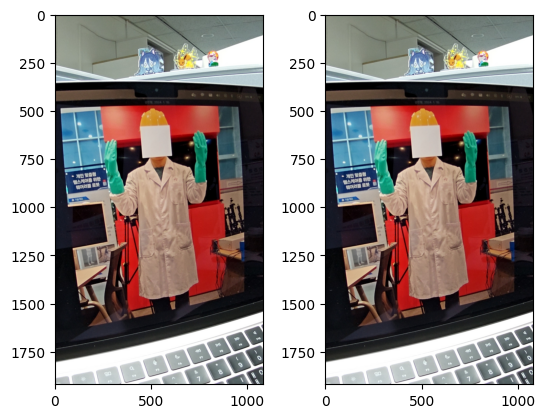

In [49]:
img_data = base64.b64decode(img_b64_v.split(",")[1])
img_data = io.BytesIO(img_data)
img_data = Image.open(img_data)

# numpy 이미지
img_np = np.array(img_data)

# torch 이미지
img_pt = torch.from_numpy(img_np)

plt.subplot(1,2,1); plt.imshow(img_np); plt.subplot(1,2,2); plt.imshow(img_pt)

ic(img_np.shape)
ic(img_pt.shape)

ic| img_np.shape: (640, 384, 3)
ic| img_pt.shape: torch.Size([640, 384, 3])
ic| np.array_equal(img_np, img_pt): True
ic| img_np.shape: (3, 640, 384)
ic| img_pt.shape: torch.Size([3, 640, 384])
ic| np.array_equal(img_np, img_pt): True


True

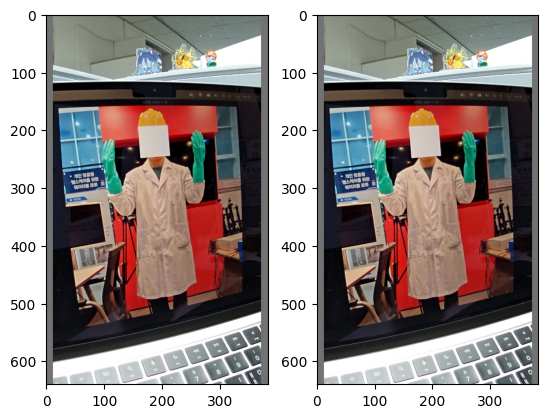

In [50]:
# pre_process()
img_np = letterbox(img_np)[0]
img_pt = letterbox_tensor(img_pt)[0]

plt.subplot(1,2,1); plt.imshow(img_np); plt.subplot(1,2,2); plt.imshow(img_pt)

ic(img_np.shape)
ic(img_pt.shape)
ic(np.array_equal(img_np, img_pt))

img_np = img_np[:, :, ::-1]
img_np = img_np.transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
img_np = np.ascontiguousarray(img_np)

img_pt = img_pt.permute(0, 1, 2).flip(dims=(2,))
img_pt = img_pt.permute(2, 0, 1)
img_pt = img_pt.contiguous()

ic(img_np.shape)
ic(img_pt.shape)
ic(np.array_equal(img_np, img_pt))

ic| img_np.shape: (640, 384, 3)
ic| img_pt.shape: torch.Size([640, 384, 3])
ic| np.array_equal(img_np, img_pt): True


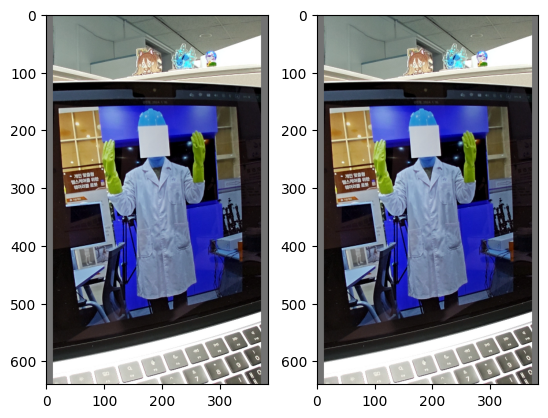

In [51]:
# process()
img_np = img_np.swapaxes(0, 1)
img_np = img_np.swapaxes(1, 2)

img_pt = img_pt.permute(1, 2, 0)

ic(img_np.shape)
ic(img_pt.shape)
ic(np.array_equal(img_np, img_pt))

plt.subplot(1,2,1); plt.imshow(img_np); plt.subplot(1,2,2); plt.imshow(img_pt)

ic| img_np.shape: (640, 640, 3)
ic| img_pt.shape: torch.Size([640, 640, 3])
ic| np.array_equal(img_np, img_pt): True


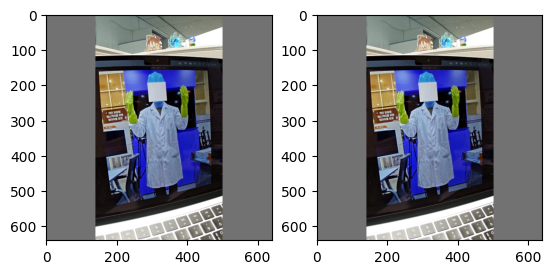

In [52]:
# detect_human() --> detect_tensorrt()
img_np, ratio_np, dwdh_np = letterbox(img_np, auto=False)
img_pt, ratio_pt, dwdh_pt = letterbox_tensor(img_pt, auto=False)

ic(img_np.shape)
ic(img_pt.shape)
ic(np.array_equal(img_np, img_pt))

plt.subplot(1,2,1); plt.imshow(img_np); plt.subplot(1,2,2); plt.imshow(img_pt)

# img_np = img_np.astype(np.float32)
# img_np /= 255
# img_np = img_np.transpose((2, 0, 1))
# img_np = np.expand_dims(img_np, 0)
# img_np = np.ascontiguousarray(img_np)
# img_np = torch.from_numpy(img_np)

# img_pt = img_pt.permute(2, 0, 1)
# img_pt = img_pt.unsqueeze(0)
# img_pt = img_pt.contiguous()
# img_pt = img_pt.to(torch.float32)
# img_pt /= 255

# ic(img_np.shape)
# ic(img_pt.shape)
# ic((ratio_np, dwdh_np))
# ic((ratio_pt, dwdh_pt))
# ic(torch.allclose(img_np, img_pt))

/Users/jhkang/opt/anaconda3/envs/yolov7/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
ic| img_pt_resize.shape: torch.Size([240, 240, 3])
ic| img_pt_crop.shape: torch.Size([224, 224, 3])
ic| img_pt.shape: torch.Size([640, 640, 3])


torch.Size([640, 640, 3])

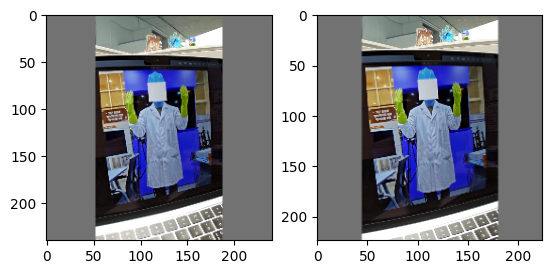

In [53]:
# 2nd_stage_classification()
resize_transform = transforms.Resize(size=(240, 240))
crop_transform = transforms.CenterCrop(size=(224, 224))
img_pt_resize = resize_transform(img_pt.permute(2, 0, 1)).permute(1, 2, 0)
ic(img_pt_resize.shape)
img_pt_crop = crop_transform(img_pt_resize.permute(2, 0, 1)).permute(1, 2, 0)
ic(img_pt_crop.shape)
plt.subplot(1,2,1); plt.imshow(img_pt_resize); plt.subplot(1,2,2); plt.imshow(img_pt_crop)
ic(img_pt.shape)

In [56]:
img_pt.dtype

torch.uint8